In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from utils.data_handling import *
from utils.sensor_optimisation import *
from parameters import *
import GPy
import scipy.stats
from sklearn.covariance import *


import matplotlib.pyplot as plt
np.random.seed(101)


### Importing the Tracer Data to Select the Optimisation set S

In [4]:
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [5]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [6]:
S_human = human_level_subset(buildingshape, loc_df, 2,1 )
print("The remaining number of points is : ", str(len(S_human)))

The remaining number of points is :  37847


In [7]:
S_working = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )
print("The remaining number of points is : ", str(len(S_working)))

The remaining number of points is :  57725


In [8]:
S = np.intersect1d(S_human,S_working)
print("The remaining number of points is : ", str(len(S)))

The remaining number of points is :  23643


In [9]:
#A_list = set_to_onehot(S,data_df.shape[0])
#save_vtu(ref_vtu[0],'FinalSelection',A_list)

### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [11]:
parameters['i_end'] = 988
parameters['field_name'] = "Pressure"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Pressure',
 'cov_method': 'sample'}

In [12]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Pressure.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Pressure.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Pressure.pkl


In [13]:
X = loc_df.values[:,:] #[I,:dim]
Z = data_df.values[:,:]#[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

In [14]:
Z[S,:] = (Z[S,:]  - Z[S,:].mean(axis=1,keepdims=True))

### Sample Covariance

In [19]:
cov_emp = empirical_covariance(Z[S,:].T)

In [24]:
np.linalg.slogdet(cov_emp)

(-1.0, -601246.8116389714)

In [22]:
eig_emp = np.linalg.eigvalsh(cov_emp)


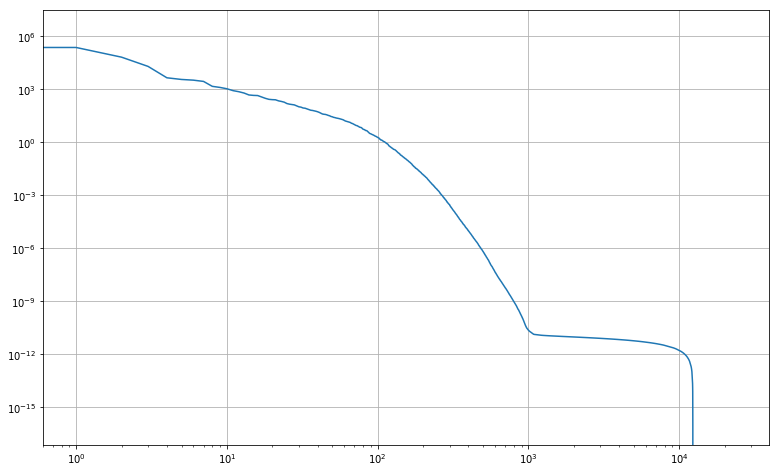

In [23]:
plt.figure(figsize=(13,8))
plt.loglog(eig_emp[::-1])
plt.grid()

### OAS Covariance

In [15]:
cov, shrinkage_coef = oas(Z[S,:].T)
cov.shape

(23643, 23643)

In [16]:
np.linalg.slogdet(cov)

(1.0, -31175.970532036838)

In [17]:
eig_oas = np.linalg.eigvalsh(cov)


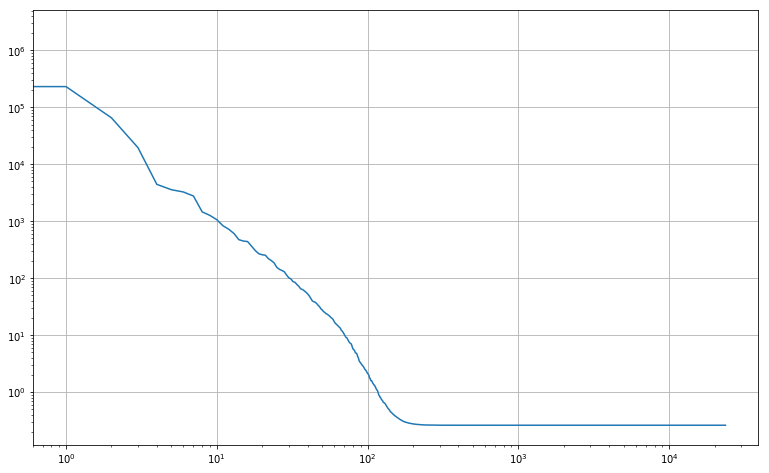

In [18]:
plt.figure(figsize=(13,8))
plt.loglog(eig_oas[::-1])
plt.grid()

### Sensor Optimisation with 3rd Algorithm : 


Define the Sets for the optimisation

In [25]:
sets = define_sets(S)

Number of sensors to place : 

In [26]:
k = 10

Truncation parameteter for the local covariance : 

In [27]:
epsilon = 2.5*10**-7
print(epsilon)

2.5e-07


In [28]:
d = 1500

In [29]:
A_opt = {}

In [ ]:
A_opt['local'] = sensor_loc_optimisation_naive_local(k,cov, "fixed", d, sets)

Init Loop:   0%|          | 0/23643 [00:00<?, ?it/s]

Length of local covariance set : d =  1500 , largest =  [[114.55269706]]  smallest = [[103.52336969]]


Init Loop:   0%|          | 1/23643 [00:00<1:51:49,  3.52it/s]

Length of local covariance set : d =  1500 , largest =  [[125.1128156]]  smallest = [[120.07996695]]


Init Loop:   0%|          | 3/23643 [00:00<1:37:57,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[151.85537752]]  smallest = [[131.55826289]]
Length of local covariance set : d =  1500 , largest =  [[130.18846584]]  smallest = [[119.93426713]]


Init Loop:   0%|          | 5/23643 [00:01<1:32:24,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[138.48172039]]  smallest = [[119.005084]]


Init Loop:   0%|          | 6/23643 [00:01<1:29:10,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[157.87923049]]  smallest = [[109.73017507]]


Init Loop:   0%|          | 7/23643 [00:01<1:25:32,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[188.43402455]]  smallest = [[145.0356986]]
Length of local covariance set : d =  1500 , largest =  [[230.69748827]]  smallest = [[151.62759059]]


Init Loop:   0%|          | 8/23643 [00:01<1:24:12,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[121.49263937]]  smallest = [[116.35049962]]


Init Loop:   0%|          | 10/23643 [00:02<1:23:23,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[172.4066059]]  smallest = [[130.43324424]]
Length of local covariance set : d =  1500 , largest =  [[138.68470715]]  smallest = [[132.52020709]]


Init Loop:   0%|          | 11/23643 [00:02<1:30:35,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[149.88019949]]  smallest = [[139.2551242]]


Init Loop:   0%|          | 12/23643 [00:02<1:35:16,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[143.47930109]]  smallest = [[136.70980623]]


Init Loop:   0%|          | 13/23643 [00:03<1:38:39,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[136.09953864]]  smallest = [[127.86924901]]


Init Loop:   0%|          | 14/23643 [00:03<1:41:23,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[117.60363534]]  smallest = [[104.31107281]]


Init Loop:   0%|          | 15/23643 [00:03<1:47:12,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[109.70478824]]  smallest = [[103.36855467]]


Init Loop:   0%|          | 16/23643 [00:03<1:47:55,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[113.361181]]  smallest = [[108.64762397]]


Init Loop:   0%|          | 17/23643 [00:04<1:47:36,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[158.72683138]]  smallest = [[123.69339414]]


Init Loop:   0%|          | 18/23643 [00:04<1:47:29,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[110.79203297]]  smallest = [[105.83956923]]


Init Loop:   0%|          | 19/23643 [00:04<1:47:29,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[122.84220877]]  smallest = [[112.8046174]]


Init Loop:   0%|          | 20/23643 [00:04<1:47:08,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[114.8399208]]  smallest = [[105.5199851]]


Init Loop:   0%|          | 21/23643 [00:05<1:48:07,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[114.60965381]]  smallest = [[99.7884708]]


Init Loop:   0%|          | 22/23643 [00:05<1:48:36,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[173.36603127]]  smallest = [[147.50957919]]


Init Loop:   0%|          | 23/23643 [00:05<1:48:03,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[119.62366705]]  smallest = [[104.49499499]]


Init Loop:   0%|          | 24/23643 [00:06<1:48:29,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[118.11323303]]  smallest = [[113.14771906]]


Init Loop:   0%|          | 25/23643 [00:06<1:48:51,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[119.69112006]]  smallest = [[113.72551127]]


Init Loop:   0%|          | 27/23643 [00:06<1:37:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.97329687]]  smallest = [[105.06406928]]
Length of local covariance set : d =  1500 , largest =  [[238.25019639]]  smallest = [[154.01343829]]


Init Loop:   0%|          | 29/23643 [00:07<1:27:14,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[120.28287662]]  smallest = [[113.69311231]]
Length of local covariance set : d =  1500 , largest =  [[134.94981688]]  smallest = [[128.15803326]]


Init Loop:   0%|          | 31/23643 [00:07<1:22:10,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[120.90398755]]  smallest = [[107.26657921]]
Length of local covariance set : d =  1500 , largest =  [[162.51003892]]  smallest = [[144.97769175]]


Init Loop:   0%|          | 33/23643 [00:07<1:19:19,  4.96it/s]

Length of local covariance set : d =  1500 , largest =  [[327.22570514]]  smallest = [[205.10324026]]
Length of local covariance set : d =  1500 , largest =  [[210.40353129]]  smallest = [[178.36397754]]


Init Loop:   0%|          | 35/23643 [00:08<1:17:26,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[169.21070975]]  smallest = [[149.52711076]]
Length of local covariance set : d =  1500 , largest =  [[172.40577123]]  smallest = [[138.57930391]]


Init Loop:   0%|          | 37/23643 [00:08<1:16:42,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[168.14816569]]  smallest = [[152.09720366]]
Length of local covariance set : d =  1500 , largest =  [[272.21083789]]  smallest = [[185.43340654]]


Init Loop:   0%|          | 39/23643 [00:09<1:18:24,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[137.64764073]]  smallest = [[132.40159744]]


Init Loop:   0%|          | 40/23643 [00:09<1:18:14,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[132.79896632]]  smallest = [[115.89423492]]
Length of local covariance set : d =  1500 , largest =  [[127.50334716]]  smallest = [[113.84889337]]


Init Loop:   0%|          | 42/23643 [00:09<1:17:28,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[141.31638069]]  smallest = [[132.35691233]]
Length of local covariance set : d =  1500 , largest =  [[169.67733399]]  smallest = [[136.51185957]]


Init Loop:   0%|          | 44/23643 [00:10<1:16:39,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[101.49053837]]  smallest = [[94.74525244]]
Length of local covariance set : d =  1500 , largest =  [[129.0611645]]  smallest = [[100.57116052]]


Init Loop:   0%|          | 46/23643 [00:10<1:16:43,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[179.20184547]]  smallest = [[116.89170695]]
Length of local covariance set : d =  1500 , largest =  [[179.71813494]]  smallest = [[117.03252044]]


Init Loop:   0%|          | 48/23643 [00:10<1:16:52,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[122.18175808]]  smallest = [[101.79040427]]
Length of local covariance set : d =  1500 , largest =  [[106.5589782]]  smallest = [[100.47116503]]


Init Loop:   0%|          | 50/23643 [00:11<1:17:21,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.98778128]]  smallest = [[88.57047829]]


Init Loop:   0%|          | 51/23643 [00:11<1:17:31,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[109.87259614]]  smallest = [[88.40058175]]
Length of local covariance set : d =  1500 , largest =  [[113.50379889]]  smallest = [[101.93902536]]


Init Loop:   0%|          | 53/23643 [00:11<1:17:27,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[97.43746085]]  smallest = [[93.55306485]]
Length of local covariance set : d =  1500 , largest =  [[105.55966807]]  smallest = [[99.03331841]]


Init Loop:   0%|          | 55/23643 [00:12<1:16:59,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[122.09317971]]  smallest = [[106.0140541]]
Length of local covariance set : d =  1500 , largest =  [[118.24412326]]  smallest = [[111.51121822]]


Init Loop:   0%|          | 57/23643 [00:12<1:17:30,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.23331103]]  smallest = [[109.39521609]]
Length of local covariance set : d =  1500 , largest =  [[114.98250151]]  smallest = [[109.32972191]]


Init Loop:   0%|          | 59/23643 [00:13<1:17:35,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.29003222]]  smallest = [[111.75892266]]
Length of local covariance set : d =  1500 , largest =  [[121.57238895]]  smallest = [[113.71422684]]


Init Loop:   0%|          | 61/23643 [00:13<1:18:28,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[150.88710184]]  smallest = [[120.71994526]]
Length of local covariance set : d =  1500 , largest =  [[154.77337262]]  smallest = [[122.06439771]]


Init Loop:   0%|          | 63/23643 [00:13<1:20:18,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[186.00121196]]  smallest = [[138.86572762]]


Init Loop:   0%|          | 64/23643 [00:14<1:22:35,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[161.18569191]]  smallest = [[133.66527495]]
Length of local covariance set : d =  1500 , largest =  [[195.32029972]]  smallest = [[146.75201695]]


Init Loop:   0%|          | 66/23643 [00:14<1:22:18,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[170.80979112]]  smallest = [[130.14065431]]
Length of local covariance set : d =  1500 , largest =  [[2.01883932]]  smallest = [[1.7474222]]


Init Loop:   0%|          | 67/23643 [00:14<1:20:30,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[189.28993566]]  smallest = [[144.43257563]]


Init Loop:   0%|          | 69/23643 [00:15<1:22:55,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[121.04896967]]  smallest = [[116.53812691]]


Init Loop:   0%|          | 70/23643 [00:15<1:23:13,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[117.58766107]]  smallest = [[112.62561055]]


Init Loop:   0%|          | 71/23643 [00:15<1:22:56,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[174.98073278]]  smallest = [[142.03148037]]


Init Loop:   0%|          | 72/23643 [00:15<1:22:09,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[126.13675722]]  smallest = [[101.38641041]]


Init Loop:   0%|          | 73/23643 [00:15<1:20:42,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[125.54630307]]  smallest = [[104.54630943]]
Length of local covariance set : d =  1500 , largest =  [[91.84637992]]  smallest = [[87.72621499]]


Init Loop:   0%|          | 75/23643 [00:16<1:18:29,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[114.18378874]]  smallest = [[92.15492632]]
Length of local covariance set : d =  1500 , largest =  [[117.93584506]]  smallest = [[110.62540099]]


Init Loop:   0%|          | 77/23643 [00:16<1:17:21,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.8782744]]  smallest = [[105.47404377]]
Length of local covariance set : d =  1500 , largest =  [[176.36597583]]  smallest = [[138.64227758]]


Init Loop:   0%|          | 79/23643 [00:17<1:18:30,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[121.04327126]]  smallest = [[104.53047948]]
Length of local covariance set : d =  1500 , largest =  [[109.58192438]]  smallest = [[105.86997462]]


Init Loop:   0%|          | 81/23643 [00:17<1:18:34,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[130.87586834]]  smallest = [[114.17412524]]
Length of local covariance set : d =  1500 , largest =  [[111.14210229]]  smallest = [[104.74481357]]


Init Loop:   0%|          | 83/23643 [00:17<1:20:32,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[168.14853026]]  smallest = [[145.12975065]]


Init Loop:   0%|          | 84/23643 [00:18<1:19:53,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[119.73528737]]  smallest = [[109.25373852]]
Length of local covariance set : d =  1500 , largest =  [[174.34925538]]  smallest = [[142.00289612]]


Init Loop:   0%|          | 85/23643 [00:18<1:18:42,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[327.19566884]]  smallest = [[205.04097034]]


Init Loop:   0%|          | 87/23643 [00:18<1:23:36,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[172.50414812]]  smallest = [[141.03373296]]
Length of local covariance set : d =  1500 , largest =  [[135.36721946]]  smallest = [[122.75104829]]


Init Loop:   0%|          | 88/23643 [00:19<1:29:17,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[145.68811683]]  smallest = [[114.62702056]]


Init Loop:   0%|          | 89/23643 [00:19<1:33:12,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[122.40653876]]  smallest = [[101.79860751]]


Init Loop:   0%|          | 90/23643 [00:19<1:35:55,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[178.27807509]]  smallest = [[139.99054228]]


Init Loop:   0%|          | 91/23643 [00:19<1:38:32,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[165.31665396]]  smallest = [[149.38396015]]


Init Loop:   0%|          | 92/23643 [00:20<1:39:09,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[121.37285106]]  smallest = [[116.20236144]]


Init Loop:   0%|          | 93/23643 [00:20<1:41:31,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[102.11903178]]  smallest = [[95.29000189]]


Init Loop:   0%|          | 94/23643 [00:20<1:43:44,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[99.8208925]]  smallest = [[95.70540103]]


Init Loop:   0%|          | 95/23643 [00:20<1:45:55,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[214.6104264]]  smallest = [[146.30895293]]


Init Loop:   0%|          | 96/23643 [00:21<1:46:06,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[135.13023165]]  smallest = [[113.93507382]]


Init Loop:   0%|          | 97/23643 [00:21<1:49:03,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[138.44445777]]  smallest = [[122.52350216]]


Init Loop:   0%|          | 98/23643 [00:21<1:48:35,  3.61it/s]

Length of local covariance set : d =  1500 , largest =  [[174.08985957]]  smallest = [[138.23730732]]


Init Loop:   0%|          | 99/23643 [00:22<1:47:19,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[138.10983821]]  smallest = [[114.92801229]]


Init Loop:   0%|          | 100/23643 [00:22<1:45:11,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[125.39777554]]  smallest = [[98.81680408]]


Init Loop:   0%|          | 101/23643 [00:22<1:44:15,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[135.41452278]]  smallest = [[113.97447425]]


Init Loop:   0%|          | 102/23643 [00:22<1:44:16,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[152.85266632]]  smallest = [[132.71386771]]


Init Loop:   0%|          | 103/23643 [00:23<1:43:30,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[117.69735963]]  smallest = [[110.39683622]]


Init Loop:   0%|          | 104/23643 [00:23<1:42:17,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[116.05629449]]  smallest = [[111.18596252]]


Init Loop:   0%|          | 105/23643 [00:23<1:42:30,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[141.27243679]]  smallest = [[134.85495077]]


Init Loop:   0%|          | 106/23643 [00:24<1:54:50,  3.42it/s]

Length of local covariance set : d =  1500 , largest =  [[170.00069621]]  smallest = [[145.92312954]]


Init Loop:   0%|          | 107/23643 [00:24<1:57:29,  3.34it/s]

Length of local covariance set : d =  1500 , largest =  [[123.6080022]]  smallest = [[104.30805563]]


Init Loop:   0%|          | 108/23643 [00:24<1:51:13,  3.53it/s]

Length of local covariance set : d =  1500 , largest =  [[120.96263421]]  smallest = [[107.21754853]]


Init Loop:   0%|          | 109/23643 [00:24<1:52:38,  3.48it/s]

Length of local covariance set : d =  1500 , largest =  [[120.24564674]]  smallest = [[110.84960124]]


Init Loop:   0%|          | 110/23643 [00:25<1:51:24,  3.52it/s]

Length of local covariance set : d =  1500 , largest =  [[100.46572394]]  smallest = [[95.59772882]]


Init Loop:   0%|          | 111/23643 [00:25<1:49:07,  3.59it/s]

Length of local covariance set : d =  1500 , largest =  [[317.0732165]]  smallest = [[201.3335327]]


Init Loop:   0%|          | 112/23643 [00:25<1:46:55,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[308.54596142]]  smallest = [[198.4569051]]


Init Loop:   0%|          | 113/23643 [00:25<1:43:49,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[146.94153909]]  smallest = [[134.74647711]]


Init Loop:   0%|          | 114/23643 [00:26<1:41:29,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[112.92927439]]  smallest = [[103.98751088]]


Init Loop:   0%|          | 115/23643 [00:26<1:40:57,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[105.28742847]]  smallest = [[97.69598614]]


Init Loop:   0%|          | 116/23643 [00:26<1:42:51,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[178.02969104]]  smallest = [[159.15416476]]


Init Loop:   0%|          | 117/23643 [00:26<1:41:07,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[143.83792025]]  smallest = [[130.75565529]]


Init Loop:   0%|          | 118/23643 [00:27<1:40:17,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[125.42982127]]  smallest = [[117.09313241]]


Init Loop:   1%|          | 119/23643 [00:27<1:47:21,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[132.48690309]]  smallest = [[122.15690993]]


Init Loop:   1%|          | 120/23643 [00:27<1:43:54,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[112.21541229]]  smallest = [[106.68038807]]


Init Loop:   1%|          | 121/23643 [00:27<1:42:14,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[100.58054722]]  smallest = [[94.90349561]]


Init Loop:   1%|          | 122/23643 [00:28<1:41:06,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[103.64452663]]  smallest = [[98.54411109]]


Init Loop:   1%|          | 123/23643 [00:28<1:39:56,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[116.54168304]]  smallest = [[113.16172486]]


Init Loop:   1%|          | 124/23643 [00:28<1:38:35,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[166.30890568]]  smallest = [[140.73985126]]


Init Loop:   1%|          | 125/23643 [00:28<1:39:15,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[190.93747851]]  smallest = [[144.98924424]]


Init Loop:   1%|          | 126/23643 [00:29<1:40:29,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[130.02366359]]  smallest = [[124.34276074]]


Init Loop:   1%|          | 127/23643 [00:29<1:39:32,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[138.63243284]]  smallest = [[127.65462405]]


Init Loop:   1%|          | 128/23643 [00:29<1:39:06,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[154.72003168]]  smallest = [[122.2511564]]


Init Loop:   1%|          | 130/23643 [00:30<1:38:10,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[45.3370774]]  smallest = [[42.78738483]]
Length of local covariance set : d =  1500 , largest =  [[164.77731084]]  smallest = [[126.71372998]]


Init Loop:   1%|          | 131/23643 [00:30<1:37:39,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[128.92288708]]  smallest = [[121.63703603]]


Init Loop:   1%|          | 132/23643 [00:30<1:38:43,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[280.2565631]]  smallest = [[188.28766859]]


Init Loop:   1%|          | 133/23643 [00:31<1:37:57,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[169.27353002]]  smallest = [[137.13907492]]


Init Loop:   1%|          | 134/23643 [00:31<1:38:09,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[129.24744839]]  smallest = [[111.35171962]]


Init Loop:   1%|          | 135/23643 [00:31<1:37:35,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[93.12480575]]  smallest = [[89.3184411]]


Init Loop:   1%|          | 137/23643 [00:31<1:35:54,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[138.29316343]]  smallest = [[120.58487751]]


Init Loop:   1%|          | 138/23643 [00:32<1:35:14,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[141.00684101]]  smallest = [[134.9954607]]
Length of local covariance set : d =  1500 , largest =  [[174.26106785]]  smallest = [[142.54505645]]


Init Loop:   1%|          | 139/23643 [00:32<1:36:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.98212416]]  smallest = [[104.2147077]]


Init Loop:   1%|          | 140/23643 [00:32<1:37:59,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[161.72095417]]  smallest = [[143.77918648]]


Init Loop:   1%|          | 141/23643 [00:32<1:38:22,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[133.69271867]]  smallest = [[119.86347254]]


Init Loop:   1%|          | 143/23643 [00:33<1:36:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[184.15659445]]  smallest = [[161.79621347]]


Init Loop:   1%|          | 144/23643 [00:33<1:36:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.81016679]]  smallest = [[105.30655136]]
Length of local covariance set : d =  1500 , largest =  [[124.64370105]]  smallest = [[113.23537831]]


Init Loop:   1%|          | 145/23643 [00:33<1:37:02,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[95.68883501]]  smallest = [[88.1267029]]


Init Loop:   1%|          | 147/23643 [00:34<1:35:14,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[2.22452598]]  smallest = [[1.91073566]]
Length of local covariance set : d =  1500 , largest =  [[177.79872922]]  smallest = [[134.00730996]]


Init Loop:   1%|          | 148/23643 [00:34<1:35:38,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[109.37083976]]  smallest = [[103.39169164]]


Init Loop:   1%|          | 149/23643 [00:34<1:36:44,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[159.44639908]]  smallest = [[110.78799962]]


Init Loop:   1%|          | 151/23643 [00:35<1:36:04,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[106.40903617]]  smallest = [[95.83802752]]
Length of local covariance set : d =  1500 , largest =  [[121.74853744]]  smallest = [[112.49895723]]


Init Loop:   1%|          | 153/23643 [00:35<1:35:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[125.15431799]]  smallest = [[119.19381628]]
Length of local covariance set : d =  1500 , largest =  [[122.7003378]]  smallest = [[105.96279804]]


Init Loop:   1%|          | 154/23643 [00:36<1:37:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[221.89325476]]  smallest = [[148.85562525]]


Init Loop:   1%|          | 155/23643 [00:36<1:37:21,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[152.95273661]]  smallest = [[113.23955139]]


Init Loop:   1%|          | 156/23643 [00:36<1:37:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[170.77063305]]  smallest = [[148.80475067]]


Init Loop:   1%|          | 157/23643 [00:36<1:37:27,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[162.33541419]]  smallest = [[144.00424376]]


Init Loop:   1%|          | 158/23643 [00:37<1:37:45,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.21502597]]  smallest = [[108.24519152]]


Init Loop:   1%|          | 159/23643 [00:37<1:38:13,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[128.90969142]]  smallest = [[113.53565731]]


Init Loop:   1%|          | 160/23643 [00:37<1:38:13,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[156.20519777]]  smallest = [[111.68659541]]


Init Loop:   1%|          | 161/23643 [00:37<1:37:55,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[148.4399269]]  smallest = [[112.2609621]]


Init Loop:   1%|          | 162/23643 [00:38<1:37:47,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[144.6919275]]  smallest = [[117.97045543]]


Init Loop:   1%|          | 163/23643 [00:38<1:38:52,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[298.01328924]]  smallest = [[194.68609027]]


Init Loop:   1%|          | 164/23643 [00:38<1:38:21,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[128.41545899]]  smallest = [[110.39510525]]


Init Loop:   1%|          | 166/23643 [00:39<1:36:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.32229574]]  smallest = [[129.42946079]]
Length of local covariance set : d =  1500 , largest =  [[109.14441954]]  smallest = [[90.76840219]]


Init Loop:   1%|          | 167/23643 [00:39<1:37:41,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[123.69476883]]  smallest = [[119.00161929]]


Init Loop:   1%|          | 168/23643 [00:39<1:37:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[154.45138776]]  smallest = [[141.44266038]]


Init Loop:   1%|          | 169/23643 [00:39<1:36:38,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.55669628]]  smallest = [[98.37057696]]


Init Loop:   1%|          | 170/23643 [00:40<1:37:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[141.67308461]]  smallest = [[116.42702505]]


Init Loop:   1%|          | 171/23643 [00:40<1:39:17,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[132.83184211]]  smallest = [[119.63751928]]


Init Loop:   1%|          | 172/23643 [00:40<1:38:58,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[127.95016705]]  smallest = [[119.78003836]]


Init Loop:   1%|          | 173/23643 [00:40<1:40:54,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[101.52652988]]  smallest = [[97.22531308]]


Init Loop:   1%|          | 174/23643 [00:41<1:39:21,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[122.75285018]]  smallest = [[114.4691807]]


Init Loop:   1%|          | 175/23643 [00:41<1:38:43,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[288.75355708]]  smallest = [[191.29180897]]


Init Loop:   1%|          | 176/23643 [00:41<1:37:58,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[110.08152726]]  smallest = [[103.84573574]]


Init Loop:   1%|          | 178/23643 [00:42<1:36:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[216.33057316]]  smallest = [[177.20736792]]
Length of local covariance set : d =  1500 , largest =  [[112.84568834]]  smallest = [[109.05252884]]


Init Loop:   1%|          | 180/23643 [00:42<1:35:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[139.6744008]]  smallest = [[131.1331612]]
Length of local covariance set : d =  1500 , largest =  [[171.90534883]]  smallest = [[141.77675793]]


Init Loop:   1%|          | 181/23643 [00:42<1:35:52,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[190.5721887]]  smallest = [[138.26449413]]


Init Loop:   1%|          | 182/23643 [00:43<1:35:45,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[134.89474363]]  smallest = [[120.74395745]]


Init Loop:   1%|          | 183/23643 [00:43<1:37:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[187.21548778]]  smallest = [[139.4524029]]


Init Loop:   1%|          | 184/23643 [00:43<1:37:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[136.77871352]]  smallest = [[124.52059861]]


Init Loop:   1%|          | 185/23643 [00:43<1:37:51,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[124.32650696]]  smallest = [[114.51021496]]


Init Loop:   1%|          | 187/23643 [00:44<1:36:18,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[130.33580916]]  smallest = [[125.37139644]]
Length of local covariance set : d =  1500 , largest =  [[98.45098401]]  smallest = [[92.96086413]]


Init Loop:   1%|          | 188/23643 [00:44<1:36:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.12037447]]  smallest = [[101.48000884]]


Init Loop:   1%|          | 189/23643 [00:44<1:37:57,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[117.10013162]]  smallest = [[109.97282574]]


Init Loop:   1%|          | 191/23643 [00:45<1:36:45,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6743816]]  smallest = [[108.13402687]]
Length of local covariance set : d =  1500 , largest =  [[112.94228934]]  smallest = [[103.58341964]]


Init Loop:   1%|          | 192/23643 [00:45<1:38:40,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[228.27383454]]  smallest = [[150.70138218]]


Init Loop:   1%|          | 194/23643 [00:46<1:36:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[167.72729569]]  smallest = [[160.79816078]]
Length of local covariance set : d =  1500 , largest =  [[192.26164968]]  smallest = [[164.39716429]]


Init Loop:   1%|          | 196/23643 [00:46<1:36:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[154.00996521]]  smallest = [[134.89545912]]
Length of local covariance set : d =  1500 , largest =  [[133.96724283]]  smallest = [[121.03028414]]


Init Loop:   1%|          | 197/23643 [00:46<1:36:57,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[127.80027265]]  smallest = [[121.84696878]]


Init Loop:   1%|          | 198/23643 [00:47<1:36:48,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.81311046]]  smallest = [[104.19168596]]


Init Loop:   1%|          | 200/23643 [00:47<1:36:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.52761252]]  smallest = [[118.04746877]]
Length of local covariance set : d =  1500 , largest =  [[117.45491249]]  smallest = [[112.20030313]]


Init Loop:   1%|          | 201/23643 [00:47<1:36:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.87521663]]  smallest = [[101.99702034]]


Init Loop:   1%|          | 202/23643 [00:48<1:36:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[137.17516812]]  smallest = [[115.67512238]]


Init Loop:   1%|          | 203/23643 [00:48<1:37:44,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[93.62245581]]  smallest = [[88.6055271]]


Init Loop:   1%|          | 204/23643 [00:48<1:37:29,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[124.65825844]]  smallest = [[103.9767006]]


Init Loop:   1%|          | 205/23643 [00:48<1:37:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[106.81920404]]  smallest = [[100.23671217]]


Init Loop:   1%|          | 206/23643 [00:49<1:37:12,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[154.32255941]]  smallest = [[132.84781822]]


Init Loop:   1%|          | 207/23643 [00:49<1:37:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.41878433]]  smallest = [[109.01431647]]


Init Loop:   1%|          | 208/23643 [00:49<1:37:56,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[1.59360241]]  smallest = [[1.3250962]]


Init Loop:   1%|          | 209/23643 [00:49<1:37:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[112.24474454]]  smallest = [[107.50027157]]


Init Loop:   1%|          | 210/23643 [00:50<1:37:29,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[116.25884901]]  smallest = [[110.42517171]]


Init Loop:   1%|          | 212/23643 [00:50<1:36:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[165.75106693]]  smallest = [[135.98114643]]
Length of local covariance set : d =  1500 , largest =  [[111.91710134]]  smallest = [[105.29042284]]


Init Loop:   1%|          | 213/23643 [00:50<1:36:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[119.09494951]]  smallest = [[112.50481978]]


Init Loop:   1%|          | 214/23643 [00:51<1:36:51,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[132.31720655]]  smallest = [[108.23049961]]


Init Loop:   1%|          | 215/23643 [00:51<1:37:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[123.44324146]]  smallest = [[107.60390081]]


Init Loop:   1%|          | 216/23643 [00:51<1:37:41,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[99.43513446]]  smallest = [[93.54077427]]


Init Loop:   1%|          | 217/23643 [00:51<1:37:28,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[97.3451376]]  smallest = [[92.02481094]]


Init Loop:   1%|          | 218/23643 [00:52<1:37:07,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[1.82267811]]  smallest = [[1.70574128]]


Init Loop:   1%|          | 219/23643 [00:52<1:36:24,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[48.55849495]]  smallest = [[45.46995581]]


Init Loop:   1%|          | 221/23643 [00:52<1:35:29,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[180.6091446]]  smallest = [[164.54467174]]
Length of local covariance set : d =  1500 , largest =  [[108.67685934]]  smallest = [[102.4252985]]


Init Loop:   1%|          | 222/23643 [00:53<1:35:44,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[101.08630363]]  smallest = [[94.21765843]]


Init Loop:   1%|          | 223/23643 [00:53<1:37:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[105.19962493]]  smallest = [[95.29706346]]


Init Loop:   1%|          | 224/23643 [00:53<1:36:43,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[150.22098735]]  smallest = [[120.37611128]]


Init Loop:   1%|          | 225/23643 [00:53<1:37:33,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[121.0103918]]  smallest = [[111.03575946]]


Init Loop:   1%|          | 226/23643 [00:54<1:37:34,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[124.48200673]]  smallest = [[116.02630833]]


Init Loop:   1%|          | 227/23643 [00:54<1:38:18,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[119.73829853]]  smallest = [[112.06786936]]


Init Loop:   1%|          | 228/23643 [00:54<1:38:12,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[107.86903411]]  smallest = [[102.72175571]]


Init Loop:   1%|          | 229/23643 [00:54<1:37:51,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[147.71587867]]  smallest = [[130.02509795]]


Init Loop:   1%|          | 230/23643 [00:55<1:37:35,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[325.12130539]]  smallest = [[204.05368096]]


Init Loop:   1%|          | 231/23643 [00:55<1:37:31,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[114.87947508]]  smallest = [[94.84613097]]


Init Loop:   1%|          | 232/23643 [00:55<1:37:34,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[139.57427045]]  smallest = [[132.36707826]]


Init Loop:   1%|          | 233/23643 [00:55<1:37:59,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[126.92978209]]  smallest = [[121.43209538]]


Init Loop:   1%|          | 234/23643 [00:56<1:38:15,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.52026867]]  smallest = [[112.26434716]]


Init Loop:   1%|          | 235/23643 [00:56<1:37:21,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.4604358]]  smallest = [[113.87017435]]


Init Loop:   1%|          | 236/23643 [00:56<1:36:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.58113834]]  smallest = [[103.67274675]]


Init Loop:   1%|          | 237/23643 [00:56<1:36:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[184.94435505]]  smallest = [[136.92296614]]


Init Loop:   1%|          | 238/23643 [00:57<1:35:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[185.66457236]]  smallest = [[144.51458064]]


Init Loop:   1%|          | 239/23643 [00:57<1:36:47,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[108.48950655]]  smallest = [[102.97493123]]


Init Loop:   1%|          | 240/23643 [00:57<1:36:41,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.73333083]]  smallest = [[102.24777579]]


Init Loop:   1%|          | 241/23643 [00:57<1:41:36,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[127.83282534]]  smallest = [[110.36527652]]


Init Loop:   1%|          | 242/23643 [00:58<1:40:22,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[137.947295]]  smallest = [[114.08632838]]


Init Loop:   1%|          | 243/23643 [00:58<1:38:43,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[180.46193193]]  smallest = [[142.6977105]]


Init Loop:   1%|          | 244/23643 [00:58<1:37:43,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[222.32125018]]  smallest = [[149.34235227]]


Init Loop:   1%|          | 245/23643 [00:58<1:37:27,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[129.10407629]]  smallest = [[111.61001304]]


Init Loop:   1%|          | 246/23643 [00:59<1:38:26,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.24694021]]  smallest = [[113.44129053]]


Init Loop:   1%|          | 247/23643 [00:59<1:37:46,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[131.43565478]]  smallest = [[103.27307095]]


Init Loop:   1%|          | 248/23643 [00:59<1:39:11,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[116.28040268]]  smallest = [[105.54730373]]


Init Loop:   1%|          | 249/23643 [00:59<1:38:30,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[125.26459003]]  smallest = [[120.61534449]]


Init Loop:   1%|          | 250/23643 [01:00<1:38:39,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[105.74726418]]  smallest = [[94.38215558]]


Init Loop:   1%|          | 251/23643 [01:00<1:39:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[102.8498921]]  smallest = [[98.57536161]]


Init Loop:   1%|          | 252/23643 [01:00<1:38:27,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[99.38022766]]  smallest = [[94.69431542]]


Init Loop:   1%|          | 253/23643 [01:00<1:37:49,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[101.15885469]]  smallest = [[96.26979678]]


Init Loop:   1%|          | 254/23643 [01:01<1:39:06,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[2.15217017]]  smallest = [[1.71400377]]


Init Loop:   1%|          | 255/23643 [01:01<1:39:45,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[175.33961074]]  smallest = [[139.11402701]]


Init Loop:   1%|          | 256/23643 [01:01<1:38:55,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[123.26050722]]  smallest = [[111.27098455]]


Init Loop:   1%|          | 257/23643 [01:01<1:38:02,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[153.14324945]]  smallest = [[121.48202045]]


Init Loop:   1%|          | 259/23643 [01:02<1:36:36,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[107.50134776]]  smallest = [[101.83876546]]
Length of local covariance set : d =  1500 , largest =  [[118.23859217]]  smallest = [[100.5790488]]


Init Loop:   1%|          | 260/23643 [01:02<1:36:29,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.97791368]]  smallest = [[103.71126114]]


Init Loop:   1%|          | 261/23643 [01:02<1:36:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[148.84463581]]  smallest = [[131.227386]]


Init Loop:   1%|          | 262/23643 [01:03<1:36:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[138.11083197]]  smallest = [[131.79924784]]


Init Loop:   1%|          | 263/23643 [01:03<1:36:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.63281744]]  smallest = [[101.12459664]]


Init Loop:   1%|          | 265/23643 [01:03<1:35:16,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.97855296]]  smallest = [[105.91243896]]


Init Loop:   1%|          | 266/23643 [01:04<1:34:16,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[113.07261007]]  smallest = [[106.82548849]]
Length of local covariance set : d =  1500 , largest =  [[127.7304213]]  smallest = [[112.73900811]]


Init Loop:   1%|          | 267/23643 [01:04<1:34:48,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[111.78614072]]  smallest = [[105.35181994]]


Init Loop:   1%|          | 268/23643 [01:04<1:35:08,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[183.44027538]]  smallest = [[137.10103071]]


Init Loop:   1%|          | 269/23643 [01:04<1:37:09,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[126.96178365]]  smallest = [[104.88140376]]


Init Loop:   1%|          | 270/23643 [01:05<1:36:47,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[96.15243477]]  smallest = [[90.86125456]]


Init Loop:   1%|          | 271/23643 [01:05<1:36:32,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[98.59424996]]  smallest = [[91.61858386]]


Init Loop:   1%|          | 273/23643 [01:05<1:35:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.54895226]]  smallest = [[107.79692949]]


Init Loop:   1%|          | 274/23643 [01:06<1:35:15,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[110.71033673]]  smallest = [[100.57398425]]
Length of local covariance set : d =  1500 , largest =  [[99.43674749]]  smallest = [[94.57411715]]


Init Loop:   1%|          | 275/23643 [01:06<1:35:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[125.36945949]]  smallest = [[108.06007037]]


Init Loop:   1%|          | 277/23643 [01:06<1:35:26,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[126.6915109]]  smallest = [[122.02539475]]
Length of local covariance set : d =  1500 , largest =  [[110.39063252]]  smallest = [[106.31398198]]


Init Loop:   1%|          | 278/23643 [01:07<1:35:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[138.66806955]]  smallest = [[114.97974378]]


Init Loop:   1%|          | 279/23643 [01:07<1:35:40,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3325684]]  smallest = [[98.25383983]]


Init Loop:   1%|          | 280/23643 [01:07<1:35:33,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.43369177]]  smallest = [[100.97656743]]


Init Loop:   1%|          | 281/23643 [01:07<1:35:30,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.78457304]]  smallest = [[104.32388946]]


Init Loop:   1%|          | 283/23643 [01:08<1:35:14,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[45.48137637]]  smallest = [[41.32235804]]
Length of local covariance set : d =  1500 , largest =  [[96.66580907]]  smallest = [[90.0962205]]


Init Loop:   1%|          | 285/23643 [01:08<1:34:45,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[109.66563376]]  smallest = [[106.29814981]]
Length of local covariance set : d =  1500 , largest =  [[114.31219563]]  smallest = [[108.64882056]]


Init Loop:   1%|          | 286/23643 [01:09<1:35:00,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[100.07247215]]  smallest = [[94.35633241]]


Init Loop:   1%|          | 288/23643 [01:09<1:34:55,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[124.27349201]]  smallest = [[111.92706691]]
Length of local covariance set : d =  1500 , largest =  [[141.66061922]]  smallest = [[111.76453404]]


Init Loop:   1%|          | 290/23643 [01:10<1:36:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[170.44098047]]  smallest = [[129.33553293]]
Length of local covariance set : d =  1500 , largest =  [[132.03090533]]  smallest = [[111.05629769]]


Init Loop:   1%|          | 291/23643 [01:10<1:36:12,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.14239271]]  smallest = [[102.12037482]]


Init Loop:   1%|          | 292/23643 [01:10<1:35:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[106.41682418]]  smallest = [[98.42161408]]


Init Loop:   1%|          | 293/23643 [01:10<1:37:13,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[104.03219943]]  smallest = [[97.2714121]]


Init Loop:   1%|          | 294/23643 [01:11<1:37:10,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[2.04630122]]  smallest = [[1.58610241]]


Init Loop:   1%|          | 295/23643 [01:11<1:36:42,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[2.09476047]]  smallest = [[1.67643596]]


Init Loop:   1%|▏         | 296/23643 [01:11<1:36:13,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[34.70496101]]  smallest = [[32.32099106]]


Init Loop:   1%|▏         | 297/23643 [01:11<1:35:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[220.46749292]]  smallest = [[148.96758855]]


Init Loop:   1%|▏         | 299/23643 [01:12<1:35:05,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[165.72981223]]  smallest = [[154.47937332]]
Length of local covariance set : d =  1500 , largest =  [[146.70729202]]  smallest = [[134.72503889]]


Init Loop:   1%|▏         | 300/23643 [01:12<1:35:26,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[143.20857652]]  smallest = [[134.23221806]]


Init Loop:   1%|▏         | 301/23643 [01:12<1:35:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[133.17297674]]  smallest = [[124.60150475]]


Init Loop:   1%|▏         | 302/23643 [01:12<1:35:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[127.03082009]]  smallest = [[122.00563603]]


Init Loop:   1%|▏         | 303/23643 [01:13<1:35:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.08507444]]  smallest = [[107.45321783]]


Init Loop:   1%|▏         | 304/23643 [01:13<1:36:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.66577219]]  smallest = [[105.38497269]]


Init Loop:   1%|▏         | 305/23643 [01:13<1:36:36,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[150.69135449]]  smallest = [[121.54340865]]


Init Loop:   1%|▏         | 306/23643 [01:13<1:36:23,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[107.41641112]]  smallest = [[98.17162671]]


Init Loop:   1%|▏         | 307/23643 [01:14<1:35:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[130.72557591]]  smallest = [[103.61142909]]


Init Loop:   1%|▏         | 308/23643 [01:14<1:35:57,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[107.33288416]]  smallest = [[99.24386996]]


Init Loop:   1%|▏         | 309/23643 [01:14<1:35:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.94012443]]  smallest = [[102.65783233]]


Init Loop:   1%|▏         | 310/23643 [01:14<1:35:32,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.24337183]]  smallest = [[103.65785459]]


Init Loop:   1%|▏         | 311/23643 [01:15<1:35:49,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[126.6411679]]  smallest = [[118.18823927]]


Init Loop:   1%|▏         | 312/23643 [01:15<1:35:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[97.45286428]]  smallest = [[93.11507777]]


Init Loop:   1%|▏         | 313/23643 [01:15<1:36:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.59455367]]  smallest = [[104.86135065]]


Init Loop:   1%|▏         | 315/23643 [01:16<1:35:32,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[149.71212234]]  smallest = [[138.88266128]]
Length of local covariance set : d =  1500 , largest =  [[184.15646582]]  smallest = [[142.37823008]]


Init Loop:   1%|▏         | 316/23643 [01:16<1:35:53,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.02921087]]  smallest = [[102.40583557]]


Init Loop:   1%|▏         | 318/23643 [01:16<1:35:10,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[18.35163884]]  smallest = [[17.03384542]]


Init Loop:   1%|▏         | 319/23643 [01:17<1:34:59,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[163.59526236]]  smallest = [[140.04086113]]


Init Loop:   1%|▏         | 320/23643 [01:17<1:34:39,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[129.73444368]]  smallest = [[125.72260218]]


Init Loop:   1%|▏         | 321/23643 [01:17<1:34:14,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[140.32271622]]  smallest = [[130.4137057]]


Init Loop:   1%|▏         | 322/23643 [01:17<1:34:19,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[118.13970845]]  smallest = [[113.77529521]]


Init Loop:   1%|▏         | 323/23643 [01:18<1:33:57,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[108.75949022]]  smallest = [[101.4194707]]


Init Loop:   1%|▏         | 324/23643 [01:18<1:33:06,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[114.7472206]]  smallest = [[102.77908936]]
Length of local covariance set : d =  1500 , largest =  [[116.43972719]]  smallest = [[110.74710669]]


Init Loop:   1%|▏         | 326/23643 [01:18<1:34:13,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[121.60226449]]  smallest = [[116.94366906]]
Length of local covariance set : d =  1500 , largest =  [[118.05045571]]  smallest = [[109.20945133]]


Init Loop:   1%|▏         | 328/23643 [01:19<1:34:19,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[111.17986755]]  smallest = [[102.41187477]]
Length of local covariance set : d =  1500 , largest =  [[119.26382539]]  smallest = [[108.24884772]]


Init Loop:   1%|▏         | 329/23643 [01:19<1:34:49,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[212.73993443]]  smallest = [[145.73867354]]


Init Loop:   1%|▏         | 330/23643 [01:19<1:35:24,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[174.13229202]]  smallest = [[135.20334588]]


Init Loop:   1%|▏         | 331/23643 [01:20<1:35:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[187.15052657]]  smallest = [[139.13854744]]


Init Loop:   1%|▏         | 332/23643 [01:20<1:35:49,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[194.97068401]]  smallest = [[139.54459133]]


Init Loop:   1%|▏         | 333/23643 [01:20<1:35:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[138.05676022]]  smallest = [[128.34706961]]


Init Loop:   1%|▏         | 334/23643 [01:20<1:35:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[99.43238447]]  smallest = [[96.42200332]]


Init Loop:   1%|▏         | 335/23643 [01:21<1:35:07,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[100.02922899]]  smallest = [[92.17888214]]


Init Loop:   1%|▏         | 337/23643 [01:21<1:34:45,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[147.21880397]]  smallest = [[132.5023353]]
Length of local covariance set : d =  1500 , largest =  [[125.2205899]]  smallest = [[121.07990558]]


Init Loop:   1%|▏         | 338/23643 [01:21<1:34:55,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[119.82529264]]  smallest = [[109.7836634]]


Init Loop:   1%|▏         | 339/23643 [01:22<1:35:20,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[101.5999481]]  smallest = [[93.5650471]]


Init Loop:   1%|▏         | 340/23643 [01:22<1:35:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[95.98207061]]  smallest = [[91.3868054]]


Init Loop:   1%|▏         | 341/23643 [01:22<1:36:30,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[98.93043224]]  smallest = [[93.84565904]]


Init Loop:   1%|▏         | 342/23643 [01:22<1:36:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[182.05202513]]  smallest = [[142.98519797]]


Init Loop:   1%|▏         | 343/23643 [01:23<1:35:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[255.57457446]]  smallest = [[178.98646605]]


Init Loop:   1%|▏         | 344/23643 [01:23<1:35:37,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[98.71400107]]  smallest = [[89.61671677]]


Init Loop:   1%|▏         | 345/23643 [01:23<1:35:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[217.11440942]]  smallest = [[146.99891416]]


Init Loop:   1%|▏         | 346/23643 [01:23<1:35:25,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[230.8400586]]  smallest = [[151.59766379]]


Init Loop:   1%|▏         | 347/23643 [01:24<1:35:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[213.34057518]]  smallest = [[145.83927998]]


Init Loop:   1%|▏         | 348/23643 [01:24<1:35:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[277.6328008]]  smallest = [[187.32905204]]


Init Loop:   1%|▏         | 349/23643 [01:24<1:35:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[166.13531608]]  smallest = [[135.29716691]]


Init Loop:   1%|▏         | 350/23643 [01:24<1:35:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[192.43404268]]  smallest = [[145.5080298]]


Init Loop:   1%|▏         | 351/23643 [01:25<1:37:14,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[151.47874884]]  smallest = [[139.1602402]]


Init Loop:   1%|▏         | 353/23643 [01:25<1:35:09,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[165.25629593]]  smallest = [[151.42796873]]


Init Loop:   1%|▏         | 354/23643 [01:25<1:34:33,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.12907162]]  smallest = [[107.94894091]]
Length of local covariance set : d =  1500 , largest =  [[109.45737928]]  smallest = [[104.01598906]]


Init Loop:   2%|▏         | 356/23643 [01:26<1:34:46,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[147.01173004]]  smallest = [[119.21089473]]
Length of local covariance set : d =  1500 , largest =  [[110.42114356]]  smallest = [[105.55665756]]


Init Loop:   2%|▏         | 357/23643 [01:26<1:35:09,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[65.69991177]]  smallest = [[61.46951231]]


Init Loop:   2%|▏         | 358/23643 [01:26<1:35:03,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.21043812]]  smallest = [[114.35374387]]


Init Loop:   2%|▏         | 359/23643 [01:26<1:35:24,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[125.93759137]]  smallest = [[119.74712674]]


Init Loop:   2%|▏         | 360/23643 [01:27<1:35:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[97.97708571]]  smallest = [[93.6162884]]


Init Loop:   2%|▏         | 361/23643 [01:27<1:36:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.30064634]]  smallest = [[95.62174709]]


Init Loop:   2%|▏         | 362/23643 [01:27<1:36:08,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[99.43543121]]  smallest = [[94.87765476]]


Init Loop:   2%|▏         | 363/23643 [01:27<1:36:06,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[98.28676999]]  smallest = [[90.65100465]]


Init Loop:   2%|▏         | 364/23643 [01:28<1:36:01,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.20691296]]  smallest = [[105.09592293]]


Init Loop:   2%|▏         | 366/23643 [01:28<1:34:07,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[2.27709572]]  smallest = [[1.74116475]]


Init Loop:   2%|▏         | 367/23643 [01:28<1:34:07,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[20.49831435]]  smallest = [[19.35070984]]
Length of local covariance set : d =  1500 , largest =  [[170.66777004]]  smallest = [[137.90452185]]


Init Loop:   2%|▏         | 368/23643 [01:29<1:34:53,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[186.846396]]  smallest = [[143.44945539]]


Init Loop:   2%|▏         | 369/23643 [01:29<1:35:47,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.97563792]]  smallest = [[99.52120021]]


Init Loop:   2%|▏         | 370/23643 [01:29<1:35:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.29120933]]  smallest = [[102.03502728]]


Init Loop:   2%|▏         | 371/23643 [01:29<1:35:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[95.86855878]]  smallest = [[90.23558929]]


Init Loop:   2%|▏         | 372/23643 [01:30<1:35:54,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[95.38205012]]  smallest = [[90.76708276]]


Init Loop:   2%|▏         | 373/23643 [01:30<1:35:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.20304504]]  smallest = [[115.11422503]]


Init Loop:   2%|▏         | 375/23643 [01:30<1:35:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.82700777]]  smallest = [[107.36028814]]
Length of local covariance set : d =  1500 , largest =  [[116.20977054]]  smallest = [[108.74722804]]


Init Loop:   2%|▏         | 376/23643 [01:31<1:36:02,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[142.58878691]]  smallest = [[136.25563758]]


Init Loop:   2%|▏         | 378/23643 [01:31<1:34:48,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[152.72646307]]  smallest = [[136.08332503]]
Length of local covariance set : d =  1500 , largest =  [[194.53882182]]  smallest = [[146.92805504]]


Init Loop:   2%|▏         | 379/23643 [01:31<1:35:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.76275772]]  smallest = [[106.1838375]]


Init Loop:   2%|▏         | 380/23643 [01:32<1:35:24,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.30628944]]  smallest = [[111.62107497]]


Init Loop:   2%|▏         | 381/23643 [01:32<1:35:02,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[138.27885918]]  smallest = [[121.13182945]]


Init Loop:   2%|▏         | 382/23643 [01:32<1:35:00,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[150.71057216]]  smallest = [[134.79499207]]


Init Loop:   2%|▏         | 383/23643 [01:32<1:34:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.26721701]]  smallest = [[106.97356338]]


Init Loop:   2%|▏         | 384/23643 [01:33<1:35:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[179.16114687]]  smallest = [[135.00580118]]


Init Loop:   2%|▏         | 385/23643 [01:33<1:35:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.93234001]]  smallest = [[100.78121414]]


Init Loop:   2%|▏         | 386/23643 [01:33<1:35:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.37691133]]  smallest = [[94.10656469]]


Init Loop:   2%|▏         | 387/23643 [01:33<1:35:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.09233494]]  smallest = [[94.77331335]]


Init Loop:   2%|▏         | 388/23643 [01:34<1:36:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[11.69482074]]  smallest = [[11.1489263]]


Init Loop:   2%|▏         | 390/23643 [01:34<1:35:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[148.51800056]]  smallest = [[136.05860924]]
Length of local covariance set : d =  1500 , largest =  [[150.07186476]]  smallest = [[134.55976391]]


Init Loop:   2%|▏         | 392/23643 [01:35<1:35:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[163.88902629]]  smallest = [[138.11119716]]


Init Loop:   2%|▏         | 393/23643 [01:35<1:35:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[173.19861817]]  smallest = [[148.21469704]]
Length of local covariance set : d =  1500 , largest =  [[162.17919976]]  smallest = [[152.70958627]]


Init Loop:   2%|▏         | 394/23643 [01:35<1:35:12,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[108.84169477]]  smallest = [[102.70608599]]


Init Loop:   2%|▏         | 395/23643 [01:35<1:36:07,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.17344933]]  smallest = [[100.61384728]]


Init Loop:   2%|▏         | 396/23643 [01:36<1:35:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[108.50976733]]  smallest = [[100.22189942]]


Init Loop:   2%|▏         | 398/23643 [01:36<1:34:48,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[161.15298452]]  smallest = [[124.7504976]]
Length of local covariance set : d =  1500 , largest =  [[169.59342959]]  smallest = [[129.46695051]]


Init Loop:   2%|▏         | 399/23643 [01:36<1:34:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[119.20580758]]  smallest = [[110.61762157]]


Init Loop:   2%|▏         | 400/23643 [01:37<1:34:47,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[136.39705026]]  smallest = [[127.27480815]]


Init Loop:   2%|▏         | 401/23643 [01:37<1:35:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.2163682]]  smallest = [[99.10140293]]


Init Loop:   2%|▏         | 402/23643 [01:37<1:35:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[96.31708997]]  smallest = [[91.82934303]]


Init Loop:   2%|▏         | 403/23643 [01:37<1:35:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[100.23880588]]  smallest = [[93.2121013]]


Init Loop:   2%|▏         | 404/23643 [01:38<1:35:44,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.25289326]]  smallest = [[98.45329504]]


Init Loop:   2%|▏         | 405/23643 [01:38<1:36:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[106.38598106]]  smallest = [[101.57013808]]


Init Loop:   2%|▏         | 406/23643 [01:38<1:36:09,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.65695109]]  smallest = [[107.09876504]]


Init Loop:   2%|▏         | 407/23643 [01:38<1:35:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[135.41831569]]  smallest = [[114.98376296]]


Init Loop:   2%|▏         | 408/23643 [01:39<1:36:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[108.08415148]]  smallest = [[98.79672103]]


Init Loop:   2%|▏         | 409/23643 [01:39<1:36:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[100.51368122]]  smallest = [[91.74877252]]


Init Loop:   2%|▏         | 410/23643 [01:39<1:36:54,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[94.8406974]]  smallest = [[86.56499234]]


Init Loop:   2%|▏         | 411/23643 [01:39<1:36:37,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[155.77722389]]  smallest = [[133.46877442]]


Init Loop:   2%|▏         | 413/23643 [01:40<1:35:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[172.1189972]]  smallest = [[153.72726541]]
Length of local covariance set : d =  1500 , largest =  [[111.01820272]]  smallest = [[100.83476422]]


Init Loop:   2%|▏         | 414/23643 [01:40<1:35:25,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[184.2742304]]  smallest = [[143.72395794]]


Init Loop:   2%|▏         | 415/23643 [01:40<1:35:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03778054]]  smallest = [[106.42858659]]


Init Loop:   2%|▏         | 416/23643 [01:41<1:36:02,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[125.29012765]]  smallest = [[116.01394895]]


Init Loop:   2%|▏         | 417/23643 [01:41<1:35:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.66938779]]  smallest = [[105.36585314]]


Init Loop:   2%|▏         | 419/23643 [01:41<1:34:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[104.39610704]]  smallest = [[100.47119322]]
Length of local covariance set : d =  1500 , largest =  [[116.32587632]]  smallest = [[108.01139606]]


Init Loop:   2%|▏         | 421/23643 [01:42<1:34:18,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[139.41728932]]  smallest = [[115.69505894]]
Length of local covariance set : d =  1500 , largest =  [[123.96536046]]  smallest = [[105.29667311]]


Init Loop:   2%|▏         | 422/23643 [01:42<1:34:52,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.0273135]]  smallest = [[109.0501646]]


Init Loop:   2%|▏         | 423/23643 [01:42<1:36:02,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[99.41016874]]  smallest = [[94.24800692]]


Init Loop:   2%|▏         | 424/23643 [01:43<1:36:36,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[1.83753628]]  smallest = [[1.63604612]]


Init Loop:   2%|▏         | 425/23643 [01:43<1:36:12,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[178.22986711]]  smallest = [[161.78091229]]


Init Loop:   2%|▏         | 427/23643 [01:43<1:35:12,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[150.7604325]]  smallest = [[140.27235792]]
Length of local covariance set : d =  1500 , largest =  [[137.62554477]]  smallest = [[131.70048368]]


Init Loop:   2%|▏         | 428/23643 [01:44<1:35:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.06092879]]  smallest = [[109.24117805]]


Init Loop:   2%|▏         | 429/23643 [01:44<1:35:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.10476534]]  smallest = [[112.98149214]]


Init Loop:   2%|▏         | 430/23643 [01:44<1:35:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.82934223]]  smallest = [[106.17403053]]


Init Loop:   2%|▏         | 431/23643 [01:44<1:35:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[128.24625175]]  smallest = [[115.46149767]]


Init Loop:   2%|▏         | 432/23643 [01:44<1:35:25,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[104.03536043]]  smallest = [[98.04715584]]


Init Loop:   2%|▏         | 433/23643 [01:45<1:35:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[128.83917436]]  smallest = [[103.49740263]]


Init Loop:   2%|▏         | 434/23643 [01:45<1:35:39,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.07316826]]  smallest = [[106.08890483]]


Init Loop:   2%|▏         | 435/23643 [01:45<1:36:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[119.6303942]]  smallest = [[112.66557685]]


Init Loop:   2%|▏         | 436/23643 [01:45<1:36:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[121.0155242]]  smallest = [[112.0855139]]


Init Loop:   2%|▏         | 437/23643 [01:46<1:36:31,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[117.78068227]]  smallest = [[110.01128121]]


Init Loop:   2%|▏         | 438/23643 [01:46<1:36:07,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.46307991]]  smallest = [[105.55104877]]


Init Loop:   2%|▏         | 439/23643 [01:46<1:35:55,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.95587426]]  smallest = [[116.77203099]]


Init Loop:   2%|▏         | 440/23643 [01:46<1:35:54,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[101.15905275]]  smallest = [[96.4180307]]


Init Loop:   2%|▏         | 441/23643 [01:47<1:35:50,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[102.03451567]]  smallest = [[97.51491955]]


Init Loop:   2%|▏         | 442/23643 [01:47<1:35:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[95.72262884]]  smallest = [[91.5743734]]


Init Loop:   2%|▏         | 443/23643 [01:47<1:35:49,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[75.5236707]]  smallest = [[70.04270167]]


Init Loop:   2%|▏         | 444/23643 [01:47<1:35:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[137.94980234]]  smallest = [[128.59189209]]


Init Loop:   2%|▏         | 445/23643 [01:48<1:35:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[265.32941614]]  smallest = [[183.05356439]]


Init Loop:   2%|▏         | 446/23643 [01:48<1:35:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[168.31933419]]  smallest = [[135.89053221]]


Init Loop:   2%|▏         | 447/23643 [01:48<1:35:18,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.80410737]]  smallest = [[104.22116037]]


Init Loop:   2%|▏         | 448/23643 [01:48<1:35:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.58521003]]  smallest = [[104.44082657]]


Init Loop:   2%|▏         | 449/23643 [01:49<1:36:36,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[95.65173219]]  smallest = [[88.39682586]]


Init Loop:   2%|▏         | 450/23643 [01:49<1:36:19,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[140.20921654]]  smallest = [[130.30290039]]


Init Loop:   2%|▏         | 451/23643 [01:49<1:36:05,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[156.45535832]]  smallest = [[133.39923399]]


Init Loop:   2%|▏         | 452/23643 [01:49<1:35:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[167.65154506]]  smallest = [[153.49328806]]


Init Loop:   2%|▏         | 453/23643 [01:50<1:36:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.53104828]]  smallest = [[117.37672757]]


Init Loop:   2%|▏         | 454/23643 [01:50<1:35:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.53660792]]  smallest = [[129.93349163]]


Init Loop:   2%|▏         | 455/23643 [01:50<1:35:38,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.33991633]]  smallest = [[104.1059623]]


Init Loop:   2%|▏         | 456/23643 [01:50<1:35:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.37214828]]  smallest = [[119.50512145]]


Init Loop:   2%|▏         | 457/23643 [01:51<1:34:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.70036549]]  smallest = [[108.87671198]]


Init Loop:   2%|▏         | 458/23643 [01:51<1:34:44,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.11580248]]  smallest = [[108.33017844]]


Init Loop:   2%|▏         | 459/23643 [01:51<1:35:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.05588968]]  smallest = [[112.02002948]]


Init Loop:   2%|▏         | 460/23643 [01:51<1:34:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[113.46057971]]  smallest = [[107.66267307]]


Init Loop:   2%|▏         | 461/23643 [01:52<1:34:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[175.45017894]]  smallest = [[134.98149602]]


Init Loop:   2%|▏         | 462/23643 [01:52<1:34:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.00051867]]  smallest = [[114.4560424]]


Init Loop:   2%|▏         | 463/23643 [01:52<1:34:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[174.12077957]]  smallest = [[141.68745364]]


Init Loop:   2%|▏         | 465/23643 [01:53<1:34:12,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[192.01955267]]  smallest = [[164.26079014]]
Length of local covariance set : d =  1500 , largest =  [[119.29760494]]  smallest = [[106.87102231]]


Init Loop:   2%|▏         | 466/23643 [01:53<1:34:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[88.09718425]]  smallest = [[82.14950086]]


Init Loop:   2%|▏         | 467/23643 [01:53<1:34:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[153.41496598]]  smallest = [[112.97153432]]


Init Loop:   2%|▏         | 468/23643 [01:53<1:34:47,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[97.210925]]  smallest = [[92.40566491]]


Init Loop:   2%|▏         | 469/23643 [01:54<1:35:00,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[163.52135445]]  smallest = [[136.31574644]]


Init Loop:   2%|▏         | 470/23643 [01:54<1:35:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.95459852]]  smallest = [[94.25272979]]


Init Loop:   2%|▏         | 472/23643 [01:54<1:34:35,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[6.92231433]]  smallest = [[6.64479715]]


Init Loop:   2%|▏         | 473/23643 [01:55<1:34:19,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[18.44738444]]  smallest = [[17.57320553]]


Init Loop:   2%|▏         | 474/23643 [01:55<1:34:05,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[33.05606456]]  smallest = [[30.67827741]]


Init Loop:   2%|▏         | 475/23643 [01:55<1:33:31,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[182.09308235]]  smallest = [[165.11733703]]


Init Loop:   2%|▏         | 476/23643 [01:55<1:33:25,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[171.54179641]]  smallest = [[157.23837385]]
Length of local covariance set : d =  1500 , largest =  [[109.65343741]]  smallest = [[103.19617827]]


Init Loop:   2%|▏         | 477/23643 [01:56<1:33:55,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[126.35185232]]  smallest = [[112.75496964]]


Init Loop:   2%|▏         | 478/23643 [01:56<1:34:24,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[109.2672486]]  smallest = [[100.56837913]]


Init Loop:   2%|▏         | 479/23643 [01:56<1:34:24,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[107.63677821]]  smallest = [[99.47698149]]


Init Loop:   2%|▏         | 480/23643 [01:56<1:34:23,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[111.94700277]]  smallest = [[104.12513821]]


Init Loop:   2%|▏         | 481/23643 [01:57<1:34:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.94832439]]  smallest = [[112.72690558]]


Init Loop:   2%|▏         | 482/23643 [01:57<1:34:58,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.52298696]]  smallest = [[107.83043637]]


Init Loop:   2%|▏         | 483/23643 [01:57<1:34:45,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.93267312]]  smallest = [[104.07546184]]


Init Loop:   2%|▏         | 484/23643 [01:57<1:34:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[135.94816247]]  smallest = [[116.40637872]]


Init Loop:   2%|▏         | 485/23643 [01:58<1:34:45,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[144.07540188]]  smallest = [[118.53857302]]


Init Loop:   2%|▏         | 486/23643 [01:58<1:34:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.40142394]]  smallest = [[115.58748542]]


Init Loop:   2%|▏         | 487/23643 [01:58<1:34:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[103.04224053]]  smallest = [[98.79130512]]


Init Loop:   2%|▏         | 489/23643 [01:59<1:34:32,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.63119944]]  smallest = [[105.02106543]]
Length of local covariance set : d =  1500 , largest =  [[98.57027756]]  smallest = [[93.89531682]]


Init Loop:   2%|▏         | 490/23643 [01:59<1:34:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.72678108]]  smallest = [[98.92964939]]


Init Loop:   2%|▏         | 491/23643 [01:59<1:35:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.09732064]]  smallest = [[107.80295145]]


Init Loop:   2%|▏         | 492/23643 [01:59<1:35:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[145.45463898]]  smallest = [[134.51190289]]


Init Loop:   2%|▏         | 493/23643 [02:00<1:35:08,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[2.62001218]]  smallest = [[1.86169871]]


Init Loop:   2%|▏         | 494/23643 [02:00<1:35:06,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[89.82298873]]  smallest = [[83.51109642]]


Init Loop:   2%|▏         | 495/23643 [02:00<1:35:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[130.84247448]]  smallest = [[119.34146797]]


Init Loop:   2%|▏         | 496/23643 [02:00<1:35:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[132.90246478]]  smallest = [[111.51629094]]


Init Loop:   2%|▏         | 498/23643 [02:01<1:34:26,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[125.18743669]]  smallest = [[119.74406286]]
Length of local covariance set : d =  1500 , largest =  [[169.44277074]]  smallest = [[154.74502571]]


Init Loop:   2%|▏         | 500/23643 [02:01<1:33:31,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[142.50390834]]  smallest = [[135.04846394]]
Length of local covariance set : d =  1500 , largest =  [[111.7678681]]  smallest = [[106.69906262]]


Init Loop:   2%|▏         | 501/23643 [02:01<1:34:07,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[112.01389175]]  smallest = [[105.51787748]]


Init Loop:   2%|▏         | 502/23643 [02:02<1:34:32,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.58096436]]  smallest = [[109.09876302]]


Init Loop:   2%|▏         | 503/23643 [02:02<1:34:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[186.94829875]]  smallest = [[143.95544603]]


Init Loop:   2%|▏         | 504/23643 [02:02<1:35:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[129.61992991]]  smallest = [[124.33748936]]


Init Loop:   2%|▏         | 505/23643 [02:02<1:35:18,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.91291647]]  smallest = [[101.21616045]]


Init Loop:   2%|▏         | 506/23643 [02:03<1:34:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[130.03595218]]  smallest = [[109.81938533]]


Init Loop:   2%|▏         | 507/23643 [02:03<1:35:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.01014876]]  smallest = [[93.8770885]]


Init Loop:   2%|▏         | 508/23643 [02:03<1:34:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[138.54971165]]  smallest = [[105.71067137]]


Init Loop:   2%|▏         | 509/23643 [02:03<1:34:56,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[96.05154719]]  smallest = [[89.16009911]]


Init Loop:   2%|▏         | 510/23643 [02:04<1:34:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[101.51639546]]  smallest = [[94.69644547]]


Init Loop:   2%|▏         | 511/23643 [02:04<1:34:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[100.41014498]]  smallest = [[95.02613464]]


Init Loop:   2%|▏         | 512/23643 [02:04<1:34:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[164.56457233]]  smallest = [[133.12865529]]


Init Loop:   2%|▏         | 514/23643 [02:05<1:34:21,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[151.4300357]]  smallest = [[138.45674629]]
Length of local covariance set : d =  1500 , largest =  [[144.2643995]]  smallest = [[137.33574874]]


Init Loop:   2%|▏         | 515/23643 [02:05<1:34:41,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.42654468]]  smallest = [[122.68570662]]


Init Loop:   2%|▏         | 516/23643 [02:05<1:34:51,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[131.6452358]]  smallest = [[117.97831136]]


Init Loop:   2%|▏         | 517/23643 [02:05<1:35:02,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[160.811788]]  smallest = [[134.82917642]]


Init Loop:   2%|▏         | 518/23643 [02:06<1:35:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[136.04603344]]  smallest = [[127.29652926]]


Init Loop:   2%|▏         | 519/23643 [02:06<1:35:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.89151853]]  smallest = [[114.00238783]]


Init Loop:   2%|▏         | 520/23643 [02:06<1:35:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.27087056]]  smallest = [[104.33849666]]


Init Loop:   2%|▏         | 521/23643 [02:06<1:35:04,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.99629174]]  smallest = [[105.00548846]]


Init Loop:   2%|▏         | 522/23643 [02:07<1:35:07,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.33278373]]  smallest = [[93.37528365]]


Init Loop:   2%|▏         | 523/23643 [02:07<1:35:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.6351219]]  smallest = [[100.07560452]]


Init Loop:   2%|▏         | 524/23643 [02:07<1:35:07,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[129.53024389]]  smallest = [[112.1031483]]


Init Loop:   2%|▏         | 526/23643 [02:08<1:34:38,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[146.42264405]]  smallest = [[123.42419455]]
Length of local covariance set : d =  1500 , largest =  [[126.83795293]]  smallest = [[118.35822281]]


Init Loop:   2%|▏         | 527/23643 [02:08<1:34:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[107.7285311]]  smallest = [[99.08676104]]


Init Loop:   2%|▏         | 528/23643 [02:08<1:34:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.28102989]]  smallest = [[96.40586703]]


Init Loop:   2%|▏         | 529/23643 [02:08<1:34:16,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[119.35236137]]  smallest = [[112.37791408]]


Init Loop:   2%|▏         | 530/23643 [02:09<1:34:34,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.50724258]]  smallest = [[109.13818657]]


Init Loop:   2%|▏         | 531/23643 [02:09<1:34:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[106.78131513]]  smallest = [[101.30362714]]


Init Loop:   2%|▏         | 532/23643 [02:09<1:34:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.04421446]]  smallest = [[112.76488108]]


Init Loop:   2%|▏         | 533/23643 [02:09<1:34:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[135.01400169]]  smallest = [[126.70670284]]


Init Loop:   2%|▏         | 534/23643 [02:10<1:34:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.67584838]]  smallest = [[98.07681916]]


Init Loop:   2%|▏         | 535/23643 [02:10<1:35:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[104.40946983]]  smallest = [[100.1194239]]


Init Loop:   2%|▏         | 536/23643 [02:10<1:36:48,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[105.13423245]]  smallest = [[100.38402909]]


Init Loop:   2%|▏         | 537/23643 [02:10<1:36:45,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[100.42723134]]  smallest = [[94.63773862]]


Init Loop:   2%|▏         | 538/23643 [02:11<1:36:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[120.76857935]]  smallest = [[113.61980436]]


Init Loop:   2%|▏         | 540/23643 [02:11<1:33:55,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[109.30106241]]  smallest = [[100.91046897]]
Length of local covariance set : d =  1500 , largest =  [[166.43491201]]  smallest = [[139.73985503]]


Init Loop:   2%|▏         | 542/23643 [02:12<1:33:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[123.63749419]]  smallest = [[118.01663462]]


Init Loop:   2%|▏         | 543/23643 [02:12<1:33:06,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[123.05526251]]  smallest = [[116.72099708]]
Length of local covariance set : d =  1500 , largest =  [[114.87900688]]  smallest = [[109.85273158]]


Init Loop:   2%|▏         | 544/23643 [02:12<1:33:52,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[114.76170004]]  smallest = [[107.30607291]]


Init Loop:   2%|▏         | 546/23643 [02:13<1:33:18,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[178.26255119]]  smallest = [[164.69349664]]
Length of local covariance set : d =  1500 , largest =  [[174.84952882]]  smallest = [[148.10348683]]


Init Loop:   2%|▏         | 547/23643 [02:13<1:33:54,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[116.99885828]]  smallest = [[112.64277957]]


Init Loop:   2%|▏         | 548/23643 [02:13<1:33:50,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[139.93034334]]  smallest = [[119.2299876]]


Init Loop:   2%|▏         | 549/23643 [02:13<1:33:56,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[125.76975883]]  smallest = [[117.6485053]]


Init Loop:   2%|▏         | 550/23643 [02:14<1:34:01,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[136.49692542]]  smallest = [[129.2896421]]


Init Loop:   2%|▏         | 551/23643 [02:14<1:34:24,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[97.48114576]]  smallest = [[93.540729]]


Init Loop:   2%|▏         | 552/23643 [02:14<1:34:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[94.54824154]]  smallest = [[90.27770511]]


Init Loop:   2%|▏         | 553/23643 [02:14<1:35:11,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[113.94140604]]  smallest = [[107.25375689]]


Init Loop:   2%|▏         | 554/23643 [02:15<1:35:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.06294754]]  smallest = [[105.60000172]]


Init Loop:   2%|▏         | 555/23643 [02:15<1:35:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[102.3682411]]  smallest = [[94.91598562]]


Init Loop:   2%|▏         | 557/23643 [02:15<1:34:15,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[198.82445525]]  smallest = [[170.43713892]]
Length of local covariance set : d =  1500 , largest =  [[149.50194791]]  smallest = [[141.75260748]]


Init Loop:   2%|▏         | 558/23643 [02:15<1:34:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[129.28367746]]  smallest = [[119.52869483]]


Init Loop:   2%|▏         | 559/23643 [02:16<1:34:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[135.1706233]]  smallest = [[122.34036531]]


Init Loop:   2%|▏         | 560/23643 [02:16<1:34:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.13059869]]  smallest = [[126.53585328]]


Init Loop:   2%|▏         | 561/23643 [02:16<1:34:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.98563331]]  smallest = [[107.43761762]]


Init Loop:   2%|▏         | 562/23643 [02:16<1:35:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.13851225]]  smallest = [[105.22982593]]


Init Loop:   2%|▏         | 563/23643 [02:17<1:35:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[104.25759332]]  smallest = [[96.7052363]]


Init Loop:   2%|▏         | 564/23643 [02:17<1:34:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[128.91152796]]  smallest = [[114.66446835]]


Init Loop:   2%|▏         | 565/23643 [02:17<1:34:49,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[119.00115538]]  smallest = [[113.68633051]]


Init Loop:   2%|▏         | 566/23643 [02:17<1:34:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[100.49661715]]  smallest = [[93.94818595]]


Init Loop:   2%|▏         | 567/23643 [02:18<1:35:01,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.13321308]]  smallest = [[103.80129253]]


Init Loop:   2%|▏         | 568/23643 [02:18<1:34:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.18393048]]  smallest = [[100.9309773]]


Init Loop:   2%|▏         | 569/23643 [02:18<1:34:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[134.71431235]]  smallest = [[110.62309103]]


Init Loop:   2%|▏         | 570/23643 [02:18<1:34:52,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.13256946]]  smallest = [[113.13202703]]


Init Loop:   2%|▏         | 571/23643 [02:19<1:35:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.19682699]]  smallest = [[120.83136295]]


Init Loop:   2%|▏         | 572/23643 [02:19<1:35:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.35130097]]  smallest = [[112.5091472]]


Init Loop:   2%|▏         | 573/23643 [02:19<1:34:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.76332072]]  smallest = [[117.12530849]]


Init Loop:   2%|▏         | 574/23643 [02:19<1:35:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.62011208]]  smallest = [[115.14848363]]


Init Loop:   2%|▏         | 575/23643 [02:20<1:35:15,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[140.3589686]]  smallest = [[108.30606197]]


Init Loop:   2%|▏         | 576/23643 [02:20<1:35:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.49705395]]  smallest = [[95.94051017]]


Init Loop:   2%|▏         | 577/23643 [02:20<1:35:21,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[101.45069303]]  smallest = [[96.89581165]]


Init Loop:   2%|▏         | 578/23643 [02:20<1:35:15,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[98.50777594]]  smallest = [[93.67315465]]


Init Loop:   2%|▏         | 579/23643 [02:21<1:35:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[102.74822827]]  smallest = [[96.61049076]]


Init Loop:   2%|▏         | 580/23643 [02:21<1:34:57,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.26973004]]  smallest = [[103.78210663]]


Init Loop:   2%|▏         | 581/23643 [02:21<1:34:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[108.56887776]]  smallest = [[103.85626256]]


Init Loop:   2%|▏         | 582/23643 [02:21<1:34:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.15580715]]  smallest = [[102.47890808]]


Init Loop:   2%|▏         | 584/23643 [02:22<1:34:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[154.96136341]]  smallest = [[146.55860298]]
Length of local covariance set : d =  1500 , largest =  [[182.76300584]]  smallest = [[141.71976091]]


Init Loop:   2%|▏         | 585/23643 [02:22<1:34:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.84922624]]  smallest = [[111.4292707]]


Init Loop:   2%|▏         | 586/23643 [02:22<1:34:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[95.19752571]]  smallest = [[89.94021833]]


Init Loop:   2%|▏         | 588/23643 [02:23<1:33:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[207.34711828]]  smallest = [[180.07672445]]
Length of local covariance set : d =  1500 , largest =  [[172.62898128]]  smallest = [[147.67742871]]


Init Loop:   2%|▏         | 590/23643 [02:23<1:32:45,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[115.6530599]]  smallest = [[107.72314629]]
Length of local covariance set : d =  1500 , largest =  [[114.26757333]]  smallest = [[105.52914722]]


Init Loop:   3%|▎         | 592/23643 [02:24<1:32:49,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[129.3251149]]  smallest = [[123.35966302]]
Length of local covariance set : d =  1500 , largest =  [[124.31113471]]  smallest = [[114.68212576]]


Init Loop:   3%|▎         | 593/23643 [02:24<1:33:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[136.87906891]]  smallest = [[125.87430181]]


Init Loop:   3%|▎         | 594/23643 [02:24<1:34:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[139.25894322]]  smallest = [[110.58019127]]


Init Loop:   3%|▎         | 595/23643 [02:25<1:38:14,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[117.37801125]]  smallest = [[98.54153617]]


Init Loop:   3%|▎         | 596/23643 [02:25<1:37:06,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[145.83767311]]  smallest = [[119.08531123]]


Init Loop:   3%|▎         | 598/23643 [02:25<1:35:29,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[70.70407209]]  smallest = [[65.82042806]]
Length of local covariance set : d =  1500 , largest =  [[112.46310127]]  smallest = [[106.08940071]]


Init Loop:   3%|▎         | 599/23643 [02:26<1:35:20,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.3289476]]  smallest = [[105.15050527]]


Init Loop:   3%|▎         | 600/23643 [02:26<1:35:08,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.89950181]]  smallest = [[117.55609372]]


Init Loop:   3%|▎         | 601/23643 [02:26<1:34:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[177.23558121]]  smallest = [[134.91622731]]


Init Loop:   3%|▎         | 602/23643 [02:26<1:34:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[101.49384036]]  smallest = [[96.3259268]]


Init Loop:   3%|▎         | 603/23643 [02:27<1:34:39,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[106.87741594]]  smallest = [[101.75239802]]


Init Loop:   3%|▎         | 604/23643 [02:27<1:34:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.21112921]]  smallest = [[97.1114198]]


Init Loop:   3%|▎         | 605/23643 [02:27<1:34:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[104.32936936]]  smallest = [[98.84002866]]


Init Loop:   3%|▎         | 606/23643 [02:27<1:34:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[289.64018436]]  smallest = [[191.60155857]]


Init Loop:   3%|▎         | 607/23643 [02:28<1:34:52,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[232.02928735]]  smallest = [[151.94861956]]


Init Loop:   3%|▎         | 608/23643 [02:28<1:34:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[153.2863376]]  smallest = [[140.22633343]]


Init Loop:   3%|▎         | 610/23643 [02:28<1:34:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[149.01980024]]  smallest = [[129.81623419]]
Length of local covariance set : d =  1500 , largest =  [[151.32422084]]  smallest = [[133.77472409]]


Init Loop:   3%|▎         | 612/23643 [02:29<1:34:00,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[165.70075912]]  smallest = [[137.94060866]]
Length of local covariance set : d =  1500 , largest =  [[107.5893885]]  smallest = [[98.80689277]]


Init Loop:   3%|▎         | 613/23643 [02:29<1:33:58,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[109.69677613]]  smallest = [[103.60253319]]


Init Loop:   3%|▎         | 614/23643 [02:29<1:34:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[100.70957757]]  smallest = [[94.93177718]]


Init Loop:   3%|▎         | 615/23643 [02:30<1:34:04,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.20763398]]  smallest = [[94.98434314]]


Init Loop:   3%|▎         | 616/23643 [02:30<1:34:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.30630662]]  smallest = [[112.63186]]


Init Loop:   3%|▎         | 617/23643 [02:30<1:34:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.29815936]]  smallest = [[114.60973505]]


Init Loop:   3%|▎         | 618/23643 [02:30<1:34:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.66212538]]  smallest = [[113.78845115]]


Init Loop:   3%|▎         | 619/23643 [02:31<1:35:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.63884238]]  smallest = [[110.97332254]]


Init Loop:   3%|▎         | 620/23643 [02:31<1:35:05,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.98721512]]  smallest = [[128.49283516]]


Init Loop:   3%|▎         | 621/23643 [02:31<1:34:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.74076531]]  smallest = [[116.01500986]]


Init Loop:   3%|▎         | 622/23643 [02:31<1:34:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.77650414]]  smallest = [[115.93645161]]


Init Loop:   3%|▎         | 623/23643 [02:32<1:34:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[127.61287914]]  smallest = [[115.59036415]]


Init Loop:   3%|▎         | 624/23643 [02:32<1:34:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.64900173]]  smallest = [[117.89937828]]


Init Loop:   3%|▎         | 625/23643 [02:32<1:34:56,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[148.6627792]]  smallest = [[111.82741916]]


Init Loop:   3%|▎         | 626/23643 [02:32<1:34:54,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.35471846]]  smallest = [[99.9716382]]


Init Loop:   3%|▎         | 627/23643 [02:33<1:34:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.24962509]]  smallest = [[101.93814848]]


Init Loop:   3%|▎         | 628/23643 [02:33<1:34:56,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.14298218]]  smallest = [[99.70568455]]


Init Loop:   3%|▎         | 629/23643 [02:33<1:34:53,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[101.4594994]]  smallest = [[97.31968987]]


Init Loop:   3%|▎         | 630/23643 [02:33<1:34:53,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[104.09056041]]  smallest = [[99.3385868]]


Init Loop:   3%|▎         | 631/23643 [02:34<1:34:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[103.15508819]]  smallest = [[98.06466879]]


Init Loop:   3%|▎         | 632/23643 [02:34<1:34:50,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[108.76665404]]  smallest = [[103.17836303]]


Init Loop:   3%|▎         | 633/23643 [02:34<1:34:48,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[128.84034558]]  smallest = [[120.93182817]]


Init Loop:   3%|▎         | 634/23643 [02:34<1:34:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[98.92236611]]  smallest = [[91.19863364]]


Init Loop:   3%|▎         | 635/23643 [02:35<1:34:34,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[153.10762073]]  smallest = [[141.54465517]]


Init Loop:   3%|▎         | 637/23643 [02:35<1:33:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[170.44170774]]  smallest = [[151.34673263]]


Init Loop:   3%|▎         | 638/23643 [02:35<1:33:30,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[131.75876535]]  smallest = [[126.83252564]]


Init Loop:   3%|▎         | 639/23643 [02:35<1:32:25,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[139.91781642]]  smallest = [[125.29548453]]
Length of local covariance set : d =  1500 , largest =  [[115.09460622]]  smallest = [[109.02366535]]


Init Loop:   3%|▎         | 640/23643 [02:36<1:34:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.43440822]]  smallest = [[110.49832369]]


Init Loop:   3%|▎         | 641/23643 [02:36<1:34:20,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.49492502]]  smallest = [[120.34386093]]


Init Loop:   3%|▎         | 643/23643 [02:36<1:34:02,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[1.83343971]]  smallest = [[1.71807184]]
Length of local covariance set : d =  1500 , largest =  [[162.31824678]]  smallest = [[111.44628126]]


Init Loop:   3%|▎         | 644/23643 [02:37<1:34:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[105.58310629]]  smallest = [[101.12247491]]


Init Loop:   3%|▎         | 645/23643 [02:37<1:34:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.92457196]]  smallest = [[109.81095564]]


Init Loop:   3%|▎         | 646/23643 [02:37<1:34:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[100.67791932]]  smallest = [[96.32410826]]


Init Loop:   3%|▎         | 647/23643 [02:37<1:34:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[105.6305157]]  smallest = [[99.93068398]]


Init Loop:   3%|▎         | 648/23643 [02:38<1:34:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.70195777]]  smallest = [[98.14965524]]


Init Loop:   3%|▎         | 649/23643 [02:38<1:34:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.48313325]]  smallest = [[91.84680448]]


Init Loop:   3%|▎         | 650/23643 [02:38<1:34:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.52313536]]  smallest = [[94.82852017]]


Init Loop:   3%|▎         | 652/23643 [02:39<1:34:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[152.80953303]]  smallest = [[140.4628994]]
Length of local covariance set : d =  1500 , largest =  [[151.17765166]]  smallest = [[130.49304583]]


Init Loop:   3%|▎         | 654/23643 [02:39<1:33:33,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[154.70541603]]  smallest = [[130.66903915]]
Length of local covariance set : d =  1500 , largest =  [[143.3349241]]  smallest = [[130.24055884]]


Init Loop:   3%|▎         | 655/23643 [02:39<1:33:59,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[107.56546497]]  smallest = [[100.02861072]]


Init Loop:   3%|▎         | 656/23643 [02:40<1:33:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.05033554]]  smallest = [[100.16313193]]


Init Loop:   3%|▎         | 657/23643 [02:40<1:33:54,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[106.04545187]]  smallest = [[97.69592818]]


Init Loop:   3%|▎         | 658/23643 [02:40<1:33:55,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.29045186]]  smallest = [[98.81713149]]


Init Loop:   3%|▎         | 659/23643 [02:40<1:33:50,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.38489441]]  smallest = [[115.04817793]]


Init Loop:   3%|▎         | 660/23643 [02:41<1:34:11,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[105.50230112]]  smallest = [[97.07750755]]


Init Loop:   3%|▎         | 661/23643 [02:41<1:34:00,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[104.21048717]]  smallest = [[95.39157267]]


Init Loop:   3%|▎         | 662/23643 [02:41<1:33:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.1147893]]  smallest = [[116.11151696]]


Init Loop:   3%|▎         | 663/23643 [02:41<1:34:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[106.20583846]]  smallest = [[98.49323122]]


Init Loop:   3%|▎         | 664/23643 [02:42<1:35:13,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[99.90095475]]  smallest = [[95.41638961]]


Init Loop:   3%|▎         | 665/23643 [02:42<1:35:24,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[116.13275045]]  smallest = [[111.05446063]]


Init Loop:   3%|▎         | 666/23643 [02:42<1:35:13,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[118.65910386]]  smallest = [[112.39892977]]


Init Loop:   3%|▎         | 667/23643 [02:42<1:35:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[107.95839506]]  smallest = [[100.49922555]]


Init Loop:   3%|▎         | 668/23643 [02:43<1:35:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[98.47628964]]  smallest = [[88.60592149]]


Init Loop:   3%|▎         | 670/23643 [02:43<1:34:12,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[135.17635956]]  smallest = [[130.99422247]]
Length of local covariance set : d =  1500 , largest =  [[118.11111358]]  smallest = [[109.45608817]]


Init Loop:   3%|▎         | 672/23643 [02:44<1:33:31,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[139.69122779]]  smallest = [[132.55219992]]


Init Loop:   3%|▎         | 673/23643 [02:44<1:33:21,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[128.740897]]  smallest = [[124.25542169]]


Init Loop:   3%|▎         | 674/23643 [02:44<1:33:02,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[156.49059539]]  smallest = [[142.75541903]]


Init Loop:   3%|▎         | 675/23643 [02:44<1:32:40,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[131.24748996]]  smallest = [[127.27517578]]
Length of local covariance set : d =  1500 , largest =  [[116.10476058]]  smallest = [[112.35424711]]


Init Loop:   3%|▎         | 676/23643 [02:45<1:33:08,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[183.80437433]]  smallest = [[136.61230374]]


Init Loop:   3%|▎         | 677/23643 [02:45<1:33:29,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[115.85201923]]  smallest = [[109.43732704]]


Init Loop:   3%|▎         | 678/23643 [02:45<1:34:04,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6742216]]  smallest = [[107.21447592]]


Init Loop:   3%|▎         | 679/23643 [02:45<1:34:14,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[132.53319621]]  smallest = [[120.60749818]]


Init Loop:   3%|▎         | 680/23643 [02:46<1:34:21,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.519675]]  smallest = [[108.60586761]]


Init Loop:   3%|▎         | 681/23643 [02:46<1:35:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[223.8694172]]  smallest = [[149.59117542]]


Init Loop:   3%|▎         | 682/23643 [02:46<1:35:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[129.55410583]]  smallest = [[124.84758468]]


Init Loop:   3%|▎         | 683/23643 [02:46<1:35:24,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.45122879]]  smallest = [[105.05075312]]


Init Loop:   3%|▎         | 684/23643 [02:47<1:35:07,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[110.01058157]]  smallest = [[103.44624542]]


Init Loop:   3%|▎         | 685/23643 [02:47<1:34:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[100.11512631]]  smallest = [[93.58925478]]


Init Loop:   3%|▎         | 687/23643 [02:47<1:33:58,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[21.45938399]]  smallest = [[20.26101832]]
Length of local covariance set : d =  1500 , largest =  [[117.93242741]]  smallest = [[109.81059391]]


Init Loop:   3%|▎         | 688/23643 [02:48<1:34:09,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[140.10005953]]  smallest = [[113.30789523]]


Init Loop:   3%|▎         | 689/23643 [02:48<1:34:08,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[99.15145486]]  smallest = [[94.60292862]]


Init Loop:   3%|▎         | 690/23643 [02:48<1:34:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[101.65567249]]  smallest = [[94.66719642]]


Init Loop:   3%|▎         | 691/23643 [02:48<1:34:46,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[103.96648954]]  smallest = [[97.83596205]]


Init Loop:   3%|▎         | 692/23643 [02:49<1:34:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.55561609]]  smallest = [[95.09116921]]


Init Loop:   3%|▎         | 693/23643 [02:49<1:34:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[97.26889778]]  smallest = [[91.52025195]]


Init Loop:   3%|▎         | 694/23643 [02:49<1:34:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[100.96156349]]  smallest = [[94.69570335]]


Init Loop:   3%|▎         | 695/23643 [02:49<1:34:23,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.64007677]]  smallest = [[93.76852749]]


Init Loop:   3%|▎         | 696/23643 [02:50<1:34:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[103.85702794]]  smallest = [[94.35014939]]


Init Loop:   3%|▎         | 697/23643 [02:50<1:33:56,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[145.27372113]]  smallest = [[132.88972176]]


Init Loop:   3%|▎         | 698/23643 [02:50<1:34:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[136.2283674]]  smallest = [[126.6977425]]


Init Loop:   3%|▎         | 699/23643 [02:50<1:34:50,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[132.45966326]]  smallest = [[120.04123438]]


Init Loop:   3%|▎         | 701/23643 [02:51<1:33:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[158.27709256]]  smallest = [[148.33304364]]
Length of local covariance set : d =  1500 , largest =  [[139.35053182]]  smallest = [[117.19296299]]


Init Loop:   3%|▎         | 702/23643 [02:51<1:33:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.39637836]]  smallest = [[102.54001235]]


Init Loop:   3%|▎         | 703/23643 [02:51<1:33:49,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.76027395]]  smallest = [[112.5567581]]


Init Loop:   3%|▎         | 704/23643 [02:51<1:34:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.41885477]]  smallest = [[98.518939]]


Init Loop:   3%|▎         | 705/23643 [02:52<1:33:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[112.66565414]]  smallest = [[99.09869586]]


Init Loop:   3%|▎         | 706/23643 [02:52<1:34:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[101.72614478]]  smallest = [[97.37516723]]


Init Loop:   3%|▎         | 707/23643 [02:52<1:35:16,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[102.77083145]]  smallest = [[97.38513753]]


Init Loop:   3%|▎         | 708/23643 [02:52<1:35:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[98.42194154]]  smallest = [[93.62408416]]


Init Loop:   3%|▎         | 709/23643 [02:53<1:35:07,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[101.85226016]]  smallest = [[94.44022518]]


Init Loop:   3%|▎         | 711/23643 [02:53<1:34:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[157.66119056]]  smallest = [[144.35953525]]
Length of local covariance set : d =  1500 , largest =  [[154.2264058]]  smallest = [[133.96951071]]


Init Loop:   3%|▎         | 713/23643 [02:54<1:33:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[138.27065574]]  smallest = [[127.3864152]]


Init Loop:   3%|▎         | 714/23643 [02:54<1:33:09,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[186.67736034]]  smallest = [[163.53894454]]
Length of local covariance set : d =  1500 , largest =  [[133.12230981]]  smallest = [[128.45187359]]


Init Loop:   3%|▎         | 715/23643 [02:54<1:33:16,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[165.91832916]]  smallest = [[141.23621558]]


Init Loop:   3%|▎         | 716/23643 [02:54<1:33:32,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[133.95081288]]  smallest = [[121.47431397]]


Init Loop:   3%|▎         | 717/23643 [02:55<1:34:34,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[101.6836598]]  smallest = [[93.4537075]]


Init Loop:   3%|▎         | 718/23643 [02:55<1:34:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.08384167]]  smallest = [[101.64528175]]


Init Loop:   3%|▎         | 719/23643 [02:55<1:34:07,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[106.01784045]]  smallest = [[100.93243897]]


Init Loop:   3%|▎         | 720/23643 [02:55<1:34:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[106.17707021]]  smallest = [[100.8391496]]


Init Loop:   3%|▎         | 721/23643 [02:56<1:34:27,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[100.26070546]]  smallest = [[92.62003827]]


Init Loop:   3%|▎         | 722/23643 [02:56<1:34:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[104.35283314]]  smallest = [[98.04612842]]


Init Loop:   3%|▎         | 723/23643 [02:56<1:34:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[100.43214529]]  smallest = [[94.77129617]]


Init Loop:   3%|▎         | 724/23643 [02:56<1:34:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[99.08190836]]  smallest = [[93.7885417]]


Init Loop:   3%|▎         | 725/23643 [02:57<1:34:29,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[101.76447338]]  smallest = [[95.87199187]]


Init Loop:   3%|▎         | 726/23643 [02:57<1:34:25,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[220.25645932]]  smallest = [[148.02531267]]


Init Loop:   3%|▎         | 727/23643 [02:57<1:34:41,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[146.21004326]]  smallest = [[132.28325988]]


Init Loop:   3%|▎         | 728/23643 [02:57<1:34:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[134.3036077]]  smallest = [[125.86766314]]


Init Loop:   3%|▎         | 729/23643 [02:58<1:34:32,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[151.8484138]]  smallest = [[134.76152409]]


Init Loop:   3%|▎         | 730/23643 [02:58<1:34:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[128.70222267]]  smallest = [[120.48503344]]


Init Loop:   3%|▎         | 731/23643 [02:58<1:33:44,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[127.86766536]]  smallest = [[104.53665271]]


Init Loop:   3%|▎         | 732/23643 [02:58<1:34:56,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[108.93955137]]  smallest = [[98.71316265]]


Init Loop:   3%|▎         | 733/23643 [02:59<1:35:05,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[99.70769211]]  smallest = [[94.90504592]]


Init Loop:   3%|▎         | 734/23643 [02:59<1:35:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[99.07302607]]  smallest = [[91.81285303]]


Init Loop:   3%|▎         | 735/23643 [02:59<1:34:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[59.48391393]]  smallest = [[55.62464107]]


Init Loop:   3%|▎         | 736/23643 [02:59<1:34:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[128.16306127]]  smallest = [[120.52807316]]


Init Loop:   3%|▎         | 737/23643 [03:00<1:34:47,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[167.36101394]]  smallest = [[150.64434621]]


Init Loop:   3%|▎         | 739/23643 [03:00<1:33:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[123.02438367]]  smallest = [[119.35270904]]


Init Loop:   3%|▎         | 740/23643 [03:00<1:32:51,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[136.59389977]]  smallest = [[130.90468394]]
Length of local covariance set : d =  1500 , largest =  [[112.76970611]]  smallest = [[107.1802504]]


Init Loop:   3%|▎         | 741/23643 [03:01<1:34:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[156.46588239]]  smallest = [[131.93542909]]


Init Loop:   3%|▎         | 742/23643 [03:01<1:34:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[182.27780254]]  smallest = [[141.50163841]]


Init Loop:   3%|▎         | 743/23643 [03:01<1:35:51,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[121.59130666]]  smallest = [[112.28376698]]


Init Loop:   3%|▎         | 744/23643 [03:01<1:35:33,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.6584967]]  smallest = [[119.32143263]]


Init Loop:   3%|▎         | 745/23643 [03:02<1:35:23,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[189.23063508]]  smallest = [[139.27673331]]


Init Loop:   3%|▎         | 747/23643 [03:02<1:34:02,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[73.18896336]]  smallest = [[67.73026828]]
Length of local covariance set : d =  1500 , largest =  [[105.5769893]]  smallest = [[99.23499903]]


Init Loop:   3%|▎         | 748/23643 [03:02<1:34:02,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.01869153]]  smallest = [[108.64234712]]


Init Loop:   3%|▎         | 749/23643 [03:03<1:34:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.4367982]]  smallest = [[108.51373929]]


Init Loop:   3%|▎         | 750/23643 [03:03<1:34:47,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[101.56193303]]  smallest = [[93.96102622]]


Init Loop:   3%|▎         | 751/23643 [03:03<1:34:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[99.9572333]]  smallest = [[92.5751887]]


Init Loop:   3%|▎         | 752/23643 [03:03<1:34:19,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[98.81628395]]  smallest = [[92.55530107]]


Init Loop:   3%|▎         | 753/23643 [03:04<1:34:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[102.76407109]]  smallest = [[97.20984459]]


Init Loop:   3%|▎         | 754/23643 [03:04<1:34:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.61576696]]  smallest = [[96.27229987]]


Init Loop:   3%|▎         | 755/23643 [03:04<1:34:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[161.72828161]]  smallest = [[143.96917445]]


Init Loop:   3%|▎         | 756/23643 [03:04<1:34:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[161.10710849]]  smallest = [[132.80239026]]


Init Loop:   3%|▎         | 757/23643 [03:05<1:33:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[110.27336542]]  smallest = [[105.55122702]]


Init Loop:   3%|▎         | 758/23643 [03:05<1:33:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.78529092]]  smallest = [[105.02235251]]


Init Loop:   3%|▎         | 759/23643 [03:05<1:34:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.23160019]]  smallest = [[100.92794958]]


Init Loop:   3%|▎         | 760/23643 [03:05<1:34:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[119.77980201]]  smallest = [[113.23075165]]


Init Loop:   3%|▎         | 761/23643 [03:06<1:34:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[121.23112923]]  smallest = [[111.91288401]]


Init Loop:   3%|▎         | 762/23643 [03:06<1:34:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[99.86940503]]  smallest = [[93.06519412]]


Init Loop:   3%|▎         | 764/23643 [03:06<1:33:43,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[179.12803056]]  smallest = [[161.01493645]]
Length of local covariance set : d =  1500 , largest =  [[126.5175828]]  smallest = [[122.34858429]]


Init Loop:   3%|▎         | 765/23643 [03:07<1:34:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.75327779]]  smallest = [[107.72196535]]


Init Loop:   3%|▎         | 766/23643 [03:07<1:34:34,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[131.73862666]]  smallest = [[127.51604289]]


Init Loop:   3%|▎         | 768/23643 [03:07<1:33:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[142.17109889]]  smallest = [[136.35889162]]
Length of local covariance set : d =  1500 , largest =  [[122.40395182]]  smallest = [[113.30507182]]


Init Loop:   3%|▎         | 769/23643 [03:08<1:33:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.2591452]]  smallest = [[106.58952458]]


Init Loop:   3%|▎         | 770/23643 [03:08<1:33:47,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[104.77329519]]  smallest = [[98.83273903]]


Init Loop:   3%|▎         | 771/23643 [03:08<1:33:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.10869207]]  smallest = [[109.46886143]]


Init Loop:   3%|▎         | 772/23643 [03:08<1:33:49,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[107.14172679]]  smallest = [[101.16625404]]


Init Loop:   3%|▎         | 773/23643 [03:09<1:34:01,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[102.37822394]]  smallest = [[95.43357348]]


Init Loop:   3%|▎         | 774/23643 [03:09<1:33:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[99.70097554]]  smallest = [[94.37347575]]


Init Loop:   3%|▎         | 775/23643 [03:09<1:37:37,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[102.39062381]]  smallest = [[96.82940558]]


Init Loop:   3%|▎         | 776/23643 [03:09<1:36:36,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[212.45101095]]  smallest = [[146.55360493]]


Init Loop:   3%|▎         | 778/23643 [03:10<1:34:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[154.74354861]]  smallest = [[140.87618833]]


Init Loop:   3%|▎         | 779/23643 [03:10<1:34:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[153.96691299]]  smallest = [[144.72228062]]
Length of local covariance set : d =  1500 , largest =  [[110.65395666]]  smallest = [[105.86416915]]


Init Loop:   3%|▎         | 780/23643 [03:10<1:34:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[128.66006512]]  smallest = [[118.42931875]]


Init Loop:   3%|▎         | 781/23643 [03:11<1:33:41,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[126.62880398]]  smallest = [[117.11448285]]


Init Loop:   3%|▎         | 782/23643 [03:11<1:33:40,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.45374796]]  smallest = [[108.72749678]]


Init Loop:   3%|▎         | 783/23643 [03:11<1:33:47,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[109.71340091]]  smallest = [[101.28750799]]


Init Loop:   3%|▎         | 784/23643 [03:11<1:34:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[97.9669959]]  smallest = [[90.91726041]]


Init Loop:   3%|▎         | 785/23643 [03:12<1:33:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.31928862]]  smallest = [[101.60287939]]


Init Loop:   3%|▎         | 787/23643 [03:12<1:33:20,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[150.57781536]]  smallest = [[135.98661999]]


Init Loop:   3%|▎         | 788/23643 [03:12<1:32:33,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[162.2427987]]  smallest = [[138.03812979]]
Length of local covariance set : d =  1500 , largest =  [[169.69692891]]  smallest = [[131.78213051]]


Init Loop:   3%|▎         | 789/23643 [03:12<1:32:37,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[115.21259245]]  smallest = [[101.63368418]]


Init Loop:   3%|▎         | 790/23643 [03:13<1:32:40,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[121.56328355]]  smallest = [[107.72659487]]


Init Loop:   3%|▎         | 791/23643 [03:13<1:33:12,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[102.8580424]]  smallest = [[95.52394396]]


Init Loop:   3%|▎         | 792/23643 [03:13<1:33:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[142.11076002]]  smallest = [[115.21665467]]


Init Loop:   3%|▎         | 793/23643 [03:13<1:34:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.76492493]]  smallest = [[98.85491422]]


Init Loop:   3%|▎         | 794/23643 [03:14<1:34:08,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[103.12055374]]  smallest = [[96.20268833]]


Init Loop:   3%|▎         | 795/23643 [03:14<1:34:01,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.24279897]]  smallest = [[96.76715662]]


Init Loop:   3%|▎         | 796/23643 [03:14<1:33:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[130.32829316]]  smallest = [[123.50763391]]


Init Loop:   3%|▎         | 797/23643 [03:14<1:33:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.96705743]]  smallest = [[108.14385708]]


Init Loop:   3%|▎         | 798/23643 [03:15<1:33:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.39569037]]  smallest = [[104.8522701]]


Init Loop:   3%|▎         | 799/23643 [03:15<1:33:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[100.18658657]]  smallest = [[95.2004967]]


Init Loop:   3%|▎         | 800/23643 [03:15<1:33:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[100.65507012]]  smallest = [[95.72164125]]


Init Loop:   3%|▎         | 801/23643 [03:15<1:33:49,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.58074557]]  smallest = [[112.92006859]]


Init Loop:   3%|▎         | 802/23643 [03:16<1:33:57,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[107.3292439]]  smallest = [[100.30139372]]


Init Loop:   3%|▎         | 804/23643 [03:16<1:33:05,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[162.6696588]]  smallest = [[139.25028789]]


Init Loop:   3%|▎         | 805/23643 [03:16<1:32:23,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[134.11373544]]  smallest = [[123.69934159]]
Length of local covariance set : d =  1500 , largest =  [[103.52321125]]  smallest = [[96.78399966]]


Init Loop:   3%|▎         | 806/23643 [03:17<1:32:49,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[194.54838926]]  smallest = [[139.59508363]]


Init Loop:   3%|▎         | 807/23643 [03:17<1:32:58,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.84396286]]  smallest = [[115.60028592]]


Init Loop:   3%|▎         | 808/23643 [03:17<1:32:54,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[105.87243441]]  smallest = [[98.73418772]]


Init Loop:   3%|▎         | 810/23643 [03:18<1:32:52,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[152.20331113]]  smallest = [[126.22650206]]
Length of local covariance set : d =  1500 , largest =  [[106.61768319]]  smallest = [[99.74236308]]


Init Loop:   3%|▎         | 811/23643 [03:18<1:33:08,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[102.28120979]]  smallest = [[94.24027231]]


Init Loop:   3%|▎         | 812/23643 [03:18<1:33:27,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.30129489]]  smallest = [[98.07000266]]


Init Loop:   3%|▎         | 813/23643 [03:18<1:33:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[105.32334952]]  smallest = [[99.71109263]]


Init Loop:   3%|▎         | 814/23643 [03:19<1:33:52,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[151.0715285]]  smallest = [[142.82308022]]


Init Loop:   3%|▎         | 816/23643 [03:19<1:33:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[151.95858143]]  smallest = [[140.85694417]]
Length of local covariance set : d =  1500 , largest =  [[99.89906214]]  smallest = [[92.43565972]]


Init Loop:   3%|▎         | 817/23643 [03:19<1:33:15,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.7796081]]  smallest = [[98.30788919]]


Init Loop:   3%|▎         | 818/23643 [03:20<1:33:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[177.3892175]]  smallest = [[139.53650739]]


Init Loop:   3%|▎         | 819/23643 [03:20<1:33:57,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.04035203]]  smallest = [[105.88881985]]


Init Loop:   3%|▎         | 820/23643 [03:20<1:34:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[173.49194743]]  smallest = [[132.57526106]]


Init Loop:   3%|▎         | 821/23643 [03:20<1:33:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[109.50866846]]  smallest = [[102.40312617]]


Init Loop:   3%|▎         | 822/23643 [03:21<1:33:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[101.75754306]]  smallest = [[94.52100405]]


Init Loop:   3%|▎         | 823/23643 [03:21<1:33:39,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[104.045381]]  smallest = [[98.89728646]]


Init Loop:   3%|▎         | 824/23643 [03:21<1:33:44,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[149.50972112]]  smallest = [[140.24109869]]


Init Loop:   3%|▎         | 825/23643 [03:21<1:33:47,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[106.32807856]]  smallest = [[97.72955045]]


Init Loop:   3%|▎         | 826/23643 [03:22<1:34:55,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[111.82914748]]  smallest = [[102.32672627]]


Init Loop:   3%|▎         | 827/23643 [03:22<1:34:31,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[104.35073325]]  smallest = [[98.19378946]]


Init Loop:   4%|▎         | 829/23643 [03:22<1:33:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[151.06052558]]  smallest = [[135.64591576]]
Length of local covariance set : d =  1500 , largest =  [[132.95636259]]  smallest = [[125.4813677]]


Init Loop:   4%|▎         | 831/23643 [03:23<1:33:00,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[156.33722678]]  smallest = [[122.66033029]]
Length of local covariance set : d =  1500 , largest =  [[123.06796279]]  smallest = [[103.95404105]]


Init Loop:   4%|▎         | 833/23643 [03:23<1:32:29,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[130.60813455]]  smallest = [[124.88616485]]
Length of local covariance set : d =  1500 , largest =  [[107.84006336]]  smallest = [[101.10880251]]


Init Loop:   4%|▎         | 834/23643 [03:24<1:32:45,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[112.28663292]]  smallest = [[106.22820973]]


Init Loop:   4%|▎         | 835/23643 [03:24<1:33:07,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.76587251]]  smallest = [[98.82865477]]


Init Loop:   4%|▎         | 836/23643 [03:24<1:33:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[102.21386077]]  smallest = [[95.30163464]]


Init Loop:   4%|▎         | 837/23643 [03:24<1:33:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[107.09605899]]  smallest = [[100.62386687]]


Init Loop:   4%|▎         | 838/23643 [03:25<1:33:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.77032786]]  smallest = [[116.02336863]]


Init Loop:   4%|▎         | 839/23643 [03:25<1:33:44,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[104.30501394]]  smallest = [[97.76667142]]


Init Loop:   4%|▎         | 840/23643 [03:25<1:33:44,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[107.84708751]]  smallest = [[101.99748559]]


Init Loop:   4%|▎         | 841/23643 [03:25<1:33:48,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[100.66547908]]  smallest = [[94.47398334]]


Init Loop:   4%|▎         | 842/23643 [03:26<1:33:44,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[104.41411933]]  smallest = [[98.77010423]]


Init Loop:   4%|▎         | 843/23643 [03:26<1:33:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[157.39070908]]  smallest = [[122.7821176]]


Init Loop:   4%|▎         | 844/23643 [03:26<1:33:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.4333096]]  smallest = [[104.09601618]]


Init Loop:   4%|▎         | 845/23643 [03:26<1:33:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.97154463]]  smallest = [[117.74429193]]


Init Loop:   4%|▎         | 846/23643 [03:27<1:33:25,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[102.28162981]]  smallest = [[96.42953157]]


Init Loop:   4%|▎         | 847/23643 [03:27<1:33:28,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.44879529]]  smallest = [[97.1488237]]


Init Loop:   4%|▎         | 848/23643 [03:27<1:33:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[109.04956142]]  smallest = [[102.0893158]]


Init Loop:   4%|▎         | 849/23643 [03:27<1:33:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[107.22477688]]  smallest = [[102.06185166]]


Init Loop:   4%|▎         | 850/23643 [03:28<1:34:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[107.88394216]]  smallest = [[101.03726633]]


Init Loop:   4%|▎         | 851/23643 [03:28<1:34:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.64983745]]  smallest = [[101.83910843]]


Init Loop:   4%|▎         | 852/23643 [03:28<1:33:48,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[109.25857512]]  smallest = [[101.27408437]]


Init Loop:   4%|▎         | 853/23643 [03:28<1:33:32,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[108.1853755]]  smallest = [[100.78976141]]


Init Loop:   4%|▎         | 854/23643 [03:28<1:33:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.31871521]]  smallest = [[106.55708517]]


Init Loop:   4%|▎         | 855/23643 [03:29<1:32:59,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.89536292]]  smallest = [[91.23746978]]


Init Loop:   4%|▎         | 856/23643 [03:29<1:33:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[164.11504694]]  smallest = [[133.84350415]]


Init Loop:   4%|▎         | 857/23643 [03:29<1:33:32,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[153.76307808]]  smallest = [[121.73923855]]


Init Loop:   4%|▎         | 858/23643 [03:29<1:33:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[94.47888819]]  smallest = [[90.61209984]]


Init Loop:   4%|▎         | 860/23643 [03:30<1:33:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.23068899]]  smallest = [[105.75395164]]
Length of local covariance set : d =  1500 , largest =  [[176.22575935]]  smallest = [[136.96855668]]


Init Loop:   4%|▎         | 861/23643 [03:30<1:33:20,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[99.69490002]]  smallest = [[94.0259596]]


Init Loop:   4%|▎         | 862/23643 [03:30<1:34:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[1.82550433]]  smallest = [[1.51855542]]


Init Loop:   4%|▎         | 864/23643 [03:31<1:33:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[5.40790381]]  smallest = [[5.15059661]]
Length of local covariance set : d =  1500 , largest =  [[160.29962387]]  smallest = [[133.7096727]]


Init Loop:   4%|▎         | 865/23643 [03:31<1:33:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.27012898]]  smallest = [[94.65546413]]


Init Loop:   4%|▎         | 866/23643 [03:31<1:33:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.94036523]]  smallest = [[93.90349199]]


Init Loop:   4%|▎         | 867/23643 [03:32<1:33:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.10762742]]  smallest = [[112.66464984]]


Init Loop:   4%|▎         | 868/23643 [03:32<1:33:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.84824183]]  smallest = [[108.582377]]


Init Loop:   4%|▎         | 869/23643 [03:32<1:33:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.41712413]]  smallest = [[94.50133679]]


Init Loop:   4%|▎         | 870/23643 [03:32<1:33:23,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[100.68044656]]  smallest = [[93.07863468]]


Init Loop:   4%|▎         | 871/23643 [03:33<1:33:29,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[130.87673652]]  smallest = [[114.89876285]]


Init Loop:   4%|▎         | 873/23643 [03:33<1:33:11,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[107.31573463]]  smallest = [[99.28656098]]
Length of local covariance set : d =  1500 , largest =  [[119.34619767]]  smallest = [[111.88579141]]


Init Loop:   4%|▎         | 874/23643 [03:33<1:33:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[96.18081364]]  smallest = [[89.98958699]]


Init Loop:   4%|▎         | 876/23643 [03:34<1:32:01,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[135.48532562]]  smallest = [[120.03902779]]
Length of local covariance set : d =  1500 , largest =  [[9.81491608]]  smallest = [[9.36855928]]


Init Loop:   4%|▎         | 877/23643 [03:34<1:32:13,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[150.9364085]]  smallest = [[137.58970211]]


Init Loop:   4%|▎         | 878/23643 [03:34<1:32:12,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[133.01106882]]  smallest = [[125.68189093]]


Init Loop:   4%|▎         | 880/23643 [03:35<1:32:09,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[144.35881991]]  smallest = [[133.73007338]]
Length of local covariance set : d =  1500 , largest =  [[164.42079824]]  smallest = [[126.06256287]]


Init Loop:   4%|▎         | 881/23643 [03:35<1:32:10,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[122.54877779]]  smallest = [[116.78254175]]


Init Loop:   4%|▎         | 882/23643 [03:35<1:33:00,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[121.81553048]]  smallest = [[113.75773954]]


Init Loop:   4%|▎         | 883/23643 [03:36<1:34:00,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[116.25512471]]  smallest = [[110.57998535]]


Init Loop:   4%|▎         | 884/23643 [03:36<1:33:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.11567358]]  smallest = [[99.54311129]]


Init Loop:   4%|▎         | 885/23643 [03:36<1:34:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.09097576]]  smallest = [[110.02702166]]


Init Loop:   4%|▎         | 886/23643 [03:36<1:33:41,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[62.89491192]]  smallest = [[58.94184735]]


Init Loop:   4%|▍         | 888/23643 [03:37<1:32:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[156.82324055]]  smallest = [[143.39510391]]
Length of local covariance set : d =  1500 , largest =  [[174.12055779]]  smallest = [[138.23597334]]


Init Loop:   4%|▍         | 889/23643 [03:37<1:33:18,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[129.49708374]]  smallest = [[120.31437832]]


Init Loop:   4%|▍         | 890/23643 [03:37<1:33:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[105.02140745]]  smallest = [[97.96376607]]


Init Loop:   4%|▍         | 891/23643 [03:38<1:33:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[106.00794899]]  smallest = [[97.05087847]]


Init Loop:   4%|▍         | 892/23643 [03:38<1:33:03,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[127.73464205]]  smallest = [[120.46843118]]


Init Loop:   4%|▍         | 893/23643 [03:38<1:33:05,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.3995467]]  smallest = [[109.33339733]]


Init Loop:   4%|▍         | 894/23643 [03:38<1:33:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[184.1916203]]  smallest = [[143.0644981]]


Init Loop:   4%|▍         | 895/23643 [03:39<1:34:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[226.4206586]]  smallest = [[150.32087424]]


Init Loop:   4%|▍         | 897/23643 [03:39<1:33:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[136.43286008]]  smallest = [[130.65733996]]
Length of local covariance set : d =  1500 , largest =  [[104.71935667]]  smallest = [[99.45505198]]


Init Loop:   4%|▍         | 898/23643 [03:39<1:33:52,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[108.95345951]]  smallest = [[103.1781662]]


Init Loop:   4%|▍         | 900/23643 [03:40<1:33:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[153.49818683]]  smallest = [[139.24743508]]
Length of local covariance set : d =  1500 , largest =  [[110.06159133]]  smallest = [[100.8010863]]


Init Loop:   4%|▍         | 902/23643 [03:40<1:32:52,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[157.38746092]]  smallest = [[130.48306278]]


Init Loop:   4%|▍         | 903/23643 [03:41<1:32:34,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[34.88517004]]  smallest = [[32.92947734]]
Length of local covariance set : d =  1500 , largest =  [[178.15939191]]  smallest = [[135.667737]]


Init Loop:   4%|▍         | 904/23643 [03:41<1:32:39,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[137.88966487]]  smallest = [[127.72456924]]


Init Loop:   4%|▍         | 905/23643 [03:41<1:33:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[162.04021318]]  smallest = [[124.71624727]]


Init Loop:   4%|▍         | 906/23643 [03:41<1:33:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[99.69802345]]  smallest = [[96.24948191]]


Init Loop:   4%|▍         | 908/23643 [03:42<1:32:38,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[115.88512086]]  smallest = [[103.90734961]]
Length of local covariance set : d =  1500 , largest =  [[102.44017408]]  smallest = [[96.80388062]]


Init Loop:   4%|▍         | 909/23643 [03:42<1:32:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[327.75066564]]  smallest = [[205.10787469]]


Init Loop:   4%|▍         | 910/23643 [03:42<1:33:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[96.01800942]]  smallest = [[89.77409332]]


Init Loop:   4%|▍         | 911/23643 [03:43<1:33:25,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[1.52211961]]  smallest = [[1.3703848]]


Init Loop:   4%|▍         | 912/23643 [03:43<1:33:09,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[127.22368926]]  smallest = [[118.94885718]]


Init Loop:   4%|▍         | 914/23643 [03:43<1:32:22,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[124.86670891]]  smallest = [[118.92301952]]
Length of local covariance set : d =  1500 , largest =  [[115.24699498]]  smallest = [[110.23118412]]


Init Loop:   4%|▍         | 916/23643 [03:44<1:32:12,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[150.73507555]]  smallest = [[135.62722767]]
Length of local covariance set : d =  1500 , largest =  [[96.37273405]]  smallest = [[91.50755309]]


Init Loop:   4%|▍         | 917/23643 [03:44<1:33:09,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[112.50260966]]  smallest = [[105.87647741]]


Init Loop:   4%|▍         | 918/23643 [03:44<1:33:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.3677256]]  smallest = [[112.7402929]]


Init Loop:   4%|▍         | 919/23643 [03:44<1:33:29,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[156.16129606]]  smallest = [[122.26723449]]


Init Loop:   4%|▍         | 920/23643 [03:45<1:33:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[101.86498778]]  smallest = [[93.92376921]]


Init Loop:   4%|▍         | 921/23643 [03:45<1:33:18,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.3649103]]  smallest = [[112.99683432]]


Init Loop:   4%|▍         | 923/23643 [03:45<1:32:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[6.81898078]]  smallest = [[6.16292593]]
Length of local covariance set : d =  1500 , largest =  [[121.92111077]]  smallest = [[103.96920776]]


Init Loop:   4%|▍         | 924/23643 [03:46<1:33:04,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[130.87327506]]  smallest = [[114.6666569]]


Init Loop:   4%|▍         | 926/23643 [03:46<1:32:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[154.29609456]]  smallest = [[127.63785795]]
Length of local covariance set : d =  1500 , largest =  [[128.33724344]]  smallest = [[122.58046879]]


Init Loop:   4%|▍         | 927/23643 [03:46<1:33:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.65004298]]  smallest = [[97.53125986]]


Init Loop:   4%|▍         | 928/23643 [03:47<1:33:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.64948903]]  smallest = [[108.03327387]]


Init Loop:   4%|▍         | 929/23643 [03:47<1:33:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[174.30309026]]  smallest = [[132.04081189]]


Init Loop:   4%|▍         | 931/23643 [03:47<1:32:30,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[192.91127417]]  smallest = [[168.32440256]]
Length of local covariance set : d =  1500 , largest =  [[115.49309259]]  smallest = [[103.29058023]]


Init Loop:   4%|▍         | 932/23643 [03:48<1:32:24,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[145.85506581]]  smallest = [[134.4806332]]


Init Loop:   4%|▍         | 933/23643 [03:48<1:32:55,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[96.66036966]]  smallest = [[91.65120596]]


Init Loop:   4%|▍         | 934/23643 [03:48<1:32:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[94.86283404]]  smallest = [[90.41972923]]


Init Loop:   4%|▍         | 936/23643 [03:49<1:31:37,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[118.88134511]]  smallest = [[101.80873524]]


Init Loop:   4%|▍         | 937/23643 [03:49<1:31:38,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[35.76579499]]  smallest = [[33.75552592]]
Length of local covariance set : d =  1500 , largest =  [[102.29500676]]  smallest = [[95.86236196]]


Init Loop:   4%|▍         | 938/23643 [03:49<1:32:12,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[92.78158591]]  smallest = [[88.69178562]]


Init Loop:   4%|▍         | 939/23643 [03:49<1:33:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[156.52830386]]  smallest = [[123.5664981]]


Init Loop:   4%|▍         | 940/23643 [03:50<1:32:58,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[109.1039384]]  smallest = [[101.55716541]]


Init Loop:   4%|▍         | 941/23643 [03:50<1:32:48,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.60168787]]  smallest = [[103.9859242]]


Init Loop:   4%|▍         | 942/23643 [03:50<1:33:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.15431469]]  smallest = [[110.21710023]]


Init Loop:   4%|▍         | 943/23643 [03:50<1:33:19,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[212.56040127]]  smallest = [[150.79197676]]


Init Loop:   4%|▍         | 944/23643 [03:51<1:33:24,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[109.03271043]]  smallest = [[102.59007904]]


Init Loop:   4%|▍         | 945/23643 [03:51<1:33:16,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[124.48895319]]  smallest = [[115.26309059]]


Init Loop:   4%|▍         | 946/23643 [03:51<1:33:25,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.93794647]]  smallest = [[114.41737241]]


Init Loop:   4%|▍         | 947/23643 [03:51<1:33:29,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[109.16750497]]  smallest = [[103.84272108]]


Init Loop:   4%|▍         | 949/23643 [03:52<1:32:54,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[163.17321228]]  smallest = [[125.74973926]]
Length of local covariance set : d =  1500 , largest =  [[129.45492978]]  smallest = [[118.42664131]]


Init Loop:   4%|▍         | 950/23643 [03:52<1:33:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.57328021]]  smallest = [[105.69535346]]


Init Loop:   4%|▍         | 951/23643 [03:52<1:33:49,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[45.932545]]  smallest = [[43.22762402]]


Init Loop:   4%|▍         | 952/23643 [03:53<1:34:20,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[127.17497839]]  smallest = [[117.64857123]]


Init Loop:   4%|▍         | 954/23643 [03:53<1:33:23,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[34.83076388]]  smallest = [[32.40360454]]


Init Loop:   4%|▍         | 955/23643 [03:53<1:32:55,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[46.83692422]]  smallest = [[44.01363685]]
Length of local covariance set : d =  1500 , largest =  [[261.88834596]]  smallest = [[181.70105145]]


Init Loop:   4%|▍         | 956/23643 [03:54<1:32:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[82.79800497]]  smallest = [[76.23038742]]


Init Loop:   4%|▍         | 957/23643 [03:54<1:32:37,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86631622]]  smallest = [[108.47259163]]


Init Loop:   4%|▍         | 958/23643 [03:54<1:32:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[169.48146356]]  smallest = [[137.75007225]]


Init Loop:   4%|▍         | 959/23643 [03:54<1:33:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[329.24164635]]  smallest = [[205.48942458]]


Init Loop:   4%|▍         | 960/23643 [03:55<1:33:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.20744801]]  smallest = [[101.67962888]]


Init Loop:   4%|▍         | 962/23643 [03:55<1:32:58,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[40.92744603]]  smallest = [[38.49587217]]
Length of local covariance set : d =  1500 , largest =  [[323.7699742]]  smallest = [[204.03201448]]


Init Loop:   4%|▍         | 964/23643 [03:56<1:32:34,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[142.13618851]]  smallest = [[123.97300121]]


Init Loop:   4%|▍         | 965/23643 [03:56<1:31:54,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[143.81517633]]  smallest = [[129.47609948]]
Length of local covariance set : d =  1500 , largest =  [[128.38336189]]  smallest = [[122.9314394]]


Init Loop:   4%|▍         | 967/23643 [03:56<1:32:21,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[172.52398819]]  smallest = [[131.03187103]]


Init Loop:   4%|▍         | 968/23643 [03:57<1:31:53,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[122.25691293]]  smallest = [[118.56468902]]
Length of local covariance set : d =  1500 , largest =  [[127.99917565]]  smallest = [[122.76962417]]


Init Loop:   4%|▍         | 969/23643 [03:57<1:32:25,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[89.53619003]]  smallest = [[82.65256228]]


Init Loop:   4%|▍         | 970/23643 [03:57<1:32:25,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[107.26752999]]  smallest = [[98.58696271]]


Init Loop:   4%|▍         | 971/23643 [03:57<1:32:24,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[107.08035067]]  smallest = [[98.80651483]]


Init Loop:   4%|▍         | 973/23643 [03:58<1:32:25,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[123.86090736]]  smallest = [[118.63910429]]
Length of local covariance set : d =  1500 , largest =  [[99.71458451]]  smallest = [[91.65189913]]


Init Loop:   4%|▍         | 975/23643 [03:58<1:31:56,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[121.50985833]]  smallest = [[117.58387781]]
Length of local covariance set : d =  1500 , largest =  [[107.0663411]]  smallest = [[98.87347528]]


Init Loop:   4%|▍         | 977/23643 [03:59<1:31:32,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[121.1409941]]  smallest = [[117.29862303]]


Init Loop:   4%|▍         | 978/23643 [03:59<1:31:10,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[124.89811008]]  smallest = [[120.92766815]]


Init Loop:   4%|▍         | 979/23643 [03:59<1:30:57,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[124.67430121]]  smallest = [[121.27283653]]
Length of local covariance set : d =  1500 , largest =  [[137.61007388]]  smallest = [[124.76575304]]


Init Loop:   4%|▍         | 980/23643 [03:59<1:31:23,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[111.37941013]]  smallest = [[106.18156651]]


Init Loop:   4%|▍         | 981/23643 [04:00<1:32:15,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[96.42043855]]  smallest = [[91.95649236]]


Init Loop:   4%|▍         | 982/23643 [04:00<1:32:43,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[140.83931886]]  smallest = [[128.78105036]]


Init Loop:   4%|▍         | 983/23643 [04:00<1:32:28,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.89962559]]  smallest = [[108.94102364]]


Init Loop:   4%|▍         | 984/23643 [04:00<1:33:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.55813028]]  smallest = [[106.70475998]]


Init Loop:   4%|▍         | 985/23643 [04:01<1:34:00,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[110.46826177]]  smallest = [[101.28745437]]


Init Loop:   4%|▍         | 986/23643 [04:01<1:33:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.83831507]]  smallest = [[103.18446853]]


Init Loop:   4%|▍         | 988/23643 [04:01<1:32:52,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[154.07172554]]  smallest = [[129.36676727]]
Length of local covariance set : d =  1500 , largest =  [[129.40814041]]  smallest = [[119.58611573]]


Init Loop:   4%|▍         | 989/23643 [04:02<1:33:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[68.93273245]]  smallest = [[64.36152545]]


Init Loop:   4%|▍         | 990/23643 [04:02<1:32:44,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[125.16171391]]  smallest = [[116.81380592]]


Init Loop:   4%|▍         | 991/23643 [04:02<1:32:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.80492346]]  smallest = [[102.10713959]]


Init Loop:   4%|▍         | 992/23643 [04:02<1:32:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[105.77844431]]  smallest = [[98.96603176]]


Init Loop:   4%|▍         | 993/23643 [04:03<1:32:25,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[71.02561138]]  smallest = [[66.18139503]]


Init Loop:   4%|▍         | 994/23643 [04:03<1:33:26,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[97.53172581]]  smallest = [[90.77508521]]


Init Loop:   4%|▍         | 996/23643 [04:03<1:32:45,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[11.22693305]]  smallest = [[10.4750142]]
Length of local covariance set : d =  1500 , largest =  [[20.49017924]]  smallest = [[19.51481815]]


Init Loop:   4%|▍         | 998/23643 [04:04<1:32:24,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[152.89845836]]  smallest = [[139.1215707]]
Length of local covariance set : d =  1500 , largest =  [[99.01373647]]  smallest = [[95.46375848]]


Init Loop:   4%|▍         | 999/23643 [04:04<1:33:06,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[32.12649772]]  smallest = [[30.24137798]]


Init Loop:   4%|▍         | 1000/23643 [04:04<1:32:38,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[130.61375367]]  smallest = [[119.2286745]]


Init Loop:   4%|▍         | 1001/23643 [04:05<1:32:37,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[171.95166457]]  smallest = [[114.76630382]]


Init Loop:   4%|▍         | 1003/23643 [04:05<1:32:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.22107357]]  smallest = [[116.04415571]]
Length of local covariance set : d =  1500 , largest =  [[109.32772725]]  smallest = [[100.03092954]]


Init Loop:   4%|▍         | 1004/23643 [04:05<1:32:28,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.54338224]]  smallest = [[105.57965535]]


Init Loop:   4%|▍         | 1005/23643 [04:06<1:33:19,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[83.45197699]]  smallest = [[78.23445792]]


Init Loop:   4%|▍         | 1006/23643 [04:06<1:33:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[102.2302034]]  smallest = [[94.70699908]]


Init Loop:   4%|▍         | 1007/23643 [04:06<1:33:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[98.15710512]]  smallest = [[90.37987682]]


Init Loop:   4%|▍         | 1008/23643 [04:06<1:33:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[148.13296991]]  smallest = [[140.74162213]]


Init Loop:   4%|▍         | 1009/23643 [04:07<1:33:27,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[98.32247513]]  smallest = [[90.24478324]]


Init Loop:   4%|▍         | 1010/23643 [04:07<1:33:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[122.29083094]]  smallest = [[115.58254797]]


Init Loop:   4%|▍         | 1011/23643 [04:07<1:33:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.20611633]]  smallest = [[114.69314163]]


Init Loop:   4%|▍         | 1012/23643 [04:07<1:33:04,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.19628087]]  smallest = [[114.2240928]]


Init Loop:   4%|▍         | 1014/23643 [04:08<1:32:42,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[160.39485261]]  smallest = [[124.24499484]]
Length of local covariance set : d =  1500 , largest =  [[115.67880013]]  smallest = [[106.93063022]]


Init Loop:   4%|▍         | 1015/23643 [04:08<1:33:52,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[145.67003501]]  smallest = [[127.02795461]]


Init Loop:   4%|▍         | 1016/23643 [04:08<1:33:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[132.84380664]]  smallest = [[121.78300238]]


Init Loop:   4%|▍         | 1017/23643 [04:09<1:33:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[57.63993833]]  smallest = [[54.38459702]]


Init Loop:   4%|▍         | 1018/23643 [04:09<1:32:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[112.91657962]]  smallest = [[107.27909363]]


Init Loop:   4%|▍         | 1020/23643 [04:09<1:32:41,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[139.47932893]]  smallest = [[131.76801746]]
Length of local covariance set : d =  1500 , largest =  [[134.99780669]]  smallest = [[127.98235802]]


Init Loop:   4%|▍         | 1022/23643 [04:10<1:32:13,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[112.97588803]]  smallest = [[103.05350343]]
Length of local covariance set : d =  1500 , largest =  [[185.41732924]]  smallest = [[144.00001678]]


Init Loop:   4%|▍         | 1023/23643 [04:10<1:32:09,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[188.09247633]]  smallest = [[139.81882701]]


Init Loop:   4%|▍         | 1024/23643 [04:10<1:32:12,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[147.24957574]]  smallest = [[132.4719433]]


Init Loop:   4%|▍         | 1025/23643 [04:11<1:33:06,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[1.74432505]]  smallest = [[1.49840081]]


Init Loop:   4%|▍         | 1026/23643 [04:11<1:33:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[179.8005062]]  smallest = [[137.98386111]]


Init Loop:   4%|▍         | 1027/23643 [04:11<1:33:49,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[154.08559015]]  smallest = [[112.15520878]]


Init Loop:   4%|▍         | 1028/23643 [04:11<1:33:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[139.26609752]]  smallest = [[113.73293193]]


Init Loop:   4%|▍         | 1030/23643 [04:12<1:32:19,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[183.0108444]]  smallest = [[161.05275637]]


Init Loop:   4%|▍         | 1031/23643 [04:12<1:31:59,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[113.1422644]]  smallest = [[107.57972623]]
Length of local covariance set : d =  1500 , largest =  [[119.22913664]]  smallest = [[92.40601401]]


Init Loop:   4%|▍         | 1032/23643 [04:12<1:32:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[165.23625286]]  smallest = [[137.10228849]]


Init Loop:   4%|▍         | 1034/23643 [04:13<1:32:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.03472481]]  smallest = [[115.49124931]]
Length of local covariance set : d =  1500 , largest =  [[274.64620077]]  smallest = [[186.20606364]]


Init Loop:   4%|▍         | 1035/23643 [04:13<1:32:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[137.24721765]]  smallest = [[131.42513629]]


Init Loop:   4%|▍         | 1036/23643 [04:13<1:32:33,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[127.12389756]]  smallest = [[115.03921182]]


Init Loop:   4%|▍         | 1037/23643 [04:13<1:32:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[130.83997923]]  smallest = [[125.79738617]]


Init Loop:   4%|▍         | 1038/23643 [04:14<1:32:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[154.41163732]]  smallest = [[122.02370732]]


Init Loop:   4%|▍         | 1039/23643 [04:14<1:33:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.63369994]]  smallest = [[113.6896381]]


Init Loop:   4%|▍         | 1040/23643 [04:14<1:33:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[139.26806272]]  smallest = [[130.91542959]]


Init Loop:   4%|▍         | 1041/23643 [04:14<1:33:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[172.98925432]]  smallest = [[138.36653551]]


Init Loop:   4%|▍         | 1043/23643 [04:15<1:32:12,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[137.79857262]]  smallest = [[127.23886924]]
Length of local covariance set : d =  1500 , largest =  [[110.19842179]]  smallest = [[104.17511308]]


Init Loop:   4%|▍         | 1044/23643 [04:15<1:32:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.73290051]]  smallest = [[103.70863015]]


Init Loop:   4%|▍         | 1046/23643 [04:16<1:31:54,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[182.13045453]]  smallest = [[165.12908068]]
Length of local covariance set : d =  1500 , largest =  [[137.86345153]]  smallest = [[114.52134052]]


Init Loop:   4%|▍         | 1047/23643 [04:16<1:32:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.9011002]]  smallest = [[111.4720918]]


Init Loop:   4%|▍         | 1048/23643 [04:16<1:32:27,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.13213545]]  smallest = [[111.47843122]]


Init Loop:   4%|▍         | 1049/23643 [04:16<1:32:34,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[137.5096975]]  smallest = [[114.88379497]]


Init Loop:   4%|▍         | 1051/23643 [04:17<1:30:59,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[105.43727536]]  smallest = [[95.17518009]]


Init Loop:   4%|▍         | 1052/23643 [04:17<1:30:35,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[108.17424727]]  smallest = [[102.73468776]]
Length of local covariance set : d =  1500 , largest =  [[109.73120269]]  smallest = [[100.68391907]]


Init Loop:   4%|▍         | 1053/23643 [04:17<1:30:48,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[145.25332227]]  smallest = [[130.74079494]]


Init Loop:   4%|▍         | 1055/23643 [04:18<1:31:02,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[162.93810995]]  smallest = [[143.80038037]]
Length of local covariance set : d =  1500 , largest =  [[118.10027744]]  smallest = [[111.53139048]]


Init Loop:   4%|▍         | 1056/23643 [04:18<1:31:30,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[102.86704743]]  smallest = [[96.20261268]]


Init Loop:   4%|▍         | 1057/23643 [04:18<1:32:03,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.47210465]]  smallest = [[104.53795443]]


Init Loop:   4%|▍         | 1058/23643 [04:19<1:32:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.76650653]]  smallest = [[103.47859908]]


Init Loop:   4%|▍         | 1059/23643 [04:19<1:32:18,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.77090771]]  smallest = [[103.59507619]]


Init Loop:   4%|▍         | 1060/23643 [04:19<1:32:34,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[163.66148137]]  smallest = [[135.84489335]]


Init Loop:   4%|▍         | 1061/23643 [04:19<1:32:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.29291572]]  smallest = [[104.9152102]]


Init Loop:   4%|▍         | 1063/23643 [04:20<1:32:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[115.89022861]]  smallest = [[97.2540474]]


Init Loop:   5%|▍         | 1064/23643 [04:20<1:31:44,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[146.66871059]]  smallest = [[137.93092419]]
Length of local covariance set : d =  1500 , largest =  [[132.42595506]]  smallest = [[118.93125031]]


Init Loop:   5%|▍         | 1065/23643 [04:20<1:31:38,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[152.02449557]]  smallest = [[112.84075118]]


Init Loop:   5%|▍         | 1067/23643 [04:21<1:31:20,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[166.29226112]]  smallest = [[157.60072321]]
Length of local covariance set : d =  1500 , largest =  [[98.51068362]]  smallest = [[93.38871687]]


Init Loop:   5%|▍         | 1068/23643 [04:21<1:31:59,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[147.59777739]]  smallest = [[119.29999716]]


Init Loop:   5%|▍         | 1069/23643 [04:21<1:32:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[148.3489968]]  smallest = [[119.60363055]]


Init Loop:   5%|▍         | 1070/23643 [04:22<1:32:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.40770862]]  smallest = [[115.2176192]]


Init Loop:   5%|▍         | 1072/23643 [04:22<1:32:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[126.30937504]]  smallest = [[121.63135553]]
Length of local covariance set : d =  1500 , largest =  [[167.11120919]]  smallest = [[133.51822182]]


Init Loop:   5%|▍         | 1073/23643 [04:22<1:32:09,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[149.48486963]]  smallest = [[132.79554987]]


Init Loop:   5%|▍         | 1074/23643 [04:23<1:32:01,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[96.30263263]]  smallest = [[90.84663043]]


Init Loop:   5%|▍         | 1075/23643 [04:23<1:32:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.2989406]]  smallest = [[122.91038399]]


Init Loop:   5%|▍         | 1076/23643 [04:23<1:32:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[134.38025124]]  smallest = [[117.66759395]]


Init Loop:   5%|▍         | 1077/23643 [04:23<1:32:08,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[176.35975545]]  smallest = [[141.57777216]]


Init Loop:   5%|▍         | 1078/23643 [04:24<1:32:08,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.42350375]]  smallest = [[108.89277051]]


Init Loop:   5%|▍         | 1079/23643 [04:24<1:32:08,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[140.79617278]]  smallest = [[110.40260932]]


Init Loop:   5%|▍         | 1080/23643 [04:24<1:33:22,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[134.14000313]]  smallest = [[112.38896344]]


Init Loop:   5%|▍         | 1081/23643 [04:24<1:33:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[79.23068441]]  smallest = [[73.28203313]]


Init Loop:   5%|▍         | 1083/23643 [04:25<1:31:52,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[1.91668993]]  smallest = [[1.74003092]]
Length of local covariance set : d =  1500 , largest =  [[124.60495434]]  smallest = [[117.55549526]]


Init Loop:   5%|▍         | 1084/23643 [04:25<1:31:56,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[33.70496769]]  smallest = [[31.24854738]]


Init Loop:   5%|▍         | 1086/23643 [04:25<1:31:27,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[153.61866806]]  smallest = [[136.97457247]]
Length of local covariance set : d =  1500 , largest =  [[171.93496608]]  smallest = [[147.14239564]]


Init Loop:   5%|▍         | 1087/23643 [04:26<1:33:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[107.78808151]]  smallest = [[98.23152642]]


Init Loop:   5%|▍         | 1088/23643 [04:26<1:33:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.74039607]]  smallest = [[110.96917156]]


Init Loop:   5%|▍         | 1089/23643 [04:26<1:33:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[136.53791389]]  smallest = [[127.79649234]]


Init Loop:   5%|▍         | 1090/23643 [04:26<1:33:09,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[124.13064892]]  smallest = [[115.18005959]]


Init Loop:   5%|▍         | 1092/23643 [04:27<1:32:28,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.61532683]]  smallest = [[107.17012603]]
Length of local covariance set : d =  1500 , largest =  [[99.28955784]]  smallest = [[92.6868358]]


Init Loop:   5%|▍         | 1093/23643 [04:27<1:32:37,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[99.82144989]]  smallest = [[95.53298459]]


Init Loop:   5%|▍         | 1094/23643 [04:27<1:33:12,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[253.43254185]]  smallest = [[178.39881344]]


Init Loop:   5%|▍         | 1096/23643 [04:28<1:32:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[158.76764825]]  smallest = [[143.05236698]]


Init Loop:   5%|▍         | 1097/23643 [04:28<1:31:53,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[189.70258845]]  smallest = [[163.34349699]]
Length of local covariance set : d =  1500 , largest =  [[128.36674658]]  smallest = [[122.18793093]]


Init Loop:   5%|▍         | 1099/23643 [04:29<1:30:42,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[110.8932834]]  smallest = [[101.1525212]]


Init Loop:   5%|▍         | 1100/23643 [04:29<1:30:39,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[123.76628119]]  smallest = [[104.90395896]]
Length of local covariance set : d =  1500 , largest =  [[194.73005764]]  smallest = [[147.38420512]]


Init Loop:   5%|▍         | 1102/23643 [04:29<1:31:07,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[176.17489404]]  smallest = [[160.88827323]]
Length of local covariance set : d =  1500 , largest =  [[116.23156181]]  smallest = [[111.81906655]]


Init Loop:   5%|▍         | 1104/23643 [04:30<1:25:13,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[118.46758503]]  smallest = [[113.53983288]]
Length of local covariance set : d =  1500 , largest =  [[98.84467364]]  smallest = [[94.56107584]]


Init Loop:   5%|▍         | 1106/23643 [04:30<1:17:43,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[145.57280914]]  smallest = [[132.48177692]]
Length of local covariance set : d =  1500 , largest =  [[134.8668053]]  smallest = [[122.1222971]]


Init Loop:   5%|▍         | 1108/23643 [04:31<1:14:08,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.37147572]]  smallest = [[113.27177609]]
Length of local covariance set : d =  1500 , largest =  [[65.33180483]]  smallest = [[61.21268167]]


Init Loop:   5%|▍         | 1110/23643 [04:31<1:12:40,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[131.72962451]]  smallest = [[118.2344248]]
Length of local covariance set : d =  1500 , largest =  [[123.96000399]]  smallest = [[117.56392746]]


Init Loop:   5%|▍         | 1112/23643 [04:31<1:11:38,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[98.91717091]]  smallest = [[94.20873305]]
Length of local covariance set : d =  1500 , largest =  [[100.06214322]]  smallest = [[95.48176297]]


Init Loop:   5%|▍         | 1114/23643 [04:32<1:11:05,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[96.73368862]]  smallest = [[91.43019022]]
Length of local covariance set : d =  1500 , largest =  [[112.94098532]]  smallest = [[105.12947126]]


Init Loop:   5%|▍         | 1116/23643 [04:32<1:10:49,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[145.46812137]]  smallest = [[115.36731738]]
Length of local covariance set : d =  1500 , largest =  [[142.12153852]]  smallest = [[129.18170963]]


Init Loop:   5%|▍         | 1118/23643 [04:32<1:10:54,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[130.80697297]]  smallest = [[124.50928543]]
Length of local covariance set : d =  1500 , largest =  [[129.65345624]]  smallest = [[120.27247819]]


Init Loop:   5%|▍         | 1120/23643 [04:33<1:10:18,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[120.37490208]]  smallest = [[109.43762071]]
Length of local covariance set : d =  1500 , largest =  [[100.03303005]]  smallest = [[96.24658111]]


Init Loop:   5%|▍         | 1122/23643 [04:33<1:10:20,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[123.73865218]]  smallest = [[117.75394888]]
Length of local covariance set : d =  1500 , largest =  [[121.41632282]]  smallest = [[97.86415515]]


Init Loop:   5%|▍         | 1124/23643 [04:34<1:10:22,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[100.05856185]]  smallest = [[93.35384021]]
Length of local covariance set : d =  1500 , largest =  [[115.10566325]]  smallest = [[103.88112058]]


Init Loop:   5%|▍         | 1126/23643 [04:34<1:11:10,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[143.52673935]]  smallest = [[132.32572788]]
Length of local covariance set : d =  1500 , largest =  [[136.33666611]]  smallest = [[124.1982969]]


Init Loop:   5%|▍         | 1128/23643 [04:34<1:10:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[135.47037426]]  smallest = [[123.24799483]]
Length of local covariance set : d =  1500 , largest =  [[110.29061238]]  smallest = [[105.14982198]]


Init Loop:   5%|▍         | 1130/23643 [04:35<1:10:36,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[103.15907646]]  smallest = [[97.82476809]]
Length of local covariance set : d =  1500 , largest =  [[118.14493564]]  smallest = [[110.10173666]]


Init Loop:   5%|▍         | 1132/23643 [04:35<1:10:35,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[97.22517177]]  smallest = [[92.06213217]]
Length of local covariance set : d =  1500 , largest =  [[179.56982403]]  smallest = [[161.00080306]]


Init Loop:   5%|▍         | 1134/23643 [04:35<1:10:24,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.57239666]]  smallest = [[110.07164827]]
Length of local covariance set : d =  1500 , largest =  [[120.68803543]]  smallest = [[109.09192409]]


Init Loop:   5%|▍         | 1136/23643 [04:36<1:10:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[155.97547914]]  smallest = [[130.11092246]]
Length of local covariance set : d =  1500 , largest =  [[133.6065359]]  smallest = [[125.09527551]]


Init Loop:   5%|▍         | 1138/23643 [04:36<1:10:43,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[124.15707228]]  smallest = [[107.07347407]]
Length of local covariance set : d =  1500 , largest =  [[115.22351323]]  smallest = [[101.00443235]]


Init Loop:   5%|▍         | 1140/23643 [04:37<1:10:30,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[105.79226825]]  smallest = [[97.13459911]]
Length of local covariance set : d =  1500 , largest =  [[99.19757882]]  smallest = [[94.71199686]]


Init Loop:   5%|▍         | 1142/23643 [04:37<1:10:47,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[104.11078334]]  smallest = [[97.959057]]
Length of local covariance set : d =  1500 , largest =  [[99.71516505]]  smallest = [[94.21423416]]


Init Loop:   5%|▍         | 1144/23643 [04:37<1:10:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[143.34400937]]  smallest = [[136.7801368]]
Length of local covariance set : d =  1500 , largest =  [[137.07458907]]  smallest = [[125.20828723]]


Init Loop:   5%|▍         | 1146/23643 [04:38<1:10:34,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.18856082]]  smallest = [[117.53390214]]
Length of local covariance set : d =  1500 , largest =  [[117.5521532]]  smallest = [[108.72045448]]


Init Loop:   5%|▍         | 1148/23643 [04:38<1:10:28,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[137.6574338]]  smallest = [[129.24214691]]
Length of local covariance set : d =  1500 , largest =  [[108.54592586]]  smallest = [[98.55396028]]


Init Loop:   5%|▍         | 1150/23643 [04:39<1:10:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[100.89432489]]  smallest = [[96.40864116]]
Length of local covariance set : d =  1500 , largest =  [[155.20985738]]  smallest = [[133.6991179]]


Init Loop:   5%|▍         | 1152/23643 [04:39<1:10:05,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[172.23213094]]  smallest = [[157.11891296]]
Length of local covariance set : d =  1500 , largest =  [[120.66732895]]  smallest = [[117.34356375]]


Init Loop:   5%|▍         | 1154/23643 [04:39<1:09:56,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[100.7579637]]  smallest = [[96.9483427]]
Length of local covariance set : d =  1500 , largest =  [[179.51012686]]  smallest = [[153.13006739]]


Init Loop:   5%|▍         | 1156/23643 [04:40<1:09:50,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[118.51541392]]  smallest = [[108.64923927]]
Length of local covariance set : d =  1500 , largest =  [[143.44600427]]  smallest = [[125.92489867]]


Init Loop:   5%|▍         | 1158/23643 [04:40<1:09:59,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.68600902]]  smallest = [[109.35592407]]
Length of local covariance set : d =  1500 , largest =  [[99.17575042]]  smallest = [[93.74543981]]


Init Loop:   5%|▍         | 1160/23643 [04:40<1:09:48,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[180.96329131]]  smallest = [[165.26907995]]
Length of local covariance set : d =  1500 , largest =  [[120.94887651]]  smallest = [[111.08923254]]


Init Loop:   5%|▍         | 1162/23643 [04:41<1:10:38,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[104.44493168]]  smallest = [[96.02002291]]
Length of local covariance set : d =  1500 , largest =  [[111.16042575]]  smallest = [[105.60037995]]


Init Loop:   5%|▍         | 1164/23643 [04:41<1:10:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.09778613]]  smallest = [[101.43269278]]
Length of local covariance set : d =  1500 , largest =  [[119.85527018]]  smallest = [[109.86629771]]


Init Loop:   5%|▍         | 1166/23643 [04:42<1:10:20,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[104.18891496]]  smallest = [[99.87572542]]
Length of local covariance set : d =  1500 , largest =  [[9.26457699]]  smallest = [[8.85729831]]


Init Loop:   5%|▍         | 1168/23643 [04:42<1:09:57,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[135.64577313]]  smallest = [[124.6444474]]
Length of local covariance set : d =  1500 , largest =  [[114.24121371]]  smallest = [[107.13303603]]


Init Loop:   5%|▍         | 1170/23643 [04:42<1:10:04,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[126.56231477]]  smallest = [[122.00181485]]
Length of local covariance set : d =  1500 , largest =  [[108.00839868]]  smallest = [[102.88530017]]


Init Loop:   5%|▍         | 1172/23643 [04:43<1:10:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[101.09276907]]  smallest = [[95.82851927]]
Length of local covariance set : d =  1500 , largest =  [[151.51257418]]  smallest = [[137.92269405]]


Init Loop:   5%|▍         | 1174/23643 [04:43<1:10:06,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[154.92037956]]  smallest = [[141.60305033]]
Length of local covariance set : d =  1500 , largest =  [[117.41126172]]  smallest = [[106.47107726]]


Init Loop:   5%|▍         | 1176/23643 [04:43<1:10:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[110.33605673]]  smallest = [[106.02174649]]
Length of local covariance set : d =  1500 , largest =  [[128.02771226]]  smallest = [[118.6402622]]


Init Loop:   5%|▍         | 1178/23643 [04:44<1:10:55,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[175.72285566]]  smallest = [[140.92353871]]
Length of local covariance set : d =  1500 , largest =  [[161.08310193]]  smallest = [[134.75087284]]


Init Loop:   5%|▍         | 1180/23643 [04:44<1:11:11,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[106.36972585]]  smallest = [[100.7848708]]
Length of local covariance set : d =  1500 , largest =  [[109.58993125]]  smallest = [[100.04223227]]


Init Loop:   5%|▍         | 1182/23643 [04:45<1:10:29,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.58555906]]  smallest = [[103.41257186]]
Length of local covariance set : d =  1500 , largest =  [[107.08504936]]  smallest = [[100.95518036]]


Init Loop:   5%|▌         | 1184/23643 [04:45<1:10:23,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[102.63244717]]  smallest = [[94.91343114]]
Length of local covariance set : d =  1500 , largest =  [[103.47671616]]  smallest = [[97.12362007]]


Init Loop:   5%|▌         | 1186/23643 [04:45<1:10:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[102.38452302]]  smallest = [[95.60431416]]
Length of local covariance set : d =  1500 , largest =  [[152.92335421]]  smallest = [[140.3567259]]


Init Loop:   5%|▌         | 1188/23643 [04:46<1:10:24,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[150.3316183]]  smallest = [[141.35535356]]
Length of local covariance set : d =  1500 , largest =  [[132.08109458]]  smallest = [[104.70869717]]


Init Loop:   5%|▌         | 1190/23643 [04:46<1:10:52,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[110.6892508]]  smallest = [[104.56195421]]
Length of local covariance set : d =  1500 , largest =  [[114.85091152]]  smallest = [[109.97370115]]


Init Loop:   5%|▌         | 1192/23643 [04:46<1:10:36,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[148.86396155]]  smallest = [[131.8683282]]
Length of local covariance set : d =  1500 , largest =  [[105.52655238]]  smallest = [[97.59977144]]


Init Loop:   5%|▌         | 1194/23643 [04:47<1:10:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[143.26839481]]  smallest = [[127.04215045]]
Length of local covariance set : d =  1500 , largest =  [[114.13341568]]  smallest = [[107.32269596]]


Init Loop:   5%|▌         | 1196/23643 [04:47<1:10:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[153.02756212]]  smallest = [[143.68014862]]
Length of local covariance set : d =  1500 , largest =  [[120.37552183]]  smallest = [[113.43059933]]


Init Loop:   5%|▌         | 1198/23643 [04:48<1:10:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.44163764]]  smallest = [[116.07896419]]
Length of local covariance set : d =  1500 , largest =  [[170.13316677]]  smallest = [[141.24394881]]


Init Loop:   5%|▌         | 1200/23643 [04:48<1:09:57,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[166.97251639]]  smallest = [[138.76746366]]
Length of local covariance set : d =  1500 , largest =  [[159.37783276]]  smallest = [[133.07096781]]


Init Loop:   5%|▌         | 1202/23643 [04:48<1:09:58,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[103.1270666]]  smallest = [[94.94071811]]
Length of local covariance set : d =  1500 , largest =  [[99.0687842]]  smallest = [[93.18665396]]


Init Loop:   5%|▌         | 1204/23643 [04:49<1:11:05,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[154.39841613]]  smallest = [[146.34491023]]
Length of local covariance set : d =  1500 , largest =  [[118.73544423]]  smallest = [[111.12709931]]


Init Loop:   5%|▌         | 1206/23643 [04:49<1:11:02,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[102.28293711]]  smallest = [[97.7382326]]
Length of local covariance set : d =  1500 , largest =  [[101.11444674]]  smallest = [[95.39424185]]


Init Loop:   5%|▌         | 1208/23643 [04:49<1:10:44,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[114.00319149]]  smallest = [[103.34722073]]
Length of local covariance set : d =  1500 , largest =  [[131.42252838]]  smallest = [[123.60260431]]


Init Loop:   5%|▌         | 1210/23643 [04:50<1:10:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.51335781]]  smallest = [[102.42102548]]
Length of local covariance set : d =  1500 , largest =  [[104.5580071]]  smallest = [[98.40614814]]


Init Loop:   5%|▌         | 1212/23643 [04:50<1:11:07,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[104.45307745]]  smallest = [[95.53082518]]
Length of local covariance set : d =  1500 , largest =  [[104.30605734]]  smallest = [[98.31268258]]


Init Loop:   5%|▌         | 1214/23643 [04:51<1:10:35,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[107.28653411]]  smallest = [[99.06129989]]
Length of local covariance set : d =  1500 , largest =  [[105.10111295]]  smallest = [[99.83893002]]


Init Loop:   5%|▌         | 1216/23643 [04:51<1:10:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.48659053]]  smallest = [[103.53717375]]
Length of local covariance set : d =  1500 , largest =  [[102.2652666]]  smallest = [[97.35966128]]


Init Loop:   5%|▌         | 1218/23643 [04:51<1:10:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[103.88352436]]  smallest = [[99.01315137]]
Length of local covariance set : d =  1500 , largest =  [[108.38438802]]  smallest = [[103.33267842]]


Init Loop:   5%|▌         | 1220/23643 [04:52<1:11:04,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.16868773]]  smallest = [[106.08103412]]
Length of local covariance set : d =  1500 , largest =  [[105.39739759]]  smallest = [[100.92340999]]


Init Loop:   5%|▌         | 1222/23643 [04:52<1:11:08,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[109.839888]]  smallest = [[101.87792005]]
Length of local covariance set : d =  1500 , largest =  [[107.3923113]]  smallest = [[98.35536973]]


Init Loop:   5%|▌         | 1224/23643 [04:52<1:10:27,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[110.91213256]]  smallest = [[103.4590692]]
Length of local covariance set : d =  1500 , largest =  [[110.62121347]]  smallest = [[103.24164014]]


Init Loop:   5%|▌         | 1226/23643 [04:53<1:10:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.3319732]]  smallest = [[101.42487184]]
Length of local covariance set : d =  1500 , largest =  [[153.32979049]]  smallest = [[121.55037753]]


Init Loop:   5%|▌         | 1228/23643 [04:53<1:11:54,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[113.47555724]]  smallest = [[105.58017644]]
Length of local covariance set : d =  1500 , largest =  [[112.32069837]]  smallest = [[104.99356802]]


Init Loop:   5%|▌         | 1230/23643 [04:54<1:11:59,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[193.71506636]]  smallest = [[146.94255513]]
Length of local covariance set : d =  1500 , largest =  [[8.42817837]]  smallest = [[8.04323027]]


Init Loop:   5%|▌         | 1232/23643 [04:54<1:11:09,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[139.34608117]]  smallest = [[129.90877812]]
Length of local covariance set : d =  1500 , largest =  [[115.02982981]]  smallest = [[104.59918801]]


Init Loop:   5%|▌         | 1234/23643 [04:54<1:10:53,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[116.9682954]]  smallest = [[99.49452103]]
Length of local covariance set : d =  1500 , largest =  [[168.19132918]]  smallest = [[146.37984925]]


Init Loop:   5%|▌         | 1236/23643 [04:55<1:11:17,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[233.18015998]]  smallest = [[152.45095262]]
Length of local covariance set : d =  1500 , largest =  [[173.32975098]]  smallest = [[147.6990267]]


Init Loop:   5%|▌         | 1238/23643 [04:55<1:10:51,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[9.11036074]]  smallest = [[8.68287985]]
Length of local covariance set : d =  1500 , largest =  [[116.05491638]]  smallest = [[109.24103728]]


Init Loop:   5%|▌         | 1240/23643 [04:55<1:10:33,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28227248]]  smallest = [[112.58531168]]
Length of local covariance set : d =  1500 , largest =  [[114.97358828]]  smallest = [[103.74678136]]


Init Loop:   5%|▌         | 1242/23643 [04:56<1:10:38,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[93.69691996]]  smallest = [[89.60897057]]
Length of local covariance set : d =  1500 , largest =  [[2.09595134]]  smallest = [[1.63843931]]


Init Loop:   5%|▌         | 1244/23643 [04:56<1:12:27,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[124.96032061]]  smallest = [[115.350289]]


Init Loop:   5%|▌         | 1245/23643 [04:56<1:12:11,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[4.0667867]]  smallest = [[3.92579753]]
Length of local covariance set : d =  1500 , largest =  [[139.74605625]]  smallest = [[132.22820874]]


Init Loop:   5%|▌         | 1247/23643 [04:57<1:11:16,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[124.0547921]]  smallest = [[104.1056474]]
Length of local covariance set : d =  1500 , largest =  [[110.25902477]]  smallest = [[104.79858701]]


Init Loop:   5%|▌         | 1249/23643 [04:57<1:10:49,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[155.74142578]]  smallest = [[142.61102507]]
Length of local covariance set : d =  1500 , largest =  [[172.45508951]]  smallest = [[137.60037692]]


Init Loop:   5%|▌         | 1251/23643 [04:58<1:10:45,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[171.41930982]]  smallest = [[137.35860463]]
Length of local covariance set : d =  1500 , largest =  [[123.20897775]]  smallest = [[106.3716363]]


Init Loop:   5%|▌         | 1253/23643 [04:58<1:10:46,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[110.80562206]]  smallest = [[104.64841371]]
Length of local covariance set : d =  1500 , largest =  [[116.67869312]]  smallest = [[101.06063259]]


Init Loop:   5%|▌         | 1255/23643 [04:58<1:10:20,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[139.54340267]]  smallest = [[133.05684364]]
Length of local covariance set : d =  1500 , largest =  [[144.19508571]]  smallest = [[130.97530825]]


Init Loop:   5%|▌         | 1257/23643 [04:59<1:10:20,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[110.31776486]]  smallest = [[100.59411857]]
Length of local covariance set : d =  1500 , largest =  [[110.365681]]  smallest = [[106.69684196]]


Init Loop:   5%|▌         | 1259/23643 [04:59<1:10:29,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[101.12583417]]  smallest = [[92.78517043]]
Length of local covariance set : d =  1500 , largest =  [[127.48301937]]  smallest = [[108.73146566]]


Init Loop:   5%|▌         | 1261/23643 [04:59<1:10:32,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.89278709]]  smallest = [[107.08013623]]
Length of local covariance set : d =  1500 , largest =  [[112.90314036]]  smallest = [[93.29933322]]


Init Loop:   5%|▌         | 1262/23643 [05:00<1:13:22,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[97.48773973]]  smallest = [[90.99567383]]


Init Loop:   5%|▌         | 1263/23643 [05:00<1:19:44,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[111.79502096]]  smallest = [[106.70621472]]


Init Loop:   5%|▌         | 1265/23643 [05:00<1:19:26,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[134.86906564]]  smallest = [[122.0823663]]
Length of local covariance set : d =  1500 , largest =  [[120.46688836]]  smallest = [[112.08970528]]


Init Loop:   5%|▌         | 1267/23643 [05:01<1:14:32,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[110.30677612]]  smallest = [[103.8321092]]
Length of local covariance set : d =  1500 , largest =  [[118.54525421]]  smallest = [[104.0710192]]


Init Loop:   5%|▌         | 1269/23643 [05:01<1:11:56,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[328.45407456]]  smallest = [[205.49890409]]
Length of local covariance set : d =  1500 , largest =  [[116.00212357]]  smallest = [[110.22212708]]


Init Loop:   5%|▌         | 1271/23643 [05:02<1:10:59,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[149.63579176]]  smallest = [[115.18257332]]
Length of local covariance set : d =  1500 , largest =  [[94.5473163]]  smallest = [[89.85841868]]


Init Loop:   5%|▌         | 1273/23643 [05:02<1:12:04,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[94.46978634]]  smallest = [[90.48796985]]
Length of local covariance set : d =  1500 , largest =  [[95.66391491]]  smallest = [[89.18428652]]


Init Loop:   5%|▌         | 1275/23643 [05:02<1:12:54,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[164.88262601]]  smallest = [[137.97471839]]
Length of local covariance set : d =  1500 , largest =  [[154.23012939]]  smallest = [[124.57477074]]


Init Loop:   5%|▌         | 1277/23643 [05:03<1:12:34,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[149.95717678]]  smallest = [[134.78544415]]
Length of local covariance set : d =  1500 , largest =  [[174.80192083]]  smallest = [[138.24491105]]


Init Loop:   5%|▌         | 1279/23643 [05:03<1:14:17,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[99.08453475]]  smallest = [[94.53887946]]


Init Loop:   5%|▌         | 1280/23643 [05:03<1:15:00,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[101.96387903]]  smallest = [[94.08569592]]


Init Loop:   5%|▌         | 1281/23643 [05:04<1:16:03,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[187.56900956]]  smallest = [[145.68968323]]


Init Loop:   5%|▌         | 1282/23643 [05:04<1:15:40,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[121.9999685]]  smallest = [[114.15797839]]
Length of local covariance set : d =  1500 , largest =  [[114.05666376]]  smallest = [[109.30793254]]


Init Loop:   5%|▌         | 1284/23643 [05:04<1:16:28,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[128.33165221]]  smallest = [[121.22813288]]
Length of local covariance set : d =  1500 , largest =  [[125.35845871]]  smallest = [[106.47679641]]


Init Loop:   5%|▌         | 1286/23643 [05:05<1:15:20,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[206.51425892]]  smallest = [[143.57184355]]
Length of local covariance set : d =  1500 , largest =  [[122.32307247]]  smallest = [[113.80832382]]


Init Loop:   5%|▌         | 1288/23643 [05:05<1:15:46,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[147.74338159]]  smallest = [[118.02234023]]
Length of local covariance set : d =  1500 , largest =  [[200.96991375]]  smallest = [[141.84639639]]


Init Loop:   5%|▌         | 1290/23643 [05:05<1:12:28,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[132.53429992]]  smallest = [[103.89086397]]
Length of local covariance set : d =  1500 , largest =  [[94.02903604]]  smallest = [[89.82429502]]


Init Loop:   5%|▌         | 1292/23643 [05:06<1:11:00,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[121.65809292]]  smallest = [[112.9859235]]
Length of local covariance set : d =  1500 , largest =  [[140.5106367]]  smallest = [[106.96668482]]


Init Loop:   5%|▌         | 1294/23643 [05:06<1:09:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[4.86709092]]  smallest = [[3.99140216]]
Length of local covariance set : d =  1500 , largest =  [[152.11322673]]  smallest = [[138.58751405]]


Init Loop:   5%|▌         | 1296/23643 [05:06<1:09:36,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[135.49144451]]  smallest = [[126.63776329]]
Length of local covariance set : d =  1500 , largest =  [[102.15316931]]  smallest = [[96.19352348]]


Init Loop:   5%|▌         | 1298/23643 [05:07<1:11:34,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[102.16790869]]  smallest = [[95.25532262]]
Length of local covariance set : d =  1500 , largest =  [[131.88631822]]  smallest = [[124.60978007]]


Init Loop:   5%|▌         | 1300/23643 [05:07<1:11:21,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[92.65554097]]  smallest = [[88.93419359]]
Length of local covariance set : d =  1500 , largest =  [[114.23259719]]  smallest = [[105.04708678]]


Init Loop:   6%|▌         | 1302/23643 [05:08<1:11:12,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[104.99079234]]  smallest = [[97.07364638]]
Length of local covariance set : d =  1500 , largest =  [[133.01357221]]  smallest = [[113.74147709]]


Init Loop:   6%|▌         | 1304/23643 [05:08<1:12:32,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[50.65687457]]  smallest = [[47.94403433]]
Length of local covariance set : d =  1500 , largest =  [[119.8719505]]  smallest = [[101.05456464]]


Init Loop:   6%|▌         | 1306/23643 [05:08<1:12:29,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[106.40536657]]  smallest = [[96.67268487]]
Length of local covariance set : d =  1500 , largest =  [[117.80611704]]  smallest = [[105.66950429]]


Init Loop:   6%|▌         | 1308/23643 [05:09<1:11:10,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[94.69583276]]  smallest = [[88.89388006]]
Length of local covariance set : d =  1500 , largest =  [[216.81023319]]  smallest = [[147.19846168]]


Init Loop:   6%|▌         | 1310/23643 [05:09<1:11:16,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[134.32759443]]  smallest = [[110.29561253]]
Length of local covariance set : d =  1500 , largest =  [[157.81646433]]  smallest = [[124.71138241]]


Init Loop:   6%|▌         | 1312/23643 [05:09<1:10:01,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[263.21203588]]  smallest = [[182.23666709]]
Length of local covariance set : d =  1500 , largest =  [[127.30473675]]  smallest = [[121.88309005]]


Init Loop:   6%|▌         | 1314/23643 [05:10<1:10:11,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[118.78945996]]  smallest = [[105.80989248]]
Length of local covariance set : d =  1500 , largest =  [[166.47896701]]  smallest = [[129.70430183]]


Init Loop:   6%|▌         | 1316/23643 [05:10<1:09:27,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[57.14009164]]  smallest = [[53.87659577]]
Length of local covariance set : d =  1500 , largest =  [[22.9993935]]  smallest = [[21.44972471]]


Init Loop:   6%|▌         | 1318/23643 [05:11<1:09:22,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[121.19087717]]  smallest = [[115.36357136]]
Length of local covariance set : d =  1500 , largest =  [[141.72245937]]  smallest = [[120.70540212]]


Init Loop:   6%|▌         | 1320/23643 [05:11<1:09:03,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[125.69990846]]  smallest = [[120.0899645]]
Length of local covariance set : d =  1500 , largest =  [[75.31155328]]  smallest = [[69.76219404]]


Init Loop:   6%|▌         | 1322/23643 [05:11<1:09:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.25813462]]  smallest = [[105.25304554]]
Length of local covariance set : d =  1500 , largest =  [[194.38179987]]  smallest = [[139.3979357]]


Init Loop:   6%|▌         | 1324/23643 [05:12<1:09:53,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[176.10536964]]  smallest = [[115.98492674]]
Length of local covariance set : d =  1500 , largest =  [[124.38669778]]  smallest = [[116.78699829]]


Init Loop:   6%|▌         | 1326/23643 [05:12<1:09:37,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[133.30067754]]  smallest = [[118.65103052]]
Length of local covariance set : d =  1500 , largest =  [[99.24295274]]  smallest = [[93.8174186]]


Init Loop:   6%|▌         | 1328/23643 [05:12<1:09:20,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[107.59013494]]  smallest = [[101.86708274]]
Length of local covariance set : d =  1500 , largest =  [[123.38974409]]  smallest = [[118.74013799]]


Init Loop:   6%|▌         | 1330/23643 [05:13<1:09:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[114.74399896]]  smallest = [[102.11489117]]
Length of local covariance set : d =  1500 , largest =  [[113.12733388]]  smallest = [[101.52941914]]


Init Loop:   6%|▌         | 1332/23643 [05:13<1:11:15,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[112.12498643]]  smallest = [[103.43171575]]
Length of local covariance set : d =  1500 , largest =  [[134.76291106]]  smallest = [[129.30681586]]


Init Loop:   6%|▌         | 1334/23643 [05:14<1:12:21,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[151.75337689]]  smallest = [[128.31376098]]
Length of local covariance set : d =  1500 , largest =  [[96.19446691]]  smallest = [[91.92253944]]


Init Loop:   6%|▌         | 1336/23643 [05:14<1:12:57,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[150.34456386]]  smallest = [[135.19504994]]
Length of local covariance set : d =  1500 , largest =  [[102.3845079]]  smallest = [[97.7037439]]


Init Loop:   6%|▌         | 1338/23643 [05:14<1:11:10,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[102.34267669]]  smallest = [[96.55059103]]
Length of local covariance set : d =  1500 , largest =  [[57.548944]]  smallest = [[53.22714068]]


Init Loop:   6%|▌         | 1340/23643 [05:15<1:09:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[19.83529715]]  smallest = [[18.55825546]]
Length of local covariance set : d =  1500 , largest =  [[116.84370337]]  smallest = [[108.22478829]]


Init Loop:   6%|▌         | 1342/23643 [05:15<1:10:17,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[122.05502739]]  smallest = [[117.32975977]]
Length of local covariance set : d =  1500 , largest =  [[107.44989534]]  smallest = [[100.52614534]]


Init Loop:   6%|▌         | 1344/23643 [05:16<1:09:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[134.42928435]]  smallest = [[127.81368238]]
Length of local covariance set : d =  1500 , largest =  [[57.27595895]]  smallest = [[53.99759714]]


Init Loop:   6%|▌         | 1346/23643 [05:16<1:09:25,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[105.68427183]]  smallest = [[96.69410721]]
Length of local covariance set : d =  1500 , largest =  [[106.85632259]]  smallest = [[97.94910914]]


Init Loop:   6%|▌         | 1348/23643 [05:16<1:09:09,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[126.49898557]]  smallest = [[114.6021868]]
Length of local covariance set : d =  1500 , largest =  [[27.88314637]]  smallest = [[26.30386729]]


Init Loop:   6%|▌         | 1350/23643 [05:17<1:08:58,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[105.97921024]]  smallest = [[99.27883504]]
Length of local covariance set : d =  1500 , largest =  [[108.13043154]]  smallest = [[102.39934239]]


Init Loop:   6%|▌         | 1352/23643 [05:17<1:08:49,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[126.52684259]]  smallest = [[116.65973106]]
Length of local covariance set : d =  1500 , largest =  [[153.19891332]]  smallest = [[127.94385363]]


Init Loop:   6%|▌         | 1354/23643 [05:17<1:09:17,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[113.48387956]]  smallest = [[108.84485166]]
Length of local covariance set : d =  1500 , largest =  [[107.65798421]]  smallest = [[98.96617028]]


Init Loop:   6%|▌         | 1356/23643 [05:18<1:09:57,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[130.64439873]]  smallest = [[120.55752448]]
Length of local covariance set : d =  1500 , largest =  [[124.00068576]]  smallest = [[116.37172634]]


Init Loop:   6%|▌         | 1358/23643 [05:18<1:09:38,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.62499533]]  smallest = [[114.40224153]]
Length of local covariance set : d =  1500 , largest =  [[100.7521775]]  smallest = [[93.18699885]]


Init Loop:   6%|▌         | 1360/23643 [05:19<1:09:27,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[96.56984711]]  smallest = [[90.17940328]]
Length of local covariance set : d =  1500 , largest =  [[160.71139922]]  smallest = [[124.25376657]]


Init Loop:   6%|▌         | 1362/23643 [05:19<1:09:04,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[144.73624387]]  smallest = [[132.91639175]]
Length of local covariance set : d =  1500 , largest =  [[153.33729242]]  smallest = [[135.68309163]]


Init Loop:   6%|▌         | 1364/23643 [05:19<1:08:58,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[115.22973509]]  smallest = [[110.58764537]]
Length of local covariance set : d =  1500 , largest =  [[123.08349419]]  smallest = [[99.99815606]]


Init Loop:   6%|▌         | 1366/23643 [05:20<1:08:38,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[111.51794025]]  smallest = [[106.60893859]]
Length of local covariance set : d =  1500 , largest =  [[108.95361454]]  smallest = [[103.80971913]]


Init Loop:   6%|▌         | 1368/23643 [05:20<1:08:57,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[113.13348713]]  smallest = [[107.10334078]]
Length of local covariance set : d =  1500 , largest =  [[186.08685391]]  smallest = [[138.63814551]]


Init Loop:   6%|▌         | 1370/23643 [05:20<1:09:08,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[141.00700982]]  smallest = [[133.04593423]]
Length of local covariance set : d =  1500 , largest =  [[133.43462518]]  smallest = [[113.81468648]]


Init Loop:   6%|▌         | 1372/23643 [05:21<1:10:41,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[134.87621754]]  smallest = [[128.10617393]]
Length of local covariance set : d =  1500 , largest =  [[2.32719567]]  smallest = [[1.79789297]]


Init Loop:   6%|▌         | 1374/23643 [05:21<1:09:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[110.33642798]]  smallest = [[103.93437117]]
Length of local covariance set : d =  1500 , largest =  [[175.41036933]]  smallest = [[142.09584536]]


Init Loop:   6%|▌         | 1376/23643 [05:22<1:09:56,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.00542101]]  smallest = [[91.74159856]]
Length of local covariance set : d =  1500 , largest =  [[176.97902488]]  smallest = [[139.53923685]]


Init Loop:   6%|▌         | 1378/23643 [05:22<1:09:40,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[176.64264792]]  smallest = [[139.52295524]]
Length of local covariance set : d =  1500 , largest =  [[145.4323648]]  smallest = [[120.66264943]]


Init Loop:   6%|▌         | 1380/23643 [05:22<1:09:20,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[188.55123535]]  smallest = [[145.20074097]]
Length of local covariance set : d =  1500 , largest =  [[195.13332408]]  smallest = [[168.78533888]]


Init Loop:   6%|▌         | 1382/23643 [05:23<1:09:23,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[169.20215213]]  smallest = [[137.63013615]]
Length of local covariance set : d =  1500 , largest =  [[118.26656154]]  smallest = [[102.32986029]]


Init Loop:   6%|▌         | 1384/23643 [05:23<1:10:39,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[153.6880434]]  smallest = [[121.72276271]]
Length of local covariance set : d =  1500 , largest =  [[119.20847591]]  smallest = [[105.72117963]]


Init Loop:   6%|▌         | 1386/23643 [05:23<1:10:45,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[168.34454658]]  smallest = [[151.00614346]]
Length of local covariance set : d =  1500 , largest =  [[171.84635025]]  smallest = [[148.70929171]]


Init Loop:   6%|▌         | 1388/23643 [05:24<1:10:54,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[173.40746496]]  smallest = [[144.48602236]]
Length of local covariance set : d =  1500 , largest =  [[127.61649187]]  smallest = [[102.75847191]]


Init Loop:   6%|▌         | 1390/23643 [05:24<1:12:28,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[327.56885746]]  smallest = [[205.18919624]]


Init Loop:   6%|▌         | 1391/23643 [05:24<1:13:05,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[129.53806605]]  smallest = [[112.203423]]
Length of local covariance set : d =  1500 , largest =  [[130.46448058]]  smallest = [[102.2242143]]


Init Loop:   6%|▌         | 1393/23643 [05:25<1:12:02,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[114.04422687]]  smallest = [[104.69406902]]
Length of local covariance set : d =  1500 , largest =  [[118.10777826]]  smallest = [[106.8891341]]


Init Loop:   6%|▌         | 1395/23643 [05:25<1:12:23,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[261.30946602]]  smallest = [[181.41698852]]
Length of local covariance set : d =  1500 , largest =  [[125.21435861]]  smallest = [[111.07707272]]


Init Loop:   6%|▌         | 1397/23643 [05:26<1:11:14,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[110.71821985]]  smallest = [[106.28511311]]
Length of local covariance set : d =  1500 , largest =  [[115.06633498]]  smallest = [[105.64685605]]


Init Loop:   6%|▌         | 1399/23643 [05:26<1:10:13,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[109.59548191]]  smallest = [[96.19986946]]
Length of local covariance set : d =  1500 , largest =  [[117.65570923]]  smallest = [[100.00527395]]


Init Loop:   6%|▌         | 1401/23643 [05:26<1:10:32,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[99.75188182]]  smallest = [[93.01466826]]
Length of local covariance set : d =  1500 , largest =  [[126.28267994]]  smallest = [[113.86839931]]


Init Loop:   6%|▌         | 1403/23643 [05:27<1:10:06,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[173.71124641]]  smallest = [[144.75400523]]
Length of local covariance set : d =  1500 , largest =  [[179.51189588]]  smallest = [[144.27563601]]


Init Loop:   6%|▌         | 1405/23643 [05:27<1:09:20,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[181.29835285]]  smallest = [[164.89612611]]
Length of local covariance set : d =  1500 , largest =  [[169.7834706]]  smallest = [[136.5716794]]


Init Loop:   6%|▌         | 1407/23643 [05:27<1:09:10,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[168.64349223]]  smallest = [[143.10161153]]
Length of local covariance set : d =  1500 , largest =  [[128.96716972]]  smallest = [[111.18309784]]


Init Loop:   6%|▌         | 1409/23643 [05:28<1:10:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[127.66976257]]  smallest = [[110.25123053]]
Length of local covariance set : d =  1500 , largest =  [[143.09641936]]  smallest = [[114.492373]]


Init Loop:   6%|▌         | 1411/23643 [05:28<1:10:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[130.19106715]]  smallest = [[112.82831626]]
Length of local covariance set : d =  1500 , largest =  [[137.47007993]]  smallest = [[130.11885425]]


Init Loop:   6%|▌         | 1413/23643 [05:29<1:09:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[171.72067251]]  smallest = [[158.68950214]]
Length of local covariance set : d =  1500 , largest =  [[152.23981491]]  smallest = [[140.5451672]]


Init Loop:   6%|▌         | 1415/23643 [05:29<1:09:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.42599518]]  smallest = [[104.38638596]]
Length of local covariance set : d =  1500 , largest =  [[120.24287206]]  smallest = [[116.0019491]]


Init Loop:   6%|▌         | 1417/23643 [05:29<1:10:29,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[123.89550027]]  smallest = [[101.87909238]]
Length of local covariance set : d =  1500 , largest =  [[132.56081449]]  smallest = [[126.03065808]]


Init Loop:   6%|▌         | 1419/23643 [05:30<1:10:52,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[118.72486781]]  smallest = [[102.08426298]]
Length of local covariance set : d =  1500 , largest =  [[107.00498107]]  smallest = [[99.93211858]]


Init Loop:   6%|▌         | 1421/23643 [05:30<1:10:18,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[115.21870944]]  smallest = [[107.6369646]]
Length of local covariance set : d =  1500 , largest =  [[141.99060913]]  smallest = [[136.3534061]]


Init Loop:   6%|▌         | 1423/23643 [05:30<1:10:14,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[184.83687276]]  smallest = [[142.90240516]]
Length of local covariance set : d =  1500 , largest =  [[104.16969684]]  smallest = [[95.71546205]]


Init Loop:   6%|▌         | 1425/23643 [05:31<1:10:51,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[174.69765026]]  smallest = [[138.77652901]]
Length of local covariance set : d =  1500 , largest =  [[130.32788031]]  smallest = [[117.95910779]]


Init Loop:   6%|▌         | 1427/23643 [05:31<1:10:49,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[228.55072589]]  smallest = [[150.70104706]]
Length of local covariance set : d =  1500 , largest =  [[234.71992862]]  smallest = [[152.96334714]]


Init Loop:   6%|▌         | 1429/23643 [05:32<1:10:12,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[190.77751513]]  smallest = [[167.76113992]]
Length of local covariance set : d =  1500 , largest =  [[137.50019171]]  smallest = [[122.05897747]]


Init Loop:   6%|▌         | 1431/23643 [05:32<1:09:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[140.07519504]]  smallest = [[123.66754885]]
Length of local covariance set : d =  1500 , largest =  [[114.1909397]]  smallest = [[108.72046486]]


Init Loop:   6%|▌         | 1433/23643 [05:32<1:10:13,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[98.84107782]]  smallest = [[93.37176599]]
Length of local covariance set : d =  1500 , largest =  [[114.34798447]]  smallest = [[108.25826156]]


Init Loop:   6%|▌         | 1435/23643 [05:33<1:10:59,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[129.4526567]]  smallest = [[109.06651897]]
Length of local covariance set : d =  1500 , largest =  [[138.0927578]]  smallest = [[114.62803283]]


Init Loop:   6%|▌         | 1437/23643 [05:33<1:10:28,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[117.65917726]]  smallest = [[113.38910901]]
Length of local covariance set : d =  1500 , largest =  [[124.55994441]]  smallest = [[116.98556589]]


Init Loop:   6%|▌         | 1439/23643 [05:34<1:10:07,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[114.40372575]]  smallest = [[106.89994443]]
Length of local covariance set : d =  1500 , largest =  [[110.12317788]]  smallest = [[106.63406203]]


Init Loop:   6%|▌         | 1441/23643 [05:34<1:09:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[124.29376255]]  smallest = [[114.15182361]]
Length of local covariance set : d =  1500 , largest =  [[189.63987896]]  smallest = [[144.53906564]]


Init Loop:   6%|▌         | 1443/23643 [05:34<1:09:37,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.46027492]]  smallest = [[110.9722355]]
Length of local covariance set : d =  1500 , largest =  [[123.18147818]]  smallest = [[114.14819725]]


Init Loop:   6%|▌         | 1445/23643 [05:35<1:09:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.54500205]]  smallest = [[113.60843553]]
Length of local covariance set : d =  1500 , largest =  [[120.00331501]]  smallest = [[110.66526281]]


Init Loop:   6%|▌         | 1447/23643 [05:35<1:09:18,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[162.92938113]]  smallest = [[133.78953209]]
Length of local covariance set : d =  1500 , largest =  [[7.20505403]]  smallest = [[6.83586174]]


Init Loop:   6%|▌         | 1449/23643 [05:35<1:09:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[140.57046496]]  smallest = [[108.41734471]]
Length of local covariance set : d =  1500 , largest =  [[138.63085591]]  smallest = [[111.38581665]]


Init Loop:   6%|▌         | 1451/23643 [05:36<1:09:31,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[291.13518738]]  smallest = [[192.22619318]]
Length of local covariance set : d =  1500 , largest =  [[147.92575678]]  smallest = [[119.40253819]]


Init Loop:   6%|▌         | 1453/23643 [05:36<1:09:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[148.40616486]]  smallest = [[119.67122173]]
Length of local covariance set : d =  1500 , largest =  [[118.4713837]]  smallest = [[110.59793076]]


Init Loop:   6%|▌         | 1455/23643 [05:37<1:09:56,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[118.77909195]]  smallest = [[112.02144346]]
Length of local covariance set : d =  1500 , largest =  [[150.62374882]]  smallest = [[134.53106551]]


Init Loop:   6%|▌         | 1457/23643 [05:37<1:09:15,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[163.55457508]]  smallest = [[154.14049317]]
Length of local covariance set : d =  1500 , largest =  [[101.98295861]]  smallest = [[94.71923507]]


Init Loop:   6%|▌         | 1459/23643 [05:37<1:09:34,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[147.15429675]]  smallest = [[114.90522201]]
Length of local covariance set : d =  1500 , largest =  [[112.7932427]]  smallest = [[105.10217677]]


Init Loop:   6%|▌         | 1461/23643 [05:38<1:09:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[132.7937414]]  smallest = [[128.95316544]]
Length of local covariance set : d =  1500 , largest =  [[170.71297711]]  smallest = [[138.35294972]]


Init Loop:   6%|▌         | 1463/23643 [05:38<1:10:25,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[128.63438454]]  smallest = [[104.86753713]]
Length of local covariance set : d =  1500 , largest =  [[232.95134977]]  smallest = [[152.27142683]]


Init Loop:   6%|▌         | 1465/23643 [05:38<1:09:54,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[99.21553315]]  smallest = [[94.00266806]]
Length of local covariance set : d =  1500 , largest =  [[126.11234204]]  smallest = [[105.01691996]]


Init Loop:   6%|▌         | 1467/23643 [05:39<1:09:41,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[95.19842768]]  smallest = [[91.06111458]]
Length of local covariance set : d =  1500 , largest =  [[135.75452019]]  smallest = [[112.61153601]]


Init Loop:   6%|▌         | 1469/23643 [05:39<1:09:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.02152024]]  smallest = [[111.18192814]]
Length of local covariance set : d =  1500 , largest =  [[149.0423402]]  smallest = [[138.73758181]]


Init Loop:   6%|▌         | 1471/23643 [05:40<1:09:14,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[131.94851695]]  smallest = [[121.35604343]]
Length of local covariance set : d =  1500 , largest =  [[165.24444214]]  smallest = [[138.07352542]]


Init Loop:   6%|▌         | 1473/23643 [05:40<1:10:11,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[141.38007886]]  smallest = [[133.23143162]]
Length of local covariance set : d =  1500 , largest =  [[138.06980648]]  smallest = [[127.2005111]]


Init Loop:   6%|▌         | 1475/23643 [05:40<1:09:58,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[138.92834921]]  smallest = [[128.33873136]]
Length of local covariance set : d =  1500 , largest =  [[133.57446294]]  smallest = [[120.85963818]]


Init Loop:   6%|▌         | 1477/23643 [05:41<1:09:49,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[128.4004279]]  smallest = [[111.84224724]]
Length of local covariance set : d =  1500 , largest =  [[99.21161306]]  smallest = [[96.14846931]]


Init Loop:   6%|▋         | 1479/23643 [05:41<1:09:27,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[56.32414166]]  smallest = [[52.88796183]]
Length of local covariance set : d =  1500 , largest =  [[109.9132467]]  smallest = [[102.20461733]]


Init Loop:   6%|▋         | 1481/23643 [05:41<1:09:51,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[115.52475079]]  smallest = [[108.71961292]]
Length of local covariance set : d =  1500 , largest =  [[130.39712647]]  smallest = [[117.21469513]]


Init Loop:   6%|▋         | 1483/23643 [05:42<1:10:04,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[95.62224096]]  smallest = [[89.67403966]]
Length of local covariance set : d =  1500 , largest =  [[109.89585388]]  smallest = [[106.06566512]]


Init Loop:   6%|▋         | 1485/23643 [05:42<1:09:27,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[136.21853661]]  smallest = [[125.86247533]]
Length of local covariance set : d =  1500 , largest =  [[152.34168424]]  smallest = [[120.99951734]]


Init Loop:   6%|▋         | 1487/23643 [05:43<1:09:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.27942192]]  smallest = [[101.05764275]]
Length of local covariance set : d =  1500 , largest =  [[121.33713953]]  smallest = [[115.3046528]]


Init Loop:   6%|▋         | 1489/23643 [05:43<1:08:56,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[172.47851476]]  smallest = [[160.79249957]]
Length of local covariance set : d =  1500 , largest =  [[147.06716539]]  smallest = [[133.03291439]]


Init Loop:   6%|▋         | 1491/23643 [05:43<1:09:20,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[184.50842375]]  smallest = [[143.16509173]]
Length of local covariance set : d =  1500 , largest =  [[111.63672391]]  smallest = [[106.72651953]]


Init Loop:   6%|▋         | 1493/23643 [05:44<1:09:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.85505447]]  smallest = [[94.1455474]]
Length of local covariance set : d =  1500 , largest =  [[2.04745696]]  smallest = [[1.75201977]]


Init Loop:   6%|▋         | 1495/23643 [05:44<1:08:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[48.74610049]]  smallest = [[45.81703844]]
Length of local covariance set : d =  1500 , largest =  [[121.16416]]  smallest = [[110.7569217]]


Init Loop:   6%|▋         | 1497/23643 [05:44<1:08:56,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[157.04024835]]  smallest = [[132.52695611]]
Length of local covariance set : d =  1500 , largest =  [[216.43966297]]  smallest = [[146.81985697]]


Init Loop:   6%|▋         | 1499/23643 [05:45<1:09:59,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[134.97127903]]  smallest = [[124.75623584]]
Length of local covariance set : d =  1500 , largest =  [[132.6801]]  smallest = [[119.62478641]]


Init Loop:   6%|▋         | 1501/23643 [05:45<1:09:47,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[167.89762831]]  smallest = [[128.85477382]]
Length of local covariance set : d =  1500 , largest =  [[124.05328659]]  smallest = [[117.99744589]]


Init Loop:   6%|▋         | 1503/23643 [05:46<1:09:40,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.32866969]]  smallest = [[111.37423425]]
Length of local covariance set : d =  1500 , largest =  [[92.35736961]]  smallest = [[86.95692769]]


Init Loop:   6%|▋         | 1505/23643 [05:46<1:09:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[254.42901222]]  smallest = [[178.7135775]]
Length of local covariance set : d =  1500 , largest =  [[143.814201]]  smallest = [[118.59947509]]


Init Loop:   6%|▋         | 1507/23643 [05:46<1:09:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[148.37125572]]  smallest = [[135.03995746]]
Length of local covariance set : d =  1500 , largest =  [[174.5377593]]  smallest = [[154.99553538]]


Init Loop:   6%|▋         | 1509/23643 [05:47<1:09:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[107.33293329]]  smallest = [[103.97921365]]
Length of local covariance set : d =  1500 , largest =  [[172.2897068]]  smallest = [[140.32833578]]


Init Loop:   6%|▋         | 1511/23643 [05:47<1:09:32,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.8666117]]  smallest = [[112.02715383]]
Length of local covariance set : d =  1500 , largest =  [[126.4693756]]  smallest = [[113.9095619]]


Init Loop:   6%|▋         | 1513/23643 [05:47<1:09:47,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[165.94432065]]  smallest = [[145.2388724]]
Length of local covariance set : d =  1500 , largest =  [[119.10734579]]  smallest = [[109.56906805]]


Init Loop:   6%|▋         | 1515/23643 [05:48<1:09:42,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[116.53884978]]  smallest = [[111.81577122]]
Length of local covariance set : d =  1500 , largest =  [[109.54160083]]  smallest = [[101.94944426]]


Init Loop:   6%|▋         | 1517/23643 [05:48<1:10:20,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[103.68471924]]  smallest = [[97.27146308]]
Length of local covariance set : d =  1500 , largest =  [[141.78482915]]  smallest = [[134.53953902]]


Init Loop:   6%|▋         | 1519/23643 [05:49<1:10:06,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[133.1196371]]  smallest = [[119.81803297]]
Length of local covariance set : d =  1500 , largest =  [[117.02638042]]  smallest = [[108.44357889]]


Init Loop:   6%|▋         | 1521/23643 [05:49<1:09:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[117.30157321]]  smallest = [[107.45704941]]
Length of local covariance set : d =  1500 , largest =  [[127.36675185]]  smallest = [[119.24233361]]


Init Loop:   6%|▋         | 1523/23643 [05:49<1:09:27,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[110.31776527]]  smallest = [[97.99188226]]
Length of local covariance set : d =  1500 , largest =  [[128.56524625]]  smallest = [[115.32399555]]


Init Loop:   6%|▋         | 1525/23643 [05:50<1:09:15,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.56787357]]  smallest = [[114.75525474]]
Length of local covariance set : d =  1500 , largest =  [[181.25373857]]  smallest = [[135.5177994]]


Init Loop:   6%|▋         | 1527/23643 [05:50<1:09:38,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[176.88267974]]  smallest = [[133.99031908]]
Length of local covariance set : d =  1500 , largest =  [[137.098913]]  smallest = [[121.43118596]]


Init Loop:   6%|▋         | 1529/23643 [05:50<1:09:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.6578921]]  smallest = [[107.75386992]]
Length of local covariance set : d =  1500 , largest =  [[144.42046415]]  smallest = [[126.29038351]]


Init Loop:   6%|▋         | 1531/23643 [05:51<1:09:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[188.70699735]]  smallest = [[139.28487254]]
Length of local covariance set : d =  1500 , largest =  [[189.45004323]]  smallest = [[139.12637108]]


Init Loop:   6%|▋         | 1533/23643 [05:51<1:09:50,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[128.06376989]]  smallest = [[122.66096832]]
Length of local covariance set : d =  1500 , largest =  [[17.69680018]]  smallest = [[16.7841837]]


Init Loop:   6%|▋         | 1535/23643 [05:52<1:09:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[98.24652479]]  smallest = [[92.55316266]]
Length of local covariance set : d =  1500 , largest =  [[99.21656051]]  smallest = [[93.5916046]]


Init Loop:   7%|▋         | 1537/23643 [05:52<1:09:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[39.55326739]]  smallest = [[35.77638191]]
Length of local covariance set : d =  1500 , largest =  [[215.69156839]]  smallest = [[146.50524978]]


Init Loop:   7%|▋         | 1539/23643 [05:52<1:09:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[219.59061005]]  smallest = [[148.81491174]]
Length of local covariance set : d =  1500 , largest =  [[153.42721744]]  smallest = [[140.73906998]]


Init Loop:   7%|▋         | 1541/23643 [05:53<1:09:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[157.24423055]]  smallest = [[142.89260556]]
Length of local covariance set : d =  1500 , largest =  [[170.88443775]]  smallest = [[139.10528594]]


Init Loop:   7%|▋         | 1543/23643 [05:53<1:09:18,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[103.12960618]]  smallest = [[95.56094157]]
Length of local covariance set : d =  1500 , largest =  [[119.47212818]]  smallest = [[107.36747434]]


Init Loop:   7%|▋         | 1545/23643 [05:53<1:09:49,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[111.28559107]]  smallest = [[103.18056391]]
Length of local covariance set : d =  1500 , largest =  [[127.32674394]]  smallest = [[121.44136669]]


Init Loop:   7%|▋         | 1547/23643 [05:54<1:09:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[105.13117]]  smallest = [[97.51401202]]
Length of local covariance set : d =  1500 , largest =  [[139.32201099]]  smallest = [[125.99056152]]


Init Loop:   7%|▋         | 1549/23643 [05:54<1:09:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[107.56929259]]  smallest = [[102.89512245]]
Length of local covariance set : d =  1500 , largest =  [[113.85069779]]  smallest = [[107.8400068]]


Init Loop:   7%|▋         | 1551/23643 [05:55<1:09:58,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[127.12011017]]  smallest = [[120.64426538]]
Length of local covariance set : d =  1500 , largest =  [[230.49827171]]  smallest = [[151.45934939]]


Init Loop:   7%|▋         | 1553/23643 [05:55<1:09:48,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[102.0723134]]  smallest = [[94.76602285]]
Length of local covariance set : d =  1500 , largest =  [[99.25030949]]  smallest = [[91.87694515]]


Init Loop:   7%|▋         | 1555/23643 [05:55<1:09:25,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[99.58203283]]  smallest = [[93.00390689]]
Length of local covariance set : d =  1500 , largest =  [[98.91472245]]  smallest = [[92.36500424]]


Init Loop:   7%|▋         | 1557/23643 [05:56<1:09:26,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[98.13491678]]  smallest = [[92.86602089]]
Length of local covariance set : d =  1500 , largest =  [[151.21135773]]  smallest = [[139.33298659]]


Init Loop:   7%|▋         | 1559/23643 [05:56<1:09:57,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[153.63361353]]  smallest = [[140.92839866]]
Length of local covariance set : d =  1500 , largest =  [[158.00406073]]  smallest = [[133.34777878]]


Init Loop:   7%|▋         | 1560/23643 [05:56<1:10:53,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[163.09497272]]  smallest = [[153.25814265]]


Init Loop:   7%|▋         | 1562/23643 [05:57<1:16:49,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[137.41924732]]  smallest = [[117.09551021]]


Init Loop:   7%|▋         | 1563/23643 [05:57<1:14:47,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[120.34379459]]  smallest = [[113.17083914]]
Length of local covariance set : d =  1500 , largest =  [[120.03387261]]  smallest = [[113.59833613]]


Init Loop:   7%|▋         | 1565/23643 [05:57<1:12:02,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[109.87941147]]  smallest = [[104.07946695]]
Length of local covariance set : d =  1500 , largest =  [[127.432995]]  smallest = [[116.5485387]]


Init Loop:   7%|▋         | 1567/23643 [05:58<1:10:39,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[163.52575169]]  smallest = [[132.95943601]]
Length of local covariance set : d =  1500 , largest =  [[159.48189234]]  smallest = [[143.62934401]]


Init Loop:   7%|▋         | 1569/23643 [05:58<1:09:43,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[137.32016411]]  smallest = [[129.57799316]]
Length of local covariance set : d =  1500 , largest =  [[212.07624006]]  smallest = [[180.12575348]]


Init Loop:   7%|▋         | 1571/23643 [05:58<1:09:33,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[112.49227866]]  smallest = [[105.04618396]]
Length of local covariance set : d =  1500 , largest =  [[116.87429435]]  smallest = [[101.88748934]]


Init Loop:   7%|▋         | 1573/23643 [05:59<1:09:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[215.79028791]]  smallest = [[179.7985053]]
Length of local covariance set : d =  1500 , largest =  [[126.84946123]]  smallest = [[117.38662538]]


Init Loop:   7%|▋         | 1575/23643 [05:59<1:10:36,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[125.14973617]]  smallest = [[117.47995811]]
Length of local covariance set : d =  1500 , largest =  [[148.02729508]]  smallest = [[130.0322259]]


Init Loop:   7%|▋         | 1577/23643 [06:00<1:10:04,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[118.22763471]]  smallest = [[101.99936111]]
Length of local covariance set : d =  1500 , largest =  [[109.59925296]]  smallest = [[100.11001772]]


Init Loop:   7%|▋         | 1579/23643 [06:00<1:09:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[153.72640266]]  smallest = [[132.79461892]]
Length of local covariance set : d =  1500 , largest =  [[103.15412361]]  smallest = [[95.62295958]]


Init Loop:   7%|▋         | 1581/23643 [06:00<1:09:12,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[103.61256259]]  smallest = [[97.05139714]]
Length of local covariance set : d =  1500 , largest =  [[114.62713536]]  smallest = [[110.14429528]]


Init Loop:   7%|▋         | 1583/23643 [06:01<1:09:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[131.77174772]]  smallest = [[118.39053236]]
Length of local covariance set : d =  1500 , largest =  [[169.0163107]]  smallest = [[139.51874683]]


Init Loop:   7%|▋         | 1585/23643 [06:01<1:08:44,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[149.56721121]]  smallest = [[133.6130353]]
Length of local covariance set : d =  1500 , largest =  [[114.76401323]]  smallest = [[107.94195871]]


Init Loop:   7%|▋         | 1587/23643 [06:02<1:08:54,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.53492405]]  smallest = [[112.32089291]]
Length of local covariance set : d =  1500 , largest =  [[107.08281724]]  smallest = [[98.93826707]]


Init Loop:   7%|▋         | 1589/23643 [06:02<1:10:13,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[117.57788235]]  smallest = [[112.35491592]]
Length of local covariance set : d =  1500 , largest =  [[133.82737866]]  smallest = [[124.08564679]]


Init Loop:   7%|▋         | 1591/23643 [06:02<1:09:22,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[151.98296259]]  smallest = [[141.70630316]]
Length of local covariance set : d =  1500 , largest =  [[123.97098969]]  smallest = [[113.79115174]]


Init Loop:   7%|▋         | 1593/23643 [06:03<1:09:50,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[174.55673286]]  smallest = [[135.0296595]]
Length of local covariance set : d =  1500 , largest =  [[127.83957572]]  smallest = [[104.50022136]]


Init Loop:   7%|▋         | 1595/23643 [06:03<1:10:26,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[111.80884298]]  smallest = [[106.02878781]]
Length of local covariance set : d =  1500 , largest =  [[217.81706568]]  smallest = [[147.50433462]]


Init Loop:   7%|▋         | 1597/23643 [06:03<1:09:58,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[105.28574661]]  smallest = [[96.78044759]]
Length of local covariance set : d =  1500 , largest =  [[102.95930153]]  smallest = [[94.46535159]]


Init Loop:   7%|▋         | 1599/23643 [06:04<1:09:23,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[157.50128293]]  smallest = [[132.51149839]]
Length of local covariance set : d =  1500 , largest =  [[164.74424538]]  smallest = [[135.14186193]]


Init Loop:   7%|▋         | 1601/23643 [06:04<1:09:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[103.36921146]]  smallest = [[95.40783682]]
Length of local covariance set : d =  1500 , largest =  [[146.97074377]]  smallest = [[137.96582899]]


Init Loop:   7%|▋         | 1603/23643 [06:05<1:09:21,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.43623419]]  smallest = [[107.53676037]]
Length of local covariance set : d =  1500 , largest =  [[117.90689486]]  smallest = [[105.62755071]]


Init Loop:   7%|▋         | 1605/23643 [06:05<1:09:06,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[146.47958992]]  smallest = [[141.56547357]]
Length of local covariance set : d =  1500 , largest =  [[105.96416725]]  smallest = [[100.57851966]]


Init Loop:   7%|▋         | 1607/23643 [06:05<1:09:46,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[104.77599101]]  smallest = [[100.03927437]]
Length of local covariance set : d =  1500 , largest =  [[110.17701012]]  smallest = [[102.17085486]]


Init Loop:   7%|▋         | 1609/23643 [06:06<1:10:02,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[152.09871672]]  smallest = [[145.16925476]]
Length of local covariance set : d =  1500 , largest =  [[106.82816132]]  smallest = [[98.27906039]]


Init Loop:   7%|▋         | 1611/23643 [06:06<1:10:41,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[102.83168275]]  smallest = [[98.09204126]]
Length of local covariance set : d =  1500 , largest =  [[119.47720813]]  smallest = [[111.74996141]]


Init Loop:   7%|▋         | 1613/23643 [06:06<1:10:20,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[147.43979666]]  smallest = [[129.7577404]]
Length of local covariance set : d =  1500 , largest =  [[132.4291785]]  smallest = [[121.7611624]]


Init Loop:   7%|▋         | 1615/23643 [06:07<1:10:35,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[107.87190911]]  smallest = [[100.62355415]]
Length of local covariance set : d =  1500 , largest =  [[102.5499601]]  smallest = [[96.65082655]]


Init Loop:   7%|▋         | 1617/23643 [06:07<1:10:46,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[129.63047801]]  smallest = [[122.70228576]]
Length of local covariance set : d =  1500 , largest =  [[102.71907009]]  smallest = [[97.69725694]]


Init Loop:   7%|▋         | 1619/23643 [06:08<1:12:01,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[118.6228793]]  smallest = [[103.35042955]]
Length of local covariance set : d =  1500 , largest =  [[114.40993103]]  smallest = [[105.25292254]]


Init Loop:   7%|▋         | 1621/23643 [06:08<1:11:20,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[110.62907378]]  smallest = [[106.3058792]]
Length of local covariance set : d =  1500 , largest =  [[107.3364782]]  smallest = [[101.55801554]]


Init Loop:   7%|▋         | 1623/23643 [06:08<1:11:23,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[106.74263117]]  smallest = [[101.446112]]
Length of local covariance set : d =  1500 , largest =  [[122.56228915]]  smallest = [[116.43379932]]


Init Loop:   7%|▋         | 1625/23643 [06:09<1:10:28,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[102.18898994]]  smallest = [[96.83372481]]
Length of local covariance set : d =  1500 , largest =  [[102.87690661]]  smallest = [[97.57550946]]


Init Loop:   7%|▋         | 1627/23643 [06:09<1:09:56,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[105.82799198]]  smallest = [[100.30693325]]
Length of local covariance set : d =  1500 , largest =  [[104.65259997]]  smallest = [[100.15195401]]


Init Loop:   7%|▋         | 1629/23643 [06:10<1:10:33,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[108.21587473]]  smallest = [[102.01510436]]
Length of local covariance set : d =  1500 , largest =  [[104.67889822]]  smallest = [[99.13390821]]


Init Loop:   7%|▋         | 1631/23643 [06:10<1:10:58,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[108.45168581]]  smallest = [[99.45916709]]
Length of local covariance set : d =  1500 , largest =  [[108.98703484]]  smallest = [[100.44641173]]


Init Loop:   7%|▋         | 1633/23643 [06:10<1:09:50,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[110.76428311]]  smallest = [[102.78472681]]
Length of local covariance set : d =  1500 , largest =  [[108.66577393]]  smallest = [[102.46642757]]


Init Loop:   7%|▋         | 1635/23643 [06:11<1:09:21,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[110.34705822]]  smallest = [[104.48141437]]
Length of local covariance set : d =  1500 , largest =  [[109.97974033]]  smallest = [[105.37255818]]


Init Loop:   7%|▋         | 1637/23643 [06:11<1:09:11,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[109.33187131]]  smallest = [[100.99828858]]
Length of local covariance set : d =  1500 , largest =  [[184.48268436]]  smallest = [[137.99601437]]


Init Loop:   7%|▋         | 1639/23643 [06:11<1:12:00,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[111.59260584]]  smallest = [[102.5685348]]


Init Loop:   7%|▋         | 1640/23643 [06:12<1:11:09,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[96.18318657]]  smallest = [[90.64208535]]
Length of local covariance set : d =  1500 , largest =  [[115.57436482]]  smallest = [[109.98289349]]


Init Loop:   7%|▋         | 1642/23643 [06:12<1:12:24,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[8.65912933]]  smallest = [[8.25185065]]


Init Loop:   7%|▋         | 1643/23643 [06:12<1:11:40,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[173.20538606]]  smallest = [[143.79438494]]
Length of local covariance set : d =  1500 , largest =  [[102.36684091]]  smallest = [[94.13421528]]


Init Loop:   7%|▋         | 1645/23643 [06:13<1:10:37,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[122.19379549]]  smallest = [[113.31198538]]
Length of local covariance set : d =  1500 , largest =  [[109.86231072]]  smallest = [[103.40086121]]


Init Loop:   7%|▋         | 1647/23643 [06:13<1:11:34,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[102.57186282]]  smallest = [[95.43839426]]
Length of local covariance set : d =  1500 , largest =  [[170.0133064]]  smallest = [[139.5337758]]


Init Loop:   7%|▋         | 1649/23643 [06:13<1:10:13,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[103.90975506]]  smallest = [[97.41314587]]
Length of local covariance set : d =  1500 , largest =  [[11.84988225]]  smallest = [[11.31523561]]


Init Loop:   7%|▋         | 1651/23643 [06:14<1:09:26,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[97.94544556]]  smallest = [[93.19769629]]
Length of local covariance set : d =  1500 , largest =  [[159.9185911]]  smallest = [[131.53818973]]


Init Loop:   7%|▋         | 1653/23643 [06:14<1:09:30,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[238.47842731]]  smallest = [[154.09088347]]
Length of local covariance set : d =  1500 , largest =  [[127.20274535]]  smallest = [[110.00205119]]


Init Loop:   7%|▋         | 1655/23643 [06:15<1:09:05,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[127.11305021]]  smallest = [[116.31026539]]
Length of local covariance set : d =  1500 , largest =  [[120.21512535]]  smallest = [[109.81186077]]


Init Loop:   7%|▋         | 1657/23643 [06:15<1:08:59,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.12908357]]  smallest = [[118.43394585]]
Length of local covariance set : d =  1500 , largest =  [[119.01537309]]  smallest = [[99.08855506]]


Init Loop:   7%|▋         | 1659/23643 [06:15<1:08:45,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[153.4255168]]  smallest = [[145.03994399]]
Length of local covariance set : d =  1500 , largest =  [[146.61083319]]  smallest = [[119.04795332]]


Init Loop:   7%|▋         | 1661/23643 [06:16<1:08:44,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.85134858]]  smallest = [[113.96097636]]
Length of local covariance set : d =  1500 , largest =  [[111.14118532]]  smallest = [[107.38366182]]


Init Loop:   7%|▋         | 1663/23643 [06:16<1:08:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[169.00006313]]  smallest = [[128.53263065]]
Length of local covariance set : d =  1500 , largest =  [[124.52364379]]  smallest = [[106.72647232]]


Init Loop:   7%|▋         | 1665/23643 [06:16<1:08:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.17536241]]  smallest = [[107.0676377]]
Length of local covariance set : d =  1500 , largest =  [[106.87228996]]  smallest = [[98.15837604]]


Init Loop:   7%|▋         | 1667/23643 [06:17<1:08:50,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.53548703]]  smallest = [[121.07059112]]
Length of local covariance set : d =  1500 , largest =  [[148.83645118]]  smallest = [[112.23664777]]


Init Loop:   7%|▋         | 1669/23643 [06:17<1:09:07,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[112.49298856]]  smallest = [[106.96642807]]
Length of local covariance set : d =  1500 , largest =  [[110.17856646]]  smallest = [[105.95755046]]


Init Loop:   7%|▋         | 1671/23643 [06:18<1:09:16,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[126.95218054]]  smallest = [[104.40129808]]
Length of local covariance set : d =  1500 , largest =  [[114.90720987]]  smallest = [[111.22207671]]


Init Loop:   7%|▋         | 1673/23643 [06:18<1:08:53,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.28676913]]  smallest = [[118.42760649]]
Length of local covariance set : d =  1500 , largest =  [[114.53316229]]  smallest = [[104.85594499]]


Init Loop:   7%|▋         | 1675/23643 [06:18<1:08:53,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[102.72658047]]  smallest = [[96.95115439]]
Length of local covariance set : d =  1500 , largest =  [[103.1337675]]  smallest = [[94.69385063]]


Init Loop:   7%|▋         | 1677/23643 [06:19<1:08:39,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[161.17731538]]  smallest = [[131.65949373]]
Length of local covariance set : d =  1500 , largest =  [[119.43643201]]  smallest = [[109.24406769]]


Init Loop:   7%|▋         | 1679/23643 [06:19<1:08:47,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[105.15188506]]  smallest = [[98.81532306]]
Length of local covariance set : d =  1500 , largest =  [[136.97538663]]  smallest = [[127.33626198]]


Init Loop:   7%|▋         | 1681/23643 [06:19<1:08:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.00220784]]  smallest = [[100.92708218]]
Length of local covariance set : d =  1500 , largest =  [[118.14945618]]  smallest = [[111.4894332]]


Init Loop:   7%|▋         | 1683/23643 [06:20<1:08:59,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[150.36406754]]  smallest = [[120.52679962]]
Length of local covariance set : d =  1500 , largest =  [[135.69107384]]  smallest = [[113.75052909]]


Init Loop:   7%|▋         | 1685/23643 [06:20<1:08:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[122.14809185]]  smallest = [[108.52267303]]
Length of local covariance set : d =  1500 , largest =  [[119.14323099]]  smallest = [[114.29407841]]


Init Loop:   7%|▋         | 1687/23643 [06:21<1:08:47,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.14994762]]  smallest = [[114.60628144]]
Length of local covariance set : d =  1500 , largest =  [[123.08906458]]  smallest = [[103.67537043]]


Init Loop:   7%|▋         | 1689/23643 [06:21<1:09:06,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.28461901]]  smallest = [[111.19666272]]
Length of local covariance set : d =  1500 , largest =  [[94.27356786]]  smallest = [[89.19927991]]


Init Loop:   7%|▋         | 1691/23643 [06:21<1:08:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.12721548]]  smallest = [[116.67401702]]
Length of local covariance set : d =  1500 , largest =  [[116.48021491]]  smallest = [[110.2220772]]


Init Loop:   7%|▋         | 1693/23643 [06:22<1:08:25,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[174.56487869]]  smallest = [[157.9421321]]
Length of local covariance set : d =  1500 , largest =  [[101.85785655]]  smallest = [[97.29755669]]


Init Loop:   7%|▋         | 1695/23643 [06:22<1:08:38,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[123.51778132]]  smallest = [[116.62339686]]
Length of local covariance set : d =  1500 , largest =  [[95.41136766]]  smallest = [[90.94764605]]


Init Loop:   7%|▋         | 1697/23643 [06:22<1:08:47,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[141.52634485]]  smallest = [[129.00375301]]
Length of local covariance set : d =  1500 , largest =  [[113.23837483]]  smallest = [[108.29309992]]


Init Loop:   7%|▋         | 1699/23643 [06:23<1:09:42,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[167.09880928]]  smallest = [[151.5697437]]
Length of local covariance set : d =  1500 , largest =  [[166.69430388]]  smallest = [[113.20586701]]


Init Loop:   7%|▋         | 1701/23643 [06:23<1:09:16,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[176.01163115]]  smallest = [[134.3813313]]
Length of local covariance set : d =  1500 , largest =  [[103.99418727]]  smallest = [[97.840862]]


Init Loop:   7%|▋         | 1703/23643 [06:24<1:09:10,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[130.87072812]]  smallest = [[122.29547351]]
Length of local covariance set : d =  1500 , largest =  [[107.73730702]]  smallest = [[99.52205151]]


Init Loop:   7%|▋         | 1705/23643 [06:24<1:09:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.34690889]]  smallest = [[113.73128361]]
Length of local covariance set : d =  1500 , largest =  [[120.19804781]]  smallest = [[113.95184632]]


Init Loop:   7%|▋         | 1707/23643 [06:24<1:09:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[98.45593623]]  smallest = [[93.89586324]]
Length of local covariance set : d =  1500 , largest =  [[128.12540742]]  smallest = [[119.15083795]]


Init Loop:   7%|▋         | 1709/23643 [06:25<1:09:17,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[114.17318427]]  smallest = [[106.35406936]]
Length of local covariance set : d =  1500 , largest =  [[112.41291317]]  smallest = [[106.35516495]]


Init Loop:   7%|▋         | 1711/23643 [06:25<1:08:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[104.94863022]]  smallest = [[96.22383042]]
Length of local covariance set : d =  1500 , largest =  [[120.96893526]]  smallest = [[111.83038544]]


Init Loop:   7%|▋         | 1713/23643 [06:25<1:08:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[146.01684623]]  smallest = [[109.35240577]]
Length of local covariance set : d =  1500 , largest =  [[113.47006828]]  smallest = [[105.750513]]


Init Loop:   7%|▋         | 1715/23643 [06:26<1:08:39,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.29437871]]  smallest = [[115.16666977]]
Length of local covariance set : d =  1500 , largest =  [[58.40653349]]  smallest = [[53.54038658]]


Init Loop:   7%|▋         | 1717/23643 [06:26<1:08:21,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[185.01737759]]  smallest = [[165.63534003]]
Length of local covariance set : d =  1500 , largest =  [[128.79912405]]  smallest = [[122.54009874]]


Init Loop:   7%|▋         | 1719/23643 [06:27<1:08:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.00070019]]  smallest = [[110.59344235]]
Length of local covariance set : d =  1500 , largest =  [[166.28573687]]  smallest = [[127.55323706]]


Init Loop:   7%|▋         | 1721/23643 [06:27<1:08:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[124.12517615]]  smallest = [[115.92562099]]
Length of local covariance set : d =  1500 , largest =  [[175.88356402]]  smallest = [[133.4095912]]


Init Loop:   7%|▋         | 1723/23643 [06:27<1:08:23,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[32.88305942]]  smallest = [[30.01783571]]
Length of local covariance set : d =  1500 , largest =  [[45.12432153]]  smallest = [[42.45132386]]


Init Loop:   7%|▋         | 1725/23643 [06:28<1:08:18,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[154.83218185]]  smallest = [[126.06718608]]
Length of local covariance set : d =  1500 , largest =  [[143.9799567]]  smallest = [[113.7886198]]


Init Loop:   7%|▋         | 1727/23643 [06:28<1:08:38,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[212.73284837]]  smallest = [[150.77175036]]
Length of local covariance set : d =  1500 , largest =  [[124.75212148]]  smallest = [[119.13540065]]


Init Loop:   7%|▋         | 1729/23643 [06:28<1:08:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[127.36096181]]  smallest = [[109.73145281]]
Length of local covariance set : d =  1500 , largest =  [[101.07800625]]  smallest = [[93.22355729]]


Init Loop:   7%|▋         | 1731/23643 [06:29<1:08:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.64074356]]  smallest = [[112.17675459]]
Length of local covariance set : d =  1500 , largest =  [[19.69338979]]  smallest = [[18.32656214]]


Init Loop:   7%|▋         | 1733/23643 [06:29<1:08:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[26.39993777]]  smallest = [[24.51804824]]
Length of local covariance set : d =  1500 , largest =  [[122.6567125]]  smallest = [[111.5445402]]


Init Loop:   7%|▋         | 1735/23643 [06:30<1:09:09,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[128.67605044]]  smallest = [[114.52010698]]
Length of local covariance set : d =  1500 , largest =  [[148.72279833]]  smallest = [[120.26967863]]


Init Loop:   7%|▋         | 1737/23643 [06:30<1:08:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[124.14002755]]  smallest = [[118.11034327]]
Length of local covariance set : d =  1500 , largest =  [[123.56497986]]  smallest = [[117.38631584]]


Init Loop:   7%|▋         | 1739/23643 [06:30<1:08:42,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[287.27268083]]  smallest = [[190.67638664]]
Length of local covariance set : d =  1500 , largest =  [[27.61851276]]  smallest = [[26.04500306]]


Init Loop:   7%|▋         | 1741/23643 [06:31<1:09:06,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[101.00580016]]  smallest = [[92.59038448]]
Length of local covariance set : d =  1500 , largest =  [[134.78689638]]  smallest = [[117.52196657]]


Init Loop:   7%|▋         | 1743/23643 [06:31<1:08:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.44289102]]  smallest = [[99.78114346]]
Length of local covariance set : d =  1500 , largest =  [[139.69165155]]  smallest = [[121.21745919]]


Init Loop:   7%|▋         | 1745/23643 [06:31<1:08:38,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[174.25040329]]  smallest = [[133.86736749]]
Length of local covariance set : d =  1500 , largest =  [[162.43701595]]  smallest = [[125.1006868]]


Init Loop:   7%|▋         | 1747/23643 [06:32<1:08:26,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[76.93453419]]  smallest = [[71.52527155]]
Length of local covariance set : d =  1500 , largest =  [[108.99102413]]  smallest = [[102.73839935]]


Init Loop:   7%|▋         | 1749/23643 [06:32<1:09:00,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[128.53749334]]  smallest = [[123.64457032]]
Length of local covariance set : d =  1500 , largest =  [[163.85997786]]  smallest = [[112.59779059]]


Init Loop:   7%|▋         | 1751/23643 [06:33<1:09:03,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[136.40843776]]  smallest = [[119.6270355]]
Length of local covariance set : d =  1500 , largest =  [[117.00281574]]  smallest = [[103.27536868]]


Init Loop:   7%|▋         | 1753/23643 [06:33<1:08:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[108.59408519]]  smallest = [[99.59067922]]
Length of local covariance set : d =  1500 , largest =  [[111.32208792]]  smallest = [[104.649673]]


Init Loop:   7%|▋         | 1755/23643 [06:33<1:08:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.17337849]]  smallest = [[97.46968415]]
Length of local covariance set : d =  1500 , largest =  [[121.48370495]]  smallest = [[111.46684766]]


Init Loop:   7%|▋         | 1757/23643 [06:34<1:08:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.17712835]]  smallest = [[104.15055291]]
Length of local covariance set : d =  1500 , largest =  [[121.7230874]]  smallest = [[117.32852786]]


Init Loop:   7%|▋         | 1759/23643 [06:34<1:09:03,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[165.26275081]]  smallest = [[132.24521732]]
Length of local covariance set : d =  1500 , largest =  [[135.75377335]]  smallest = [[128.74779954]]


Init Loop:   7%|▋         | 1761/23643 [06:35<1:08:30,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[140.72288599]]  smallest = [[125.63162303]]
Length of local covariance set : d =  1500 , largest =  [[141.85970407]]  smallest = [[134.38883018]]


Init Loop:   7%|▋         | 1763/23643 [06:35<1:09:39,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[97.03385526]]  smallest = [[92.62783935]]
Length of local covariance set : d =  1500 , largest =  [[120.99722983]]  smallest = [[111.64685548]]


Init Loop:   7%|▋         | 1765/23643 [06:35<1:11:04,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[153.09010318]]  smallest = [[143.36892154]]
Length of local covariance set : d =  1500 , largest =  [[154.02672126]]  smallest = [[128.14800698]]


Init Loop:   7%|▋         | 1767/23643 [06:36<1:09:41,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[54.15976011]]  smallest = [[50.16239876]]
Length of local covariance set : d =  1500 , largest =  [[13.93632779]]  smallest = [[13.19448837]]


Init Loop:   7%|▋         | 1769/23643 [06:36<1:09:35,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[97.12991436]]  smallest = [[89.85077301]]
Length of local covariance set : d =  1500 , largest =  [[171.93154076]]  smallest = [[130.74234991]]


Init Loop:   7%|▋         | 1771/23643 [06:36<1:09:42,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[115.03490814]]  smallest = [[110.28868848]]
Length of local covariance set : d =  1500 , largest =  [[163.65121]]  smallest = [[150.52626538]]


Init Loop:   7%|▋         | 1773/23643 [06:37<1:09:29,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[122.72357266]]  smallest = [[105.80658887]]
Length of local covariance set : d =  1500 , largest =  [[221.12248185]]  smallest = [[148.79742372]]


Init Loop:   8%|▊         | 1775/23643 [06:37<1:09:14,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[198.27136077]]  smallest = [[141.07838087]]
Length of local covariance set : d =  1500 , largest =  [[46.49732317]]  smallest = [[43.46503549]]


Init Loop:   8%|▊         | 1777/23643 [06:38<1:09:18,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[128.0384147]]  smallest = [[116.22220676]]
Length of local covariance set : d =  1500 , largest =  [[110.33243414]]  smallest = [[102.62239096]]


Init Loop:   8%|▊         | 1779/23643 [06:38<1:10:11,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[126.09596976]]  smallest = [[111.15698898]]
Length of local covariance set : d =  1500 , largest =  [[168.13938237]]  smallest = [[128.66827831]]


Init Loop:   8%|▊         | 1781/23643 [06:38<1:09:12,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[120.6082025]]  smallest = [[113.89755564]]
Length of local covariance set : d =  1500 , largest =  [[94.92851041]]  smallest = [[87.67302231]]


Init Loop:   8%|▊         | 1783/23643 [06:39<1:09:01,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[120.98286642]]  smallest = [[103.81667668]]
Length of local covariance set : d =  1500 , largest =  [[125.57818249]]  smallest = [[104.61472762]]


Init Loop:   8%|▊         | 1785/23643 [06:39<1:10:05,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[90.98574432]]  smallest = [[85.69193131]]
Length of local covariance set : d =  1500 , largest =  [[100.64461703]]  smallest = [[93.51965704]]


Init Loop:   8%|▊         | 1787/23643 [06:39<1:09:38,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[117.9336185]]  smallest = [[103.69876866]]
Length of local covariance set : d =  1500 , largest =  [[81.89416006]]  smallest = [[76.22621433]]


Init Loop:   8%|▊         | 1789/23643 [06:40<1:09:03,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[290.87063519]]  smallest = [[190.71499135]]
Length of local covariance set : d =  1500 , largest =  [[114.15559685]]  smallest = [[88.62793263]]


Init Loop:   8%|▊         | 1791/23643 [06:40<1:09:03,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[121.69934469]]  smallest = [[112.98399373]]
Length of local covariance set : d =  1500 , largest =  [[172.38784154]]  smallest = [[133.58052865]]


Init Loop:   8%|▊         | 1793/23643 [06:41<1:08:58,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[142.19933904]]  smallest = [[133.96151496]]
Length of local covariance set : d =  1500 , largest =  [[144.91611206]]  smallest = [[135.81141704]]


Init Loop:   8%|▊         | 1795/23643 [06:41<1:08:49,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[176.12619359]]  smallest = [[115.95724734]]
Length of local covariance set : d =  1500 , largest =  [[114.67301159]]  smallest = [[109.79334993]]


Init Loop:   8%|▊         | 1797/23643 [06:41<1:08:38,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[136.79669917]]  smallest = [[102.73160116]]
Length of local covariance set : d =  1500 , largest =  [[131.10056899]]  smallest = [[125.75313296]]


Init Loop:   8%|▊         | 1799/23643 [06:42<1:08:52,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[114.09195727]]  smallest = [[103.74696167]]
Length of local covariance set : d =  1500 , largest =  [[152.03821837]]  smallest = [[112.75827923]]


Init Loop:   8%|▊         | 1801/23643 [06:42<1:08:36,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[173.96489741]]  smallest = [[141.84412323]]
Length of local covariance set : d =  1500 , largest =  [[188.17288612]]  smallest = [[143.92992797]]


Init Loop:   8%|▊         | 1803/23643 [06:43<1:08:40,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[118.63004195]]  smallest = [[111.58230896]]
Length of local covariance set : d =  1500 , largest =  [[110.27013]]  smallest = [[103.70692808]]


Init Loop:   8%|▊         | 1805/23643 [06:43<1:08:36,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[175.79978613]]  smallest = [[139.23284826]]
Length of local covariance set : d =  1500 , largest =  [[171.24467317]]  smallest = [[138.17839395]]


Init Loop:   8%|▊         | 1807/23643 [06:43<1:08:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[179.73681958]]  smallest = [[140.72790615]]
Length of local covariance set : d =  1500 , largest =  [[110.53291097]]  smallest = [[104.90949214]]


Init Loop:   8%|▊         | 1809/23643 [06:44<1:10:01,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[119.95042258]]  smallest = [[102.53627909]]
Length of local covariance set : d =  1500 , largest =  [[120.13997384]]  smallest = [[102.16740011]]


Init Loop:   8%|▊         | 1811/23643 [06:44<1:09:10,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[131.81881421]]  smallest = [[126.48505252]]
Length of local covariance set : d =  1500 , largest =  [[132.69432317]]  smallest = [[113.69403758]]


Init Loop:   8%|▊         | 1813/23643 [06:44<1:08:57,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[120.99549638]]  smallest = [[105.52035174]]
Length of local covariance set : d =  1500 , largest =  [[160.18591178]]  smallest = [[135.15780899]]


Init Loop:   8%|▊         | 1815/23643 [06:45<1:08:43,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[174.30855202]]  smallest = [[143.02025767]]
Length of local covariance set : d =  1500 , largest =  [[121.1579191]]  smallest = [[103.9764828]]


Init Loop:   8%|▊         | 1817/23643 [06:45<1:08:47,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[110.97793666]]  smallest = [[106.51011644]]
Length of local covariance set : d =  1500 , largest =  [[116.14536427]]  smallest = [[104.38941381]]


Init Loop:   8%|▊         | 1819/23643 [06:46<1:08:55,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[167.82026094]]  smallest = [[155.94859542]]
Length of local covariance set : d =  1500 , largest =  [[165.36619781]]  smallest = [[138.81764557]]


Init Loop:   8%|▊         | 1821/23643 [06:46<1:08:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.99863982]]  smallest = [[110.4791987]]
Length of local covariance set : d =  1500 , largest =  [[136.09548091]]  smallest = [[113.57134843]]


Init Loop:   8%|▊         | 1823/23643 [06:46<1:08:09,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[114.3516208]]  smallest = [[101.97774173]]
Length of local covariance set : d =  1500 , largest =  [[261.24472138]]  smallest = [[181.39641273]]


Init Loop:   8%|▊         | 1825/23643 [06:47<1:07:36,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[190.20323063]]  smallest = [[165.92778519]]
Length of local covariance set : d =  1500 , largest =  [[328.62111501]]  smallest = [[205.58466927]]


Init Loop:   8%|▊         | 1827/23643 [06:47<1:07:29,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[117.25483451]]  smallest = [[97.32854448]]
Length of local covariance set : d =  1500 , largest =  [[124.59759112]]  smallest = [[114.5834378]]


Init Loop:   8%|▊         | 1829/23643 [06:47<1:07:36,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[122.48223035]]  smallest = [[100.97486155]]
Length of local covariance set : d =  1500 , largest =  [[139.29516752]]  smallest = [[132.05750738]]


Init Loop:   8%|▊         | 1831/23643 [06:48<1:07:21,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[167.16915457]]  smallest = [[156.25442121]]
Length of local covariance set : d =  1500 , largest =  [[125.21092567]]  smallest = [[108.36144417]]


Init Loop:   8%|▊         | 1833/23643 [06:48<1:08:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[129.10058517]]  smallest = [[110.95826935]]
Length of local covariance set : d =  1500 , largest =  [[104.08637153]]  smallest = [[97.10423865]]


Init Loop:   8%|▊         | 1835/23643 [06:49<1:08:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.51266627]]  smallest = [[102.65618208]]
Length of local covariance set : d =  1500 , largest =  [[159.37043481]]  smallest = [[135.98440737]]


Init Loop:   8%|▊         | 1837/23643 [06:49<1:07:44,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[107.96156789]]  smallest = [[104.60240038]]
Length of local covariance set : d =  1500 , largest =  [[138.04221924]]  smallest = [[130.37340149]]


Init Loop:   8%|▊         | 1839/23643 [06:49<1:07:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[102.596922]]  smallest = [[98.130463]]
Length of local covariance set : d =  1500 , largest =  [[173.79010888]]  smallest = [[140.98321118]]


Init Loop:   8%|▊         | 1841/23643 [06:50<1:08:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[131.85958033]]  smallest = [[118.19080778]]
Length of local covariance set : d =  1500 , largest =  [[127.4561347]]  smallest = [[105.71238524]]


Init Loop:   8%|▊         | 1843/23643 [06:50<1:07:41,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[131.63345732]]  smallest = [[118.8407948]]
Length of local covariance set : d =  1500 , largest =  [[115.01255641]]  smallest = [[108.77123322]]


Init Loop:   8%|▊         | 1845/23643 [06:50<1:07:44,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[135.21381086]]  smallest = [[128.30166192]]
Length of local covariance set : d =  1500 , largest =  [[170.53132719]]  smallest = [[161.78230015]]


Init Loop:   8%|▊         | 1847/23643 [06:51<1:07:27,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[280.77671851]]  smallest = [[188.49015907]]
Length of local covariance set : d =  1500 , largest =  [[273.39482916]]  smallest = [[185.8500391]]


Init Loop:   8%|▊         | 1849/23643 [06:51<1:07:20,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[138.41053327]]  smallest = [[122.85436768]]
Length of local covariance set : d =  1500 , largest =  [[120.57943868]]  smallest = [[107.91844535]]


Init Loop:   8%|▊         | 1851/23643 [06:52<1:07:22,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[121.96425885]]  smallest = [[113.00921992]]
Length of local covariance set : d =  1500 , largest =  [[115.40062416]]  smallest = [[109.31968289]]


Init Loop:   8%|▊         | 1853/23643 [06:52<1:08:38,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[142.19124012]]  smallest = [[117.16142384]]
Length of local covariance set : d =  1500 , largest =  [[121.04682086]]  smallest = [[113.34862693]]


Init Loop:   8%|▊         | 1855/23643 [06:52<1:08:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[140.06560366]]  smallest = [[114.84912945]]
Length of local covariance set : d =  1500 , largest =  [[108.38874002]]  smallest = [[103.39716462]]


Init Loop:   8%|▊         | 1857/23643 [06:53<1:08:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[107.89507516]]  smallest = [[95.6324429]]
Length of local covariance set : d =  1500 , largest =  [[110.7848756]]  smallest = [[101.18861668]]


Init Loop:   8%|▊         | 1859/23643 [06:53<1:07:32,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[151.50265023]]  smallest = [[137.71421727]]
Length of local covariance set : d =  1500 , largest =  [[126.13277509]]  smallest = [[117.63423216]]


Init Loop:   8%|▊         | 1861/23643 [06:53<1:07:27,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[175.3664997]]  smallest = [[145.82675974]]
Length of local covariance set : d =  1500 , largest =  [[175.22161769]]  smallest = [[148.17483314]]


Init Loop:   8%|▊         | 1863/23643 [06:54<1:07:42,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[123.60711795]]  smallest = [[114.04319028]]
Length of local covariance set : d =  1500 , largest =  [[119.65228708]]  smallest = [[111.2349472]]


Init Loop:   8%|▊         | 1865/23643 [06:54<1:07:51,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.61012392]]  smallest = [[101.53386728]]
Length of local covariance set : d =  1500 , largest =  [[152.3402881]]  smallest = [[131.36833591]]


Init Loop:   8%|▊         | 1867/23643 [06:55<1:07:35,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[175.67957108]]  smallest = [[163.7490554]]
Length of local covariance set : d =  1500 , largest =  [[145.76882457]]  smallest = [[128.44174733]]


Init Loop:   8%|▊         | 1869/23643 [06:55<1:07:59,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[181.57678866]]  smallest = [[141.26077156]]
Length of local covariance set : d =  1500 , largest =  [[154.86227909]]  smallest = [[147.6606802]]


Init Loop:   8%|▊         | 1871/23643 [06:55<1:08:20,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[121.1108646]]  smallest = [[110.69979303]]
Length of local covariance set : d =  1500 , largest =  [[132.00124727]]  smallest = [[114.28197386]]


Init Loop:   8%|▊         | 1873/23643 [06:56<1:08:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[142.86924645]]  smallest = [[104.38279704]]
Length of local covariance set : d =  1500 , largest =  [[120.6381629]]  smallest = [[112.69675213]]


Init Loop:   8%|▊         | 1875/23643 [06:56<1:08:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[153.94287835]]  smallest = [[134.07871305]]
Length of local covariance set : d =  1500 , largest =  [[144.53554328]]  smallest = [[135.96795163]]


Init Loop:   8%|▊         | 1877/23643 [06:56<1:08:17,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[154.73801679]]  smallest = [[134.84141432]]
Length of local covariance set : d =  1500 , largest =  [[117.73704119]]  smallest = [[111.22369099]]


Init Loop:   8%|▊         | 1879/23643 [06:57<1:08:37,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[99.9275967]]  smallest = [[94.25940244]]
Length of local covariance set : d =  1500 , largest =  [[117.91113125]]  smallest = [[107.8038122]]


Init Loop:   8%|▊         | 1881/23643 [06:57<1:08:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[141.89427561]]  smallest = [[121.09195515]]
Length of local covariance set : d =  1500 , largest =  [[120.59522602]]  smallest = [[114.39651646]]


Init Loop:   8%|▊         | 1883/23643 [06:58<1:08:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[121.3604432]]  smallest = [[100.79460151]]
Length of local covariance set : d =  1500 , largest =  [[117.70301836]]  smallest = [[108.31626922]]


Init Loop:   8%|▊         | 1885/23643 [06:58<1:08:20,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.89112714]]  smallest = [[109.28043867]]
Length of local covariance set : d =  1500 , largest =  [[98.18283023]]  smallest = [[90.00935547]]


Init Loop:   8%|▊         | 1887/23643 [06:58<1:08:50,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[184.96599447]]  smallest = [[142.77037705]]
Length of local covariance set : d =  1500 , largest =  [[100.45252052]]  smallest = [[95.27233902]]


Init Loop:   8%|▊         | 1889/23643 [06:59<1:08:48,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[102.00161482]]  smallest = [[94.53460068]]
Length of local covariance set : d =  1500 , largest =  [[170.61253053]]  smallest = [[152.00145006]]


Init Loop:   8%|▊         | 1891/23643 [06:59<1:08:09,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.33439559]]  smallest = [[120.30205498]]
Length of local covariance set : d =  1500 , largest =  [[302.61253658]]  smallest = [[196.22489925]]


Init Loop:   8%|▊         | 1893/23643 [06:59<1:08:13,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[182.11880267]]  smallest = [[142.99218365]]
Length of local covariance set : d =  1500 , largest =  [[144.91093372]]  smallest = [[126.76561734]]


Init Loop:   8%|▊         | 1895/23643 [07:00<1:08:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.65209006]]  smallest = [[103.29389442]]
Length of local covariance set : d =  1500 , largest =  [[117.29075069]]  smallest = [[105.07243589]]


Init Loop:   8%|▊         | 1897/23643 [07:00<1:08:35,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[115.29783906]]  smallest = [[109.77027433]]
Length of local covariance set : d =  1500 , largest =  [[110.65083618]]  smallest = [[103.96599876]]


Init Loop:   8%|▊         | 1899/23643 [07:01<1:08:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[151.2351229]]  smallest = [[133.88034283]]
Length of local covariance set : d =  1500 , largest =  [[227.12136905]]  smallest = [[150.37467687]]


Init Loop:   8%|▊         | 1901/23643 [07:01<1:08:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[98.66842557]]  smallest = [[94.32056631]]
Length of local covariance set : d =  1500 , largest =  [[99.19666732]]  smallest = [[94.32618021]]


Init Loop:   8%|▊         | 1903/23643 [07:01<1:08:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[100.39731428]]  smallest = [[96.75816157]]
Length of local covariance set : d =  1500 , largest =  [[138.02914483]]  smallest = [[112.87447767]]


Init Loop:   8%|▊         | 1905/23643 [07:02<1:08:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[120.56085463]]  smallest = [[114.65669003]]
Length of local covariance set : d =  1500 , largest =  [[121.49844947]]  smallest = [[115.09183896]]


Init Loop:   8%|▊         | 1907/23643 [07:02<1:08:42,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[120.48594309]]  smallest = [[113.85335479]]
Length of local covariance set : d =  1500 , largest =  [[108.10611264]]  smallest = [[103.10726374]]


Init Loop:   8%|▊         | 1909/23643 [07:02<1:08:34,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[134.66599146]]  smallest = [[126.11512053]]
Length of local covariance set : d =  1500 , largest =  [[118.55012393]]  smallest = [[98.06527544]]


Init Loop:   8%|▊         | 1911/23643 [07:03<1:08:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[97.53976734]]  smallest = [[92.13430053]]
Length of local covariance set : d =  1500 , largest =  [[112.66770416]]  smallest = [[108.43593536]]


Init Loop:   8%|▊         | 1913/23643 [07:03<1:08:20,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[155.41706699]]  smallest = [[125.17507761]]
Length of local covariance set : d =  1500 , largest =  [[159.11364853]]  smallest = [[144.83297906]]


Init Loop:   8%|▊         | 1915/23643 [07:04<1:07:41,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[164.30615817]]  smallest = [[154.70745382]]
Length of local covariance set : d =  1500 , largest =  [[157.72449698]]  smallest = [[150.05057392]]


Init Loop:   8%|▊         | 1917/23643 [07:04<1:07:39,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[155.62765174]]  smallest = [[132.11905738]]
Length of local covariance set : d =  1500 , largest =  [[132.56916993]]  smallest = [[125.90185506]]


Init Loop:   8%|▊         | 1919/23643 [07:04<1:07:30,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[168.68791634]]  smallest = [[146.01886777]]
Length of local covariance set : d =  1500 , largest =  [[112.74461564]]  smallest = [[106.43446199]]


Init Loop:   8%|▊         | 1921/23643 [07:05<1:08:07,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.66798578]]  smallest = [[111.22928941]]
Length of local covariance set : d =  1500 , largest =  [[138.70945569]]  smallest = [[131.75203696]]


Init Loop:   8%|▊         | 1923/23643 [07:05<1:08:21,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[221.44761829]]  smallest = [[148.58500559]]
Length of local covariance set : d =  1500 , largest =  [[151.23420603]]  smallest = [[139.51358537]]


Init Loop:   8%|▊         | 1925/23643 [07:05<1:08:01,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[173.39325925]]  smallest = [[137.24151771]]
Length of local covariance set : d =  1500 , largest =  [[152.44432471]]  smallest = [[135.03468753]]


Init Loop:   8%|▊         | 1927/23643 [07:06<1:08:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[102.39786768]]  smallest = [[98.13352432]]
Length of local covariance set : d =  1500 , largest =  [[135.48722788]]  smallest = [[113.94383524]]


Init Loop:   8%|▊         | 1929/23643 [07:06<1:08:40,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[123.62301106]]  smallest = [[118.92044245]]
Length of local covariance set : d =  1500 , largest =  [[126.37585649]]  smallest = [[120.98948925]]


Init Loop:   8%|▊         | 1931/23643 [07:07<1:08:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.67906244]]  smallest = [[114.38141189]]
Length of local covariance set : d =  1500 , largest =  [[119.74583667]]  smallest = [[93.04350489]]


Init Loop:   8%|▊         | 1933/23643 [07:07<1:08:12,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[109.14433945]]  smallest = [[106.02633382]]
Length of local covariance set : d =  1500 , largest =  [[108.50258214]]  smallest = [[104.95886412]]


Init Loop:   8%|▊         | 1935/23643 [07:07<1:07:17,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[174.56963414]]  smallest = [[153.0210101]]
Length of local covariance set : d =  1500 , largest =  [[116.23306971]]  smallest = [[110.00513514]]


Init Loop:   8%|▊         | 1937/23643 [07:08<1:08:07,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.66972399]]  smallest = [[109.61517044]]
Length of local covariance set : d =  1500 , largest =  [[176.6086624]]  smallest = [[142.68965716]]


Init Loop:   8%|▊         | 1939/23643 [07:08<1:07:42,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[166.62632202]]  smallest = [[127.23101306]]
Length of local covariance set : d =  1500 , largest =  [[126.77247227]]  smallest = [[108.13133813]]


Init Loop:   8%|▊         | 1941/23643 [07:08<1:07:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[47.32839668]]  smallest = [[44.39901385]]
Length of local covariance set : d =  1500 , largest =  [[131.26727988]]  smallest = [[109.96875473]]


Init Loop:   8%|▊         | 1943/23643 [07:09<1:08:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[98.69973113]]  smallest = [[93.26867318]]
Length of local covariance set : d =  1500 , largest =  [[153.05894656]]  smallest = [[131.98205348]]


Init Loop:   8%|▊         | 1945/23643 [07:09<1:08:37,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[165.40740749]]  smallest = [[132.72140596]]
Length of local covariance set : d =  1500 , largest =  [[128.10722651]]  smallest = [[109.83894299]]


Init Loop:   8%|▊         | 1947/23643 [07:10<1:08:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.88416128]]  smallest = [[108.11814379]]
Length of local covariance set : d =  1500 , largest =  [[102.48851343]]  smallest = [[97.59660826]]


Init Loop:   8%|▊         | 1949/23643 [07:10<1:07:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.38846687]]  smallest = [[102.1877094]]
Length of local covariance set : d =  1500 , largest =  [[103.27553969]]  smallest = [[95.16631695]]


Init Loop:   8%|▊         | 1951/23643 [07:10<1:07:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[102.7307774]]  smallest = [[98.28446205]]
Length of local covariance set : d =  1500 , largest =  [[184.17679304]]  smallest = [[137.1017226]]


Init Loop:   8%|▊         | 1953/23643 [07:11<1:08:12,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[129.9265375]]  smallest = [[118.25453879]]
Length of local covariance set : d =  1500 , largest =  [[132.08899504]]  smallest = [[119.14780964]]


Init Loop:   8%|▊         | 1955/23643 [07:11<1:07:53,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[166.53557681]]  smallest = [[138.45606691]]
Length of local covariance set : d =  1500 , largest =  [[116.63856993]]  smallest = [[108.33175561]]


Init Loop:   8%|▊         | 1957/23643 [07:11<1:07:44,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[150.44949031]]  smallest = [[131.7597955]]
Length of local covariance set : d =  1500 , largest =  [[7.39943781]]  smallest = [[7.03344517]]


Init Loop:   8%|▊         | 1959/23643 [07:12<1:07:29,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[23.87181655]]  smallest = [[22.42101513]]
Length of local covariance set : d =  1500 , largest =  [[118.81704416]]  smallest = [[110.63967017]]


Init Loop:   8%|▊         | 1961/23643 [07:12<1:07:33,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[101.6081156]]  smallest = [[93.8579423]]
Length of local covariance set : d =  1500 , largest =  [[220.28567869]]  smallest = [[148.2753075]]


Init Loop:   8%|▊         | 1963/23643 [07:13<1:07:38,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[211.81932631]]  smallest = [[145.62197855]]
Length of local covariance set : d =  1500 , largest =  [[230.97057431]]  smallest = [[151.5109038]]


Init Loop:   8%|▊         | 1965/23643 [07:13<1:07:18,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[150.55000723]]  smallest = [[139.61050387]]
Length of local covariance set : d =  1500 , largest =  [[148.04309838]]  smallest = [[134.14566458]]


Init Loop:   8%|▊         | 1967/23643 [07:13<1:07:37,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[126.13109699]]  smallest = [[108.45690538]]
Length of local covariance set : d =  1500 , largest =  [[122.29711756]]  smallest = [[107.57194137]]


Init Loop:   8%|▊         | 1969/23643 [07:14<1:07:33,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[122.84966037]]  smallest = [[115.53334784]]
Length of local covariance set : d =  1500 , largest =  [[111.93271632]]  smallest = [[99.62589278]]


Init Loop:   8%|▊         | 1971/23643 [07:14<1:08:23,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[165.71435644]]  smallest = [[145.46102063]]
Length of local covariance set : d =  1500 , largest =  [[150.14864653]]  smallest = [[131.50305958]]


Init Loop:   8%|▊         | 1973/23643 [07:14<1:07:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[173.53280672]]  smallest = [[145.78445871]]
Length of local covariance set : d =  1500 , largest =  [[159.91435801]]  smallest = [[131.92127572]]


Init Loop:   8%|▊         | 1975/23643 [07:15<1:07:26,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3683211]]  smallest = [[114.36602393]]
Length of local covariance set : d =  1500 , largest =  [[128.86751056]]  smallest = [[121.52357861]]


Init Loop:   8%|▊         | 1977/23643 [07:15<1:07:28,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[231.99947633]]  smallest = [[151.90354678]]
Length of local covariance set : d =  1500 , largest =  [[150.58898004]]  smallest = [[138.41171789]]


Init Loop:   8%|▊         | 1979/23643 [07:16<1:08:27,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[108.9444806]]  smallest = [[103.88692116]]
Length of local covariance set : d =  1500 , largest =  [[117.96420575]]  smallest = [[104.76525758]]


Init Loop:   8%|▊         | 1981/23643 [07:16<1:08:21,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.3640863]]  smallest = [[106.30473065]]
Length of local covariance set : d =  1500 , largest =  [[120.86101106]]  smallest = [[105.00467317]]


Init Loop:   8%|▊         | 1983/23643 [07:16<1:07:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[104.75671605]]  smallest = [[99.9454415]]
Length of local covariance set : d =  1500 , largest =  [[99.25728548]]  smallest = [[91.96691594]]


Init Loop:   8%|▊         | 1985/23643 [07:17<1:07:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[99.28274781]]  smallest = [[92.42726827]]
Length of local covariance set : d =  1500 , largest =  [[98.0917272]]  smallest = [[91.81128175]]


Init Loop:   8%|▊         | 1987/23643 [07:17<1:07:25,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[98.15437494]]  smallest = [[92.89048057]]
Length of local covariance set : d =  1500 , largest =  [[97.79392195]]  smallest = [[92.83594094]]


Init Loop:   8%|▊         | 1989/23643 [07:17<1:07:21,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[176.46567068]]  smallest = [[164.12888346]]
Length of local covariance set : d =  1500 , largest =  [[146.84702828]]  smallest = [[135.38918137]]


Init Loop:   8%|▊         | 1991/23643 [07:18<1:07:10,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[138.53708456]]  smallest = [[130.58675607]]
Length of local covariance set : d =  1500 , largest =  [[166.79749989]]  smallest = [[151.48212292]]


Init Loop:   8%|▊         | 1993/23643 [07:18<1:07:07,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[168.0514389]]  smallest = [[152.02391572]]
Length of local covariance set : d =  1500 , largest =  [[110.86446146]]  smallest = [[101.57573764]]


Init Loop:   8%|▊         | 1995/23643 [07:19<1:08:19,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[136.03840633]]  smallest = [[115.86725219]]
Length of local covariance set : d =  1500 , largest =  [[120.92076601]]  smallest = [[113.94993899]]


Init Loop:   8%|▊         | 1997/23643 [07:19<1:08:01,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.2948051]]  smallest = [[113.42224305]]
Length of local covariance set : d =  1500 , largest =  [[111.4047558]]  smallest = [[105.05634212]]


Init Loop:   8%|▊         | 1999/23643 [07:19<1:07:39,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[99.91482398]]  smallest = [[93.22695964]]
Length of local covariance set : d =  1500 , largest =  [[104.16441866]]  smallest = [[92.2787888]]


Init Loop:   8%|▊         | 2001/23643 [07:20<1:07:28,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[154.72814087]]  smallest = [[134.68615381]]
Length of local covariance set : d =  1500 , largest =  [[121.28103497]]  smallest = [[101.44678742]]


Init Loop:   8%|▊         | 2003/23643 [07:20<1:07:35,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[164.01121739]]  smallest = [[144.91677632]]
Length of local covariance set : d =  1500 , largest =  [[131.98617808]]  smallest = [[124.44034852]]


Init Loop:   8%|▊         | 2005/23643 [07:20<1:07:56,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.45420808]]  smallest = [[105.92488151]]
Length of local covariance set : d =  1500 , largest =  [[119.69330589]]  smallest = [[110.65351772]]


Init Loop:   8%|▊         | 2007/23643 [07:21<1:07:34,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[124.75532152]]  smallest = [[114.1478484]]
Length of local covariance set : d =  1500 , largest =  [[122.50154276]]  smallest = [[114.51711197]]


Init Loop:   8%|▊         | 2009/23643 [07:21<1:07:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.85234257]]  smallest = [[123.34420818]]
Length of local covariance set : d =  1500 , largest =  [[103.37182293]]  smallest = [[98.21643186]]


Init Loop:   9%|▊         | 2011/23643 [07:22<1:09:04,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[77.34730262]]  smallest = [[70.99596599]]
Length of local covariance set : d =  1500 , largest =  [[218.17256204]]  smallest = [[147.94711523]]


Init Loop:   9%|▊         | 2013/23643 [07:22<1:07:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[145.85276122]]  smallest = [[128.73942216]]
Length of local covariance set : d =  1500 , largest =  [[158.02602771]]  smallest = [[133.33282621]]


Init Loop:   9%|▊         | 2015/23643 [07:22<1:07:15,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[156.05632845]]  smallest = [[134.14200834]]
Length of local covariance set : d =  1500 , largest =  [[154.23610133]]  smallest = [[140.75169374]]


Init Loop:   9%|▊         | 2017/23643 [07:23<1:06:45,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[151.70717013]]  smallest = [[138.66469359]]
Length of local covariance set : d =  1500 , largest =  [[117.23109406]]  smallest = [[112.85827512]]


Init Loop:   9%|▊         | 2019/23643 [07:23<1:06:53,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[120.250513]]  smallest = [[113.77926986]]
Length of local covariance set : d =  1500 , largest =  [[103.46566983]]  smallest = [[96.3414561]]


Init Loop:   9%|▊         | 2021/23643 [07:23<1:06:53,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[152.91157863]]  smallest = [[136.98867276]]
Length of local covariance set : d =  1500 , largest =  [[150.07226182]]  smallest = [[141.19383829]]


Init Loop:   9%|▊         | 2023/23643 [07:24<1:06:54,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[161.80493035]]  smallest = [[151.07891068]]
Length of local covariance set : d =  1500 , largest =  [[100.99903642]]  smallest = [[95.28267814]]


Init Loop:   9%|▊         | 2025/23643 [07:24<1:07:22,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[115.20925988]]  smallest = [[88.68357731]]
Length of local covariance set : d =  1500 , largest =  [[146.98215262]]  smallest = [[134.10956011]]


Init Loop:   9%|▊         | 2027/23643 [07:25<1:06:57,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[192.81838964]]  smallest = [[168.44503067]]
Length of local covariance set : d =  1500 , largest =  [[103.35424782]]  smallest = [[98.23585583]]


Init Loop:   9%|▊         | 2029/23643 [07:25<1:07:06,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[103.99387956]]  smallest = [[95.64269565]]
Length of local covariance set : d =  1500 , largest =  [[115.52707417]]  smallest = [[108.39128357]]


Init Loop:   9%|▊         | 2031/23643 [07:25<1:07:05,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[101.12236575]]  smallest = [[93.36182791]]
Length of local covariance set : d =  1500 , largest =  [[106.82308142]]  smallest = [[101.92520081]]


Init Loop:   9%|▊         | 2033/23643 [07:26<1:07:09,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[150.36544966]]  smallest = [[142.38010622]]
Length of local covariance set : d =  1500 , largest =  [[99.6925171]]  smallest = [[93.09620506]]


Init Loop:   9%|▊         | 2035/23643 [07:26<1:07:08,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57691829]]  smallest = [[112.32825086]]
Length of local covariance set : d =  1500 , largest =  [[115.2525422]]  smallest = [[109.82156786]]


Init Loop:   9%|▊         | 2037/23643 [07:26<1:07:09,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[103.44511728]]  smallest = [[98.1229269]]
Length of local covariance set : d =  1500 , largest =  [[101.12837349]]  smallest = [[96.66642856]]


Init Loop:   9%|▊         | 2039/23643 [07:27<1:07:13,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[101.71450927]]  smallest = [[96.83480767]]
Length of local covariance set : d =  1500 , largest =  [[137.82744495]]  smallest = [[128.09157025]]


Init Loop:   9%|▊         | 2041/23643 [07:27<1:06:55,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[123.29571968]]  smallest = [[109.48113026]]
Length of local covariance set : d =  1500 , largest =  [[101.68261271]]  smallest = [[94.39080184]]


Init Loop:   9%|▊         | 2043/23643 [07:28<1:06:56,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[122.4075822]]  smallest = [[111.5494399]]
Length of local covariance set : d =  1500 , largest =  [[151.20029166]]  smallest = [[142.26858471]]


Init Loop:   9%|▊         | 2045/23643 [07:28<1:06:47,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[156.63196157]]  smallest = [[141.82149587]]
Length of local covariance set : d =  1500 , largest =  [[131.42447734]]  smallest = [[124.84970773]]


Init Loop:   9%|▊         | 2047/23643 [07:28<1:07:01,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[106.23317871]]  smallest = [[100.70178077]]
Length of local covariance set : d =  1500 , largest =  [[113.63642409]]  smallest = [[104.77918544]]


Init Loop:   9%|▊         | 2049/23643 [07:29<1:07:06,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[104.60706975]]  smallest = [[100.03245084]]
Length of local covariance set : d =  1500 , largest =  [[109.59759605]]  smallest = [[102.3246829]]


Init Loop:   9%|▊         | 2051/23643 [07:29<1:06:56,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[153.89754633]]  smallest = [[121.93017575]]
Length of local covariance set : d =  1500 , largest =  [[102.65382669]]  smallest = [[97.57437852]]


Init Loop:   9%|▊         | 2053/23643 [07:29<1:07:08,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[129.54025053]]  smallest = [[122.36978215]]
Length of local covariance set : d =  1500 , largest =  [[102.66149224]]  smallest = [[96.41241163]]


Init Loop:   9%|▊         | 2055/23643 [07:30<1:07:02,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[130.20357099]]  smallest = [[123.6747934]]
Length of local covariance set : d =  1500 , largest =  [[105.21824295]]  smallest = [[99.61364409]]


Init Loop:   9%|▊         | 2057/23643 [07:30<1:06:56,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[177.93377618]]  smallest = [[135.84122428]]
Length of local covariance set : d =  1500 , largest =  [[103.90429616]]  smallest = [[97.33143773]]


Init Loop:   9%|▊         | 2059/23643 [07:31<1:06:58,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[99.99406287]]  smallest = [[94.174565]]
Length of local covariance set : d =  1500 , largest =  [[100.1962237]]  smallest = [[94.03198484]]


Init Loop:   9%|▊         | 2061/23643 [07:31<1:07:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[122.90854208]]  smallest = [[116.396021]]
Length of local covariance set : d =  1500 , largest =  [[101.34112145]]  smallest = [[96.32778261]]


Init Loop:   9%|▊         | 2063/23643 [07:31<1:07:17,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[104.87438718]]  smallest = [[99.45826389]]
Length of local covariance set : d =  1500 , largest =  [[123.96126647]]  smallest = [[104.33545404]]


Init Loop:   9%|▊         | 2065/23643 [07:32<1:07:07,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[179.83821593]]  smallest = [[136.15336215]]
Length of local covariance set : d =  1500 , largest =  [[106.53057902]]  smallest = [[100.84174597]]


Init Loop:   9%|▊         | 2067/23643 [07:32<1:06:58,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[173.66345537]]  smallest = [[134.41365205]]
Length of local covariance set : d =  1500 , largest =  [[111.17554719]]  smallest = [[103.48133603]]


Init Loop:   9%|▉         | 2069/23643 [07:32<1:06:57,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[110.49002232]]  smallest = [[103.6945665]]
Length of local covariance set : d =  1500 , largest =  [[200.9873264]]  smallest = [[142.51708463]]


Init Loop:   9%|▉         | 2071/23643 [07:33<1:07:24,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.31517432]]  smallest = [[103.32383001]]
Length of local covariance set : d =  1500 , largest =  [[124.80878315]]  smallest = [[119.60524023]]


Init Loop:   9%|▉         | 2073/23643 [07:33<1:07:48,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[109.29878812]]  smallest = [[100.26219079]]
Length of local covariance set : d =  1500 , largest =  [[108.93434803]]  smallest = [[101.24696761]]


Init Loop:   9%|▉         | 2075/23643 [07:34<1:07:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.28629862]]  smallest = [[101.52901271]]
Length of local covariance set : d =  1500 , largest =  [[109.2670747]]  smallest = [[103.151694]]


Init Loop:   9%|▉         | 2077/23643 [07:34<1:07:03,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[109.93789265]]  smallest = [[103.9683626]]
Length of local covariance set : d =  1500 , largest =  [[141.32771403]]  smallest = [[113.73072493]]


Init Loop:   9%|▉         | 2079/23643 [07:34<1:07:05,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[153.98876041]]  smallest = [[121.87556613]]
Length of local covariance set : d =  1500 , largest =  [[185.6010912]]  smallest = [[144.20878022]]


Init Loop:   9%|▉         | 2081/23643 [07:35<1:07:19,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[143.22627336]]  smallest = [[131.39389385]]
Length of local covariance set : d =  1500 , largest =  [[120.40055489]]  smallest = [[113.05821807]]


Init Loop:   9%|▉         | 2083/23643 [07:35<1:07:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[136.18617617]]  smallest = [[121.41352759]]
Length of local covariance set : d =  1500 , largest =  [[135.43096757]]  smallest = [[121.12364405]]


Init Loop:   9%|▉         | 2085/23643 [07:35<1:07:15,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[108.68767647]]  smallest = [[103.68589242]]
Length of local covariance set : d =  1500 , largest =  [[131.09529802]]  smallest = [[115.51496779]]


Init Loop:   9%|▉         | 2087/23643 [07:36<1:07:01,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[149.4902053]]  smallest = [[138.9533381]]
Length of local covariance set : d =  1500 , largest =  [[172.64030604]]  smallest = [[143.50347378]]


Init Loop:   9%|▉         | 2089/23643 [07:36<1:07:00,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[109.76926878]]  smallest = [[103.39604709]]
Length of local covariance set : d =  1500 , largest =  [[111.46527606]]  smallest = [[103.5038938]]


Init Loop:   9%|▉         | 2091/23643 [07:37<1:06:37,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[5.59283118]]  smallest = [[5.35511577]]
Length of local covariance set : d =  1500 , largest =  [[117.94892466]]  smallest = [[110.51372247]]


Init Loop:   9%|▉         | 2093/23643 [07:37<1:06:44,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[106.26535524]]  smallest = [[98.28778664]]
Length of local covariance set : d =  1500 , largest =  [[136.20242087]]  smallest = [[108.52684983]]


Init Loop:   9%|▉         | 2095/23643 [07:37<1:06:49,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[131.75606242]]  smallest = [[108.16467967]]
Length of local covariance set : d =  1500 , largest =  [[123.82718921]]  smallest = [[118.02635471]]


Init Loop:   9%|▉         | 2097/23643 [07:38<1:07:34,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[7.44256881]]  smallest = [[7.10514246]]
Length of local covariance set : d =  1500 , largest =  [[147.33128832]]  smallest = [[129.68125776]]


Init Loop:   9%|▉         | 2099/23643 [07:38<1:07:50,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[269.42147884]]  smallest = [[184.37160466]]
Length of local covariance set : d =  1500 , largest =  [[153.97773902]]  smallest = [[146.72039847]]


Init Loop:   9%|▉         | 2101/23643 [07:38<1:07:22,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[155.05750917]]  smallest = [[148.14108743]]
Length of local covariance set : d =  1500 , largest =  [[129.66643574]]  smallest = [[110.05853977]]


Init Loop:   9%|▉         | 2103/23643 [07:39<1:08:21,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[123.55183955]]  smallest = [[111.67393406]]
Length of local covariance set : d =  1500 , largest =  [[150.79931729]]  smallest = [[129.6313994]]


Init Loop:   9%|▉         | 2105/23643 [07:39<1:08:38,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[174.96267625]]  smallest = [[138.21666318]]
Length of local covariance set : d =  1500 , largest =  [[123.7496039]]  smallest = [[114.99594048]]


Init Loop:   9%|▉         | 2107/23643 [07:40<1:08:00,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[161.55190709]]  smallest = [[144.37931513]]
Length of local covariance set : d =  1500 , largest =  [[112.04988048]]  smallest = [[106.27570426]]


Init Loop:   9%|▉         | 2109/23643 [07:40<1:08:15,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[117.39609199]]  smallest = [[109.49349913]]
Length of local covariance set : d =  1500 , largest =  [[155.53611326]]  smallest = [[136.81724744]]


Init Loop:   9%|▉         | 2111/23643 [07:40<1:07:59,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[105.63498733]]  smallest = [[101.09913927]]
Length of local covariance set : d =  1500 , largest =  [[104.21664561]]  smallest = [[99.96479487]]


Init Loop:   9%|▉         | 2113/23643 [07:41<1:08:27,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[197.04446029]]  smallest = [[171.31834414]]
Length of local covariance set : d =  1500 , largest =  [[120.63083968]]  smallest = [[111.13906851]]


Init Loop:   9%|▉         | 2115/23643 [07:41<1:08:20,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[112.66356946]]  smallest = [[105.76616255]]
Length of local covariance set : d =  1500 , largest =  [[113.30381915]]  smallest = [[109.54505218]]


Init Loop:   9%|▉         | 2117/23643 [07:41<1:07:59,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[102.71897248]]  smallest = [[96.87930603]]
Length of local covariance set : d =  1500 , largest =  [[119.8039425]]  smallest = [[108.9121273]]


Init Loop:   9%|▉         | 2119/23643 [07:42<1:08:02,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[103.663744]]  smallest = [[95.10354849]]
Length of local covariance set : d =  1500 , largest =  [[112.09694613]]  smallest = [[104.02044204]]


Init Loop:   9%|▉         | 2121/23643 [07:42<1:07:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[104.99234049]]  smallest = [[97.98749096]]
Length of local covariance set : d =  1500 , largest =  [[135.50222945]]  smallest = [[126.68354686]]


Init Loop:   9%|▉         | 2123/23643 [07:43<1:08:01,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[133.31538415]]  smallest = [[125.49519127]]
Length of local covariance set : d =  1500 , largest =  [[104.74487842]]  smallest = [[98.16685968]]


Init Loop:   9%|▉         | 2125/23643 [07:43<1:07:20,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[148.44178307]]  smallest = [[134.84157954]]
Length of local covariance set : d =  1500 , largest =  [[114.03010611]]  smallest = [[106.16494066]]


Init Loop:   9%|▉         | 2127/23643 [07:43<1:07:55,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[112.11904479]]  smallest = [[106.87789249]]
Length of local covariance set : d =  1500 , largest =  [[150.10829194]]  smallest = [[115.0274575]]


Init Loop:   9%|▉         | 2129/23643 [07:44<1:08:16,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[116.86028336]]  smallest = [[102.90536511]]
Length of local covariance set : d =  1500 , largest =  [[102.89636363]]  smallest = [[98.58528475]]


Init Loop:   9%|▉         | 2131/23643 [07:44<1:07:53,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[94.52166475]]  smallest = [[89.48863987]]
Length of local covariance set : d =  1500 , largest =  [[112.1348331]]  smallest = [[106.75845599]]


Init Loop:   9%|▉         | 2133/23643 [07:44<1:07:38,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[280.11626105]]  smallest = [[187.72132596]]
Length of local covariance set : d =  1500 , largest =  [[118.84783315]]  smallest = [[100.00498956]]


Init Loop:   9%|▉         | 2135/23643 [07:45<1:08:32,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[168.41390939]]  smallest = [[138.43939707]]
Length of local covariance set : d =  1500 , largest =  [[171.47247092]]  smallest = [[139.77748175]]


Init Loop:   9%|▉         | 2137/23643 [07:45<1:08:29,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[160.52984487]]  smallest = [[137.72723733]]
Length of local covariance set : d =  1500 , largest =  [[149.33139333]]  smallest = [[109.15176527]]


Init Loop:   9%|▉         | 2139/23643 [07:46<1:07:49,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.85530032]]  smallest = [[100.55416398]]
Length of local covariance set : d =  1500 , largest =  [[123.9583424]]  smallest = [[118.5584934]]


Init Loop:   9%|▉         | 2141/23643 [07:46<1:07:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[126.01060941]]  smallest = [[119.02344541]]
Length of local covariance set : d =  1500 , largest =  [[152.20365386]]  smallest = [[133.97714716]]


Init Loop:   9%|▉         | 2143/23643 [07:46<1:07:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.41411239]]  smallest = [[113.14769954]]
Length of local covariance set : d =  1500 , largest =  [[115.22667791]]  smallest = [[99.51495269]]


Init Loop:   9%|▉         | 2145/23643 [07:47<1:07:36,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[102.97504808]]  smallest = [[96.66538791]]
Length of local covariance set : d =  1500 , largest =  [[102.86039841]]  smallest = [[96.96074168]]


Init Loop:   9%|▉         | 2147/23643 [07:47<1:07:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[99.10144977]]  smallest = [[94.37100706]]
Length of local covariance set : d =  1500 , largest =  [[158.20185812]]  smallest = [[133.78020094]]


Init Loop:   9%|▉         | 2149/23643 [07:47<1:07:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[213.35686081]]  smallest = [[150.75330076]]
Length of local covariance set : d =  1500 , largest =  [[122.75716422]]  smallest = [[105.85004091]]


Init Loop:   9%|▉         | 2151/23643 [07:48<1:10:15,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[116.60263314]]  smallest = [[104.54249635]]


Init Loop:   9%|▉         | 2152/23643 [07:48<1:09:17,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[126.72857887]]  smallest = [[118.33495517]]
Length of local covariance set : d =  1500 , largest =  [[124.52887241]]  smallest = [[116.04995008]]


Init Loop:   9%|▉         | 2154/23643 [07:48<1:07:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[33.36432775]]  smallest = [[31.52609325]]
Length of local covariance set : d =  1500 , largest =  [[135.37019867]]  smallest = [[128.11702612]]


Init Loop:   9%|▉         | 2156/23643 [07:49<1:07:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[115.42616411]]  smallest = [[111.79262701]]
Length of local covariance set : d =  1500 , largest =  [[127.243851]]  smallest = [[114.11596964]]


Init Loop:   9%|▉         | 2158/23643 [07:49<1:07:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[125.71568942]]  smallest = [[117.68484369]]
Length of local covariance set : d =  1500 , largest =  [[112.48703039]]  smallest = [[106.26932781]]


Init Loop:   9%|▉         | 2160/23643 [07:50<1:07:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[103.4943684]]  smallest = [[92.80082204]]
Length of local covariance set : d =  1500 , largest =  [[173.55247388]]  smallest = [[132.24266659]]


Init Loop:   9%|▉         | 2162/23643 [07:50<1:06:49,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[129.07961137]]  smallest = [[117.47716114]]
Length of local covariance set : d =  1500 , largest =  [[92.36406746]]  smallest = [[86.83840871]]


Init Loop:   9%|▉         | 2164/23643 [07:50<1:06:49,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[321.70694034]]  smallest = [[203.00343335]]
Length of local covariance set : d =  1500 , largest =  [[61.0406023]]  smallest = [[56.45406315]]


Init Loop:   9%|▉         | 2166/23643 [07:51<1:06:46,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[121.57855438]]  smallest = [[116.50494015]]
Length of local covariance set : d =  1500 , largest =  [[98.99270295]]  smallest = [[91.29198641]]


Init Loop:   9%|▉         | 2168/23643 [07:51<1:07:07,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[321.07288857]]  smallest = [[202.79602021]]
Length of local covariance set : d =  1500 , largest =  [[123.55329671]]  smallest = [[111.88031009]]


Init Loop:   9%|▉         | 2170/23643 [07:51<1:06:55,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[128.76475571]]  smallest = [[114.51738793]]
Length of local covariance set : d =  1500 , largest =  [[171.77163402]]  smallest = [[130.08539974]]


Init Loop:   9%|▉         | 2172/23643 [07:52<1:06:29,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[115.94296546]]  smallest = [[102.71939168]]
Length of local covariance set : d =  1500 , largest =  [[99.64069261]]  smallest = [[91.80070688]]


Init Loop:   9%|▉         | 2174/23643 [07:52<1:06:33,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[163.46793628]]  smallest = [[112.18317031]]
Length of local covariance set : d =  1500 , largest =  [[115.6406306]]  smallest = [[97.45289586]]


Init Loop:   9%|▉         | 2176/23643 [07:53<1:06:38,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[79.59066816]]  smallest = [[75.1550424]]
Length of local covariance set : d =  1500 , largest =  [[149.8942955]]  smallest = [[128.84437109]]


Init Loop:   9%|▉         | 2178/23643 [07:53<1:06:23,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[109.0906617]]  smallest = [[99.98341566]]
Length of local covariance set : d =  1500 , largest =  [[182.35329704]]  smallest = [[142.05330146]]


Init Loop:   9%|▉         | 2180/23643 [07:53<1:06:44,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[176.56705468]]  smallest = [[116.12320508]]
Length of local covariance set : d =  1500 , largest =  [[119.33542535]]  smallest = [[115.11144797]]


Init Loop:   9%|▉         | 2182/23643 [07:54<1:06:50,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[116.40983641]]  smallest = [[104.42320635]]
Length of local covariance set : d =  1500 , largest =  [[128.66063309]]  smallest = [[122.83989977]]


Init Loop:   9%|▉         | 2184/23643 [07:54<1:06:25,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[172.31365727]]  smallest = [[131.16523652]]
Length of local covariance set : d =  1500 , largest =  [[143.16408444]]  smallest = [[126.68548808]]


Init Loop:   9%|▉         | 2186/23643 [07:54<1:06:41,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[97.22442701]]  smallest = [[92.56862046]]
Length of local covariance set : d =  1500 , largest =  [[111.8498721]]  smallest = [[106.46723428]]


Init Loop:   9%|▉         | 2188/23643 [07:55<1:06:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[121.62764591]]  smallest = [[114.51269493]]
Length of local covariance set : d =  1500 , largest =  [[61.84373465]]  smallest = [[56.79792975]]


Init Loop:   9%|▉         | 2190/23643 [07:55<1:07:00,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[106.94616745]]  smallest = [[101.31166491]]
Length of local covariance set : d =  1500 , largest =  [[130.88211155]]  smallest = [[109.19954735]]


Init Loop:   9%|▉         | 2192/23643 [07:56<1:07:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.99146103]]  smallest = [[104.1091398]]
Length of local covariance set : d =  1500 , largest =  [[8.45640668]]  smallest = [[8.04087733]]


Init Loop:   9%|▉         | 2194/23643 [07:56<1:07:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.17307299]]  smallest = [[119.52368716]]
Length of local covariance set : d =  1500 , largest =  [[98.20943787]]  smallest = [[90.68229949]]


Init Loop:   9%|▉         | 2196/23643 [07:56<1:07:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[95.31875851]]  smallest = [[88.1961248]]
Length of local covariance set : d =  1500 , largest =  [[98.34583268]]  smallest = [[90.89098868]]


Init Loop:   9%|▉         | 2198/23643 [07:57<1:06:59,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.22430829]]  smallest = [[102.22031235]]
Length of local covariance set : d =  1500 , largest =  [[115.39504926]]  smallest = [[109.86268674]]


Init Loop:   9%|▉         | 2200/23643 [07:57<1:07:09,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[129.04338967]]  smallest = [[122.80006484]]
Length of local covariance set : d =  1500 , largest =  [[98.84847392]]  smallest = [[95.27617239]]


Init Loop:   9%|▉         | 2202/23643 [07:57<1:07:45,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[174.94775494]]  smallest = [[138.15547191]]
Length of local covariance set : d =  1500 , largest =  [[43.48668057]]  smallest = [[40.72771177]]


Init Loop:   9%|▉         | 2204/23643 [07:58<1:07:17,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[174.05029591]]  smallest = [[115.28689271]]
Length of local covariance set : d =  1500 , largest =  [[129.19051136]]  smallest = [[123.79669419]]


Init Loop:   9%|▉         | 2206/23643 [07:58<1:07:03,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[166.25815187]]  smallest = [[127.61317046]]
Length of local covariance set : d =  1500 , largest =  [[107.94336637]]  smallest = [[99.10077939]]


Init Loop:   9%|▉         | 2208/23643 [07:59<1:06:48,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[128.81729113]]  smallest = [[117.51911235]]
Length of local covariance set : d =  1500 , largest =  [[197.54791491]]  smallest = [[147.69575549]]


Init Loop:   9%|▉         | 2210/23643 [07:59<1:08:21,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43132542]]  smallest = [[117.69287876]]
Length of local covariance set : d =  1500 , largest =  [[79.78367412]]  smallest = [[73.69341147]]


Init Loop:   9%|▉         | 2212/23643 [07:59<1:07:39,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[157.47409457]]  smallest = [[128.32148161]]
Length of local covariance set : d =  1500 , largest =  [[112.30811221]]  smallest = [[106.82463104]]


Init Loop:   9%|▉         | 2214/23643 [08:00<1:07:29,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[151.39027881]]  smallest = [[120.83290741]]
Length of local covariance set : d =  1500 , largest =  [[315.32188443]]  smallest = [[200.82716514]]


Init Loop:   9%|▉         | 2216/23643 [08:00<1:07:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[166.96650635]]  smallest = [[113.2157469]]
Length of local covariance set : d =  1500 , largest =  [[190.27165436]]  smallest = [[145.76518164]]


Init Loop:   9%|▉         | 2218/23643 [08:00<1:07:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[141.00658013]]  smallest = [[134.4051793]]
Length of local covariance set : d =  1500 , largest =  [[143.98463539]]  smallest = [[105.50184331]]


Init Loop:   9%|▉         | 2220/23643 [08:01<1:07:34,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[141.79202888]]  smallest = [[131.59417933]]
Length of local covariance set : d =  1500 , largest =  [[168.68488044]]  smallest = [[146.66247805]]


Init Loop:   9%|▉         | 2222/23643 [08:01<1:06:50,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[194.95739911]]  smallest = [[168.80695397]]
Length of local covariance set : d =  1500 , largest =  [[104.90810137]]  smallest = [[96.27177862]]


Init Loop:   9%|▉         | 2224/23643 [08:02<1:07:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[145.26701131]]  smallest = [[110.08903303]]
Length of local covariance set : d =  1500 , largest =  [[115.48442159]]  smallest = [[101.92032169]]


Init Loop:   9%|▉         | 2226/23643 [08:02<1:06:38,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[203.78269806]]  smallest = [[171.79132609]]
Length of local covariance set : d =  1500 , largest =  [[157.54344128]]  smallest = [[137.67034824]]


Init Loop:   9%|▉         | 2228/23643 [08:02<1:07:18,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.23119061]]  smallest = [[113.69534779]]
Length of local covariance set : d =  1500 , largest =  [[183.4636871]]  smallest = [[138.08779129]]


Init Loop:   9%|▉         | 2230/23643 [08:03<1:07:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[126.41495815]]  smallest = [[106.33697586]]
Length of local covariance set : d =  1500 , largest =  [[179.37856531]]  smallest = [[142.57003918]]


Init Loop:   9%|▉         | 2232/23643 [08:03<1:07:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.25624487]]  smallest = [[110.47481175]]
Length of local covariance set : d =  1500 , largest =  [[167.71213917]]  smallest = [[155.16072739]]


Init Loop:   9%|▉         | 2234/23643 [08:03<1:06:48,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[129.55846303]]  smallest = [[112.98305517]]
Length of local covariance set : d =  1500 , largest =  [[127.98749567]]  smallest = [[113.23763419]]


Init Loop:   9%|▉         | 2236/23643 [08:04<1:07:11,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[129.05532189]]  smallest = [[113.1368216]]
Length of local covariance set : d =  1500 , largest =  [[99.86826445]]  smallest = [[92.6713723]]


Init Loop:   9%|▉         | 2238/23643 [08:04<1:07:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[149.18525809]]  smallest = [[115.55070868]]
Length of local covariance set : d =  1500 , largest =  [[120.73430368]]  smallest = [[111.93202023]]


Init Loop:   9%|▉         | 2240/23643 [08:05<1:07:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[109.82629851]]  smallest = [[105.05615975]]
Length of local covariance set : d =  1500 , largest =  [[157.34450745]]  smallest = [[140.61526393]]


Init Loop:   9%|▉         | 2242/23643 [08:05<1:06:41,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[183.37087214]]  smallest = [[143.8636532]]
Length of local covariance set : d =  1500 , largest =  [[109.18162413]]  smallest = [[97.93975508]]


Init Loop:   9%|▉         | 2244/23643 [08:05<1:06:46,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[116.40269176]]  smallest = [[102.37516155]]
Length of local covariance set : d =  1500 , largest =  [[125.39113265]]  smallest = [[114.99969663]]


Init Loop:   9%|▉         | 2246/23643 [08:06<1:06:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[124.60159572]]  smallest = [[111.40113969]]
Length of local covariance set : d =  1500 , largest =  [[138.67943124]]  smallest = [[115.22597635]]


Init Loop:  10%|▉         | 2248/23643 [08:06<1:07:08,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[109.0075708]]  smallest = [[103.84727506]]
Length of local covariance set : d =  1500 , largest =  [[172.94347652]]  smallest = [[138.54474496]]


Init Loop:  10%|▉         | 2250/23643 [08:06<1:07:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[126.26149803]]  smallest = [[109.42731096]]
Length of local covariance set : d =  1500 , largest =  [[126.02798729]]  smallest = [[109.13019653]]


Init Loop:  10%|▉         | 2252/23643 [08:07<1:07:34,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[125.44299628]]  smallest = [[108.20733314]]
Length of local covariance set : d =  1500 , largest =  [[161.73609146]]  smallest = [[136.39220749]]


Init Loop:  10%|▉         | 2254/23643 [08:07<1:07:35,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[114.38886696]]  smallest = [[109.45380511]]
Length of local covariance set : d =  1500 , largest =  [[120.07894048]]  smallest = [[102.84238601]]


Init Loop:  10%|▉         | 2256/23643 [08:08<1:07:12,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[133.50900588]]  smallest = [[119.51403964]]
Length of local covariance set : d =  1500 , largest =  [[131.56179806]]  smallest = [[117.66174139]]


Init Loop:  10%|▉         | 2258/23643 [08:08<1:06:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.45145363]]  smallest = [[101.98093]]
Length of local covariance set : d =  1500 , largest =  [[98.06063947]]  smallest = [[93.79156922]]


Init Loop:  10%|▉         | 2260/23643 [08:08<1:07:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[135.84526612]]  smallest = [[128.8003492]]
Length of local covariance set : d =  1500 , largest =  [[227.84343184]]  smallest = [[150.61502713]]


Init Loop:  10%|▉         | 2262/23643 [08:09<1:07:26,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[300.64904747]]  smallest = [[195.54593288]]
Length of local covariance set : d =  1500 , largest =  [[283.96083573]]  smallest = [[189.46594595]]


Init Loop:  10%|▉         | 2264/23643 [08:09<1:06:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[138.53513811]]  smallest = [[122.90408959]]
Length of local covariance set : d =  1500 , largest =  [[154.1582701]]  smallest = [[146.41382151]]


Init Loop:  10%|▉         | 2266/23643 [08:09<1:06:40,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[156.57967483]]  smallest = [[148.79757884]]
Length of local covariance set : d =  1500 , largest =  [[113.00002039]]  smallest = [[106.76695818]]


Init Loop:  10%|▉         | 2268/23643 [08:10<1:07:21,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[116.46246907]]  smallest = [[112.06297007]]
Length of local covariance set : d =  1500 , largest =  [[121.63849968]]  smallest = [[113.14222989]]


Init Loop:  10%|▉         | 2270/23643 [08:10<1:07:03,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[160.85206239]]  smallest = [[133.0037617]]
Length of local covariance set : d =  1500 , largest =  [[113.7529813]]  smallest = [[107.42291059]]


Init Loop:  10%|▉         | 2272/23643 [08:11<1:07:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[115.13159358]]  smallest = [[100.48153338]]
Length of local covariance set : d =  1500 , largest =  [[118.24655669]]  smallest = [[107.93085994]]


Init Loop:  10%|▉         | 2274/23643 [08:11<1:07:02,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.1399522]]  smallest = [[114.16786538]]
Length of local covariance set : d =  1500 , largest =  [[170.75109363]]  smallest = [[141.84279665]]


Init Loop:  10%|▉         | 2276/23643 [08:11<1:07:09,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[150.11315215]]  smallest = [[130.4368848]]
Length of local covariance set : d =  1500 , largest =  [[149.96020035]]  smallest = [[133.10738926]]


Init Loop:  10%|▉         | 2278/23643 [08:12<1:07:09,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[116.70649495]]  smallest = [[111.34716464]]
Length of local covariance set : d =  1500 , largest =  [[130.70339424]]  smallest = [[111.76528375]]


Init Loop:  10%|▉         | 2280/23643 [08:12<1:07:20,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[151.48010841]]  smallest = [[120.9097292]]
Length of local covariance set : d =  1500 , largest =  [[78.33556886]]  smallest = [[72.70503436]]


Init Loop:  10%|▉         | 2282/23643 [08:13<1:07:14,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[115.50191684]]  smallest = [[109.08306257]]
Length of local covariance set : d =  1500 , largest =  [[115.71050157]]  smallest = [[109.47616223]]


Init Loop:  10%|▉         | 2284/23643 [08:13<1:07:08,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[164.27345101]]  smallest = [[136.73513478]]
Length of local covariance set : d =  1500 , largest =  [[153.67723639]]  smallest = [[134.67349707]]


Init Loop:  10%|▉         | 2286/23643 [08:13<1:06:47,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[154.24913748]]  smallest = [[145.11748046]]
Length of local covariance set : d =  1500 , largest =  [[99.81737291]]  smallest = [[94.66887179]]


Init Loop:  10%|▉         | 2288/23643 [08:14<1:06:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.36666039]]  smallest = [[107.61034951]]
Length of local covariance set : d =  1500 , largest =  [[122.63855803]]  smallest = [[111.72369362]]


Init Loop:  10%|▉         | 2290/23643 [08:14<1:06:58,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.12128142]]  smallest = [[102.90030607]]
Length of local covariance set : d =  1500 , largest =  [[151.72404718]]  smallest = [[120.89179249]]


Init Loop:  10%|▉         | 2292/23643 [08:14<1:07:16,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[149.99319725]]  smallest = [[120.29288556]]
Length of local covariance set : d =  1500 , largest =  [[150.15499481]]  smallest = [[120.33740268]]


Init Loop:  10%|▉         | 2294/23643 [08:15<1:07:15,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[189.01661617]]  smallest = [[144.38781413]]
Length of local covariance set : d =  1500 , largest =  [[115.60383507]]  smallest = [[110.031096]]


Init Loop:  10%|▉         | 2296/23643 [08:15<1:07:12,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.09407748]]  smallest = [[105.49336285]]
Length of local covariance set : d =  1500 , largest =  [[126.91263034]]  smallest = [[121.67366119]]


Init Loop:  10%|▉         | 2298/23643 [08:16<1:06:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[159.46188685]]  smallest = [[123.29364306]]
Length of local covariance set : d =  1500 , largest =  [[163.36892768]]  smallest = [[127.92756626]]


Init Loop:  10%|▉         | 2300/23643 [08:16<1:06:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[194.07193932]]  smallest = [[146.17944392]]
Length of local covariance set : d =  1500 , largest =  [[162.32181294]]  smallest = [[145.76595934]]


Init Loop:  10%|▉         | 2302/23643 [08:16<1:07:15,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[232.21958499]]  smallest = [[151.9383394]]
Length of local covariance set : d =  1500 , largest =  [[133.43460056]]  smallest = [[120.60955006]]


Init Loop:  10%|▉         | 2304/23643 [08:17<1:07:07,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.96890799]]  smallest = [[101.50715572]]
Length of local covariance set : d =  1500 , largest =  [[111.5967187]]  smallest = [[107.39603622]]


Init Loop:  10%|▉         | 2306/23643 [08:17<1:07:02,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.18085654]]  smallest = [[103.75121378]]
Length of local covariance set : d =  1500 , largest =  [[123.16288879]]  smallest = [[113.99547708]]


Init Loop:  10%|▉         | 2308/23643 [08:17<1:06:55,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[127.13900624]]  smallest = [[114.31419299]]
Length of local covariance set : d =  1500 , largest =  [[120.91623228]]  smallest = [[115.28038212]]


Init Loop:  10%|▉         | 2310/23643 [08:18<1:07:50,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[119.21168147]]  smallest = [[109.18186844]]
Length of local covariance set : d =  1500 , largest =  [[132.44956278]]  smallest = [[111.82927681]]


Init Loop:  10%|▉         | 2312/23643 [08:18<1:07:35,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[105.07851055]]  smallest = [[98.86555889]]
Length of local covariance set : d =  1500 , largest =  [[109.97412346]]  smallest = [[103.8056598]]


Init Loop:  10%|▉         | 2314/23643 [08:19<1:07:05,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43503451]]  smallest = [[135.68872688]]
Length of local covariance set : d =  1500 , largest =  [[218.78614254]]  smallest = [[148.72633864]]


Init Loop:  10%|▉         | 2316/23643 [08:19<1:06:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[148.15996083]]  smallest = [[136.3548524]]
Length of local covariance set : d =  1500 , largest =  [[137.21689297]]  smallest = [[124.84247254]]


Init Loop:  10%|▉         | 2318/23643 [08:19<1:07:04,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[155.87554225]]  smallest = [[131.63469669]]
Length of local covariance set : d =  1500 , largest =  [[154.83927276]]  smallest = [[135.31589439]]


Init Loop:  10%|▉         | 2320/23643 [08:20<1:07:21,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[133.80133293]]  smallest = [[121.50029007]]
Length of local covariance set : d =  1500 , largest =  [[134.03278092]]  smallest = [[121.94335169]]


Init Loop:  10%|▉         | 2322/23643 [08:20<1:06:55,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[154.60613055]]  smallest = [[142.75337939]]
Length of local covariance set : d =  1500 , largest =  [[98.65221634]]  smallest = [[95.4553952]]


Init Loop:  10%|▉         | 2324/23643 [08:20<1:07:06,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[98.12935286]]  smallest = [[94.71912976]]
Length of local covariance set : d =  1500 , largest =  [[112.7313858]]  smallest = [[106.79617526]]


Init Loop:  10%|▉         | 2326/23643 [08:21<1:07:18,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[138.22857286]]  smallest = [[116.42230445]]
Length of local covariance set : d =  1500 , largest =  [[113.89804107]]  smallest = [[101.70884538]]


Init Loop:  10%|▉         | 2328/23643 [08:21<1:07:18,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[120.14545725]]  smallest = [[110.51969117]]
Length of local covariance set : d =  1500 , largest =  [[136.73040938]]  smallest = [[127.91414192]]


Init Loop:  10%|▉         | 2330/23643 [08:22<1:07:06,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.31952373]]  smallest = [[117.64935865]]
Length of local covariance set : d =  1500 , largest =  [[130.95362298]]  smallest = [[117.06702144]]


Init Loop:  10%|▉         | 2332/23643 [08:22<1:06:59,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[129.70342966]]  smallest = [[116.46634407]]
Length of local covariance set : d =  1500 , largest =  [[99.59558275]]  smallest = [[95.08988072]]


Init Loop:  10%|▉         | 2334/23643 [08:22<1:07:27,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[156.99158148]]  smallest = [[144.3119984]]
Length of local covariance set : d =  1500 , largest =  [[157.81534026]]  smallest = [[151.47186511]]


Init Loop:  10%|▉         | 2336/23643 [08:23<1:06:47,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[150.15982014]]  smallest = [[133.68989922]]
Length of local covariance set : d =  1500 , largest =  [[115.36768684]]  smallest = [[110.33932331]]


Init Loop:  10%|▉         | 2338/23643 [08:23<1:07:07,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.44421294]]  smallest = [[104.63261056]]
Length of local covariance set : d =  1500 , largest =  [[106.34195294]]  smallest = [[99.73348689]]


Init Loop:  10%|▉         | 2340/23643 [08:23<1:06:56,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[150.34386968]]  smallest = [[132.78591248]]
Length of local covariance set : d =  1500 , largest =  [[114.04631826]]  smallest = [[104.85891174]]


Init Loop:  10%|▉         | 2342/23643 [08:24<1:07:48,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[117.46284141]]  smallest = [[110.64462396]]
Length of local covariance set : d =  1500 , largest =  [[166.07686416]]  smallest = [[136.25050427]]


Init Loop:  10%|▉         | 2344/23643 [08:24<1:07:49,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[99.49660817]]  smallest = [[94.31279419]]
Length of local covariance set : d =  1500 , largest =  [[126.7537872]]  smallest = [[112.28877825]]


Init Loop:  10%|▉         | 2346/23643 [08:25<1:07:20,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[114.32943631]]  smallest = [[105.03733626]]
Length of local covariance set : d =  1500 , largest =  [[163.7813005]]  smallest = [[111.54458125]]


Init Loop:  10%|▉         | 2348/23643 [08:25<1:07:12,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[123.40055243]]  smallest = [[117.35807424]]
Length of local covariance set : d =  1500 , largest =  [[124.65872159]]  smallest = [[118.87909153]]


Init Loop:  10%|▉         | 2350/23643 [08:25<1:07:48,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[102.15441424]]  smallest = [[97.37956017]]
Length of local covariance set : d =  1500 , largest =  [[98.67621292]]  smallest = [[94.14322266]]


Init Loop:  10%|▉         | 2352/23643 [08:26<1:07:21,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[98.78328052]]  smallest = [[94.31574893]]
Length of local covariance set : d =  1500 , largest =  [[222.88433075]]  smallest = [[149.05597927]]


Init Loop:  10%|▉         | 2354/23643 [08:26<1:06:59,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[151.69129943]]  smallest = [[139.73949351]]
Length of local covariance set : d =  1500 , largest =  [[149.95323836]]  smallest = [[139.3035111]]


Init Loop:  10%|▉         | 2356/23643 [08:26<1:06:36,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[148.09658087]]  smallest = [[139.16452637]]
Length of local covariance set : d =  1500 , largest =  [[145.5525218]]  smallest = [[136.46689814]]


Init Loop:  10%|▉         | 2358/23643 [08:27<1:06:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[144.75588885]]  smallest = [[132.59398005]]
Length of local covariance set : d =  1500 , largest =  [[136.68944966]]  smallest = [[127.36034651]]


Init Loop:  10%|▉         | 2360/23643 [08:27<1:07:11,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[137.77539492]]  smallest = [[125.95700982]]
Length of local covariance set : d =  1500 , largest =  [[161.96955397]]  smallest = [[150.44933676]]


Init Loop:  10%|▉         | 2362/23643 [08:28<1:08:01,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[120.34507859]]  smallest = [[115.25366792]]
Length of local covariance set : d =  1500 , largest =  [[108.14037291]]  smallest = [[102.11301042]]


Init Loop:  10%|▉         | 2364/23643 [08:28<1:07:20,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[128.59516967]]  smallest = [[120.74873533]]
Length of local covariance set : d =  1500 , largest =  [[128.96891704]]  smallest = [[120.42315601]]


Init Loop:  10%|█         | 2366/23643 [08:28<1:07:09,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[146.99985662]]  smallest = [[119.44927427]]
Length of local covariance set : d =  1500 , largest =  [[147.67403595]]  smallest = [[135.97566164]]


Init Loop:  10%|█         | 2368/23643 [08:29<1:06:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.10052894]]  smallest = [[103.83752717]]
Length of local covariance set : d =  1500 , largest =  [[112.84385466]]  smallest = [[102.0932546]]


Init Loop:  10%|█         | 2370/23643 [08:29<1:06:32,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[168.24791271]]  smallest = [[139.64947992]]
Length of local covariance set : d =  1500 , largest =  [[115.46160514]]  smallest = [[107.99264522]]


Init Loop:  10%|█         | 2372/23643 [08:30<1:06:36,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.71914134]]  smallest = [[108.28311245]]
Length of local covariance set : d =  1500 , largest =  [[166.86638859]]  smallest = [[142.66726949]]


Init Loop:  10%|█         | 2374/23643 [08:30<1:06:33,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.37447205]]  smallest = [[110.64536166]]
Length of local covariance set : d =  1500 , largest =  [[122.4761331]]  smallest = [[107.31308334]]


Init Loop:  10%|█         | 2376/23643 [08:30<1:06:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[2.04611754]]  smallest = [[1.86160292]]
Length of local covariance set : d =  1500 , largest =  [[42.97230917]]  smallest = [[40.01727333]]


Init Loop:  10%|█         | 2378/23643 [08:31<1:06:15,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[123.19631096]]  smallest = [[116.57597786]]
Length of local covariance set : d =  1500 , largest =  [[189.42071726]]  smallest = [[139.01708991]]


Init Loop:  10%|█         | 2380/23643 [08:31<1:06:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[111.09798353]]  smallest = [[103.23206301]]
Length of local covariance set : d =  1500 , largest =  [[108.75336956]]  smallest = [[102.14448266]]


Init Loop:  10%|█         | 2382/23643 [08:31<1:06:39,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[106.78658024]]  smallest = [[101.09249502]]
Length of local covariance set : d =  1500 , largest =  [[104.48714851]]  smallest = [[97.20888268]]


Init Loop:  10%|█         | 2384/23643 [08:32<1:06:40,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[171.43543979]]  smallest = [[148.40386692]]
Length of local covariance set : d =  1500 , largest =  [[146.99328674]]  smallest = [[136.45117209]]


Init Loop:  10%|█         | 2386/23643 [08:32<1:06:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.89830548]]  smallest = [[106.97546561]]
Length of local covariance set : d =  1500 , largest =  [[120.13883695]]  smallest = [[112.36056481]]


Init Loop:  10%|█         | 2388/23643 [08:33<1:06:41,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.12387128]]  smallest = [[93.84515863]]
Length of local covariance set : d =  1500 , largest =  [[116.65865633]]  smallest = [[107.71747991]]


Init Loop:  10%|█         | 2390/23643 [08:33<1:06:48,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.80219598]]  smallest = [[121.49574179]]
Length of local covariance set : d =  1500 , largest =  [[99.66905926]]  smallest = [[92.41423824]]


Init Loop:  10%|█         | 2392/23643 [08:33<1:06:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[97.18932018]]  smallest = [[91.73015106]]
Length of local covariance set : d =  1500 , largest =  [[99.00940117]]  smallest = [[91.48486626]]


Init Loop:  10%|█         | 2394/23643 [08:34<1:06:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[20.49112969]]  smallest = [[19.00694611]]
Length of local covariance set : d =  1500 , largest =  [[155.904293]]  smallest = [[133.97982222]]


Init Loop:  10%|█         | 2396/23643 [08:34<1:06:07,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[154.07644097]]  smallest = [[132.96039858]]
Length of local covariance set : d =  1500 , largest =  [[144.25253133]]  smallest = [[118.66372682]]


Init Loop:  10%|█         | 2398/23643 [08:34<1:06:25,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.13102748]]  smallest = [[108.97282272]]
Length of local covariance set : d =  1500 , largest =  [[131.32392772]]  smallest = [[123.67393884]]


Init Loop:  10%|█         | 2400/23643 [08:35<1:05:37,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[114.27624525]]  smallest = [[106.59510201]]
Length of local covariance set : d =  1500 , largest =  [[178.98175648]]  smallest = [[134.74169926]]


Init Loop:  10%|█         | 2402/23643 [08:35<1:07:16,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[148.05772251]]  smallest = [[117.66874867]]
Length of local covariance set : d =  1500 , largest =  [[131.6708969]]  smallest = [[117.58389472]]


Init Loop:  10%|█         | 2404/23643 [08:36<1:06:32,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[149.27520788]]  smallest = [[135.15307794]]
Length of local covariance set : d =  1500 , largest =  [[118.01176998]]  smallest = [[109.13629218]]


Init Loop:  10%|█         | 2406/23643 [08:36<1:06:37,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[120.97605122]]  smallest = [[110.74106748]]
Length of local covariance set : d =  1500 , largest =  [[119.93890114]]  smallest = [[100.93789605]]


Init Loop:  10%|█         | 2408/23643 [08:36<1:06:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[155.0730344]]  smallest = [[131.28872742]]
Length of local covariance set : d =  1500 , largest =  [[149.3974805]]  smallest = [[142.71950589]]


Init Loop:  10%|█         | 2410/23643 [08:37<1:05:49,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[138.42528446]]  smallest = [[128.01591214]]
Length of local covariance set : d =  1500 , largest =  [[112.63896172]]  smallest = [[104.00795038]]


Init Loop:  10%|█         | 2412/23643 [08:37<1:06:04,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[108.29038752]]  smallest = [[99.14868932]]
Length of local covariance set : d =  1500 , largest =  [[107.79764344]]  smallest = [[99.45213451]]


Init Loop:  10%|█         | 2414/23643 [08:37<1:06:13,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[113.42310521]]  smallest = [[106.95999975]]
Length of local covariance set : d =  1500 , largest =  [[99.60096746]]  smallest = [[93.38185614]]


Init Loop:  10%|█         | 2416/23643 [08:38<1:06:18,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[222.0970713]]  smallest = [[149.14268448]]
Length of local covariance set : d =  1500 , largest =  [[156.1096833]]  smallest = [[142.13618716]]


Init Loop:  10%|█         | 2418/23643 [08:38<1:06:57,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[154.32626077]]  smallest = [[141.80129463]]
Length of local covariance set : d =  1500 , largest =  [[155.74128206]]  smallest = [[142.63165179]]


Init Loop:  10%|█         | 2420/23643 [08:39<1:06:21,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[153.46017424]]  smallest = [[140.34810138]]
Length of local covariance set : d =  1500 , largest =  [[170.01284454]]  smallest = [[138.88884911]]


Init Loop:  10%|█         | 2422/23643 [08:39<1:06:01,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[170.52900801]]  smallest = [[139.44663541]]
Length of local covariance set : d =  1500 , largest =  [[123.89120093]]  smallest = [[111.34316327]]


Init Loop:  10%|█         | 2424/23643 [08:39<1:06:21,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[104.35376317]]  smallest = [[96.34560622]]
Length of local covariance set : d =  1500 , largest =  [[87.07070175]]  smallest = [[80.28228678]]


Init Loop:  10%|█         | 2426/23643 [08:40<1:06:44,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.85922847]]  smallest = [[113.56038191]]
Length of local covariance set : d =  1500 , largest =  [[105.73413877]]  smallest = [[97.14698041]]


Init Loop:  10%|█         | 2428/23643 [08:40<1:06:45,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[108.25103575]]  smallest = [[98.37977989]]
Length of local covariance set : d =  1500 , largest =  [[100.77962954]]  smallest = [[95.9994329]]


Init Loop:  10%|█         | 2430/23643 [08:40<1:06:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[161.72323431]]  smallest = [[132.96709826]]
Length of local covariance set : d =  1500 , largest =  [[151.61511255]]  smallest = [[132.97384525]]


Init Loop:  10%|█         | 2432/23643 [08:41<1:06:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.07994161]]  smallest = [[108.86017549]]
Length of local covariance set : d =  1500 , largest =  [[161.65112212]]  smallest = [[130.77684728]]


Init Loop:  10%|█         | 2434/23643 [08:41<1:06:27,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.73744208]]  smallest = [[106.60801801]]
Length of local covariance set : d =  1500 , largest =  [[115.92003947]]  smallest = [[110.07093308]]


Init Loop:  10%|█         | 2436/23643 [08:42<1:06:13,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[111.88895311]]  smallest = [[107.83251494]]
Length of local covariance set : d =  1500 , largest =  [[127.46414557]]  smallest = [[121.08675686]]


Init Loop:  10%|█         | 2438/23643 [08:42<1:06:07,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[190.78140654]]  smallest = [[165.44399186]]
Length of local covariance set : d =  1500 , largest =  [[179.76270386]]  smallest = [[163.47937338]]


Init Loop:  10%|█         | 2440/23643 [08:42<1:06:00,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[109.85071745]]  smallest = [[103.77337062]]
Length of local covariance set : d =  1500 , largest =  [[98.79968433]]  smallest = [[93.90323551]]


Init Loop:  10%|█         | 2442/23643 [08:43<1:06:16,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[97.86909283]]  smallest = [[92.87479363]]
Length of local covariance set : d =  1500 , largest =  [[120.02179497]]  smallest = [[97.44507537]]


Init Loop:  10%|█         | 2444/23643 [08:43<1:06:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[147.80124546]]  smallest = [[139.15858268]]
Length of local covariance set : d =  1500 , largest =  [[120.36676521]]  smallest = [[113.3602704]]


Init Loop:  10%|█         | 2446/23643 [08:43<1:06:36,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.35979864]]  smallest = [[113.96180184]]
Length of local covariance set : d =  1500 , largest =  [[119.70942043]]  smallest = [[113.91225654]]


Init Loop:  10%|█         | 2448/23643 [08:44<1:06:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28807656]]  smallest = [[112.12672159]]
Length of local covariance set : d =  1500 , largest =  [[100.86506121]]  smallest = [[90.47533063]]


Init Loop:  10%|█         | 2450/23643 [08:44<1:06:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.68306987]]  smallest = [[104.15610747]]
Length of local covariance set : d =  1500 , largest =  [[130.55089246]]  smallest = [[123.64277082]]


Init Loop:  10%|█         | 2452/23643 [08:45<1:06:01,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[138.48508378]]  smallest = [[133.10827486]]
Length of local covariance set : d =  1500 , largest =  [[137.90428021]]  smallest = [[104.98950319]]


Init Loop:  10%|█         | 2454/23643 [08:45<1:06:03,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[143.02450794]]  smallest = [[126.83757713]]
Length of local covariance set : d =  1500 , largest =  [[103.05625403]]  smallest = [[97.73020417]]


Init Loop:  10%|█         | 2456/23643 [08:45<1:06:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[152.55789021]]  smallest = [[139.40491435]]
Length of local covariance set : d =  1500 , largest =  [[153.88379944]]  smallest = [[145.32412346]]


Init Loop:  10%|█         | 2458/23643 [08:46<1:06:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.81293406]]  smallest = [[145.09893888]]
Length of local covariance set : d =  1500 , largest =  [[121.98609158]]  smallest = [[111.7588497]]


Init Loop:  10%|█         | 2460/23643 [08:46<1:07:09,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[108.83410078]]  smallest = [[103.6179147]]
Length of local covariance set : d =  1500 , largest =  [[136.42035252]]  smallest = [[122.791331]]


Init Loop:  10%|█         | 2462/23643 [08:46<1:06:53,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[116.37953696]]  smallest = [[93.6021838]]
Length of local covariance set : d =  1500 , largest =  [[172.7972117]]  smallest = [[147.43694897]]


Init Loop:  10%|█         | 2464/23643 [08:47<1:06:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[159.11042889]]  smallest = [[143.43196558]]
Length of local covariance set : d =  1500 , largest =  [[158.15206299]]  smallest = [[133.47615227]]


Init Loop:  10%|█         | 2466/23643 [08:47<1:06:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.13373418]]  smallest = [[103.56483362]]
Length of local covariance set : d =  1500 , largest =  [[115.37481192]]  smallest = [[110.98744624]]


Init Loop:  10%|█         | 2468/23643 [08:48<1:06:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[185.52811737]]  smallest = [[137.25665584]]
Length of local covariance set : d =  1500 , largest =  [[113.7089159]]  smallest = [[107.74911993]]


Init Loop:  10%|█         | 2470/23643 [08:48<1:06:44,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.7107468]]  smallest = [[114.15371629]]
Length of local covariance set : d =  1500 , largest =  [[183.51744639]]  smallest = [[163.0366432]]


Init Loop:  10%|█         | 2472/23643 [08:48<1:06:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.3376175]]  smallest = [[103.28765016]]
Length of local covariance set : d =  1500 , largest =  [[111.86814031]]  smallest = [[103.72491776]]


Init Loop:  10%|█         | 2474/23643 [08:49<1:06:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[152.38265154]]  smallest = [[137.29562624]]
Length of local covariance set : d =  1500 , largest =  [[152.69577965]]  smallest = [[140.43710451]]


Init Loop:  10%|█         | 2476/23643 [08:49<1:06:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[139.65605215]]  smallest = [[130.44856696]]
Length of local covariance set : d =  1500 , largest =  [[88.73262237]]  smallest = [[84.42618603]]


Init Loop:  10%|█         | 2478/23643 [08:49<1:06:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.2505193]]  smallest = [[108.71437351]]
Length of local covariance set : d =  1500 , largest =  [[140.04352388]]  smallest = [[129.27274053]]


Init Loop:  10%|█         | 2480/23643 [08:50<1:06:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[134.92439098]]  smallest = [[127.91221031]]
Length of local covariance set : d =  1500 , largest =  [[115.07119504]]  smallest = [[107.24296087]]


Init Loop:  10%|█         | 2482/23643 [08:50<1:06:55,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[217.94543547]]  smallest = [[147.62613988]]
Length of local covariance set : d =  1500 , largest =  [[202.68271229]]  smallest = [[142.36908828]]


Init Loop:  11%|█         | 2484/23643 [08:51<1:06:32,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[150.61049314]]  smallest = [[138.89267392]]
Length of local covariance set : d =  1500 , largest =  [[152.21241816]]  smallest = [[145.33297492]]


Init Loop:  11%|█         | 2486/23643 [08:51<1:06:42,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[149.84566728]]  smallest = [[140.54117807]]
Length of local covariance set : d =  1500 , largest =  [[100.29268749]]  smallest = [[92.65039007]]


Init Loop:  11%|█         | 2488/23643 [08:51<1:07:07,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[119.43123303]]  smallest = [[112.20069911]]
Length of local covariance set : d =  1500 , largest =  [[101.15173833]]  smallest = [[96.47726691]]


Init Loop:  11%|█         | 2490/23643 [08:52<1:07:08,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[148.68994316]]  smallest = [[130.7535613]]
Length of local covariance set : d =  1500 , largest =  [[102.39001655]]  smallest = [[94.20833677]]


Init Loop:  11%|█         | 2492/23643 [08:52<1:06:52,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[124.23468804]]  smallest = [[113.40132989]]
Length of local covariance set : d =  1500 , largest =  [[117.98942597]]  smallest = [[111.29916506]]


Init Loop:  11%|█         | 2494/23643 [08:52<1:07:10,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[117.26159165]]  smallest = [[105.48443657]]
Length of local covariance set : d =  1500 , largest =  [[157.61215519]]  smallest = [[142.48239163]]


Init Loop:  11%|█         | 2496/23643 [08:53<1:06:37,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[117.66614138]]  smallest = [[106.07169104]]
Length of local covariance set : d =  1500 , largest =  [[123.6747385]]  smallest = [[114.10732004]]


Init Loop:  11%|█         | 2498/23643 [08:53<1:06:33,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[102.03718079]]  smallest = [[96.50796011]]
Length of local covariance set : d =  1500 , largest =  [[102.08377794]]  smallest = [[97.00392159]]


Init Loop:  11%|█         | 2500/23643 [08:54<1:06:53,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[103.30787029]]  smallest = [[98.83359341]]
Length of local covariance set : d =  1500 , largest =  [[131.38794313]]  smallest = [[120.56855043]]


Init Loop:  11%|█         | 2502/23643 [08:54<1:06:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[147.33966444]]  smallest = [[135.49727005]]
Length of local covariance set : d =  1500 , largest =  [[188.02703898]]  smallest = [[138.79715832]]


Init Loop:  11%|█         | 2504/23643 [08:54<1:06:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[110.77746326]]  smallest = [[105.6346163]]
Length of local covariance set : d =  1500 , largest =  [[115.11902721]]  smallest = [[105.06166928]]


Init Loop:  11%|█         | 2506/23643 [08:55<1:06:26,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[113.2298356]]  smallest = [[103.54408539]]
Length of local covariance set : d =  1500 , largest =  [[131.65115367]]  smallest = [[124.51915283]]


Init Loop:  11%|█         | 2508/23643 [08:55<1:06:38,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.17607393]]  smallest = [[122.64834732]]
Length of local covariance set : d =  1500 , largest =  [[130.59977338]]  smallest = [[122.65054531]]


Init Loop:  11%|█         | 2510/23643 [08:56<1:06:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.52844226]]  smallest = [[124.27012769]]
Length of local covariance set : d =  1500 , largest =  [[133.15879226]]  smallest = [[125.07651623]]


Init Loop:  11%|█         | 2512/23643 [08:56<1:06:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.80869359]]  smallest = [[115.19192029]]
Length of local covariance set : d =  1500 , largest =  [[100.75058359]]  smallest = [[95.58959462]]


Init Loop:  11%|█         | 2514/23643 [08:56<1:06:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[117.8295287]]  smallest = [[109.4504164]]
Length of local covariance set : d =  1500 , largest =  [[116.23798745]]  smallest = [[108.11893819]]


Init Loop:  11%|█         | 2516/23643 [08:57<1:07:37,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[179.09465283]]  smallest = [[135.71753928]]
Length of local covariance set : d =  1500 , largest =  [[121.78697777]]  smallest = [[116.86344157]]


Init Loop:  11%|█         | 2518/23643 [08:57<1:06:58,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[164.92773394]]  smallest = [[131.85136243]]
Length of local covariance set : d =  1500 , largest =  [[155.93068929]]  smallest = [[122.32027916]]


Init Loop:  11%|█         | 2520/23643 [08:57<1:06:20,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[102.30240079]]  smallest = [[95.51521383]]
Length of local covariance set : d =  1500 , largest =  [[101.54588593]]  smallest = [[96.07190831]]


Init Loop:  11%|█         | 2522/23643 [08:58<1:06:35,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[103.91278561]]  smallest = [[99.41362695]]
Length of local covariance set : d =  1500 , largest =  [[119.58085025]]  smallest = [[104.20499315]]


Init Loop:  11%|█         | 2524/23643 [08:58<1:07:03,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[113.11306058]]  smallest = [[106.33305978]]
Length of local covariance set : d =  1500 , largest =  [[102.59664194]]  smallest = [[95.96123358]]


Init Loop:  11%|█         | 2526/23643 [08:59<1:07:20,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[127.97262485]]  smallest = [[118.73487189]]
Length of local covariance set : d =  1500 , largest =  [[117.31500727]]  smallest = [[110.74705213]]


Init Loop:  11%|█         | 2528/23643 [08:59<1:07:30,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[109.02441766]]  smallest = [[103.28071851]]
Length of local covariance set : d =  1500 , largest =  [[108.47424048]]  smallest = [[102.19549136]]


Init Loop:  11%|█         | 2530/23643 [08:59<1:07:20,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[108.3177881]]  smallest = [[102.01734922]]
Length of local covariance set : d =  1500 , largest =  [[110.22747978]]  smallest = [[105.02416294]]


Init Loop:  11%|█         | 2532/23643 [09:00<1:06:43,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[110.46525537]]  smallest = [[103.97292951]]
Length of local covariance set : d =  1500 , largest =  [[109.661251]]  smallest = [[100.97126984]]


Init Loop:  11%|█         | 2534/23643 [09:00<1:07:48,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[108.556762]]  smallest = [[101.70342281]]
Length of local covariance set : d =  1500 , largest =  [[115.34408199]]  smallest = [[110.96421991]]


Init Loop:  11%|█         | 2536/23643 [09:00<1:07:14,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[110.24962183]]  smallest = [[105.20373911]]
Length of local covariance set : d =  1500 , largest =  [[113.27113286]]  smallest = [[106.72428051]]


Init Loop:  11%|█         | 2538/23643 [09:01<1:07:36,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[118.7941537]]  smallest = [[110.34847873]]
Length of local covariance set : d =  1500 , largest =  [[114.98736259]]  smallest = [[103.61662396]]


Init Loop:  11%|█         | 2540/23643 [09:01<1:07:09,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[183.54496648]]  smallest = [[143.57412138]]
Length of local covariance set : d =  1500 , largest =  [[141.67240139]]  smallest = [[130.34898748]]


Init Loop:  11%|█         | 2542/23643 [09:02<1:08:19,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[137.99571656]]  smallest = [[130.78506111]]
Length of local covariance set : d =  1500 , largest =  [[111.05299643]]  smallest = [[103.40516723]]


Init Loop:  11%|█         | 2544/23643 [09:02<1:07:17,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[114.65680926]]  smallest = [[99.7139184]]
Length of local covariance set : d =  1500 , largest =  [[161.52341063]]  smallest = [[133.83578104]]


Init Loop:  11%|█         | 2546/23643 [09:02<1:06:46,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[120.93718673]]  smallest = [[112.48307912]]
Length of local covariance set : d =  1500 , largest =  [[173.44286785]]  smallest = [[147.56003633]]


Init Loop:  11%|█         | 2548/23643 [09:03<1:06:23,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[102.58584258]]  smallest = [[96.82405173]]
Length of local covariance set : d =  1500 , largest =  [[163.0021045]]  smallest = [[139.03415591]]


Init Loop:  11%|█         | 2550/23643 [09:03<1:06:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[106.74626654]]  smallest = [[98.36016894]]
Length of local covariance set : d =  1500 , largest =  [[1.91907014]]  smallest = [[1.59290016]]


Init Loop:  11%|█         | 2552/23643 [09:04<1:05:59,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[31.29182767]]  smallest = [[29.06220022]]
Length of local covariance set : d =  1500 , largest =  [[119.29018416]]  smallest = [[107.73972706]]


Init Loop:  11%|█         | 2554/23643 [09:04<1:06:06,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.89003506]]  smallest = [[103.02830515]]
Length of local covariance set : d =  1500 , largest =  [[122.32431767]]  smallest = [[114.44329153]]


Init Loop:  11%|█         | 2556/23643 [09:04<1:06:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[104.48019901]]  smallest = [[94.66526186]]
Length of local covariance set : d =  1500 , largest =  [[110.62567225]]  smallest = [[106.54275778]]


Init Loop:  11%|█         | 2558/23643 [09:05<1:06:04,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.62836769]]  smallest = [[118.40300129]]
Length of local covariance set : d =  1500 , largest =  [[126.17185072]]  smallest = [[121.63843089]]


Init Loop:  11%|█         | 2560/23643 [09:05<1:05:44,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[155.01861868]]  smallest = [[147.3513939]]
Length of local covariance set : d =  1500 , largest =  [[124.46753303]]  smallest = [[117.85097389]]


Init Loop:  11%|█         | 2562/23643 [09:05<1:05:44,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[150.32660035]]  smallest = [[143.09166059]]
Length of local covariance set : d =  1500 , largest =  [[125.7249138]]  smallest = [[104.77260759]]


Init Loop:  11%|█         | 2564/23643 [09:06<1:05:46,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[129.30240215]]  smallest = [[113.38891754]]
Length of local covariance set : d =  1500 , largest =  [[150.81958066]]  smallest = [[129.48462206]]


Init Loop:  11%|█         | 2566/23643 [09:06<1:06:12,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.5795313]]  smallest = [[115.51827077]]
Length of local covariance set : d =  1500 , largest =  [[123.47122038]]  smallest = [[105.64486521]]


Init Loop:  11%|█         | 2568/23643 [09:07<1:06:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.55955971]]  smallest = [[105.43393443]]
Length of local covariance set : d =  1500 , largest =  [[118.04627282]]  smallest = [[113.10242385]]


Init Loop:  11%|█         | 2570/23643 [09:07<1:06:01,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.85726171]]  smallest = [[108.56202746]]
Length of local covariance set : d =  1500 , largest =  [[114.1747767]]  smallest = [[102.92433199]]


Init Loop:  11%|█         | 2572/23643 [09:07<1:05:41,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[116.79386877]]  smallest = [[111.74041106]]
Length of local covariance set : d =  1500 , largest =  [[133.37609884]]  smallest = [[120.22834558]]


Init Loop:  11%|█         | 2574/23643 [09:08<1:05:53,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.2596353]]  smallest = [[99.85753351]]
Length of local covariance set : d =  1500 , largest =  [[107.73865623]]  smallest = [[102.83010405]]


Init Loop:  11%|█         | 2576/23643 [09:08<1:05:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[103.93694782]]  smallest = [[99.4271862]]
Length of local covariance set : d =  1500 , largest =  [[138.46946839]]  smallest = [[122.32336939]]


Init Loop:  11%|█         | 2578/23643 [09:08<1:05:43,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[221.71924666]]  smallest = [[148.67824888]]
Length of local covariance set : d =  1500 , largest =  [[112.72748095]]  smallest = [[102.50589922]]


Init Loop:  11%|█         | 2580/23643 [09:09<1:05:28,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[111.98265561]]  smallest = [[105.19562073]]
Length of local covariance set : d =  1500 , largest =  [[105.92638764]]  smallest = [[99.9135079]]


Init Loop:  11%|█         | 2582/23643 [09:09<1:05:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[108.40736408]]  smallest = [[100.68334643]]
Length of local covariance set : d =  1500 , largest =  [[105.06408675]]  smallest = [[99.53946629]]


Init Loop:  11%|█         | 2584/23643 [09:10<1:05:37,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[105.57793507]]  smallest = [[99.25257183]]
Length of local covariance set : d =  1500 , largest =  [[151.90760135]]  smallest = [[142.43310571]]


Init Loop:  11%|█         | 2586/23643 [09:10<1:06:08,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[133.68001686]]  smallest = [[125.56594697]]
Length of local covariance set : d =  1500 , largest =  [[133.27265354]]  smallest = [[125.44164623]]


Init Loop:  11%|█         | 2588/23643 [09:10<1:06:48,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[105.85205416]]  smallest = [[99.98096588]]
Length of local covariance set : d =  1500 , largest =  [[105.3554585]]  smallest = [[99.31704778]]


Init Loop:  11%|█         | 2590/23643 [09:11<1:06:12,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.04530881]]  smallest = [[127.4091009]]
Length of local covariance set : d =  1500 , largest =  [[112.35603441]]  smallest = [[105.61917594]]


Init Loop:  11%|█         | 2592/23643 [09:11<1:06:34,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[194.79951038]]  smallest = [[146.42947603]]
Length of local covariance set : d =  1500 , largest =  [[163.24690165]]  smallest = [[137.27053017]]


Init Loop:  11%|█         | 2594/23643 [09:11<1:05:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[122.07130969]]  smallest = [[104.63511137]]
Length of local covariance set : d =  1500 , largest =  [[172.92701436]]  smallest = [[145.0637904]]


Init Loop:  11%|█         | 2596/23643 [09:12<1:06:35,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[152.7378204]]  smallest = [[114.92006988]]
Length of local covariance set : d =  1500 , largest =  [[111.35470078]]  smallest = [[105.87975586]]


Init Loop:  11%|█         | 2598/23643 [09:12<1:06:18,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[111.23828184]]  smallest = [[106.26225139]]
Length of local covariance set : d =  1500 , largest =  [[116.21204387]]  smallest = [[110.45510792]]


Init Loop:  11%|█         | 2600/23643 [09:13<1:05:48,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.76489735]]  smallest = [[120.07636775]]
Length of local covariance set : d =  1500 , largest =  [[106.58449391]]  smallest = [[97.87826245]]


Init Loop:  11%|█         | 2602/23643 [09:13<1:05:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[102.32349676]]  smallest = [[97.10571927]]
Length of local covariance set : d =  1500 , largest =  [[102.21248849]]  smallest = [[97.27385699]]


Init Loop:  11%|█         | 2604/23643 [09:13<1:06:00,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.7389744]]  smallest = [[103.57464316]]
Length of local covariance set : d =  1500 , largest =  [[147.88497318]]  smallest = [[117.56874655]]


Init Loop:  11%|█         | 2606/23643 [09:14<1:06:02,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[158.97882349]]  smallest = [[111.78030087]]
Length of local covariance set : d =  1500 , largest =  [[126.09698738]]  smallest = [[116.15275385]]


Init Loop:  11%|█         | 2608/23643 [09:14<1:06:06,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[96.05765164]]  smallest = [[91.45001956]]
Length of local covariance set : d =  1500 , largest =  [[97.01667015]]  smallest = [[92.22145502]]


Init Loop:  11%|█         | 2610/23643 [09:14<1:05:35,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[163.34737977]]  smallest = [[127.42711211]]
Length of local covariance set : d =  1500 , largest =  [[156.49043773]]  smallest = [[110.7431064]]


Init Loop:  11%|█         | 2612/23643 [09:15<1:05:18,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[149.80637383]]  smallest = [[129.64893319]]
Length of local covariance set : d =  1500 , largest =  [[115.40485448]]  smallest = [[108.2274952]]


Init Loop:  11%|█         | 2614/23643 [09:15<1:05:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.0870131]]  smallest = [[109.72303372]]
Length of local covariance set : d =  1500 , largest =  [[124.63387359]]  smallest = [[115.61520806]]


Init Loop:  11%|█         | 2616/23643 [09:16<1:05:38,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[102.93158593]]  smallest = [[96.89797093]]
Length of local covariance set : d =  1500 , largest =  [[101.44719214]]  smallest = [[93.12568328]]


Init Loop:  11%|█         | 2618/23643 [09:16<1:05:21,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[112.20224193]]  smallest = [[103.22895234]]
Length of local covariance set : d =  1500 , largest =  [[108.57685198]]  smallest = [[100.88396255]]


Init Loop:  11%|█         | 2620/23643 [09:16<1:05:13,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[108.08695787]]  smallest = [[100.1176115]]
Length of local covariance set : d =  1500 , largest =  [[121.95811531]]  smallest = [[106.12458513]]


Init Loop:  11%|█         | 2622/23643 [09:17<1:05:33,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[109.04840604]]  smallest = [[104.05246153]]
Length of local covariance set : d =  1500 , largest =  [[212.73644701]]  smallest = [[145.73475996]]


Init Loop:  11%|█         | 2624/23643 [09:17<1:05:33,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[114.63736185]]  smallest = [[109.25574374]]
Length of local covariance set : d =  1500 , largest =  [[128.55202699]]  smallest = [[116.91227728]]


Init Loop:  11%|█         | 2626/23643 [09:17<1:05:19,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[95.30110181]]  smallest = [[90.57345919]]
Length of local covariance set : d =  1500 , largest =  [[120.8316853]]  smallest = [[112.31599054]]


Init Loop:  11%|█         | 2628/23643 [09:18<1:05:26,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[136.8488227]]  smallest = [[105.64093302]]
Length of local covariance set : d =  1500 , largest =  [[143.93046281]]  smallest = [[130.20813855]]


Init Loop:  11%|█         | 2630/23643 [09:18<1:06:16,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[2.43685664]]  smallest = [[1.75941688]]
Length of local covariance set : d =  1500 , largest =  [[158.7185699]]  smallest = [[111.9638361]]


Init Loop:  11%|█         | 2632/23643 [09:19<1:05:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[130.38043514]]  smallest = [[122.97059925]]
Length of local covariance set : d =  1500 , largest =  [[160.2491801]]  smallest = [[124.28741844]]


Init Loop:  11%|█         | 2634/23643 [09:19<1:05:12,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[109.19836419]]  smallest = [[104.20871421]]
Length of local covariance set : d =  1500 , largest =  [[115.39017687]]  smallest = [[110.07311093]]


Init Loop:  11%|█         | 2636/23643 [09:19<1:05:26,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[125.28310291]]  smallest = [[118.38440887]]
Length of local covariance set : d =  1500 , largest =  [[118.84421732]]  smallest = [[105.16894194]]


Init Loop:  11%|█         | 2638/23643 [09:20<1:05:23,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[26.94381758]]  smallest = [[25.49307728]]
Length of local covariance set : d =  1500 , largest =  [[16.59109546]]  smallest = [[15.82621017]]


Init Loop:  11%|█         | 2640/23643 [09:20<1:05:39,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.28715099]]  smallest = [[115.5393799]]
Length of local covariance set : d =  1500 , largest =  [[116.68071844]]  smallest = [[94.08539362]]


Init Loop:  11%|█         | 2642/23643 [09:20<1:05:33,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[124.37081719]]  smallest = [[117.92204395]]
Length of local covariance set : d =  1500 , largest =  [[158.97522264]]  smallest = [[128.23500653]]


Init Loop:  11%|█         | 2644/23643 [09:21<1:05:07,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[138.41537228]]  smallest = [[126.64112176]]
Length of local covariance set : d =  1500 , largest =  [[42.19260741]]  smallest = [[39.70233259]]


Init Loop:  11%|█         | 2646/23643 [09:21<1:05:37,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[122.49117219]]  smallest = [[114.06783622]]
Length of local covariance set : d =  1500 , largest =  [[93.49609454]]  smallest = [[86.65862495]]


Init Loop:  11%|█         | 2648/23643 [09:22<1:05:26,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[184.53687139]]  smallest = [[137.4114066]]
Length of local covariance set : d =  1500 , largest =  [[161.86525191]]  smallest = [[126.18058114]]


Init Loop:  11%|█         | 2650/23643 [09:22<1:05:31,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[328.40400037]]  smallest = [[205.47813888]]
Length of local covariance set : d =  1500 , largest =  [[162.9895757]]  smallest = [[125.49530519]]


Init Loop:  11%|█         | 2652/23643 [09:22<1:05:16,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.20120951]]  smallest = [[117.00054595]]
Length of local covariance set : d =  1500 , largest =  [[283.6368169]]  smallest = [[189.30322118]]


Init Loop:  11%|█         | 2654/23643 [09:23<1:05:00,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[114.62443179]]  smallest = [[102.74965623]]
Length of local covariance set : d =  1500 , largest =  [[155.88654301]]  smallest = [[112.31613646]]


Init Loop:  11%|█         | 2656/23643 [09:23<1:05:28,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[103.22494416]]  smallest = [[97.59859235]]
Length of local covariance set : d =  1500 , largest =  [[103.52723453]]  smallest = [[98.25258526]]


Init Loop:  11%|█         | 2658/23643 [09:23<1:05:20,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[109.6801859]]  smallest = [[100.86201072]]
Length of local covariance set : d =  1500 , largest =  [[311.12370156]]  smallest = [[198.84309947]]


Init Loop:  11%|█▏        | 2660/23643 [09:24<1:05:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[308.22557717]]  smallest = [[197.91980258]]
Length of local covariance set : d =  1500 , largest =  [[140.86863343]]  smallest = [[105.59426682]]


Init Loop:  11%|█▏        | 2662/23643 [09:24<1:05:16,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[125.02553183]]  smallest = [[114.1028775]]
Length of local covariance set : d =  1500 , largest =  [[161.97476724]]  smallest = [[132.53948416]]


Init Loop:  11%|█▏        | 2664/23643 [09:25<1:05:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.68897071]]  smallest = [[115.25053472]]
Length of local covariance set : d =  1500 , largest =  [[124.61398776]]  smallest = [[118.77964184]]


Init Loop:  11%|█▏        | 2666/23643 [09:25<1:05:40,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.65863662]]  smallest = [[117.19679389]]
Length of local covariance set : d =  1500 , largest =  [[172.66014235]]  smallest = [[140.6455879]]


Init Loop:  11%|█▏        | 2668/23643 [09:25<1:06:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[128.41921831]]  smallest = [[116.02424068]]
Length of local covariance set : d =  1500 , largest =  [[110.70714986]]  smallest = [[100.47154587]]


Init Loop:  11%|█▏        | 2670/23643 [09:26<1:05:16,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[159.26039023]]  smallest = [[131.01739384]]
Length of local covariance set : d =  1500 , largest =  [[161.63141296]]  smallest = [[112.31977856]]


Init Loop:  11%|█▏        | 2672/23643 [09:26<1:05:07,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[147.32732302]]  smallest = [[137.47467742]]
Length of local covariance set : d =  1500 , largest =  [[121.10519264]]  smallest = [[117.2754793]]


Init Loop:  11%|█▏        | 2674/23643 [09:26<1:04:49,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[129.45888496]]  smallest = [[117.50749755]]
Length of local covariance set : d =  1500 , largest =  [[105.72256877]]  smallest = [[97.77046276]]


Init Loop:  11%|█▏        | 2676/23643 [09:27<1:04:21,  5.43it/s]

Length of local covariance set : d =  1500 , largest =  [[114.64287963]]  smallest = [[100.84096503]]
Length of local covariance set : d =  1500 , largest =  [[166.8562184]]  smallest = [[129.81972706]]


Init Loop:  11%|█▏        | 2678/23643 [09:27<1:04:31,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[118.48725325]]  smallest = [[104.20697326]]
Length of local covariance set : d =  1500 , largest =  [[145.27990028]]  smallest = [[120.3869796]]


Init Loop:  11%|█▏        | 2680/23643 [09:28<1:04:45,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[111.11848142]]  smallest = [[105.06685569]]
Length of local covariance set : d =  1500 , largest =  [[167.20144899]]  smallest = [[113.80589643]]


Init Loop:  11%|█▏        | 2682/23643 [09:28<1:04:46,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[155.27056691]]  smallest = [[121.82078955]]
Length of local covariance set : d =  1500 , largest =  [[147.34368348]]  smallest = [[134.6668305]]


Init Loop:  11%|█▏        | 2684/23643 [09:28<1:05:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[69.06911063]]  smallest = [[63.96591429]]
Length of local covariance set : d =  1500 , largest =  [[172.99149869]]  smallest = [[130.82882218]]


Init Loop:  11%|█▏        | 2686/23643 [09:29<1:05:05,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[119.39756049]]  smallest = [[115.28119172]]
Length of local covariance set : d =  1500 , largest =  [[164.79087105]]  smallest = [[126.55643234]]


Init Loop:  11%|█▏        | 2688/23643 [09:29<1:05:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[96.40473353]]  smallest = [[92.1612441]]
Length of local covariance set : d =  1500 , largest =  [[281.84724208]]  smallest = [[187.17029411]]


Init Loop:  11%|█▏        | 2690/23643 [09:29<1:05:02,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[61.20100799]]  smallest = [[55.56806946]]
Length of local covariance set : d =  1500 , largest =  [[106.75420434]]  smallest = [[101.22387503]]


Init Loop:  11%|█▏        | 2692/23643 [09:30<1:05:48,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[99.73519125]]  smallest = [[92.10621503]]
Length of local covariance set : d =  1500 , largest =  [[187.37343392]]  smallest = [[138.88562975]]


Init Loop:  11%|█▏        | 2694/23643 [09:30<1:05:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[143.46447771]]  smallest = [[129.05488924]]
Length of local covariance set : d =  1500 , largest =  [[24.36142819]]  smallest = [[22.89873958]]


Init Loop:  11%|█▏        | 2696/23643 [09:31<1:04:59,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[284.56989824]]  smallest = [[189.69844426]]
Length of local covariance set : d =  1500 , largest =  [[104.53336931]]  smallest = [[98.50320719]]


Init Loop:  11%|█▏        | 2698/23643 [09:31<1:04:54,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[107.48451759]]  smallest = [[99.64027973]]
Length of local covariance set : d =  1500 , largest =  [[140.7102794]]  smallest = [[131.82921923]]


Init Loop:  11%|█▏        | 2700/23643 [09:31<1:05:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.30208878]]  smallest = [[110.19002593]]
Length of local covariance set : d =  1500 , largest =  [[115.46782504]]  smallest = [[109.57622239]]


Init Loop:  11%|█▏        | 2702/23643 [09:32<1:05:26,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[130.81596376]]  smallest = [[107.06892807]]
Length of local covariance set : d =  1500 , largest =  [[119.31080689]]  smallest = [[105.32911905]]


Init Loop:  11%|█▏        | 2704/23643 [09:32<1:05:07,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[295.95770483]]  smallest = [[193.78185858]]
Length of local covariance set : d =  1500 , largest =  [[123.74441823]]  smallest = [[113.27190728]]


Init Loop:  11%|█▏        | 2706/23643 [09:32<1:05:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[132.61526265]]  smallest = [[113.61120457]]
Length of local covariance set : d =  1500 , largest =  [[113.66451842]]  smallest = [[102.3906621]]


Init Loop:  11%|█▏        | 2708/23643 [09:33<1:05:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[165.88648912]]  smallest = [[128.54722969]]
Length of local covariance set : d =  1500 , largest =  [[142.67766499]]  smallest = [[129.36927654]]


Init Loop:  11%|█▏        | 2710/23643 [09:33<1:05:55,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[121.57407415]]  smallest = [[116.53400596]]
Length of local covariance set : d =  1500 , largest =  [[121.96645453]]  smallest = [[115.46232351]]


Init Loop:  11%|█▏        | 2712/23643 [09:34<1:05:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[87.06957252]]  smallest = [[83.36685865]]
Length of local covariance set : d =  1500 , largest =  [[125.06411598]]  smallest = [[104.6546228]]


Init Loop:  11%|█▏        | 2714/23643 [09:34<1:05:20,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[138.80901235]]  smallest = [[121.02748451]]
Length of local covariance set : d =  1500 , largest =  [[101.38909888]]  smallest = [[93.64623954]]


Init Loop:  11%|█▏        | 2716/23643 [09:34<1:05:26,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[122.38979085]]  smallest = [[116.49296802]]
Length of local covariance set : d =  1500 , largest =  [[155.85575893]]  smallest = [[123.21689763]]


Init Loop:  11%|█▏        | 2718/23643 [09:35<1:05:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[87.46606412]]  smallest = [[80.50108552]]
Length of local covariance set : d =  1500 , largest =  [[106.41583419]]  smallest = [[92.88247447]]


Init Loop:  12%|█▏        | 2720/23643 [09:35<1:05:50,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[142.86619803]]  smallest = [[132.00876834]]
Length of local covariance set : d =  1500 , largest =  [[184.96152731]]  smallest = [[138.61714429]]


Init Loop:  12%|█▏        | 2722/23643 [09:35<1:05:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[316.31858766]]  smallest = [[201.11365443]]
Length of local covariance set : d =  1500 , largest =  [[112.8350041]]  smallest = [[102.23520975]]


Init Loop:  12%|█▏        | 2724/23643 [09:36<1:04:53,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[114.28796377]]  smallest = [[108.70172166]]
Length of local covariance set : d =  1500 , largest =  [[132.17128918]]  smallest = [[125.8185528]]


Init Loop:  12%|█▏        | 2726/23643 [09:36<1:05:51,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[144.56316008]]  smallest = [[133.9083313]]
Length of local covariance set : d =  1500 , largest =  [[111.19860355]]  smallest = [[105.70920674]]


Init Loop:  12%|█▏        | 2728/23643 [09:37<1:05:51,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[175.12923226]]  smallest = [[141.94788833]]
Length of local covariance set : d =  1500 , largest =  [[152.74185017]]  smallest = [[121.32793972]]


Init Loop:  12%|█▏        | 2730/23643 [09:37<1:06:03,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[154.73923775]]  smallest = [[122.06196466]]
Length of local covariance set : d =  1500 , largest =  [[108.48527401]]  smallest = [[102.753974]]


Init Loop:  12%|█▏        | 2732/23643 [09:37<1:06:05,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[1.95753952]]  smallest = [[1.83005788]]
Length of local covariance set : d =  1500 , largest =  [[268.72929285]]  smallest = [[184.27343891]]


Init Loop:  12%|█▏        | 2734/23643 [09:38<1:05:25,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[262.96788687]]  smallest = [[182.20868573]]
Length of local covariance set : d =  1500 , largest =  [[161.60510988]]  smallest = [[136.11652905]]


Init Loop:  12%|█▏        | 2736/23643 [09:38<1:05:17,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[109.64259137]]  smallest = [[104.63186824]]
Length of local covariance set : d =  1500 , largest =  [[154.8674162]]  smallest = [[122.15123645]]


Init Loop:  12%|█▏        | 2738/23643 [09:38<1:05:13,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[115.4384035]]  smallest = [[109.73431057]]
Length of local covariance set : d =  1500 , largest =  [[115.14978944]]  smallest = [[109.94244646]]


Init Loop:  12%|█▏        | 2740/23643 [09:39<1:05:11,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[166.46479807]]  smallest = [[136.72615367]]
Length of local covariance set : d =  1500 , largest =  [[136.10322535]]  smallest = [[114.34994188]]


Init Loop:  12%|█▏        | 2742/23643 [09:39<1:05:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.52459141]]  smallest = [[100.26515779]]
Length of local covariance set : d =  1500 , largest =  [[109.34996912]]  smallest = [[104.06808303]]


Init Loop:  12%|█▏        | 2744/23643 [09:40<1:05:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.88298175]]  smallest = [[103.86033895]]
Length of local covariance set : d =  1500 , largest =  [[180.36570673]]  smallest = [[142.75054809]]


Init Loop:  12%|█▏        | 2746/23643 [09:40<1:05:02,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[120.18618557]]  smallest = [[111.86896302]]
Length of local covariance set : d =  1500 , largest =  [[117.36198761]]  smallest = [[111.08802037]]


Init Loop:  12%|█▏        | 2748/23643 [09:40<1:04:52,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[124.24293061]]  smallest = [[114.48674657]]
Length of local covariance set : d =  1500 , largest =  [[175.84322349]]  smallest = [[158.57405416]]


Init Loop:  12%|█▏        | 2750/23643 [09:41<1:04:50,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[145.21666883]]  smallest = [[136.28999271]]
Length of local covariance set : d =  1500 , largest =  [[174.4217182]]  smallest = [[141.88432534]]


Init Loop:  12%|█▏        | 2752/23643 [09:41<1:04:56,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[128.32585551]]  smallest = [[112.08704685]]
Length of local covariance set : d =  1500 , largest =  [[100.52108359]]  smallest = [[93.89678294]]


Init Loop:  12%|█▏        | 2754/23643 [09:41<1:05:04,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[155.65634654]]  smallest = [[111.45934795]]
Length of local covariance set : d =  1500 , largest =  [[28.98054135]]  smallest = [[26.43335112]]


Init Loop:  12%|█▏        | 2756/23643 [09:42<1:04:46,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[273.11519213]]  smallest = [[185.75318036]]
Length of local covariance set : d =  1500 , largest =  [[164.50620442]]  smallest = [[142.35641868]]


Init Loop:  12%|█▏        | 2758/23643 [09:42<1:04:38,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[122.72156609]]  smallest = [[109.99387465]]
Length of local covariance set : d =  1500 , largest =  [[110.45629552]]  smallest = [[103.76092409]]


Init Loop:  12%|█▏        | 2760/23643 [09:43<1:04:42,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[128.55045849]]  smallest = [[110.42231383]]
Length of local covariance set : d =  1500 , largest =  [[119.79909615]]  smallest = [[101.89257126]]


Init Loop:  12%|█▏        | 2762/23643 [09:43<1:04:25,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[104.167031]]  smallest = [[97.34080431]]
Length of local covariance set : d =  1500 , largest =  [[106.56823567]]  smallest = [[97.32563949]]


Init Loop:  12%|█▏        | 2764/23643 [09:43<1:04:28,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[146.89475998]]  smallest = [[114.82131513]]
Length of local covariance set : d =  1500 , largest =  [[153.32799251]]  smallest = [[136.31402775]]


Init Loop:  12%|█▏        | 2766/23643 [09:44<1:04:46,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[172.92405989]]  smallest = [[158.01022362]]
Length of local covariance set : d =  1500 , largest =  [[122.94000218]]  smallest = [[110.32803061]]


Init Loop:  12%|█▏        | 2768/23643 [09:44<1:04:48,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.00992447]]  smallest = [[104.30368384]]
Length of local covariance set : d =  1500 , largest =  [[172.33778166]]  smallest = [[152.1792502]]


Init Loop:  12%|█▏        | 2770/23643 [09:44<1:04:34,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[141.9971741]]  smallest = [[128.44272178]]
Length of local covariance set : d =  1500 , largest =  [[115.00288373]]  smallest = [[100.42958537]]


Init Loop:  12%|█▏        | 2772/23643 [09:45<1:04:28,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[141.97290268]]  smallest = [[116.80057581]]
Length of local covariance set : d =  1500 , largest =  [[135.14557255]]  smallest = [[120.48295527]]


Init Loop:  12%|█▏        | 2774/23643 [09:45<1:04:32,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[137.63785892]]  smallest = [[107.83116505]]
Length of local covariance set : d =  1500 , largest =  [[170.85194074]]  smallest = [[139.11909181]]


Init Loop:  12%|█▏        | 2776/23643 [09:45<1:04:22,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[169.6797358]]  smallest = [[159.48579507]]
Length of local covariance set : d =  1500 , largest =  [[108.98186221]]  smallest = [[103.66423388]]


Init Loop:  12%|█▏        | 2778/23643 [09:46<1:04:35,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[136.8745049]]  smallest = [[129.08371706]]
Length of local covariance set : d =  1500 , largest =  [[138.15574448]]  smallest = [[130.71702212]]


Init Loop:  12%|█▏        | 2780/23643 [09:46<1:04:16,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[168.50366032]]  smallest = [[152.09817119]]
Length of local covariance set : d =  1500 , largest =  [[293.35571804]]  smallest = [[193.08539613]]


Init Loop:  12%|█▏        | 2782/23643 [09:47<1:04:26,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[274.92514687]]  smallest = [[186.31574746]]
Length of local covariance set : d =  1500 , largest =  [[139.55946402]]  smallest = [[123.2661688]]


Init Loop:  12%|█▏        | 2784/23643 [09:47<1:04:27,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[174.65394709]]  smallest = [[136.78158607]]
Length of local covariance set : d =  1500 , largest =  [[141.73937584]]  smallest = [[134.49257406]]


Init Loop:  12%|█▏        | 2786/23643 [09:47<1:04:32,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[105.1841276]]  smallest = [[97.58060324]]
Length of local covariance set : d =  1500 , largest =  [[128.51511757]]  smallest = [[113.07237733]]


Init Loop:  12%|█▏        | 2788/23643 [09:48<1:05:04,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[126.25199207]]  smallest = [[102.97333339]]
Length of local covariance set : d =  1500 , largest =  [[110.71036563]]  smallest = [[102.60818035]]


Init Loop:  12%|█▏        | 2790/23643 [09:48<1:04:54,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[124.9994949]]  smallest = [[119.2880027]]
Length of local covariance set : d =  1500 , largest =  [[119.64979902]]  smallest = [[115.44180805]]


Init Loop:  12%|█▏        | 2792/23643 [09:48<1:05:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[89.48732187]]  smallest = [[85.39914621]]
Length of local covariance set : d =  1500 , largest =  [[105.58792091]]  smallest = [[101.57051553]]


Init Loop:  12%|█▏        | 2794/23643 [09:49<1:04:41,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[106.27498834]]  smallest = [[98.21953078]]
Length of local covariance set : d =  1500 , largest =  [[119.00205519]]  smallest = [[107.38447109]]


Init Loop:  12%|█▏        | 2796/23643 [09:49<1:04:37,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[169.59994292]]  smallest = [[146.86287916]]
Length of local covariance set : d =  1500 , largest =  [[132.02752049]]  smallest = [[115.19083405]]


Init Loop:  12%|█▏        | 2798/23643 [09:50<1:04:41,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[105.41461211]]  smallest = [[100.3281203]]
Length of local covariance set : d =  1500 , largest =  [[119.11082016]]  smallest = [[111.91581972]]


Init Loop:  12%|█▏        | 2800/23643 [09:50<1:04:53,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[111.87375483]]  smallest = [[106.11888536]]
Length of local covariance set : d =  1500 , largest =  [[169.77326649]]  smallest = [[161.58245443]]


Init Loop:  12%|█▏        | 2802/23643 [09:50<1:05:35,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[82.31366628]]  smallest = [[76.71808606]]
Length of local covariance set : d =  1500 , largest =  [[103.35171826]]  smallest = [[95.47829886]]


Init Loop:  12%|█▏        | 2804/23643 [09:51<1:05:46,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[144.34148539]]  smallest = [[112.26184717]]
Length of local covariance set : d =  1500 , largest =  [[122.75477278]]  smallest = [[105.27117711]]


Init Loop:  12%|█▏        | 2806/23643 [09:51<1:05:13,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[133.29150034]]  smallest = [[112.40136637]]
Length of local covariance set : d =  1500 , largest =  [[141.73122588]]  smallest = [[113.63651951]]


Init Loop:  12%|█▏        | 2808/23643 [09:51<1:04:48,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[132.86236293]]  smallest = [[111.96022596]]
Length of local covariance set : d =  1500 , largest =  [[116.16724728]]  smallest = [[109.38772682]]


Init Loop:  12%|█▏        | 2810/23643 [09:52<1:04:49,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[151.37146911]]  smallest = [[135.92572932]]
Length of local covariance set : d =  1500 , largest =  [[141.48906959]]  smallest = [[124.87669059]]


Init Loop:  12%|█▏        | 2812/23643 [09:52<1:04:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[147.89064985]]  smallest = [[138.53717744]]
Length of local covariance set : d =  1500 , largest =  [[143.9478708]]  smallest = [[133.46436389]]


Init Loop:  12%|█▏        | 2814/23643 [09:53<1:04:40,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[138.59272003]]  smallest = [[132.43833303]]
Length of local covariance set : d =  1500 , largest =  [[159.30149612]]  smallest = [[136.36476707]]


Init Loop:  12%|█▏        | 2816/23643 [09:53<1:04:37,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[126.86249294]]  smallest = [[119.80671787]]
Length of local covariance set : d =  1500 , largest =  [[127.12887119]]  smallest = [[103.82512437]]


Init Loop:  12%|█▏        | 2818/23643 [09:53<1:04:41,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[119.45523794]]  smallest = [[101.39890086]]
Length of local covariance set : d =  1500 , largest =  [[104.05858706]]  smallest = [[99.32599823]]


Init Loop:  12%|█▏        | 2820/23643 [09:54<1:05:11,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[150.97199167]]  smallest = [[120.62543755]]
Length of local covariance set : d =  1500 , largest =  [[119.31744485]]  smallest = [[112.75042047]]


Init Loop:  12%|█▏        | 2822/23643 [09:54<1:05:05,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[101.91232389]]  smallest = [[91.90816844]]
Length of local covariance set : d =  1500 , largest =  [[103.02701625]]  smallest = [[92.76982686]]


Init Loop:  12%|█▏        | 2824/23643 [09:54<1:05:02,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[153.32719343]]  smallest = [[133.29534031]]
Length of local covariance set : d =  1500 , largest =  [[113.62642906]]  smallest = [[102.79580791]]


Init Loop:  12%|█▏        | 2826/23643 [09:55<1:04:52,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[166.82636559]]  smallest = [[155.53719032]]
Length of local covariance set : d =  1500 , largest =  [[121.25696828]]  smallest = [[101.91722731]]


Init Loop:  12%|█▏        | 2828/23643 [09:55<1:04:46,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[170.36226937]]  smallest = [[154.25052885]]
Length of local covariance set : d =  1500 , largest =  [[173.27296384]]  smallest = [[143.02533783]]


Init Loop:  12%|█▏        | 2830/23643 [09:56<1:05:07,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[135.6556923]]  smallest = [[126.12138203]]
Length of local covariance set : d =  1500 , largest =  [[125.05518954]]  smallest = [[119.15882728]]


Init Loop:  12%|█▏        | 2832/23643 [09:56<1:05:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[193.96037468]]  smallest = [[147.02775556]]
Length of local covariance set : d =  1500 , largest =  [[165.42816617]]  smallest = [[126.13141956]]


Init Loop:  12%|█▏        | 2834/23643 [09:56<1:04:54,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[152.02703987]]  smallest = [[121.68435569]]
Length of local covariance set : d =  1500 , largest =  [[175.87319137]]  smallest = [[141.51620093]]


Init Loop:  12%|█▏        | 2836/23643 [09:57<1:04:56,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[172.54957117]]  smallest = [[136.81814129]]
Length of local covariance set : d =  1500 , largest =  [[121.77751173]]  smallest = [[114.18786377]]


Init Loop:  12%|█▏        | 2838/23643 [09:57<1:04:34,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[111.56863026]]  smallest = [[107.88204032]]
Length of local covariance set : d =  1500 , largest =  [[122.43616612]]  smallest = [[117.84005139]]


Init Loop:  12%|█▏        | 2840/23643 [09:57<1:04:47,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[125.27125224]]  smallest = [[114.99137083]]
Length of local covariance set : d =  1500 , largest =  [[124.4467385]]  smallest = [[115.61600522]]


Init Loop:  12%|█▏        | 2842/23643 [09:58<1:05:15,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[235.27414051]]  smallest = [[152.96838641]]
Length of local covariance set : d =  1500 , largest =  [[178.32142509]]  smallest = [[141.76635795]]


Init Loop:  12%|█▏        | 2844/23643 [09:58<1:05:26,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[122.85621587]]  smallest = [[117.16168181]]
Length of local covariance set : d =  1500 , largest =  [[133.1293756]]  smallest = [[120.10443449]]


Init Loop:  12%|█▏        | 2846/23643 [09:59<1:05:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.91747176]]  smallest = [[105.50255872]]
Length of local covariance set : d =  1500 , largest =  [[115.34084684]]  smallest = [[103.05190731]]


Init Loop:  12%|█▏        | 2848/23643 [09:59<1:05:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.79066475]]  smallest = [[101.29404809]]
Length of local covariance set : d =  1500 , largest =  [[126.48666247]]  smallest = [[105.05504937]]


Init Loop:  12%|█▏        | 2850/23643 [09:59<1:05:09,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[181.14011131]]  smallest = [[135.88434448]]
Length of local covariance set : d =  1500 , largest =  [[121.9417291]]  smallest = [[114.99793097]]


Init Loop:  12%|█▏        | 2852/23643 [10:00<1:05:36,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[121.04067661]]  smallest = [[112.40887261]]
Length of local covariance set : d =  1500 , largest =  [[100.20788912]]  smallest = [[96.03298255]]


Init Loop:  12%|█▏        | 2854/23643 [10:00<1:05:34,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[118.41359887]]  smallest = [[103.09829096]]
Length of local covariance set : d =  1500 , largest =  [[150.40705318]]  smallest = [[136.3196204]]


Init Loop:  12%|█▏        | 2856/23643 [10:00<1:05:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[161.51544388]]  smallest = [[136.22073271]]
Length of local covariance set : d =  1500 , largest =  [[136.63553124]]  smallest = [[125.94705082]]


Init Loop:  12%|█▏        | 2858/23643 [10:01<1:05:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[134.77880742]]  smallest = [[123.44026035]]
Length of local covariance set : d =  1500 , largest =  [[125.44027703]]  smallest = [[120.03633677]]


Init Loop:  12%|█▏        | 2860/23643 [10:01<1:05:29,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[156.45680078]]  smallest = [[143.32541079]]
Length of local covariance set : d =  1500 , largest =  [[155.68881773]]  smallest = [[142.29278992]]


Init Loop:  12%|█▏        | 2862/23643 [10:02<1:04:51,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[162.12110662]]  smallest = [[156.81392149]]
Length of local covariance set : d =  1500 , largest =  [[110.60097735]]  smallest = [[104.77585608]]


Init Loop:  12%|█▏        | 2864/23643 [10:02<1:04:53,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[144.24076992]]  smallest = [[118.14369755]]
Length of local covariance set : d =  1500 , largest =  [[141.46946532]]  smallest = [[112.44991794]]


Init Loop:  12%|█▏        | 2866/23643 [10:02<1:05:01,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.22490766]]  smallest = [[114.85675896]]
Length of local covariance set : d =  1500 , largest =  [[138.60371234]]  smallest = [[114.73023528]]


Init Loop:  12%|█▏        | 2868/23643 [10:03<1:06:08,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[134.5577884]]  smallest = [[113.90675231]]
Length of local covariance set : d =  1500 , largest =  [[130.87354602]]  smallest = [[116.62635375]]


Init Loop:  12%|█▏        | 2870/23643 [10:03<1:05:45,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[130.60245272]]  smallest = [[118.06548599]]
Length of local covariance set : d =  1500 , largest =  [[119.68073806]]  smallest = [[97.21561363]]


Init Loop:  12%|█▏        | 2872/23643 [10:03<1:05:43,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[138.03606874]]  smallest = [[107.03350922]]
Length of local covariance set : d =  1500 , largest =  [[167.50219468]]  smallest = [[127.54535147]]


Init Loop:  12%|█▏        | 2874/23643 [10:04<1:05:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[285.01829472]]  smallest = [[189.87641639]]
Length of local covariance set : d =  1500 , largest =  [[114.16987921]]  smallest = [[105.1229273]]


Init Loop:  12%|█▏        | 2876/23643 [10:04<1:05:19,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[4.96545032]]  smallest = [[4.71852954]]
Length of local covariance set : d =  1500 , largest =  [[114.17301141]]  smallest = [[109.18354701]]


Init Loop:  12%|█▏        | 2878/23643 [10:05<1:04:43,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.37832911]]  smallest = [[102.38907927]]
Length of local covariance set : d =  1500 , largest =  [[143.27406779]]  smallest = [[136.42733113]]


Init Loop:  12%|█▏        | 2880/23643 [10:05<1:04:34,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[145.77730828]]  smallest = [[136.3350788]]
Length of local covariance set : d =  1500 , largest =  [[139.62219648]]  smallest = [[133.42761661]]


Init Loop:  12%|█▏        | 2882/23643 [10:05<1:04:05,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[123.89986568]]  smallest = [[103.35043984]]
Length of local covariance set : d =  1500 , largest =  [[271.55602346]]  smallest = [[184.97610069]]


Init Loop:  12%|█▏        | 2884/23643 [10:06<1:05:12,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.89294421]]  smallest = [[114.37988178]]
Length of local covariance set : d =  1500 , largest =  [[174.69344821]]  smallest = [[144.77179752]]


Init Loop:  12%|█▏        | 2886/23643 [10:06<1:05:16,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[109.89606452]]  smallest = [[103.68214832]]
Length of local covariance set : d =  1500 , largest =  [[115.9076637]]  smallest = [[104.54538874]]


Init Loop:  12%|█▏        | 2888/23643 [10:06<1:05:00,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[56.89768599]]  smallest = [[53.37231864]]
Length of local covariance set : d =  1500 , largest =  [[38.55983616]]  smallest = [[36.16951117]]


Init Loop:  12%|█▏        | 2890/23643 [10:07<1:04:48,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[128.73727026]]  smallest = [[120.87028478]]
Length of local covariance set : d =  1500 , largest =  [[155.20659135]]  smallest = [[133.29092023]]


Init Loop:  12%|█▏        | 2892/23643 [10:07<1:04:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[217.46570001]]  smallest = [[147.16531645]]
Length of local covariance set : d =  1500 , largest =  [[145.30106875]]  smallest = [[134.87241522]]


Init Loop:  12%|█▏        | 2894/23643 [10:08<1:05:29,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[141.3196112]]  smallest = [[134.3473126]]
Length of local covariance set : d =  1500 , largest =  [[172.42390407]]  smallest = [[136.71723737]]


Init Loop:  12%|█▏        | 2896/23643 [10:08<1:05:31,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[138.7601396]]  smallest = [[127.67200233]]
Length of local covariance set : d =  1500 , largest =  [[134.59764287]]  smallest = [[121.97650713]]


Init Loop:  12%|█▏        | 2898/23643 [10:08<1:05:19,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[117.06514263]]  smallest = [[109.83424783]]
Length of local covariance set : d =  1500 , largest =  [[127.98683812]]  smallest = [[123.38378307]]


Init Loop:  12%|█▏        | 2900/23643 [10:09<1:05:00,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.9800416]]  smallest = [[95.96287474]]
Length of local covariance set : d =  1500 , largest =  [[120.98176714]]  smallest = [[116.01026634]]


Init Loop:  12%|█▏        | 2902/23643 [10:09<1:05:52,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[133.07595468]]  smallest = [[107.22956986]]
Length of local covariance set : d =  1500 , largest =  [[162.00874303]]  smallest = [[145.3907239]]


Init Loop:  12%|█▏        | 2904/23643 [10:10<1:05:09,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[151.67484034]]  smallest = [[136.68110856]]
Length of local covariance set : d =  1500 , largest =  [[116.19831906]]  smallest = [[110.3881004]]


Init Loop:  12%|█▏        | 2906/23643 [10:10<1:05:14,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.68856116]]  smallest = [[110.66517971]]
Length of local covariance set : d =  1500 , largest =  [[115.12520586]]  smallest = [[110.57459731]]


Init Loop:  12%|█▏        | 2908/23643 [10:10<1:05:27,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[132.92671057]]  smallest = [[120.38768316]]
Length of local covariance set : d =  1500 , largest =  [[114.35431513]]  smallest = [[105.57744854]]


Init Loop:  12%|█▏        | 2910/23643 [10:11<1:05:29,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[172.32049812]]  smallest = [[143.09652007]]
Length of local covariance set : d =  1500 , largest =  [[132.53887387]]  smallest = [[119.03763637]]


Init Loop:  12%|█▏        | 2912/23643 [10:11<1:05:44,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[128.07647316]]  smallest = [[108.5875552]]
Length of local covariance set : d =  1500 , largest =  [[123.26024292]]  smallest = [[106.31036369]]


Init Loop:  12%|█▏        | 2914/23643 [10:11<1:05:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.51095059]]  smallest = [[105.82928293]]
Length of local covariance set : d =  1500 , largest =  [[123.17657925]]  smallest = [[115.96639591]]


Init Loop:  12%|█▏        | 2916/23643 [10:12<1:05:14,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.67006015]]  smallest = [[109.59827336]]
Length of local covariance set : d =  1500 , largest =  [[116.15872502]]  smallest = [[111.69208271]]


Init Loop:  12%|█▏        | 2918/23643 [10:12<1:05:27,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[100.20486801]]  smallest = [[95.21558218]]
Length of local covariance set : d =  1500 , largest =  [[140.71570088]]  smallest = [[133.90028845]]


Init Loop:  12%|█▏        | 2920/23643 [10:13<1:05:32,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[216.61418741]]  smallest = [[146.76727773]]
Length of local covariance set : d =  1500 , largest =  [[205.06948007]]  smallest = [[142.71497314]]


Init Loop:  12%|█▏        | 2922/23643 [10:13<1:05:10,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[149.66285421]]  smallest = [[140.9663419]]
Length of local covariance set : d =  1500 , largest =  [[153.21907099]]  smallest = [[134.45020494]]


Init Loop:  12%|█▏        | 2924/23643 [10:13<1:05:12,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.73675915]]  smallest = [[111.52069674]]
Length of local covariance set : d =  1500 , largest =  [[124.01521972]]  smallest = [[107.6419238]]


Init Loop:  12%|█▏        | 2926/23643 [10:14<1:05:27,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[109.86125634]]  smallest = [[97.01787796]]
Length of local covariance set : d =  1500 , largest =  [[115.45887394]]  smallest = [[97.01135367]]


Init Loop:  12%|█▏        | 2928/23643 [10:14<1:05:10,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[123.17721742]]  smallest = [[103.07781008]]
Length of local covariance set : d =  1500 , largest =  [[110.30970875]]  smallest = [[104.23485269]]


Init Loop:  12%|█▏        | 2930/23643 [10:14<1:05:19,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[112.21444128]]  smallest = [[105.8834558]]
Length of local covariance set : d =  1500 , largest =  [[112.60886041]]  smallest = [[105.09432425]]


Init Loop:  12%|█▏        | 2932/23643 [10:15<1:05:08,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[158.64797843]]  smallest = [[133.34804608]]
Length of local covariance set : d =  1500 , largest =  [[155.42574334]]  smallest = [[134.18307387]]


Init Loop:  12%|█▏        | 2934/23643 [10:15<1:05:18,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[157.07379584]]  smallest = [[133.08375553]]
Length of local covariance set : d =  1500 , largest =  [[146.18939793]]  smallest = [[138.59134326]]


Init Loop:  12%|█▏        | 2936/23643 [10:16<1:05:47,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[144.56693132]]  smallest = [[118.63108602]]
Length of local covariance set : d =  1500 , largest =  [[132.67119478]]  smallest = [[121.74961114]]


Init Loop:  12%|█▏        | 2938/23643 [10:16<1:05:37,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[179.00748174]]  smallest = [[139.29307175]]
Length of local covariance set : d =  1500 , largest =  [[149.72873982]]  smallest = [[135.15927567]]


Init Loop:  12%|█▏        | 2940/23643 [10:16<1:05:56,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[151.25329112]]  smallest = [[119.02564237]]
Length of local covariance set : d =  1500 , largest =  [[120.74924546]]  smallest = [[110.33554634]]


Init Loop:  12%|█▏        | 2942/23643 [10:17<1:06:12,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[127.97640399]]  smallest = [[119.52193925]]
Length of local covariance set : d =  1500 , largest =  [[129.99488256]]  smallest = [[121.48824404]]


Init Loop:  12%|█▏        | 2944/23643 [10:17<1:05:52,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[144.83083199]]  smallest = [[126.74618416]]
Length of local covariance set : d =  1500 , largest =  [[145.83513689]]  smallest = [[128.22194294]]


Init Loop:  12%|█▏        | 2946/23643 [10:17<1:05:00,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[146.81035343]]  smallest = [[129.59597053]]
Length of local covariance set : d =  1500 , largest =  [[152.28958313]]  smallest = [[110.44675009]]


Init Loop:  12%|█▏        | 2948/23643 [10:18<1:05:00,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[99.25485469]]  smallest = [[93.48656875]]
Length of local covariance set : d =  1500 , largest =  [[140.57796518]]  smallest = [[133.5593349]]


Init Loop:  12%|█▏        | 2950/23643 [10:18<1:05:37,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[153.56068577]]  smallest = [[140.96306052]]
Length of local covariance set : d =  1500 , largest =  [[156.23923642]]  smallest = [[143.63848109]]


Init Loop:  12%|█▏        | 2952/23643 [10:19<1:04:57,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.51841026]]  smallest = [[133.92846503]]
Length of local covariance set : d =  1500 , largest =  [[143.5902653]]  smallest = [[133.87472872]]


Init Loop:  12%|█▏        | 2954/23643 [10:19<1:06:56,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[149.1031307]]  smallest = [[132.36935788]]


Init Loop:  12%|█▏        | 2955/23643 [10:19<1:06:20,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[129.62399358]]  smallest = [[120.49791388]]
Length of local covariance set : d =  1500 , largest =  [[137.94112104]]  smallest = [[128.4356249]]


Init Loop:  13%|█▎        | 2957/23643 [10:20<1:05:26,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[106.15556143]]  smallest = [[97.62959104]]
Length of local covariance set : d =  1500 , largest =  [[112.54599657]]  smallest = [[100.54699742]]


Init Loop:  13%|█▎        | 2959/23643 [10:20<1:05:33,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[108.15845738]]  smallest = [[98.4023757]]
Length of local covariance set : d =  1500 , largest =  [[145.16377774]]  smallest = [[117.37434484]]


Init Loop:  13%|█▎        | 2961/23643 [10:20<1:05:19,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[169.93087903]]  smallest = [[159.87335388]]
Length of local covariance set : d =  1500 , largest =  [[113.56223915]]  smallest = [[108.74009511]]


Init Loop:  13%|█▎        | 2963/23643 [10:21<1:06:39,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[125.15256276]]  smallest = [[120.12162665]]
Length of local covariance set : d =  1500 , largest =  [[126.81102046]]  smallest = [[122.97312339]]


Init Loop:  13%|█▎        | 2965/23643 [10:21<1:05:20,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[155.96994178]]  smallest = [[132.78456681]]
Length of local covariance set : d =  1500 , largest =  [[122.02101772]]  smallest = [[117.81836188]]


Init Loop:  13%|█▎        | 2967/23643 [10:21<1:04:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[175.21521187]]  smallest = [[144.85961141]]
Length of local covariance set : d =  1500 , largest =  [[113.07548232]]  smallest = [[109.10418684]]


Init Loop:  13%|█▎        | 2969/23643 [10:22<1:04:55,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.55060572]]  smallest = [[104.03374128]]
Length of local covariance set : d =  1500 , largest =  [[115.50051279]]  smallest = [[103.10573909]]


Init Loop:  13%|█▎        | 2971/23643 [10:22<1:04:53,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86478455]]  smallest = [[117.72859847]]
Length of local covariance set : d =  1500 , largest =  [[145.91985694]]  smallest = [[136.97258962]]


Init Loop:  13%|█▎        | 2973/23643 [10:23<1:04:31,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[116.72460927]]  smallest = [[101.53687838]]
Length of local covariance set : d =  1500 , largest =  [[170.32491032]]  smallest = [[153.60367556]]


Init Loop:  13%|█▎        | 2975/23643 [10:23<1:04:13,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[152.33588972]]  smallest = [[135.41828929]]
Length of local covariance set : d =  1500 , largest =  [[137.36164538]]  smallest = [[128.72352582]]


Init Loop:  13%|█▎        | 2977/23643 [10:23<1:04:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[130.97993103]]  smallest = [[119.95414714]]
Length of local covariance set : d =  1500 , largest =  [[164.30837113]]  smallest = [[152.98035082]]


Init Loop:  13%|█▎        | 2979/23643 [10:24<1:04:33,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.24093796]]  smallest = [[112.14946425]]
Length of local covariance set : d =  1500 , largest =  [[104.99908152]]  smallest = [[99.23221973]]


Init Loop:  13%|█▎        | 2981/23643 [10:24<1:04:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[98.17208154]]  smallest = [[92.9515467]]
Length of local covariance set : d =  1500 , largest =  [[129.34817159]]  smallest = [[123.08963544]]


Init Loop:  13%|█▎        | 2983/23643 [10:24<1:04:43,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57745635]]  smallest = [[93.37374076]]
Length of local covariance set : d =  1500 , largest =  [[111.76643739]]  smallest = [[107.03354097]]


Init Loop:  13%|█▎        | 2985/23643 [10:25<1:04:13,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[112.18264209]]  smallest = [[102.1817269]]
Length of local covariance set : d =  1500 , largest =  [[137.11499817]]  smallest = [[120.07297518]]


Init Loop:  13%|█▎        | 2987/23643 [10:25<1:04:09,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.31760175]]  smallest = [[114.04346117]]
Length of local covariance set : d =  1500 , largest =  [[108.78661087]]  smallest = [[103.84417193]]


Init Loop:  13%|█▎        | 2989/23643 [10:26<1:04:04,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[144.74849424]]  smallest = [[127.54277008]]
Length of local covariance set : d =  1500 , largest =  [[103.66090806]]  smallest = [[98.67409846]]


Init Loop:  13%|█▎        | 2991/23643 [10:26<1:04:10,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[223.21053361]]  smallest = [[149.69580661]]
Length of local covariance set : d =  1500 , largest =  [[151.68551907]]  smallest = [[138.88136194]]


Init Loop:  13%|█▎        | 2993/23643 [10:26<1:03:53,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[145.96855467]]  smallest = [[128.82505668]]
Length of local covariance set : d =  1500 , largest =  [[148.24725405]]  smallest = [[130.57504567]]


Init Loop:  13%|█▎        | 2995/23643 [10:27<1:04:04,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[135.75283332]]  smallest = [[116.03270858]]
Length of local covariance set : d =  1500 , largest =  [[134.85074382]]  smallest = [[115.01615103]]


Init Loop:  13%|█▎        | 2997/23643 [10:27<1:04:09,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[139.17490614]]  smallest = [[123.13642953]]
Length of local covariance set : d =  1500 , largest =  [[115.03721723]]  smallest = [[103.13473833]]


Init Loop:  13%|█▎        | 2999/23643 [10:27<1:03:52,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[120.51407318]]  smallest = [[103.96951222]]
Length of local covariance set : d =  1500 , largest =  [[112.75012417]]  smallest = [[103.79608957]]


Init Loop:  13%|█▎        | 3001/23643 [10:28<1:03:46,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[115.92141301]]  smallest = [[111.95032156]]
Length of local covariance set : d =  1500 , largest =  [[139.51342099]]  smallest = [[125.03345915]]


Init Loop:  13%|█▎        | 3003/23643 [10:28<1:03:22,  5.43it/s]

Length of local covariance set : d =  1500 , largest =  [[143.73924666]]  smallest = [[138.87851281]]
Length of local covariance set : d =  1500 , largest =  [[139.92778382]]  smallest = [[125.60912183]]


Init Loop:  13%|█▎        | 3005/23643 [10:29<1:03:43,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[112.2651016]]  smallest = [[103.20327131]]
Length of local covariance set : d =  1500 , largest =  [[153.18588029]]  smallest = [[136.5278371]]


Init Loop:  13%|█▎        | 3007/23643 [10:29<1:03:39,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[153.1673369]]  smallest = [[135.85063603]]
Length of local covariance set : d =  1500 , largest =  [[165.7607854]]  smallest = [[137.16972188]]


Init Loop:  13%|█▎        | 3009/23643 [10:29<1:04:42,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[137.28073019]]  smallest = [[124.93670669]]
Length of local covariance set : d =  1500 , largest =  [[139.51694958]]  smallest = [[129.84067584]]


Init Loop:  13%|█▎        | 3011/23643 [10:30<1:05:00,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[112.73258967]]  smallest = [[107.86854319]]
Length of local covariance set : d =  1500 , largest =  [[125.24002016]]  smallest = [[115.10515897]]


Init Loop:  13%|█▎        | 3013/23643 [10:30<1:04:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.07874102]]  smallest = [[114.87401401]]
Length of local covariance set : d =  1500 , largest =  [[117.8335117]]  smallest = [[110.36503765]]


Init Loop:  13%|█▎        | 3015/23643 [10:30<1:04:13,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[143.22053044]]  smallest = [[130.93027639]]
Length of local covariance set : d =  1500 , largest =  [[114.06166479]]  smallest = [[105.99389697]]


Init Loop:  13%|█▎        | 3017/23643 [10:31<1:04:10,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[116.46270759]]  smallest = [[108.98639688]]
Length of local covariance set : d =  1500 , largest =  [[215.72631021]]  smallest = [[147.21814858]]


Init Loop:  13%|█▎        | 3019/23643 [10:31<1:04:38,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[150.11366866]]  smallest = [[141.2779809]]
Length of local covariance set : d =  1500 , largest =  [[118.98888984]]  smallest = [[111.37461359]]


Init Loop:  13%|█▎        | 3021/23643 [10:32<1:04:29,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.11878291]]  smallest = [[111.70236466]]
Length of local covariance set : d =  1500 , largest =  [[119.7163546]]  smallest = [[112.76386558]]


Init Loop:  13%|█▎        | 3023/23643 [10:32<1:03:59,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[189.90164427]]  smallest = [[171.62536475]]
Length of local covariance set : d =  1500 , largest =  [[140.23964723]]  smallest = [[130.71533267]]


Init Loop:  13%|█▎        | 3025/23643 [10:32<1:03:26,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[143.79412206]]  smallest = [[130.66769822]]
Length of local covariance set : d =  1500 , largest =  [[187.90249112]]  smallest = [[166.90260477]]


Init Loop:  13%|█▎        | 3027/23643 [10:33<1:03:39,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[111.60335791]]  smallest = [[105.32497882]]
Length of local covariance set : d =  1500 , largest =  [[124.60410444]]  smallest = [[114.22866403]]


Init Loop:  13%|█▎        | 3029/23643 [10:33<1:04:20,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[99.9300438]]  smallest = [[89.11929772]]
Length of local covariance set : d =  1500 , largest =  [[106.33857798]]  smallest = [[101.52385796]]


Init Loop:  13%|█▎        | 3031/23643 [10:33<1:04:18,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[117.97225807]]  smallest = [[106.57271528]]
Length of local covariance set : d =  1500 , largest =  [[123.60579176]]  smallest = [[118.78702411]]


Init Loop:  13%|█▎        | 3033/23643 [10:34<1:03:56,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[110.60384552]]  smallest = [[99.4224405]]
Length of local covariance set : d =  1500 , largest =  [[113.17534103]]  smallest = [[105.33583077]]


Init Loop:  13%|█▎        | 3035/23643 [10:34<1:03:59,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[124.2968854]]  smallest = [[114.11447838]]
Length of local covariance set : d =  1500 , largest =  [[106.06905736]]  smallest = [[97.64615243]]


Init Loop:  13%|█▎        | 3037/23643 [10:35<1:04:02,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[106.19484039]]  smallest = [[97.66479254]]
Length of local covariance set : d =  1500 , largest =  [[101.96123736]]  smallest = [[96.31201857]]


Init Loop:  13%|█▎        | 3039/23643 [10:35<1:04:08,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[100.84920686]]  smallest = [[95.32392443]]
Length of local covariance set : d =  1500 , largest =  [[152.90325849]]  smallest = [[132.79962333]]


Init Loop:  13%|█▎        | 3041/23643 [10:35<1:04:11,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[150.3152112]]  smallest = [[131.17421433]]
Length of local covariance set : d =  1500 , largest =  [[119.47433623]]  smallest = [[109.7258828]]


Init Loop:  13%|█▎        | 3043/23643 [10:36<1:04:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.52712068]]  smallest = [[110.57386018]]
Length of local covariance set : d =  1500 , largest =  [[148.88478813]]  smallest = [[130.13311702]]


Init Loop:  13%|█▎        | 3045/23643 [10:36<1:03:50,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[144.21656286]]  smallest = [[133.22220216]]
Length of local covariance set : d =  1500 , largest =  [[130.17856649]]  smallest = [[122.85753554]]


Init Loop:  13%|█▎        | 3047/23643 [10:36<1:04:21,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[101.86157292]]  smallest = [[97.65700062]]
Length of local covariance set : d =  1500 , largest =  [[141.21476914]]  smallest = [[133.39875864]]


Init Loop:  13%|█▎        | 3049/23643 [10:37<1:04:00,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[118.33448508]]  smallest = [[108.5837581]]
Length of local covariance set : d =  1500 , largest =  [[124.36352112]]  smallest = [[116.87586275]]


Init Loop:  13%|█▎        | 3051/23643 [10:37<1:03:58,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.5287198]]  smallest = [[117.17299111]]
Length of local covariance set : d =  1500 , largest =  [[133.80496443]]  smallest = [[120.69100733]]


Init Loop:  13%|█▎        | 3053/23643 [10:38<1:04:05,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[101.85344838]]  smallest = [[96.64150407]]
Length of local covariance set : d =  1500 , largest =  [[115.44570839]]  smallest = [[104.78738677]]


Init Loop:  13%|█▎        | 3055/23643 [10:38<1:04:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[102.82099324]]  smallest = [[96.7649056]]
Length of local covariance set : d =  1500 , largest =  [[123.24211038]]  smallest = [[117.07018483]]


Init Loop:  13%|█▎        | 3057/23643 [10:38<1:04:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[101.84700663]]  smallest = [[97.01809874]]
Length of local covariance set : d =  1500 , largest =  [[102.08316633]]  smallest = [[97.91415292]]


Init Loop:  13%|█▎        | 3059/23643 [10:39<1:04:17,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[101.76381715]]  smallest = [[96.95492395]]
Length of local covariance set : d =  1500 , largest =  [[148.43220359]]  smallest = [[132.26975732]]


Init Loop:  13%|█▎        | 3061/23643 [10:39<1:04:03,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[102.68232874]]  smallest = [[97.37809554]]
Length of local covariance set : d =  1500 , largest =  [[108.72359772]]  smallest = [[102.5473986]]


Init Loop:  13%|█▎        | 3063/23643 [10:39<1:04:13,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[150.88868082]]  smallest = [[142.63571323]]
Length of local covariance set : d =  1500 , largest =  [[117.09947382]]  smallest = [[110.64800727]]


Init Loop:  13%|█▎        | 3065/23643 [10:40<1:04:21,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.59232824]]  smallest = [[103.63062392]]
Length of local covariance set : d =  1500 , largest =  [[110.85033766]]  smallest = [[103.79556759]]


Init Loop:  13%|█▎        | 3067/23643 [10:40<1:04:05,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.77883052]]  smallest = [[104.59029436]]
Length of local covariance set : d =  1500 , largest =  [[109.91346324]]  smallest = [[101.43461284]]


Init Loop:  13%|█▎        | 3069/23643 [10:41<1:03:54,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[109.41511835]]  smallest = [[103.2881541]]
Length of local covariance set : d =  1500 , largest =  [[110.20616763]]  smallest = [[104.15884489]]


Init Loop:  13%|█▎        | 3071/23643 [10:41<1:03:59,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[110.08847352]]  smallest = [[105.74135826]]
Length of local covariance set : d =  1500 , largest =  [[136.16301387]]  smallest = [[119.53262863]]


Init Loop:  13%|█▎        | 3073/23643 [10:41<1:04:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[122.42687039]]  smallest = [[114.13740381]]
Length of local covariance set : d =  1500 , largest =  [[93.89152074]]  smallest = [[89.95168678]]


Init Loop:  13%|█▎        | 3075/23643 [10:42<1:04:36,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[154.11428519]]  smallest = [[121.95077331]]
Length of local covariance set : d =  1500 , largest =  [[119.4220673]]  smallest = [[104.98048748]]


Init Loop:  13%|█▎        | 3077/23643 [10:42<1:04:00,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[119.00841095]]  smallest = [[112.12211058]]
Length of local covariance set : d =  1500 , largest =  [[110.70702706]]  smallest = [[104.57547873]]


Init Loop:  13%|█▎        | 3079/23643 [10:42<1:03:52,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[127.80075431]]  smallest = [[108.22459931]]
Length of local covariance set : d =  1500 , largest =  [[111.99758437]]  smallest = [[102.71208684]]


Init Loop:  13%|█▎        | 3081/23643 [10:43<1:04:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[135.45448914]]  smallest = [[128.66748628]]
Length of local covariance set : d =  1500 , largest =  [[108.11083948]]  smallest = [[98.96852828]]


Init Loop:  13%|█▎        | 3083/23643 [10:43<1:04:05,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[26.31967381]]  smallest = [[24.72607915]]
Length of local covariance set : d =  1500 , largest =  [[190.05361973]]  smallest = [[144.72004108]]


Init Loop:  13%|█▎        | 3085/23643 [10:44<1:04:11,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[114.00669966]]  smallest = [[108.94509759]]
Length of local covariance set : d =  1500 , largest =  [[140.83494967]]  smallest = [[125.05281805]]


Init Loop:  13%|█▎        | 3087/23643 [10:44<1:03:52,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[115.44613595]]  smallest = [[103.16199055]]
Length of local covariance set : d =  1500 , largest =  [[94.18173115]]  smallest = [[86.59015869]]


Init Loop:  13%|█▎        | 3089/23643 [10:44<1:03:34,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[21.44091584]]  smallest = [[20.06896292]]
Length of local covariance set : d =  1500 , largest =  [[16.62045857]]  smallest = [[15.69426171]]


Init Loop:  13%|█▎        | 3091/23643 [10:45<1:04:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[127.24853846]]  smallest = [[113.27964972]]
Length of local covariance set : d =  1500 , largest =  [[149.28763009]]  smallest = [[134.04144316]]


Init Loop:  13%|█▎        | 3093/23643 [10:45<1:03:40,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[134.27120609]]  smallest = [[127.54349311]]
Length of local covariance set : d =  1500 , largest =  [[159.53501607]]  smallest = [[141.53223917]]


Init Loop:  13%|█▎        | 3095/23643 [10:45<1:03:39,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[118.49971104]]  smallest = [[113.47874531]]
Length of local covariance set : d =  1500 , largest =  [[133.01010223]]  smallest = [[112.67827439]]


Init Loop:  13%|█▎        | 3097/23643 [10:46<1:03:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[151.64173011]]  smallest = [[144.57221451]]
Length of local covariance set : d =  1500 , largest =  [[90.14409567]]  smallest = [[86.36519839]]


Init Loop:  13%|█▎        | 3099/23643 [10:46<1:04:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[142.97880045]]  smallest = [[135.17489796]]
Length of local covariance set : d =  1500 , largest =  [[121.23301172]]  smallest = [[105.12292601]]


Init Loop:  13%|█▎        | 3101/23643 [10:47<1:04:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[117.50212084]]  smallest = [[109.55949885]]
Length of local covariance set : d =  1500 , largest =  [[190.09040877]]  smallest = [[165.51117873]]


Init Loop:  13%|█▎        | 3103/23643 [10:47<1:03:44,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[119.70395537]]  smallest = [[114.30589814]]
Length of local covariance set : d =  1500 , largest =  [[116.16724121]]  smallest = [[104.05584624]]


Init Loop:  13%|█▎        | 3105/23643 [10:47<1:03:19,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[114.70471301]]  smallest = [[103.99640934]]
Length of local covariance set : d =  1500 , largest =  [[149.74676393]]  smallest = [[129.28884748]]


Init Loop:  13%|█▎        | 3107/23643 [10:48<1:03:35,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[132.35113542]]  smallest = [[119.00748113]]
Length of local covariance set : d =  1500 , largest =  [[112.11735297]]  smallest = [[106.6134294]]


Init Loop:  13%|█▎        | 3109/23643 [10:48<1:04:37,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.45674633]]  smallest = [[106.71422542]]
Length of local covariance set : d =  1500 , largest =  [[108.46858759]]  smallest = [[99.2953733]]


Init Loop:  13%|█▎        | 3111/23643 [10:48<1:04:20,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.17264612]]  smallest = [[100.53295166]]
Length of local covariance set : d =  1500 , largest =  [[108.38483132]]  smallest = [[103.45604619]]


Init Loop:  13%|█▎        | 3113/23643 [10:49<1:03:59,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[158.03529808]]  smallest = [[144.41836519]]
Length of local covariance set : d =  1500 , largest =  [[112.46681004]]  smallest = [[105.88535663]]


Init Loop:  13%|█▎        | 3115/23643 [10:49<1:03:40,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[153.06783688]]  smallest = [[141.13352168]]
Length of local covariance set : d =  1500 , largest =  [[116.96917444]]  smallest = [[105.30150131]]


Init Loop:  13%|█▎        | 3117/23643 [10:50<1:03:32,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[146.85208967]]  smallest = [[129.14233925]]
Length of local covariance set : d =  1500 , largest =  [[145.72285329]]  smallest = [[128.6920625]]


Init Loop:  13%|█▎        | 3119/23643 [10:50<1:03:48,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[148.85139817]]  smallest = [[130.41987523]]
Length of local covariance set : d =  1500 , largest =  [[115.21800397]]  smallest = [[110.2425344]]


Init Loop:  13%|█▎        | 3121/23643 [10:50<1:03:39,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[146.45899649]]  smallest = [[133.80516013]]
Length of local covariance set : d =  1500 , largest =  [[105.47622374]]  smallest = [[99.67787086]]


Init Loop:  13%|█▎        | 3123/23643 [10:51<1:04:04,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[106.93123129]]  smallest = [[100.21869689]]
Length of local covariance set : d =  1500 , largest =  [[104.54442614]]  smallest = [[99.24443036]]


Init Loop:  13%|█▎        | 3125/23643 [10:51<1:04:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[113.50116964]]  smallest = [[108.53248842]]
Length of local covariance set : d =  1500 , largest =  [[115.64907649]]  smallest = [[109.73433514]]


Init Loop:  13%|█▎        | 3127/23643 [10:51<1:05:07,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[216.82782924]]  smallest = [[147.93031763]]
Length of local covariance set : d =  1500 , largest =  [[135.29301511]]  smallest = [[129.34151866]]


Init Loop:  13%|█▎        | 3129/23643 [10:52<1:04:37,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[137.25219984]]  smallest = [[127.51180308]]
Length of local covariance set : d =  1500 , largest =  [[193.58435044]]  smallest = [[145.94607165]]


Init Loop:  13%|█▎        | 3131/23643 [10:52<1:04:21,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.21371947]]  smallest = [[116.23940614]]
Length of local covariance set : d =  1500 , largest =  [[159.85779176]]  smallest = [[136.46890111]]


Init Loop:  13%|█▎        | 3133/23643 [10:53<1:04:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[165.40849135]]  smallest = [[135.62872138]]
Length of local covariance set : d =  1500 , largest =  [[118.12293183]]  smallest = [[105.64532231]]


Init Loop:  13%|█▎        | 3135/23643 [10:53<1:03:45,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[117.48953281]]  smallest = [[112.00614494]]
Length of local covariance set : d =  1500 , largest =  [[177.48663722]]  smallest = [[139.13266782]]


Init Loop:  13%|█▎        | 3137/23643 [10:53<1:04:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.93382842]]  smallest = [[110.15472857]]
Length of local covariance set : d =  1500 , largest =  [[173.03257257]]  smallest = [[143.44666683]]


Init Loop:  13%|█▎        | 3139/23643 [10:54<1:04:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[172.4256938]]  smallest = [[146.83332242]]
Length of local covariance set : d =  1500 , largest =  [[131.69261119]]  smallest = [[121.25956774]]


Init Loop:  13%|█▎        | 3141/23643 [10:54<1:04:46,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[144.84593859]]  smallest = [[113.69864823]]
Length of local covariance set : d =  1500 , largest =  [[114.9738518]]  smallest = [[108.00115894]]


Init Loop:  13%|█▎        | 3143/23643 [10:54<1:04:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[125.93061146]]  smallest = [[104.19458535]]
Length of local covariance set : d =  1500 , largest =  [[121.29455987]]  smallest = [[103.03550044]]


Init Loop:  13%|█▎        | 3145/23643 [10:55<1:05:02,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[97.30839564]]  smallest = [[91.41133464]]
Length of local covariance set : d =  1500 , largest =  [[97.71226361]]  smallest = [[90.4612567]]


Init Loop:  13%|█▎        | 3147/23643 [10:55<1:04:37,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[143.47756781]]  smallest = [[132.76099234]]
Length of local covariance set : d =  1500 , largest =  [[142.29823318]]  smallest = [[135.01285221]]


Init Loop:  13%|█▎        | 3149/23643 [10:56<1:05:36,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[121.57021593]]  smallest = [[116.32707239]]
Length of local covariance set : d =  1500 , largest =  [[114.30409541]]  smallest = [[108.08020434]]


Init Loop:  13%|█▎        | 3151/23643 [10:56<1:05:16,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[134.24348979]]  smallest = [[113.92460286]]
Length of local covariance set : d =  1500 , largest =  [[154.45170661]]  smallest = [[136.73443459]]


Init Loop:  13%|█▎        | 3153/23643 [10:56<1:04:39,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[105.62481628]]  smallest = [[98.13852433]]
Length of local covariance set : d =  1500 , largest =  [[102.75251875]]  smallest = [[95.396273]]


Init Loop:  13%|█▎        | 3155/23643 [10:57<1:05:18,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[150.39181628]]  smallest = [[133.8001358]]
Length of local covariance set : d =  1500 , largest =  [[95.86897114]]  smallest = [[90.9505703]]


Init Loop:  13%|█▎        | 3157/23643 [10:57<1:04:46,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[157.77558973]]  smallest = [[110.98552572]]
Length of local covariance set : d =  1500 , largest =  [[158.48629194]]  smallest = [[111.73665052]]


Init Loop:  13%|█▎        | 3159/23643 [10:57<1:04:34,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[116.55113188]]  smallest = [[107.92002478]]
Length of local covariance set : d =  1500 , largest =  [[121.17767263]]  smallest = [[109.02515225]]


Init Loop:  13%|█▎        | 3161/23643 [10:58<1:04:29,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[124.28238776]]  smallest = [[113.63821222]]
Length of local covariance set : d =  1500 , largest =  [[115.78371376]]  smallest = [[103.83784176]]


Init Loop:  13%|█▎        | 3163/23643 [10:58<1:04:21,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[214.549259]]  smallest = [[146.28345249]]
Length of local covariance set : d =  1500 , largest =  [[118.39189781]]  smallest = [[104.3009767]]


Init Loop:  13%|█▎        | 3165/23643 [10:59<1:04:44,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[122.33249085]]  smallest = [[114.04487763]]
Length of local covariance set : d =  1500 , largest =  [[104.27697999]]  smallest = [[99.64539248]]


Init Loop:  13%|█▎        | 3167/23643 [10:59<1:04:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[149.09284283]]  smallest = [[135.01306565]]
Length of local covariance set : d =  1500 , largest =  [[128.46954802]]  smallest = [[121.26107141]]


Init Loop:  13%|█▎        | 3169/23643 [10:59<1:04:24,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[103.79042252]]  smallest = [[98.72663382]]
Length of local covariance set : d =  1500 , largest =  [[213.19624702]]  smallest = [[150.98132901]]


Init Loop:  13%|█▎        | 3171/23643 [11:00<1:04:03,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.18274869]]  smallest = [[105.81967977]]
Length of local covariance set : d =  1500 , largest =  [[118.7133276]]  smallest = [[114.03806855]]


Init Loop:  13%|█▎        | 3173/23643 [11:00<1:05:46,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[168.67928273]]  smallest = [[113.43080154]]
Length of local covariance set : d =  1500 , largest =  [[108.48297142]]  smallest = [[95.40681822]]


Init Loop:  13%|█▎        | 3175/23643 [11:00<1:04:54,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[125.35911011]]  smallest = [[120.3075943]]
Length of local covariance set : d =  1500 , largest =  [[235.86472671]]  smallest = [[172.38510384]]


Init Loop:  13%|█▎        | 3177/23643 [11:01<1:04:15,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[242.38733078]]  smallest = [[174.03187338]]
Length of local covariance set : d =  1500 , largest =  [[118.46749469]]  smallest = [[102.93579208]]


Init Loop:  13%|█▎        | 3179/23643 [11:01<1:04:12,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[121.78057479]]  smallest = [[117.80388882]]
Length of local covariance set : d =  1500 , largest =  [[174.60620857]]  smallest = [[141.77120703]]


Init Loop:  13%|█▎        | 3181/23643 [11:02<1:04:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.9884686]]  smallest = [[114.5338647]]
Length of local covariance set : d =  1500 , largest =  [[118.87547523]]  smallest = [[114.04370854]]


Init Loop:  13%|█▎        | 3183/23643 [11:02<1:03:59,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[131.53180839]]  smallest = [[107.05947079]]
Length of local covariance set : d =  1500 , largest =  [[147.98592381]]  smallest = [[120.82547199]]


Init Loop:  13%|█▎        | 3185/23643 [11:02<1:04:13,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[112.70292122]]  smallest = [[105.28837068]]
Length of local covariance set : d =  1500 , largest =  [[112.01966383]]  smallest = [[105.52616104]]


Init Loop:  13%|█▎        | 3187/23643 [11:03<1:04:01,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[153.59470845]]  smallest = [[128.68208986]]
Length of local covariance set : d =  1500 , largest =  [[142.3132359]]  smallest = [[134.16533179]]


Init Loop:  13%|█▎        | 3189/23643 [11:03<1:04:09,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[217.83495706]]  smallest = [[148.67410336]]
Length of local covariance set : d =  1500 , largest =  [[154.96884576]]  smallest = [[112.30553782]]


Init Loop:  13%|█▎        | 3191/23643 [11:03<1:04:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.20363799]]  smallest = [[118.66839865]]
Length of local covariance set : d =  1500 , largest =  [[125.2194267]]  smallest = [[115.71210764]]


Init Loop:  14%|█▎        | 3193/23643 [11:04<1:04:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[164.0499566]]  smallest = [[112.54047547]]
Length of local covariance set : d =  1500 , largest =  [[128.97826506]]  smallest = [[121.39280433]]


Init Loop:  14%|█▎        | 3195/23643 [11:04<1:04:00,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[142.16120786]]  smallest = [[119.51833383]]
Length of local covariance set : d =  1500 , largest =  [[126.18430743]]  smallest = [[118.59012113]]


Init Loop:  14%|█▎        | 3197/23643 [11:05<1:04:04,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[130.40190981]]  smallest = [[113.56382831]]
Length of local covariance set : d =  1500 , largest =  [[123.83887656]]  smallest = [[114.8489847]]


Init Loop:  14%|█▎        | 3199/23643 [11:05<1:04:13,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[127.26981408]]  smallest = [[113.97672933]]
Length of local covariance set : d =  1500 , largest =  [[125.62936677]]  smallest = [[117.37681088]]


Init Loop:  14%|█▎        | 3201/23643 [11:05<1:03:58,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[165.53470245]]  smallest = [[129.86285778]]
Length of local covariance set : d =  1500 , largest =  [[114.64602211]]  smallest = [[106.46318881]]


Init Loop:  14%|█▎        | 3203/23643 [11:06<1:03:51,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[149.31793529]]  smallest = [[116.00787889]]
Length of local covariance set : d =  1500 , largest =  [[112.36578991]]  smallest = [[104.19599607]]


Init Loop:  14%|█▎        | 3205/23643 [11:06<1:04:14,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.82908705]]  smallest = [[119.66649802]]
Length of local covariance set : d =  1500 , largest =  [[127.32445391]]  smallest = [[118.78023274]]


Init Loop:  14%|█▎        | 3207/23643 [11:06<1:03:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.65070745]]  smallest = [[114.20311308]]
Length of local covariance set : d =  1500 , largest =  [[175.42171878]]  smallest = [[147.67828363]]


Init Loop:  14%|█▎        | 3209/23643 [11:07<1:04:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.16588417]]  smallest = [[102.99808841]]
Length of local covariance set : d =  1500 , largest =  [[120.15776225]]  smallest = [[110.36838259]]


Init Loop:  14%|█▎        | 3211/23643 [11:07<1:03:54,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[154.97747061]]  smallest = [[113.40397803]]
Length of local covariance set : d =  1500 , largest =  [[103.68835708]]  smallest = [[97.67253264]]


Init Loop:  14%|█▎        | 3213/23643 [11:08<1:03:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[304.00088554]]  smallest = [[195.46896958]]
Length of local covariance set : d =  1500 , largest =  [[117.14499342]]  smallest = [[105.58578518]]


Init Loop:  14%|█▎        | 3215/23643 [11:08<1:03:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[101.41995159]]  smallest = [[93.80336683]]
Length of local covariance set : d =  1500 , largest =  [[311.54734408]]  smallest = [[199.45561701]]


Init Loop:  14%|█▎        | 3217/23643 [11:08<1:03:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[133.82215294]]  smallest = [[103.28710475]]
Length of local covariance set : d =  1500 , largest =  [[124.63734549]]  smallest = [[107.98410598]]


Init Loop:  14%|█▎        | 3219/23643 [11:09<1:03:48,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[105.38784839]]  smallest = [[97.43950957]]
Length of local covariance set : d =  1500 , largest =  [[128.45784222]]  smallest = [[115.09349282]]


Init Loop:  14%|█▎        | 3221/23643 [11:09<1:03:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[143.42063591]]  smallest = [[119.40838221]]
Length of local covariance set : d =  1500 , largest =  [[150.60583013]]  smallest = [[120.29131841]]


Init Loop:  14%|█▎        | 3223/23643 [11:10<1:03:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.14606434]]  smallest = [[118.03537949]]
Length of local covariance set : d =  1500 , largest =  [[141.05905467]]  smallest = [[134.37347909]]


Init Loop:  14%|█▎        | 3225/23643 [11:10<1:03:33,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[124.38116242]]  smallest = [[117.03602394]]
Length of local covariance set : d =  1500 , largest =  [[105.2841673]]  smallest = [[98.38336324]]


Init Loop:  14%|█▎        | 3227/23643 [11:10<1:03:42,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[128.29654425]]  smallest = [[117.87185017]]
Length of local covariance set : d =  1500 , largest =  [[74.8200529]]  smallest = [[69.58016359]]


Init Loop:  14%|█▎        | 3229/23643 [11:11<1:04:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[138.92118769]]  smallest = [[132.88484452]]
Length of local covariance set : d =  1500 , largest =  [[159.6839025]]  smallest = [[129.41067218]]


Init Loop:  14%|█▎        | 3231/23643 [11:11<1:04:08,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[324.94036934]]  smallest = [[204.27395026]]
Length of local covariance set : d =  1500 , largest =  [[318.21969717]]  smallest = [[201.74021646]]


Init Loop:  14%|█▎        | 3233/23643 [11:11<1:04:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[100.25672139]]  smallest = [[95.96535177]]
Length of local covariance set : d =  1500 , largest =  [[137.93317963]]  smallest = [[118.8759135]]


Init Loop:  14%|█▎        | 3235/23643 [11:12<1:03:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[100.2190749]]  smallest = [[93.75026612]]
Length of local covariance set : d =  1500 , largest =  [[162.52454342]]  smallest = [[113.04934592]]


Init Loop:  14%|█▎        | 3237/23643 [11:12<1:03:45,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.40971997]]  smallest = [[102.97959747]]
Length of local covariance set : d =  1500 , largest =  [[131.19793761]]  smallest = [[124.19746269]]


Init Loop:  14%|█▎        | 3239/23643 [11:13<1:03:09,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[132.2507386]]  smallest = [[125.01776617]]
Length of local covariance set : d =  1500 , largest =  [[122.95275758]]  smallest = [[117.56481858]]


Init Loop:  14%|█▎        | 3241/23643 [11:13<1:03:26,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[125.91762944]]  smallest = [[118.68956897]]
Length of local covariance set : d =  1500 , largest =  [[162.91892069]]  smallest = [[126.96160308]]


Init Loop:  14%|█▎        | 3243/23643 [11:13<1:03:34,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[114.25528484]]  smallest = [[106.77752015]]
Length of local covariance set : d =  1500 , largest =  [[95.66538079]]  smallest = [[91.33797616]]


Init Loop:  14%|█▎        | 3245/23643 [11:14<1:03:43,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[131.08753241]]  smallest = [[118.33207295]]
Length of local covariance set : d =  1500 , largest =  [[211.39520731]]  smallest = [[146.02917031]]


Init Loop:  14%|█▎        | 3247/23643 [11:14<1:03:58,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[181.14588882]]  smallest = [[136.21149758]]
Length of local covariance set : d =  1500 , largest =  [[115.47214314]]  smallest = [[109.67459228]]


Init Loop:  14%|█▎        | 3249/23643 [11:14<1:04:13,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[99.29631176]]  smallest = [[91.62724247]]
Length of local covariance set : d =  1500 , largest =  [[53.53120411]]  smallest = [[50.16269545]]


Init Loop:  14%|█▍        | 3251/23643 [11:15<1:03:34,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[2.05237833]]  smallest = [[1.73705614]]
Length of local covariance set : d =  1500 , largest =  [[145.99787328]]  smallest = [[126.45804218]]


Init Loop:  14%|█▍        | 3253/23643 [11:15<1:03:23,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[41.40121099]]  smallest = [[38.94955419]]
Length of local covariance set : d =  1500 , largest =  [[174.15623034]]  smallest = [[131.7625222]]


Init Loop:  14%|█▍        | 3255/23643 [11:16<1:03:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[104.85425983]]  smallest = [[96.84854061]]
Length of local covariance set : d =  1500 , largest =  [[211.73919749]]  smallest = [[150.68788331]]


Init Loop:  14%|█▍        | 3257/23643 [11:16<1:04:21,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[89.85489043]]  smallest = [[81.933771]]
Length of local covariance set : d =  1500 , largest =  [[158.78771294]]  smallest = [[152.21906835]]


Init Loop:  14%|█▍        | 3259/23643 [11:16<1:03:45,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.76111144]]  smallest = [[106.33228306]]
Length of local covariance set : d =  1500 , largest =  [[120.66763627]]  smallest = [[105.53593999]]


Init Loop:  14%|█▍        | 3261/23643 [11:17<1:03:35,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[124.30102521]]  smallest = [[105.59836476]]
Length of local covariance set : d =  1500 , largest =  [[49.65294902]]  smallest = [[46.7146584]]


Init Loop:  14%|█▍        | 3263/23643 [11:17<1:03:33,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[154.47019292]]  smallest = [[140.25153823]]
Length of local covariance set : d =  1500 , largest =  [[136.81075514]]  smallest = [[125.92836082]]


Init Loop:  14%|█▍        | 3265/23643 [11:17<1:04:17,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[129.23352221]]  smallest = [[109.56125461]]
Length of local covariance set : d =  1500 , largest =  [[131.00334168]]  smallest = [[120.68228023]]


Init Loop:  14%|█▍        | 3267/23643 [11:18<1:03:56,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[211.70105122]]  smallest = [[149.94665082]]
Length of local covariance set : d =  1500 , largest =  [[145.68648291]]  smallest = [[126.34474334]]


Init Loop:  14%|█▍        | 3269/23643 [11:18<1:03:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.24421996]]  smallest = [[113.35194186]]
Length of local covariance set : d =  1500 , largest =  [[106.19029918]]  smallest = [[97.83774644]]


Init Loop:  14%|█▍        | 3271/23643 [11:19<1:03:41,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[105.77655407]]  smallest = [[99.6935678]]
Length of local covariance set : d =  1500 , largest =  [[88.53879478]]  smallest = [[82.41490316]]


Init Loop:  14%|█▍        | 3273/23643 [11:19<1:04:05,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[285.46772637]]  smallest = [[189.7952063]]
Length of local covariance set : d =  1500 , largest =  [[118.03739445]]  smallest = [[110.69860539]]


Init Loop:  14%|█▍        | 3275/23643 [11:19<1:03:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[24.48378397]]  smallest = [[23.26778104]]
Length of local covariance set : d =  1500 , largest =  [[266.22272005]]  smallest = [[183.49607369]]


Init Loop:  14%|█▍        | 3277/23643 [11:20<1:03:50,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.95582155]]  smallest = [[114.88847559]]
Length of local covariance set : d =  1500 , largest =  [[121.28957885]]  smallest = [[114.81839657]]


Init Loop:  14%|█▍        | 3279/23643 [11:20<1:04:05,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.50203984]]  smallest = [[114.91592329]]
Length of local covariance set : d =  1500 , largest =  [[118.93831411]]  smallest = [[108.53788021]]


Init Loop:  14%|█▍        | 3281/23643 [11:20<1:04:15,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[30.16211378]]  smallest = [[28.29359306]]
Length of local covariance set : d =  1500 , largest =  [[117.27201246]]  smallest = [[104.61728064]]


Init Loop:  14%|█▍        | 3283/23643 [11:21<1:04:40,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[151.48763136]]  smallest = [[117.76987851]]
Length of local covariance set : d =  1500 , largest =  [[100.71022193]]  smallest = [[93.82422089]]


Init Loop:  14%|█▍        | 3285/23643 [11:21<1:04:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[157.3131379]]  smallest = [[123.32725813]]
Length of local covariance set : d =  1500 , largest =  [[90.5213449]]  smallest = [[83.94644804]]


Init Loop:  14%|█▍        | 3287/23643 [11:22<1:03:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.0998935]]  smallest = [[107.32634322]]
Length of local covariance set : d =  1500 , largest =  [[112.30250029]]  smallest = [[107.14307834]]


Init Loop:  14%|█▍        | 3289/23643 [11:22<1:04:16,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[154.68882249]]  smallest = [[111.0640117]]
Length of local covariance set : d =  1500 , largest =  [[172.43134215]]  smallest = [[138.51385115]]


Init Loop:  14%|█▍        | 3291/23643 [11:22<1:04:25,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[148.27153176]]  smallest = [[134.28097973]]
Length of local covariance set : d =  1500 , largest =  [[151.60991816]]  smallest = [[134.41938482]]


Init Loop:  14%|█▍        | 3293/23643 [11:23<1:04:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[179.96263387]]  smallest = [[142.49607912]]
Length of local covariance set : d =  1500 , largest =  [[109.12267788]]  smallest = [[103.7811565]]


Init Loop:  14%|█▍        | 3295/23643 [11:23<1:03:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.72641001]]  smallest = [[104.86306351]]
Length of local covariance set : d =  1500 , largest =  [[185.36949059]]  smallest = [[142.9496195]]


Init Loop:  14%|█▍        | 3297/23643 [11:23<1:04:02,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[137.1635079]]  smallest = [[104.09939374]]
Length of local covariance set : d =  1500 , largest =  [[139.80468697]]  smallest = [[131.26474626]]


Init Loop:  14%|█▍        | 3299/23643 [11:24<1:04:21,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[108.0989739]]  smallest = [[101.27646359]]
Length of local covariance set : d =  1500 , largest =  [[169.23025842]]  smallest = [[146.66120921]]


Init Loop:  14%|█▍        | 3301/23643 [11:24<1:04:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[140.41106518]]  smallest = [[119.79683429]]
Length of local covariance set : d =  1500 , largest =  [[189.05909598]]  smallest = [[167.05657738]]


Init Loop:  14%|█▍        | 3303/23643 [11:25<1:03:20,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[190.13769111]]  smallest = [[167.31361407]]
Length of local covariance set : d =  1500 , largest =  [[269.03236787]]  smallest = [[184.33863415]]


Init Loop:  14%|█▍        | 3305/23643 [11:25<1:03:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[188.26472169]]  smallest = [[143.97091661]]
Length of local covariance set : d =  1500 , largest =  [[123.25671686]]  smallest = [[103.54078124]]


Init Loop:  14%|█▍        | 3307/23643 [11:25<1:04:05,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[116.97752657]]  smallest = [[101.55118258]]
Length of local covariance set : d =  1500 , largest =  [[127.50701928]]  smallest = [[113.85178658]]


Init Loop:  14%|█▍        | 3309/23643 [11:26<1:04:17,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[110.16478951]]  smallest = [[105.87393237]]
Length of local covariance set : d =  1500 , largest =  [[171.29249848]]  smallest = [[132.82886186]]


Init Loop:  14%|█▍        | 3311/23643 [11:26<1:04:01,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.68640728]]  smallest = [[115.0317801]]
Length of local covariance set : d =  1500 , largest =  [[134.29488105]]  smallest = [[112.74039577]]


Init Loop:  14%|█▍        | 3313/23643 [11:26<1:03:37,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[125.61952182]]  smallest = [[111.87178331]]
Length of local covariance set : d =  1500 , largest =  [[120.35749093]]  smallest = [[108.05341432]]


Init Loop:  14%|█▍        | 3315/23643 [11:27<1:03:38,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.91191593]]  smallest = [[106.39775804]]
Length of local covariance set : d =  1500 , largest =  [[109.50338707]]  smallest = [[103.62901262]]


Init Loop:  14%|█▍        | 3317/23643 [11:27<1:03:40,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[179.84044835]]  smallest = [[164.6221556]]
Length of local covariance set : d =  1500 , largest =  [[173.92990583]]  smallest = [[142.54969561]]


Init Loop:  14%|█▍        | 3319/23643 [11:28<1:03:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[166.43571587]]  smallest = [[151.82390436]]
Length of local covariance set : d =  1500 , largest =  [[133.52669741]]  smallest = [[111.95123162]]


Init Loop:  14%|█▍        | 3321/23643 [11:28<1:03:40,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[143.70369149]]  smallest = [[113.71841181]]
Length of local covariance set : d =  1500 , largest =  [[124.88771052]]  smallest = [[114.73167459]]


Init Loop:  14%|█▍        | 3323/23643 [11:28<1:03:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[26.49481604]]  smallest = [[24.21996203]]
Length of local covariance set : d =  1500 , largest =  [[125.21067742]]  smallest = [[121.11544514]]


Init Loop:  14%|█▍        | 3325/23643 [11:29<1:04:12,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[110.72690578]]  smallest = [[105.04686107]]
Length of local covariance set : d =  1500 , largest =  [[98.53741663]]  smallest = [[94.04794324]]


Init Loop:  14%|█▍        | 3327/23643 [11:29<1:03:59,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[127.35242101]]  smallest = [[119.72885788]]
Length of local covariance set : d =  1500 , largest =  [[128.5063383]]  smallest = [[115.31421427]]


Init Loop:  14%|█▍        | 3329/23643 [11:29<1:03:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.9279137]]  smallest = [[110.28401976]]
Length of local covariance set : d =  1500 , largest =  [[181.52594241]]  smallest = [[144.8891747]]


Init Loop:  14%|█▍        | 3331/23643 [11:30<1:03:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[177.60045278]]  smallest = [[143.6461703]]
Length of local covariance set : d =  1500 , largest =  [[186.99515474]]  smallest = [[139.39628674]]


Init Loop:  14%|█▍        | 3333/23643 [11:30<1:03:59,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[128.28744072]]  smallest = [[114.58961556]]
Length of local covariance set : d =  1500 , largest =  [[118.55324435]]  smallest = [[110.12075799]]


Init Loop:  14%|█▍        | 3335/23643 [11:31<1:04:12,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[145.44484011]]  smallest = [[114.48851727]]
Length of local covariance set : d =  1500 , largest =  [[117.80938047]]  smallest = [[110.10037994]]


Init Loop:  14%|█▍        | 3337/23643 [11:31<1:03:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.13469893]]  smallest = [[103.82496754]]
Length of local covariance set : d =  1500 , largest =  [[118.32744083]]  smallest = [[101.80283842]]


Init Loop:  14%|█▍        | 3339/23643 [11:31<1:03:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[199.52977475]]  smallest = [[170.62586225]]
Length of local covariance set : d =  1500 , largest =  [[158.31509373]]  smallest = [[142.34188389]]


Init Loop:  14%|█▍        | 3341/23643 [11:32<1:03:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.46618786]]  smallest = [[133.13596556]]
Length of local covariance set : d =  1500 , largest =  [[172.33267618]]  smallest = [[147.7022772]]


Init Loop:  14%|█▍        | 3343/23643 [11:32<1:03:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[126.74610331]]  smallest = [[105.70562428]]
Length of local covariance set : d =  1500 , largest =  [[123.77395461]]  smallest = [[111.64050239]]


Init Loop:  14%|█▍        | 3345/23643 [11:32<1:03:51,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[126.67926619]]  smallest = [[111.90165101]]
Length of local covariance set : d =  1500 , largest =  [[126.57821473]]  smallest = [[111.71668883]]


Init Loop:  14%|█▍        | 3347/23643 [11:33<1:03:46,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[102.76503427]]  smallest = [[95.7139929]]
Length of local covariance set : d =  1500 , largest =  [[124.18538701]]  smallest = [[113.69634557]]


Init Loop:  14%|█▍        | 3349/23643 [11:33<1:03:54,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[132.96721721]]  smallest = [[126.39715703]]
Length of local covariance set : d =  1500 , largest =  [[117.68233504]]  smallest = [[103.45992572]]


Init Loop:  14%|█▍        | 3351/23643 [11:34<1:04:18,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[121.0478324]]  smallest = [[104.71940459]]
Length of local covariance set : d =  1500 , largest =  [[118.24342999]]  smallest = [[105.33493256]]


Init Loop:  14%|█▍        | 3353/23643 [11:34<1:03:57,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.99709991]]  smallest = [[100.98304865]]
Length of local covariance set : d =  1500 , largest =  [[105.16098143]]  smallest = [[102.21817606]]


Init Loop:  14%|█▍        | 3355/23643 [11:34<1:04:03,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[139.53467805]]  smallest = [[132.44448475]]
Length of local covariance set : d =  1500 , largest =  [[139.78417032]]  smallest = [[111.96966064]]


Init Loop:  14%|█▍        | 3357/23643 [11:35<1:04:02,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[123.77600155]]  smallest = [[103.57984142]]
Length of local covariance set : d =  1500 , largest =  [[138.3199005]]  smallest = [[131.07833218]]


Init Loop:  14%|█▍        | 3359/23643 [11:35<1:04:36,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[174.60123158]]  smallest = [[162.8575886]]
Length of local covariance set : d =  1500 , largest =  [[177.15205179]]  smallest = [[139.97289188]]


Init Loop:  14%|█▍        | 3361/23643 [11:36<1:04:37,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[127.12947771]]  smallest = [[104.73977244]]
Length of local covariance set : d =  1500 , largest =  [[129.92494337]]  smallest = [[109.63950672]]


Init Loop:  14%|█▍        | 3363/23643 [11:36<1:04:04,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[99.54203831]]  smallest = [[92.99574391]]
Length of local covariance set : d =  1500 , largest =  [[143.37043183]]  smallest = [[107.33013697]]


Init Loop:  14%|█▍        | 3365/23643 [11:36<1:03:47,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[125.72476626]]  smallest = [[115.42691752]]
Length of local covariance set : d =  1500 , largest =  [[130.42886069]]  smallest = [[118.5281353]]


Init Loop:  14%|█▍        | 3367/23643 [11:37<1:03:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[138.09485617]]  smallest = [[130.42005646]]
Length of local covariance set : d =  1500 , largest =  [[232.76415537]]  smallest = [[152.30748094]]


Init Loop:  14%|█▍        | 3369/23643 [11:37<1:05:08,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[167.25584943]]  smallest = [[156.44875934]]
Length of local covariance set : d =  1500 , largest =  [[139.51421206]]  smallest = [[123.30073338]]


Init Loop:  14%|█▍        | 3371/23643 [11:37<1:04:02,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[135.98159347]]  smallest = [[121.37362438]]
Length of local covariance set : d =  1500 , largest =  [[133.6003664]]  smallest = [[121.35060771]]


Init Loop:  14%|█▍        | 3373/23643 [11:38<1:04:31,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[169.89826274]]  smallest = [[144.1775634]]
Length of local covariance set : d =  1500 , largest =  [[155.14124271]]  smallest = [[146.90183255]]


Init Loop:  14%|█▍        | 3375/23643 [11:38<1:03:56,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[129.99428541]]  smallest = [[115.57197373]]
Length of local covariance set : d =  1500 , largest =  [[100.34581598]]  smallest = [[93.72537837]]


Init Loop:  14%|█▍        | 3377/23643 [11:39<1:04:02,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[129.33634668]]  smallest = [[112.76805319]]
Length of local covariance set : d =  1500 , largest =  [[146.78352642]]  smallest = [[119.74022339]]


Init Loop:  14%|█▍        | 3379/23643 [11:39<1:04:05,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[133.96505347]]  smallest = [[103.63807366]]
Length of local covariance set : d =  1500 , largest =  [[114.84137298]]  smallest = [[107.6657934]]


Init Loop:  14%|█▍        | 3381/23643 [11:39<1:03:55,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[146.42883223]]  smallest = [[114.68597543]]
Length of local covariance set : d =  1500 , largest =  [[141.83537415]]  smallest = [[113.39519371]]


Init Loop:  14%|█▍        | 3383/23643 [11:40<1:03:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[140.02221494]]  smallest = [[113.19880131]]
Length of local covariance set : d =  1500 , largest =  [[107.03115053]]  smallest = [[100.03481356]]


Init Loop:  14%|█▍        | 3385/23643 [11:40<1:03:36,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[166.99168418]]  smallest = [[156.44456855]]
Length of local covariance set : d =  1500 , largest =  [[125.75868442]]  smallest = [[120.65383035]]


Init Loop:  14%|█▍        | 3387/23643 [11:40<1:03:02,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[107.39216257]]  smallest = [[94.99250754]]
Length of local covariance set : d =  1500 , largest =  [[142.41674245]]  smallest = [[135.80651151]]


Init Loop:  14%|█▍        | 3389/23643 [11:41<1:02:57,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.23654767]]  smallest = [[118.01121302]]
Length of local covariance set : d =  1500 , largest =  [[188.10932904]]  smallest = [[143.89367896]]


Init Loop:  14%|█▍        | 3391/23643 [11:41<1:03:07,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[141.2565043]]  smallest = [[125.93698226]]
Length of local covariance set : d =  1500 , largest =  [[179.11922381]]  smallest = [[140.33516142]]


Init Loop:  14%|█▍        | 3393/23643 [11:42<1:03:07,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[154.39461495]]  smallest = [[146.08922753]]
Length of local covariance set : d =  1500 , largest =  [[139.96239865]]  smallest = [[130.40572075]]


Init Loop:  14%|█▍        | 3395/23643 [11:42<1:03:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.44164765]]  smallest = [[106.8782022]]
Length of local covariance set : d =  1500 , largest =  [[148.84825466]]  smallest = [[119.97763512]]


Init Loop:  14%|█▍        | 3397/23643 [11:42<1:03:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[152.03836313]]  smallest = [[121.09034072]]
Length of local covariance set : d =  1500 , largest =  [[73.00797631]]  smallest = [[68.04305938]]


Init Loop:  14%|█▍        | 3399/23643 [11:43<1:03:28,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[101.4410042]]  smallest = [[95.61046623]]
Length of local covariance set : d =  1500 , largest =  [[115.63230032]]  smallest = [[109.51820134]]


Init Loop:  14%|█▍        | 3401/23643 [11:43<1:03:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.73826168]]  smallest = [[109.08829795]]
Length of local covariance set : d =  1500 , largest =  [[128.2869673]]  smallest = [[109.92267796]]


Init Loop:  14%|█▍        | 3403/23643 [11:43<1:03:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.26807239]]  smallest = [[110.16899926]]
Length of local covariance set : d =  1500 , largest =  [[129.720627]]  smallest = [[122.36454208]]


Init Loop:  14%|█▍        | 3405/23643 [11:44<1:03:16,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[147.86800414]]  smallest = [[129.79456161]]
Length of local covariance set : d =  1500 , largest =  [[119.10250423]]  smallest = [[109.04006597]]


Init Loop:  14%|█▍        | 3407/23643 [11:44<1:03:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.92080912]]  smallest = [[108.3969503]]
Length of local covariance set : d =  1500 , largest =  [[119.21457134]]  smallest = [[104.88996277]]


Init Loop:  14%|█▍        | 3409/23643 [11:45<1:03:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[114.90206383]]  smallest = [[99.76495013]]
Length of local covariance set : d =  1500 , largest =  [[121.20702581]]  smallest = [[113.77676105]]


Init Loop:  14%|█▍        | 3411/23643 [11:45<1:03:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[117.57411877]]  smallest = [[108.37770328]]
Length of local covariance set : d =  1500 , largest =  [[153.01936727]]  smallest = [[134.10552274]]


Init Loop:  14%|█▍        | 3413/23643 [11:45<1:03:06,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[152.02479637]]  smallest = [[133.62247426]]
Length of local covariance set : d =  1500 , largest =  [[103.54378874]]  smallest = [[95.66078586]]


Init Loop:  14%|█▍        | 3415/23643 [11:46<1:03:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.9958956]]  smallest = [[110.88148954]]
Length of local covariance set : d =  1500 , largest =  [[120.37673663]]  smallest = [[116.63061373]]


Init Loop:  14%|█▍        | 3417/23643 [11:46<1:03:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.82703986]]  smallest = [[117.12117256]]
Length of local covariance set : d =  1500 , largest =  [[124.75885247]]  smallest = [[101.88701413]]


Init Loop:  14%|█▍        | 3419/23643 [11:46<1:02:48,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[129.54925359]]  smallest = [[116.247422]]
Length of local covariance set : d =  1500 , largest =  [[112.10963772]]  smallest = [[107.55694585]]


Init Loop:  14%|█▍        | 3421/23643 [11:47<1:03:03,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[157.95731748]]  smallest = [[127.14664945]]
Length of local covariance set : d =  1500 , largest =  [[163.21155223]]  smallest = [[124.76135741]]


Init Loop:  14%|█▍        | 3423/23643 [11:47<1:02:51,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[156.25468804]]  smallest = [[123.69585119]]
Length of local covariance set : d =  1500 , largest =  [[112.32416473]]  smallest = [[106.31462907]]


Init Loop:  14%|█▍        | 3425/23643 [11:48<1:03:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[164.36007883]]  smallest = [[112.32859185]]
Length of local covariance set : d =  1500 , largest =  [[115.09501721]]  smallest = [[105.3276024]]


Init Loop:  14%|█▍        | 3427/23643 [11:48<1:02:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[108.35274953]]  smallest = [[102.73056627]]
Length of local covariance set : d =  1500 , largest =  [[133.58804565]]  smallest = [[121.52748007]]


Init Loop:  15%|█▍        | 3429/23643 [11:48<1:03:09,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.54627206]]  smallest = [[119.05272013]]
Length of local covariance set : d =  1500 , largest =  [[236.61136606]]  smallest = [[153.34105362]]


Init Loop:  15%|█▍        | 3431/23643 [11:49<1:03:01,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[232.06087962]]  smallest = [[151.93807874]]
Length of local covariance set : d =  1500 , largest =  [[165.36265628]]  smallest = [[155.4118809]]


Init Loop:  15%|█▍        | 3433/23643 [11:49<1:02:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[113.96714836]]  smallest = [[107.25288963]]
Length of local covariance set : d =  1500 , largest =  [[112.71737474]]  smallest = [[105.61256641]]


Init Loop:  15%|█▍        | 3435/23643 [11:49<1:02:44,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[127.0455483]]  smallest = [[105.28147815]]
Length of local covariance set : d =  1500 , largest =  [[119.64222453]]  smallest = [[114.62430279]]


Init Loop:  15%|█▍        | 3437/23643 [11:50<1:02:45,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[134.87943009]]  smallest = [[111.86700991]]
Length of local covariance set : d =  1500 , largest =  [[134.71422801]]  smallest = [[112.17999267]]


Init Loop:  15%|█▍        | 3439/23643 [11:50<1:02:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[102.12245879]]  smallest = [[97.88664717]]
Length of local covariance set : d =  1500 , largest =  [[112.56464411]]  smallest = [[104.50705748]]


Init Loop:  15%|█▍        | 3441/23643 [11:51<1:03:45,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[110.5255304]]  smallest = [[104.03696311]]
Length of local covariance set : d =  1500 , largest =  [[149.7047281]]  smallest = [[136.27911496]]


Init Loop:  15%|█▍        | 3443/23643 [11:51<1:03:21,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.91639291]]  smallest = [[136.66309408]]
Length of local covariance set : d =  1500 , largest =  [[138.84832013]]  smallest = [[132.52172909]]


Init Loop:  15%|█▍        | 3445/23643 [11:51<1:03:09,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[192.06507359]]  smallest = [[145.42363301]]
Length of local covariance set : d =  1500 , largest =  [[191.574133]]  smallest = [[145.21146348]]


Init Loop:  15%|█▍        | 3447/23643 [11:52<1:02:53,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[170.22196976]]  smallest = [[139.36218471]]
Length of local covariance set : d =  1500 , largest =  [[146.56722616]]  smallest = [[135.28274136]]


Init Loop:  15%|█▍        | 3449/23643 [11:52<1:03:06,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[123.44043032]]  smallest = [[108.94249027]]
Length of local covariance set : d =  1500 , largest =  [[99.59723139]]  smallest = [[95.66492768]]


Init Loop:  15%|█▍        | 3451/23643 [11:52<1:03:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[61.44198562]]  smallest = [[57.68216977]]
Length of local covariance set : d =  1500 , largest =  [[139.92555041]]  smallest = [[105.97907507]]


Init Loop:  15%|█▍        | 3453/23643 [11:53<1:03:01,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[119.43671616]]  smallest = [[101.23466992]]
Length of local covariance set : d =  1500 , largest =  [[113.66209725]]  smallest = [[101.19146426]]


Init Loop:  15%|█▍        | 3455/23643 [11:53<1:03:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[113.23914206]]  smallest = [[102.34484166]]
Length of local covariance set : d =  1500 , largest =  [[120.65364549]]  smallest = [[109.99328414]]


Init Loop:  15%|█▍        | 3457/23643 [11:54<1:03:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[137.01705869]]  smallest = [[114.13824596]]
Length of local covariance set : d =  1500 , largest =  [[110.40061249]]  smallest = [[103.15585889]]


Init Loop:  15%|█▍        | 3459/23643 [11:54<1:03:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.71658102]]  smallest = [[104.92813946]]
Length of local covariance set : d =  1500 , largest =  [[134.86452982]]  smallest = [[126.2805706]]


Init Loop:  15%|█▍        | 3461/23643 [11:54<1:03:22,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[134.84707083]]  smallest = [[126.27440696]]
Length of local covariance set : d =  1500 , largest =  [[135.61031938]]  smallest = [[126.85220405]]


Init Loop:  15%|█▍        | 3463/23643 [11:55<1:03:25,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[132.3728637]]  smallest = [[119.13478866]]
Length of local covariance set : d =  1500 , largest =  [[150.03916573]]  smallest = [[112.67123825]]


Init Loop:  15%|█▍        | 3465/23643 [11:55<1:03:13,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[11.23546562]]  smallest = [[10.66051545]]
Length of local covariance set : d =  1500 , largest =  [[11.89514889]]  smallest = [[11.12669783]]


Init Loop:  15%|█▍        | 3467/23643 [11:55<1:02:59,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[3.79372842]]  smallest = [[3.63556461]]
Length of local covariance set : d =  1500 , largest =  [[112.62578598]]  smallest = [[108.08821206]]


Init Loop:  15%|█▍        | 3469/23643 [11:56<1:02:51,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[144.03600689]]  smallest = [[137.43886014]]
Length of local covariance set : d =  1500 , largest =  [[120.88021236]]  smallest = [[102.70343813]]


Init Loop:  15%|█▍        | 3471/23643 [11:56<1:02:28,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[163.21547576]]  smallest = [[131.40009036]]
Length of local covariance set : d =  1500 , largest =  [[113.81443817]]  smallest = [[108.9041773]]


Init Loop:  15%|█▍        | 3473/23643 [11:57<1:02:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[136.18229497]]  smallest = [[119.04236079]]
Length of local covariance set : d =  1500 , largest =  [[188.64677772]]  smallest = [[139.87201557]]


Init Loop:  15%|█▍        | 3475/23643 [11:57<1:03:18,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[187.29603744]]  smallest = [[139.56037957]]
Length of local covariance set : d =  1500 , largest =  [[185.59139193]]  smallest = [[139.58897862]]


Init Loop:  15%|█▍        | 3477/23643 [11:57<1:03:51,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[145.233259]]  smallest = [[117.01350571]]
Length of local covariance set : d =  1500 , largest =  [[129.02004852]]  smallest = [[111.39970598]]


Init Loop:  15%|█▍        | 3479/23643 [11:58<1:03:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.6877638]]  smallest = [[102.30686439]]
Length of local covariance set : d =  1500 , largest =  [[209.28441986]]  smallest = [[144.72376064]]


Init Loop:  15%|█▍        | 3481/23643 [11:58<1:03:12,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.50316469]]  smallest = [[127.58560587]]
Length of local covariance set : d =  1500 , largest =  [[141.16927126]]  smallest = [[127.25132275]]


Init Loop:  15%|█▍        | 3483/23643 [11:58<1:03:02,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[155.33046862]]  smallest = [[133.33848332]]
Length of local covariance set : d =  1500 , largest =  [[136.79750165]]  smallest = [[124.53732349]]


Init Loop:  15%|█▍        | 3485/23643 [11:59<1:03:30,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[134.60631131]]  smallest = [[125.92337994]]
Length of local covariance set : d =  1500 , largest =  [[114.41692738]]  smallest = [[106.89595922]]


Init Loop:  15%|█▍        | 3487/23643 [11:59<1:03:30,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[115.97864759]]  smallest = [[106.92323079]]
Length of local covariance set : d =  1500 , largest =  [[170.18702145]]  smallest = [[129.32911403]]


Init Loop:  15%|█▍        | 3489/23643 [12:00<1:03:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.91806977]]  smallest = [[108.70272143]]
Length of local covariance set : d =  1500 , largest =  [[129.97796868]]  smallest = [[104.3291878]]


Init Loop:  15%|█▍        | 3491/23643 [12:00<1:03:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[124.81014877]]  smallest = [[120.49727505]]
Length of local covariance set : d =  1500 , largest =  [[125.8024762]]  smallest = [[121.16511238]]


Init Loop:  15%|█▍        | 3493/23643 [12:00<1:03:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[131.29032874]]  smallest = [[126.27500886]]
Length of local covariance set : d =  1500 , largest =  [[117.97193607]]  smallest = [[113.32750958]]


Init Loop:  15%|█▍        | 3495/23643 [12:01<1:03:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.65868674]]  smallest = [[114.17707333]]
Length of local covariance set : d =  1500 , largest =  [[122.58162315]]  smallest = [[114.46683646]]


Init Loop:  15%|█▍        | 3497/23643 [12:01<1:03:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[107.33387739]]  smallest = [[102.13945405]]
Length of local covariance set : d =  1500 , largest =  [[124.75476697]]  smallest = [[104.62278728]]


Init Loop:  15%|█▍        | 3499/23643 [12:01<1:03:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.1453778]]  smallest = [[121.61903406]]
Length of local covariance set : d =  1500 , largest =  [[157.84087113]]  smallest = [[143.47058255]]


Init Loop:  15%|█▍        | 3501/23643 [12:02<1:03:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[115.25729794]]  smallest = [[110.60408862]]
Length of local covariance set : d =  1500 , largest =  [[117.03199379]]  smallest = [[110.95929818]]


Init Loop:  15%|█▍        | 3503/23643 [12:02<1:03:17,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.30826266]]  smallest = [[107.16838172]]
Length of local covariance set : d =  1500 , largest =  [[113.7791272]]  smallest = [[106.25750044]]


Init Loop:  15%|█▍        | 3505/23643 [12:03<1:03:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.98567194]]  smallest = [[103.89427832]]
Length of local covariance set : d =  1500 , largest =  [[164.76471896]]  smallest = [[139.19147267]]


Init Loop:  15%|█▍        | 3507/23643 [12:03<1:03:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[196.26446196]]  smallest = [[139.97939934]]
Length of local covariance set : d =  1500 , largest =  [[125.85029271]]  smallest = [[112.76943544]]


Init Loop:  15%|█▍        | 3509/23643 [12:03<1:03:39,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[125.90478363]]  smallest = [[107.51983852]]
Length of local covariance set : d =  1500 , largest =  [[120.56308881]]  smallest = [[105.25077485]]


Init Loop:  15%|█▍        | 3511/23643 [12:04<1:03:54,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[135.12690902]]  smallest = [[112.38301306]]
Length of local covariance set : d =  1500 , largest =  [[115.90067613]]  smallest = [[106.47626462]]


Init Loop:  15%|█▍        | 3513/23643 [12:04<1:03:36,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[114.7498385]]  smallest = [[109.97674645]]
Length of local covariance set : d =  1500 , largest =  [[141.97835122]]  smallest = [[112.56028286]]


Init Loop:  15%|█▍        | 3515/23643 [12:05<1:03:22,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[102.24507003]]  smallest = [[96.50141769]]
Length of local covariance set : d =  1500 , largest =  [[105.70894515]]  smallest = [[97.91316932]]


Init Loop:  15%|█▍        | 3517/23643 [12:05<1:03:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[99.22418223]]  smallest = [[94.22598834]]
Length of local covariance set : d =  1500 , largest =  [[212.81331914]]  smallest = [[145.4762495]]


Init Loop:  15%|█▍        | 3519/23643 [12:05<1:03:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[208.75388181]]  smallest = [[144.24987417]]
Length of local covariance set : d =  1500 , largest =  [[126.34504224]]  smallest = [[120.7803845]]


Init Loop:  15%|█▍        | 3521/23643 [12:06<1:03:05,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[139.55362413]]  smallest = [[126.03618085]]
Length of local covariance set : d =  1500 , largest =  [[152.10603021]]  smallest = [[132.30153721]]


Init Loop:  15%|█▍        | 3523/23643 [12:06<1:03:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[169.2263817]]  smallest = [[149.15910759]]
Length of local covariance set : d =  1500 , largest =  [[115.84141319]]  smallest = [[107.16001841]]


Init Loop:  15%|█▍        | 3525/23643 [12:06<1:03:11,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.49654607]]  smallest = [[106.70498893]]
Length of local covariance set : d =  1500 , largest =  [[100.29900926]]  smallest = [[96.50405517]]


Init Loop:  15%|█▍        | 3527/23643 [12:07<1:03:35,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[124.71976168]]  smallest = [[104.34433639]]
Length of local covariance set : d =  1500 , largest =  [[123.33841191]]  smallest = [[104.27857367]]


Init Loop:  15%|█▍        | 3529/23643 [12:07<1:03:30,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[99.97198196]]  smallest = [[92.6025653]]
Length of local covariance set : d =  1500 , largest =  [[113.6514297]]  smallest = [[106.43578594]]


Init Loop:  15%|█▍        | 3531/23643 [12:08<1:03:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[110.91663683]]  smallest = [[104.57343951]]
Length of local covariance set : d =  1500 , largest =  [[112.79392136]]  smallest = [[105.87674069]]


Init Loop:  15%|█▍        | 3533/23643 [12:08<1:03:06,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[139.82520134]]  smallest = [[111.61499404]]
Length of local covariance set : d =  1500 , largest =  [[151.33226592]]  smallest = [[142.42287639]]


Init Loop:  15%|█▍        | 3535/23643 [12:08<1:03:07,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[133.4626466]]  smallest = [[121.74389354]]
Length of local covariance set : d =  1500 , largest =  [[110.5648518]]  smallest = [[103.85214333]]


Init Loop:  15%|█▍        | 3537/23643 [12:09<1:03:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[126.01231808]]  smallest = [[114.26452589]]
Length of local covariance set : d =  1500 , largest =  [[123.58722483]]  smallest = [[119.68747299]]


Init Loop:  15%|█▍        | 3539/23643 [12:09<1:03:11,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.27415797]]  smallest = [[111.70733071]]
Length of local covariance set : d =  1500 , largest =  [[142.99606456]]  smallest = [[125.43519673]]


Init Loop:  15%|█▍        | 3541/23643 [12:09<1:02:46,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[152.15140927]]  smallest = [[130.71883935]]
Length of local covariance set : d =  1500 , largest =  [[147.79950192]]  smallest = [[130.37991902]]


Init Loop:  15%|█▍        | 3543/23643 [12:10<1:03:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[145.23452098]]  smallest = [[128.42716861]]
Length of local covariance set : d =  1500 , largest =  [[123.80912692]]  smallest = [[110.06715376]]


Init Loop:  15%|█▍        | 3545/23643 [12:10<1:03:36,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[108.71458623]]  smallest = [[101.38989889]]
Length of local covariance set : d =  1500 , largest =  [[117.34615943]]  smallest = [[108.03255307]]


Init Loop:  15%|█▌        | 3547/23643 [12:11<1:03:19,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[111.5228905]]  smallest = [[105.09733024]]
Length of local covariance set : d =  1500 , largest =  [[101.59230683]]  smallest = [[93.78164109]]


Init Loop:  15%|█▌        | 3549/23643 [12:11<1:03:11,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[94.05835874]]  smallest = [[89.38631683]]
Length of local covariance set : d =  1500 , largest =  [[99.08416997]]  smallest = [[93.47236361]]


Init Loop:  15%|█▌        | 3551/23643 [12:11<1:03:51,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[139.18974012]]  smallest = [[131.89066804]]
Length of local covariance set : d =  1500 , largest =  [[152.5648703]]  smallest = [[140.34391882]]


Init Loop:  15%|█▌        | 3553/23643 [12:12<1:03:10,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[153.21829988]]  smallest = [[142.36710054]]
Length of local covariance set : d =  1500 , largest =  [[144.2501982]]  smallest = [[135.17016485]]


Init Loop:  15%|█▌        | 3555/23643 [12:12<1:02:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[149.76631908]]  smallest = [[133.32359126]]
Length of local covariance set : d =  1500 , largest =  [[141.12113083]]  smallest = [[134.35442367]]


Init Loop:  15%|█▌        | 3557/23643 [12:12<1:02:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[149.32671565]]  smallest = [[133.49100818]]
Length of local covariance set : d =  1500 , largest =  [[147.86973894]]  smallest = [[135.3993552]]


Init Loop:  15%|█▌        | 3559/23643 [12:13<1:02:55,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[122.98751709]]  smallest = [[107.38569866]]
Length of local covariance set : d =  1500 , largest =  [[124.2803136]]  smallest = [[110.65101095]]


Init Loop:  15%|█▌        | 3561/23643 [12:13<1:03:25,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.15098855]]  smallest = [[101.84026144]]
Length of local covariance set : d =  1500 , largest =  [[126.08461645]]  smallest = [[117.51605419]]


Init Loop:  15%|█▌        | 3563/23643 [12:14<1:03:15,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[118.52102394]]  smallest = [[112.5960187]]
Length of local covariance set : d =  1500 , largest =  [[121.1437108]]  smallest = [[94.68378151]]


Init Loop:  15%|█▌        | 3565/23643 [12:14<1:03:03,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[150.97832434]]  smallest = [[131.76559493]]
Length of local covariance set : d =  1500 , largest =  [[110.14666279]]  smallest = [[106.3008131]]


Init Loop:  15%|█▌        | 3567/23643 [12:14<1:02:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.77948405]]  smallest = [[109.49433184]]
Length of local covariance set : d =  1500 , largest =  [[170.86097597]]  smallest = [[156.04037817]]


Init Loop:  15%|█▌        | 3569/23643 [12:15<1:03:35,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[112.79194907]]  smallest = [[108.35637169]]
Length of local covariance set : d =  1500 , largest =  [[146.77438264]]  smallest = [[117.26147648]]


Init Loop:  15%|█▌        | 3571/23643 [12:15<1:03:44,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[112.75944003]]  smallest = [[106.88712979]]
Length of local covariance set : d =  1500 , largest =  [[123.64530407]]  smallest = [[119.02545666]]


Init Loop:  15%|█▌        | 3573/23643 [12:15<1:03:35,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[124.26852812]]  smallest = [[116.03722672]]
Length of local covariance set : d =  1500 , largest =  [[132.92077263]]  smallest = [[117.03761389]]


Init Loop:  15%|█▌        | 3575/23643 [12:16<1:03:22,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[114.99656283]]  smallest = [[93.97206809]]
Length of local covariance set : d =  1500 , largest =  [[151.72507665]]  smallest = [[137.16679875]]


Init Loop:  15%|█▌        | 3577/23643 [12:16<1:03:37,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[153.20887608]]  smallest = [[140.23315737]]
Length of local covariance set : d =  1500 , largest =  [[114.16756485]]  smallest = [[109.17599301]]


Init Loop:  15%|█▌        | 3579/23643 [12:17<1:03:20,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[98.50269843]]  smallest = [[93.4666729]]
Length of local covariance set : d =  1500 , largest =  [[99.68749684]]  smallest = [[94.66712114]]


Init Loop:  15%|█▌        | 3581/23643 [12:17<1:03:16,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[207.79098243]]  smallest = [[144.21635113]]
Length of local covariance set : d =  1500 , largest =  [[151.90427516]]  smallest = [[140.13652152]]


Init Loop:  15%|█▌        | 3583/23643 [12:17<1:02:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[147.80401449]]  smallest = [[136.35395738]]
Length of local covariance set : d =  1500 , largest =  [[148.23626659]]  smallest = [[137.75614765]]


Init Loop:  15%|█▌        | 3585/23643 [12:18<1:05:12,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[163.97689575]]  smallest = [[152.36603568]]


Init Loop:  15%|█▌        | 3586/23643 [12:18<1:05:09,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[149.29597128]]  smallest = [[136.83366879]]
Length of local covariance set : d =  1500 , largest =  [[119.05295864]]  smallest = [[111.40425936]]


Init Loop:  15%|█▌        | 3588/23643 [12:18<1:04:05,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[119.36318306]]  smallest = [[112.64285036]]
Length of local covariance set : d =  1500 , largest =  [[101.09871669]]  smallest = [[96.70504519]]


Init Loop:  15%|█▌        | 3590/23643 [12:19<1:03:36,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[116.38189047]]  smallest = [[91.375135]]
Length of local covariance set : d =  1500 , largest =  [[155.51848225]]  smallest = [[133.37919053]]


Init Loop:  15%|█▌        | 3592/23643 [12:19<1:02:58,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[157.02148194]]  smallest = [[133.36175909]]
Length of local covariance set : d =  1500 , largest =  [[156.16725523]]  smallest = [[132.67082673]]


Init Loop:  15%|█▌        | 3594/23643 [12:19<1:03:24,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[116.69277746]]  smallest = [[100.65307694]]
Length of local covariance set : d =  1500 , largest =  [[154.08581868]]  smallest = [[142.53347121]]


Init Loop:  15%|█▌        | 3596/23643 [12:20<1:03:21,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[135.27091609]]  smallest = [[131.14440153]]
Length of local covariance set : d =  1500 , largest =  [[117.73420052]]  smallest = [[112.0568902]]


Init Loop:  15%|█▌        | 3598/23643 [12:20<1:03:19,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[167.09567067]]  smallest = [[154.54582375]]
Length of local covariance set : d =  1500 , largest =  [[122.61404341]]  smallest = [[103.76274381]]


Init Loop:  15%|█▌        | 3600/23643 [12:21<1:02:52,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[110.78711896]]  smallest = [[100.63116545]]
Length of local covariance set : d =  1500 , largest =  [[116.46726723]]  smallest = [[101.89998183]]


Init Loop:  15%|█▌        | 3602/23643 [12:21<1:04:11,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[130.45345707]]  smallest = [[117.90996899]]
Length of local covariance set : d =  1500 , largest =  [[227.50800464]]  smallest = [[150.62049972]]


Init Loop:  15%|█▌        | 3604/23643 [12:21<1:03:30,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[225.41358567]]  smallest = [[149.97975729]]
Length of local covariance set : d =  1500 , largest =  [[151.46038176]]  smallest = [[139.65017607]]


Init Loop:  15%|█▌        | 3606/23643 [12:22<1:03:07,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[152.68257875]]  smallest = [[144.45798898]]
Length of local covariance set : d =  1500 , largest =  [[154.27984833]]  smallest = [[146.9314868]]


Init Loop:  15%|█▌        | 3608/23643 [12:22<1:02:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.32395697]]  smallest = [[109.28162157]]
Length of local covariance set : d =  1500 , largest =  [[115.61655639]]  smallest = [[108.02907528]]


Init Loop:  15%|█▌        | 3610/23643 [12:23<1:04:45,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[121.8218484]]  smallest = [[112.18840511]]
Length of local covariance set : d =  1500 , largest =  [[138.08345505]]  smallest = [[115.68514541]]


Init Loop:  15%|█▌        | 3612/23643 [12:23<1:03:50,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[137.12385968]]  smallest = [[115.35645151]]
Length of local covariance set : d =  1500 , largest =  [[160.24631437]]  smallest = [[133.08058122]]


Init Loop:  15%|█▌        | 3614/23643 [12:23<1:02:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[154.74807791]]  smallest = [[140.65429037]]
Length of local covariance set : d =  1500 , largest =  [[112.5354319]]  smallest = [[102.65595299]]


Init Loop:  15%|█▌        | 3616/23643 [12:24<1:02:43,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.49291852]]  smallest = [[103.10912416]]
Length of local covariance set : d =  1500 , largest =  [[116.3266822]]  smallest = [[103.28206003]]


Init Loop:  15%|█▌        | 3618/23643 [12:24<1:02:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[110.62217389]]  smallest = [[105.86669458]]
Length of local covariance set : d =  1500 , largest =  [[169.16629281]]  smallest = [[139.64646283]]


Init Loop:  15%|█▌        | 3620/23643 [12:24<1:02:20,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[124.49090101]]  smallest = [[119.44862964]]
Length of local covariance set : d =  1500 , largest =  [[110.69341825]]  smallest = [[101.31820503]]


Init Loop:  15%|█▌        | 3622/23643 [12:25<1:02:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.7267551]]  smallest = [[114.41627649]]
Length of local covariance set : d =  1500 , largest =  [[140.29885444]]  smallest = [[131.67412558]]


Init Loop:  15%|█▌        | 3624/23643 [12:25<1:02:29,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[107.2847918]]  smallest = [[99.32143821]]
Length of local covariance set : d =  1500 , largest =  [[107.76024869]]  smallest = [[100.07687352]]


Init Loop:  15%|█▌        | 3626/23643 [12:26<1:02:29,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[107.67007428]]  smallest = [[100.38565285]]
Length of local covariance set : d =  1500 , largest =  [[138.05877952]]  smallest = [[124.57907904]]


Init Loop:  15%|█▌        | 3628/23643 [12:26<1:02:32,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[114.34342583]]  smallest = [[108.21480155]]
Length of local covariance set : d =  1500 , largest =  [[114.32758564]]  smallest = [[104.47850164]]


Init Loop:  15%|█▌        | 3630/23643 [12:26<1:02:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[165.22577015]]  smallest = [[132.75788518]]
Length of local covariance set : d =  1500 , largest =  [[153.10558164]]  smallest = [[136.30494464]]


Init Loop:  15%|█▌        | 3632/23643 [12:27<1:02:20,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[155.31558968]]  smallest = [[130.69922892]]
Length of local covariance set : d =  1500 , largest =  [[124.51231521]]  smallest = [[114.82668413]]


Init Loop:  15%|█▌        | 3634/23643 [12:27<1:02:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.40849058]]  smallest = [[114.16649341]]
Length of local covariance set : d =  1500 , largest =  [[97.9676548]]  smallest = [[93.71106806]]


Init Loop:  15%|█▌        | 3636/23643 [12:27<1:02:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.5884486]]  smallest = [[107.28881888]]
Length of local covariance set : d =  1500 , largest =  [[104.92843924]]  smallest = [[96.97230141]]


Init Loop:  15%|█▌        | 3638/23643 [12:28<1:02:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[103.50435488]]  smallest = [[96.09902165]]
Length of local covariance set : d =  1500 , largest =  [[115.32062325]]  smallest = [[107.68451709]]


Init Loop:  15%|█▌        | 3640/23643 [12:28<1:02:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.2752832]]  smallest = [[116.98935392]]
Length of local covariance set : d =  1500 , largest =  [[219.62919451]]  smallest = [[148.53521408]]


Init Loop:  15%|█▌        | 3642/23643 [12:29<1:02:40,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[214.99534412]]  smallest = [[146.28602318]]
Length of local covariance set : d =  1500 , largest =  [[146.11984941]]  smallest = [[128.38256854]]


Init Loop:  15%|█▌        | 3644/23643 [12:29<1:02:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[154.59502462]]  smallest = [[146.70895265]]
Length of local covariance set : d =  1500 , largest =  [[131.03557139]]  smallest = [[117.01336623]]


Init Loop:  15%|█▌        | 3646/23643 [12:29<1:02:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.83324484]]  smallest = [[111.20880209]]
Length of local covariance set : d =  1500 , largest =  [[111.97971333]]  smallest = [[107.99473994]]


Init Loop:  15%|█▌        | 3648/23643 [12:30<1:02:05,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[130.82169398]]  smallest = [[119.11593723]]
Length of local covariance set : d =  1500 , largest =  [[147.45272324]]  smallest = [[132.80231612]]


Init Loop:  15%|█▌        | 3650/23643 [12:30<1:01:31,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[195.66949023]]  smallest = [[169.27530889]]
Length of local covariance set : d =  1500 , largest =  [[157.31042584]]  smallest = [[142.20813168]]


Init Loop:  15%|█▌        | 3652/23643 [12:30<1:01:58,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[118.18140638]]  smallest = [[107.73782247]]
Length of local covariance set : d =  1500 , largest =  [[118.07754726]]  smallest = [[106.74037835]]


Init Loop:  15%|█▌        | 3654/23643 [12:31<1:02:15,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.23624468]]  smallest = [[105.07278249]]
Length of local covariance set : d =  1500 , largest =  [[127.35175711]]  smallest = [[122.64073917]]


Init Loop:  15%|█▌        | 3656/23643 [12:31<1:02:09,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[136.52966507]]  smallest = [[127.89997662]]
Length of local covariance set : d =  1500 , largest =  [[100.14529193]]  smallest = [[94.77658389]]


Init Loop:  15%|█▌        | 3658/23643 [12:32<1:02:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[204.14651232]]  smallest = [[172.21576574]]
Length of local covariance set : d =  1500 , largest =  [[119.37428172]]  smallest = [[110.17725206]]


Init Loop:  15%|█▌        | 3660/23643 [12:32<1:03:02,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[118.87190491]]  smallest = [[108.78994015]]
Length of local covariance set : d =  1500 , largest =  [[119.84349989]]  smallest = [[110.95024765]]


Init Loop:  15%|█▌        | 3662/23643 [12:32<1:02:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.42631763]]  smallest = [[112.22505754]]
Length of local covariance set : d =  1500 , largest =  [[113.36763837]]  smallest = [[109.02402994]]


Init Loop:  15%|█▌        | 3664/23643 [12:33<1:02:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[142.38558115]]  smallest = [[131.87295274]]
Length of local covariance set : d =  1500 , largest =  [[126.03806472]]  smallest = [[114.10591461]]


Init Loop:  16%|█▌        | 3666/23643 [12:33<1:02:10,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[125.30323327]]  smallest = [[119.33770799]]
Length of local covariance set : d =  1500 , largest =  [[115.11912136]]  smallest = [[107.82110037]]


Init Loop:  16%|█▌        | 3668/23643 [12:33<1:03:06,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[113.6852005]]  smallest = [[103.30824109]]
Length of local covariance set : d =  1500 , largest =  [[130.61261341]]  smallest = [[123.50095839]]


Init Loop:  16%|█▌        | 3670/23643 [12:34<1:04:50,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[133.32076905]]  smallest = [[124.81423497]]
Length of local covariance set : d =  1500 , largest =  [[131.41252514]]  smallest = [[122.92541746]]


Init Loop:  16%|█▌        | 3672/23643 [12:34<1:05:22,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[122.74235822]]  smallest = [[108.41562537]]
Length of local covariance set : d =  1500 , largest =  [[112.15401237]]  smallest = [[107.85462472]]


Init Loop:  16%|█▌        | 3674/23643 [12:35<1:06:49,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[112.77774895]]  smallest = [[108.41817352]]


Init Loop:  16%|█▌        | 3675/23643 [12:35<1:06:33,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.91084309]]  smallest = [[108.03989465]]
Length of local covariance set : d =  1500 , largest =  [[111.42668186]]  smallest = [[107.55413413]]


Init Loop:  16%|█▌        | 3677/23643 [12:35<1:06:55,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.29252371]]  smallest = [[108.8619273]]
Length of local covariance set : d =  1500 , largest =  [[184.83916455]]  smallest = [[138.89467734]]


Init Loop:  16%|█▌        | 3679/23643 [12:36<1:08:42,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[108.60493124]]  smallest = [[102.95617574]]
Length of local covariance set : d =  1500 , largest =  [[147.92058483]]  smallest = [[132.45186952]]


Init Loop:  16%|█▌        | 3681/23643 [12:36<1:05:41,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.28866491]]  smallest = [[107.339454]]
Length of local covariance set : d =  1500 , largest =  [[106.39074168]]  smallest = [[101.54381272]]


Init Loop:  16%|█▌        | 3683/23643 [12:36<1:04:18,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[112.87044565]]  smallest = [[104.76443459]]
Length of local covariance set : d =  1500 , largest =  [[124.12227788]]  smallest = [[114.54646686]]


Init Loop:  16%|█▌        | 3685/23643 [12:37<1:03:25,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[102.483369]]  smallest = [[96.22045834]]
Length of local covariance set : d =  1500 , largest =  [[135.32682447]]  smallest = [[120.1098225]]


Init Loop:  16%|█▌        | 3687/23643 [12:37<1:03:15,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[117.65379778]]  smallest = [[109.95717573]]
Length of local covariance set : d =  1500 , largest =  [[116.1813759]]  smallest = [[110.12441819]]


Init Loop:  16%|█▌        | 3689/23643 [12:38<1:04:29,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[113.25948573]]  smallest = [[107.84149163]]
Length of local covariance set : d =  1500 , largest =  [[109.64422521]]  smallest = [[103.67809766]]


Init Loop:  16%|█▌        | 3691/23643 [12:38<1:04:02,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[111.17720617]]  smallest = [[101.9490639]]
Length of local covariance set : d =  1500 , largest =  [[111.08025288]]  smallest = [[106.28197]]


Init Loop:  16%|█▌        | 3693/23643 [12:38<1:03:56,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[110.65370535]]  smallest = [[104.73741139]]
Length of local covariance set : d =  1500 , largest =  [[111.08311648]]  smallest = [[104.79794666]]


Init Loop:  16%|█▌        | 3695/23643 [12:39<1:04:46,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[319.89564762]]  smallest = [[202.41492238]]
Length of local covariance set : d =  1500 , largest =  [[193.05846884]]  smallest = [[139.24822909]]


Init Loop:  16%|█▌        | 3697/23643 [12:39<1:05:54,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.08044736]]  smallest = [[103.66166542]]


Init Loop:  16%|█▌        | 3698/23643 [12:39<1:05:32,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[139.43197898]]  smallest = [[130.80050404]]
Length of local covariance set : d =  1500 , largest =  [[102.09262442]]  smallest = [[96.27744824]]


Init Loop:  16%|█▌        | 3700/23643 [12:40<1:05:11,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[111.99689422]]  smallest = [[96.50043448]]
Length of local covariance set : d =  1500 , largest =  [[106.36492936]]  smallest = [[95.58614477]]


Init Loop:  16%|█▌        | 3702/23643 [12:40<1:06:04,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.6830696]]  smallest = [[91.86890034]]


Init Loop:  16%|█▌        | 3703/23643 [12:40<1:06:34,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[158.16059888]]  smallest = [[151.07235073]]


Init Loop:  16%|█▌        | 3704/23643 [12:40<1:05:41,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[9.5177855]]  smallest = [[9.09852786]]
Length of local covariance set : d =  1500 , largest =  [[8.40434628]]  smallest = [[8.07807645]]


Init Loop:  16%|█▌        | 3706/23643 [12:41<1:05:27,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.10931627]]  smallest = [[100.14873084]]
Length of local covariance set : d =  1500 , largest =  [[104.50781989]]  smallest = [[97.23524602]]


Init Loop:  16%|█▌        | 3708/23643 [12:41<1:06:56,  4.96it/s]

Length of local covariance set : d =  1500 , largest =  [[105.61642535]]  smallest = [[97.96696446]]


Init Loop:  16%|█▌        | 3709/23643 [12:41<1:07:28,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[114.00891455]]  smallest = [[107.90957225]]


Init Loop:  16%|█▌        | 3710/23643 [12:42<1:07:29,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[116.13368849]]  smallest = [[106.91902687]]


Init Loop:  16%|█▌        | 3711/23643 [12:42<1:06:49,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[124.62583049]]  smallest = [[109.27261041]]
Length of local covariance set : d =  1500 , largest =  [[111.76968308]]  smallest = [[107.18402294]]


Init Loop:  16%|█▌        | 3713/23643 [12:42<1:05:12,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[115.94892201]]  smallest = [[109.59327003]]
Length of local covariance set : d =  1500 , largest =  [[114.48934109]]  smallest = [[109.20112641]]


Init Loop:  16%|█▌        | 3714/23643 [12:42<1:07:31,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[131.95543431]]  smallest = [[113.65335534]]


Init Loop:  16%|█▌        | 3715/23643 [12:43<1:12:10,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[24.69758353]]  smallest = [[23.36118786]]


Init Loop:  16%|█▌        | 3716/23643 [12:43<1:14:49,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[149.97796741]]  smallest = [[134.06623932]]


Init Loop:  16%|█▌        | 3717/23643 [12:43<1:16:41,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[139.87830481]]  smallest = [[133.37096637]]


Init Loop:  16%|█▌        | 3718/23643 [12:43<1:19:14,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[126.24394122]]  smallest = [[104.38795218]]


Init Loop:  16%|█▌        | 3719/23643 [12:44<1:20:15,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[126.62943504]]  smallest = [[104.58757037]]


Init Loop:  16%|█▌        | 3720/23643 [12:44<1:20:49,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.99932111]]  smallest = [[104.92480647]]


Init Loop:  16%|█▌        | 3721/23643 [12:44<1:20:57,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[153.02429788]]  smallest = [[145.30374506]]


Init Loop:  16%|█▌        | 3722/23643 [12:44<1:22:20,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[153.80428639]]  smallest = [[146.48035239]]


Init Loop:  16%|█▌        | 3723/23643 [12:45<1:22:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[132.21720586]]  smallest = [[121.98598006]]


Init Loop:  16%|█▌        | 3724/23643 [12:45<1:21:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[143.61814689]]  smallest = [[118.64409579]]


Init Loop:  16%|█▌        | 3725/23643 [12:45<1:22:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[136.43861368]]  smallest = [[116.660079]]


Init Loop:  16%|█▌        | 3726/23643 [12:45<1:21:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.05464429]]  smallest = [[113.86278272]]


Init Loop:  16%|█▌        | 3727/23643 [12:46<1:24:06,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[116.09714329]]  smallest = [[105.89097383]]


Init Loop:  16%|█▌        | 3728/23643 [12:46<1:23:53,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[179.2666093]]  smallest = [[116.69507854]]


Init Loop:  16%|█▌        | 3729/23643 [12:46<1:25:17,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[92.05385977]]  smallest = [[87.03812118]]


Init Loop:  16%|█▌        | 3730/23643 [12:47<1:27:03,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[168.7372662]]  smallest = [[128.88268254]]


Init Loop:  16%|█▌        | 3731/23643 [12:47<1:27:35,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[107.52745471]]  smallest = [[97.47193425]]


Init Loop:  16%|█▌        | 3732/23643 [12:47<1:27:11,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[122.24394902]]  smallest = [[114.36264871]]


Init Loop:  16%|█▌        | 3733/23643 [12:47<1:29:33,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[116.69927228]]  smallest = [[104.21258214]]


Init Loop:  16%|█▌        | 3734/23643 [12:48<1:27:50,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[111.03058071]]  smallest = [[103.51227204]]


Init Loop:  16%|█▌        | 3735/23643 [12:48<1:26:01,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[116.99692689]]  smallest = [[109.80208239]]


Init Loop:  16%|█▌        | 3736/23643 [12:48<1:24:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[115.92069206]]  smallest = [[108.64289569]]


Init Loop:  16%|█▌        | 3737/23643 [12:48<1:24:05,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[148.68716359]]  smallest = [[120.25825806]]


Init Loop:  16%|█▌        | 3739/23643 [12:49<1:20:15,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[167.05962134]]  smallest = [[135.53393417]]
Length of local covariance set : d =  1500 , largest =  [[133.00328511]]  smallest = [[119.71181483]]


Init Loop:  16%|█▌        | 3741/23643 [12:49<1:12:52,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[111.61307428]]  smallest = [[106.78330151]]
Length of local covariance set : d =  1500 , largest =  [[110.61306979]]  smallest = [[101.17230178]]


Init Loop:  16%|█▌        | 3743/23643 [12:50<1:07:03,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[111.14420399]]  smallest = [[101.55767819]]
Length of local covariance set : d =  1500 , largest =  [[130.98773659]]  smallest = [[113.01058785]]


Init Loop:  16%|█▌        | 3745/23643 [12:50<1:05:13,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[172.48865219]]  smallest = [[149.69759981]]
Length of local covariance set : d =  1500 , largest =  [[135.49904813]]  smallest = [[120.65264496]]


Init Loop:  16%|█▌        | 3747/23643 [12:50<1:04:04,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[146.26220722]]  smallest = [[128.71912599]]
Length of local covariance set : d =  1500 , largest =  [[147.19382837]]  smallest = [[129.45979876]]


Init Loop:  16%|█▌        | 3749/23643 [12:51<1:03:31,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[147.07574506]]  smallest = [[132.18806366]]
Length of local covariance set : d =  1500 , largest =  [[109.95508773]]  smallest = [[101.63803487]]


Init Loop:  16%|█▌        | 3751/23643 [12:51<1:03:24,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[106.48900076]]  smallest = [[101.7579167]]
Length of local covariance set : d =  1500 , largest =  [[103.71056229]]  smallest = [[95.0768371]]


Init Loop:  16%|█▌        | 3753/23643 [12:51<1:02:46,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[103.05157172]]  smallest = [[94.68292315]]
Length of local covariance set : d =  1500 , largest =  [[104.21154134]]  smallest = [[99.13019244]]


Init Loop:  16%|█▌        | 3755/23643 [12:52<1:02:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[100.5106158]]  smallest = [[96.55582475]]
Length of local covariance set : d =  1500 , largest =  [[114.11284451]]  smallest = [[109.07406803]]


Init Loop:  16%|█▌        | 3757/23643 [12:52<1:02:15,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[164.95214585]]  smallest = [[132.25346452]]
Length of local covariance set : d =  1500 , largest =  [[165.52714371]]  smallest = [[132.23059413]]


Init Loop:  16%|█▌        | 3759/23643 [12:53<1:01:58,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[155.49171442]]  smallest = [[132.82663211]]
Length of local covariance set : d =  1500 , largest =  [[215.92627212]]  smallest = [[147.86029339]]


Init Loop:  16%|█▌        | 3761/23643 [12:53<1:02:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[151.1330079]]  smallest = [[140.3246062]]
Length of local covariance set : d =  1500 , largest =  [[134.33339485]]  smallest = [[126.07913822]]


Init Loop:  16%|█▌        | 3763/23643 [12:53<1:02:18,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.05322056]]  smallest = [[105.17847695]]
Length of local covariance set : d =  1500 , largest =  [[126.26970536]]  smallest = [[120.7704059]]


Init Loop:  16%|█▌        | 3765/23643 [12:54<1:02:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[153.05810653]]  smallest = [[135.98445977]]
Length of local covariance set : d =  1500 , largest =  [[156.81682472]]  smallest = [[150.07282111]]


Init Loop:  16%|█▌        | 3767/23643 [12:54<1:02:35,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[109.37197808]]  smallest = [[104.20641221]]
Length of local covariance set : d =  1500 , largest =  [[115.80396534]]  smallest = [[110.62390492]]


Init Loop:  16%|█▌        | 3769/23643 [12:54<1:02:43,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[170.41968709]]  smallest = [[145.99894072]]
Length of local covariance set : d =  1500 , largest =  [[171.70028251]]  smallest = [[146.8491093]]


Init Loop:  16%|█▌        | 3771/23643 [12:55<1:02:36,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[98.40281396]]  smallest = [[93.59874649]]
Length of local covariance set : d =  1500 , largest =  [[149.11688579]]  smallest = [[135.70017745]]


Init Loop:  16%|█▌        | 3773/23643 [12:55<1:03:27,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[129.77865778]]  smallest = [[120.62839628]]
Length of local covariance set : d =  1500 , largest =  [[132.72983747]]  smallest = [[115.57886786]]


Init Loop:  16%|█▌        | 3775/23643 [12:56<1:03:19,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[129.90371121]]  smallest = [[115.24268945]]
Length of local covariance set : d =  1500 , largest =  [[118.2910831]]  smallest = [[102.62704149]]


Init Loop:  16%|█▌        | 3777/23643 [12:56<1:03:10,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[124.04936914]]  smallest = [[114.2823259]]
Length of local covariance set : d =  1500 , largest =  [[138.30363085]]  smallest = [[114.31043456]]


Init Loop:  16%|█▌        | 3779/23643 [12:56<1:03:55,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[173.13967157]]  smallest = [[138.30194356]]
Length of local covariance set : d =  1500 , largest =  [[167.18076767]]  smallest = [[138.38864888]]


Init Loop:  16%|█▌        | 3781/23643 [12:57<1:03:10,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[102.53766968]]  smallest = [[96.76255919]]
Length of local covariance set : d =  1500 , largest =  [[103.12413409]]  smallest = [[97.96777173]]


Init Loop:  16%|█▌        | 3783/23643 [12:57<1:03:10,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[152.64433329]]  smallest = [[109.70587005]]
Length of local covariance set : d =  1500 , largest =  [[138.4985001]]  smallest = [[128.10375085]]


Init Loop:  16%|█▌        | 3785/23643 [12:58<1:03:18,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[158.04835362]]  smallest = [[111.34488948]]
Length of local covariance set : d =  1500 , largest =  [[15.20767668]]  smallest = [[14.17018851]]


Init Loop:  16%|█▌        | 3787/23643 [12:58<1:03:12,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[110.24061918]]  smallest = [[100.71764207]]
Length of local covariance set : d =  1500 , largest =  [[110.9516082]]  smallest = [[101.05405128]]


Init Loop:  16%|█▌        | 3789/23643 [12:58<1:02:21,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[210.43449939]]  smallest = [[145.06268952]]
Length of local covariance set : d =  1500 , largest =  [[128.33545035]]  smallest = [[114.56876847]]


Init Loop:  16%|█▌        | 3791/23643 [12:59<1:02:20,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[174.09554975]]  smallest = [[133.9832287]]
Length of local covariance set : d =  1500 , largest =  [[135.91684659]]  smallest = [[105.80486227]]


Init Loop:  16%|█▌        | 3793/23643 [12:59<1:03:09,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[118.2406975]]  smallest = [[99.6368285]]
Length of local covariance set : d =  1500 , largest =  [[244.2926807]]  smallest = [[174.53498186]]


Init Loop:  16%|█▌        | 3795/23643 [12:59<1:02:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[114.5842656]]  smallest = [[109.27633553]]
Length of local covariance set : d =  1500 , largest =  [[116.27513341]]  smallest = [[109.99915453]]


Init Loop:  16%|█▌        | 3797/23643 [13:00<1:02:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[122.36728967]]  smallest = [[117.39410739]]
Length of local covariance set : d =  1500 , largest =  [[129.66143595]]  smallest = [[117.5314648]]


Init Loop:  16%|█▌        | 3799/23643 [13:00<1:02:13,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[139.43576456]]  smallest = [[120.24080445]]
Length of local covariance set : d =  1500 , largest =  [[112.08055664]]  smallest = [[106.11496342]]


Init Loop:  16%|█▌        | 3801/23643 [13:01<1:03:30,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[113.09429534]]  smallest = [[107.40613669]]
Length of local covariance set : d =  1500 , largest =  [[149.93204171]]  smallest = [[140.90352932]]


Init Loop:  16%|█▌        | 3803/23643 [13:01<1:05:47,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[178.72544949]]  smallest = [[138.21390868]]


Init Loop:  16%|█▌        | 3804/23643 [13:01<1:05:35,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.07338485]]  smallest = [[103.36272155]]
Length of local covariance set : d =  1500 , largest =  [[128.99254276]]  smallest = [[115.4213441]]


Init Loop:  16%|█▌        | 3806/23643 [13:02<1:05:19,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[163.36383226]]  smallest = [[130.6346478]]
Length of local covariance set : d =  1500 , largest =  [[38.6586964]]  smallest = [[35.06204667]]


Init Loop:  16%|█▌        | 3808/23643 [13:02<1:05:28,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[102.48086346]]  smallest = [[95.45442896]]
Length of local covariance set : d =  1500 , largest =  [[105.42965939]]  smallest = [[98.31570131]]


Init Loop:  16%|█▌        | 3810/23643 [13:02<1:07:21,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[158.4978394]]  smallest = [[111.74076584]]


Init Loop:  16%|█▌        | 3811/23643 [13:03<1:05:53,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[159.16879469]]  smallest = [[112.22571811]]
Length of local covariance set : d =  1500 , largest =  [[157.01566587]]  smallest = [[112.10389566]]


Init Loop:  16%|█▌        | 3813/23643 [13:03<1:04:05,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[114.31807787]]  smallest = [[101.04771424]]
Length of local covariance set : d =  1500 , largest =  [[135.95299445]]  smallest = [[126.86822237]]


Init Loop:  16%|█▌        | 3815/23643 [13:03<1:03:12,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[124.70499609]]  smallest = [[117.52442971]]
Length of local covariance set : d =  1500 , largest =  [[163.35339922]]  smallest = [[112.12140456]]


Init Loop:  16%|█▌        | 3817/23643 [13:04<1:03:06,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[138.42676532]]  smallest = [[131.02876443]]
Length of local covariance set : d =  1500 , largest =  [[153.40796158]]  smallest = [[121.76165746]]


Init Loop:  16%|█▌        | 3819/23643 [13:04<1:02:50,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[176.72879022]]  smallest = [[141.64607855]]
Length of local covariance set : d =  1500 , largest =  [[120.33246625]]  smallest = [[105.36520027]]


Init Loop:  16%|█▌        | 3821/23643 [13:04<1:02:36,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[121.72187043]]  smallest = [[115.48132909]]
Length of local covariance set : d =  1500 , largest =  [[103.50310022]]  smallest = [[95.84838989]]


Init Loop:  16%|█▌        | 3823/23643 [13:05<1:03:34,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[108.416216]]  smallest = [[103.34039323]]
Length of local covariance set : d =  1500 , largest =  [[108.25417781]]  smallest = [[103.52170568]]


Init Loop:  16%|█▌        | 3825/23643 [13:05<1:02:42,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[116.59501673]]  smallest = [[110.9822482]]
Length of local covariance set : d =  1500 , largest =  [[125.82543154]]  smallest = [[114.59139577]]


Init Loop:  16%|█▌        | 3827/23643 [13:06<1:02:21,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[222.18558459]]  smallest = [[149.29523672]]
Length of local covariance set : d =  1500 , largest =  [[174.3968442]]  smallest = [[133.32842676]]


Init Loop:  16%|█▌        | 3829/23643 [13:06<1:01:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[146.19330152]]  smallest = [[118.8213457]]
Length of local covariance set : d =  1500 , largest =  [[130.8828766]]  smallest = [[119.01213628]]


Init Loop:  16%|█▌        | 3831/23643 [13:06<1:02:15,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[140.9378201]]  smallest = [[122.71999921]]
Length of local covariance set : d =  1500 , largest =  [[175.84143088]]  smallest = [[145.48581781]]


Init Loop:  16%|█▌        | 3833/23643 [13:07<1:02:22,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[186.56493158]]  smallest = [[143.44431037]]
Length of local covariance set : d =  1500 , largest =  [[156.58791409]]  smallest = [[124.20851129]]


Init Loop:  16%|█▌        | 3835/23643 [13:07<1:01:52,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[162.01105247]]  smallest = [[125.71144954]]
Length of local covariance set : d =  1500 , largest =  [[55.86379301]]  smallest = [[51.2701724]]


Init Loop:  16%|█▌        | 3837/23643 [13:08<1:01:36,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[144.95872245]]  smallest = [[124.57776025]]
Length of local covariance set : d =  1500 , largest =  [[135.80650051]]  smallest = [[123.08315751]]


Init Loop:  16%|█▌        | 3839/23643 [13:08<1:01:35,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[115.25861032]]  smallest = [[111.10325797]]
Length of local covariance set : d =  1500 , largest =  [[293.24243251]]  smallest = [[192.93700875]]


Init Loop:  16%|█▌        | 3841/23643 [13:08<1:02:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[103.95668368]]  smallest = [[98.06216462]]
Length of local covariance set : d =  1500 , largest =  [[321.09493107]]  smallest = [[202.79671857]]


Init Loop:  16%|█▋        | 3843/23643 [13:09<1:02:44,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[123.15376866]]  smallest = [[114.51038013]]
Length of local covariance set : d =  1500 , largest =  [[125.42347174]]  smallest = [[108.3524195]]


Init Loop:  16%|█▋        | 3845/23643 [13:09<1:02:57,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[128.20088266]]  smallest = [[115.73547321]]
Length of local covariance set : d =  1500 , largest =  [[148.49455975]]  smallest = [[119.8489794]]


Init Loop:  16%|█▋        | 3847/23643 [13:09<1:02:22,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.1758054]]  smallest = [[114.60909775]]
Length of local covariance set : d =  1500 , largest =  [[85.56097253]]  smallest = [[79.07845829]]


Init Loop:  16%|█▋        | 3849/23643 [13:10<1:02:17,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[102.20293336]]  smallest = [[98.68377782]]
Length of local covariance set : d =  1500 , largest =  [[120.50084409]]  smallest = [[104.40890683]]


Init Loop:  16%|█▋        | 3851/23643 [13:10<1:02:06,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[129.57933225]]  smallest = [[122.97711338]]
Length of local covariance set : d =  1500 , largest =  [[106.13126176]]  smallest = [[98.92146458]]


Init Loop:  16%|█▋        | 3853/23643 [13:11<1:01:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[174.49483752]]  smallest = [[131.82267389]]
Length of local covariance set : d =  1500 , largest =  [[102.9597195]]  smallest = [[95.24396542]]


Init Loop:  16%|█▋        | 3855/23643 [13:11<1:02:09,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[301.98453074]]  smallest = [[195.77986874]]
Length of local covariance set : d =  1500 , largest =  [[178.57284239]]  smallest = [[141.32357012]]


Init Loop:  16%|█▋        | 3857/23643 [13:11<1:02:16,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[97.27760389]]  smallest = [[89.65703203]]
Length of local covariance set : d =  1500 , largest =  [[161.24364007]]  smallest = [[113.03181298]]


Init Loop:  16%|█▋        | 3859/23643 [13:12<1:01:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[180.03590869]]  smallest = [[135.04013008]]
Length of local covariance set : d =  1500 , largest =  [[122.63636824]]  smallest = [[115.46378683]]


Init Loop:  16%|█▋        | 3861/23643 [13:12<1:02:02,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[158.15643666]]  smallest = [[129.05308327]]
Length of local covariance set : d =  1500 , largest =  [[160.32078268]]  smallest = [[127.36470146]]


Init Loop:  16%|█▋        | 3863/23643 [13:12<1:02:06,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.98517751]]  smallest = [[121.49342582]]
Length of local covariance set : d =  1500 , largest =  [[148.9081864]]  smallest = [[135.21108159]]


Init Loop:  16%|█▋        | 3865/23643 [13:13<1:02:01,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[139.53802421]]  smallest = [[118.04061562]]
Length of local covariance set : d =  1500 , largest =  [[152.69290818]]  smallest = [[142.67439668]]


Init Loop:  16%|█▋        | 3867/23643 [13:13<1:01:53,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.97323867]]  smallest = [[116.21744023]]
Length of local covariance set : d =  1500 , largest =  [[140.22007409]]  smallest = [[132.05918707]]


Init Loop:  16%|█▋        | 3869/23643 [13:14<1:02:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[108.45921886]]  smallest = [[100.45582689]]
Length of local covariance set : d =  1500 , largest =  [[171.39545705]]  smallest = [[130.65895419]]


Init Loop:  16%|█▋        | 3871/23643 [13:14<1:01:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[169.83449548]]  smallest = [[130.09501046]]
Length of local covariance set : d =  1500 , largest =  [[121.55922396]]  smallest = [[116.00016909]]


Init Loop:  16%|█▋        | 3873/23643 [13:14<1:01:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.15756993]]  smallest = [[112.53658676]]
Length of local covariance set : d =  1500 , largest =  [[179.64829928]]  smallest = [[134.93557611]]


Init Loop:  16%|█▋        | 3875/23643 [13:15<1:01:34,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[33.33872757]]  smallest = [[31.31693595]]
Length of local covariance set : d =  1500 , largest =  [[117.1006552]]  smallest = [[110.26249556]]


Init Loop:  16%|█▋        | 3877/23643 [13:15<1:02:09,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.50212016]]  smallest = [[122.52615561]]
Length of local covariance set : d =  1500 , largest =  [[135.89387843]]  smallest = [[125.19972395]]


Init Loop:  16%|█▋        | 3879/23643 [13:15<1:02:03,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[131.26862524]]  smallest = [[123.37870689]]
Length of local covariance set : d =  1500 , largest =  [[132.44933902]]  smallest = [[123.73504007]]


Init Loop:  16%|█▋        | 3881/23643 [13:16<1:02:20,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[135.26528474]]  smallest = [[105.93298232]]
Length of local covariance set : d =  1500 , largest =  [[124.32176576]]  smallest = [[114.73253267]]


Init Loop:  16%|█▋        | 3883/23643 [13:16<1:02:34,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[99.062757]]  smallest = [[94.53807289]]
Length of local covariance set : d =  1500 , largest =  [[99.49184584]]  smallest = [[93.61598392]]


Init Loop:  16%|█▋        | 3885/23643 [13:17<1:02:37,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[168.48801852]]  smallest = [[113.67459188]]
Length of local covariance set : d =  1500 , largest =  [[128.44106947]]  smallest = [[123.15144953]]


Init Loop:  16%|█▋        | 3887/23643 [13:17<1:02:21,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[114.92122922]]  smallest = [[100.15617045]]
Length of local covariance set : d =  1500 , largest =  [[148.58271138]]  smallest = [[131.14296504]]


Init Loop:  16%|█▋        | 3889/23643 [13:17<1:02:42,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[168.38579131]]  smallest = [[129.11615256]]
Length of local covariance set : d =  1500 , largest =  [[139.96333738]]  smallest = [[128.51820356]]


Init Loop:  16%|█▋        | 3891/23643 [13:18<1:02:53,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[91.938683]]  smallest = [[85.15131567]]
Length of local covariance set : d =  1500 , largest =  [[160.40780412]]  smallest = [[141.02073125]]


Init Loop:  16%|█▋        | 3893/23643 [13:18<1:03:08,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[30.33371033]]  smallest = [[28.02178217]]
Length of local covariance set : d =  1500 , largest =  [[24.06946881]]  smallest = [[22.50735405]]


Init Loop:  16%|█▋        | 3895/23643 [13:18<1:02:38,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[122.16436304]]  smallest = [[111.41164024]]
Length of local covariance set : d =  1500 , largest =  [[114.23578072]]  smallest = [[101.62875313]]


Init Loop:  16%|█▋        | 3897/23643 [13:19<1:03:25,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[101.39458144]]  smallest = [[93.51352634]]
Length of local covariance set : d =  1500 , largest =  [[157.80443616]]  smallest = [[110.06265831]]


Init Loop:  16%|█▋        | 3899/23643 [13:19<1:03:21,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[112.04086331]]  smallest = [[106.30984652]]
Length of local covariance set : d =  1500 , largest =  [[153.50245681]]  smallest = [[134.7033646]]


Init Loop:  16%|█▋        | 3901/23643 [13:20<1:02:39,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[124.44626256]]  smallest = [[116.63894935]]
Length of local covariance set : d =  1500 , largest =  [[116.03194814]]  smallest = [[99.44048407]]


Init Loop:  17%|█▋        | 3903/23643 [13:20<1:03:00,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[110.68103567]]  smallest = [[105.61161433]]
Length of local covariance set : d =  1500 , largest =  [[128.86654]]  smallest = [[117.01311169]]


Init Loop:  17%|█▋        | 3905/23643 [13:20<1:04:55,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[322.51676027]]  smallest = [[203.51236649]]


Init Loop:  17%|█▋        | 3906/23643 [13:21<1:04:30,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[115.91610185]]  smallest = [[110.95820071]]
Length of local covariance set : d =  1500 , largest =  [[125.26882977]]  smallest = [[105.41797568]]


Init Loop:  17%|█▋        | 3908/23643 [13:21<1:02:59,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[142.26164234]]  smallest = [[104.89634438]]
Length of local covariance set : d =  1500 , largest =  [[145.19051201]]  smallest = [[105.84742295]]


Init Loop:  17%|█▋        | 3910/23643 [13:21<1:02:15,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[174.38191192]]  smallest = [[135.02894245]]
Length of local covariance set : d =  1500 , largest =  [[148.84083734]]  smallest = [[132.34477472]]


Init Loop:  17%|█▋        | 3912/23643 [13:22<1:01:47,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[134.13765746]]  smallest = [[108.55245587]]
Length of local covariance set : d =  1500 , largest =  [[152.23631973]]  smallest = [[121.147968]]


Init Loop:  17%|█▋        | 3914/23643 [13:22<1:04:11,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[118.7426891]]  smallest = [[112.49088989]]
Length of local covariance set : d =  1500 , largest =  [[119.63171279]]  smallest = [[114.28336539]]


Init Loop:  17%|█▋        | 3916/23643 [13:23<1:02:58,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[146.31341388]]  smallest = [[106.26369058]]
Length of local covariance set : d =  1500 , largest =  [[120.80074251]]  smallest = [[97.99925753]]


Init Loop:  17%|█▋        | 3918/23643 [13:23<1:02:59,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[181.79695928]]  smallest = [[165.04469205]]
Length of local covariance set : d =  1500 , largest =  [[139.4071559]]  smallest = [[116.27598115]]


Init Loop:  17%|█▋        | 3920/23643 [13:23<1:02:33,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[147.67723206]]  smallest = [[110.31640825]]
Length of local covariance set : d =  1500 , largest =  [[116.76989547]]  smallest = [[102.37027525]]


Init Loop:  17%|█▋        | 3922/23643 [13:24<1:03:17,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[115.64459057]]  smallest = [[109.11713163]]
Length of local covariance set : d =  1500 , largest =  [[117.02855902]]  smallest = [[110.67718344]]


Init Loop:  17%|█▋        | 3924/23643 [13:24<1:02:51,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[166.85676392]]  smallest = [[151.87254381]]
Length of local covariance set : d =  1500 , largest =  [[172.83154997]]  smallest = [[146.81430179]]


Init Loop:  17%|█▋        | 3926/23643 [13:24<1:02:14,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[182.84291976]]  smallest = [[138.57173724]]
Length of local covariance set : d =  1500 , largest =  [[130.41229431]]  smallest = [[99.7803424]]


Init Loop:  17%|█▋        | 3928/23643 [13:25<1:01:56,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.30909597]]  smallest = [[104.763574]]
Length of local covariance set : d =  1500 , largest =  [[112.13098432]]  smallest = [[103.73197311]]


Init Loop:  17%|█▋        | 3930/23643 [13:25<1:01:41,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[188.19474737]]  smallest = [[163.61650392]]
Length of local covariance set : d =  1500 , largest =  [[185.92478963]]  smallest = [[162.12142006]]


Init Loop:  17%|█▋        | 3932/23643 [13:26<1:01:33,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[129.09223863]]  smallest = [[113.66027989]]
Length of local covariance set : d =  1500 , largest =  [[112.42098724]]  smallest = [[108.2383538]]


Init Loop:  17%|█▋        | 3934/23643 [13:26<1:02:09,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[129.97574018]]  smallest = [[114.60541821]]
Length of local covariance set : d =  1500 , largest =  [[105.99246246]]  smallest = [[95.31077686]]


Init Loop:  17%|█▋        | 3936/23643 [13:26<1:01:53,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.96972216]]  smallest = [[116.10194453]]
Length of local covariance set : d =  1500 , largest =  [[136.41801087]]  smallest = [[113.3807975]]


Init Loop:  17%|█▋        | 3938/23643 [13:27<1:01:33,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[158.08988362]]  smallest = [[149.25287066]]
Length of local covariance set : d =  1500 , largest =  [[145.22056401]]  smallest = [[118.22294732]]


Init Loop:  17%|█▋        | 3940/23643 [13:27<1:02:07,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[100.2363298]]  smallest = [[94.98672539]]
Length of local covariance set : d =  1500 , largest =  [[158.0669734]]  smallest = [[111.78425064]]


Init Loop:  17%|█▋        | 3942/23643 [13:27<1:01:52,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[141.51752377]]  smallest = [[113.51576939]]
Length of local covariance set : d =  1500 , largest =  [[119.33415651]]  smallest = [[109.2359898]]


Init Loop:  17%|█▋        | 3944/23643 [13:28<1:01:37,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[26.03321537]]  smallest = [[23.73043859]]
Length of local covariance set : d =  1500 , largest =  [[272.70732876]]  smallest = [[185.6050804]]


Init Loop:  17%|█▋        | 3946/23643 [13:28<1:01:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.99417675]]  smallest = [[108.5673296]]
Length of local covariance set : d =  1500 , largest =  [[163.92933394]]  smallest = [[146.01159321]]


Init Loop:  17%|█▋        | 3948/23643 [13:29<1:01:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[322.73021299]]  smallest = [[203.58509717]]
Length of local covariance set : d =  1500 , largest =  [[98.96565042]]  smallest = [[94.56145467]]


Init Loop:  17%|█▋        | 3950/23643 [13:29<1:01:21,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[122.56813392]]  smallest = [[118.61782816]]
Length of local covariance set : d =  1500 , largest =  [[110.46611053]]  smallest = [[103.67667836]]


Init Loop:  17%|█▋        | 3952/23643 [13:29<1:02:12,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[174.0536626]]  smallest = [[141.42364808]]
Length of local covariance set : d =  1500 , largest =  [[116.51512428]]  smallest = [[110.04571682]]


Init Loop:  17%|█▋        | 3954/23643 [13:30<1:02:22,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[185.10276763]]  smallest = [[144.30714445]]
Length of local covariance set : d =  1500 , largest =  [[187.65289908]]  smallest = [[139.60273884]]


Init Loop:  17%|█▋        | 3956/23643 [13:30<1:01:44,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[140.98031192]]  smallest = [[131.10527575]]
Length of local covariance set : d =  1500 , largest =  [[151.86977352]]  smallest = [[130.61082825]]


Init Loop:  17%|█▋        | 3958/23643 [13:30<1:01:32,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[97.72940878]]  smallest = [[93.4600358]]
Length of local covariance set : d =  1500 , largest =  [[155.10558424]]  smallest = [[111.93646894]]


Init Loop:  17%|█▋        | 3960/23643 [13:31<1:01:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[142.81650083]]  smallest = [[113.97894887]]
Length of local covariance set : d =  1500 , largest =  [[146.97504492]]  smallest = [[114.9500905]]


Init Loop:  17%|█▋        | 3962/23643 [13:31<1:01:16,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[134.64041225]]  smallest = [[120.53472218]]
Length of local covariance set : d =  1500 , largest =  [[172.69711161]]  smallest = [[139.23005268]]


Init Loop:  17%|█▋        | 3964/23643 [13:32<1:01:36,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[175.56742747]]  smallest = [[139.233651]]
Length of local covariance set : d =  1500 , largest =  [[166.57237179]]  smallest = [[155.20005982]]


Init Loop:  17%|█▋        | 3966/23643 [13:32<1:01:26,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[123.04568557]]  smallest = [[108.85838785]]
Length of local covariance set : d =  1500 , largest =  [[129.26835148]]  smallest = [[111.63607132]]


Init Loop:  17%|█▋        | 3968/23643 [13:32<1:01:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[111.35628338]]  smallest = [[105.00995619]]
Length of local covariance set : d =  1500 , largest =  [[124.81525135]]  smallest = [[113.9249918]]


Init Loop:  17%|█▋        | 3970/23643 [13:33<1:01:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.35290358]]  smallest = [[113.63459036]]
Length of local covariance set : d =  1500 , largest =  [[97.93744354]]  smallest = [[90.98984266]]


Init Loop:  17%|█▋        | 3972/23643 [13:33<1:01:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[132.56598029]]  smallest = [[126.43528343]]
Length of local covariance set : d =  1500 , largest =  [[169.738739]]  smallest = [[137.03883673]]


Init Loop:  17%|█▋        | 3974/23643 [13:33<1:01:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[169.92993905]]  smallest = [[136.93508097]]
Length of local covariance set : d =  1500 , largest =  [[112.17004693]]  smallest = [[107.26154536]]


Init Loop:  17%|█▋        | 3976/23643 [13:34<1:01:40,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.1742412]]  smallest = [[103.87626004]]
Length of local covariance set : d =  1500 , largest =  [[117.92095294]]  smallest = [[111.04794694]]


Init Loop:  17%|█▋        | 3978/23643 [13:34<1:01:29,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.20826429]]  smallest = [[105.94809148]]
Length of local covariance set : d =  1500 , largest =  [[114.04250248]]  smallest = [[110.04218961]]


Init Loop:  17%|█▋        | 3980/23643 [13:35<1:01:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[172.94932779]]  smallest = [[132.44227221]]
Length of local covariance set : d =  1500 , largest =  [[116.35891108]]  smallest = [[109.32527496]]


Init Loop:  17%|█▋        | 3982/23643 [13:35<1:01:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.72242817]]  smallest = [[107.44930782]]
Length of local covariance set : d =  1500 , largest =  [[175.26963154]]  smallest = [[138.07563426]]


Init Loop:  17%|█▋        | 3984/23643 [13:35<1:01:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[126.91753228]]  smallest = [[114.2062986]]
Length of local covariance set : d =  1500 , largest =  [[128.45849601]]  smallest = [[109.21961284]]


Init Loop:  17%|█▋        | 3986/23643 [13:36<1:01:48,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[127.71093176]]  smallest = [[109.69709108]]
Length of local covariance set : d =  1500 , largest =  [[99.19371417]]  smallest = [[93.78394967]]


Init Loop:  17%|█▋        | 3988/23643 [13:36<1:01:53,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[97.48510253]]  smallest = [[93.8116532]]
Length of local covariance set : d =  1500 , largest =  [[98.23791721]]  smallest = [[94.00668302]]


Init Loop:  17%|█▋        | 3990/23643 [13:36<1:01:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[134.56881951]]  smallest = [[120.40579156]]
Length of local covariance set : d =  1500 , largest =  [[133.23110482]]  smallest = [[119.53065187]]


Init Loop:  17%|█▋        | 3992/23643 [13:37<1:01:15,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[127.39716823]]  smallest = [[116.92068273]]
Length of local covariance set : d =  1500 , largest =  [[181.15827366]]  smallest = [[164.88180781]]


Init Loop:  17%|█▋        | 3994/23643 [13:37<1:01:09,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[141.74342213]]  smallest = [[125.85278016]]
Length of local covariance set : d =  1500 , largest =  [[140.7297683]]  smallest = [[123.75740044]]


Init Loop:  17%|█▋        | 3996/23643 [13:38<1:01:30,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[171.25323166]]  smallest = [[143.93457101]]
Length of local covariance set : d =  1500 , largest =  [[154.92578068]]  smallest = [[143.17324076]]


Init Loop:  17%|█▋        | 3998/23643 [13:38<1:01:30,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[124.57955479]]  smallest = [[110.61269344]]
Length of local covariance set : d =  1500 , largest =  [[122.53639661]]  smallest = [[108.59431818]]


Init Loop:  17%|█▋        | 4000/23643 [13:38<1:01:28,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[104.71882233]]  smallest = [[97.94520667]]
Length of local covariance set : d =  1500 , largest =  [[132.95475917]]  smallest = [[123.60264081]]


Init Loop:  17%|█▋        | 4002/23643 [13:39<1:01:56,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[148.24202541]]  smallest = [[119.74213312]]
Length of local covariance set : d =  1500 , largest =  [[144.3621592]]  smallest = [[120.20708042]]


Init Loop:  17%|█▋        | 4004/23643 [13:39<1:02:13,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[139.52861183]]  smallest = [[105.34851706]]
Length of local covariance set : d =  1500 , largest =  [[129.95216594]]  smallest = [[102.46522852]]


Init Loop:  17%|█▋        | 4006/23643 [13:39<1:01:48,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[126.27675658]]  smallest = [[107.94675534]]
Length of local covariance set : d =  1500 , largest =  [[119.58705284]]  smallest = [[112.75377611]]


Init Loop:  17%|█▋        | 4008/23643 [13:40<1:01:28,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.42868158]]  smallest = [[112.04642312]]
Length of local covariance set : d =  1500 , largest =  [[124.3990157]]  smallest = [[118.34143169]]


Init Loop:  17%|█▋        | 4010/23643 [13:40<1:01:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.69282378]]  smallest = [[118.55735252]]
Length of local covariance set : d =  1500 , largest =  [[122.25773794]]  smallest = [[116.44038914]]


Init Loop:  17%|█▋        | 4012/23643 [13:41<1:01:58,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.98082983]]  smallest = [[107.10869872]]
Length of local covariance set : d =  1500 , largest =  [[106.49988938]]  smallest = [[99.89286881]]


Init Loop:  17%|█▋        | 4014/23643 [13:41<1:01:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[104.84380417]]  smallest = [[98.69348112]]
Length of local covariance set : d =  1500 , largest =  [[117.44226027]]  smallest = [[106.80820294]]


Init Loop:  17%|█▋        | 4016/23643 [13:41<1:01:39,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[118.21671279]]  smallest = [[107.26389521]]
Length of local covariance set : d =  1500 , largest =  [[173.80004649]]  smallest = [[154.74656415]]


Init Loop:  17%|█▋        | 4018/23643 [13:42<1:01:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[109.71330309]]  smallest = [[100.83096714]]
Length of local covariance set : d =  1500 , largest =  [[101.92655453]]  smallest = [[93.23091257]]


Init Loop:  17%|█▋        | 4020/23643 [13:42<1:01:09,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[121.46757349]]  smallest = [[109.2188177]]
Length of local covariance set : d =  1500 , largest =  [[133.06660005]]  smallest = [[115.11493521]]


Init Loop:  17%|█▋        | 4022/23643 [13:42<1:01:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[182.20466919]]  smallest = [[142.9573448]]
Length of local covariance set : d =  1500 , largest =  [[168.56467107]]  smallest = [[144.2597301]]


Init Loop:  17%|█▋        | 4024/23643 [13:43<1:01:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.39320386]]  smallest = [[100.85639854]]
Length of local covariance set : d =  1500 , largest =  [[120.38970571]]  smallest = [[112.75808096]]


Init Loop:  17%|█▋        | 4026/23643 [13:43<1:01:06,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[185.6858348]]  smallest = [[143.81342565]]
Length of local covariance set : d =  1500 , largest =  [[169.45575304]]  smallest = [[161.57164249]]


Init Loop:  17%|█▋        | 4028/23643 [13:44<1:00:51,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[169.02121973]]  smallest = [[153.4198668]]
Length of local covariance set : d =  1500 , largest =  [[126.37373468]]  smallest = [[120.524434]]


Init Loop:  17%|█▋        | 4030/23643 [13:44<1:01:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[132.69893974]]  smallest = [[111.62805083]]
Length of local covariance set : d =  1500 , largest =  [[150.49727005]]  smallest = [[120.5675229]]


Init Loop:  17%|█▋        | 4032/23643 [13:44<1:01:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[80.70498244]]  smallest = [[76.15297777]]
Length of local covariance set : d =  1500 , largest =  [[103.68211408]]  smallest = [[96.56501063]]


Init Loop:  17%|█▋        | 4034/23643 [13:45<1:01:38,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[102.14023961]]  smallest = [[94.91141034]]
Length of local covariance set : d =  1500 , largest =  [[143.35722382]]  smallest = [[109.93566429]]


Init Loop:  17%|█▋        | 4036/23643 [13:45<1:02:13,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[110.33310279]]  smallest = [[105.26366059]]
Length of local covariance set : d =  1500 , largest =  [[121.85607336]]  smallest = [[109.904407]]


Init Loop:  17%|█▋        | 4038/23643 [13:46<1:01:45,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.05447617]]  smallest = [[110.48857417]]
Length of local covariance set : d =  1500 , largest =  [[136.0378235]]  smallest = [[112.00514161]]


Init Loop:  17%|█▋        | 4040/23643 [13:46<1:01:36,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[102.45813153]]  smallest = [[96.50586293]]
Length of local covariance set : d =  1500 , largest =  [[122.98927995]]  smallest = [[103.32737962]]


Init Loop:  17%|█▋        | 4042/23643 [13:46<1:01:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[129.31746304]]  smallest = [[121.66287388]]
Length of local covariance set : d =  1500 , largest =  [[209.15555276]]  smallest = [[144.59142118]]


Init Loop:  17%|█▋        | 4044/23643 [13:47<1:01:40,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[155.52056665]]  smallest = [[134.36212084]]
Length of local covariance set : d =  1500 , largest =  [[154.18587833]]  smallest = [[135.00969217]]


Init Loop:  17%|█▋        | 4046/23643 [13:47<1:01:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[151.63323241]]  smallest = [[137.15854997]]
Length of local covariance set : d =  1500 , largest =  [[151.65020694]]  smallest = [[133.30093595]]


Init Loop:  17%|█▋        | 4048/23643 [13:47<1:00:53,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[135.38905464]]  smallest = [[121.86256601]]
Length of local covariance set : d =  1500 , largest =  [[138.30972063]]  smallest = [[132.32039511]]


Init Loop:  17%|█▋        | 4050/23643 [13:48<1:00:59,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[119.60478458]]  smallest = [[112.57624]]
Length of local covariance set : d =  1500 , largest =  [[135.60242223]]  smallest = [[105.90088955]]


Init Loop:  17%|█▋        | 4052/23643 [13:48<1:01:55,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[128.45850731]]  smallest = [[103.35619453]]
Length of local covariance set : d =  1500 , largest =  [[117.85304598]]  smallest = [[100.54334332]]


Init Loop:  17%|█▋        | 4054/23643 [13:49<1:01:27,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.38992396]]  smallest = [[99.90584229]]
Length of local covariance set : d =  1500 , largest =  [[150.52978369]]  smallest = [[120.44335521]]


Init Loop:  17%|█▋        | 4056/23643 [13:49<1:01:57,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[151.10769022]]  smallest = [[120.69785356]]
Length of local covariance set : d =  1500 , largest =  [[148.4875481]]  smallest = [[119.6424936]]


Init Loop:  17%|█▋        | 4058/23643 [13:49<1:01:38,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[110.92581355]]  smallest = [[98.96556358]]
Length of local covariance set : d =  1500 , largest =  [[148.20821676]]  smallest = [[115.16630503]]


Init Loop:  17%|█▋        | 4060/23643 [13:50<1:01:59,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[110.15348325]]  smallest = [[103.40992441]]
Length of local covariance set : d =  1500 , largest =  [[141.0951015]]  smallest = [[128.88843268]]


Init Loop:  17%|█▋        | 4062/23643 [13:50<1:01:23,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.17622151]]  smallest = [[100.67178209]]
Length of local covariance set : d =  1500 , largest =  [[123.01334289]]  smallest = [[111.86431977]]


Init Loop:  17%|█▋        | 4064/23643 [13:50<1:01:24,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.97838995]]  smallest = [[108.91043018]]
Length of local covariance set : d =  1500 , largest =  [[119.44296371]]  smallest = [[116.50217029]]


Init Loop:  17%|█▋        | 4066/23643 [13:51<1:00:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[122.55940883]]  smallest = [[118.0268343]]
Length of local covariance set : d =  1500 , largest =  [[124.1007627]]  smallest = [[102.46680943]]


Init Loop:  17%|█▋        | 4068/23643 [13:51<1:01:29,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[126.0029104]]  smallest = [[114.19483205]]
Length of local covariance set : d =  1500 , largest =  [[286.24660045]]  smallest = [[190.32010131]]


Init Loop:  17%|█▋        | 4070/23643 [13:52<1:01:29,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[296.2223989]]  smallest = [[194.05850911]]
Length of local covariance set : d =  1500 , largest =  [[188.16140648]]  smallest = [[143.93369457]]


Init Loop:  17%|█▋        | 4072/23643 [13:52<1:01:32,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[184.6919964]]  smallest = [[142.66178853]]
Length of local covariance set : d =  1500 , largest =  [[184.69971208]]  smallest = [[142.68502366]]


Init Loop:  17%|█▋        | 4074/23643 [13:52<1:01:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.56119591]]  smallest = [[117.2165341]]
Length of local covariance set : d =  1500 , largest =  [[227.35163897]]  smallest = [[150.25838607]]


Init Loop:  17%|█▋        | 4076/23643 [13:53<1:01:45,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[226.2560417]]  smallest = [[149.9481191]]
Length of local covariance set : d =  1500 , largest =  [[164.30355947]]  smallest = [[156.46528918]]


Init Loop:  17%|█▋        | 4078/23643 [13:53<1:01:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[170.29826904]]  smallest = [[157.59434096]]
Length of local covariance set : d =  1500 , largest =  [[109.98571141]]  smallest = [[102.1530148]]


Init Loop:  17%|█▋        | 4080/23643 [13:53<1:01:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[99.83184463]]  smallest = [[95.57813309]]
Length of local covariance set : d =  1500 , largest =  [[112.03805914]]  smallest = [[106.71351355]]


Init Loop:  17%|█▋        | 4082/23643 [13:54<1:01:29,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[116.06823122]]  smallest = [[104.7018525]]
Length of local covariance set : d =  1500 , largest =  [[121.22224398]]  smallest = [[110.77056128]]


Init Loop:  17%|█▋        | 4084/23643 [13:54<1:02:08,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[122.9724562]]  smallest = [[110.08040854]]
Length of local covariance set : d =  1500 , largest =  [[104.56974731]]  smallest = [[98.68531785]]


Init Loop:  17%|█▋        | 4086/23643 [13:55<1:01:36,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.11692841]]  smallest = [[104.90067528]]
Length of local covariance set : d =  1500 , largest =  [[155.58010944]]  smallest = [[132.46447956]]


Init Loop:  17%|█▋        | 4088/23643 [13:55<1:01:09,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[150.3591986]]  smallest = [[135.69159697]]
Length of local covariance set : d =  1500 , largest =  [[156.64677515]]  smallest = [[142.79702877]]


Init Loop:  17%|█▋        | 4090/23643 [13:55<1:00:55,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[148.69253732]]  smallest = [[136.45348791]]
Length of local covariance set : d =  1500 , largest =  [[150.58065263]]  smallest = [[131.68270815]]


Init Loop:  17%|█▋        | 4092/23643 [13:56<1:01:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[140.03415394]]  smallest = [[132.00379168]]
Length of local covariance set : d =  1500 , largest =  [[152.77205006]]  smallest = [[134.32671591]]


Init Loop:  17%|█▋        | 4094/23643 [13:56<1:02:28,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[165.48155159]]  smallest = [[138.2412386]]
Length of local covariance set : d =  1500 , largest =  [[143.40243256]]  smallest = [[134.6487781]]


Init Loop:  17%|█▋        | 4096/23643 [13:56<1:01:44,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[134.08200559]]  smallest = [[121.15232432]]
Length of local covariance set : d =  1500 , largest =  [[135.31519551]]  smallest = [[124.09885923]]


Init Loop:  17%|█▋        | 4098/23643 [13:57<1:01:27,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[136.09394171]]  smallest = [[124.49858]]
Length of local covariance set : d =  1500 , largest =  [[134.09959971]]  smallest = [[121.37103195]]


Init Loop:  17%|█▋        | 4100/23643 [13:57<1:01:36,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.04315047]]  smallest = [[112.6007956]]
Length of local covariance set : d =  1500 , largest =  [[122.09879534]]  smallest = [[108.89267789]]


Init Loop:  17%|█▋        | 4102/23643 [13:58<1:01:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[132.22821228]]  smallest = [[115.22349397]]
Length of local covariance set : d =  1500 , largest =  [[138.579022]]  smallest = [[116.75075593]]


Init Loop:  17%|█▋        | 4104/23643 [13:58<1:01:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[133.48008741]]  smallest = [[114.36947633]]
Length of local covariance set : d =  1500 , largest =  [[117.0781698]]  smallest = [[102.79600481]]


Init Loop:  17%|█▋        | 4106/23643 [13:58<1:01:53,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[112.53392007]]  smallest = [[105.83118257]]
Length of local covariance set : d =  1500 , largest =  [[154.27374431]]  smallest = [[121.93505001]]


Init Loop:  17%|█▋        | 4108/23643 [13:59<1:01:32,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.07868596]]  smallest = [[117.0626167]]
Length of local covariance set : d =  1500 , largest =  [[130.71155832]]  smallest = [[116.28692419]]


Init Loop:  17%|█▋        | 4110/23643 [13:59<1:01:33,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[115.05517339]]  smallest = [[103.34059769]]
Length of local covariance set : d =  1500 , largest =  [[135.11140367]]  smallest = [[106.43472586]]


Init Loop:  17%|█▋        | 4112/23643 [13:59<1:01:26,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[149.33896645]]  smallest = [[112.27781819]]
Length of local covariance set : d =  1500 , largest =  [[165.97595588]]  smallest = [[126.97113198]]


Init Loop:  17%|█▋        | 4114/23643 [14:00<1:01:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[165.55302853]]  smallest = [[126.90860277]]
Length of local covariance set : d =  1500 , largest =  [[290.1750209]]  smallest = [[191.67529281]]


Init Loop:  17%|█▋        | 4116/23643 [14:00<1:01:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[157.97681861]]  smallest = [[151.49060339]]
Length of local covariance set : d =  1500 , largest =  [[120.38175649]]  smallest = [[104.96158309]]


Init Loop:  17%|█▋        | 4118/23643 [14:01<1:01:09,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.80870859]]  smallest = [[106.02256157]]
Length of local covariance set : d =  1500 , largest =  [[112.66261103]]  smallest = [[107.80790024]]


Init Loop:  17%|█▋        | 4120/23643 [14:01<1:00:50,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[140.89910585]]  smallest = [[134.31190346]]
Length of local covariance set : d =  1500 , largest =  [[154.80452928]]  smallest = [[140.24411156]]


Init Loop:  17%|█▋        | 4122/23643 [14:01<1:00:37,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[117.50820851]]  smallest = [[113.06268738]]
Length of local covariance set : d =  1500 , largest =  [[141.82509806]]  smallest = [[124.50132726]]


Init Loop:  17%|█▋        | 4124/23643 [14:02<1:00:33,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[116.4214481]]  smallest = [[110.07101721]]
Length of local covariance set : d =  1500 , largest =  [[185.19968643]]  smallest = [[140.15112754]]


Init Loop:  17%|█▋        | 4126/23643 [14:02<1:00:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[179.38611284]]  smallest = [[140.44731539]]
Length of local covariance set : d =  1500 , largest =  [[177.04911021]]  smallest = [[139.6313729]]


Init Loop:  17%|█▋        | 4128/23643 [14:02<1:01:01,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[140.64145621]]  smallest = [[132.34657503]]
Length of local covariance set : d =  1500 , largest =  [[181.647977]]  smallest = [[144.97803938]]


Init Loop:  17%|█▋        | 4130/23643 [14:03<1:00:52,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[184.35752365]]  smallest = [[143.18680379]]
Length of local covariance set : d =  1500 , largest =  [[108.7887538]]  smallest = [[103.70121696]]


Init Loop:  17%|█▋        | 4132/23643 [14:03<1:01:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[100.36086622]]  smallest = [[95.276225]]
Length of local covariance set : d =  1500 , largest =  [[99.89732763]]  smallest = [[93.48929837]]


Init Loop:  17%|█▋        | 4134/23643 [14:04<1:01:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[99.46032823]]  smallest = [[94.1089589]]
Length of local covariance set : d =  1500 , largest =  [[117.21106375]]  smallest = [[110.3902879]]


Init Loop:  17%|█▋        | 4136/23643 [14:04<1:01:00,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.97226976]]  smallest = [[110.90445165]]
Length of local covariance set : d =  1500 , largest =  [[119.38537937]]  smallest = [[110.98894867]]


Init Loop:  18%|█▊        | 4138/23643 [14:04<1:00:49,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[160.03141311]]  smallest = [[132.69360883]]
Length of local covariance set : d =  1500 , largest =  [[227.73017697]]  smallest = [[150.52536301]]


Init Loop:  18%|█▊        | 4140/23643 [14:05<1:01:42,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[209.49631904]]  smallest = [[144.77138859]]
Length of local covariance set : d =  1500 , largest =  [[146.760673]]  smallest = [[137.33106663]]


Init Loop:  18%|█▊        | 4142/23643 [14:05<1:01:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[141.97377498]]  smallest = [[127.16060751]]
Length of local covariance set : d =  1500 , largest =  [[140.24517348]]  smallest = [[126.57296562]]


Init Loop:  18%|█▊        | 4144/23643 [14:05<1:00:50,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[172.2444299]]  smallest = [[136.78176417]]
Length of local covariance set : d =  1500 , largest =  [[166.09760905]]  smallest = [[135.36823018]]


Init Loop:  18%|█▊        | 4146/23643 [14:06<1:00:48,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[170.61178163]]  smallest = [[137.14573054]]
Length of local covariance set : d =  1500 , largest =  [[155.63242358]]  smallest = [[135.36993741]]


Init Loop:  18%|█▊        | 4148/23643 [14:06<1:01:22,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[154.60075588]]  smallest = [[135.14617092]]
Length of local covariance set : d =  1500 , largest =  [[157.05047442]]  smallest = [[135.59677231]]


Init Loop:  18%|█▊        | 4150/23643 [14:07<1:01:15,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.1591463]]  smallest = [[125.53572043]]
Length of local covariance set : d =  1500 , largest =  [[137.8133936]]  smallest = [[125.97362283]]


Init Loop:  18%|█▊        | 4152/23643 [14:07<1:01:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[132.3729436]]  smallest = [[119.70964697]]
Length of local covariance set : d =  1500 , largest =  [[131.60047698]]  smallest = [[118.81598824]]


Init Loop:  18%|█▊        | 4154/23643 [14:07<1:01:09,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[120.65901758]]  smallest = [[110.77485724]]
Length of local covariance set : d =  1500 , largest =  [[131.12067597]]  smallest = [[113.63703348]]


Init Loop:  18%|█▊        | 4156/23643 [14:08<1:01:00,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[130.43916977]]  smallest = [[126.21931176]]
Length of local covariance set : d =  1500 , largest =  [[118.35750042]]  smallest = [[109.04764742]]


Init Loop:  18%|█▊        | 4158/23643 [14:08<1:01:29,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[267.55346653]]  smallest = [[183.87161568]]
Length of local covariance set : d =  1500 , largest =  [[261.73705025]]  smallest = [[181.6330952]]


Init Loop:  18%|█▊        | 4160/23643 [14:08<1:00:57,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[169.05669958]]  smallest = [[146.32785934]]
Length of local covariance set : d =  1500 , largest =  [[134.39016148]]  smallest = [[123.58048882]]


Init Loop:  18%|█▊        | 4162/23643 [14:09<1:00:37,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[125.23141294]]  smallest = [[105.51933523]]
Length of local covariance set : d =  1500 , largest =  [[106.63303497]]  smallest = [[103.34615074]]


Init Loop:  18%|█▊        | 4164/23643 [14:09<1:00:42,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.57648717]]  smallest = [[104.50129186]]
Length of local covariance set : d =  1500 , largest =  [[100.76334899]]  smallest = [[97.20983192]]


Init Loop:  18%|█▊        | 4166/23643 [14:10<1:00:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[111.00947187]]  smallest = [[106.62647344]]
Length of local covariance set : d =  1500 , largest =  [[113.30313177]]  smallest = [[104.89421021]]


Init Loop:  18%|█▊        | 4168/23643 [14:10<1:00:37,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[119.29457432]]  smallest = [[115.35147277]]
Length of local covariance set : d =  1500 , largest =  [[119.05587447]]  smallest = [[109.23456857]]


Init Loop:  18%|█▊        | 4170/23643 [14:10<1:00:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[178.9052757]]  smallest = [[142.77312209]]
Length of local covariance set : d =  1500 , largest =  [[123.73458355]]  smallest = [[117.2362961]]


Init Loop:  18%|█▊        | 4172/23643 [14:11<1:00:51,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[106.50320429]]  smallest = [[100.65280512]]
Length of local covariance set : d =  1500 , largest =  [[210.90980883]]  smallest = [[145.66764303]]


Init Loop:  18%|█▊        | 4174/23643 [14:11<1:01:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[184.80709973]]  smallest = [[136.20416612]]
Length of local covariance set : d =  1500 , largest =  [[202.37097203]]  smallest = [[171.29655487]]


Init Loop:  18%|█▊        | 4176/23643 [14:11<1:00:45,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[108.1881985]]  smallest = [[99.19409187]]
Length of local covariance set : d =  1500 , largest =  [[106.88880653]]  smallest = [[98.36611029]]


Init Loop:  18%|█▊        | 4178/23643 [14:12<1:01:17,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.44906635]]  smallest = [[106.51113224]]
Length of local covariance set : d =  1500 , largest =  [[4.6190194]]  smallest = [[3.76145122]]


Init Loop:  18%|█▊        | 4180/23643 [14:12<1:00:55,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.47646326]]  smallest = [[109.40978456]]
Length of local covariance set : d =  1500 , largest =  [[109.73787415]]  smallest = [[103.52712799]]


Init Loop:  18%|█▊        | 4182/23643 [14:13<1:01:42,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[109.66049705]]  smallest = [[103.49286751]]
Length of local covariance set : d =  1500 , largest =  [[104.20028928]]  smallest = [[98.71496247]]


Init Loop:  18%|█▊        | 4184/23643 [14:13<1:01:32,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[104.54272911]]  smallest = [[97.25962869]]
Length of local covariance set : d =  1500 , largest =  [[135.8583042]]  smallest = [[128.84154169]]


Init Loop:  18%|█▊        | 4186/23643 [14:13<1:01:09,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[141.06121516]]  smallest = [[134.32177818]]
Length of local covariance set : d =  1500 , largest =  [[142.7501039]]  smallest = [[134.25348246]]


Init Loop:  18%|█▊        | 4188/23643 [14:14<1:00:47,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[155.793945]]  smallest = [[132.48873439]]
Length of local covariance set : d =  1500 , largest =  [[153.5617678]]  smallest = [[137.74842585]]


Init Loop:  18%|█▊        | 4190/23643 [14:14<1:01:06,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.08337321]]  smallest = [[126.16099053]]
Length of local covariance set : d =  1500 , largest =  [[139.33136108]]  smallest = [[130.4380846]]


Init Loop:  18%|█▊        | 4192/23643 [14:15<1:00:59,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.83786318]]  smallest = [[108.43367914]]
Length of local covariance set : d =  1500 , largest =  [[125.50158713]]  smallest = [[118.42378162]]


Init Loop:  18%|█▊        | 4194/23643 [14:15<1:01:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[112.87731955]]  smallest = [[96.65826698]]
Length of local covariance set : d =  1500 , largest =  [[115.00478266]]  smallest = [[102.4209876]]


Init Loop:  18%|█▊        | 4196/23643 [14:15<1:00:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[155.05090492]]  smallest = [[142.75671096]]
Length of local covariance set : d =  1500 , largest =  [[149.96729287]]  smallest = [[120.33364743]]


Init Loop:  18%|█▊        | 4198/23643 [14:16<1:01:16,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[145.85764867]]  smallest = [[119.09685724]]
Length of local covariance set : d =  1500 , largest =  [[125.33851416]]  smallest = [[105.12707927]]


Init Loop:  18%|█▊        | 4200/23643 [14:16<1:01:06,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.99695373]]  smallest = [[105.49414839]]
Length of local covariance set : d =  1500 , largest =  [[128.70364019]]  smallest = [[117.36406141]]


Init Loop:  18%|█▊        | 4202/23643 [14:16<1:00:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[136.57217385]]  smallest = [[118.19709702]]
Length of local covariance set : d =  1500 , largest =  [[99.60099177]]  smallest = [[95.30463683]]


Init Loop:  18%|█▊        | 4204/23643 [14:17<1:00:33,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[166.74696893]]  smallest = [[144.61045034]]
Length of local covariance set : d =  1500 , largest =  [[264.21590466]]  smallest = [[182.50636668]]


Init Loop:  18%|█▊        | 4206/23643 [14:17<1:00:43,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[194.52304302]]  smallest = [[139.43873507]]
Length of local covariance set : d =  1500 , largest =  [[121.23351026]]  smallest = [[111.17838318]]


Init Loop:  18%|█▊        | 4208/23643 [14:18<1:00:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.66620283]]  smallest = [[121.18166741]]
Length of local covariance set : d =  1500 , largest =  [[141.22506267]]  smallest = [[124.19363929]]


Init Loop:  18%|█▊        | 4210/23643 [14:18<1:00:34,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[146.43449685]]  smallest = [[128.50292926]]
Length of local covariance set : d =  1500 , largest =  [[162.46451318]]  smallest = [[145.21752704]]


Init Loop:  18%|█▊        | 4212/23643 [14:18<1:00:17,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[145.49977334]]  smallest = [[132.89573671]]
Length of local covariance set : d =  1500 , largest =  [[99.52131917]]  smallest = [[94.03094351]]


Init Loop:  18%|█▊        | 4214/23643 [14:19<1:00:34,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[158.68368292]]  smallest = [[143.59679196]]
Length of local covariance set : d =  1500 , largest =  [[132.35886828]]  smallest = [[128.01141786]]


Init Loop:  18%|█▊        | 4216/23643 [14:19<1:00:53,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[142.26656186]]  smallest = [[134.54387143]]
Length of local covariance set : d =  1500 , largest =  [[148.73073176]]  smallest = [[133.35874849]]


Init Loop:  18%|█▊        | 4218/23643 [14:19<1:00:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.02818123]]  smallest = [[96.00443303]]
Length of local covariance set : d =  1500 , largest =  [[85.53021703]]  smallest = [[78.97065213]]


Init Loop:  18%|█▊        | 4220/23643 [14:20<1:00:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.67318122]]  smallest = [[112.49997656]]
Length of local covariance set : d =  1500 , largest =  [[120.81248382]]  smallest = [[112.86739433]]


Init Loop:  18%|█▊        | 4222/23643 [14:20<1:00:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[104.54026061]]  smallest = [[95.97630302]]
Length of local covariance set : d =  1500 , largest =  [[127.68006171]]  smallest = [[121.93606806]]


Init Loop:  18%|█▊        | 4224/23643 [14:21<1:01:15,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[102.4040947]]  smallest = [[96.65354714]]
Length of local covariance set : d =  1500 , largest =  [[109.76188252]]  smallest = [[99.52998115]]


Init Loop:  18%|█▊        | 4226/23643 [14:21<1:01:07,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[108.28310692]]  smallest = [[98.76716595]]
Length of local covariance set : d =  1500 , largest =  [[94.27785525]]  smallest = [[90.00160362]]


Init Loop:  18%|█▊        | 4228/23643 [14:21<1:00:58,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[156.30543195]]  smallest = [[141.75761335]]
Length of local covariance set : d =  1500 , largest =  [[163.1005104]]  smallest = [[133.01540673]]


Init Loop:  18%|█▊        | 4230/23643 [14:22<1:00:40,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[148.22681088]]  smallest = [[130.58204692]]
Length of local covariance set : d =  1500 , largest =  [[107.88396812]]  smallest = [[98.64637456]]


Init Loop:  18%|█▊        | 4232/23643 [14:22<1:01:01,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[123.4739859]]  smallest = [[119.62799004]]
Length of local covariance set : d =  1500 , largest =  [[175.12059611]]  smallest = [[146.21730038]]


Init Loop:  18%|█▊        | 4234/23643 [14:22<1:01:30,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[132.59004719]]  smallest = [[119.76597225]]
Length of local covariance set : d =  1500 , largest =  [[109.24968879]]  smallest = [[101.98091105]]


Init Loop:  18%|█▊        | 4236/23643 [14:23<1:01:01,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.60660503]]  smallest = [[117.5649814]]
Length of local covariance set : d =  1500 , largest =  [[122.09864027]]  smallest = [[118.18976136]]


Init Loop:  18%|█▊        | 4238/23643 [14:23<1:00:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.49583983]]  smallest = [[121.8593703]]
Length of local covariance set : d =  1500 , largest =  [[12.35551975]]  smallest = [[11.73790101]]


Init Loop:  18%|█▊        | 4240/23643 [14:24<1:00:52,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[186.88921355]]  smallest = [[166.57416994]]
Length of local covariance set : d =  1500 , largest =  [[187.84571175]]  smallest = [[139.72205321]]


Init Loop:  18%|█▊        | 4242/23643 [14:24<1:00:41,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[152.53159155]]  smallest = [[138.90659713]]
Length of local covariance set : d =  1500 , largest =  [[125.89800975]]  smallest = [[105.09507668]]


Init Loop:  18%|█▊        | 4244/23643 [14:24<1:00:56,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[137.67525094]]  smallest = [[112.49155296]]
Length of local covariance set : d =  1500 , largest =  [[124.13542629]]  smallest = [[105.0243615]]


Init Loop:  18%|█▊        | 4246/23643 [14:25<1:00:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.60372158]]  smallest = [[123.23536109]]
Length of local covariance set : d =  1500 , largest =  [[226.66227392]]  smallest = [[150.32833609]]


Init Loop:  18%|█▊        | 4248/23643 [14:25<1:01:27,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[146.31473252]]  smallest = [[137.17031525]]
Length of local covariance set : d =  1500 , largest =  [[138.05886116]]  smallest = [[129.12737472]]


Init Loop:  18%|█▊        | 4250/23643 [14:25<1:01:15,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.43567561]]  smallest = [[111.81490892]]
Length of local covariance set : d =  1500 , largest =  [[97.44800624]]  smallest = [[93.01348126]]


Init Loop:  18%|█▊        | 4252/23643 [14:26<1:00:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[64.72185701]]  smallest = [[58.860453]]
Length of local covariance set : d =  1500 , largest =  [[119.69095224]]  smallest = [[93.06336965]]


Init Loop:  18%|█▊        | 4254/23643 [14:26<1:00:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[156.7768238]]  smallest = [[133.42795484]]
Length of local covariance set : d =  1500 , largest =  [[158.17372605]]  smallest = [[132.17779471]]


Init Loop:  18%|█▊        | 4256/23643 [14:27<1:01:02,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[163.98261092]]  smallest = [[132.74763097]]
Length of local covariance set : d =  1500 , largest =  [[119.04734806]]  smallest = [[100.76750391]]


Init Loop:  18%|█▊        | 4258/23643 [14:27<1:01:13,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[121.25935541]]  smallest = [[101.21655792]]
Length of local covariance set : d =  1500 , largest =  [[107.38692364]]  smallest = [[102.51289221]]


Init Loop:  18%|█▊        | 4260/23643 [14:27<1:00:49,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[153.70704193]]  smallest = [[142.06091699]]
Length of local covariance set : d =  1500 , largest =  [[116.50051251]]  smallest = [[100.85077593]]


Init Loop:  18%|█▊        | 4262/23643 [14:28<1:00:35,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.56284485]]  smallest = [[113.17819237]]
Length of local covariance set : d =  1500 , largest =  [[132.68729696]]  smallest = [[106.49503587]]


Init Loop:  18%|█▊        | 4264/23643 [14:28<1:02:10,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[102.81458062]]  smallest = [[99.49965622]]
Length of local covariance set : d =  1500 , largest =  [[110.73038868]]  smallest = [[103.63125471]]


Init Loop:  18%|█▊        | 4266/23643 [14:28<1:01:48,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[109.56029651]]  smallest = [[99.68448321]]
Length of local covariance set : d =  1500 , largest =  [[109.42766874]]  smallest = [[100.45068682]]


Init Loop:  18%|█▊        | 4268/23643 [14:29<1:01:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[115.59445956]]  smallest = [[105.05758343]]
Length of local covariance set : d =  1500 , largest =  [[144.02568848]]  smallest = [[115.97713024]]


Init Loop:  18%|█▊        | 4270/23643 [14:29<1:01:04,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[106.69512915]]  smallest = [[99.7019766]]
Length of local covariance set : d =  1500 , largest =  [[149.95702544]]  smallest = [[140.18818913]]


Init Loop:  18%|█▊        | 4272/23643 [14:30<1:01:23,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[153.13054818]]  smallest = [[138.7052373]]
Length of local covariance set : d =  1500 , largest =  [[142.97656433]]  smallest = [[126.80184325]]


Init Loop:  18%|█▊        | 4274/23643 [14:30<1:00:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[104.37641613]]  smallest = [[96.41976087]]
Length of local covariance set : d =  1500 , largest =  [[102.96493622]]  smallest = [[96.12769011]]


Init Loop:  18%|█▊        | 4276/23643 [14:30<1:01:02,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[118.82416977]]  smallest = [[92.62188967]]
Length of local covariance set : d =  1500 , largest =  [[162.3413989]]  smallest = [[144.44982195]]


Init Loop:  18%|█▊        | 4278/23643 [14:31<1:00:38,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.72110951]]  smallest = [[104.50305396]]
Length of local covariance set : d =  1500 , largest =  [[154.71160776]]  smallest = [[140.53254003]]


Init Loop:  18%|█▊        | 4280/23643 [14:31<1:00:28,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[109.64589825]]  smallest = [[103.22292784]]
Length of local covariance set : d =  1500 , largest =  [[113.4701358]]  smallest = [[103.43756191]]


Init Loop:  18%|█▊        | 4282/23643 [14:31<1:00:59,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[114.04862663]]  smallest = [[109.32462734]]
Length of local covariance set : d =  1500 , largest =  [[101.89233696]]  smallest = [[97.74883221]]


Init Loop:  18%|█▊        | 4284/23643 [14:32<1:00:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[144.68843494]]  smallest = [[127.16236905]]
Length of local covariance set : d =  1500 , largest =  [[119.75047553]]  smallest = [[114.02436309]]


Init Loop:  18%|█▊        | 4286/23643 [14:32<59:53,  5.39it/s]  

Length of local covariance set : d =  1500 , largest =  [[148.2669456]]  smallest = [[139.57148002]]
Length of local covariance set : d =  1500 , largest =  [[117.42713381]]  smallest = [[111.00005783]]


Init Loop:  18%|█▊        | 4288/23643 [14:33<1:00:13,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[128.14520753]]  smallest = [[123.68439888]]
Length of local covariance set : d =  1500 , largest =  [[127.02715833]]  smallest = [[116.96018987]]


Init Loop:  18%|█▊        | 4290/23643 [14:33<59:50,  5.39it/s]  

Length of local covariance set : d =  1500 , largest =  [[121.7161686]]  smallest = [[114.43545224]]
Length of local covariance set : d =  1500 , largest =  [[109.91931191]]  smallest = [[103.6143036]]


Init Loop:  18%|█▊        | 4292/23643 [14:33<59:40,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[176.1494673]]  smallest = [[160.24404852]]
Length of local covariance set : d =  1500 , largest =  [[151.2190122]]  smallest = [[129.9751965]]


Init Loop:  18%|█▊        | 4294/23643 [14:34<59:36,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[138.13547]]  smallest = [[125.38528637]]
Length of local covariance set : d =  1500 , largest =  [[150.4775844]]  smallest = [[138.53852237]]


Init Loop:  18%|█▊        | 4296/23643 [14:34<1:01:02,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[150.83695082]]  smallest = [[137.31949561]]
Length of local covariance set : d =  1500 , largest =  [[152.60997902]]  smallest = [[137.11890706]]


Init Loop:  18%|█▊        | 4298/23643 [14:34<1:00:13,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[152.2954607]]  smallest = [[138.16646927]]
Length of local covariance set : d =  1500 , largest =  [[152.19666843]]  smallest = [[144.16533373]]


Init Loop:  18%|█▊        | 4300/23643 [14:35<1:00:05,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[167.98174984]]  smallest = [[137.49611726]]
Length of local covariance set : d =  1500 , largest =  [[157.02776298]]  smallest = [[148.85830876]]


Init Loop:  18%|█▊        | 4302/23643 [14:35<59:30,  5.42it/s]  

Length of local covariance set : d =  1500 , largest =  [[162.87354299]]  smallest = [[153.23709471]]
Length of local covariance set : d =  1500 , largest =  [[110.8191203]]  smallest = [[105.57830445]]


Init Loop:  18%|█▊        | 4304/23643 [14:36<59:51,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[98.42262075]]  smallest = [[93.52582859]]
Length of local covariance set : d =  1500 , largest =  [[99.04099359]]  smallest = [[94.71932497]]


Init Loop:  18%|█▊        | 4306/23643 [14:36<1:00:00,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[111.65105001]]  smallest = [[103.57079186]]
Length of local covariance set : d =  1500 , largest =  [[116.12297527]]  smallest = [[108.49957168]]


Init Loop:  18%|█▊        | 4308/23643 [14:36<59:35,  5.41it/s]  

Length of local covariance set : d =  1500 , largest =  [[123.58608]]  smallest = [[118.49577594]]
Length of local covariance set : d =  1500 , largest =  [[147.49894664]]  smallest = [[135.55584147]]


Init Loop:  18%|█▊        | 4310/23643 [14:37<59:16,  5.44it/s]

Length of local covariance set : d =  1500 , largest =  [[137.7608654]]  smallest = [[128.37424101]]
Length of local covariance set : d =  1500 , largest =  [[104.41327523]]  smallest = [[97.10975148]]


Init Loop:  18%|█▊        | 4312/23643 [14:37<59:43,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[112.60074948]]  smallest = [[106.53813127]]
Length of local covariance set : d =  1500 , largest =  [[144.61840547]]  smallest = [[128.0816631]]


Init Loop:  18%|█▊        | 4314/23643 [14:37<59:37,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[143.77061451]]  smallest = [[127.74706801]]
Length of local covariance set : d =  1500 , largest =  [[149.4942074]]  smallest = [[142.0085729]]


Init Loop:  18%|█▊        | 4316/23643 [14:38<59:53,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[130.73160321]]  smallest = [[116.77230997]]
Length of local covariance set : d =  1500 , largest =  [[118.28882889]]  smallest = [[110.45972761]]


Init Loop:  18%|█▊        | 4318/23643 [14:38<59:43,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[154.57954887]]  smallest = [[135.65115658]]
Length of local covariance set : d =  1500 , largest =  [[113.93677292]]  smallest = [[109.02188604]]


Init Loop:  18%|█▊        | 4320/23643 [14:39<59:28,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[123.98586349]]  smallest = [[117.61890991]]
Length of local covariance set : d =  1500 , largest =  [[162.17672141]]  smallest = [[134.13704396]]


Init Loop:  18%|█▊        | 4322/23643 [14:39<1:00:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[157.10912924]]  smallest = [[142.23148991]]
Length of local covariance set : d =  1500 , largest =  [[105.65234767]]  smallest = [[101.1077894]]


Init Loop:  18%|█▊        | 4324/23643 [14:39<1:00:13,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.79688461]]  smallest = [[104.72982626]]
Length of local covariance set : d =  1500 , largest =  [[149.95139511]]  smallest = [[143.05588592]]


Init Loop:  18%|█▊        | 4326/23643 [14:40<59:43,  5.39it/s]  

Length of local covariance set : d =  1500 , largest =  [[157.46640561]]  smallest = [[132.85238989]]
Length of local covariance set : d =  1500 , largest =  [[137.67171334]]  smallest = [[128.83556853]]


Init Loop:  18%|█▊        | 4328/23643 [14:40<59:50,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[99.7661082]]  smallest = [[94.26297062]]
Length of local covariance set : d =  1500 , largest =  [[101.45027964]]  smallest = [[95.84577888]]


Init Loop:  18%|█▊        | 4330/23643 [14:40<1:00:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[148.25481395]]  smallest = [[131.59024012]]
Length of local covariance set : d =  1500 , largest =  [[220.56303337]]  smallest = [[148.99513519]]


Init Loop:  18%|█▊        | 4332/23643 [14:41<1:00:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.6940798]]  smallest = [[108.14043847]]
Length of local covariance set : d =  1500 , largest =  [[118.52361631]]  smallest = [[109.57374364]]


Init Loop:  18%|█▊        | 4334/23643 [14:41<1:00:25,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.67959116]]  smallest = [[108.27214789]]
Length of local covariance set : d =  1500 , largest =  [[148.59066799]]  smallest = [[131.25000571]]


Init Loop:  18%|█▊        | 4336/23643 [14:42<1:00:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[116.18269436]]  smallest = [[110.80949735]]
Length of local covariance set : d =  1500 , largest =  [[147.23926729]]  smallest = [[129.55256479]]


Init Loop:  18%|█▊        | 4338/23643 [14:42<1:00:12,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[132.05785055]]  smallest = [[124.37454186]]
Length of local covariance set : d =  1500 , largest =  [[131.75739907]]  smallest = [[124.76074947]]


Init Loop:  18%|█▊        | 4340/23643 [14:42<1:00:24,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.51466741]]  smallest = [[106.81405597]]
Length of local covariance set : d =  1500 , largest =  [[115.75064043]]  smallest = [[108.8757407]]


Init Loop:  18%|█▊        | 4342/23643 [14:43<1:01:41,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[111.61287759]]  smallest = [[107.57358927]]
Length of local covariance set : d =  1500 , largest =  [[115.10952412]]  smallest = [[107.64899797]]


Init Loop:  18%|█▊        | 4344/23643 [14:43<1:01:07,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[104.27452095]]  smallest = [[98.96993836]]
Length of local covariance set : d =  1500 , largest =  [[106.34500301]]  smallest = [[100.30938653]]


Init Loop:  18%|█▊        | 4346/23643 [14:43<1:00:50,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[181.41253883]]  smallest = [[138.35119214]]
Length of local covariance set : d =  1500 , largest =  [[111.17189993]]  smallest = [[105.55661336]]


Init Loop:  18%|█▊        | 4348/23643 [14:44<1:00:41,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[134.24443209]]  smallest = [[121.25603578]]
Length of local covariance set : d =  1500 , largest =  [[133.35390492]]  smallest = [[120.09813733]]


Init Loop:  18%|█▊        | 4350/23643 [14:44<1:00:37,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[100.67873277]]  smallest = [[95.97091997]]
Length of local covariance set : d =  1500 , largest =  [[112.22250525]]  smallest = [[106.7539247]]


Init Loop:  18%|█▊        | 4352/23643 [14:45<1:00:46,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[117.28264165]]  smallest = [[108.25558146]]
Length of local covariance set : d =  1500 , largest =  [[110.05914773]]  smallest = [[103.95244488]]


Init Loop:  18%|█▊        | 4354/23643 [14:45<1:00:39,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[109.97618238]]  smallest = [[105.48718495]]
Length of local covariance set : d =  1500 , largest =  [[106.80665198]]  smallest = [[98.31833111]]


Init Loop:  18%|█▊        | 4356/23643 [14:45<1:00:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[101.56067587]]  smallest = [[97.50877178]]
Length of local covariance set : d =  1500 , largest =  [[148.31307412]]  smallest = [[132.39873559]]


Init Loop:  18%|█▊        | 4358/23643 [14:46<1:00:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.37207439]]  smallest = [[105.23831939]]
Length of local covariance set : d =  1500 , largest =  [[135.01011722]]  smallest = [[124.26524236]]


Init Loop:  18%|█▊        | 4360/23643 [14:46<1:00:36,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.08879763]]  smallest = [[102.2384294]]
Length of local covariance set : d =  1500 , largest =  [[102.06010023]]  smallest = [[94.71091885]]


Init Loop:  18%|█▊        | 4362/23643 [14:46<1:00:19,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[142.50430046]]  smallest = [[120.88941485]]
Length of local covariance set : d =  1500 , largest =  [[117.29380629]]  smallest = [[110.07105013]]


Init Loop:  18%|█▊        | 4364/23643 [14:47<1:00:13,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[151.18404605]]  smallest = [[142.63596575]]
Length of local covariance set : d =  1500 , largest =  [[113.67911294]]  smallest = [[108.65881396]]


Init Loop:  18%|█▊        | 4366/23643 [14:47<1:00:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[134.91027301]]  smallest = [[125.87388954]]
Length of local covariance set : d =  1500 , largest =  [[110.09275138]]  smallest = [[101.817675]]


Init Loop:  18%|█▊        | 4368/23643 [14:48<1:00:37,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[110.32521689]]  smallest = [[105.9103508]]
Length of local covariance set : d =  1500 , largest =  [[110.41780847]]  smallest = [[104.9967479]]


Init Loop:  18%|█▊        | 4370/23643 [14:48<1:00:35,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.12788768]]  smallest = [[104.86258444]]
Length of local covariance set : d =  1500 , largest =  [[109.0562494]]  smallest = [[102.60990484]]


Init Loop:  18%|█▊        | 4372/23643 [14:48<1:00:23,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.90099307]]  smallest = [[106.03341552]]
Length of local covariance set : d =  1500 , largest =  [[110.49586949]]  smallest = [[104.08513798]]


Init Loop:  19%|█▊        | 4374/23643 [14:49<1:00:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.33453781]]  smallest = [[106.3248903]]
Length of local covariance set : d =  1500 , largest =  [[142.04291156]]  smallest = [[131.40998786]]


Init Loop:  19%|█▊        | 4376/23643 [14:49<1:00:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[108.13315831]]  smallest = [[104.66766519]]
Length of local covariance set : d =  1500 , largest =  [[153.64672524]]  smallest = [[121.96498214]]


Init Loop:  19%|█▊        | 4378/23643 [14:49<1:00:38,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[108.95033416]]  smallest = [[103.98646275]]
Length of local covariance set : d =  1500 , largest =  [[284.86728296]]  smallest = [[189.87783836]]


Init Loop:  19%|█▊        | 4380/23643 [14:50<1:00:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.16327525]]  smallest = [[111.3507905]]
Length of local covariance set : d =  1500 , largest =  [[117.38975882]]  smallest = [[104.98123702]]


Init Loop:  19%|█▊        | 4382/23643 [14:50<1:00:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.8339616]]  smallest = [[104.10303466]]
Length of local covariance set : d =  1500 , largest =  [[134.9890651]]  smallest = [[121.61344941]]


Init Loop:  19%|█▊        | 4384/23643 [14:51<1:01:01,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[168.86948443]]  smallest = [[138.64758044]]
Length of local covariance set : d =  1500 , largest =  [[111.4686995]]  smallest = [[105.97017336]]


Init Loop:  19%|█▊        | 4386/23643 [14:51<1:00:29,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.23405823]]  smallest = [[116.30353088]]
Length of local covariance set : d =  1500 , largest =  [[15.4064683]]  smallest = [[14.52554217]]


Init Loop:  19%|█▊        | 4388/23643 [14:51<1:00:20,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.18956511]]  smallest = [[106.80707395]]
Length of local covariance set : d =  1500 , largest =  [[121.61937344]]  smallest = [[108.30570896]]


Init Loop:  19%|█▊        | 4390/23643 [14:52<1:00:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.76544928]]  smallest = [[109.40706479]]
Length of local covariance set : d =  1500 , largest =  [[137.31868659]]  smallest = [[123.67516421]]


Init Loop:  19%|█▊        | 4392/23643 [14:52<1:00:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.41970013]]  smallest = [[103.29922724]]
Length of local covariance set : d =  1500 , largest =  [[126.76647422]]  smallest = [[116.32059958]]


Init Loop:  19%|█▊        | 4394/23643 [14:52<1:00:32,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[193.52425502]]  smallest = [[138.91306421]]
Length of local covariance set : d =  1500 , largest =  [[174.96748457]]  smallest = [[135.21196269]]


Init Loop:  19%|█▊        | 4396/23643 [14:53<1:00:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[174.59152693]]  smallest = [[135.03034555]]
Length of local covariance set : d =  1500 , largest =  [[148.75949193]]  smallest = [[134.59630754]]


Init Loop:  19%|█▊        | 4398/23643 [14:53<59:53,  5.36it/s]  

Length of local covariance set : d =  1500 , largest =  [[151.7831819]]  smallest = [[136.59699203]]
Length of local covariance set : d =  1500 , largest =  [[125.67217158]]  smallest = [[104.79684001]]


Init Loop:  19%|█▊        | 4400/23643 [14:54<1:00:20,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.43203299]]  smallest = [[104.84570909]]
Length of local covariance set : d =  1500 , largest =  [[109.50215763]]  smallest = [[104.06407831]]


Init Loop:  19%|█▊        | 4402/23643 [14:54<1:00:21,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[131.95790484]]  smallest = [[120.74124472]]
Length of local covariance set : d =  1500 , largest =  [[114.67234945]]  smallest = [[105.81827923]]


Init Loop:  19%|█▊        | 4404/23643 [14:54<1:00:10,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.2302357]]  smallest = [[107.30022217]]
Length of local covariance set : d =  1500 , largest =  [[133.6481021]]  smallest = [[126.31759106]]


Init Loop:  19%|█▊        | 4406/23643 [14:55<59:46,  5.36it/s]  

Length of local covariance set : d =  1500 , largest =  [[154.66298493]]  smallest = [[146.36738033]]
Length of local covariance set : d =  1500 , largest =  [[129.65512679]]  smallest = [[120.56998352]]


Init Loop:  19%|█▊        | 4408/23643 [14:55<1:00:00,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[135.35525164]]  smallest = [[122.8971397]]
Length of local covariance set : d =  1500 , largest =  [[142.32807536]]  smallest = [[127.92430384]]


Init Loop:  19%|█▊        | 4410/23643 [14:55<59:46,  5.36it/s]  

Length of local covariance set : d =  1500 , largest =  [[144.57701909]]  smallest = [[118.60443072]]
Length of local covariance set : d =  1500 , largest =  [[124.19570032]]  smallest = [[118.28758991]]


Init Loop:  19%|█▊        | 4412/23643 [14:56<1:00:12,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[125.7733158]]  smallest = [[104.70945282]]
Length of local covariance set : d =  1500 , largest =  [[114.28147662]]  smallest = [[106.10030118]]


Init Loop:  19%|█▊        | 4414/23643 [14:56<1:00:07,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[143.95451959]]  smallest = [[135.23084153]]
Length of local covariance set : d =  1500 , largest =  [[167.99912349]]  smallest = [[128.45827377]]


Init Loop:  19%|█▊        | 4416/23643 [14:57<1:00:17,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[104.67824422]]  smallest = [[99.75938945]]
Length of local covariance set : d =  1500 , largest =  [[106.26598106]]  smallest = [[100.5390405]]


Init Loop:  19%|█▊        | 4418/23643 [14:57<1:00:47,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[172.06585087]]  smallest = [[137.18580541]]
Length of local covariance set : d =  1500 , largest =  [[133.11414808]]  smallest = [[112.38060361]]


Init Loop:  19%|█▊        | 4420/23643 [14:57<1:00:32,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.56008576]]  smallest = [[113.92201307]]
Length of local covariance set : d =  1500 , largest =  [[108.97582696]]  smallest = [[103.70197938]]


Init Loop:  19%|█▊        | 4422/23643 [14:58<1:00:25,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.15749145]]  smallest = [[106.69275369]]
Length of local covariance set : d =  1500 , largest =  [[114.16445461]]  smallest = [[104.20389275]]


Init Loop:  19%|█▊        | 4424/23643 [14:58<1:00:29,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[112.37462775]]  smallest = [[106.24200455]]
Length of local covariance set : d =  1500 , largest =  [[114.60263579]]  smallest = [[104.18904728]]


Init Loop:  19%|█▊        | 4426/23643 [14:58<1:00:49,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[123.16857148]]  smallest = [[106.28206502]]
Length of local covariance set : d =  1500 , largest =  [[211.30595621]]  smallest = [[145.19941764]]


Init Loop:  19%|█▊        | 4428/23643 [14:59<1:00:37,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[149.99286495]]  smallest = [[135.27408178]]
Length of local covariance set : d =  1500 , largest =  [[109.58262532]]  smallest = [[99.353361]]


Init Loop:  19%|█▊        | 4430/23643 [14:59<1:00:25,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[131.53737093]]  smallest = [[110.87840159]]
Length of local covariance set : d =  1500 , largest =  [[147.65533641]]  smallest = [[129.53873386]]


Init Loop:  19%|█▊        | 4432/23643 [15:00<1:00:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.09162998]]  smallest = [[128.01112376]]
Length of local covariance set : d =  1500 , largest =  [[111.87111994]]  smallest = [[106.84055537]]


Init Loop:  19%|█▉        | 4434/23643 [15:00<1:00:39,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[152.05352676]]  smallest = [[141.55859146]]
Length of local covariance set : d =  1500 , largest =  [[145.42628726]]  smallest = [[133.44085119]]


Init Loop:  19%|█▉        | 4436/23643 [15:00<1:00:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[106.32011427]]  smallest = [[100.41891346]]
Length of local covariance set : d =  1500 , largest =  [[115.71617778]]  smallest = [[103.12443512]]


Init Loop:  19%|█▉        | 4438/23643 [15:01<1:00:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.17959925]]  smallest = [[105.47259303]]
Length of local covariance set : d =  1500 , largest =  [[111.64443334]]  smallest = [[104.80680897]]


Init Loop:  19%|█▉        | 4440/23643 [15:01<1:00:12,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.30447132]]  smallest = [[105.38642788]]
Length of local covariance set : d =  1500 , largest =  [[174.26009737]]  smallest = [[133.90028862]]


Init Loop:  19%|█▉        | 4442/23643 [15:01<1:00:17,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[159.87527724]]  smallest = [[132.1817007]]
Length of local covariance set : d =  1500 , largest =  [[160.38880676]]  smallest = [[132.37598495]]


Init Loop:  19%|█▉        | 4444/23643 [15:02<59:51,  5.35it/s]  

Length of local covariance set : d =  1500 , largest =  [[151.52278704]]  smallest = [[140.36576288]]
Length of local covariance set : d =  1500 , largest =  [[119.94388313]]  smallest = [[110.54379916]]


Init Loop:  19%|█▉        | 4446/23643 [15:02<1:00:18,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[106.62071267]]  smallest = [[100.49540776]]
Length of local covariance set : d =  1500 , largest =  [[130.4343004]]  smallest = [[126.49393227]]


Init Loop:  19%|█▉        | 4448/23643 [15:03<1:00:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[181.01497732]]  smallest = [[136.14180361]]
Length of local covariance set : d =  1500 , largest =  [[207.62224442]]  smallest = [[144.25329691]]


Init Loop:  19%|█▉        | 4450/23643 [15:03<1:00:11,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[156.83742185]]  smallest = [[150.32281963]]
Length of local covariance set : d =  1500 , largest =  [[155.64467933]]  smallest = [[148.9114517]]


Init Loop:  19%|█▉        | 4452/23643 [15:03<1:00:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.50734459]]  smallest = [[114.27301267]]
Length of local covariance set : d =  1500 , largest =  [[113.91951632]]  smallest = [[108.7379208]]


Init Loop:  19%|█▉        | 4454/23643 [15:04<1:00:22,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[171.5717964]]  smallest = [[137.07195503]]
Length of local covariance set : d =  1500 , largest =  [[118.34709667]]  smallest = [[110.69699188]]


Init Loop:  19%|█▉        | 4456/23643 [15:04<1:00:15,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[165.82470394]]  smallest = [[144.90721426]]
Length of local covariance set : d =  1500 , largest =  [[168.50235343]]  smallest = [[147.79276347]]


Init Loop:  19%|█▉        | 4458/23643 [15:05<1:00:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[172.22515918]]  smallest = [[146.94294871]]
Length of local covariance set : d =  1500 , largest =  [[146.99793199]]  smallest = [[112.13537111]]


Init Loop:  19%|█▉        | 4460/23643 [15:05<1:00:45,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[113.51502799]]  smallest = [[107.01188787]]
Length of local covariance set : d =  1500 , largest =  [[112.0958328]]  smallest = [[106.14777505]]


Init Loop:  19%|█▉        | 4462/23643 [15:05<1:00:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.60496612]]  smallest = [[102.93177902]]
Length of local covariance set : d =  1500 , largest =  [[117.14997524]]  smallest = [[111.98601334]]


Init Loop:  19%|█▉        | 4464/23643 [15:06<1:00:11,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.46499096]]  smallest = [[113.6532548]]
Length of local covariance set : d =  1500 , largest =  [[175.14172986]]  smallest = [[143.8573401]]


Init Loop:  19%|█▉        | 4466/23643 [15:06<1:00:42,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[142.50742559]]  smallest = [[135.63352965]]
Length of local covariance set : d =  1500 , largest =  [[139.08304351]]  smallest = [[114.42198923]]


Init Loop:  19%|█▉        | 4468/23643 [15:06<1:00:31,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[136.95443113]]  smallest = [[114.09981136]]
Length of local covariance set : d =  1500 , largest =  [[115.85088028]]  smallest = [[109.85694173]]


Init Loop:  19%|█▉        | 4470/23643 [15:07<1:01:16,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[138.03452517]]  smallest = [[130.05755706]]
Length of local covariance set : d =  1500 , largest =  [[151.39736197]]  smallest = [[111.36155412]]


Init Loop:  19%|█▉        | 4472/23643 [15:07<1:00:24,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[169.76808013]]  smallest = [[129.17047457]]
Length of local covariance set : d =  1500 , largest =  [[160.22415584]]  smallest = [[123.63128482]]


Init Loop:  19%|█▉        | 4474/23643 [15:08<1:00:44,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[83.48340751]]  smallest = [[78.69230374]]
Length of local covariance set : d =  1500 , largest =  [[223.7151166]]  smallest = [[149.50669399]]


Init Loop:  19%|█▉        | 4476/23643 [15:08<1:00:14,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[15.92912424]]  smallest = [[14.96832115]]
Length of local covariance set : d =  1500 , largest =  [[206.7279887]]  smallest = [[143.84291449]]


Init Loop:  19%|█▉        | 4478/23643 [15:08<1:00:51,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[116.80159435]]  smallest = [[104.73156058]]
Length of local covariance set : d =  1500 , largest =  [[126.30813027]]  smallest = [[121.29421608]]


Init Loop:  19%|█▉        | 4480/23643 [15:09<1:01:00,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[125.42720508]]  smallest = [[113.47898619]]
Length of local covariance set : d =  1500 , largest =  [[135.92535175]]  smallest = [[126.78958518]]


Init Loop:  19%|█▉        | 4482/23643 [15:09<1:00:30,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[115.08419392]]  smallest = [[106.05252065]]
Length of local covariance set : d =  1500 , largest =  [[127.99065827]]  smallest = [[121.56275342]]


Init Loop:  19%|█▉        | 4484/23643 [15:09<1:00:19,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[104.00606087]]  smallest = [[99.34528701]]
Length of local covariance set : d =  1500 , largest =  [[133.90165769]]  smallest = [[123.57933557]]


Init Loop:  19%|█▉        | 4486/23643 [15:10<59:59,  5.32it/s]  

Length of local covariance set : d =  1500 , largest =  [[171.55023769]]  smallest = [[138.34370179]]
Length of local covariance set : d =  1500 , largest =  [[176.82271588]]  smallest = [[115.96764862]]


Init Loop:  19%|█▉        | 4488/23643 [15:10<1:00:00,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[153.84993187]]  smallest = [[135.51308131]]
Length of local covariance set : d =  1500 , largest =  [[160.0303754]]  smallest = [[136.23063626]]


Init Loop:  19%|█▉        | 4490/23643 [15:11<59:48,  5.34it/s]  

Length of local covariance set : d =  1500 , largest =  [[125.41654523]]  smallest = [[119.12996036]]
Length of local covariance set : d =  1500 , largest =  [[126.0041912]]  smallest = [[116.46823025]]


Init Loop:  19%|█▉        | 4492/23643 [15:11<59:31,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[162.04350234]]  smallest = [[144.53741641]]
Length of local covariance set : d =  1500 , largest =  [[63.60963682]]  smallest = [[59.75807561]]


Init Loop:  19%|█▉        | 4494/23643 [15:11<59:25,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[171.88511363]]  smallest = [[139.46140553]]
Length of local covariance set : d =  1500 , largest =  [[114.91945985]]  smallest = [[102.1898936]]


Init Loop:  19%|█▉        | 4496/23643 [15:12<59:21,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[122.95584186]]  smallest = [[116.27567939]]
Length of local covariance set : d =  1500 , largest =  [[120.4396594]]  smallest = [[115.57884723]]


Init Loop:  19%|█▉        | 4498/23643 [15:12<59:41,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[148.15439621]]  smallest = [[131.32566693]]
Length of local covariance set : d =  1500 , largest =  [[140.80053675]]  smallest = [[128.89571584]]


Init Loop:  19%|█▉        | 4500/23643 [15:12<59:07,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[139.61221722]]  smallest = [[120.49453293]]
Length of local covariance set : d =  1500 , largest =  [[178.50702897]]  smallest = [[138.28472765]]


Init Loop:  19%|█▉        | 4502/23643 [15:13<59:04,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[153.30153559]]  smallest = [[132.67730765]]
Length of local covariance set : d =  1500 , largest =  [[108.54341659]]  smallest = [[103.40558068]]


Init Loop:  19%|█▉        | 4504/23643 [15:13<59:07,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[26.82114005]]  smallest = [[24.39807671]]
Length of local covariance set : d =  1500 , largest =  [[119.92984295]]  smallest = [[111.06036247]]


Init Loop:  19%|█▉        | 4506/23643 [15:14<59:15,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[102.25232926]]  smallest = [[95.49921926]]
Length of local covariance set : d =  1500 , largest =  [[156.33544408]]  smallest = [[111.5232521]]


Init Loop:  19%|█▉        | 4508/23643 [15:14<59:18,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[123.69157223]]  smallest = [[116.7254752]]
Length of local covariance set : d =  1500 , largest =  [[124.13030767]]  smallest = [[117.51309878]]


Init Loop:  19%|█▉        | 4510/23643 [15:14<59:21,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[134.96070744]]  smallest = [[117.4743067]]
Length of local covariance set : d =  1500 , largest =  [[136.85318451]]  smallest = [[103.21237448]]


Init Loop:  19%|█▉        | 4512/23643 [15:15<59:25,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19131094]]  smallest = [[109.94051137]]
Length of local covariance set : d =  1500 , largest =  [[150.18617152]]  smallest = [[118.1628117]]


Init Loop:  19%|█▉        | 4514/23643 [15:15<59:31,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[119.70019522]]  smallest = [[105.01903798]]
Length of local covariance set : d =  1500 , largest =  [[128.18731992]]  smallest = [[108.24976486]]


Init Loop:  19%|█▉        | 4516/23643 [15:15<59:24,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.70900653]]  smallest = [[114.3090206]]
Length of local covariance set : d =  1500 , largest =  [[125.68807496]]  smallest = [[112.64320798]]


Init Loop:  19%|█▉        | 4518/23643 [15:16<59:20,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[217.58299625]]  smallest = [[148.55969316]]
Length of local covariance set : d =  1500 , largest =  [[116.2297516]]  smallest = [[103.50953352]]


Init Loop:  19%|█▉        | 4520/23643 [15:16<59:03,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[40.2116512]]  smallest = [[37.74041229]]
Length of local covariance set : d =  1500 , largest =  [[168.38306812]]  smallest = [[129.47810071]]


Init Loop:  19%|█▉        | 4522/23643 [15:17<58:56,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[173.99521698]]  smallest = [[132.80725294]]
Length of local covariance set : d =  1500 , largest =  [[165.16582147]]  smallest = [[129.52901074]]


Init Loop:  19%|█▉        | 4524/23643 [15:17<58:59,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[233.96578899]]  smallest = [[152.53384627]]
Length of local covariance set : d =  1500 , largest =  [[154.50966659]]  smallest = [[109.41375554]]


Init Loop:  19%|█▉        | 4526/23643 [15:17<58:52,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[126.47766992]]  smallest = [[118.11130282]]
Length of local covariance set : d =  1500 , largest =  [[126.50123004]]  smallest = [[118.16610376]]


Init Loop:  19%|█▉        | 4528/23643 [15:18<59:13,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[190.11188039]]  smallest = [[144.75275924]]
Length of local covariance set : d =  1500 , largest =  [[196.11489191]]  smallest = [[146.93916776]]


Init Loop:  19%|█▉        | 4530/23643 [15:18<59:09,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[90.27464907]]  smallest = [[83.56095818]]
Length of local covariance set : d =  1500 , largest =  [[118.39491385]]  smallest = [[110.04762339]]


Init Loop:  19%|█▉        | 4532/23643 [15:18<59:20,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[116.6479014]]  smallest = [[105.59037622]]
Length of local covariance set : d =  1500 , largest =  [[122.65786235]]  smallest = [[114.32492206]]


Init Loop:  19%|█▉        | 4534/23643 [15:19<59:09,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[123.5530198]]  smallest = [[108.06506876]]
Length of local covariance set : d =  1500 , largest =  [[128.47130236]]  smallest = [[114.19238143]]


Init Loop:  19%|█▉        | 4536/23643 [15:19<59:14,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[128.38632075]]  smallest = [[115.03429068]]
Length of local covariance set : d =  1500 , largest =  [[160.92236408]]  smallest = [[124.19666456]]


Init Loop:  19%|█▉        | 4538/23643 [15:19<58:58,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[147.14676095]]  smallest = [[120.15829727]]
Length of local covariance set : d =  1500 , largest =  [[172.1587997]]  smallest = [[131.1824814]]


Init Loop:  19%|█▉        | 4540/23643 [15:20<59:01,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[122.9841964]]  smallest = [[117.17884684]]
Length of local covariance set : d =  1500 , largest =  [[123.96392896]]  smallest = [[116.89349913]]


Init Loop:  19%|█▉        | 4542/23643 [15:20<59:15,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.98432652]]  smallest = [[117.30054098]]
Length of local covariance set : d =  1500 , largest =  [[139.61103674]]  smallest = [[119.89627358]]


Init Loop:  19%|█▉        | 4544/23643 [15:21<59:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[130.98404418]]  smallest = [[125.75429061]]
Length of local covariance set : d =  1500 , largest =  [[133.69369333]]  smallest = [[129.19512411]]


Init Loop:  19%|█▉        | 4546/23643 [15:21<59:40,  5.33it/s]  

Length of local covariance set : d =  1500 , largest =  [[106.88909171]]  smallest = [[101.7694049]]
Length of local covariance set : d =  1500 , largest =  [[128.08479643]]  smallest = [[122.45863208]]


Init Loop:  19%|█▉        | 4548/23643 [15:21<59:37,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[303.15886936]]  smallest = [[196.41025967]]
Length of local covariance set : d =  1500 , largest =  [[113.90364148]]  smallest = [[102.4796327]]


Init Loop:  19%|█▉        | 4550/23643 [15:22<59:09,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[143.34995401]]  smallest = [[118.90563864]]
Length of local covariance set : d =  1500 , largest =  [[109.02635182]]  smallest = [[101.09411191]]


Init Loop:  19%|█▉        | 4552/23643 [15:22<58:58,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[95.01080515]]  smallest = [[85.5458666]]
Length of local covariance set : d =  1500 , largest =  [[114.93967782]]  smallest = [[103.87258107]]


Init Loop:  19%|█▉        | 4554/23643 [15:22<59:12,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[117.56242703]]  smallest = [[112.99493407]]
Length of local covariance set : d =  1500 , largest =  [[109.84305564]]  smallest = [[104.36106374]]


Init Loop:  19%|█▉        | 4556/23643 [15:23<59:10,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[173.97594626]]  smallest = [[131.91527403]]
Length of local covariance set : d =  1500 , largest =  [[101.3925542]]  smallest = [[94.81265298]]


Init Loop:  19%|█▉        | 4558/23643 [15:23<59:21,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[116.06384322]]  smallest = [[103.90125749]]
Length of local covariance set : d =  1500 , largest =  [[111.79186029]]  smallest = [[105.12604807]]


Init Loop:  19%|█▉        | 4560/23643 [15:24<59:21,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[141.01745277]]  smallest = [[134.39942247]]
Length of local covariance set : d =  1500 , largest =  [[103.64459639]]  smallest = [[95.99003201]]


Init Loop:  19%|█▉        | 4562/23643 [15:24<59:09,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[154.65697828]]  smallest = [[127.05950132]]
Length of local covariance set : d =  1500 , largest =  [[156.95826794]]  smallest = [[127.57471539]]


Init Loop:  19%|█▉        | 4564/23643 [15:24<59:15,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[117.89936189]]  smallest = [[114.60165189]]
Length of local covariance set : d =  1500 , largest =  [[157.35445558]]  smallest = [[127.0379266]]


Init Loop:  19%|█▉        | 4566/23643 [15:25<58:54,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[123.05237357]]  smallest = [[117.96864189]]
Length of local covariance set : d =  1500 , largest =  [[132.05860125]]  smallest = [[123.904801]]


Init Loop:  19%|█▉        | 4568/23643 [15:25<59:04,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[131.88794604]]  smallest = [[119.46186308]]
Length of local covariance set : d =  1500 , largest =  [[125.13694634]]  smallest = [[104.61052492]]


Init Loop:  19%|█▉        | 4570/23643 [15:25<59:16,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[161.15101508]]  smallest = [[134.14049628]]
Length of local covariance set : d =  1500 , largest =  [[102.81554297]]  smallest = [[94.51054223]]


Init Loop:  19%|█▉        | 4572/23643 [15:26<59:59,  5.30it/s]  

Length of local covariance set : d =  1500 , largest =  [[102.45525071]]  smallest = [[94.9163993]]
Length of local covariance set : d =  1500 , largest =  [[178.30783386]]  smallest = [[137.5672967]]


Init Loop:  19%|█▉        | 4574/23643 [15:26<59:56,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.71904642]]  smallest = [[113.59287661]]
Length of local covariance set : d =  1500 , largest =  [[154.62590292]]  smallest = [[135.26638382]]


Init Loop:  19%|█▉        | 4576/23643 [15:27<59:55,  5.30it/s]  

Length of local covariance set : d =  1500 , largest =  [[159.67246458]]  smallest = [[136.05055881]]
Length of local covariance set : d =  1500 , largest =  [[173.86302723]]  smallest = [[134.37414933]]


Init Loop:  19%|█▉        | 4578/23643 [15:27<59:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[95.71501021]]  smallest = [[90.94836816]]
Length of local covariance set : d =  1500 , largest =  [[179.08164663]]  smallest = [[144.59931572]]


Init Loop:  19%|█▉        | 4580/23643 [15:27<1:00:07,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[147.84835922]]  smallest = [[135.30258499]]
Length of local covariance set : d =  1500 , largest =  [[106.12534089]]  smallest = [[99.9907439]]


Init Loop:  19%|█▉        | 4582/23643 [15:28<59:53,  5.30it/s]  

Length of local covariance set : d =  1500 , largest =  [[323.92903508]]  smallest = [[203.44281919]]
Length of local covariance set : d =  1500 , largest =  [[162.92135721]]  smallest = [[137.57035156]]


Init Loop:  19%|█▉        | 4584/23643 [15:28<59:26,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[161.26519589]]  smallest = [[135.74977926]]
Length of local covariance set : d =  1500 , largest =  [[153.25341303]]  smallest = [[110.34283582]]


Init Loop:  19%|█▉        | 4586/23643 [15:28<59:22,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[61.78666407]]  smallest = [[57.85552038]]
Length of local covariance set : d =  1500 , largest =  [[93.26277526]]  smallest = [[88.3048032]]


Init Loop:  19%|█▉        | 4588/23643 [15:29<1:00:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[101.26669723]]  smallest = [[86.26830234]]
Length of local covariance set : d =  1500 , largest =  [[139.82520032]]  smallest = [[131.48438668]]


Init Loop:  19%|█▉        | 4590/23643 [15:29<59:54,  5.30it/s]  

Length of local covariance set : d =  1500 , largest =  [[116.12814449]]  smallest = [[107.83904428]]
Length of local covariance set : d =  1500 , largest =  [[102.1485262]]  smallest = [[95.77982208]]


Init Loop:  19%|█▉        | 4592/23643 [15:30<59:36,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[141.8667875]]  smallest = [[125.66197535]]
Length of local covariance set : d =  1500 , largest =  [[173.60895477]]  smallest = [[131.52322181]]


Init Loop:  19%|█▉        | 4594/23643 [15:30<59:30,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[119.35517781]]  smallest = [[112.09113831]]
Length of local covariance set : d =  1500 , largest =  [[181.75824356]]  smallest = [[141.97037113]]


Init Loop:  19%|█▉        | 4596/23643 [15:30<1:00:09,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[152.28920235]]  smallest = [[127.63046059]]
Length of local covariance set : d =  1500 , largest =  [[179.24233008]]  smallest = [[135.40250928]]


Init Loop:  19%|█▉        | 4598/23643 [15:31<59:37,  5.32it/s]  

Length of local covariance set : d =  1500 , largest =  [[23.11293121]]  smallest = [[22.01206297]]
Length of local covariance set : d =  1500 , largest =  [[123.06063704]]  smallest = [[112.79228447]]


Init Loop:  19%|█▉        | 4600/23643 [15:31<59:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.5630625]]  smallest = [[109.60905796]]
Length of local covariance set : d =  1500 , largest =  [[116.16941235]]  smallest = [[110.39377738]]


Init Loop:  19%|█▉        | 4602/23643 [15:31<59:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.16173054]]  smallest = [[123.20830271]]
Length of local covariance set : d =  1500 , largest =  [[130.38330097]]  smallest = [[122.3154419]]


Init Loop:  19%|█▉        | 4604/23643 [15:32<59:55,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[101.21435346]]  smallest = [[94.10177421]]
Length of local covariance set : d =  1500 , largest =  [[151.25189434]]  smallest = [[127.31882422]]


Init Loop:  19%|█▉        | 4606/23643 [15:32<59:26,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[113.43979299]]  smallest = [[107.78828411]]
Length of local covariance set : d =  1500 , largest =  [[138.49911818]]  smallest = [[125.81797788]]


Init Loop:  19%|█▉        | 4608/23643 [15:33<59:33,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[329.68456772]]  smallest = [[205.5016991]]
Length of local covariance set : d =  1500 , largest =  [[107.41613597]]  smallest = [[100.22760901]]


Init Loop:  19%|█▉        | 4610/23643 [15:33<59:26,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[152.00754266]]  smallest = [[108.22999688]]
Length of local covariance set : d =  1500 , largest =  [[91.32288799]]  smallest = [[84.0108814]]


Init Loop:  20%|█▉        | 4612/23643 [15:33<59:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[141.05001961]]  smallest = [[117.03053433]]
Length of local covariance set : d =  1500 , largest =  [[116.88081078]]  smallest = [[110.9037327]]


Init Loop:  20%|█▉        | 4614/23643 [15:34<59:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[121.1406422]]  smallest = [[115.21929273]]
Length of local covariance set : d =  1500 , largest =  [[121.93980418]]  smallest = [[116.14103153]]


Init Loop:  20%|█▉        | 4616/23643 [15:34<59:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[121.46771578]]  smallest = [[114.18354545]]
Length of local covariance set : d =  1500 , largest =  [[122.75987725]]  smallest = [[106.73207558]]


Init Loop:  20%|█▉        | 4618/23643 [15:34<59:47,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.10184573]]  smallest = [[106.29083287]]
Length of local covariance set : d =  1500 , largest =  [[120.54888766]]  smallest = [[107.48920823]]


Init Loop:  20%|█▉        | 4620/23643 [15:35<59:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[35.66475418]]  smallest = [[33.28363518]]
Length of local covariance set : d =  1500 , largest =  [[46.30727631]]  smallest = [[42.60382461]]


Init Loop:  20%|█▉        | 4622/23643 [15:35<59:45,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[145.62524915]]  smallest = [[119.00261679]]
Length of local covariance set : d =  1500 , largest =  [[149.15303742]]  smallest = [[116.8164347]]


Init Loop:  20%|█▉        | 4624/23643 [15:36<59:51,  5.30it/s]  

Length of local covariance set : d =  1500 , largest =  [[119.25292171]]  smallest = [[110.80726754]]
Length of local covariance set : d =  1500 , largest =  [[157.97305434]]  smallest = [[123.40758369]]


Init Loop:  20%|█▉        | 4626/23643 [15:36<59:20,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[138.6005796]]  smallest = [[123.98542951]]
Length of local covariance set : d =  1500 , largest =  [[137.01242534]]  smallest = [[127.45534165]]


Init Loop:  20%|█▉        | 4628/23643 [15:36<59:19,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[151.08416175]]  smallest = [[121.63227985]]
Length of local covariance set : d =  1500 , largest =  [[137.04205328]]  smallest = [[128.87969467]]


Init Loop:  20%|█▉        | 4630/23643 [15:37<59:09,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[138.6221033]]  smallest = [[130.3284285]]
Length of local covariance set : d =  1500 , largest =  [[115.00038961]]  smallest = [[100.30404667]]


Init Loop:  20%|█▉        | 4632/23643 [15:37<59:21,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[153.2169044]]  smallest = [[109.81351737]]
Length of local covariance set : d =  1500 , largest =  [[112.34282625]]  smallest = [[107.04787182]]


Init Loop:  20%|█▉        | 4634/23643 [15:37<59:21,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[146.01266985]]  smallest = [[134.61264402]]
Length of local covariance set : d =  1500 , largest =  [[109.54264879]]  smallest = [[103.47142035]]


Init Loop:  20%|█▉        | 4636/23643 [15:38<59:50,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[111.09738876]]  smallest = [[107.01178551]]
Length of local covariance set : d =  1500 , largest =  [[122.99720764]]  smallest = [[109.72415432]]


Init Loop:  20%|█▉        | 4638/23643 [15:38<1:00:18,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[109.69654233]]  smallest = [[104.35943026]]
Length of local covariance set : d =  1500 , largest =  [[151.64110598]]  smallest = [[120.97015883]]


Init Loop:  20%|█▉        | 4640/23643 [15:39<1:00:06,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[153.52933539]]  smallest = [[121.65260945]]
Length of local covariance set : d =  1500 , largest =  [[328.27866043]]  smallest = [[205.48931402]]


Init Loop:  20%|█▉        | 4642/23643 [15:39<59:52,  5.29it/s]  

Length of local covariance set : d =  1500 , largest =  [[122.74168886]]  smallest = [[113.87775637]]
Length of local covariance set : d =  1500 , largest =  [[125.497561]]  smallest = [[107.40353262]]


Init Loop:  20%|█▉        | 4644/23643 [15:39<59:31,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[166.43027273]]  smallest = [[146.30405047]]
Length of local covariance set : d =  1500 , largest =  [[182.35916524]]  smallest = [[137.41155245]]


Init Loop:  20%|█▉        | 4646/23643 [15:40<59:37,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[180.87869614]]  smallest = [[136.51836531]]
Length of local covariance set : d =  1500 , largest =  [[149.95679531]]  smallest = [[121.16427948]]


Init Loop:  20%|█▉        | 4648/23643 [15:40<59:44,  5.30it/s]  

Length of local covariance set : d =  1500 , largest =  [[272.60917464]]  smallest = [[185.57394584]]
Length of local covariance set : d =  1500 , largest =  [[267.04816799]]  smallest = [[183.66275521]]


Init Loop:  20%|█▉        | 4650/23643 [15:41<59:37,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[183.93192854]]  smallest = [[142.34570851]]
Length of local covariance set : d =  1500 , largest =  [[109.25904333]]  smallest = [[104.31099549]]


Init Loop:  20%|█▉        | 4652/23643 [15:41<59:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[152.19548387]]  smallest = [[112.62400317]]
Length of local covariance set : d =  1500 , largest =  [[153.35630564]]  smallest = [[112.36245112]]


Init Loop:  20%|█▉        | 4654/23643 [15:41<1:00:14,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[130.32738795]]  smallest = [[125.12762356]]
Length of local covariance set : d =  1500 , largest =  [[115.72394192]]  smallest = [[111.2884143]]


Init Loop:  20%|█▉        | 4656/23643 [15:42<1:00:03,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[193.1506456]]  smallest = [[145.80937533]]
Length of local covariance set : d =  1500 , largest =  [[156.87003387]]  smallest = [[133.6408258]]


Init Loop:  20%|█▉        | 4658/23643 [15:42<59:46,  5.29it/s]  

Length of local covariance set : d =  1500 , largest =  [[115.4488075]]  smallest = [[100.62985081]]
Length of local covariance set : d =  1500 , largest =  [[113.97395807]]  smallest = [[101.47679987]]


Init Loop:  20%|█▉        | 4660/23643 [15:42<59:26,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.05242202]]  smallest = [[100.38104245]]
Length of local covariance set : d =  1500 , largest =  [[173.29375205]]  smallest = [[141.13467832]]


Init Loop:  20%|█▉        | 4662/23643 [15:43<59:47,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[172.8489283]]  smallest = [[139.55912619]]
Length of local covariance set : d =  1500 , largest =  [[131.51945361]]  smallest = [[114.81530082]]


Init Loop:  20%|█▉        | 4664/23643 [15:43<59:39,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[126.12917051]]  smallest = [[114.10217728]]
Length of local covariance set : d =  1500 , largest =  [[133.07733927]]  smallest = [[116.52197645]]


Init Loop:  20%|█▉        | 4666/23643 [15:44<59:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[134.04956557]]  smallest = [[116.07944368]]
Length of local covariance set : d =  1500 , largest =  [[127.39353987]]  smallest = [[116.32686039]]


Init Loop:  20%|█▉        | 4668/23643 [15:44<59:34,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[127.4994401]]  smallest = [[116.32609184]]
Length of local covariance set : d =  1500 , largest =  [[134.01848625]]  smallest = [[112.89069142]]


Init Loop:  20%|█▉        | 4670/23643 [15:44<59:46,  5.29it/s]  

Length of local covariance set : d =  1500 , largest =  [[131.31905409]]  smallest = [[112.86562159]]
Length of local covariance set : d =  1500 , largest =  [[140.67582551]]  smallest = [[113.65555317]]


Init Loop:  20%|█▉        | 4672/23643 [15:45<59:28,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.974278]]  smallest = [[103.67648069]]
Length of local covariance set : d =  1500 , largest =  [[119.2309138]]  smallest = [[100.12083807]]


Init Loop:  20%|█▉        | 4674/23643 [15:45<1:00:24,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[115.20521438]]  smallest = [[104.90540834]]
Length of local covariance set : d =  1500 , largest =  [[150.53670228]]  smallest = [[136.65223753]]


Init Loop:  20%|█▉        | 4676/23643 [15:45<59:57,  5.27it/s]  

Length of local covariance set : d =  1500 , largest =  [[172.75543854]]  smallest = [[143.33396894]]
Length of local covariance set : d =  1500 , largest =  [[171.87118449]]  smallest = [[147.14815551]]


Init Loop:  20%|█▉        | 4678/23643 [15:46<1:00:53,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[128.59497942]]  smallest = [[113.91846789]]
Length of local covariance set : d =  1500 , largest =  [[142.75239649]]  smallest = [[117.54405744]]


Init Loop:  20%|█▉        | 4680/23643 [15:46<1:00:05,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[144.20216535]]  smallest = [[118.52813868]]
Length of local covariance set : d =  1500 , largest =  [[100.83895103]]  smallest = [[94.44225927]]


Init Loop:  20%|█▉        | 4682/23643 [15:47<59:54,  5.28it/s]  

Length of local covariance set : d =  1500 , largest =  [[100.79884685]]  smallest = [[94.37952223]]
Length of local covariance set : d =  1500 , largest =  [[133.86185203]]  smallest = [[116.08102069]]


Init Loop:  20%|█▉        | 4684/23643 [15:47<59:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.97587527]]  smallest = [[114.26160545]]
Length of local covariance set : d =  1500 , largest =  [[275.50783332]]  smallest = [[186.5742637]]


Init Loop:  20%|█▉        | 4686/23643 [15:47<1:00:33,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[127.71345919]]  smallest = [[120.0280225]]
Length of local covariance set : d =  1500 , largest =  [[173.91951444]]  smallest = [[139.87050422]]


Init Loop:  20%|█▉        | 4688/23643 [15:48<59:55,  5.27it/s]  

Length of local covariance set : d =  1500 , largest =  [[122.20726511]]  smallest = [[109.61287076]]
Length of local covariance set : d =  1500 , largest =  [[116.29264058]]  smallest = [[102.17918138]]


Init Loop:  20%|█▉        | 4690/23643 [15:48<59:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[135.29178674]]  smallest = [[113.39539175]]
Length of local covariance set : d =  1500 , largest =  [[121.39886907]]  smallest = [[110.58467212]]


Init Loop:  20%|█▉        | 4692/23643 [15:48<59:20,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.11971778]]  smallest = [[109.57910041]]
Length of local covariance set : d =  1500 , largest =  [[193.52425177]]  smallest = [[146.21413929]]


Init Loop:  20%|█▉        | 4694/23643 [15:49<59:25,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[170.13129036]]  smallest = [[138.07413468]]
Length of local covariance set : d =  1500 , largest =  [[146.95318802]]  smallest = [[131.74502183]]


Init Loop:  20%|█▉        | 4696/23643 [15:49<59:23,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[166.2424629]]  smallest = [[137.31053657]]
Length of local covariance set : d =  1500 , largest =  [[126.92182368]]  smallest = [[105.30841153]]


Init Loop:  20%|█▉        | 4698/23643 [15:50<59:16,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[123.56893437]]  smallest = [[113.12630553]]
Length of local covariance set : d =  1500 , largest =  [[112.22083261]]  smallest = [[104.20139356]]


Init Loop:  20%|█▉        | 4700/23643 [15:50<59:18,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.30613697]]  smallest = [[114.21299197]]
Length of local covariance set : d =  1500 , largest =  [[119.95365203]]  smallest = [[114.31528209]]


Init Loop:  20%|█▉        | 4702/23643 [15:50<59:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[114.263395]]  smallest = [[107.94350901]]
Length of local covariance set : d =  1500 , largest =  [[115.13180807]]  smallest = [[103.9188257]]


Init Loop:  20%|█▉        | 4704/23643 [15:51<59:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[117.92000909]]  smallest = [[99.82594834]]
Length of local covariance set : d =  1500 , largest =  [[97.62283548]]  smallest = [[90.29006921]]


Init Loop:  20%|█▉        | 4706/23643 [15:51<59:20,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[98.03763752]]  smallest = [[91.01706104]]
Length of local covariance set : d =  1500 , largest =  [[162.02705809]]  smallest = [[136.44693065]]


Init Loop:  20%|█▉        | 4708/23643 [15:51<59:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[171.51836029]]  smallest = [[137.74645845]]
Length of local covariance set : d =  1500 , largest =  [[170.25943219]]  smallest = [[136.9552646]]


Init Loop:  20%|█▉        | 4710/23643 [15:52<59:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[122.28051883]]  smallest = [[103.22819408]]
Length of local covariance set : d =  1500 , largest =  [[122.02286105]]  smallest = [[107.28977024]]


Init Loop:  20%|█▉        | 4712/23643 [15:52<59:22,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[136.99062852]]  smallest = [[129.41067293]]
Length of local covariance set : d =  1500 , largest =  [[127.13497955]]  smallest = [[107.81938809]]


Init Loop:  20%|█▉        | 4714/23643 [15:53<59:04,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[131.25001911]]  smallest = [[118.48355092]]
Length of local covariance set : d =  1500 , largest =  [[136.72068898]]  smallest = [[114.86747192]]


Init Loop:  20%|█▉        | 4716/23643 [15:53<59:00,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[125.44323893]]  smallest = [[111.51939219]]
Length of local covariance set : d =  1500 , largest =  [[178.44256854]]  smallest = [[142.65416469]]


Init Loop:  20%|█▉        | 4718/23643 [15:53<59:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.81852432]]  smallest = [[103.74445]]
Length of local covariance set : d =  1500 , largest =  [[120.2584609]]  smallest = [[112.82788524]]


Init Loop:  20%|█▉        | 4720/23643 [15:54<58:55,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[122.47267766]]  smallest = [[103.45777533]]
Length of local covariance set : d =  1500 , largest =  [[100.02682716]]  smallest = [[93.02989661]]


Init Loop:  20%|█▉        | 4722/23643 [15:54<59:01,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[99.68130287]]  smallest = [[92.6112748]]
Length of local covariance set : d =  1500 , largest =  [[144.76833744]]  smallest = [[108.1165839]]


Init Loop:  20%|█▉        | 4724/23643 [15:54<59:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[112.74419899]]  smallest = [[105.49641512]]
Length of local covariance set : d =  1500 , largest =  [[132.6978672]]  smallest = [[119.33822465]]


Init Loop:  20%|█▉        | 4726/23643 [15:55<1:00:24,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[115.39254511]]  smallest = [[109.19369903]]


Init Loop:  20%|█▉        | 4727/23643 [15:55<1:00:01,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[115.52820956]]  smallest = [[109.81522594]]
Length of local covariance set : d =  1500 , largest =  [[104.57153172]]  smallest = [[98.88355681]]


Init Loop:  20%|██        | 4729/23643 [15:55<59:30,  5.30it/s]  

Length of local covariance set : d =  1500 , largest =  [[175.49320408]]  smallest = [[163.27439333]]
Length of local covariance set : d =  1500 , largest =  [[301.05953811]]  smallest = [[195.74014031]]


Init Loop:  20%|██        | 4731/23643 [15:56<59:16,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[280.87798859]]  smallest = [[188.50851282]]
Length of local covariance set : d =  1500 , largest =  [[277.20757025]]  smallest = [[187.08090808]]


Init Loop:  20%|██        | 4733/23643 [15:56<59:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[147.46305687]]  smallest = [[134.70289575]]
Length of local covariance set : d =  1500 , largest =  [[135.59641591]]  smallest = [[122.92242022]]


Init Loop:  20%|██        | 4735/23643 [15:57<59:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[156.31267355]]  smallest = [[149.04957733]]
Length of local covariance set : d =  1500 , largest =  [[123.41676987]]  smallest = [[109.89767518]]


Init Loop:  20%|██        | 4737/23643 [15:57<59:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[125.97291351]]  smallest = [[115.59530997]]
Length of local covariance set : d =  1500 , largest =  [[111.95619806]]  smallest = [[105.71076666]]


Init Loop:  20%|██        | 4739/23643 [15:57<59:15,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.07169606]]  smallest = [[107.38548757]]
Length of local covariance set : d =  1500 , largest =  [[131.06444973]]  smallest = [[122.37637279]]


Init Loop:  20%|██        | 4741/23643 [15:58<58:58,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[147.96845824]]  smallest = [[115.15469754]]
Length of local covariance set : d =  1500 , largest =  [[125.54672339]]  smallest = [[107.7693397]]


Init Loop:  20%|██        | 4743/23643 [15:58<59:01,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[122.2330374]]  smallest = [[118.37226379]]
Length of local covariance set : d =  1500 , largest =  [[174.45496391]]  smallest = [[138.87880899]]


Init Loop:  20%|██        | 4745/23643 [15:58<59:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[176.1279926]]  smallest = [[139.32407043]]
Length of local covariance set : d =  1500 , largest =  [[131.49903022]]  smallest = [[114.75836377]]


Init Loop:  20%|██        | 4747/23643 [15:59<1:01:10,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[136.62408814]]  smallest = [[114.02867514]]
Length of local covariance set : d =  1500 , largest =  [[108.15287454]]  smallest = [[101.74586547]]


Init Loop:  20%|██        | 4749/23643 [15:59<59:56,  5.25it/s]  

Length of local covariance set : d =  1500 , largest =  [[108.44989933]]  smallest = [[101.11331507]]
Length of local covariance set : d =  1500 , largest =  [[103.87640456]]  smallest = [[98.89744591]]


Init Loop:  20%|██        | 4751/23643 [16:00<59:27,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.23751904]]  smallest = [[105.75512202]]
Length of local covariance set : d =  1500 , largest =  [[152.09694357]]  smallest = [[137.84686457]]


Init Loop:  20%|██        | 4753/23643 [16:00<59:03,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.61234058]]  smallest = [[108.82460003]]
Length of local covariance set : d =  1500 , largest =  [[155.15086976]]  smallest = [[131.73738852]]


Init Loop:  20%|██        | 4755/23643 [16:00<58:38,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[113.53226799]]  smallest = [[106.68989924]]
Length of local covariance set : d =  1500 , largest =  [[189.49871075]]  smallest = [[144.50256863]]


Init Loop:  20%|██        | 4757/23643 [16:01<59:04,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[184.66507162]]  smallest = [[143.92721675]]
Length of local covariance set : d =  1500 , largest =  [[177.30041371]]  smallest = [[143.70855656]]


Init Loop:  20%|██        | 4759/23643 [16:01<58:42,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[176.83858921]]  smallest = [[163.90495367]]
Length of local covariance set : d =  1500 , largest =  [[139.39225447]]  smallest = [[124.91344041]]


Init Loop:  20%|██        | 4761/23643 [16:01<58:33,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[158.70253861]]  smallest = [[152.72358478]]
Length of local covariance set : d =  1500 , largest =  [[129.58833076]]  smallest = [[110.71831234]]


Init Loop:  20%|██        | 4763/23643 [16:02<58:59,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[126.65096295]]  smallest = [[109.99472318]]
Length of local covariance set : d =  1500 , largest =  [[145.84558357]]  smallest = [[119.98616221]]


Init Loop:  20%|██        | 4765/23643 [16:02<59:33,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[149.48139534]]  smallest = [[108.58482275]]
Length of local covariance set : d =  1500 , largest =  [[145.83934217]]  smallest = [[112.13746677]]


Init Loop:  20%|██        | 4767/23643 [16:03<59:30,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[142.15213805]]  smallest = [[109.6079825]]
Length of local covariance set : d =  1500 , largest =  [[125.3788784]]  smallest = [[105.15883742]]


Init Loop:  20%|██        | 4769/23643 [16:03<59:19,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[125.16541424]]  smallest = [[105.44889817]]
Length of local covariance set : d =  1500 , largest =  [[137.48265444]]  smallest = [[113.14907888]]


Init Loop:  20%|██        | 4771/23643 [16:03<59:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.66668001]]  smallest = [[109.04542354]]
Length of local covariance set : d =  1500 , largest =  [[148.50285594]]  smallest = [[130.7148496]]


Init Loop:  20%|██        | 4773/23643 [16:04<58:54,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[147.42109134]]  smallest = [[129.15736321]]
Length of local covariance set : d =  1500 , largest =  [[138.37711671]]  smallest = [[123.17729989]]


Init Loop:  20%|██        | 4775/23643 [16:04<59:12,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[173.93018441]]  smallest = [[139.21514877]]
Length of local covariance set : d =  1500 , largest =  [[147.31420312]]  smallest = [[132.83460285]]


Init Loop:  20%|██        | 4777/23643 [16:04<58:51,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[155.95354911]]  smallest = [[137.52646255]]
Length of local covariance set : d =  1500 , largest =  [[142.11439957]]  smallest = [[134.54312208]]


Init Loop:  20%|██        | 4779/23643 [16:05<58:50,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[154.49726677]]  smallest = [[135.99403253]]
Length of local covariance set : d =  1500 , largest =  [[153.94037228]]  smallest = [[145.98539669]]


Init Loop:  20%|██        | 4781/23643 [16:05<59:26,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[99.08232312]]  smallest = [[93.44267087]]
Length of local covariance set : d =  1500 , largest =  [[117.47495673]]  smallest = [[108.27223267]]


Init Loop:  20%|██        | 4783/23643 [16:06<59:05,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.01529744]]  smallest = [[123.58989378]]
Length of local covariance set : d =  1500 , largest =  [[128.57867684]]  smallest = [[104.03547886]]


Init Loop:  20%|██        | 4785/23643 [16:06<59:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.04006474]]  smallest = [[102.14002976]]
Length of local covariance set : d =  1500 , largest =  [[149.25149853]]  smallest = [[119.98107107]]


Init Loop:  20%|██        | 4787/23643 [16:06<59:11,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[133.12104681]]  smallest = [[115.85469994]]
Length of local covariance set : d =  1500 , largest =  [[132.30689029]]  smallest = [[115.27068942]]


Init Loop:  20%|██        | 4789/23643 [16:07<59:46,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.64410656]]  smallest = [[107.45143809]]
Length of local covariance set : d =  1500 , largest =  [[111.39321]]  smallest = [[107.21752711]]


Init Loop:  20%|██        | 4791/23643 [16:07<59:16,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.21929877]]  smallest = [[105.73509465]]
Length of local covariance set : d =  1500 , largest =  [[106.8308077]]  smallest = [[97.98109811]]


Init Loop:  20%|██        | 4793/23643 [16:07<59:18,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[100.60165295]]  smallest = [[94.52851613]]
Length of local covariance set : d =  1500 , largest =  [[114.35605888]]  smallest = [[109.60541418]]


Init Loop:  20%|██        | 4795/23643 [16:08<59:18,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[109.5843078]]  smallest = [[103.42055039]]
Length of local covariance set : d =  1500 , largest =  [[173.64765151]]  smallest = [[144.2115259]]


Init Loop:  20%|██        | 4797/23643 [16:08<59:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[123.84021669]]  smallest = [[118.11571532]]
Length of local covariance set : d =  1500 , largest =  [[172.77734214]]  smallest = [[135.42896031]]


Init Loop:  20%|██        | 4799/23643 [16:09<59:25,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[124.5674658]]  smallest = [[116.96557786]]
Length of local covariance set : d =  1500 , largest =  [[172.58937274]]  smallest = [[140.95649759]]


Init Loop:  20%|██        | 4801/23643 [16:09<59:29,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[186.96168186]]  smallest = [[143.48683195]]
Length of local covariance set : d =  1500 , largest =  [[112.04769757]]  smallest = [[103.38091046]]


Init Loop:  20%|██        | 4803/23643 [16:09<59:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[117.88258777]]  smallest = [[99.86788504]]
Length of local covariance set : d =  1500 , largest =  [[224.32924915]]  smallest = [[149.70951166]]


Init Loop:  20%|██        | 4805/23643 [16:10<59:23,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[219.0694492]]  smallest = [[147.83816503]]
Length of local covariance set : d =  1500 , largest =  [[163.41594811]]  smallest = [[155.28941423]]


Init Loop:  20%|██        | 4807/23643 [16:10<59:22,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[133.50020491]]  smallest = [[120.55205803]]
Length of local covariance set : d =  1500 , largest =  [[146.57160184]]  smallest = [[129.33182001]]


Init Loop:  20%|██        | 4809/23643 [16:11<58:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[100.7608263]]  smallest = [[97.06554585]]
Length of local covariance set : d =  1500 , largest =  [[110.03620245]]  smallest = [[102.12445948]]


Init Loop:  20%|██        | 4811/23643 [16:11<58:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[138.85287253]]  smallest = [[111.38401722]]
Length of local covariance set : d =  1500 , largest =  [[120.9163799]]  smallest = [[115.18164082]]


Init Loop:  20%|██        | 4813/23643 [16:11<59:23,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57481204]]  smallest = [[113.66613918]]
Length of local covariance set : d =  1500 , largest =  [[118.96756543]]  smallest = [[113.5826442]]


Init Loop:  20%|██        | 4815/23643 [16:12<59:18,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[117.67964753]]  smallest = [[113.07487704]]
Length of local covariance set : d =  1500 , largest =  [[106.3993605]]  smallest = [[100.60350794]]


Init Loop:  20%|██        | 4817/23643 [16:12<58:59,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.72966643]]  smallest = [[104.21190422]]
Length of local covariance set : d =  1500 , largest =  [[148.01543056]]  smallest = [[135.44327578]]


Init Loop:  20%|██        | 4819/23643 [16:12<58:54,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[231.4840498]]  smallest = [[151.79598951]]
Length of local covariance set : d =  1500 , largest =  [[153.97354119]]  smallest = [[143.11988376]]


Init Loop:  20%|██        | 4821/23643 [16:13<58:50,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[149.97565986]]  smallest = [[136.96998342]]
Length of local covariance set : d =  1500 , largest =  [[149.88849455]]  smallest = [[137.94742401]]


Init Loop:  20%|██        | 4823/23643 [16:13<58:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[144.79163887]]  smallest = [[132.47622602]]
Length of local covariance set : d =  1500 , largest =  [[141.2887098]]  smallest = [[132.87036697]]


Init Loop:  20%|██        | 4825/23643 [16:14<59:09,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[153.92297165]]  smallest = [[134.31360891]]
Length of local covariance set : d =  1500 , largest =  [[137.40332564]]  smallest = [[126.44395099]]


Init Loop:  20%|██        | 4827/23643 [16:14<59:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.40356352]]  smallest = [[121.38517869]]
Length of local covariance set : d =  1500 , largest =  [[131.84947983]]  smallest = [[119.94923888]]


Init Loop:  20%|██        | 4829/23643 [16:14<59:26,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[133.16248356]]  smallest = [[120.80163286]]
Length of local covariance set : d =  1500 , largest =  [[149.17772328]]  smallest = [[140.70958587]]


Init Loop:  20%|██        | 4831/23643 [16:15<59:27,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[98.97055533]]  smallest = [[95.61148916]]
Length of local covariance set : d =  1500 , largest =  [[59.58505137]]  smallest = [[55.95824179]]


Init Loop:  20%|██        | 4833/23643 [16:15<59:14,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[104.87115483]]  smallest = [[97.50804665]]
Length of local covariance set : d =  1500 , largest =  [[113.10409485]]  smallest = [[99.13779773]]


Init Loop:  20%|██        | 4835/23643 [16:15<58:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.92046434]]  smallest = [[103.47739454]]
Length of local covariance set : d =  1500 , largest =  [[153.00976758]]  smallest = [[121.41694559]]


Init Loop:  20%|██        | 4837/23643 [16:16<59:24,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[122.87697613]]  smallest = [[114.37829913]]
Length of local covariance set : d =  1500 , largest =  [[140.31297805]]  smallest = [[114.82407766]]


Init Loop:  20%|██        | 4839/23643 [16:16<59:52,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[118.17331325]]  smallest = [[112.60056788]]
Length of local covariance set : d =  1500 , largest =  [[131.23890784]]  smallest = [[118.11283655]]


Init Loop:  20%|██        | 4841/23643 [16:17<59:28,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[128.26056481]]  smallest = [[116.38099403]]
Length of local covariance set : d =  1500 , largest =  [[146.91058442]]  smallest = [[111.6012223]]


Init Loop:  20%|██        | 4843/23643 [16:17<59:25,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[154.36837815]]  smallest = [[113.73684803]]
Length of local covariance set : d =  1500 , largest =  [[155.06349389]]  smallest = [[134.0984231]]


Init Loop:  20%|██        | 4845/23643 [16:17<59:07,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.20870182]]  smallest = [[114.07464009]]
Length of local covariance set : d =  1500 , largest =  [[116.51169472]]  smallest = [[104.59430185]]


Init Loop:  21%|██        | 4847/23643 [16:18<59:22,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[110.63206386]]  smallest = [[106.46531875]]
Length of local covariance set : d =  1500 , largest =  [[117.14956157]]  smallest = [[105.81123728]]


Init Loop:  21%|██        | 4849/23643 [16:18<59:31,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[114.47162129]]  smallest = [[105.98790113]]
Length of local covariance set : d =  1500 , largest =  [[116.26242708]]  smallest = [[107.79806716]]


Init Loop:  21%|██        | 4851/23643 [16:18<58:56,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[112.38892163]]  smallest = [[101.84750539]]
Length of local covariance set : d =  1500 , largest =  [[120.07057543]]  smallest = [[103.49803671]]


Init Loop:  21%|██        | 4853/23643 [16:19<58:17,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[148.79711824]]  smallest = [[138.52841583]]
Length of local covariance set : d =  1500 , largest =  [[152.76972717]]  smallest = [[139.77681324]]


Init Loop:  21%|██        | 4855/23643 [16:19<58:25,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[143.33512223]]  smallest = [[134.78297211]]
Length of local covariance set : d =  1500 , largest =  [[98.5784389]]  smallest = [[93.84542424]]


Init Loop:  21%|██        | 4857/23643 [16:20<58:44,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[117.7734576]]  smallest = [[110.33153217]]
Length of local covariance set : d =  1500 , largest =  [[99.38510661]]  smallest = [[96.12510547]]


Init Loop:  21%|██        | 4859/23643 [16:20<58:45,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.37638814]]  smallest = [[105.35660004]]
Length of local covariance set : d =  1500 , largest =  [[124.14933329]]  smallest = [[116.91723074]]


Init Loop:  21%|██        | 4861/23643 [16:20<58:42,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[170.16869347]]  smallest = [[142.86023308]]
Length of local covariance set : d =  1500 , largest =  [[188.60911494]]  smallest = [[139.93975956]]


Init Loop:  21%|██        | 4863/23643 [16:21<59:06,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[185.80730193]]  smallest = [[139.03652841]]
Length of local covariance set : d =  1500 , largest =  [[186.20421569]]  smallest = [[138.95221027]]


Init Loop:  21%|██        | 4865/23643 [16:21<58:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[184.58235443]]  smallest = [[135.9238075]]
Length of local covariance set : d =  1500 , largest =  [[187.34535139]]  smallest = [[140.00711476]]


Init Loop:  21%|██        | 4867/23643 [16:21<58:45,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[186.70252449]]  smallest = [[139.47043186]]
Length of local covariance set : d =  1500 , largest =  [[185.12464457]]  smallest = [[143.73621317]]


Init Loop:  21%|██        | 4869/23643 [16:22<59:09,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[100.17902633]]  smallest = [[94.85601687]]
Length of local covariance set : d =  1500 , largest =  [[165.81176469]]  smallest = [[127.30329964]]


Init Loop:  21%|██        | 4871/23643 [16:22<58:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.09197662]]  smallest = [[105.97383789]]
Length of local covariance set : d =  1500 , largest =  [[114.36750464]]  smallest = [[101.65323421]]


Init Loop:  21%|██        | 4873/23643 [16:23<58:53,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.05583737]]  smallest = [[101.71901562]]
Length of local covariance set : d =  1500 , largest =  [[115.39279708]]  smallest = [[101.34269403]]


Init Loop:  21%|██        | 4875/23643 [16:23<58:45,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.83089647]]  smallest = [[121.4847141]]
Length of local covariance set : d =  1500 , largest =  [[144.6171869]]  smallest = [[117.48304806]]


Init Loop:  21%|██        | 4877/23643 [16:23<58:41,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09245482]]  smallest = [[114.67821935]]
Length of local covariance set : d =  1500 , largest =  [[119.28216281]]  smallest = [[110.62889544]]


Init Loop:  21%|██        | 4879/23643 [16:24<59:26,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[121.98852928]]  smallest = [[116.75623752]]
Length of local covariance set : d =  1500 , largest =  [[120.48803205]]  smallest = [[106.22059833]]


Init Loop:  21%|██        | 4881/23643 [16:24<59:29,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[124.17590481]]  smallest = [[102.73928266]]
Length of local covariance set : d =  1500 , largest =  [[163.18360458]]  smallest = [[132.69045321]]


Init Loop:  21%|██        | 4883/23643 [16:24<59:19,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[138.10705983]]  smallest = [[130.57930355]]
Length of local covariance set : d =  1500 , largest =  [[140.36222482]]  smallest = [[133.66077461]]


Init Loop:  21%|██        | 4885/23643 [16:25<59:18,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[225.71091914]]  smallest = [[149.73776856]]
Length of local covariance set : d =  1500 , largest =  [[208.27509639]]  smallest = [[144.39262806]]


Init Loop:  21%|██        | 4887/23643 [16:25<59:34,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[143.75330308]]  smallest = [[132.47979474]]
Length of local covariance set : d =  1500 , largest =  [[143.47253844]]  smallest = [[128.55866616]]


Init Loop:  21%|██        | 4889/23643 [16:26<58:53,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[137.00651483]]  smallest = [[126.25631881]]
Length of local covariance set : d =  1500 , largest =  [[138.96351783]]  smallest = [[126.26584952]]


Init Loop:  21%|██        | 4891/23643 [16:26<59:15,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[149.38910459]]  smallest = [[134.72061371]]
Length of local covariance set : d =  1500 , largest =  [[137.7362898]]  smallest = [[125.60135035]]


Init Loop:  21%|██        | 4893/23643 [16:26<58:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[169.92025219]]  smallest = [[129.39205433]]
Length of local covariance set : d =  1500 , largest =  [[170.40661773]]  smallest = [[129.289846]]


Init Loop:  21%|██        | 4895/23643 [16:27<58:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19139774]]  smallest = [[103.70308204]]
Length of local covariance set : d =  1500 , largest =  [[113.39032521]]  smallest = [[102.72914276]]


Init Loop:  21%|██        | 4897/23643 [16:27<58:59,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[133.5747269]]  smallest = [[114.82508324]]
Length of local covariance set : d =  1500 , largest =  [[123.64446594]]  smallest = [[118.17468905]]


Init Loop:  21%|██        | 4899/23643 [16:28<58:55,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[118.23885815]]  smallest = [[108.66730215]]
Length of local covariance set : d =  1500 , largest =  [[118.12558904]]  smallest = [[109.38902843]]


Init Loop:  21%|██        | 4901/23643 [16:28<58:56,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.53368236]]  smallest = [[106.26358356]]
Length of local covariance set : d =  1500 , largest =  [[117.87116094]]  smallest = [[105.99575548]]


Init Loop:  21%|██        | 4903/23643 [16:28<59:44,  5.23it/s]  

Length of local covariance set : d =  1500 , largest =  [[269.93955067]]  smallest = [[184.63088242]]
Length of local covariance set : d =  1500 , largest =  [[134.11820036]]  smallest = [[123.75022078]]


Init Loop:  21%|██        | 4905/23643 [16:29<59:12,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[149.16079602]]  smallest = [[143.13501197]]
Length of local covariance set : d =  1500 , largest =  [[145.37114095]]  smallest = [[140.47361434]]


Init Loop:  21%|██        | 4907/23643 [16:29<58:38,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.31209752]]  smallest = [[113.48610712]]
Length of local covariance set : d =  1500 , largest =  [[127.90597326]]  smallest = [[117.12361482]]


Init Loop:  21%|██        | 4909/23643 [16:29<58:22,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[126.71626413]]  smallest = [[116.38922446]]
Length of local covariance set : d =  1500 , largest =  [[112.61235651]]  smallest = [[104.25513586]]


Init Loop:  21%|██        | 4911/23643 [16:30<1:00:02,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[122.7141481]]  smallest = [[114.98192604]]
Length of local covariance set : d =  1500 , largest =  [[120.21149225]]  smallest = [[114.50583258]]


Init Loop:  21%|██        | 4913/23643 [16:30<59:01,  5.29it/s]  

Length of local covariance set : d =  1500 , largest =  [[173.54159089]]  smallest = [[141.72973416]]
Length of local covariance set : d =  1500 , largest =  [[180.63746221]]  smallest = [[143.09140011]]


Init Loop:  21%|██        | 4915/23643 [16:31<58:33,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[172.05685972]]  smallest = [[140.27886044]]
Length of local covariance set : d =  1500 , largest =  [[190.75116585]]  smallest = [[145.56673762]]


Init Loop:  21%|██        | 4917/23643 [16:31<58:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.65313575]]  smallest = [[119.59776891]]
Length of local covariance set : d =  1500 , largest =  [[132.45235177]]  smallest = [[119.27083229]]


Init Loop:  21%|██        | 4919/23643 [16:31<58:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[195.02040964]]  smallest = [[139.65302732]]
Length of local covariance set : d =  1500 , largest =  [[99.46322083]]  smallest = [[96.42751809]]


Init Loop:  21%|██        | 4921/23643 [16:32<59:00,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[107.09039867]]  smallest = [[98.85401116]]
Length of local covariance set : d =  1500 , largest =  [[131.50483387]]  smallest = [[112.48816034]]


Init Loop:  21%|██        | 4923/23643 [16:32<58:51,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[99.43121036]]  smallest = [[93.46536412]]
Length of local covariance set : d =  1500 , largest =  [[31.09522548]]  smallest = [[29.12701659]]


Init Loop:  21%|██        | 4925/23643 [16:32<58:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.23463533]]  smallest = [[108.75441644]]
Length of local covariance set : d =  1500 , largest =  [[104.83860832]]  smallest = [[99.2293144]]


Init Loop:  21%|██        | 4927/23643 [16:33<58:29,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[145.7273928]]  smallest = [[137.64942599]]
Length of local covariance set : d =  1500 , largest =  [[227.20737712]]  smallest = [[150.39065117]]


Init Loop:  21%|██        | 4929/23643 [16:33<58:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[125.58407542]]  smallest = [[120.47270468]]
Length of local covariance set : d =  1500 , largest =  [[146.34701161]]  smallest = [[131.97820412]]


Init Loop:  21%|██        | 4931/23643 [16:34<58:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[146.24231634]]  smallest = [[128.49243318]]
Length of local covariance set : d =  1500 , largest =  [[153.04558062]]  smallest = [[133.27215151]]


Init Loop:  21%|██        | 4933/23643 [16:34<58:08,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[139.15645996]]  smallest = [[132.6286704]]
Length of local covariance set : d =  1500 , largest =  [[139.00359272]]  smallest = [[129.33745985]]


Init Loop:  21%|██        | 4935/23643 [16:34<58:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.64207338]]  smallest = [[109.33481577]]
Length of local covariance set : d =  1500 , largest =  [[109.67610916]]  smallest = [[98.70356463]]


Init Loop:  21%|██        | 4937/23643 [16:35<58:22,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[149.70100541]]  smallest = [[134.51774799]]
Length of local covariance set : d =  1500 , largest =  [[150.96751305]]  smallest = [[142.79910335]]


Init Loop:  21%|██        | 4939/23643 [16:35<58:29,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.09627196]]  smallest = [[107.99599618]]
Length of local covariance set : d =  1500 , largest =  [[122.9211941]]  smallest = [[104.36160873]]


Init Loop:  21%|██        | 4941/23643 [16:35<58:13,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[105.19780588]]  smallest = [[97.85004824]]
Length of local covariance set : d =  1500 , largest =  [[182.43995452]]  smallest = [[165.68979666]]


Init Loop:  21%|██        | 4943/23643 [16:36<58:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[170.54376492]]  smallest = [[135.5976655]]
Length of local covariance set : d =  1500 , largest =  [[128.24374378]]  smallest = [[117.55182144]]


Init Loop:  21%|██        | 4945/23643 [16:36<58:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.19484088]]  smallest = [[112.12754161]]
Length of local covariance set : d =  1500 , largest =  [[126.8102322]]  smallest = [[118.44240103]]


Init Loop:  21%|██        | 4947/23643 [16:37<58:17,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[150.8018778]]  smallest = [[143.71614668]]
Length of local covariance set : d =  1500 , largest =  [[126.50220618]]  smallest = [[117.64368609]]


Init Loop:  21%|██        | 4949/23643 [16:37<58:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.18352741]]  smallest = [[112.0986605]]
Length of local covariance set : d =  1500 , largest =  [[167.62758447]]  smallest = [[146.04249839]]


Init Loop:  21%|██        | 4951/23643 [16:37<58:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[141.02899791]]  smallest = [[124.27100388]]
Length of local covariance set : d =  1500 , largest =  [[147.75404059]]  smallest = [[130.24746299]]


Init Loop:  21%|██        | 4953/23643 [16:38<58:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[123.60589615]]  smallest = [[110.98476029]]
Length of local covariance set : d =  1500 , largest =  [[218.09245319]]  smallest = [[147.71049145]]


Init Loop:  21%|██        | 4955/23643 [16:38<58:51,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[175.5034273]]  smallest = [[164.01307732]]
Length of local covariance set : d =  1500 , largest =  [[153.60876352]]  smallest = [[135.24083768]]


Init Loop:  21%|██        | 4957/23643 [16:38<58:26,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[155.2048572]]  smallest = [[142.21921514]]
Length of local covariance set : d =  1500 , largest =  [[155.57861998]]  smallest = [[142.64290601]]


Init Loop:  21%|██        | 4959/23643 [16:39<58:07,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[155.40897858]]  smallest = [[142.37229358]]
Length of local covariance set : d =  1500 , largest =  [[144.46643446]]  smallest = [[136.66772124]]


Init Loop:  21%|██        | 4961/23643 [16:39<58:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[143.44508208]]  smallest = [[133.79665469]]
Length of local covariance set : d =  1500 , largest =  [[127.10460315]]  smallest = [[119.07888559]]


Init Loop:  21%|██        | 4963/23643 [16:40<58:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.18946195]]  smallest = [[103.53647104]]
Length of local covariance set : d =  1500 , largest =  [[118.45212549]]  smallest = [[104.73764156]]


Init Loop:  21%|██        | 4965/23643 [16:40<58:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.3319234]]  smallest = [[112.32141327]]
Length of local covariance set : d =  1500 , largest =  [[123.06846283]]  smallest = [[113.4403254]]


Init Loop:  21%|██        | 4967/23643 [16:40<58:32,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.47570795]]  smallest = [[112.51518552]]
Length of local covariance set : d =  1500 , largest =  [[164.4223292]]  smallest = [[132.85927084]]


Init Loop:  21%|██        | 4969/23643 [16:41<58:11,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[148.92455054]]  smallest = [[131.17983535]]
Length of local covariance set : d =  1500 , largest =  [[152.61015039]]  smallest = [[131.3199112]]


Init Loop:  21%|██        | 4971/23643 [16:41<58:05,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[151.87361692]]  smallest = [[131.5754083]]
Length of local covariance set : d =  1500 , largest =  [[105.54654455]]  smallest = [[95.98648219]]


Init Loop:  21%|██        | 4973/23643 [16:41<58:07,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[133.54689992]]  smallest = [[126.14253496]]
Length of local covariance set : d =  1500 , largest =  [[109.55301096]]  smallest = [[106.43972737]]


Init Loop:  21%|██        | 4975/23643 [16:42<58:13,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[172.58962791]]  smallest = [[151.18501268]]
Length of local covariance set : d =  1500 , largest =  [[117.77512152]]  smallest = [[112.51931807]]


Init Loop:  21%|██        | 4977/23643 [16:42<58:25,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[174.55019954]]  smallest = [[147.68495526]]
Length of local covariance set : d =  1500 , largest =  [[174.76176717]]  smallest = [[145.47529603]]


Init Loop:  21%|██        | 4979/23643 [16:43<58:22,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.64590154]]  smallest = [[111.24742075]]
Length of local covariance set : d =  1500 , largest =  [[133.19206362]]  smallest = [[119.72786458]]


Init Loop:  21%|██        | 4981/23643 [16:43<58:35,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.6930681]]  smallest = [[105.50507894]]
Length of local covariance set : d =  1500 , largest =  [[169.52364977]]  smallest = [[161.38050034]]


Init Loop:  21%|██        | 4983/23643 [16:43<58:08,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[184.48251865]]  smallest = [[163.36585673]]
Length of local covariance set : d =  1500 , largest =  [[123.20519571]]  smallest = [[102.36371892]]


Init Loop:  21%|██        | 4985/23643 [16:44<58:15,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[148.54961068]]  smallest = [[139.00650037]]
Length of local covariance set : d =  1500 , largest =  [[145.36463081]]  smallest = [[136.57297703]]


Init Loop:  21%|██        | 4987/23643 [16:44<58:15,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[147.15152178]]  smallest = [[138.28898289]]
Length of local covariance set : d =  1500 , largest =  [[133.39600673]]  smallest = [[120.35840421]]


Init Loop:  21%|██        | 4989/23643 [16:44<58:36,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[169.39895556]]  smallest = [[150.41156093]]
Length of local covariance set : d =  1500 , largest =  [[164.03308429]]  smallest = [[153.59259363]]


Init Loop:  21%|██        | 4991/23643 [16:45<57:47,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[165.41378167]]  smallest = [[152.82550404]]
Length of local covariance set : d =  1500 , largest =  [[129.58154963]]  smallest = [[109.42512574]]


Init Loop:  21%|██        | 4993/23643 [16:45<58:19,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[99.69313096]]  smallest = [[93.96783503]]
Length of local covariance set : d =  1500 , largest =  [[107.93325926]]  smallest = [[101.20546811]]


Init Loop:  21%|██        | 4995/23643 [16:46<58:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[96.90656204]]  smallest = [[92.36186199]]
Length of local covariance set : d =  1500 , largest =  [[73.18027166]]  smallest = [[66.56454161]]


Init Loop:  21%|██        | 4997/23643 [16:46<58:39,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[67.4582434]]  smallest = [[61.90557398]]
Length of local covariance set : d =  1500 , largest =  [[120.31665323]]  smallest = [[94.79598393]]


Init Loop:  21%|██        | 4999/23643 [16:46<58:43,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[159.07019194]]  smallest = [[133.04195076]]
Length of local covariance set : d =  1500 , largest =  [[148.780547]]  smallest = [[131.271446]]


Init Loop:  21%|██        | 5001/23643 [16:47<58:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.59593288]]  smallest = [[102.40895575]]
Length of local covariance set : d =  1500 , largest =  [[120.31204236]]  smallest = [[100.34103586]]


Init Loop:  21%|██        | 5003/23643 [16:47<58:29,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[178.13143138]]  smallest = [[143.75061492]]
Length of local covariance set : d =  1500 , largest =  [[125.50383474]]  smallest = [[119.43903856]]


Init Loop:  21%|██        | 5005/23643 [16:47<58:22,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[132.30720528]]  smallest = [[120.79805586]]
Length of local covariance set : d =  1500 , largest =  [[150.78867355]]  smallest = [[131.90194908]]


Init Loop:  21%|██        | 5007/23643 [16:48<58:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.85013571]]  smallest = [[129.7214956]]
Length of local covariance set : d =  1500 , largest =  [[103.91645775]]  smallest = [[87.39585919]]


Init Loop:  21%|██        | 5009/23643 [16:48<58:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[114.91025349]]  smallest = [[103.66325646]]
Length of local covariance set : d =  1500 , largest =  [[118.09492996]]  smallest = [[104.58000479]]


Init Loop:  21%|██        | 5011/23643 [16:49<58:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[152.5140998]]  smallest = [[140.74015254]]
Length of local covariance set : d =  1500 , largest =  [[151.84600135]]  smallest = [[143.48535063]]


Init Loop:  21%|██        | 5013/23643 [16:49<58:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[155.5109595]]  smallest = [[147.25245241]]
Length of local covariance set : d =  1500 , largest =  [[151.8976156]]  smallest = [[143.81047166]]


Init Loop:  21%|██        | 5015/23643 [16:49<58:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[153.40371045]]  smallest = [[145.65792524]]
Length of local covariance set : d =  1500 , largest =  [[105.66017464]]  smallest = [[97.31751863]]


Init Loop:  21%|██        | 5017/23643 [16:50<58:09,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[105.08213642]]  smallest = [[97.54540712]]
Length of local covariance set : d =  1500 , largest =  [[122.17683739]]  smallest = [[113.06987333]]


Init Loop:  21%|██        | 5019/23643 [16:50<58:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[117.41853882]]  smallest = [[92.74783637]]
Length of local covariance set : d =  1500 , largest =  [[159.93384597]]  smallest = [[144.03129176]]


Init Loop:  21%|██        | 5021/23643 [16:50<58:02,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[160.9990716]]  smallest = [[143.93123125]]
Length of local covariance set : d =  1500 , largest =  [[165.67788405]]  smallest = [[145.51007461]]


Init Loop:  21%|██        | 5023/23643 [16:51<58:03,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[152.93179545]]  smallest = [[134.18070198]]
Length of local covariance set : d =  1500 , largest =  [[153.87418743]]  smallest = [[134.52976581]]


Init Loop:  21%|██▏       | 5025/23643 [16:51<58:24,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[110.7206054]]  smallest = [[106.93312915]]
Length of local covariance set : d =  1500 , largest =  [[110.41335693]]  smallest = [[105.2760065]]


Init Loop:  21%|██▏       | 5027/23643 [16:52<58:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[153.73636607]]  smallest = [[140.21230003]]
Length of local covariance set : d =  1500 , largest =  [[154.31216055]]  smallest = [[141.60434927]]


Init Loop:  21%|██▏       | 5029/23643 [16:52<57:54,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[111.16441295]]  smallest = [[106.17961064]]
Length of local covariance set : d =  1500 , largest =  [[114.35300502]]  smallest = [[109.74661761]]


Init Loop:  21%|██▏       | 5031/23643 [16:52<57:46,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[113.01505519]]  smallest = [[106.88226581]]
Length of local covariance set : d =  1500 , largest =  [[155.39939061]]  smallest = [[136.32342745]]


Init Loop:  21%|██▏       | 5033/23643 [16:53<57:34,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[127.85521252]]  smallest = [[121.57165276]]
Length of local covariance set : d =  1500 , largest =  [[161.17374889]]  smallest = [[139.64987584]]


Init Loop:  21%|██▏       | 5035/23643 [16:53<57:39,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[105.59064517]]  smallest = [[98.539706]]
Length of local covariance set : d =  1500 , largest =  [[115.69128313]]  smallest = [[100.47011855]]


Init Loop:  21%|██▏       | 5037/23643 [16:53<58:04,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[171.16585286]]  smallest = [[152.31947225]]
Length of local covariance set : d =  1500 , largest =  [[137.16971087]]  smallest = [[130.17634819]]


Init Loop:  21%|██▏       | 5039/23643 [16:54<58:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[143.9541075]]  smallest = [[127.29242633]]
Length of local covariance set : d =  1500 , largest =  [[141.50685567]]  smallest = [[126.49926414]]


Init Loop:  21%|██▏       | 5041/23643 [16:54<57:52,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[149.93016559]]  smallest = [[139.34751707]]
Length of local covariance set : d =  1500 , largest =  [[151.41840073]]  smallest = [[136.80096308]]


Init Loop:  21%|██▏       | 5043/23643 [16:55<57:46,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[150.55990219]]  smallest = [[137.28911461]]
Length of local covariance set : d =  1500 , largest =  [[151.05523643]]  smallest = [[138.20520903]]


Init Loop:  21%|██▏       | 5045/23643 [16:55<57:41,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[149.91343636]]  smallest = [[138.01257719]]
Length of local covariance set : d =  1500 , largest =  [[157.81985303]]  smallest = [[131.43474162]]


Init Loop:  21%|██▏       | 5047/23643 [16:55<58:16,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[162.34866503]]  smallest = [[152.68081663]]
Length of local covariance set : d =  1500 , largest =  [[111.6249533]]  smallest = [[103.58143744]]


Init Loop:  21%|██▏       | 5049/23643 [16:56<59:28,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[130.35800741]]  smallest = [[104.23910726]]
Length of local covariance set : d =  1500 , largest =  [[100.88352121]]  smallest = [[96.2661554]]


Init Loop:  21%|██▏       | 5051/23643 [16:56<59:04,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[99.81237328]]  smallest = [[95.65467223]]
Length of local covariance set : d =  1500 , largest =  [[98.82096179]]  smallest = [[95.11148232]]


Init Loop:  21%|██▏       | 5053/23643 [16:56<58:43,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[107.28062961]]  smallest = [[101.2393285]]
Length of local covariance set : d =  1500 , largest =  [[116.67445976]]  smallest = [[109.15190289]]


Init Loop:  21%|██▏       | 5055/23643 [16:57<58:53,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[114.8764625]]  smallest = [[106.88491798]]
Length of local covariance set : d =  1500 , largest =  [[117.40355642]]  smallest = [[107.5541702]]


Init Loop:  21%|██▏       | 5057/23643 [16:57<58:45,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[115.11411718]]  smallest = [[108.01958207]]
Length of local covariance set : d =  1500 , largest =  [[136.46884922]]  smallest = [[127.43867887]]


Init Loop:  21%|██▏       | 5059/23643 [16:58<58:32,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[136.8071257]]  smallest = [[128.13683661]]
Length of local covariance set : d =  1500 , largest =  [[138.32281581]]  smallest = [[129.68461508]]


Init Loop:  21%|██▏       | 5061/23643 [16:58<58:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[103.82720435]]  smallest = [[96.63060119]]
Length of local covariance set : d =  1500 , largest =  [[104.41110629]]  smallest = [[97.11633302]]


Init Loop:  21%|██▏       | 5063/23643 [16:58<58:46,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[105.32447]]  smallest = [[96.81440728]]
Length of local covariance set : d =  1500 , largest =  [[103.98955338]]  smallest = [[96.07702972]]


Init Loop:  21%|██▏       | 5065/23643 [16:59<59:01,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[141.5514343]]  smallest = [[115.31927971]]
Length of local covariance set : d =  1500 , largest =  [[152.52438141]]  smallest = [[144.5318735]]


Init Loop:  21%|██▏       | 5067/23643 [16:59<58:29,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[157.18911807]]  smallest = [[148.92476999]]
Length of local covariance set : d =  1500 , largest =  [[147.7345094]]  smallest = [[138.94688346]]


Init Loop:  21%|██▏       | 5069/23643 [16:59<58:17,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[130.67235452]]  smallest = [[116.90671954]]
Length of local covariance set : d =  1500 , largest =  [[117.55735633]]  smallest = [[109.82653577]]


Init Loop:  21%|██▏       | 5071/23643 [17:00<58:35,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[154.74552224]]  smallest = [[141.7691884]]
Length of local covariance set : d =  1500 , largest =  [[151.44610384]]  smallest = [[140.8098306]]


Init Loop:  21%|██▏       | 5073/23643 [17:00<58:15,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.1396782]]  smallest = [[108.97679483]]
Length of local covariance set : d =  1500 , largest =  [[111.92205881]]  smallest = [[106.96767377]]


Init Loop:  21%|██▏       | 5075/23643 [17:01<57:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[140.35317653]]  smallest = [[134.25668837]]
Length of local covariance set : d =  1500 , largest =  [[161.66195971]]  smallest = [[136.35946791]]


Init Loop:  21%|██▏       | 5077/23643 [17:01<58:03,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[104.89989763]]  smallest = [[99.65912549]]
Length of local covariance set : d =  1500 , largest =  [[120.11516501]]  smallest = [[109.9663705]]


Init Loop:  21%|██▏       | 5079/23643 [17:01<58:57,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[159.32661402]]  smallest = [[135.4460086]]
Length of local covariance set : d =  1500 , largest =  [[155.64805192]]  smallest = [[140.95150344]]


Init Loop:  21%|██▏       | 5081/23643 [17:02<59:01,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[130.99197484]]  smallest = [[116.33883673]]
Length of local covariance set : d =  1500 , largest =  [[117.01324297]]  smallest = [[104.74666445]]


Init Loop:  21%|██▏       | 5083/23643 [17:02<58:36,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[95.23106239]]  smallest = [[87.43512028]]
Length of local covariance set : d =  1500 , largest =  [[92.80811932]]  smallest = [[88.27478683]]


Init Loop:  22%|██▏       | 5085/23643 [17:03<58:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[99.99800091]]  smallest = [[88.32878899]]
Length of local covariance set : d =  1500 , largest =  [[155.24635313]]  smallest = [[140.94237859]]


Init Loop:  22%|██▏       | 5087/23643 [17:03<58:53,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[117.10179013]]  smallest = [[106.88876844]]
Length of local covariance set : d =  1500 , largest =  [[118.25544583]]  smallest = [[105.08426919]]


Init Loop:  22%|██▏       | 5089/23643 [17:03<59:46,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[148.98567288]]  smallest = [[142.2349219]]
Length of local covariance set : d =  1500 , largest =  [[127.46716314]]  smallest = [[109.32580209]]


Init Loop:  22%|██▏       | 5091/23643 [17:04<59:07,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[106.34303801]]  smallest = [[97.91106496]]
Length of local covariance set : d =  1500 , largest =  [[117.93410251]]  smallest = [[108.79621449]]


Init Loop:  22%|██▏       | 5093/23643 [17:04<58:37,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[119.08379337]]  smallest = [[109.55118257]]
Length of local covariance set : d =  1500 , largest =  [[119.4437887]]  smallest = [[112.40422414]]


Init Loop:  22%|██▏       | 5095/23643 [17:04<58:32,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[128.52950612]]  smallest = [[121.374119]]
Length of local covariance set : d =  1500 , largest =  [[108.10086035]]  smallest = [[100.70709357]]


Init Loop:  22%|██▏       | 5097/23643 [17:05<58:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[107.41652038]]  smallest = [[100.82930897]]
Length of local covariance set : d =  1500 , largest =  [[112.62224371]]  smallest = [[102.36671062]]


Init Loop:  22%|██▏       | 5099/23643 [17:05<58:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.62098989]]  smallest = [[122.02623059]]
Length of local covariance set : d =  1500 , largest =  [[187.8780241]]  smallest = [[138.95948588]]


Init Loop:  22%|██▏       | 5101/23643 [17:06<58:39,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[186.89803683]]  smallest = [[138.4264824]]
Length of local covariance set : d =  1500 , largest =  [[116.76729047]]  smallest = [[105.16674779]]


Init Loop:  22%|██▏       | 5103/23643 [17:06<58:19,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[104.08466003]]  smallest = [[98.39694542]]
Length of local covariance set : d =  1500 , largest =  [[131.84419381]]  smallest = [[127.4702607]]


Init Loop:  22%|██▏       | 5105/23643 [17:06<58:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.26439835]]  smallest = [[105.32622117]]
Length of local covariance set : d =  1500 , largest =  [[168.62257732]]  smallest = [[133.69697177]]


Init Loop:  22%|██▏       | 5107/23643 [17:07<57:51,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[168.5036148]]  smallest = [[133.57314815]]
Length of local covariance set : d =  1500 , largest =  [[102.46008688]]  smallest = [[98.21916348]]


Init Loop:  22%|██▏       | 5109/23643 [17:07<58:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[122.66926605]]  smallest = [[104.33884651]]
Length of local covariance set : d =  1500 , largest =  [[112.82000949]]  smallest = [[105.5963244]]


Init Loop:  22%|██▏       | 5111/23643 [17:07<57:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[147.42921383]]  smallest = [[122.16555462]]
Length of local covariance set : d =  1500 , largest =  [[103.70310633]]  smallest = [[97.75236671]]


Init Loop:  22%|██▏       | 5113/23643 [17:08<57:58,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.1957348]]  smallest = [[103.05242002]]
Length of local covariance set : d =  1500 , largest =  [[108.28164975]]  smallest = [[101.84102491]]


Init Loop:  22%|██▏       | 5115/23643 [17:08<57:53,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.69764519]]  smallest = [[103.58934556]]
Length of local covariance set : d =  1500 , largest =  [[110.34929539]]  smallest = [[104.17014695]]


Init Loop:  22%|██▏       | 5117/23643 [17:09<58:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.07218358]]  smallest = [[105.54845963]]
Length of local covariance set : d =  1500 , largest =  [[110.98975327]]  smallest = [[104.92981788]]


Init Loop:  22%|██▏       | 5119/23643 [17:09<58:00,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.24910986]]  smallest = [[102.84948285]]
Length of local covariance set : d =  1500 , largest =  [[176.29433235]]  smallest = [[134.64317701]]


Init Loop:  22%|██▏       | 5121/23643 [17:09<57:59,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.1432535]]  smallest = [[105.2972582]]
Length of local covariance set : d =  1500 , largest =  [[210.31944971]]  smallest = [[144.73454199]]


Init Loop:  22%|██▏       | 5123/23643 [17:10<58:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[172.91281052]]  smallest = [[142.07067221]]
Length of local covariance set : d =  1500 , largest =  [[152.73158357]]  smallest = [[121.78590233]]


Init Loop:  22%|██▏       | 5125/23643 [17:10<58:20,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.59314421]]  smallest = [[103.26755901]]
Length of local covariance set : d =  1500 , largest =  [[177.60254227]]  smallest = [[140.09050949]]


Init Loop:  22%|██▏       | 5127/23643 [17:10<58:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.54434598]]  smallest = [[104.04402692]]
Length of local covariance set : d =  1500 , largest =  [[100.94285967]]  smallest = [[95.56269505]]


Init Loop:  22%|██▏       | 5129/23643 [17:11<57:55,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.89825858]]  smallest = [[112.94352713]]
Length of local covariance set : d =  1500 , largest =  [[122.0990486]]  smallest = [[115.45682154]]


Init Loop:  22%|██▏       | 5131/23643 [17:11<57:54,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.64358638]]  smallest = [[103.78747754]]
Length of local covariance set : d =  1500 , largest =  [[135.11487983]]  smallest = [[116.76821483]]


Init Loop:  22%|██▏       | 5133/23643 [17:12<57:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[138.23320363]]  smallest = [[117.39804829]]
Length of local covariance set : d =  1500 , largest =  [[120.45571076]]  smallest = [[104.28000571]]


Init Loop:  22%|██▏       | 5135/23643 [17:12<57:59,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.90003695]]  smallest = [[107.21231044]]
Length of local covariance set : d =  1500 , largest =  [[173.25595831]]  smallest = [[141.47545849]]


Init Loop:  22%|██▏       | 5137/23643 [17:12<59:34,  5.18it/s]  

Length of local covariance set : d =  1500 , largest =  [[138.32021475]]  smallest = [[130.8898928]]
Length of local covariance set : d =  1500 , largest =  [[161.17492797]]  smallest = [[152.52464147]]


Init Loop:  22%|██▏       | 5139/23643 [17:13<58:24,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[5.60021484]]  smallest = [[5.3777485]]
Length of local covariance set : d =  1500 , largest =  [[135.45454192]]  smallest = [[121.40829161]]


Init Loop:  22%|██▏       | 5141/23643 [17:13<58:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[102.12101134]]  smallest = [[96.62944415]]
Length of local covariance set : d =  1500 , largest =  [[110.39224051]]  smallest = [[101.55342462]]


Init Loop:  22%|██▏       | 5143/23643 [17:13<58:00,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[167.18231587]]  smallest = [[139.23010116]]
Length of local covariance set : d =  1500 , largest =  [[136.49250661]]  smallest = [[129.24829387]]


Init Loop:  22%|██▏       | 5145/23643 [17:14<58:15,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[122.54939356]]  smallest = [[116.41047742]]
Length of local covariance set : d =  1500 , largest =  [[174.31156356]]  smallest = [[149.62394212]]


Init Loop:  22%|██▏       | 5147/23643 [17:14<58:10,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[99.40775336]]  smallest = [[95.47392873]]
Length of local covariance set : d =  1500 , largest =  [[8.34262216]]  smallest = [[7.95680406]]


Init Loop:  22%|██▏       | 5149/23643 [17:15<58:07,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.55003499]]  smallest = [[107.08620233]]
Length of local covariance set : d =  1500 , largest =  [[120.38818888]]  smallest = [[108.11922307]]


Init Loop:  22%|██▏       | 5151/23643 [17:15<58:04,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.9950884]]  smallest = [[110.07734871]]
Length of local covariance set : d =  1500 , largest =  [[108.31936672]]  smallest = [[98.18080541]]


Init Loop:  22%|██▏       | 5153/23643 [17:15<57:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[137.60904498]]  smallest = [[112.85401107]]
Length of local covariance set : d =  1500 , largest =  [[148.40166615]]  smallest = [[135.61756816]]


Init Loop:  22%|██▏       | 5155/23643 [17:16<57:40,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[151.45902677]]  smallest = [[134.14632228]]
Length of local covariance set : d =  1500 , largest =  [[113.98154739]]  smallest = [[105.28165558]]


Init Loop:  22%|██▏       | 5157/23643 [17:16<57:40,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[113.69273318]]  smallest = [[105.07609005]]
Length of local covariance set : d =  1500 , largest =  [[136.03591593]]  smallest = [[122.9417832]]


Init Loop:  22%|██▏       | 5159/23643 [17:16<58:33,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[132.23663211]]  smallest = [[125.68286443]]
Length of local covariance set : d =  1500 , largest =  [[146.30044728]]  smallest = [[128.66082542]]


Init Loop:  22%|██▏       | 5161/23643 [17:17<58:03,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.2101191]]  smallest = [[127.17109569]]
Length of local covariance set : d =  1500 , largest =  [[128.10899532]]  smallest = [[111.09073718]]


Init Loop:  22%|██▏       | 5163/23643 [17:17<57:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[126.80586341]]  smallest = [[110.02578427]]
Length of local covariance set : d =  1500 , largest =  [[120.58853643]]  smallest = [[109.76820468]]


Init Loop:  22%|██▏       | 5165/23643 [17:18<57:50,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.020519]]  smallest = [[112.32045272]]
Length of local covariance set : d =  1500 , largest =  [[121.60854746]]  smallest = [[115.62934261]]


Init Loop:  22%|██▏       | 5167/23643 [17:18<57:36,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[115.87898913]]  smallest = [[109.8120594]]
Length of local covariance set : d =  1500 , largest =  [[124.06429128]]  smallest = [[110.9562148]]


Init Loop:  22%|██▏       | 5169/23643 [17:18<57:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.07890707]]  smallest = [[109.7180988]]
Length of local covariance set : d =  1500 , largest =  [[148.88953706]]  smallest = [[135.64261957]]


Init Loop:  22%|██▏       | 5171/23643 [17:19<58:12,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.61823774]]  smallest = [[105.17442544]]
Length of local covariance set : d =  1500 , largest =  [[122.53286136]]  smallest = [[114.21791328]]


Init Loop:  22%|██▏       | 5173/23643 [17:19<58:08,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[123.40978375]]  smallest = [[106.11026646]]
Length of local covariance set : d =  1500 , largest =  [[142.33537075]]  smallest = [[133.99473979]]


Init Loop:  22%|██▏       | 5175/23643 [17:19<58:11,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[124.46082909]]  smallest = [[113.16205273]]
Length of local covariance set : d =  1500 , largest =  [[115.25584076]]  smallest = [[110.87132396]]


Init Loop:  22%|██▏       | 5177/23643 [17:20<58:38,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[119.2622728]]  smallest = [[112.69492716]]
Length of local covariance set : d =  1500 , largest =  [[103.87288643]]  smallest = [[99.49039869]]


Init Loop:  22%|██▏       | 5179/23643 [17:20<58:47,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[112.10617736]]  smallest = [[102.97657071]]
Length of local covariance set : d =  1500 , largest =  [[121.62395938]]  smallest = [[109.86645203]]


Init Loop:  22%|██▏       | 5181/23643 [17:21<58:34,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57208637]]  smallest = [[97.09083387]]
Length of local covariance set : d =  1500 , largest =  [[149.07012495]]  smallest = [[128.8439527]]


Init Loop:  22%|██▏       | 5183/23643 [17:21<58:06,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[110.89899333]]  smallest = [[106.00535037]]
Length of local covariance set : d =  1500 , largest =  [[174.67177395]]  smallest = [[148.35708161]]


Init Loop:  22%|██▏       | 5185/23643 [17:21<57:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[173.58598654]]  smallest = [[143.49222641]]
Length of local covariance set : d =  1500 , largest =  [[171.96000825]]  smallest = [[139.96018635]]


Init Loop:  22%|██▏       | 5187/23643 [17:22<57:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[113.76829738]]  smallest = [[104.16070619]]
Length of local covariance set : d =  1500 , largest =  [[214.16613996]]  smallest = [[146.14238729]]


Init Loop:  22%|██▏       | 5189/23643 [17:22<58:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[147.75750791]]  smallest = [[134.98712091]]
Length of local covariance set : d =  1500 , largest =  [[112.61404459]]  smallest = [[107.81738036]]


Init Loop:  22%|██▏       | 5191/23643 [17:23<58:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[106.29147837]]  smallest = [[97.16452564]]
Length of local covariance set : d =  1500 , largest =  [[147.09299099]]  smallest = [[129.12899154]]


Init Loop:  22%|██▏       | 5193/23643 [17:23<57:37,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[149.932096]]  smallest = [[130.59244838]]
Length of local covariance set : d =  1500 , largest =  [[116.36586796]]  smallest = [[108.68063643]]


Init Loop:  22%|██▏       | 5195/23643 [17:23<57:08,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[131.19135573]]  smallest = [[127.1875317]]
Length of local covariance set : d =  1500 , largest =  [[152.17775579]]  smallest = [[141.79491941]]


Init Loop:  22%|██▏       | 5197/23643 [17:24<57:09,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[151.3590628]]  smallest = [[140.73250432]]
Length of local covariance set : d =  1500 , largest =  [[143.17222566]]  smallest = [[131.98359865]]


Init Loop:  22%|██▏       | 5199/23643 [17:24<57:12,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[135.67052392]]  smallest = [[126.81257321]]
Length of local covariance set : d =  1500 , largest =  [[110.81376312]]  smallest = [[101.42506217]]


Init Loop:  22%|██▏       | 5201/23643 [17:24<57:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[110.97841809]]  smallest = [[106.3817426]]
Length of local covariance set : d =  1500 , largest =  [[115.30703574]]  smallest = [[104.81868479]]


Init Loop:  22%|██▏       | 5203/23643 [17:25<58:09,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[104.73761724]]  smallest = [[100.1894796]]
Length of local covariance set : d =  1500 , largest =  [[112.28641444]]  smallest = [[103.72029065]]


Init Loop:  22%|██▏       | 5205/23643 [17:25<58:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[111.48482195]]  smallest = [[101.92764684]]
Length of local covariance set : d =  1500 , largest =  [[106.95027536]]  smallest = [[98.92713671]]


Init Loop:  22%|██▏       | 5207/23643 [17:26<58:16,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[171.47103664]]  smallest = [[135.5146975]]
Length of local covariance set : d =  1500 , largest =  [[128.01712375]]  smallest = [[120.57003473]]


Init Loop:  22%|██▏       | 5209/23643 [17:26<57:52,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[168.33508475]]  smallest = [[132.90159628]]
Length of local covariance set : d =  1500 , largest =  [[154.82463272]]  smallest = [[130.98422717]]


Init Loop:  22%|██▏       | 5211/23643 [17:26<57:29,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[161.21694732]]  smallest = [[131.34473777]]
Length of local covariance set : d =  1500 , largest =  [[213.53820346]]  smallest = [[146.56914632]]


Init Loop:  22%|██▏       | 5213/23643 [17:27<57:53,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[176.75366885]]  smallest = [[142.19615802]]
Length of local covariance set : d =  1500 , largest =  [[194.30832033]]  smallest = [[139.71013308]]


Init Loop:  22%|██▏       | 5215/23643 [17:27<58:06,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[146.12252837]]  smallest = [[134.97586751]]
Length of local covariance set : d =  1500 , largest =  [[149.77052462]]  smallest = [[121.33066143]]


Init Loop:  22%|██▏       | 5217/23643 [17:27<57:53,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.29271642]]  smallest = [[121.11426573]]
Length of local covariance set : d =  1500 , largest =  [[162.23319444]]  smallest = [[153.59230013]]


Init Loop:  22%|██▏       | 5219/23643 [17:28<57:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[154.84541501]]  smallest = [[147.35145301]]
Length of local covariance set : d =  1500 , largest =  [[126.14076655]]  smallest = [[115.10697358]]


Init Loop:  22%|██▏       | 5221/23643 [17:28<57:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[128.43867583]]  smallest = [[114.49722571]]
Length of local covariance set : d =  1500 , largest =  [[110.44303103]]  smallest = [[106.46799733]]


Init Loop:  22%|██▏       | 5223/23643 [17:29<57:31,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[178.06639331]]  smallest = [[138.11138468]]
Length of local covariance set : d =  1500 , largest =  [[177.4551422]]  smallest = [[138.85483939]]


Init Loop:  22%|██▏       | 5225/23643 [17:29<58:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[174.94456134]]  smallest = [[138.31769639]]
Length of local covariance set : d =  1500 , largest =  [[173.37582422]]  smallest = [[137.91304481]]


Init Loop:  22%|██▏       | 5227/23643 [17:29<57:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.54165067]]  smallest = [[111.88935862]]
Length of local covariance set : d =  1500 , largest =  [[174.48089604]]  smallest = [[146.82360341]]


Init Loop:  22%|██▏       | 5229/23643 [17:30<58:16,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[189.90398366]]  smallest = [[145.23508832]]
Length of local covariance set : d =  1500 , largest =  [[120.53717041]]  smallest = [[116.83080837]]


Init Loop:  22%|██▏       | 5231/23643 [17:30<57:59,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.0346971]]  smallest = [[121.93768546]]
Length of local covariance set : d =  1500 , largest =  [[100.89378766]]  smallest = [[94.21901722]]


Init Loop:  22%|██▏       | 5233/23643 [17:30<57:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[142.96628895]]  smallest = [[136.29750122]]
Length of local covariance set : d =  1500 , largest =  [[144.72496618]]  smallest = [[136.51049429]]


Init Loop:  22%|██▏       | 5235/23643 [17:31<57:55,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.42008942]]  smallest = [[114.29417318]]
Length of local covariance set : d =  1500 , largest =  [[125.24886525]]  smallest = [[117.67292082]]


Init Loop:  22%|██▏       | 5237/23643 [17:31<58:45,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[170.90135152]]  smallest = [[138.44788264]]
Length of local covariance set : d =  1500 , largest =  [[165.06662015]]  smallest = [[139.0038037]]


Init Loop:  22%|██▏       | 5239/23643 [17:32<58:06,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[126.06341828]]  smallest = [[119.4647222]]
Length of local covariance set : d =  1500 , largest =  [[151.61532419]]  smallest = [[119.13576284]]


Init Loop:  22%|██▏       | 5241/23643 [17:32<57:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[151.13189238]]  smallest = [[132.72053141]]
Length of local covariance set : d =  1500 , largest =  [[122.90212056]]  smallest = [[113.65041723]]


Init Loop:  22%|██▏       | 5243/23643 [17:32<57:33,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[165.8263161]]  smallest = [[128.13614962]]
Length of local covariance set : d =  1500 , largest =  [[144.33080088]]  smallest = [[119.12094738]]


Init Loop:  22%|██▏       | 5245/23643 [17:33<57:28,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.59488692]]  smallest = [[107.84109649]]
Length of local covariance set : d =  1500 , largest =  [[86.30390252]]  smallest = [[81.33559744]]


Init Loop:  22%|██▏       | 5247/23643 [17:33<57:19,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[163.26150057]]  smallest = [[135.94005743]]
Length of local covariance set : d =  1500 , largest =  [[116.0439203]]  smallest = [[100.57941973]]


Init Loop:  22%|██▏       | 5249/23643 [17:33<57:48,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[112.71431715]]  smallest = [[99.38907348]]
Length of local covariance set : d =  1500 , largest =  [[23.97944091]]  smallest = [[22.13712874]]


Init Loop:  22%|██▏       | 5251/23643 [17:34<57:58,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[121.6991552]]  smallest = [[115.26305271]]
Length of local covariance set : d =  1500 , largest =  [[120.74290517]]  smallest = [[114.63512148]]


Init Loop:  22%|██▏       | 5253/23643 [17:34<57:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[124.35155278]]  smallest = [[119.33087625]]
Length of local covariance set : d =  1500 , largest =  [[124.14234699]]  smallest = [[104.59558809]]


Init Loop:  22%|██▏       | 5255/23643 [17:35<57:38,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.52436978]]  smallest = [[102.77989127]]
Length of local covariance set : d =  1500 , largest =  [[154.14707906]]  smallest = [[145.94749026]]


Init Loop:  22%|██▏       | 5257/23643 [17:35<57:18,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[157.11286074]]  smallest = [[133.81904336]]
Length of local covariance set : d =  1500 , largest =  [[167.18277351]]  smallest = [[133.77865927]]


Init Loop:  22%|██▏       | 5259/23643 [17:35<57:36,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[142.26455786]]  smallest = [[129.22271919]]
Length of local covariance set : d =  1500 , largest =  [[184.07124036]]  smallest = [[137.30567388]]


Init Loop:  22%|██▏       | 5261/23643 [17:36<57:58,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[126.59456056]]  smallest = [[121.57152122]]
Length of local covariance set : d =  1500 , largest =  [[121.00814393]]  smallest = [[111.01153269]]


Init Loop:  22%|██▏       | 5263/23643 [17:36<57:52,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[132.90491148]]  smallest = [[124.05119508]]
Length of local covariance set : d =  1500 , largest =  [[135.15391629]]  smallest = [[126.684918]]


Init Loop:  22%|██▏       | 5265/23643 [17:36<57:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[126.87148659]]  smallest = [[106.82345826]]
Length of local covariance set : d =  1500 , largest =  [[136.17047635]]  smallest = [[105.97273719]]


Init Loop:  22%|██▏       | 5267/23643 [17:37<57:44,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5612002]]  smallest = [[113.9836386]]
Length of local covariance set : d =  1500 , largest =  [[261.7266027]]  smallest = [[181.22816585]]


Init Loop:  22%|██▏       | 5269/23643 [17:37<57:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[302.36589528]]  smallest = [[195.87382301]]
Length of local covariance set : d =  1500 , largest =  [[67.57879802]]  smallest = [[63.23969793]]


Init Loop:  22%|██▏       | 5271/23643 [17:38<58:00,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[143.16774459]]  smallest = [[116.49290578]]
Length of local covariance set : d =  1500 , largest =  [[118.8919334]]  smallest = [[114.42249199]]


Init Loop:  22%|██▏       | 5273/23643 [17:38<57:59,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.51437446]]  smallest = [[114.94586578]]
Length of local covariance set : d =  1500 , largest =  [[120.47611905]]  smallest = [[116.17703952]]


Init Loop:  22%|██▏       | 5275/23643 [17:38<58:01,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[131.34593008]]  smallest = [[106.29963721]]
Length of local covariance set : d =  1500 , largest =  [[133.07364298]]  smallest = [[125.99996512]]


Init Loop:  22%|██▏       | 5277/23643 [17:39<57:49,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.48424146]]  smallest = [[105.91515908]]
Length of local covariance set : d =  1500 , largest =  [[151.91347974]]  smallest = [[121.66515313]]


Init Loop:  22%|██▏       | 5279/23643 [17:39<57:40,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[107.47318275]]  smallest = [[99.25887609]]
Length of local covariance set : d =  1500 , largest =  [[155.02938349]]  smallest = [[141.49848509]]


Init Loop:  22%|██▏       | 5281/23643 [17:39<57:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[157.00127593]]  smallest = [[145.46384344]]
Length of local covariance set : d =  1500 , largest =  [[153.15757397]]  smallest = [[144.07939571]]


Init Loop:  22%|██▏       | 5283/23643 [17:40<58:07,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[158.67427729]]  smallest = [[140.67700543]]
Length of local covariance set : d =  1500 , largest =  [[111.09642676]]  smallest = [[103.46380307]]


Init Loop:  22%|██▏       | 5285/23643 [17:40<57:54,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[109.05085373]]  smallest = [[103.45298958]]
Length of local covariance set : d =  1500 , largest =  [[136.28650343]]  smallest = [[113.9900199]]


Init Loop:  22%|██▏       | 5287/23643 [17:41<58:18,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[119.96957742]]  smallest = [[111.75383612]]
Length of local covariance set : d =  1500 , largest =  [[99.37630805]]  smallest = [[93.20575411]]


Init Loop:  22%|██▏       | 5289/23643 [17:41<57:58,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[106.53171273]]  smallest = [[99.69519856]]
Length of local covariance set : d =  1500 , largest =  [[156.64557992]]  smallest = [[111.79826665]]


Init Loop:  22%|██▏       | 5291/23643 [17:41<57:51,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[158.01387375]]  smallest = [[112.13295442]]
Length of local covariance set : d =  1500 , largest =  [[179.75087329]]  smallest = [[142.53413496]]


Init Loop:  22%|██▏       | 5293/23643 [17:42<57:28,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.10409505]]  smallest = [[106.34277022]]
Length of local covariance set : d =  1500 , largest =  [[133.99419458]]  smallest = [[123.40581804]]


Init Loop:  22%|██▏       | 5295/23643 [17:42<57:41,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[135.23704201]]  smallest = [[122.92352096]]
Length of local covariance set : d =  1500 , largest =  [[111.49739827]]  smallest = [[106.66533967]]


Init Loop:  22%|██▏       | 5297/23643 [17:43<58:37,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[137.93824737]]  smallest = [[130.79381092]]
Length of local covariance set : d =  1500 , largest =  [[123.48554824]]  smallest = [[103.92642347]]


Init Loop:  22%|██▏       | 5299/23643 [17:43<58:03,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[122.94592758]]  smallest = [[104.86239647]]
Length of local covariance set : d =  1500 , largest =  [[113.38504043]]  smallest = [[107.4333233]]


Init Loop:  22%|██▏       | 5301/23643 [17:43<57:34,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[176.81640255]]  smallest = [[144.26249876]]
Length of local covariance set : d =  1500 , largest =  [[126.43411188]]  smallest = [[113.32982091]]


Init Loop:  22%|██▏       | 5303/23643 [17:44<57:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[141.65522497]]  smallest = [[134.84626077]]
Length of local covariance set : d =  1500 , largest =  [[145.75653763]]  smallest = [[118.21988141]]


Init Loop:  22%|██▏       | 5305/23643 [17:44<57:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.84598169]]  smallest = [[118.39471832]]
Length of local covariance set : d =  1500 , largest =  [[226.1662052]]  smallest = [[150.37483157]]


Init Loop:  22%|██▏       | 5307/23643 [17:44<1:00:07,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[129.45044933]]  smallest = [[123.68466384]]


Init Loop:  22%|██▏       | 5308/23643 [17:45<59:09,  5.16it/s]  

Length of local covariance set : d =  1500 , largest =  [[154.5853978]]  smallest = [[126.87040323]]
Length of local covariance set : d =  1500 , largest =  [[165.43750267]]  smallest = [[127.79444154]]


Init Loop:  22%|██▏       | 5310/23643 [17:45<58:10,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[120.30682734]]  smallest = [[98.34138464]]
Length of local covariance set : d =  1500 , largest =  [[111.03442874]]  smallest = [[106.9707022]]


Init Loop:  22%|██▏       | 5312/23643 [17:45<57:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[148.47420029]]  smallest = [[125.10907226]]
Length of local covariance set : d =  1500 , largest =  [[308.88121648]]  smallest = [[198.4100159]]


Init Loop:  22%|██▏       | 5314/23643 [17:46<57:19,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[122.80889094]]  smallest = [[113.1746161]]
Length of local covariance set : d =  1500 , largest =  [[122.11174627]]  smallest = [[113.5010277]]


Init Loop:  22%|██▏       | 5316/23643 [17:46<57:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.7856258]]  smallest = [[111.80276546]]
Length of local covariance set : d =  1500 , largest =  [[115.38186907]]  smallest = [[110.85487892]]


Init Loop:  22%|██▏       | 5318/23643 [17:46<57:20,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.83143194]]  smallest = [[111.67582202]]
Length of local covariance set : d =  1500 , largest =  [[109.85550181]]  smallest = [[104.26034288]]


Init Loop:  23%|██▎       | 5320/23643 [17:47<57:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[127.20407004]]  smallest = [[105.37332597]]
Length of local covariance set : d =  1500 , largest =  [[171.57869386]]  smallest = [[130.25920726]]


Init Loop:  23%|██▎       | 5322/23643 [17:47<57:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[125.31568664]]  smallest = [[110.37767472]]
Length of local covariance set : d =  1500 , largest =  [[149.04729778]]  smallest = [[120.18798476]]


Init Loop:  23%|██▎       | 5324/23643 [17:48<57:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.64809801]]  smallest = [[117.31151025]]
Length of local covariance set : d =  1500 , largest =  [[122.77033633]]  smallest = [[117.15181213]]


Init Loop:  23%|██▎       | 5326/23643 [17:48<57:12,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[168.4485314]]  smallest = [[131.08966955]]
Length of local covariance set : d =  1500 , largest =  [[171.58421046]]  smallest = [[132.38151567]]


Init Loop:  23%|██▎       | 5328/23643 [17:48<56:40,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[112.06393818]]  smallest = [[100.37419745]]
Length of local covariance set : d =  1500 , largest =  [[123.69609171]]  smallest = [[105.61551586]]


Init Loop:  23%|██▎       | 5330/23643 [17:49<56:54,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[128.85165637]]  smallest = [[122.13898671]]
Length of local covariance set : d =  1500 , largest =  [[128.69241892]]  smallest = [[122.70861639]]


Init Loop:  23%|██▎       | 5332/23643 [17:49<57:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[164.83506503]]  smallest = [[112.71093295]]
Length of local covariance set : d =  1500 , largest =  [[133.05687273]]  smallest = [[115.93964366]]


Init Loop:  23%|██▎       | 5334/23643 [17:49<57:04,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[316.41696605]]  smallest = [[201.06099331]]
Length of local covariance set : d =  1500 , largest =  [[111.88310843]]  smallest = [[100.76866445]]


Init Loop:  23%|██▎       | 5336/23643 [17:50<56:46,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[294.93596513]]  smallest = [[193.28017367]]
Length of local covariance set : d =  1500 , largest =  [[177.97737138]]  smallest = [[134.03589591]]


Init Loop:  23%|██▎       | 5338/23643 [17:50<56:37,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[288.65220922]]  smallest = [[191.22669399]]
Length of local covariance set : d =  1500 , largest =  [[284.0381328]]  smallest = [[189.45630702]]


Init Loop:  23%|██▎       | 5340/23643 [17:51<56:35,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[103.95225402]]  smallest = [[97.05889376]]
Length of local covariance set : d =  1500 , largest =  [[102.91075548]]  smallest = [[96.02752952]]


Init Loop:  23%|██▎       | 5342/23643 [17:51<56:37,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[101.55585617]]  smallest = [[94.47472513]]
Length of local covariance set : d =  1500 , largest =  [[119.41917025]]  smallest = [[105.10574765]]


Init Loop:  23%|██▎       | 5344/23643 [17:51<58:34,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[113.57211953]]  smallest = [[104.61377639]]
Length of local covariance set : d =  1500 , largest =  [[120.84955073]]  smallest = [[113.91891545]]


Init Loop:  23%|██▎       | 5346/23643 [17:52<57:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.40473633]]  smallest = [[122.7993204]]
Length of local covariance set : d =  1500 , largest =  [[116.81256032]]  smallest = [[111.0976255]]


Init Loop:  23%|██▎       | 5348/23643 [17:52<56:54,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[143.69357868]]  smallest = [[125.58111572]]
Length of local covariance set : d =  1500 , largest =  [[168.6345384]]  smallest = [[129.44547795]]


Init Loop:  23%|██▎       | 5350/23643 [17:52<56:32,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[176.57274262]]  smallest = [[133.02592834]]
Length of local covariance set : d =  1500 , largest =  [[113.52440437]]  smallest = [[99.55976863]]


Init Loop:  23%|██▎       | 5352/23643 [17:53<56:19,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[124.3018065]]  smallest = [[119.55967616]]
Length of local covariance set : d =  1500 , largest =  [[119.91165234]]  smallest = [[106.10123931]]


Init Loop:  23%|██▎       | 5354/23643 [17:53<56:15,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[120.48485239]]  smallest = [[106.30608394]]
Length of local covariance set : d =  1500 , largest =  [[102.69407666]]  smallest = [[94.73736974]]


Init Loop:  23%|██▎       | 5356/23643 [17:54<56:41,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[121.3269933]]  smallest = [[113.72187158]]
Length of local covariance set : d =  1500 , largest =  [[142.64577592]]  smallest = [[134.33395091]]


Init Loop:  23%|██▎       | 5358/23643 [17:54<57:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[159.29395533]]  smallest = [[130.94185167]]
Length of local covariance set : d =  1500 , largest =  [[113.28042761]]  smallest = [[107.97813282]]


Init Loop:  23%|██▎       | 5360/23643 [17:54<57:13,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[210.60627153]]  smallest = [[145.45109695]]
Length of local covariance set : d =  1500 , largest =  [[148.46651543]]  smallest = [[108.77460983]]


Init Loop:  23%|██▎       | 5362/23643 [17:55<56:58,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[108.25577855]]  smallest = [[101.06245969]]
Length of local covariance set : d =  1500 , largest =  [[126.62695069]]  smallest = [[111.4764544]]


Init Loop:  23%|██▎       | 5364/23643 [17:55<56:45,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[166.36227557]]  smallest = [[129.4573217]]
Length of local covariance set : d =  1500 , largest =  [[148.39564227]]  smallest = [[128.08109902]]


Init Loop:  23%|██▎       | 5366/23643 [17:55<56:32,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[146.4840032]]  smallest = [[131.99447255]]
Length of local covariance set : d =  1500 , largest =  [[172.47070022]]  smallest = [[130.72132844]]


Init Loop:  23%|██▎       | 5368/23643 [17:56<56:29,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[172.73467936]]  smallest = [[130.89234716]]
Length of local covariance set : d =  1500 , largest =  [[110.04003128]]  smallest = [[88.43030239]]


Init Loop:  23%|██▎       | 5370/23643 [17:56<56:42,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[160.39041522]]  smallest = [[128.91578221]]
Length of local covariance set : d =  1500 , largest =  [[117.8084676]]  smallest = [[110.22402147]]


Init Loop:  23%|██▎       | 5372/23643 [17:57<56:56,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[32.19727513]]  smallest = [[30.28994705]]
Length of local covariance set : d =  1500 , largest =  [[37.02574092]]  smallest = [[34.73612639]]


Init Loop:  23%|██▎       | 5374/23643 [17:57<56:21,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[165.75757791]]  smallest = [[151.21115773]]
Length of local covariance set : d =  1500 , largest =  [[132.4381172]]  smallest = [[107.47219144]]


Init Loop:  23%|██▎       | 5376/23643 [17:57<56:40,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[127.69115338]]  smallest = [[106.05314264]]
Length of local covariance set : d =  1500 , largest =  [[117.9516902]]  smallest = [[113.43870351]]


Init Loop:  23%|██▎       | 5378/23643 [17:58<56:51,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[137.64331506]]  smallest = [[125.56229844]]
Length of local covariance set : d =  1500 , largest =  [[178.35765873]]  smallest = [[147.54983722]]


Init Loop:  23%|██▎       | 5380/23643 [17:58<57:24,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.57444507]]  smallest = [[113.18013146]]
Length of local covariance set : d =  1500 , largest =  [[130.45526653]]  smallest = [[110.37205928]]


Init Loop:  23%|██▎       | 5382/23643 [17:58<57:47,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[119.5512108]]  smallest = [[110.88832939]]
Length of local covariance set : d =  1500 , largest =  [[175.60282058]]  smallest = [[115.84472127]]


Init Loop:  23%|██▎       | 5384/23643 [17:59<57:59,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[180.00538531]]  smallest = [[117.07796899]]
Length of local covariance set : d =  1500 , largest =  [[153.13374375]]  smallest = [[127.77971285]]


Init Loop:  23%|██▎       | 5386/23643 [17:59<57:49,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[114.35012176]]  smallest = [[106.33964963]]
Length of local covariance set : d =  1500 , largest =  [[139.37489547]]  smallest = [[125.96546204]]


Init Loop:  23%|██▎       | 5388/23643 [18:00<57:32,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[137.5823867]]  smallest = [[127.60234302]]
Length of local covariance set : d =  1500 , largest =  [[330.69841862]]  smallest = [[206.00330746]]


Init Loop:  23%|██▎       | 5390/23643 [18:00<57:07,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.44426622]]  smallest = [[105.2345062]]
Length of local covariance set : d =  1500 , largest =  [[140.31094975]]  smallest = [[124.17811641]]


Init Loop:  23%|██▎       | 5392/23643 [18:00<57:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.31887281]]  smallest = [[116.21182577]]
Length of local covariance set : d =  1500 , largest =  [[157.26148649]]  smallest = [[132.96764903]]


Init Loop:  23%|██▎       | 5394/23643 [18:01<57:53,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[125.08087626]]  smallest = [[108.42884908]]
Length of local covariance set : d =  1500 , largest =  [[127.77683119]]  smallest = [[108.54937157]]


Init Loop:  23%|██▎       | 5396/23643 [18:01<57:48,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[120.11516902]]  smallest = [[107.99295966]]
Length of local covariance set : d =  1500 , largest =  [[123.08643441]]  smallest = [[108.18087844]]


Init Loop:  23%|██▎       | 5398/23643 [18:02<59:10,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[152.41622599]]  smallest = [[118.8327452]]


Init Loop:  23%|██▎       | 5399/23643 [18:02<58:38,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[101.36265172]]  smallest = [[93.26444977]]
Length of local covariance set : d =  1500 , largest =  [[117.56837989]]  smallest = [[110.36232761]]


Init Loop:  23%|██▎       | 5401/23643 [18:02<58:13,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[120.23588044]]  smallest = [[110.81531556]]
Length of local covariance set : d =  1500 , largest =  [[154.01665]]  smallest = [[121.56383623]]


Init Loop:  23%|██▎       | 5403/23643 [18:02<57:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[102.48727122]]  smallest = [[95.71590496]]
Length of local covariance set : d =  1500 , largest =  [[152.37288828]]  smallest = [[122.46610427]]


Init Loop:  23%|██▎       | 5405/23643 [18:03<56:53,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[195.14688207]]  smallest = [[139.44226067]]
Length of local covariance set : d =  1500 , largest =  [[147.62601656]]  smallest = [[135.08229286]]


Init Loop:  23%|██▎       | 5407/23643 [18:03<56:43,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[324.96603398]]  smallest = [[203.03117841]]
Length of local covariance set : d =  1500 , largest =  [[126.9144876]]  smallest = [[106.34959314]]


Init Loop:  23%|██▎       | 5409/23643 [18:04<57:39,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[149.24699586]]  smallest = [[120.90461738]]
Length of local covariance set : d =  1500 , largest =  [[186.7847082]]  smallest = [[139.19932237]]


Init Loop:  23%|██▎       | 5411/23643 [18:04<57:29,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[187.63184859]]  smallest = [[139.66301306]]
Length of local covariance set : d =  1500 , largest =  [[185.96668584]]  smallest = [[138.75892795]]


Init Loop:  23%|██▎       | 5413/23643 [18:04<57:00,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[171.80179743]]  smallest = [[114.67150913]]
Length of local covariance set : d =  1500 , largest =  [[107.3000927]]  smallest = [[100.17614852]]


Init Loop:  23%|██▎       | 5415/23643 [18:05<57:34,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.75561973]]  smallest = [[108.69507213]]
Length of local covariance set : d =  1500 , largest =  [[164.99281692]]  smallest = [[131.5627741]]


Init Loop:  23%|██▎       | 5417/23643 [18:05<56:58,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[114.2934664]]  smallest = [[109.1502743]]
Length of local covariance set : d =  1500 , largest =  [[183.29924176]]  smallest = [[138.24651126]]


Init Loop:  23%|██▎       | 5419/23643 [18:05<57:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[160.91692951]]  smallest = [[131.43898398]]
Length of local covariance set : d =  1500 , largest =  [[115.46510117]]  smallest = [[103.73579286]]


Init Loop:  23%|██▎       | 5421/23643 [18:06<57:41,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[138.34212443]]  smallest = [[132.23980755]]
Length of local covariance set : d =  1500 , largest =  [[126.71419214]]  smallest = [[118.32397102]]


Init Loop:  23%|██▎       | 5423/23643 [18:06<57:26,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5110969]]  smallest = [[110.62392549]]
Length of local covariance set : d =  1500 , largest =  [[178.9629119]]  smallest = [[135.5585065]]


Init Loop:  23%|██▎       | 5425/23643 [18:07<56:50,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[181.90101081]]  smallest = [[136.67929255]]
Length of local covariance set : d =  1500 , largest =  [[140.68914658]]  smallest = [[116.30858592]]


Init Loop:  23%|██▎       | 5427/23643 [18:07<56:43,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[139.39717418]]  smallest = [[115.6760865]]
Length of local covariance set : d =  1500 , largest =  [[154.6275923]]  smallest = [[112.10688132]]


Init Loop:  23%|██▎       | 5429/23643 [18:07<57:05,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[150.65535299]]  smallest = [[112.4793693]]
Length of local covariance set : d =  1500 , largest =  [[117.31367761]]  smallest = [[101.72141237]]


Init Loop:  23%|██▎       | 5431/23643 [18:08<57:04,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[140.44592921]]  smallest = [[115.77795447]]
Length of local covariance set : d =  1500 , largest =  [[163.19788891]]  smallest = [[135.71995198]]


Init Loop:  23%|██▎       | 5433/23643 [18:08<56:54,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[158.51774775]]  smallest = [[134.50189278]]
Length of local covariance set : d =  1500 , largest =  [[111.9135384]]  smallest = [[106.78102673]]


Init Loop:  23%|██▎       | 5435/23643 [18:08<56:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[145.015398]]  smallest = [[106.51738498]]
Length of local covariance set : d =  1500 , largest =  [[114.07440296]]  smallest = [[103.6686988]]


Init Loop:  23%|██▎       | 5437/23643 [18:09<56:41,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[325.7231716]]  smallest = [[204.54634287]]
Length of local covariance set : d =  1500 , largest =  [[114.53913423]]  smallest = [[103.42079649]]


Init Loop:  23%|██▎       | 5439/23643 [18:09<58:31,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09192688]]  smallest = [[115.50195982]]


Init Loop:  23%|██▎       | 5440/23643 [18:09<58:00,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[112.25689686]]  smallest = [[105.92254015]]
Length of local covariance set : d =  1500 , largest =  [[172.3566696]]  smallest = [[140.19145584]]


Init Loop:  23%|██▎       | 5442/23643 [18:10<57:16,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[171.80568839]]  smallest = [[140.18294377]]
Length of local covariance set : d =  1500 , largest =  [[170.41605832]]  smallest = [[146.89319329]]


Init Loop:  23%|██▎       | 5444/23643 [18:10<56:35,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[173.13373604]]  smallest = [[147.99345942]]
Length of local covariance set : d =  1500 , largest =  [[139.01888878]]  smallest = [[116.88308488]]


Init Loop:  23%|██▎       | 5446/23643 [18:11<56:35,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[147.09955747]]  smallest = [[119.45559507]]
Length of local covariance set : d =  1500 , largest =  [[99.35414364]]  smallest = [[94.35423641]]


Init Loop:  23%|██▎       | 5448/23643 [18:11<56:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[99.78658994]]  smallest = [[93.9921056]]
Length of local covariance set : d =  1500 , largest =  [[153.60309366]]  smallest = [[111.01827723]]


Init Loop:  23%|██▎       | 5450/23643 [18:11<56:31,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[152.64916306]]  smallest = [[110.33865243]]
Length of local covariance set : d =  1500 , largest =  [[154.20528224]]  smallest = [[111.68107549]]


Init Loop:  23%|██▎       | 5452/23643 [18:12<56:18,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[141.06640892]]  smallest = [[114.79359518]]
Length of local covariance set : d =  1500 , largest =  [[142.75488095]]  smallest = [[113.5826662]]


Init Loop:  23%|██▎       | 5454/23643 [18:12<56:18,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[134.68389115]]  smallest = [[110.84980516]]
Length of local covariance set : d =  1500 , largest =  [[137.20115705]]  smallest = [[117.31411919]]


Init Loop:  23%|██▎       | 5456/23643 [18:12<56:20,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[120.52901431]]  smallest = [[112.59841905]]
Length of local covariance set : d =  1500 , largest =  [[126.67650099]]  smallest = [[121.93777474]]


Init Loop:  23%|██▎       | 5458/23643 [18:13<56:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[281.37388203]]  smallest = [[188.64348574]]
Length of local covariance set : d =  1500 , largest =  [[283.86186679]]  smallest = [[189.56449245]]


Init Loop:  23%|██▎       | 5460/23643 [18:13<56:35,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[131.19141136]]  smallest = [[125.1902775]]
Length of local covariance set : d =  1500 , largest =  [[98.43918789]]  smallest = [[93.78053607]]


Init Loop:  23%|██▎       | 5462/23643 [18:14<56:32,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[175.07922365]]  smallest = [[142.99792758]]
Length of local covariance set : d =  1500 , largest =  [[173.16876938]]  smallest = [[140.27424159]]


Init Loop:  23%|██▎       | 5464/23643 [18:14<56:27,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[131.64880537]]  smallest = [[113.50174579]]
Length of local covariance set : d =  1500 , largest =  [[177.74593545]]  smallest = [[144.83696097]]


Init Loop:  23%|██▎       | 5466/23643 [18:14<56:11,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[185.73117121]]  smallest = [[144.40909943]]
Length of local covariance set : d =  1500 , largest =  [[98.11555872]]  smallest = [[93.71967736]]


Init Loop:  23%|██▎       | 5468/23643 [18:15<56:08,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[116.10484585]]  smallest = [[99.75332548]]
Length of local covariance set : d =  1500 , largest =  [[115.14449288]]  smallest = [[101.78417061]]


Init Loop:  23%|██▎       | 5470/23643 [18:15<56:24,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[142.813901]]  smallest = [[115.50367491]]
Length of local covariance set : d =  1500 , largest =  [[137.87790939]]  smallest = [[113.42382315]]


Init Loop:  23%|██▎       | 5472/23643 [18:15<56:18,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[121.0011561]]  smallest = [[110.4115396]]
Length of local covariance set : d =  1500 , largest =  [[135.59815054]]  smallest = [[121.5146742]]


Init Loop:  23%|██▎       | 5474/23643 [18:16<56:03,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[112.28561412]]  smallest = [[98.92271316]]
Length of local covariance set : d =  1500 , largest =  [[161.44742311]]  smallest = [[134.21666544]]


Init Loop:  23%|██▎       | 5476/23643 [18:16<56:00,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[150.19407658]]  smallest = [[132.72163273]]
Length of local covariance set : d =  1500 , largest =  [[152.65989785]]  smallest = [[138.59840024]]


Init Loop:  23%|██▎       | 5478/23643 [18:16<56:14,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[148.26283922]]  smallest = [[132.64391495]]
Length of local covariance set : d =  1500 , largest =  [[160.6217683]]  smallest = [[136.20079193]]


Init Loop:  23%|██▎       | 5480/23643 [18:17<56:29,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[183.31025046]]  smallest = [[142.09658225]]
Length of local covariance set : d =  1500 , largest =  [[177.16118735]]  smallest = [[139.79096875]]


Init Loop:  23%|██▎       | 5482/23643 [18:17<56:15,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[172.9541602]]  smallest = [[147.47918812]]
Length of local covariance set : d =  1500 , largest =  [[172.14221405]]  smallest = [[147.93644458]]


Init Loop:  23%|██▎       | 5484/23643 [18:18<55:48,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[166.771245]]  smallest = [[151.41098154]]
Length of local covariance set : d =  1500 , largest =  [[121.44343527]]  smallest = [[108.34390662]]


Init Loop:  23%|██▎       | 5486/23643 [18:18<56:08,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[128.7643723]]  smallest = [[111.94482732]]
Length of local covariance set : d =  1500 , largest =  [[127.17629289]]  smallest = [[114.000463]]


Init Loop:  23%|██▎       | 5488/23643 [18:18<56:19,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[130.43982934]]  smallest = [[114.86587483]]
Length of local covariance set : d =  1500 , largest =  [[120.10931753]]  smallest = [[114.54659136]]


Init Loop:  23%|██▎       | 5490/23643 [18:19<56:24,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[114.80579488]]  smallest = [[101.39534748]]
Length of local covariance set : d =  1500 , largest =  [[130.38039257]]  smallest = [[123.57908933]]


Init Loop:  23%|██▎       | 5492/23643 [18:19<56:20,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[166.80191546]]  smallest = [[135.4687342]]
Length of local covariance set : d =  1500 , largest =  [[171.58092941]]  smallest = [[137.31723788]]


Init Loop:  23%|██▎       | 5494/23643 [18:19<56:23,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[114.84600801]]  smallest = [[108.29658553]]
Length of local covariance set : d =  1500 , largest =  [[112.95436541]]  smallest = [[107.4247543]]


Init Loop:  23%|██▎       | 5496/23643 [18:20<56:13,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[139.96895384]]  smallest = [[128.07899753]]
Length of local covariance set : d =  1500 , largest =  [[177.17639276]]  smallest = [[137.36370697]]


Init Loop:  23%|██▎       | 5498/23643 [18:20<56:14,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[127.19974882]]  smallest = [[108.12892208]]
Length of local covariance set : d =  1500 , largest =  [[116.74395608]]  smallest = [[107.39963522]]


Init Loop:  23%|██▎       | 5500/23643 [18:21<56:19,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[177.52198927]]  smallest = [[133.94124171]]
Length of local covariance set : d =  1500 , largest =  [[125.8910747]]  smallest = [[117.24661258]]


Init Loop:  23%|██▎       | 5502/23643 [18:21<56:10,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[136.22317458]]  smallest = [[120.6846783]]
Length of local covariance set : d =  1500 , largest =  [[128.04384117]]  smallest = [[116.77829585]]


Init Loop:  23%|██▎       | 5504/23643 [18:21<56:04,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[136.18200516]]  smallest = [[128.21242042]]
Length of local covariance set : d =  1500 , largest =  [[177.98717008]]  smallest = [[164.09588313]]


Init Loop:  23%|██▎       | 5506/23643 [18:22<55:58,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[172.88110865]]  smallest = [[148.6448347]]
Length of local covariance set : d =  1500 , largest =  [[173.91469884]]  smallest = [[139.04861094]]


Init Loop:  23%|██▎       | 5508/23643 [18:22<57:16,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[175.26325272]]  smallest = [[140.40358108]]
Length of local covariance set : d =  1500 , largest =  [[176.21293961]]  smallest = [[142.42200986]]


Init Loop:  23%|██▎       | 5510/23643 [18:22<56:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[117.41080586]]  smallest = [[111.29090905]]
Length of local covariance set : d =  1500 , largest =  [[124.09534676]]  smallest = [[113.73898842]]


Init Loop:  23%|██▎       | 5512/23643 [18:23<56:17,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[123.79853186]]  smallest = [[104.9180127]]
Length of local covariance set : d =  1500 , largest =  [[125.79465231]]  smallest = [[108.52769231]]


Init Loop:  23%|██▎       | 5514/23643 [18:23<56:24,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.72825502]]  smallest = [[109.17757629]]
Length of local covariance set : d =  1500 , largest =  [[147.51227558]]  smallest = [[108.41504732]]


Init Loop:  23%|██▎       | 5516/23643 [18:24<56:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[146.47573041]]  smallest = [[108.64523291]]
Length of local covariance set : d =  1500 , largest =  [[128.07700627]]  smallest = [[116.8470382]]


Init Loop:  23%|██▎       | 5518/23643 [18:24<56:12,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[127.70182796]]  smallest = [[117.37408207]]
Length of local covariance set : d =  1500 , largest =  [[118.03025732]]  smallest = [[107.32210237]]


Init Loop:  23%|██▎       | 5520/23643 [18:24<56:39,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[303.26390921]]  smallest = [[196.51468935]]
Length of local covariance set : d =  1500 , largest =  [[287.94597169]]  smallest = [[191.01715707]]


Init Loop:  23%|██▎       | 5522/23643 [18:25<56:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[301.63699072]]  smallest = [[195.94432616]]
Length of local covariance set : d =  1500 , largest =  [[281.273242]]  smallest = [[188.62775799]]


Init Loop:  23%|██▎       | 5524/23643 [18:25<56:29,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[139.473446]]  smallest = [[124.13700025]]
Length of local covariance set : d =  1500 , largest =  [[151.02948307]]  smallest = [[141.2943829]]


Init Loop:  23%|██▎       | 5526/23643 [18:25<56:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[146.65490091]]  smallest = [[136.18540692]]
Length of local covariance set : d =  1500 , largest =  [[136.23798986]]  smallest = [[123.78474032]]


Init Loop:  23%|██▎       | 5528/23643 [18:26<56:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[134.98840415]]  smallest = [[122.29069042]]
Length of local covariance set : d =  1500 , largest =  [[135.66414903]]  smallest = [[123.07727]]


Init Loop:  23%|██▎       | 5530/23643 [18:26<56:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.3436437]]  smallest = [[110.44204993]]
Length of local covariance set : d =  1500 , largest =  [[121.56100671]]  smallest = [[107.79930117]]


Init Loop:  23%|██▎       | 5532/23643 [18:27<56:38,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.85705639]]  smallest = [[113.45613307]]
Length of local covariance set : d =  1500 , largest =  [[141.64350162]]  smallest = [[116.39082195]]


Init Loop:  23%|██▎       | 5534/23643 [18:27<56:56,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[146.5852755]]  smallest = [[119.14881435]]
Length of local covariance set : d =  1500 , largest =  [[148.51614526]]  smallest = [[120.81001005]]


Init Loop:  23%|██▎       | 5536/23643 [18:27<56:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[108.18504065]]  smallest = [[101.85353653]]
Length of local covariance set : d =  1500 , largest =  [[145.2143097]]  smallest = [[114.29743597]]


Init Loop:  23%|██▎       | 5538/23643 [18:28<56:49,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[139.16378382]]  smallest = [[112.13023616]]
Length of local covariance set : d =  1500 , largest =  [[135.04614364]]  smallest = [[113.98329425]]


Init Loop:  23%|██▎       | 5540/23643 [18:28<56:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.37804675]]  smallest = [[123.83030045]]
Length of local covariance set : d =  1500 , largest =  [[123.06211079]]  smallest = [[117.57290428]]


Init Loop:  23%|██▎       | 5542/23643 [18:28<57:06,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[129.99653506]]  smallest = [[125.36237382]]
Length of local covariance set : d =  1500 , largest =  [[130.27233954]]  smallest = [[123.15539517]]


Init Loop:  23%|██▎       | 5544/23643 [18:29<56:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[122.89758498]]  smallest = [[116.37403225]]
Length of local covariance set : d =  1500 , largest =  [[109.25660607]]  smallest = [[93.81042068]]


Init Loop:  23%|██▎       | 5546/23643 [18:29<56:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.90232625]]  smallest = [[119.6892275]]
Length of local covariance set : d =  1500 , largest =  [[270.80423345]]  smallest = [[184.6817284]]


Init Loop:  23%|██▎       | 5548/23643 [18:30<56:36,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[110.86167001]]  smallest = [[107.09682123]]
Length of local covariance set : d =  1500 , largest =  [[101.88780562]]  smallest = [[97.22671979]]


Init Loop:  23%|██▎       | 5550/23643 [18:30<56:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[163.01707068]]  smallest = [[130.84766139]]
Length of local covariance set : d =  1500 , largest =  [[121.85457459]]  smallest = [[115.11087426]]


Init Loop:  23%|██▎       | 5552/23643 [18:30<56:30,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[171.27056115]]  smallest = [[141.95896831]]
Length of local covariance set : d =  1500 , largest =  [[114.34130011]]  smallest = [[100.66421535]]


Init Loop:  23%|██▎       | 5554/23643 [18:31<56:21,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[107.15464055]]  smallest = [[100.71086047]]
Length of local covariance set : d =  1500 , largest =  [[170.38417128]]  smallest = [[142.59016817]]


Init Loop:  23%|██▎       | 5556/23643 [18:31<56:13,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[177.37978271]]  smallest = [[144.40674501]]
Length of local covariance set : d =  1500 , largest =  [[187.48014665]]  smallest = [[144.33943538]]


Init Loop:  24%|██▎       | 5558/23643 [18:31<56:15,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[183.66041219]]  smallest = [[165.63196956]]
Length of local covariance set : d =  1500 , largest =  [[167.55445482]]  smallest = [[160.82203847]]


Init Loop:  24%|██▎       | 5560/23643 [18:32<56:02,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[157.25894863]]  smallest = [[150.45923603]]
Length of local covariance set : d =  1500 , largest =  [[123.27877388]]  smallest = [[117.67104343]]


Init Loop:  24%|██▎       | 5562/23643 [18:32<56:12,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[143.74548768]]  smallest = [[132.76710875]]
Length of local covariance set : d =  1500 , largest =  [[120.69262348]]  smallest = [[106.90707879]]


Init Loop:  24%|██▎       | 5564/23643 [18:33<56:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[133.36504205]]  smallest = [[112.87818332]]
Length of local covariance set : d =  1500 , largest =  [[90.51513367]]  smallest = [[83.57846453]]


Init Loop:  24%|██▎       | 5566/23643 [18:33<57:02,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[123.82880147]]  smallest = [[100.54246851]]
Length of local covariance set : d =  1500 , largest =  [[119.83938051]]  smallest = [[99.30241685]]


Init Loop:  24%|██▎       | 5568/23643 [18:33<56:40,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.00536008]]  smallest = [[99.53261605]]
Length of local covariance set : d =  1500 , largest =  [[149.31248362]]  smallest = [[113.20079414]]


Init Loop:  24%|██▎       | 5570/23643 [18:34<56:49,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[135.08562828]]  smallest = [[105.1754883]]
Length of local covariance set : d =  1500 , largest =  [[136.15471491]]  smallest = [[105.967628]]


Init Loop:  24%|██▎       | 5572/23643 [18:34<56:53,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[109.12049421]]  smallest = [[104.18589538]]
Length of local covariance set : d =  1500 , largest =  [[134.46097554]]  smallest = [[112.28424697]]


Init Loop:  24%|██▎       | 5574/23643 [18:34<56:56,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[124.02477065]]  smallest = [[109.11259563]]
Length of local covariance set : d =  1500 , largest =  [[123.18949931]]  smallest = [[108.4365106]]


Init Loop:  24%|██▎       | 5576/23643 [18:35<56:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.72748295]]  smallest = [[108.80469845]]
Length of local covariance set : d =  1500 , largest =  [[119.44642901]]  smallest = [[92.62343027]]


Init Loop:  24%|██▎       | 5578/23643 [18:35<56:51,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[155.6281399]]  smallest = [[134.15299829]]
Length of local covariance set : d =  1500 , largest =  [[151.83346765]]  smallest = [[137.57845679]]


Init Loop:  24%|██▎       | 5580/23643 [18:36<56:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[152.33710772]]  smallest = [[136.42607329]]
Length of local covariance set : d =  1500 , largest =  [[151.84550031]]  smallest = [[135.14712513]]


Init Loop:  24%|██▎       | 5582/23643 [18:36<56:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[126.2125034]]  smallest = [[119.94509995]]
Length of local covariance set : d =  1500 , largest =  [[178.58164646]]  smallest = [[140.3466136]]


Init Loop:  24%|██▎       | 5584/23643 [18:36<56:47,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[178.33211893]]  smallest = [[140.21893619]]
Length of local covariance set : d =  1500 , largest =  [[164.84003347]]  smallest = [[135.35060858]]


Init Loop:  24%|██▎       | 5586/23643 [18:37<56:25,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[153.58187208]]  smallest = [[144.59708245]]
Length of local covariance set : d =  1500 , largest =  [[153.56634481]]  smallest = [[144.62882449]]


Init Loop:  24%|██▎       | 5588/23643 [18:37<56:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[137.30801802]]  smallest = [[121.26667544]]
Length of local covariance set : d =  1500 , largest =  [[123.563216]]  smallest = [[101.88469798]]


Init Loop:  24%|██▎       | 5590/23643 [18:37<56:55,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.64772932]]  smallest = [[105.11578407]]
Length of local covariance set : d =  1500 , largest =  [[106.28718945]]  smallest = [[101.0392678]]


Init Loop:  24%|██▎       | 5592/23643 [18:38<57:01,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[124.77260145]]  smallest = [[107.72648429]]
Length of local covariance set : d =  1500 , largest =  [[123.28857586]]  smallest = [[109.79033021]]


Init Loop:  24%|██▎       | 5594/23643 [18:38<56:49,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[147.177851]]  smallest = [[119.31687439]]
Length of local covariance set : d =  1500 , largest =  [[140.60029309]]  smallest = [[116.82389561]]


Init Loop:  24%|██▎       | 5596/23643 [18:39<56:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.25403338]]  smallest = [[114.79793543]]
Length of local covariance set : d =  1500 , largest =  [[127.00760516]]  smallest = [[114.66521855]]


Init Loop:  24%|██▎       | 5598/23643 [18:39<57:04,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[115.18988775]]  smallest = [[109.79596983]]
Length of local covariance set : d =  1500 , largest =  [[115.81992441]]  smallest = [[110.38365624]]


Init Loop:  24%|██▎       | 5600/23643 [18:39<57:00,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[119.44114958]]  smallest = [[109.91741781]]
Length of local covariance set : d =  1500 , largest =  [[117.71492033]]  smallest = [[109.14214583]]


Init Loop:  24%|██▎       | 5602/23643 [18:40<57:09,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[120.06404653]]  smallest = [[113.37095469]]
Length of local covariance set : d =  1500 , largest =  [[186.47694994]]  smallest = [[143.49349759]]


Init Loop:  24%|██▎       | 5604/23643 [18:40<56:54,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[177.08916911]]  smallest = [[139.75769185]]
Length of local covariance set : d =  1500 , largest =  [[117.68849844]]  smallest = [[110.96885312]]


Init Loop:  24%|██▎       | 5606/23643 [18:41<56:49,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.84923214]]  smallest = [[109.09814069]]
Length of local covariance set : d =  1500 , largest =  [[109.67556466]]  smallest = [[103.34696107]]


Init Loop:  24%|██▎       | 5608/23643 [18:41<57:17,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[139.53577037]]  smallest = [[115.33612194]]
Length of local covariance set : d =  1500 , largest =  [[116.14163192]]  smallest = [[110.60495272]]


Init Loop:  24%|██▎       | 5610/23643 [18:41<57:04,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[172.40503194]]  smallest = [[134.98101303]]
Length of local covariance set : d =  1500 , largest =  [[141.82593265]]  smallest = [[121.644338]]


Init Loop:  24%|██▎       | 5612/23643 [18:42<56:51,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[297.32971971]]  smallest = [[194.49755152]]
Length of local covariance set : d =  1500 , largest =  [[187.26680407]]  smallest = [[143.66068469]]


Init Loop:  24%|██▎       | 5614/23643 [18:42<56:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[152.93296783]]  smallest = [[109.38621049]]
Length of local covariance set : d =  1500 , largest =  [[135.05649596]]  smallest = [[122.64909101]]


Init Loop:  24%|██▍       | 5616/23643 [18:42<56:50,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[117.68639229]]  smallest = [[100.7898965]]
Length of local covariance set : d =  1500 , largest =  [[161.28464182]]  smallest = [[152.93067771]]


Init Loop:  24%|██▍       | 5618/23643 [18:43<56:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[153.07564855]]  smallest = [[137.35447252]]
Length of local covariance set : d =  1500 , largest =  [[138.49648492]]  smallest = [[130.7560042]]


Init Loop:  24%|██▍       | 5620/23643 [18:43<56:28,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.28750944]]  smallest = [[106.13118]]
Length of local covariance set : d =  1500 , largest =  [[108.36377755]]  smallest = [[101.41013572]]


Init Loop:  24%|██▍       | 5622/23643 [18:44<56:41,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[145.12532999]]  smallest = [[113.95568783]]
Length of local covariance set : d =  1500 , largest =  [[112.98572525]]  smallest = [[98.37497786]]


Init Loop:  24%|██▍       | 5624/23643 [18:44<57:10,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[119.85627491]]  smallest = [[114.6502881]]
Length of local covariance set : d =  1500 , largest =  [[120.59451513]]  smallest = [[109.88477683]]


Init Loop:  24%|██▍       | 5626/23643 [18:44<57:04,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[118.64858861]]  smallest = [[110.46967663]]
Length of local covariance set : d =  1500 , largest =  [[101.56233072]]  smallest = [[96.96991842]]


Init Loop:  24%|██▍       | 5628/23643 [18:45<56:44,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[112.56662782]]  smallest = [[104.20122766]]
Length of local covariance set : d =  1500 , largest =  [[111.74579775]]  smallest = [[104.61978745]]


Init Loop:  24%|██▍       | 5630/23643 [18:45<56:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.72501885]]  smallest = [[136.00982415]]
Length of local covariance set : d =  1500 , largest =  [[153.84830876]]  smallest = [[143.09738728]]


Init Loop:  24%|██▍       | 5632/23643 [18:45<56:38,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[149.01078039]]  smallest = [[135.8567289]]
Length of local covariance set : d =  1500 , largest =  [[148.81889701]]  smallest = [[131.23825104]]


Init Loop:  24%|██▍       | 5634/23643 [18:46<56:59,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[148.77184824]]  smallest = [[133.95920807]]
Length of local covariance set : d =  1500 , largest =  [[194.99871286]]  smallest = [[146.44656675]]


Init Loop:  24%|██▍       | 5636/23643 [18:46<56:51,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[125.86638618]]  smallest = [[120.40430213]]
Length of local covariance set : d =  1500 , largest =  [[133.74002344]]  smallest = [[120.78709946]]


Init Loop:  24%|██▍       | 5638/23643 [18:47<57:01,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[133.01797876]]  smallest = [[122.40977739]]
Length of local covariance set : d =  1500 , largest =  [[136.45320046]]  smallest = [[124.96332976]]


Init Loop:  24%|██▍       | 5640/23643 [18:47<57:14,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[141.26509748]]  smallest = [[129.63061039]]
Length of local covariance set : d =  1500 , largest =  [[140.3908324]]  smallest = [[129.32473544]]


Init Loop:  24%|██▍       | 5642/23643 [18:47<57:24,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[150.36808048]]  smallest = [[141.90597273]]
Length of local covariance set : d =  1500 , largest =  [[149.39756604]]  smallest = [[140.93437934]]


Init Loop:  24%|██▍       | 5644/23643 [18:48<57:18,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[163.12142357]]  smallest = [[157.23638272]]
Length of local covariance set : d =  1500 , largest =  [[110.38860481]]  smallest = [[106.11033561]]


Init Loop:  24%|██▍       | 5646/23643 [18:48<56:55,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[120.18788736]]  smallest = [[108.33267846]]
Length of local covariance set : d =  1500 , largest =  [[118.81018533]]  smallest = [[112.31284248]]


Init Loop:  24%|██▍       | 5648/23643 [18:48<56:43,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[110.81576076]]  smallest = [[98.59964633]]
Length of local covariance set : d =  1500 , largest =  [[117.2915494]]  smallest = [[102.53303931]]


Init Loop:  24%|██▍       | 5650/23643 [18:49<56:19,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.96707227]]  smallest = [[102.869502]]
Length of local covariance set : d =  1500 , largest =  [[119.71190877]]  smallest = [[114.27804354]]


Init Loop:  24%|██▍       | 5652/23643 [18:49<56:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.33889356]]  smallest = [[114.18201352]]
Length of local covariance set : d =  1500 , largest =  [[122.1981514]]  smallest = [[114.79144712]]


Init Loop:  24%|██▍       | 5654/23643 [18:50<56:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[131.16721589]]  smallest = [[116.47300219]]
Length of local covariance set : d =  1500 , largest =  [[131.63766904]]  smallest = [[118.85845527]]


Init Loop:  24%|██▍       | 5656/23643 [18:50<56:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[106.0089908]]  smallest = [[99.07367812]]
Length of local covariance set : d =  1500 , largest =  [[296.03189037]]  smallest = [[193.95175147]]


Init Loop:  24%|██▍       | 5658/23643 [18:50<56:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.58118958]]  smallest = [[111.41712599]]
Length of local covariance set : d =  1500 , largest =  [[117.7363947]]  smallest = [[105.38851888]]


Init Loop:  24%|██▍       | 5660/23643 [18:51<56:24,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[124.22032265]]  smallest = [[105.04774555]]
Length of local covariance set : d =  1500 , largest =  [[119.10990246]]  smallest = [[102.51283002]]


Init Loop:  24%|██▍       | 5662/23643 [18:51<56:07,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[134.06790626]]  smallest = [[124.44101691]]
Length of local covariance set : d =  1500 , largest =  [[112.98340209]]  smallest = [[105.14904789]]


Init Loop:  24%|██▍       | 5664/23643 [18:51<56:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.24613719]]  smallest = [[106.4389261]]
Length of local covariance set : d =  1500 , largest =  [[118.42884565]]  smallest = [[103.63996636]]


Init Loop:  24%|██▍       | 5666/23643 [18:52<56:44,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[133.20619203]]  smallest = [[123.75640434]]
Length of local covariance set : d =  1500 , largest =  [[126.70119643]]  smallest = [[118.874875]]


Init Loop:  24%|██▍       | 5668/23643 [18:52<55:59,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[145.14278061]]  smallest = [[132.60203018]]
Length of local covariance set : d =  1500 , largest =  [[100.05781329]]  smallest = [[95.40013427]]


Init Loop:  24%|██▍       | 5670/23643 [18:53<56:10,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[102.39371391]]  smallest = [[95.27398042]]
Length of local covariance set : d =  1500 , largest =  [[124.19789198]]  smallest = [[120.26036931]]


Init Loop:  24%|██▍       | 5672/23643 [18:53<56:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[123.21025586]]  smallest = [[116.81110008]]
Length of local covariance set : d =  1500 , largest =  [[140.66832431]]  smallest = [[117.88956902]]


Init Loop:  24%|██▍       | 5674/23643 [18:53<56:05,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[188.48907278]]  smallest = [[139.96165436]]
Length of local covariance set : d =  1500 , largest =  [[188.43466141]]  smallest = [[139.79100769]]


Init Loop:  24%|██▍       | 5676/23643 [18:54<56:06,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[189.07116203]]  smallest = [[140.16688539]]
Length of local covariance set : d =  1500 , largest =  [[146.2147367]]  smallest = [[133.70299119]]


Init Loop:  24%|██▍       | 5678/23643 [18:54<55:55,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[180.74934027]]  smallest = [[142.28222142]]
Length of local covariance set : d =  1500 , largest =  [[109.82985207]]  smallest = [[103.35702013]]


Init Loop:  24%|██▍       | 5680/23643 [18:54<56:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.97424812]]  smallest = [[104.47185443]]
Length of local covariance set : d =  1500 , largest =  [[112.25947065]]  smallest = [[107.61565018]]


Init Loop:  24%|██▍       | 5682/23643 [18:55<56:00,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[111.51014902]]  smallest = [[107.07127967]]
Length of local covariance set : d =  1500 , largest =  [[115.82367194]]  smallest = [[104.79006366]]


Init Loop:  24%|██▍       | 5684/23643 [18:55<56:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[169.33795954]]  smallest = [[113.4861035]]
Length of local covariance set : d =  1500 , largest =  [[121.00462224]]  smallest = [[115.45804753]]


Init Loop:  24%|██▍       | 5686/23643 [18:56<56:12,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.04388003]]  smallest = [[116.94334439]]
Length of local covariance set : d =  1500 , largest =  [[119.0568684]]  smallest = [[111.53663081]]


Init Loop:  24%|██▍       | 5688/23643 [18:56<56:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.9684624]]  smallest = [[110.87127432]]
Length of local covariance set : d =  1500 , largest =  [[122.15406591]]  smallest = [[116.39307762]]


Init Loop:  24%|██▍       | 5690/23643 [18:56<56:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.2582824]]  smallest = [[109.85447771]]
Length of local covariance set : d =  1500 , largest =  [[139.96259215]]  smallest = [[132.97354221]]


Init Loop:  24%|██▍       | 5692/23643 [18:57<56:00,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[148.24478964]]  smallest = [[138.68973241]]
Length of local covariance set : d =  1500 , largest =  [[142.01160625]]  smallest = [[133.49082654]]


Init Loop:  24%|██▍       | 5694/23643 [18:57<56:01,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[142.0171636]]  smallest = [[133.6580813]]
Length of local covariance set : d =  1500 , largest =  [[143.35779645]]  smallest = [[134.85693656]]


Init Loop:  24%|██▍       | 5696/23643 [18:57<56:15,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43087167]]  smallest = [[127.12676088]]
Length of local covariance set : d =  1500 , largest =  [[140.67509365]]  smallest = [[126.57634744]]


Init Loop:  24%|██▍       | 5698/23643 [18:58<56:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[168.74832623]]  smallest = [[135.91973555]]
Length of local covariance set : d =  1500 , largest =  [[171.43789501]]  smallest = [[137.16328038]]


Init Loop:  24%|██▍       | 5700/23643 [18:58<55:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[146.5078617]]  smallest = [[135.07424863]]
Length of local covariance set : d =  1500 , largest =  [[136.37826314]]  smallest = [[123.91270368]]


Init Loop:  24%|██▍       | 5702/23643 [18:59<55:34,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[164.93527725]]  smallest = [[151.69608]]
Length of local covariance set : d =  1500 , largest =  [[116.00662025]]  smallest = [[102.99014732]]


Init Loop:  24%|██▍       | 5704/23643 [18:59<55:31,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[132.79941842]]  smallest = [[126.66850503]]
Length of local covariance set : d =  1500 , largest =  [[125.82372648]]  smallest = [[121.17743737]]


Init Loop:  24%|██▍       | 5706/23643 [18:59<55:34,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[126.05159182]]  smallest = [[121.19364786]]
Length of local covariance set : d =  1500 , largest =  [[123.68797523]]  smallest = [[119.42625438]]


Init Loop:  24%|██▍       | 5708/23643 [19:00<55:52,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.46677798]]  smallest = [[98.76782188]]
Length of local covariance set : d =  1500 , largest =  [[116.77486485]]  smallest = [[112.59830372]]


Init Loop:  24%|██▍       | 5710/23643 [19:00<57:08,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[125.42895232]]  smallest = [[120.10500867]]
Length of local covariance set : d =  1500 , largest =  [[120.07097741]]  smallest = [[93.21891219]]


Init Loop:  24%|██▍       | 5712/23643 [19:01<56:38,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[158.52691983]]  smallest = [[144.16283239]]
Length of local covariance set : d =  1500 , largest =  [[155.65475928]]  smallest = [[142.68771997]]


Init Loop:  24%|██▍       | 5714/23643 [19:01<56:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[139.37861717]]  smallest = [[117.42216203]]
Length of local covariance set : d =  1500 , largest =  [[141.66187947]]  smallest = [[118.16256898]]


Init Loop:  24%|██▍       | 5716/23643 [19:01<56:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.82313951]]  smallest = [[110.45748037]]
Length of local covariance set : d =  1500 , largest =  [[108.29771869]]  smallest = [[104.69992856]]


Init Loop:  24%|██▍       | 5718/23643 [19:02<56:03,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.20625507]]  smallest = [[109.28491055]]
Length of local covariance set : d =  1500 , largest =  [[122.12440006]]  smallest = [[117.95828644]]


Init Loop:  24%|██▍       | 5720/23643 [19:02<56:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.39143516]]  smallest = [[105.81772836]]
Length of local covariance set : d =  1500 , largest =  [[117.72657006]]  smallest = [[111.52704983]]


Init Loop:  24%|██▍       | 5722/23643 [19:02<56:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.82549368]]  smallest = [[105.87635847]]
Length of local covariance set : d =  1500 , largest =  [[169.64194388]]  smallest = [[144.13478491]]


Init Loop:  24%|██▍       | 5724/23643 [19:03<55:47,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[168.90210194]]  smallest = [[144.60140246]]
Length of local covariance set : d =  1500 , largest =  [[122.75966024]]  smallest = [[105.91717105]]


Init Loop:  24%|██▍       | 5726/23643 [19:03<56:05,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.36916726]]  smallest = [[109.88617236]]
Length of local covariance set : d =  1500 , largest =  [[129.03267427]]  smallest = [[110.80575648]]


Init Loop:  24%|██▍       | 5728/23643 [19:04<56:31,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[115.48635762]]  smallest = [[111.25782804]]
Length of local covariance set : d =  1500 , largest =  [[115.76437209]]  smallest = [[110.94089431]]


Init Loop:  24%|██▍       | 5730/23643 [19:04<56:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[97.64021106]]  smallest = [[93.47613038]]
Length of local covariance set : d =  1500 , largest =  [[145.19329306]]  smallest = [[137.63506672]]


Init Loop:  24%|██▍       | 5732/23643 [19:04<56:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[225.02139034]]  smallest = [[149.9093646]]
Length of local covariance set : d =  1500 , largest =  [[144.83404052]]  smallest = [[128.08266499]]


Init Loop:  24%|██▍       | 5734/23643 [19:05<55:58,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[151.0805953]]  smallest = [[132.3139608]]
Length of local covariance set : d =  1500 , largest =  [[167.25782722]]  smallest = [[135.82579044]]


Init Loop:  24%|██▍       | 5736/23643 [19:05<56:15,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.86194063]]  smallest = [[125.93528648]]
Length of local covariance set : d =  1500 , largest =  [[139.10558136]]  smallest = [[129.45519446]]


Init Loop:  24%|██▍       | 5738/23643 [19:05<56:01,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[139.50427782]]  smallest = [[130.62534417]]
Length of local covariance set : d =  1500 , largest =  [[114.54386001]]  smallest = [[101.87590838]]


Init Loop:  24%|██▍       | 5740/23643 [19:06<56:13,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[99.29819061]]  smallest = [[91.61763224]]
Length of local covariance set : d =  1500 , largest =  [[154.60167415]]  smallest = [[133.42957068]]


Init Loop:  24%|██▍       | 5742/23643 [19:06<56:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[150.6741115]]  smallest = [[120.62355358]]
Length of local covariance set : d =  1500 , largest =  [[149.10632251]]  smallest = [[120.06426878]]


Init Loop:  24%|██▍       | 5744/23643 [19:07<56:17,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[116.30050353]]  smallest = [[112.02925458]]
Length of local covariance set : d =  1500 , largest =  [[107.28303249]]  smallest = [[101.90114334]]


Init Loop:  24%|██▍       | 5746/23643 [19:07<55:53,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[153.61701791]]  smallest = [[145.06864186]]
Length of local covariance set : d =  1500 , largest =  [[121.23196426]]  smallest = [[112.61071843]]


Init Loop:  24%|██▍       | 5748/23643 [19:07<56:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.91139941]]  smallest = [[109.91388955]]
Length of local covariance set : d =  1500 , largest =  [[120.84273818]]  smallest = [[111.1604898]]


Init Loop:  24%|██▍       | 5750/23643 [19:08<55:45,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[148.93444651]]  smallest = [[134.8806238]]
Length of local covariance set : d =  1500 , largest =  [[156.93642426]]  smallest = [[132.10459439]]


Init Loop:  24%|██▍       | 5752/23643 [19:08<56:08,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[153.23329769]]  smallest = [[130.01537249]]
Length of local covariance set : d =  1500 , largest =  [[148.69158711]]  smallest = [[129.29291122]]


Init Loop:  24%|██▍       | 5754/23643 [19:08<55:46,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[144.42138052]]  smallest = [[126.81865327]]
Length of local covariance set : d =  1500 , largest =  [[145.24801364]]  smallest = [[130.43974873]]


Init Loop:  24%|██▍       | 5756/23643 [19:09<56:20,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.6573302]]  smallest = [[111.63100568]]
Length of local covariance set : d =  1500 , largest =  [[118.40200765]]  smallest = [[104.93752679]]


Init Loop:  24%|██▍       | 5758/23643 [19:09<56:18,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[106.9618994]]  smallest = [[99.12510925]]
Length of local covariance set : d =  1500 , largest =  [[117.11438141]]  smallest = [[107.95721019]]


Init Loop:  24%|██▍       | 5760/23643 [19:10<56:35,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[206.94165232]]  smallest = [[143.99985928]]
Length of local covariance set : d =  1500 , largest =  [[159.31794915]]  smallest = [[144.23054347]]


Init Loop:  24%|██▍       | 5762/23643 [19:10<55:59,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.3885883]]  smallest = [[141.00682081]]
Length of local covariance set : d =  1500 , largest =  [[154.44483243]]  smallest = [[141.55076502]]


Init Loop:  24%|██▍       | 5764/23643 [19:10<56:14,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[141.22982775]]  smallest = [[134.37975106]]
Length of local covariance set : d =  1500 , largest =  [[141.46360652]]  smallest = [[134.32607961]]


Init Loop:  24%|██▍       | 5766/23643 [19:11<56:11,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[136.2484648]]  smallest = [[125.60939192]]
Length of local covariance set : d =  1500 , largest =  [[127.33907585]]  smallest = [[118.77735415]]


Init Loop:  24%|██▍       | 5768/23643 [19:11<56:07,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.9026116]]  smallest = [[99.34578873]]
Length of local covariance set : d =  1500 , largest =  [[122.03064175]]  smallest = [[101.70775074]]


Init Loop:  24%|██▍       | 5770/23643 [19:11<56:27,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[93.70664878]]  smallest = [[89.25414004]]
Length of local covariance set : d =  1500 , largest =  [[166.31998237]]  smallest = [[133.37267421]]


Init Loop:  24%|██▍       | 5772/23643 [19:12<55:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[150.70692682]]  smallest = [[130.94153881]]
Length of local covariance set : d =  1500 , largest =  [[149.43457965]]  smallest = [[131.8274488]]


Init Loop:  24%|██▍       | 5774/23643 [19:12<55:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[151.13885764]]  smallest = [[131.21785617]]
Length of local covariance set : d =  1500 , largest =  [[151.66047772]]  smallest = [[132.25729057]]


Init Loop:  24%|██▍       | 5776/23643 [19:13<55:37,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[103.9436382]]  smallest = [[95.68544313]]
Length of local covariance set : d =  1500 , largest =  [[111.29622226]]  smallest = [[107.04677699]]


Init Loop:  24%|██▍       | 5778/23643 [19:13<56:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[174.06403274]]  smallest = [[149.5077823]]
Length of local covariance set : d =  1500 , largest =  [[119.72274598]]  smallest = [[113.87165273]]


Init Loop:  24%|██▍       | 5780/23643 [19:13<55:53,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[169.511293]]  smallest = [[161.41830755]]
Length of local covariance set : d =  1500 , largest =  [[171.78614032]]  smallest = [[150.3029627]]


Init Loop:  24%|██▍       | 5782/23643 [19:14<55:53,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[173.73426027]]  smallest = [[147.3743328]]
Length of local covariance set : d =  1500 , largest =  [[173.67563058]]  smallest = [[145.78425068]]


Init Loop:  24%|██▍       | 5784/23643 [19:14<56:39,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[144.31190409]]  smallest = [[116.1374792]]
Length of local covariance set : d =  1500 , largest =  [[130.28079982]]  smallest = [[118.52926535]]


Init Loop:  24%|██▍       | 5786/23643 [19:14<56:13,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[111.48121905]]  smallest = [[105.77346769]]
Length of local covariance set : d =  1500 , largest =  [[118.50706988]]  smallest = [[115.39813963]]


Init Loop:  24%|██▍       | 5788/23643 [19:15<56:00,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[124.47045173]]  smallest = [[119.47440715]]
Length of local covariance set : d =  1500 , largest =  [[124.54034581]]  smallest = [[119.24287421]]


Init Loop:  24%|██▍       | 5790/23643 [19:15<56:08,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[122.90865491]]  smallest = [[117.60162254]]
Length of local covariance set : d =  1500 , largest =  [[109.81033643]]  smallest = [[105.17767406]]


Init Loop:  24%|██▍       | 5792/23643 [19:16<55:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[165.49387231]]  smallest = [[151.17161199]]
Length of local covariance set : d =  1500 , largest =  [[166.98369083]]  smallest = [[159.98737433]]


Init Loop:  25%|██▍       | 5794/23643 [19:16<55:25,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[148.6848934]]  smallest = [[136.73354416]]
Length of local covariance set : d =  1500 , largest =  [[109.4155584]]  smallest = [[104.19526452]]


Init Loop:  25%|██▍       | 5796/23643 [19:16<55:25,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[168.30493389]]  smallest = [[160.41442274]]
Length of local covariance set : d =  1500 , largest =  [[152.45259137]]  smallest = [[136.35780707]]


Init Loop:  25%|██▍       | 5798/23643 [19:17<55:36,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[147.379218]]  smallest = [[139.05052136]]
Length of local covariance set : d =  1500 , largest =  [[148.13161523]]  smallest = [[139.13367521]]


Init Loop:  25%|██▍       | 5800/23643 [19:17<55:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[138.1564261]]  smallest = [[128.54297474]]
Length of local covariance set : d =  1500 , largest =  [[124.8827626]]  smallest = [[108.69028026]]


Init Loop:  25%|██▍       | 5802/23643 [19:17<56:08,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[113.2932201]]  smallest = [[103.58316088]]
Length of local covariance set : d =  1500 , largest =  [[98.63325201]]  smallest = [[93.94438215]]


Init Loop:  25%|██▍       | 5804/23643 [19:18<56:17,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[129.68333322]]  smallest = [[122.79209764]]
Length of local covariance set : d =  1500 , largest =  [[157.04886974]]  smallest = [[133.74148221]]


Init Loop:  25%|██▍       | 5806/23643 [19:18<55:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[148.1651085]]  smallest = [[131.71542725]]
Length of local covariance set : d =  1500 , largest =  [[148.1367008]]  smallest = [[131.91605993]]


Init Loop:  25%|██▍       | 5808/23643 [19:19<55:44,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.09513168]]  smallest = [[100.34488222]]
Length of local covariance set : d =  1500 , largest =  [[121.91862289]]  smallest = [[101.14714094]]


Init Loop:  25%|██▍       | 5810/23643 [19:19<56:32,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[120.20603625]]  smallest = [[111.95249054]]
Length of local covariance set : d =  1500 , largest =  [[108.09777651]]  smallest = [[99.50351265]]


Init Loop:  25%|██▍       | 5812/23643 [19:19<56:02,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[146.21435533]]  smallest = [[127.9893635]]
Length of local covariance set : d =  1500 , largest =  [[223.56370088]]  smallest = [[149.77368202]]


Init Loop:  25%|██▍       | 5814/23643 [19:20<56:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[151.00247132]]  smallest = [[139.51197297]]
Length of local covariance set : d =  1500 , largest =  [[152.32200819]]  smallest = [[144.42892141]]


Init Loop:  25%|██▍       | 5816/23643 [19:20<55:37,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[148.69991266]]  smallest = [[130.62658226]]
Length of local covariance set : d =  1500 , largest =  [[148.41238821]]  smallest = [[128.98761204]]


Init Loop:  25%|██▍       | 5818/23643 [19:20<56:16,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[123.59480359]]  smallest = [[110.09278]]
Length of local covariance set : d =  1500 , largest =  [[108.43457623]]  smallest = [[103.45911263]]


Init Loop:  25%|██▍       | 5820/23643 [19:21<56:20,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[171.77650403]]  smallest = [[147.25727835]]
Length of local covariance set : d =  1500 , largest =  [[170.44597432]]  smallest = [[147.04625885]]


Init Loop:  25%|██▍       | 5822/23643 [19:21<55:45,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[159.50040618]]  smallest = [[143.35859818]]
Length of local covariance set : d =  1500 , largest =  [[163.14162463]]  smallest = [[144.84017842]]


Init Loop:  25%|██▍       | 5824/23643 [19:22<55:37,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[111.06255576]]  smallest = [[105.71919899]]
Length of local covariance set : d =  1500 , largest =  [[112.78940637]]  smallest = [[104.50634598]]


Init Loop:  25%|██▍       | 5826/23643 [19:22<55:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[153.90227455]]  smallest = [[141.31248018]]
Length of local covariance set : d =  1500 , largest =  [[115.58878391]]  smallest = [[111.68657663]]


Init Loop:  25%|██▍       | 5828/23643 [19:22<56:02,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.94127967]]  smallest = [[130.69404327]]
Length of local covariance set : d =  1500 , largest =  [[125.793237]]  smallest = [[120.61420399]]


Init Loop:  25%|██▍       | 5830/23643 [19:23<55:34,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[124.01948843]]  smallest = [[119.02327709]]
Length of local covariance set : d =  1500 , largest =  [[176.5448121]]  smallest = [[133.60638703]]


Init Loop:  25%|██▍       | 5832/23643 [19:23<55:36,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68491178]]  smallest = [[100.96686611]]
Length of local covariance set : d =  1500 , largest =  [[111.54931013]]  smallest = [[100.64690317]]


Init Loop:  25%|██▍       | 5834/23643 [19:23<56:13,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[112.35041614]]  smallest = [[106.31699218]]
Length of local covariance set : d =  1500 , largest =  [[122.31483032]]  smallest = [[114.32264213]]


Init Loop:  25%|██▍       | 5836/23643 [19:24<56:22,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[165.38324151]]  smallest = [[154.53161361]]
Length of local covariance set : d =  1500 , largest =  [[136.37963595]]  smallest = [[124.19222572]]


Init Loop:  25%|██▍       | 5838/23643 [19:24<56:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[110.35546293]]  smallest = [[105.67262263]]
Length of local covariance set : d =  1500 , largest =  [[114.9827913]]  smallest = [[104.48122187]]


Init Loop:  25%|██▍       | 5840/23643 [19:25<55:44,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.80752062]]  smallest = [[138.16085114]]
Length of local covariance set : d =  1500 , largest =  [[152.6347073]]  smallest = [[142.64562828]]


Init Loop:  25%|██▍       | 5842/23643 [19:25<56:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[149.88703209]]  smallest = [[140.29364656]]
Length of local covariance set : d =  1500 , largest =  [[121.32673276]]  smallest = [[112.97434034]]


Init Loop:  25%|██▍       | 5844/23643 [19:25<56:15,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[119.07233383]]  smallest = [[113.07461088]]
Length of local covariance set : d =  1500 , largest =  [[99.15591799]]  smallest = [[95.46019039]]


Init Loop:  25%|██▍       | 5846/23643 [19:26<56:13,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[99.85150035]]  smallest = [[96.41827591]]
Length of local covariance set : d =  1500 , largest =  [[177.26704606]]  smallest = [[142.04818239]]


Init Loop:  25%|██▍       | 5848/23643 [19:26<56:01,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[160.56067684]]  smallest = [[139.5501855]]
Length of local covariance set : d =  1500 , largest =  [[111.92872479]]  smallest = [[106.65645822]]


Init Loop:  25%|██▍       | 5850/23643 [19:26<56:04,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[117.18937488]]  smallest = [[110.961164]]
Length of local covariance set : d =  1500 , largest =  [[134.55337886]]  smallest = [[127.48141228]]


Init Loop:  25%|██▍       | 5852/23643 [19:27<56:23,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[112.02430839]]  smallest = [[106.182286]]
Length of local covariance set : d =  1500 , largest =  [[111.5685349]]  smallest = [[106.11854135]]


Init Loop:  25%|██▍       | 5854/23643 [19:27<56:48,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[123.46991982]]  smallest = [[106.29579089]]
Length of local covariance set : d =  1500 , largest =  [[163.75446946]]  smallest = [[134.56215346]]


Init Loop:  25%|██▍       | 5856/23643 [19:28<56:25,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[163.82317322]]  smallest = [[136.58739773]]
Length of local covariance set : d =  1500 , largest =  [[154.34225982]]  smallest = [[139.80402826]]


Init Loop:  25%|██▍       | 5858/23643 [19:28<55:57,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[129.64832766]]  smallest = [[117.54242868]]
Length of local covariance set : d =  1500 , largest =  [[113.85026256]]  smallest = [[106.04051301]]


Init Loop:  25%|██▍       | 5860/23643 [19:28<55:58,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[91.2774734]]  smallest = [[85.5129883]]
Length of local covariance set : d =  1500 , largest =  [[95.34930102]]  smallest = [[88.9330263]]


Init Loop:  25%|██▍       | 5862/23643 [19:29<55:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.75798108]]  smallest = [[106.23714084]]
Length of local covariance set : d =  1500 , largest =  [[127.82985284]]  smallest = [[109.50259721]]


Init Loop:  25%|██▍       | 5864/23643 [19:29<56:12,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[164.60175387]]  smallest = [[136.26332814]]
Length of local covariance set : d =  1500 , largest =  [[121.71919087]]  smallest = [[114.94664469]]


Init Loop:  25%|██▍       | 5866/23643 [19:30<56:18,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[106.71175992]]  smallest = [[98.42536197]]
Length of local covariance set : d =  1500 , largest =  [[218.15485222]]  smallest = [[148.61569392]]


Init Loop:  25%|██▍       | 5868/23643 [19:30<55:53,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.27589449]]  smallest = [[104.1149517]]
Length of local covariance set : d =  1500 , largest =  [[117.93603381]]  smallest = [[106.35141137]]


Init Loop:  25%|██▍       | 5870/23643 [19:30<55:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.75119462]]  smallest = [[110.97673061]]
Length of local covariance set : d =  1500 , largest =  [[118.03111316]]  smallest = [[108.53708352]]


Init Loop:  25%|██▍       | 5872/23643 [19:31<55:43,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.39082362]]  smallest = [[112.48345046]]
Length of local covariance set : d =  1500 , largest =  [[148.87006217]]  smallest = [[132.20184493]]


Init Loop:  25%|██▍       | 5874/23643 [19:31<57:00,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[133.59917974]]  smallest = [[128.76249946]]


Init Loop:  25%|██▍       | 5875/23643 [19:31<56:29,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[125.92199716]]  smallest = [[114.13838172]]
Length of local covariance set : d =  1500 , largest =  [[129.66131415]]  smallest = [[118.64642716]]


Init Loop:  25%|██▍       | 5877/23643 [19:32<56:20,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.45589591]]  smallest = [[102.3140112]]
Length of local covariance set : d =  1500 , largest =  [[109.07289707]]  smallest = [[101.1858573]]


Init Loop:  25%|██▍       | 5879/23643 [19:32<56:03,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[128.88401709]]  smallest = [[122.01613147]]
Length of local covariance set : d =  1500 , largest =  [[112.93366711]]  smallest = [[108.36117383]]


Init Loop:  25%|██▍       | 5881/23643 [19:32<55:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.95922564]]  smallest = [[109.94135699]]
Length of local covariance set : d =  1500 , largest =  [[112.9874462]]  smallest = [[107.21195106]]


Init Loop:  25%|██▍       | 5883/23643 [19:33<55:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[110.59643061]]  smallest = [[104.53386625]]
Length of local covariance set : d =  1500 , largest =  [[137.43273306]]  smallest = [[128.29722672]]


Init Loop:  25%|██▍       | 5885/23643 [19:33<55:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[186.64406528]]  smallest = [[138.55730902]]
Length of local covariance set : d =  1500 , largest =  [[184.00166452]]  smallest = [[137.19324087]]


Init Loop:  25%|██▍       | 5887/23643 [19:33<55:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[177.77429766]]  smallest = [[136.07131498]]
Length of local covariance set : d =  1500 , largest =  [[179.93173273]]  smallest = [[136.19091095]]


Init Loop:  25%|██▍       | 5889/23643 [19:34<55:28,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.66306692]]  smallest = [[109.39654154]]
Length of local covariance set : d =  1500 , largest =  [[123.95104442]]  smallest = [[117.40888426]]


Init Loop:  25%|██▍       | 5891/23643 [19:34<55:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.80177346]]  smallest = [[104.94079994]]
Length of local covariance set : d =  1500 , largest =  [[168.52846162]]  smallest = [[133.51249364]]


Init Loop:  25%|██▍       | 5893/23643 [19:35<55:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.30660461]]  smallest = [[104.43626307]]
Length of local covariance set : d =  1500 , largest =  [[116.41280035]]  smallest = [[106.45466223]]


Init Loop:  25%|██▍       | 5895/23643 [19:35<55:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.0503475]]  smallest = [[102.61393946]]
Length of local covariance set : d =  1500 , largest =  [[112.61784631]]  smallest = [[104.64901921]]


Init Loop:  25%|██▍       | 5897/23643 [19:35<55:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.41870312]]  smallest = [[114.99330464]]
Length of local covariance set : d =  1500 , largest =  [[152.55993392]]  smallest = [[144.01086814]]


Init Loop:  25%|██▍       | 5899/23643 [19:36<55:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.01263719]]  smallest = [[109.7630858]]
Length of local covariance set : d =  1500 , largest =  [[113.65709222]]  smallest = [[109.63856172]]


Init Loop:  25%|██▍       | 5901/23643 [19:36<55:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.72583147]]  smallest = [[108.7235109]]
Length of local covariance set : d =  1500 , largest =  [[107.82638116]]  smallest = [[100.76898925]]


Init Loop:  25%|██▍       | 5903/23643 [19:36<55:31,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.69592389]]  smallest = [[105.63210995]]
Length of local covariance set : d =  1500 , largest =  [[110.81280686]]  smallest = [[105.40382576]]


Init Loop:  25%|██▍       | 5905/23643 [19:37<55:52,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[112.48661429]]  smallest = [[106.34762086]]
Length of local covariance set : d =  1500 , largest =  [[110.11465276]]  smallest = [[102.36820364]]


Init Loop:  25%|██▍       | 5907/23643 [19:37<55:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[136.74111293]]  smallest = [[128.40295515]]
Length of local covariance set : d =  1500 , largest =  [[182.46730502]]  smallest = [[137.2265312]]


Init Loop:  25%|██▍       | 5909/23643 [19:38<55:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[113.61993936]]  smallest = [[105.27002458]]
Length of local covariance set : d =  1500 , largest =  [[169.83479538]]  smallest = [[140.53933023]]


Init Loop:  25%|██▌       | 5911/23643 [19:38<55:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.86620886]]  smallest = [[103.64888141]]
Length of local covariance set : d =  1500 , largest =  [[115.79530208]]  smallest = [[111.35314111]]


Init Loop:  25%|██▌       | 5913/23643 [19:38<55:32,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.88469227]]  smallest = [[103.36352332]]
Length of local covariance set : d =  1500 , largest =  [[159.19993952]]  smallest = [[132.91854714]]


Init Loop:  25%|██▌       | 5915/23643 [19:39<55:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[101.42704528]]  smallest = [[95.06387766]]
Length of local covariance set : d =  1500 , largest =  [[101.06360003]]  smallest = [[95.94352183]]


Init Loop:  25%|██▌       | 5917/23643 [19:39<56:20,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[124.59221587]]  smallest = [[113.50598907]]
Length of local covariance set : d =  1500 , largest =  [[109.71082488]]  smallest = [[103.70757569]]


Init Loop:  25%|██▌       | 5919/23643 [19:40<55:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[159.65857018]]  smallest = [[137.12197829]]
Length of local covariance set : d =  1500 , largest =  [[102.04233973]]  smallest = [[98.95118516]]


Init Loop:  25%|██▌       | 5921/23643 [19:40<55:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[136.4731069]]  smallest = [[129.52355551]]
Length of local covariance set : d =  1500 , largest =  [[103.4601809]]  smallest = [[97.36923524]]


Init Loop:  25%|██▌       | 5923/23643 [19:40<55:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[110.76831329]]  smallest = [[102.43256702]]
Length of local covariance set : d =  1500 , largest =  [[112.57059383]]  smallest = [[102.13232686]]


Init Loop:  25%|██▌       | 5925/23643 [19:41<55:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.87943048]]  smallest = [[106.57762163]]
Length of local covariance set : d =  1500 , largest =  [[118.10207816]]  smallest = [[107.10195478]]


Init Loop:  25%|██▌       | 5927/23643 [19:41<55:47,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[125.57996773]]  smallest = [[114.70940997]]
Length of local covariance set : d =  1500 , largest =  [[191.70533487]]  smallest = [[145.37387252]]


Init Loop:  25%|██▌       | 5929/23643 [19:41<55:59,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[126.65770704]]  smallest = [[105.19654913]]
Length of local covariance set : d =  1500 , largest =  [[125.61325906]]  smallest = [[105.76213985]]


Init Loop:  25%|██▌       | 5931/23643 [19:42<55:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.60899623]]  smallest = [[135.20122149]]
Length of local covariance set : d =  1500 , largest =  [[137.56531135]]  smallest = [[128.77685599]]


Init Loop:  25%|██▌       | 5933/23643 [19:42<55:17,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[125.97019827]]  smallest = [[104.46800681]]
Length of local covariance set : d =  1500 , largest =  [[115.20368503]]  smallest = [[109.74393877]]


Init Loop:  25%|██▌       | 5935/23643 [19:43<55:11,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[114.28257993]]  smallest = [[109.76683869]]
Length of local covariance set : d =  1500 , largest =  [[114.89568601]]  smallest = [[105.98861426]]


Init Loop:  25%|██▌       | 5937/23643 [19:43<55:09,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[151.6929042]]  smallest = [[143.64474856]]
Length of local covariance set : d =  1500 , largest =  [[153.19715301]]  smallest = [[145.51561975]]


Init Loop:  25%|██▌       | 5939/23643 [19:43<55:04,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[154.2354237]]  smallest = [[145.40160713]]
Length of local covariance set : d =  1500 , largest =  [[123.72383688]]  smallest = [[114.03411838]]


Init Loop:  25%|██▌       | 5941/23643 [19:44<55:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.66672496]]  smallest = [[113.62258401]]
Length of local covariance set : d =  1500 , largest =  [[115.82177561]]  smallest = [[109.37643405]]


Init Loop:  25%|██▌       | 5943/23643 [19:44<55:49,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.98441439]]  smallest = [[100.42018709]]
Length of local covariance set : d =  1500 , largest =  [[117.8328949]]  smallest = [[111.44069104]]


Init Loop:  25%|██▌       | 5945/23643 [19:44<55:41,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[125.5433406]]  smallest = [[112.46415256]]
Length of local covariance set : d =  1500 , largest =  [[116.55144748]]  smallest = [[109.21405489]]


Init Loop:  25%|██▌       | 5947/23643 [19:45<55:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.62941241]]  smallest = [[134.48612634]]
Length of local covariance set : d =  1500 , largest =  [[149.80130758]]  smallest = [[130.13687795]]


Init Loop:  25%|██▌       | 5949/23643 [19:45<55:15,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[121.58734014]]  smallest = [[113.56955764]]
Length of local covariance set : d =  1500 , largest =  [[130.51820994]]  smallest = [[118.86719681]]


Init Loop:  25%|██▌       | 5951/23643 [19:46<55:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[163.1047567]]  smallest = [[136.42101846]]
Length of local covariance set : d =  1500 , largest =  [[147.79195313]]  smallest = [[143.19749727]]


Init Loop:  25%|██▌       | 5953/23643 [19:46<55:09,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[109.29148032]]  smallest = [[100.21141428]]
Length of local covariance set : d =  1500 , largest =  [[136.02219643]]  smallest = [[124.98525928]]


Init Loop:  25%|██▌       | 5955/23643 [19:46<54:58,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[138.49583224]]  smallest = [[122.51459932]]
Length of local covariance set : d =  1500 , largest =  [[183.44582732]]  smallest = [[137.1834862]]


Init Loop:  25%|██▌       | 5957/23643 [19:47<55:21,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[114.82182823]]  smallest = [[105.12891725]]
Length of local covariance set : d =  1500 , largest =  [[114.4617221]]  smallest = [[104.0389095]]


Init Loop:  25%|██▌       | 5959/23643 [19:47<55:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[150.4724227]]  smallest = [[134.91295093]]
Length of local covariance set : d =  1500 , largest =  [[108.07835552]]  smallest = [[99.84540072]]


Init Loop:  25%|██▌       | 5961/23643 [19:47<55:43,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[106.21595938]]  smallest = [[98.1336258]]
Length of local covariance set : d =  1500 , largest =  [[146.6247075]]  smallest = [[128.73921846]]


Init Loop:  25%|██▌       | 5963/23643 [19:48<55:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[150.1566219]]  smallest = [[130.77442308]]
Length of local covariance set : d =  1500 , largest =  [[151.60862139]]  smallest = [[141.25940992]]


Init Loop:  25%|██▌       | 5965/23643 [19:48<55:02,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[156.18622969]]  smallest = [[131.89447452]]
Length of local covariance set : d =  1500 , largest =  [[148.62119251]]  smallest = [[131.71133779]]


Init Loop:  25%|██▌       | 5967/23643 [19:49<55:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[130.48228351]]  smallest = [[126.5860184]]
Length of local covariance set : d =  1500 , largest =  [[144.38541673]]  smallest = [[115.97108207]]


Init Loop:  25%|██▌       | 5969/23643 [19:49<55:39,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[146.38599772]]  smallest = [[134.53969139]]
Length of local covariance set : d =  1500 , largest =  [[147.91760373]]  smallest = [[133.50620146]]


Init Loop:  25%|██▌       | 5971/23643 [19:49<55:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.94683589]]  smallest = [[102.25565648]]
Length of local covariance set : d =  1500 , largest =  [[110.59980507]]  smallest = [[104.71405468]]


Init Loop:  25%|██▌       | 5973/23643 [19:50<55:19,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[138.90074274]]  smallest = [[129.92950027]]
Length of local covariance set : d =  1500 , largest =  [[170.38919912]]  smallest = [[132.77585123]]


Init Loop:  25%|██▌       | 5975/23643 [19:50<55:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[158.6600692]]  smallest = [[130.64048591]]
Length of local covariance set : d =  1500 , largest =  [[213.89894449]]  smallest = [[146.42685083]]


Init Loop:  25%|██▌       | 5977/23643 [19:50<55:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[138.52674963]]  smallest = [[128.40327293]]
Length of local covariance set : d =  1500 , largest =  [[127.76888321]]  smallest = [[120.77787354]]


Init Loop:  25%|██▌       | 5979/23643 [19:51<55:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[151.03821475]]  smallest = [[120.72252883]]
Length of local covariance set : d =  1500 , largest =  [[151.01623627]]  smallest = [[120.71481657]]


Init Loop:  25%|██▌       | 5981/23643 [19:51<55:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[129.46463469]]  smallest = [[113.9932949]]
Length of local covariance set : d =  1500 , largest =  [[109.55671151]]  smallest = [[104.23771857]]


Init Loop:  25%|██▌       | 5983/23643 [19:52<55:53,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[111.56430297]]  smallest = [[107.16981909]]
Length of local covariance set : d =  1500 , largest =  [[145.36169938]]  smallest = [[134.13679592]]


Init Loop:  25%|██▌       | 5985/23643 [19:52<55:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[116.89662224]]  smallest = [[109.80750645]]
Length of local covariance set : d =  1500 , largest =  [[127.1320725]]  smallest = [[109.35223918]]


Init Loop:  25%|██▌       | 5987/23643 [19:52<55:29,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.39118159]]  smallest = [[107.61954221]]
Length of local covariance set : d =  1500 , largest =  [[138.83896403]]  smallest = [[117.19553938]]


Init Loop:  25%|██▌       | 5989/23643 [19:53<55:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[117.83977374]]  smallest = [[102.96584686]]
Length of local covariance set : d =  1500 , largest =  [[109.58640841]]  smallest = [[105.77943924]]


Init Loop:  25%|██▌       | 5991/23643 [19:53<55:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.77589115]]  smallest = [[115.08675057]]
Length of local covariance set : d =  1500 , largest =  [[97.25405892]]  smallest = [[91.98724435]]


Init Loop:  25%|██▌       | 5993/23643 [19:53<55:24,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43271803]]  smallest = [[134.71092773]]
Length of local covariance set : d =  1500 , largest =  [[292.66717286]]  smallest = [[192.41749675]]


Init Loop:  25%|██▌       | 5995/23643 [19:54<55:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[130.75125784]]  smallest = [[114.31912684]]
Length of local covariance set : d =  1500 , largest =  [[126.58107951]]  smallest = [[118.56030842]]


Init Loop:  25%|██▌       | 5997/23643 [19:54<55:18,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[171.17551837]]  smallest = [[139.00986494]]
Length of local covariance set : d =  1500 , largest =  [[161.25936281]]  smallest = [[137.56935067]]


Init Loop:  25%|██▌       | 5999/23643 [19:55<55:18,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[165.57585901]]  smallest = [[138.05007998]]
Length of local covariance set : d =  1500 , largest =  [[102.64254358]]  smallest = [[96.51133347]]


Init Loop:  25%|██▌       | 6001/23643 [19:55<55:25,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.68212114]]  smallest = [[100.9568259]]
Length of local covariance set : d =  1500 , largest =  [[147.82480851]]  smallest = [[109.4332545]]


Init Loop:  25%|██▌       | 6003/23643 [19:55<55:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.53606539]]  smallest = [[132.74371601]]
Length of local covariance set : d =  1500 , largest =  [[159.16384977]]  smallest = [[125.84637516]]


Init Loop:  25%|██▌       | 6005/23643 [19:56<55:10,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.56540271]]  smallest = [[123.39176387]]
Length of local covariance set : d =  1500 , largest =  [[116.92227196]]  smallest = [[106.49807766]]


Init Loop:  25%|██▌       | 6007/23643 [19:56<55:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.70109835]]  smallest = [[108.01138058]]
Length of local covariance set : d =  1500 , largest =  [[115.41261315]]  smallest = [[106.39114595]]


Init Loop:  25%|██▌       | 6009/23643 [19:56<56:05,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[115.30407902]]  smallest = [[110.02666529]]
Length of local covariance set : d =  1500 , largest =  [[92.44089044]]  smallest = [[83.03183853]]


Init Loop:  25%|██▌       | 6011/23643 [19:57<55:49,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[121.54282278]]  smallest = [[101.73492656]]
Length of local covariance set : d =  1500 , largest =  [[123.65354416]]  smallest = [[117.96654379]]


Init Loop:  25%|██▌       | 6013/23643 [19:57<55:33,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[124.33016876]]  smallest = [[104.55427482]]
Length of local covariance set : d =  1500 , largest =  [[123.78769136]]  smallest = [[104.18830338]]


Init Loop:  25%|██▌       | 6015/23643 [19:58<55:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.79309506]]  smallest = [[100.96362094]]
Length of local covariance set : d =  1500 , largest =  [[137.36979887]]  smallest = [[126.39490409]]


Init Loop:  25%|██▌       | 6017/23643 [19:58<55:57,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[133.99672593]]  smallest = [[125.15246024]]
Length of local covariance set : d =  1500 , largest =  [[120.43865422]]  smallest = [[113.81465203]]


Init Loop:  25%|██▌       | 6019/23643 [19:58<55:45,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[153.86206806]]  smallest = [[122.06756411]]
Length of local covariance set : d =  1500 , largest =  [[300.13158133]]  smallest = [[195.00697652]]


Init Loop:  25%|██▌       | 6021/23643 [19:59<55:24,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[284.45677071]]  smallest = [[188.81664916]]
Length of local covariance set : d =  1500 , largest =  [[113.27317915]]  smallest = [[108.82093655]]


Init Loop:  25%|██▌       | 6023/23643 [19:59<55:24,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[110.14141981]]  smallest = [[106.25729752]]
Length of local covariance set : d =  1500 , largest =  [[144.88251804]]  smallest = [[117.00721945]]


Init Loop:  25%|██▌       | 6025/23643 [19:59<55:36,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[143.97696651]]  smallest = [[115.83016522]]
Length of local covariance set : d =  1500 , largest =  [[161.33359421]]  smallest = [[144.29535007]]


Init Loop:  25%|██▌       | 6027/23643 [20:00<55:22,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[132.53892002]]  smallest = [[108.00745562]]
Length of local covariance set : d =  1500 , largest =  [[140.51186387]]  smallest = [[134.13635348]]


Init Loop:  26%|██▌       | 6029/23643 [20:00<55:15,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[104.20564442]]  smallest = [[97.90985437]]
Length of local covariance set : d =  1500 , largest =  [[103.95375847]]  smallest = [[97.36102791]]


Init Loop:  26%|██▌       | 6031/23643 [20:01<55:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[103.89109718]]  smallest = [[98.2481048]]
Length of local covariance set : d =  1500 , largest =  [[156.00772704]]  smallest = [[143.48741576]]


Init Loop:  26%|██▌       | 6033/23643 [20:01<56:07,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[178.7203225]]  smallest = [[137.41596121]]
Length of local covariance set : d =  1500 , largest =  [[177.25122582]]  smallest = [[136.96227188]]


Init Loop:  26%|██▌       | 6035/23643 [20:01<55:50,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[166.32095918]]  smallest = [[135.48870748]]
Length of local covariance set : d =  1500 , largest =  [[111.92336563]]  smallest = [[103.52854907]]


Init Loop:  26%|██▌       | 6037/23643 [20:02<55:33,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[110.69495513]]  smallest = [[103.45448799]]
Length of local covariance set : d =  1500 , largest =  [[113.22080831]]  smallest = [[104.49767644]]


Init Loop:  26%|██▌       | 6039/23643 [20:02<55:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[159.86758797]]  smallest = [[130.13761417]]
Length of local covariance set : d =  1500 , largest =  [[28.63132395]]  smallest = [[26.07084929]]


Init Loop:  26%|██▌       | 6041/23643 [20:03<55:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[50.41091451]]  smallest = [[45.4481036]]
Length of local covariance set : d =  1500 , largest =  [[17.18542337]]  smallest = [[16.04618146]]


Init Loop:  26%|██▌       | 6043/23643 [20:03<55:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.66273799]]  smallest = [[111.4020957]]
Length of local covariance set : d =  1500 , largest =  [[108.26881186]]  smallest = [[99.34509939]]


Init Loop:  26%|██▌       | 6045/23643 [20:03<55:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[149.7899583]]  smallest = [[126.74600717]]
Length of local covariance set : d =  1500 , largest =  [[156.83250369]]  smallest = [[128.12251198]]


Init Loop:  26%|██▌       | 6047/23643 [20:04<55:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[99.47824978]]  smallest = [[94.36584257]]
Length of local covariance set : d =  1500 , largest =  [[174.14111948]]  smallest = [[142.2769043]]


Init Loop:  26%|██▌       | 6049/23643 [20:04<55:30,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[132.77564547]]  smallest = [[121.7624922]]
Length of local covariance set : d =  1500 , largest =  [[112.37819672]]  smallest = [[104.51599697]]


Init Loop:  26%|██▌       | 6051/23643 [20:04<56:13,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[106.4738858]]  smallest = [[103.35243193]]
Length of local covariance set : d =  1500 , largest =  [[106.03905038]]  smallest = [[102.85716449]]


Init Loop:  26%|██▌       | 6053/23643 [20:05<55:32,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[117.92761452]]  smallest = [[93.63466345]]
Length of local covariance set : d =  1500 , largest =  [[52.96621589]]  smallest = [[49.77468207]]


Init Loop:  26%|██▌       | 6055/23643 [20:05<55:01,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[158.96845489]]  smallest = [[126.00651151]]
Length of local covariance set : d =  1500 , largest =  [[153.74053131]]  smallest = [[125.16888331]]


Init Loop:  26%|██▌       | 6057/23643 [20:06<54:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[165.30017892]]  smallest = [[128.86887385]]
Length of local covariance set : d =  1500 , largest =  [[124.86206131]]  smallest = [[116.80741888]]


Init Loop:  26%|██▌       | 6059/23643 [20:06<55:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.63286265]]  smallest = [[117.01503325]]
Length of local covariance set : d =  1500 , largest =  [[123.74147103]]  smallest = [[117.80433333]]


Init Loop:  26%|██▌       | 6061/23643 [20:06<55:09,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.78443896]]  smallest = [[96.45729598]]
Length of local covariance set : d =  1500 , largest =  [[167.25233999]]  smallest = [[128.5650438]]


Init Loop:  26%|██▌       | 6063/23643 [20:07<54:47,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[164.73517878]]  smallest = [[127.81866228]]
Length of local covariance set : d =  1500 , largest =  [[211.10567879]]  smallest = [[150.27618188]]


Init Loop:  26%|██▌       | 6065/23643 [20:07<56:09,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[326.31686592]]  smallest = [[204.78161916]]
Length of local covariance set : d =  1500 , largest =  [[121.76921744]]  smallest = [[96.01223134]]


Init Loop:  26%|██▌       | 6067/23643 [20:07<55:40,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[120.12330777]]  smallest = [[114.77591266]]
Length of local covariance set : d =  1500 , largest =  [[151.33725201]]  smallest = [[123.52734476]]


Init Loop:  26%|██▌       | 6069/23643 [20:08<55:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.79722688]]  smallest = [[101.46451804]]
Length of local covariance set : d =  1500 , largest =  [[52.75347767]]  smallest = [[49.66980582]]


Init Loop:  26%|██▌       | 6071/23643 [20:08<54:49,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[145.76517848]]  smallest = [[124.05211849]]
Length of local covariance set : d =  1500 , largest =  [[127.70722972]]  smallest = [[109.32830368]]


Init Loop:  26%|██▌       | 6073/23643 [20:09<55:45,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[113.39296657]]  smallest = [[105.98583181]]
Length of local covariance set : d =  1500 , largest =  [[146.717524]]  smallest = [[125.26485944]]


Init Loop:  26%|██▌       | 6075/23643 [20:09<55:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.8019753]]  smallest = [[117.97299773]]
Length of local covariance set : d =  1500 , largest =  [[308.91744793]]  smallest = [[198.6352642]]


Init Loop:  26%|██▌       | 6077/23643 [20:09<54:58,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.9904375]]  smallest = [[101.46797855]]
Length of local covariance set : d =  1500 , largest =  [[146.83475575]]  smallest = [[116.21971468]]


Init Loop:  26%|██▌       | 6079/23643 [20:10<54:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[326.15309675]]  smallest = [[204.42562008]]
Length of local covariance set : d =  1500 , largest =  [[146.15907253]]  smallest = [[120.29282604]]


Init Loop:  26%|██▌       | 6081/23643 [20:10<54:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[162.73355288]]  smallest = [[112.37161337]]
Length of local covariance set : d =  1500 , largest =  [[178.05049834]]  smallest = [[141.85049954]]


Init Loop:  26%|██▌       | 6083/23643 [20:10<54:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[185.10605364]]  smallest = [[137.95253631]]
Length of local covariance set : d =  1500 , largest =  [[125.19751138]]  smallest = [[116.12274448]]


Init Loop:  26%|██▌       | 6085/23643 [20:11<54:51,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.10248271]]  smallest = [[116.75330869]]
Length of local covariance set : d =  1500 , largest =  [[181.37238478]]  smallest = [[135.48473334]]


Init Loop:  26%|██▌       | 6087/23643 [20:11<54:45,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[324.82436341]]  smallest = [[204.11640382]]
Length of local covariance set : d =  1500 , largest =  [[113.64330143]]  smallest = [[94.00826331]]


Init Loop:  26%|██▌       | 6089/23643 [20:12<54:48,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[117.18883915]]  smallest = [[103.43893354]]
Length of local covariance set : d =  1500 , largest =  [[174.74035947]]  smallest = [[132.48451172]]


Init Loop:  26%|██▌       | 6091/23643 [20:12<54:49,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[134.98469767]]  smallest = [[115.87230498]]
Length of local covariance set : d =  1500 , largest =  [[299.68969337]]  smallest = [[195.11647857]]


Init Loop:  26%|██▌       | 6093/23643 [20:12<54:46,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[312.36183795]]  smallest = [[199.63010298]]
Length of local covariance set : d =  1500 , largest =  [[320.99106884]]  smallest = [[202.78030031]]


Init Loop:  26%|██▌       | 6095/23643 [20:13<54:46,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[307.91774084]]  smallest = [[198.310308]]
Length of local covariance set : d =  1500 , largest =  [[107.01117209]]  smallest = [[101.67383258]]


Init Loop:  26%|██▌       | 6097/23643 [20:13<56:40,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[172.58574953]]  smallest = [[131.14520344]]


Init Loop:  26%|██▌       | 6098/23643 [20:13<55:56,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[156.23828242]]  smallest = [[122.68160562]]
Length of local covariance set : d =  1500 , largest =  [[109.8552164]]  smallest = [[104.73785149]]


Init Loop:  26%|██▌       | 6100/23643 [20:14<55:22,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[102.08007453]]  smallest = [[96.87360167]]
Length of local covariance set : d =  1500 , largest =  [[152.76768339]]  smallest = [[121.1791246]]


Init Loop:  26%|██▌       | 6102/23643 [20:14<54:51,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[152.8066753]]  smallest = [[121.14388445]]
Length of local covariance set : d =  1500 , largest =  [[111.20156151]]  smallest = [[105.49584713]]


Init Loop:  26%|██▌       | 6104/23643 [20:14<54:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.39797431]]  smallest = [[112.67657589]]
Length of local covariance set : d =  1500 , largest =  [[177.07271076]]  smallest = [[133.13134262]]


Init Loop:  26%|██▌       | 6106/23643 [20:15<55:04,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[88.78226467]]  smallest = [[81.55162114]]
Length of local covariance set : d =  1500 , largest =  [[77.75806914]]  smallest = [[72.21617504]]


Init Loop:  26%|██▌       | 6108/23643 [20:15<54:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[133.28276477]]  smallest = [[124.33263221]]
Length of local covariance set : d =  1500 , largest =  [[137.0379486]]  smallest = [[124.49266516]]


Init Loop:  26%|██▌       | 6110/23643 [20:16<54:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[103.39350499]]  smallest = [[95.15545222]]
Length of local covariance set : d =  1500 , largest =  [[123.35565278]]  smallest = [[114.01167786]]


Init Loop:  26%|██▌       | 6112/23643 [20:16<54:40,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[159.35497883]]  smallest = [[126.22500738]]
Length of local covariance set : d =  1500 , largest =  [[114.30263117]]  smallest = [[105.20395861]]


Init Loop:  26%|██▌       | 6114/23643 [20:16<54:51,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.32283445]]  smallest = [[101.41343342]]
Length of local covariance set : d =  1500 , largest =  [[218.98293714]]  smallest = [[148.2524188]]


Init Loop:  26%|██▌       | 6116/23643 [20:17<54:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[105.2464639]]  smallest = [[98.29499366]]
Length of local covariance set : d =  1500 , largest =  [[250.11662406]]  smallest = [[177.13882905]]


Init Loop:  26%|██▌       | 6118/23643 [20:17<54:30,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[49.53283571]]  smallest = [[46.38083083]]
Length of local covariance set : d =  1500 , largest =  [[116.89450534]]  smallest = [[107.98840489]]


Init Loop:  26%|██▌       | 6120/23643 [20:17<55:27,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[306.32456841]]  smallest = [[196.33277458]]
Length of local covariance set : d =  1500 , largest =  [[119.14183927]]  smallest = [[110.43493054]]


Init Loop:  26%|██▌       | 6122/23643 [20:18<55:14,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[94.92186054]]  smallest = [[88.21077042]]
Length of local covariance set : d =  1500 , largest =  [[171.46985558]]  smallest = [[130.49270679]]


Init Loop:  26%|██▌       | 6124/23643 [20:18<54:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[167.77462558]]  smallest = [[128.75611982]]
Length of local covariance set : d =  1500 , largest =  [[164.75400733]]  smallest = [[129.56388848]]


Init Loop:  26%|██▌       | 6126/23643 [20:19<54:33,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[181.17481319]]  smallest = [[135.6916014]]
Length of local covariance set : d =  1500 , largest =  [[115.02841827]]  smallest = [[109.60371081]]


Init Loop:  26%|██▌       | 6128/23643 [20:19<54:44,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.29576786]]  smallest = [[112.16406565]]
Length of local covariance set : d =  1500 , largest =  [[128.84888712]]  smallest = [[119.52801197]]


Init Loop:  26%|██▌       | 6130/23643 [20:19<54:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[120.03247143]]  smallest = [[105.37495709]]
Length of local covariance set : d =  1500 , largest =  [[117.97582401]]  smallest = [[113.35209366]]


Init Loop:  26%|██▌       | 6132/23643 [20:20<55:06,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[130.47391697]]  smallest = [[110.39083977]]
Length of local covariance set : d =  1500 , largest =  [[173.72281778]]  smallest = [[115.3139867]]


Init Loop:  26%|██▌       | 6134/23643 [20:20<55:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[168.89979392]]  smallest = [[113.74448149]]
Length of local covariance set : d =  1500 , largest =  [[154.5893338]]  smallest = [[127.88751499]]


Init Loop:  26%|██▌       | 6136/23643 [20:20<54:43,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.96520586]]  smallest = [[107.75104422]]
Length of local covariance set : d =  1500 , largest =  [[125.88701727]]  smallest = [[116.84646694]]


Init Loop:  26%|██▌       | 6138/23643 [20:21<55:09,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[326.03970148]]  smallest = [[204.0381702]]
Length of local covariance set : d =  1500 , largest =  [[115.22858089]]  smallest = [[103.84695882]]


Init Loop:  26%|██▌       | 6140/23643 [20:21<54:45,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[133.4422805]]  smallest = [[123.43076662]]
Length of local covariance set : d =  1500 , largest =  [[142.26672359]]  smallest = [[124.48830949]]


Init Loop:  26%|██▌       | 6142/23643 [20:22<54:31,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[88.0625631]]  smallest = [[81.0164412]]
Length of local covariance set : d =  1500 , largest =  [[98.77217222]]  smallest = [[90.561736]]


Init Loop:  26%|██▌       | 6144/23643 [20:22<54:31,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[121.52896428]]  smallest = [[115.4595824]]
Length of local covariance set : d =  1500 , largest =  [[127.03646789]]  smallest = [[108.00951508]]


Init Loop:  26%|██▌       | 6146/23643 [20:22<55:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[122.26723181]]  smallest = [[107.79951396]]
Length of local covariance set : d =  1500 , largest =  [[154.48870054]]  smallest = [[121.997075]]


Init Loop:  26%|██▌       | 6148/23643 [20:23<55:09,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[136.52955866]]  smallest = [[102.1397001]]
Length of local covariance set : d =  1500 , largest =  [[122.57961924]]  smallest = [[104.2280883]]


Init Loop:  26%|██▌       | 6150/23643 [20:23<54:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[154.30627832]]  smallest = [[121.78493502]]
Length of local covariance set : d =  1500 , largest =  [[157.8177983]]  smallest = [[123.20028148]]


Init Loop:  26%|██▌       | 6152/23643 [20:23<54:45,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[160.3157724]]  smallest = [[112.22245093]]
Length of local covariance set : d =  1500 , largest =  [[210.86722631]]  smallest = [[144.93985014]]


Init Loop:  26%|██▌       | 6154/23643 [20:24<54:47,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[148.67593423]]  smallest = [[119.53050514]]
Length of local covariance set : d =  1500 , largest =  [[142.63918255]]  smallest = [[131.65424472]]


Init Loop:  26%|██▌       | 6156/23643 [20:24<54:30,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[147.3083109]]  smallest = [[133.00236173]]
Length of local covariance set : d =  1500 , largest =  [[125.21944836]]  smallest = [[115.26894032]]


Init Loop:  26%|██▌       | 6158/23643 [20:25<54:52,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.47557958]]  smallest = [[118.11973047]]
Length of local covariance set : d =  1500 , largest =  [[125.6536523]]  smallest = [[105.73331415]]


Init Loop:  26%|██▌       | 6160/23643 [20:25<54:41,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[111.50332123]]  smallest = [[106.30321472]]
Length of local covariance set : d =  1500 , largest =  [[150.73033023]]  smallest = [[120.78442565]]


Init Loop:  26%|██▌       | 6162/23643 [20:25<55:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[186.74208054]]  smallest = [[139.23355156]]
Length of local covariance set : d =  1500 , largest =  [[131.14318368]]  smallest = [[125.44867336]]


Init Loop:  26%|██▌       | 6164/23643 [20:26<55:15,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[141.47249152]]  smallest = [[134.13288782]]
Length of local covariance set : d =  1500 , largest =  [[145.139805]]  smallest = [[134.67614229]]


Init Loop:  26%|██▌       | 6166/23643 [20:26<54:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[152.57866865]]  smallest = [[136.2815237]]
Length of local covariance set : d =  1500 , largest =  [[112.07628796]]  smallest = [[106.37535442]]


Init Loop:  26%|██▌       | 6168/23643 [20:26<54:36,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[187.89222678]]  smallest = [[139.78659904]]
Length of local covariance set : d =  1500 , largest =  [[187.59937282]]  smallest = [[139.56029053]]


Init Loop:  26%|██▌       | 6170/23643 [20:27<55:33,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[115.58358802]]  smallest = [[103.9827679]]
Length of local covariance set : d =  1500 , largest =  [[134.40108103]]  smallest = [[102.72536664]]


Init Loop:  26%|██▌       | 6172/23643 [20:27<55:15,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[144.8860329]]  smallest = [[120.90135206]]
Length of local covariance set : d =  1500 , largest =  [[137.16849971]]  smallest = [[121.06793628]]


Init Loop:  26%|██▌       | 6174/23643 [20:28<54:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.2191565]]  smallest = [[111.06558949]]
Length of local covariance set : d =  1500 , largest =  [[121.36907892]]  smallest = [[114.35444756]]


Init Loop:  26%|██▌       | 6176/23643 [20:28<54:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[122.88686614]]  smallest = [[114.38143337]]
Length of local covariance set : d =  1500 , largest =  [[121.78518276]]  smallest = [[114.98825157]]


Init Loop:  26%|██▌       | 6178/23643 [20:28<54:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.70777624]]  smallest = [[97.12509071]]
Length of local covariance set : d =  1500 , largest =  [[120.04996836]]  smallest = [[111.93706955]]


Init Loop:  26%|██▌       | 6180/23643 [20:29<54:45,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.08787019]]  smallest = [[102.03529141]]
Length of local covariance set : d =  1500 , largest =  [[270.26917177]]  smallest = [[184.70416418]]


Init Loop:  26%|██▌       | 6182/23643 [20:29<54:39,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[275.34584158]]  smallest = [[186.51875089]]
Length of local covariance set : d =  1500 , largest =  [[158.16254416]]  smallest = [[134.90983109]]


Init Loop:  26%|██▌       | 6184/23643 [20:29<54:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[177.18653665]]  smallest = [[139.79199313]]
Length of local covariance set : d =  1500 , largest =  [[180.23418684]]  smallest = [[140.93401627]]


Init Loop:  26%|██▌       | 6186/23643 [20:30<55:03,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[187.20678439]]  smallest = [[143.52696427]]
Length of local covariance set : d =  1500 , largest =  [[139.85730945]]  smallest = [[115.70377102]]


Init Loop:  26%|██▌       | 6188/23643 [20:30<55:07,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[153.16778481]]  smallest = [[112.52234401]]
Length of local covariance set : d =  1500 , largest =  [[129.37190031]]  smallest = [[124.65274842]]


Init Loop:  26%|██▌       | 6190/23643 [20:31<54:57,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[137.71308278]]  smallest = [[130.5885362]]
Length of local covariance set : d =  1500 , largest =  [[138.88662775]]  smallest = [[115.49282961]]


Init Loop:  26%|██▌       | 6192/23643 [20:31<54:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[106.28263104]]  smallest = [[95.9591073]]
Length of local covariance set : d =  1500 , largest =  [[111.82317807]]  smallest = [[106.75863888]]


Init Loop:  26%|██▌       | 6194/23643 [20:31<54:41,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.03926818]]  smallest = [[100.5151405]]
Length of local covariance set : d =  1500 , largest =  [[184.72717618]]  smallest = [[162.28335757]]


Init Loop:  26%|██▌       | 6196/23643 [20:32<54:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[325.48371482]]  smallest = [[204.4976134]]
Length of local covariance set : d =  1500 , largest =  [[117.25330596]]  smallest = [[111.13751744]]


Init Loop:  26%|██▌       | 6198/23643 [20:32<54:57,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[165.56902654]]  smallest = [[139.78429479]]
Length of local covariance set : d =  1500 , largest =  [[173.71795174]]  smallest = [[143.21350434]]


Init Loop:  26%|██▌       | 6200/23643 [20:32<54:35,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[172.72801879]]  smallest = [[147.39027696]]
Length of local covariance set : d =  1500 , largest =  [[173.52824907]]  smallest = [[147.9259393]]


Init Loop:  26%|██▌       | 6202/23643 [20:33<54:16,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[171.59462797]]  smallest = [[147.34493468]]
Length of local covariance set : d =  1500 , largest =  [[120.70338694]]  smallest = [[105.46042453]]


Init Loop:  26%|██▌       | 6204/23643 [20:33<54:22,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[113.67669745]]  smallest = [[104.06614709]]
Length of local covariance set : d =  1500 , largest =  [[128.58329267]]  smallest = [[110.98646512]]


Init Loop:  26%|██▌       | 6206/23643 [20:34<54:47,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[100.39882218]]  smallest = [[94.1308113]]
Length of local covariance set : d =  1500 , largest =  [[99.90974556]]  smallest = [[93.99262943]]


Init Loop:  26%|██▋       | 6208/23643 [20:34<54:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.28158437]]  smallest = [[113.7162396]]
Length of local covariance set : d =  1500 , largest =  [[144.51337896]]  smallest = [[114.16700229]]


Init Loop:  26%|██▋       | 6210/23643 [20:34<54:44,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.03800368]]  smallest = [[108.7029936]]
Length of local covariance set : d =  1500 , largest =  [[275.6795308]]  smallest = [[186.6213205]]


Init Loop:  26%|██▋       | 6212/23643 [20:35<55:35,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[110.34285262]]  smallest = [[106.46816175]]
Length of local covariance set : d =  1500 , largest =  [[267.86875183]]  smallest = [[182.95923085]]


Init Loop:  26%|██▋       | 6214/23643 [20:35<54:50,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[129.07397338]]  smallest = [[107.30623528]]
Length of local covariance set : d =  1500 , largest =  [[173.43763816]]  smallest = [[141.47780192]]


Init Loop:  26%|██▋       | 6216/23643 [20:35<54:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[167.57208659]]  smallest = [[143.1290476]]
Length of local covariance set : d =  1500 , largest =  [[120.86292323]]  smallest = [[112.45670694]]


Init Loop:  26%|██▋       | 6218/23643 [20:36<54:25,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.80244368]]  smallest = [[109.90129166]]
Length of local covariance set : d =  1500 , largest =  [[132.37206969]]  smallest = [[119.23433261]]


Init Loop:  26%|██▋       | 6220/23643 [20:36<54:29,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[177.61248334]]  smallest = [[159.62607128]]
Length of local covariance set : d =  1500 , largest =  [[158.70106523]]  smallest = [[134.12952398]]


Init Loop:  26%|██▋       | 6222/23643 [20:37<54:49,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[171.3677175]]  smallest = [[138.33223829]]
Length of local covariance set : d =  1500 , largest =  [[124.22588777]]  smallest = [[106.02674428]]


Init Loop:  26%|██▋       | 6224/23643 [20:37<54:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[129.17959282]]  smallest = [[112.19546619]]
Length of local covariance set : d =  1500 , largest =  [[129.8286494]]  smallest = [[113.20853505]]


Init Loop:  26%|██▋       | 6226/23643 [20:37<54:27,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[129.02602897]]  smallest = [[112.50870302]]
Length of local covariance set : d =  1500 , largest =  [[127.72779307]]  smallest = [[112.51522576]]


Init Loop:  26%|██▋       | 6228/23643 [20:38<54:41,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[127.65665543]]  smallest = [[111.15880142]]
Length of local covariance set : d =  1500 , largest =  [[103.29476943]]  smallest = [[96.26312168]]


Init Loop:  26%|██▋       | 6230/23643 [20:38<54:43,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.92053305]]  smallest = [[104.36890376]]
Length of local covariance set : d =  1500 , largest =  [[106.38930035]]  smallest = [[100.54980293]]


Init Loop:  26%|██▋       | 6232/23643 [20:39<54:36,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[106.26536731]]  smallest = [[99.59742059]]
Length of local covariance set : d =  1500 , largest =  [[124.19712973]]  smallest = [[113.98886094]]


Init Loop:  26%|██▋       | 6234/23643 [20:39<54:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[121.01145003]]  smallest = [[113.84134261]]
Length of local covariance set : d =  1500 , largest =  [[268.32618053]]  smallest = [[184.14369711]]


Init Loop:  26%|██▋       | 6236/23643 [20:39<55:00,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[113.61686047]]  smallest = [[108.20290939]]
Length of local covariance set : d =  1500 , largest =  [[113.11360881]]  smallest = [[108.79278282]]


Init Loop:  26%|██▋       | 6238/23643 [20:40<54:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[113.30434919]]  smallest = [[108.68704419]]
Length of local covariance set : d =  1500 , largest =  [[114.89713192]]  smallest = [[101.19330898]]


Init Loop:  26%|██▋       | 6240/23643 [20:40<54:48,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[109.98195398]]  smallest = [[105.92429238]]
Length of local covariance set : d =  1500 , largest =  [[140.73975763]]  smallest = [[133.87125792]]


Init Loop:  26%|██▋       | 6242/23643 [20:40<54:52,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[262.78636224]]  smallest = [[181.85163958]]
Length of local covariance set : d =  1500 , largest =  [[116.90617354]]  smallest = [[100.78537081]]


Init Loop:  26%|██▋       | 6244/23643 [20:41<55:05,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[127.46716928]]  smallest = [[110.47100018]]
Length of local covariance set : d =  1500 , largest =  [[140.8011531]]  smallest = [[120.4905963]]


Init Loop:  26%|██▋       | 6246/23643 [20:41<55:17,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[126.74345116]]  smallest = [[115.89737]]
Length of local covariance set : d =  1500 , largest =  [[175.34103075]]  smallest = [[139.18974488]]


Init Loop:  26%|██▋       | 6248/23643 [20:42<54:48,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[173.9126504]]  smallest = [[137.99030329]]
Length of local covariance set : d =  1500 , largest =  [[175.52731299]]  smallest = [[142.18566964]]


Init Loop:  26%|██▋       | 6250/23643 [20:42<54:19,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[166.6793251]]  smallest = [[140.00899829]]
Length of local covariance set : d =  1500 , largest =  [[168.10350423]]  smallest = [[139.78469749]]


Init Loop:  26%|██▋       | 6252/23643 [20:42<55:01,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[110.64580143]]  smallest = [[104.82650012]]
Length of local covariance set : d =  1500 , largest =  [[131.47176693]]  smallest = [[115.23756014]]


Init Loop:  26%|██▋       | 6254/23643 [20:43<55:12,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[117.17424766]]  smallest = [[105.0335119]]
Length of local covariance set : d =  1500 , largest =  [[132.13690254]]  smallest = [[111.54175752]]


Init Loop:  26%|██▋       | 6256/23643 [20:43<54:56,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[122.3167694]]  smallest = [[108.71637986]]
Length of local covariance set : d =  1500 , largest =  [[104.50849941]]  smallest = [[94.85807605]]


Init Loop:  26%|██▋       | 6258/23643 [20:43<54:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.8656008]]  smallest = [[106.91598948]]
Length of local covariance set : d =  1500 , largest =  [[134.64498886]]  smallest = [[104.52690797]]


Init Loop:  26%|██▋       | 6260/23643 [20:44<54:43,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[125.39919375]]  smallest = [[115.18020613]]
Length of local covariance set : d =  1500 , largest =  [[129.96711538]]  smallest = [[117.75481677]]


Init Loop:  26%|██▋       | 6262/23643 [20:44<54:13,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[129.97059958]]  smallest = [[117.76137141]]
Length of local covariance set : d =  1500 , largest =  [[130.77116221]]  smallest = [[118.09730942]]


Init Loop:  26%|██▋       | 6264/23643 [20:45<54:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[234.46649775]]  smallest = [[152.83013669]]
Length of local covariance set : d =  1500 , largest =  [[224.99434693]]  smallest = [[149.68950071]]


Init Loop:  27%|██▋       | 6266/23643 [20:45<54:02,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[132.05923014]]  smallest = [[118.945465]]
Length of local covariance set : d =  1500 , largest =  [[146.78730896]]  smallest = [[136.37271765]]


Init Loop:  27%|██▋       | 6268/23643 [20:45<55:52,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[146.83088024]]  smallest = [[137.93895882]]


Init Loop:  27%|██▋       | 6269/23643 [20:46<55:33,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[135.3613892]]  smallest = [[122.86052532]]
Length of local covariance set : d =  1500 , largest =  [[135.77346231]]  smallest = [[123.05493174]]


Init Loop:  27%|██▋       | 6271/23643 [20:46<54:57,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[123.84805972]]  smallest = [[109.825172]]
Length of local covariance set : d =  1500 , largest =  [[125.6857308]]  smallest = [[110.06032881]]


Init Loop:  27%|██▋       | 6273/23643 [20:46<54:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.24869396]]  smallest = [[114.83610524]]
Length of local covariance set : d =  1500 , largest =  [[118.74672191]]  smallest = [[111.84671553]]


Init Loop:  27%|██▋       | 6275/23643 [20:47<54:05,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[125.68260814]]  smallest = [[114.9987109]]
Length of local covariance set : d =  1500 , largest =  [[99.94274841]]  smallest = [[93.37367279]]


Init Loop:  27%|██▋       | 6277/23643 [20:47<54:00,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[129.80864255]]  smallest = [[122.38714819]]
Length of local covariance set : d =  1500 , largest =  [[144.58417141]]  smallest = [[118.68320709]]


Init Loop:  27%|██▋       | 6279/23643 [20:47<54:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[150.00520188]]  smallest = [[120.54125408]]
Length of local covariance set : d =  1500 , largest =  [[142.89033954]]  smallest = [[120.68247781]]


Init Loop:  27%|██▋       | 6281/23643 [20:48<55:39,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[130.59467227]]  smallest = [[125.46779371]]


Init Loop:  27%|██▋       | 6282/23643 [20:48<55:09,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[125.23583601]]  smallest = [[118.72854489]]
Length of local covariance set : d =  1500 , largest =  [[135.52942455]]  smallest = [[128.52578727]]


Init Loop:  27%|██▋       | 6284/23643 [20:48<54:37,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[136.23826152]]  smallest = [[114.9442724]]
Length of local covariance set : d =  1500 , largest =  [[119.72896559]]  smallest = [[115.44285063]]


Init Loop:  27%|██▋       | 6286/23643 [20:49<54:29,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[107.2211546]]  smallest = [[92.11130269]]
Length of local covariance set : d =  1500 , largest =  [[173.68925113]]  smallest = [[147.4563768]]


Init Loop:  27%|██▋       | 6288/23643 [20:49<54:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.52895052]]  smallest = [[106.61747854]]
Length of local covariance set : d =  1500 , largest =  [[134.67145298]]  smallest = [[121.33134271]]


Init Loop:  27%|██▋       | 6290/23643 [20:49<54:12,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[184.47886539]]  smallest = [[143.55348843]]
Length of local covariance set : d =  1500 , largest =  [[129.87672045]]  smallest = [[104.9271938]]


Init Loop:  27%|██▋       | 6292/23643 [20:50<54:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[188.2094537]]  smallest = [[166.80426288]]
Length of local covariance set : d =  1500 , largest =  [[137.98026211]]  smallest = [[124.12106538]]


Init Loop:  27%|██▋       | 6294/23643 [20:50<54:27,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[167.91206494]]  smallest = [[158.96083972]]
Length of local covariance set : d =  1500 , largest =  [[117.51353183]]  smallest = [[110.62634079]]


Init Loop:  27%|██▋       | 6296/23643 [20:51<54:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.30008274]]  smallest = [[116.32706329]]
Length of local covariance set : d =  1500 , largest =  [[122.60131633]]  smallest = [[117.94338505]]


Init Loop:  27%|██▋       | 6298/23643 [20:51<54:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[126.3926226]]  smallest = [[120.11361224]]
Length of local covariance set : d =  1500 , largest =  [[131.32640512]]  smallest = [[114.14160746]]


Init Loop:  27%|██▋       | 6300/23643 [20:51<54:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[156.55381083]]  smallest = [[110.27089272]]
Length of local covariance set : d =  1500 , largest =  [[100.03657099]]  smallest = [[95.21442991]]


Init Loop:  27%|██▋       | 6302/23643 [20:52<54:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[101.54910525]]  smallest = [[95.53047222]]
Length of local covariance set : d =  1500 , largest =  [[101.59902778]]  smallest = [[95.29348648]]


Init Loop:  27%|██▋       | 6304/23643 [20:52<54:48,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[115.68749133]]  smallest = [[110.38496654]]
Length of local covariance set : d =  1500 , largest =  [[116.48190945]]  smallest = [[110.64145735]]


Init Loop:  27%|██▋       | 6306/23643 [20:52<55:04,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[109.81104301]]  smallest = [[104.81247063]]
Length of local covariance set : d =  1500 , largest =  [[132.22829027]]  smallest = [[111.81819717]]


Init Loop:  27%|██▋       | 6308/23643 [20:53<54:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[115.58214831]]  smallest = [[109.63413282]]
Length of local covariance set : d =  1500 , largest =  [[99.39361447]]  smallest = [[95.09314335]]


Init Loop:  27%|██▋       | 6310/23643 [20:53<54:29,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.86468371]]  smallest = [[96.81214016]]
Length of local covariance set : d =  1500 , largest =  [[152.32156586]]  smallest = [[135.71578186]]


Init Loop:  27%|██▋       | 6312/23643 [20:54<54:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[147.73093263]]  smallest = [[129.71383353]]
Length of local covariance set : d =  1500 , largest =  [[164.51962307]]  smallest = [[137.6621041]]


Init Loop:  27%|██▋       | 6314/23643 [20:54<54:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[140.25866538]]  smallest = [[132.42710057]]
Length of local covariance set : d =  1500 , largest =  [[168.08872942]]  smallest = [[136.10521279]]


Init Loop:  27%|██▋       | 6316/23643 [20:54<54:20,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[116.83156146]]  smallest = [[110.95924015]]
Length of local covariance set : d =  1500 , largest =  [[115.13129267]]  smallest = [[98.88987943]]


Init Loop:  27%|██▋       | 6318/23643 [20:55<54:15,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.47057546]]  smallest = [[103.71286284]]
Length of local covariance set : d =  1500 , largest =  [[141.80217725]]  smallest = [[117.71187381]]


Init Loop:  27%|██▋       | 6320/23643 [20:55<54:15,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[133.10960545]]  smallest = [[115.66045868]]
Length of local covariance set : d =  1500 , largest =  [[119.7831893]]  smallest = [[112.19744001]]


Init Loop:  27%|██▋       | 6322/23643 [20:55<54:36,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[187.33919945]]  smallest = [[143.76645855]]
Length of local covariance set : d =  1500 , largest =  [[101.72974395]]  smallest = [[95.79620957]]


Init Loop:  27%|██▋       | 6324/23643 [20:56<54:27,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.35089499]]  smallest = [[111.98118979]]
Length of local covariance set : d =  1500 , largest =  [[117.77855082]]  smallest = [[111.6045864]]


Init Loop:  27%|██▋       | 6326/23643 [20:56<54:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.7158464]]  smallest = [[110.43037514]]
Length of local covariance set : d =  1500 , largest =  [[138.63322338]]  smallest = [[128.00684172]]


Init Loop:  27%|██▋       | 6328/23643 [20:57<54:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[139.81388222]]  smallest = [[114.73409844]]
Length of local covariance set : d =  1500 , largest =  [[185.21535383]]  smallest = [[166.32514371]]


Init Loop:  27%|██▋       | 6330/23643 [20:57<53:56,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[111.66023963]]  smallest = [[106.85811836]]
Length of local covariance set : d =  1500 , largest =  [[103.71707126]]  smallest = [[99.98544365]]


Init Loop:  27%|██▋       | 6332/23643 [20:57<54:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.06241437]]  smallest = [[107.01996942]]
Length of local covariance set : d =  1500 , largest =  [[119.46926532]]  smallest = [[110.65346428]]


Init Loop:  27%|██▋       | 6334/23643 [20:58<56:02,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[162.42215933]]  smallest = [[111.94231216]]
Length of local covariance set : d =  1500 , largest =  [[158.94897388]]  smallest = [[152.73298958]]


Init Loop:  27%|██▋       | 6336/23643 [20:58<55:10,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[181.05377512]]  smallest = [[143.18476756]]
Length of local covariance set : d =  1500 , largest =  [[154.43304522]]  smallest = [[139.82544467]]


Init Loop:  27%|██▋       | 6338/23643 [20:59<54:24,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[154.52082805]]  smallest = [[139.88514377]]
Length of local covariance set : d =  1500 , largest =  [[99.58307102]]  smallest = [[95.16972108]]


Init Loop:  27%|██▋       | 6340/23643 [20:59<54:59,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[115.09114001]]  smallest = [[105.3492073]]
Length of local covariance set : d =  1500 , largest =  [[113.25067246]]  smallest = [[105.03750885]]


Init Loop:  27%|██▋       | 6342/23643 [20:59<54:45,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[115.98044313]]  smallest = [[108.82061311]]
Length of local covariance set : d =  1500 , largest =  [[113.31720933]]  smallest = [[100.96171563]]


Init Loop:  27%|██▋       | 6344/23643 [21:00<54:40,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[189.56059705]]  smallest = [[139.39880933]]
Length of local covariance set : d =  1500 , largest =  [[185.99722729]]  smallest = [[137.76488802]]


Init Loop:  27%|██▋       | 6346/23643 [21:00<54:24,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[188.26158757]]  smallest = [[139.17767414]]
Length of local covariance set : d =  1500 , largest =  [[115.74080916]]  smallest = [[110.28204927]]


Init Loop:  27%|██▋       | 6348/23643 [21:00<54:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[116.76084694]]  smallest = [[112.26326593]]
Length of local covariance set : d =  1500 , largest =  [[102.69511782]]  smallest = [[97.79941034]]


Init Loop:  27%|██▋       | 6350/23643 [21:01<54:25,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.21449202]]  smallest = [[121.39831674]]
Length of local covariance set : d =  1500 , largest =  [[151.12215911]]  smallest = [[136.36611909]]


Init Loop:  27%|██▋       | 6352/23643 [21:01<54:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[217.55260524]]  smallest = [[148.24873987]]
Length of local covariance set : d =  1500 , largest =  [[159.11430498]]  smallest = [[149.4466203]]


Init Loop:  27%|██▋       | 6354/23643 [21:02<55:29,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[149.10778214]]  smallest = [[135.78620524]]
Length of local covariance set : d =  1500 , largest =  [[148.58453946]]  smallest = [[131.7472577]]


Init Loop:  27%|██▋       | 6356/23643 [21:02<55:15,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[149.77517375]]  smallest = [[131.12558261]]
Length of local covariance set : d =  1500 , largest =  [[143.06836194]]  smallest = [[133.6654442]]


Init Loop:  27%|██▋       | 6358/23643 [21:02<57:52,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[158.13900679]]  smallest = [[135.46707602]]


Init Loop:  27%|██▋       | 6359/23643 [21:03<57:06,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[144.53834207]]  smallest = [[133.30437444]]
Length of local covariance set : d =  1500 , largest =  [[152.20183624]]  smallest = [[134.1423246]]


Init Loop:  27%|██▋       | 6361/23643 [21:03<56:03,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[195.02260867]]  smallest = [[146.46294112]]
Length of local covariance set : d =  1500 , largest =  [[192.28822739]]  smallest = [[145.4665015]]


Init Loop:  27%|██▋       | 6363/23643 [21:03<55:15,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[126.59643946]]  smallest = [[121.20418639]]
Length of local covariance set : d =  1500 , largest =  [[127.44733723]]  smallest = [[121.85101807]]


Init Loop:  27%|██▋       | 6365/23643 [21:04<54:53,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[127.2289204]]  smallest = [[120.69201204]]
Length of local covariance set : d =  1500 , largest =  [[139.59466556]]  smallest = [[128.552345]]


Init Loop:  27%|██▋       | 6367/23643 [21:04<54:48,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[150.39269521]]  smallest = [[142.08557133]]
Length of local covariance set : d =  1500 , largest =  [[149.57276675]]  smallest = [[140.97488932]]


Init Loop:  27%|██▋       | 6369/23643 [21:04<55:02,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[169.57579159]]  smallest = [[160.63776206]]
Length of local covariance set : d =  1500 , largest =  [[111.29978738]]  smallest = [[103.21445099]]


Init Loop:  27%|██▋       | 6371/23643 [21:05<54:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[115.68978558]]  smallest = [[103.70945509]]
Length of local covariance set : d =  1500 , largest =  [[123.03548514]]  smallest = [[114.35786249]]


Init Loop:  27%|██▋       | 6373/23643 [21:05<54:15,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[108.36572638]]  smallest = [[102.98049129]]
Length of local covariance set : d =  1500 , largest =  [[118.88665894]]  smallest = [[109.02749348]]


Init Loop:  27%|██▋       | 6375/23643 [21:06<55:56,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[133.6746344]]  smallest = [[105.22447106]]


Init Loop:  27%|██▋       | 6376/23643 [21:06<55:56,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[151.51350154]]  smallest = [[112.48749827]]
Length of local covariance set : d =  1500 , largest =  [[146.66613595]]  smallest = [[111.27590393]]


Init Loop:  27%|██▋       | 6378/23643 [21:06<55:01,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[168.22838685]]  smallest = [[128.02046333]]
Length of local covariance set : d =  1500 , largest =  [[295.72651947]]  smallest = [[193.85772797]]


Init Loop:  27%|██▋       | 6380/23643 [21:07<54:33,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[111.67685009]]  smallest = [[106.32803406]]
Length of local covariance set : d =  1500 , largest =  [[121.46124543]]  smallest = [[103.67480446]]


Init Loop:  27%|██▋       | 6382/23643 [21:07<54:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[145.48200365]]  smallest = [[136.45555504]]
Length of local covariance set : d =  1500 , largest =  [[112.90802858]]  smallest = [[105.21990179]]


Init Loop:  27%|██▋       | 6384/23643 [21:07<53:44,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[150.09799191]]  smallest = [[139.06622196]]
Length of local covariance set : d =  1500 , largest =  [[162.38301587]]  smallest = [[140.41446832]]


Init Loop:  27%|██▋       | 6386/23643 [21:08<53:41,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[118.14130567]]  smallest = [[110.59163877]]
Length of local covariance set : d =  1500 , largest =  [[124.46854048]]  smallest = [[116.30574992]]


Init Loop:  27%|██▋       | 6388/23643 [21:08<54:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.58574831]]  smallest = [[95.57010752]]
Length of local covariance set : d =  1500 , largest =  [[188.39257679]]  smallest = [[140.20390199]]


Init Loop:  27%|██▋       | 6390/23643 [21:08<54:38,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[147.09658059]]  smallest = [[134.95467617]]
Length of local covariance set : d =  1500 , largest =  [[169.28677939]]  smallest = [[134.9565004]]


Init Loop:  27%|██▋       | 6392/23643 [21:09<54:04,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[161.30622807]]  smallest = [[124.82859569]]
Length of local covariance set : d =  1500 , largest =  [[121.11479255]]  smallest = [[105.65373137]]


Init Loop:  27%|██▋       | 6394/23643 [21:09<53:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.98560814]]  smallest = [[103.9918874]]
Length of local covariance set : d =  1500 , largest =  [[118.92462165]]  smallest = [[105.59489164]]


Init Loop:  27%|██▋       | 6396/23643 [21:10<54:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[100.59764106]]  smallest = [[94.9557807]]
Length of local covariance set : d =  1500 , largest =  [[164.25445368]]  smallest = [[111.61713842]]


Init Loop:  27%|██▋       | 6398/23643 [21:10<54:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[145.52511933]]  smallest = [[116.67622993]]
Length of local covariance set : d =  1500 , largest =  [[119.32209546]]  smallest = [[111.11608948]]


Init Loop:  27%|██▋       | 6400/23643 [21:10<54:07,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.83121698]]  smallest = [[117.39215432]]
Length of local covariance set : d =  1500 , largest =  [[134.59249568]]  smallest = [[123.09974573]]


Init Loop:  27%|██▋       | 6402/23643 [21:11<54:40,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[138.46108105]]  smallest = [[131.0423739]]
Length of local covariance set : d =  1500 , largest =  [[139.35116671]]  smallest = [[132.45729198]]


Init Loop:  27%|██▋       | 6404/23643 [21:11<54:33,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[151.86309858]]  smallest = [[134.1034373]]
Length of local covariance set : d =  1500 , largest =  [[218.11680413]]  smallest = [[147.470092]]


Init Loop:  27%|██▋       | 6406/23643 [21:11<54:25,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[230.64601212]]  smallest = [[151.41428344]]
Length of local covariance set : d =  1500 , largest =  [[221.46776674]]  smallest = [[148.55111378]]


Init Loop:  27%|██▋       | 6408/23643 [21:12<54:24,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[169.03848338]]  smallest = [[159.01706573]]
Length of local covariance set : d =  1500 , largest =  [[151.85809099]]  smallest = [[140.09415512]]


Init Loop:  27%|██▋       | 6410/23643 [21:12<54:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[148.37296037]]  smallest = [[128.82274678]]
Length of local covariance set : d =  1500 , largest =  [[142.15308603]]  smallest = [[134.64006832]]


Init Loop:  27%|██▋       | 6412/23643 [21:13<54:54,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[167.01426786]]  smallest = [[136.03282082]]
Length of local covariance set : d =  1500 , largest =  [[139.26678606]]  smallest = [[129.59858782]]


Init Loop:  27%|██▋       | 6414/23643 [21:13<54:29,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[140.98655627]]  smallest = [[126.68468751]]
Length of local covariance set : d =  1500 , largest =  [[137.82243124]]  smallest = [[127.6039977]]


Init Loop:  27%|██▋       | 6416/23643 [21:13<55:06,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[133.14251714]]  smallest = [[124.86795951]]
Length of local covariance set : d =  1500 , largest =  [[162.49458625]]  smallest = [[151.53035257]]


Init Loop:  27%|██▋       | 6418/23643 [21:14<55:21,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6044566]]  smallest = [[106.3093978]]
Length of local covariance set : d =  1500 , largest =  [[114.03298016]]  smallest = [[107.59104132]]


Init Loop:  27%|██▋       | 6420/23643 [21:14<55:01,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[169.23553526]]  smallest = [[128.88911941]]
Length of local covariance set : d =  1500 , largest =  [[130.07390894]]  smallest = [[110.05850987]]


Init Loop:  27%|██▋       | 6422/23643 [21:15<55:44,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[115.5774827]]  smallest = [[103.1336523]]
Length of local covariance set : d =  1500 , largest =  [[116.30362098]]  smallest = [[102.66846392]]


Init Loop:  27%|██▋       | 6424/23643 [21:15<55:44,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[132.25614053]]  smallest = [[113.56092035]]
Length of local covariance set : d =  1500 , largest =  [[125.58181345]]  smallest = [[120.82993248]]


Init Loop:  27%|██▋       | 6426/23643 [21:15<55:13,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[123.60410769]]  smallest = [[119.0501203]]
Length of local covariance set : d =  1500 , largest =  [[116.55455478]]  smallest = [[101.39403627]]


Init Loop:  27%|██▋       | 6428/23643 [21:16<55:00,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[128.65770233]]  smallest = [[120.79772049]]
Length of local covariance set : d =  1500 , largest =  [[157.98694225]]  smallest = [[144.50945198]]


Init Loop:  27%|██▋       | 6430/23643 [21:16<55:55,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[132.0490389]]  smallest = [[114.99256834]]
Length of local covariance set : d =  1500 , largest =  [[135.59790756]]  smallest = [[116.74911923]]


Init Loop:  27%|██▋       | 6432/23643 [21:16<55:22,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[143.7161607]]  smallest = [[118.54572466]]
Length of local covariance set : d =  1500 , largest =  [[144.45145851]]  smallest = [[118.55573967]]


Init Loop:  27%|██▋       | 6434/23643 [21:17<54:59,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[112.9884141]]  smallest = [[107.57031542]]
Length of local covariance set : d =  1500 , largest =  [[122.74242424]]  smallest = [[104.34049892]]


Init Loop:  27%|██▋       | 6436/23643 [21:17<55:04,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[124.35498739]]  smallest = [[105.58424515]]
Length of local covariance set : d =  1500 , largest =  [[167.1581443]]  smallest = [[156.35847381]]


Init Loop:  27%|██▋       | 6438/23643 [21:18<55:39,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[124.02813905]]  smallest = [[116.83086623]]
Length of local covariance set : d =  1500 , largest =  [[109.72653019]]  smallest = [[105.88539443]]


Init Loop:  27%|██▋       | 6440/23643 [21:18<54:30,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[132.65157625]]  smallest = [[126.62099377]]
Length of local covariance set : d =  1500 , largest =  [[171.1876638]]  smallest = [[153.34761343]]


Init Loop:  27%|██▋       | 6442/23643 [21:18<53:42,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[146.85018917]]  smallest = [[138.90910212]]
Length of local covariance set : d =  1500 , largest =  [[122.8263763]]  smallest = [[117.03897321]]


Init Loop:  27%|██▋       | 6444/23643 [21:19<53:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[110.34000225]]  smallest = [[105.76612271]]
Length of local covariance set : d =  1500 , largest =  [[167.34760198]]  smallest = [[143.6286476]]


Init Loop:  27%|██▋       | 6446/23643 [21:19<53:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[172.84148998]]  smallest = [[141.80308518]]
Length of local covariance set : d =  1500 , largest =  [[163.27359645]]  smallest = [[144.15581728]]


Init Loop:  27%|██▋       | 6448/23643 [21:19<53:55,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[179.67519888]]  smallest = [[140.54369256]]
Length of local covariance set : d =  1500 , largest =  [[127.72410917]]  smallest = [[118.18534781]]


Init Loop:  27%|██▋       | 6450/23643 [21:20<53:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.13314479]]  smallest = [[118.32146538]]
Length of local covariance set : d =  1500 , largest =  [[183.00074309]]  smallest = [[137.61618515]]


Init Loop:  27%|██▋       | 6452/23643 [21:20<53:30,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[173.84262126]]  smallest = [[144.41421779]]
Length of local covariance set : d =  1500 , largest =  [[131.565942]]  smallest = [[117.98321434]]


Init Loop:  27%|██▋       | 6454/23643 [21:21<53:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[120.05630222]]  smallest = [[109.55298609]]
Length of local covariance set : d =  1500 , largest =  [[115.14701962]]  smallest = [[104.36292749]]


Init Loop:  27%|██▋       | 6456/23643 [21:21<53:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[130.77077606]]  smallest = [[105.80425454]]
Length of local covariance set : d =  1500 , largest =  [[170.27728879]]  smallest = [[137.00994525]]


Init Loop:  27%|██▋       | 6458/23643 [21:21<56:10,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[144.5022976]]  smallest = [[136.89849862]]
Length of local covariance set : d =  1500 , largest =  [[155.12972558]]  smallest = [[130.32921507]]


Init Loop:  27%|██▋       | 6460/23643 [21:22<54:30,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[164.98144636]]  smallest = [[150.93821494]]
Length of local covariance set : d =  1500 , largest =  [[171.93695009]]  smallest = [[139.74673326]]


Init Loop:  27%|██▋       | 6462/23643 [21:22<53:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[137.33681244]]  smallest = [[125.42148656]]
Length of local covariance set : d =  1500 , largest =  [[106.63353717]]  smallest = [[99.66294386]]


Init Loop:  27%|██▋       | 6464/23643 [21:23<53:29,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[121.00112826]]  smallest = [[110.51548136]]
Length of local covariance set : d =  1500 , largest =  [[113.44482633]]  smallest = [[100.18196063]]


Init Loop:  27%|██▋       | 6466/23643 [21:23<53:21,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[156.78250387]]  smallest = [[142.73599349]]
Length of local covariance set : d =  1500 , largest =  [[141.01248242]]  smallest = [[117.92038797]]


Init Loop:  27%|██▋       | 6468/23643 [21:23<53:10,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[153.54064825]]  smallest = [[145.03445223]]
Length of local covariance set : d =  1500 , largest =  [[166.67881135]]  smallest = [[133.86297465]]


Init Loop:  27%|██▋       | 6470/23643 [21:24<52:40,  5.43it/s]

Length of local covariance set : d =  1500 , largest =  [[171.72924]]  smallest = [[151.96213845]]
Length of local covariance set : d =  1500 , largest =  [[132.86839482]]  smallest = [[103.73435606]]


Init Loop:  27%|██▋       | 6472/23643 [21:24<52:34,  5.44it/s]

Length of local covariance set : d =  1500 , largest =  [[198.0935479]]  smallest = [[169.89053701]]
Length of local covariance set : d =  1500 , largest =  [[140.57594516]]  smallest = [[123.25781966]]


Init Loop:  27%|██▋       | 6474/23643 [21:24<53:35,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[143.72439461]]  smallest = [[116.7837742]]
Length of local covariance set : d =  1500 , largest =  [[146.93977808]]  smallest = [[117.69399334]]


Init Loop:  27%|██▋       | 6476/23643 [21:25<53:33,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[122.44764088]]  smallest = [[105.28635495]]
Length of local covariance set : d =  1500 , largest =  [[265.96254228]]  smallest = [[183.19095925]]


Init Loop:  27%|██▋       | 6478/23643 [21:25<53:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.02089085]]  smallest = [[119.10469627]]
Length of local covariance set : d =  1500 , largest =  [[122.12872553]]  smallest = [[118.29150905]]


Init Loop:  27%|██▋       | 6480/23643 [21:25<53:39,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[154.29663748]]  smallest = [[131.66803075]]
Length of local covariance set : d =  1500 , largest =  [[152.33135257]]  smallest = [[130.38582101]]


Init Loop:  27%|██▋       | 6482/23643 [21:26<53:19,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[150.20749282]]  smallest = [[134.37459097]]
Length of local covariance set : d =  1500 , largest =  [[133.598242]]  smallest = [[114.20477855]]


Init Loop:  27%|██▋       | 6484/23643 [21:26<54:22,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[214.25859953]]  smallest = [[146.43263673]]
Length of local covariance set : d =  1500 , largest =  [[160.62088516]]  smallest = [[143.9640491]]


Init Loop:  27%|██▋       | 6486/23643 [21:27<54:07,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[149.59551991]]  smallest = [[141.44851441]]
Length of local covariance set : d =  1500 , largest =  [[144.54025905]]  smallest = [[135.71967155]]


Init Loop:  27%|██▋       | 6488/23643 [21:27<53:35,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[160.65055993]]  smallest = [[151.35400777]]
Length of local covariance set : d =  1500 , largest =  [[124.71064614]]  smallest = [[108.02410823]]


Init Loop:  27%|██▋       | 6490/23643 [21:27<53:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[97.8442601]]  smallest = [[94.20915779]]
Length of local covariance set : d =  1500 , largest =  [[140.61634284]]  smallest = [[122.33864611]]


Init Loop:  27%|██▋       | 6492/23643 [21:28<53:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.67786393]]  smallest = [[99.38998493]]
Length of local covariance set : d =  1500 , largest =  [[265.34313444]]  smallest = [[183.04401425]]


Init Loop:  27%|██▋       | 6494/23643 [21:28<53:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[149.21105504]]  smallest = [[130.8821379]]
Length of local covariance set : d =  1500 , largest =  [[142.32105023]]  smallest = [[127.31373651]]


Init Loop:  27%|██▋       | 6496/23643 [21:28<53:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.77500955]]  smallest = [[107.31985245]]
Length of local covariance set : d =  1500 , largest =  [[182.91616354]]  smallest = [[165.71416225]]


Init Loop:  27%|██▋       | 6498/23643 [21:29<53:35,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[147.52120605]]  smallest = [[141.03732503]]
Length of local covariance set : d =  1500 , largest =  [[270.50390312]]  smallest = [[184.49666535]]


Init Loop:  27%|██▋       | 6500/23643 [21:29<54:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[127.04722409]]  smallest = [[122.02259912]]
Length of local covariance set : d =  1500 , largest =  [[126.06884513]]  smallest = [[120.36882853]]


Init Loop:  28%|██▊       | 6502/23643 [21:30<55:02,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[121.66291943]]  smallest = [[116.06240155]]
Length of local covariance set : d =  1500 , largest =  [[110.03743418]]  smallest = [[105.21975332]]


Init Loop:  28%|██▊       | 6504/23643 [21:30<54:40,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[117.38374522]]  smallest = [[94.75184333]]
Length of local covariance set : d =  1500 , largest =  [[110.97004381]]  smallest = [[106.44716559]]


Init Loop:  28%|██▊       | 6506/23643 [21:30<54:28,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[122.44788562]]  smallest = [[106.19934611]]
Length of local covariance set : d =  1500 , largest =  [[110.00705579]]  smallest = [[104.71777686]]


Init Loop:  28%|██▊       | 6508/23643 [21:31<54:10,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[152.67517399]]  smallest = [[136.14825392]]
Length of local covariance set : d =  1500 , largest =  [[148.67796206]]  smallest = [[139.95492869]]


Init Loop:  28%|██▊       | 6510/23643 [21:31<53:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[149.46490748]]  smallest = [[130.20294962]]
Length of local covariance set : d =  1500 , largest =  [[147.84425433]]  smallest = [[140.49150658]]


Init Loop:  28%|██▊       | 6512/23643 [21:32<53:40,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[148.4469809]]  smallest = [[139.00399935]]
Length of local covariance set : d =  1500 , largest =  [[137.26398082]]  smallest = [[128.66675541]]


Init Loop:  28%|██▊       | 6514/23643 [21:32<53:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[168.77445201]]  smallest = [[151.23746499]]
Length of local covariance set : d =  1500 , largest =  [[167.14034157]]  smallest = [[150.98289336]]


Init Loop:  28%|██▊       | 6516/23643 [21:32<53:40,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[170.00663183]]  smallest = [[149.53991147]]
Length of local covariance set : d =  1500 , largest =  [[163.33153189]]  smallest = [[153.43189275]]


Init Loop:  28%|██▊       | 6518/23643 [21:33<53:24,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[110.43407924]]  smallest = [[103.26277673]]
Length of local covariance set : d =  1500 , largest =  [[110.13959146]]  smallest = [[102.34792881]]


Init Loop:  28%|██▊       | 6520/23643 [21:33<53:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[56.56738003]]  smallest = [[51.4577799]]
Length of local covariance set : d =  1500 , largest =  [[153.19212745]]  smallest = [[142.84568412]]


Init Loop:  28%|██▊       | 6522/23643 [21:33<53:09,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[123.17429435]]  smallest = [[116.78219649]]
Length of local covariance set : d =  1500 , largest =  [[121.26864767]]  smallest = [[115.25441068]]


Init Loop:  28%|██▊       | 6524/23643 [21:34<53:21,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.85535575]]  smallest = [[102.83653659]]
Length of local covariance set : d =  1500 , largest =  [[169.33620777]]  smallest = [[154.59410893]]


Init Loop:  28%|██▊       | 6526/23643 [21:34<53:22,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[128.91871298]]  smallest = [[122.6087324]]
Length of local covariance set : d =  1500 , largest =  [[129.18048513]]  smallest = [[120.99118424]]


Init Loop:  28%|██▊       | 6528/23643 [21:35<53:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.09358086]]  smallest = [[115.90315071]]
Length of local covariance set : d =  1500 , largest =  [[121.3818655]]  smallest = [[95.96706579]]


Init Loop:  28%|██▊       | 6530/23643 [21:35<53:42,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[189.37079251]]  smallest = [[139.39457776]]
Length of local covariance set : d =  1500 , largest =  [[186.18931696]]  smallest = [[137.7744743]]


Init Loop:  28%|██▊       | 6532/23643 [21:35<54:01,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[146.46784819]]  smallest = [[130.72701606]]
Length of local covariance set : d =  1500 , largest =  [[221.19865574]]  smallest = [[149.16029707]]


Init Loop:  28%|██▊       | 6534/23643 [21:36<53:58,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[222.82608493]]  smallest = [[149.35137654]]
Length of local covariance set : d =  1500 , largest =  [[151.69053531]]  smallest = [[142.98391541]]


Init Loop:  28%|██▊       | 6536/23643 [21:36<53:38,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[105.0582163]]  smallest = [[96.51843147]]
Length of local covariance set : d =  1500 , largest =  [[133.88418746]]  smallest = [[114.21569665]]


Init Loop:  28%|██▊       | 6538/23643 [21:36<53:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[109.28504704]]  smallest = [[104.44428658]]
Length of local covariance set : d =  1500 , largest =  [[158.20211591]]  smallest = [[127.08462413]]


Init Loop:  28%|██▊       | 6540/23643 [21:37<53:58,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[141.36956737]]  smallest = [[124.00891908]]
Length of local covariance set : d =  1500 , largest =  [[110.07066127]]  smallest = [[106.62541647]]


Init Loop:  28%|██▊       | 6542/23643 [21:37<53:53,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[103.38604073]]  smallest = [[97.49816349]]
Length of local covariance set : d =  1500 , largest =  [[180.41608699]]  smallest = [[135.26569991]]


Init Loop:  28%|██▊       | 6544/23643 [21:38<53:36,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[187.6081344]]  smallest = [[138.31870478]]
Length of local covariance set : d =  1500 , largest =  [[177.1313621]]  smallest = [[133.84048872]]


Init Loop:  28%|██▊       | 6546/23643 [21:38<53:57,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[122.51648496]]  smallest = [[102.49325581]]
Length of local covariance set : d =  1500 , largest =  [[138.07592282]]  smallest = [[125.16032937]]


Init Loop:  28%|██▊       | 6548/23643 [21:38<54:16,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[150.2073139]]  smallest = [[139.01354428]]
Length of local covariance set : d =  1500 , largest =  [[120.56584276]]  smallest = [[113.60034599]]


Init Loop:  28%|██▊       | 6550/23643 [21:39<54:29,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[104.59227164]]  smallest = [[99.34331939]]
Length of local covariance set : d =  1500 , largest =  [[117.36352071]]  smallest = [[109.07781779]]


Init Loop:  28%|██▊       | 6552/23643 [21:39<53:41,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[160.94754723]]  smallest = [[137.48462894]]
Length of local covariance set : d =  1500 , largest =  [[147.72768863]]  smallest = [[139.02261695]]


Init Loop:  28%|██▊       | 6554/23643 [21:39<53:25,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[122.65642295]]  smallest = [[114.7020438]]
Length of local covariance set : d =  1500 , largest =  [[137.13038792]]  smallest = [[129.56906144]]


Init Loop:  28%|██▊       | 6556/23643 [21:40<53:19,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[137.14640113]]  smallest = [[127.68935032]]
Length of local covariance set : d =  1500 , largest =  [[134.22730711]]  smallest = [[126.97242081]]


Init Loop:  28%|██▊       | 6558/23643 [21:40<53:41,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.13201582]]  smallest = [[106.53968293]]
Length of local covariance set : d =  1500 , largest =  [[125.37392759]]  smallest = [[108.65659885]]


Init Loop:  28%|██▊       | 6560/23643 [21:41<53:35,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.9855404]]  smallest = [[120.88352585]]
Length of local covariance set : d =  1500 , largest =  [[135.17841585]]  smallest = [[122.48579782]]


Init Loop:  28%|██▊       | 6562/23643 [21:41<53:32,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.68822035]]  smallest = [[132.89644093]]
Length of local covariance set : d =  1500 , largest =  [[141.01380239]]  smallest = [[128.92427759]]


Init Loop:  28%|██▊       | 6564/23643 [21:41<53:06,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[143.25628572]]  smallest = [[136.01726763]]
Length of local covariance set : d =  1500 , largest =  [[152.81676596]]  smallest = [[133.7803183]]


Init Loop:  28%|██▊       | 6566/23643 [21:42<53:46,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[172.86981617]]  smallest = [[138.49275768]]
Length of local covariance set : d =  1500 , largest =  [[128.20810642]]  smallest = [[118.15452511]]


Init Loop:  28%|██▊       | 6568/23643 [21:42<54:13,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[145.01738365]]  smallest = [[138.99664563]]
Length of local covariance set : d =  1500 , largest =  [[191.02327841]]  smallest = [[146.65312348]]


Init Loop:  28%|██▊       | 6570/23643 [21:42<54:18,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[183.38635087]]  smallest = [[137.04696715]]
Length of local covariance set : d =  1500 , largest =  [[111.80569591]]  smallest = [[104.84467187]]


Init Loop:  28%|██▊       | 6572/23643 [21:43<53:48,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.96200105]]  smallest = [[106.60509291]]
Length of local covariance set : d =  1500 , largest =  [[118.27586457]]  smallest = [[107.39497774]]


Init Loop:  28%|██▊       | 6574/23643 [21:43<54:25,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[183.29321404]]  smallest = [[137.37611769]]
Length of local covariance set : d =  1500 , largest =  [[115.01188553]]  smallest = [[107.73090106]]


Init Loop:  28%|██▊       | 6576/23643 [21:44<54:04,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.84272056]]  smallest = [[101.99255799]]
Length of local covariance set : d =  1500 , largest =  [[129.73636198]]  smallest = [[122.07059742]]


Init Loop:  28%|██▊       | 6578/23643 [21:44<53:47,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[130.53915057]]  smallest = [[121.63320689]]
Length of local covariance set : d =  1500 , largest =  [[181.95630336]]  smallest = [[136.1654755]]


Init Loop:  28%|██▊       | 6580/23643 [21:44<53:28,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.73969723]]  smallest = [[106.39416698]]
Length of local covariance set : d =  1500 , largest =  [[123.43421533]]  smallest = [[117.06846126]]


Init Loop:  28%|██▊       | 6582/23643 [21:45<54:04,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[186.75604392]]  smallest = [[138.27534127]]
Length of local covariance set : d =  1500 , largest =  [[102.23497489]]  smallest = [[96.37632648]]


Init Loop:  28%|██▊       | 6584/23643 [21:45<53:35,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[148.90813202]]  smallest = [[132.06025474]]
Length of local covariance set : d =  1500 , largest =  [[109.22368085]]  smallest = [[104.40362513]]


Init Loop:  28%|██▊       | 6586/23643 [21:45<53:39,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[112.03475541]]  smallest = [[104.98784395]]
Length of local covariance set : d =  1500 , largest =  [[111.19662795]]  smallest = [[103.89003922]]


Init Loop:  28%|██▊       | 6588/23643 [21:46<53:34,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[132.58762374]]  smallest = [[123.30586659]]
Length of local covariance set : d =  1500 , largest =  [[124.9707104]]  smallest = [[114.18893571]]


Init Loop:  28%|██▊       | 6590/23643 [21:46<53:26,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[149.30239963]]  smallest = [[140.56510545]]
Length of local covariance set : d =  1500 , largest =  [[103.72105242]]  smallest = [[96.98709797]]


Init Loop:  28%|██▊       | 6592/23643 [21:47<53:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.65097534]]  smallest = [[108.7338716]]
Length of local covariance set : d =  1500 , largest =  [[112.22727622]]  smallest = [[108.28900926]]


Init Loop:  28%|██▊       | 6594/23643 [21:47<53:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.65736501]]  smallest = [[110.29178667]]
Length of local covariance set : d =  1500 , largest =  [[112.74558044]]  smallest = [[106.91091398]]


Init Loop:  28%|██▊       | 6596/23643 [21:47<53:24,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.25832784]]  smallest = [[105.42781548]]
Length of local covariance set : d =  1500 , largest =  [[111.87595145]]  smallest = [[105.7093194]]


Init Loop:  28%|██▊       | 6598/23643 [21:48<53:44,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[110.66148249]]  smallest = [[104.74407844]]
Length of local covariance set : d =  1500 , largest =  [[110.43252601]]  smallest = [[102.17554573]]


Init Loop:  28%|██▊       | 6600/23643 [21:48<53:22,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.50586188]]  smallest = [[103.34398858]]
Length of local covariance set : d =  1500 , largest =  [[110.44782549]]  smallest = [[102.88438271]]


Init Loop:  28%|██▊       | 6602/23643 [21:49<53:11,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[138.32097325]]  smallest = [[129.6387797]]
Length of local covariance set : d =  1500 , largest =  [[138.61446641]]  smallest = [[129.74593006]]


Init Loop:  28%|██▊       | 6604/23643 [21:49<53:20,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.85289164]]  smallest = [[105.39138791]]
Length of local covariance set : d =  1500 , largest =  [[147.55321162]]  smallest = [[120.1855267]]


Init Loop:  28%|██▊       | 6606/23643 [21:49<53:32,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[173.0692636]]  smallest = [[114.64204278]]
Length of local covariance set : d =  1500 , largest =  [[196.04590099]]  smallest = [[139.71890193]]


Init Loop:  28%|██▊       | 6608/23643 [21:50<53:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[268.44983614]]  smallest = [[184.25770728]]
Length of local covariance set : d =  1500 , largest =  [[102.03685081]]  smallest = [[98.79174086]]


Init Loop:  28%|██▊       | 6610/23643 [21:50<53:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[101.87464175]]  smallest = [[98.35854836]]
Length of local covariance set : d =  1500 , largest =  [[121.61853679]]  smallest = [[113.25251944]]


Init Loop:  28%|██▊       | 6612/23643 [21:50<53:04,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[127.35292177]]  smallest = [[119.68420544]]
Length of local covariance set : d =  1500 , largest =  [[17.90395017]]  smallest = [[16.64772048]]


Init Loop:  28%|██▊       | 6614/23643 [21:51<52:55,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[256.38545786]]  smallest = [[179.51973242]]
Length of local covariance set : d =  1500 , largest =  [[204.38286774]]  smallest = [[142.7967792]]


Init Loop:  28%|██▊       | 6616/23643 [21:51<53:16,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[186.01688607]]  smallest = [[136.3182626]]
Length of local covariance set : d =  1500 , largest =  [[116.10138191]]  smallest = [[109.38180159]]


Init Loop:  28%|██▊       | 6618/23643 [21:52<53:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[153.23350312]]  smallest = [[136.20189634]]
Length of local covariance set : d =  1500 , largest =  [[125.93222588]]  smallest = [[105.10125034]]


Init Loop:  28%|██▊       | 6620/23643 [21:52<53:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.07873285]]  smallest = [[104.70577143]]
Length of local covariance set : d =  1500 , largest =  [[288.12392604]]  smallest = [[190.75696089]]


Init Loop:  28%|██▊       | 6622/23643 [21:52<53:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.88544619]]  smallest = [[105.22752548]]
Length of local covariance set : d =  1500 , largest =  [[191.27231628]]  smallest = [[146.42224866]]


Init Loop:  28%|██▊       | 6624/23643 [21:53<53:19,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.04600196]]  smallest = [[97.64090839]]
Length of local covariance set : d =  1500 , largest =  [[167.80929573]]  smallest = [[146.38148076]]


Init Loop:  28%|██▊       | 6626/23643 [21:53<53:19,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[131.50807569]]  smallest = [[120.6760849]]
Length of local covariance set : d =  1500 , largest =  [[133.32073502]]  smallest = [[122.3573712]]


Init Loop:  28%|██▊       | 6628/23643 [21:53<53:26,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.63904548]]  smallest = [[128.54690125]]
Length of local covariance set : d =  1500 , largest =  [[141.33287429]]  smallest = [[128.40188607]]


Init Loop:  28%|██▊       | 6630/23643 [21:54<53:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[145.97452983]]  smallest = [[119.09893285]]
Length of local covariance set : d =  1500 , largest =  [[123.47869894]]  smallest = [[114.23685973]]


Init Loop:  28%|██▊       | 6632/23643 [21:54<53:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.45615845]]  smallest = [[100.81445043]]
Length of local covariance set : d =  1500 , largest =  [[113.23466314]]  smallest = [[108.26929792]]


Init Loop:  28%|██▊       | 6634/23643 [21:55<54:14,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[138.61926293]]  smallest = [[110.2639011]]
Length of local covariance set : d =  1500 , largest =  [[121.70052077]]  smallest = [[111.35846582]]


Init Loop:  28%|██▊       | 6636/23643 [21:55<53:55,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.5421972]]  smallest = [[107.85609374]]
Length of local covariance set : d =  1500 , largest =  [[110.42467041]]  smallest = [[106.26231254]]


Init Loop:  28%|██▊       | 6638/23643 [21:55<53:42,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[120.2167686]]  smallest = [[105.12664597]]
Length of local covariance set : d =  1500 , largest =  [[109.9226937]]  smallest = [[103.49377264]]


Init Loop:  28%|██▊       | 6640/23643 [21:56<53:13,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[139.66319338]]  smallest = [[132.92431301]]
Length of local covariance set : d =  1500 , largest =  [[133.08621647]]  smallest = [[116.55391047]]


Init Loop:  28%|██▊       | 6642/23643 [21:56<53:33,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.34913901]]  smallest = [[109.31979875]]
Length of local covariance set : d =  1500 , largest =  [[118.64461495]]  smallest = [[110.35642723]]


Init Loop:  28%|██▊       | 6644/23643 [21:56<53:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.39383368]]  smallest = [[109.73944742]]
Length of local covariance set : d =  1500 , largest =  [[150.50965097]]  smallest = [[120.7891461]]


Init Loop:  28%|██▊       | 6646/23643 [21:57<53:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[152.44312719]]  smallest = [[121.55834317]]
Length of local covariance set : d =  1500 , largest =  [[152.42110083]]  smallest = [[121.59333841]]


Init Loop:  28%|██▊       | 6648/23643 [21:57<53:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.27411006]]  smallest = [[99.38097099]]
Length of local covariance set : d =  1500 , largest =  [[160.93648235]]  smallest = [[133.54775562]]


Init Loop:  28%|██▊       | 6650/23643 [21:58<53:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[154.13430385]]  smallest = [[131.80025844]]
Length of local covariance set : d =  1500 , largest =  [[151.02423308]]  smallest = [[133.34193642]]


Init Loop:  28%|██▊       | 6652/23643 [21:58<53:09,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[149.67754948]]  smallest = [[143.79536439]]
Length of local covariance set : d =  1500 , largest =  [[111.07657816]]  smallest = [[106.60629859]]


Init Loop:  28%|██▊       | 6654/23643 [21:58<53:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[111.57180191]]  smallest = [[105.92623718]]
Length of local covariance set : d =  1500 , largest =  [[112.5171675]]  smallest = [[105.99679728]]


Init Loop:  28%|██▊       | 6656/23643 [21:59<53:24,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[215.35892522]]  smallest = [[146.49868535]]
Length of local covariance set : d =  1500 , largest =  [[103.52508793]]  smallest = [[99.25984543]]


Init Loop:  28%|██▊       | 6658/23643 [21:59<52:56,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[111.56648722]]  smallest = [[106.45570847]]
Length of local covariance set : d =  1500 , largest =  [[144.95206784]]  smallest = [[135.7653379]]


Init Loop:  28%|██▊       | 6660/23643 [21:59<53:01,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[157.8803471]]  smallest = [[131.77815817]]
Length of local covariance set : d =  1500 , largest =  [[142.58965129]]  smallest = [[131.65221687]]


Init Loop:  28%|██▊       | 6662/23643 [22:00<52:47,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[148.58028212]]  smallest = [[132.91066512]]
Length of local covariance set : d =  1500 , largest =  [[116.14675431]]  smallest = [[105.30259404]]


Init Loop:  28%|██▊       | 6664/23643 [22:00<53:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[103.65705148]]  smallest = [[98.67898909]]
Length of local covariance set : d =  1500 , largest =  [[127.80097243]]  smallest = [[120.82747235]]


Init Loop:  28%|██▊       | 6666/23643 [22:01<53:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[171.37116891]]  smallest = [[133.09030624]]
Length of local covariance set : d =  1500 , largest =  [[211.67979269]]  smallest = [[146.10405318]]


Init Loop:  28%|██▊       | 6668/23643 [22:01<53:48,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[133.17851088]]  smallest = [[125.21846504]]
Length of local covariance set : d =  1500 , largest =  [[174.66925174]]  smallest = [[133.92990534]]


Init Loop:  28%|██▊       | 6670/23643 [22:01<53:26,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[135.25667732]]  smallest = [[116.70100772]]
Length of local covariance set : d =  1500 , largest =  [[141.07012553]]  smallest = [[121.21090804]]


Init Loop:  28%|██▊       | 6672/23643 [22:02<53:06,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.23331094]]  smallest = [[105.35109349]]
Length of local covariance set : d =  1500 , largest =  [[109.71332833]]  smallest = [[104.29930321]]


Init Loop:  28%|██▊       | 6674/23643 [22:02<53:13,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[108.96345808]]  smallest = [[104.01600061]]
Length of local covariance set : d =  1500 , largest =  [[115.9150099]]  smallest = [[110.82525325]]


Init Loop:  28%|██▊       | 6676/23643 [22:02<53:26,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[174.01552905]]  smallest = [[145.1894546]]
Length of local covariance set : d =  1500 , largest =  [[173.17589878]]  smallest = [[147.01583328]]


Init Loop:  28%|██▊       | 6678/23643 [22:03<53:03,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[138.96123668]]  smallest = [[116.9729867]]
Length of local covariance set : d =  1500 , largest =  [[131.44580205]]  smallest = [[115.15353112]]


Init Loop:  28%|██▊       | 6680/23643 [22:03<53:01,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.56005022]]  smallest = [[103.06387678]]
Length of local covariance set : d =  1500 , largest =  [[123.53335743]]  smallest = [[117.92874247]]


Init Loop:  28%|██▊       | 6682/23643 [22:04<53:06,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[286.05435116]]  smallest = [[189.83624906]]
Length of local covariance set : d =  1500 , largest =  [[284.2805157]]  smallest = [[189.30110678]]


Init Loop:  28%|██▊       | 6684/23643 [22:04<53:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[281.65040477]]  smallest = [[188.4548488]]
Length of local covariance set : d =  1500 , largest =  [[286.75644575]]  smallest = [[190.04469863]]


Init Loop:  28%|██▊       | 6686/23643 [22:04<52:51,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[171.49094045]]  smallest = [[156.83149271]]
Length of local covariance set : d =  1500 , largest =  [[169.03591965]]  smallest = [[138.84666532]]


Init Loop:  28%|██▊       | 6688/23643 [22:05<53:16,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[103.07700329]]  smallest = [[96.10058952]]
Length of local covariance set : d =  1500 , largest =  [[102.23986907]]  smallest = [[96.60377436]]


Init Loop:  28%|██▊       | 6690/23643 [22:05<53:05,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.00195419]]  smallest = [[101.0892576]]
Length of local covariance set : d =  1500 , largest =  [[146.62192073]]  smallest = [[115.99980685]]


Init Loop:  28%|██▊       | 6692/23643 [22:05<53:26,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[151.58385707]]  smallest = [[119.06731575]]
Length of local covariance set : d =  1500 , largest =  [[171.55275214]]  smallest = [[130.08652365]]


Init Loop:  28%|██▊       | 6694/23643 [22:06<53:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[160.10295282]]  smallest = [[111.64746854]]
Length of local covariance set : d =  1500 , largest =  [[129.35880932]]  smallest = [[123.94953601]]


Init Loop:  28%|██▊       | 6696/23643 [22:06<53:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.81008702]]  smallest = [[108.6786934]]
Length of local covariance set : d =  1500 , largest =  [[114.14729098]]  smallest = [[108.37662195]]


Init Loop:  28%|██▊       | 6698/23643 [22:07<53:17,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[129.81552893]]  smallest = [[114.7574757]]
Length of local covariance set : d =  1500 , largest =  [[123.05948154]]  smallest = [[102.65457049]]


Init Loop:  28%|██▊       | 6700/23643 [22:07<53:17,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.75384071]]  smallest = [[116.18986237]]
Length of local covariance set : d =  1500 , largest =  [[126.35957699]]  smallest = [[121.08552896]]


Init Loop:  28%|██▊       | 6702/23643 [22:07<53:04,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.16036473]]  smallest = [[121.9054918]]
Length of local covariance set : d =  1500 , largest =  [[122.32029848]]  smallest = [[113.36234183]]


Init Loop:  28%|██▊       | 6704/23643 [22:08<52:50,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[134.01205668]]  smallest = [[124.40138818]]
Length of local covariance set : d =  1500 , largest =  [[131.89902306]]  smallest = [[125.30490103]]


Init Loop:  28%|██▊       | 6706/23643 [22:08<52:40,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[133.74758308]]  smallest = [[118.32732876]]
Length of local covariance set : d =  1500 , largest =  [[141.44128679]]  smallest = [[134.47928734]]


Init Loop:  28%|██▊       | 6708/23643 [22:08<53:21,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[293.55044372]]  smallest = [[192.31931664]]
Length of local covariance set : d =  1500 , largest =  [[114.22504944]]  smallest = [[109.28432628]]


Init Loop:  28%|██▊       | 6710/23643 [22:09<53:02,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.06093871]]  smallest = [[101.33631582]]
Length of local covariance set : d =  1500 , largest =  [[152.37446297]]  smallest = [[133.53491074]]


Init Loop:  28%|██▊       | 6712/23643 [22:09<52:36,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[111.64678701]]  smallest = [[102.44331812]]
Length of local covariance set : d =  1500 , largest =  [[120.63872713]]  smallest = [[115.17485437]]


Init Loop:  28%|██▊       | 6714/23643 [22:10<52:42,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.87714411]]  smallest = [[114.3651422]]
Length of local covariance set : d =  1500 , largest =  [[112.8319466]]  smallest = [[106.17826715]]


Init Loop:  28%|██▊       | 6716/23643 [22:10<53:06,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[150.22294181]]  smallest = [[131.62412383]]
Length of local covariance set : d =  1500 , largest =  [[139.81678996]]  smallest = [[133.71677056]]


Init Loop:  28%|██▊       | 6718/23643 [22:10<53:04,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[148.86729633]]  smallest = [[121.17258011]]
Length of local covariance set : d =  1500 , largest =  [[144.19705089]]  smallest = [[120.33685346]]


Init Loop:  28%|██▊       | 6720/23643 [22:11<52:37,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[154.29415964]]  smallest = [[141.59979895]]
Length of local covariance set : d =  1500 , largest =  [[155.72467353]]  smallest = [[141.77658703]]


Init Loop:  28%|██▊       | 6722/23643 [22:11<52:19,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[175.9690676]]  smallest = [[136.72992349]]
Length of local covariance set : d =  1500 , largest =  [[110.91662306]]  smallest = [[102.3949698]]


Init Loop:  28%|██▊       | 6724/23643 [22:11<52:06,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[117.85995907]]  smallest = [[105.30206641]]
Length of local covariance set : d =  1500 , largest =  [[110.17989055]]  smallest = [[104.02505048]]


Init Loop:  28%|██▊       | 6726/23643 [22:12<52:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[137.87987554]]  smallest = [[114.33263475]]
Length of local covariance set : d =  1500 , largest =  [[57.01315492]]  smallest = [[51.56009915]]


Init Loop:  28%|██▊       | 6728/23643 [22:12<52:25,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[118.59595114]]  smallest = [[109.94275053]]
Length of local covariance set : d =  1500 , largest =  [[155.19700199]]  smallest = [[112.3274511]]


Init Loop:  28%|██▊       | 6730/23643 [22:13<52:29,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[154.07758797]]  smallest = [[112.73277942]]
Length of local covariance set : d =  1500 , largest =  [[151.86429749]]  smallest = [[127.43044806]]


Init Loop:  28%|██▊       | 6732/23643 [22:13<52:08,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[147.69855183]]  smallest = [[126.36251244]]
Length of local covariance set : d =  1500 , largest =  [[97.68699771]]  smallest = [[93.52523863]]


Init Loop:  28%|██▊       | 6734/23643 [22:13<52:52,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[147.49216997]]  smallest = [[106.69773997]]
Length of local covariance set : d =  1500 , largest =  [[151.78106846]]  smallest = [[108.14504586]]


Init Loop:  28%|██▊       | 6736/23643 [22:14<52:30,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[133.54942567]]  smallest = [[118.70188751]]
Length of local covariance set : d =  1500 , largest =  [[131.80351494]]  smallest = [[118.84392287]]


Init Loop:  28%|██▊       | 6738/23643 [22:14<52:11,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[134.92448936]]  smallest = [[118.78810579]]
Length of local covariance set : d =  1500 , largest =  [[142.07673969]]  smallest = [[112.94555223]]


Init Loop:  29%|██▊       | 6740/23643 [22:14<52:36,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[132.8258292]]  smallest = [[113.75054655]]
Length of local covariance set : d =  1500 , largest =  [[176.05524902]]  smallest = [[145.03793569]]


Init Loop:  29%|██▊       | 6742/23643 [22:15<53:35,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[152.26440527]]  smallest = [[120.6494911]]
Length of local covariance set : d =  1500 , largest =  [[145.64809363]]  smallest = [[118.17768699]]


Init Loop:  29%|██▊       | 6744/23643 [22:15<52:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[275.93927208]]  smallest = [[186.45496395]]
Length of local covariance set : d =  1500 , largest =  [[162.44368008]]  smallest = [[129.0371172]]


Init Loop:  29%|██▊       | 6746/23643 [22:16<52:19,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[176.05795645]]  smallest = [[133.04214283]]
Length of local covariance set : d =  1500 , largest =  [[171.88320773]]  smallest = [[132.9889383]]


Init Loop:  29%|██▊       | 6748/23643 [22:16<52:07,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[143.35724592]]  smallest = [[118.21348698]]
Length of local covariance set : d =  1500 , largest =  [[139.17888585]]  smallest = [[132.89939315]]


Init Loop:  29%|██▊       | 6750/23643 [22:16<53:01,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[169.22399695]]  smallest = [[130.41053259]]
Length of local covariance set : d =  1500 , largest =  [[129.22854832]]  smallest = [[124.39660887]]


Init Loop:  29%|██▊       | 6752/23643 [22:17<52:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[211.41244173]]  smallest = [[150.5055776]]
Length of local covariance set : d =  1500 , largest =  [[125.52441355]]  smallest = [[113.87755344]]


Init Loop:  29%|██▊       | 6754/23643 [22:17<52:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[160.91384804]]  smallest = [[125.2829707]]
Length of local covariance set : d =  1500 , largest =  [[152.15865206]]  smallest = [[131.30676671]]


Init Loop:  29%|██▊       | 6756/23643 [22:17<52:20,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[116.34031086]]  smallest = [[102.02160478]]
Length of local covariance set : d =  1500 , largest =  [[132.83212488]]  smallest = [[122.15108928]]


Init Loop:  29%|██▊       | 6758/23643 [22:18<52:26,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[289.84855273]]  smallest = [[191.49121117]]
Length of local covariance set : d =  1500 , largest =  [[214.02326954]]  smallest = [[172.35398817]]


Init Loop:  29%|██▊       | 6760/23643 [22:18<52:27,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[112.33738913]]  smallest = [[106.15035626]]
Length of local covariance set : d =  1500 , largest =  [[150.69116474]]  smallest = [[125.78225272]]


Init Loop:  29%|██▊       | 6762/23643 [22:19<52:08,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[139.11707514]]  smallest = [[116.27908529]]
Length of local covariance set : d =  1500 , largest =  [[129.00198481]]  smallest = [[100.14806323]]


Init Loop:  29%|██▊       | 6764/23643 [22:19<52:06,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[147.52445159]]  smallest = [[107.50030271]]
Length of local covariance set : d =  1500 , largest =  [[128.90790369]]  smallest = [[123.51383317]]


Init Loop:  29%|██▊       | 6766/23643 [22:19<53:22,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[326.24231821]]  smallest = [[204.61798245]]
Length of local covariance set : d =  1500 , largest =  [[116.16584895]]  smallest = [[110.80503228]]


Init Loop:  29%|██▊       | 6768/23643 [22:20<52:54,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.57561856]]  smallest = [[110.52412371]]
Length of local covariance set : d =  1500 , largest =  [[128.89545287]]  smallest = [[113.92630293]]


Init Loop:  29%|██▊       | 6770/23643 [22:20<52:31,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[162.03388288]]  smallest = [[124.41905001]]
Length of local covariance set : d =  1500 , largest =  [[155.74298024]]  smallest = [[122.37558548]]


Init Loop:  29%|██▊       | 6772/23643 [22:20<52:08,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[172.98886008]]  smallest = [[131.19445505]]
Length of local covariance set : d =  1500 , largest =  [[170.87353784]]  smallest = [[129.79547374]]


Init Loop:  29%|██▊       | 6774/23643 [22:21<51:52,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[155.63892796]]  smallest = [[121.70137977]]
Length of local covariance set : d =  1500 , largest =  [[123.78989255]]  smallest = [[118.0746989]]


Init Loop:  29%|██▊       | 6776/23643 [22:21<51:56,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[163.9197372]]  smallest = [[129.73078958]]
Length of local covariance set : d =  1500 , largest =  [[165.4972146]]  smallest = [[112.89628883]]


Init Loop:  29%|██▊       | 6778/23643 [22:22<51:56,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[148.24216571]]  smallest = [[121.79086416]]
Length of local covariance set : d =  1500 , largest =  [[135.63766171]]  smallest = [[119.51454294]]


Init Loop:  29%|██▊       | 6780/23643 [22:22<51:52,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[167.39727968]]  smallest = [[132.03122565]]
Length of local covariance set : d =  1500 , largest =  [[181.54086159]]  smallest = [[135.7885183]]


Init Loop:  29%|██▊       | 6782/23643 [22:22<51:55,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[106.71328977]]  smallest = [[97.80692569]]
Length of local covariance set : d =  1500 , largest =  [[151.18544789]]  smallest = [[121.75204242]]


Init Loop:  29%|██▊       | 6784/23643 [22:23<51:48,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[147.92598636]]  smallest = [[121.73858006]]
Length of local covariance set : d =  1500 , largest =  [[147.04012789]]  smallest = [[133.35159863]]


Init Loop:  29%|██▊       | 6786/23643 [22:23<51:55,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[152.9779227]]  smallest = [[129.81680984]]
Length of local covariance set : d =  1500 , largest =  [[160.62925927]]  smallest = [[130.45191869]]


Init Loop:  29%|██▊       | 6788/23643 [22:23<53:05,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[170.84981863]]  smallest = [[151.40581672]]
Length of local covariance set : d =  1500 , largest =  [[316.81983591]]  smallest = [[200.94048006]]


Init Loop:  29%|██▊       | 6790/23643 [22:24<52:33,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[313.08551139]]  smallest = [[199.91409256]]
Length of local covariance set : d =  1500 , largest =  [[321.15558429]]  smallest = [[202.85759047]]


Init Loop:  29%|██▊       | 6792/23643 [22:24<52:14,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[107.14272729]]  smallest = [[100.91658801]]
Length of local covariance set : d =  1500 , largest =  [[158.72420738]]  smallest = [[123.91671753]]


Init Loop:  29%|██▊       | 6794/23643 [22:24<51:59,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[124.08485547]]  smallest = [[114.81147099]]
Length of local covariance set : d =  1500 , largest =  [[102.14437934]]  smallest = [[97.46612505]]


Init Loop:  29%|██▊       | 6796/23643 [22:25<51:58,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[154.44844681]]  smallest = [[121.62454297]]
Length of local covariance set : d =  1500 , largest =  [[130.0782011]]  smallest = [[124.16086115]]


Init Loop:  29%|██▉       | 6798/23643 [22:25<51:51,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[117.02344082]]  smallest = [[110.57086396]]
Length of local covariance set : d =  1500 , largest =  [[116.01378272]]  smallest = [[108.97903855]]


Init Loop:  29%|██▉       | 6800/23643 [22:26<51:51,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[157.75144734]]  smallest = [[128.81185318]]
Length of local covariance set : d =  1500 , largest =  [[178.90308632]]  smallest = [[134.11360575]]


Init Loop:  29%|██▉       | 6802/23643 [22:26<53:29,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[82.53432293]]  smallest = [[76.56490128]]


Init Loop:  29%|██▉       | 6803/23643 [22:26<52:54,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[134.11176263]]  smallest = [[125.99271972]]
Length of local covariance set : d =  1500 , largest =  [[142.85402214]]  smallest = [[125.49194259]]


Init Loop:  29%|██▉       | 6805/23643 [22:27<52:16,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[129.42748003]]  smallest = [[118.06094306]]
Length of local covariance set : d =  1500 , largest =  [[98.54502889]]  smallest = [[94.07707817]]


Init Loop:  29%|██▉       | 6807/23643 [22:27<52:14,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[178.45573802]]  smallest = [[138.3871414]]
Length of local covariance set : d =  1500 , largest =  [[120.02447863]]  smallest = [[114.80440189]]


Init Loop:  29%|██▉       | 6809/23643 [22:27<52:05,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[162.34205135]]  smallest = [[125.29805799]]
Length of local covariance set : d =  1500 , largest =  [[98.75786066]]  smallest = [[94.28793723]]


Init Loop:  29%|██▉       | 6811/23643 [22:28<52:25,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[113.85461703]]  smallest = [[108.07924018]]
Length of local covariance set : d =  1500 , largest =  [[139.82945995]]  smallest = [[131.53551412]]


Init Loop:  29%|██▉       | 6813/23643 [22:28<52:16,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[128.15181303]]  smallest = [[112.20666221]]
Length of local covariance set : d =  1500 , largest =  [[96.69063646]]  smallest = [[89.39620674]]


Init Loop:  29%|██▉       | 6815/23643 [22:28<52:15,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[117.19107951]]  smallest = [[111.92045363]]
Length of local covariance set : d =  1500 , largest =  [[159.56385695]]  smallest = [[128.78312427]]


Init Loop:  29%|██▉       | 6817/23643 [22:29<52:02,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[182.36392616]]  smallest = [[136.33296145]]
Length of local covariance set : d =  1500 , largest =  [[176.63667744]]  smallest = [[134.51705128]]


Init Loop:  29%|██▉       | 6819/23643 [22:29<52:03,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[115.87566131]]  smallest = [[109.71617125]]
Length of local covariance set : d =  1500 , largest =  [[132.98321628]]  smallest = [[119.7818738]]


Init Loop:  29%|██▉       | 6821/23643 [22:30<52:44,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[129.14486847]]  smallest = [[119.00388713]]
Length of local covariance set : d =  1500 , largest =  [[115.00774406]]  smallest = [[104.30419818]]


Init Loop:  29%|██▉       | 6823/23643 [22:30<52:32,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[117.33645764]]  smallest = [[112.64904193]]
Length of local covariance set : d =  1500 , largest =  [[127.72546217]]  smallest = [[119.23642319]]


Init Loop:  29%|██▉       | 6825/23643 [22:30<52:13,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[131.48768948]]  smallest = [[125.2941296]]
Length of local covariance set : d =  1500 , largest =  [[98.15650842]]  smallest = [[92.63226917]]


Init Loop:  29%|██▉       | 6827/23643 [22:31<52:06,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[118.92153754]]  smallest = [[110.86265062]]
Length of local covariance set : d =  1500 , largest =  [[136.81904727]]  smallest = [[121.17101051]]


Init Loop:  29%|██▉       | 6829/23643 [22:31<52:13,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[169.1090184]]  smallest = [[136.05152838]]
Length of local covariance set : d =  1500 , largest =  [[114.7179058]]  smallest = [[109.70409233]]


Init Loop:  29%|██▉       | 6831/23643 [22:31<52:25,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[98.7464098]]  smallest = [[94.24235244]]
Length of local covariance set : d =  1500 , largest =  [[170.27911823]]  smallest = [[114.1713178]]


Init Loop:  29%|██▉       | 6833/23643 [22:32<52:23,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[169.63871206]]  smallest = [[113.75845908]]
Length of local covariance set : d =  1500 , largest =  [[118.96640162]]  smallest = [[104.64918818]]


Init Loop:  29%|██▉       | 6835/23643 [22:32<52:06,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[121.77921667]]  smallest = [[113.37187601]]
Length of local covariance set : d =  1500 , largest =  [[113.16609685]]  smallest = [[107.43312029]]


Init Loop:  29%|██▉       | 6837/23643 [22:32<52:02,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[146.89620831]]  smallest = [[127.15836177]]
Length of local covariance set : d =  1500 , largest =  [[167.99017152]]  smallest = [[137.53347287]]


Init Loop:  29%|██▉       | 6839/23643 [22:33<52:04,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[311.62164002]]  smallest = [[198.50600975]]
Length of local covariance set : d =  1500 , largest =  [[87.62909799]]  smallest = [[81.33281225]]


Init Loop:  29%|██▉       | 6841/23643 [22:33<52:18,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[114.45317522]]  smallest = [[109.89365403]]
Length of local covariance set : d =  1500 , largest =  [[130.41134152]]  smallest = [[121.86784042]]


Init Loop:  29%|██▉       | 6843/23643 [22:34<52:05,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[87.98208741]]  smallest = [[81.12800413]]
Length of local covariance set : d =  1500 , largest =  [[111.67521609]]  smallest = [[90.07192076]]


Init Loop:  29%|██▉       | 6845/23643 [22:34<52:01,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[88.40261139]]  smallest = [[81.57045479]]
Length of local covariance set : d =  1500 , largest =  [[188.85531491]]  smallest = [[145.61157532]]


Init Loop:  29%|██▉       | 6847/23643 [22:34<52:41,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.28592687]]  smallest = [[107.5145199]]
Length of local covariance set : d =  1500 , largest =  [[129.54517952]]  smallest = [[109.50872998]]


Init Loop:  29%|██▉       | 6849/23643 [22:35<52:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.70191707]]  smallest = [[109.21375856]]
Length of local covariance set : d =  1500 , largest =  [[145.63887938]]  smallest = [[107.05627621]]


Init Loop:  29%|██▉       | 6851/23643 [22:35<52:25,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[122.65738104]]  smallest = [[111.42314787]]
Length of local covariance set : d =  1500 , largest =  [[115.38762175]]  smallest = [[104.02034482]]


Init Loop:  29%|██▉       | 6853/23643 [22:35<52:11,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[102.77735468]]  smallest = [[96.07357706]]
Length of local covariance set : d =  1500 , largest =  [[206.27159832]]  smallest = [[143.47486909]]


Init Loop:  29%|██▉       | 6855/23643 [22:36<52:15,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[90.74902631]]  smallest = [[83.78695948]]
Length of local covariance set : d =  1500 , largest =  [[80.90735953]]  smallest = [[74.50498275]]


Init Loop:  29%|██▉       | 6857/23643 [22:36<52:00,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[126.41091752]]  smallest = [[104.70383945]]
Length of local covariance set : d =  1500 , largest =  [[129.38105573]]  smallest = [[124.45311217]]


Init Loop:  29%|██▉       | 6859/23643 [22:37<52:04,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[113.37871983]]  smallest = [[106.41106979]]
Length of local covariance set : d =  1500 , largest =  [[152.51848963]]  smallest = [[121.19964792]]


Init Loop:  29%|██▉       | 6861/23643 [22:37<52:04,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[173.00954039]]  smallest = [[134.3920323]]
Length of local covariance set : d =  1500 , largest =  [[120.84501767]]  smallest = [[109.64967686]]


Init Loop:  29%|██▉       | 6863/23643 [22:37<52:26,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[134.36371795]]  smallest = [[102.99754541]]
Length of local covariance set : d =  1500 , largest =  [[327.86751746]]  smallest = [[205.30786319]]


Init Loop:  29%|██▉       | 6865/23643 [22:38<52:15,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[324.68442127]]  smallest = [[204.37455069]]
Length of local covariance set : d =  1500 , largest =  [[127.1738942]]  smallest = [[118.49929807]]


Init Loop:  29%|██▉       | 6867/23643 [22:38<52:18,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[185.84664128]]  smallest = [[138.19162843]]
Length of local covariance set : d =  1500 , largest =  [[122.60324627]]  smallest = [[114.21633596]]


Init Loop:  29%|██▉       | 6869/23643 [22:38<52:20,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[170.27268287]]  smallest = [[137.9624586]]
Length of local covariance set : d =  1500 , largest =  [[122.32911591]]  smallest = [[116.22546593]]


Init Loop:  29%|██▉       | 6871/23643 [22:39<52:16,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.60616533]]  smallest = [[102.81371252]]
Length of local covariance set : d =  1500 , largest =  [[119.82085414]]  smallest = [[99.76471143]]


Init Loop:  29%|██▉       | 6873/23643 [22:39<52:17,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[169.04491565]]  smallest = [[137.64873804]]
Length of local covariance set : d =  1500 , largest =  [[137.02289906]]  smallest = [[115.05169138]]


Init Loop:  29%|██▉       | 6875/23643 [22:40<52:27,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[156.63327119]]  smallest = [[111.92228876]]
Length of local covariance set : d =  1500 , largest =  [[156.42164369]]  smallest = [[111.82573892]]


Init Loop:  29%|██▉       | 6877/23643 [22:40<52:11,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[139.65318847]]  smallest = [[115.36941661]]
Length of local covariance set : d =  1500 , largest =  [[143.28038855]]  smallest = [[129.99617617]]


Init Loop:  29%|██▉       | 6879/23643 [22:40<52:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[159.16144757]]  smallest = [[134.6471636]]
Length of local covariance set : d =  1500 , largest =  [[141.49981684]]  smallest = [[104.35402856]]


Init Loop:  29%|██▉       | 6881/23643 [22:41<52:35,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[131.44666442]]  smallest = [[126.22956584]]
Length of local covariance set : d =  1500 , largest =  [[183.51450373]]  smallest = [[138.12429206]]


Init Loop:  29%|██▉       | 6883/23643 [22:41<52:02,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[178.58747807]]  smallest = [[160.72855872]]
Length of local covariance set : d =  1500 , largest =  [[327.1268374]]  smallest = [[205.04854035]]


Init Loop:  29%|██▉       | 6885/23643 [22:41<52:00,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[328.21516913]]  smallest = [[205.45861137]]
Length of local covariance set : d =  1500 , largest =  [[129.10322252]]  smallest = [[111.49247195]]


Init Loop:  29%|██▉       | 6887/23643 [22:42<52:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[102.34550164]]  smallest = [[94.4395359]]
Length of local covariance set : d =  1500 , largest =  [[104.06859818]]  smallest = [[95.05109767]]


Init Loop:  29%|██▉       | 6889/23643 [22:42<52:30,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[98.89985033]]  smallest = [[94.40447797]]
Length of local covariance set : d =  1500 , largest =  [[101.34606177]]  smallest = [[94.49836446]]


Init Loop:  29%|██▉       | 6891/23643 [22:43<52:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[99.07039587]]  smallest = [[94.03153156]]
Length of local covariance set : d =  1500 , largest =  [[117.45092792]]  smallest = [[105.19001712]]


Init Loop:  29%|██▉       | 6893/23643 [22:43<51:54,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[115.76683061]]  smallest = [[105.39874296]]
Length of local covariance set : d =  1500 , largest =  [[157.4376918]]  smallest = [[137.85631103]]


Init Loop:  29%|██▉       | 6895/23643 [22:43<51:59,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[134.70357049]]  smallest = [[112.80932452]]
Length of local covariance set : d =  1500 , largest =  [[141.30728631]]  smallest = [[116.49306818]]


Init Loop:  29%|██▉       | 6897/23643 [22:44<52:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[143.87943196]]  smallest = [[117.70377809]]
Length of local covariance set : d =  1500 , largest =  [[142.95527715]]  smallest = [[118.43038218]]


Init Loop:  29%|██▉       | 6899/23643 [22:44<52:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[100.14127505]]  smallest = [[94.07839163]]
Length of local covariance set : d =  1500 , largest =  [[155.82395039]]  smallest = [[111.1055941]]


Init Loop:  29%|██▉       | 6901/23643 [22:44<52:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[115.16829541]]  smallest = [[100.44967966]]
Length of local covariance set : d =  1500 , largest =  [[108.54099047]]  smallest = [[100.15705794]]


Init Loop:  29%|██▉       | 6903/23643 [22:45<52:07,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[138.69248498]]  smallest = [[112.73672143]]
Length of local covariance set : d =  1500 , largest =  [[145.13297491]]  smallest = [[114.37353882]]


Init Loop:  29%|██▉       | 6905/23643 [22:45<52:15,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[138.39229012]]  smallest = [[111.76519633]]
Length of local covariance set : d =  1500 , largest =  [[122.00814863]]  smallest = [[113.3574453]]


Init Loop:  29%|██▉       | 6907/23643 [22:46<52:00,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[274.29011793]]  smallest = [[186.12717387]]
Length of local covariance set : d =  1500 , largest =  [[135.29292151]]  smallest = [[115.28020071]]


Init Loop:  29%|██▉       | 6909/23643 [22:46<52:10,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[131.77768933]]  smallest = [[113.33283665]]
Length of local covariance set : d =  1500 , largest =  [[181.53941741]]  smallest = [[143.27875629]]


Init Loop:  29%|██▉       | 6911/23643 [22:46<51:57,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[97.79384696]]  smallest = [[93.49260683]]
Length of local covariance set : d =  1500 , largest =  [[130.62452052]]  smallest = [[112.45557484]]


Init Loop:  29%|██▉       | 6913/23643 [22:47<52:28,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.66210199]]  smallest = [[109.8822442]]
Length of local covariance set : d =  1500 , largest =  [[115.50489694]]  smallest = [[108.49128765]]


Init Loop:  29%|██▉       | 6915/23643 [22:47<52:20,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.95631268]]  smallest = [[120.11605741]]
Length of local covariance set : d =  1500 , largest =  [[101.94831873]]  smallest = [[98.06793067]]


Init Loop:  29%|██▉       | 6917/23643 [22:47<51:45,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[193.44756875]]  smallest = [[164.44031565]]
Length of local covariance set : d =  1500 , largest =  [[183.9127432]]  smallest = [[161.84320485]]


Init Loop:  29%|██▉       | 6919/23643 [22:48<51:50,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[158.98175012]]  smallest = [[138.8988883]]
Length of local covariance set : d =  1500 , largest =  [[181.53194087]]  smallest = [[141.3572271]]


Init Loop:  29%|██▉       | 6921/23643 [22:48<52:23,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[159.28715135]]  smallest = [[136.00371634]]
Length of local covariance set : d =  1500 , largest =  [[166.10629717]]  smallest = [[151.42486956]]


Init Loop:  29%|██▉       | 6923/23643 [22:49<52:11,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[128.30677067]]  smallest = [[110.92179111]]
Length of local covariance set : d =  1500 , largest =  [[110.47108005]]  smallest = [[103.71437049]]


Init Loop:  29%|██▉       | 6925/23643 [22:49<52:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[117.50998229]]  smallest = [[104.39946741]]
Length of local covariance set : d =  1500 , largest =  [[121.80352026]]  smallest = [[114.96056519]]


Init Loop:  29%|██▉       | 6927/23643 [22:49<52:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.58478329]]  smallest = [[104.32276059]]
Length of local covariance set : d =  1500 , largest =  [[131.14209651]]  smallest = [[124.24454185]]


Init Loop:  29%|██▉       | 6929/23643 [22:50<52:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[131.30471743]]  smallest = [[124.47134983]]
Length of local covariance set : d =  1500 , largest =  [[167.28920307]]  smallest = [[135.54712851]]


Init Loop:  29%|██▉       | 6931/23643 [22:50<52:25,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.87244218]]  smallest = [[109.95342416]]
Length of local covariance set : d =  1500 , largest =  [[113.76382492]]  smallest = [[109.37326169]]


Init Loop:  29%|██▉       | 6933/23643 [22:50<52:16,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.30185333]]  smallest = [[101.82485948]]
Length of local covariance set : d =  1500 , largest =  [[123.16711635]]  smallest = [[107.17894648]]


Init Loop:  29%|██▉       | 6935/23643 [22:51<52:23,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[146.997267]]  smallest = [[117.00783556]]
Length of local covariance set : d =  1500 , largest =  [[139.00273417]]  smallest = [[131.99623231]]


Init Loop:  29%|██▉       | 6937/23643 [22:51<52:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.72778744]]  smallest = [[103.80143075]]
Length of local covariance set : d =  1500 , largest =  [[146.67455663]]  smallest = [[133.90960822]]


Init Loop:  29%|██▉       | 6939/23643 [22:52<52:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[186.51326813]]  smallest = [[137.74561058]]
Length of local covariance set : d =  1500 , largest =  [[179.9666026]]  smallest = [[134.95213889]]


Init Loop:  29%|██▉       | 6941/23643 [22:52<51:50,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[140.28916651]]  smallest = [[116.32161831]]
Length of local covariance set : d =  1500 , largest =  [[132.22990332]]  smallest = [[113.63128249]]


Init Loop:  29%|██▉       | 6943/23643 [22:52<52:06,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[173.09798036]]  smallest = [[149.15954528]]
Length of local covariance set : d =  1500 , largest =  [[180.5266058]]  smallest = [[140.95982699]]


Init Loop:  29%|██▉       | 6945/23643 [22:53<52:02,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.97763836]]  smallest = [[112.95401712]]
Length of local covariance set : d =  1500 , largest =  [[125.6002048]]  smallest = [[105.75501456]]


Init Loop:  29%|██▉       | 6947/23643 [22:53<52:28,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[98.6347175]]  smallest = [[93.61902572]]
Length of local covariance set : d =  1500 , largest =  [[141.68648632]]  smallest = [[106.87532294]]


Init Loop:  29%|██▉       | 6949/23643 [22:53<51:57,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[131.00928345]]  smallest = [[118.25816354]]
Length of local covariance set : d =  1500 , largest =  [[158.3615419]]  smallest = [[133.66706032]]


Init Loop:  29%|██▉       | 6951/23643 [22:54<52:18,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.03066119]]  smallest = [[106.85630061]]
Length of local covariance set : d =  1500 , largest =  [[235.11584014]]  smallest = [[153.02681774]]


Init Loop:  29%|██▉       | 6953/23643 [22:54<52:37,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[232.43942191]]  smallest = [[152.17731502]]
Length of local covariance set : d =  1500 , largest =  [[297.31040145]]  smallest = [[194.40021606]]


Init Loop:  29%|██▉       | 6955/23643 [22:55<52:27,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[137.76817524]]  smallest = [[123.57780094]]
Length of local covariance set : d =  1500 , largest =  [[173.75831516]]  smallest = [[141.40801377]]


Init Loop:  29%|██▉       | 6957/23643 [22:55<52:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[173.70557606]]  smallest = [[140.17375712]]
Length of local covariance set : d =  1500 , largest =  [[168.73181417]]  smallest = [[143.91976046]]


Init Loop:  29%|██▉       | 6959/23643 [22:55<52:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[145.68465738]]  smallest = [[138.61086522]]
Length of local covariance set : d =  1500 , largest =  [[147.3628743]]  smallest = [[137.72047472]]


Init Loop:  29%|██▉       | 6961/23643 [22:56<51:59,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[141.30062274]]  smallest = [[134.54430683]]
Length of local covariance set : d =  1500 , largest =  [[118.68142043]]  smallest = [[109.09530373]]


Init Loop:  29%|██▉       | 6963/23643 [22:56<52:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.12855278]]  smallest = [[112.31506134]]
Length of local covariance set : d =  1500 , largest =  [[113.84673334]]  smallest = [[107.94068748]]


Init Loop:  29%|██▉       | 6965/23643 [22:56<52:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[130.6030188]]  smallest = [[122.90414479]]
Length of local covariance set : d =  1500 , largest =  [[142.11864622]]  smallest = [[120.16068741]]


Init Loop:  29%|██▉       | 6967/23643 [22:57<52:06,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[126.08139031]]  smallest = [[107.9783369]]
Length of local covariance set : d =  1500 , largest =  [[132.83759664]]  smallest = [[126.49073309]]


Init Loop:  29%|██▉       | 6969/23643 [22:57<52:39,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[137.04330988]]  smallest = [[116.32167885]]
Length of local covariance set : d =  1500 , largest =  [[127.29450941]]  smallest = [[120.17033529]]


Init Loop:  29%|██▉       | 6971/23643 [22:58<54:04,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[130.29535411]]  smallest = [[125.51027558]]
Length of local covariance set : d =  1500 , largest =  [[137.28863324]]  smallest = [[130.250531]]


Init Loop:  29%|██▉       | 6973/23643 [22:58<52:42,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[132.39444694]]  smallest = [[124.39316634]]
Length of local covariance set : d =  1500 , largest =  [[174.73125798]]  smallest = [[138.958337]]


Init Loop:  30%|██▉       | 6975/23643 [22:58<52:16,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[184.54686391]]  smallest = [[142.55818611]]
Length of local covariance set : d =  1500 , largest =  [[139.09569807]]  smallest = [[116.40787779]]


Init Loop:  30%|██▉       | 6977/23643 [22:59<51:54,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.17770989]]  smallest = [[95.67936481]]
Length of local covariance set : d =  1500 , largest =  [[134.9752336]]  smallest = [[127.34693997]]


Init Loop:  30%|██▉       | 6979/23643 [22:59<51:49,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[134.2108311]]  smallest = [[121.13347416]]
Length of local covariance set : d =  1500 , largest =  [[181.27121889]]  smallest = [[143.15532206]]


Init Loop:  30%|██▉       | 6981/23643 [22:59<51:33,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[186.98590721]]  smallest = [[144.56185996]]
Length of local covariance set : d =  1500 , largest =  [[172.63115342]]  smallest = [[141.83412072]]


Init Loop:  30%|██▉       | 6983/23643 [23:00<51:25,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[143.06200245]]  smallest = [[125.52597174]]
Length of local covariance set : d =  1500 , largest =  [[147.08840141]]  smallest = [[129.62958169]]


Init Loop:  30%|██▉       | 6985/23643 [23:00<51:14,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[151.3821442]]  smallest = [[132.62051875]]
Length of local covariance set : d =  1500 , largest =  [[127.29452149]]  smallest = [[120.14255238]]


Init Loop:  30%|██▉       | 6987/23643 [23:01<51:13,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[150.24775173]]  smallest = [[136.17250059]]
Length of local covariance set : d =  1500 , largest =  [[128.90729047]]  smallest = [[112.94658465]]


Init Loop:  30%|██▉       | 6989/23643 [23:01<51:27,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[88.72043871]]  smallest = [[84.82026547]]
Length of local covariance set : d =  1500 , largest =  [[102.00391807]]  smallest = [[94.78966213]]


Init Loop:  30%|██▉       | 6991/23643 [23:01<51:33,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[123.82701965]]  smallest = [[99.70264314]]
Length of local covariance set : d =  1500 , largest =  [[110.30573535]]  smallest = [[104.50552315]]


Init Loop:  30%|██▉       | 6993/23643 [23:02<51:38,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.17292607]]  smallest = [[105.24311791]]
Length of local covariance set : d =  1500 , largest =  [[141.36232497]]  smallest = [[113.60443622]]


Init Loop:  30%|██▉       | 6995/23643 [23:02<51:37,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[102.86493832]]  smallest = [[96.69170799]]
Length of local covariance set : d =  1500 , largest =  [[99.92661742]]  smallest = [[95.20429263]]


Init Loop:  30%|██▉       | 6997/23643 [23:02<51:36,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[208.46769353]]  smallest = [[144.43504478]]
Length of local covariance set : d =  1500 , largest =  [[152.7396729]]  smallest = [[135.96932215]]


Init Loop:  30%|██▉       | 6999/23643 [23:03<51:22,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[153.21730579]]  smallest = [[134.98805801]]
Length of local covariance set : d =  1500 , largest =  [[148.4844792]]  smallest = [[131.52941897]]


Init Loop:  30%|██▉       | 7001/23643 [23:03<51:21,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[172.90028433]]  smallest = [[141.93908953]]
Length of local covariance set : d =  1500 , largest =  [[172.19789454]]  smallest = [[138.49786981]]


Init Loop:  30%|██▉       | 7003/23643 [23:04<51:32,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[175.28056684]]  smallest = [[139.06460504]]
Length of local covariance set : d =  1500 , largest =  [[165.54198213]]  smallest = [[158.97537958]]


Init Loop:  30%|██▉       | 7005/23643 [23:04<51:23,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[118.4218345]]  smallest = [[111.80171506]]
Length of local covariance set : d =  1500 , largest =  [[115.77090153]]  smallest = [[111.2385442]]


Init Loop:  30%|██▉       | 7007/23643 [23:04<51:44,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[99.24841155]]  smallest = [[93.4586341]]
Length of local covariance set : d =  1500 , largest =  [[130.60669675]]  smallest = [[113.78698713]]


Init Loop:  30%|██▉       | 7009/23643 [23:05<51:23,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[132.79138916]]  smallest = [[115.086375]]
Length of local covariance set : d =  1500 , largest =  [[123.07040608]]  smallest = [[101.68707531]]


Init Loop:  30%|██▉       | 7011/23643 [23:05<51:26,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[118.79548469]]  smallest = [[100.56992029]]
Length of local covariance set : d =  1500 , largest =  [[126.76231379]]  smallest = [[103.19805556]]


Init Loop:  30%|██▉       | 7013/23643 [23:05<51:31,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[144.07777148]]  smallest = [[117.85339679]]
Length of local covariance set : d =  1500 , largest =  [[129.87709269]]  smallest = [[114.56816359]]


Init Loop:  30%|██▉       | 7015/23643 [23:06<51:34,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.19508003]]  smallest = [[111.4680429]]
Length of local covariance set : d =  1500 , largest =  [[120.1875065]]  smallest = [[112.31940514]]


Init Loop:  30%|██▉       | 7017/23643 [23:06<51:35,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[138.64786742]]  smallest = [[117.26083457]]
Length of local covariance set : d =  1500 , largest =  [[122.91137046]]  smallest = [[113.44506974]]


Init Loop:  30%|██▉       | 7019/23643 [23:07<52:26,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[120.29754179]]  smallest = [[112.78339019]]
Length of local covariance set : d =  1500 , largest =  [[120.0120313]]  smallest = [[111.53739564]]


Init Loop:  30%|██▉       | 7021/23643 [23:07<52:03,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[154.68650941]]  smallest = [[132.34920485]]
Length of local covariance set : d =  1500 , largest =  [[153.0746981]]  smallest = [[132.3489048]]


Init Loop:  30%|██▉       | 7023/23643 [23:07<51:51,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[183.31006644]]  smallest = [[142.07694166]]
Length of local covariance set : d =  1500 , largest =  [[180.13444473]]  smallest = [[140.80001415]]


Init Loop:  30%|██▉       | 7025/23643 [23:08<51:45,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[132.62834653]]  smallest = [[117.97559346]]
Length of local covariance set : d =  1500 , largest =  [[183.06058681]]  smallest = [[165.77382119]]


Init Loop:  30%|██▉       | 7027/23643 [23:08<51:07,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[192.73627566]]  smallest = [[168.35398221]]
Length of local covariance set : d =  1500 , largest =  [[113.92391501]]  smallest = [[107.4919167]]


Init Loop:  30%|██▉       | 7029/23643 [23:08<51:18,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[114.10040774]]  smallest = [[109.45466306]]
Length of local covariance set : d =  1500 , largest =  [[102.61963409]]  smallest = [[98.66244812]]


Init Loop:  30%|██▉       | 7031/23643 [23:09<51:14,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[137.69550088]]  smallest = [[131.01853976]]
Length of local covariance set : d =  1500 , largest =  [[168.00265775]]  smallest = [[155.66803588]]


Init Loop:  30%|██▉       | 7033/23643 [23:09<51:30,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[130.95826372]]  smallest = [[104.11086482]]
Length of local covariance set : d =  1500 , largest =  [[194.8273717]]  smallest = [[147.37143987]]


Init Loop:  30%|██▉       | 7035/23643 [23:10<51:22,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[123.18270692]]  smallest = [[118.7726995]]
Length of local covariance set : d =  1500 , largest =  [[122.49006142]]  smallest = [[117.20611864]]


Init Loop:  30%|██▉       | 7037/23643 [23:10<51:36,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[137.13973542]]  smallest = [[125.73868507]]
Length of local covariance set : d =  1500 , largest =  [[136.771721]]  smallest = [[124.30925669]]


Init Loop:  30%|██▉       | 7039/23643 [23:10<51:44,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[158.59311643]]  smallest = [[145.10408878]]
Length of local covariance set : d =  1500 , largest =  [[157.76868978]]  smallest = [[130.7344907]]


Init Loop:  30%|██▉       | 7041/23643 [23:11<51:19,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[192.25813584]]  smallest = [[168.21339657]]
Length of local covariance set : d =  1500 , largest =  [[108.44818608]]  smallest = [[104.21464106]]


Init Loop:  30%|██▉       | 7043/23643 [23:11<51:25,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[103.11309957]]  smallest = [[98.23590961]]
Length of local covariance set : d =  1500 , largest =  [[112.71554178]]  smallest = [[107.22852467]]


Init Loop:  30%|██▉       | 7045/23643 [23:11<51:33,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[114.11347353]]  smallest = [[104.21737958]]
Length of local covariance set : d =  1500 , largest =  [[113.31625192]]  smallest = [[105.17604994]]


Init Loop:  30%|██▉       | 7047/23643 [23:12<51:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.6410734]]  smallest = [[108.48484483]]
Length of local covariance set : d =  1500 , largest =  [[119.50933328]]  smallest = [[113.24009443]]


Init Loop:  30%|██▉       | 7049/23643 [23:12<51:49,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[130.42957408]]  smallest = [[111.10020242]]
Length of local covariance set : d =  1500 , largest =  [[115.30715948]]  smallest = [[110.06087383]]


Init Loop:  30%|██▉       | 7051/23643 [23:13<51:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[103.95574977]]  smallest = [[97.22425038]]
Length of local covariance set : d =  1500 , largest =  [[144.30798911]]  smallest = [[137.97157839]]


Init Loop:  30%|██▉       | 7053/23643 [23:13<51:16,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[160.4903157]]  smallest = [[149.27314909]]
Length of local covariance set : d =  1500 , largest =  [[158.41919375]]  smallest = [[135.34325972]]


Init Loop:  30%|██▉       | 7055/23643 [23:13<51:42,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[168.73876151]]  smallest = [[137.68285139]]
Length of local covariance set : d =  1500 , largest =  [[137.51134469]]  smallest = [[128.68102886]]


Init Loop:  30%|██▉       | 7057/23643 [23:14<51:36,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[159.05774954]]  smallest = [[153.11442068]]
Length of local covariance set : d =  1500 , largest =  [[183.20661305]]  smallest = [[165.07082852]]


Init Loop:  30%|██▉       | 7059/23643 [23:14<51:12,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[116.93339911]]  smallest = [[104.03802356]]
Length of local covariance set : d =  1500 , largest =  [[123.2110157]]  smallest = [[114.21881962]]


Init Loop:  30%|██▉       | 7061/23643 [23:14<51:24,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[107.38105207]]  smallest = [[102.4908663]]
Length of local covariance set : d =  1500 , largest =  [[120.20900457]]  smallest = [[109.97235683]]


Init Loop:  30%|██▉       | 7063/23643 [23:15<51:43,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[119.07980612]]  smallest = [[109.08609248]]
Length of local covariance set : d =  1500 , largest =  [[141.62264811]]  smallest = [[108.65456782]]


Init Loop:  30%|██▉       | 7065/23643 [23:15<51:50,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[152.34600459]]  smallest = [[113.67681482]]
Length of local covariance set : d =  1500 , largest =  [[160.94190897]]  smallest = [[153.02341477]]


Init Loop:  30%|██▉       | 7067/23643 [23:15<51:19,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[119.68155369]]  smallest = [[106.38872691]]
Length of local covariance set : d =  1500 , largest =  [[118.57526783]]  smallest = [[104.44714668]]


Init Loop:  30%|██▉       | 7069/23643 [23:16<51:32,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[173.63287289]]  smallest = [[148.21984993]]
Length of local covariance set : d =  1500 , largest =  [[112.22193107]]  smallest = [[105.0686511]]


Init Loop:  30%|██▉       | 7071/23643 [23:16<51:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[112.49512243]]  smallest = [[106.07225066]]
Length of local covariance set : d =  1500 , largest =  [[151.70235638]]  smallest = [[140.25755007]]


Init Loop:  30%|██▉       | 7073/23643 [23:17<51:11,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[152.85054212]]  smallest = [[139.47192071]]
Length of local covariance set : d =  1500 , largest =  [[174.16551763]]  smallest = [[142.14120635]]


Init Loop:  30%|██▉       | 7075/23643 [23:17<51:30,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[272.90531017]]  smallest = [[185.60318913]]
Length of local covariance set : d =  1500 , largest =  [[269.41942387]]  smallest = [[184.41516034]]


Init Loop:  30%|██▉       | 7077/23643 [23:17<51:23,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.98132029]]  smallest = [[110.13654661]]
Length of local covariance set : d =  1500 , largest =  [[119.56186575]]  smallest = [[96.01566279]]


Init Loop:  30%|██▉       | 7079/23643 [23:18<51:35,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[184.96546011]]  smallest = [[137.7772928]]
Length of local covariance set : d =  1500 , largest =  [[154.11743082]]  smallest = [[133.06522473]]


Init Loop:  30%|██▉       | 7081/23643 [23:18<51:17,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[151.08767276]]  smallest = [[133.23544448]]
Length of local covariance set : d =  1500 , largest =  [[146.61411047]]  smallest = [[134.22808881]]


Init Loop:  30%|██▉       | 7083/23643 [23:18<51:05,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[184.270078]]  smallest = [[136.03985577]]
Length of local covariance set : d =  1500 , largest =  [[122.66595615]]  smallest = [[116.5311798]]


Init Loop:  30%|██▉       | 7085/23643 [23:19<51:25,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[109.29957515]]  smallest = [[103.482619]]
Length of local covariance set : d =  1500 , largest =  [[100.11989623]]  smallest = [[95.20493314]]


Init Loop:  30%|██▉       | 7087/23643 [23:19<51:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[114.47811464]]  smallest = [[104.49612408]]
Length of local covariance set : d =  1500 , largest =  [[118.99188699]]  smallest = [[109.36194364]]


Init Loop:  30%|██▉       | 7089/23643 [23:20<51:25,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[146.75461412]]  smallest = [[128.37651569]]
Length of local covariance set : d =  1500 , largest =  [[146.79790104]]  smallest = [[132.22151822]]


Init Loop:  30%|██▉       | 7091/23643 [23:20<51:13,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[171.25577698]]  smallest = [[136.47208155]]
Length of local covariance set : d =  1500 , largest =  [[138.09136228]]  smallest = [[126.28253844]]


Init Loop:  30%|███       | 7093/23643 [23:20<51:20,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[125.65372816]]  smallest = [[113.8663484]]
Length of local covariance set : d =  1500 , largest =  [[124.94011108]]  smallest = [[108.3510976]]


Init Loop:  30%|███       | 7095/23643 [23:21<51:28,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[130.62349411]]  smallest = [[110.35805719]]
Length of local covariance set : d =  1500 , largest =  [[132.34682858]]  smallest = [[113.57263818]]


Init Loop:  30%|███       | 7097/23643 [23:21<51:24,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[137.18116754]]  smallest = [[127.59876282]]
Length of local covariance set : d =  1500 , largest =  [[128.26848914]]  smallest = [[120.45850076]]


Init Loop:  30%|███       | 7099/23643 [23:21<51:31,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[257.0879729]]  smallest = [[179.74652795]]
Length of local covariance set : d =  1500 , largest =  [[251.32401164]]  smallest = [[177.58979136]]


Init Loop:  30%|███       | 7101/23643 [23:22<51:07,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[169.43737531]]  smallest = [[146.45094788]]
Length of local covariance set : d =  1500 , largest =  [[130.2228767]]  smallest = [[122.53476268]]


Init Loop:  30%|███       | 7103/23643 [23:22<51:11,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[142.02779339]]  smallest = [[118.04823718]]
Length of local covariance set : d =  1500 , largest =  [[113.09894723]]  smallest = [[107.7393634]]


Init Loop:  30%|███       | 7105/23643 [23:23<51:33,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[124.88386583]]  smallest = [[104.31987932]]
Length of local covariance set : d =  1500 , largest =  [[120.51648218]]  smallest = [[107.15718788]]


Init Loop:  30%|███       | 7107/23643 [23:23<51:32,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[111.15511875]]  smallest = [[101.08239816]]
Length of local covariance set : d =  1500 , largest =  [[115.03946302]]  smallest = [[109.13072657]]


Init Loop:  30%|███       | 7109/23643 [23:23<51:28,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[113.47295646]]  smallest = [[107.05308064]]
Length of local covariance set : d =  1500 , largest =  [[109.45063352]]  smallest = [[106.33942985]]


Init Loop:  30%|███       | 7111/23643 [23:24<51:03,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[109.81381221]]  smallest = [[106.65252522]]
Length of local covariance set : d =  1500 , largest =  [[116.28572012]]  smallest = [[108.35516285]]


Init Loop:  30%|███       | 7113/23643 [23:24<52:04,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.39006316]]  smallest = [[107.67592847]]
Length of local covariance set : d =  1500 , largest =  [[139.40305756]]  smallest = [[132.31268288]]


Init Loop:  30%|███       | 7115/23643 [23:24<51:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.47202206]]  smallest = [[105.38889685]]
Length of local covariance set : d =  1500 , largest =  [[120.36537889]]  smallest = [[105.35557384]]


Init Loop:  30%|███       | 7117/23643 [23:25<51:26,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[131.91421239]]  smallest = [[106.73973059]]
Length of local covariance set : d =  1500 , largest =  [[127.95191346]]  smallest = [[105.16724427]]


Init Loop:  30%|███       | 7119/23643 [23:25<51:07,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[137.79941557]]  smallest = [[108.41834329]]
Length of local covariance set : d =  1500 , largest =  [[134.44880996]]  smallest = [[123.16843189]]


Init Loop:  30%|███       | 7121/23643 [23:26<51:39,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.57381628]]  smallest = [[100.45462041]]
Length of local covariance set : d =  1500 , largest =  [[224.57830537]]  smallest = [[149.59006479]]


Init Loop:  30%|███       | 7123/23643 [23:26<51:41,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[163.58745719]]  smallest = [[151.71366171]]
Length of local covariance set : d =  1500 , largest =  [[149.52155093]]  smallest = [[129.23315864]]


Init Loop:  30%|███       | 7125/23643 [23:26<51:14,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[148.71918674]]  smallest = [[129.25845194]]
Length of local covariance set : d =  1500 , largest =  [[138.76882574]]  smallest = [[131.98585106]]


Init Loop:  30%|███       | 7127/23643 [23:27<51:01,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[139.01543742]]  smallest = [[131.05162551]]
Length of local covariance set : d =  1500 , largest =  [[118.86548029]]  smallest = [[107.31832353]]


Init Loop:  30%|███       | 7129/23643 [23:27<51:24,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[116.07892947]]  smallest = [[107.60734198]]
Length of local covariance set : d =  1500 , largest =  [[126.02983337]]  smallest = [[104.38512813]]


Init Loop:  30%|███       | 7131/23643 [23:27<51:29,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[100.54827181]]  smallest = [[92.58067058]]
Length of local covariance set : d =  1500 , largest =  [[110.2270219]]  smallest = [[104.3432584]]


Init Loop:  30%|███       | 7133/23643 [23:28<51:17,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[154.66362064]]  smallest = [[133.35418381]]
Length of local covariance set : d =  1500 , largest =  [[149.29721523]]  smallest = [[120.11574961]]


Init Loop:  30%|███       | 7135/23643 [23:28<51:27,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[152.93400059]]  smallest = [[145.49883]]
Length of local covariance set : d =  1500 , largest =  [[128.25944921]]  smallest = [[121.07087738]]


Init Loop:  30%|███       | 7137/23643 [23:29<51:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.76082453]]  smallest = [[116.21689206]]
Length of local covariance set : d =  1500 , largest =  [[192.80244768]]  smallest = [[168.34297912]]


Init Loop:  30%|███       | 7139/23643 [23:29<51:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[114.04327142]]  smallest = [[105.34763224]]
Length of local covariance set : d =  1500 , largest =  [[158.92008959]]  smallest = [[124.86611175]]


Init Loop:  30%|███       | 7141/23643 [23:29<51:23,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61669415]]  smallest = [[100.03259336]]
Length of local covariance set : d =  1500 , largest =  [[132.31810122]]  smallest = [[119.02363623]]


Init Loop:  30%|███       | 7143/23643 [23:30<50:55,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[173.00684223]]  smallest = [[138.88885761]]
Length of local covariance set : d =  1500 , largest =  [[151.98969209]]  smallest = [[130.23618381]]


Init Loop:  30%|███       | 7145/23643 [23:30<51:36,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[143.9742047]]  smallest = [[127.41388516]]
Length of local covariance set : d =  1500 , largest =  [[144.38815745]]  smallest = [[133.67070737]]


Init Loop:  30%|███       | 7147/23643 [23:30<51:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[131.23840563]]  smallest = [[110.90214571]]
Length of local covariance set : d =  1500 , largest =  [[142.44461867]]  smallest = [[106.04760456]]


Init Loop:  30%|███       | 7149/23643 [23:31<51:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[222.98167896]]  smallest = [[149.2665325]]
Length of local covariance set : d =  1500 , largest =  [[144.48946274]]  smallest = [[133.81046963]]


Init Loop:  30%|███       | 7151/23643 [23:31<51:24,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[145.64492059]]  smallest = [[137.1232463]]
Length of local covariance set : d =  1500 , largest =  [[143.15544944]]  smallest = [[135.0765381]]


Init Loop:  30%|███       | 7153/23643 [23:32<51:39,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.48223769]]  smallest = [[99.46989855]]
Length of local covariance set : d =  1500 , largest =  [[165.44280338]]  smallest = [[133.11360089]]


Init Loop:  30%|███       | 7155/23643 [23:32<51:36,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[147.99001089]]  smallest = [[129.92729637]]
Length of local covariance set : d =  1500 , largest =  [[109.70326507]]  smallest = [[106.47599764]]


Init Loop:  30%|███       | 7157/23643 [23:32<51:56,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[116.29172536]]  smallest = [[106.09605297]]
Length of local covariance set : d =  1500 , largest =  [[105.44008518]]  smallest = [[97.89287986]]


Init Loop:  30%|███       | 7159/23643 [23:33<51:34,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.89594345]]  smallest = [[109.8518211]]
Length of local covariance set : d =  1500 , largest =  [[135.65161246]]  smallest = [[113.66564468]]


Init Loop:  30%|███       | 7161/23643 [23:33<51:18,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[140.91599794]]  smallest = [[106.54659968]]
Length of local covariance set : d =  1500 , largest =  [[166.03222863]]  smallest = [[156.64870904]]


Init Loop:  30%|███       | 7163/23643 [23:33<51:27,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[125.52859602]]  smallest = [[105.75850457]]
Length of local covariance set : d =  1500 , largest =  [[95.42889675]]  smallest = [[90.72469872]]


Init Loop:  30%|███       | 7165/23643 [23:34<51:07,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[117.73250565]]  smallest = [[104.17665866]]
Length of local covariance set : d =  1500 , largest =  [[169.30560393]]  smallest = [[160.14569624]]


Init Loop:  30%|███       | 7167/23643 [23:34<50:55,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[147.41726806]]  smallest = [[138.55797875]]
Length of local covariance set : d =  1500 , largest =  [[154.48121877]]  smallest = [[130.8049552]]


Init Loop:  30%|███       | 7169/23643 [23:35<50:45,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[148.55178535]]  smallest = [[129.39767263]]
Length of local covariance set : d =  1500 , largest =  [[150.07627253]]  smallest = [[131.20611033]]


Init Loop:  30%|███       | 7171/23643 [23:35<50:59,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[146.39087398]]  smallest = [[138.13837956]]
Length of local covariance set : d =  1500 , largest =  [[149.45679296]]  smallest = [[140.90842059]]


Init Loop:  30%|███       | 7173/23643 [23:35<51:04,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[148.91522199]]  smallest = [[139.47114888]]
Length of local covariance set : d =  1500 , largest =  [[144.20889291]]  smallest = [[134.4596885]]


Init Loop:  30%|███       | 7175/23643 [23:36<50:56,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[145.62478822]]  smallest = [[136.65280217]]
Length of local covariance set : d =  1500 , largest =  [[170.3223745]]  smallest = [[149.82941775]]


Init Loop:  30%|███       | 7177/23643 [23:36<51:07,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[127.33745693]]  smallest = [[108.37119081]]
Length of local covariance set : d =  1500 , largest =  [[98.86861365]]  smallest = [[94.01336442]]


Init Loop:  30%|███       | 7179/23643 [23:36<52:26,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[111.31347096]]  smallest = [[103.1489076]]


Init Loop:  30%|███       | 7180/23643 [23:37<52:01,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[109.57331475]]  smallest = [[103.17918772]]
Length of local covariance set : d =  1500 , largest =  [[156.06770614]]  smallest = [[134.0340545]]


Init Loop:  30%|███       | 7182/23643 [23:37<51:26,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.80479583]]  smallest = [[100.2918138]]
Length of local covariance set : d =  1500 , largest =  [[122.06310305]]  smallest = [[115.23614636]]


Init Loop:  30%|███       | 7184/23643 [23:37<51:19,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[188.85484491]]  smallest = [[145.50078576]]
Length of local covariance set : d =  1500 , largest =  [[115.61662862]]  smallest = [[102.3091442]]


Init Loop:  30%|███       | 7186/23643 [23:38<50:58,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[103.63524085]]  smallest = [[100.43987356]]
Length of local covariance set : d =  1500 , largest =  [[129.54032489]]  smallest = [[122.6609322]]


Init Loop:  30%|███       | 7188/23643 [23:38<51:04,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[121.53741426]]  smallest = [[96.79566732]]
Length of local covariance set : d =  1500 , largest =  [[144.04534152]]  smallest = [[129.8885116]]


Init Loop:  30%|███       | 7190/23643 [23:38<50:56,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[164.18920304]]  smallest = [[143.10152914]]
Length of local covariance set : d =  1500 , largest =  [[163.71545922]]  smallest = [[143.7175512]]


Init Loop:  30%|███       | 7192/23643 [23:39<50:46,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[220.07467168]]  smallest = [[148.8507315]]
Length of local covariance set : d =  1500 , largest =  [[227.0673121]]  smallest = [[150.49852601]]


Init Loop:  30%|███       | 7194/23643 [23:39<50:44,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[152.08721087]]  smallest = [[138.36512415]]
Length of local covariance set : d =  1500 , largest =  [[151.15830998]]  smallest = [[142.1772298]]


Init Loop:  30%|███       | 7196/23643 [23:40<51:00,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[121.62066998]]  smallest = [[107.74704597]]
Length of local covariance set : d =  1500 , largest =  [[123.59841464]]  smallest = [[109.38832177]]


Init Loop:  30%|███       | 7198/23643 [23:40<51:06,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[135.53114056]]  smallest = [[115.72152929]]
Length of local covariance set : d =  1500 , largest =  [[136.42880391]]  smallest = [[114.61165286]]


Init Loop:  30%|███       | 7200/23643 [23:40<51:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.14707641]]  smallest = [[111.73680869]]
Length of local covariance set : d =  1500 , largest =  [[162.17701447]]  smallest = [[144.39613626]]


Init Loop:  30%|███       | 7202/23643 [23:41<50:41,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[176.98522767]]  smallest = [[155.58687905]]
Length of local covariance set : d =  1500 , largest =  [[146.34670536]]  smallest = [[133.11419236]]


Init Loop:  30%|███       | 7204/23643 [23:41<52:53,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[188.94185498]]  smallest = [[138.73519991]]


Init Loop:  30%|███       | 7205/23643 [23:41<52:22,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[171.15974884]]  smallest = [[131.78592395]]
Length of local covariance set : d =  1500 , largest =  [[115.65810116]]  smallest = [[109.30145883]]


Init Loop:  30%|███       | 7207/23643 [23:42<51:41,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[145.6701785]]  smallest = [[128.16357333]]
Length of local covariance set : d =  1500 , largest =  [[145.40549139]]  smallest = [[127.73683246]]


Init Loop:  30%|███       | 7209/23643 [23:42<50:56,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[165.95701658]]  smallest = [[154.83303186]]
Length of local covariance set : d =  1500 , largest =  [[125.99152056]]  smallest = [[104.8225926]]


Init Loop:  30%|███       | 7211/23643 [23:42<50:54,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[137.56049495]]  smallest = [[124.64877491]]
Length of local covariance set : d =  1500 , largest =  [[139.97850085]]  smallest = [[125.81842908]]


Init Loop:  31%|███       | 7213/23643 [23:43<50:45,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[149.2314571]]  smallest = [[138.10427046]]
Length of local covariance set : d =  1500 , largest =  [[149.20605797]]  smallest = [[137.26807894]]


Init Loop:  31%|███       | 7215/23643 [23:43<50:40,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[153.01491208]]  smallest = [[137.01504319]]
Length of local covariance set : d =  1500 , largest =  [[153.39378222]]  smallest = [[135.60851066]]


Init Loop:  31%|███       | 7217/23643 [23:44<51:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[151.1472282]]  smallest = [[141.36734881]]
Length of local covariance set : d =  1500 , largest =  [[149.94968935]]  smallest = [[140.0723116]]


Init Loop:  31%|███       | 7219/23643 [23:44<51:45,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[118.92298507]]  smallest = [[113.34870106]]
Length of local covariance set : d =  1500 , largest =  [[119.6212472]]  smallest = [[113.70583978]]


Init Loop:  31%|███       | 7221/23643 [23:44<51:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.39190358]]  smallest = [[124.60616068]]
Length of local covariance set : d =  1500 , largest =  [[175.15025371]]  smallest = [[138.07172121]]


Init Loop:  31%|███       | 7223/23643 [23:45<51:07,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[144.70817633]]  smallest = [[132.59670324]]
Length of local covariance set : d =  1500 , largest =  [[115.44214681]]  smallest = [[109.32442263]]


Init Loop:  31%|███       | 7225/23643 [23:45<52:02,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[117.42037592]]  smallest = [[111.40312959]]
Length of local covariance set : d =  1500 , largest =  [[135.04064189]]  smallest = [[127.53166598]]


Init Loop:  31%|███       | 7227/23643 [23:45<52:24,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[114.42956935]]  smallest = [[107.117618]]
Length of local covariance set : d =  1500 , largest =  [[105.92491461]]  smallest = [[99.43253717]]


Init Loop:  31%|███       | 7229/23643 [23:46<52:52,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[213.81007713]]  smallest = [[147.00233947]]
Length of local covariance set : d =  1500 , largest =  [[135.34273113]]  smallest = [[122.92705002]]


Init Loop:  31%|███       | 7231/23643 [23:46<52:59,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[118.22882918]]  smallest = [[110.45311336]]
Length of local covariance set : d =  1500 , largest =  [[120.22093036]]  smallest = [[114.34773486]]


Init Loop:  31%|███       | 7233/23643 [23:47<52:03,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[131.75248501]]  smallest = [[119.11415652]]
Length of local covariance set : d =  1500 , largest =  [[138.55718649]]  smallest = [[129.82419232]]


Init Loop:  31%|███       | 7235/23643 [23:47<51:35,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.41591741]]  smallest = [[108.6349641]]
Length of local covariance set : d =  1500 , largest =  [[128.35323473]]  smallest = [[118.54449046]]


Init Loop:  31%|███       | 7237/23643 [23:47<51:22,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[106.7295831]]  smallest = [[101.96619326]]
Length of local covariance set : d =  1500 , largest =  [[195.85980616]]  smallest = [[147.60930083]]


Init Loop:  31%|███       | 7239/23643 [23:48<51:52,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[123.19620461]]  smallest = [[110.06516592]]
Length of local covariance set : d =  1500 , largest =  [[126.61301875]]  smallest = [[109.24189873]]


Init Loop:  31%|███       | 7241/23643 [23:48<52:00,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[172.36931894]]  smallest = [[134.18331512]]
Length of local covariance set : d =  1500 , largest =  [[128.33758185]]  smallest = [[123.12273026]]


Init Loop:  31%|███       | 7243/23643 [23:48<51:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[122.55275845]]  smallest = [[110.57973468]]
Length of local covariance set : d =  1500 , largest =  [[119.43473817]]  smallest = [[109.5827401]]


Init Loop:  31%|███       | 7245/23643 [23:49<51:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.2621695]]  smallest = [[109.43559515]]
Length of local covariance set : d =  1500 , largest =  [[119.81971341]]  smallest = [[111.82382536]]


Init Loop:  31%|███       | 7247/23643 [23:49<51:37,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[177.50689874]]  smallest = [[142.1125881]]
Length of local covariance set : d =  1500 , largest =  [[111.98015846]]  smallest = [[108.00299211]]


Init Loop:  31%|███       | 7249/23643 [23:50<51:18,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[181.58094049]]  smallest = [[136.05753758]]
Length of local covariance set : d =  1500 , largest =  [[183.0352979]]  smallest = [[136.32762721]]


Init Loop:  31%|███       | 7251/23643 [23:50<51:06,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.83593891]]  smallest = [[103.427736]]
Length of local covariance set : d =  1500 , largest =  [[110.94254846]]  smallest = [[105.08506586]]


Init Loop:  31%|███       | 7253/23643 [23:50<50:57,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[113.78610559]]  smallest = [[104.00317482]]
Length of local covariance set : d =  1500 , largest =  [[120.93107617]]  smallest = [[111.64753319]]


Init Loop:  31%|███       | 7255/23643 [23:51<51:19,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.60692251]]  smallest = [[110.11439462]]
Length of local covariance set : d =  1500 , largest =  [[116.9593698]]  smallest = [[104.78955805]]


Init Loop:  31%|███       | 7257/23643 [23:51<51:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[161.06883579]]  smallest = [[112.14052283]]
Length of local covariance set : d =  1500 , largest =  [[111.30384673]]  smallest = [[106.48488479]]


Init Loop:  31%|███       | 7259/23643 [23:51<51:10,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[123.76258642]]  smallest = [[114.01179102]]
Length of local covariance set : d =  1500 , largest =  [[115.42054023]]  smallest = [[103.997855]]


Init Loop:  31%|███       | 7261/23643 [23:52<50:56,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[118.02867541]]  smallest = [[110.82860072]]
Length of local covariance set : d =  1500 , largest =  [[103.11070995]]  smallest = [[95.64078004]]


Init Loop:  31%|███       | 7263/23643 [23:52<51:22,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[136.27070681]]  smallest = [[127.47954912]]
Length of local covariance set : d =  1500 , largest =  [[110.19456379]]  smallest = [[105.08252281]]


Init Loop:  31%|███       | 7265/23643 [23:53<51:25,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[109.77698047]]  smallest = [[102.6693561]]
Length of local covariance set : d =  1500 , largest =  [[145.58696195]]  smallest = [[132.85644362]]


Init Loop:  31%|███       | 7267/23643 [23:53<50:55,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[117.57338543]]  smallest = [[105.47605161]]
Length of local covariance set : d =  1500 , largest =  [[109.30158275]]  smallest = [[103.86250964]]


Init Loop:  31%|███       | 7269/23643 [23:53<50:51,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[101.2894186]]  smallest = [[95.49440812]]
Length of local covariance set : d =  1500 , largest =  [[101.2438909]]  smallest = [[95.76037731]]


Init Loop:  31%|███       | 7271/23643 [23:54<51:34,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[118.66505134]]  smallest = [[111.46088513]]
Length of local covariance set : d =  1500 , largest =  [[102.11968801]]  smallest = [[94.23283791]]


Init Loop:  31%|███       | 7273/23643 [23:54<51:27,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[170.4357336]]  smallest = [[146.85310041]]
Length of local covariance set : d =  1500 , largest =  [[137.60404871]]  smallest = [[130.28472046]]


Init Loop:  31%|███       | 7275/23643 [23:54<51:22,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[136.8565859]]  smallest = [[129.45545293]]
Length of local covariance set : d =  1500 , largest =  [[145.98296312]]  smallest = [[138.08191181]]


Init Loop:  31%|███       | 7277/23643 [23:55<50:54,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[131.16038182]]  smallest = [[100.6369253]]
Length of local covariance set : d =  1500 , largest =  [[120.7992076]]  smallest = [[114.92044344]]


Init Loop:  31%|███       | 7279/23643 [23:55<51:16,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[102.26430107]]  smallest = [[94.8607954]]
Length of local covariance set : d =  1500 , largest =  [[103.4071669]]  smallest = [[96.71061388]]


Init Loop:  31%|███       | 7281/23643 [23:56<51:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[163.39709664]]  smallest = [[124.99441784]]
Length of local covariance set : d =  1500 , largest =  [[102.90963461]]  smallest = [[99.08532006]]


Init Loop:  31%|███       | 7283/23643 [23:56<51:53,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09520771]]  smallest = [[108.52757938]]
Length of local covariance set : d =  1500 , largest =  [[192.20669832]]  smallest = [[145.50035624]]


Init Loop:  31%|███       | 7285/23643 [23:56<51:26,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[192.37180669]]  smallest = [[145.56623134]]
Length of local covariance set : d =  1500 , largest =  [[123.34867289]]  smallest = [[109.72290065]]


Init Loop:  31%|███       | 7287/23643 [23:57<51:51,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57254188]]  smallest = [[100.63313128]]
Length of local covariance set : d =  1500 , largest =  [[189.51351346]]  smallest = [[137.63988423]]


Init Loop:  31%|███       | 7289/23643 [23:57<51:25,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[114.71675988]]  smallest = [[109.06244225]]
Length of local covariance set : d =  1500 , largest =  [[125.92586753]]  smallest = [[105.81134291]]


Init Loop:  31%|███       | 7291/23643 [23:57<51:09,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[139.22299029]]  smallest = [[113.07039318]]
Length of local covariance set : d =  1500 , largest =  [[113.16563342]]  smallest = [[107.66356687]]


Init Loop:  31%|███       | 7293/23643 [23:58<51:47,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[127.71015562]]  smallest = [[123.16257865]]
Length of local covariance set : d =  1500 , largest =  [[139.36951475]]  smallest = [[126.81434002]]


Init Loop:  31%|███       | 7295/23643 [23:58<51:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[131.1558669]]  smallest = [[115.4055106]]
Length of local covariance set : d =  1500 , largest =  [[148.67227788]]  smallest = [[119.85114494]]


Init Loop:  31%|███       | 7297/23643 [23:59<50:39,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[107.96474455]]  smallest = [[102.18799376]]
Length of local covariance set : d =  1500 , largest =  [[124.56287954]]  smallest = [[112.49566707]]


Init Loop:  31%|███       | 7299/23643 [23:59<50:45,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[113.01797569]]  smallest = [[108.40790831]]
Length of local covariance set : d =  1500 , largest =  [[148.29150431]]  smallest = [[129.43323587]]


Init Loop:  31%|███       | 7301/23643 [23:59<50:40,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[131.64604573]]  smallest = [[121.68246864]]
Length of local covariance set : d =  1500 , largest =  [[168.0238531]]  smallest = [[128.17565861]]


Init Loop:  31%|███       | 7303/23643 [24:00<50:42,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[120.86524128]]  smallest = [[105.1539314]]
Length of local covariance set : d =  1500 , largest =  [[122.28564939]]  smallest = [[113.33941355]]


Init Loop:  31%|███       | 7305/23643 [24:00<50:35,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[119.6607672]]  smallest = [[105.71022812]]
Length of local covariance set : d =  1500 , largest =  [[114.30924405]]  smallest = [[108.92805804]]


Init Loop:  31%|███       | 7307/23643 [24:00<50:36,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[153.36821591]]  smallest = [[121.64931407]]
Length of local covariance set : d =  1500 , largest =  [[154.61946868]]  smallest = [[134.16610077]]


Init Loop:  31%|███       | 7309/23643 [24:01<50:41,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[128.87216886]]  smallest = [[113.25780747]]
Length of local covariance set : d =  1500 , largest =  [[111.97397317]]  smallest = [[106.84795126]]


Init Loop:  31%|███       | 7311/23643 [24:01<51:02,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[175.82512308]]  smallest = [[142.56045227]]
Length of local covariance set : d =  1500 , largest =  [[111.77399016]]  smallest = [[99.08331617]]


Init Loop:  31%|███       | 7313/23643 [24:02<50:50,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[107.50032645]]  smallest = [[98.16540539]]
Length of local covariance set : d =  1500 , largest =  [[128.21570079]]  smallest = [[123.60313303]]


Init Loop:  31%|███       | 7315/23643 [24:02<50:39,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[152.04915768]]  smallest = [[142.11431786]]
Length of local covariance set : d =  1500 , largest =  [[115.82036362]]  smallest = [[105.32547796]]


Init Loop:  31%|███       | 7317/23643 [24:02<50:41,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[115.72037514]]  smallest = [[104.76353514]]
Length of local covariance set : d =  1500 , largest =  [[109.79221953]]  smallest = [[104.03207743]]


Init Loop:  31%|███       | 7319/23643 [24:03<50:44,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[137.81263729]]  smallest = [[127.95534314]]
Length of local covariance set : d =  1500 , largest =  [[166.25802259]]  smallest = [[132.12163184]]


Init Loop:  31%|███       | 7321/23643 [24:03<50:26,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[154.01092285]]  smallest = [[133.67162658]]
Length of local covariance set : d =  1500 , largest =  [[155.37774352]]  smallest = [[132.5031892]]


Init Loop:  31%|███       | 7323/23643 [24:03<50:17,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[155.91104809]]  smallest = [[130.44799066]]
Length of local covariance set : d =  1500 , largest =  [[140.20895251]]  smallest = [[117.87960268]]


Init Loop:  31%|███       | 7325/23643 [24:04<51:10,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[123.39541152]]  smallest = [[112.99072916]]
Length of local covariance set : d =  1500 , largest =  [[150.19620606]]  smallest = [[120.46137986]]


Init Loop:  31%|███       | 7327/23643 [24:04<51:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[147.82801278]]  smallest = [[119.69000291]]
Length of local covariance set : d =  1500 , largest =  [[126.07048616]]  smallest = [[113.53898648]]


Init Loop:  31%|███       | 7329/23643 [24:05<51:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.44824358]]  smallest = [[104.18061839]]
Length of local covariance set : d =  1500 , largest =  [[110.63051884]]  smallest = [[103.56966425]]


Init Loop:  31%|███       | 7331/23643 [24:05<51:04,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.22319201]]  smallest = [[104.08509767]]
Length of local covariance set : d =  1500 , largest =  [[112.48135901]]  smallest = [[104.10858483]]


Init Loop:  31%|███       | 7333/23643 [24:05<51:01,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.23739304]]  smallest = [[104.08059214]]
Length of local covariance set : d =  1500 , largest =  [[172.80465745]]  smallest = [[145.54141242]]


Init Loop:  31%|███       | 7335/23643 [24:06<51:02,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[184.17415839]]  smallest = [[142.75250866]]
Length of local covariance set : d =  1500 , largest =  [[115.5139585]]  smallest = [[109.86930853]]


Init Loop:  31%|███       | 7337/23643 [24:06<50:36,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[138.14596824]]  smallest = [[116.66497843]]
Length of local covariance set : d =  1500 , largest =  [[133.33254798]]  smallest = [[115.68423847]]


Init Loop:  31%|███       | 7339/23643 [24:06<50:42,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[107.63191646]]  smallest = [[103.48560322]]
Length of local covariance set : d =  1500 , largest =  [[112.99708121]]  smallest = [[107.14022688]]


Init Loop:  31%|███       | 7341/23643 [24:07<50:21,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[126.29580979]]  smallest = [[115.56447377]]
Length of local covariance set : d =  1500 , largest =  [[120.64606879]]  smallest = [[115.86045328]]


Init Loop:  31%|███       | 7343/23643 [24:07<50:21,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[124.41149418]]  smallest = [[116.52625326]]
Length of local covariance set : d =  1500 , largest =  [[165.93270587]]  smallest = [[139.87172899]]


Init Loop:  31%|███       | 7345/23643 [24:08<50:24,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[171.20502]]  smallest = [[139.91787502]]
Length of local covariance set : d =  1500 , largest =  [[168.32518474]]  smallest = [[138.70916743]]


Init Loop:  31%|███       | 7347/23643 [24:08<50:47,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[102.30559186]]  smallest = [[96.71995388]]
Length of local covariance set : d =  1500 , largest =  [[117.34032111]]  smallest = [[101.68256861]]


Init Loop:  31%|███       | 7349/23643 [24:08<50:43,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[125.59182404]]  smallest = [[118.61772928]]
Length of local covariance set : d =  1500 , largest =  [[127.79372356]]  smallest = [[120.9859206]]


Init Loop:  31%|███       | 7351/23643 [24:09<50:39,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[132.22351384]]  smallest = [[104.14724074]]
Length of local covariance set : d =  1500 , largest =  [[127.61848526]]  smallest = [[121.76244916]]


Init Loop:  31%|███       | 7353/23643 [24:09<50:39,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[130.79218737]]  smallest = [[124.90737002]]
Length of local covariance set : d =  1500 , largest =  [[113.68080006]]  smallest = [[108.56744973]]


Init Loop:  31%|███       | 7355/23643 [24:09<51:05,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[112.62799357]]  smallest = [[107.8970995]]
Length of local covariance set : d =  1500 , largest =  [[113.84754723]]  smallest = [[107.84467584]]


Init Loop:  31%|███       | 7357/23643 [24:10<51:01,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.93829764]]  smallest = [[111.43334439]]
Length of local covariance set : d =  1500 , largest =  [[154.76393945]]  smallest = [[136.93474182]]


Init Loop:  31%|███       | 7359/23643 [24:10<50:37,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[120.87761148]]  smallest = [[114.87320625]]
Length of local covariance set : d =  1500 , largest =  [[212.16282124]]  smallest = [[145.42443482]]


Init Loop:  31%|███       | 7361/23643 [24:11<50:48,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[207.55885099]]  smallest = [[144.14724141]]
Length of local covariance set : d =  1500 , largest =  [[118.39064944]]  smallest = [[103.9642199]]


Init Loop:  31%|███       | 7363/23643 [24:11<51:26,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[121.60826918]]  smallest = [[104.74574688]]
Length of local covariance set : d =  1500 , largest =  [[125.39903655]]  smallest = [[104.30624212]]


Init Loop:  31%|███       | 7365/23643 [24:11<51:08,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.60665255]]  smallest = [[121.68821396]]
Length of local covariance set : d =  1500 , largest =  [[143.38284826]]  smallest = [[118.72406406]]


Init Loop:  31%|███       | 7367/23643 [24:12<50:44,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[137.32489218]]  smallest = [[117.39725359]]
Length of local covariance set : d =  1500 , largest =  [[119.31667981]]  smallest = [[113.86226995]]


Init Loop:  31%|███       | 7369/23643 [24:12<50:42,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[148.11004458]]  smallest = [[134.64845286]]
Length of local covariance set : d =  1500 , largest =  [[149.31776719]]  smallest = [[135.09114673]]


Init Loop:  31%|███       | 7371/23643 [24:12<50:35,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[259.40583444]]  smallest = [[180.30400651]]
Length of local covariance set : d =  1500 , largest =  [[116.55148473]]  smallest = [[104.30367789]]


Init Loop:  31%|███       | 7373/23643 [24:13<50:41,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[114.57684319]]  smallest = [[102.64616792]]
Length of local covariance set : d =  1500 , largest =  [[121.7586123]]  smallest = [[115.65401306]]


Init Loop:  31%|███       | 7375/23643 [24:13<50:34,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[166.09524074]]  smallest = [[150.92597765]]
Length of local covariance set : d =  1500 , largest =  [[131.17985949]]  smallest = [[107.49872337]]


Init Loop:  31%|███       | 7377/23643 [24:14<50:33,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[127.302336]]  smallest = [[116.4676558]]
Length of local covariance set : d =  1500 , largest =  [[153.976862]]  smallest = [[131.88010228]]


Init Loop:  31%|███       | 7379/23643 [24:14<50:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[101.83971542]]  smallest = [[96.64233806]]
Length of local covariance set : d =  1500 , largest =  [[105.32259485]]  smallest = [[99.66337092]]


Init Loop:  31%|███       | 7381/23643 [24:14<50:59,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[103.0697174]]  smallest = [[98.15511334]]
Length of local covariance set : d =  1500 , largest =  [[155.69788349]]  smallest = [[142.16775719]]


Init Loop:  31%|███       | 7383/23643 [24:15<50:48,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[153.7009369]]  smallest = [[143.8405242]]
Length of local covariance set : d =  1500 , largest =  [[150.25410219]]  smallest = [[129.58137934]]


Init Loop:  31%|███       | 7385/23643 [24:15<50:16,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[148.37356587]]  smallest = [[135.4743941]]
Length of local covariance set : d =  1500 , largest =  [[160.95607689]]  smallest = [[135.91300698]]


Init Loop:  31%|███       | 7387/23643 [24:15<50:14,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[112.14154364]]  smallest = [[101.53075232]]
Length of local covariance set : d =  1500 , largest =  [[137.5947788]]  smallest = [[130.66062632]]


Init Loop:  31%|███▏      | 7389/23643 [24:16<50:22,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[128.66321985]]  smallest = [[118.13672671]]
Length of local covariance set : d =  1500 , largest =  [[134.95467737]]  smallest = [[113.87883391]]


Init Loop:  31%|███▏      | 7390/23643 [24:16<51:10,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[175.26692233]]  smallest = [[145.67358639]]


Init Loop:  31%|███▏      | 7391/23643 [24:16<54:29,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[149.98818529]]  smallest = [[119.52015615]]


Init Loop:  31%|███▏      | 7392/23643 [24:16<59:03,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[275.34908497]]  smallest = [[186.3841914]]


Init Loop:  31%|███▏      | 7393/23643 [24:17<1:01:34,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[129.55755944]]  smallest = [[117.05153134]]


Init Loop:  31%|███▏      | 7394/23643 [24:17<1:04:09,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[119.91473481]]  smallest = [[112.94450687]]


Init Loop:  31%|███▏      | 7395/23643 [24:17<1:05:44,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[169.38480198]]  smallest = [[130.52122171]]


Init Loop:  31%|███▏      | 7396/23643 [24:17<1:05:55,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[158.84482256]]  smallest = [[124.29917111]]


Init Loop:  31%|███▏      | 7397/23643 [24:18<1:06:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[152.3865966]]  smallest = [[123.19522367]]


Init Loop:  31%|███▏      | 7398/23643 [24:18<1:06:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[138.17722021]]  smallest = [[121.59733409]]


Init Loop:  31%|███▏      | 7399/23643 [24:18<1:06:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.26283952]]  smallest = [[100.00704173]]


Init Loop:  31%|███▏      | 7400/23643 [24:18<1:09:32,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[126.71623392]]  smallest = [[113.11503347]]


Init Loop:  31%|███▏      | 7401/23643 [24:19<1:08:55,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[110.87201516]]  smallest = [[96.57970819]]


Init Loop:  31%|███▏      | 7402/23643 [24:19<1:08:45,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[150.57979489]]  smallest = [[130.17764613]]


Init Loop:  31%|███▏      | 7403/23643 [24:19<1:09:02,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[125.54716464]]  smallest = [[115.4394973]]


Init Loop:  31%|███▏      | 7404/23643 [24:19<1:08:12,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[39.9074114]]  smallest = [[37.57449033]]


Init Loop:  31%|███▏      | 7405/23643 [24:20<1:07:33,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[134.79882097]]  smallest = [[121.9478935]]


Init Loop:  31%|███▏      | 7406/23643 [24:20<1:07:07,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[139.71665567]]  smallest = [[104.99369522]]


Init Loop:  31%|███▏      | 7407/23643 [24:20<1:09:02,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[120.75970295]]  smallest = [[115.63321142]]


Init Loop:  31%|███▏      | 7408/23643 [24:21<1:08:32,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[115.79265621]]  smallest = [[111.09019201]]


Init Loop:  31%|███▏      | 7409/23643 [24:21<1:08:03,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[116.22804375]]  smallest = [[111.57956115]]


Init Loop:  31%|███▏      | 7410/23643 [24:21<1:07:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[128.89907878]]  smallest = [[115.38926071]]


Init Loop:  31%|███▏      | 7411/23643 [24:21<1:07:32,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[128.57284658]]  smallest = [[114.35220697]]


Init Loop:  31%|███▏      | 7412/23643 [24:21<1:07:20,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[129.47623767]]  smallest = [[113.67390432]]


Init Loop:  31%|███▏      | 7413/23643 [24:22<1:07:12,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[156.69589844]]  smallest = [[123.04649915]]


Init Loop:  31%|███▏      | 7415/23643 [24:22<1:06:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[150.05446962]]  smallest = [[120.30871137]]
Length of local covariance set : d =  1500 , largest =  [[98.53182002]]  smallest = [[89.35093933]]


Init Loop:  31%|███▏      | 7416/23643 [24:22<1:06:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[108.15958418]]  smallest = [[100.50167014]]


Init Loop:  31%|███▏      | 7417/23643 [24:23<1:07:27,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[317.45121185]]  smallest = [[201.48798188]]


Init Loop:  31%|███▏      | 7418/23643 [24:23<1:07:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[216.76084931]]  smallest = [[147.02764099]]


Init Loop:  31%|███▏      | 7419/23643 [24:23<1:06:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.72901921]]  smallest = [[103.62957145]]


Init Loop:  31%|███▏      | 7420/23643 [24:23<1:06:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[104.19649322]]  smallest = [[96.59406402]]


Init Loop:  31%|███▏      | 7422/23643 [24:24<1:06:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[165.06335519]]  smallest = [[152.23289465]]
Length of local covariance set : d =  1500 , largest =  [[114.55738615]]  smallest = [[104.5752086]]


Init Loop:  31%|███▏      | 7424/23643 [24:24<1:05:52,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[127.17450553]]  smallest = [[122.59906996]]
Length of local covariance set : d =  1500 , largest =  [[120.62263828]]  smallest = [[111.6650476]]


Init Loop:  31%|███▏      | 7425/23643 [24:25<1:06:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[134.20420395]]  smallest = [[120.50117702]]


Init Loop:  31%|███▏      | 7427/23643 [24:25<1:05:19,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[113.59299462]]  smallest = [[103.12653525]]


Init Loop:  31%|███▏      | 7428/23643 [24:25<1:05:20,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[123.16410898]]  smallest = [[116.05262733]]
Length of local covariance set : d =  1500 , largest =  [[98.58139323]]  smallest = [[93.8760964]]


Init Loop:  31%|███▏      | 7429/23643 [24:26<1:06:00,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[133.18984806]]  smallest = [[107.08739079]]


Init Loop:  31%|███▏      | 7431/23643 [24:26<1:01:17,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[130.7218897]]  smallest = [[106.2650598]]
Length of local covariance set : d =  1500 , largest =  [[136.22106051]]  smallest = [[129.11584567]]


Init Loop:  31%|███▏      | 7433/23643 [24:26<55:37,  4.86it/s]  

Length of local covariance set : d =  1500 , largest =  [[151.07759913]]  smallest = [[124.95464399]]
Length of local covariance set : d =  1500 , largest =  [[179.50974394]]  smallest = [[136.92669235]]


Init Loop:  31%|███▏      | 7435/23643 [24:27<52:58,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[218.30192947]]  smallest = [[147.89883928]]
Length of local covariance set : d =  1500 , largest =  [[205.19277963]]  smallest = [[143.75070241]]


Init Loop:  31%|███▏      | 7437/23643 [24:27<51:31,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[130.9076806]]  smallest = [[125.52952743]]
Length of local covariance set : d =  1500 , largest =  [[136.85033151]]  smallest = [[129.48612168]]


Init Loop:  31%|███▏      | 7439/23643 [24:28<51:52,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[92.48803095]]  smallest = [[87.6941753]]
Length of local covariance set : d =  1500 , largest =  [[169.73932255]]  smallest = [[152.14752644]]


Init Loop:  31%|███▏      | 7441/23643 [24:28<51:12,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[147.65048874]]  smallest = [[116.49859291]]
Length of local covariance set : d =  1500 , largest =  [[264.83861596]]  smallest = [[182.90488529]]


Init Loop:  31%|███▏      | 7443/23643 [24:28<50:56,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[117.88887448]]  smallest = [[110.15001952]]
Length of local covariance set : d =  1500 , largest =  [[154.55202865]]  smallest = [[131.18892603]]


Init Loop:  31%|███▏      | 7445/23643 [24:29<50:29,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[147.78103783]]  smallest = [[127.9802346]]
Length of local covariance set : d =  1500 , largest =  [[143.84742979]]  smallest = [[132.53038715]]


Init Loop:  31%|███▏      | 7447/23643 [24:29<50:24,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[120.87273689]]  smallest = [[110.87424897]]
Length of local covariance set : d =  1500 , largest =  [[117.91317618]]  smallest = [[110.38571014]]


Init Loop:  32%|███▏      | 7449/23643 [24:29<50:45,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[174.8791415]]  smallest = [[132.12597443]]
Length of local covariance set : d =  1500 , largest =  [[174.60739966]]  smallest = [[131.940446]]


Init Loop:  32%|███▏      | 7451/23643 [24:30<50:43,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[167.34967111]]  smallest = [[128.69585252]]
Length of local covariance set : d =  1500 , largest =  [[172.02706168]]  smallest = [[130.6761216]]


Init Loop:  32%|███▏      | 7453/23643 [24:30<50:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[117.4843466]]  smallest = [[108.46137614]]
Length of local covariance set : d =  1500 , largest =  [[131.85236378]]  smallest = [[107.43265269]]


Init Loop:  32%|███▏      | 7455/23643 [24:31<50:29,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[132.02883763]]  smallest = [[107.72784185]]
Length of local covariance set : d =  1500 , largest =  [[108.45678177]]  smallest = [[95.08354253]]


Init Loop:  32%|███▏      | 7457/23643 [24:31<50:13,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[143.00328796]]  smallest = [[126.47981689]]
Length of local covariance set : d =  1500 , largest =  [[131.16462257]]  smallest = [[110.17996819]]


Init Loop:  32%|███▏      | 7459/23643 [24:31<51:55,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[121.86452676]]  smallest = [[116.923845]]


Init Loop:  32%|███▏      | 7460/23643 [24:32<51:21,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[116.28273777]]  smallest = [[102.57675394]]
Length of local covariance set : d =  1500 , largest =  [[87.64352497]]  smallest = [[80.7055118]]


Init Loop:  32%|███▏      | 7462/23643 [24:32<50:59,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[98.0865285]]  smallest = [[89.94583844]]
Length of local covariance set : d =  1500 , largest =  [[126.9990439]]  smallest = [[108.71392849]]


Init Loop:  32%|███▏      | 7464/23643 [24:32<52:06,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[82.59182456]]  smallest = [[77.27810923]]
Length of local covariance set : d =  1500 , largest =  [[86.75042538]]  smallest = [[82.54616467]]


Init Loop:  32%|███▏      | 7466/23643 [24:33<53:31,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[152.98706033]]  smallest = [[121.41743357]]


Init Loop:  32%|███▏      | 7467/23643 [24:33<53:32,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[150.66325104]]  smallest = [[117.21891469]]
Length of local covariance set : d =  1500 , largest =  [[126.31951527]]  smallest = [[111.73631472]]


Init Loop:  32%|███▏      | 7469/23643 [24:33<51:43,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[124.50053508]]  smallest = [[118.71152657]]
Length of local covariance set : d =  1500 , largest =  [[209.77086755]]  smallest = [[144.75459494]]


Init Loop:  32%|███▏      | 7471/23643 [24:34<51:10,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[127.25656561]]  smallest = [[105.22766169]]
Length of local covariance set : d =  1500 , largest =  [[127.30673577]]  smallest = [[105.59132041]]


Init Loop:  32%|███▏      | 7473/23643 [24:34<50:56,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[112.04354712]]  smallest = [[107.24004937]]
Length of local covariance set : d =  1500 , largest =  [[172.05543302]]  smallest = [[133.69992981]]


Init Loop:  32%|███▏      | 7475/23643 [24:34<52:29,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[150.11378304]]  smallest = [[135.73792588]]


Init Loop:  32%|███▏      | 7476/23643 [24:35<52:01,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[143.63170955]]  smallest = [[134.8422371]]
Length of local covariance set : d =  1500 , largest =  [[112.83767967]]  smallest = [[103.58097327]]


Init Loop:  32%|███▏      | 7478/23643 [24:35<52:04,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[142.50565993]]  smallest = [[105.83843918]]
Length of local covariance set : d =  1500 , largest =  [[130.38704506]]  smallest = [[101.2393253]]


Init Loop:  32%|███▏      | 7480/23643 [24:35<52:33,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[140.94006205]]  smallest = [[120.39934354]]


Init Loop:  32%|███▏      | 7481/23643 [24:36<51:50,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[183.9303067]]  smallest = [[137.1463262]]
Length of local covariance set : d =  1500 , largest =  [[122.44320486]]  smallest = [[113.72551588]]


Init Loop:  32%|███▏      | 7483/23643 [24:36<52:16,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[121.00585669]]  smallest = [[115.125568]]


Init Loop:  32%|███▏      | 7484/23643 [24:36<51:33,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[123.27913949]]  smallest = [[114.25469442]]
Length of local covariance set : d =  1500 , largest =  [[174.46999584]]  smallest = [[138.69496261]]


Init Loop:  32%|███▏      | 7486/23643 [24:37<52:00,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[172.12281828]]  smallest = [[138.22072402]]
Length of local covariance set : d =  1500 , largest =  [[122.82658581]]  smallest = [[113.86185405]]


Init Loop:  32%|███▏      | 7488/23643 [24:37<51:14,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[124.60124898]]  smallest = [[114.13765066]]
Length of local covariance set : d =  1500 , largest =  [[122.16411594]]  smallest = [[113.22332985]]


Init Loop:  32%|███▏      | 7490/23643 [24:37<50:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[272.90439692]]  smallest = [[185.66442129]]
Length of local covariance set : d =  1500 , largest =  [[154.37730463]]  smallest = [[133.81109921]]


Init Loop:  32%|███▏      | 7492/23643 [24:38<50:25,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[165.44335824]]  smallest = [[136.90589898]]
Length of local covariance set : d =  1500 , largest =  [[202.46730033]]  smallest = [[171.68345769]]


Init Loop:  32%|███▏      | 7494/23643 [24:38<50:16,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[148.41447644]]  smallest = [[135.51511226]]
Length of local covariance set : d =  1500 , largest =  [[139.85356925]]  smallest = [[115.68260958]]


Init Loop:  32%|███▏      | 7496/23643 [24:38<50:47,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[139.41730309]]  smallest = [[115.64777565]]
Length of local covariance set : d =  1500 , largest =  [[147.91679746]]  smallest = [[140.04931562]]


Init Loop:  32%|███▏      | 7498/23643 [24:39<50:47,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[124.30895679]]  smallest = [[103.10273143]]
Length of local covariance set : d =  1500 , largest =  [[111.77187922]]  smallest = [[106.55985168]]


Init Loop:  32%|███▏      | 7500/23643 [24:39<51:24,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[130.6736664]]  smallest = [[125.63378085]]
Length of local covariance set : d =  1500 , largest =  [[129.536841]]  smallest = [[124.77357374]]


Init Loop:  32%|███▏      | 7502/23643 [24:40<50:57,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[132.38849486]]  smallest = [[126.51461652]]
Length of local covariance set : d =  1500 , largest =  [[327.81697952]]  smallest = [[205.29279092]]


Init Loop:  32%|███▏      | 7504/23643 [24:40<51:06,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[99.01081671]]  smallest = [[94.00064278]]
Length of local covariance set : d =  1500 , largest =  [[117.84808019]]  smallest = [[111.07305604]]


Init Loop:  32%|███▏      | 7506/23643 [24:40<50:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.2819655]]  smallest = [[106.54451988]]
Length of local covariance set : d =  1500 , largest =  [[172.14275719]]  smallest = [[139.08470506]]


Init Loop:  32%|███▏      | 7508/23643 [24:41<50:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[172.77178611]]  smallest = [[141.7393905]]
Length of local covariance set : d =  1500 , largest =  [[163.9656776]]  smallest = [[153.15269662]]


Init Loop:  32%|███▏      | 7510/23643 [24:41<50:47,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.34263636]]  smallest = [[104.553899]]
Length of local covariance set : d =  1500 , largest =  [[135.64643627]]  smallest = [[113.45915335]]


Init Loop:  32%|███▏      | 7512/23643 [24:41<50:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[136.82609336]]  smallest = [[118.17843039]]
Length of local covariance set : d =  1500 , largest =  [[153.29674411]]  smallest = [[121.54075259]]


Init Loop:  32%|███▏      | 7514/23643 [24:42<50:45,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.71406745]]  smallest = [[110.56091275]]
Length of local covariance set : d =  1500 , largest =  [[121.97224505]]  smallest = [[113.07067315]]


Init Loop:  32%|███▏      | 7516/23643 [24:42<50:16,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[124.92411563]]  smallest = [[114.84833288]]
Length of local covariance set : d =  1500 , largest =  [[111.53578272]]  smallest = [[107.33237789]]


Init Loop:  32%|███▏      | 7518/23643 [24:43<51:09,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[113.61387397]]  smallest = [[108.50164222]]
Length of local covariance set : d =  1500 , largest =  [[110.68991433]]  smallest = [[105.97385465]]


Init Loop:  32%|███▏      | 7520/23643 [24:43<51:44,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[329.83492228]]  smallest = [[205.74317142]]
Length of local covariance set : d =  1500 , largest =  [[328.80981166]]  smallest = [[205.32745992]]


Init Loop:  32%|███▏      | 7522/23643 [24:43<51:23,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[125.91363995]]  smallest = [[106.64364152]]
Length of local covariance set : d =  1500 , largest =  [[180.07045582]]  smallest = [[142.63036595]]


Init Loop:  32%|███▏      | 7524/23643 [24:44<51:36,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[99.58506106]]  smallest = [[94.04265402]]
Length of local covariance set : d =  1500 , largest =  [[118.8042355]]  smallest = [[101.91866295]]


Init Loop:  32%|███▏      | 7526/23643 [24:44<50:42,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[125.65099554]]  smallest = [[110.25822146]]
Length of local covariance set : d =  1500 , largest =  [[133.54552772]]  smallest = [[120.79446009]]


Init Loop:  32%|███▏      | 7528/23643 [24:44<49:59,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[199.82389146]]  smallest = [[170.63824855]]
Length of local covariance set : d =  1500 , largest =  [[153.85702766]]  smallest = [[133.08498064]]


Init Loop:  32%|███▏      | 7530/23643 [24:45<50:27,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[126.35004443]]  smallest = [[106.87605589]]
Length of local covariance set : d =  1500 , largest =  [[126.67033848]]  smallest = [[106.40746617]]


Init Loop:  32%|███▏      | 7532/23643 [24:45<50:57,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[126.94101962]]  smallest = [[109.19854421]]
Length of local covariance set : d =  1500 , largest =  [[128.80575258]]  smallest = [[110.67260901]]


Init Loop:  32%|███▏      | 7534/23643 [24:46<50:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.59503344]]  smallest = [[112.32828414]]
Length of local covariance set : d =  1500 , largest =  [[103.02258648]]  smallest = [[98.37658209]]


Init Loop:  32%|███▏      | 7536/23643 [24:46<50:21,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[122.6513607]]  smallest = [[113.80984245]]
Length of local covariance set : d =  1500 , largest =  [[113.5490191]]  smallest = [[107.11191271]]


Init Loop:  32%|███▏      | 7538/23643 [24:46<50:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[133.26259495]]  smallest = [[125.43622733]]
Length of local covariance set : d =  1500 , largest =  [[114.57530636]]  smallest = [[110.17113624]]


Init Loop:  32%|███▏      | 7540/23643 [24:47<50:44,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[108.56881146]]  smallest = [[104.05968066]]
Length of local covariance set : d =  1500 , largest =  [[144.32454711]]  smallest = [[129.57350943]]


Init Loop:  32%|███▏      | 7542/23643 [24:47<50:22,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[144.36370869]]  smallest = [[133.43649737]]
Length of local covariance set : d =  1500 , largest =  [[266.63846327]]  smallest = [[183.31368777]]


Init Loop:  32%|███▏      | 7544/23643 [24:47<50:05,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.89614771]]  smallest = [[103.61260825]]
Length of local covariance set : d =  1500 , largest =  [[140.75970523]]  smallest = [[116.41858628]]


Init Loop:  32%|███▏      | 7546/23643 [24:48<49:57,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[136.76268744]]  smallest = [[120.83926113]]
Length of local covariance set : d =  1500 , largest =  [[130.20003978]]  smallest = [[117.83730701]]


Init Loop:  32%|███▏      | 7548/23643 [24:48<50:26,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[130.67677297]]  smallest = [[107.87815614]]
Length of local covariance set : d =  1500 , largest =  [[174.97403733]]  smallest = [[141.31767673]]


Init Loop:  32%|███▏      | 7550/23643 [24:49<51:17,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[126.57668712]]  smallest = [[105.62840129]]
Length of local covariance set : d =  1500 , largest =  [[99.74099764]]  smallest = [[93.38146421]]


Init Loop:  32%|███▏      | 7552/23643 [24:49<51:00,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[139.04241762]]  smallest = [[106.03333534]]
Length of local covariance set : d =  1500 , largest =  [[115.03926873]]  smallest = [[109.33685515]]


Init Loop:  32%|███▏      | 7554/23643 [24:49<51:14,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[140.80730603]]  smallest = [[133.79588999]]
Length of local covariance set : d =  1500 , largest =  [[137.71700578]]  smallest = [[130.45882415]]


Init Loop:  32%|███▏      | 7556/23643 [24:50<51:29,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[292.59298146]]  smallest = [[192.61769743]]
Length of local covariance set : d =  1500 , largest =  [[172.33915351]]  smallest = [[138.5750035]]


Init Loop:  32%|███▏      | 7558/23643 [24:50<51:35,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[126.008655]]  smallest = [[109.73521445]]
Length of local covariance set : d =  1500 , largest =  [[128.11253177]]  smallest = [[110.70013564]]


Init Loop:  32%|███▏      | 7560/23643 [24:51<50:47,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[121.29406627]]  smallest = [[108.59482942]]
Length of local covariance set : d =  1500 , largest =  [[118.93627123]]  smallest = [[107.96304503]]


Init Loop:  32%|███▏      | 7562/23643 [24:51<50:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.05955563]]  smallest = [[112.33570558]]
Length of local covariance set : d =  1500 , largest =  [[181.07053447]]  smallest = [[141.06994856]]


Init Loop:  32%|███▏      | 7564/23643 [24:51<50:27,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.30305459]]  smallest = [[134.2365149]]
Length of local covariance set : d =  1500 , largest =  [[137.33415163]]  smallest = [[117.49064425]]


Init Loop:  32%|███▏      | 7566/23643 [24:52<50:35,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[120.57973206]]  smallest = [[113.6407681]]
Length of local covariance set : d =  1500 , largest =  [[119.0287955]]  smallest = [[114.17464457]]


Init Loop:  32%|███▏      | 7568/23643 [24:52<50:19,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.31621702]]  smallest = [[115.01230828]]
Length of local covariance set : d =  1500 , largest =  [[183.39041585]]  smallest = [[144.74175884]]


Init Loop:  32%|███▏      | 7570/23643 [24:52<51:22,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[124.41336007]]  smallest = [[118.88139485]]


Init Loop:  32%|███▏      | 7571/23643 [24:53<50:46,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[172.51582124]]  smallest = [[141.82557385]]
Length of local covariance set : d =  1500 , largest =  [[171.032419]]  smallest = [[142.03468833]]


Init Loop:  32%|███▏      | 7573/23643 [24:53<50:18,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[186.88889253]]  smallest = [[143.48029012]]
Length of local covariance set : d =  1500 , largest =  [[127.59317203]]  smallest = [[104.39317532]]


Init Loop:  32%|███▏      | 7575/23643 [24:53<50:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[178.14720376]]  smallest = [[142.5950905]]
Length of local covariance set : d =  1500 , largest =  [[143.91407083]]  smallest = [[132.33586743]]


Init Loop:  32%|███▏      | 7577/23643 [24:54<50:42,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[146.274746]]  smallest = [[107.3623318]]
Length of local covariance set : d =  1500 , largest =  [[123.82003259]]  smallest = [[105.30897673]]


Init Loop:  32%|███▏      | 7579/23643 [24:54<50:57,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[115.37799135]]  smallest = [[108.41631577]]
Length of local covariance set : d =  1500 , largest =  [[100.34668546]]  smallest = [[95.566435]]


Init Loop:  32%|███▏      | 7581/23643 [24:55<50:35,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[147.88490569]]  smallest = [[130.01294509]]
Length of local covariance set : d =  1500 , largest =  [[173.50086215]]  smallest = [[138.64324895]]


Init Loop:  32%|███▏      | 7583/23643 [24:55<50:23,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[155.57330821]]  smallest = [[137.6589122]]
Length of local covariance set : d =  1500 , largest =  [[169.26979478]]  smallest = [[151.90526111]]


Init Loop:  32%|███▏      | 7585/23643 [24:55<50:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.27002194]]  smallest = [[106.26584609]]
Length of local covariance set : d =  1500 , largest =  [[132.70021275]]  smallest = [[104.36171289]]


Init Loop:  32%|███▏      | 7587/23643 [24:56<50:28,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[127.52524558]]  smallest = [[102.64291804]]
Length of local covariance set : d =  1500 , largest =  [[145.70934154]]  smallest = [[118.90892611]]


Init Loop:  32%|███▏      | 7589/23643 [24:56<51:25,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[149.67901759]]  smallest = [[120.13723358]]
Length of local covariance set : d =  1500 , largest =  [[130.00002638]]  smallest = [[114.18140755]]


Init Loop:  32%|███▏      | 7591/23643 [24:56<51:02,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[133.41748386]]  smallest = [[115.71611473]]
Length of local covariance set : d =  1500 , largest =  [[125.63308095]]  smallest = [[112.51504898]]


Init Loop:  32%|███▏      | 7593/23643 [24:57<50:50,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[130.38579387]]  smallest = [[114.91068912]]
Length of local covariance set : d =  1500 , largest =  [[134.51270654]]  smallest = [[115.46400445]]


Init Loop:  32%|███▏      | 7595/23643 [24:57<51:19,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[120.81114913]]  smallest = [[115.08928985]]
Length of local covariance set : d =  1500 , largest =  [[116.9586381]]  smallest = [[111.03242839]]


Init Loop:  32%|███▏      | 7597/23643 [24:58<51:26,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[122.43205588]]  smallest = [[113.00292771]]
Length of local covariance set : d =  1500 , largest =  [[190.83151103]]  smallest = [[167.61107236]]


Init Loop:  32%|███▏      | 7599/23643 [24:58<51:19,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[181.81855288]]  smallest = [[141.34426593]]
Length of local covariance set : d =  1500 , largest =  [[113.09747046]]  smallest = [[108.72795986]]


Init Loop:  32%|███▏      | 7601/23643 [24:58<50:49,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[116.55949286]]  smallest = [[108.32844277]]
Length of local covariance set : d =  1500 , largest =  [[111.93048987]]  smallest = [[107.42132291]]


Init Loop:  32%|███▏      | 7603/23643 [24:59<49:52,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[123.41042904]]  smallest = [[100.83640275]]
Length of local covariance set : d =  1500 , largest =  [[175.1013334]]  smallest = [[146.37064721]]


Init Loop:  32%|███▏      | 7605/23643 [24:59<50:32,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[126.86950285]]  smallest = [[105.14829789]]
Length of local covariance set : d =  1500 , largest =  [[152.14239635]]  smallest = [[123.76994365]]


Init Loop:  32%|███▏      | 7607/23643 [24:59<50:43,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[299.49404678]]  smallest = [[195.26260733]]
Length of local covariance set : d =  1500 , largest =  [[133.75162578]]  smallest = [[120.86383891]]


Init Loop:  32%|███▏      | 7609/23643 [25:00<50:43,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[138.11804704]]  smallest = [[126.65112331]]
Length of local covariance set : d =  1500 , largest =  [[201.94693277]]  smallest = [[170.99346361]]


Init Loop:  32%|███▏      | 7611/23643 [25:00<50:06,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[181.33195336]]  smallest = [[165.18140114]]
Length of local covariance set : d =  1500 , largest =  [[113.47069067]]  smallest = [[107.5171028]]


Init Loop:  32%|███▏      | 7613/23643 [25:01<50:49,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[114.97461196]]  smallest = [[103.74276855]]
Length of local covariance set : d =  1500 , largest =  [[111.81227336]]  smallest = [[106.6897661]]


Init Loop:  32%|███▏      | 7615/23643 [25:01<50:37,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[144.64278834]]  smallest = [[113.58559675]]
Length of local covariance set : d =  1500 , largest =  [[115.80290002]]  smallest = [[94.81286822]]


Init Loop:  32%|███▏      | 7617/23643 [25:01<50:41,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[186.61166805]]  smallest = [[138.44598656]]
Length of local covariance set : d =  1500 , largest =  [[118.95242565]]  smallest = [[108.85865645]]


Init Loop:  32%|███▏      | 7619/23643 [25:02<50:45,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[115.80323384]]  smallest = [[110.70814474]]
Length of local covariance set : d =  1500 , largest =  [[115.43851246]]  smallest = [[110.38064623]]


Init Loop:  32%|███▏      | 7621/23643 [25:02<51:11,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[126.92003227]]  smallest = [[114.29237183]]
Length of local covariance set : d =  1500 , largest =  [[117.54599654]]  smallest = [[110.80741122]]


Init Loop:  32%|███▏      | 7623/23643 [25:03<50:45,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[102.14094587]]  smallest = [[96.93672472]]
Length of local covariance set : d =  1500 , largest =  [[217.33851892]]  smallest = [[148.31694083]]


Init Loop:  32%|███▏      | 7625/23643 [25:03<50:43,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[157.07498723]]  smallest = [[147.90477904]]
Length of local covariance set : d =  1500 , largest =  [[141.4766902]]  smallest = [[133.91871386]]


Init Loop:  32%|███▏      | 7627/23643 [25:03<50:42,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[158.81479884]]  smallest = [[135.47377826]]
Length of local covariance set : d =  1500 , largest =  [[156.21777418]]  smallest = [[134.81178995]]


Init Loop:  32%|███▏      | 7629/23643 [25:04<51:15,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[191.55670471]]  smallest = [[145.2023356]]
Length of local covariance set : d =  1500 , largest =  [[189.91022007]]  smallest = [[144.65864148]]


Init Loop:  32%|███▏      | 7631/23643 [25:04<50:41,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[137.29211134]]  smallest = [[127.2564206]]
Length of local covariance set : d =  1500 , largest =  [[151.29186707]]  smallest = [[143.00564089]]


Init Loop:  32%|███▏      | 7633/23643 [25:04<51:01,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[148.76001423]]  smallest = [[139.7072839]]
Length of local covariance set : d =  1500 , largest =  [[183.13536602]]  smallest = [[164.15630512]]


Init Loop:  32%|███▏      | 7635/23643 [25:05<50:22,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[123.74879074]]  smallest = [[114.04157302]]
Length of local covariance set : d =  1500 , largest =  [[122.40259735]]  smallest = [[114.37479462]]


Init Loop:  32%|███▏      | 7637/23643 [25:05<51:08,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[140.57768859]]  smallest = [[115.57813743]]
Length of local covariance set : d =  1500 , largest =  [[113.67032426]]  smallest = [[108.51233587]]


Init Loop:  32%|███▏      | 7639/23643 [25:06<50:53,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[145.83838252]]  smallest = [[110.93057628]]
Length of local covariance set : d =  1500 , largest =  [[143.47336529]]  smallest = [[109.77437396]]


Init Loop:  32%|███▏      | 7641/23643 [25:06<50:53,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[121.2336192]]  smallest = [[103.31923442]]
Length of local covariance set : d =  1500 , largest =  [[307.4669784]]  smallest = [[198.14279952]]


Init Loop:  32%|███▏      | 7643/23643 [25:06<50:21,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[160.19268514]]  smallest = [[154.5290531]]
Length of local covariance set : d =  1500 , largest =  [[156.25195592]]  smallest = [[132.09944518]]


Init Loop:  32%|███▏      | 7645/23643 [25:07<50:48,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[113.89956054]]  smallest = [[104.45767222]]
Length of local covariance set : d =  1500 , largest =  [[117.79457206]]  smallest = [[105.28046527]]


Init Loop:  32%|███▏      | 7647/23643 [25:07<50:21,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.0428854]]  smallest = [[102.83093042]]
Length of local covariance set : d =  1500 , largest =  [[104.25890139]]  smallest = [[99.31619357]]


Init Loop:  32%|███▏      | 7649/23643 [25:07<50:32,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[121.55301681]]  smallest = [[117.53437484]]
Length of local covariance set : d =  1500 , largest =  [[113.68213699]]  smallest = [[106.1536922]]


Init Loop:  32%|███▏      | 7651/23643 [25:08<50:21,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[114.28684874]]  smallest = [[106.00022391]]
Length of local covariance set : d =  1500 , largest =  [[121.07082764]]  smallest = [[115.0913631]]


Init Loop:  32%|███▏      | 7653/23643 [25:08<50:30,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[122.27188568]]  smallest = [[111.91214434]]
Length of local covariance set : d =  1500 , largest =  [[122.02626606]]  smallest = [[105.02946012]]


Init Loop:  32%|███▏      | 7655/23643 [25:09<50:22,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[274.17543005]]  smallest = [[185.96740792]]
Length of local covariance set : d =  1500 , largest =  [[265.539099]]  smallest = [[182.85424338]]


Init Loop:  32%|███▏      | 7657/23643 [25:09<50:44,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[173.18343112]]  smallest = [[143.10531344]]
Length of local covariance set : d =  1500 , largest =  [[124.98512654]]  smallest = [[117.46542095]]


Init Loop:  32%|███▏      | 7659/23643 [25:09<50:27,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[136.79457223]]  smallest = [[118.29432155]]
Length of local covariance set : d =  1500 , largest =  [[187.18635356]]  smallest = [[138.56638105]]


Init Loop:  32%|███▏      | 7661/23643 [25:10<50:51,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[151.50899029]]  smallest = [[133.14469261]]
Length of local covariance set : d =  1500 , largest =  [[186.16871359]]  smallest = [[162.89527219]]


Init Loop:  32%|███▏      | 7663/23643 [25:10<50:18,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.81383236]]  smallest = [[106.03484342]]
Length of local covariance set : d =  1500 , largest =  [[112.30772909]]  smallest = [[107.29390601]]


Init Loop:  32%|███▏      | 7665/23643 [25:10<50:51,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[119.54847599]]  smallest = [[106.20636637]]
Length of local covariance set : d =  1500 , largest =  [[119.60698071]]  smallest = [[106.21016443]]


Init Loop:  32%|███▏      | 7667/23643 [25:11<50:54,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[182.03574267]]  smallest = [[137.71528347]]
Length of local covariance set : d =  1500 , largest =  [[146.52504694]]  smallest = [[137.47982901]]


Init Loop:  32%|███▏      | 7669/23643 [25:11<50:44,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[144.50634505]]  smallest = [[127.64431579]]
Length of local covariance set : d =  1500 , largest =  [[171.38919475]]  smallest = [[137.0630605]]


Init Loop:  32%|███▏      | 7671/23643 [25:12<50:22,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[148.02847157]]  smallest = [[134.64256106]]
Length of local covariance set : d =  1500 , largest =  [[139.48928201]]  smallest = [[129.23667857]]


Init Loop:  32%|███▏      | 7673/23643 [25:12<50:26,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[124.38926744]]  smallest = [[108.89652729]]
Length of local covariance set : d =  1500 , largest =  [[115.88634256]]  smallest = [[102.92748475]]


Init Loop:  32%|███▏      | 7675/23643 [25:12<51:01,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[123.98822316]]  smallest = [[119.91346679]]
Length of local covariance set : d =  1500 , largest =  [[134.02190504]]  smallest = [[128.64468785]]


Init Loop:  32%|███▏      | 7677/23643 [25:13<50:45,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[128.48688208]]  smallest = [[120.6280492]]
Length of local covariance set : d =  1500 , largest =  [[119.21771597]]  smallest = [[92.9676593]]


Init Loop:  32%|███▏      | 7679/23643 [25:13<50:22,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[273.77702631]]  smallest = [[185.9641314]]
Length of local covariance set : d =  1500 , largest =  [[259.03862462]]  smallest = [[180.44614627]]


Init Loop:  32%|███▏      | 7681/23643 [25:14<50:01,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[130.80379871]]  smallest = [[121.55682997]]
Length of local covariance set : d =  1500 , largest =  [[142.94030416]]  smallest = [[118.37316419]]


Init Loop:  32%|███▏      | 7683/23643 [25:14<50:00,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[135.14444436]]  smallest = [[116.35621947]]
Length of local covariance set : d =  1500 , largest =  [[115.8962807]]  smallest = [[110.60871817]]


Init Loop:  33%|███▎      | 7685/23643 [25:14<49:59,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.03610598]]  smallest = [[105.85218848]]
Length of local covariance set : d =  1500 , largest =  [[172.15865559]]  smallest = [[155.92029339]]


Init Loop:  33%|███▎      | 7687/23643 [25:15<49:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[154.72535102]]  smallest = [[139.88712013]]
Length of local covariance set : d =  1500 , largest =  [[160.94052203]]  smallest = [[134.95652216]]


Init Loop:  33%|███▎      | 7689/23643 [25:15<49:38,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[127.02569114]]  smallest = [[116.29129245]]
Length of local covariance set : d =  1500 , largest =  [[129.66586962]]  smallest = [[118.8462463]]


Init Loop:  33%|███▎      | 7691/23643 [25:15<49:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[112.93252854]]  smallest = [[106.4594325]]
Length of local covariance set : d =  1500 , largest =  [[159.40356989]]  smallest = [[137.80437003]]


Init Loop:  33%|███▎      | 7693/23643 [25:16<50:32,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[147.34579843]]  smallest = [[114.63496273]]
Length of local covariance set : d =  1500 , largest =  [[131.16677698]]  smallest = [[117.09541222]]


Init Loop:  33%|███▎      | 7695/23643 [25:16<50:07,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[132.11048719]]  smallest = [[118.6344991]]
Length of local covariance set : d =  1500 , largest =  [[122.07921396]]  smallest = [[106.11841305]]


Init Loop:  33%|███▎      | 7697/23643 [25:17<49:48,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[135.47125227]]  smallest = [[108.38168979]]
Length of local covariance set : d =  1500 , largest =  [[123.19620469]]  smallest = [[115.60357517]]


Init Loop:  33%|███▎      | 7699/23643 [25:17<49:32,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.06792476]]  smallest = [[116.0032626]]
Length of local covariance set : d =  1500 , largest =  [[172.89359529]]  smallest = [[137.86470516]]


Init Loop:  33%|███▎      | 7701/23643 [25:17<50:25,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[97.81644796]]  smallest = [[93.5925199]]
Length of local covariance set : d =  1500 , largest =  [[141.93822023]]  smallest = [[135.27798969]]


Init Loop:  33%|███▎      | 7703/23643 [25:18<50:03,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[158.07019133]]  smallest = [[130.72360078]]
Length of local covariance set : d =  1500 , largest =  [[156.98503023]]  smallest = [[132.62791633]]


Init Loop:  33%|███▎      | 7705/23643 [25:18<49:35,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[144.38002101]]  smallest = [[128.00849784]]
Length of local covariance set : d =  1500 , largest =  [[119.55720674]]  smallest = [[107.65681632]]


Init Loop:  33%|███▎      | 7707/23643 [25:18<49:37,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.44252998]]  smallest = [[109.66482134]]
Length of local covariance set : d =  1500 , largest =  [[103.00019411]]  smallest = [[97.30796685]]


Init Loop:  33%|███▎      | 7709/23643 [25:19<50:10,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[136.50570596]]  smallest = [[130.83046446]]
Length of local covariance set : d =  1500 , largest =  [[150.64660527]]  smallest = [[131.23732993]]


Init Loop:  33%|███▎      | 7711/23643 [25:19<50:05,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[122.30370037]]  smallest = [[104.31394458]]
Length of local covariance set : d =  1500 , largest =  [[119.56641297]]  smallest = [[104.47085332]]


Init Loop:  33%|███▎      | 7713/23643 [25:20<49:43,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[153.28250868]]  smallest = [[146.70657129]]
Length of local covariance set : d =  1500 , largest =  [[148.16960658]]  smallest = [[125.43816721]]


Init Loop:  33%|███▎      | 7715/23643 [25:20<49:28,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.11370363]]  smallest = [[120.36518552]]
Length of local covariance set : d =  1500 , largest =  [[105.2657891]]  smallest = [[99.33507866]]


Init Loop:  33%|███▎      | 7717/23643 [25:20<49:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[111.2875993]]  smallest = [[106.55040914]]
Length of local covariance set : d =  1500 , largest =  [[117.86069266]]  smallest = [[101.07403999]]


Init Loop:  33%|███▎      | 7719/23643 [25:21<49:28,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[148.56767479]]  smallest = [[133.08910118]]
Length of local covariance set : d =  1500 , largest =  [[139.28990409]]  smallest = [[125.73012686]]


Init Loop:  33%|███▎      | 7721/23643 [25:21<49:13,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[138.85051932]]  smallest = [[122.55555208]]
Length of local covariance set : d =  1500 , largest =  [[133.36032991]]  smallest = [[111.89976523]]


Init Loop:  33%|███▎      | 7723/23643 [25:21<49:13,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[137.20136434]]  smallest = [[124.2133911]]
Length of local covariance set : d =  1500 , largest =  [[186.50195498]]  smallest = [[166.66598434]]


Init Loop:  33%|███▎      | 7725/23643 [25:22<50:09,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[189.88513683]]  smallest = [[167.52255513]]
Length of local covariance set : d =  1500 , largest =  [[146.1860842]]  smallest = [[137.07700819]]


Init Loop:  33%|███▎      | 7727/23643 [25:22<49:59,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.94573856]]  smallest = [[135.93922813]]
Length of local covariance set : d =  1500 , largest =  [[142.67906668]]  smallest = [[134.6752503]]


Init Loop:  33%|███▎      | 7729/23643 [25:23<49:34,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[154.4809503]]  smallest = [[131.15234654]]
Length of local covariance set : d =  1500 , largest =  [[129.65113624]]  smallest = [[124.5932285]]


Init Loop:  33%|███▎      | 7731/23643 [25:23<49:11,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[113.40141903]]  smallest = [[108.79258769]]
Length of local covariance set : d =  1500 , largest =  [[111.64967055]]  smallest = [[107.22184384]]


Init Loop:  33%|███▎      | 7733/23643 [25:23<49:28,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[126.32937171]]  smallest = [[120.74126035]]
Length of local covariance set : d =  1500 , largest =  [[162.1292423]]  smallest = [[154.59957007]]


Init Loop:  33%|███▎      | 7734/23643 [25:23<49:25,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[187.97248337]]  smallest = [[139.84744336]]


Init Loop:  33%|███▎      | 7736/23643 [25:24<55:41,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[125.34106438]]  smallest = [[107.78043099]]


Init Loop:  33%|███▎      | 7737/23643 [25:24<54:01,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[97.26175542]]  smallest = [[91.48999503]]
Length of local covariance set : d =  1500 , largest =  [[188.90708303]]  smallest = [[167.15582452]]


Init Loop:  33%|███▎      | 7739/23643 [25:24<51:34,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[153.29633589]]  smallest = [[135.17647792]]
Length of local covariance set : d =  1500 , largest =  [[147.47192379]]  smallest = [[128.58299791]]


Init Loop:  33%|███▎      | 7741/23643 [25:25<51:07,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[147.3539656]]  smallest = [[137.88876994]]
Length of local covariance set : d =  1500 , largest =  [[150.12630713]]  smallest = [[140.93472434]]


Init Loop:  33%|███▎      | 7743/23643 [25:25<50:40,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[169.50283922]]  smallest = [[150.7988394]]
Length of local covariance set : d =  1500 , largest =  [[171.35458169]]  smallest = [[150.06025608]]


Init Loop:  33%|███▎      | 7745/23643 [25:26<49:51,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[164.64886941]]  smallest = [[153.4365033]]
Length of local covariance set : d =  1500 , largest =  [[115.4218857]]  smallest = [[106.05634147]]


Init Loop:  33%|███▎      | 7747/23643 [25:26<49:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[101.65666221]]  smallest = [[96.06807549]]
Length of local covariance set : d =  1500 , largest =  [[171.37375453]]  smallest = [[147.43075392]]


Init Loop:  33%|███▎      | 7749/23643 [25:26<49:55,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[169.54984421]]  smallest = [[146.84862728]]
Length of local covariance set : d =  1500 , largest =  [[176.87060188]]  smallest = [[142.93906795]]


Init Loop:  33%|███▎      | 7751/23643 [25:27<49:52,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[161.55691962]]  smallest = [[130.76121183]]
Length of local covariance set : d =  1500 , largest =  [[113.45999652]]  smallest = [[107.00823409]]


Init Loop:  33%|███▎      | 7753/23643 [25:27<49:40,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.58107639]]  smallest = [[113.79694734]]
Length of local covariance set : d =  1500 , largest =  [[120.22877185]]  smallest = [[105.40287956]]


Init Loop:  33%|███▎      | 7755/23643 [25:28<49:50,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[114.067568]]  smallest = [[104.3961197]]
Length of local covariance set : d =  1500 , largest =  [[120.4154357]]  smallest = [[95.54338305]]


Init Loop:  33%|███▎      | 7757/23643 [25:28<49:39,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[168.67422659]]  smallest = [[146.50318673]]
Length of local covariance set : d =  1500 , largest =  [[147.44468153]]  smallest = [[134.50774195]]


Init Loop:  33%|███▎      | 7759/23643 [25:28<49:35,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[170.55575456]]  smallest = [[139.89922257]]
Length of local covariance set : d =  1500 , largest =  [[118.77271875]]  smallest = [[114.72731836]]


Init Loop:  33%|███▎      | 7761/23643 [25:29<49:24,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[143.68353737]]  smallest = [[126.8600952]]
Length of local covariance set : d =  1500 , largest =  [[114.32555907]]  smallest = [[99.79516585]]


Init Loop:  33%|███▎      | 7763/23643 [25:29<49:23,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[133.58937319]]  smallest = [[123.06241269]]
Length of local covariance set : d =  1500 , largest =  [[150.78847201]]  smallest = [[138.13731815]]


Init Loop:  33%|███▎      | 7765/23643 [25:29<49:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[148.48129351]]  smallest = [[136.93360102]]
Length of local covariance set : d =  1500 , largest =  [[149.01480877]]  smallest = [[138.28449055]]


Init Loop:  33%|███▎      | 7767/23643 [25:30<49:34,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[150.33219689]]  smallest = [[141.54529648]]
Length of local covariance set : d =  1500 , largest =  [[154.75247201]]  smallest = [[130.10176307]]


Init Loop:  33%|███▎      | 7769/23643 [25:30<49:12,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[159.97268417]]  smallest = [[131.54142636]]
Length of local covariance set : d =  1500 , largest =  [[129.64138542]]  smallest = [[125.9835822]]


Init Loop:  33%|███▎      | 7771/23643 [25:30<48:52,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[126.86007806]]  smallest = [[122.45260102]]
Length of local covariance set : d =  1500 , largest =  [[179.18714028]]  smallest = [[141.67725965]]


Init Loop:  33%|███▎      | 7773/23643 [25:31<49:29,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[123.1909082]]  smallest = [[114.67797067]]
Length of local covariance set : d =  1500 , largest =  [[121.2352368]]  smallest = [[115.1360454]]


Init Loop:  33%|███▎      | 7775/23643 [25:31<50:15,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[116.98047969]]  smallest = [[105.89555252]]
Length of local covariance set : d =  1500 , largest =  [[119.63589842]]  smallest = [[106.33157664]]


Init Loop:  33%|███▎      | 7777/23643 [25:32<49:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[106.31764684]]  smallest = [[100.12937287]]
Length of local covariance set : d =  1500 , largest =  [[134.79146644]]  smallest = [[122.99715194]]


Init Loop:  33%|███▎      | 7779/23643 [25:32<49:46,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.6133908]]  smallest = [[106.40252926]]
Length of local covariance set : d =  1500 , largest =  [[148.61128882]]  smallest = [[130.68132738]]


Init Loop:  33%|███▎      | 7781/23643 [25:32<49:23,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[137.2029936]]  smallest = [[129.65052362]]
Length of local covariance set : d =  1500 , largest =  [[126.01686743]]  smallest = [[116.90279655]]


Init Loop:  33%|███▎      | 7783/23643 [25:33<50:03,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[117.41147195]]  smallest = [[104.3813305]]
Length of local covariance set : d =  1500 , largest =  [[190.34352309]]  smallest = [[144.96535348]]


Init Loop:  33%|███▎      | 7785/23643 [25:33<50:09,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[196.80863407]]  smallest = [[147.32104706]]
Length of local covariance set : d =  1500 , largest =  [[125.64369543]]  smallest = [[109.50801423]]


Init Loop:  33%|███▎      | 7787/23643 [25:34<49:53,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.61234277]]  smallest = [[114.8998921]]
Length of local covariance set : d =  1500 , largest =  [[123.25838537]]  smallest = [[114.32576505]]


Init Loop:  33%|███▎      | 7789/23643 [25:34<49:31,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.28782429]]  smallest = [[107.99628966]]
Length of local covariance set : d =  1500 , largest =  [[167.51224592]]  smallest = [[141.99274958]]


Init Loop:  33%|███▎      | 7791/23643 [25:34<49:54,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.21111318]]  smallest = [[123.10812115]]
Length of local covariance set : d =  1500 , largest =  [[111.98973521]]  smallest = [[107.83287791]]


Init Loop:  33%|███▎      | 7793/23643 [25:35<49:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[113.93178105]]  smallest = [[109.01875764]]
Length of local covariance set : d =  1500 , largest =  [[179.61781565]]  smallest = [[134.72793341]]


Init Loop:  33%|███▎      | 7795/23643 [25:35<49:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[120.8518389]]  smallest = [[103.6251447]]
Length of local covariance set : d =  1500 , largest =  [[115.59791254]]  smallest = [[103.0148214]]


Init Loop:  33%|███▎      | 7797/23643 [25:35<49:24,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[115.44157313]]  smallest = [[107.51480184]]
Length of local covariance set : d =  1500 , largest =  [[124.65747454]]  smallest = [[117.021882]]


Init Loop:  33%|███▎      | 7799/23643 [25:36<49:52,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[181.25612317]]  smallest = [[136.97650781]]
Length of local covariance set : d =  1500 , largest =  [[121.12583495]]  smallest = [[111.78809887]]


Init Loop:  33%|███▎      | 7801/23643 [25:36<49:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.50109808]]  smallest = [[124.23291553]]
Length of local covariance set : d =  1500 , largest =  [[102.61335419]]  smallest = [[95.96992848]]


Init Loop:  33%|███▎      | 7803/23643 [25:37<49:34,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.27275656]]  smallest = [[104.39608616]]
Length of local covariance set : d =  1500 , largest =  [[192.76866442]]  smallest = [[139.21201713]]


Init Loop:  33%|███▎      | 7805/23643 [25:37<49:37,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[124.29764967]]  smallest = [[114.10436528]]
Length of local covariance set : d =  1500 , largest =  [[117.74077879]]  smallest = [[103.87583791]]


Init Loop:  33%|███▎      | 7807/23643 [25:37<49:30,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[145.80577859]]  smallest = [[121.87572324]]
Length of local covariance set : d =  1500 , largest =  [[118.96118014]]  smallest = [[112.74192692]]


Init Loop:  33%|███▎      | 7809/23643 [25:38<49:58,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[116.31129345]]  smallest = [[110.05634523]]
Length of local covariance set : d =  1500 , largest =  [[113.06231101]]  smallest = [[106.78468104]]


Init Loop:  33%|███▎      | 7811/23643 [25:38<50:05,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[110.8965191]]  smallest = [[102.07961661]]
Length of local covariance set : d =  1500 , largest =  [[109.51198442]]  smallest = [[102.61085182]]


Init Loop:  33%|███▎      | 7813/23643 [25:38<50:06,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[172.07873438]]  smallest = [[141.51868608]]
Length of local covariance set : d =  1500 , largest =  [[116.64245765]]  smallest = [[111.45547429]]


Init Loop:  33%|███▎      | 7815/23643 [25:39<50:13,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[117.45020104]]  smallest = [[112.00645261]]
Length of local covariance set : d =  1500 , largest =  [[115.3285027]]  smallest = [[104.71161883]]


Init Loop:  33%|███▎      | 7817/23643 [25:39<49:59,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[120.49237054]]  smallest = [[105.9251186]]
Length of local covariance set : d =  1500 , largest =  [[258.63089855]]  smallest = [[180.42431329]]


Init Loop:  33%|███▎      | 7819/23643 [25:40<49:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[154.75602716]]  smallest = [[131.37808871]]
Length of local covariance set : d =  1500 , largest =  [[198.85228935]]  smallest = [[140.70555833]]


Init Loop:  33%|███▎      | 7821/23643 [25:40<49:50,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[197.95087164]]  smallest = [[140.56736743]]
Length of local covariance set : d =  1500 , largest =  [[121.56915909]]  smallest = [[111.00626427]]


Init Loop:  33%|███▎      | 7823/23643 [25:40<50:15,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[144.3960844]]  smallest = [[114.15000431]]
Length of local covariance set : d =  1500 , largest =  [[142.2931808]]  smallest = [[113.79415371]]


Init Loop:  33%|███▎      | 7825/23643 [25:41<50:14,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[145.40310679]]  smallest = [[128.1190235]]
Length of local covariance set : d =  1500 , largest =  [[135.15475925]]  smallest = [[122.40152576]]


Init Loop:  33%|███▎      | 7827/23643 [25:41<49:30,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[135.84869379]]  smallest = [[123.22918719]]
Length of local covariance set : d =  1500 , largest =  [[152.49134536]]  smallest = [[143.13586618]]


Init Loop:  33%|███▎      | 7829/23643 [25:41<49:06,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[144.97083769]]  smallest = [[128.40051275]]
Length of local covariance set : d =  1500 , largest =  [[126.36942725]]  smallest = [[113.90872232]]


Init Loop:  33%|███▎      | 7831/23643 [25:42<49:55,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[121.40726943]]  smallest = [[111.3019287]]
Length of local covariance set : d =  1500 , largest =  [[138.60367037]]  smallest = [[131.14861944]]


Init Loop:  33%|███▎      | 7833/23643 [25:42<50:11,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[138.98334717]]  smallest = [[116.06438851]]
Length of local covariance set : d =  1500 , largest =  [[116.4304414]]  smallest = [[108.77116403]]


Init Loop:  33%|███▎      | 7835/23643 [25:43<50:09,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[119.19522574]]  smallest = [[110.0749975]]
Length of local covariance set : d =  1500 , largest =  [[118.90238596]]  smallest = [[101.56413488]]


Init Loop:  33%|███▎      | 7837/23643 [25:43<49:57,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[151.50751535]]  smallest = [[136.37486331]]
Length of local covariance set : d =  1500 , largest =  [[110.72001522]]  smallest = [[106.47251353]]


Init Loop:  33%|███▎      | 7839/23643 [25:43<49:35,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[110.49828113]]  smallest = [[100.43731541]]
Length of local covariance set : d =  1500 , largest =  [[210.80263002]]  smallest = [[145.01691179]]


Init Loop:  33%|███▎      | 7841/23643 [25:44<49:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[106.8924307]]  smallest = [[99.40552975]]
Length of local covariance set : d =  1500 , largest =  [[143.21379555]]  smallest = [[127.57663899]]


Init Loop:  33%|███▎      | 7843/23643 [25:44<49:03,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[149.19725491]]  smallest = [[129.84669136]]
Length of local covariance set : d =  1500 , largest =  [[110.96153757]]  smallest = [[107.19601582]]


Init Loop:  33%|███▎      | 7845/23643 [25:44<49:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[145.61372778]]  smallest = [[135.50754311]]
Length of local covariance set : d =  1500 , largest =  [[115.15574755]]  smallest = [[105.27524201]]


Init Loop:  33%|███▎      | 7847/23643 [25:45<49:55,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[108.47075469]]  smallest = [[103.20175529]]
Length of local covariance set : d =  1500 , largest =  [[105.1989226]]  smallest = [[100.00750823]]


Init Loop:  33%|███▎      | 7849/23643 [25:45<49:33,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[106.4101411]]  smallest = [[100.01005957]]
Length of local covariance set : d =  1500 , largest =  [[108.30413221]]  smallest = [[100.6826532]]


Init Loop:  33%|███▎      | 7851/23643 [25:46<49:13,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[141.90059907]]  smallest = [[132.94320488]]
Length of local covariance set : d =  1500 , largest =  [[179.9922934]]  smallest = [[135.72479491]]


Init Loop:  33%|███▎      | 7853/23643 [25:46<49:03,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[132.95506296]]  smallest = [[115.98149785]]
Length of local covariance set : d =  1500 , largest =  [[110.65746952]]  smallest = [[103.52808979]]


Init Loop:  33%|███▎      | 7855/23643 [25:46<50:01,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.53223731]]  smallest = [[103.63869011]]
Length of local covariance set : d =  1500 , largest =  [[109.2074424]]  smallest = [[103.74393709]]


Init Loop:  33%|███▎      | 7857/23643 [25:47<49:36,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[124.07029136]]  smallest = [[119.7871984]]
Length of local covariance set : d =  1500 , largest =  [[167.83093698]]  smallest = [[143.48604278]]


Init Loop:  33%|███▎      | 7859/23643 [25:47<49:20,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[174.09966952]]  smallest = [[145.77423094]]
Length of local covariance set : d =  1500 , largest =  [[171.40001253]]  smallest = [[145.44470725]]


Init Loop:  33%|███▎      | 7861/23643 [25:47<49:05,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[153.83760243]]  smallest = [[133.60473158]]
Length of local covariance set : d =  1500 , largest =  [[181.30328907]]  smallest = [[142.49212098]]


Init Loop:  33%|███▎      | 7863/23643 [25:48<50:02,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[184.59619405]]  smallest = [[142.98248058]]
Length of local covariance set : d =  1500 , largest =  [[120.29846654]]  smallest = [[110.92344825]]


Init Loop:  33%|███▎      | 7865/23643 [25:48<55:49,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[129.03449812]]  smallest = [[114.68382881]]


Init Loop:  33%|███▎      | 7866/23643 [25:49<58:08,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[169.98557555]]  smallest = [[137.29723117]]


Init Loop:  33%|███▎      | 7867/23643 [25:49<59:49,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[126.32872309]]  smallest = [[117.10517162]]


Init Loop:  33%|███▎      | 7868/23643 [25:49<1:01:05,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[122.62803845]]  smallest = [[115.66258877]]
Length of local covariance set : d =  1500 , largest =  [[121.32625495]]  smallest = [[114.74916416]]


Init Loop:  33%|███▎      | 7869/23643 [25:49<1:02:00,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[170.78486026]]  smallest = [[138.71043129]]


Init Loop:  33%|███▎      | 7871/23643 [25:50<1:03:20,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[113.18007458]]  smallest = [[107.77875516]]


Init Loop:  33%|███▎      | 7872/23643 [25:50<59:01,  4.45it/s]  

Length of local covariance set : d =  1500 , largest =  [[123.57598808]]  smallest = [[113.66135196]]
Length of local covariance set : d =  1500 , largest =  [[115.22746805]]  smallest = [[102.64645552]]


Init Loop:  33%|███▎      | 7874/23643 [25:50<53:52,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[118.66989561]]  smallest = [[103.520488]]
Length of local covariance set : d =  1500 , largest =  [[120.54673929]]  smallest = [[104.41598947]]


Init Loop:  33%|███▎      | 7876/23643 [25:51<51:21,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[133.58185559]]  smallest = [[126.48066107]]
Length of local covariance set : d =  1500 , largest =  [[132.40322132]]  smallest = [[125.53056751]]


Init Loop:  33%|███▎      | 7878/23643 [25:51<49:57,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[134.71055451]]  smallest = [[125.37159616]]
Length of local covariance set : d =  1500 , largest =  [[130.3809672]]  smallest = [[123.75238886]]


Init Loop:  33%|███▎      | 7880/23643 [25:51<49:40,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[128.54233875]]  smallest = [[121.83168068]]
Length of local covariance set : d =  1500 , largest =  [[126.47271214]]  smallest = [[121.0673592]]


Init Loop:  33%|███▎      | 7882/23643 [25:52<49:19,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.48770434]]  smallest = [[113.70229074]]
Length of local covariance set : d =  1500 , largest =  [[128.64638909]]  smallest = [[120.25797608]]


Init Loop:  33%|███▎      | 7884/23643 [25:52<49:10,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[116.19432814]]  smallest = [[102.59461364]]
Length of local covariance set : d =  1500 , largest =  [[152.00955645]]  smallest = [[131.6237656]]


Init Loop:  33%|███▎      | 7886/23643 [25:53<48:52,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[156.81277679]]  smallest = [[147.42050582]]
Length of local covariance set : d =  1500 , largest =  [[153.96139789]]  smallest = [[143.93832836]]


Init Loop:  33%|███▎      | 7888/23643 [25:53<48:59,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[153.10903792]]  smallest = [[142.37169012]]
Length of local covariance set : d =  1500 , largest =  [[109.48915456]]  smallest = [[100.85646934]]


Init Loop:  33%|███▎      | 7890/23643 [25:53<48:42,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[107.3043583]]  smallest = [[101.66403514]]
Length of local covariance set : d =  1500 , largest =  [[42.72077599]]  smallest = [[38.91339326]]


Init Loop:  33%|███▎      | 7892/23643 [25:54<48:57,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[157.1112806]]  smallest = [[112.3578531]]
Length of local covariance set : d =  1500 , largest =  [[158.05329754]]  smallest = [[137.48598635]]


Init Loop:  33%|███▎      | 7894/23643 [25:54<48:40,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[152.61730508]]  smallest = [[137.75949057]]
Length of local covariance set : d =  1500 , largest =  [[133.11225376]]  smallest = [[117.12049083]]


Init Loop:  33%|███▎      | 7896/23643 [25:54<49:05,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[116.23982909]]  smallest = [[102.23881322]]
Length of local covariance set : d =  1500 , largest =  [[122.79431263]]  smallest = [[116.39033795]]


Init Loop:  33%|███▎      | 7898/23643 [25:55<49:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[123.36836452]]  smallest = [[116.38063137]]
Length of local covariance set : d =  1500 , largest =  [[170.35097796]]  smallest = [[129.93787568]]


Init Loop:  33%|███▎      | 7900/23643 [25:55<48:50,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[167.97217113]]  smallest = [[129.59331888]]
Length of local covariance set : d =  1500 , largest =  [[174.7824409]]  smallest = [[133.66467475]]


Init Loop:  33%|███▎      | 7901/23643 [25:55<48:46,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[101.78044098]]  smallest = [[98.20854428]]


Init Loop:  33%|███▎      | 7902/23643 [25:56<52:13,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.56360694]]  smallest = [[110.42388372]]


Init Loop:  33%|███▎      | 7903/23643 [25:56<55:49,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[162.85618116]]  smallest = [[125.85017938]]


Init Loop:  33%|███▎      | 7905/23643 [25:56<59:50,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[163.5752679]]  smallest = [[126.13455127]]


Init Loop:  33%|███▎      | 7906/23643 [25:57<1:00:55,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[153.04872141]]  smallest = [[123.22659207]]
Length of local covariance set : d =  1500 , largest =  [[151.64049666]]  smallest = [[130.47692975]]


Init Loop:  33%|███▎      | 7908/23643 [25:57<1:02:24,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[145.70933082]]  smallest = [[118.24327993]]
Length of local covariance set : d =  1500 , largest =  [[118.64706847]]  smallest = [[105.00172741]]


Init Loop:  33%|███▎      | 7909/23643 [25:57<1:03:24,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[303.61817597]]  smallest = [[196.19676848]]


Init Loop:  33%|███▎      | 7911/23643 [25:58<59:23,  4.41it/s]  

Length of local covariance set : d =  1500 , largest =  [[315.72012706]]  smallest = [[200.81538567]]
Length of local covariance set : d =  1500 , largest =  [[131.17682597]]  smallest = [[125.90715109]]


Init Loop:  33%|███▎      | 7913/23643 [25:58<54:49,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[128.62764346]]  smallest = [[115.10804034]]
Length of local covariance set : d =  1500 , largest =  [[149.27101361]]  smallest = [[120.84317346]]


Init Loop:  33%|███▎      | 7915/23643 [25:59<51:53,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[173.11234753]]  smallest = [[131.87389671]]
Length of local covariance set : d =  1500 , largest =  [[175.0255662]]  smallest = [[140.99593452]]


Init Loop:  33%|███▎      | 7917/23643 [25:59<50:26,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[147.02182992]]  smallest = [[121.32919148]]
Length of local covariance set : d =  1500 , largest =  [[204.32293964]]  smallest = [[142.97230844]]


Init Loop:  33%|███▎      | 7919/23643 [25:59<50:11,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[166.14585412]]  smallest = [[112.63404851]]
Length of local covariance set : d =  1500 , largest =  [[109.62096452]]  smallest = [[102.55076168]]


Init Loop:  34%|███▎      | 7921/23643 [26:00<50:08,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[129.19945109]]  smallest = [[121.67630398]]
Length of local covariance set : d =  1500 , largest =  [[128.52294753]]  smallest = [[122.01993262]]


Init Loop:  34%|███▎      | 7923/23643 [26:00<49:47,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[309.74588609]]  smallest = [[198.64928844]]
Length of local covariance set : d =  1500 , largest =  [[329.37681218]]  smallest = [[205.82469498]]


Init Loop:  34%|███▎      | 7925/23643 [26:00<49:30,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[314.23420884]]  smallest = [[200.34059334]]
Length of local covariance set : d =  1500 , largest =  [[321.59646626]]  smallest = [[203.07819101]]


Init Loop:  34%|███▎      | 7927/23643 [26:01<49:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[320.21496558]]  smallest = [[202.52468839]]
Length of local covariance set : d =  1500 , largest =  [[109.47064303]]  smallest = [[101.93544667]]


Init Loop:  34%|███▎      | 7929/23643 [26:01<49:19,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[60.44203924]]  smallest = [[56.87363168]]
Length of local covariance set : d =  1500 , largest =  [[115.96121061]]  smallest = [[110.34856689]]


Init Loop:  34%|███▎      | 7931/23643 [26:02<49:22,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[157.22917139]]  smallest = [[126.6356004]]
Length of local covariance set : d =  1500 , largest =  [[142.11593824]]  smallest = [[127.35132876]]


Init Loop:  34%|███▎      | 7933/23643 [26:02<49:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[176.17369606]]  smallest = [[132.9866951]]
Length of local covariance set : d =  1500 , largest =  [[116.86074188]]  smallest = [[99.35183921]]


Init Loop:  34%|███▎      | 7935/23643 [26:02<49:33,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[139.42852455]]  smallest = [[127.47084924]]
Length of local covariance set : d =  1500 , largest =  [[134.88766102]]  smallest = [[107.46618794]]


Init Loop:  34%|███▎      | 7937/23643 [26:03<49:44,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[120.30444718]]  smallest = [[114.06189634]]
Length of local covariance set : d =  1500 , largest =  [[150.21003667]]  smallest = [[134.85506376]]


Init Loop:  34%|███▎      | 7939/23643 [26:03<49:47,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[143.01022737]]  smallest = [[106.57785598]]
Length of local covariance set : d =  1500 , largest =  [[153.19545128]]  smallest = [[110.03391346]]


Init Loop:  34%|███▎      | 7941/23643 [26:03<49:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[149.54668381]]  smallest = [[134.9230247]]
Length of local covariance set : d =  1500 , largest =  [[128.00831507]]  smallest = [[117.47721027]]


Init Loop:  34%|███▎      | 7943/23643 [26:04<49:40,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[138.41986846]]  smallest = [[128.44335034]]
Length of local covariance set : d =  1500 , largest =  [[153.75740642]]  smallest = [[128.78532345]]


Init Loop:  34%|███▎      | 7945/23643 [26:04<49:31,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[174.83390474]]  smallest = [[132.15651717]]
Length of local covariance set : d =  1500 , largest =  [[162.13945246]]  smallest = [[128.04676672]]


Init Loop:  34%|███▎      | 7947/23643 [26:05<49:12,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[32.33081875]]  smallest = [[30.44081494]]
Length of local covariance set : d =  1500 , largest =  [[150.61417777]]  smallest = [[110.17253839]]


Init Loop:  34%|███▎      | 7949/23643 [26:05<49:18,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[127.53822149]]  smallest = [[118.30175107]]
Length of local covariance set : d =  1500 , largest =  [[125.94128561]]  smallest = [[117.26201863]]


Init Loop:  34%|███▎      | 7951/23643 [26:05<49:32,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[127.37795389]]  smallest = [[118.51763002]]
Length of local covariance set : d =  1500 , largest =  [[134.71396934]]  smallest = [[108.13667686]]


Init Loop:  34%|███▎      | 7953/23643 [26:06<49:24,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[135.28529793]]  smallest = [[107.74837517]]
Length of local covariance set : d =  1500 , largest =  [[120.24592234]]  smallest = [[111.99503697]]


Init Loop:  34%|███▎      | 7955/23643 [26:06<49:30,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[149.86722236]]  smallest = [[111.71376674]]
Length of local covariance set : d =  1500 , largest =  [[99.95963085]]  smallest = [[93.85850246]]


Init Loop:  34%|███▎      | 7957/23643 [26:06<49:41,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[177.80255873]]  smallest = [[116.48326012]]
Length of local covariance set : d =  1500 , largest =  [[141.70391687]]  smallest = [[114.72150809]]


Init Loop:  34%|███▎      | 7959/23643 [26:07<50:32,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[136.77650717]]  smallest = [[112.71021626]]
Length of local covariance set : d =  1500 , largest =  [[123.98619958]]  smallest = [[107.87835017]]


Init Loop:  34%|███▎      | 7961/23643 [26:07<50:26,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[90.42474431]]  smallest = [[84.48256219]]
Length of local covariance set : d =  1500 , largest =  [[149.34586039]]  smallest = [[106.58754297]]


Init Loop:  34%|███▎      | 7963/23643 [26:08<49:43,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[155.09290045]]  smallest = [[135.19913617]]
Length of local covariance set : d =  1500 , largest =  [[112.09761817]]  smallest = [[108.20238937]]


Init Loop:  34%|███▎      | 7965/23643 [26:08<49:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[140.7319675]]  smallest = [[105.70219438]]
Length of local covariance set : d =  1500 , largest =  [[324.35184019]]  smallest = [[204.20527246]]


Init Loop:  34%|███▎      | 7967/23643 [26:08<49:42,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[275.48006558]]  smallest = [[186.49980686]]
Length of local covariance set : d =  1500 , largest =  [[156.54300021]]  smallest = [[136.73417234]]


Init Loop:  34%|███▎      | 7969/23643 [26:09<49:24,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[187.26897757]]  smallest = [[139.84009034]]
Length of local covariance set : d =  1500 , largest =  [[122.27172448]]  smallest = [[116.76579011]]


Init Loop:  34%|███▎      | 7971/23643 [26:09<49:27,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[326.78616127]]  smallest = [[204.97648086]]
Length of local covariance set : d =  1500 , largest =  [[143.68550764]]  smallest = [[120.52186972]]


Init Loop:  34%|███▎      | 7973/23643 [26:10<49:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[137.44215003]]  smallest = [[121.15434643]]
Length of local covariance set : d =  1500 , largest =  [[183.78097313]]  smallest = [[136.94176434]]


Init Loop:  34%|███▎      | 7975/23643 [26:10<49:29,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[187.25287467]]  smallest = [[139.13054941]]
Length of local covariance set : d =  1500 , largest =  [[188.24873856]]  smallest = [[139.60459448]]


Init Loop:  34%|███▎      | 7977/23643 [26:10<49:23,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[122.90520868]]  smallest = [[113.80540934]]
Length of local covariance set : d =  1500 , largest =  [[128.16014943]]  smallest = [[107.50545477]]


Init Loop:  34%|███▎      | 7979/23643 [26:11<49:40,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[174.40771995]]  smallest = [[138.75334337]]
Length of local covariance set : d =  1500 , largest =  [[171.56920491]]  smallest = [[138.17539734]]


Init Loop:  34%|███▍      | 7981/23643 [26:11<49:31,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[120.68965962]]  smallest = [[97.47095146]]
Length of local covariance set : d =  1500 , largest =  [[116.23709236]]  smallest = [[102.87197724]]


Init Loop:  34%|███▍      | 7983/23643 [26:11<49:42,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[176.71451228]]  smallest = [[163.79499764]]
Length of local covariance set : d =  1500 , largest =  [[192.95539564]]  smallest = [[168.04885353]]


Init Loop:  34%|███▍      | 7985/23643 [26:12<49:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[150.7381811]]  smallest = [[136.25258615]]
Length of local covariance set : d =  1500 , largest =  [[153.82554968]]  smallest = [[133.09950463]]


Init Loop:  34%|███▍      | 7987/23643 [26:12<49:41,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[128.98948556]]  smallest = [[124.50467865]]
Length of local covariance set : d =  1500 , largest =  [[133.67190384]]  smallest = [[127.49063368]]


Init Loop:  34%|███▍      | 7989/23643 [26:13<49:42,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[100.85069989]]  smallest = [[94.55039532]]
Length of local covariance set : d =  1500 , largest =  [[120.04215164]]  smallest = [[111.8291855]]


Init Loop:  34%|███▍      | 7991/23643 [26:13<49:57,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[122.48197609]]  smallest = [[113.8169772]]
Length of local covariance set : d =  1500 , largest =  [[173.23502337]]  smallest = [[141.25591019]]


Init Loop:  34%|███▍      | 7993/23643 [26:13<49:58,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[174.60090083]]  smallest = [[144.40426433]]
Length of local covariance set : d =  1500 , largest =  [[161.35790114]]  smallest = [[137.81247425]]


Init Loop:  34%|███▍      | 7995/23643 [26:14<49:39,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[139.98909095]]  smallest = [[118.57731696]]
Length of local covariance set : d =  1500 , largest =  [[143.64293215]]  smallest = [[117.62335628]]


Init Loop:  34%|███▍      | 7997/23643 [26:14<49:47,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[154.31364389]]  smallest = [[121.97263534]]
Length of local covariance set : d =  1500 , largest =  [[108.81972961]]  smallest = [[99.03770832]]


Init Loop:  34%|███▍      | 7999/23643 [26:14<49:58,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[126.3795242]]  smallest = [[115.77648659]]
Length of local covariance set : d =  1500 , largest =  [[119.64027441]]  smallest = [[110.04499077]]


Init Loop:  34%|███▍      | 8001/23643 [26:15<50:05,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[107.81674973]]  smallest = [[101.3084393]]
Length of local covariance set : d =  1500 , largest =  [[330.7128624]]  smallest = [[206.2682919]]


Init Loop:  34%|███▍      | 8003/23643 [26:15<49:58,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[124.85353257]]  smallest = [[118.75548624]]
Length of local covariance set : d =  1500 , largest =  [[111.96860051]]  smallest = [[104.47944658]]


Init Loop:  34%|███▍      | 8005/23643 [26:16<49:42,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[121.95296766]]  smallest = [[110.81306256]]
Length of local covariance set : d =  1500 , largest =  [[128.3395753]]  smallest = [[112.97637976]]


Init Loop:  34%|███▍      | 8007/23643 [26:16<49:33,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[117.68150425]]  smallest = [[109.24068327]]
Length of local covariance set : d =  1500 , largest =  [[118.36320377]]  smallest = [[105.59791668]]


Init Loop:  34%|███▍      | 8009/23643 [26:16<49:45,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[120.26806487]]  smallest = [[102.81603542]]
Length of local covariance set : d =  1500 , largest =  [[155.81318416]]  smallest = [[140.33684491]]


Init Loop:  34%|███▍      | 8011/23643 [26:17<49:34,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[124.33513015]]  smallest = [[109.15045751]]
Length of local covariance set : d =  1500 , largest =  [[102.65049909]]  smallest = [[99.06404314]]


Init Loop:  34%|███▍      | 8013/23643 [26:17<49:26,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[105.62817928]]  smallest = [[99.55316384]]
Length of local covariance set : d =  1500 , largest =  [[108.34934041]]  smallest = [[100.33707022]]


Init Loop:  34%|███▍      | 8015/23643 [26:18<49:19,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[96.69247398]]  smallest = [[90.7747057]]
Length of local covariance set : d =  1500 , largest =  [[109.86909373]]  smallest = [[104.67846893]]


Init Loop:  34%|███▍      | 8017/23643 [26:18<49:42,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[139.33890039]]  smallest = [[132.16106018]]
Length of local covariance set : d =  1500 , largest =  [[133.68044162]]  smallest = [[108.14173492]]


Init Loop:  34%|███▍      | 8019/23643 [26:18<49:21,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[175.56794299]]  smallest = [[142.20684552]]
Length of local covariance set : d =  1500 , largest =  [[101.1160393]]  smallest = [[92.81903465]]


Init Loop:  34%|███▍      | 8021/23643 [26:19<49:18,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[98.36611495]]  smallest = [[94.05358826]]
Length of local covariance set : d =  1500 , largest =  [[102.67805007]]  smallest = [[93.96208305]]


Init Loop:  34%|███▍      | 8023/23643 [26:19<50:26,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[105.03087114]]  smallest = [[95.04327726]]


Init Loop:  34%|███▍      | 8024/23643 [26:19<50:04,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[136.989578]]  smallest = [[129.82258589]]
Length of local covariance set : d =  1500 , largest =  [[138.41399182]]  smallest = [[131.18343543]]


Init Loop:  34%|███▍      | 8026/23643 [26:20<49:27,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[299.81463375]]  smallest = [[195.16870676]]
Length of local covariance set : d =  1500 , largest =  [[270.38611425]]  smallest = [[184.74502841]]


Init Loop:  34%|███▍      | 8028/23643 [26:20<49:13,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[171.67926185]]  smallest = [[142.81815993]]
Length of local covariance set : d =  1500 , largest =  [[164.19694125]]  smallest = [[136.85492762]]


Init Loop:  34%|███▍      | 8030/23643 [26:20<49:02,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[155.41747377]]  smallest = [[148.21169533]]
Length of local covariance set : d =  1500 , largest =  [[113.48178356]]  smallest = [[107.77951056]]


Init Loop:  34%|███▍      | 8032/23643 [26:21<49:06,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[113.3645932]]  smallest = [[107.29497398]]
Length of local covariance set : d =  1500 , largest =  [[124.22867493]]  smallest = [[100.52746796]]


Init Loop:  34%|███▍      | 8034/23643 [26:21<49:04,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[128.2565873]]  smallest = [[102.4332981]]
Length of local covariance set : d =  1500 , largest =  [[119.91811077]]  smallest = [[111.98352983]]


Init Loop:  34%|███▍      | 8036/23643 [26:21<48:59,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.48836405]]  smallest = [[120.25880854]]
Length of local covariance set : d =  1500 , largest =  [[126.14902686]]  smallest = [[118.89416189]]


Init Loop:  34%|███▍      | 8038/23643 [26:22<49:01,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[129.45078028]]  smallest = [[124.66120175]]
Length of local covariance set : d =  1500 , largest =  [[181.77892679]]  smallest = [[141.33496483]]


Init Loop:  34%|███▍      | 8040/23643 [26:22<51:04,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[142.26824741]]  smallest = [[133.637274]]


Init Loop:  34%|███▍      | 8041/23643 [26:22<50:28,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[142.74639072]]  smallest = [[133.7232068]]
Length of local covariance set : d =  1500 , largest =  [[136.67041794]]  smallest = [[116.63806224]]


Init Loop:  34%|███▍      | 8043/23643 [26:23<49:49,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[104.25932411]]  smallest = [[91.24265097]]
Length of local covariance set : d =  1500 , largest =  [[107.13758553]]  smallest = [[93.49228464]]


Init Loop:  34%|███▍      | 8045/23643 [26:23<49:26,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[122.08023738]]  smallest = [[108.70242528]]
Length of local covariance set : d =  1500 , largest =  [[178.49055319]]  smallest = [[142.38976724]]


Init Loop:  34%|███▍      | 8047/23643 [26:24<49:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[179.74475668]]  smallest = [[144.74873585]]
Length of local covariance set : d =  1500 , largest =  [[145.50321386]]  smallest = [[127.54817272]]


Init Loop:  34%|███▍      | 8049/23643 [26:24<49:09,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[140.78159882]]  smallest = [[111.12059155]]
Length of local covariance set : d =  1500 , largest =  [[118.68272486]]  smallest = [[109.38714252]]


Init Loop:  34%|███▍      | 8051/23643 [26:24<49:03,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[127.09066145]]  smallest = [[108.72127652]]
Length of local covariance set : d =  1500 , largest =  [[154.70357583]]  smallest = [[134.67575156]]


Init Loop:  34%|███▍      | 8053/23643 [26:25<49:54,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[173.5446789]]  smallest = [[143.35113929]]
Length of local covariance set : d =  1500 , largest =  [[168.80718488]]  smallest = [[135.94880468]]


Init Loop:  34%|███▍      | 8055/23643 [26:25<49:39,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[124.08862046]]  smallest = [[113.49896405]]
Length of local covariance set : d =  1500 , largest =  [[141.08128941]]  smallest = [[121.05396451]]


Init Loop:  34%|███▍      | 8057/23643 [26:25<49:53,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[132.96583273]]  smallest = [[104.66713831]]
Length of local covariance set : d =  1500 , largest =  [[118.55695335]]  smallest = [[100.9358157]]


Init Loop:  34%|███▍      | 8059/23643 [26:26<50:46,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[135.44124173]]  smallest = [[116.67526562]]


Init Loop:  34%|███▍      | 8060/23643 [26:26<51:01,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[132.27676657]]  smallest = [[115.63892866]]
Length of local covariance set : d =  1500 , largest =  [[121.83984369]]  smallest = [[115.06762207]]


Init Loop:  34%|███▍      | 8062/23643 [26:26<50:50,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[123.43599311]]  smallest = [[111.16033296]]
Length of local covariance set : d =  1500 , largest =  [[182.0399131]]  smallest = [[141.43069909]]


Init Loop:  34%|███▍      | 8064/23643 [26:27<50:46,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[182.16944947]]  smallest = [[141.57837932]]
Length of local covariance set : d =  1500 , largest =  [[113.49239844]]  smallest = [[109.16046925]]


Init Loop:  34%|███▍      | 8066/23643 [26:27<51:12,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.43384789]]  smallest = [[100.55721473]]
Length of local covariance set : d =  1500 , largest =  [[175.5539594]]  smallest = [[146.55493806]]


Init Loop:  34%|███▍      | 8068/23643 [26:28<51:58,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[118.06389522]]  smallest = [[110.74055049]]


Init Loop:  34%|███▍      | 8069/23643 [26:28<51:56,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[119.32952732]]  smallest = [[109.9540797]]
Length of local covariance set : d =  1500 , largest =  [[291.74029825]]  smallest = [[192.39124744]]


Init Loop:  34%|███▍      | 8070/23643 [26:28<53:12,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[122.58953218]]  smallest = [[118.28852432]]


Init Loop:  34%|███▍      | 8072/23643 [26:29<54:59,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[155.15425857]]  smallest = [[109.83537075]]


Init Loop:  34%|███▍      | 8073/23643 [26:29<53:20,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[109.30272915]]  smallest = [[101.82236578]]
Length of local covariance set : d =  1500 , largest =  [[136.24893008]]  smallest = [[123.588956]]


Init Loop:  34%|███▍      | 8075/23643 [26:29<51:11,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[137.89125092]]  smallest = [[125.91476089]]
Length of local covariance set : d =  1500 , largest =  [[138.12276635]]  smallest = [[127.43510351]]


Init Loop:  34%|███▍      | 8077/23643 [26:29<50:02,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[139.05184555]]  smallest = [[128.84435043]]
Length of local covariance set : d =  1500 , largest =  [[135.62570873]]  smallest = [[123.03877698]]


Init Loop:  34%|███▍      | 8078/23643 [26:30<52:57,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[187.07614636]]  smallest = [[139.44074128]]


Init Loop:  34%|███▍      | 8080/23643 [26:30<58:16,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[168.41588013]]  smallest = [[158.59499503]]
Length of local covariance set : d =  1500 , largest =  [[153.43465915]]  smallest = [[138.08143224]]


Init Loop:  34%|███▍      | 8081/23643 [26:30<59:50,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.97309931]]  smallest = [[106.41097507]]


Init Loop:  34%|███▍      | 8082/23643 [26:31<1:01:06,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[117.66749634]]  smallest = [[108.73303856]]


Init Loop:  34%|███▍      | 8083/23643 [26:31<1:02:03,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[105.98199467]]  smallest = [[102.35367503]]


Init Loop:  34%|███▍      | 8085/23643 [26:31<1:02:47,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[144.11608348]]  smallest = [[135.65689894]]
Length of local covariance set : d =  1500 , largest =  [[132.59926003]]  smallest = [[120.44592654]]


Init Loop:  34%|███▍      | 8086/23643 [26:32<1:03:15,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[140.89475451]]  smallest = [[129.0723178]]


Init Loop:  34%|███▍      | 8088/23643 [26:32<1:03:08,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[171.65279015]]  smallest = [[160.38789842]]
Length of local covariance set : d =  1500 , largest =  [[103.29444778]]  smallest = [[95.50206427]]


Init Loop:  34%|███▍      | 8089/23643 [26:32<1:03:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[104.66434463]]  smallest = [[96.67699165]]


Init Loop:  34%|███▍      | 8090/23643 [26:33<1:04:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61970658]]  smallest = [[112.865358]]


Init Loop:  34%|███▍      | 8091/23643 [26:33<1:04:05,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[124.57369112]]  smallest = [[103.76031696]]


Init Loop:  34%|███▍      | 8092/23643 [26:33<1:04:24,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[277.44863511]]  smallest = [[187.24045194]]


Init Loop:  34%|███▍      | 8093/23643 [26:33<1:04:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[132.03900772]]  smallest = [[112.47658674]]


Init Loop:  34%|███▍      | 8095/23643 [26:34<1:03:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[106.79571959]]  smallest = [[102.68678852]]


Init Loop:  34%|███▍      | 8096/23643 [26:34<1:03:29,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[140.81690376]]  smallest = [[134.8617254]]
Length of local covariance set : d =  1500 , largest =  [[268.13048216]]  smallest = [[183.80364811]]


Init Loop:  34%|███▍      | 8097/23643 [26:34<1:03:30,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.08492261]]  smallest = [[110.75106597]]


Init Loop:  34%|███▍      | 8098/23643 [26:35<1:03:40,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61583795]]  smallest = [[105.91412177]]


Init Loop:  34%|███▍      | 8099/23643 [26:35<1:03:51,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[123.09180528]]  smallest = [[115.19511091]]


Init Loop:  34%|███▍      | 8100/23643 [26:35<1:03:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[109.55805217]]  smallest = [[105.01849715]]


Init Loop:  34%|███▍      | 8101/23643 [26:35<1:04:03,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.99531059]]  smallest = [[121.20013617]]


Init Loop:  34%|███▍      | 8102/23643 [26:36<1:04:24,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[145.69318698]]  smallest = [[136.71088474]]


Init Loop:  34%|███▍      | 8103/23643 [26:36<1:04:48,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[143.12959766]]  smallest = [[127.35220633]]


Init Loop:  34%|███▍      | 8104/23643 [26:36<1:04:22,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[147.62266151]]  smallest = [[129.03895572]]


Init Loop:  34%|███▍      | 8105/23643 [26:36<1:04:05,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[169.27798924]]  smallest = [[136.29443835]]


Init Loop:  34%|███▍      | 8106/23643 [26:37<1:04:03,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.73882429]]  smallest = [[108.66302283]]


Init Loop:  34%|███▍      | 8108/23643 [26:37<1:04:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[165.18990646]]  smallest = [[128.63100607]]
Length of local covariance set : d =  1500 , largest =  [[124.74535909]]  smallest = [[107.9490076]]


Init Loop:  34%|███▍      | 8109/23643 [26:37<1:04:11,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.20085103]]  smallest = [[103.38866277]]


Init Loop:  34%|███▍      | 8110/23643 [26:38<1:04:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.14399735]]  smallest = [[103.51459212]]


Init Loop:  34%|███▍      | 8111/23643 [26:38<1:03:49,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[136.42845707]]  smallest = [[114.08575322]]


Init Loop:  34%|███▍      | 8112/23643 [26:38<1:04:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.47882191]]  smallest = [[113.54394601]]


Init Loop:  34%|███▍      | 8113/23643 [26:38<1:04:32,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.27630897]]  smallest = [[94.00785442]]


Init Loop:  34%|███▍      | 8114/23643 [26:39<1:04:34,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[263.0019784]]  smallest = [[182.19683168]]


Init Loop:  34%|███▍      | 8115/23643 [26:39<1:04:27,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[254.60273425]]  smallest = [[178.72857216]]


Init Loop:  34%|███▍      | 8116/23643 [26:39<1:04:05,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[129.79364548]]  smallest = [[121.44123907]]


Init Loop:  34%|███▍      | 8117/23643 [26:39<1:03:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.43322022]]  smallest = [[110.55527532]]


Init Loop:  34%|███▍      | 8118/23643 [26:40<1:03:52,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[168.06892911]]  smallest = [[154.72382719]]


Init Loop:  34%|███▍      | 8119/23643 [26:40<1:03:47,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[125.91888257]]  smallest = [[112.38766589]]


Init Loop:  34%|███▍      | 8121/23643 [26:40<1:03:23,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[165.36219775]]  smallest = [[140.02527894]]


Init Loop:  34%|███▍      | 8122/23643 [26:41<1:03:10,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[160.17926584]]  smallest = [[145.07467377]]
Length of local covariance set : d =  1500 , largest =  [[119.00147421]]  smallest = [[105.53748889]]


Init Loop:  34%|███▍      | 8123/23643 [26:41<1:03:37,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[136.4882093]]  smallest = [[107.80796781]]


Init Loop:  34%|███▍      | 8124/23643 [26:41<1:03:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[131.52093455]]  smallest = [[122.48609147]]


Init Loop:  34%|███▍      | 8125/23643 [26:41<1:03:48,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.85399922]]  smallest = [[115.48999123]]


Init Loop:  34%|███▍      | 8126/23643 [26:42<1:03:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[119.40271376]]  smallest = [[113.68901037]]


Init Loop:  34%|███▍      | 8127/23643 [26:42<1:04:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[217.48195271]]  smallest = [[147.10218734]]


Init Loop:  34%|███▍      | 8128/23643 [26:42<1:04:38,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[128.62649529]]  smallest = [[121.95339695]]


Init Loop:  34%|███▍      | 8129/23643 [26:42<1:04:31,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[153.36436196]]  smallest = [[132.31556702]]


Init Loop:  34%|███▍      | 8130/23643 [26:43<1:04:32,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[143.15215426]]  smallest = [[127.67190815]]


Init Loop:  34%|███▍      | 8131/23643 [26:43<1:04:08,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[152.62984544]]  smallest = [[133.29471936]]


Init Loop:  34%|███▍      | 8132/23643 [26:43<1:03:52,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[136.8433769]]  smallest = [[124.51742452]]


Init Loop:  34%|███▍      | 8133/23643 [26:43<1:05:32,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[139.18131177]]  smallest = [[132.27151149]]


Init Loop:  34%|███▍      | 8134/23643 [26:44<1:04:52,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[100.00788328]]  smallest = [[92.26400989]]


Init Loop:  34%|███▍      | 8135/23643 [26:44<1:05:45,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[152.56821878]]  smallest = [[143.76336178]]


Init Loop:  34%|███▍      | 8136/23643 [26:44<1:06:04,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[117.01362905]]  smallest = [[102.40800118]]


Init Loop:  34%|███▍      | 8138/23643 [26:45<1:04:31,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[163.71585656]]  smallest = [[125.96716413]]
Length of local covariance set : d =  1500 , largest =  [[196.5906858]]  smallest = [[140.60960913]]


Init Loop:  34%|███▍      | 8139/23643 [26:45<1:04:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[120.32255089]]  smallest = [[101.79533846]]


Init Loop:  34%|███▍      | 8140/23643 [26:45<1:04:55,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[165.88950712]]  smallest = [[133.2526404]]


Init Loop:  34%|███▍      | 8141/23643 [26:45<1:04:24,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[141.25826492]]  smallest = [[124.63723005]]


Init Loop:  34%|███▍      | 8142/23643 [26:46<1:03:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[144.48608689]]  smallest = [[106.55480631]]


Init Loop:  34%|███▍      | 8143/23643 [26:46<1:04:02,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[145.78216612]]  smallest = [[107.78354553]]


Init Loop:  34%|███▍      | 8145/23643 [26:46<1:03:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[138.98824805]]  smallest = [[124.88823555]]
Length of local covariance set : d =  1500 , largest =  [[141.34642051]]  smallest = [[126.11721634]]


Init Loop:  34%|███▍      | 8146/23643 [26:47<1:03:18,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[100.55060868]]  smallest = [[94.08798877]]


Init Loop:  34%|███▍      | 8147/23643 [26:47<1:03:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[220.82955488]]  smallest = [[148.53970396]]


Init Loop:  34%|███▍      | 8148/23643 [26:47<1:03:47,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[143.22216289]]  smallest = [[135.14107218]]


Init Loop:  34%|███▍      | 8149/23643 [26:47<1:04:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.45957218]]  smallest = [[118.17481441]]


Init Loop:  34%|███▍      | 8150/23643 [26:48<1:04:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[111.97624308]]  smallest = [[99.11151265]]


Init Loop:  34%|███▍      | 8151/23643 [26:48<1:04:41,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[110.58998987]]  smallest = [[100.72705176]]


Init Loop:  34%|███▍      | 8152/23643 [26:48<1:04:28,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[160.12293897]]  smallest = [[132.78152497]]


Init Loop:  34%|███▍      | 8153/23643 [26:48<1:04:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[169.19764236]]  smallest = [[133.43193019]]


Init Loop:  34%|███▍      | 8154/23643 [26:49<1:03:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.50466384]]  smallest = [[119.67202037]]


Init Loop:  34%|███▍      | 8155/23643 [26:49<1:04:36,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[106.81332533]]  smallest = [[98.93387747]]


Init Loop:  34%|███▍      | 8156/23643 [26:49<1:04:53,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[98.1086097]]  smallest = [[93.76058535]]


Init Loop:  35%|███▍      | 8157/23643 [26:49<1:04:42,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[134.12492538]]  smallest = [[120.54523857]]


Init Loop:  35%|███▍      | 8158/23643 [26:50<1:04:13,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[113.16247518]]  smallest = [[108.45860963]]


Init Loop:  35%|███▍      | 8159/23643 [26:50<1:03:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[127.94972526]]  smallest = [[117.11651671]]


Init Loop:  35%|███▍      | 8160/23643 [26:50<1:03:58,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[186.62502554]]  smallest = [[139.30479515]]


Init Loop:  35%|███▍      | 8161/23643 [26:50<1:04:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[125.10169531]]  smallest = [[106.04209659]]


Init Loop:  35%|███▍      | 8162/23643 [26:51<1:04:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[97.39409651]]  smallest = [[92.07837333]]


Init Loop:  35%|███▍      | 8163/23643 [26:51<1:04:40,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[185.13162128]]  smallest = [[166.28569606]]


Init Loop:  35%|███▍      | 8164/23643 [26:51<1:04:34,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[146.14207837]]  smallest = [[128.34714013]]


Init Loop:  35%|███▍      | 8166/23643 [26:52<1:03:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[144.89128042]]  smallest = [[128.15850651]]
Length of local covariance set : d =  1500 , largest =  [[145.47965346]]  smallest = [[128.95234707]]


Init Loop:  35%|███▍      | 8168/23643 [26:52<1:03:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[147.96249249]]  smallest = [[129.88434646]]
Length of local covariance set : d =  1500 , largest =  [[148.48945928]]  smallest = [[131.42532674]]


Init Loop:  35%|███▍      | 8169/23643 [26:52<1:03:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.77782845]]  smallest = [[115.45323696]]


Init Loop:  35%|███▍      | 8170/23643 [26:53<1:04:05,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.15427458]]  smallest = [[114.31827829]]


Init Loop:  35%|███▍      | 8171/23643 [26:53<1:04:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[183.33782722]]  smallest = [[155.04824311]]


Init Loop:  35%|███▍      | 8172/23643 [26:53<1:03:52,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[124.55213169]]  smallest = [[118.22267752]]


Init Loop:  35%|███▍      | 8173/23643 [26:53<1:03:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.18630918]]  smallest = [[102.88931837]]


Init Loop:  35%|███▍      | 8174/23643 [26:54<1:03:50,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[128.63094605]]  smallest = [[122.95480088]]


Init Loop:  35%|███▍      | 8175/23643 [26:54<1:03:49,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[127.92156445]]  smallest = [[122.69839759]]


Init Loop:  35%|███▍      | 8176/23643 [26:54<1:03:49,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.20345477]]  smallest = [[106.28683257]]


Init Loop:  35%|███▍      | 8177/23643 [26:54<1:03:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[124.9550773]]  smallest = [[107.45352215]]


Init Loop:  35%|███▍      | 8178/23643 [26:55<1:03:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.69224426]]  smallest = [[104.12614349]]


Init Loop:  35%|███▍      | 8179/23643 [26:55<1:04:27,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[109.97800445]]  smallest = [[103.4182011]]


Init Loop:  35%|███▍      | 8180/23643 [26:55<1:04:37,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[109.20138905]]  smallest = [[102.51289067]]


Init Loop:  35%|███▍      | 8181/23643 [26:55<1:04:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.02852792]]  smallest = [[109.17999336]]


Init Loop:  35%|███▍      | 8182/23643 [26:56<1:04:27,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.05078437]]  smallest = [[106.55989189]]


Init Loop:  35%|███▍      | 8183/23643 [26:56<1:04:25,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[152.41095621]]  smallest = [[137.31393549]]


Init Loop:  35%|███▍      | 8184/23643 [26:56<1:04:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[175.73818625]]  smallest = [[133.40326799]]


Init Loop:  35%|███▍      | 8186/23643 [26:57<1:03:20,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.69606111]]  smallest = [[113.88276836]]
Length of local covariance set : d =  1500 , largest =  [[125.31464138]]  smallest = [[120.13872399]]


Init Loop:  35%|███▍      | 8187/23643 [26:57<1:03:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[145.47435197]]  smallest = [[127.56014341]]


Init Loop:  35%|███▍      | 8189/23643 [26:57<1:03:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[139.92085939]]  smallest = [[123.71806957]]
Length of local covariance set : d =  1500 , largest =  [[134.99850917]]  smallest = [[113.86213237]]


Init Loop:  35%|███▍      | 8190/23643 [26:57<1:04:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[122.96296664]]  smallest = [[114.20155993]]


Init Loop:  35%|███▍      | 8191/23643 [26:58<1:04:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[173.83172997]]  smallest = [[149.9870509]]


Init Loop:  35%|███▍      | 8192/23643 [26:58<1:04:08,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[125.69493672]]  smallest = [[104.53525962]]


Init Loop:  35%|███▍      | 8193/23643 [26:58<1:04:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[152.42139035]]  smallest = [[136.95580007]]


Init Loop:  35%|███▍      | 8194/23643 [26:58<1:03:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[149.03983197]]  smallest = [[138.72444283]]


Init Loop:  35%|███▍      | 8195/23643 [26:59<1:03:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[154.33218404]]  smallest = [[130.25269809]]


Init Loop:  35%|███▍      | 8196/23643 [26:59<1:03:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[130.27110642]]  smallest = [[115.15288556]]


Init Loop:  35%|███▍      | 8197/23643 [26:59<1:04:19,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[120.22346791]]  smallest = [[102.82248899]]


Init Loop:  35%|███▍      | 8198/23643 [26:59<1:04:46,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[138.85925907]]  smallest = [[128.77130582]]


Init Loop:  35%|███▍      | 8199/23643 [27:00<1:04:31,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[99.42164458]]  smallest = [[95.42130489]]


Init Loop:  35%|███▍      | 8200/23643 [27:00<1:04:56,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.1513838]]  smallest = [[105.55911946]]


Init Loop:  35%|███▍      | 8201/23643 [27:00<1:04:36,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[106.48994823]]  smallest = [[100.42070082]]


Init Loop:  35%|███▍      | 8202/23643 [27:00<1:04:20,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[131.78707585]]  smallest = [[118.59415666]]


Init Loop:  35%|███▍      | 8203/23643 [27:01<1:04:38,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.69894506]]  smallest = [[108.05666184]]


Init Loop:  35%|███▍      | 8204/23643 [27:01<1:04:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[163.00975407]]  smallest = [[136.16116401]]


Init Loop:  35%|███▍      | 8205/23643 [27:01<1:04:24,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[118.0437475]]  smallest = [[107.0038119]]


Init Loop:  35%|███▍      | 8206/23643 [27:01<1:04:12,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[134.55350585]]  smallest = [[119.96528525]]


Init Loop:  35%|███▍      | 8207/23643 [27:02<1:04:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[185.30477365]]  smallest = [[137.8262175]]


Init Loop:  35%|███▍      | 8208/23643 [27:02<1:04:06,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[148.85429499]]  smallest = [[130.33665426]]


Init Loop:  35%|███▍      | 8209/23643 [27:02<1:03:48,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.45056331]]  smallest = [[109.46031224]]


Init Loop:  35%|███▍      | 8210/23643 [27:02<1:04:15,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[181.67671717]]  smallest = [[135.81917787]]


Init Loop:  35%|███▍      | 8211/23643 [27:03<1:04:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.79758199]]  smallest = [[115.87303401]]


Init Loop:  35%|███▍      | 8212/23643 [27:03<1:04:07,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[115.73927783]]  smallest = [[104.68346843]]


Init Loop:  35%|███▍      | 8213/23643 [27:03<1:04:20,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[108.87785151]]  smallest = [[103.94192622]]


Init Loop:  35%|███▍      | 8214/23643 [27:03<1:04:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[111.75820089]]  smallest = [[104.50794988]]


Init Loop:  35%|███▍      | 8215/23643 [27:04<1:04:20,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.00533687]]  smallest = [[106.97455779]]


Init Loop:  35%|███▍      | 8216/23643 [27:04<1:05:01,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[110.4613069]]  smallest = [[101.7019865]]


Init Loop:  35%|███▍      | 8217/23643 [27:04<1:04:51,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[111.03654187]]  smallest = [[102.9079839]]


Init Loop:  35%|███▍      | 8218/23643 [27:04<1:04:21,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[111.21782852]]  smallest = [[106.28885402]]


Init Loop:  35%|███▍      | 8219/23643 [27:05<1:04:26,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[142.13086238]]  smallest = [[131.43339678]]


Init Loop:  35%|███▍      | 8220/23643 [27:05<1:04:25,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[170.40345562]]  smallest = [[140.80512595]]


Init Loop:  35%|███▍      | 8221/23643 [27:05<1:04:45,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[171.68788443]]  smallest = [[140.97831914]]


Init Loop:  35%|███▍      | 8222/23643 [27:05<1:04:23,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[116.32715363]]  smallest = [[111.53418693]]


Init Loop:  35%|███▍      | 8223/23643 [27:06<1:04:30,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[113.67367498]]  smallest = [[104.05179551]]


Init Loop:  35%|███▍      | 8224/23643 [27:06<1:04:09,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[100.20455646]]  smallest = [[93.70700114]]


Init Loop:  35%|███▍      | 8225/23643 [27:06<1:04:16,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[162.14537207]]  smallest = [[138.08131358]]


Init Loop:  35%|███▍      | 8226/23643 [27:06<1:04:24,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[121.67750914]]  smallest = [[116.79545914]]


Init Loop:  35%|███▍      | 8228/23643 [27:07<1:04:00,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[146.45053368]]  smallest = [[138.57052899]]
Length of local covariance set : d =  1500 , largest =  [[190.99734623]]  smallest = [[145.06590234]]


Init Loop:  35%|███▍      | 8229/23643 [27:07<1:04:38,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[194.11120958]]  smallest = [[146.31311063]]


Init Loop:  35%|███▍      | 8230/23643 [27:08<1:04:23,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[127.15548992]]  smallest = [[117.82328175]]


Init Loop:  35%|███▍      | 8231/23643 [27:08<1:04:00,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[179.64256627]]  smallest = [[136.21019111]]


Init Loop:  35%|███▍      | 8232/23643 [27:08<1:04:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[181.95751106]]  smallest = [[135.23975042]]


Init Loop:  35%|███▍      | 8233/23643 [27:08<1:04:00,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.33538657]]  smallest = [[110.94471074]]


Init Loop:  35%|███▍      | 8234/23643 [27:09<1:04:27,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[175.39157035]]  smallest = [[135.12964692]]


Init Loop:  35%|███▍      | 8235/23643 [27:09<1:04:07,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[162.91212942]]  smallest = [[137.98815166]]


Init Loop:  35%|███▍      | 8236/23643 [27:09<1:03:42,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[192.46358301]]  smallest = [[145.79083922]]


Init Loop:  35%|███▍      | 8237/23643 [27:09<1:03:42,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.71293217]]  smallest = [[120.37512739]]


Init Loop:  35%|███▍      | 8238/23643 [27:09<1:04:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[151.59136976]]  smallest = [[142.62699515]]


Init Loop:  35%|███▍      | 8239/23643 [27:10<1:04:29,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[151.4337147]]  smallest = [[120.78671549]]


Init Loop:  35%|███▍      | 8240/23643 [27:10<1:03:58,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[150.16892667]]  smallest = [[120.22888478]]


Init Loop:  35%|███▍      | 8241/23643 [27:10<1:03:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[127.16237333]]  smallest = [[111.09012779]]


Init Loop:  35%|███▍      | 8242/23643 [27:10<1:04:06,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[176.95501647]]  smallest = [[141.12061679]]


Init Loop:  35%|███▍      | 8243/23643 [27:11<1:03:58,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[148.91384695]]  smallest = [[135.92090697]]


Init Loop:  35%|███▍      | 8244/23643 [27:11<1:03:33,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[136.57098663]]  smallest = [[121.42257055]]


Init Loop:  35%|███▍      | 8245/23643 [27:11<1:03:37,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[226.15677509]]  smallest = [[149.99300764]]


Init Loop:  35%|███▍      | 8247/23643 [27:12<1:03:32,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[144.72746727]]  smallest = [[128.2341117]]


Init Loop:  35%|███▍      | 8248/23643 [27:12<1:03:09,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[150.18153139]]  smallest = [[129.81069898]]


Init Loop:  35%|███▍      | 8249/23643 [27:12<1:02:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[151.39965163]]  smallest = [[141.39879256]]


Init Loop:  35%|███▍      | 8250/23643 [27:12<1:02:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[160.35328459]]  smallest = [[131.4906138]]
Length of local covariance set : d =  1500 , largest =  [[217.9395558]]  smallest = [[147.75293018]]


Init Loop:  35%|███▍      | 8251/23643 [27:13<1:02:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[105.04709487]]  smallest = [[99.38048709]]


Init Loop:  35%|███▍      | 8252/23643 [27:13<1:03:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[148.50701598]]  smallest = [[119.89792475]]


Init Loop:  35%|███▍      | 8253/23643 [27:13<1:03:28,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.11046982]]  smallest = [[121.33968253]]


Init Loop:  35%|███▍      | 8254/23643 [27:13<1:04:08,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[143.96855645]]  smallest = [[132.41000306]]


Init Loop:  35%|███▍      | 8255/23643 [27:14<1:03:47,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[109.39298979]]  smallest = [[103.46712568]]


Init Loop:  35%|███▍      | 8256/23643 [27:14<1:03:42,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.89121659]]  smallest = [[103.41160788]]


Init Loop:  35%|███▍      | 8257/23643 [27:14<1:03:33,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.45847071]]  smallest = [[114.14809336]]


Init Loop:  35%|███▍      | 8258/23643 [27:14<1:03:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.53161127]]  smallest = [[114.19924186]]


Init Loop:  35%|███▍      | 8259/23643 [27:15<1:03:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[147.18891692]]  smallest = [[131.4734497]]


Init Loop:  35%|███▍      | 8260/23643 [27:15<1:03:24,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[144.87684715]]  smallest = [[108.49696254]]


Init Loop:  35%|███▍      | 8262/23643 [27:15<1:03:03,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[132.93808168]]  smallest = [[116.45678435]]
Length of local covariance set : d =  1500 , largest =  [[120.04701384]]  smallest = [[103.10945985]]


Init Loop:  35%|███▍      | 8263/23643 [27:16<1:03:26,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.47655165]]  smallest = [[114.0939077]]


Init Loop:  35%|███▍      | 8265/23643 [27:16<1:02:44,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.32447786]]  smallest = [[105.19224691]]
Length of local covariance set : d =  1500 , largest =  [[120.24764903]]  smallest = [[114.10826338]]


Init Loop:  35%|███▍      | 8266/23643 [27:16<1:02:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.41259724]]  smallest = [[117.31870222]]


Init Loop:  35%|███▍      | 8267/23643 [27:17<1:02:57,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[166.20994177]]  smallest = [[138.32552288]]


Init Loop:  35%|███▍      | 8268/23643 [27:17<1:03:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[165.19648917]]  smallest = [[138.54801707]]


Init Loop:  35%|███▍      | 8269/23643 [27:17<1:02:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.50315404]]  smallest = [[116.3445641]]


Init Loop:  35%|███▍      | 8270/23643 [27:17<1:02:48,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[125.468213]]  smallest = [[102.26315659]]


Init Loop:  35%|███▍      | 8271/23643 [27:18<1:02:56,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[168.50830754]]  smallest = [[128.7451403]]


Init Loop:  35%|███▍      | 8272/23643 [27:18<1:02:43,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[162.20640441]]  smallest = [[125.79492234]]


Init Loop:  35%|███▍      | 8273/23643 [27:18<1:02:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[87.13911979]]  smallest = [[80.77078399]]


Init Loop:  35%|███▍      | 8274/23643 [27:18<1:03:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[122.98734057]]  smallest = [[114.22233798]]


Init Loop:  35%|███▍      | 8275/23643 [27:19<1:03:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.86769821]]  smallest = [[99.43730365]]


Init Loop:  35%|███▌      | 8276/23643 [27:19<1:03:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[132.78870684]]  smallest = [[125.59294935]]


Init Loop:  35%|███▌      | 8277/23643 [27:19<1:03:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.80417873]]  smallest = [[122.03381013]]


Init Loop:  35%|███▌      | 8278/23643 [27:19<1:03:18,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[126.68589872]]  smallest = [[121.80084015]]


Init Loop:  35%|███▌      | 8279/23643 [27:20<1:03:23,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[153.59003941]]  smallest = [[135.16953119]]


Init Loop:  35%|███▌      | 8280/23643 [27:20<1:04:26,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[127.70282719]]  smallest = [[115.88097581]]


Init Loop:  35%|███▌      | 8281/23643 [27:20<1:04:16,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[127.59355602]]  smallest = [[119.97207541]]


Init Loop:  35%|███▌      | 8282/23643 [27:20<1:03:53,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[167.5652444]]  smallest = [[139.64628822]]


Init Loop:  35%|███▌      | 8283/23643 [27:21<1:03:41,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[150.75747705]]  smallest = [[132.08167017]]


Init Loop:  35%|███▌      | 8284/23643 [27:21<1:03:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[100.84232984]]  smallest = [[96.78202897]]


Init Loop:  35%|███▌      | 8285/23643 [27:21<1:03:30,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[156.1769985]]  smallest = [[141.72882133]]


Init Loop:  35%|███▌      | 8286/23643 [27:21<1:03:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[155.59627177]]  smallest = [[146.49922983]]


Init Loop:  35%|███▌      | 8287/23643 [27:22<1:03:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[157.26125435]]  smallest = [[146.75617065]]


Init Loop:  35%|███▌      | 8288/23643 [27:22<1:03:06,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[144.40933001]]  smallest = [[128.60004895]]


Init Loop:  35%|███▌      | 8289/23643 [27:22<1:03:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[151.3914784]]  smallest = [[126.86689433]]


Init Loop:  35%|███▌      | 8290/23643 [27:22<1:02:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[152.74872288]]  smallest = [[137.6457519]]


Init Loop:  35%|███▌      | 8291/23643 [27:23<1:02:38,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.19880506]]  smallest = [[106.31519801]]


Init Loop:  35%|███▌      | 8292/23643 [27:23<1:02:33,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[112.99391976]]  smallest = [[103.29497149]]


Init Loop:  35%|███▌      | 8293/23643 [27:23<1:02:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[143.16238939]]  smallest = [[119.14210984]]


Init Loop:  35%|███▌      | 8294/23643 [27:23<1:03:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[264.70827388]]  smallest = [[182.59936053]]


Init Loop:  35%|███▌      | 8295/23643 [27:24<1:03:23,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[260.2646373]]  smallest = [[180.8752205]]


Init Loop:  35%|███▌      | 8296/23643 [27:24<1:03:06,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.78986541]]  smallest = [[106.78616621]]


Init Loop:  35%|███▌      | 8297/23643 [27:24<1:03:06,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[85.56767846]]  smallest = [[79.63083736]]


Init Loop:  35%|███▌      | 8298/23643 [27:24<1:03:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[169.97146015]]  smallest = [[129.88389273]]


Init Loop:  35%|███▌      | 8299/23643 [27:25<1:03:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[170.46790078]]  smallest = [[130.66683785]]


Init Loop:  35%|███▌      | 8301/23643 [27:25<1:02:39,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[152.62898022]]  smallest = [[127.28224207]]
Length of local covariance set : d =  1500 , largest =  [[120.60396986]]  smallest = [[96.27442192]]


Init Loop:  35%|███▌      | 8302/23643 [27:25<1:03:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.06522191]]  smallest = [[95.88089499]]


Init Loop:  35%|███▌      | 8303/23643 [27:26<1:03:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.52730774]]  smallest = [[96.19611598]]


Init Loop:  35%|███▌      | 8305/23643 [27:26<1:02:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[162.90232843]]  smallest = [[126.09144405]]
Length of local covariance set : d =  1500 , largest =  [[164.59463661]]  smallest = [[126.29760216]]


Init Loop:  35%|███▌      | 8306/23643 [27:26<1:02:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[157.47379462]]  smallest = [[124.15391267]]


Init Loop:  35%|███▌      | 8307/23643 [27:27<1:02:39,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[157.56838526]]  smallest = [[125.12342948]]


Init Loop:  35%|███▌      | 8308/23643 [27:27<1:02:27,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[127.93260048]]  smallest = [[122.90811635]]


Init Loop:  35%|███▌      | 8310/23643 [27:27<1:02:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[148.69417715]]  smallest = [[119.19980899]]
Length of local covariance set : d =  1500 , largest =  [[129.26851511]]  smallest = [[100.01565027]]


Init Loop:  35%|███▌      | 8311/23643 [27:28<1:02:45,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[129.50289744]]  smallest = [[124.59081063]]


Init Loop:  35%|███▌      | 8312/23643 [27:28<1:03:31,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[160.47306655]]  smallest = [[130.88906861]]


Init Loop:  35%|███▌      | 8313/23643 [27:28<1:03:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[129.22573151]]  smallest = [[121.99399615]]


Init Loop:  35%|███▌      | 8314/23643 [27:28<1:03:46,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[326.23877288]]  smallest = [[204.67563324]]


Init Loop:  35%|███▌      | 8315/23643 [27:29<1:03:49,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[309.77272833]]  smallest = [[198.75488636]]


Init Loop:  35%|███▌      | 8316/23643 [27:29<1:03:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[106.66964501]]  smallest = [[101.13992006]]


Init Loop:  35%|███▌      | 8317/23643 [27:29<1:03:09,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.0373135]]  smallest = [[103.88214747]]


Init Loop:  35%|███▌      | 8318/23643 [27:29<1:03:21,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[180.01996554]]  smallest = [[117.10326399]]


Init Loop:  35%|███▌      | 8319/23643 [27:30<1:03:38,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[180.79624316]]  smallest = [[117.24116118]]


Init Loop:  35%|███▌      | 8321/23643 [27:30<1:03:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[150.81592823]]  smallest = [[126.32473207]]
Length of local covariance set : d =  1500 , largest =  [[152.95252361]]  smallest = [[126.50840163]]


Init Loop:  35%|███▌      | 8323/23643 [27:30<1:02:28,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[172.66862396]]  smallest = [[130.9469533]]
Length of local covariance set : d =  1500 , largest =  [[173.53377442]]  smallest = [[131.33540553]]


Init Loop:  35%|███▌      | 8324/23643 [27:31<1:02:19,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[176.03451215]]  smallest = [[132.85765758]]


Init Loop:  35%|███▌      | 8325/23643 [27:31<1:02:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[145.39301147]]  smallest = [[127.81661171]]


Init Loop:  35%|███▌      | 8326/23643 [27:31<1:02:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[181.16186751]]  smallest = [[137.30580958]]


Init Loop:  35%|███▌      | 8328/23643 [27:32<1:02:22,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[170.72095669]]  smallest = [[159.78502902]]


Init Loop:  35%|███▌      | 8329/23643 [27:32<1:02:18,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[142.90856163]]  smallest = [[132.76797792]]
Length of local covariance set : d =  1500 , largest =  [[128.32939948]]  smallest = [[116.80658996]]


Init Loop:  35%|███▌      | 8330/23643 [27:32<1:03:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[149.50148218]]  smallest = [[116.88480475]]


Init Loop:  35%|███▌      | 8331/23643 [27:32<1:03:44,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[147.76795685]]  smallest = [[131.87585369]]


Init Loop:  35%|███▌      | 8332/23643 [27:33<1:03:33,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[169.60867509]]  smallest = [[129.68147909]]


Init Loop:  35%|███▌      | 8333/23643 [27:33<1:03:06,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[191.289001]]  smallest = [[146.11628996]]


Init Loop:  35%|███▌      | 8334/23643 [27:33<1:03:56,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[181.76929895]]  smallest = [[136.48966995]]


Init Loop:  35%|███▌      | 8335/23643 [27:33<1:03:35,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[135.71721064]]  smallest = [[128.36912591]]


Init Loop:  35%|███▌      | 8336/23643 [27:34<1:03:20,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[128.74630759]]  smallest = [[119.68865999]]


Init Loop:  35%|███▌      | 8337/23643 [27:34<1:03:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.67106863]]  smallest = [[106.63199095]]


Init Loop:  35%|███▌      | 8338/23643 [27:34<1:02:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[152.84924427]]  smallest = [[111.55360585]]


Init Loop:  35%|███▌      | 8339/23643 [27:34<1:03:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[101.82726808]]  smallest = [[94.58447899]]


Init Loop:  35%|███▌      | 8340/23643 [27:35<1:03:41,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[188.10692219]]  smallest = [[137.11017106]]


Init Loop:  35%|███▌      | 8341/23643 [27:35<1:03:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[125.3166554]]  smallest = [[107.48563362]]


Init Loop:  35%|███▌      | 8342/23643 [27:35<1:03:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[90.56805316]]  smallest = [[86.6057186]]


Init Loop:  35%|███▌      | 8343/23643 [27:35<1:03:29,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[149.94655076]]  smallest = [[116.01982316]]


Init Loop:  35%|███▌      | 8344/23643 [27:36<1:03:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.40750944]]  smallest = [[106.12244707]]


Init Loop:  35%|███▌      | 8345/23643 [27:36<1:03:31,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[323.42100301]]  smallest = [[203.89606928]]


Init Loop:  35%|███▌      | 8346/23643 [27:36<1:03:37,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[111.24819695]]  smallest = [[103.84064149]]


Init Loop:  35%|███▌      | 8347/23643 [27:36<1:03:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[130.67121281]]  smallest = [[125.35327124]]


Init Loop:  35%|███▌      | 8348/23643 [27:37<1:03:24,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[129.44166027]]  smallest = [[124.22733649]]


Init Loop:  35%|███▌      | 8349/23643 [27:37<1:03:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[152.00725904]]  smallest = [[121.07542716]]


Init Loop:  35%|███▌      | 8350/23643 [27:37<1:03:29,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.96195185]]  smallest = [[118.2383647]]


Init Loop:  35%|███▌      | 8351/23643 [27:37<1:03:36,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.10950365]]  smallest = [[111.12739422]]


Init Loop:  35%|███▌      | 8352/23643 [27:38<1:03:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[139.14802731]]  smallest = [[104.19568288]]


Init Loop:  35%|███▌      | 8353/23643 [27:38<1:04:03,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[119.66418447]]  smallest = [[98.03285835]]


Init Loop:  35%|███▌      | 8354/23643 [27:38<1:03:43,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[172.78955208]]  smallest = [[134.85289297]]


Init Loop:  35%|███▌      | 8355/23643 [27:38<1:03:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[133.99889511]]  smallest = [[127.6454103]]


Init Loop:  35%|███▌      | 8356/23643 [27:39<1:03:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[116.4452688]]  smallest = [[104.12290895]]


Init Loop:  35%|███▌      | 8357/23643 [27:39<1:03:42,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.26561408]]  smallest = [[104.23430787]]


Init Loop:  35%|███▌      | 8358/23643 [27:39<1:03:43,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[290.64394053]]  smallest = [[191.7813561]]


Init Loop:  35%|███▌      | 8359/23643 [27:39<1:03:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[160.19620328]]  smallest = [[137.29288619]]


Init Loop:  35%|███▌      | 8360/23643 [27:40<1:03:38,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[137.49453732]]  smallest = [[114.41204731]]


Init Loop:  35%|███▌      | 8361/23643 [27:40<1:03:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[112.32715223]]  smallest = [[100.0009098]]


Init Loop:  35%|███▌      | 8362/23643 [27:40<1:03:06,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[139.55198851]]  smallest = [[112.64352298]]


Init Loop:  35%|███▌      | 8363/23643 [27:40<1:03:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[119.92202339]]  smallest = [[110.93396842]]


Init Loop:  35%|███▌      | 8364/23643 [27:41<1:03:37,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[274.6009499]]  smallest = [[186.1905766]]


Init Loop:  35%|███▌      | 8365/23643 [27:41<1:03:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[119.87527344]]  smallest = [[110.60389944]]


Init Loop:  35%|███▌      | 8366/23643 [27:41<1:03:05,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.86243232]]  smallest = [[104.48027366]]


Init Loop:  35%|███▌      | 8367/23643 [27:41<1:02:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.25439864]]  smallest = [[109.20342025]]


Init Loop:  35%|███▌      | 8368/23643 [27:42<1:02:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[118.55478958]]  smallest = [[105.29808358]]


Init Loop:  35%|███▌      | 8369/23643 [27:42<1:03:02,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.25662171]]  smallest = [[108.56413556]]


Init Loop:  35%|███▌      | 8370/23643 [27:42<1:03:31,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[278.02292317]]  smallest = [[187.4823162]]


Init Loop:  35%|███▌      | 8371/23643 [27:42<1:03:34,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[154.85724457]]  smallest = [[140.02613083]]


Init Loop:  35%|███▌      | 8372/23643 [27:43<1:03:42,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[136.89202679]]  smallest = [[116.57180572]]


Init Loop:  35%|███▌      | 8373/23643 [27:43<1:03:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[125.01678792]]  smallest = [[114.07162791]]


Init Loop:  35%|███▌      | 8374/23643 [27:43<1:03:26,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[177.94759318]]  smallest = [[140.29228858]]


Init Loop:  35%|███▌      | 8375/23643 [27:43<1:03:23,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[98.47341572]]  smallest = [[93.95780233]]


Init Loop:  35%|███▌      | 8376/23643 [27:44<1:03:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[131.88379448]]  smallest = [[104.78115105]]


Init Loop:  35%|███▌      | 8377/23643 [27:44<1:04:17,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[131.66906871]]  smallest = [[118.64195761]]


Init Loop:  35%|███▌      | 8378/23643 [27:44<1:03:43,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[169.92233654]]  smallest = [[156.81257896]]


Init Loop:  35%|███▌      | 8379/23643 [27:44<1:03:57,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[307.07112738]]  smallest = [[197.98766647]]


Init Loop:  35%|███▌      | 8380/23643 [27:45<1:03:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[311.20390476]]  smallest = [[199.42085649]]


Init Loop:  35%|███▌      | 8381/23643 [27:45<1:03:24,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[284.20420711]]  smallest = [[189.64205845]]


Init Loop:  35%|███▌      | 8382/23643 [27:45<1:03:41,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[168.11595227]]  smallest = [[141.1400287]]


Init Loop:  35%|███▌      | 8383/23643 [27:45<1:04:38,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[177.98251859]]  smallest = [[139.88885566]]


Init Loop:  35%|███▌      | 8384/23643 [27:46<1:04:09,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[155.21317989]]  smallest = [[146.92726825]]


Init Loop:  35%|███▌      | 8385/23643 [27:46<1:04:23,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[144.90977793]]  smallest = [[120.48991857]]


Init Loop:  35%|███▌      | 8386/23643 [27:46<1:04:15,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.08911549]]  smallest = [[111.52182098]]


Init Loop:  35%|███▌      | 8387/23643 [27:46<1:03:52,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[138.8287655]]  smallest = [[114.43286348]]


Init Loop:  35%|███▌      | 8388/23643 [27:47<1:03:55,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[128.8928022]]  smallest = [[124.08999123]]


Init Loop:  35%|███▌      | 8389/23643 [27:47<1:03:42,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[168.33835182]]  smallest = [[131.25267449]]


Init Loop:  35%|███▌      | 8390/23643 [27:47<1:03:31,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[174.27669743]]  smallest = [[138.83293339]]


Init Loop:  35%|███▌      | 8391/23643 [27:47<1:03:21,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[140.65382822]]  smallest = [[116.69397717]]


Init Loop:  35%|███▌      | 8392/23643 [27:48<1:03:13,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[102.79884588]]  smallest = [[98.36694616]]


Init Loop:  35%|███▌      | 8393/23643 [27:48<1:03:11,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[109.45659683]]  smallest = [[96.89119483]]


Init Loop:  36%|███▌      | 8394/23643 [27:48<1:05:04,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[122.44479367]]  smallest = [[114.75656872]]


Init Loop:  36%|███▌      | 8395/23643 [27:48<1:04:22,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[122.8208804]]  smallest = [[114.39725688]]


Init Loop:  36%|███▌      | 8396/23643 [27:49<1:03:47,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[175.8724733]]  smallest = [[142.03086292]]


Init Loop:  36%|███▌      | 8397/23643 [27:49<1:03:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[126.7868431]]  smallest = [[109.0039713]]


Init Loop:  36%|███▌      | 8398/23643 [27:49<1:03:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[127.5540188]]  smallest = [[110.42700676]]


Init Loop:  36%|███▌      | 8399/23643 [27:49<1:03:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[126.10714276]]  smallest = [[111.94714857]]


Init Loop:  36%|███▌      | 8400/23643 [27:50<1:05:02,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[143.23702118]]  smallest = [[119.87198413]]


Init Loop:  36%|███▌      | 8401/23643 [27:50<1:04:18,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[118.49171278]]  smallest = [[98.87433887]]


Init Loop:  36%|███▌      | 8402/23643 [27:50<1:03:43,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.8323178]]  smallest = [[112.9072485]]


Init Loop:  36%|███▌      | 8403/23643 [27:50<1:03:33,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[128.29569556]]  smallest = [[110.12374058]]


Init Loop:  36%|███▌      | 8405/23643 [27:51<1:02:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[153.87661104]]  smallest = [[135.33505254]]
Length of local covariance set : d =  1500 , largest =  [[178.04886845]]  smallest = [[139.98326288]]


Init Loop:  36%|███▌      | 8406/23643 [27:51<1:02:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[173.13986573]]  smallest = [[138.64361806]]


Init Loop:  36%|███▌      | 8408/23643 [27:52<1:02:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[170.96908191]]  smallest = [[161.54005169]]
Length of local covariance set : d =  1500 , largest =  [[130.17321945]]  smallest = [[103.93680938]]


Init Loop:  36%|███▌      | 8409/23643 [27:52<1:02:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.18485475]]  smallest = [[99.63517599]]


Init Loop:  36%|███▌      | 8410/23643 [27:52<1:02:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[137.19382267]]  smallest = [[116.10523234]]


Init Loop:  36%|███▌      | 8411/23643 [27:52<1:02:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[127.92144845]]  smallest = [[111.79915745]]


Init Loop:  36%|███▌      | 8413/23643 [27:53<1:01:27,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[143.10266868]]  smallest = [[129.61080453]]


Init Loop:  36%|███▌      | 8414/23643 [27:53<1:01:31,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[132.6083541]]  smallest = [[103.48716586]]
Length of local covariance set : d =  1500 , largest =  [[124.58125529]]  smallest = [[118.64749643]]


Init Loop:  36%|███▌      | 8415/23643 [27:53<1:01:45,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[288.54126483]]  smallest = [[191.21070208]]


Init Loop:  36%|███▌      | 8416/23643 [27:54<1:01:53,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[184.70107781]]  smallest = [[137.9470343]]


Init Loop:  36%|███▌      | 8417/23643 [27:54<1:01:58,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[152.14538388]]  smallest = [[130.35527851]]


Init Loop:  36%|███▌      | 8418/23643 [27:54<1:01:55,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[111.22212145]]  smallest = [[106.61035536]]


Init Loop:  36%|███▌      | 8419/23643 [27:54<1:02:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[112.23400986]]  smallest = [[106.96590039]]


Init Loop:  36%|███▌      | 8420/23643 [27:55<1:02:31,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.23881514]]  smallest = [[99.66908948]]


Init Loop:  36%|███▌      | 8421/23643 [27:55<1:02:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.05756847]]  smallest = [[98.3431416]]


Init Loop:  36%|███▌      | 8422/23643 [27:55<1:02:31,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[108.90115224]]  smallest = [[97.86651702]]


Init Loop:  36%|███▌      | 8423/23643 [27:55<1:02:24,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.24608115]]  smallest = [[107.10160416]]


Init Loop:  36%|███▌      | 8424/23643 [27:56<1:02:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[129.01264432]]  smallest = [[115.36364017]]


Init Loop:  36%|███▌      | 8425/23643 [27:56<1:02:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.57253019]]  smallest = [[100.75476929]]


Init Loop:  36%|███▌      | 8426/23643 [27:56<1:02:29,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.16525]]  smallest = [[105.42194174]]


Init Loop:  36%|███▌      | 8427/23643 [27:56<1:02:34,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[147.63379043]]  smallest = [[111.92381575]]


Init Loop:  36%|███▌      | 8428/23643 [27:57<1:02:38,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[277.28647228]]  smallest = [[187.2024144]]


Init Loop:  36%|███▌      | 8429/23643 [27:57<1:02:31,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[281.57002663]]  smallest = [[188.69644131]]


Init Loop:  36%|███▌      | 8430/23643 [27:57<1:02:24,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.3137013]]  smallest = [[105.13231847]]


Init Loop:  36%|███▌      | 8431/23643 [27:57<1:02:29,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[163.43150657]]  smallest = [[131.79160481]]


Init Loop:  36%|███▌      | 8432/23643 [27:58<1:02:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.2805339]]  smallest = [[107.47146915]]


Init Loop:  36%|███▌      | 8433/23643 [27:58<1:02:58,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.5424969]]  smallest = [[103.55104067]]


Init Loop:  36%|███▌      | 8434/23643 [27:58<1:03:35,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[109.99862357]]  smallest = [[103.51602044]]


Init Loop:  36%|███▌      | 8435/23643 [27:58<1:03:15,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[100.15598061]]  smallest = [[94.14608024]]


Init Loop:  36%|███▌      | 8436/23643 [27:59<1:03:16,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[218.82862166]]  smallest = [[147.72482221]]


Init Loop:  36%|███▌      | 8437/23643 [27:59<1:03:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[146.0423581]]  smallest = [[128.28210191]]


Init Loop:  36%|███▌      | 8438/23643 [27:59<1:02:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[142.54391389]]  smallest = [[133.14115439]]


Init Loop:  36%|███▌      | 8439/23643 [27:59<1:02:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[138.80779651]]  smallest = [[127.50439397]]


Init Loop:  36%|███▌      | 8440/23643 [28:00<1:02:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[126.75627265]]  smallest = [[108.93615956]]


Init Loop:  36%|███▌      | 8441/23643 [28:00<1:02:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[164.99625268]]  smallest = [[128.63544909]]


Init Loop:  36%|███▌      | 8442/23643 [28:00<1:02:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.27851371]]  smallest = [[104.2540174]]


Init Loop:  36%|███▌      | 8443/23643 [28:00<1:02:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.8666112]]  smallest = [[103.45891518]]


Init Loop:  36%|███▌      | 8444/23643 [28:01<1:02:29,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[137.46672138]]  smallest = [[114.18489413]]


Init Loop:  36%|███▌      | 8445/23643 [28:01<1:02:39,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.78304174]]  smallest = [[110.08960717]]


Init Loop:  36%|███▌      | 8446/23643 [28:01<1:02:47,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.30139292]]  smallest = [[106.38056056]]


Init Loop:  36%|███▌      | 8448/23643 [28:02<1:01:32,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[133.18925387]]  smallest = [[118.72194841]]
Length of local covariance set : d =  1500 , largest =  [[115.3712926]]  smallest = [[111.00091378]]


Init Loop:  36%|███▌      | 8450/23643 [28:02<1:01:28,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[152.42028236]]  smallest = [[144.23665897]]
Length of local covariance set : d =  1500 , largest =  [[140.91057154]]  smallest = [[133.47707344]]


Init Loop:  36%|███▌      | 8451/23643 [28:02<1:01:39,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[121.52490879]]  smallest = [[106.51042413]]


Init Loop:  36%|███▌      | 8452/23643 [28:03<1:02:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[131.28069901]]  smallest = [[111.12586674]]


Init Loop:  36%|███▌      | 8453/23643 [28:03<1:02:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.87537984]]  smallest = [[106.2012016]]


Init Loop:  36%|███▌      | 8454/23643 [28:03<1:03:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[120.07519081]]  smallest = [[113.63481804]]


Init Loop:  36%|███▌      | 8455/23643 [28:03<1:02:55,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[151.38400957]]  smallest = [[129.9313028]]


Init Loop:  36%|███▌      | 8456/23643 [28:04<1:02:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[139.66743803]]  smallest = [[127.17065327]]


Init Loop:  36%|███▌      | 8457/23643 [28:04<1:02:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[137.02328147]]  smallest = [[124.67943816]]


Init Loop:  36%|███▌      | 8458/23643 [28:04<1:02:25,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.40679244]]  smallest = [[107.84595648]]


Init Loop:  36%|███▌      | 8460/23643 [28:04<1:02:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[135.99893709]]  smallest = [[129.50136566]]
Length of local covariance set : d =  1500 , largest =  [[158.53104994]]  smallest = [[149.21289953]]


Init Loop:  36%|███▌      | 8461/23643 [28:05<1:02:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[153.11557703]]  smallest = [[144.39445548]]


Init Loop:  36%|███▌      | 8462/23643 [28:05<1:02:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[126.44788891]]  smallest = [[116.78533641]]


Init Loop:  36%|███▌      | 8464/23643 [28:05<1:01:33,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[106.74186509]]  smallest = [[100.04348073]]


Init Loop:  36%|███▌      | 8465/23643 [28:06<1:01:27,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[178.87178909]]  smallest = [[137.67562572]]
Length of local covariance set : d =  1500 , largest =  [[121.21362228]]  smallest = [[95.34084762]]


Init Loop:  36%|███▌      | 8466/23643 [28:06<1:02:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[140.30023368]]  smallest = [[125.08530907]]


Init Loop:  36%|███▌      | 8467/23643 [28:06<1:02:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[140.31677916]]  smallest = [[125.83965445]]


Init Loop:  36%|███▌      | 8469/23643 [28:07<1:01:51,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[156.64275576]]  smallest = [[143.43981411]]
Length of local covariance set : d =  1500 , largest =  [[142.61784428]]  smallest = [[133.96766418]]


Init Loop:  36%|███▌      | 8470/23643 [28:07<1:02:03,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[122.39024486]]  smallest = [[117.44469474]]


Init Loop:  36%|███▌      | 8471/23643 [28:07<1:02:18,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[123.63759779]]  smallest = [[116.67162102]]


Init Loop:  36%|███▌      | 8472/23643 [28:07<1:02:54,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[163.60951604]]  smallest = [[132.95538381]]


Init Loop:  36%|███▌      | 8474/23643 [28:08<1:02:14,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.2956547]]  smallest = [[106.51434329]]
Length of local covariance set : d =  1500 , largest =  [[105.40514336]]  smallest = [[97.61748194]]


Init Loop:  36%|███▌      | 8475/23643 [28:08<1:02:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[134.61285784]]  smallest = [[104.64052773]]


Init Loop:  36%|███▌      | 8476/23643 [28:08<1:02:14,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.07067761]]  smallest = [[109.74899236]]


Init Loop:  36%|███▌      | 8477/23643 [28:09<1:02:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[148.85493328]]  smallest = [[129.87079014]]


Init Loop:  36%|███▌      | 8478/23643 [28:09<1:02:00,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[130.83719522]]  smallest = [[119.31416225]]


Init Loop:  36%|███▌      | 8479/23643 [28:09<1:02:47,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[127.09476073]]  smallest = [[108.95349205]]


Init Loop:  36%|███▌      | 8480/23643 [28:09<1:02:52,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[148.82270025]]  smallest = [[131.31180814]]


Init Loop:  36%|███▌      | 8481/23643 [28:10<1:02:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[148.27084885]]  smallest = [[131.77040011]]


Init Loop:  36%|███▌      | 8482/23643 [28:10<1:02:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[148.48270447]]  smallest = [[131.18869568]]


Init Loop:  36%|███▌      | 8483/23643 [28:10<1:02:09,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.78781996]]  smallest = [[115.78827858]]


Init Loop:  36%|███▌      | 8485/23643 [28:11<1:01:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.4434933]]  smallest = [[115.34989899]]
Length of local covariance set : d =  1500 , largest =  [[122.55245739]]  smallest = [[114.03090729]]


Init Loop:  36%|███▌      | 8487/23643 [28:11<1:01:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[121.53904334]]  smallest = [[106.69182726]]
Length of local covariance set : d =  1500 , largest =  [[133.93227058]]  smallest = [[119.88476397]]


Init Loop:  36%|███▌      | 8488/23643 [28:11<1:01:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[110.11033691]]  smallest = [[102.49016776]]


Init Loop:  36%|███▌      | 8489/23643 [28:12<1:02:14,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.93539616]]  smallest = [[115.22239087]]


Init Loop:  36%|███▌      | 8490/23643 [28:12<1:02:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[162.39222886]]  smallest = [[139.04967612]]


Init Loop:  36%|███▌      | 8491/23643 [28:12<1:02:27,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[166.87960525]]  smallest = [[131.21263379]]


Init Loop:  36%|███▌      | 8493/23643 [28:13<1:01:53,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[135.77258576]]  smallest = [[129.89796738]]
Length of local covariance set : d =  1500 , largest =  [[132.90437485]]  smallest = [[113.60267848]]


Init Loop:  36%|███▌      | 8494/23643 [28:13<1:02:21,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.310859]]  smallest = [[101.48829703]]


Init Loop:  36%|███▌      | 8495/23643 [28:13<1:02:33,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.7525855]]  smallest = [[102.7487552]]


Init Loop:  36%|███▌      | 8496/23643 [28:13<1:02:37,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[107.99471939]]  smallest = [[100.52897246]]


Init Loop:  36%|███▌      | 8497/23643 [28:14<1:03:00,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[150.06144786]]  smallest = [[139.05433813]]


Init Loop:  36%|███▌      | 8498/23643 [28:14<1:02:48,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[153.18131787]]  smallest = [[136.38970373]]


Init Loop:  36%|███▌      | 8499/23643 [28:14<1:02:23,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.18315433]]  smallest = [[102.27209651]]


Init Loop:  36%|███▌      | 8500/23643 [28:14<1:02:19,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.8282352]]  smallest = [[102.15466786]]


Init Loop:  36%|███▌      | 8502/23643 [28:15<1:01:41,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[105.53071362]]  smallest = [[100.09571148]]
Length of local covariance set : d =  1500 , largest =  [[123.17038314]]  smallest = [[112.4208619]]


Init Loop:  36%|███▌      | 8503/23643 [28:15<1:02:21,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.91580367]]  smallest = [[113.19543998]]


Init Loop:  36%|███▌      | 8504/23643 [28:15<1:02:09,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[122.51750482]]  smallest = [[114.69655577]]


Init Loop:  36%|███▌      | 8505/23643 [28:16<1:02:54,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[94.59099594]]  smallest = [[88.98524985]]


Init Loop:  36%|███▌      | 8506/23643 [28:16<1:02:48,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[139.45898264]]  smallest = [[118.20856596]]


Init Loop:  36%|███▌      | 8507/23643 [28:16<1:02:46,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[140.7742359]]  smallest = [[118.26894006]]


Init Loop:  36%|███▌      | 8508/23643 [28:16<1:02:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[129.81143638]]  smallest = [[116.88868274]]


Init Loop:  36%|███▌      | 8509/23643 [28:17<1:03:04,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[140.89474985]]  smallest = [[134.43639625]]


Init Loop:  36%|███▌      | 8510/23643 [28:17<1:03:13,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.17246667]]  smallest = [[108.57358442]]


Init Loop:  36%|███▌      | 8511/23643 [28:17<1:03:02,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[216.71907604]]  smallest = [[147.72372331]]


Init Loop:  36%|███▌      | 8513/23643 [28:18<1:02:56,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.54523089]]  smallest = [[117.22049316]]
Length of local covariance set : d =  1500 , largest =  [[109.23149753]]  smallest = [[103.47206676]]


Init Loop:  36%|███▌      | 8514/23643 [28:18<1:02:53,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[192.33982787]]  smallest = [[139.29187296]]


Init Loop:  36%|███▌      | 8515/23643 [28:18<1:02:44,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[141.85778779]]  smallest = [[120.81780592]]


Init Loop:  36%|███▌      | 8516/23643 [28:18<1:02:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[112.45632268]]  smallest = [[106.77497688]]


Init Loop:  36%|███▌      | 8517/23643 [28:19<1:02:43,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[112.02399672]]  smallest = [[106.00186181]]


Init Loop:  36%|███▌      | 8518/23643 [28:19<1:02:43,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.73582648]]  smallest = [[106.82691719]]


Init Loop:  36%|███▌      | 8519/23643 [28:19<1:02:24,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[113.87897987]]  smallest = [[104.10875519]]


Init Loop:  36%|███▌      | 8520/23643 [28:19<1:02:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[100.35598191]]  smallest = [[94.89752561]]


Init Loop:  36%|███▌      | 8521/23643 [28:20<1:02:23,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[103.0021573]]  smallest = [[98.54681527]]


Init Loop:  36%|███▌      | 8522/23643 [28:20<1:02:52,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[115.93571972]]  smallest = [[109.58343191]]


Init Loop:  36%|███▌      | 8523/23643 [28:20<1:02:54,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[138.73978838]]  smallest = [[113.31197412]]


Init Loop:  36%|███▌      | 8524/23643 [28:20<1:03:02,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[132.31836294]]  smallest = [[120.5902808]]


Init Loop:  36%|███▌      | 8525/23643 [28:21<1:02:59,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[121.07498178]]  smallest = [[96.6974531]]


Init Loop:  36%|███▌      | 8526/23643 [28:21<1:02:52,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[127.05734114]]  smallest = [[122.43034564]]


Init Loop:  36%|███▌      | 8527/23643 [28:21<1:02:34,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[154.83426869]]  smallest = [[147.80343326]]


Init Loop:  36%|███▌      | 8528/23643 [28:21<1:03:00,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[129.31354072]]  smallest = [[114.73797721]]


Init Loop:  36%|███▌      | 8530/23643 [28:22<1:02:07,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.65525554]]  smallest = [[105.02512403]]
Length of local covariance set : d =  1500 , largest =  [[126.64887958]]  smallest = [[113.23536544]]


Init Loop:  36%|███▌      | 8531/23643 [28:22<1:02:52,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[116.13879653]]  smallest = [[109.89977429]]


Init Loop:  36%|███▌      | 8533/23643 [28:23<1:02:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[156.62849583]]  smallest = [[143.33324846]]
Length of local covariance set : d =  1500 , largest =  [[157.89153153]]  smallest = [[137.41307728]]


Init Loop:  36%|███▌      | 8534/23643 [28:23<1:02:34,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[121.5372207]]  smallest = [[112.4202812]]


Init Loop:  36%|███▌      | 8535/23643 [28:23<1:02:44,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[177.86345902]]  smallest = [[135.08759878]]


Init Loop:  36%|███▌      | 8536/23643 [28:23<1:02:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.76756799]]  smallest = [[99.43605515]]


Init Loop:  36%|███▌      | 8537/23643 [28:24<1:03:14,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[166.68737959]]  smallest = [[132.93368712]]


Init Loop:  36%|███▌      | 8538/23643 [28:24<1:02:50,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[105.39927394]]  smallest = [[100.07566143]]


Init Loop:  36%|███▌      | 8539/23643 [28:24<1:02:44,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[106.01401276]]  smallest = [[99.81179707]]


Init Loop:  36%|███▌      | 8540/23643 [28:24<1:02:48,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[145.76524354]]  smallest = [[119.06982426]]


Init Loop:  36%|███▌      | 8541/23643 [28:25<1:02:59,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[142.68139505]]  smallest = [[133.08520721]]


Init Loop:  36%|███▌      | 8542/23643 [28:25<1:02:53,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[145.95089316]]  smallest = [[132.0397822]]


Init Loop:  36%|███▌      | 8543/23643 [28:25<1:02:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.09551915]]  smallest = [[103.56928582]]


Init Loop:  36%|███▌      | 8544/23643 [28:25<1:02:24,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[108.65783976]]  smallest = [[103.82927995]]


Init Loop:  36%|███▌      | 8545/23643 [28:26<1:02:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.94271951]]  smallest = [[103.61781779]]


Init Loop:  36%|███▌      | 8546/23643 [28:26<1:02:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.18654866]]  smallest = [[116.38705936]]


Init Loop:  36%|███▌      | 8547/23643 [28:26<1:02:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[174.61050398]]  smallest = [[143.8597717]]


Init Loop:  36%|███▌      | 8548/23643 [28:26<1:02:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[140.65894882]]  smallest = [[107.60194323]]


Init Loop:  36%|███▌      | 8549/23643 [28:27<1:02:32,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[151.42713223]]  smallest = [[134.23756217]]


Init Loop:  36%|███▌      | 8550/23643 [28:27<1:02:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.16191302]]  smallest = [[93.7307607]]


Init Loop:  36%|███▌      | 8551/23643 [28:27<1:02:19,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[211.27125317]]  smallest = [[145.18160446]]


Init Loop:  36%|███▌      | 8552/23643 [28:27<1:02:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.42627491]]  smallest = [[104.84514956]]


Init Loop:  36%|███▌      | 8553/23643 [28:28<1:02:31,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.33802456]]  smallest = [[120.45506702]]


Init Loop:  36%|███▌      | 8554/23643 [28:28<1:02:32,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[145.70318418]]  smallest = [[134.4902961]]


Init Loop:  36%|███▌      | 8555/23643 [28:28<1:02:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[265.96364286]]  smallest = [[182.89784163]]


Init Loop:  36%|███▌      | 8556/23643 [28:28<1:02:12,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[126.27364089]]  smallest = [[118.95820522]]


Init Loop:  36%|███▌      | 8557/23643 [28:29<1:02:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[125.16900835]]  smallest = [[117.82335116]]


Init Loop:  36%|███▌      | 8558/23643 [28:29<1:01:59,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.4041331]]  smallest = [[114.46591328]]


Init Loop:  36%|███▌      | 8559/23643 [28:29<1:02:09,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.15729475]]  smallest = [[120.4254402]]


Init Loop:  36%|███▌      | 8560/23643 [28:29<1:02:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[128.17486383]]  smallest = [[116.558879]]


Init Loop:  36%|███▌      | 8562/23643 [28:30<1:01:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[152.19544908]]  smallest = [[132.03729598]]


Init Loop:  36%|███▌      | 8563/23643 [28:30<57:17,  4.39it/s]  

Length of local covariance set : d =  1500 , largest =  [[148.89837786]]  smallest = [[120.85087911]]
Length of local covariance set : d =  1500 , largest =  [[152.44575739]]  smallest = [[143.99838994]]


Init Loop:  36%|███▌      | 8565/23643 [28:30<51:58,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[143.7007611]]  smallest = [[125.62793547]]
Length of local covariance set : d =  1500 , largest =  [[151.99542645]]  smallest = [[138.40423354]]


Init Loop:  36%|███▌      | 8567/23643 [28:31<49:45,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.20802556]]  smallest = [[102.41761151]]
Length of local covariance set : d =  1500 , largest =  [[111.7431921]]  smallest = [[101.69643914]]


Init Loop:  36%|███▌      | 8569/23643 [28:31<48:22,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[113.46706137]]  smallest = [[103.28467003]]
Length of local covariance set : d =  1500 , largest =  [[118.77335851]]  smallest = [[112.60330914]]


Init Loop:  36%|███▋      | 8571/23643 [28:31<47:44,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[86.28237974]]  smallest = [[81.78078324]]
Length of local covariance set : d =  1500 , largest =  [[170.83552038]]  smallest = [[130.22633098]]


Init Loop:  36%|███▋      | 8573/23643 [28:32<47:09,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[161.79265223]]  smallest = [[128.84638611]]
Length of local covariance set : d =  1500 , largest =  [[159.65415726]]  smallest = [[125.05392416]]


Init Loop:  36%|███▋      | 8575/23643 [28:32<46:55,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.76439466]]  smallest = [[105.85193412]]
Length of local covariance set : d =  1500 , largest =  [[121.14884854]]  smallest = [[95.82758122]]


Init Loop:  36%|███▋      | 8577/23643 [28:33<46:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[153.06810954]]  smallest = [[123.89920031]]
Length of local covariance set : d =  1500 , largest =  [[148.00453004]]  smallest = [[129.35262224]]


Init Loop:  36%|███▋      | 8579/23643 [28:33<46:43,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[151.95913613]]  smallest = [[131.0597078]]
Length of local covariance set : d =  1500 , largest =  [[129.75063063]]  smallest = [[125.03322751]]


Init Loop:  36%|███▋      | 8581/23643 [28:33<46:51,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[330.2035668]]  smallest = [[205.81373922]]
Length of local covariance set : d =  1500 , largest =  [[131.31128215]]  smallest = [[114.31759178]]


Init Loop:  36%|███▋      | 8583/23643 [28:34<47:04,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.73614241]]  smallest = [[106.83405368]]
Length of local covariance set : d =  1500 , largest =  [[320.72584825]]  smallest = [[202.36060336]]


Init Loop:  36%|███▋      | 8585/23643 [28:34<46:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[107.05230515]]  smallest = [[101.34226387]]
Length of local covariance set : d =  1500 , largest =  [[330.11819851]]  smallest = [[206.14107902]]


Init Loop:  36%|███▋      | 8587/23643 [28:34<46:57,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[123.57248875]]  smallest = [[117.42099018]]
Length of local covariance set : d =  1500 , largest =  [[103.19442878]]  smallest = [[95.95181621]]


Init Loop:  36%|███▋      | 8589/23643 [28:35<46:51,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[121.32604449]]  smallest = [[112.78286127]]
Length of local covariance set : d =  1500 , largest =  [[178.83323065]]  smallest = [[134.43050867]]


Init Loop:  36%|███▋      | 8591/23643 [28:35<46:48,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[118.66118119]]  smallest = [[111.30220187]]
Length of local covariance set : d =  1500 , largest =  [[103.09737555]]  smallest = [[95.19598681]]


Init Loop:  36%|███▋      | 8593/23643 [28:36<46:55,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[129.3649986]]  smallest = [[114.3975977]]
Length of local covariance set : d =  1500 , largest =  [[113.19683659]]  smallest = [[104.25559265]]


Init Loop:  36%|███▋      | 8595/23643 [28:36<47:36,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[135.87662903]]  smallest = [[127.73201097]]
Length of local covariance set : d =  1500 , largest =  [[161.63079144]]  smallest = [[129.89871304]]


Init Loop:  36%|███▋      | 8597/23643 [28:36<47:05,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[165.06077711]]  smallest = [[129.57242143]]
Length of local covariance set : d =  1500 , largest =  [[179.17589964]]  smallest = [[134.77959588]]


Init Loop:  36%|███▋      | 8599/23643 [28:37<46:55,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[150.47986828]]  smallest = [[110.5209521]]
Length of local covariance set : d =  1500 , largest =  [[118.35601476]]  smallest = [[108.09490376]]


Init Loop:  36%|███▋      | 8601/23643 [28:37<46:47,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[123.27180693]]  smallest = [[114.65880814]]
Length of local covariance set : d =  1500 , largest =  [[125.87755492]]  smallest = [[119.89442344]]


Init Loop:  36%|███▋      | 8603/23643 [28:37<46:41,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[155.39743938]]  smallest = [[122.17406604]]
Length of local covariance set : d =  1500 , largest =  [[158.58603392]]  smallest = [[123.40567894]]


Init Loop:  36%|███▋      | 8605/23643 [28:38<46:42,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[152.04303492]]  smallest = [[120.53444408]]
Length of local covariance set : d =  1500 , largest =  [[128.22795541]]  smallest = [[123.8448103]]


Init Loop:  36%|███▋      | 8607/23643 [28:38<47:15,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[135.28813442]]  smallest = [[127.99011704]]
Length of local covariance set : d =  1500 , largest =  [[176.6467265]]  smallest = [[116.16182645]]


Init Loop:  36%|███▋      | 8609/23643 [28:39<47:12,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[174.45512518]]  smallest = [[134.51716797]]
Length of local covariance set : d =  1500 , largest =  [[141.02368414]]  smallest = [[133.40924386]]


Init Loop:  36%|███▋      | 8611/23643 [28:39<47:13,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[112.04577482]]  smallest = [[103.59196763]]
Length of local covariance set : d =  1500 , largest =  [[120.45591446]]  smallest = [[110.37104368]]


Init Loop:  36%|███▋      | 8613/23643 [28:39<46:55,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[185.09916862]]  smallest = [[137.77027045]]
Length of local covariance set : d =  1500 , largest =  [[198.22577703]]  smallest = [[170.21164544]]


Init Loop:  36%|███▋      | 8615/23643 [28:40<47:18,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[189.40284974]]  smallest = [[144.45422834]]
Length of local covariance set : d =  1500 , largest =  [[189.30990413]]  smallest = [[167.20021078]]


Init Loop:  36%|███▋      | 8617/23643 [28:40<46:55,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[149.214899]]  smallest = [[131.80347877]]
Length of local covariance set : d =  1500 , largest =  [[187.12390684]]  smallest = [[139.34302442]]


Init Loop:  36%|███▋      | 8619/23643 [28:40<46:53,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[140.01131859]]  smallest = [[117.71786075]]
Length of local covariance set : d =  1500 , largest =  [[101.9325031]]  smallest = [[94.41394488]]


Init Loop:  36%|███▋      | 8621/23643 [28:41<46:59,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.28289234]]  smallest = [[112.03676952]]
Length of local covariance set : d =  1500 , largest =  [[120.84719771]]  smallest = [[110.63815711]]


Init Loop:  36%|███▋      | 8623/23643 [28:41<47:40,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[134.49843168]]  smallest = [[127.67136707]]
Length of local covariance set : d =  1500 , largest =  [[273.45062131]]  smallest = [[185.85054655]]


Init Loop:  36%|███▋      | 8625/23643 [28:42<47:36,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[326.9408584]]  smallest = [[204.62652716]]
Length of local covariance set : d =  1500 , largest =  [[126.47132933]]  smallest = [[106.88764124]]


Init Loop:  36%|███▋      | 8627/23643 [28:42<48:49,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[99.50646212]]  smallest = [[93.39814993]]


Init Loop:  36%|███▋      | 8628/23643 [28:42<48:37,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[116.17598468]]  smallest = [[105.11018381]]
Length of local covariance set : d =  1500 , largest =  [[188.17803839]]  smallest = [[138.57911643]]


Init Loop:  37%|███▋      | 8630/23643 [28:43<49:25,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[156.17068993]]  smallest = [[138.46344216]]
Length of local covariance set : d =  1500 , largest =  [[129.78849405]]  smallest = [[114.47534003]]


Init Loop:  37%|███▋      | 8632/23643 [28:43<49:18,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[132.21166989]]  smallest = [[107.96085572]]
Length of local covariance set : d =  1500 , largest =  [[165.09437596]]  smallest = [[153.63398574]]


Init Loop:  37%|███▋      | 8634/23643 [28:43<49:55,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[115.20764255]]  smallest = [[103.00492926]]


Init Loop:  37%|███▋      | 8635/23643 [28:44<49:13,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.3398174]]  smallest = [[102.8504388]]
Length of local covariance set : d =  1500 , largest =  [[98.45627092]]  smallest = [[93.71303841]]


Init Loop:  37%|███▋      | 8637/23643 [28:44<49:16,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[98.39446024]]  smallest = [[94.11306223]]
Length of local covariance set : d =  1500 , largest =  [[293.07076158]]  smallest = [[192.84379028]]


Init Loop:  37%|███▋      | 8639/23643 [28:44<49:03,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[169.22576885]]  smallest = [[140.50058241]]
Length of local covariance set : d =  1500 , largest =  [[113.9784789]]  smallest = [[107.81258167]]


Init Loop:  37%|███▋      | 8641/23643 [28:45<48:11,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[114.25880084]]  smallest = [[108.31736459]]
Length of local covariance set : d =  1500 , largest =  [[115.9834418]]  smallest = [[110.05591218]]


Init Loop:  37%|███▋      | 8643/23643 [28:45<47:24,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[127.39925065]]  smallest = [[119.74223173]]
Length of local covariance set : d =  1500 , largest =  [[134.35057208]]  smallest = [[127.79678341]]


Init Loop:  37%|███▋      | 8645/23643 [28:45<48:18,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[183.89989919]]  smallest = [[142.23293709]]
Length of local covariance set : d =  1500 , largest =  [[145.76048215]]  smallest = [[132.68656554]]


Init Loop:  37%|███▋      | 8647/23643 [28:46<47:46,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[106.14551088]]  smallest = [[95.78295368]]
Length of local covariance set : d =  1500 , largest =  [[151.99070204]]  smallest = [[138.85273126]]


Init Loop:  37%|███▋      | 8649/23643 [28:46<46:57,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[173.25048589]]  smallest = [[141.88931106]]
Length of local covariance set : d =  1500 , largest =  [[170.21605286]]  smallest = [[143.17334759]]


Init Loop:  37%|███▋      | 8651/23643 [28:47<46:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[99.76777503]]  smallest = [[95.48033218]]
Length of local covariance set : d =  1500 , largest =  [[165.02684733]]  smallest = [[133.01249054]]


Init Loop:  37%|███▋      | 8653/23643 [28:47<46:38,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[125.5163019]]  smallest = [[113.86713616]]
Length of local covariance set : d =  1500 , largest =  [[147.5077582]]  smallest = [[119.44844536]]


Init Loop:  37%|███▋      | 8655/23643 [28:47<46:50,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.10989511]]  smallest = [[110.76675234]]
Length of local covariance set : d =  1500 , largest =  [[187.35969533]]  smallest = [[143.66107188]]


Init Loop:  37%|███▋      | 8657/23643 [28:48<46:55,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[116.86385548]]  smallest = [[111.088509]]
Length of local covariance set : d =  1500 , largest =  [[283.55765901]]  smallest = [[189.44975163]]


Init Loop:  37%|███▋      | 8659/23643 [28:48<46:39,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[288.81204271]]  smallest = [[191.30772505]]
Length of local covariance set : d =  1500 , largest =  [[118.9058354]]  smallest = [[101.95188087]]


Init Loop:  37%|███▋      | 8661/23643 [28:48<46:38,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[122.00744693]]  smallest = [[116.80497765]]
Length of local covariance set : d =  1500 , largest =  [[138.94304213]]  smallest = [[128.62293207]]


Init Loop:  37%|███▋      | 8663/23643 [28:49<46:40,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[134.39278547]]  smallest = [[121.60596719]]
Length of local covariance set : d =  1500 , largest =  [[140.48585731]]  smallest = [[130.15209372]]


Init Loop:  37%|███▋      | 8665/23643 [28:49<46:37,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[113.56602345]]  smallest = [[102.06972329]]
Length of local covariance set : d =  1500 , largest =  [[117.40580288]]  smallest = [[96.60767709]]


Init Loop:  37%|███▋      | 8667/23643 [28:50<46:28,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[114.80966949]]  smallest = [[104.31605085]]
Length of local covariance set : d =  1500 , largest =  [[146.24708656]]  smallest = [[134.01435354]]


Init Loop:  37%|███▋      | 8669/23643 [28:50<47:32,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[158.60183664]]  smallest = [[135.71610309]]
Length of local covariance set : d =  1500 , largest =  [[163.90014243]]  smallest = [[136.87391877]]


Init Loop:  37%|███▋      | 8671/23643 [28:50<47:07,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[187.31713561]]  smallest = [[143.58982315]]
Length of local covariance set : d =  1500 , largest =  [[116.81844968]]  smallest = [[111.64608641]]


Init Loop:  37%|███▋      | 8673/23643 [28:51<46:39,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[121.52866911]]  smallest = [[115.25443393]]
Length of local covariance set : d =  1500 , largest =  [[138.2681298]]  smallest = [[126.22316945]]


Init Loop:  37%|███▋      | 8675/23643 [28:51<46:42,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[119.74998212]]  smallest = [[114.77628265]]
Length of local covariance set : d =  1500 , largest =  [[125.7531978]]  smallest = [[105.75154487]]


Init Loop:  37%|███▋      | 8677/23643 [28:51<46:28,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[124.84809631]]  smallest = [[105.48608557]]
Length of local covariance set : d =  1500 , largest =  [[115.21126138]]  smallest = [[104.50995118]]


Init Loop:  37%|███▋      | 8679/23643 [28:52<46:55,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.91877951]]  smallest = [[104.69645235]]
Length of local covariance set : d =  1500 , largest =  [[118.53546185]]  smallest = [[105.85303676]]


Init Loop:  37%|███▋      | 8681/23643 [28:52<47:00,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[135.34446475]]  smallest = [[125.78595319]]
Length of local covariance set : d =  1500 , largest =  [[117.24231135]]  smallest = [[108.2025088]]


Init Loop:  37%|███▋      | 8683/23643 [28:53<46:43,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[143.58978154]]  smallest = [[130.71363511]]
Length of local covariance set : d =  1500 , largest =  [[151.16166432]]  smallest = [[142.1116031]]


Init Loop:  37%|███▋      | 8685/23643 [28:53<46:27,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[118.05559372]]  smallest = [[114.41376592]]
Length of local covariance set : d =  1500 , largest =  [[118.85012133]]  smallest = [[106.32511455]]


Init Loop:  37%|███▋      | 8687/23643 [28:53<46:31,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[98.98221083]]  smallest = [[93.72855402]]
Length of local covariance set : d =  1500 , largest =  [[155.0159843]]  smallest = [[147.13353503]]


Init Loop:  37%|███▋      | 8689/23643 [28:54<46:44,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[108.41315606]]  smallest = [[100.48120101]]
Length of local covariance set : d =  1500 , largest =  [[173.28329069]]  smallest = [[144.84031516]]


Init Loop:  37%|███▋      | 8691/23643 [28:54<46:48,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.04443456]]  smallest = [[116.27226528]]
Length of local covariance set : d =  1500 , largest =  [[134.25051452]]  smallest = [[117.08983873]]


Init Loop:  37%|███▋      | 8693/23643 [28:54<47:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[116.7703465]]  smallest = [[106.34643058]]
Length of local covariance set : d =  1500 , largest =  [[122.88167799]]  smallest = [[107.58382125]]


Init Loop:  37%|███▋      | 8695/23643 [28:55<47:06,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[127.161561]]  smallest = [[108.28597894]]
Length of local covariance set : d =  1500 , largest =  [[153.47191607]]  smallest = [[135.71852743]]


Init Loop:  37%|███▋      | 8697/23643 [28:55<46:46,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[125.9102221]]  smallest = [[118.36797257]]
Length of local covariance set : d =  1500 , largest =  [[107.59697243]]  smallest = [[102.02019865]]


Init Loop:  37%|███▋      | 8699/23643 [28:56<47:05,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[175.41781015]]  smallest = [[133.19700778]]
Length of local covariance set : d =  1500 , largest =  [[117.00004006]]  smallest = [[112.76284958]]


Init Loop:  37%|███▋      | 8701/23643 [28:56<46:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[148.77086692]]  smallest = [[139.88721013]]
Length of local covariance set : d =  1500 , largest =  [[153.12202737]]  smallest = [[137.41001004]]


Init Loop:  37%|███▋      | 8703/23643 [28:56<46:39,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[161.40003648]]  smallest = [[131.83853474]]
Length of local covariance set : d =  1500 , largest =  [[126.52791568]]  smallest = [[103.25620888]]


Init Loop:  37%|███▋      | 8705/23643 [28:57<47:20,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[123.12096134]]  smallest = [[102.98000607]]
Length of local covariance set : d =  1500 , largest =  [[105.34996034]]  smallest = [[100.23946598]]


Init Loop:  37%|███▋      | 8707/23643 [28:57<46:43,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[108.86707471]]  smallest = [[101.09348486]]
Length of local covariance set : d =  1500 , largest =  [[129.68375513]]  smallest = [[116.8638273]]


Init Loop:  37%|███▋      | 8709/23643 [28:57<47:06,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[125.72449408]]  smallest = [[115.37289372]]
Length of local covariance set : d =  1500 , largest =  [[214.57471909]]  smallest = [[147.03240218]]


Init Loop:  37%|███▋      | 8711/23643 [28:58<47:03,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[136.58508681]]  smallest = [[120.87823175]]
Length of local covariance set : d =  1500 , largest =  [[134.26559004]]  smallest = [[120.990296]]


Init Loop:  37%|███▋      | 8713/23643 [28:58<47:16,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[114.81113183]]  smallest = [[106.72423828]]
Length of local covariance set : d =  1500 , largest =  [[118.5803762]]  smallest = [[103.69196728]]


Init Loop:  37%|███▋      | 8715/23643 [28:59<47:10,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[120.99809378]]  smallest = [[103.7299688]]
Length of local covariance set : d =  1500 , largest =  [[110.85370562]]  smallest = [[102.37830388]]


Init Loop:  37%|███▋      | 8717/23643 [28:59<47:02,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[144.44936334]]  smallest = [[132.30876302]]
Length of local covariance set : d =  1500 , largest =  [[257.16921633]]  smallest = [[179.78549412]]


Init Loop:  37%|███▋      | 8719/23643 [28:59<46:40,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[183.57229739]]  smallest = [[137.28862894]]
Length of local covariance set : d =  1500 , largest =  [[142.34865066]]  smallest = [[113.7049275]]


Init Loop:  37%|███▋      | 8721/23643 [29:00<46:49,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.16280505]]  smallest = [[112.98460533]]
Length of local covariance set : d =  1500 , largest =  [[149.65167239]]  smallest = [[134.16115128]]


Init Loop:  37%|███▋      | 8723/23643 [29:00<46:37,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[155.07119499]]  smallest = [[147.85668418]]
Length of local covariance set : d =  1500 , largest =  [[153.25427385]]  smallest = [[145.73378362]]


Init Loop:  37%|███▋      | 8725/23643 [29:01<46:29,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.68268619]]  smallest = [[100.38582084]]
Length of local covariance set : d =  1500 , largest =  [[113.75341255]]  smallest = [[100.9590265]]


Init Loop:  37%|███▋      | 8727/23643 [29:01<46:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[112.63793779]]  smallest = [[99.35260885]]
Length of local covariance set : d =  1500 , largest =  [[115.18816827]]  smallest = [[104.54941409]]


Init Loop:  37%|███▋      | 8729/23643 [29:01<46:49,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[162.35270642]]  smallest = [[131.15935427]]
Length of local covariance set : d =  1500 , largest =  [[130.80999592]]  smallest = [[119.54256893]]


Init Loop:  37%|███▋      | 8731/23643 [29:02<47:04,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[150.05097703]]  smallest = [[120.37314217]]
Length of local covariance set : d =  1500 , largest =  [[108.74383693]]  smallest = [[103.8877581]]


Init Loop:  37%|███▋      | 8733/23643 [29:02<47:07,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[109.57219676]]  smallest = [[104.12372934]]
Length of local covariance set : d =  1500 , largest =  [[112.52817786]]  smallest = [[103.64674241]]


Init Loop:  37%|███▋      | 8735/23643 [29:02<46:57,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[109.3447915]]  smallest = [[104.24691488]]
Length of local covariance set : d =  1500 , largest =  [[167.38620725]]  smallest = [[145.85624975]]


Init Loop:  37%|███▋      | 8737/23643 [29:03<47:27,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[148.07766896]]  smallest = [[117.86279054]]
Length of local covariance set : d =  1500 , largest =  [[115.21537109]]  smallest = [[108.67826246]]


Init Loop:  37%|███▋      | 8739/23643 [29:03<47:19,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[150.62771005]]  smallest = [[133.5723815]]
Length of local covariance set : d =  1500 , largest =  [[151.18335594]]  smallest = [[134.27870044]]


Init Loop:  37%|███▋      | 8741/23643 [29:04<47:02,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[128.80067619]]  smallest = [[122.73444123]]
Length of local covariance set : d =  1500 , largest =  [[125.22162895]]  smallest = [[120.24981026]]


Init Loop:  37%|███▋      | 8743/23643 [29:04<47:00,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[126.41414319]]  smallest = [[121.05228132]]
Length of local covariance set : d =  1500 , largest =  [[147.7808965]]  smallest = [[120.83643221]]


Init Loop:  37%|███▋      | 8745/23643 [29:04<46:57,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[103.79349265]]  smallest = [[98.76754218]]
Length of local covariance set : d =  1500 , largest =  [[128.64946347]]  smallest = [[115.03265738]]


Init Loop:  37%|███▋      | 8747/23643 [29:05<47:11,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[143.54402334]]  smallest = [[128.22258655]]
Length of local covariance set : d =  1500 , largest =  [[147.65397334]]  smallest = [[119.76006187]]


Init Loop:  37%|███▋      | 8749/23643 [29:05<47:00,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[105.00238825]]  smallest = [[97.18791832]]
Length of local covariance set : d =  1500 , largest =  [[85.65413347]]  smallest = [[79.89257266]]


Init Loop:  37%|███▋      | 8751/23643 [29:05<46:45,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[155.64683101]]  smallest = [[123.46635529]]
Length of local covariance set : d =  1500 , largest =  [[136.35950552]]  smallest = [[104.08489004]]


Init Loop:  37%|███▋      | 8753/23643 [29:06<47:07,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[228.31904023]]  smallest = [[150.69571811]]
Length of local covariance set : d =  1500 , largest =  [[316.81032119]]  smallest = [[201.21248346]]


Init Loop:  37%|███▋      | 8755/23643 [29:06<47:18,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[165.85557842]]  smallest = [[112.81239091]]
Length of local covariance set : d =  1500 , largest =  [[159.57753614]]  smallest = [[128.96078692]]


Init Loop:  37%|███▋      | 8757/23643 [29:07<46:54,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[105.53979149]]  smallest = [[100.90314184]]
Length of local covariance set : d =  1500 , largest =  [[109.11527758]]  smallest = [[101.61364148]]


Init Loop:  37%|███▋      | 8759/23643 [29:07<46:43,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[107.59899934]]  smallest = [[100.6786006]]
Length of local covariance set : d =  1500 , largest =  [[129.19906013]]  smallest = [[121.12176936]]


Init Loop:  37%|███▋      | 8761/23643 [29:07<47:05,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[129.10522814]]  smallest = [[122.68644341]]
Length of local covariance set : d =  1500 , largest =  [[304.74225121]]  smallest = [[196.97113352]]


Init Loop:  37%|███▋      | 8763/23643 [29:08<47:01,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[151.52641457]]  smallest = [[128.0843168]]
Length of local covariance set : d =  1500 , largest =  [[135.40717389]]  smallest = [[128.19385663]]


Init Loop:  37%|███▋      | 8765/23643 [29:08<47:12,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[128.6408172]]  smallest = [[114.97931477]]
Length of local covariance set : d =  1500 , largest =  [[129.41356744]]  smallest = [[116.27681371]]


Init Loop:  37%|███▋      | 8767/23643 [29:08<46:56,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[128.12728411]]  smallest = [[115.82610263]]
Length of local covariance set : d =  1500 , largest =  [[134.23207452]]  smallest = [[107.78465232]]


Init Loop:  37%|███▋      | 8769/23643 [29:09<46:40,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[125.65786711]]  smallest = [[106.11720171]]
Length of local covariance set : d =  1500 , largest =  [[162.4692792]]  smallest = [[136.72206198]]


Init Loop:  37%|███▋      | 8771/23643 [29:09<47:11,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[93.08142674]]  smallest = [[89.33331882]]
Length of local covariance set : d =  1500 , largest =  [[154.93769495]]  smallest = [[121.96644734]]


Init Loop:  37%|███▋      | 8773/23643 [29:10<46:59,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[161.8615457]]  smallest = [[110.95405448]]
Length of local covariance set : d =  1500 , largest =  [[149.17236122]]  smallest = [[119.45218163]]


Init Loop:  37%|███▋      | 8775/23643 [29:10<46:37,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.94155557]]  smallest = [[102.59608631]]
Length of local covariance set : d =  1500 , largest =  [[128.97737821]]  smallest = [[123.80013712]]


Init Loop:  37%|███▋      | 8777/23643 [29:10<46:39,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[121.81296848]]  smallest = [[117.2416094]]
Length of local covariance set : d =  1500 , largest =  [[180.47868208]]  smallest = [[135.32379466]]


Init Loop:  37%|███▋      | 8779/23643 [29:11<46:45,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[187.89125221]]  smallest = [[166.69431327]]
Length of local covariance set : d =  1500 , largest =  [[147.83473086]]  smallest = [[131.83750652]]


Init Loop:  37%|███▋      | 8781/23643 [29:11<47:02,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[130.83967759]]  smallest = [[115.65479797]]
Length of local covariance set : d =  1500 , largest =  [[129.2841607]]  smallest = [[124.93492365]]


Init Loop:  37%|███▋      | 8783/23643 [29:12<46:49,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[117.61549012]]  smallest = [[107.37690257]]
Length of local covariance set : d =  1500 , largest =  [[271.35019607]]  smallest = [[185.13042422]]


Init Loop:  37%|███▋      | 8785/23643 [29:12<46:35,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[274.69484198]]  smallest = [[186.21939335]]
Length of local covariance set : d =  1500 , largest =  [[139.39271731]]  smallest = [[113.94666428]]


Init Loop:  37%|███▋      | 8787/23643 [29:12<47:02,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[283.06948691]]  smallest = [[189.27550049]]
Length of local covariance set : d =  1500 , largest =  [[124.50722726]]  smallest = [[113.91852339]]


Init Loop:  37%|███▋      | 8789/23643 [29:13<47:15,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[129.8948327]]  smallest = [[114.85740649]]
Length of local covariance set : d =  1500 , largest =  [[132.32947958]]  smallest = [[125.40774693]]


Init Loop:  37%|███▋      | 8791/23643 [29:13<46:58,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[154.284532]]  smallest = [[131.23438961]]
Length of local covariance set : d =  1500 , largest =  [[184.26165589]]  smallest = [[144.10948818]]


Init Loop:  37%|███▋      | 8793/23643 [29:13<46:44,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[127.27248588]]  smallest = [[106.92468741]]
Length of local covariance set : d =  1500 , largest =  [[120.31105899]]  smallest = [[113.3094307]]


Init Loop:  37%|███▋      | 8795/23643 [29:14<47:22,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[113.24205717]]  smallest = [[102.19969848]]
Length of local covariance set : d =  1500 , largest =  [[98.54051365]]  smallest = [[93.76843696]]


Init Loop:  37%|███▋      | 8797/23643 [29:14<47:01,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[122.85169698]]  smallest = [[113.59016079]]
Length of local covariance set : d =  1500 , largest =  [[123.76792238]]  smallest = [[114.16398648]]


Init Loop:  37%|███▋      | 8799/23643 [29:15<46:44,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[299.68862409]]  smallest = [[195.35965032]]
Length of local covariance set : d =  1500 , largest =  [[156.4131065]]  smallest = [[149.36641992]]


Init Loop:  37%|███▋      | 8801/23643 [29:15<47:28,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[149.91447758]]  smallest = [[120.28339667]]
Length of local covariance set : d =  1500 , largest =  [[126.27894326]]  smallest = [[101.68748223]]


Init Loop:  37%|███▋      | 8803/23643 [29:15<47:18,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[137.86569885]]  smallest = [[114.59372594]]
Length of local covariance set : d =  1500 , largest =  [[119.53008942]]  smallest = [[114.30655439]]


Init Loop:  37%|███▋      | 8805/23643 [29:16<47:03,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[128.56599369]]  smallest = [[112.85958413]]
Length of local covariance set : d =  1500 , largest =  [[143.80793862]]  smallest = [[132.9580238]]


Init Loop:  37%|███▋      | 8807/23643 [29:16<46:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[167.31495352]]  smallest = [[159.73762944]]
Length of local covariance set : d =  1500 , largest =  [[149.41650597]]  smallest = [[120.05460537]]


Init Loop:  37%|███▋      | 8809/23643 [29:16<46:44,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[144.86348407]]  smallest = [[118.40767192]]
Length of local covariance set : d =  1500 , largest =  [[117.46539867]]  smallest = [[111.43595289]]


Init Loop:  37%|███▋      | 8811/23643 [29:17<46:42,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[181.36381515]]  smallest = [[141.52006661]]
Length of local covariance set : d =  1500 , largest =  [[123.77974906]]  smallest = [[118.4670047]]


Init Loop:  37%|███▋      | 8813/23643 [29:17<48:14,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[134.20463806]]  smallest = [[121.71097712]]
Length of local covariance set : d =  1500 , largest =  [[170.89789435]]  smallest = [[151.43765548]]


Init Loop:  37%|███▋      | 8815/23643 [29:18<47:34,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[153.90648485]]  smallest = [[130.0355091]]
Length of local covariance set : d =  1500 , largest =  [[114.93135077]]  smallest = [[104.39686511]]


Init Loop:  37%|███▋      | 8817/23643 [29:18<47:02,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[115.46184519]]  smallest = [[96.36153571]]
Length of local covariance set : d =  1500 , largest =  [[120.30846622]]  smallest = [[112.38165586]]


Init Loop:  37%|███▋      | 8819/23643 [29:18<46:48,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[137.52880925]]  smallest = [[130.08322347]]
Length of local covariance set : d =  1500 , largest =  [[111.63613837]]  smallest = [[107.25187681]]


Init Loop:  37%|███▋      | 8821/23643 [29:19<46:39,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[219.72049433]]  smallest = [[165.60165633]]
Length of local covariance set : d =  1500 , largest =  [[131.45564282]]  smallest = [[121.93267857]]


Init Loop:  37%|███▋      | 8823/23643 [29:19<46:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[120.36915886]]  smallest = [[112.13746223]]
Length of local covariance set : d =  1500 , largest =  [[146.48681319]]  smallest = [[132.27993056]]


Init Loop:  37%|███▋      | 8825/23643 [29:19<46:25,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.1236328]]  smallest = [[114.19472469]]
Length of local covariance set : d =  1500 , largest =  [[136.05227993]]  smallest = [[114.00191731]]


Init Loop:  37%|███▋      | 8827/23643 [29:20<46:07,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[134.42292437]]  smallest = [[119.83335275]]
Length of local covariance set : d =  1500 , largest =  [[118.37109234]]  smallest = [[107.15579129]]


Init Loop:  37%|███▋      | 8829/23643 [29:20<46:16,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.97531865]]  smallest = [[123.15798422]]
Length of local covariance set : d =  1500 , largest =  [[152.27252873]]  smallest = [[130.21269206]]


Init Loop:  37%|███▋      | 8831/23643 [29:21<48:07,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[115.0083738]]  smallest = [[107.61709324]]


Init Loop:  37%|███▋      | 8832/23643 [29:21<47:30,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[128.43762913]]  smallest = [[103.04044322]]
Length of local covariance set : d =  1500 , largest =  [[124.15527758]]  smallest = [[118.86515284]]


Init Loop:  37%|███▋      | 8834/23643 [29:21<46:57,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[106.8149027]]  smallest = [[98.39824828]]
Length of local covariance set : d =  1500 , largest =  [[172.52459254]]  smallest = [[136.77373235]]


Init Loop:  37%|███▋      | 8836/23643 [29:22<46:19,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[181.91628548]]  smallest = [[136.98971402]]
Length of local covariance set : d =  1500 , largest =  [[123.53728954]]  smallest = [[116.96673849]]


Init Loop:  37%|███▋      | 8838/23643 [29:22<45:59,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[171.5535553]]  smallest = [[152.35710768]]
Length of local covariance set : d =  1500 , largest =  [[135.72378909]]  smallest = [[116.9998794]]


Init Loop:  37%|███▋      | 8840/23643 [29:22<46:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.09158641]]  smallest = [[106.95750735]]
Length of local covariance set : d =  1500 , largest =  [[145.55839018]]  smallest = [[136.5633994]]


Init Loop:  37%|███▋      | 8842/23643 [29:23<46:22,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[154.05513614]]  smallest = [[135.15961509]]
Length of local covariance set : d =  1500 , largest =  [[154.31881102]]  smallest = [[134.76993263]]


Init Loop:  37%|███▋      | 8844/23643 [29:23<46:12,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[147.05258975]]  smallest = [[119.53511363]]
Length of local covariance set : d =  1500 , largest =  [[120.477214]]  smallest = [[93.85352187]]


Init Loop:  37%|███▋      | 8846/23643 [29:23<46:24,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[148.01997729]]  smallest = [[139.17447744]]
Length of local covariance set : d =  1500 , largest =  [[118.85711687]]  smallest = [[113.40230153]]


Init Loop:  37%|███▋      | 8848/23643 [29:24<46:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[118.99139901]]  smallest = [[112.77320105]]
Length of local covariance set : d =  1500 , largest =  [[126.12883806]]  smallest = [[104.87240048]]


Init Loop:  37%|███▋      | 8850/23643 [29:24<47:09,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[152.3928203]]  smallest = [[136.73298457]]
Length of local covariance set : d =  1500 , largest =  [[153.68099861]]  smallest = [[138.58080515]]


Init Loop:  37%|███▋      | 8852/23643 [29:25<46:36,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[153.55039283]]  smallest = [[139.02294332]]
Length of local covariance set : d =  1500 , largest =  [[117.71139472]]  smallest = [[107.22302256]]


Init Loop:  37%|███▋      | 8854/23643 [29:25<46:39,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.65393763]]  smallest = [[108.57347052]]
Length of local covariance set : d =  1500 , largest =  [[114.86893309]]  smallest = [[108.96865633]]


Init Loop:  37%|███▋      | 8856/23643 [29:25<46:35,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[130.02433933]]  smallest = [[117.53605927]]
Length of local covariance set : d =  1500 , largest =  [[132.18263085]]  smallest = [[118.903112]]


Init Loop:  37%|███▋      | 8858/23643 [29:26<46:39,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[117.50057649]]  smallest = [[106.28732907]]
Length of local covariance set : d =  1500 , largest =  [[131.68805249]]  smallest = [[120.39417978]]


Init Loop:  37%|███▋      | 8860/23643 [29:26<46:24,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.11962551]]  smallest = [[122.13034722]]
Length of local covariance set : d =  1500 , largest =  [[142.34460813]]  smallest = [[122.06770534]]


Init Loop:  37%|███▋      | 8862/23643 [29:26<46:21,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[127.13222082]]  smallest = [[115.47812983]]
Length of local covariance set : d =  1500 , largest =  [[111.0367426]]  smallest = [[102.79068956]]


Init Loop:  37%|███▋      | 8864/23643 [29:27<46:17,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[139.19342644]]  smallest = [[130.11737733]]
Length of local covariance set : d =  1500 , largest =  [[142.4061919]]  smallest = [[131.72161494]]


Init Loop:  37%|███▋      | 8866/23643 [29:27<46:08,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[145.57625179]]  smallest = [[138.91928209]]
Length of local covariance set : d =  1500 , largest =  [[183.29205277]]  smallest = [[137.34117704]]


Init Loop:  38%|███▊      | 8868/23643 [29:28<46:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[135.5000005]]  smallest = [[112.44874689]]
Length of local covariance set : d =  1500 , largest =  [[142.09253683]]  smallest = [[113.69244904]]


Init Loop:  38%|███▊      | 8870/23643 [29:28<46:29,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.03383092]]  smallest = [[98.45035743]]
Length of local covariance set : d =  1500 , largest =  [[131.82246576]]  smallest = [[120.54109403]]


Init Loop:  38%|███▊      | 8872/23643 [29:28<46:10,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[155.0517125]]  smallest = [[148.0688167]]
Length of local covariance set : d =  1500 , largest =  [[154.25547994]]  smallest = [[146.81849362]]


Init Loop:  38%|███▊      | 8874/23643 [29:29<46:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[132.6540882]]  smallest = [[115.62200376]]
Length of local covariance set : d =  1500 , largest =  [[121.62991137]]  smallest = [[111.47952048]]


Init Loop:  38%|███▊      | 8876/23643 [29:29<46:37,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[140.61718732]]  smallest = [[115.86948329]]
Length of local covariance set : d =  1500 , largest =  [[168.61414686]]  smallest = [[138.1277887]]


Init Loop:  38%|███▊      | 8878/23643 [29:29<46:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[158.719401]]  smallest = [[144.16902575]]
Length of local covariance set : d =  1500 , largest =  [[115.5166652]]  smallest = [[100.49605676]]


Init Loop:  38%|███▊      | 8880/23643 [29:30<46:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[117.96986429]]  smallest = [[108.96475806]]
Length of local covariance set : d =  1500 , largest =  [[110.52828541]]  smallest = [[99.21937191]]


Init Loop:  38%|███▊      | 8882/23643 [29:30<46:15,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[145.99828092]]  smallest = [[128.01264068]]
Length of local covariance set : d =  1500 , largest =  [[135.06173374]]  smallest = [[121.16492265]]


Init Loop:  38%|███▊      | 8884/23643 [29:31<46:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[109.22598093]]  smallest = [[104.07982777]]
Length of local covariance set : d =  1500 , largest =  [[109.50058833]]  smallest = [[103.464174]]


Init Loop:  38%|███▊      | 8886/23643 [29:31<46:33,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[133.62518056]]  smallest = [[118.773954]]
Length of local covariance set : d =  1500 , largest =  [[150.74958759]]  smallest = [[136.1575278]]


Init Loop:  38%|███▊      | 8888/23643 [29:31<46:26,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.70578238]]  smallest = [[109.30306757]]
Length of local covariance set : d =  1500 , largest =  [[305.77037793]]  smallest = [[196.796963]]


Init Loop:  38%|███▊      | 8890/23643 [29:32<46:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[127.831971]]  smallest = [[116.87722395]]
Length of local covariance set : d =  1500 , largest =  [[127.72792021]]  smallest = [[116.82982673]]


Init Loop:  38%|███▊      | 8892/23643 [29:32<46:29,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.36968112]]  smallest = [[124.64417141]]
Length of local covariance set : d =  1500 , largest =  [[104.20388916]]  smallest = [[99.21232053]]


Init Loop:  38%|███▊      | 8894/23643 [29:33<46:32,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[177.90584353]]  smallest = [[136.96846066]]
Length of local covariance set : d =  1500 , largest =  [[149.07041365]]  smallest = [[120.48837927]]


Init Loop:  38%|███▊      | 8896/23643 [29:33<46:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[256.08966874]]  smallest = [[179.07005389]]
Length of local covariance set : d =  1500 , largest =  [[305.40611441]]  smallest = [[197.18565268]]


Init Loop:  38%|███▊      | 8898/23643 [29:33<46:12,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[169.31589226]]  smallest = [[130.80940869]]
Length of local covariance set : d =  1500 , largest =  [[150.85874976]]  smallest = [[130.84306456]]


Init Loop:  38%|███▊      | 8900/23643 [29:34<46:22,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[304.91577443]]  smallest = [[197.06201394]]
Length of local covariance set : d =  1500 , largest =  [[168.12489391]]  smallest = [[128.42109226]]


Init Loop:  38%|███▊      | 8902/23643 [29:34<46:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[110.66514907]]  smallest = [[102.21280704]]
Length of local covariance set : d =  1500 , largest =  [[318.86734163]]  smallest = [[201.99013483]]


Init Loop:  38%|███▊      | 8904/23643 [29:34<46:05,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[178.20129369]]  smallest = [[133.80125318]]
Length of local covariance set : d =  1500 , largest =  [[135.2929893]]  smallest = [[127.95329109]]


Init Loop:  38%|███▊      | 8906/23643 [29:35<46:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[135.33192032]]  smallest = [[128.36548336]]
Length of local covariance set : d =  1500 , largest =  [[149.89751909]]  smallest = [[134.72779015]]


Init Loop:  38%|███▊      | 8908/23643 [29:35<46:41,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[144.20235668]]  smallest = [[134.67111304]]
Length of local covariance set : d =  1500 , largest =  [[122.77516043]]  smallest = [[114.06285193]]


Init Loop:  38%|███▊      | 8910/23643 [29:36<46:25,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[133.81703444]]  smallest = [[126.37633161]]
Length of local covariance set : d =  1500 , largest =  [[118.06879335]]  smallest = [[109.03147168]]


Init Loop:  38%|███▊      | 8912/23643 [29:36<46:09,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[171.61573152]]  smallest = [[152.48670194]]
Length of local covariance set : d =  1500 , largest =  [[135.84256586]]  smallest = [[123.57742698]]


Init Loop:  38%|███▊      | 8914/23643 [29:36<46:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[120.77522356]]  smallest = [[111.05424946]]
Length of local covariance set : d =  1500 , largest =  [[148.67598797]]  smallest = [[119.562979]]


Init Loop:  38%|███▊      | 8916/23643 [29:37<46:37,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[129.4707903]]  smallest = [[124.40948439]]
Length of local covariance set : d =  1500 , largest =  [[180.61057148]]  smallest = [[134.99743489]]


Init Loop:  38%|███▊      | 8918/23643 [29:37<46:45,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[178.4748244]]  smallest = [[140.31000137]]
Length of local covariance set : d =  1500 , largest =  [[100.21241982]]  smallest = [[94.10037639]]


Init Loop:  38%|███▊      | 8920/23643 [29:37<46:45,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[157.50838675]]  smallest = [[137.23912199]]
Length of local covariance set : d =  1500 , largest =  [[131.9678885]]  smallest = [[113.13610068]]


Init Loop:  38%|███▊      | 8922/23643 [29:38<46:36,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[123.7609148]]  smallest = [[108.22336576]]
Length of local covariance set : d =  1500 , largest =  [[131.79344939]]  smallest = [[125.52284889]]


Init Loop:  38%|███▊      | 8924/23643 [29:38<46:37,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[126.2014785]]  smallest = [[114.17593434]]
Length of local covariance set : d =  1500 , largest =  [[138.59969714]]  smallest = [[128.62969182]]


Init Loop:  38%|███▊      | 8926/23643 [29:39<46:36,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[112.12213382]]  smallest = [[102.32474263]]
Length of local covariance set : d =  1500 , largest =  [[115.72280542]]  smallest = [[109.81435665]]


Init Loop:  38%|███▊      | 8928/23643 [29:39<46:36,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[113.24939966]]  smallest = [[107.04082338]]
Length of local covariance set : d =  1500 , largest =  [[138.42658895]]  smallest = [[114.82692884]]


Init Loop:  38%|███▊      | 8930/23643 [29:39<46:38,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[127.57864596]]  smallest = [[111.72808776]]
Length of local covariance set : d =  1500 , largest =  [[125.9004005]]  smallest = [[110.6084826]]


Init Loop:  38%|███▊      | 8932/23643 [29:40<46:49,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[120.64394443]]  smallest = [[109.4259695]]
Length of local covariance set : d =  1500 , largest =  [[188.42786921]]  smallest = [[144.06070041]]


Init Loop:  38%|███▊      | 8934/23643 [29:40<46:35,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[137.22707893]]  smallest = [[132.74137357]]
Length of local covariance set : d =  1500 , largest =  [[137.07454412]]  smallest = [[132.35099123]]


Init Loop:  38%|███▊      | 8936/23643 [29:40<46:24,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[137.69927037]]  smallest = [[129.2548339]]
Length of local covariance set : d =  1500 , largest =  [[111.78461788]]  smallest = [[104.70662526]]


Init Loop:  38%|███▊      | 8938/23643 [29:41<46:51,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[135.66717221]]  smallest = [[125.5808698]]
Length of local covariance set : d =  1500 , largest =  [[132.75795671]]  smallest = [[121.18141755]]


Init Loop:  38%|███▊      | 8940/23643 [29:41<46:50,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[122.80973725]]  smallest = [[110.75147683]]
Length of local covariance set : d =  1500 , largest =  [[116.63028757]]  smallest = [[111.47445556]]


Init Loop:  38%|███▊      | 8942/23643 [29:42<46:46,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[111.72274814]]  smallest = [[107.26877874]]
Length of local covariance set : d =  1500 , largest =  [[125.84775826]]  smallest = [[114.83561951]]


Init Loop:  38%|███▊      | 8944/23643 [29:42<46:35,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[106.89815445]]  smallest = [[101.36236373]]
Length of local covariance set : d =  1500 , largest =  [[119.47596524]]  smallest = [[114.53317362]]


Init Loop:  38%|███▊      | 8946/23643 [29:42<47:00,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[179.64290097]]  smallest = [[135.31287427]]
Length of local covariance set : d =  1500 , largest =  [[207.43379596]]  smallest = [[144.00123225]]


Init Loop:  38%|███▊      | 8948/23643 [29:43<46:54,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[139.86205067]]  smallest = [[130.70910854]]
Length of local covariance set : d =  1500 , largest =  [[118.80924848]]  smallest = [[110.75014504]]


Init Loop:  38%|███▊      | 8950/23643 [29:43<47:20,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[115.24014716]]  smallest = [[104.86540505]]
Length of local covariance set : d =  1500 , largest =  [[111.39596986]]  smallest = [[106.20495396]]


Init Loop:  38%|███▊      | 8952/23643 [29:44<46:40,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[132.18534225]]  smallest = [[122.43722773]]
Length of local covariance set : d =  1500 , largest =  [[170.33102105]]  smallest = [[137.48161603]]


Init Loop:  38%|███▊      | 8954/23643 [29:44<47:08,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[153.48024933]]  smallest = [[131.49234178]]
Length of local covariance set : d =  1500 , largest =  [[139.71942434]]  smallest = [[127.87258199]]


Init Loop:  38%|███▊      | 8956/23643 [29:44<47:28,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[152.24463845]]  smallest = [[143.35256952]]
Length of local covariance set : d =  1500 , largest =  [[110.33020412]]  smallest = [[101.2256272]]


Init Loop:  38%|███▊      | 8958/23643 [29:45<47:44,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[125.53236905]]  smallest = [[120.39835442]]
Length of local covariance set : d =  1500 , largest =  [[97.62358427]]  smallest = [[92.34074565]]


Init Loop:  38%|███▊      | 8960/23643 [29:45<47:11,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[159.59050744]]  smallest = [[133.13067069]]
Length of local covariance set : d =  1500 , largest =  [[129.58602495]]  smallest = [[121.77367758]]


Init Loop:  38%|███▊      | 8962/23643 [29:45<46:17,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[166.64308134]]  smallest = [[139.37708677]]
Length of local covariance set : d =  1500 , largest =  [[172.87664122]]  smallest = [[137.65795019]]


Init Loop:  38%|███▊      | 8964/23643 [29:46<50:13,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[171.33175114]]  smallest = [[137.26252924]]


Init Loop:  38%|███▊      | 8965/23643 [29:46<52:37,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[105.1149945]]  smallest = [[100.74366697]]
Length of local covariance set : d =  1500 , largest =  [[117.97414005]]  smallest = [[106.91405287]]


Init Loop:  38%|███▊      | 8966/23643 [29:46<54:48,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[113.84454527]]  smallest = [[108.87974977]]


Init Loop:  38%|███▊      | 8967/23643 [29:47<56:23,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[115.36435233]]  smallest = [[109.37653508]]


Init Loop:  38%|███▊      | 8969/23643 [29:47<58:38,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[111.30570254]]  smallest = [[102.52370139]]
Length of local covariance set : d =  1500 , largest =  [[173.1550275]]  smallest = [[114.65169358]]


Init Loop:  38%|███▊      | 8970/23643 [29:47<59:01,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[99.44713164]]  smallest = [[94.57837498]]


Init Loop:  38%|███▊      | 8972/23643 [29:48<59:17,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[135.87432224]]  smallest = [[112.55742505]]
Length of local covariance set : d =  1500 , largest =  [[120.78600728]]  smallest = [[97.4070974]]


Init Loop:  38%|███▊      | 8974/23643 [29:48<59:17,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[148.27516886]]  smallest = [[129.45025498]]


Init Loop:  38%|███▊      | 8975/23643 [29:49<59:12,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[110.73095424]]  smallest = [[103.95508641]]
Length of local covariance set : d =  1500 , largest =  [[117.41362946]]  smallest = [[110.38277289]]


Init Loop:  38%|███▊      | 8977/23643 [29:49<59:10,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[159.56981039]]  smallest = [[144.38167799]]


Init Loop:  38%|███▊      | 8978/23643 [29:49<58:59,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[158.68787543]]  smallest = [[144.12128931]]
Length of local covariance set : d =  1500 , largest =  [[144.91665146]]  smallest = [[116.85642009]]


Init Loop:  38%|███▊      | 8979/23643 [29:50<59:24,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[141.94389909]]  smallest = [[118.45560224]]


Init Loop:  38%|███▊      | 8980/23643 [29:50<59:31,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[109.62277843]]  smallest = [[104.06630699]]


Init Loop:  38%|███▊      | 8981/23643 [29:50<59:39,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[165.93743859]]  smallest = [[147.2283948]]


Init Loop:  38%|███▊      | 8982/23643 [29:50<59:41,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[128.70546582]]  smallest = [[115.697846]]


Init Loop:  38%|███▊      | 8983/23643 [29:51<59:42,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.17615872]]  smallest = [[109.82448224]]


Init Loop:  38%|███▊      | 8985/23643 [29:51<59:31,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[148.97100257]]  smallest = [[132.03223692]]


Init Loop:  38%|███▊      | 8986/23643 [29:51<59:24,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[150.23851808]]  smallest = [[131.77904003]]
Length of local covariance set : d =  1500 , largest =  [[104.4538303]]  smallest = [[96.62870001]]


Init Loop:  38%|███▊      | 8987/23643 [29:52<59:30,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[281.97632489]]  smallest = [[188.57210976]]


Init Loop:  38%|███▊      | 8988/23643 [29:52<59:26,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[100.382036]]  smallest = [[95.7232409]]


Init Loop:  38%|███▊      | 8990/23643 [29:52<59:29,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[122.95513436]]  smallest = [[114.08095091]]
Length of local covariance set : d =  1500 , largest =  [[165.39816451]]  smallest = [[112.65901316]]


Init Loop:  38%|███▊      | 8991/23643 [29:52<59:33,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[128.60018999]]  smallest = [[116.97649124]]


Init Loop:  38%|███▊      | 8993/23643 [29:53<59:25,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[161.5299288]]  smallest = [[129.11506285]]
Length of local covariance set : d =  1500 , largest =  [[106.4275119]]  smallest = [[85.35013118]]


Init Loop:  38%|███▊      | 8994/23643 [29:53<59:43,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[94.88335354]]  smallest = [[82.9000484]]


Init Loop:  38%|███▊      | 8995/23643 [29:53<59:48,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[89.16267229]]  smallest = [[80.05807436]]


Init Loop:  38%|███▊      | 8996/23643 [29:54<59:49,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[319.9838566]]  smallest = [[202.45488441]]


Init Loop:  38%|███▊      | 8998/23643 [29:54<59:00,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[140.3627989]]  smallest = [[131.04716355]]


Init Loop:  38%|███▊      | 8999/23643 [29:54<58:15,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[172.04018885]]  smallest = [[152.52570677]]


Init Loop:  38%|███▊      | 9000/23643 [29:55<58:16,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[171.65015193]]  smallest = [[163.1675324]]
Length of local covariance set : d =  1500 , largest =  [[133.61171752]]  smallest = [[117.2274111]]


Init Loop:  38%|███▊      | 9001/23643 [29:55<58:57,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[316.25719186]]  smallest = [[200.59472239]]


Init Loop:  38%|███▊      | 9002/23643 [29:55<59:43,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[155.39826617]]  smallest = [[135.51194791]]


Init Loop:  38%|███▊      | 9003/23643 [29:55<59:54,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[119.97501167]]  smallest = [[111.16102691]]


Init Loop:  38%|███▊      | 9005/23643 [29:56<59:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[116.88955591]]  smallest = [[103.98384226]]


Init Loop:  38%|███▊      | 9006/23643 [29:56<59:17,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[178.76202839]]  smallest = [[134.00938387]]
Length of local covariance set : d =  1500 , largest =  [[279.44643883]]  smallest = [[188.01947895]]


Init Loop:  38%|███▊      | 9008/23643 [29:57<58:49,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[198.52225088]]  smallest = [[169.90627787]]
Length of local covariance set : d =  1500 , largest =  [[108.86803007]]  smallest = [[102.52512982]]


Init Loop:  38%|███▊      | 9009/23643 [29:57<58:53,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[186.62445333]]  smallest = [[143.33114347]]


Init Loop:  38%|███▊      | 9010/23643 [29:57<59:28,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[127.4817796]]  smallest = [[109.45326778]]


Init Loop:  38%|███▊      | 9011/23643 [29:57<59:34,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[122.95610341]]  smallest = [[112.63725483]]


Init Loop:  38%|███▊      | 9012/23643 [29:58<59:39,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[143.37113353]]  smallest = [[118.08255656]]


Init Loop:  38%|███▊      | 9013/23643 [29:58<59:38,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[129.26917381]]  smallest = [[100.03362831]]


Init Loop:  38%|███▊      | 9014/23643 [29:58<59:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[135.61230807]]  smallest = [[105.14179824]]


Init Loop:  38%|███▊      | 9015/23643 [29:58<59:49,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[149.11243028]]  smallest = [[119.92788694]]


Init Loop:  38%|███▊      | 9016/23643 [29:59<59:58,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.65581558]]  smallest = [[106.41269507]]


Init Loop:  38%|███▊      | 9017/23643 [29:59<59:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.82716337]]  smallest = [[118.37432966]]


Init Loop:  38%|███▊      | 9019/23643 [29:59<59:29,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[167.96293315]]  smallest = [[128.72996718]]
Length of local covariance set : d =  1500 , largest =  [[124.02498047]]  smallest = [[118.18355859]]


Init Loop:  38%|███▊      | 9021/23643 [30:00<59:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[122.48562717]]  smallest = [[105.66365036]]


Init Loop:  38%|███▊      | 9022/23643 [30:00<59:15,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[131.37627904]]  smallest = [[119.61635463]]
Length of local covariance set : d =  1500 , largest =  [[114.53460733]]  smallest = [[104.58984667]]


Init Loop:  38%|███▊      | 9023/23643 [30:00<59:21,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[120.90477244]]  smallest = [[109.20749843]]


Init Loop:  38%|███▊      | 9025/23643 [30:01<59:09,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[152.8732067]]  smallest = [[131.05983409]]


Init Loop:  38%|███▊      | 9026/23643 [30:01<58:44,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[153.97298229]]  smallest = [[136.82008751]]


Init Loop:  38%|███▊      | 9027/23643 [30:01<58:35,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[179.96627378]]  smallest = [[137.18120085]]
Length of local covariance set : d =  1500 , largest =  [[122.54564059]]  smallest = [[117.14530016]]


Init Loop:  38%|███▊      | 9028/23643 [30:02<59:28,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[132.60892822]]  smallest = [[117.53568968]]


Init Loop:  38%|███▊      | 9029/23643 [30:02<59:25,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[165.68799174]]  smallest = [[135.75833057]]


Init Loop:  38%|███▊      | 9030/23643 [30:02<59:39,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.84193]]  smallest = [[107.88563274]]


Init Loop:  38%|███▊      | 9031/23643 [30:02<59:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.53366607]]  smallest = [[109.34048132]]


Init Loop:  38%|███▊      | 9032/23643 [30:02<59:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.24651725]]  smallest = [[108.75823457]]


Init Loop:  38%|███▊      | 9033/23643 [30:03<59:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61972709]]  smallest = [[107.80357771]]


Init Loop:  38%|███▊      | 9034/23643 [30:03<1:00:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[146.53335352]]  smallest = [[139.54583333]]


Init Loop:  38%|███▊      | 9036/23643 [30:03<59:29,  4.09it/s]  

Length of local covariance set : d =  1500 , largest =  [[121.20603408]]  smallest = [[114.13886293]]


Init Loop:  38%|███▊      | 9037/23643 [30:04<58:59,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[176.12330936]]  smallest = [[137.39851226]]
Length of local covariance set : d =  1500 , largest =  [[112.19343879]]  smallest = [[96.28733866]]


Init Loop:  38%|███▊      | 9039/23643 [30:04<59:05,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[119.99538419]]  smallest = [[101.16326339]]
Length of local covariance set : d =  1500 , largest =  [[116.58095665]]  smallest = [[106.09337024]]


Init Loop:  38%|███▊      | 9040/23643 [30:04<59:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.54887248]]  smallest = [[113.77073471]]


Init Loop:  38%|███▊      | 9042/23643 [30:05<59:35,  4.08it/s]  

Length of local covariance set : d =  1500 , largest =  [[150.18620998]]  smallest = [[133.13228102]]


Init Loop:  38%|███▊      | 9043/23643 [30:05<59:20,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[149.9001046]]  smallest = [[135.88903059]]
Length of local covariance set : d =  1500 , largest =  [[130.12039895]]  smallest = [[123.31182306]]


Init Loop:  38%|███▊      | 9044/23643 [30:05<59:22,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[128.9643648]]  smallest = [[122.11571587]]


Init Loop:  38%|███▊      | 9045/23643 [30:06<59:27,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[148.74247872]]  smallest = [[132.02299014]]


Init Loop:  38%|███▊      | 9046/23643 [30:06<59:19,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[282.79826307]]  smallest = [[188.94630297]]


Init Loop:  38%|███▊      | 9048/23643 [30:06<59:19,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[164.39348884]]  smallest = [[129.66870966]]


Init Loop:  38%|███▊      | 9049/23643 [30:07<59:06,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[149.54155208]]  smallest = [[123.64289456]]


Init Loop:  38%|███▊      | 9050/23643 [30:07<58:34,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[103.51286768]]  smallest = [[95.86101946]]
Length of local covariance set : d =  1500 , largest =  [[131.80270052]]  smallest = [[112.95674712]]


Init Loop:  38%|███▊      | 9051/23643 [30:07<59:02,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[149.63975898]]  smallest = [[134.80706961]]


Init Loop:  38%|███▊      | 9052/23643 [30:07<59:10,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[132.2362894]]  smallest = [[115.28793545]]


Init Loop:  38%|███▊      | 9053/23643 [30:08<59:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.48524489]]  smallest = [[114.24710831]]


Init Loop:  38%|███▊      | 9055/23643 [30:08<59:16,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[126.38320405]]  smallest = [[119.42610835]]


Init Loop:  38%|███▊      | 9056/23643 [30:08<58:46,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[193.14092286]]  smallest = [[168.52449482]]
Length of local covariance set : d =  1500 , largest =  [[283.73500828]]  smallest = [[189.51914307]]


Init Loop:  38%|███▊      | 9057/23643 [30:09<59:00,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[119.52689785]]  smallest = [[105.36082078]]


Init Loop:  38%|███▊      | 9058/23643 [30:09<59:17,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[271.07415549]]  smallest = [[185.04989698]]


Init Loop:  38%|███▊      | 9060/23643 [30:09<58:58,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[113.85550339]]  smallest = [[107.82302054]]
Length of local covariance set : d =  1500 , largest =  [[125.08301585]]  smallest = [[115.58041092]]


Init Loop:  38%|███▊      | 9061/23643 [30:10<59:18,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[171.98839807]]  smallest = [[138.37607292]]


Init Loop:  38%|███▊      | 9062/23643 [30:10<59:21,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[116.7599844]]  smallest = [[110.05836614]]


Init Loop:  38%|███▊      | 9063/23643 [30:10<59:21,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.88027753]]  smallest = [[110.50277495]]


Init Loop:  38%|███▊      | 9064/23643 [30:10<59:23,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.71086704]]  smallest = [[108.46731789]]


Init Loop:  38%|███▊      | 9065/23643 [30:11<59:34,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[134.99585903]]  smallest = [[104.75978956]]


Init Loop:  38%|███▊      | 9066/23643 [30:11<59:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[122.30806417]]  smallest = [[114.15885562]]


Init Loop:  38%|███▊      | 9067/23643 [30:11<1:00:03,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.4630073]]  smallest = [[107.22548147]]


Init Loop:  38%|███▊      | 9068/23643 [30:11<59:56,  4.05it/s]  

Length of local covariance set : d =  1500 , largest =  [[113.29225373]]  smallest = [[100.43078136]]


Init Loop:  38%|███▊      | 9070/23643 [30:12<59:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[163.84340561]]  smallest = [[132.89067025]]
Length of local covariance set : d =  1500 , largest =  [[123.79226623]]  smallest = [[119.43386412]]


Init Loop:  38%|███▊      | 9071/23643 [30:12<59:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86489634]]  smallest = [[118.07350124]]


Init Loop:  38%|███▊      | 9072/23643 [30:12<1:00:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[137.62191462]]  smallest = [[131.14595072]]


Init Loop:  38%|███▊      | 9073/23643 [30:13<1:00:08,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[152.31992363]]  smallest = [[130.37598576]]


Init Loop:  38%|███▊      | 9074/23643 [30:13<1:00:02,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.6552012]]  smallest = [[117.7860581]]


Init Loop:  38%|███▊      | 9075/23643 [30:13<59:53,  4.05it/s]  

Length of local covariance set : d =  1500 , largest =  [[96.03572485]]  smallest = [[91.55558693]]


Init Loop:  38%|███▊      | 9076/23643 [30:13<59:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.08149324]]  smallest = [[108.76828615]]


Init Loop:  38%|███▊      | 9077/23643 [30:14<59:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.43467815]]  smallest = [[106.74322956]]


Init Loop:  38%|███▊      | 9078/23643 [30:14<1:00:03,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.25614839]]  smallest = [[105.38936455]]


Init Loop:  38%|███▊      | 9079/23643 [30:14<1:00:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[136.45075981]]  smallest = [[114.50156998]]


Init Loop:  38%|███▊      | 9080/23643 [30:14<1:00:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19874872]]  smallest = [[109.44360702]]


Init Loop:  38%|███▊      | 9081/23643 [30:14<59:59,  4.05it/s]  

Length of local covariance set : d =  1500 , largest =  [[116.0681764]]  smallest = [[108.26597364]]


Init Loop:  38%|███▊      | 9083/23643 [30:15<59:25,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[153.73769346]]  smallest = [[143.13644364]]
Length of local covariance set : d =  1500 , largest =  [[216.97094759]]  smallest = [[148.05238869]]


Init Loop:  38%|███▊      | 9084/23643 [30:15<59:44,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[107.47776989]]  smallest = [[102.60590291]]


Init Loop:  38%|███▊      | 9086/23643 [30:16<59:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[190.55501364]]  smallest = [[139.31834331]]


Init Loop:  38%|███▊      | 9087/23643 [30:16<59:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.44510565]]  smallest = [[113.49238538]]
Length of local covariance set : d =  1500 , largest =  [[109.65660483]]  smallest = [[104.50334489]]


Init Loop:  38%|███▊      | 9088/23643 [30:16<59:24,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[128.4440374]]  smallest = [[123.20820529]]


Init Loop:  38%|███▊      | 9089/23643 [30:16<59:29,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[128.38970455]]  smallest = [[121.79753584]]


Init Loop:  38%|███▊      | 9090/23643 [30:17<59:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[146.11899236]]  smallest = [[120.0501736]]


Init Loop:  38%|███▊      | 9091/23643 [30:17<59:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[281.35698498]]  smallest = [[188.51975784]]


Init Loop:  38%|███▊      | 9092/23643 [30:17<1:00:00,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[156.14759193]]  smallest = [[109.99122742]]


Init Loop:  38%|███▊      | 9093/23643 [30:17<59:47,  4.06it/s]  

Length of local covariance set : d =  1500 , largest =  [[146.18657579]]  smallest = [[107.86748643]]


Init Loop:  38%|███▊      | 9094/23643 [30:18<59:34,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[101.52743067]]  smallest = [[94.41632022]]


Init Loop:  38%|███▊      | 9095/23643 [30:18<59:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[148.47904234]]  smallest = [[120.41943874]]


Init Loop:  38%|███▊      | 9096/23643 [30:18<59:32,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.86295268]]  smallest = [[103.82093176]]


Init Loop:  38%|███▊      | 9097/23643 [30:18<1:00:05,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[182.4904646]]  smallest = [[141.79652304]]


Init Loop:  38%|███▊      | 9098/23643 [30:19<1:00:05,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[127.43936606]]  smallest = [[109.71320683]]


Init Loop:  38%|███▊      | 9099/23643 [30:19<59:54,  4.05it/s]  

Length of local covariance set : d =  1500 , largest =  [[138.58168119]]  smallest = [[132.04761539]]


Init Loop:  38%|███▊      | 9100/23643 [30:19<1:00:14,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[128.09443437]]  smallest = [[99.59227736]]


Init Loop:  38%|███▊      | 9101/23643 [30:19<1:00:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[123.21859026]]  smallest = [[98.56355597]]


Init Loop:  38%|███▊      | 9102/23643 [30:20<59:49,  4.05it/s]  

Length of local covariance set : d =  1500 , largest =  [[119.66157722]]  smallest = [[114.3289846]]


Init Loop:  39%|███▊      | 9103/23643 [30:20<1:00:07,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.74216085]]  smallest = [[122.23794175]]


Init Loop:  39%|███▊      | 9104/23643 [30:20<1:00:17,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.08721088]]  smallest = [[108.76424423]]


Init Loop:  39%|███▊      | 9105/23643 [30:20<1:00:26,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[166.61339167]]  smallest = [[128.00828782]]


Init Loop:  39%|███▊      | 9106/23643 [30:21<1:00:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[116.92490115]]  smallest = [[92.07524682]]


Init Loop:  39%|███▊      | 9108/23643 [30:21<59:36,  4.06it/s]  

Length of local covariance set : d =  1500 , largest =  [[119.62403957]]  smallest = [[103.53851028]]
Length of local covariance set : d =  1500 , largest =  [[168.69750842]]  smallest = [[136.89101496]]


Init Loop:  39%|███▊      | 9109/23643 [30:21<59:48,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.69462096]]  smallest = [[103.86432555]]


Init Loop:  39%|███▊      | 9111/23643 [30:22<59:27,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[149.06551193]]  smallest = [[129.17282169]]
Length of local covariance set : d =  1500 , largest =  [[162.33311909]]  smallest = [[140.07568664]]


Init Loop:  39%|███▊      | 9112/23643 [30:22<59:30,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.81508161]]  smallest = [[107.42071439]]


Init Loop:  39%|███▊      | 9113/23643 [30:22<59:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.0383943]]  smallest = [[106.3586842]]


Init Loop:  39%|███▊      | 9114/23643 [30:23<59:19,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[121.97193998]]  smallest = [[106.60097308]]


Init Loop:  39%|███▊      | 9115/23643 [30:23<59:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.62974797]]  smallest = [[105.43567156]]


Init Loop:  39%|███▊      | 9117/23643 [30:23<59:03,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[147.46374829]]  smallest = [[131.88685932]]
Length of local covariance set : d =  1500 , largest =  [[125.04441492]]  smallest = [[110.26290339]]


Init Loop:  39%|███▊      | 9118/23643 [30:24<59:11,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[191.60855399]]  smallest = [[139.15450468]]


Init Loop:  39%|███▊      | 9119/23643 [30:24<59:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[117.58337337]]  smallest = [[113.49779755]]


Init Loop:  39%|███▊      | 9120/23643 [30:24<59:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[82.35845019]]  smallest = [[77.81465144]]


Init Loop:  39%|███▊      | 9121/23643 [30:24<1:00:36,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[133.9173503]]  smallest = [[107.47911564]]


Init Loop:  39%|███▊      | 9122/23643 [30:25<59:59,  4.03it/s]  

Length of local covariance set : d =  1500 , largest =  [[113.22757518]]  smallest = [[91.85237009]]


Init Loop:  39%|███▊      | 9124/23643 [30:25<59:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[141.97930351]]  smallest = [[124.95248796]]
Length of local covariance set : d =  1500 , largest =  [[182.78440682]]  smallest = [[141.8299612]]


Init Loop:  39%|███▊      | 9125/23643 [30:25<59:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.40909833]]  smallest = [[117.33387812]]


Init Loop:  39%|███▊      | 9126/23643 [30:26<59:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[180.71610339]]  smallest = [[140.9917405]]


Init Loop:  39%|███▊      | 9127/23643 [30:26<59:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[164.80672586]]  smallest = [[137.00120842]]


Init Loop:  39%|███▊      | 9128/23643 [30:26<59:20,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[140.71090321]]  smallest = [[109.09981513]]


Init Loop:  39%|███▊      | 9130/23643 [30:27<59:08,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[160.16470677]]  smallest = [[132.75724533]]
Length of local covariance set : d =  1500 , largest =  [[103.1202105]]  smallest = [[100.01074974]]


Init Loop:  39%|███▊      | 9132/23643 [30:27<58:53,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[128.89849007]]  smallest = [[118.02261774]]
Length of local covariance set : d =  1500 , largest =  [[216.48853505]]  smallest = [[148.03174391]]


Init Loop:  39%|███▊      | 9134/23643 [30:28<58:43,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[140.73699061]]  smallest = [[121.35770342]]


Init Loop:  39%|███▊      | 9135/23643 [30:28<58:28,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[156.49980747]]  smallest = [[150.09150914]]


Init Loop:  39%|███▊      | 9136/23643 [30:28<58:26,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[122.83475786]]  smallest = [[115.3399301]]


Init Loop:  39%|███▊      | 9137/23643 [30:28<58:21,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[162.76387218]]  smallest = [[129.300821]]
Length of local covariance set : d =  1500 , largest =  [[124.73528061]]  smallest = [[112.27721463]]


Init Loop:  39%|███▊      | 9138/23643 [30:28<58:36,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[115.40915792]]  smallest = [[109.08421738]]


Init Loop:  39%|███▊      | 9139/23643 [30:29<58:50,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[166.0544834]]  smallest = [[137.28118201]]


Init Loop:  39%|███▊      | 9140/23643 [30:29<1:00:26,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[121.37736818]]  smallest = [[114.97638613]]


Init Loop:  39%|███▊      | 9141/23643 [30:29<1:00:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[167.10476634]]  smallest = [[136.15921375]]


Init Loop:  39%|███▊      | 9143/23643 [30:30<59:16,  4.08it/s]  

Length of local covariance set : d =  1500 , largest =  [[148.80936565]]  smallest = [[129.10439497]]
Length of local covariance set : d =  1500 , largest =  [[218.5291066]]  smallest = [[148.53299729]]


Init Loop:  39%|███▊      | 9144/23643 [30:30<59:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[121.16388783]]  smallest = [[113.98587486]]


Init Loop:  39%|███▊      | 9145/23643 [30:30<59:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[147.60954912]]  smallest = [[134.63530143]]


Init Loop:  39%|███▊      | 9146/23643 [30:30<59:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[109.7296129]]  smallest = [[92.49656434]]


Init Loop:  39%|███▊      | 9147/23643 [30:31<59:08,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[132.36091705]]  smallest = [[124.07556925]]


Init Loop:  39%|███▊      | 9148/23643 [30:31<59:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[152.66585492]]  smallest = [[121.30624473]]


Init Loop:  39%|███▊      | 9149/23643 [30:31<59:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[149.03898599]]  smallest = [[120.60074378]]


Init Loop:  39%|███▊      | 9150/23643 [30:31<59:31,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[142.59515484]]  smallest = [[114.11207334]]


Init Loop:  39%|███▊      | 9151/23643 [30:32<59:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[178.62360744]]  smallest = [[140.32432148]]


Init Loop:  39%|███▊      | 9152/23643 [30:32<1:00:22,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[177.62322555]]  smallest = [[139.72610653]]


Init Loop:  39%|███▊      | 9153/23643 [30:32<1:00:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[153.61513796]]  smallest = [[111.66421695]]


Init Loop:  39%|███▊      | 9154/23643 [30:32<1:00:10,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[123.67156426]]  smallest = [[119.70155645]]


Init Loop:  39%|███▊      | 9155/23643 [30:33<1:00:08,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[216.39799686]]  smallest = [[147.88593541]]


Init Loop:  39%|███▊      | 9157/23643 [30:33<59:20,  4.07it/s]  

Length of local covariance set : d =  1500 , largest =  [[149.83945321]]  smallest = [[120.22856159]]
Length of local covariance set : d =  1500 , largest =  [[114.75907291]]  smallest = [[108.93817073]]


Init Loop:  39%|███▊      | 9158/23643 [30:33<59:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[118.60873044]]  smallest = [[113.74807544]]


Init Loop:  39%|███▊      | 9159/23643 [30:34<1:00:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3056071]]  smallest = [[105.23806423]]


Init Loop:  39%|███▊      | 9160/23643 [30:34<1:00:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[124.21522126]]  smallest = [[113.71457112]]


Init Loop:  39%|███▊      | 9161/23643 [30:34<1:00:38,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.29209508]]  smallest = [[106.87458867]]


Init Loop:  39%|███▉      | 9162/23643 [30:34<1:01:06,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[109.2746683]]  smallest = [[101.65672858]]


Init Loop:  39%|███▉      | 9163/23643 [30:35<1:01:01,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[113.43963376]]  smallest = [[101.92219257]]


Init Loop:  39%|███▉      | 9164/23643 [30:35<1:01:02,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[104.17408986]]  smallest = [[89.34462041]]


Init Loop:  39%|███▉      | 9165/23643 [30:35<1:01:17,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[98.96911971]]  smallest = [[94.50540589]]


Init Loop:  39%|███▉      | 9166/23643 [30:35<1:00:44,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[110.46456473]]  smallest = [[101.52965297]]


Init Loop:  39%|███▉      | 9168/23643 [30:36<59:44,  4.04it/s]  

Length of local covariance set : d =  1500 , largest =  [[109.3433996]]  smallest = [[99.80351137]]


Init Loop:  39%|███▉      | 9169/23643 [30:36<59:20,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[104.70221245]]  smallest = [[95.56177101]]
Length of local covariance set : d =  1500 , largest =  [[101.05670396]]  smallest = [[93.64394538]]


Init Loop:  39%|███▉      | 9170/23643 [30:36<59:46,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.75933917]]  smallest = [[106.48116209]]


Init Loop:  39%|███▉      | 9171/23643 [30:37<59:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.3587863]]  smallest = [[93.81952722]]


Init Loop:  39%|███▉      | 9173/23643 [30:37<59:11,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[107.91198295]]  smallest = [[101.22667724]]
Length of local covariance set : d =  1500 , largest =  [[113.77238334]]  smallest = [[103.66373511]]


Init Loop:  39%|███▉      | 9175/23643 [30:38<59:12,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[1.93027059]]  smallest = [[1.56833371]]


Init Loop:  39%|███▉      | 9176/23643 [30:38<59:00,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[125.91501698]]  smallest = [[115.35428794]]
Length of local covariance set : d =  1500 , largest =  [[125.38071996]]  smallest = [[108.20547106]]


Init Loop:  39%|███▉      | 9177/23643 [30:38<59:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.29690841]]  smallest = [[115.3245761]]


Init Loop:  39%|███▉      | 9179/23643 [30:39<58:19,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[1.84034909]]  smallest = [[1.67471578]]
Length of local covariance set : d =  1500 , largest =  [[115.62472183]]  smallest = [[102.765333]]


Init Loop:  39%|███▉      | 9180/23643 [30:39<58:33,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[96.63774276]]  smallest = [[90.97880866]]


Init Loop:  39%|███▉      | 9181/23643 [30:39<58:46,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.06559274]]  smallest = [[113.61719955]]


Init Loop:  39%|███▉      | 9182/23643 [30:39<58:57,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[138.31158077]]  smallest = [[130.44384402]]


Init Loop:  39%|███▉      | 9183/23643 [30:40<59:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.39848607]]  smallest = [[99.1062669]]


Init Loop:  39%|███▉      | 9184/23643 [30:40<59:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[97.12613196]]  smallest = [[92.19152579]]


Init Loop:  39%|███▉      | 9186/23643 [30:40<58:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[10.43130101]]  smallest = [[9.95259833]]


Init Loop:  39%|███▉      | 9187/23643 [30:41<58:30,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[134.63475763]]  smallest = [[128.08108277]]
Length of local covariance set : d =  1500 , largest =  [[135.73110469]]  smallest = [[127.03632898]]


Init Loop:  39%|███▉      | 9188/23643 [30:41<58:44,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[98.20110654]]  smallest = [[91.06598295]]


Init Loop:  39%|███▉      | 9189/23643 [30:41<59:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[129.43458371]]  smallest = [[119.1217681]]


Init Loop:  39%|███▉      | 9191/23643 [30:42<59:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[142.92977364]]  smallest = [[129.64960599]]
Length of local covariance set : d =  1500 , largest =  [[102.11010018]]  smallest = [[96.30337502]]


Init Loop:  39%|███▉      | 9192/23643 [30:42<59:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.77952906]]  smallest = [[108.59974378]]


Init Loop:  39%|███▉      | 9194/23643 [30:42<58:47,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[6.98594892]]  smallest = [[6.71757384]]
Length of local covariance set : d =  1500 , largest =  [[111.76522291]]  smallest = [[104.69575812]]


Init Loop:  39%|███▉      | 9195/23643 [30:43<59:29,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.78614161]]  smallest = [[107.02278261]]


Init Loop:  39%|███▉      | 9196/23643 [30:43<59:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.95404268]]  smallest = [[107.81442991]]


Init Loop:  39%|███▉      | 9197/23643 [30:43<59:23,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[185.66967133]]  smallest = [[138.38900005]]


Init Loop:  39%|███▉      | 9199/23643 [30:44<59:27,  4.05it/s]  

Length of local covariance set : d =  1500 , largest =  [[114.42789021]]  smallest = [[102.43609808]]
Length of local covariance set : d =  1500 , largest =  [[95.7492002]]  smallest = [[89.92280978]]


Init Loop:  39%|███▉      | 9200/23643 [30:44<59:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[138.88760574]]  smallest = [[128.51239117]]


Init Loop:  39%|███▉      | 9202/23643 [30:44<59:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[137.11612464]]  smallest = [[121.90732947]]
Length of local covariance set : d =  1500 , largest =  [[121.91549894]]  smallest = [[112.79662566]]


Init Loop:  39%|███▉      | 9203/23643 [30:45<1:00:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.48880064]]  smallest = [[103.92850785]]


Init Loop:  39%|███▉      | 9204/23643 [30:45<59:45,  4.03it/s]  

Length of local covariance set : d =  1500 , largest =  [[113.41626766]]  smallest = [[101.78810875]]


Init Loop:  39%|███▉      | 9206/23643 [30:45<59:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.79202051]]  smallest = [[108.08335099]]
Length of local covariance set : d =  1500 , largest =  [[113.54640454]]  smallest = [[108.854877]]


Init Loop:  39%|███▉      | 9207/23643 [30:46<59:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.52539296]]  smallest = [[110.24409502]]


Init Loop:  39%|███▉      | 9208/23643 [30:46<59:05,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[126.16712617]]  smallest = [[120.59733507]]


Init Loop:  39%|███▉      | 9209/23643 [30:46<59:09,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[132.03462417]]  smallest = [[117.21918177]]


Init Loop:  39%|███▉      | 9210/23643 [30:46<59:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[103.22639979]]  smallest = [[97.54550358]]


Init Loop:  39%|███▉      | 9212/23643 [30:47<58:45,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[161.54267695]]  smallest = [[132.93375207]]


Init Loop:  39%|███▉      | 9213/23643 [30:47<58:37,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[107.57171112]]  smallest = [[100.08762474]]
Length of local covariance set : d =  1500 , largest =  [[113.82352138]]  smallest = [[108.19584792]]


Init Loop:  39%|███▉      | 9214/23643 [30:47<58:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[108.9631672]]  smallest = [[104.05583659]]


Init Loop:  39%|███▉      | 9216/23643 [30:48<58:38,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[123.99980627]]  smallest = [[116.68675313]]


Init Loop:  39%|███▉      | 9217/23643 [30:48<58:33,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[109.20259109]]  smallest = [[101.68491743]]
Length of local covariance set : d =  1500 , largest =  [[95.38684579]]  smallest = [[91.39236823]]


Init Loop:  39%|███▉      | 9218/23643 [30:48<58:45,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[174.49430193]]  smallest = [[148.06588077]]


Init Loop:  39%|███▉      | 9219/23643 [30:48<58:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[170.08421762]]  smallest = [[137.96238643]]


Init Loop:  39%|███▉      | 9220/23643 [30:49<1:00:40,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[146.48531619]]  smallest = [[118.7983293]]


Init Loop:  39%|███▉      | 9222/23643 [30:49<59:36,  4.03it/s]  

Length of local covariance set : d =  1500 , largest =  [[178.41901828]]  smallest = [[159.78827882]]
Length of local covariance set : d =  1500 , largest =  [[113.15733861]]  smallest = [[98.94968094]]


Init Loop:  39%|███▉      | 9224/23643 [30:50<58:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[143.90851365]]  smallest = [[133.08493112]]
Length of local covariance set : d =  1500 , largest =  [[122.05633268]]  smallest = [[100.90231772]]


Init Loop:  39%|███▉      | 9225/23643 [30:50<58:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.30885111]]  smallest = [[113.11002586]]


Init Loop:  39%|███▉      | 9227/23643 [30:50<59:03,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[106.52454976]]  smallest = [[98.39474857]]


Init Loop:  39%|███▉      | 9228/23643 [30:51<58:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[144.86014626]]  smallest = [[136.57482746]]
Length of local covariance set : d =  1500 , largest =  [[120.99559543]]  smallest = [[111.17936682]]


Init Loop:  39%|███▉      | 9230/23643 [30:51<58:35,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[139.11541559]]  smallest = [[122.80364684]]
Length of local covariance set : d =  1500 , largest =  [[100.21875726]]  smallest = [[93.9220703]]


Init Loop:  39%|███▉      | 9232/23643 [30:52<58:22,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[174.24338335]]  smallest = [[133.80007626]]
Length of local covariance set : d =  1500 , largest =  [[107.76546301]]  smallest = [[99.38355802]]


Init Loop:  39%|███▉      | 9233/23643 [30:52<58:33,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[118.4086448]]  smallest = [[108.71074126]]


Init Loop:  39%|███▉      | 9234/23643 [30:52<58:50,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[101.51577777]]  smallest = [[95.5371219]]


Init Loop:  39%|███▉      | 9235/23643 [30:52<58:55,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[102.08776017]]  smallest = [[94.89127613]]


Init Loop:  39%|███▉      | 9237/23643 [30:53<58:32,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[136.09319754]]  smallest = [[122.15284322]]


Init Loop:  39%|███▉      | 9238/23643 [30:53<58:28,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[102.72081982]]  smallest = [[94.52818372]]
Length of local covariance set : d =  1500 , largest =  [[108.21567961]]  smallest = [[100.96560327]]


Init Loop:  39%|███▉      | 9239/23643 [30:53<58:38,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[123.37992884]]  smallest = [[113.710144]]


Init Loop:  39%|███▉      | 9240/23643 [30:54<58:42,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[101.50985818]]  smallest = [[93.40904766]]


Init Loop:  39%|███▉      | 9241/23643 [30:54<58:37,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.26770444]]  smallest = [[100.45991684]]


Init Loop:  39%|███▉      | 9242/23643 [30:54<59:55,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[125.60159527]]  smallest = [[118.39632041]]


Init Loop:  39%|███▉      | 9243/23643 [30:54<59:46,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[128.04756039]]  smallest = [[115.28405592]]


Init Loop:  39%|███▉      | 9245/23643 [30:55<59:06,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[122.74491848]]  smallest = [[114.45283398]]


Init Loop:  39%|███▉      | 9246/23643 [30:55<58:50,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.79562337]]  smallest = [[102.05245729]]
Length of local covariance set : d =  1500 , largest =  [[106.53810269]]  smallest = [[98.16554496]]


Init Loop:  39%|███▉      | 9247/23643 [30:55<58:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[163.49072138]]  smallest = [[157.01954615]]


Init Loop:  39%|███▉      | 9249/23643 [30:56<58:46,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[136.55147766]]  smallest = [[124.95594532]]
Length of local covariance set : d =  1500 , largest =  [[122.91330438]]  smallest = [[115.94955358]]


Init Loop:  39%|███▉      | 9250/23643 [30:56<59:18,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[100.90235428]]  smallest = [[94.00713724]]


Init Loop:  39%|███▉      | 9251/23643 [30:56<59:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.79759805]]  smallest = [[111.03630632]]


Init Loop:  39%|███▉      | 9252/23643 [30:57<59:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[136.2913843]]  smallest = [[129.10729903]]


Init Loop:  39%|███▉      | 9253/23643 [30:57<59:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[143.98587345]]  smallest = [[119.7246736]]


Init Loop:  39%|███▉      | 9254/23643 [30:57<59:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.44852178]]  smallest = [[118.60534493]]


Init Loop:  39%|███▉      | 9255/23643 [30:57<59:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[183.02609864]]  smallest = [[144.44451592]]


Init Loop:  39%|███▉      | 9257/23643 [30:58<58:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[185.82363416]]  smallest = [[143.85444479]]
Length of local covariance set : d =  1500 , largest =  [[102.35035791]]  smallest = [[96.20630839]]


Init Loop:  39%|███▉      | 9259/23643 [30:58<58:29,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[134.35813232]]  smallest = [[121.56859977]]
Length of local covariance set : d =  1500 , largest =  [[121.80429146]]  smallest = [[115.07541489]]


Init Loop:  39%|███▉      | 9261/23643 [30:59<58:19,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[170.87208378]]  smallest = [[139.66200331]]
Length of local covariance set : d =  1500 , largest =  [[159.69539669]]  smallest = [[132.44268323]]


Init Loop:  39%|███▉      | 9263/23643 [30:59<58:09,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[169.86126356]]  smallest = [[129.53877246]]


Init Loop:  39%|███▉      | 9264/23643 [31:00<58:02,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[133.93437113]]  smallest = [[123.88067424]]
Length of local covariance set : d =  1500 , largest =  [[113.44323372]]  smallest = [[107.57549821]]


Init Loop:  39%|███▉      | 9266/23643 [31:00<58:17,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[150.27031583]]  smallest = [[134.29318042]]


Init Loop:  39%|███▉      | 9267/23643 [31:00<58:06,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[153.36015239]]  smallest = [[139.77474328]]
Length of local covariance set : d =  1500 , largest =  [[143.44967774]]  smallest = [[134.38523786]]


Init Loop:  39%|███▉      | 9268/23643 [31:01<58:17,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03828218]]  smallest = [[106.91750038]]


Init Loop:  39%|███▉      | 9270/23643 [31:01<58:20,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[112.63135577]]  smallest = [[107.51608364]]
Length of local covariance set : d =  1500 , largest =  [[101.00008301]]  smallest = [[93.33874073]]


Init Loop:  39%|███▉      | 9272/23643 [31:01<58:15,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[165.06127324]]  smallest = [[133.23398685]]


Init Loop:  39%|███▉      | 9273/23643 [31:02<58:05,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[159.82809495]]  smallest = [[132.71034233]]


Init Loop:  39%|███▉      | 9274/23643 [31:02<57:02,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[121.80339182]]  smallest = [[107.84302283]]


Init Loop:  39%|███▉      | 9275/23643 [31:02<53:41,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[110.79957877]]  smallest = [[105.59100234]]


Init Loop:  39%|███▉      | 9276/23643 [31:02<53:28,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[122.30984297]]  smallest = [[117.4219558]]


Init Loop:  39%|███▉      | 9277/23643 [31:03<53:24,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[107.23370332]]  smallest = [[99.15606436]]


Init Loop:  39%|███▉      | 9278/23643 [31:03<50:56,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[99.79687061]]  smallest = [[96.02217619]]
Length of local covariance set : d =  1500 , largest =  [[113.72558637]]  smallest = [[101.83888429]]


Init Loop:  39%|███▉      | 9280/23643 [31:03<47:49,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[111.33030313]]  smallest = [[105.84091012]]
Length of local covariance set : d =  1500 , largest =  [[109.99076098]]  smallest = [[105.47233879]]


Init Loop:  39%|███▉      | 9282/23643 [31:04<46:21,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[119.26939771]]  smallest = [[111.91227707]]
Length of local covariance set : d =  1500 , largest =  [[118.32755067]]  smallest = [[110.38675037]]


Init Loop:  39%|███▉      | 9284/23643 [31:04<45:55,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[122.93397172]]  smallest = [[115.12685459]]
Length of local covariance set : d =  1500 , largest =  [[157.30789388]]  smallest = [[150.47549192]]


Init Loop:  39%|███▉      | 9286/23643 [31:04<45:36,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[123.0032179]]  smallest = [[114.75301414]]
Length of local covariance set : d =  1500 , largest =  [[193.33419268]]  smallest = [[166.9861768]]


Init Loop:  39%|███▉      | 9288/23643 [31:05<46:25,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[108.46708443]]  smallest = [[99.02737507]]
Length of local covariance set : d =  1500 , largest =  [[105.02847684]]  smallest = [[98.17830785]]


Init Loop:  39%|███▉      | 9290/23643 [31:05<48:31,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[147.47833664]]  smallest = [[131.86543046]]


Init Loop:  39%|███▉      | 9291/23643 [31:05<47:32,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[160.99519261]]  smallest = [[127.56446943]]
Length of local covariance set : d =  1500 , largest =  [[175.70228417]]  smallest = [[132.83834381]]


Init Loop:  39%|███▉      | 9293/23643 [31:06<46:24,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[102.76120143]]  smallest = [[97.66995263]]
Length of local covariance set : d =  1500 , largest =  [[103.40866398]]  smallest = [[95.81723933]]


Init Loop:  39%|███▉      | 9295/23643 [31:06<46:22,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[148.42961247]]  smallest = [[134.73649272]]
Length of local covariance set : d =  1500 , largest =  [[124.593722]]  smallest = [[120.91026953]]


Init Loop:  39%|███▉      | 9297/23643 [31:06<46:03,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[65.34102403]]  smallest = [[60.44375646]]
Length of local covariance set : d =  1500 , largest =  [[93.97794447]]  smallest = [[86.40474263]]


Init Loop:  39%|███▉      | 9299/23643 [31:07<45:16,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[108.75004057]]  smallest = [[99.30122544]]
Length of local covariance set : d =  1500 , largest =  [[271.23006991]]  smallest = [[185.09239957]]


Init Loop:  39%|███▉      | 9301/23643 [31:07<45:26,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[116.23247212]]  smallest = [[110.20700113]]
Length of local covariance set : d =  1500 , largest =  [[114.2287371]]  smallest = [[99.4556001]]


Init Loop:  39%|███▉      | 9303/23643 [31:08<44:58,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[132.72281089]]  smallest = [[108.28161757]]
Length of local covariance set : d =  1500 , largest =  [[124.60140164]]  smallest = [[107.62975742]]


Init Loop:  39%|███▉      | 9305/23643 [31:08<45:36,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[148.33405943]]  smallest = [[120.5407245]]
Length of local covariance set : d =  1500 , largest =  [[145.85216819]]  smallest = [[114.55497263]]


Init Loop:  39%|███▉      | 9307/23643 [31:08<45:14,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[134.4289193]]  smallest = [[124.82185838]]
Length of local covariance set : d =  1500 , largest =  [[115.60773911]]  smallest = [[105.83965418]]


Init Loop:  39%|███▉      | 9309/23643 [31:09<44:56,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[154.67113448]]  smallest = [[134.53574925]]
Length of local covariance set : d =  1500 , largest =  [[152.33049206]]  smallest = [[136.03960264]]


Init Loop:  39%|███▉      | 9311/23643 [31:09<44:50,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.15882986]]  smallest = [[111.84308675]]
Length of local covariance set : d =  1500 , largest =  [[150.21284843]]  smallest = [[135.22166216]]


Init Loop:  39%|███▉      | 9313/23643 [31:09<45:05,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[139.92401516]]  smallest = [[132.88559745]]
Length of local covariance set : d =  1500 , largest =  [[196.29631255]]  smallest = [[146.98849553]]


Init Loop:  39%|███▉      | 9315/23643 [31:10<45:53,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[136.7018016]]  smallest = [[125.37321696]]
Length of local covariance set : d =  1500 , largest =  [[116.16752229]]  smallest = [[103.03267018]]


Init Loop:  39%|███▉      | 9317/23643 [31:10<45:10,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[154.3793484]]  smallest = [[134.39667202]]
Length of local covariance set : d =  1500 , largest =  [[114.15033389]]  smallest = [[104.74349839]]


Init Loop:  39%|███▉      | 9319/23643 [31:11<45:06,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.89029932]]  smallest = [[116.2862117]]


Init Loop:  39%|███▉      | 9320/23643 [31:11<48:54,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[138.40705486]]  smallest = [[122.44637676]]
Length of local covariance set : d =  1500 , largest =  [[109.21567209]]  smallest = [[102.78738418]]


Init Loop:  39%|███▉      | 9321/23643 [31:11<52:07,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[139.32144381]]  smallest = [[130.27930217]]


Init Loop:  39%|███▉      | 9322/23643 [31:11<54:12,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[220.41078262]]  smallest = [[148.84202074]]


Init Loop:  39%|███▉      | 9323/23643 [31:12<55:50,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[157.94973933]]  smallest = [[132.78039363]]


Init Loop:  39%|███▉      | 9324/23643 [31:12<56:38,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[130.48375353]]  smallest = [[114.30930773]]


Init Loop:  39%|███▉      | 9325/23643 [31:12<57:26,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[110.70549403]]  smallest = [[102.59420772]]


Init Loop:  39%|███▉      | 9326/23643 [31:12<57:49,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[123.22781305]]  smallest = [[104.47005076]]


Init Loop:  39%|███▉      | 9327/23643 [31:13<58:15,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[152.54287294]]  smallest = [[135.90314063]]


Init Loop:  39%|███▉      | 9328/23643 [31:13<58:19,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[153.13809596]]  smallest = [[130.87371701]]


Init Loop:  39%|███▉      | 9330/23643 [31:13<57:57,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[162.40484939]]  smallest = [[152.08502656]]
Length of local covariance set : d =  1500 , largest =  [[116.21195308]]  smallest = [[108.11916625]]


Init Loop:  39%|███▉      | 9331/23643 [31:14<58:20,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.98210814]]  smallest = [[107.21631659]]


Init Loop:  39%|███▉      | 9333/23643 [31:14<58:08,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[135.34722433]]  smallest = [[125.6645448]]
Length of local covariance set : d =  1500 , largest =  [[171.22037798]]  smallest = [[133.91264318]]


Init Loop:  39%|███▉      | 9334/23643 [31:14<58:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[151.12219049]]  smallest = [[143.04113011]]


Init Loop:  39%|███▉      | 9335/23643 [31:15<58:25,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.12269953]]  smallest = [[109.81127551]]


Init Loop:  39%|███▉      | 9336/23643 [31:15<58:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.16417219]]  smallest = [[107.67250246]]


Init Loop:  39%|███▉      | 9337/23643 [31:15<58:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.7681937]]  smallest = [[106.2515488]]


Init Loop:  39%|███▉      | 9338/23643 [31:15<59:09,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[126.90090112]]  smallest = [[105.24412408]]


Init Loop:  40%|███▉      | 9339/23643 [31:16<59:12,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[117.42990141]]  smallest = [[108.4514522]]


Init Loop:  40%|███▉      | 9340/23643 [31:16<59:01,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[158.44688091]]  smallest = [[132.03820924]]


Init Loop:  40%|███▉      | 9341/23643 [31:16<58:49,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[178.02765518]]  smallest = [[139.44075301]]


Init Loop:  40%|███▉      | 9342/23643 [31:16<1:00:13,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[123.86511306]]  smallest = [[114.16891279]]


Init Loop:  40%|███▉      | 9343/23643 [31:17<59:42,  3.99it/s]  

Length of local covariance set : d =  1500 , largest =  [[159.01990087]]  smallest = [[111.75471555]]


Init Loop:  40%|███▉      | 9345/23643 [31:17<58:53,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[170.77493315]]  smallest = [[133.96196442]]
Length of local covariance set : d =  1500 , largest =  [[107.46145605]]  smallest = [[98.88954501]]


Init Loop:  40%|███▉      | 9346/23643 [31:17<58:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[123.14706172]]  smallest = [[107.3424351]]


Init Loop:  40%|███▉      | 9347/23643 [31:18<58:39,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[124.04560358]]  smallest = [[113.18029688]]


Init Loop:  40%|███▉      | 9348/23643 [31:18<58:54,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[112.67251862]]  smallest = [[103.527322]]


Init Loop:  40%|███▉      | 9349/23643 [31:18<58:44,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[178.77457886]]  smallest = [[134.28105778]]


Init Loop:  40%|███▉      | 9350/23643 [31:18<58:37,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.98670343]]  smallest = [[103.60347705]]


Init Loop:  40%|███▉      | 9351/23643 [31:19<58:33,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[83.31442026]]  smallest = [[79.01827918]]


Init Loop:  40%|███▉      | 9352/23643 [31:19<59:02,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[215.89513282]]  smallest = [[147.51817848]]


Init Loop:  40%|███▉      | 9353/23643 [31:19<58:56,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.03409939]]  smallest = [[109.98289212]]


Init Loop:  40%|███▉      | 9354/23643 [31:19<59:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[138.62507331]]  smallest = [[106.77277217]]


Init Loop:  40%|███▉      | 9355/23643 [31:20<59:02,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.99616287]]  smallest = [[110.51799975]]


Init Loop:  40%|███▉      | 9356/23643 [31:20<59:19,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.52442661]]  smallest = [[106.25071782]]


Init Loop:  40%|███▉      | 9357/23643 [31:20<59:39,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[120.50834915]]  smallest = [[110.5613649]]


Init Loop:  40%|███▉      | 9358/23643 [31:20<59:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[178.25121365]]  smallest = [[140.20813782]]


Init Loop:  40%|███▉      | 9359/23643 [31:21<59:37,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[115.00279761]]  smallest = [[103.18094146]]


Init Loop:  40%|███▉      | 9360/23643 [31:21<59:25,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[168.94092196]]  smallest = [[131.3373946]]


Init Loop:  40%|███▉      | 9361/23643 [31:21<59:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.82064061]]  smallest = [[114.88381299]]


Init Loop:  40%|███▉      | 9362/23643 [31:21<58:50,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.57889499]]  smallest = [[109.54495342]]


Init Loop:  40%|███▉      | 9363/23643 [31:21<59:16,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[131.81770162]]  smallest = [[118.89838238]]


Init Loop:  40%|███▉      | 9364/23643 [31:22<59:05,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[129.30246589]]  smallest = [[114.74069596]]


Init Loop:  40%|███▉      | 9365/23643 [31:22<59:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[103.18517627]]  smallest = [[97.40089602]]


Init Loop:  40%|███▉      | 9366/23643 [31:22<58:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.22435328]]  smallest = [[101.80043657]]


Init Loop:  40%|███▉      | 9367/23643 [31:22<58:39,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.11977172]]  smallest = [[106.29234514]]


Init Loop:  40%|███▉      | 9368/23643 [31:23<58:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.35600502]]  smallest = [[106.81815797]]


Init Loop:  40%|███▉      | 9370/23643 [31:23<58:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[133.06771537]]  smallest = [[126.32179275]]
Length of local covariance set : d =  1500 , largest =  [[168.77025569]]  smallest = [[136.03267714]]


Init Loop:  40%|███▉      | 9371/23643 [31:23<58:50,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[167.92479133]]  smallest = [[146.52068875]]


Init Loop:  40%|███▉      | 9372/23643 [31:24<58:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[174.24439388]]  smallest = [[133.34092018]]


Init Loop:  40%|███▉      | 9373/23643 [31:24<58:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.78294026]]  smallest = [[110.14093097]]


Init Loop:  40%|███▉      | 9374/23643 [31:24<58:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[158.81493105]]  smallest = [[135.52517643]]


Init Loop:  40%|███▉      | 9375/23643 [31:24<59:36,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[148.60981822]]  smallest = [[133.63135514]]


Init Loop:  40%|███▉      | 9376/23643 [31:25<59:41,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[136.22426071]]  smallest = [[123.87155585]]


Init Loop:  40%|███▉      | 9377/23643 [31:25<59:58,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[109.4156054]]  smallest = [[103.42973533]]


Init Loop:  40%|███▉      | 9378/23643 [31:25<1:00:30,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[129.18171315]]  smallest = [[123.81425856]]


Init Loop:  40%|███▉      | 9379/23643 [31:25<1:00:56,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[163.25607541]]  smallest = [[138.93250012]]


Init Loop:  40%|███▉      | 9380/23643 [31:26<1:01:06,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[178.52745283]]  smallest = [[144.06442518]]


Init Loop:  40%|███▉      | 9381/23643 [31:26<1:00:46,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[121.2241195]]  smallest = [[112.55082597]]


Init Loop:  40%|███▉      | 9382/23643 [31:26<1:01:11,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[117.97867965]]  smallest = [[112.26159114]]


Init Loop:  40%|███▉      | 9383/23643 [31:27<1:02:29,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[171.07582462]]  smallest = [[144.86744283]]


Init Loop:  40%|███▉      | 9384/23643 [31:27<1:04:24,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[121.64582274]]  smallest = [[100.77518698]]


Init Loop:  40%|███▉      | 9385/23643 [31:27<1:03:58,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[160.51111796]]  smallest = [[150.62568499]]


Init Loop:  40%|███▉      | 9386/23643 [31:27<1:04:10,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[112.23274343]]  smallest = [[103.89750717]]


Init Loop:  40%|███▉      | 9387/23643 [31:28<1:02:25,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[103.46199383]]  smallest = [[98.86996835]]


Init Loop:  40%|███▉      | 9388/23643 [31:28<1:01:10,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[118.02377028]]  smallest = [[102.21032407]]


Init Loop:  40%|███▉      | 9389/23643 [31:28<1:00:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[118.29811279]]  smallest = [[99.76195342]]


Init Loop:  40%|███▉      | 9390/23643 [31:28<59:50,  3.97it/s]  

Length of local covariance set : d =  1500 , largest =  [[112.54745802]]  smallest = [[102.29146694]]


Init Loop:  40%|███▉      | 9391/23643 [31:29<59:33,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[117.59808035]]  smallest = [[103.67523115]]


Init Loop:  40%|███▉      | 9392/23643 [31:29<59:50,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[111.89315723]]  smallest = [[104.2378577]]


Init Loop:  40%|███▉      | 9393/23643 [31:29<59:41,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[119.14737472]]  smallest = [[112.72458996]]


Init Loop:  40%|███▉      | 9394/23643 [31:29<59:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.48795819]]  smallest = [[113.21187709]]


Init Loop:  40%|███▉      | 9395/23643 [31:30<59:18,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.12426127]]  smallest = [[108.71019656]]


Init Loop:  40%|███▉      | 9396/23643 [31:30<59:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[118.53547188]]  smallest = [[110.49444286]]


Init Loop:  40%|███▉      | 9397/23643 [31:30<59:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.47046711]]  smallest = [[107.5173317]]


Init Loop:  40%|███▉      | 9398/23643 [31:30<58:58,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.35656979]]  smallest = [[114.48849778]]


Init Loop:  40%|███▉      | 9399/23643 [31:31<58:57,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.85911546]]  smallest = [[102.81063748]]


Init Loop:  40%|███▉      | 9400/23643 [31:31<58:57,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.52417659]]  smallest = [[104.65844652]]


Init Loop:  40%|███▉      | 9401/23643 [31:31<59:43,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[187.42018266]]  smallest = [[138.62135849]]


Init Loop:  40%|███▉      | 9402/23643 [31:31<1:00:03,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[111.43306483]]  smallest = [[105.37369437]]


Init Loop:  40%|███▉      | 9403/23643 [31:32<1:00:07,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[112.33529521]]  smallest = [[106.07603597]]


Init Loop:  40%|███▉      | 9404/23643 [31:32<59:48,  3.97it/s]  

Length of local covariance set : d =  1500 , largest =  [[113.93182204]]  smallest = [[107.04217235]]


Init Loop:  40%|███▉      | 9405/23643 [31:32<59:32,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[102.72984709]]  smallest = [[95.91684678]]


Init Loop:  40%|███▉      | 9406/23643 [31:32<59:20,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[185.02426484]]  smallest = [[138.15247344]]


Init Loop:  40%|███▉      | 9407/23643 [31:33<59:07,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[133.9334603]]  smallest = [[116.6543391]]


Init Loop:  40%|███▉      | 9408/23643 [31:33<58:42,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.37095504]]  smallest = [[110.87023431]]


Init Loop:  40%|███▉      | 9409/23643 [31:33<58:54,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[182.63425613]]  smallest = [[143.18211208]]


Init Loop:  40%|███▉      | 9410/23643 [31:33<58:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[141.35594523]]  smallest = [[117.96551073]]


Init Loop:  40%|███▉      | 9411/23643 [31:34<58:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[142.74385834]]  smallest = [[112.69505794]]


Init Loop:  40%|███▉      | 9412/23643 [31:34<59:48,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[152.52170599]]  smallest = [[142.43259796]]


Init Loop:  40%|███▉      | 9413/23643 [31:34<59:22,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[148.04025803]]  smallest = [[131.67865857]]


Init Loop:  40%|███▉      | 9414/23643 [31:34<59:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[101.98785954]]  smallest = [[96.47812443]]


Init Loop:  40%|███▉      | 9415/23643 [31:35<59:37,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.7418755]]  smallest = [[110.04406928]]


Init Loop:  40%|███▉      | 9416/23643 [31:35<59:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[142.50813975]]  smallest = [[117.9061736]]


Init Loop:  40%|███▉      | 9417/23643 [31:35<58:58,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[174.55684289]]  smallest = [[143.50383967]]


Init Loop:  40%|███▉      | 9418/23643 [31:35<59:45,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[148.5147007]]  smallest = [[110.97809471]]


Init Loop:  40%|███▉      | 9419/23643 [31:36<1:00:01,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[123.32439365]]  smallest = [[114.01944133]]


Init Loop:  40%|███▉      | 9420/23643 [31:36<59:52,  3.96it/s]  

Length of local covariance set : d =  1500 , largest =  [[122.25343454]]  smallest = [[101.31087877]]


Init Loop:  40%|███▉      | 9421/23643 [31:36<59:35,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.38600277]]  smallest = [[110.3890507]]


Init Loop:  40%|███▉      | 9423/23643 [31:37<58:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.10369233]]  smallest = [[101.97696959]]
Length of local covariance set : d =  1500 , largest =  [[154.8622783]]  smallest = [[122.34603649]]


Init Loop:  40%|███▉      | 9424/23643 [31:37<58:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[119.32459751]]  smallest = [[107.45163844]]


Init Loop:  40%|███▉      | 9425/23643 [31:37<58:12,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[148.40642824]]  smallest = [[127.55067368]]


Init Loop:  40%|███▉      | 9426/23643 [31:37<58:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.42845394]]  smallest = [[110.92824949]]


Init Loop:  40%|███▉      | 9427/23643 [31:38<58:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.01470623]]  smallest = [[107.57767292]]


Init Loop:  40%|███▉      | 9428/23643 [31:38<58:38,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.895173]]  smallest = [[103.47601081]]


Init Loop:  40%|███▉      | 9429/23643 [31:38<58:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[274.80597374]]  smallest = [[186.25832386]]


Init Loop:  40%|███▉      | 9430/23643 [31:38<58:52,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[154.13197598]]  smallest = [[111.09771436]]


Init Loop:  40%|███▉      | 9431/23643 [31:39<58:56,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[141.93741275]]  smallest = [[116.69768702]]


Init Loop:  40%|███▉      | 9432/23643 [31:39<59:13,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[99.68855033]]  smallest = [[94.01329367]]


Init Loop:  40%|███▉      | 9433/23643 [31:39<59:11,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[125.26545128]]  smallest = [[114.82074841]]


Init Loop:  40%|███▉      | 9434/23643 [31:39<59:04,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28995972]]  smallest = [[114.34972543]]


Init Loop:  40%|███▉      | 9435/23643 [31:40<59:01,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[142.29478617]]  smallest = [[117.33766524]]


Init Loop:  40%|███▉      | 9436/23643 [31:40<58:46,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[129.36467901]]  smallest = [[117.34366803]]


Init Loop:  40%|███▉      | 9437/23643 [31:40<58:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.66063699]]  smallest = [[107.82803516]]


Init Loop:  40%|███▉      | 9438/23643 [31:40<58:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[137.22390386]]  smallest = [[104.9676868]]


Init Loop:  40%|███▉      | 9439/23643 [31:41<58:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[134.46068413]]  smallest = [[121.82159826]]


Init Loop:  40%|███▉      | 9440/23643 [31:41<58:49,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[142.34405297]]  smallest = [[117.04815841]]


Init Loop:  40%|███▉      | 9441/23643 [31:41<58:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.03734966]]  smallest = [[114.21474041]]


Init Loop:  40%|███▉      | 9442/23643 [31:41<58:50,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.3197729]]  smallest = [[114.36386724]]


Init Loop:  40%|███▉      | 9443/23643 [31:42<59:07,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[145.01029094]]  smallest = [[138.38945305]]


Init Loop:  40%|███▉      | 9444/23643 [31:42<58:49,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[151.55945438]]  smallest = [[139.61206181]]


Init Loop:  40%|███▉      | 9445/23643 [31:42<58:25,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[122.65450842]]  smallest = [[113.89387964]]


Init Loop:  40%|███▉      | 9446/23643 [31:42<58:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[128.14942749]]  smallest = [[108.88110904]]


Init Loop:  40%|███▉      | 9447/23643 [31:43<58:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[127.83641263]]  smallest = [[120.77173765]]


Init Loop:  40%|███▉      | 9448/23643 [31:43<58:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.1154052]]  smallest = [[107.12103435]]


Init Loop:  40%|███▉      | 9449/23643 [31:43<59:08,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.75135015]]  smallest = [[108.23190357]]


Init Loop:  40%|███▉      | 9450/23643 [31:43<58:48,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[118.90153317]]  smallest = [[113.33448119]]


Init Loop:  40%|███▉      | 9451/23643 [31:44<58:28,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.71429324]]  smallest = [[103.64475669]]


Init Loop:  40%|███▉      | 9452/23643 [31:44<58:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[168.86047875]]  smallest = [[131.83057264]]


Init Loop:  40%|███▉      | 9453/23643 [31:44<58:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[122.76179599]]  smallest = [[114.37388207]]


Init Loop:  40%|███▉      | 9454/23643 [31:44<58:10,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[165.08999063]]  smallest = [[152.75756944]]


Init Loop:  40%|███▉      | 9455/23643 [31:45<58:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[121.30874006]]  smallest = [[111.55111883]]


Init Loop:  40%|███▉      | 9457/23643 [31:45<58:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[170.66272465]]  smallest = [[152.18648224]]
Length of local covariance set : d =  1500 , largest =  [[119.05665456]]  smallest = [[112.36686828]]


Init Loop:  40%|████      | 9458/23643 [31:45<58:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[152.36316156]]  smallest = [[139.58032506]]


Init Loop:  40%|████      | 9459/23643 [31:46<58:04,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[184.19697379]]  smallest = [[143.59169047]]


Init Loop:  40%|████      | 9460/23643 [31:46<58:07,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[229.75785003]]  smallest = [[151.31547333]]


Init Loop:  40%|████      | 9461/23643 [31:46<58:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[153.46211516]]  smallest = [[145.42331572]]


Init Loop:  40%|████      | 9462/23643 [31:46<58:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[143.85818204]]  smallest = [[126.50194639]]


Init Loop:  40%|████      | 9464/23643 [31:47<57:53,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.69280716]]  smallest = [[115.61665514]]
Length of local covariance set : d =  1500 , largest =  [[120.36734857]]  smallest = [[114.6868241]]


Init Loop:  40%|████      | 9465/23643 [31:47<58:20,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.63487859]]  smallest = [[99.97697998]]


Init Loop:  40%|████      | 9466/23643 [31:47<58:41,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.16921983]]  smallest = [[106.38872301]]


Init Loop:  40%|████      | 9467/23643 [31:48<58:55,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[135.73978385]]  smallest = [[124.28060001]]


Init Loop:  40%|████      | 9468/23643 [31:48<59:07,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[202.58450926]]  smallest = [[142.82084242]]


Init Loop:  40%|████      | 9469/23643 [31:48<59:16,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[109.70421954]]  smallest = [[103.6361435]]


Init Loop:  40%|████      | 9470/23643 [31:48<58:58,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[102.98075792]]  smallest = [[94.55287758]]


Init Loop:  40%|████      | 9471/23643 [31:49<58:46,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[143.01635421]]  smallest = [[128.10695807]]


Init Loop:  40%|████      | 9472/23643 [31:49<58:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.69900181]]  smallest = [[113.94136117]]


Init Loop:  40%|████      | 9473/23643 [31:49<58:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.96210304]]  smallest = [[103.47844632]]


Init Loop:  40%|████      | 9474/23643 [31:49<58:54,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[128.2741744]]  smallest = [[111.82102465]]


Init Loop:  40%|████      | 9475/23643 [31:50<59:21,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[139.5179377]]  smallest = [[130.95533228]]


Init Loop:  40%|████      | 9476/23643 [31:50<59:05,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[100.74932262]]  smallest = [[93.80319361]]


Init Loop:  40%|████      | 9477/23643 [31:50<58:58,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[147.99846177]]  smallest = [[128.78858844]]


Init Loop:  40%|████      | 9478/23643 [31:50<58:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[130.86147309]]  smallest = [[124.46298495]]


Init Loop:  40%|████      | 9479/23643 [31:50<58:59,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[150.03451684]]  smallest = [[120.52457484]]


Init Loop:  40%|████      | 9480/23643 [31:51<59:18,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[141.57658441]]  smallest = [[134.46418853]]


Init Loop:  40%|████      | 9481/23643 [31:51<59:17,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[257.19143426]]  smallest = [[179.53925393]]


Init Loop:  40%|████      | 9482/23643 [31:51<58:50,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[121.26598604]]  smallest = [[102.82594014]]


Init Loop:  40%|████      | 9483/23643 [31:52<1:00:04,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[152.21913202]]  smallest = [[129.28359945]]


Init Loop:  40%|████      | 9484/23643 [31:52<59:20,  3.98it/s]  

Length of local covariance set : d =  1500 , largest =  [[161.27969962]]  smallest = [[111.3936893]]


Init Loop:  40%|████      | 9485/23643 [31:52<59:13,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[116.69032577]]  smallest = [[104.70164934]]


Init Loop:  40%|████      | 9486/23643 [31:52<58:56,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[146.02429522]]  smallest = [[106.97508031]]


Init Loop:  40%|████      | 9487/23643 [31:53<58:44,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[149.83179982]]  smallest = [[120.05589358]]


Init Loop:  40%|████      | 9488/23643 [31:53<58:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.82535952]]  smallest = [[99.67223792]]


Init Loop:  40%|████      | 9490/23643 [31:53<58:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[122.28007295]]  smallest = [[101.30436157]]


Init Loop:  40%|████      | 9491/23643 [31:53<57:42,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[132.67584913]]  smallest = [[126.18645092]]


Init Loop:  40%|████      | 9492/23643 [31:54<57:18,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[129.78542933]]  smallest = [[123.27762366]]


Init Loop:  40%|████      | 9493/23643 [31:54<57:08,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[169.41268314]]  smallest = [[152.2270275]]
Length of local covariance set : d =  1500 , largest =  [[276.09166767]]  smallest = [[186.73804913]]


Init Loop:  40%|████      | 9494/23643 [31:54<57:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[28.92876526]]  smallest = [[27.33397207]]


Init Loop:  40%|████      | 9495/23643 [31:54<57:24,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[152.26279789]]  smallest = [[112.37115018]]


Init Loop:  40%|████      | 9496/23643 [31:55<57:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[118.53463469]]  smallest = [[105.97268393]]


Init Loop:  40%|████      | 9497/23643 [31:55<58:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[168.62351084]]  smallest = [[132.23827175]]


Init Loop:  40%|████      | 9498/23643 [31:55<59:11,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[154.91183683]]  smallest = [[136.58548411]]


Init Loop:  40%|████      | 9499/23643 [31:55<58:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[142.50400462]]  smallest = [[116.83832447]]


Init Loop:  40%|████      | 9501/23643 [31:56<58:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.22731053]]  smallest = [[103.85755118]]
Length of local covariance set : d =  1500 , largest =  [[278.01829049]]  smallest = [[187.47617782]]


Init Loop:  40%|████      | 9502/23643 [31:56<58:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[99.25262931]]  smallest = [[93.19943747]]


Init Loop:  40%|████      | 9503/23643 [31:56<58:06,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[236.47088315]]  smallest = [[153.46282953]]


Init Loop:  40%|████      | 9504/23643 [31:57<58:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[294.65463777]]  smallest = [[193.57116048]]


Init Loop:  40%|████      | 9505/23643 [31:57<58:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[123.19081349]]  smallest = [[106.22804797]]


Init Loop:  40%|████      | 9506/23643 [31:57<58:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[143.21383421]]  smallest = [[123.93810332]]


Init Loop:  40%|████      | 9507/23643 [31:57<57:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[135.03784796]]  smallest = [[115.81697218]]


Init Loop:  40%|████      | 9508/23643 [31:58<58:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.88094838]]  smallest = [[112.55597294]]


Init Loop:  40%|████      | 9509/23643 [31:58<58:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[137.29788088]]  smallest = [[125.30158777]]


Init Loop:  40%|████      | 9510/23643 [31:58<58:15,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[138.18074023]]  smallest = [[129.58582122]]


Init Loop:  40%|████      | 9511/23643 [31:58<58:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[108.81181232]]  smallest = [[102.99077611]]


Init Loop:  40%|████      | 9512/23643 [31:59<58:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[116.61500817]]  smallest = [[108.95743946]]


Init Loop:  40%|████      | 9514/23643 [31:59<57:56,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[158.46582248]]  smallest = [[149.69648066]]


Init Loop:  40%|████      | 9515/23643 [31:59<57:30,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[157.26119343]]  smallest = [[148.97202083]]
Length of local covariance set : d =  1500 , largest =  [[106.87966923]]  smallest = [[96.6195579]]


Init Loop:  40%|████      | 9516/23643 [32:00<57:42,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[159.84879205]]  smallest = [[153.99961674]]


Init Loop:  40%|████      | 9517/23643 [32:00<57:42,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.34482332]]  smallest = [[105.05611655]]


Init Loop:  40%|████      | 9518/23643 [32:00<57:46,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.06541904]]  smallest = [[117.6115118]]


Init Loop:  40%|████      | 9519/23643 [32:00<57:59,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[119.14632833]]  smallest = [[97.41616623]]


Init Loop:  40%|████      | 9520/23643 [32:01<58:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[112.30371024]]  smallest = [[104.37264496]]


Init Loop:  40%|████      | 9521/23643 [32:01<58:11,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.69305953]]  smallest = [[113.96248989]]


Init Loop:  40%|████      | 9522/23643 [32:01<58:15,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[153.04757968]]  smallest = [[135.02819716]]


Init Loop:  40%|████      | 9523/23643 [32:01<57:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.88683059]]  smallest = [[104.68701079]]


Init Loop:  40%|████      | 9524/23643 [32:02<58:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[148.36836181]]  smallest = [[130.38789341]]


Init Loop:  40%|████      | 9525/23643 [32:02<58:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[178.27880288]]  smallest = [[142.61436895]]


Init Loop:  40%|████      | 9526/23643 [32:02<58:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.62786773]]  smallest = [[110.0051139]]


Init Loop:  40%|████      | 9527/23643 [32:02<58:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.07364471]]  smallest = [[100.00609916]]


Init Loop:  40%|████      | 9528/23643 [32:03<58:06,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[106.13489602]]  smallest = [[101.04455585]]


Init Loop:  40%|████      | 9530/23643 [32:03<57:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[143.20036222]]  smallest = [[132.082717]]
Length of local covariance set : d =  1500 , largest =  [[120.18832285]]  smallest = [[115.02975326]]


Init Loop:  40%|████      | 9531/23643 [32:03<59:10,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[119.72810271]]  smallest = [[114.24450383]]


Init Loop:  40%|████      | 9532/23643 [32:04<59:07,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[121.08677412]]  smallest = [[111.01665858]]


Init Loop:  40%|████      | 9533/23643 [32:04<58:56,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[122.99383532]]  smallest = [[116.16798114]]


Init Loop:  40%|████      | 9534/23643 [32:04<58:43,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.03712556]]  smallest = [[103.58623432]]


Init Loop:  40%|████      | 9535/23643 [32:04<58:38,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[158.69584902]]  smallest = [[132.89564512]]


Init Loop:  40%|████      | 9536/23643 [32:05<58:21,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[8.64794519]]  smallest = [[8.2523319]]


Init Loop:  40%|████      | 9537/23643 [32:05<58:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[220.83810115]]  smallest = [[148.37128713]]


Init Loop:  40%|████      | 9538/23643 [32:05<58:13,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.02706612]]  smallest = [[101.49221646]]


Init Loop:  40%|████      | 9540/23643 [32:06<58:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.13472312]]  smallest = [[116.39151187]]
Length of local covariance set : d =  1500 , largest =  [[102.00373431]]  smallest = [[97.69637934]]


Init Loop:  40%|████      | 9541/23643 [32:06<58:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[112.86255583]]  smallest = [[107.97473329]]


Init Loop:  40%|████      | 9542/23643 [32:06<58:36,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[297.49768172]]  smallest = [[193.81701339]]


Init Loop:  40%|████      | 9543/23643 [32:06<58:32,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[126.89184853]]  smallest = [[120.00958632]]


Init Loop:  40%|████      | 9544/23643 [32:07<58:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[141.52713376]]  smallest = [[118.01341496]]


Init Loop:  40%|████      | 9545/23643 [32:07<58:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[119.86306215]]  smallest = [[114.58156178]]


Init Loop:  40%|████      | 9546/23643 [32:07<58:27,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[158.95216529]]  smallest = [[129.79243067]]


Init Loop:  40%|████      | 9547/23643 [32:07<58:06,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[160.50021674]]  smallest = [[112.08069004]]


Init Loop:  40%|████      | 9548/23643 [32:08<58:17,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.30174759]]  smallest = [[105.0672507]]


Init Loop:  40%|████      | 9549/23643 [32:08<57:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[275.53341373]]  smallest = [[186.33899378]]


Init Loop:  40%|████      | 9550/23643 [32:08<57:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[138.34231743]]  smallest = [[116.88537079]]


Init Loop:  40%|████      | 9552/23643 [32:09<57:00,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[113.14384476]]  smallest = [[102.65550394]]
Length of local covariance set : d =  1500 , largest =  [[110.52152873]]  smallest = [[104.47072701]]


Init Loop:  40%|████      | 9553/23643 [32:09<57:27,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[69.11769041]]  smallest = [[64.55174506]]


Init Loop:  40%|████      | 9554/23643 [32:09<57:41,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[155.25979066]]  smallest = [[135.33272262]]


Init Loop:  40%|████      | 9555/23643 [32:09<58:20,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[150.07805248]]  smallest = [[109.80001596]]


Init Loop:  40%|████      | 9556/23643 [32:10<58:19,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.50856824]]  smallest = [[101.96494991]]


Init Loop:  40%|████      | 9558/23643 [32:10<57:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.84467165]]  smallest = [[104.1588537]]
Length of local covariance set : d =  1500 , largest =  [[119.19442911]]  smallest = [[109.16565207]]


Init Loop:  40%|████      | 9559/23643 [32:10<57:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.27877106]]  smallest = [[111.20149785]]


Init Loop:  40%|████      | 9560/23643 [32:11<58:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[128.88003556]]  smallest = [[111.02268886]]


Init Loop:  40%|████      | 9561/23643 [32:11<58:40,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[134.57539233]]  smallest = [[113.94048757]]


Init Loop:  40%|████      | 9562/23643 [32:11<58:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[108.99310044]]  smallest = [[103.71752251]]


Init Loop:  40%|████      | 9563/23643 [32:11<58:21,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[100.05277587]]  smallest = [[94.60103911]]


Init Loop:  40%|████      | 9564/23643 [32:12<58:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[108.34221944]]  smallest = [[103.46002275]]


Init Loop:  40%|████      | 9565/23643 [32:12<58:20,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[182.10010598]]  smallest = [[143.04303263]]


Init Loop:  40%|████      | 9566/23643 [32:12<58:13,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.52360172]]  smallest = [[106.93200394]]


Init Loop:  40%|████      | 9567/23643 [32:12<58:41,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.80974022]]  smallest = [[106.42104965]]


Init Loop:  40%|████      | 9568/23643 [32:13<58:41,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[105.19755799]]  smallest = [[101.17980153]]


Init Loop:  40%|████      | 9570/23643 [32:13<57:53,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[194.09490348]]  smallest = [[167.98417806]]


Init Loop:  40%|████      | 9571/23643 [32:13<57:06,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.30490668]]  smallest = [[101.80421027]]
Length of local covariance set : d =  1500 , largest =  [[138.4753766]]  smallest = [[115.42196765]]


Init Loop:  40%|████      | 9572/23643 [32:14<57:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.69050554]]  smallest = [[103.59123167]]


Init Loop:  40%|████      | 9573/23643 [32:14<57:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[151.67376416]]  smallest = [[134.75998758]]


Init Loop:  40%|████      | 9575/23643 [32:14<57:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[140.34130129]]  smallest = [[132.23187696]]
Length of local covariance set : d =  1500 , largest =  [[114.74761137]]  smallest = [[103.3372452]]


Init Loop:  41%|████      | 9577/23643 [32:15<57:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[156.99005311]]  smallest = [[143.42632482]]
Length of local covariance set : d =  1500 , largest =  [[112.96233041]]  smallest = [[105.05648067]]


Init Loop:  41%|████      | 9578/23643 [32:15<57:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[163.57310949]]  smallest = [[143.82711293]]


Init Loop:  41%|████      | 9579/23643 [32:15<57:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[166.55883269]]  smallest = [[131.43870478]]


Init Loop:  41%|████      | 9580/23643 [32:15<57:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[119.43359629]]  smallest = [[113.88421333]]


Init Loop:  41%|████      | 9581/23643 [32:16<57:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[267.7017349]]  smallest = [[183.93116435]]


Init Loop:  41%|████      | 9582/23643 [32:16<58:03,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[212.43197415]]  smallest = [[146.08484468]]


Init Loop:  41%|████      | 9583/23643 [32:16<58:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[149.44809844]]  smallest = [[129.38502221]]


Init Loop:  41%|████      | 9584/23643 [32:16<58:02,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[144.28123083]]  smallest = [[127.99787093]]


Init Loop:  41%|████      | 9585/23643 [32:17<57:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[148.47625793]]  smallest = [[131.21370522]]


Init Loop:  41%|████      | 9586/23643 [32:17<58:25,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[114.62586951]]  smallest = [[103.86113391]]


Init Loop:  41%|████      | 9587/23643 [32:17<59:29,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[141.39441989]]  smallest = [[124.61339207]]


Init Loop:  41%|████      | 9588/23643 [32:17<58:51,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[158.8927704]]  smallest = [[130.85783625]]


Init Loop:  41%|████      | 9589/23643 [32:18<58:48,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[124.35008044]]  smallest = [[103.19995882]]


Init Loop:  41%|████      | 9590/23643 [32:18<58:50,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[91.25508507]]  smallest = [[87.53871786]]


Init Loop:  41%|████      | 9591/23643 [32:18<58:55,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[150.72236927]]  smallest = [[140.7667482]]


Init Loop:  41%|████      | 9592/23643 [32:18<58:30,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.41790703]]  smallest = [[105.1248442]]


Init Loop:  41%|████      | 9593/23643 [32:19<58:14,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[163.33678578]]  smallest = [[112.59115565]]


Init Loop:  41%|████      | 9594/23643 [32:19<58:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[109.11499315]]  smallest = [[102.02842065]]


Init Loop:  41%|████      | 9595/23643 [32:19<58:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[155.06231004]]  smallest = [[137.13375167]]


Init Loop:  41%|████      | 9596/23643 [32:19<58:11,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.20694415]]  smallest = [[118.92878419]]


Init Loop:  41%|████      | 9597/23643 [32:20<59:03,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[118.59964529]]  smallest = [[112.0298359]]


Init Loop:  41%|████      | 9598/23643 [32:20<58:52,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[168.35515515]]  smallest = [[138.63847197]]


Init Loop:  41%|████      | 9599/23643 [32:20<59:07,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[41.42392434]]  smallest = [[38.16182017]]


Init Loop:  41%|████      | 9600/23643 [32:20<58:27,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[158.53387541]]  smallest = [[111.70416016]]


Init Loop:  41%|████      | 9601/23643 [32:21<58:34,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[261.12843739]]  smallest = [[181.43257773]]


Init Loop:  41%|████      | 9602/23643 [32:21<58:48,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[142.76860161]]  smallest = [[104.97902083]]


Init Loop:  41%|████      | 9603/23643 [32:21<58:25,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[152.55402094]]  smallest = [[127.87414256]]


Init Loop:  41%|████      | 9604/23643 [32:21<58:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.20678035]]  smallest = [[117.18163309]]


Init Loop:  41%|████      | 9605/23643 [32:22<1:00:17,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[310.22368976]]  smallest = [[198.25541038]]


Init Loop:  41%|████      | 9606/23643 [32:22<59:45,  3.91it/s]  

Length of local covariance set : d =  1500 , largest =  [[126.06076564]]  smallest = [[106.39123235]]


Init Loop:  41%|████      | 9607/23643 [32:22<59:00,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[150.69057411]]  smallest = [[111.00467368]]


Init Loop:  41%|████      | 9608/23643 [32:23<1:00:05,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[110.5946199]]  smallest = [[90.28556861]]


Init Loop:  41%|████      | 9609/23643 [32:23<59:40,  3.92it/s]  

Length of local covariance set : d =  1500 , largest =  [[165.22410087]]  smallest = [[137.06896606]]


Init Loop:  41%|████      | 9610/23643 [32:23<59:15,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[149.90446398]]  smallest = [[115.94033574]]


Init Loop:  41%|████      | 9611/23643 [32:23<58:43,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.6398547]]  smallest = [[115.56816654]]


Init Loop:  41%|████      | 9612/23643 [32:24<58:35,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[118.37537064]]  smallest = [[108.12103165]]


Init Loop:  41%|████      | 9613/23643 [32:24<58:24,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.16484989]]  smallest = [[104.26588752]]


Init Loop:  41%|████      | 9614/23643 [32:24<58:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.59482395]]  smallest = [[102.22443663]]


Init Loop:  41%|████      | 9615/23643 [32:24<58:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[136.36840847]]  smallest = [[108.40255827]]


Init Loop:  41%|████      | 9616/23643 [32:25<57:54,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[104.79172794]]  smallest = [[99.25082995]]


Init Loop:  41%|████      | 9617/23643 [32:25<57:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[136.44573298]]  smallest = [[121.64448446]]


Init Loop:  41%|████      | 9618/23643 [32:25<57:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[177.48108219]]  smallest = [[142.2208435]]


Init Loop:  41%|████      | 9619/23643 [32:25<57:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[127.1699694]]  smallest = [[109.07458581]]


Init Loop:  41%|████      | 9620/23643 [32:25<57:41,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[173.72014682]]  smallest = [[143.13185791]]


Init Loop:  41%|████      | 9621/23643 [32:26<57:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[185.04064693]]  smallest = [[142.75415775]]


Init Loop:  41%|████      | 9622/23643 [32:26<58:10,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.96567959]]  smallest = [[105.47205964]]


Init Loop:  41%|████      | 9623/23643 [32:26<57:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[124.76071471]]  smallest = [[112.85801314]]


Init Loop:  41%|████      | 9624/23643 [32:26<57:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[161.41387699]]  smallest = [[150.88575246]]


Init Loop:  41%|████      | 9625/23643 [32:27<58:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[134.38038768]]  smallest = [[122.08894217]]


Init Loop:  41%|████      | 9627/23643 [32:27<57:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[189.02839003]]  smallest = [[166.81101969]]
Length of local covariance set : d =  1500 , largest =  [[114.74415842]]  smallest = [[103.68155809]]


Init Loop:  41%|████      | 9628/23643 [32:27<57:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.60762789]]  smallest = [[110.31437769]]


Init Loop:  41%|████      | 9629/23643 [32:28<57:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.62660863]]  smallest = [[111.97131232]]


Init Loop:  41%|████      | 9630/23643 [32:28<57:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[184.72432679]]  smallest = [[144.09000992]]


Init Loop:  41%|████      | 9631/23643 [32:28<57:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.1453368]]  smallest = [[113.49591336]]


Init Loop:  41%|████      | 9632/23643 [32:28<57:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.12755702]]  smallest = [[103.83742525]]


Init Loop:  41%|████      | 9633/23643 [32:29<57:41,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.14594654]]  smallest = [[103.86944445]]


Init Loop:  41%|████      | 9634/23643 [32:29<57:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.74278986]]  smallest = [[93.65819139]]


Init Loop:  41%|████      | 9636/23643 [32:29<57:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[149.76243942]]  smallest = [[132.06446168]]
Length of local covariance set : d =  1500 , largest =  [[223.20493666]]  smallest = [[149.58215797]]


Init Loop:  41%|████      | 9637/23643 [32:30<57:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[146.53383647]]  smallest = [[131.96937068]]


Init Loop:  41%|████      | 9638/23643 [32:30<57:24,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[109.43462225]]  smallest = [[103.87147837]]


Init Loop:  41%|████      | 9639/23643 [32:30<57:28,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[153.81114633]]  smallest = [[131.41493888]]


Init Loop:  41%|████      | 9640/23643 [32:30<57:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.46877814]]  smallest = [[110.39964826]]


Init Loop:  41%|████      | 9641/23643 [32:31<57:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[94.15261123]]  smallest = [[89.68434497]]


Init Loop:  41%|████      | 9642/23643 [32:31<57:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[126.34303945]]  smallest = [[107.11300111]]


Init Loop:  41%|████      | 9643/23643 [32:31<57:18,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[278.38633192]]  smallest = [[187.63225941]]


Init Loop:  41%|████      | 9644/23643 [32:31<58:05,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[127.35382298]]  smallest = [[114.1629351]]


Init Loop:  41%|████      | 9645/23643 [32:32<58:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[136.97414629]]  smallest = [[125.67520464]]


Init Loop:  41%|████      | 9646/23643 [32:32<58:10,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.95740902]]  smallest = [[105.56085676]]


Init Loop:  41%|████      | 9647/23643 [32:32<57:54,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.87431675]]  smallest = [[101.51996654]]


Init Loop:  41%|████      | 9649/23643 [32:33<57:03,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[159.07284961]]  smallest = [[150.21503645]]
Length of local covariance set : d =  1500 , largest =  [[149.68558085]]  smallest = [[142.125825]]


Init Loop:  41%|████      | 9650/23643 [32:33<57:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.05215269]]  smallest = [[108.39898332]]


Init Loop:  41%|████      | 9651/23643 [32:33<57:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.26053643]]  smallest = [[101.34451064]]


Init Loop:  41%|████      | 9652/23643 [32:33<57:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[129.71560312]]  smallest = [[115.47286302]]


Init Loop:  41%|████      | 9653/23643 [32:34<57:50,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[127.74329177]]  smallest = [[109.94460679]]


Init Loop:  41%|████      | 9654/23643 [32:34<57:51,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.65990454]]  smallest = [[107.02433583]]


Init Loop:  41%|████      | 9655/23643 [32:34<57:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.3032087]]  smallest = [[103.8801984]]


Init Loop:  41%|████      | 9656/23643 [32:34<57:51,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.34726984]]  smallest = [[100.22668451]]


Init Loop:  41%|████      | 9657/23643 [32:35<58:06,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[192.50172713]]  smallest = [[146.07193875]]


Init Loop:  41%|████      | 9658/23643 [32:35<58:27,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[137.9835674]]  smallest = [[123.43895165]]


Init Loop:  41%|████      | 9659/23643 [32:35<58:06,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[119.73458458]]  smallest = [[114.00752514]]


Init Loop:  41%|████      | 9660/23643 [32:35<58:00,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[122.12133727]]  smallest = [[116.12329323]]


Init Loop:  41%|████      | 9662/23643 [32:36<57:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[174.27432482]]  smallest = [[163.75600927]]
Length of local covariance set : d =  1500 , largest =  [[124.62627249]]  smallest = [[106.28444209]]


Init Loop:  41%|████      | 9663/23643 [32:36<57:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[151.38427611]]  smallest = [[120.92152134]]


Init Loop:  41%|████      | 9664/23643 [32:36<57:42,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[156.74980121]]  smallest = [[132.3360547]]


Init Loop:  41%|████      | 9666/23643 [32:37<57:04,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[149.03606937]]  smallest = [[135.97406648]]
Length of local covariance set : d =  1500 , largest =  [[119.638809]]  smallest = [[113.46578169]]


Init Loop:  41%|████      | 9667/23643 [32:37<57:29,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[128.37513174]]  smallest = [[120.82053111]]


Init Loop:  41%|████      | 9668/23643 [32:37<57:23,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.14355071]]  smallest = [[109.53753716]]


Init Loop:  41%|████      | 9669/23643 [32:38<57:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[106.26110948]]  smallest = [[99.57668801]]


Init Loop:  41%|████      | 9670/23643 [32:38<57:49,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[123.07574898]]  smallest = [[113.11268753]]


Init Loop:  41%|████      | 9671/23643 [32:38<57:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[172.45845562]]  smallest = [[136.9674815]]


Init Loop:  41%|████      | 9672/23643 [32:38<57:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[138.69151024]]  smallest = [[127.01250394]]


Init Loop:  41%|████      | 9674/23643 [32:39<56:51,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[135.95773124]]  smallest = [[131.49403167]]


Init Loop:  41%|████      | 9675/23643 [32:39<56:41,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[142.36452426]]  smallest = [[125.29569725]]
Length of local covariance set : d =  1500 , largest =  [[104.91000136]]  smallest = [[97.59984979]]


Init Loop:  41%|████      | 9676/23643 [32:39<57:02,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[128.48269643]]  smallest = [[111.92739664]]


Init Loop:  41%|████      | 9678/23643 [32:40<56:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[128.80817806]]  smallest = [[106.7581801]]


Init Loop:  41%|████      | 9679/23643 [32:40<56:44,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[112.50573026]]  smallest = [[94.7291519]]
Length of local covariance set : d =  1500 , largest =  [[122.97925607]]  smallest = [[102.54400204]]


Init Loop:  41%|████      | 9680/23643 [32:40<57:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.96205525]]  smallest = [[110.12690987]]


Init Loop:  41%|████      | 9682/23643 [32:41<56:52,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.31003013]]  smallest = [[109.72092656]]


Init Loop:  41%|████      | 9683/23643 [32:41<56:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[138.78506248]]  smallest = [[133.31386262]]
Length of local covariance set : d =  1500 , largest =  [[111.83617909]]  smallest = [[107.01704571]]


Init Loop:  41%|████      | 9684/23643 [32:41<57:11,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[188.54358551]]  smallest = [[139.90702727]]


Init Loop:  41%|████      | 9686/23643 [32:42<56:55,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[180.25260554]]  smallest = [[136.76392635]]
Length of local covariance set : d =  1500 , largest =  [[111.12509204]]  smallest = [[102.27757728]]


Init Loop:  41%|████      | 9687/23643 [32:42<56:54,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[111.69864076]]  smallest = [[103.8429195]]


Init Loop:  41%|████      | 9688/23643 [32:42<57:03,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[128.1605498]]  smallest = [[122.02404732]]


Init Loop:  41%|████      | 9689/23643 [32:43<57:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[132.10669076]]  smallest = [[107.38903464]]


Init Loop:  41%|████      | 9690/23643 [32:43<57:15,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[283.02946252]]  smallest = [[189.06337187]]


Init Loop:  41%|████      | 9691/23643 [32:43<57:14,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[134.88202989]]  smallest = [[116.88660809]]


Init Loop:  41%|████      | 9692/23643 [32:43<57:11,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[131.39002787]]  smallest = [[116.48740344]]


Init Loop:  41%|████      | 9693/23643 [32:44<57:04,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.96763914]]  smallest = [[103.80962874]]


Init Loop:  41%|████      | 9694/23643 [32:44<57:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[165.28893822]]  smallest = [[158.42782712]]


Init Loop:  41%|████      | 9695/23643 [32:44<56:53,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.38218217]]  smallest = [[109.19659187]]


Init Loop:  41%|████      | 9696/23643 [32:44<56:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.66151093]]  smallest = [[117.68151508]]


Init Loop:  41%|████      | 9698/23643 [32:45<56:45,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[157.77656033]]  smallest = [[131.10873665]]
Length of local covariance set : d =  1500 , largest =  [[126.23745703]]  smallest = [[103.00283065]]


Init Loop:  41%|████      | 9699/23643 [32:45<57:01,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[144.28386]]  smallest = [[107.99781726]]


Init Loop:  41%|████      | 9700/23643 [32:45<57:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[182.96791667]]  smallest = [[141.97574596]]


Init Loop:  41%|████      | 9701/23643 [32:45<57:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.60506602]]  smallest = [[107.28732526]]


Init Loop:  41%|████      | 9702/23643 [32:46<57:49,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[275.25771837]]  smallest = [[186.40476677]]


Init Loop:  41%|████      | 9703/23643 [32:46<57:36,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.78814294]]  smallest = [[107.90756618]]


Init Loop:  41%|████      | 9704/23643 [32:46<57:24,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.21190626]]  smallest = [[106.88330489]]


Init Loop:  41%|████      | 9705/23643 [32:46<57:12,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.55331825]]  smallest = [[89.37706938]]


Init Loop:  41%|████      | 9706/23643 [32:47<57:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[160.58033221]]  smallest = [[140.42986139]]


Init Loop:  41%|████      | 9707/23643 [32:47<57:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.37333911]]  smallest = [[107.21707345]]


Init Loop:  41%|████      | 9708/23643 [32:47<57:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[124.8629174]]  smallest = [[103.20347074]]


Init Loop:  41%|████      | 9709/23643 [32:47<57:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.3453832]]  smallest = [[113.25687863]]


Init Loop:  41%|████      | 9710/23643 [32:48<57:23,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[100.85286762]]  smallest = [[96.16767889]]


Init Loop:  41%|████      | 9711/23643 [32:48<57:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.85090858]]  smallest = [[102.61525121]]


Init Loop:  41%|████      | 9712/23643 [32:48<57:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[101.06361198]]  smallest = [[95.46158656]]


Init Loop:  41%|████      | 9713/23643 [32:48<57:07,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.97039283]]  smallest = [[100.70913723]]


Init Loop:  41%|████      | 9715/23643 [32:49<57:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[109.18133451]]  smallest = [[99.75338291]]


Init Loop:  41%|████      | 9716/23643 [32:49<56:26,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[129.13446604]]  smallest = [[123.3191598]]
Length of local covariance set : d =  1500 , largest =  [[108.70913917]]  smallest = [[101.24970239]]


Init Loop:  41%|████      | 9717/23643 [32:49<56:35,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[111.75193212]]  smallest = [[102.94293719]]


Init Loop:  41%|████      | 9718/23643 [32:50<56:35,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[120.35030446]]  smallest = [[115.17155867]]


Init Loop:  41%|████      | 9719/23643 [32:50<57:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[125.52524382]]  smallest = [[120.74803318]]


Init Loop:  41%|████      | 9720/23643 [32:50<57:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[142.10438409]]  smallest = [[129.32881138]]


Init Loop:  41%|████      | 9721/23643 [32:50<57:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[147.39998565]]  smallest = [[129.76066641]]


Init Loop:  41%|████      | 9722/23643 [32:51<56:52,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[104.38753903]]  smallest = [[99.73038306]]


Init Loop:  41%|████      | 9723/23643 [32:51<57:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[103.41230447]]  smallest = [[98.46993629]]


Init Loop:  41%|████      | 9725/23643 [32:51<56:49,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[137.89835222]]  smallest = [[122.41175014]]
Length of local covariance set : d =  1500 , largest =  [[119.94253824]]  smallest = [[110.92355606]]


Init Loop:  41%|████      | 9726/23643 [32:52<56:56,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.35684926]]  smallest = [[115.67127255]]


Init Loop:  41%|████      | 9727/23643 [32:52<57:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.85702759]]  smallest = [[101.59212892]]


Init Loop:  41%|████      | 9728/23643 [32:52<56:58,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[108.74547947]]  smallest = [[102.55670136]]


Init Loop:  41%|████      | 9729/23643 [32:52<56:57,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[108.36500169]]  smallest = [[101.75508747]]


Init Loop:  41%|████      | 9730/23643 [32:53<56:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[121.98330031]]  smallest = [[114.94294643]]


Init Loop:  41%|████      | 9732/23643 [32:53<56:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[123.47950393]]  smallest = [[116.08107803]]
Length of local covariance set : d =  1500 , largest =  [[114.08944475]]  smallest = [[108.47451573]]


Init Loop:  41%|████      | 9733/23643 [32:53<57:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[152.1452933]]  smallest = [[121.1273998]]


Init Loop:  41%|████      | 9734/23643 [32:54<58:01,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[108.94359565]]  smallest = [[102.82794734]]


Init Loop:  41%|████      | 9735/23643 [32:54<57:49,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[132.65530647]]  smallest = [[127.75046502]]


Init Loop:  41%|████      | 9736/23643 [32:54<57:26,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.89929412]]  smallest = [[117.13216399]]


Init Loop:  41%|████      | 9737/23643 [32:54<57:14,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.40944746]]  smallest = [[107.7502092]]


Init Loop:  41%|████      | 9738/23643 [32:55<57:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.3184895]]  smallest = [[105.82293153]]


Init Loop:  41%|████      | 9739/23643 [32:55<57:43,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[108.73877134]]  smallest = [[102.55924244]]


Init Loop:  41%|████      | 9740/23643 [32:55<57:49,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[114.03527596]]  smallest = [[104.49751085]]


Init Loop:  41%|████      | 9741/23643 [32:55<57:59,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.83970144]]  smallest = [[100.92818906]]


Init Loop:  41%|████      | 9742/23643 [32:56<57:41,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[104.36838516]]  smallest = [[96.92624974]]


Init Loop:  41%|████      | 9743/23643 [32:56<57:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[107.28033748]]  smallest = [[98.57479193]]


Init Loop:  41%|████      | 9744/23643 [32:56<57:02,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[106.955597]]  smallest = [[98.32537062]]


Init Loop:  41%|████      | 9745/23643 [32:56<57:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[147.85144066]]  smallest = [[140.44429942]]


Init Loop:  41%|████      | 9746/23643 [32:57<58:33,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[137.571541]]  smallest = [[130.15534606]]


Init Loop:  41%|████      | 9747/23643 [32:57<58:08,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[131.73909578]]  smallest = [[102.77978245]]


Init Loop:  41%|████      | 9748/23643 [32:57<57:54,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[167.22595263]]  smallest = [[156.32475473]]


Init Loop:  41%|████      | 9749/23643 [32:57<57:41,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[103.85540657]]  smallest = [[97.63403528]]


Init Loop:  41%|████      | 9750/23643 [32:58<57:34,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[143.25747002]]  smallest = [[134.51359865]]


Init Loop:  41%|████      | 9751/23643 [32:58<57:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.63944949]]  smallest = [[96.32313921]]


Init Loop:  41%|████      | 9752/23643 [32:58<57:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.47598203]]  smallest = [[101.67116841]]


Init Loop:  41%|████▏     | 9753/23643 [32:58<57:12,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.19625058]]  smallest = [[109.53723952]]


Init Loop:  41%|████▏     | 9754/23643 [32:59<57:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[174.68190006]]  smallest = [[132.21892538]]


Init Loop:  41%|████▏     | 9755/23643 [32:59<56:54,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.45265208]]  smallest = [[110.86420035]]


Init Loop:  41%|████▏     | 9756/23643 [32:59<56:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[112.00512302]]  smallest = [[106.84909103]]


Init Loop:  41%|████▏     | 9758/23643 [33:00<57:41,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[112.49034448]]  smallest = [[99.12766946]]
Length of local covariance set : d =  1500 , largest =  [[116.66284874]]  smallest = [[110.76062419]]


Init Loop:  41%|████▏     | 9759/23643 [33:00<57:32,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[110.59473511]]  smallest = [[104.58691345]]


Init Loop:  41%|████▏     | 9760/23643 [33:00<57:15,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[237.07803707]]  smallest = [[153.63606323]]


Init Loop:  41%|████▏     | 9761/23643 [33:00<57:18,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.89765779]]  smallest = [[112.31295227]]


Init Loop:  41%|████▏     | 9762/23643 [33:01<57:13,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.90453653]]  smallest = [[115.37665621]]


Init Loop:  41%|████▏     | 9763/23643 [33:01<57:29,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[144.88845953]]  smallest = [[111.02334494]]


Init Loop:  41%|████▏     | 9765/23643 [33:01<57:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[161.56800606]]  smallest = [[132.49719867]]
Length of local covariance set : d =  1500 , largest =  [[110.85400507]]  smallest = [[104.23482995]]


Init Loop:  41%|████▏     | 9767/23643 [33:02<56:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.6073229]]  smallest = [[100.75206627]]


Init Loop:  41%|████▏     | 9768/23643 [33:02<56:29,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[100.04119331]]  smallest = [[96.89070676]]
Length of local covariance set : d =  1500 , largest =  [[175.74927103]]  smallest = [[138.60907064]]


Init Loop:  41%|████▏     | 9769/23643 [33:02<56:35,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[223.28885305]]  smallest = [[149.63273926]]


Init Loop:  41%|████▏     | 9770/23643 [33:03<56:33,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[219.56812214]]  smallest = [[148.38190937]]


Init Loop:  41%|████▏     | 9771/23643 [33:03<56:29,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[132.4684409]]  smallest = [[114.09301694]]


Init Loop:  41%|████▏     | 9773/23643 [33:03<56:19,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[167.4562152]]  smallest = [[153.81384753]]
Length of local covariance set : d =  1500 , largest =  [[167.38001879]]  smallest = [[137.38023021]]


Init Loop:  41%|████▏     | 9774/23643 [33:03<56:26,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[110.67313926]]  smallest = [[106.77876692]]


Init Loop:  41%|████▏     | 9776/23643 [33:04<56:30,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[167.34537541]]  smallest = [[133.56083769]]
Length of local covariance set : d =  1500 , largest =  [[110.6550375]]  smallest = [[103.71308267]]


Init Loop:  41%|████▏     | 9778/23643 [33:04<55:47,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[116.75790072]]  smallest = [[108.532589]]


Init Loop:  41%|████▏     | 9779/23643 [33:05<55:50,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[121.85597612]]  smallest = [[113.62634243]]
Length of local covariance set : d =  1500 , largest =  [[115.58770152]]  smallest = [[110.03354693]]


Init Loop:  41%|████▏     | 9781/23643 [33:05<55:14,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3172392]]  smallest = [[101.18749009]]


Init Loop:  41%|████▏     | 9782/23643 [33:05<55:22,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[170.06847483]]  smallest = [[129.57007781]]
Length of local covariance set : d =  1500 , largest =  [[142.71335974]]  smallest = [[108.01368627]]


Init Loop:  41%|████▏     | 9783/23643 [33:06<55:49,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[121.3375523]]  smallest = [[108.64609752]]


Init Loop:  41%|████▏     | 9785/23643 [33:06<56:07,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[122.19099118]]  smallest = [[105.42547033]]
Length of local covariance set : d =  1500 , largest =  [[151.89585772]]  smallest = [[120.98757348]]


Init Loop:  41%|████▏     | 9786/23643 [33:06<56:19,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[102.76107322]]  smallest = [[96.41902638]]


Init Loop:  41%|████▏     | 9787/23643 [33:07<56:17,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[128.29502734]]  smallest = [[112.55713268]]


Init Loop:  41%|████▏     | 9788/23643 [33:07<56:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[104.54819926]]  smallest = [[96.8247939]]


Init Loop:  41%|████▏     | 9789/23643 [33:07<56:44,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.61456289]]  smallest = [[103.82316917]]


Init Loop:  41%|████▏     | 9790/23643 [33:07<56:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[128.76767948]]  smallest = [[109.36187261]]


Init Loop:  41%|████▏     | 9792/23643 [33:08<56:35,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.69170189]]  smallest = [[114.7467048]]
Length of local covariance set : d =  1500 , largest =  [[114.53656337]]  smallest = [[104.0175924]]


Init Loop:  41%|████▏     | 9794/23643 [33:08<56:22,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.25717113]]  smallest = [[101.41691335]]
Length of local covariance set : d =  1500 , largest =  [[112.21950844]]  smallest = [[107.55911984]]


Init Loop:  41%|████▏     | 9796/23643 [33:09<56:15,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[111.86050834]]  smallest = [[103.52422156]]
Length of local covariance set : d =  1500 , largest =  [[152.92730402]]  smallest = [[121.39968136]]


Init Loop:  41%|████▏     | 9797/23643 [33:09<56:27,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[108.42902652]]  smallest = [[103.11334648]]


Init Loop:  41%|████▏     | 9798/23643 [33:09<57:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[118.31499403]]  smallest = [[113.03571409]]


Init Loop:  41%|████▏     | 9799/23643 [33:10<57:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[124.55111631]]  smallest = [[105.53918253]]


Init Loop:  41%|████▏     | 9800/23643 [33:10<57:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[164.32109839]]  smallest = [[136.32602918]]


Init Loop:  41%|████▏     | 9801/23643 [33:10<57:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.27977758]]  smallest = [[107.76053749]]


Init Loop:  41%|████▏     | 9802/23643 [33:10<56:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.46102216]]  smallest = [[110.77843727]]


Init Loop:  41%|████▏     | 9804/23643 [33:11<56:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[154.20907779]]  smallest = [[121.94057496]]
Length of local covariance set : d =  1500 , largest =  [[111.83140465]]  smallest = [[101.41016852]]


Init Loop:  41%|████▏     | 9806/23643 [33:11<55:24,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[101.53596754]]  smallest = [[91.94946436]]
Length of local covariance set : d =  1500 , largest =  [[115.94319098]]  smallest = [[110.55690011]]


Init Loop:  41%|████▏     | 9808/23643 [33:12<56:00,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[47.62221383]]  smallest = [[44.94835425]]
Length of local covariance set : d =  1500 , largest =  [[101.26795318]]  smallest = [[92.41688121]]


Init Loop:  41%|████▏     | 9809/23643 [33:12<56:01,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[79.32448016]]  smallest = [[73.09465859]]


Init Loop:  41%|████▏     | 9811/23643 [33:13<56:01,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[116.07272672]]  smallest = [[102.4707875]]
Length of local covariance set : d =  1500 , largest =  [[98.59410973]]  smallest = [[93.49265777]]


Init Loop:  42%|████▏     | 9812/23643 [33:13<57:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.84353641]]  smallest = [[103.67162795]]


Init Loop:  42%|████▏     | 9813/23643 [33:13<57:48,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[126.02333628]]  smallest = [[104.63275031]]


Init Loop:  42%|████▏     | 9814/23643 [33:13<57:25,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[181.3800152]]  smallest = [[147.05379344]]


Init Loop:  42%|████▏     | 9815/23643 [33:14<58:51,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[140.17197321]]  smallest = [[117.29739124]]


Init Loop:  42%|████▏     | 9816/23643 [33:14<58:39,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[122.33937447]]  smallest = [[114.4629296]]


Init Loop:  42%|████▏     | 9817/23643 [33:14<58:03,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03901327]]  smallest = [[105.61930008]]


Init Loop:  42%|████▏     | 9818/23643 [33:14<57:57,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[123.43312645]]  smallest = [[101.84084676]]


Init Loop:  42%|████▏     | 9819/23643 [33:15<57:49,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[114.3634598]]  smallest = [[106.79812844]]


Init Loop:  42%|████▏     | 9821/23643 [33:15<56:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.41251759]]  smallest = [[113.30040807]]
Length of local covariance set : d =  1500 , largest =  [[132.21993114]]  smallest = [[117.18158319]]


Init Loop:  42%|████▏     | 9822/23643 [33:15<57:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.11341583]]  smallest = [[109.04753086]]


Init Loop:  42%|████▏     | 9823/23643 [33:16<57:29,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[106.37686106]]  smallest = [[102.24717019]]


Init Loop:  42%|████▏     | 9824/23643 [33:16<57:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[137.72748714]]  smallest = [[130.4633026]]


Init Loop:  42%|████▏     | 9825/23643 [33:16<57:20,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[136.72442332]]  smallest = [[129.17545832]]


Init Loop:  42%|████▏     | 9826/23643 [33:16<57:11,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[137.06928297]]  smallest = [[117.17857568]]


Init Loop:  42%|████▏     | 9828/23643 [33:17<56:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.79442519]]  smallest = [[103.05497329]]
Length of local covariance set : d =  1500 , largest =  [[155.32437825]]  smallest = [[127.50521666]]


Init Loop:  42%|████▏     | 9829/23643 [33:17<56:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[261.28411677]]  smallest = [[181.43133047]]


Init Loop:  42%|████▏     | 9830/23643 [33:17<56:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.74779194]]  smallest = [[100.59479637]]


Init Loop:  42%|████▏     | 9832/23643 [33:18<56:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[150.74303964]]  smallest = [[121.26259837]]


Init Loop:  42%|████▏     | 9833/23643 [33:18<56:19,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[118.35752821]]  smallest = [[101.53825366]]
Length of local covariance set : d =  1500 , largest =  [[130.12617664]]  smallest = [[120.44365391]]


Init Loop:  42%|████▏     | 9834/23643 [33:18<56:25,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[143.02282217]]  smallest = [[133.46665013]]


Init Loop:  42%|████▏     | 9835/23643 [33:19<56:33,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[100.45100562]]  smallest = [[94.0916469]]


Init Loop:  42%|████▏     | 9837/23643 [33:19<56:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[133.22145049]]  smallest = [[119.94384052]]
Length of local covariance set : d =  1500 , largest =  [[120.63290398]]  smallest = [[105.30456291]]


Init Loop:  42%|████▏     | 9838/23643 [33:19<56:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[97.65442057]]  smallest = [[93.78845272]]


Init Loop:  42%|████▏     | 9839/23643 [33:19<56:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[130.10127121]]  smallest = [[117.82833641]]


Init Loop:  42%|████▏     | 9840/23643 [33:20<56:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[191.80895079]]  smallest = [[167.98417806]]


Init Loop:  42%|████▏     | 9841/23643 [33:20<56:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.90888666]]  smallest = [[114.40167311]]


Init Loop:  42%|████▏     | 9842/23643 [33:20<56:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[150.27235924]]  smallest = [[132.30237556]]


Init Loop:  42%|████▏     | 9843/23643 [33:20<56:09,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[126.02018474]]  smallest = [[121.6257624]]


Init Loop:  42%|████▏     | 9844/23643 [33:21<56:14,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[108.01491441]]  smallest = [[102.30521438]]


Init Loop:  42%|████▏     | 9845/23643 [33:21<56:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[107.90576906]]  smallest = [[100.23248716]]


Init Loop:  42%|████▏     | 9846/23643 [33:21<56:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.11669019]]  smallest = [[114.67381468]]


Init Loop:  42%|████▏     | 9847/23643 [33:21<57:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.92232841]]  smallest = [[104.5415351]]


Init Loop:  42%|████▏     | 9848/23643 [33:22<57:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[170.29417774]]  smallest = [[132.87563093]]


Init Loop:  42%|████▏     | 9849/23643 [33:22<57:19,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[123.83092537]]  smallest = [[110.42514687]]


Init Loop:  42%|████▏     | 9851/23643 [33:22<56:27,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[134.9621128]]  smallest = [[125.0373843]]


Init Loop:  42%|████▏     | 9852/23643 [33:23<56:10,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[131.55868594]]  smallest = [[115.19547417]]
Length of local covariance set : d =  1500 , largest =  [[159.55310169]]  smallest = [[111.91086672]]


Init Loop:  42%|████▏     | 9853/23643 [33:23<57:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.72601921]]  smallest = [[107.10597368]]


Init Loop:  42%|████▏     | 9854/23643 [33:23<58:01,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[147.65737728]]  smallest = [[108.19140296]]


Init Loop:  42%|████▏     | 9855/23643 [33:23<57:30,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[152.2234654]]  smallest = [[109.99799935]]


Init Loop:  42%|████▏     | 9856/23643 [33:24<57:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[166.25114793]]  smallest = [[137.40521146]]


Init Loop:  42%|████▏     | 9857/23643 [33:24<56:59,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[150.01551989]]  smallest = [[116.80530157]]


Init Loop:  42%|████▏     | 9858/23643 [33:24<56:49,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[207.42788441]]  smallest = [[144.26292269]]


Init Loop:  42%|████▏     | 9859/23643 [33:24<56:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.85935646]]  smallest = [[123.44135163]]


Init Loop:  42%|████▏     | 9860/23643 [33:25<56:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[108.50124215]]  smallest = [[100.22397418]]


Init Loop:  42%|████▏     | 9861/23643 [33:25<56:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.02150572]]  smallest = [[108.56057948]]


Init Loop:  42%|████▏     | 9863/23643 [33:25<56:46,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[104.61426296]]  smallest = [[101.64839254]]


Init Loop:  42%|████▏     | 9864/23643 [33:26<56:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[169.33568901]]  smallest = [[154.12364588]]
Length of local covariance set : d =  1500 , largest =  [[167.53791407]]  smallest = [[139.26600335]]


Init Loop:  42%|████▏     | 9865/23643 [33:26<57:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[111.41482503]]  smallest = [[103.93061635]]


Init Loop:  42%|████▏     | 9866/23643 [33:26<56:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[174.94678379]]  smallest = [[145.40426757]]


Init Loop:  42%|████▏     | 9867/23643 [33:26<56:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[146.78499218]]  smallest = [[134.519283]]


Init Loop:  42%|████▏     | 9868/23643 [33:27<56:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[218.39001335]]  smallest = [[148.67782382]]


Init Loop:  42%|████▏     | 9869/23643 [33:27<56:25,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[170.85565174]]  smallest = [[114.34479018]]


Init Loop:  42%|████▏     | 9870/23643 [33:27<56:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.65451815]]  smallest = [[123.13758775]]


Init Loop:  42%|████▏     | 9872/23643 [33:28<57:22,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[172.46635377]]  smallest = [[141.79272035]]
Length of local covariance set : d =  1500 , largest =  [[140.66773484]]  smallest = [[119.07191957]]


Init Loop:  42%|████▏     | 9874/23643 [33:28<56:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[179.5547045]]  smallest = [[163.47476862]]
Length of local covariance set : d =  1500 , largest =  [[106.23628275]]  smallest = [[98.04898083]]


Init Loop:  42%|████▏     | 9875/23643 [33:28<56:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[127.40634986]]  smallest = [[116.80385591]]


Init Loop:  42%|████▏     | 9877/23643 [33:29<55:58,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[110.1107977]]  smallest = [[99.7867668]]
Length of local covariance set : d =  1500 , largest =  [[120.4516255]]  smallest = [[103.03513653]]


Init Loop:  42%|████▏     | 9878/23643 [33:29<56:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.04303887]]  smallest = [[104.52317414]]


Init Loop:  42%|████▏     | 9879/23643 [33:29<56:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[104.59160203]]  smallest = [[99.55707264]]


Init Loop:  42%|████▏     | 9880/23643 [33:30<56:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.69649261]]  smallest = [[109.73111053]]


Init Loop:  42%|████▏     | 9882/23643 [33:30<55:51,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[98.76737123]]  smallest = [[93.41790985]]


Init Loop:  42%|████▏     | 9883/23643 [33:30<55:47,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[137.74482494]]  smallest = [[125.09813402]]


Init Loop:  42%|████▏     | 9884/23643 [33:31<55:41,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[114.03427617]]  smallest = [[109.90651373]]


Init Loop:  42%|████▏     | 9885/23643 [33:31<55:36,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[152.7385015]]  smallest = [[137.53488906]]
Length of local covariance set : d =  1500 , largest =  [[108.6690333]]  smallest = [[103.1608795]]


Init Loop:  42%|████▏     | 9887/23643 [33:31<55:41,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[169.40015916]]  smallest = [[142.70175361]]
Length of local covariance set : d =  1500 , largest =  [[114.45705052]]  smallest = [[104.23677635]]


Init Loop:  42%|████▏     | 9889/23643 [33:32<55:31,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[155.73766021]]  smallest = [[148.26065378]]
Length of local covariance set : d =  1500 , largest =  [[118.89988612]]  smallest = [[106.83073198]]


Init Loop:  42%|████▏     | 9890/23643 [33:32<55:57,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[122.7025998]]  smallest = [[102.23460475]]


Init Loop:  42%|████▏     | 9891/23643 [33:32<55:52,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[139.3182966]]  smallest = [[132.05906314]]


Init Loop:  42%|████▏     | 9892/23643 [33:33<55:53,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[126.91128215]]  smallest = [[109.67295861]]


Init Loop:  42%|████▏     | 9893/23643 [33:33<56:03,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[123.72347628]]  smallest = [[117.43757829]]


Init Loop:  42%|████▏     | 9894/23643 [33:33<56:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.41499303]]  smallest = [[116.44320427]]


Init Loop:  42%|████▏     | 9895/23643 [33:33<56:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.30010928]]  smallest = [[96.02928651]]


Init Loop:  42%|████▏     | 9897/23643 [33:34<55:30,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[113.82061698]]  smallest = [[100.74636676]]


Init Loop:  42%|████▏     | 9898/23643 [33:34<55:16,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[118.35397446]]  smallest = [[113.31342436]]
Length of local covariance set : d =  1500 , largest =  [[97.94042901]]  smallest = [[94.79924156]]


Init Loop:  42%|████▏     | 9900/23643 [33:34<55:20,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[146.51562213]]  smallest = [[140.79557141]]


Init Loop:  42%|████▏     | 9901/23643 [33:35<54:43,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[107.15414637]]  smallest = [[100.18318469]]
Length of local covariance set : d =  1500 , largest =  [[120.37391165]]  smallest = [[107.36147228]]


Init Loop:  42%|████▏     | 9902/23643 [33:35<55:01,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[118.9604376]]  smallest = [[112.57819274]]


Init Loop:  42%|████▏     | 9903/23643 [33:35<55:25,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[126.52749808]]  smallest = [[121.62325599]]


Init Loop:  42%|████▏     | 9904/23643 [33:35<56:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.03359796]]  smallest = [[103.58153366]]


Init Loop:  42%|████▏     | 9905/23643 [33:36<56:46,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.27621136]]  smallest = [[103.55937789]]


Init Loop:  42%|████▏     | 9906/23643 [33:36<56:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.60767135]]  smallest = [[99.97104172]]


Init Loop:  42%|████▏     | 9908/23643 [33:36<55:51,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[189.13776245]]  smallest = [[167.14471045]]
Length of local covariance set : d =  1500 , largest =  [[124.13697969]]  smallest = [[102.44633391]]


Init Loop:  42%|████▏     | 9910/23643 [33:37<55:47,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[112.14587506]]  smallest = [[100.97038197]]
Length of local covariance set : d =  1500 , largest =  [[119.11169992]]  smallest = [[111.0762652]]


Init Loop:  42%|████▏     | 9911/23643 [33:37<55:50,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[100.12078159]]  smallest = [[92.36158661]]


Init Loop:  42%|████▏     | 9912/23643 [33:37<55:56,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.83283926]]  smallest = [[105.30661381]]


Init Loop:  42%|████▏     | 9913/23643 [33:38<55:58,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[126.86749488]]  smallest = [[120.24708463]]


Init Loop:  42%|████▏     | 9915/23643 [33:38<55:40,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[114.02363179]]  smallest = [[106.74050199]]


Init Loop:  42%|████▏     | 9916/23643 [33:38<55:20,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[122.3900918]]  smallest = [[118.66489431]]
Length of local covariance set : d =  1500 , largest =  [[109.38786106]]  smallest = [[103.4086338]]


Init Loop:  42%|████▏     | 9917/23643 [33:39<55:35,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[151.99185053]]  smallest = [[109.65633271]]


Init Loop:  42%|████▏     | 9918/23643 [33:39<56:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.1643958]]  smallest = [[106.2287566]]


Init Loop:  42%|████▏     | 9919/23643 [33:39<56:46,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[112.65269088]]  smallest = [[101.58702364]]


Init Loop:  42%|████▏     | 9920/23643 [33:39<56:33,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[101.71778939]]  smallest = [[95.23413841]]


Init Loop:  42%|████▏     | 9921/23643 [33:40<56:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.04020448]]  smallest = [[108.29552141]]


Init Loop:  42%|████▏     | 9922/23643 [33:40<56:12,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[137.11838613]]  smallest = [[115.80805685]]


Init Loop:  42%|████▏     | 9923/23643 [33:40<56:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.24464399]]  smallest = [[106.85859134]]


Init Loop:  42%|████▏     | 9924/23643 [33:40<56:38,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.27413327]]  smallest = [[115.26560491]]


Init Loop:  42%|████▏     | 9925/23643 [33:41<56:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.46572052]]  smallest = [[114.58035673]]


Init Loop:  42%|████▏     | 9926/23643 [33:41<56:37,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.99939743]]  smallest = [[115.05552676]]


Init Loop:  42%|████▏     | 9927/23643 [33:41<56:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[169.17175278]]  smallest = [[137.89797958]]


Init Loop:  42%|████▏     | 9928/23643 [33:41<56:38,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[151.40205771]]  smallest = [[132.76685735]]


Init Loop:  42%|████▏     | 9929/23643 [33:42<56:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[120.27238236]]  smallest = [[100.21619697]]


Init Loop:  42%|████▏     | 9930/23643 [33:42<56:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.28538972]]  smallest = [[108.53474231]]


Init Loop:  42%|████▏     | 9931/23643 [33:42<56:14,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[108.92763833]]  smallest = [[102.31218172]]


Init Loop:  42%|████▏     | 9932/23643 [33:42<56:32,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[101.40171228]]  smallest = [[93.83694051]]


Init Loop:  42%|████▏     | 9934/23643 [33:43<55:43,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[161.00070952]]  smallest = [[150.74999161]]
Length of local covariance set : d =  1500 , largest =  [[85.73479657]]  smallest = [[80.4723321]]


Init Loop:  42%|████▏     | 9936/23643 [33:43<55:34,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[182.4348693]]  smallest = [[144.39762151]]
Length of local covariance set : d =  1500 , largest =  [[185.53499082]]  smallest = [[138.37366286]]


Init Loop:  42%|████▏     | 9937/23643 [33:44<55:48,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[141.62328901]]  smallest = [[134.56000646]]


Init Loop:  42%|████▏     | 9938/23643 [33:44<56:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.91412861]]  smallest = [[116.04479086]]


Init Loop:  42%|████▏     | 9940/23643 [33:44<55:21,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[114.85577298]]  smallest = [[106.77399454]]
Length of local covariance set : d =  1500 , largest =  [[120.6924689]]  smallest = [[114.80760954]]


Init Loop:  42%|████▏     | 9941/23643 [33:45<55:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[110.91666254]]  smallest = [[105.01793771]]


Init Loop:  42%|████▏     | 9942/23643 [33:45<55:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[117.54086008]]  smallest = [[106.29334764]]


Init Loop:  42%|████▏     | 9944/23643 [33:45<55:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[154.16014446]]  smallest = [[134.27891082]]


Init Loop:  42%|████▏     | 9945/23643 [33:46<55:34,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[100.58485293]]  smallest = [[97.34278139]]
Length of local covariance set : d =  1500 , largest =  [[112.08611022]]  smallest = [[102.82557636]]


Init Loop:  42%|████▏     | 9946/23643 [33:46<55:53,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.48000275]]  smallest = [[102.95310276]]


Init Loop:  42%|████▏     | 9947/23643 [33:46<55:55,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[125.07337341]]  smallest = [[114.91205959]]


Init Loop:  42%|████▏     | 9948/23643 [33:46<55:51,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.83463686]]  smallest = [[104.25559026]]


Init Loop:  42%|████▏     | 9949/23643 [33:47<55:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[286.00411622]]  smallest = [[188.70041665]]


Init Loop:  42%|████▏     | 9950/23643 [33:47<56:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.08604185]]  smallest = [[109.608166]]


Init Loop:  42%|████▏     | 9951/23643 [33:47<56:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.25376619]]  smallest = [[103.49624686]]


Init Loop:  42%|████▏     | 9952/23643 [33:47<56:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.22188001]]  smallest = [[103.13175496]]


Init Loop:  42%|████▏     | 9954/23643 [33:48<56:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[175.26427998]]  smallest = [[144.17077768]]
Length of local covariance set : d =  1500 , largest =  [[118.01306388]]  smallest = [[106.88383596]]


Init Loop:  42%|████▏     | 9955/23643 [33:48<56:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[110.53394536]]  smallest = [[104.74690432]]


Init Loop:  42%|████▏     | 9956/23643 [33:48<56:03,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[106.41161863]]  smallest = [[99.16777257]]


Init Loop:  42%|████▏     | 9957/23643 [33:48<55:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[159.65149233]]  smallest = [[111.42676069]]


Init Loop:  42%|████▏     | 9958/23643 [33:49<56:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[157.1504122]]  smallest = [[111.35234659]]


Init Loop:  42%|████▏     | 9959/23643 [33:49<56:12,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[112.13080682]]  smallest = [[106.72478766]]


Init Loop:  42%|████▏     | 9961/23643 [33:49<55:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.64567419]]  smallest = [[103.04113723]]


Init Loop:  42%|████▏     | 9962/23643 [33:50<55:18,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[132.50240871]]  smallest = [[126.0211333]]
Length of local covariance set : d =  1500 , largest =  [[125.1194857]]  smallest = [[115.23044441]]


Init Loop:  42%|████▏     | 9963/23643 [33:50<55:36,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[120.98479512]]  smallest = [[100.53127723]]


Init Loop:  42%|████▏     | 9964/23643 [33:50<56:18,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.94524807]]  smallest = [[103.52480098]]


Init Loop:  42%|████▏     | 9965/23643 [33:50<56:12,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[146.26983702]]  smallest = [[137.69133354]]


Init Loop:  42%|████▏     | 9967/23643 [33:51<52:00,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[123.64865493]]  smallest = [[102.10670106]]
Length of local covariance set : d =  1500 , largest =  [[121.07659891]]  smallest = [[111.98866841]]


Init Loop:  42%|████▏     | 9969/23643 [33:51<47:09,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[226.01720228]]  smallest = [[150.22857114]]
Length of local covariance set : d =  1500 , largest =  [[109.03429335]]  smallest = [[103.8851555]]


Init Loop:  42%|████▏     | 9971/23643 [33:52<44:37,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[100.98159806]]  smallest = [[97.57638434]]
Length of local covariance set : d =  1500 , largest =  [[119.93630657]]  smallest = [[100.10020894]]


Init Loop:  42%|████▏     | 9973/23643 [33:52<43:44,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[129.76959753]]  smallest = [[111.14162526]]
Length of local covariance set : d =  1500 , largest =  [[107.34890282]]  smallest = [[100.45820504]]


Init Loop:  42%|████▏     | 9975/23643 [33:52<46:32,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[124.69444899]]  smallest = [[119.38911351]]
Length of local covariance set : d =  1500 , largest =  [[146.83891413]]  smallest = [[119.06117833]]


Init Loop:  42%|████▏     | 9976/23643 [33:53<49:39,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[151.18112313]]  smallest = [[119.16604365]]


Init Loop:  42%|████▏     | 9977/23643 [33:53<52:27,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.34869349]]  smallest = [[104.06398537]]


Init Loop:  42%|████▏     | 9978/23643 [33:53<53:22,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[124.15914922]]  smallest = [[119.64432661]]


Init Loop:  42%|████▏     | 9979/23643 [33:53<53:56,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[137.67906735]]  smallest = [[122.7004306]]


Init Loop:  42%|████▏     | 9980/23643 [33:54<54:34,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[120.62095275]]  smallest = [[105.13612514]]


Init Loop:  42%|████▏     | 9981/23643 [33:54<55:21,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[105.04559221]]  smallest = [[99.91160013]]


Init Loop:  42%|████▏     | 9982/23643 [33:54<55:42,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[179.02652312]]  smallest = [[140.38087405]]


Init Loop:  42%|████▏     | 9983/23643 [33:54<56:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[175.7526975]]  smallest = [[146.4532666]]


Init Loop:  42%|████▏     | 9984/23643 [33:55<56:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.61859024]]  smallest = [[103.65356939]]


Init Loop:  42%|████▏     | 9985/23643 [33:55<56:40,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[128.43710526]]  smallest = [[116.98853654]]


Init Loop:  42%|████▏     | 9986/23643 [33:55<56:44,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.41831055]]  smallest = [[115.0763019]]


Init Loop:  42%|████▏     | 9987/23643 [33:55<56:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[134.78369788]]  smallest = [[117.58915799]]


Init Loop:  42%|████▏     | 9988/23643 [33:56<56:23,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[135.88769065]]  smallest = [[128.13547858]]


Init Loop:  42%|████▏     | 9989/23643 [33:56<56:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[133.18747504]]  smallest = [[124.97202383]]


Init Loop:  42%|████▏     | 9990/23643 [33:56<56:00,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[154.26656733]]  smallest = [[122.04507186]]


Init Loop:  42%|████▏     | 9991/23643 [33:56<56:51,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[159.65553125]]  smallest = [[111.76086662]]


Init Loop:  42%|████▏     | 9992/23643 [33:57<57:31,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[112.66308925]]  smallest = [[107.99415256]]


Init Loop:  42%|████▏     | 9993/23643 [33:57<57:19,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[108.63998989]]  smallest = [[101.57843693]]


Init Loop:  42%|████▏     | 9994/23643 [33:57<56:35,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[175.1996805]]  smallest = [[140.88865297]]


Init Loop:  42%|████▏     | 9995/23643 [33:57<56:32,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[120.31759833]]  smallest = [[100.77911181]]


Init Loop:  42%|████▏     | 9996/23643 [33:58<56:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[163.29571374]]  smallest = [[112.56584209]]


Init Loop:  42%|████▏     | 9997/23643 [33:58<56:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[109.41921553]]  smallest = [[102.03613323]]


Init Loop:  42%|████▏     | 9999/23643 [33:58<55:45,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[105.69232921]]  smallest = [[99.66983625]]


Init Loop:  42%|████▏     | 10000/23643 [33:59<51:35,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[174.11461913]]  smallest = [[162.17771973]]
Length of local covariance set : d =  1500 , largest =  [[115.69641394]]  smallest = [[102.08883372]]


Init Loop:  42%|████▏     | 10002/23643 [33:59<46:34,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[172.09941719]]  smallest = [[141.76438406]]
Length of local covariance set : d =  1500 , largest =  [[110.71725908]]  smallest = [[103.71280757]]


Init Loop:  42%|████▏     | 10004/23643 [33:59<44:18,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[111.27324306]]  smallest = [[103.96689023]]
Length of local covariance set : d =  1500 , largest =  [[189.11565959]]  smallest = [[139.36595634]]


Init Loop:  42%|████▏     | 10006/23643 [34:00<43:24,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[114.74236728]]  smallest = [[103.99529527]]
Length of local covariance set : d =  1500 , largest =  [[121.03847707]]  smallest = [[100.87155749]]


Init Loop:  42%|████▏     | 10008/23643 [34:00<42:59,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[124.50975786]]  smallest = [[114.87219972]]
Length of local covariance set : d =  1500 , largest =  [[121.9643332]]  smallest = [[105.49391659]]


Init Loop:  42%|████▏     | 10010/23643 [34:00<42:34,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[132.08627349]]  smallest = [[106.14770645]]
Length of local covariance set : d =  1500 , largest =  [[114.13995119]]  smallest = [[104.3932997]]


Init Loop:  42%|████▏     | 10012/23643 [34:01<42:30,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.72423693]]  smallest = [[110.19013695]]
Length of local covariance set : d =  1500 , largest =  [[111.41766262]]  smallest = [[103.93873732]]


Init Loop:  42%|████▏     | 10014/23643 [34:01<42:38,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[129.69380778]]  smallest = [[117.5280395]]
Length of local covariance set : d =  1500 , largest =  [[116.34166913]]  smallest = [[107.26280704]]


Init Loop:  42%|████▏     | 10016/23643 [34:02<42:19,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[147.61470943]]  smallest = [[135.94084144]]
Length of local covariance set : d =  1500 , largest =  [[144.5379236]]  smallest = [[132.65574635]]


Init Loop:  42%|████▏     | 10018/23643 [34:02<42:12,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[114.20937389]]  smallest = [[107.68962522]]
Length of local covariance set : d =  1500 , largest =  [[93.47476893]]  smallest = [[88.7396996]]


Init Loop:  42%|████▏     | 10020/23643 [34:02<42:17,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[100.56034615]]  smallest = [[92.5290721]]
Length of local covariance set : d =  1500 , largest =  [[106.99097227]]  smallest = [[101.17460153]]


Init Loop:  42%|████▏     | 10022/23643 [34:03<42:25,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[172.41337018]]  smallest = [[138.48824705]]
Length of local covariance set : d =  1500 , largest =  [[117.14753193]]  smallest = [[109.82499131]]


Init Loop:  42%|████▏     | 10024/23643 [34:03<42:19,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[108.80803102]]  smallest = [[103.22814029]]
Length of local covariance set : d =  1500 , largest =  [[118.25260947]]  smallest = [[102.50071725]]


Init Loop:  42%|████▏     | 10026/23643 [34:03<42:22,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[99.07626824]]  smallest = [[94.39864985]]
Length of local covariance set : d =  1500 , largest =  [[114.68641313]]  smallest = [[106.00149221]]


Init Loop:  42%|████▏     | 10028/23643 [34:04<42:22,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[104.22055488]]  smallest = [[97.69205141]]
Length of local covariance set : d =  1500 , largest =  [[142.79174116]]  smallest = [[115.86771036]]


Init Loop:  42%|████▏     | 10030/23643 [34:04<42:25,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[156.8409226]]  smallest = [[111.60995206]]
Length of local covariance set : d =  1500 , largest =  [[128.02657491]]  smallest = [[106.16773186]]


Init Loop:  42%|████▏     | 10032/23643 [34:05<42:20,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[139.2466934]]  smallest = [[105.34608918]]
Length of local covariance set : d =  1500 , largest =  [[116.60010067]]  smallest = [[108.79866049]]


Init Loop:  42%|████▏     | 10034/23643 [34:05<42:17,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[115.12587441]]  smallest = [[107.02175965]]
Length of local covariance set : d =  1500 , largest =  [[194.96029834]]  smallest = [[168.87802545]]


Init Loop:  42%|████▏     | 10036/23643 [34:05<42:15,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[116.88804767]]  smallest = [[99.5978927]]
Length of local covariance set : d =  1500 , largest =  [[145.22277585]]  smallest = [[134.238457]]


Init Loop:  42%|████▏     | 10038/23643 [34:06<42:22,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[144.53407305]]  smallest = [[118.88978237]]
Length of local covariance set : d =  1500 , largest =  [[113.83300889]]  smallest = [[102.5410962]]


Init Loop:  42%|████▏     | 10039/23643 [34:06<42:24,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[116.44567339]]  smallest = [[105.23157079]]


Init Loop:  42%|████▏     | 10040/23643 [34:06<46:27,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[107.20120045]]  smallest = [[98.78090474]]


Init Loop:  42%|████▏     | 10041/23643 [34:06<49:08,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[116.13046881]]  smallest = [[104.60688709]]


Init Loop:  42%|████▏     | 10042/23643 [34:07<51:11,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[118.94405478]]  smallest = [[111.57585137]]


Init Loop:  42%|████▏     | 10043/23643 [34:07<52:35,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[134.17941338]]  smallest = [[115.13547761]]


Init Loop:  42%|████▏     | 10044/23643 [34:07<53:29,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[173.72829594]]  smallest = [[149.36515964]]


Init Loop:  42%|████▏     | 10046/23643 [34:08<54:24,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[115.98876608]]  smallest = [[111.87175998]]
Length of local covariance set : d =  1500 , largest =  [[113.44742676]]  smallest = [[102.33511169]]


Init Loop:  42%|████▏     | 10047/23643 [34:08<54:51,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[119.12594595]]  smallest = [[99.98892905]]


Init Loop:  42%|████▏     | 10048/23643 [34:08<55:08,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[120.92862684]]  smallest = [[114.92263354]]


Init Loop:  43%|████▎     | 10049/23643 [34:08<55:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.89070436]]  smallest = [[112.88289863]]


Init Loop:  43%|████▎     | 10051/23643 [34:09<56:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[186.3111093]]  smallest = [[165.58106659]]
Length of local covariance set : d =  1500 , largest =  [[109.01825125]]  smallest = [[104.1029603]]


Init Loop:  43%|████▎     | 10052/23643 [34:09<56:38,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[140.09519855]]  smallest = [[113.26749283]]


Init Loop:  43%|████▎     | 10054/23643 [34:10<56:17,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.04060719]]  smallest = [[102.30291708]]
Length of local covariance set : d =  1500 , largest =  [[135.57999776]]  smallest = [[121.44275587]]


Init Loop:  43%|████▎     | 10055/23643 [34:10<56:37,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[130.61664343]]  smallest = [[121.63491783]]


Init Loop:  43%|████▎     | 10056/23643 [34:10<56:17,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[97.81623778]]  smallest = [[93.53152976]]


Init Loop:  43%|████▎     | 10057/23643 [34:10<57:49,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[114.68119837]]  smallest = [[103.92402237]]


Init Loop:  43%|████▎     | 10058/23643 [34:11<57:49,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[114.27726953]]  smallest = [[104.35325039]]


Init Loop:  43%|████▎     | 10059/23643 [34:11<57:54,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[114.84240166]]  smallest = [[104.40191341]]


Init Loop:  43%|████▎     | 10060/23643 [34:11<57:42,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[105.93230449]]  smallest = [[85.30698536]]


Init Loop:  43%|████▎     | 10061/23643 [34:11<59:35,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[116.94950432]]  smallest = [[104.94722123]]


Init Loop:  43%|████▎     | 10062/23643 [34:12<59:20,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[107.44526426]]  smallest = [[100.49476448]]


Init Loop:  43%|████▎     | 10063/23643 [34:12<1:00:36,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[196.88648522]]  smallest = [[175.52389627]]


Init Loop:  43%|████▎     | 10064/23643 [34:12<59:29,  3.80it/s]  

Length of local covariance set : d =  1500 , largest =  [[174.88655902]]  smallest = [[138.2790278]]


Init Loop:  43%|████▎     | 10065/23643 [34:12<59:07,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[100.68792969]]  smallest = [[92.84720647]]


Init Loop:  43%|████▎     | 10067/23643 [34:13<57:12,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[130.84355754]]  smallest = [[123.16418879]]
Length of local covariance set : d =  1500 , largest =  [[124.68011472]]  smallest = [[120.26878015]]


Init Loop:  43%|████▎     | 10069/23643 [34:13<56:43,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.27230915]]  smallest = [[119.25642275]]
Length of local covariance set : d =  1500 , largest =  [[94.27526371]]  smallest = [[89.61792311]]


Init Loop:  43%|████▎     | 10070/23643 [34:14<56:33,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[128.45531623]]  smallest = [[101.72875165]]


Init Loop:  43%|████▎     | 10071/23643 [34:14<56:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.25890407]]  smallest = [[116.18325143]]


Init Loop:  43%|████▎     | 10072/23643 [34:14<55:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.07605618]]  smallest = [[115.74049987]]


Init Loop:  43%|████▎     | 10073/23643 [34:14<56:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.44671949]]  smallest = [[118.41866672]]


Init Loop:  43%|████▎     | 10074/23643 [34:15<56:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.05136949]]  smallest = [[104.44602407]]


Init Loop:  43%|████▎     | 10075/23643 [34:15<56:01,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.45927924]]  smallest = [[100.58692286]]


Init Loop:  43%|████▎     | 10077/23643 [34:15<55:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.10975031]]  smallest = [[103.48296794]]
Length of local covariance set : d =  1500 , largest =  [[123.50414089]]  smallest = [[101.72598262]]


Init Loop:  43%|████▎     | 10079/23643 [34:16<55:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[129.26442304]]  smallest = [[117.42995505]]
Length of local covariance set : d =  1500 , largest =  [[159.62309309]]  smallest = [[111.74009116]]


Init Loop:  43%|████▎     | 10080/23643 [34:16<56:18,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[119.97266739]]  smallest = [[116.24945312]]


Init Loop:  43%|████▎     | 10081/23643 [34:16<56:10,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.96894865]]  smallest = [[103.3814905]]


Init Loop:  43%|████▎     | 10082/23643 [34:17<56:40,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[107.40121268]]  smallest = [[98.85929207]]


Init Loop:  43%|████▎     | 10083/23643 [34:17<56:12,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[101.2587811]]  smallest = [[93.87714986]]


Init Loop:  43%|████▎     | 10085/23643 [34:17<55:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[136.37225727]]  smallest = [[121.23093346]]
Length of local covariance set : d =  1500 , largest =  [[128.62907519]]  smallest = [[123.81088275]]


Init Loop:  43%|████▎     | 10086/23643 [34:18<55:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[122.02216417]]  smallest = [[110.14949619]]


Init Loop:  43%|████▎     | 10087/23643 [34:18<55:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[137.25228304]]  smallest = [[122.96288398]]


Init Loop:  43%|████▎     | 10088/23643 [34:18<55:51,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[131.63793512]]  smallest = [[117.24156758]]


Init Loop:  43%|████▎     | 10089/23643 [34:18<56:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.3036857]]  smallest = [[99.72670817]]


Init Loop:  43%|████▎     | 10090/23643 [34:19<56:00,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[143.86428261]]  smallest = [[117.33445934]]


Init Loop:  43%|████▎     | 10092/23643 [34:19<55:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[129.17556044]]  smallest = [[121.23163608]]
Length of local covariance set : d =  1500 , largest =  [[127.23055297]]  smallest = [[121.23156953]]


Init Loop:  43%|████▎     | 10093/23643 [34:19<55:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.37077609]]  smallest = [[84.92921865]]


Init Loop:  43%|████▎     | 10094/23643 [34:20<55:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.56347439]]  smallest = [[118.00231046]]


Init Loop:  43%|████▎     | 10095/23643 [34:20<55:31,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.90849516]]  smallest = [[102.03603957]]


Init Loop:  43%|████▎     | 10097/23643 [34:20<55:27,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.39946236]]  smallest = [[106.71293265]]


Init Loop:  43%|████▎     | 10098/23643 [34:21<54:52,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[112.32358756]]  smallest = [[106.7593102]]
Length of local covariance set : d =  1500 , largest =  [[105.88187141]]  smallest = [[89.0845182]]


Init Loop:  43%|████▎     | 10099/23643 [34:21<55:08,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[132.43206801]]  smallest = [[119.08637849]]


Init Loop:  43%|████▎     | 10100/23643 [34:21<55:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[133.87943702]]  smallest = [[105.61006622]]


Init Loop:  43%|████▎     | 10102/23643 [34:22<55:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.75628204]]  smallest = [[100.94000021]]


Init Loop:  43%|████▎     | 10103/23643 [34:22<55:10,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[135.85180941]]  smallest = [[121.97209202]]


Init Loop:  43%|████▎     | 10104/23643 [34:22<54:28,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[145.2595099]]  smallest = [[128.03237624]]
Length of local covariance set : d =  1500 , largest =  [[114.83194928]]  smallest = [[91.510519]]


Init Loop:  43%|████▎     | 10106/23643 [34:23<54:47,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[121.62239667]]  smallest = [[116.28416498]]
Length of local covariance set : d =  1500 , largest =  [[112.13592926]]  smallest = [[106.2304794]]


Init Loop:  43%|████▎     | 10107/23643 [34:23<55:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.98538511]]  smallest = [[121.80678591]]


Init Loop:  43%|████▎     | 10108/23643 [34:23<55:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[107.98607332]]  smallest = [[99.06374851]]


Init Loop:  43%|████▎     | 10109/23643 [34:23<55:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.97571724]]  smallest = [[106.11474894]]


Init Loop:  43%|████▎     | 10110/23643 [34:24<55:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[92.97421863]]  smallest = [[85.78984936]]


Init Loop:  43%|████▎     | 10112/23643 [34:24<54:34,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[114.86021566]]  smallest = [[102.85129149]]
Length of local covariance set : d =  1500 , largest =  [[156.30422529]]  smallest = [[110.86934101]]


Init Loop:  43%|████▎     | 10113/23643 [34:24<55:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.47496142]]  smallest = [[112.85659093]]


Init Loop:  43%|████▎     | 10114/23643 [34:25<56:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[134.38737002]]  smallest = [[105.69702199]]


Init Loop:  43%|████▎     | 10115/23643 [34:25<56:09,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[224.91098878]]  smallest = [[149.68667601]]


Init Loop:  43%|████▎     | 10116/23643 [34:25<55:58,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[106.58584503]]  smallest = [[98.33613107]]


Init Loop:  43%|████▎     | 10117/23643 [34:25<55:41,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.21204599]]  smallest = [[106.45573145]]


Init Loop:  43%|████▎     | 10119/23643 [34:26<54:52,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[128.5132807]]  smallest = [[123.2096632]]
Length of local covariance set : d =  1500 , largest =  [[117.19307261]]  smallest = [[110.73156474]]


Init Loop:  43%|████▎     | 10120/23643 [34:26<55:10,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[125.78135463]]  smallest = [[106.98654703]]


Init Loop:  43%|████▎     | 10121/23643 [34:26<55:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[138.06630441]]  smallest = [[106.73589623]]


Init Loop:  43%|████▎     | 10122/23643 [34:26<55:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.51523014]]  smallest = [[90.39254211]]


Init Loop:  43%|████▎     | 10123/23643 [34:27<55:51,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.0292154]]  smallest = [[88.81925378]]


Init Loop:  43%|████▎     | 10124/23643 [34:27<55:46,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.77756931]]  smallest = [[114.56116414]]


Init Loop:  43%|████▎     | 10125/23643 [34:27<55:49,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.56922714]]  smallest = [[98.78131571]]


Init Loop:  43%|████▎     | 10126/23643 [34:27<55:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[105.35159057]]  smallest = [[97.77257537]]


Init Loop:  43%|████▎     | 10128/23643 [34:28<55:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[112.9672415]]  smallest = [[106.89318411]]
Length of local covariance set : d =  1500 , largest =  [[140.3652032]]  smallest = [[107.86401209]]


Init Loop:  43%|████▎     | 10129/23643 [34:28<55:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[108.93500518]]  smallest = [[99.70993417]]


Init Loop:  43%|████▎     | 10131/23643 [34:29<54:57,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[156.52436811]]  smallest = [[140.54090359]]
Length of local covariance set : d =  1500 , largest =  [[143.02298714]]  smallest = [[108.81538763]]


Init Loop:  43%|████▎     | 10132/23643 [34:29<55:06,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[102.39499533]]  smallest = [[98.35391836]]


Init Loop:  43%|████▎     | 10133/23643 [34:29<55:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[108.20174779]]  smallest = [[101.4318595]]


Init Loop:  43%|████▎     | 10134/23643 [34:29<55:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.41428931]]  smallest = [[103.82882131]]


Init Loop:  43%|████▎     | 10135/23643 [34:30<55:54,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.10260213]]  smallest = [[100.20226724]]


Init Loop:  43%|████▎     | 10136/23643 [34:30<55:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.62725687]]  smallest = [[105.33886373]]


Init Loop:  43%|████▎     | 10137/23643 [34:30<55:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[87.85413755]]  smallest = [[83.39708277]]


Init Loop:  43%|████▎     | 10138/23643 [34:30<55:28,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.54790234]]  smallest = [[108.82660029]]


Init Loop:  43%|████▎     | 10140/23643 [34:31<54:55,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[4.08046045]]  smallest = [[3.88142657]]
Length of local covariance set : d =  1500 , largest =  [[90.89504376]]  smallest = [[86.4174722]]


Init Loop:  43%|████▎     | 10141/23643 [34:31<55:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[90.19124547]]  smallest = [[84.82519984]]


Init Loop:  43%|████▎     | 10142/23643 [34:31<55:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.63441607]]  smallest = [[101.97785164]]


Init Loop:  43%|████▎     | 10143/23643 [34:32<56:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[135.36889871]]  smallest = [[108.84923795]]


Init Loop:  43%|████▎     | 10144/23643 [34:32<56:50,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[111.48053764]]  smallest = [[102.11155845]]


Init Loop:  43%|████▎     | 10145/23643 [34:32<56:32,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[116.33296637]]  smallest = [[111.41846471]]


Init Loop:  43%|████▎     | 10146/23643 [34:32<56:41,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[120.6833868]]  smallest = [[112.2256358]]


Init Loop:  43%|████▎     | 10147/23643 [34:33<56:15,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[135.06079765]]  smallest = [[127.21875476]]


Init Loop:  43%|████▎     | 10148/23643 [34:33<56:08,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[150.55365892]]  smallest = [[142.12099946]]


Init Loop:  43%|████▎     | 10149/23643 [34:33<56:42,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[99.2600754]]  smallest = [[94.63740595]]


Init Loop:  43%|████▎     | 10150/23643 [34:33<57:19,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[113.93742614]]  smallest = [[109.45276827]]


Init Loop:  43%|████▎     | 10151/23643 [34:34<57:11,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[128.46344255]]  smallest = [[116.77558378]]


Init Loop:  43%|████▎     | 10152/23643 [34:34<57:26,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[176.78048879]]  smallest = [[133.34162749]]


Init Loop:  43%|████▎     | 10154/23643 [34:34<56:07,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[174.6619888]]  smallest = [[133.01329346]]
Length of local covariance set : d =  1500 , largest =  [[100.30610414]]  smallest = [[95.27793859]]


Init Loop:  43%|████▎     | 10155/23643 [34:35<56:51,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[116.01008285]]  smallest = [[104.40968236]]


Init Loop:  43%|████▎     | 10156/23643 [34:35<56:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[121.89801259]]  smallest = [[113.11577468]]


Init Loop:  43%|████▎     | 10157/23643 [34:35<56:08,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[160.48727918]]  smallest = [[140.90391178]]


Init Loop:  43%|████▎     | 10158/23643 [34:35<55:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.28763991]]  smallest = [[105.77930124]]


Init Loop:  43%|████▎     | 10159/23643 [34:36<55:46,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[154.99664353]]  smallest = [[111.76056774]]


Init Loop:  43%|████▎     | 10161/23643 [34:36<55:45,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[188.47509699]]  smallest = [[139.20496042]]
Length of local covariance set : d =  1500 , largest =  [[158.66767033]]  smallest = [[138.87300681]]


Init Loop:  43%|████▎     | 10163/23643 [34:37<55:18,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[123.36930327]]  smallest = [[114.38824971]]
Length of local covariance set : d =  1500 , largest =  [[175.03893784]]  smallest = [[136.78922813]]


Init Loop:  43%|████▎     | 10164/23643 [34:37<55:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[142.8986287]]  smallest = [[117.14928222]]


Init Loop:  43%|████▎     | 10166/23643 [34:37<55:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[147.67940787]]  smallest = [[129.48797125]]
Length of local covariance set : d =  1500 , largest =  [[123.6108896]]  smallest = [[108.36310053]]


Init Loop:  43%|████▎     | 10168/23643 [34:38<55:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[156.1624918]]  smallest = [[126.52977972]]
Length of local covariance set : d =  1500 , largest =  [[138.46812103]]  smallest = [[127.1893635]]


Init Loop:  43%|████▎     | 10169/23643 [34:38<55:16,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[155.62832355]]  smallest = [[133.8211806]]


Init Loop:  43%|████▎     | 10170/23643 [34:38<55:43,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[149.17739906]]  smallest = [[140.54053872]]


Init Loop:  43%|████▎     | 10171/23643 [34:39<55:54,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[110.10755478]]  smallest = [[104.05007816]]


Init Loop:  43%|████▎     | 10172/23643 [34:39<55:50,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[118.36429555]]  smallest = [[111.91350701]]


Init Loop:  43%|████▎     | 10173/23643 [34:39<55:48,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[118.12101032]]  smallest = [[111.78790291]]


Init Loop:  43%|████▎     | 10174/23643 [34:39<55:42,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[122.21676326]]  smallest = [[115.72049045]]


Init Loop:  43%|████▎     | 10175/23643 [34:40<55:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[136.67414119]]  smallest = [[108.72793934]]


Init Loop:  43%|████▎     | 10176/23643 [34:40<55:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[122.36563366]]  smallest = [[116.56161782]]


Init Loop:  43%|████▎     | 10177/23643 [34:40<55:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[154.97567326]]  smallest = [[147.26074893]]


Init Loop:  43%|████▎     | 10178/23643 [34:40<55:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[112.62108517]]  smallest = [[103.72085634]]


Init Loop:  43%|████▎     | 10179/23643 [34:41<55:51,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[118.75704342]]  smallest = [[113.83259918]]


Init Loop:  43%|████▎     | 10181/23643 [34:41<55:16,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[153.61111376]]  smallest = [[128.57168549]]
Length of local covariance set : d =  1500 , largest =  [[122.01099943]]  smallest = [[112.19896617]]


Init Loop:  43%|████▎     | 10182/23643 [34:41<55:10,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[98.70868691]]  smallest = [[94.66205862]]


Init Loop:  43%|████▎     | 10184/23643 [34:42<55:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[109.45285697]]  smallest = [[100.27106921]]


Init Loop:  43%|████▎     | 10185/23643 [34:42<54:51,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[151.80325633]]  smallest = [[132.42285864]]


Init Loop:  43%|████▎     | 10186/23643 [34:42<54:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[116.07131705]]  smallest = [[110.92994751]]


Init Loop:  43%|████▎     | 10187/23643 [34:43<54:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.60041706]]  smallest = [[102.52571219]]
Length of local covariance set : d =  1500 , largest =  [[123.08912889]]  smallest = [[117.55457173]]


Init Loop:  43%|████▎     | 10188/23643 [34:43<54:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[95.16709649]]  smallest = [[90.08995697]]


Init Loop:  43%|████▎     | 10189/23643 [34:43<54:49,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.35664373]]  smallest = [[102.81226142]]


Init Loop:  43%|████▎     | 10190/23643 [34:43<54:44,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[117.74344771]]  smallest = [[111.92277308]]


Init Loop:  43%|████▎     | 10191/23643 [34:44<54:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.53843348]]  smallest = [[106.28616317]]


Init Loop:  43%|████▎     | 10192/23643 [34:44<54:58,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.22073476]]  smallest = [[114.50685048]]


Init Loop:  43%|████▎     | 10193/23643 [34:44<55:12,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[145.60141826]]  smallest = [[133.63015915]]


Init Loop:  43%|████▎     | 10194/23643 [34:44<54:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.04673322]]  smallest = [[94.23937091]]


Init Loop:  43%|████▎     | 10195/23643 [34:45<54:53,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.15079338]]  smallest = [[113.82961288]]


Init Loop:  43%|████▎     | 10196/23643 [34:45<55:21,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[204.442284]]  smallest = [[143.68748125]]


Init Loop:  43%|████▎     | 10197/23643 [34:45<55:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[202.47282027]]  smallest = [[142.37833878]]


Init Loop:  43%|████▎     | 10198/23643 [34:45<55:23,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.98396131]]  smallest = [[103.5319163]]


Init Loop:  43%|████▎     | 10199/23643 [34:46<55:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.90360518]]  smallest = [[114.79080542]]


Init Loop:  43%|████▎     | 10200/23643 [34:46<55:00,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[220.26779814]]  smallest = [[148.10937156]]


Init Loop:  43%|████▎     | 10201/23643 [34:46<55:04,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.5194638]]  smallest = [[103.88009271]]


Init Loop:  43%|████▎     | 10202/23643 [34:46<55:33,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[130.79921705]]  smallest = [[114.7144591]]


Init Loop:  43%|████▎     | 10203/23643 [34:47<55:34,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.1049638]]  smallest = [[105.07064475]]


Init Loop:  43%|████▎     | 10204/23643 [34:47<55:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[125.82801944]]  smallest = [[104.35429474]]


Init Loop:  43%|████▎     | 10205/23643 [34:47<55:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.7965132]]  smallest = [[101.99307637]]


Init Loop:  43%|████▎     | 10206/23643 [34:47<55:14,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.50560016]]  smallest = [[121.50414931]]


Init Loop:  43%|████▎     | 10208/23643 [34:48<54:52,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[130.53438152]]  smallest = [[115.65103235]]
Length of local covariance set : d =  1500 , largest =  [[128.60245041]]  smallest = [[113.72090971]]


Init Loop:  43%|████▎     | 10209/23643 [34:48<55:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[324.17499718]]  smallest = [[203.42328405]]


Init Loop:  43%|████▎     | 10210/23643 [34:48<55:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.80019311]]  smallest = [[104.04963945]]


Init Loop:  43%|████▎     | 10211/23643 [34:49<55:27,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.70573463]]  smallest = [[108.7296499]]


Init Loop:  43%|████▎     | 10212/23643 [34:49<55:26,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[138.46133543]]  smallest = [[106.16440667]]


Init Loop:  43%|████▎     | 10213/23643 [34:49<55:27,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.8529902]]  smallest = [[109.80089532]]


Init Loop:  43%|████▎     | 10214/23643 [34:49<55:14,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.4234274]]  smallest = [[111.63968674]]


Init Loop:  43%|████▎     | 10215/23643 [34:50<55:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[112.02775053]]  smallest = [[106.19571514]]


Init Loop:  43%|████▎     | 10216/23643 [34:50<55:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[93.29045918]]  smallest = [[88.80339005]]


Init Loop:  43%|████▎     | 10217/23643 [34:50<55:18,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[143.00308817]]  smallest = [[134.44602726]]


Init Loop:  43%|████▎     | 10218/23643 [34:50<55:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.88542812]]  smallest = [[111.97303159]]


Init Loop:  43%|████▎     | 10220/23643 [34:51<54:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[170.66680282]]  smallest = [[142.13455679]]
Length of local covariance set : d =  1500 , largest =  [[157.70904749]]  smallest = [[132.27169269]]


Init Loop:  43%|████▎     | 10221/23643 [34:51<55:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[135.71463718]]  smallest = [[106.53688303]]


Init Loop:  43%|████▎     | 10222/23643 [34:51<55:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.86929604]]  smallest = [[105.1031637]]


Init Loop:  43%|████▎     | 10223/23643 [34:51<55:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.6368656]]  smallest = [[97.06069178]]


Init Loop:  43%|████▎     | 10224/23643 [34:52<55:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[101.74865029]]  smallest = [[97.33795274]]


Init Loop:  43%|████▎     | 10226/23643 [34:52<54:58,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.4941389]]  smallest = [[103.12358757]]
Length of local covariance set : d =  1500 , largest =  [[292.57083754]]  smallest = [[192.60460643]]


Init Loop:  43%|████▎     | 10227/23643 [34:52<55:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[143.88527008]]  smallest = [[115.65416019]]


Init Loop:  43%|████▎     | 10228/23643 [34:53<55:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.40593786]]  smallest = [[111.06987781]]


Init Loop:  43%|████▎     | 10230/23643 [34:53<55:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[125.17241845]]  smallest = [[118.91716822]]
Length of local covariance set : d =  1500 , largest =  [[116.54421203]]  smallest = [[104.46811606]]


Init Loop:  43%|████▎     | 10231/23643 [34:53<55:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[98.84794762]]  smallest = [[94.41258805]]


Init Loop:  43%|████▎     | 10233/23643 [34:54<54:52,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[163.80248881]]  smallest = [[153.7221724]]
Length of local covariance set : d =  1500 , largest =  [[159.10778102]]  smallest = [[123.56820183]]


Init Loop:  43%|████▎     | 10235/23643 [34:54<54:31,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[166.05296035]]  smallest = [[144.4645853]]
Length of local covariance set : d =  1500 , largest =  [[127.60794578]]  smallest = [[122.21566027]]


Init Loop:  43%|████▎     | 10237/23643 [34:55<54:35,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[163.73663022]]  smallest = [[153.09080897]]


Init Loop:  43%|████▎     | 10238/23643 [34:55<54:25,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[72.58895709]]  smallest = [[67.63509218]]
Length of local covariance set : d =  1500 , largest =  [[118.00516034]]  smallest = [[95.21676082]]


Init Loop:  43%|████▎     | 10239/23643 [34:55<54:37,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[122.68289927]]  smallest = [[113.51846856]]


Init Loop:  43%|████▎     | 10240/23643 [34:56<55:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[122.09426224]]  smallest = [[114.14857992]]


Init Loop:  43%|████▎     | 10241/23643 [34:56<55:08,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.9879815]]  smallest = [[118.65308553]]


Init Loop:  43%|████▎     | 10242/23643 [34:56<55:31,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[174.87802437]]  smallest = [[140.860646]]


Init Loop:  43%|████▎     | 10243/23643 [34:56<55:50,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.45284862]]  smallest = [[103.83120663]]


Init Loop:  43%|████▎     | 10244/23643 [34:57<55:57,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[94.6511584]]  smallest = [[89.16461418]]


Init Loop:  43%|████▎     | 10245/23643 [34:57<55:36,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.53851458]]  smallest = [[102.25245324]]


Init Loop:  43%|████▎     | 10246/23643 [34:57<55:50,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[153.91790236]]  smallest = [[112.70299896]]


Init Loop:  43%|████▎     | 10247/23643 [34:57<55:58,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[149.16607403]]  smallest = [[130.67707267]]


Init Loop:  43%|████▎     | 10248/23643 [34:58<55:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[121.46430372]]  smallest = [[115.69884304]]


Init Loop:  43%|████▎     | 10249/23643 [34:58<55:28,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[154.06804751]]  smallest = [[139.59539337]]


Init Loop:  43%|████▎     | 10250/23643 [34:58<55:31,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[119.63148624]]  smallest = [[113.42142898]]


Init Loop:  43%|████▎     | 10251/23643 [34:58<55:43,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[180.08701318]]  smallest = [[135.83538429]]


Init Loop:  43%|████▎     | 10252/23643 [34:59<55:19,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[99.59644842]]  smallest = [[95.30883233]]


Init Loop:  43%|████▎     | 10253/23643 [34:59<55:55,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.22821476]]  smallest = [[110.76577451]]


Init Loop:  43%|████▎     | 10254/23643 [34:59<56:01,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[132.02384935]]  smallest = [[118.55125997]]


Init Loop:  43%|████▎     | 10255/23643 [34:59<56:11,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[165.47649134]]  smallest = [[140.37423624]]


Init Loop:  43%|████▎     | 10256/23643 [35:00<56:17,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.29521876]]  smallest = [[120.35745471]]


Init Loop:  43%|████▎     | 10257/23643 [35:00<57:26,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[103.23769841]]  smallest = [[97.29976956]]


Init Loop:  43%|████▎     | 10258/23643 [35:00<56:43,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[115.14762773]]  smallest = [[103.56614588]]


Init Loop:  43%|████▎     | 10260/23643 [35:01<55:28,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[155.94842825]]  smallest = [[122.55384203]]


Init Loop:  43%|████▎     | 10261/23643 [35:01<54:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[207.74671587]]  smallest = [[172.76235429]]
Length of local covariance set : d =  1500 , largest =  [[121.71496852]]  smallest = [[113.00865351]]


Init Loop:  43%|████▎     | 10262/23643 [35:01<54:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[91.2049531]]  smallest = [[86.82958331]]


Init Loop:  43%|████▎     | 10263/23643 [35:01<54:58,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.10083853]]  smallest = [[103.05873806]]


Init Loop:  43%|████▎     | 10264/23643 [35:02<54:43,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[95.07606739]]  smallest = [[90.32869373]]


Init Loop:  43%|████▎     | 10265/23643 [35:02<54:51,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.56345048]]  smallest = [[99.87030116]]


Init Loop:  43%|████▎     | 10266/23643 [35:02<55:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[96.09583059]]  smallest = [[86.22756164]]


Init Loop:  43%|████▎     | 10267/23643 [35:02<55:09,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[129.0721745]]  smallest = [[113.75441409]]


Init Loop:  43%|████▎     | 10268/23643 [35:03<55:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.01212436]]  smallest = [[114.24836719]]


Init Loop:  43%|████▎     | 10269/23643 [35:03<55:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.95320633]]  smallest = [[88.45452506]]


Init Loop:  43%|████▎     | 10270/23643 [35:03<55:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.12656645]]  smallest = [[91.39151546]]


Init Loop:  43%|████▎     | 10271/23643 [35:03<55:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.2885734]]  smallest = [[107.30754437]]


Init Loop:  43%|████▎     | 10272/23643 [35:04<54:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[101.84042053]]  smallest = [[97.52673102]]


Init Loop:  43%|████▎     | 10273/23643 [35:04<54:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[143.49245716]]  smallest = [[136.49123333]]


Init Loop:  43%|████▎     | 10275/23643 [35:04<54:15,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[133.11820553]]  smallest = [[124.71549571]]


Init Loop:  43%|████▎     | 10276/23643 [35:05<54:06,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[160.20796568]]  smallest = [[124.00165706]]
Length of local covariance set : d =  1500 , largest =  [[98.55244212]]  smallest = [[94.97585338]]


Init Loop:  43%|████▎     | 10277/23643 [35:05<54:20,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[110.42718906]]  smallest = [[103.6787818]]


Init Loop:  43%|████▎     | 10278/23643 [35:05<54:35,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[137.93955972]]  smallest = [[108.8599797]]


Init Loop:  43%|████▎     | 10279/23643 [35:05<54:29,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[97.38282488]]  smallest = [[89.91788299]]


Init Loop:  43%|████▎     | 10281/23643 [35:06<54:16,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[165.92744719]]  smallest = [[143.007099]]
Length of local covariance set : d =  1500 , largest =  [[110.47195513]]  smallest = [[104.5252117]]


Init Loop:  43%|████▎     | 10283/23643 [35:06<54:12,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[112.86990212]]  smallest = [[102.26625958]]
Length of local covariance set : d =  1500 , largest =  [[173.84042038]]  smallest = [[134.32482294]]


Init Loop:  43%|████▎     | 10284/23643 [35:07<54:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[134.24348831]]  smallest = [[105.1802913]]


Init Loop:  44%|████▎     | 10285/23643 [35:07<54:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[166.62916712]]  smallest = [[145.20806793]]


Init Loop:  44%|████▎     | 10287/23643 [35:07<53:48,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[123.34597978]]  smallest = [[102.96581717]]


Init Loop:  44%|████▎     | 10288/23643 [35:08<53:41,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[130.69745914]]  smallest = [[124.52468174]]
Length of local covariance set : d =  1500 , largest =  [[118.15613909]]  smallest = [[111.57234512]]


Init Loop:  44%|████▎     | 10289/23643 [35:08<54:06,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[131.58972948]]  smallest = [[117.84576203]]


Init Loop:  44%|████▎     | 10290/23643 [35:08<54:19,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[130.26914065]]  smallest = [[105.05316537]]


Init Loop:  44%|████▎     | 10292/23643 [35:09<53:57,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[107.29925306]]  smallest = [[99.03967122]]
Length of local covariance set : d =  1500 , largest =  [[167.97399002]]  smallest = [[151.00987412]]


Init Loop:  44%|████▎     | 10293/23643 [35:09<54:08,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[142.52367638]]  smallest = [[134.59599441]]


Init Loop:  44%|████▎     | 10295/23643 [35:09<54:15,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.48282705]]  smallest = [[112.64075342]]
Length of local covariance set : d =  1500 , largest =  [[100.89368249]]  smallest = [[92.30190347]]


Init Loop:  44%|████▎     | 10297/23643 [35:10<54:03,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[158.85989188]]  smallest = [[123.34025203]]


Init Loop:  44%|████▎     | 10298/23643 [35:10<53:53,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[129.65157302]]  smallest = [[120.30841142]]
Length of local covariance set : d =  1500 , largest =  [[107.3457641]]  smallest = [[99.29618063]]


Init Loop:  44%|████▎     | 10299/23643 [35:10<54:01,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[137.78971995]]  smallest = [[108.37273313]]


Init Loop:  44%|████▎     | 10300/23643 [35:10<54:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.48847456]]  smallest = [[106.71108922]]


Init Loop:  44%|████▎     | 10301/23643 [35:11<55:03,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[94.3117881]]  smallest = [[82.31519534]]


Init Loop:  44%|████▎     | 10302/23643 [35:11<55:13,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[93.26929041]]  smallest = [[82.44360244]]


Init Loop:  44%|████▎     | 10304/23643 [35:11<54:06,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[169.67402107]]  smallest = [[150.16448017]]


Init Loop:  44%|████▎     | 10305/23643 [35:12<53:22,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[113.13069951]]  smallest = [[101.10825892]]
Length of local covariance set : d =  1500 , largest =  [[106.40190084]]  smallest = [[97.50578498]]


Init Loop:  44%|████▎     | 10306/23643 [35:12<53:41,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[109.14505983]]  smallest = [[99.95740498]]


Init Loop:  44%|████▎     | 10307/23643 [35:12<54:01,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[103.15147349]]  smallest = [[94.53514451]]


Init Loop:  44%|████▎     | 10308/23643 [35:12<54:13,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[100.64736779]]  smallest = [[92.26834833]]


Init Loop:  44%|████▎     | 10309/23643 [35:13<54:18,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[191.41201309]]  smallest = [[146.18169662]]


Init Loop:  44%|████▎     | 10310/23643 [35:13<54:23,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[178.29129846]]  smallest = [[142.34865442]]


Init Loop:  44%|████▎     | 10312/23643 [35:13<53:23,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[116.58872263]]  smallest = [[95.85935303]]
Length of local covariance set : d =  1500 , largest =  [[119.54134846]]  smallest = [[110.1914147]]


Init Loop:  44%|████▎     | 10313/23643 [35:14<53:46,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[79.82966671]]  smallest = [[73.78551107]]


Init Loop:  44%|████▎     | 10314/23643 [35:14<53:54,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[102.21621711]]  smallest = [[96.58369703]]


Init Loop:  44%|████▎     | 10316/23643 [35:14<54:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[151.53349143]]  smallest = [[139.93839288]]
Length of local covariance set : d =  1500 , largest =  [[62.81661395]]  smallest = [[58.24234763]]


Init Loop:  44%|████▎     | 10317/23643 [35:15<54:10,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[96.5942823]]  smallest = [[92.35307828]]


Init Loop:  44%|████▎     | 10318/23643 [35:15<54:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[183.92110965]]  smallest = [[137.89337077]]


Init Loop:  44%|████▎     | 10320/23643 [35:15<54:16,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[118.70981233]]  smallest = [[114.83101288]]
Length of local covariance set : d =  1500 , largest =  [[116.36241081]]  smallest = [[107.93042834]]


Init Loop:  44%|████▎     | 10321/23643 [35:16<54:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[156.95467079]]  smallest = [[133.79922206]]


Init Loop:  44%|████▎     | 10322/23643 [35:16<54:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.6354323]]  smallest = [[109.97402164]]


Init Loop:  44%|████▎     | 10323/23643 [35:16<54:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[110.77013971]]  smallest = [[101.66097058]]


Init Loop:  44%|████▎     | 10324/23643 [35:16<54:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[109.49866942]]  smallest = [[101.18021344]]


Init Loop:  44%|████▎     | 10325/23643 [35:17<54:14,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[109.86575222]]  smallest = [[104.44900554]]


Init Loop:  44%|████▎     | 10326/23643 [35:17<54:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[181.0924978]]  smallest = [[142.89370134]]


Init Loop:  44%|████▎     | 10327/23643 [35:17<54:30,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[119.39373801]]  smallest = [[112.55251012]]


Init Loop:  44%|████▎     | 10328/23643 [35:17<54:26,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.20858294]]  smallest = [[105.01798293]]


Init Loop:  44%|████▎     | 10329/23643 [35:18<54:25,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.8643841]]  smallest = [[105.13266227]]


Init Loop:  44%|████▎     | 10330/23643 [35:18<54:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[132.03487269]]  smallest = [[114.93331253]]


Init Loop:  44%|████▎     | 10331/23643 [35:18<54:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.60512153]]  smallest = [[109.53044947]]


Init Loop:  44%|████▎     | 10332/23643 [35:18<54:54,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[133.52758749]]  smallest = [[114.72240015]]


Init Loop:  44%|████▎     | 10333/23643 [35:19<54:52,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[7.33764956]]  smallest = [[7.05511682]]


Init Loop:  44%|████▎     | 10334/23643 [35:19<54:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.2065928]]  smallest = [[107.71339366]]


Init Loop:  44%|████▎     | 10335/23643 [35:19<55:05,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.16772271]]  smallest = [[92.52925272]]


Init Loop:  44%|████▎     | 10336/23643 [35:19<54:53,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[93.08132054]]  smallest = [[88.73062627]]


Init Loop:  44%|████▎     | 10338/23643 [35:20<54:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[160.9434993]]  smallest = [[130.92601707]]
Length of local covariance set : d =  1500 , largest =  [[111.013499]]  smallest = [[100.60340368]]


Init Loop:  44%|████▎     | 10339/23643 [35:20<54:24,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.79722231]]  smallest = [[96.39769226]]


Init Loop:  44%|████▎     | 10340/23643 [35:20<54:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.90123482]]  smallest = [[110.64413818]]


Init Loop:  44%|████▎     | 10342/23643 [35:21<54:01,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[149.4951116]]  smallest = [[134.27800649]]
Length of local covariance set : d =  1500 , largest =  [[114.04954998]]  smallest = [[109.40313745]]


Init Loop:  44%|████▍     | 10344/23643 [35:21<53:58,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[134.39266711]]  smallest = [[120.38662917]]


Init Loop:  44%|████▍     | 10345/23643 [35:21<53:50,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[103.51884577]]  smallest = [[99.34037984]]
Length of local covariance set : d =  1500 , largest =  [[75.41202942]]  smallest = [[70.00409038]]


Init Loop:  44%|████▍     | 10346/23643 [35:22<54:10,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[94.56649944]]  smallest = [[87.55588417]]


Init Loop:  44%|████▍     | 10348/23643 [35:22<54:04,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.71463914]]  smallest = [[110.18899326]]
Length of local covariance set : d =  1500 , largest =  [[186.99043689]]  smallest = [[144.68795348]]


Init Loop:  44%|████▍     | 10349/23643 [35:22<54:10,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[183.76225857]]  smallest = [[143.62365259]]


Init Loop:  44%|████▍     | 10350/23643 [35:23<54:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[139.81742862]]  smallest = [[104.01773458]]


Init Loop:  44%|████▍     | 10351/23643 [35:23<54:20,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.71365302]]  smallest = [[108.83120022]]


Init Loop:  44%|████▍     | 10352/23643 [35:23<54:46,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.59476864]]  smallest = [[99.89262387]]


Init Loop:  44%|████▍     | 10353/23643 [35:23<54:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[127.90107403]]  smallest = [[108.5750405]]


Init Loop:  44%|████▍     | 10354/23643 [35:24<55:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[104.68618817]]  smallest = [[95.49100996]]


Init Loop:  44%|████▍     | 10355/23643 [35:24<54:45,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.93395859]]  smallest = [[103.03613637]]


Init Loop:  44%|████▍     | 10357/23643 [35:24<53:40,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[124.22228326]]  smallest = [[102.87222075]]


Init Loop:  44%|████▍     | 10358/23643 [35:25<53:40,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[161.26374931]]  smallest = [[145.31959983]]
Length of local covariance set : d =  1500 , largest =  [[154.69289598]]  smallest = [[122.04888744]]


Init Loop:  44%|████▍     | 10359/23643 [35:25<54:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.068406]]  smallest = [[107.40424004]]


Init Loop:  44%|████▍     | 10360/23643 [35:25<54:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.30183087]]  smallest = [[112.21532908]]


Init Loop:  44%|████▍     | 10361/23643 [35:25<54:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[126.59275126]]  smallest = [[109.03572535]]


Init Loop:  44%|████▍     | 10362/23643 [35:26<54:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.43075662]]  smallest = [[110.11543347]]


Init Loop:  44%|████▍     | 10363/23643 [35:26<54:32,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.35998448]]  smallest = [[108.58730185]]


Init Loop:  44%|████▍     | 10364/23643 [35:26<54:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[112.12243141]]  smallest = [[105.22866132]]


Init Loop:  44%|████▍     | 10365/23643 [35:26<55:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[111.39726485]]  smallest = [[105.85305727]]


Init Loop:  44%|████▍     | 10366/23643 [35:27<55:07,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[111.01340167]]  smallest = [[105.70541157]]


Init Loop:  44%|████▍     | 10367/23643 [35:27<55:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[131.05049678]]  smallest = [[116.15065954]]


Init Loop:  44%|████▍     | 10368/23643 [35:27<54:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.95405827]]  smallest = [[108.88911874]]


Init Loop:  44%|████▍     | 10369/23643 [35:27<54:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[160.91879851]]  smallest = [[130.96200077]]


Init Loop:  44%|████▍     | 10371/23643 [35:28<54:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.84484569]]  smallest = [[106.86767712]]
Length of local covariance set : d =  1500 , largest =  [[150.1483551]]  smallest = [[139.31376363]]


Init Loop:  44%|████▍     | 10373/23643 [35:28<54:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[155.95907309]]  smallest = [[134.6961813]]
Length of local covariance set : d =  1500 , largest =  [[114.68228567]]  smallest = [[108.48227772]]


Init Loop:  44%|████▍     | 10374/23643 [35:29<54:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.54410502]]  smallest = [[105.38131485]]


Init Loop:  44%|████▍     | 10375/23643 [35:29<54:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[108.19626375]]  smallest = [[103.49376914]]


Init Loop:  44%|████▍     | 10376/23643 [35:29<54:28,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[124.31864198]]  smallest = [[107.59513952]]


Init Loop:  44%|████▍     | 10377/23643 [35:29<54:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[130.62481532]]  smallest = [[113.56458005]]


Init Loop:  44%|████▍     | 10378/23643 [35:30<54:38,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[38.16531259]]  smallest = [[35.73211601]]


Init Loop:  44%|████▍     | 10380/23643 [35:30<54:10,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.51593922]]  smallest = [[109.98100365]]
Length of local covariance set : d =  1500 , largest =  [[116.16124064]]  smallest = [[105.72657041]]


Init Loop:  44%|████▍     | 10381/23643 [35:30<54:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.91589875]]  smallest = [[113.89674657]]


Init Loop:  44%|████▍     | 10382/23643 [35:31<54:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[65.16487103]]  smallest = [[60.96376852]]


Init Loop:  44%|████▍     | 10383/23643 [35:31<54:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.47950136]]  smallest = [[104.59710201]]


Init Loop:  44%|████▍     | 10384/23643 [35:31<54:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.54748233]]  smallest = [[109.91621936]]


Init Loop:  44%|████▍     | 10386/23643 [35:32<54:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[131.87158764]]  smallest = [[120.90099954]]
Length of local covariance set : d =  1500 , largest =  [[112.99483843]]  smallest = [[103.90668085]]


Init Loop:  44%|████▍     | 10388/23643 [35:32<54:03,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[119.65652188]]  smallest = [[108.07696534]]
Length of local covariance set : d =  1500 , largest =  [[116.18445845]]  smallest = [[110.69359955]]


Init Loop:  44%|████▍     | 10389/23643 [35:32<54:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.95886437]]  smallest = [[111.07775557]]


Init Loop:  44%|████▍     | 10390/23643 [35:33<54:43,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[118.37413722]]  smallest = [[102.02512684]]


Init Loop:  44%|████▍     | 10391/23643 [35:33<55:04,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[128.48350657]]  smallest = [[110.73526005]]


Init Loop:  44%|████▍     | 10392/23643 [35:33<55:26,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[109.44657365]]  smallest = [[103.51928431]]


Init Loop:  44%|████▍     | 10393/23643 [35:33<55:21,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[118.91233199]]  smallest = [[115.46828583]]


Init Loop:  44%|████▍     | 10394/23643 [35:34<55:15,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[110.37758007]]  smallest = [[106.27340746]]


Init Loop:  44%|████▍     | 10395/23643 [35:34<55:03,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.68157232]]  smallest = [[106.3871577]]


Init Loop:  44%|████▍     | 10396/23643 [35:34<55:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.10098131]]  smallest = [[109.20871286]]


Init Loop:  44%|████▍     | 10397/23643 [35:34<55:06,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[137.70679024]]  smallest = [[132.04622793]]


Init Loop:  44%|████▍     | 10398/23643 [35:35<55:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[188.79085904]]  smallest = [[144.24705792]]


Init Loop:  44%|████▍     | 10399/23643 [35:35<55:21,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[128.80519973]]  smallest = [[112.98204999]]


Init Loop:  44%|████▍     | 10400/23643 [35:35<55:09,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.97067796]]  smallest = [[101.71922891]]


Init Loop:  44%|████▍     | 10401/23643 [35:35<54:54,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[120.45930663]]  smallest = [[112.83684588]]


Init Loop:  44%|████▍     | 10402/23643 [35:36<54:56,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.48603101]]  smallest = [[110.56006316]]


Init Loop:  44%|████▍     | 10403/23643 [35:36<54:50,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[170.35691348]]  smallest = [[145.13187931]]


Init Loop:  44%|████▍     | 10404/23643 [35:36<54:49,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[185.26960635]]  smallest = [[138.36777116]]


Init Loop:  44%|████▍     | 10405/23643 [35:36<54:41,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.00029113]]  smallest = [[108.92998613]]


Init Loop:  44%|████▍     | 10406/23643 [35:37<54:41,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.14203012]]  smallest = [[118.11564316]]


Init Loop:  44%|████▍     | 10407/23643 [35:37<55:01,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[150.45957213]]  smallest = [[142.28949637]]


Init Loop:  44%|████▍     | 10408/23643 [35:37<55:38,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.7299937]]  smallest = [[108.36123086]]


Init Loop:  44%|████▍     | 10409/23643 [35:37<55:07,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[108.16477313]]  smallest = [[100.98537133]]


Init Loop:  44%|████▍     | 10410/23643 [35:38<54:36,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[136.17452884]]  smallest = [[124.37760646]]


Init Loop:  44%|████▍     | 10411/23643 [35:38<54:33,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[112.2719405]]  smallest = [[103.02311903]]


Init Loop:  44%|████▍     | 10412/23643 [35:38<54:20,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.89728926]]  smallest = [[105.24865588]]


Init Loop:  44%|████▍     | 10413/23643 [35:38<54:20,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[169.37723391]]  smallest = [[146.40377126]]


Init Loop:  44%|████▍     | 10415/23643 [35:39<54:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[138.70888066]]  smallest = [[131.81704044]]


Init Loop:  44%|████▍     | 10416/23643 [35:39<54:00,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[147.15512999]]  smallest = [[141.85365181]]
Length of local covariance set : d =  1500 , largest =  [[123.4968296]]  smallest = [[105.08542603]]


Init Loop:  44%|████▍     | 10417/23643 [35:39<54:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[110.50141823]]  smallest = [[105.29007918]]


Init Loop:  44%|████▍     | 10419/23643 [35:40<53:54,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[158.0917502]]  smallest = [[142.9798444]]
Length of local covariance set : d =  1500 , largest =  [[122.67554183]]  smallest = [[102.59228961]]


Init Loop:  44%|████▍     | 10420/23643 [35:40<53:59,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.20295621]]  smallest = [[101.6049789]]


Init Loop:  44%|████▍     | 10421/23643 [35:40<53:52,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[119.19984144]]  smallest = [[93.40220623]]


Init Loop:  44%|████▍     | 10423/23643 [35:41<53:26,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[147.65630694]]  smallest = [[131.92942285]]
Length of local covariance set : d =  1500 , largest =  [[98.95369806]]  smallest = [[93.65461918]]


Init Loop:  44%|████▍     | 10425/23643 [35:41<53:35,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[156.11183985]]  smallest = [[141.32554274]]
Length of local covariance set : d =  1500 , largest =  [[111.24244518]]  smallest = [[99.38276134]]


Init Loop:  44%|████▍     | 10426/23643 [35:41<53:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[124.17784461]]  smallest = [[104.33450974]]


Init Loop:  44%|████▍     | 10427/23643 [35:42<53:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[122.66233406]]  smallest = [[104.35590599]]


Init Loop:  44%|████▍     | 10428/23643 [35:42<53:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.72236941]]  smallest = [[104.83591571]]


Init Loop:  44%|████▍     | 10430/23643 [35:42<53:39,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[168.3154487]]  smallest = [[155.86030018]]
Length of local covariance set : d =  1500 , largest =  [[129.29528199]]  smallest = [[112.31579973]]


Init Loop:  44%|████▍     | 10431/23643 [35:43<53:54,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.09267443]]  smallest = [[105.76299397]]


Init Loop:  44%|████▍     | 10433/23643 [35:43<53:26,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[113.04490955]]  smallest = [[107.50575244]]
Length of local covariance set : d =  1500 , largest =  [[119.86548119]]  smallest = [[109.43700301]]


Init Loop:  44%|████▍     | 10435/23643 [35:44<53:33,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[165.8006476]]  smallest = [[155.51558355]]
Length of local covariance set : d =  1500 , largest =  [[170.85175709]]  smallest = [[142.25258235]]


Init Loop:  44%|████▍     | 10436/23643 [35:44<53:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[119.46652211]]  smallest = [[104.73837101]]


Init Loop:  44%|████▍     | 10437/23643 [35:44<53:48,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[132.89662342]]  smallest = [[123.59409078]]


Init Loop:  44%|████▍     | 10438/23643 [35:44<53:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.38100426]]  smallest = [[103.49211369]]


Init Loop:  44%|████▍     | 10439/23643 [35:45<54:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[102.37670043]]  smallest = [[95.02784483]]


Init Loop:  44%|████▍     | 10440/23643 [35:45<54:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.50349705]]  smallest = [[113.39900477]]


Init Loop:  44%|████▍     | 10442/23643 [35:45<53:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[38.91628475]]  smallest = [[36.3847957]]
Length of local covariance set : d =  1500 , largest =  [[109.95624063]]  smallest = [[100.64786378]]


Init Loop:  44%|████▍     | 10443/23643 [35:46<54:32,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[172.89804059]]  smallest = [[131.15903018]]


Init Loop:  44%|████▍     | 10444/23643 [35:46<54:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.19676635]]  smallest = [[111.40262973]]


Init Loop:  44%|████▍     | 10445/23643 [35:46<54:23,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[128.87168126]]  smallest = [[117.98132057]]


Init Loop:  44%|████▍     | 10446/23643 [35:46<54:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[167.11863588]]  smallest = [[137.69360966]]


Init Loop:  44%|████▍     | 10447/23643 [35:47<54:19,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[22.93318677]]  smallest = [[21.82881065]]


Init Loop:  44%|████▍     | 10448/23643 [35:47<54:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.64665585]]  smallest = [[108.92684254]]


Init Loop:  44%|████▍     | 10449/23643 [35:47<54:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[186.09399467]]  smallest = [[138.69342533]]


Init Loop:  44%|████▍     | 10451/23643 [35:48<53:41,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[202.87381574]]  smallest = [[171.61473568]]
Length of local covariance set : d =  1500 , largest =  [[112.76017753]]  smallest = [[107.23206422]]


Init Loop:  44%|████▍     | 10452/23643 [35:48<54:03,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[143.76665587]]  smallest = [[114.03200363]]


Init Loop:  44%|████▍     | 10453/23643 [35:48<54:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[106.578547]]  smallest = [[100.79568183]]


Init Loop:  44%|████▍     | 10454/23643 [35:48<53:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.18187517]]  smallest = [[100.55561257]]


Init Loop:  44%|████▍     | 10456/23643 [35:49<53:35,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[183.74102149]]  smallest = [[144.59498371]]
Length of local covariance set : d =  1500 , largest =  [[144.7881748]]  smallest = [[114.21652516]]


Init Loop:  44%|████▍     | 10458/23643 [35:49<53:20,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[167.27148797]]  smallest = [[156.68962205]]
Length of local covariance set : d =  1500 , largest =  [[121.47424756]]  smallest = [[114.37198016]]


Init Loop:  44%|████▍     | 10459/23643 [35:50<54:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[168.07424784]]  smallest = [[137.55000699]]


Init Loop:  44%|████▍     | 10461/23643 [35:50<53:55,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[175.18755852]]  smallest = [[163.3178947]]


Init Loop:  44%|████▍     | 10462/23643 [35:50<53:43,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[127.38675107]]  smallest = [[116.32410168]]


Init Loop:  44%|████▍     | 10463/23643 [35:51<53:33,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[136.46314401]]  smallest = [[121.57362015]]
Length of local covariance set : d =  1500 , largest =  [[135.24853727]]  smallest = [[120.73527774]]


Init Loop:  44%|████▍     | 10464/23643 [35:51<53:29,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[129.33569781]]  smallest = [[124.81269978]]


Init Loop:  44%|████▍     | 10465/23643 [35:51<53:27,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[120.31965758]]  smallest = [[106.81701839]]


Init Loop:  44%|████▍     | 10467/23643 [35:52<53:12,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[174.50875424]]  smallest = [[163.16754611]]
Length of local covariance set : d =  1500 , largest =  [[144.28172615]]  smallest = [[107.0322713]]


Init Loop:  44%|████▍     | 10468/23643 [35:52<53:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[145.97772902]]  smallest = [[111.07855738]]


Init Loop:  44%|████▍     | 10469/23643 [35:52<54:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.04427543]]  smallest = [[111.17210552]]


Init Loop:  44%|████▍     | 10470/23643 [35:52<54:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[147.26715402]]  smallest = [[134.29656673]]


Init Loop:  44%|████▍     | 10472/23643 [35:53<53:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[170.97919432]]  smallest = [[137.50770025]]
Length of local covariance set : d =  1500 , largest =  [[116.22336045]]  smallest = [[101.50295542]]


Init Loop:  44%|████▍     | 10473/23643 [35:53<54:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[218.09021609]]  smallest = [[147.57738352]]


Init Loop:  44%|████▍     | 10474/23643 [35:53<54:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.46975507]]  smallest = [[103.93154411]]


Init Loop:  44%|████▍     | 10476/23643 [35:54<53:37,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[170.49341958]]  smallest = [[158.62215524]]
Length of local covariance set : d =  1500 , largest =  [[112.56822004]]  smallest = [[105.54905876]]


Init Loop:  44%|████▍     | 10477/23643 [35:54<53:32,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[119.66612716]]  smallest = [[114.01853052]]


Init Loop:  44%|████▍     | 10478/23643 [35:54<54:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[130.99265112]]  smallest = [[116.49986026]]


Init Loop:  44%|████▍     | 10479/23643 [35:54<54:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[130.45086488]]  smallest = [[117.1294656]]


Init Loop:  44%|████▍     | 10480/23643 [35:55<54:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[147.47387271]]  smallest = [[111.42009146]]


Init Loop:  44%|████▍     | 10481/23643 [35:55<54:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.61701458]]  smallest = [[104.76471599]]


Init Loop:  44%|████▍     | 10482/23643 [35:55<54:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03999193]]  smallest = [[104.95076952]]


Init Loop:  44%|████▍     | 10484/23643 [35:56<53:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[125.8407602]]  smallest = [[118.91453134]]
Length of local covariance set : d =  1500 , largest =  [[143.84683303]]  smallest = [[118.35810347]]


Init Loop:  44%|████▍     | 10485/23643 [35:56<54:00,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.73038908]]  smallest = [[110.17147368]]


Init Loop:  44%|████▍     | 10486/23643 [35:56<54:00,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[173.10535206]]  smallest = [[137.56827704]]


Init Loop:  44%|████▍     | 10487/23643 [35:56<53:54,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[105.11639213]]  smallest = [[101.39833709]]


Init Loop:  44%|████▍     | 10488/23643 [35:57<53:59,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.97795677]]  smallest = [[109.74525624]]


Init Loop:  44%|████▍     | 10489/23643 [35:57<53:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[170.46024326]]  smallest = [[142.7647239]]


Init Loop:  44%|████▍     | 10490/23643 [35:57<53:52,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[162.22331556]]  smallest = [[139.16253695]]


Init Loop:  44%|████▍     | 10491/23643 [35:57<53:37,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[126.84262465]]  smallest = [[110.67092131]]


Init Loop:  44%|████▍     | 10492/23643 [35:58<53:42,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[150.3879347]]  smallest = [[134.65615823]]


Init Loop:  44%|████▍     | 10494/23643 [35:58<53:15,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[146.21473279]]  smallest = [[135.83925644]]
Length of local covariance set : d =  1500 , largest =  [[229.05372924]]  smallest = [[150.82951244]]


Init Loop:  44%|████▍     | 10495/23643 [35:58<53:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[236.76171935]]  smallest = [[153.47657263]]


Init Loop:  44%|████▍     | 10496/23643 [35:59<53:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[102.89893385]]  smallest = [[96.81635365]]


Init Loop:  44%|████▍     | 10497/23643 [35:59<54:24,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[105.38468753]]  smallest = [[97.75206037]]


Init Loop:  44%|████▍     | 10498/23643 [35:59<54:23,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.69560509]]  smallest = [[114.22409469]]


Init Loop:  44%|████▍     | 10500/23643 [36:00<53:43,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[169.86883019]]  smallest = [[158.9654068]]
Length of local covariance set : d =  1500 , largest =  [[98.20261472]]  smallest = [[93.49660253]]


Init Loop:  44%|████▍     | 10501/23643 [36:00<53:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[141.96294029]]  smallest = [[133.83639281]]


Init Loop:  44%|████▍     | 10502/23643 [36:00<53:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[145.03298553]]  smallest = [[136.09836658]]


Init Loop:  44%|████▍     | 10504/23643 [36:01<53:32,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[150.97107409]]  smallest = [[138.06480336]]


Init Loop:  44%|████▍     | 10505/23643 [36:01<53:19,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[118.51501741]]  smallest = [[114.56198727]]
Length of local covariance set : d =  1500 , largest =  [[98.17231431]]  smallest = [[94.55693416]]


Init Loop:  44%|████▍     | 10506/23643 [36:01<53:39,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[130.98224871]]  smallest = [[118.89944275]]


Init Loop:  44%|████▍     | 10507/23643 [36:01<53:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[91.26376418]]  smallest = [[85.5621112]]


Init Loop:  44%|████▍     | 10508/23643 [36:02<53:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[110.28628054]]  smallest = [[105.53245366]]


Init Loop:  44%|████▍     | 10509/23643 [36:02<54:32,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.67696899]]  smallest = [[109.80710637]]


Init Loop:  44%|████▍     | 10511/23643 [36:02<53:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[150.48376296]]  smallest = [[144.30452008]]
Length of local covariance set : d =  1500 , largest =  [[104.61579203]]  smallest = [[98.79521947]]


Init Loop:  44%|████▍     | 10512/23643 [36:03<53:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.77232138]]  smallest = [[104.75530682]]


Init Loop:  44%|████▍     | 10513/23643 [36:03<54:01,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[134.55265244]]  smallest = [[125.31809718]]


Init Loop:  44%|████▍     | 10514/23643 [36:03<53:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[109.8521493]]  smallest = [[103.39377799]]


Init Loop:  44%|████▍     | 10515/23643 [36:03<54:20,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[101.63854251]]  smallest = [[96.0879241]]


Init Loop:  44%|████▍     | 10516/23643 [36:04<54:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.74865404]]  smallest = [[98.67591058]]


Init Loop:  44%|████▍     | 10517/23643 [36:04<53:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.16051354]]  smallest = [[105.83005914]]


Init Loop:  44%|████▍     | 10518/23643 [36:04<53:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.52955203]]  smallest = [[106.05213719]]


Init Loop:  44%|████▍     | 10520/23643 [36:05<53:34,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[140.50607179]]  smallest = [[133.85905115]]
Length of local covariance set : d =  1500 , largest =  [[151.36730164]]  smallest = [[121.10863189]]


Init Loop:  44%|████▍     | 10521/23643 [36:05<53:57,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[147.06273616]]  smallest = [[115.22745572]]


Init Loop:  45%|████▍     | 10522/23643 [36:05<54:22,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[123.8976871]]  smallest = [[109.97059575]]


Init Loop:  45%|████▍     | 10523/23643 [36:05<54:31,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.04732698]]  smallest = [[103.82221108]]


Init Loop:  45%|████▍     | 10524/23643 [36:06<54:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[132.40937662]]  smallest = [[122.87237408]]


Init Loop:  45%|████▍     | 10525/23643 [36:06<54:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.7473448]]  smallest = [[107.40212217]]


Init Loop:  45%|████▍     | 10526/23643 [36:06<54:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[134.26002015]]  smallest = [[108.46075389]]


Init Loop:  45%|████▍     | 10527/23643 [36:06<54:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[179.09558832]]  smallest = [[138.00210611]]


Init Loop:  45%|████▍     | 10528/23643 [36:07<54:17,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.00064367]]  smallest = [[103.42967803]]


Init Loop:  45%|████▍     | 10529/23643 [36:07<54:38,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[108.69481647]]  smallest = [[101.17176356]]


Init Loop:  45%|████▍     | 10531/23643 [36:07<53:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[175.80633385]]  smallest = [[133.02551797]]


Init Loop:  45%|████▍     | 10532/23643 [36:08<53:37,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.10076357]]  smallest = [[105.58151644]]


Init Loop:  45%|████▍     | 10533/23643 [36:08<53:25,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[35.54841015]]  smallest = [[33.49781653]]
Length of local covariance set : d =  1500 , largest =  [[113.81111828]]  smallest = [[109.452778]]


Init Loop:  45%|████▍     | 10535/23643 [36:08<53:16,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[172.68481075]]  smallest = [[131.20622453]]
Length of local covariance set : d =  1500 , largest =  [[170.83787685]]  smallest = [[131.40419756]]


Init Loop:  45%|████▍     | 10536/23643 [36:09<53:13,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[184.56815364]]  smallest = [[137.8101546]]


Init Loop:  45%|████▍     | 10537/23643 [36:09<53:20,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[127.7767265]]  smallest = [[116.55753409]]


Init Loop:  45%|████▍     | 10538/23643 [36:09<53:34,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.8409444]]  smallest = [[102.08932144]]


Init Loop:  45%|████▍     | 10539/23643 [36:09<53:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[170.90682211]]  smallest = [[130.19516341]]


Init Loop:  45%|████▍     | 10540/23643 [36:10<53:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03009721]]  smallest = [[106.46195318]]


Init Loop:  45%|████▍     | 10541/23643 [36:10<54:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.63190511]]  smallest = [[110.09020223]]


Init Loop:  45%|████▍     | 10542/23643 [36:10<54:41,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[128.02014251]]  smallest = [[106.9456902]]


Init Loop:  45%|████▍     | 10543/23643 [36:10<54:38,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.71245057]]  smallest = [[104.70726014]]


Init Loop:  45%|████▍     | 10544/23643 [36:11<54:28,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[123.20325068]]  smallest = [[113.28235137]]


Init Loop:  45%|████▍     | 10545/23643 [36:11<55:07,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[171.08894729]]  smallest = [[114.38172879]]


Init Loop:  45%|████▍     | 10546/23643 [36:11<54:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.16029214]]  smallest = [[106.35311179]]


Init Loop:  45%|████▍     | 10547/23643 [36:11<55:17,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[111.81734475]]  smallest = [[101.93406617]]


Init Loop:  45%|████▍     | 10548/23643 [36:12<54:40,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[136.57029331]]  smallest = [[123.3125292]]


Init Loop:  45%|████▍     | 10549/23643 [36:12<54:09,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[125.78142001]]  smallest = [[113.79790128]]


Init Loop:  45%|████▍     | 10550/23643 [36:12<53:53,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[187.4919694]]  smallest = [[139.70896203]]


Init Loop:  45%|████▍     | 10551/23643 [36:12<53:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[142.9265674]]  smallest = [[134.7821914]]


Init Loop:  45%|████▍     | 10552/23643 [36:13<53:39,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[146.35158863]]  smallest = [[107.12835112]]


Init Loop:  45%|████▍     | 10553/23643 [36:13<53:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[140.69286324]]  smallest = [[105.0653495]]


Init Loop:  45%|████▍     | 10555/23643 [36:13<53:25,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[166.11534329]]  smallest = [[145.51880941]]
Length of local covariance set : d =  1500 , largest =  [[187.07778586]]  smallest = [[143.51033401]]


Init Loop:  45%|████▍     | 10556/23643 [36:13<53:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[141.21098254]]  smallest = [[104.98264998]]


Init Loop:  45%|████▍     | 10557/23643 [36:14<53:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[154.67950938]]  smallest = [[137.8938453]]


Init Loop:  45%|████▍     | 10558/23643 [36:14<53:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[171.35583453]]  smallest = [[145.84777886]]


Init Loop:  45%|████▍     | 10559/23643 [36:14<53:26,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.46779217]]  smallest = [[104.47608015]]


Init Loop:  45%|████▍     | 10560/23643 [36:14<53:30,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[284.50090133]]  smallest = [[189.78409805]]


Init Loop:  45%|████▍     | 10561/23643 [36:15<53:29,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[101.7485912]]  smallest = [[95.16592684]]


Init Loop:  45%|████▍     | 10562/23643 [36:15<53:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[174.664583]]  smallest = [[141.37707436]]


Init Loop:  45%|████▍     | 10563/23643 [36:15<53:32,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[174.00875788]]  smallest = [[142.47348111]]


Init Loop:  45%|████▍     | 10564/23643 [36:15<53:34,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[139.38410288]]  smallest = [[130.43274953]]


Init Loop:  45%|████▍     | 10565/23643 [36:16<53:23,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.49646673]]  smallest = [[114.22399168]]


Init Loop:  45%|████▍     | 10566/23643 [36:16<53:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[164.83710339]]  smallest = [[136.93829514]]


Init Loop:  45%|████▍     | 10567/23643 [36:16<53:39,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.68483693]]  smallest = [[111.99407358]]


Init Loop:  45%|████▍     | 10568/23643 [36:16<53:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[134.28537134]]  smallest = [[121.35146813]]


Init Loop:  45%|████▍     | 10569/23643 [36:17<53:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[123.63861732]]  smallest = [[110.79479612]]


Init Loop:  45%|████▍     | 10570/23643 [36:17<53:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.07723783]]  smallest = [[107.70923357]]


Init Loop:  45%|████▍     | 10571/23643 [36:17<53:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.60744359]]  smallest = [[107.92641961]]


Init Loop:  45%|████▍     | 10572/23643 [36:17<53:48,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[128.65193676]]  smallest = [[108.56993557]]


Init Loop:  45%|████▍     | 10573/23643 [36:18<53:39,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[131.49493905]]  smallest = [[113.91685472]]


Init Loop:  45%|████▍     | 10575/23643 [36:18<53:23,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[170.70673219]]  smallest = [[143.85802007]]
Length of local covariance set : d =  1500 , largest =  [[167.99373015]]  smallest = [[151.69531742]]


Init Loop:  45%|████▍     | 10576/23643 [36:18<54:00,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[98.08070953]]  smallest = [[93.88069017]]


Init Loop:  45%|████▍     | 10577/23643 [36:19<53:56,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[142.53427961]]  smallest = [[133.81571899]]


Init Loop:  45%|████▍     | 10578/23643 [36:19<53:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.26681584]]  smallest = [[132.1805727]]


Init Loop:  45%|████▍     | 10579/23643 [36:19<53:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[134.41797456]]  smallest = [[126.17519676]]


Init Loop:  45%|████▍     | 10580/23643 [36:19<53:37,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[151.36801221]]  smallest = [[131.08957238]]


Init Loop:  45%|████▍     | 10581/23643 [36:20<53:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[102.36479812]]  smallest = [[98.26185725]]


Init Loop:  45%|████▍     | 10582/23643 [36:20<53:53,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[140.09058239]]  smallest = [[133.25311808]]


Init Loop:  45%|████▍     | 10583/23643 [36:20<53:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[194.74241154]]  smallest = [[146.34868983]]


Init Loop:  45%|████▍     | 10584/23643 [36:20<54:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[132.06722857]]  smallest = [[120.23587534]]


Init Loop:  45%|████▍     | 10586/23643 [36:21<53:23,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[193.59416641]]  smallest = [[168.38935039]]
Length of local covariance set : d =  1500 , largest =  [[122.27710781]]  smallest = [[108.28242784]]


Init Loop:  45%|████▍     | 10588/23643 [36:21<53:18,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[127.20701734]]  smallest = [[112.29519504]]
Length of local covariance set : d =  1500 , largest =  [[182.57965846]]  smallest = [[142.64054113]]


Init Loop:  45%|████▍     | 10589/23643 [36:22<53:28,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[144.62494162]]  smallest = [[116.1711838]]


Init Loop:  45%|████▍     | 10590/23643 [36:22<53:48,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.3523363]]  smallest = [[109.8366039]]


Init Loop:  45%|████▍     | 10591/23643 [36:22<53:41,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[140.100496]]  smallest = [[133.20568473]]


Init Loop:  45%|████▍     | 10593/23643 [36:23<52:44,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[170.03470026]]  smallest = [[152.66871505]]
Length of local covariance set : d =  1500 , largest =  [[153.33989127]]  smallest = [[132.87090738]]


Init Loop:  45%|████▍     | 10594/23643 [36:23<52:48,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[136.05718156]]  smallest = [[123.61490559]]


Init Loop:  45%|████▍     | 10595/23643 [36:23<53:20,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.88068369]]  smallest = [[105.98745633]]


Init Loop:  45%|████▍     | 10596/23643 [36:23<53:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[162.36982009]]  smallest = [[144.78603672]]


Init Loop:  45%|████▍     | 10597/23643 [36:24<53:18,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.65151912]]  smallest = [[108.19599041]]


Init Loop:  45%|████▍     | 10599/23643 [36:24<53:05,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[149.14517384]]  smallest = [[140.23255348]]


Init Loop:  45%|████▍     | 10600/23643 [36:24<52:58,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[110.52168369]]  smallest = [[94.8832621]]


Init Loop:  45%|████▍     | 10601/23643 [36:25<52:51,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[122.593021]]  smallest = [[117.58247169]]
Length of local covariance set : d =  1500 , largest =  [[180.40757714]]  smallest = [[142.67632967]]


Init Loop:  45%|████▍     | 10602/23643 [36:25<52:55,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[123.58982841]]  smallest = [[117.94134141]]


Init Loop:  45%|████▍     | 10604/23643 [36:25<53:02,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[148.63776811]]  smallest = [[143.7332711]]


Init Loop:  45%|████▍     | 10605/23643 [36:26<52:51,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[158.93246729]]  smallest = [[144.47015418]]
Length of local covariance set : d =  1500 , largest =  [[126.38283718]]  smallest = [[107.71961262]]


Init Loop:  45%|████▍     | 10606/23643 [36:26<53:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.97056578]]  smallest = [[100.68867784]]


Init Loop:  45%|████▍     | 10607/23643 [36:26<53:24,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[140.33751881]]  smallest = [[117.7445324]]


Init Loop:  45%|████▍     | 10608/23643 [36:26<53:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.02339664]]  smallest = [[96.08185543]]


Init Loop:  45%|████▍     | 10610/23643 [36:27<53:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.67606841]]  smallest = [[107.92839112]]


Init Loop:  45%|████▍     | 10611/23643 [36:27<53:03,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[155.20489145]]  smallest = [[133.76491943]]
Length of local covariance set : d =  1500 , largest =  [[98.30762469]]  smallest = [[95.21367355]]


Init Loop:  45%|████▍     | 10612/23643 [36:27<53:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[169.29490621]]  smallest = [[140.03011528]]


Init Loop:  45%|████▍     | 10613/23643 [36:28<53:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.51655573]]  smallest = [[110.44708347]]


Init Loop:  45%|████▍     | 10614/23643 [36:28<53:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[120.22325127]]  smallest = [[94.93262862]]


Init Loop:  45%|████▍     | 10615/23643 [36:28<53:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.12668342]]  smallest = [[107.7396639]]


Init Loop:  45%|████▍     | 10616/23643 [36:28<53:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[187.6905078]]  smallest = [[138.55091126]]


Init Loop:  45%|████▍     | 10617/23643 [36:28<53:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.2136558]]  smallest = [[106.67158081]]


Init Loop:  45%|████▍     | 10618/23643 [36:29<53:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.82141717]]  smallest = [[111.26407374]]


Init Loop:  45%|████▍     | 10619/23643 [36:29<53:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.22227763]]  smallest = [[111.48717666]]


Init Loop:  45%|████▍     | 10621/23643 [36:29<52:59,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[163.00446756]]  smallest = [[151.36710066]]
Length of local covariance set : d =  1500 , largest =  [[105.42242995]]  smallest = [[100.18287926]]


Init Loop:  45%|████▍     | 10622/23643 [36:30<53:15,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[178.55002686]]  smallest = [[142.4313369]]


Init Loop:  45%|████▍     | 10623/23643 [36:30<53:29,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.41334347]]  smallest = [[110.70720461]]


Init Loop:  45%|████▍     | 10624/23643 [36:30<53:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.68228892]]  smallest = [[124.02824444]]


Init Loop:  45%|████▍     | 10625/23643 [36:30<53:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[148.18414629]]  smallest = [[130.47211513]]


Init Loop:  45%|████▍     | 10626/23643 [36:31<53:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.20030436]]  smallest = [[104.94686668]]


Init Loop:  45%|████▍     | 10627/23643 [36:31<53:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.48642896]]  smallest = [[106.01714389]]


Init Loop:  45%|████▍     | 10628/23643 [36:31<53:39,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[178.99462688]]  smallest = [[135.25799367]]


Init Loop:  45%|████▍     | 10630/23643 [36:32<53:07,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.3076394]]  smallest = [[117.32177412]]
Length of local covariance set : d =  1500 , largest =  [[188.1673444]]  smallest = [[139.05775659]]


Init Loop:  45%|████▍     | 10631/23643 [36:32<53:10,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.13531839]]  smallest = [[110.48557334]]


Init Loop:  45%|████▍     | 10632/23643 [36:32<53:18,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[113.09821261]]  smallest = [[107.28817238]]


Init Loop:  45%|████▍     | 10633/23643 [36:32<53:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[118.03917903]]  smallest = [[111.92814625]]


Init Loop:  45%|████▍     | 10634/23643 [36:33<53:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[134.58422431]]  smallest = [[116.47690738]]


Init Loop:  45%|████▍     | 10635/23643 [36:33<53:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.21309583]]  smallest = [[102.25139513]]


Init Loop:  45%|████▍     | 10636/23643 [36:33<53:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[190.7742978]]  smallest = [[146.43883573]]


Init Loop:  45%|████▍     | 10637/23643 [36:33<53:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.18367441]]  smallest = [[100.51842282]]


Init Loop:  45%|████▍     | 10638/23643 [36:34<53:38,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.42237006]]  smallest = [[110.07872326]]


Init Loop:  45%|████▍     | 10639/23643 [36:34<53:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.27196149]]  smallest = [[105.38866258]]


Init Loop:  45%|████▌     | 10640/23643 [36:34<53:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5936215]]  smallest = [[112.4520259]]


Init Loop:  45%|████▌     | 10641/23643 [36:34<53:21,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.5493018]]  smallest = [[105.91692097]]


Init Loop:  45%|████▌     | 10643/23643 [36:35<53:12,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[156.82413163]]  smallest = [[135.76747371]]
Length of local covariance set : d =  1500 , largest =  [[108.83542718]]  smallest = [[101.53469203]]


Init Loop:  45%|████▌     | 10644/23643 [36:35<53:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[173.03937689]]  smallest = [[135.7562863]]


Init Loop:  45%|████▌     | 10646/23643 [36:36<53:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[154.76662972]]  smallest = [[134.06267163]]
Length of local covariance set : d =  1500 , largest =  [[129.74836883]]  smallest = [[122.67981582]]


Init Loop:  45%|████▌     | 10647/23643 [36:36<53:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[130.22889571]]  smallest = [[123.97350764]]


Init Loop:  45%|████▌     | 10648/23643 [36:36<53:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.13625231]]  smallest = [[101.77890016]]


Init Loop:  45%|████▌     | 10650/23643 [36:37<53:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[105.17822578]]  smallest = [[94.7002786]]
Length of local covariance set : d =  1500 , largest =  [[135.87868506]]  smallest = [[115.57525366]]


Init Loop:  45%|████▌     | 10651/23643 [36:37<53:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.80251771]]  smallest = [[105.02057025]]


Init Loop:  45%|████▌     | 10652/23643 [36:37<53:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[156.93690126]]  smallest = [[109.96310725]]


Init Loop:  45%|████▌     | 10653/23643 [36:37<54:35,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[109.00317999]]  smallest = [[101.43540068]]


Init Loop:  45%|████▌     | 10654/23643 [36:38<54:08,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[139.76636712]]  smallest = [[112.06361802]]


Init Loop:  45%|████▌     | 10655/23643 [36:38<53:55,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[130.38747409]]  smallest = [[113.68639508]]


Init Loop:  45%|████▌     | 10656/23643 [36:38<53:51,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.13249777]]  smallest = [[91.1398011]]


Init Loop:  45%|████▌     | 10657/23643 [36:38<53:50,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[213.65032754]]  smallest = [[150.95570792]]


Init Loop:  45%|████▌     | 10658/23643 [36:39<53:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[142.78987603]]  smallest = [[125.04766407]]


Init Loop:  45%|████▌     | 10660/23643 [36:39<53:10,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.10064163]]  smallest = [[102.95979234]]
Length of local covariance set : d =  1500 , largest =  [[123.80262326]]  smallest = [[114.73561726]]


Init Loop:  45%|████▌     | 10661/23643 [36:39<53:07,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.38870257]]  smallest = [[94.88954599]]


Init Loop:  45%|████▌     | 10662/23643 [36:40<53:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[156.74147393]]  smallest = [[110.36350511]]


Init Loop:  45%|████▌     | 10663/23643 [36:40<53:41,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[97.46507382]]  smallest = [[90.22026604]]


Init Loop:  45%|████▌     | 10664/23643 [36:40<53:45,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[184.27862592]]  smallest = [[137.5557748]]


Init Loop:  45%|████▌     | 10665/23643 [36:40<53:32,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[39.96852816]]  smallest = [[37.57684914]]


Init Loop:  45%|████▌     | 10667/23643 [36:41<50:30,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[45.2699556]]  smallest = [[42.62949089]]
Length of local covariance set : d =  1500 , largest =  [[119.7754433]]  smallest = [[110.78893871]]


Init Loop:  45%|████▌     | 10669/23643 [36:41<45:13,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[158.65101291]]  smallest = [[128.64506782]]
Length of local covariance set : d =  1500 , largest =  [[119.30203156]]  smallest = [[112.57657795]]


Init Loop:  45%|████▌     | 10671/23643 [36:42<43:12,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[118.32998451]]  smallest = [[109.08343991]]
Length of local covariance set : d =  1500 , largest =  [[147.34330719]]  smallest = [[126.8782549]]


Init Loop:  45%|████▌     | 10673/23643 [36:42<41:36,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[85.71608096]]  smallest = [[79.77170053]]
Length of local covariance set : d =  1500 , largest =  [[131.03782469]]  smallest = [[122.4135499]]


Init Loop:  45%|████▌     | 10675/23643 [36:42<41:01,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[117.40800737]]  smallest = [[110.87982986]]
Length of local covariance set : d =  1500 , largest =  [[116.83557532]]  smallest = [[110.78887009]]


Init Loop:  45%|████▌     | 10677/23643 [36:43<41:13,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[128.82045719]]  smallest = [[116.14942199]]
Length of local covariance set : d =  1500 , largest =  [[143.33220592]]  smallest = [[133.6067665]]


Init Loop:  45%|████▌     | 10679/23643 [36:43<41:28,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[110.7184133]]  smallest = [[106.88196729]]
Length of local covariance set : d =  1500 , largest =  [[326.65365007]]  smallest = [[204.84303287]]


Init Loop:  45%|████▌     | 10681/23643 [36:43<41:36,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[168.67365458]]  smallest = [[137.48294148]]
Length of local covariance set : d =  1500 , largest =  [[326.65005324]]  smallest = [[204.82488103]]


Init Loop:  45%|████▌     | 10683/23643 [36:44<41:03,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[99.0759924]]  smallest = [[94.29885761]]
Length of local covariance set : d =  1500 , largest =  [[184.46983014]]  smallest = [[142.63833338]]


Init Loop:  45%|████▌     | 10685/23643 [36:44<40:52,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[161.54710545]]  smallest = [[144.99462419]]
Length of local covariance set : d =  1500 , largest =  [[110.7491935]]  smallest = [[106.68198907]]


Init Loop:  45%|████▌     | 10687/23643 [36:45<41:14,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[185.79471257]]  smallest = [[143.95579519]]
Length of local covariance set : d =  1500 , largest =  [[184.73451436]]  smallest = [[143.66139906]]


Init Loop:  45%|████▌     | 10689/23643 [36:45<41:11,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[152.37783267]]  smallest = [[137.992072]]
Length of local covariance set : d =  1500 , largest =  [[167.75053087]]  smallest = [[151.70211049]]


Init Loop:  45%|████▌     | 10691/23643 [36:45<41:35,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[128.26927216]]  smallest = [[111.86694109]]
Length of local covariance set : d =  1500 , largest =  [[105.48842421]]  smallest = [[99.27167844]]


Init Loop:  45%|████▌     | 10693/23643 [36:46<41:02,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[119.34599856]]  smallest = [[104.79619047]]
Length of local covariance set : d =  1500 , largest =  [[120.46537734]]  smallest = [[114.83836905]]


Init Loop:  45%|████▌     | 10695/23643 [36:46<40:51,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[261.46673093]]  smallest = [[181.47151897]]
Length of local covariance set : d =  1500 , largest =  [[134.78862637]]  smallest = [[120.33429648]]


Init Loop:  45%|████▌     | 10697/23643 [36:46<40:38,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[140.53204866]]  smallest = [[125.19921806]]
Length of local covariance set : d =  1500 , largest =  [[118.06779394]]  smallest = [[110.21094404]]


Init Loop:  45%|████▌     | 10699/23643 [36:47<40:28,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[123.3916788]]  smallest = [[107.31062799]]
Length of local covariance set : d =  1500 , largest =  [[133.94232564]]  smallest = [[127.03100232]]


Init Loop:  45%|████▌     | 10701/23643 [36:47<40:04,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[136.4033496]]  smallest = [[128.41922642]]
Length of local covariance set : d =  1500 , largest =  [[134.59182108]]  smallest = [[126.07145026]]


Init Loop:  45%|████▌     | 10703/23643 [36:48<40:12,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[173.84526988]]  smallest = [[138.5450457]]
Length of local covariance set : d =  1500 , largest =  [[136.79906112]]  smallest = [[115.4067307]]


Init Loop:  45%|████▌     | 10705/23643 [36:48<40:07,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[166.35298777]]  smallest = [[154.2284553]]
Length of local covariance set : d =  1500 , largest =  [[172.04886056]]  smallest = [[152.03179478]]


Init Loop:  45%|████▌     | 10707/23643 [36:48<40:07,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[183.74649141]]  smallest = [[143.31877996]]
Length of local covariance set : d =  1500 , largest =  [[170.62282725]]  smallest = [[142.62765661]]


Init Loop:  45%|████▌     | 10709/23643 [36:49<40:10,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[129.30921916]]  smallest = [[111.34077121]]
Length of local covariance set : d =  1500 , largest =  [[168.52537713]]  smallest = [[152.76685928]]


Init Loop:  45%|████▌     | 10711/23643 [36:49<40:43,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[168.1536052]]  smallest = [[152.10927853]]
Length of local covariance set : d =  1500 , largest =  [[126.14921993]]  smallest = [[108.0869847]]


Init Loop:  45%|████▌     | 10713/23643 [36:49<40:32,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[137.25426178]]  smallest = [[116.80552619]]
Length of local covariance set : d =  1500 , largest =  [[110.32262221]]  smallest = [[106.65401925]]


Init Loop:  45%|████▌     | 10715/23643 [36:50<40:18,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[162.91890349]]  smallest = [[140.91329434]]
Length of local covariance set : d =  1500 , largest =  [[174.24066323]]  smallest = [[143.88976902]]


Init Loop:  45%|████▌     | 10717/23643 [36:50<40:21,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.97481762]]  smallest = [[110.83886166]]
Length of local covariance set : d =  1500 , largest =  [[204.23774849]]  smallest = [[172.03419125]]


Init Loop:  45%|████▌     | 10719/23643 [36:51<40:08,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[186.22129002]]  smallest = [[138.02283694]]
Length of local covariance set : d =  1500 , largest =  [[234.42609853]]  smallest = [[152.80736536]]


Init Loop:  45%|████▌     | 10721/23643 [36:51<40:12,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[149.31656091]]  smallest = [[131.49701104]]
Length of local covariance set : d =  1500 , largest =  [[158.11173302]]  smallest = [[151.64306054]]


Init Loop:  45%|████▌     | 10723/23643 [36:51<40:10,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[115.50783764]]  smallest = [[103.84766714]]
Length of local covariance set : d =  1500 , largest =  [[118.44093874]]  smallest = [[104.6778568]]


Init Loop:  45%|████▌     | 10725/23643 [36:52<40:14,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[123.12990557]]  smallest = [[105.03201917]]
Length of local covariance set : d =  1500 , largest =  [[123.50472531]]  smallest = [[104.50939696]]


Init Loop:  45%|████▌     | 10727/23643 [36:52<40:06,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[153.97867865]]  smallest = [[141.81161753]]
Length of local covariance set : d =  1500 , largest =  [[175.31372453]]  smallest = [[142.48821619]]


Init Loop:  45%|████▌     | 10729/23643 [36:52<40:22,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[111.52871398]]  smallest = [[104.25999788]]
Length of local covariance set : d =  1500 , largest =  [[109.62919164]]  smallest = [[103.54576607]]


Init Loop:  45%|████▌     | 10731/23643 [36:53<40:26,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.62645327]]  smallest = [[109.56711249]]
Length of local covariance set : d =  1500 , largest =  [[169.17292958]]  smallest = [[155.52065872]]


Init Loop:  45%|████▌     | 10733/23643 [36:53<40:17,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[158.00234489]]  smallest = [[135.81705193]]
Length of local covariance set : d =  1500 , largest =  [[115.32724709]]  smallest = [[102.65714314]]


Init Loop:  45%|████▌     | 10735/23643 [36:54<40:16,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[133.04010627]]  smallest = [[115.46844999]]
Length of local covariance set : d =  1500 , largest =  [[119.27296639]]  smallest = [[107.19272894]]


Init Loop:  45%|████▌     | 10737/23643 [36:54<43:36,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[172.88493335]]  smallest = [[152.1821365]]
Length of local covariance set : d =  1500 , largest =  [[135.57995924]]  smallest = [[107.40379296]]


Init Loop:  45%|████▌     | 10738/23643 [36:54<46:23,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[124.84808042]]  smallest = [[109.51566977]]


Init Loop:  45%|████▌     | 10739/23643 [36:55<48:19,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[114.82818238]]  smallest = [[110.3023921]]


Init Loop:  45%|████▌     | 10740/23643 [36:55<49:48,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.00557108]]  smallest = [[122.16334712]]


Init Loop:  45%|████▌     | 10741/23643 [36:55<50:42,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[138.72297855]]  smallest = [[129.04559537]]


Init Loop:  45%|████▌     | 10743/23643 [36:55<51:19,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[191.52959404]]  smallest = [[168.05340536]]
Length of local covariance set : d =  1500 , largest =  [[146.72771407]]  smallest = [[129.68665552]]


Init Loop:  45%|████▌     | 10744/23643 [36:56<52:13,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[130.99222444]]  smallest = [[110.42497647]]


Init Loop:  45%|████▌     | 10745/23643 [36:56<52:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.93568605]]  smallest = [[100.01880929]]


Init Loop:  45%|████▌     | 10746/23643 [36:56<52:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[104.81438709]]  smallest = [[97.23293198]]


Init Loop:  45%|████▌     | 10747/23643 [36:56<52:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.99871633]]  smallest = [[110.80605162]]


Init Loop:  45%|████▌     | 10749/23643 [36:57<52:18,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[104.91338792]]  smallest = [[99.46148736]]
Length of local covariance set : d =  1500 , largest =  [[112.14262406]]  smallest = [[106.26640349]]


Init Loop:  45%|████▌     | 10750/23643 [36:57<52:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[135.38862012]]  smallest = [[108.14465627]]


Init Loop:  45%|████▌     | 10751/23643 [36:57<53:55,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.53853107]]  smallest = [[109.26108484]]


Init Loop:  45%|████▌     | 10752/23643 [36:58<54:11,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[147.27192517]]  smallest = [[129.26879819]]


Init Loop:  45%|████▌     | 10754/23643 [36:58<53:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[112.90167475]]  smallest = [[101.79880476]]
Length of local covariance set : d =  1500 , largest =  [[133.17403177]]  smallest = [[113.41534386]]


Init Loop:  45%|████▌     | 10755/23643 [36:58<53:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.79653749]]  smallest = [[106.90391378]]


Init Loop:  45%|████▌     | 10756/23643 [36:59<53:11,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.93349631]]  smallest = [[106.12529863]]


Init Loop:  45%|████▌     | 10757/23643 [36:59<53:07,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[93.90617521]]  smallest = [[88.14949022]]


Init Loop:  46%|████▌     | 10759/23643 [36:59<53:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[157.07862135]]  smallest = [[140.3964722]]
Length of local covariance set : d =  1500 , largest =  [[121.54069616]]  smallest = [[111.2391322]]


Init Loop:  46%|████▌     | 10760/23643 [37:00<53:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.57467625]]  smallest = [[107.04664266]]


Init Loop:  46%|████▌     | 10761/23643 [37:00<53:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.6843409]]  smallest = [[110.16421165]]


Init Loop:  46%|████▌     | 10763/23643 [37:00<52:42,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[181.95463125]]  smallest = [[143.06684916]]
Length of local covariance set : d =  1500 , largest =  [[110.52393951]]  smallest = [[104.62460199]]


Init Loop:  46%|████▌     | 10764/23643 [37:01<52:41,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.02141705]]  smallest = [[103.26081427]]


Init Loop:  46%|████▌     | 10765/23643 [37:01<52:39,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[110.04528276]]  smallest = [[104.02593624]]


Init Loop:  46%|████▌     | 10766/23643 [37:01<52:38,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[137.33192298]]  smallest = [[128.81793288]]


Init Loop:  46%|████▌     | 10767/23643 [37:01<52:39,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.6268976]]  smallest = [[105.87307087]]


Init Loop:  46%|████▌     | 10768/23643 [37:02<53:35,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[110.74377126]]  smallest = [[106.48106342]]


Init Loop:  46%|████▌     | 10770/23643 [37:02<52:01,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[176.50992714]]  smallest = [[135.60758563]]


Init Loop:  46%|████▌     | 10771/23643 [37:02<48:21,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[148.76475037]]  smallest = [[134.54064979]]
Length of local covariance set : d =  1500 , largest =  [[141.64770238]]  smallest = [[133.79332861]]


Init Loop:  46%|████▌     | 10773/23643 [37:03<44:12,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[114.6435502]]  smallest = [[108.54709903]]
Length of local covariance set : d =  1500 , largest =  [[130.32187604]]  smallest = [[116.67474424]]


Init Loop:  46%|████▌     | 10775/23643 [37:03<42:31,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.40794687]]  smallest = [[115.86347767]]
Length of local covariance set : d =  1500 , largest =  [[172.25515056]]  smallest = [[133.2788471]]


Init Loop:  46%|████▌     | 10777/23643 [37:03<41:17,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[164.09575283]]  smallest = [[133.20209186]]
Length of local covariance set : d =  1500 , largest =  [[150.64140932]]  smallest = [[120.63673706]]


Init Loop:  46%|████▌     | 10779/23643 [37:04<41:02,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[110.86530372]]  smallest = [[105.03115784]]
Length of local covariance set : d =  1500 , largest =  [[108.97626069]]  smallest = [[104.05070934]]


Init Loop:  46%|████▌     | 10781/23643 [37:04<40:37,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[118.56569256]]  smallest = [[113.66412256]]
Length of local covariance set : d =  1500 , largest =  [[183.88538714]]  smallest = [[143.34077785]]


Init Loop:  46%|████▌     | 10783/23643 [37:05<40:21,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[143.5126083]]  smallest = [[120.11511297]]
Length of local covariance set : d =  1500 , largest =  [[174.94435913]]  smallest = [[136.55338717]]


Init Loop:  46%|████▌     | 10785/23643 [37:05<40:12,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[142.42554191]]  smallest = [[117.88138313]]
Length of local covariance set : d =  1500 , largest =  [[52.56984002]]  smallest = [[49.26555605]]


Init Loop:  46%|████▌     | 10787/23643 [37:05<39:55,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[127.0042925]]  smallest = [[122.38674002]]
Length of local covariance set : d =  1500 , largest =  [[125.86678002]]  smallest = [[104.35249351]]


Init Loop:  46%|████▌     | 10789/23643 [37:06<40:10,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[120.2069876]]  smallest = [[114.81731676]]
Length of local covariance set : d =  1500 , largest =  [[119.33114482]]  smallest = [[114.19574319]]


Init Loop:  46%|████▌     | 10791/23643 [37:06<40:08,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[151.29000131]]  smallest = [[121.54469526]]
Length of local covariance set : d =  1500 , largest =  [[128.61140498]]  smallest = [[114.43073425]]


Init Loop:  46%|████▌     | 10793/23643 [37:06<40:48,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[150.95069981]]  smallest = [[107.90050638]]
Length of local covariance set : d =  1500 , largest =  [[134.07008962]]  smallest = [[113.87295224]]


Init Loop:  46%|████▌     | 10795/23643 [37:07<40:38,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[132.19630131]]  smallest = [[113.70565675]]
Length of local covariance set : d =  1500 , largest =  [[211.05029228]]  smallest = [[150.37415635]]


Init Loop:  46%|████▌     | 10797/23643 [37:07<40:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[111.53583909]]  smallest = [[97.39715325]]
Length of local covariance set : d =  1500 , largest =  [[121.482584]]  smallest = [[115.1849683]]


Init Loop:  46%|████▌     | 10799/23643 [37:08<40:10,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.14097502]]  smallest = [[110.60567075]]
Length of local covariance set : d =  1500 , largest =  [[141.13592308]]  smallest = [[133.47919826]]


Init Loop:  46%|████▌     | 10801/23643 [37:08<40:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[129.08059074]]  smallest = [[113.13541933]]
Length of local covariance set : d =  1500 , largest =  [[124.71228909]]  smallest = [[118.06991239]]


Init Loop:  46%|████▌     | 10803/23643 [37:08<40:28,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[167.4050989]]  smallest = [[132.51179867]]
Length of local covariance set : d =  1500 , largest =  [[126.57310922]]  smallest = [[116.4455575]]


Init Loop:  46%|████▌     | 10805/23643 [37:09<40:18,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[172.25401622]]  smallest = [[114.65686837]]
Length of local covariance set : d =  1500 , largest =  [[107.13176531]]  smallest = [[94.13057659]]


Init Loop:  46%|████▌     | 10807/23643 [37:09<40:03,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.65723096]]  smallest = [[110.59027028]]
Length of local covariance set : d =  1500 , largest =  [[120.1359054]]  smallest = [[110.82494359]]


Init Loop:  46%|████▌     | 10809/23643 [37:09<39:48,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[126.75085983]]  smallest = [[122.00994331]]
Length of local covariance set : d =  1500 , largest =  [[169.8180675]]  smallest = [[151.77472534]]


Init Loop:  46%|████▌     | 10811/23643 [37:10<41:03,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[118.3887589]]  smallest = [[112.33073776]]


Init Loop:  46%|████▌     | 10812/23643 [37:10<41:42,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[123.45988046]]  smallest = [[116.78827847]]


Init Loop:  46%|████▌     | 10813/23643 [37:10<42:35,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[129.62610827]]  smallest = [[119.71724678]]


Init Loop:  46%|████▌     | 10814/23643 [37:10<42:36,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.99355597]]  smallest = [[109.89225207]]
Length of local covariance set : d =  1500 , largest =  [[133.94309211]]  smallest = [[101.44803453]]


Init Loop:  46%|████▌     | 10816/23643 [37:11<42:50,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[147.39265045]]  smallest = [[119.84168798]]
Length of local covariance set : d =  1500 , largest =  [[323.5339769]]  smallest = [[203.93115682]]


Init Loop:  46%|████▌     | 10818/23643 [37:11<42:02,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[109.69492187]]  smallest = [[106.6418439]]
Length of local covariance set : d =  1500 , largest =  [[152.4498014]]  smallest = [[121.18732057]]


Init Loop:  46%|████▌     | 10820/23643 [37:12<41:06,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[119.91073616]]  smallest = [[114.44183156]]
Length of local covariance set : d =  1500 , largest =  [[150.05432634]]  smallest = [[139.75675521]]


Init Loop:  46%|████▌     | 10822/23643 [37:12<40:20,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[148.69905824]]  smallest = [[140.22946908]]
Length of local covariance set : d =  1500 , largest =  [[111.09544131]]  smallest = [[102.11103835]]


Init Loop:  46%|████▌     | 10824/23643 [37:12<40:21,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[113.21154188]]  smallest = [[107.82053139]]
Length of local covariance set : d =  1500 , largest =  [[111.91441224]]  smallest = [[106.0950898]]


Init Loop:  46%|████▌     | 10826/23643 [37:13<40:08,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[170.76395757]]  smallest = [[145.69002102]]
Length of local covariance set : d =  1500 , largest =  [[164.47679916]]  smallest = [[152.68935108]]


Init Loop:  46%|████▌     | 10828/23643 [37:13<40:33,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[127.58935682]]  smallest = [[116.38560309]]
Length of local covariance set : d =  1500 , largest =  [[140.8330418]]  smallest = [[133.88333491]]


Init Loop:  46%|████▌     | 10830/23643 [37:14<40:10,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[181.25891664]]  smallest = [[135.38511961]]
Length of local covariance set : d =  1500 , largest =  [[136.79777844]]  smallest = [[128.6344325]]


Init Loop:  46%|████▌     | 10832/23643 [37:14<39:48,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[164.40629805]]  smallest = [[154.01189171]]
Length of local covariance set : d =  1500 , largest =  [[124.38685225]]  smallest = [[115.05706209]]


Init Loop:  46%|████▌     | 10834/23643 [37:14<39:53,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[170.84626638]]  smallest = [[143.77180599]]
Length of local covariance set : d =  1500 , largest =  [[173.62330544]]  smallest = [[138.64147629]]


Init Loop:  46%|████▌     | 10836/23643 [37:15<39:54,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[127.6895781]]  smallest = [[109.99207237]]
Length of local covariance set : d =  1500 , largest =  [[125.6848785]]  smallest = [[114.09178402]]


Init Loop:  46%|████▌     | 10838/23643 [37:15<40:18,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[136.49399365]]  smallest = [[115.32717288]]
Length of local covariance set : d =  1500 , largest =  [[119.18940184]]  smallest = [[114.62169784]]


Init Loop:  46%|████▌     | 10840/23643 [37:15<40:29,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[125.27553001]]  smallest = [[109.52325315]]
Length of local covariance set : d =  1500 , largest =  [[129.34217735]]  smallest = [[119.15148083]]


Init Loop:  46%|████▌     | 10842/23643 [37:16<40:38,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[186.71761158]]  smallest = [[144.53134949]]
Length of local covariance set : d =  1500 , largest =  [[171.5944927]]  smallest = [[141.8059036]]


Init Loop:  46%|████▌     | 10844/23643 [37:16<40:24,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[174.69264004]]  smallest = [[142.04089423]]
Length of local covariance set : d =  1500 , largest =  [[172.32972399]]  smallest = [[141.83679361]]


Init Loop:  46%|████▌     | 10846/23643 [37:17<41:04,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[186.08896668]]  smallest = [[143.14804602]]


Init Loop:  46%|████▌     | 10847/23643 [37:17<40:38,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[125.15663198]]  smallest = [[117.47186947]]
Length of local covariance set : d =  1500 , largest =  [[113.42990922]]  smallest = [[97.58601519]]


Init Loop:  46%|████▌     | 10849/23643 [37:17<40:17,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57819294]]  smallest = [[112.85904018]]
Length of local covariance set : d =  1500 , largest =  [[101.25449659]]  smallest = [[95.99610025]]


Init Loop:  46%|████▌     | 10851/23643 [37:18<40:11,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[134.69406768]]  smallest = [[115.79108502]]
Length of local covariance set : d =  1500 , largest =  [[120.03740942]]  smallest = [[112.5552943]]


Init Loop:  46%|████▌     | 10853/23643 [37:18<40:13,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[253.14055196]]  smallest = [[178.3053103]]
Length of local covariance set : d =  1500 , largest =  [[106.89016109]]  smallest = [[98.31800338]]


Init Loop:  46%|████▌     | 10855/23643 [37:18<39:59,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[110.61274106]]  smallest = [[106.49330023]]
Length of local covariance set : d =  1500 , largest =  [[157.93648258]]  smallest = [[122.56022578]]


Init Loop:  46%|████▌     | 10857/23643 [37:19<39:46,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[186.63503266]]  smallest = [[144.11766001]]
Length of local covariance set : d =  1500 , largest =  [[115.78269724]]  smallest = [[110.12409144]]


Init Loop:  46%|████▌     | 10859/23643 [37:19<39:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[115.65560503]]  smallest = [[110.48919849]]
Length of local covariance set : d =  1500 , largest =  [[104.10089963]]  smallest = [[99.24047248]]


Init Loop:  46%|████▌     | 10861/23643 [37:19<39:36,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[103.47176784]]  smallest = [[98.39960404]]
Length of local covariance set : d =  1500 , largest =  [[194.02289257]]  smallest = [[146.08627153]]


Init Loop:  46%|████▌     | 10863/23643 [37:20<39:55,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[191.21278856]]  smallest = [[145.11183025]]
Length of local covariance set : d =  1500 , largest =  [[116.29716967]]  smallest = [[107.33033849]]


Init Loop:  46%|████▌     | 10865/23643 [37:20<39:50,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[166.72991455]]  smallest = [[127.62141093]]
Length of local covariance set : d =  1500 , largest =  [[150.33378989]]  smallest = [[129.5021101]]


Init Loop:  46%|████▌     | 10867/23643 [37:20<39:50,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[160.44553283]]  smallest = [[132.1429659]]
Length of local covariance set : d =  1500 , largest =  [[142.40117321]]  smallest = [[134.41029671]]


Init Loop:  46%|████▌     | 10869/23643 [37:21<39:34,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[129.11738421]]  smallest = [[123.89185935]]
Length of local covariance set : d =  1500 , largest =  [[116.72150894]]  smallest = [[112.89071628]]


Init Loop:  46%|████▌     | 10871/23643 [37:21<39:29,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[99.48911038]]  smallest = [[93.32877818]]
Length of local covariance set : d =  1500 , largest =  [[274.67617869]]  smallest = [[186.16159169]]


Init Loop:  46%|████▌     | 10873/23643 [37:22<40:20,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[149.90228446]]  smallest = [[132.93631412]]
Length of local covariance set : d =  1500 , largest =  [[108.43929477]]  smallest = [[103.33648785]]


Init Loop:  46%|████▌     | 10875/23643 [37:22<40:58,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[109.10976609]]  smallest = [[103.68347773]]
Length of local covariance set : d =  1500 , largest =  [[164.65548341]]  smallest = [[135.28152422]]


Init Loop:  46%|████▌     | 10877/23643 [37:22<40:50,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[169.48671867]]  smallest = [[136.71532912]]
Length of local covariance set : d =  1500 , largest =  [[153.08266599]]  smallest = [[135.06330472]]


Init Loop:  46%|████▌     | 10879/23643 [37:23<43:07,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[109.56335728]]  smallest = [[105.84685719]]


Init Loop:  46%|████▌     | 10880/23643 [37:23<44:07,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[124.37567537]]  smallest = [[116.50099536]]


Init Loop:  46%|████▌     | 10881/23643 [37:23<43:15,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[130.03122277]]  smallest = [[125.04790835]]
Length of local covariance set : d =  1500 , largest =  [[116.41996609]]  smallest = [[111.22037418]]


Init Loop:  46%|████▌     | 10883/23643 [37:24<42:34,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[117.87680289]]  smallest = [[106.3395362]]
Length of local covariance set : d =  1500 , largest =  [[117.79647994]]  smallest = [[105.76326011]]


Init Loop:  46%|████▌     | 10885/23643 [37:24<41:31,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[113.26667523]]  smallest = [[104.19824538]]
Length of local covariance set : d =  1500 , largest =  [[121.04797982]]  smallest = [[105.14763288]]


Init Loop:  46%|████▌     | 10887/23643 [37:24<40:47,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[113.68928886]]  smallest = [[102.33137581]]
Length of local covariance set : d =  1500 , largest =  [[136.76984882]]  smallest = [[131.61300262]]


Init Loop:  46%|████▌     | 10889/23643 [37:25<40:03,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[137.90981483]]  smallest = [[130.06791142]]
Length of local covariance set : d =  1500 , largest =  [[147.8061955]]  smallest = [[119.67271788]]


Init Loop:  46%|████▌     | 10891/23643 [37:25<39:58,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[104.66293339]]  smallest = [[97.90263615]]
Length of local covariance set : d =  1500 , largest =  [[174.91476654]]  smallest = [[133.76589918]]


Init Loop:  46%|████▌     | 10893/23643 [37:26<39:50,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[193.36479171]]  smallest = [[168.40536955]]
Length of local covariance set : d =  1500 , largest =  [[198.46844973]]  smallest = [[170.11352218]]


Init Loop:  46%|████▌     | 10895/23643 [37:26<39:47,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[123.39548345]]  smallest = [[108.00025014]]
Length of local covariance set : d =  1500 , largest =  [[141.4484666]]  smallest = [[128.97539884]]


Init Loop:  46%|████▌     | 10897/23643 [37:26<39:31,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[109.43833322]]  smallest = [[106.45157524]]
Length of local covariance set : d =  1500 , largest =  [[98.42008699]]  smallest = [[93.60479797]]


Init Loop:  46%|████▌     | 10899/23643 [37:27<39:38,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[104.06245146]]  smallest = [[96.14126675]]
Length of local covariance set : d =  1500 , largest =  [[116.67866166]]  smallest = [[110.18670315]]


Init Loop:  46%|████▌     | 10901/23643 [37:27<39:45,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[128.70120697]]  smallest = [[117.54443266]]
Length of local covariance set : d =  1500 , largest =  [[172.61719113]]  smallest = [[147.70137514]]


Init Loop:  46%|████▌     | 10903/23643 [37:27<39:50,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[111.26100582]]  smallest = [[106.20660143]]
Length of local covariance set : d =  1500 , largest =  [[128.24766354]]  smallest = [[114.76943588]]


Init Loop:  46%|████▌     | 10905/23643 [37:28<39:56,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[115.25552345]]  smallest = [[110.53140199]]
Length of local covariance set : d =  1500 , largest =  [[129.16519501]]  smallest = [[123.18077152]]


Init Loop:  46%|████▌     | 10907/23643 [37:28<39:48,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[116.81206085]]  smallest = [[108.60770357]]
Length of local covariance set : d =  1500 , largest =  [[135.56881292]]  smallest = [[125.00626773]]


Init Loop:  46%|████▌     | 10909/23643 [37:29<39:55,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.04834817]]  smallest = [[113.2786914]]
Length of local covariance set : d =  1500 , largest =  [[148.29364125]]  smallest = [[133.3869959]]


Init Loop:  46%|████▌     | 10911/23643 [37:29<40:38,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[108.39282511]]  smallest = [[104.14603993]]
Length of local covariance set : d =  1500 , largest =  [[112.23088906]]  smallest = [[104.24506882]]


Init Loop:  46%|████▌     | 10913/23643 [37:29<40:18,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[172.65699334]]  smallest = [[143.06423427]]
Length of local covariance set : d =  1500 , largest =  [[115.81303051]]  smallest = [[111.28325361]]


Init Loop:  46%|████▌     | 10915/23643 [37:30<40:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[135.70131897]]  smallest = [[128.70871568]]
Length of local covariance set : d =  1500 , largest =  [[146.53537318]]  smallest = [[138.264078]]


Init Loop:  46%|████▌     | 10917/23643 [37:30<39:57,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[137.40620735]]  smallest = [[129.91527922]]
Length of local covariance set : d =  1500 , largest =  [[126.88170921]]  smallest = [[113.74442261]]


Init Loop:  46%|████▌     | 10919/23643 [37:30<39:37,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[127.34764545]]  smallest = [[118.11027222]]
Length of local covariance set : d =  1500 , largest =  [[136.8713065]]  smallest = [[129.19528643]]


Init Loop:  46%|████▌     | 10921/23643 [37:31<39:30,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[147.12910957]]  smallest = [[135.74949461]]
Length of local covariance set : d =  1500 , largest =  [[148.61995911]]  smallest = [[133.2967771]]


Init Loop:  46%|████▌     | 10923/23643 [37:31<39:34,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[184.45077121]]  smallest = [[137.41535813]]
Length of local covariance set : d =  1500 , largest =  [[139.12903091]]  smallest = [[117.60099702]]


Init Loop:  46%|████▌     | 10925/23643 [37:32<39:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[115.34077314]]  smallest = [[104.70777708]]
Length of local covariance set : d =  1500 , largest =  [[172.11059282]]  smallest = [[144.63349478]]


Init Loop:  46%|████▌     | 10927/23643 [37:32<39:50,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[126.76140301]]  smallest = [[114.26597569]]
Length of local covariance set : d =  1500 , largest =  [[96.24606567]]  smallest = [[91.05881396]]


Init Loop:  46%|████▌     | 10929/23643 [37:32<39:57,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[169.87321793]]  smallest = [[138.1611785]]
Length of local covariance set : d =  1500 , largest =  [[128.66093822]]  smallest = [[122.21095412]]


Init Loop:  46%|████▌     | 10931/23643 [37:33<39:50,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.09692336]]  smallest = [[99.34143849]]
Length of local covariance set : d =  1500 , largest =  [[211.97749132]]  smallest = [[179.20233595]]


Init Loop:  46%|████▌     | 10933/23643 [37:33<39:51,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[105.38155268]]  smallest = [[99.1887522]]
Length of local covariance set : d =  1500 , largest =  [[162.03106351]]  smallest = [[128.73221187]]


Init Loop:  46%|████▋     | 10935/23643 [37:33<39:59,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[209.76999519]]  smallest = [[149.56183909]]
Length of local covariance set : d =  1500 , largest =  [[127.81737564]]  smallest = [[120.1836971]]


Init Loop:  46%|████▋     | 10937/23643 [37:34<39:47,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[137.48336335]]  smallest = [[102.8984965]]
Length of local covariance set : d =  1500 , largest =  [[133.664838]]  smallest = [[113.79139548]]


Init Loop:  46%|████▋     | 10939/23643 [37:34<39:54,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[118.53520216]]  smallest = [[108.32573349]]
Length of local covariance set : d =  1500 , largest =  [[101.7130823]]  smallest = [[96.16100133]]


Init Loop:  46%|████▋     | 10941/23643 [37:35<39:42,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[166.31459735]]  smallest = [[127.09171735]]
Length of local covariance set : d =  1500 , largest =  [[234.84682554]]  smallest = [[152.86346935]]


Init Loop:  46%|████▋     | 10943/23643 [37:35<39:52,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[132.52725546]]  smallest = [[126.74506408]]
Length of local covariance set : d =  1500 , largest =  [[112.60157944]]  smallest = [[102.91611716]]


Init Loop:  46%|████▋     | 10945/23643 [37:35<39:38,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[321.20827497]]  smallest = [[202.88596166]]
Length of local covariance set : d =  1500 , largest =  [[314.13603685]]  smallest = [[200.3172893]]


Init Loop:  46%|████▋     | 10947/23643 [37:36<39:42,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[178.62225987]]  smallest = [[116.72373357]]
Length of local covariance set : d =  1500 , largest =  [[176.13400273]]  smallest = [[115.99384225]]


Init Loop:  46%|████▋     | 10949/23643 [37:36<39:41,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.0064275]]  smallest = [[112.54412701]]
Length of local covariance set : d =  1500 , largest =  [[97.71255812]]  smallest = [[93.75250241]]


Init Loop:  46%|████▋     | 10951/23643 [37:36<40:05,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[178.42931599]]  smallest = [[136.13358026]]
Length of local covariance set : d =  1500 , largest =  [[162.7555467]]  smallest = [[128.45844952]]


Init Loop:  46%|████▋     | 10953/23643 [37:37<39:46,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[119.80532769]]  smallest = [[111.46976559]]
Length of local covariance set : d =  1500 , largest =  [[130.76435457]]  smallest = [[104.8764398]]


Init Loop:  46%|████▋     | 10955/23643 [37:37<39:59,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.81769919]]  smallest = [[109.85246788]]
Length of local covariance set : d =  1500 , largest =  [[118.01305676]]  smallest = [[100.55666778]]


Init Loop:  46%|████▋     | 10957/23643 [37:38<40:10,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[116.44736458]]  smallest = [[106.63727845]]
Length of local covariance set : d =  1500 , largest =  [[154.68614954]]  smallest = [[134.98628156]]


Init Loop:  46%|████▋     | 10959/23643 [37:38<39:57,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[111.99274886]]  smallest = [[108.16553421]]
Length of local covariance set : d =  1500 , largest =  [[326.33597104]]  smallest = [[204.75376895]]


Init Loop:  46%|████▋     | 10961/23643 [37:38<39:50,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[322.28075689]]  smallest = [[203.39442249]]
Length of local covariance set : d =  1500 , largest =  [[323.56250624]]  smallest = [[203.93639424]]


Init Loop:  46%|████▋     | 10963/23643 [37:39<39:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[130.19308333]]  smallest = [[125.13139286]]
Length of local covariance set : d =  1500 , largest =  [[143.74597308]]  smallest = [[120.54923498]]


Init Loop:  46%|████▋     | 10965/23643 [37:39<39:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[187.69278089]]  smallest = [[139.36415574]]
Length of local covariance set : d =  1500 , largest =  [[129.44281756]]  smallest = [[111.43506882]]


Init Loop:  46%|████▋     | 10967/23643 [37:39<39:59,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[158.30490931]]  smallest = [[145.87235551]]
Length of local covariance set : d =  1500 , largest =  [[133.71939942]]  smallest = [[113.67315962]]


Init Loop:  46%|████▋     | 10969/23643 [37:40<39:51,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[125.65074296]]  smallest = [[118.15433239]]
Length of local covariance set : d =  1500 , largest =  [[129.53158479]]  smallest = [[111.8623029]]


Init Loop:  46%|████▋     | 10971/23643 [37:40<39:48,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[102.62546712]]  smallest = [[98.58682689]]
Length of local covariance set : d =  1500 , largest =  [[128.28601182]]  smallest = [[108.96430481]]


Init Loop:  46%|████▋     | 10973/23643 [37:41<39:51,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[173.86561019]]  smallest = [[140.72120865]]
Length of local covariance set : d =  1500 , largest =  [[163.91913957]]  smallest = [[140.12743661]]


Init Loop:  46%|████▋     | 10974/23643 [37:41<43:49,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[110.95913013]]  smallest = [[95.11749413]]


Init Loop:  46%|████▋     | 10975/23643 [37:41<46:18,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[105.13575171]]  smallest = [[92.74004579]]


Init Loop:  46%|████▋     | 10976/23643 [37:41<47:59,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[181.84546889]]  smallest = [[142.95000395]]


Init Loop:  46%|████▋     | 10977/23643 [37:42<49:10,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[121.11554328]]  smallest = [[110.72110419]]


Init Loop:  46%|████▋     | 10978/23643 [37:42<50:01,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[118.42540959]]  smallest = [[110.59914384]]


Init Loop:  46%|████▋     | 10979/23643 [37:42<50:33,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[115.06760791]]  smallest = [[108.7559055]]


Init Loop:  46%|████▋     | 10980/23643 [37:42<51:15,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[178.06258166]]  smallest = [[146.15269058]]


Init Loop:  46%|████▋     | 10981/23643 [37:43<51:42,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.3722809]]  smallest = [[108.07075189]]


Init Loop:  46%|████▋     | 10982/23643 [37:43<51:56,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[141.29598047]]  smallest = [[134.09776474]]


Init Loop:  46%|████▋     | 10983/23643 [37:43<51:54,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[102.43827251]]  smallest = [[95.44866789]]


Init Loop:  46%|████▋     | 10984/23643 [37:43<52:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.62704679]]  smallest = [[102.74023636]]


Init Loop:  46%|████▋     | 10985/23643 [37:44<51:52,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[300.10903005]]  smallest = [[195.29443311]]


Init Loop:  46%|████▋     | 10986/23643 [37:44<52:00,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[279.47186303]]  smallest = [[187.94345271]]


Init Loop:  46%|████▋     | 10988/23643 [37:44<51:37,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[109.95082561]]  smallest = [[106.15981332]]
Length of local covariance set : d =  1500 , largest =  [[121.49414843]]  smallest = [[104.78955322]]


Init Loop:  46%|████▋     | 10989/23643 [37:45<51:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.40295376]]  smallest = [[116.48275493]]


Init Loop:  46%|████▋     | 10990/23643 [37:45<52:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.66906569]]  smallest = [[104.95905622]]


Init Loop:  46%|████▋     | 10991/23643 [37:45<51:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[193.40049292]]  smallest = [[145.83730627]]


Init Loop:  46%|████▋     | 10992/23643 [37:45<52:27,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[121.48853827]]  smallest = [[109.91164222]]


Init Loop:  46%|████▋     | 10993/23643 [37:46<52:35,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[179.57771278]]  smallest = [[141.52423207]]


Init Loop:  47%|████▋     | 10994/23643 [37:46<52:34,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.27773697]]  smallest = [[103.41867597]]


Init Loop:  47%|████▋     | 10995/23643 [37:46<52:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[111.74354093]]  smallest = [[107.58480095]]


Init Loop:  47%|████▋     | 10997/23643 [37:47<51:46,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[166.13465738]]  smallest = [[126.64360556]]
Length of local covariance set : d =  1500 , largest =  [[139.10493587]]  smallest = [[128.9661954]]


Init Loop:  47%|████▋     | 10998/23643 [37:47<51:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[166.24611931]]  smallest = [[128.58998645]]


Init Loop:  47%|████▋     | 10999/23643 [37:47<52:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[134.55108166]]  smallest = [[105.94620429]]


Init Loop:  47%|████▋     | 11000/23643 [37:47<52:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[134.15489896]]  smallest = [[113.76759811]]


Init Loop:  47%|████▋     | 11001/23643 [37:48<52:51,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[139.66815401]]  smallest = [[117.68005917]]


Init Loop:  47%|████▋     | 11002/23643 [37:48<52:34,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[168.92588804]]  smallest = [[142.74879559]]


Init Loop:  47%|████▋     | 11004/23643 [37:48<51:49,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[143.15896945]]  smallest = [[135.03992839]]
Length of local covariance set : d =  1500 , largest =  [[126.41163122]]  smallest = [[112.49734322]]


Init Loop:  47%|████▋     | 11005/23643 [37:48<52:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[126.14751021]]  smallest = [[116.43980365]]


Init Loop:  47%|████▋     | 11006/23643 [37:49<52:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[173.20135521]]  smallest = [[138.04723138]]


Init Loop:  47%|████▋     | 11007/23643 [37:49<52:13,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[151.55783239]]  smallest = [[132.42457263]]


Init Loop:  47%|████▋     | 11009/23643 [37:49<51:42,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[149.95317346]]  smallest = [[133.05155656]]
Length of local covariance set : d =  1500 , largest =  [[138.31231797]]  smallest = [[132.9927068]]


Init Loop:  47%|████▋     | 11010/23643 [37:50<51:38,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[139.37178865]]  smallest = [[131.73434467]]


Init Loop:  47%|████▋     | 11011/23643 [37:50<51:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.00438974]]  smallest = [[97.34006572]]


Init Loop:  47%|████▋     | 11012/23643 [37:50<51:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[103.73711269]]  smallest = [[96.21934872]]


Init Loop:  47%|████▋     | 11013/23643 [37:50<51:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.3445903]]  smallest = [[104.95208123]]


Init Loop:  47%|████▋     | 11014/23643 [37:51<51:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.63273479]]  smallest = [[100.86353751]]


Init Loop:  47%|████▋     | 11015/23643 [37:51<51:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.09558795]]  smallest = [[95.17895732]]


Init Loop:  47%|████▋     | 11016/23643 [37:51<52:01,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[112.935019]]  smallest = [[108.52130595]]


Init Loop:  47%|████▋     | 11017/23643 [37:51<51:51,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[132.35613899]]  smallest = [[112.11693045]]


Init Loop:  47%|████▋     | 11018/23643 [37:52<52:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[137.68182494]]  smallest = [[114.13986316]]


Init Loop:  47%|████▋     | 11019/23643 [37:52<52:35,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[187.29197101]]  smallest = [[139.55389705]]


Init Loop:  47%|████▋     | 11020/23643 [37:52<52:21,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.76590849]]  smallest = [[109.63604536]]


Init Loop:  47%|████▋     | 11021/23643 [37:52<52:05,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.37683525]]  smallest = [[113.37324745]]


Init Loop:  47%|████▋     | 11022/23643 [37:53<51:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[134.08195875]]  smallest = [[121.51203694]]


Init Loop:  47%|████▋     | 11023/23643 [37:53<51:42,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.61876099]]  smallest = [[118.41411776]]


Init Loop:  47%|████▋     | 11024/23643 [37:53<52:21,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[165.95580063]]  smallest = [[139.19658372]]


Init Loop:  47%|████▋     | 11026/23643 [37:54<51:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[146.70311475]]  smallest = [[132.12702663]]
Length of local covariance set : d =  1500 , largest =  [[147.56963083]]  smallest = [[129.7390395]]


Init Loop:  47%|████▋     | 11027/23643 [37:54<51:39,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.92148012]]  smallest = [[102.55955292]]


Init Loop:  47%|████▋     | 11028/23643 [37:54<51:40,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.58278468]]  smallest = [[113.40896002]]


Init Loop:  47%|████▋     | 11029/23643 [37:54<51:53,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[167.74422609]]  smallest = [[152.66794115]]


Init Loop:  47%|████▋     | 11030/23643 [37:55<52:57,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[132.44468137]]  smallest = [[115.30642087]]


Init Loop:  47%|████▋     | 11031/23643 [37:55<52:42,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[125.95301559]]  smallest = [[121.18880193]]


Init Loop:  47%|████▋     | 11032/23643 [37:55<52:48,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[117.71884515]]  smallest = [[110.53012022]]


Init Loop:  47%|████▋     | 11033/23643 [37:55<52:40,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[116.62056492]]  smallest = [[110.93618383]]


Init Loop:  47%|████▋     | 11034/23643 [37:56<52:29,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.88278385]]  smallest = [[107.68494872]]


Init Loop:  47%|████▋     | 11035/23643 [37:56<52:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[100.49901549]]  smallest = [[90.41904947]]


Init Loop:  47%|████▋     | 11036/23643 [37:56<52:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[138.77714184]]  smallest = [[118.33924642]]


Init Loop:  47%|████▋     | 11037/23643 [37:56<52:12,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[119.6792653]]  smallest = [[111.47158197]]


Init Loop:  47%|████▋     | 11039/23643 [37:57<48:14,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[120.65726536]]  smallest = [[112.63738919]]
Length of local covariance set : d =  1500 , largest =  [[165.7960486]]  smallest = [[132.28016402]]


Init Loop:  47%|████▋     | 11041/23643 [37:57<43:40,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[141.54531261]]  smallest = [[131.20973711]]
Length of local covariance set : d =  1500 , largest =  [[118.33964468]]  smallest = [[111.72300815]]


Init Loop:  47%|████▋     | 11043/23643 [37:58<42:52,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[100.95685229]]  smallest = [[94.0563336]]


Init Loop:  47%|████▋     | 11044/23643 [37:58<41:42,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.22142081]]  smallest = [[110.61733871]]
Length of local covariance set : d =  1500 , largest =  [[143.22128524]]  smallest = [[126.94703381]]


Init Loop:  47%|████▋     | 11046/23643 [37:58<40:25,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[123.47469346]]  smallest = [[119.19680941]]
Length of local covariance set : d =  1500 , largest =  [[128.47843096]]  smallest = [[113.81795304]]


Init Loop:  47%|████▋     | 11048/23643 [37:59<39:52,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[125.92994032]]  smallest = [[113.96081278]]
Length of local covariance set : d =  1500 , largest =  [[139.44652403]]  smallest = [[109.67757514]]


Init Loop:  47%|████▋     | 11050/23643 [37:59<39:45,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[129.48203981]]  smallest = [[120.32388715]]
Length of local covariance set : d =  1500 , largest =  [[173.56052386]]  smallest = [[140.21021672]]


Init Loop:  47%|████▋     | 11052/23643 [37:59<39:22,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[136.75215844]]  smallest = [[121.62820338]]
Length of local covariance set : d =  1500 , largest =  [[121.26800129]]  smallest = [[112.2690172]]


Init Loop:  47%|████▋     | 11054/23643 [38:00<39:23,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[111.92220609]]  smallest = [[99.35450935]]
Length of local covariance set : d =  1500 , largest =  [[177.64114647]]  smallest = [[138.40176676]]


Init Loop:  47%|████▋     | 11056/23643 [38:00<39:16,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[119.00074769]]  smallest = [[110.67090619]]
Length of local covariance set : d =  1500 , largest =  [[143.47772927]]  smallest = [[119.51469745]]


Init Loop:  47%|████▋     | 11058/23643 [38:00<39:17,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[136.77064679]]  smallest = [[118.17229602]]
Length of local covariance set : d =  1500 , largest =  [[131.60852534]]  smallest = [[117.68288877]]


Init Loop:  47%|████▋     | 11060/23643 [38:01<39:19,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.02622055]]  smallest = [[114.9989422]]
Length of local covariance set : d =  1500 , largest =  [[119.94957686]]  smallest = [[115.30379028]]


Init Loop:  47%|████▋     | 11062/23643 [38:01<39:27,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[129.4982323]]  smallest = [[112.92833224]]
Length of local covariance set : d =  1500 , largest =  [[124.08505359]]  smallest = [[101.81247593]]


Init Loop:  47%|████▋     | 11064/23643 [38:02<39:31,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[115.57793527]]  smallest = [[101.08925103]]
Length of local covariance set : d =  1500 , largest =  [[142.38699375]]  smallest = [[131.9331941]]


Init Loop:  47%|████▋     | 11066/23643 [38:02<39:36,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[161.16803015]]  smallest = [[142.12161782]]
Length of local covariance set : d =  1500 , largest =  [[6.44990812]]  smallest = [[6.13812308]]


Init Loop:  47%|████▋     | 11068/23643 [38:02<39:34,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[180.33539812]]  smallest = [[135.45896151]]
Length of local covariance set : d =  1500 , largest =  [[215.19779584]]  smallest = [[180.8963452]]


Init Loop:  47%|████▋     | 11070/23643 [38:03<40:49,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[109.01707629]]  smallest = [[100.00063332]]


Init Loop:  47%|████▋     | 11071/23643 [38:03<40:17,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[141.24163793]]  smallest = [[133.29085263]]
Length of local covariance set : d =  1500 , largest =  [[164.15628158]]  smallest = [[128.90865536]]


Init Loop:  47%|████▋     | 11073/23643 [38:03<39:41,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[159.8266523]]  smallest = [[128.58384932]]
Length of local covariance set : d =  1500 , largest =  [[121.11709365]]  smallest = [[97.79678823]]


Init Loop:  47%|████▋     | 11075/23643 [38:04<39:32,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[310.47998336]]  smallest = [[199.18717991]]
Length of local covariance set : d =  1500 , largest =  [[108.39116485]]  smallest = [[99.22313644]]


Init Loop:  47%|████▋     | 11077/23643 [38:04<39:21,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.19736573]]  smallest = [[105.55168277]]
Length of local covariance set : d =  1500 , largest =  [[175.21288226]]  smallest = [[132.74323544]]


Init Loop:  47%|████▋     | 11079/23643 [38:04<39:12,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[306.24207096]]  smallest = [[197.58371546]]
Length of local covariance set : d =  1500 , largest =  [[136.28941027]]  smallest = [[127.44777856]]


Init Loop:  47%|████▋     | 11081/23643 [38:05<39:39,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[116.7831077]]  smallest = [[110.26746029]]
Length of local covariance set : d =  1500 , largest =  [[122.95578528]]  smallest = [[116.99849806]]


Init Loop:  47%|████▋     | 11083/23643 [38:05<40:08,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[121.62459523]]  smallest = [[112.33583729]]
Length of local covariance set : d =  1500 , largest =  [[165.35760543]]  smallest = [[139.78557169]]


Init Loop:  47%|████▋     | 11085/23643 [38:06<39:40,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[205.55198205]]  smallest = [[157.72599969]]
Length of local covariance set : d =  1500 , largest =  [[140.50242062]]  smallest = [[120.79476254]]


Init Loop:  47%|████▋     | 11087/23643 [38:06<41:31,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[178.0884015]]  smallest = [[136.12270164]]


Init Loop:  47%|████▋     | 11088/23643 [38:06<41:59,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[324.72713836]]  smallest = [[204.28321019]]


Init Loop:  47%|████▋     | 11089/23643 [38:06<42:58,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[136.48571339]]  smallest = [[113.88594832]]


Init Loop:  47%|████▋     | 11090/23643 [38:07<42:46,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[135.50857205]]  smallest = [[113.15420318]]
Length of local covariance set : d =  1500 , largest =  [[126.17641197]]  smallest = [[115.52828312]]


Init Loop:  47%|████▋     | 11092/23643 [38:07<43:42,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[133.09100327]]  smallest = [[112.64028903]]
Length of local covariance set : d =  1500 , largest =  [[119.8470968]]  smallest = [[110.25591001]]


Init Loop:  47%|████▋     | 11094/23643 [38:07<43:18,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[166.57056629]]  smallest = [[153.53448536]]


Init Loop:  47%|████▋     | 11095/23643 [38:08<42:15,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[176.54515344]]  smallest = [[142.76423815]]
Length of local covariance set : d =  1500 , largest =  [[113.23631036]]  smallest = [[104.44991498]]


Init Loop:  47%|████▋     | 11097/23643 [38:08<40:50,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[102.49066701]]  smallest = [[93.70784167]]
Length of local covariance set : d =  1500 , largest =  [[98.02851254]]  smallest = [[93.88245965]]


Init Loop:  47%|████▋     | 11099/23643 [38:08<39:55,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[171.00243326]]  smallest = [[152.29890536]]
Length of local covariance set : d =  1500 , largest =  [[119.38496139]]  smallest = [[112.73505912]]


Init Loop:  47%|████▋     | 11101/23643 [38:09<39:41,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[179.07822542]]  smallest = [[140.28813802]]
Length of local covariance set : d =  1500 , largest =  [[122.34138856]]  smallest = [[113.06704742]]


Init Loop:  47%|████▋     | 11103/23643 [38:09<39:13,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[171.05356394]]  smallest = [[143.00786853]]
Length of local covariance set : d =  1500 , largest =  [[191.47816275]]  smallest = [[145.19033157]]


Init Loop:  47%|████▋     | 11105/23643 [38:10<39:01,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[180.00550031]]  smallest = [[164.59443285]]
Length of local covariance set : d =  1500 , largest =  [[131.19393619]]  smallest = [[111.51858003]]


Init Loop:  47%|████▋     | 11107/23643 [38:10<39:14,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[119.81219926]]  smallest = [[112.94248501]]
Length of local covariance set : d =  1500 , largest =  [[119.58152283]]  smallest = [[94.1014786]]


Init Loop:  47%|████▋     | 11109/23643 [38:10<38:55,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[148.2903616]]  smallest = [[131.95280597]]
Length of local covariance set : d =  1500 , largest =  [[115.54344054]]  smallest = [[109.7814699]]


Init Loop:  47%|████▋     | 11111/23643 [38:11<38:49,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28482501]]  smallest = [[112.74774397]]
Length of local covariance set : d =  1500 , largest =  [[254.45650827]]  smallest = [[178.86702986]]


Init Loop:  47%|████▋     | 11113/23643 [38:11<38:50,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[118.516712]]  smallest = [[110.37863324]]
Length of local covariance set : d =  1500 , largest =  [[122.09470214]]  smallest = [[117.89154643]]


Init Loop:  47%|████▋     | 11115/23643 [38:11<39:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[160.173404]]  smallest = [[111.53651623]]
Length of local covariance set : d =  1500 , largest =  [[138.23355012]]  smallest = [[130.22837606]]


Init Loop:  47%|████▋     | 11117/23643 [38:12<39:23,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[190.1879529]]  smallest = [[144.74974037]]
Length of local covariance set : d =  1500 , largest =  [[138.20876211]]  smallest = [[126.99352565]]


Init Loop:  47%|████▋     | 11119/23643 [38:12<39:13,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[104.71041609]]  smallest = [[96.82111716]]
Length of local covariance set : d =  1500 , largest =  [[111.57767999]]  smallest = [[100.46671558]]


Init Loop:  47%|████▋     | 11121/23643 [38:12<39:04,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[275.05729751]]  smallest = [[186.06797182]]
Length of local covariance set : d =  1500 , largest =  [[129.39915268]]  smallest = [[103.85832858]]


Init Loop:  47%|████▋     | 11123/23643 [38:13<38:44,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[130.89296075]]  smallest = [[118.86381311]]
Length of local covariance set : d =  1500 , largest =  [[119.32881307]]  smallest = [[110.21041079]]


Init Loop:  47%|████▋     | 11125/23643 [38:13<38:48,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[152.36105001]]  smallest = [[130.19901905]]
Length of local covariance set : d =  1500 , largest =  [[108.06150161]]  smallest = [[97.35263331]]


Init Loop:  47%|████▋     | 11127/23643 [38:14<38:57,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[153.92827775]]  smallest = [[145.41092982]]
Length of local covariance set : d =  1500 , largest =  [[205.00983524]]  smallest = [[143.19617008]]


Init Loop:  47%|████▋     | 11129/23643 [38:14<39:02,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[183.15277096]]  smallest = [[137.83395832]]
Length of local covariance set : d =  1500 , largest =  [[147.34766561]]  smallest = [[130.66851642]]


Init Loop:  47%|████▋     | 11131/23643 [38:14<39:32,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[137.8757303]]  smallest = [[103.70734847]]
Length of local covariance set : d =  1500 , largest =  [[132.18319064]]  smallest = [[125.56642294]]


Init Loop:  47%|████▋     | 11133/23643 [38:15<38:53,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[171.49840926]]  smallest = [[152.33010332]]
Length of local covariance set : d =  1500 , largest =  [[98.565677]]  smallest = [[93.73105957]]


Init Loop:  47%|████▋     | 11135/23643 [38:15<39:38,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[144.18134524]]  smallest = [[134.99040513]]
Length of local covariance set : d =  1500 , largest =  [[110.23218355]]  smallest = [[106.69812918]]


Init Loop:  47%|████▋     | 11137/23643 [38:16<39:27,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[147.53559046]]  smallest = [[135.98294146]]
Length of local covariance set : d =  1500 , largest =  [[103.4510769]]  smallest = [[97.79559041]]


Init Loop:  47%|████▋     | 11139/23643 [38:16<40:18,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[119.72720899]]  smallest = [[100.48764735]]
Length of local covariance set : d =  1500 , largest =  [[117.80147868]]  smallest = [[99.66581955]]


Init Loop:  47%|████▋     | 11141/23643 [38:16<39:34,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[119.49223929]]  smallest = [[108.92074006]]
Length of local covariance set : d =  1500 , largest =  [[109.63121339]]  smallest = [[104.33528818]]


Init Loop:  47%|████▋     | 11143/23643 [38:17<39:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[171.74124644]]  smallest = [[147.73068239]]
Length of local covariance set : d =  1500 , largest =  [[107.92826364]]  smallest = [[101.11021395]]


Init Loop:  47%|████▋     | 11145/23643 [38:17<39:12,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[117.64401431]]  smallest = [[110.8577594]]
Length of local covariance set : d =  1500 , largest =  [[116.00483535]]  smallest = [[109.43405953]]


Init Loop:  47%|████▋     | 11147/23643 [38:17<39:23,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[133.54359679]]  smallest = [[113.91548699]]
Length of local covariance set : d =  1500 , largest =  [[134.97563486]]  smallest = [[113.96343386]]


Init Loop:  47%|████▋     | 11149/23643 [38:18<39:07,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[136.76562334]]  smallest = [[120.29242697]]
Length of local covariance set : d =  1500 , largest =  [[136.11696731]]  smallest = [[124.97335747]]


Init Loop:  47%|████▋     | 11151/23643 [38:18<38:50,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[165.85417536]]  smallest = [[132.68538302]]
Length of local covariance set : d =  1500 , largest =  [[131.12475067]]  smallest = [[114.96496098]]


Init Loop:  47%|████▋     | 11153/23643 [38:19<38:49,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[139.26941104]]  smallest = [[118.57088912]]
Length of local covariance set : d =  1500 , largest =  [[134.51245078]]  smallest = [[127.35025277]]


Init Loop:  47%|████▋     | 11155/23643 [38:19<39:01,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[182.66039016]]  smallest = [[137.03015032]]
Length of local covariance set : d =  1500 , largest =  [[145.0559657]]  smallest = [[128.37987155]]


Init Loop:  47%|████▋     | 11157/23643 [38:19<40:17,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[116.35707979]]  smallest = [[104.18376069]]


Init Loop:  47%|████▋     | 11158/23643 [38:20<40:53,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.57092352]]  smallest = [[108.69460309]]


Init Loop:  47%|████▋     | 11159/23643 [38:20<40:50,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[139.12187022]]  smallest = [[113.17516419]]
Length of local covariance set : d =  1500 , largest =  [[123.3229451]]  smallest = [[113.68909666]]


Init Loop:  47%|████▋     | 11161/23643 [38:20<40:04,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[128.47553263]]  smallest = [[121.20564588]]
Length of local covariance set : d =  1500 , largest =  [[124.38021476]]  smallest = [[105.73813096]]


Init Loop:  47%|████▋     | 11163/23643 [38:20<39:29,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[108.76920763]]  smallest = [[103.92945719]]
Length of local covariance set : d =  1500 , largest =  [[167.68013881]]  smallest = [[137.95597905]]


Init Loop:  47%|████▋     | 11165/23643 [38:21<39:21,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[115.11228117]]  smallest = [[110.86905386]]
Length of local covariance set : d =  1500 , largest =  [[124.83862814]]  smallest = [[106.49831061]]


Init Loop:  47%|████▋     | 11167/23643 [38:21<38:54,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[133.26923415]]  smallest = [[120.49188158]]
Length of local covariance set : d =  1500 , largest =  [[105.34287758]]  smallest = [[99.40543365]]


Init Loop:  47%|████▋     | 11169/23643 [38:22<39:33,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.85164089]]  smallest = [[101.30701713]]
Length of local covariance set : d =  1500 , largest =  [[106.17623539]]  smallest = [[101.35872487]]


Init Loop:  47%|████▋     | 11171/23643 [38:22<38:52,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.93607421]]  smallest = [[103.12740834]]
Length of local covariance set : d =  1500 , largest =  [[114.98545299]]  smallest = [[109.87138129]]


Init Loop:  47%|████▋     | 11173/23643 [38:22<38:50,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[114.9808065]]  smallest = [[110.03323269]]
Length of local covariance set : d =  1500 , largest =  [[136.6868025]]  smallest = [[126.78052732]]


Init Loop:  47%|████▋     | 11175/23643 [38:23<38:40,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[116.66351789]]  smallest = [[113.56752253]]
Length of local covariance set : d =  1500 , largest =  [[109.97789693]]  smallest = [[103.59126955]]


Init Loop:  47%|████▋     | 11177/23643 [38:23<38:39,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[125.26192987]]  smallest = [[99.27709081]]
Length of local covariance set : d =  1500 , largest =  [[144.46526589]]  smallest = [[121.1045991]]


Init Loop:  47%|████▋     | 11179/23643 [38:23<39:04,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.08497172]]  smallest = [[104.91841057]]
Length of local covariance set : d =  1500 , largest =  [[133.77085686]]  smallest = [[112.37308203]]


Init Loop:  47%|████▋     | 11181/23643 [38:24<38:45,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[127.71857551]]  smallest = [[116.69072331]]
Length of local covariance set : d =  1500 , largest =  [[133.84432745]]  smallest = [[127.00793734]]


Init Loop:  47%|████▋     | 11183/23643 [38:24<38:47,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[98.3011457]]  smallest = [[93.36919472]]
Length of local covariance set : d =  1500 , largest =  [[119.61800612]]  smallest = [[112.98687637]]


Init Loop:  47%|████▋     | 11185/23643 [38:25<38:44,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[181.20806283]]  smallest = [[143.41055726]]
Length of local covariance set : d =  1500 , largest =  [[127.95899832]]  smallest = [[105.0671006]]


Init Loop:  47%|████▋     | 11187/23643 [38:25<38:45,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[127.9025207]]  smallest = [[109.74145483]]
Length of local covariance set : d =  1500 , largest =  [[98.96983491]]  smallest = [[94.0049885]]


Init Loop:  47%|████▋     | 11189/23643 [38:25<38:45,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[101.84195232]]  smallest = [[93.24446092]]
Length of local covariance set : d =  1500 , largest =  [[126.7419654]]  smallest = [[102.28721739]]


Init Loop:  47%|████▋     | 11191/23643 [38:26<38:56,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[130.90805275]]  smallest = [[115.5384391]]
Length of local covariance set : d =  1500 , largest =  [[165.98669629]]  smallest = [[131.41147524]]


Init Loop:  47%|████▋     | 11193/23643 [38:26<38:36,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[126.69754812]]  smallest = [[111.96636444]]
Length of local covariance set : d =  1500 , largest =  [[131.8130241]]  smallest = [[120.50448927]]


Init Loop:  47%|████▋     | 11195/23643 [38:26<38:26,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[123.06008451]]  smallest = [[101.27757494]]
Length of local covariance set : d =  1500 , largest =  [[139.3265537]]  smallest = [[128.73467891]]


Init Loop:  47%|████▋     | 11197/23643 [38:27<39:03,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[117.12471612]]  smallest = [[95.20068069]]
Length of local covariance set : d =  1500 , largest =  [[133.23251133]]  smallest = [[104.69284208]]


Init Loop:  47%|████▋     | 11199/23643 [38:27<39:01,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[272.47240037]]  smallest = [[185.57023287]]
Length of local covariance set : d =  1500 , largest =  [[136.40325143]]  smallest = [[114.02395791]]


Init Loop:  47%|████▋     | 11201/23643 [38:28<39:01,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.04803184]]  smallest = [[114.30089133]]
Length of local covariance set : d =  1500 , largest =  [[263.83471457]]  smallest = [[182.48732991]]


Init Loop:  47%|████▋     | 11203/23643 [38:28<38:25,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[137.33815587]]  smallest = [[119.85387254]]
Length of local covariance set : d =  1500 , largest =  [[137.00519576]]  smallest = [[131.37076251]]


Init Loop:  47%|████▋     | 11205/23643 [38:28<38:12,  5.43it/s]

Length of local covariance set : d =  1500 , largest =  [[136.9094674]]  smallest = [[132.01254944]]
Length of local covariance set : d =  1500 , largest =  [[143.95264499]]  smallest = [[130.49043218]]


Init Loop:  47%|████▋     | 11207/23643 [38:29<38:16,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[110.54713685]]  smallest = [[103.17666219]]
Length of local covariance set : d =  1500 , largest =  [[109.7933748]]  smallest = [[103.55491057]]


Init Loop:  47%|████▋     | 11209/23643 [38:29<38:41,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[172.71585417]]  smallest = [[144.45690499]]
Length of local covariance set : d =  1500 , largest =  [[118.33700187]]  smallest = [[94.6209561]]


Init Loop:  47%|████▋     | 11211/23643 [38:29<38:37,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[138.5413212]]  smallest = [[132.72806779]]
Length of local covariance set : d =  1500 , largest =  [[170.38428726]]  smallest = [[131.5905375]]


Init Loop:  47%|████▋     | 11213/23643 [38:30<38:30,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[120.08719338]]  smallest = [[114.02334245]]
Length of local covariance set : d =  1500 , largest =  [[112.6322813]]  smallest = [[102.42950013]]


Init Loop:  47%|████▋     | 11215/23643 [38:30<38:22,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09930252]]  smallest = [[111.0931475]]
Length of local covariance set : d =  1500 , largest =  [[136.79455368]]  smallest = [[112.7590655]]


Init Loop:  47%|████▋     | 11217/23643 [38:31<38:23,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[124.45188726]]  smallest = [[113.53006252]]
Length of local covariance set : d =  1500 , largest =  [[130.9575881]]  smallest = [[113.53038125]]


Init Loop:  47%|████▋     | 11219/23643 [38:31<38:35,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[124.46262118]]  smallest = [[116.144842]]
Length of local covariance set : d =  1500 , largest =  [[131.20715334]]  smallest = [[120.97604028]]


Init Loop:  47%|████▋     | 11221/23643 [38:31<38:29,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[157.25665988]]  smallest = [[143.83281067]]
Length of local covariance set : d =  1500 , largest =  [[115.68041611]]  smallest = [[99.38752388]]


Init Loop:  47%|████▋     | 11223/23643 [38:32<38:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[113.66960313]]  smallest = [[99.66886829]]
Length of local covariance set : d =  1500 , largest =  [[150.9144257]]  smallest = [[120.70190901]]


Init Loop:  47%|████▋     | 11225/23643 [38:32<39:00,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[168.87092704]]  smallest = [[142.31976657]]
Length of local covariance set : d =  1500 , largest =  [[121.69825135]]  smallest = [[116.64306127]]


Init Loop:  47%|████▋     | 11227/23643 [38:32<39:31,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[209.88963022]]  smallest = [[144.78188415]]
Length of local covariance set : d =  1500 , largest =  [[114.96504608]]  smallest = [[90.09316246]]


Init Loop:  47%|████▋     | 11229/23643 [38:33<39:28,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[159.55903789]]  smallest = [[131.57386938]]
Length of local covariance set : d =  1500 , largest =  [[149.18112987]]  smallest = [[108.33323314]]


Init Loop:  48%|████▊     | 11231/23643 [38:33<39:08,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[151.8295674]]  smallest = [[108.49038989]]
Length of local covariance set : d =  1500 , largest =  [[137.89489719]]  smallest = [[127.82413243]]


Init Loop:  48%|████▊     | 11233/23643 [38:34<38:49,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[164.79135089]]  smallest = [[126.96968442]]
Length of local covariance set : d =  1500 , largest =  [[126.06946165]]  smallest = [[121.25480277]]


Init Loop:  48%|████▊     | 11235/23643 [38:34<39:10,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[215.69430028]]  smallest = [[147.88886514]]
Length of local covariance set : d =  1500 , largest =  [[154.73919994]]  smallest = [[110.02590439]]


Init Loop:  48%|████▊     | 11237/23643 [38:34<39:20,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[127.35615853]]  smallest = [[116.37934119]]
Length of local covariance set : d =  1500 , largest =  [[131.58046347]]  smallest = [[118.81343566]]


Init Loop:  48%|████▊     | 11239/23643 [38:35<39:27,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[81.31573182]]  smallest = [[75.00411544]]
Length of local covariance set : d =  1500 , largest =  [[142.28422417]]  smallest = [[105.94625246]]


Init Loop:  48%|████▊     | 11241/23643 [38:35<39:28,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[157.12640516]]  smallest = [[111.91865786]]
Length of local covariance set : d =  1500 , largest =  [[148.18694338]]  smallest = [[120.90436528]]


Init Loop:  48%|████▊     | 11243/23643 [38:35<39:46,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[126.65861469]]  smallest = [[113.67686858]]
Length of local covariance set : d =  1500 , largest =  [[136.28969394]]  smallest = [[113.58957127]]


Init Loop:  48%|████▊     | 11245/23643 [38:36<39:16,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[278.7259693]]  smallest = [[187.79504696]]
Length of local covariance set : d =  1500 , largest =  [[123.9543572]]  smallest = [[113.67849006]]


Init Loop:  48%|████▊     | 11247/23643 [38:36<39:16,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[115.36364064]]  smallest = [[109.25035347]]
Length of local covariance set : d =  1500 , largest =  [[136.5747251]]  smallest = [[114.10560324]]


Init Loop:  48%|████▊     | 11249/23643 [38:37<39:55,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[172.85925257]]  smallest = [[133.7229511]]
Length of local covariance set : d =  1500 , largest =  [[140.87396222]]  smallest = [[124.12047926]]


Init Loop:  48%|████▊     | 11251/23643 [38:37<40:07,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[143.33605822]]  smallest = [[117.72720273]]
Length of local covariance set : d =  1500 , largest =  [[136.31894374]]  smallest = [[122.58542631]]


Init Loop:  48%|████▊     | 11253/23643 [38:37<39:39,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[118.83235644]]  smallest = [[97.06703152]]
Length of local covariance set : d =  1500 , largest =  [[118.50053624]]  smallest = [[111.89748359]]


Init Loop:  48%|████▊     | 11255/23643 [38:38<39:42,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[111.13355609]]  smallest = [[107.04086397]]
Length of local covariance set : d =  1500 , largest =  [[111.5457331]]  smallest = [[106.22531386]]


Init Loop:  48%|████▊     | 11257/23643 [38:38<39:05,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[131.1211495]]  smallest = [[117.60082934]]
Length of local covariance set : d =  1500 , largest =  [[116.44340414]]  smallest = [[98.47907719]]


Init Loop:  48%|████▊     | 11259/23643 [38:39<38:49,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[179.78294133]]  smallest = [[135.83620337]]
Length of local covariance set : d =  1500 , largest =  [[224.68253023]]  smallest = [[149.53849331]]


Init Loop:  48%|████▊     | 11261/23643 [38:39<38:35,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[115.24013502]]  smallest = [[109.81670012]]
Length of local covariance set : d =  1500 , largest =  [[119.38397042]]  smallest = [[112.56274849]]


Init Loop:  48%|████▊     | 11263/23643 [38:39<38:35,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[118.12234707]]  smallest = [[105.17801318]]
Length of local covariance set : d =  1500 , largest =  [[124.10418668]]  smallest = [[102.76404954]]


Init Loop:  48%|████▊     | 11265/23643 [38:40<38:34,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[120.25345058]]  smallest = [[108.32389497]]
Length of local covariance set : d =  1500 , largest =  [[125.63903357]]  smallest = [[109.70922393]]


Init Loop:  48%|████▊     | 11267/23643 [38:40<38:35,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[126.93149356]]  smallest = [[116.99223206]]
Length of local covariance set : d =  1500 , largest =  [[129.46713465]]  smallest = [[123.16590636]]


Init Loop:  48%|████▊     | 11269/23643 [38:40<38:36,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[164.07442229]]  smallest = [[148.81361881]]
Length of local covariance set : d =  1500 , largest =  [[116.43566682]]  smallest = [[106.19602129]]


Init Loop:  48%|████▊     | 11271/23643 [38:41<38:33,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[129.97724438]]  smallest = [[116.34297961]]
Length of local covariance set : d =  1500 , largest =  [[141.63949478]]  smallest = [[118.12197945]]


Init Loop:  48%|████▊     | 11273/23643 [38:41<38:29,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[117.82821341]]  smallest = [[105.78151015]]
Length of local covariance set : d =  1500 , largest =  [[138.03109496]]  smallest = [[129.39150694]]


Init Loop:  48%|████▊     | 11275/23643 [38:42<38:17,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[143.14547783]]  smallest = [[131.84447747]]
Length of local covariance set : d =  1500 , largest =  [[152.94563097]]  smallest = [[134.7224683]]


Init Loop:  48%|████▊     | 11277/23643 [38:42<38:47,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[251.90426381]]  smallest = [[177.8758835]]
Length of local covariance set : d =  1500 , largest =  [[177.9320682]]  smallest = [[152.26353921]]


Init Loop:  48%|████▊     | 11279/23643 [38:42<39:26,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[144.69992039]]  smallest = [[114.24247037]]
Length of local covariance set : d =  1500 , largest =  [[123.04235343]]  smallest = [[102.78312681]]


Init Loop:  48%|████▊     | 11281/23643 [38:43<38:51,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[168.46765372]]  smallest = [[132.71132496]]
Length of local covariance set : d =  1500 , largest =  [[122.22312044]]  smallest = [[112.36398252]]


Init Loop:  48%|████▊     | 11283/23643 [38:43<38:53,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[123.94980999]]  smallest = [[116.75761448]]
Length of local covariance set : d =  1500 , largest =  [[98.83208496]]  smallest = [[95.51192103]]


Init Loop:  48%|████▊     | 11285/23643 [38:43<38:49,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[170.83799035]]  smallest = [[113.87195283]]
Length of local covariance set : d =  1500 , largest =  [[294.05675479]]  smallest = [[193.19536193]]


Init Loop:  48%|████▊     | 11287/23643 [38:44<38:27,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[177.97371584]]  smallest = [[134.10750676]]
Length of local covariance set : d =  1500 , largest =  [[126.14432112]]  smallest = [[104.99494734]]


Init Loop:  48%|████▊     | 11289/23643 [38:44<38:17,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[130.34319828]]  smallest = [[107.29456422]]
Length of local covariance set : d =  1500 , largest =  [[169.8471918]]  smallest = [[152.35808377]]


Init Loop:  48%|████▊     | 11291/23643 [38:45<38:24,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[123.27875351]]  smallest = [[106.46684859]]
Length of local covariance set : d =  1500 , largest =  [[146.5503508]]  smallest = [[114.88669911]]


Init Loop:  48%|████▊     | 11292/23643 [38:45<38:26,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[155.32744902]]  smallest = [[108.68113586]]


Init Loop:  48%|████▊     | 11293/23643 [38:45<41:59,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[201.26157663]]  smallest = [[141.72774104]]


Init Loop:  48%|████▊     | 11295/23643 [38:45<45:55,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[148.07851569]]  smallest = [[119.48416768]]
Length of local covariance set : d =  1500 , largest =  [[325.19008337]]  smallest = [[204.5567356]]


Init Loop:  48%|████▊     | 11296/23643 [38:46<47:12,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[130.57064753]]  smallest = [[124.02768582]]


Init Loop:  48%|████▊     | 11298/23643 [38:46<48:22,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[197.27312629]]  smallest = [[169.48696771]]
Length of local covariance set : d =  1500 , largest =  [[171.69041422]]  smallest = [[147.1441447]]


Init Loop:  48%|████▊     | 11299/23643 [38:46<49:03,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[272.20237006]]  smallest = [[185.47578483]]


Init Loop:  48%|████▊     | 11300/23643 [38:47<49:15,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[143.74577128]]  smallest = [[131.81934424]]


Init Loop:  48%|████▊     | 11301/23643 [38:47<49:23,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[115.39665909]]  smallest = [[102.51282509]]


Init Loop:  48%|████▊     | 11303/23643 [38:47<49:38,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[266.79336992]]  smallest = [[183.52766298]]


Init Loop:  48%|████▊     | 11304/23643 [38:48<49:32,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[145.18399822]]  smallest = [[127.22401511]]
Length of local covariance set : d =  1500 , largest =  [[158.95733483]]  smallest = [[111.98452527]]


Init Loop:  48%|████▊     | 11305/23643 [38:48<49:44,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[99.33803468]]  smallest = [[94.15452351]]


Init Loop:  48%|████▊     | 11306/23643 [38:48<50:11,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[125.63617018]]  smallest = [[110.60603288]]


Init Loop:  48%|████▊     | 11307/23643 [38:48<50:37,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[111.19711871]]  smallest = [[107.11053016]]


Init Loop:  48%|████▊     | 11308/23643 [38:49<50:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.91795024]]  smallest = [[108.59360045]]


Init Loop:  48%|████▊     | 11310/23643 [38:49<50:14,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.17144863]]  smallest = [[108.07105512]]
Length of local covariance set : d =  1500 , largest =  [[172.55863722]]  smallest = [[136.69366101]]


Init Loop:  48%|████▊     | 11311/23643 [38:49<50:19,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[270.38818116]]  smallest = [[184.62598599]]


Init Loop:  48%|████▊     | 11313/23643 [38:50<49:26,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[176.8044664]]  smallest = [[155.36975692]]
Length of local covariance set : d =  1500 , largest =  [[119.30369698]]  smallest = [[104.54963337]]


Init Loop:  48%|████▊     | 11315/23643 [38:50<49:32,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[127.52941084]]  smallest = [[122.66765269]]


Init Loop:  48%|████▊     | 11316/23643 [38:51<48:54,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[109.90470105]]  smallest = [[101.02722512]]
Length of local covariance set : d =  1500 , largest =  [[120.41833532]]  smallest = [[95.4562714]]


Init Loop:  48%|████▊     | 11318/23643 [38:51<49:34,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[118.13470451]]  smallest = [[100.95406469]]
Length of local covariance set : d =  1500 , largest =  [[115.27474113]]  smallest = [[106.96632619]]


Init Loop:  48%|████▊     | 11319/23643 [38:51<49:42,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[139.35982282]]  smallest = [[117.51090834]]


Init Loop:  48%|████▊     | 11320/23643 [38:52<49:51,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[296.33490518]]  smallest = [[193.90979226]]


Init Loop:  48%|████▊     | 11322/23643 [38:52<49:46,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[169.39536656]]  smallest = [[130.15760273]]
Length of local covariance set : d =  1500 , largest =  [[123.0746874]]  smallest = [[117.84615024]]


Init Loop:  48%|████▊     | 11323/23643 [38:52<50:07,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[163.65958189]]  smallest = [[112.24751221]]


Init Loop:  48%|████▊     | 11325/23643 [38:53<49:56,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[182.05011866]]  smallest = [[136.2106858]]
Length of local covariance set : d =  1500 , largest =  [[127.66178235]]  smallest = [[117.47130067]]


Init Loop:  48%|████▊     | 11326/23643 [38:53<50:14,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[157.07369299]]  smallest = [[110.33186495]]


Init Loop:  48%|████▊     | 11328/23643 [38:53<50:03,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[162.51563212]]  smallest = [[129.13978442]]
Length of local covariance set : d =  1500 , largest =  [[135.04095789]]  smallest = [[127.85614388]]


Init Loop:  48%|████▊     | 11330/23643 [38:54<49:53,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[120.79421952]]  smallest = [[111.29979555]]


Init Loop:  48%|████▊     | 11331/23643 [38:54<49:38,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[118.45886956]]  smallest = [[105.10132801]]


Init Loop:  48%|████▊     | 11332/23643 [38:54<49:29,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[119.3062276]]  smallest = [[100.94717784]]


Init Loop:  48%|████▊     | 11333/23643 [38:55<49:01,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[110.03975935]]  smallest = [[100.70368867]]
Length of local covariance set : d =  1500 , largest =  [[179.52264002]]  smallest = [[140.68781102]]


Init Loop:  48%|████▊     | 11335/23643 [38:55<49:37,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[199.93331764]]  smallest = [[170.46502956]]


Init Loop:  48%|████▊     | 11336/23643 [38:55<49:37,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[139.28716615]]  smallest = [[131.35859353]]


Init Loop:  48%|████▊     | 11337/23643 [38:56<49:27,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[123.45585459]]  smallest = [[99.28042735]]


Init Loop:  48%|████▊     | 11338/23643 [38:56<49:22,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[132.1969872]]  smallest = [[115.4301978]]


Init Loop:  48%|████▊     | 11339/23643 [38:56<48:41,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[175.08355118]]  smallest = [[154.05561962]]
Length of local covariance set : d =  1500 , largest =  [[173.62712492]]  smallest = [[144.50084305]]


Init Loop:  48%|████▊     | 11341/23643 [38:57<49:09,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[122.52378729]]  smallest = [[118.52558726]]
Length of local covariance set : d =  1500 , largest =  [[107.98963659]]  smallest = [[100.49278142]]


Init Loop:  48%|████▊     | 11342/23643 [38:57<49:27,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[113.5139359]]  smallest = [[108.39618187]]


Init Loop:  48%|████▊     | 11343/23643 [38:57<49:40,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[109.73442947]]  smallest = [[103.62267504]]


Init Loop:  48%|████▊     | 11344/23643 [38:57<49:48,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[135.11562843]]  smallest = [[112.88040406]]


Init Loop:  48%|████▊     | 11345/23643 [38:58<49:51,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[289.43224271]]  smallest = [[191.37307422]]


Init Loop:  48%|████▊     | 11346/23643 [38:58<50:28,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[162.26554612]]  smallest = [[111.85674671]]


Init Loop:  48%|████▊     | 11348/23643 [38:58<49:47,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[145.11274749]]  smallest = [[129.23353059]]


Init Loop:  48%|████▊     | 11349/23643 [38:59<49:19,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[173.57515303]]  smallest = [[153.53690948]]
Length of local covariance set : d =  1500 , largest =  [[124.98657663]]  smallest = [[114.69826371]]


Init Loop:  48%|████▊     | 11351/23643 [38:59<49:37,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[155.53024752]]  smallest = [[133.06329441]]
Length of local covariance set : d =  1500 , largest =  [[184.99983723]]  smallest = [[142.74537221]]


Init Loop:  48%|████▊     | 11352/23643 [38:59<50:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[99.74596029]]  smallest = [[94.64902209]]


Init Loop:  48%|████▊     | 11354/23643 [39:00<50:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.62043003]]  smallest = [[107.19548006]]
Length of local covariance set : d =  1500 , largest =  [[130.04608526]]  smallest = [[121.93302801]]


Init Loop:  48%|████▊     | 11356/23643 [39:00<50:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.93030333]]  smallest = [[108.6020089]]
Length of local covariance set : d =  1500 , largest =  [[107.26392221]]  smallest = [[102.30314901]]


Init Loop:  48%|████▊     | 11357/23643 [39:00<50:06,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[187.26583646]]  smallest = [[143.64858458]]


Init Loop:  48%|████▊     | 11358/23643 [39:01<50:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[98.76798681]]  smallest = [[85.90646837]]


Init Loop:  48%|████▊     | 11359/23643 [39:01<50:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[150.66614063]]  smallest = [[108.50128662]]


Init Loop:  48%|████▊     | 11361/23643 [39:01<50:08,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[127.3133552]]  smallest = [[113.40495273]]
Length of local covariance set : d =  1500 , largest =  [[135.81705734]]  smallest = [[124.124911]]


Init Loop:  48%|████▊     | 11363/23643 [39:02<49:43,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[117.23850533]]  smallest = [[97.24691193]]
Length of local covariance set : d =  1500 , largest =  [[116.01255885]]  smallest = [[109.7405553]]


Init Loop:  48%|████▊     | 11364/23643 [39:02<49:53,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[120.41333714]]  smallest = [[103.0876207]]


Init Loop:  48%|████▊     | 11365/23643 [39:02<50:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.35121401]]  smallest = [[107.17880797]]


Init Loop:  48%|████▊     | 11367/23643 [39:03<50:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.74569555]]  smallest = [[103.93786808]]
Length of local covariance set : d =  1500 , largest =  [[159.97019382]]  smallest = [[149.3655309]]


Init Loop:  48%|████▊     | 11369/23643 [39:03<49:54,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[145.37305134]]  smallest = [[132.54500269]]
Length of local covariance set : d =  1500 , largest =  [[120.29067729]]  smallest = [[96.66722407]]


Init Loop:  48%|████▊     | 11370/23643 [39:04<49:55,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[157.34448271]]  smallest = [[111.81917281]]


Init Loop:  48%|████▊     | 11371/23643 [39:04<50:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[102.34616643]]  smallest = [[99.22323299]]


Init Loop:  48%|████▊     | 11372/23643 [39:04<50:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.65188487]]  smallest = [[109.03635756]]


Init Loop:  48%|████▊     | 11373/23643 [39:04<50:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[216.98306878]]  smallest = [[148.33363963]]


Init Loop:  48%|████▊     | 11375/23643 [39:05<50:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[138.0686407]]  smallest = [[120.71734586]]
Length of local covariance set : d =  1500 , largest =  [[109.30506039]]  smallest = [[106.0987302]]


Init Loop:  48%|████▊     | 11377/23643 [39:05<49:52,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[141.42758539]]  smallest = [[134.84797193]]
Length of local covariance set : d =  1500 , largest =  [[146.66218439]]  smallest = [[131.98792739]]


Init Loop:  48%|████▊     | 11378/23643 [39:06<50:11,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.19222508]]  smallest = [[112.97729755]]


Init Loop:  48%|████▊     | 11379/23643 [39:06<50:54,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.58535261]]  smallest = [[103.60887892]]


Init Loop:  48%|████▊     | 11380/23643 [39:06<50:43,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[180.59516707]]  smallest = [[140.99289438]]


Init Loop:  48%|████▊     | 11382/23643 [39:07<50:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[145.93163658]]  smallest = [[133.22863141]]
Length of local covariance set : d =  1500 , largest =  [[180.13317875]]  smallest = [[140.7091172]]


Init Loop:  48%|████▊     | 11383/23643 [39:07<50:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.91874547]]  smallest = [[108.80493203]]


Init Loop:  48%|████▊     | 11384/23643 [39:07<50:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.95502712]]  smallest = [[94.29404471]]


Init Loop:  48%|████▊     | 11385/23643 [39:07<50:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[219.12695593]]  smallest = [[148.62108225]]


Init Loop:  48%|████▊     | 11386/23643 [39:08<50:11,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.08623171]]  smallest = [[108.48439445]]


Init Loop:  48%|████▊     | 11387/23643 [39:08<50:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.21129363]]  smallest = [[105.01911465]]


Init Loop:  48%|████▊     | 11389/23643 [39:08<49:44,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[170.73554176]]  smallest = [[140.85103194]]


Init Loop:  48%|████▊     | 11390/23643 [39:09<49:40,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[132.85410177]]  smallest = [[123.37902879]]
Length of local covariance set : d =  1500 , largest =  [[150.4448838]]  smallest = [[110.14641189]]


Init Loop:  48%|████▊     | 11391/23643 [39:09<49:40,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[121.2977491]]  smallest = [[108.10141424]]


Init Loop:  48%|████▊     | 11393/23643 [39:09<49:32,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[148.62776533]]  smallest = [[129.51721703]]
Length of local covariance set : d =  1500 , largest =  [[108.82362606]]  smallest = [[105.16644592]]


Init Loop:  48%|████▊     | 11394/23643 [39:10<49:40,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[99.36231763]]  smallest = [[94.5505519]]


Init Loop:  48%|████▊     | 11395/23643 [39:10<49:42,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[190.00897779]]  smallest = [[166.6393039]]


Init Loop:  48%|████▊     | 11396/23643 [39:10<49:52,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.19956848]]  smallest = [[113.41126386]]


Init Loop:  48%|████▊     | 11397/23643 [39:10<49:49,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[163.54572341]]  smallest = [[134.59691302]]


Init Loop:  48%|████▊     | 11399/23643 [39:11<49:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[6.82976121]]  smallest = [[6.49366036]]
Length of local covariance set : d =  1500 , largest =  [[114.85010593]]  smallest = [[103.77849067]]


Init Loop:  48%|████▊     | 11400/23643 [39:11<49:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[115.48947685]]  smallest = [[103.82383013]]


Init Loop:  48%|████▊     | 11402/23643 [39:12<49:31,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[17.45726054]]  smallest = [[16.639241]]
Length of local covariance set : d =  1500 , largest =  [[110.51120575]]  smallest = [[100.65868243]]


Init Loop:  48%|████▊     | 11404/23643 [39:12<49:28,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[159.59717249]]  smallest = [[144.13205719]]
Length of local covariance set : d =  1500 , largest =  [[122.68295616]]  smallest = [[113.46521785]]


Init Loop:  48%|████▊     | 11405/23643 [39:12<49:31,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[169.79742623]]  smallest = [[138.65265514]]


Init Loop:  48%|████▊     | 11406/23643 [39:12<49:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[132.62242522]]  smallest = [[119.38949724]]


Init Loop:  48%|████▊     | 11407/23643 [39:13<49:46,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[115.52979431]]  smallest = [[101.85987688]]


Init Loop:  48%|████▊     | 11408/23643 [39:13<49:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.65871693]]  smallest = [[105.0991711]]


Init Loop:  48%|████▊     | 11409/23643 [39:13<49:51,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.2184943]]  smallest = [[108.43175801]]


Init Loop:  48%|████▊     | 11411/23643 [39:14<49:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[98.63191151]]  smallest = [[89.53982849]]


Init Loop:  48%|████▊     | 11412/23643 [39:14<49:28,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[64.89648287]]  smallest = [[60.57996863]]


Init Loop:  48%|████▊     | 11413/23643 [39:14<48:59,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[163.41807079]]  smallest = [[150.44340812]]
Length of local covariance set : d =  1500 , largest =  [[118.63243053]]  smallest = [[111.21903492]]


Init Loop:  48%|████▊     | 11414/23643 [39:14<49:10,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[117.40909861]]  smallest = [[112.35481665]]


Init Loop:  48%|████▊     | 11415/23643 [39:15<49:27,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[117.88205443]]  smallest = [[112.8126805]]


Init Loop:  48%|████▊     | 11416/23643 [39:15<49:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[112.23602803]]  smallest = [[107.55947045]]


Init Loop:  48%|████▊     | 11417/23643 [39:15<50:28,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[150.52810809]]  smallest = [[112.59985343]]


Init Loop:  48%|████▊     | 11419/23643 [39:16<50:03,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[145.79925902]]  smallest = [[123.95701521]]
Length of local covariance set : d =  1500 , largest =  [[187.68689425]]  smallest = [[139.1939845]]


Init Loop:  48%|████▊     | 11420/23643 [39:16<50:14,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[126.54871472]]  smallest = [[121.01247414]]


Init Loop:  48%|████▊     | 11421/23643 [39:16<50:56,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.51062912]]  smallest = [[106.08332342]]


Init Loop:  48%|████▊     | 11422/23643 [39:16<51:27,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[121.93367003]]  smallest = [[115.05619029]]


Init Loop:  48%|████▊     | 11423/23643 [39:17<51:27,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[72.62166159]]  smallest = [[67.49456806]]


Init Loop:  48%|████▊     | 11424/23643 [39:17<51:02,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[93.67756736]]  smallest = [[86.14592087]]


Init Loop:  48%|████▊     | 11425/23643 [39:17<50:46,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[105.39294242]]  smallest = [[97.89955849]]


Init Loop:  48%|████▊     | 11426/23643 [39:17<50:37,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[100.22195582]]  smallest = [[95.80083823]]


Init Loop:  48%|████▊     | 11427/23643 [39:18<51:26,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[140.16402579]]  smallest = [[132.33910727]]


Init Loop:  48%|████▊     | 11428/23643 [39:18<50:59,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.99754757]]  smallest = [[105.15443783]]


Init Loop:  48%|████▊     | 11429/23643 [39:18<50:39,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[113.09717451]]  smallest = [[107.50911571]]


Init Loop:  48%|████▊     | 11430/23643 [39:18<50:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.35012354]]  smallest = [[100.7301214]]


Init Loop:  48%|████▊     | 11431/23643 [39:19<50:48,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[114.57175431]]  smallest = [[108.09527008]]


Init Loop:  48%|████▊     | 11433/23643 [39:19<50:30,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.960658]]  smallest = [[115.42607409]]
Length of local covariance set : d =  1500 , largest =  [[122.37251339]]  smallest = [[107.62545586]]


Init Loop:  48%|████▊     | 11434/23643 [39:19<50:33,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[128.89303627]]  smallest = [[114.01953892]]


Init Loop:  48%|████▊     | 11435/23643 [39:20<50:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.95031906]]  smallest = [[105.62266633]]


Init Loop:  48%|████▊     | 11436/23643 [39:20<50:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.62480166]]  smallest = [[107.64479347]]


Init Loop:  48%|████▊     | 11438/23643 [39:20<50:02,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.92195964]]  smallest = [[125.03527066]]


Init Loop:  48%|████▊     | 11439/23643 [39:21<49:29,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12322778]]  smallest = [[109.7043617]]
Length of local covariance set : d =  1500 , largest =  [[112.67883165]]  smallest = [[105.24014831]]


Init Loop:  48%|████▊     | 11441/23643 [39:21<49:22,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[140.37290697]]  smallest = [[132.96041605]]
Length of local covariance set : d =  1500 , largest =  [[101.7603812]]  smallest = [[93.35606597]]


Init Loop:  48%|████▊     | 11442/23643 [39:21<49:36,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[125.84708256]]  smallest = [[99.56520646]]


Init Loop:  48%|████▊     | 11443/23643 [39:22<50:18,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.37452966]]  smallest = [[114.34310381]]


Init Loop:  48%|████▊     | 11444/23643 [39:22<51:15,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.45834299]]  smallest = [[110.1981814]]


Init Loop:  48%|████▊     | 11445/23643 [39:22<52:01,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[139.42949298]]  smallest = [[115.40399426]]


Init Loop:  48%|████▊     | 11446/23643 [39:22<52:35,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[176.91099231]]  smallest = [[139.74672203]]


Init Loop:  48%|████▊     | 11447/23643 [39:23<52:11,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[113.70582441]]  smallest = [[108.55722828]]


Init Loop:  48%|████▊     | 11448/23643 [39:23<52:38,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[146.21979084]]  smallest = [[114.75740262]]


Init Loop:  48%|████▊     | 11449/23643 [39:23<53:11,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[115.95865017]]  smallest = [[108.06813914]]


Init Loop:  48%|████▊     | 11450/23643 [39:23<53:50,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[131.3777028]]  smallest = [[111.69066365]]


Init Loop:  48%|████▊     | 11451/23643 [39:24<52:44,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[111.19873303]]  smallest = [[106.18804713]]


Init Loop:  48%|████▊     | 11452/23643 [39:24<51:55,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6202514]]  smallest = [[107.73627495]]


Init Loop:  48%|████▊     | 11453/23643 [39:24<51:26,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[153.31859648]]  smallest = [[121.55307046]]


Init Loop:  48%|████▊     | 11454/23643 [39:24<51:19,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[139.19486643]]  smallest = [[131.51216787]]


Init Loop:  48%|████▊     | 11455/23643 [39:25<50:50,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[177.14070915]]  smallest = [[142.16214185]]


Init Loop:  48%|████▊     | 11456/23643 [39:25<50:36,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[104.3656148]]  smallest = [[99.76069366]]


Init Loop:  48%|████▊     | 11457/23643 [39:25<50:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.94231904]]  smallest = [[104.06275396]]


Init Loop:  48%|████▊     | 11458/23643 [39:25<50:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[173.04098059]]  smallest = [[133.9752386]]


Init Loop:  48%|████▊     | 11459/23643 [39:26<50:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[106.03365635]]  smallest = [[97.24688835]]


Init Loop:  48%|████▊     | 11460/23643 [39:26<50:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[146.42520842]]  smallest = [[138.84398834]]


Init Loop:  48%|████▊     | 11461/23643 [39:26<50:04,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.07933233]]  smallest = [[105.75928767]]


Init Loop:  48%|████▊     | 11462/23643 [39:26<50:12,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[154.72748635]]  smallest = [[138.84426022]]


Init Loop:  48%|████▊     | 11463/23643 [39:27<50:02,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[156.82584902]]  smallest = [[132.29287902]]


Init Loop:  48%|████▊     | 11464/23643 [39:27<50:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[170.51031955]]  smallest = [[133.9034942]]


Init Loop:  48%|████▊     | 11465/23643 [39:27<50:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.63466826]]  smallest = [[105.99042708]]


Init Loop:  48%|████▊     | 11466/23643 [39:27<50:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.44696383]]  smallest = [[108.51511284]]


Init Loop:  49%|████▊     | 11468/23643 [39:28<49:42,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[140.93929436]]  smallest = [[133.82837092]]
Length of local covariance set : d =  1500 , largest =  [[168.00417497]]  smallest = [[113.53318396]]


Init Loop:  49%|████▊     | 11469/23643 [39:28<51:18,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[156.65772339]]  smallest = [[122.88442787]]


Init Loop:  49%|████▊     | 11471/23643 [39:29<50:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[134.52939901]]  smallest = [[128.20303407]]
Length of local covariance set : d =  1500 , largest =  [[116.44055927]]  smallest = [[110.84301439]]


Init Loop:  49%|████▊     | 11472/23643 [39:29<50:21,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[123.16883914]]  smallest = [[104.01922387]]


Init Loop:  49%|████▊     | 11473/23643 [39:29<50:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[169.96000075]]  smallest = [[137.65350048]]


Init Loop:  49%|████▊     | 11474/23643 [39:29<50:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[165.60111698]]  smallest = [[135.4596786]]


Init Loop:  49%|████▊     | 11475/23643 [39:30<50:27,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[133.3089179]]  smallest = [[113.0210508]]


Init Loop:  49%|████▊     | 11476/23643 [39:30<50:28,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[133.81340765]]  smallest = [[115.11090499]]


Init Loop:  49%|████▊     | 11477/23643 [39:30<50:34,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[144.71611396]]  smallest = [[138.4359807]]


Init Loop:  49%|████▊     | 11479/23643 [39:31<49:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[122.76676743]]  smallest = [[116.40529839]]
Length of local covariance set : d =  1500 , largest =  [[147.29283229]]  smallest = [[135.08578741]]


Init Loop:  49%|████▊     | 11480/23643 [39:31<49:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.85135886]]  smallest = [[115.66489802]]


Init Loop:  49%|████▊     | 11481/23643 [39:31<49:45,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[205.03299574]]  smallest = [[142.69349638]]


Init Loop:  49%|████▊     | 11482/23643 [39:31<49:58,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.43141866]]  smallest = [[104.97156731]]


Init Loop:  49%|████▊     | 11484/23643 [39:32<48:20,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[123.57896056]]  smallest = [[116.66202346]]


Init Loop:  49%|████▊     | 11485/23643 [39:32<47:02,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[151.05396701]]  smallest = [[111.79064035]]
Length of local covariance set : d =  1500 , largest =  [[280.59605438]]  smallest = [[188.26817219]]


Init Loop:  49%|████▊     | 11486/23643 [39:32<47:56,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[142.4958351]]  smallest = [[123.13636959]]


Init Loop:  49%|████▊     | 11488/23643 [39:33<46:46,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[114.88068613]]  smallest = [[101.41633048]]
Length of local covariance set : d =  1500 , largest =  [[115.31052576]]  smallest = [[110.2323971]]


Init Loop:  49%|████▊     | 11490/23643 [39:33<45:44,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[162.87135953]]  smallest = [[134.32536311]]


Init Loop:  49%|████▊     | 11491/23643 [39:33<45:02,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[121.31038941]]  smallest = [[115.20379998]]


Init Loop:  49%|████▊     | 11492/23643 [39:34<44:30,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[101.42689184]]  smallest = [[95.1108482]]


Init Loop:  49%|████▊     | 11493/23643 [39:34<44:17,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[174.49887239]]  smallest = [[139.85498777]]


Init Loop:  49%|████▊     | 11494/23643 [39:34<43:58,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[136.12330407]]  smallest = [[116.73437828]]


Init Loop:  49%|████▊     | 11495/23643 [39:34<43:44,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[141.65765824]]  smallest = [[135.02789817]]
Length of local covariance set : d =  1500 , largest =  [[128.39958471]]  smallest = [[121.55689206]]


Init Loop:  49%|████▊     | 11497/23643 [39:35<43:37,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[109.93995567]]  smallest = [[101.71674506]]


Init Loop:  49%|████▊     | 11498/23643 [39:35<43:52,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[167.98489542]]  smallest = [[113.91539264]]


Init Loop:  49%|████▊     | 11499/23643 [39:35<44:04,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[97.83616373]]  smallest = [[93.93438523]]


Init Loop:  49%|████▊     | 11500/23643 [39:35<43:43,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[164.19415546]]  smallest = [[126.59179424]]
Length of local covariance set : d =  1500 , largest =  [[114.97717366]]  smallest = [[104.08986586]]


Init Loop:  49%|████▊     | 11501/23643 [39:36<45:33,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[102.52445428]]  smallest = [[93.48518755]]


Init Loop:  49%|████▊     | 11502/23643 [39:36<47:01,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[124.81615704]]  smallest = [[106.83111833]]


Init Loop:  49%|████▊     | 11503/23643 [39:36<47:47,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[124.88044946]]  smallest = [[106.33507769]]


Init Loop:  49%|████▊     | 11504/23643 [39:36<48:23,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[115.8486503]]  smallest = [[108.84610618]]


Init Loop:  49%|████▊     | 11505/23643 [39:37<49:27,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[102.53349119]]  smallest = [[97.17537144]]


Init Loop:  49%|████▊     | 11506/23643 [39:37<49:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.47023586]]  smallest = [[111.30692851]]


Init Loop:  49%|████▊     | 11507/23643 [39:37<50:09,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[168.77932611]]  smallest = [[144.12053568]]


Init Loop:  49%|████▊     | 11508/23643 [39:37<50:13,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[198.8116948]]  smallest = [[170.31474585]]


Init Loop:  49%|████▊     | 11510/23643 [39:38<49:22,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[170.22372629]]  smallest = [[152.24214895]]
Length of local covariance set : d =  1500 , largest =  [[136.81883324]]  smallest = [[127.17602582]]


Init Loop:  49%|████▊     | 11511/23643 [39:38<49:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[102.99357066]]  smallest = [[97.59489948]]


Init Loop:  49%|████▊     | 11512/23643 [39:38<50:09,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.94956467]]  smallest = [[102.23960218]]


Init Loop:  49%|████▊     | 11513/23643 [39:39<49:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[149.83647782]]  smallest = [[134.99983479]]


Init Loop:  49%|████▊     | 11514/23643 [39:39<49:45,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[144.42023578]]  smallest = [[135.98085868]]


Init Loop:  49%|████▊     | 11515/23643 [39:39<50:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[152.18884035]]  smallest = [[129.55275341]]


Init Loop:  49%|████▊     | 11517/23643 [39:40<49:39,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[155.99962154]]  smallest = [[137.30956743]]
Length of local covariance set : d =  1500 , largest =  [[114.76316058]]  smallest = [[107.32464077]]


Init Loop:  49%|████▊     | 11518/23643 [39:40<50:03,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[102.95866914]]  smallest = [[98.11448634]]


Init Loop:  49%|████▊     | 11519/23643 [39:40<50:11,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[302.82575337]]  smallest = [[195.72595473]]


Init Loop:  49%|████▊     | 11520/23643 [39:40<50:29,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[117.67558685]]  smallest = [[102.60965442]]


Init Loop:  49%|████▊     | 11521/23643 [39:41<50:58,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[134.96803289]]  smallest = [[116.07852268]]


Init Loop:  49%|████▊     | 11522/23643 [39:41<50:31,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[314.09100896]]  smallest = [[200.09407291]]


Init Loop:  49%|████▊     | 11524/23643 [39:41<49:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[143.8337645]]  smallest = [[126.37140961]]
Length of local covariance set : d =  1500 , largest =  [[98.12521624]]  smallest = [[93.63706682]]


Init Loop:  49%|████▊     | 11525/23643 [39:42<50:13,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[150.30481821]]  smallest = [[134.27832243]]


Init Loop:  49%|████▉     | 11526/23643 [39:42<50:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.03570992]]  smallest = [[111.14474966]]


Init Loop:  49%|████▉     | 11527/23643 [39:42<50:45,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[168.60518594]]  smallest = [[145.35448577]]


Init Loop:  49%|████▉     | 11528/23643 [39:42<50:25,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.69856228]]  smallest = [[107.02256058]]


Init Loop:  49%|████▉     | 11530/23643 [39:43<50:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[112.37529437]]  smallest = [[102.15832518]]
Length of local covariance set : d =  1500 , largest =  [[238.49341052]]  smallest = [[173.48300791]]


Init Loop:  49%|████▉     | 11531/23643 [39:43<49:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[173.33272496]]  smallest = [[151.26064976]]


Init Loop:  49%|████▉     | 11532/23643 [39:43<49:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[149.99034076]]  smallest = [[107.07731109]]


Init Loop:  49%|████▉     | 11533/23643 [39:44<50:14,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[161.68616044]]  smallest = [[138.40862785]]


Init Loop:  49%|████▉     | 11535/23643 [39:44<48:10,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[115.46435005]]  smallest = [[99.84517616]]


Init Loop:  49%|████▉     | 11536/23643 [39:44<46:35,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[132.16279615]]  smallest = [[124.75504988]]


Init Loop:  49%|████▉     | 11537/23643 [39:44<45:27,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[256.33098906]]  smallest = [[179.47445991]]


Init Loop:  49%|████▉     | 11538/23643 [39:45<44:39,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[129.17294837]]  smallest = [[106.83382296]]


Init Loop:  49%|████▉     | 11539/23643 [39:45<44:46,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[128.93816025]]  smallest = [[123.49756683]]


Init Loop:  49%|████▉     | 11540/23643 [39:45<44:22,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[117.10198275]]  smallest = [[102.37453285]]


Init Loop:  49%|████▉     | 11541/23643 [39:45<44:31,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[180.75120934]]  smallest = [[141.81772234]]


Init Loop:  49%|████▉     | 11542/23643 [39:46<44:08,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[122.49654677]]  smallest = [[109.69077333]]


Init Loop:  49%|████▉     | 11543/23643 [39:46<43:44,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[174.20080163]]  smallest = [[142.04039006]]


Init Loop:  49%|████▉     | 11544/23643 [39:46<43:25,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43994106]]  smallest = [[125.18938859]]


Init Loop:  49%|████▉     | 11545/23643 [39:46<43:23,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[121.4031652]]  smallest = [[113.29423616]]


Init Loop:  49%|████▉     | 11546/23643 [39:46<43:21,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[120.23330386]]  smallest = [[111.35655048]]


Init Loop:  49%|████▉     | 11547/23643 [39:47<43:40,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[134.7432081]]  smallest = [[122.32563112]]


Init Loop:  49%|████▉     | 11548/23643 [39:47<43:48,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[146.79605837]]  smallest = [[108.25046619]]


Init Loop:  49%|████▉     | 11549/23643 [39:47<43:54,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[194.82097485]]  smallest = [[146.85525083]]


Init Loop:  49%|████▉     | 11550/23643 [39:47<43:37,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[114.34670634]]  smallest = [[104.49451077]]


Init Loop:  49%|████▉     | 11551/23643 [39:48<44:01,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[168.10128459]]  smallest = [[138.88403881]]
Length of local covariance set : d =  1500 , largest =  [[262.60323037]]  smallest = [[180.99456482]]


Init Loop:  49%|████▉     | 11553/23643 [39:48<44:51,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[150.15912548]]  smallest = [[131.17010815]]
Length of local covariance set : d =  1500 , largest =  [[124.52192717]]  smallest = [[110.70027379]]


Init Loop:  49%|████▉     | 11554/23643 [39:48<46:49,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[329.25792246]]  smallest = [[205.7567745]]


Init Loop:  49%|████▉     | 11555/23643 [39:48<47:50,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[126.67381967]]  smallest = [[113.98332759]]


Init Loop:  49%|████▉     | 11556/23643 [39:49<49:04,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.98743984]]  smallest = [[103.71897228]]


Init Loop:  49%|████▉     | 11557/23643 [39:49<49:08,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.66820341]]  smallest = [[105.68103906]]


Init Loop:  49%|████▉     | 11558/23643 [39:49<49:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.91511241]]  smallest = [[106.00496702]]


Init Loop:  49%|████▉     | 11559/23643 [39:49<49:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.75096932]]  smallest = [[110.83307927]]


Init Loop:  49%|████▉     | 11560/23643 [39:50<50:11,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[112.57338516]]  smallest = [[103.85545993]]


Init Loop:  49%|████▉     | 11561/23643 [39:50<50:16,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.63279247]]  smallest = [[100.55228658]]


Init Loop:  49%|████▉     | 11562/23643 [39:50<50:45,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[150.27384666]]  smallest = [[120.36541481]]


Init Loop:  49%|████▉     | 11564/23643 [39:51<49:48,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[126.23588258]]  smallest = [[117.614344]]


Init Loop:  49%|████▉     | 11565/23643 [39:51<47:48,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[139.46875728]]  smallest = [[132.12987463]]


Init Loop:  49%|████▉     | 11566/23643 [39:51<46:38,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[104.50828607]]  smallest = [[90.27155715]]


Init Loop:  49%|████▉     | 11567/23643 [39:51<45:46,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[133.79679756]]  smallest = [[122.1573382]]
Length of local covariance set : d =  1500 , largest =  [[113.66632879]]  smallest = [[103.63881002]]


Init Loop:  49%|████▉     | 11568/23643 [39:52<48:00,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[134.0923653]]  smallest = [[130.37877044]]


Init Loop:  49%|████▉     | 11569/23643 [39:52<48:33,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[117.59392745]]  smallest = [[107.10276582]]


Init Loop:  49%|████▉     | 11570/23643 [39:52<49:02,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[189.93623848]]  smallest = [[144.90914673]]


Init Loop:  49%|████▉     | 11571/23643 [39:52<49:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[108.92883446]]  smallest = [[103.95817831]]


Init Loop:  49%|████▉     | 11572/23643 [39:53<51:34,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[126.88742682]]  smallest = [[106.59226242]]


Init Loop:  49%|████▉     | 11573/23643 [39:53<50:54,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28081827]]  smallest = [[105.26846836]]


Init Loop:  49%|████▉     | 11574/23643 [39:53<50:40,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[265.68244131]]  smallest = [[183.19476343]]


Init Loop:  49%|████▉     | 11575/23643 [39:53<50:23,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.68809822]]  smallest = [[108.29100934]]


Init Loop:  49%|████▉     | 11576/23643 [39:54<50:08,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.7838421]]  smallest = [[109.59534933]]


Init Loop:  49%|████▉     | 11577/23643 [39:54<50:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[99.66376126]]  smallest = [[95.86745278]]


Init Loop:  49%|████▉     | 11578/23643 [39:54<49:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[141.61540546]]  smallest = [[129.43527278]]


Init Loop:  49%|████▉     | 11579/23643 [39:54<51:21,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[131.68282675]]  smallest = [[107.43673003]]


Init Loop:  49%|████▉     | 11580/23643 [39:55<50:43,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[162.85603023]]  smallest = [[129.59216321]]


Init Loop:  49%|████▉     | 11581/23643 [39:55<50:13,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[281.93967543]]  smallest = [[188.69432544]]


Init Loop:  49%|████▉     | 11582/23643 [39:55<49:58,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[119.22517231]]  smallest = [[110.57479364]]


Init Loop:  49%|████▉     | 11583/23643 [39:55<49:58,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[113.50403001]]  smallest = [[94.75610702]]


Init Loop:  49%|████▉     | 11584/23643 [39:56<49:56,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12509858]]  smallest = [[110.90174725]]


Init Loop:  49%|████▉     | 11585/23643 [39:56<49:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.01255708]]  smallest = [[117.89725655]]


Init Loop:  49%|████▉     | 11586/23643 [39:56<49:58,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[142.1033081]]  smallest = [[118.8448655]]


Init Loop:  49%|████▉     | 11587/23643 [39:56<49:40,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[118.99379737]]  smallest = [[107.63078345]]


Init Loop:  49%|████▉     | 11588/23643 [39:57<49:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.51212894]]  smallest = [[97.05088464]]


Init Loop:  49%|████▉     | 11589/23643 [39:57<49:42,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[166.09548028]]  smallest = [[130.85005722]]


Init Loop:  49%|████▉     | 11590/23643 [39:57<49:38,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.08125156]]  smallest = [[92.79503743]]


Init Loop:  49%|████▉     | 11591/23643 [39:57<49:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.69205974]]  smallest = [[120.76940352]]


Init Loop:  49%|████▉     | 11592/23643 [39:58<49:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[113.51336989]]  smallest = [[103.67708537]]


Init Loop:  49%|████▉     | 11594/23643 [39:58<49:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[131.61070128]]  smallest = [[125.06448454]]
Length of local covariance set : d =  1500 , largest =  [[98.9575956]]  smallest = [[90.27241766]]


Init Loop:  49%|████▉     | 11595/23643 [39:58<49:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[133.03010358]]  smallest = [[127.53507533]]


Init Loop:  49%|████▉     | 11596/23643 [39:59<49:05,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[136.43147886]]  smallest = [[127.25272059]]


Init Loop:  49%|████▉     | 11597/23643 [39:59<49:24,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.78418324]]  smallest = [[113.71890391]]


Init Loop:  49%|████▉     | 11599/23643 [39:59<49:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[168.74968145]]  smallest = [[138.58135868]]


Init Loop:  49%|████▉     | 11600/23643 [40:00<47:16,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[121.24569325]]  smallest = [[111.24787089]]


Init Loop:  49%|████▉     | 11601/23643 [40:00<45:58,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[126.56367818]]  smallest = [[120.70670417]]
Length of local covariance set : d =  1500 , largest =  [[101.87066228]]  smallest = [[96.91013015]]


Init Loop:  49%|████▉     | 11602/23643 [40:00<47:02,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[145.53905111]]  smallest = [[134.0954473]]


Init Loop:  49%|████▉     | 11603/23643 [40:00<47:40,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[111.70408373]]  smallest = [[100.61075738]]


Init Loop:  49%|████▉     | 11604/23643 [40:01<48:05,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[115.29051176]]  smallest = [[109.24874204]]


Init Loop:  49%|████▉     | 11605/23643 [40:01<48:21,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[101.20054461]]  smallest = [[96.31286641]]


Init Loop:  49%|████▉     | 11606/23643 [40:01<48:56,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[146.55886288]]  smallest = [[136.48555415]]


Init Loop:  49%|████▉     | 11607/23643 [40:01<48:58,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[235.02814353]]  smallest = [[153.03751082]]


Init Loop:  49%|████▉     | 11609/23643 [40:02<47:56,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[236.95593928]]  smallest = [[153.60314672]]


Init Loop:  49%|████▉     | 11610/23643 [40:02<46:43,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[131.64272185]]  smallest = [[124.41658482]]


Init Loop:  49%|████▉     | 11611/23643 [40:02<45:43,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[117.78316285]]  smallest = [[112.68189307]]
Length of local covariance set : d =  1500 , largest =  [[116.54726085]]  smallest = [[107.63040375]]


Init Loop:  49%|████▉     | 11613/23643 [40:03<47:01,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[164.24884367]]  smallest = [[152.2531316]]
Length of local covariance set : d =  1500 , largest =  [[172.53141523]]  smallest = [[142.32304161]]


Init Loop:  49%|████▉     | 11614/23643 [40:03<47:40,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[112.34549921]]  smallest = [[107.12607358]]


Init Loop:  49%|████▉     | 11615/23643 [40:03<48:10,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[121.55306627]]  smallest = [[113.20430964]]


Init Loop:  49%|████▉     | 11616/23643 [40:03<48:32,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[129.31389606]]  smallest = [[109.7743503]]


Init Loop:  49%|████▉     | 11617/23643 [40:04<49:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[110.22487806]]  smallest = [[104.61653938]]


Init Loop:  49%|████▉     | 11618/23643 [40:04<49:37,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.35455417]]  smallest = [[102.1032439]]


Init Loop:  49%|████▉     | 11619/23643 [40:04<49:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[109.11593228]]  smallest = [[102.93349263]]


Init Loop:  49%|████▉     | 11620/23643 [40:04<49:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[109.10202294]]  smallest = [[102.60948143]]


Init Loop:  49%|████▉     | 11622/23643 [40:05<47:29,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[137.75351108]]  smallest = [[117.43709149]]
Length of local covariance set : d =  1500 , largest =  [[114.47136128]]  smallest = [[106.532628]]


Init Loop:  49%|████▉     | 11623/23643 [40:05<48:29,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[149.31535748]]  smallest = [[115.26318673]]


Init Loop:  49%|████▉     | 11624/23643 [40:05<49:47,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[155.62590797]]  smallest = [[113.04012966]]


Init Loop:  49%|████▉     | 11625/23643 [40:06<50:01,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[163.70681236]]  smallest = [[112.40120296]]


Init Loop:  49%|████▉     | 11626/23643 [40:06<50:01,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[164.4827316]]  smallest = [[112.6232528]]


Init Loop:  49%|████▉     | 11627/23643 [40:06<49:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[129.91322019]]  smallest = [[109.83963629]]


Init Loop:  49%|████▉     | 11628/23643 [40:06<49:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[133.64786499]]  smallest = [[112.4825482]]


Init Loop:  49%|████▉     | 11630/23643 [40:07<48:01,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[135.3677329]]  smallest = [[116.02999858]]
Length of local covariance set : d =  1500 , largest =  [[122.19100077]]  smallest = [[102.41632709]]


Init Loop:  49%|████▉     | 11632/23643 [40:07<46:23,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[121.34072068]]  smallest = [[100.90188586]]


Init Loop:  49%|████▉     | 11633/23643 [40:07<45:18,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[114.4828129]]  smallest = [[103.85956198]]


Init Loop:  49%|████▉     | 11634/23643 [40:08<44:36,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[135.11912783]]  smallest = [[116.12563505]]
Length of local covariance set : d =  1500 , largest =  [[118.4789105]]  smallest = [[92.32131031]]


Init Loop:  49%|████▉     | 11635/23643 [40:08<45:25,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[147.91695179]]  smallest = [[137.7732825]]


Init Loop:  49%|████▉     | 11637/23643 [40:08<45:31,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[139.40192906]]  smallest = [[130.48795541]]
Length of local covariance set : d =  1500 , largest =  [[105.91646993]]  smallest = [[100.71223596]]


Init Loop:  49%|████▉     | 11639/23643 [40:09<44:35,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[143.55910904]]  smallest = [[134.2220615]]


Init Loop:  49%|████▉     | 11640/23643 [40:09<43:47,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[145.16349832]]  smallest = [[132.60431009]]


Init Loop:  49%|████▉     | 11641/23643 [40:09<43:32,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[124.01601898]]  smallest = [[116.893986]]
Length of local covariance set : d =  1500 , largest =  [[229.58855225]]  smallest = [[151.04013168]]


Init Loop:  49%|████▉     | 11642/23643 [40:10<44:39,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[161.10991174]]  smallest = [[112.25155085]]


Init Loop:  49%|████▉     | 11643/23643 [40:10<45:56,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[122.45632239]]  smallest = [[112.27529275]]


Init Loop:  49%|████▉     | 11644/23643 [40:10<47:14,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[105.10190432]]  smallest = [[96.42413924]]


Init Loop:  49%|████▉     | 11645/23643 [40:10<47:58,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[107.24602513]]  smallest = [[103.8308743]]


Init Loop:  49%|████▉     | 11647/23643 [40:11<48:16,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[112.47377515]]  smallest = [[108.27373633]]
Length of local covariance set : d =  1500 , largest =  [[130.49154828]]  smallest = [[122.9321023]]


Init Loop:  49%|████▉     | 11648/23643 [40:11<49:07,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.37269087]]  smallest = [[110.68376881]]


Init Loop:  49%|████▉     | 11649/23643 [40:11<50:09,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[105.87404468]]  smallest = [[99.26518599]]


Init Loop:  49%|████▉     | 11650/23643 [40:12<50:11,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[318.70825831]]  smallest = [[201.95557892]]


Init Loop:  49%|████▉     | 11651/23643 [40:12<50:18,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[228.5654971]]  smallest = [[150.8772557]]


Init Loop:  49%|████▉     | 11652/23643 [40:12<50:14,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.52786968]]  smallest = [[114.56791824]]


Init Loop:  49%|████▉     | 11653/23643 [40:12<50:25,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[109.99941104]]  smallest = [[103.80319371]]


Init Loop:  49%|████▉     | 11654/23643 [40:13<50:34,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[147.53601456]]  smallest = [[132.82360051]]


Init Loop:  49%|████▉     | 11655/23643 [40:13<50:12,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[166.41652538]]  smallest = [[143.59372219]]


Init Loop:  49%|████▉     | 11656/23643 [40:13<50:04,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[99.52976906]]  smallest = [[96.34673974]]


Init Loop:  49%|████▉     | 11657/23643 [40:13<49:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[162.5814674]]  smallest = [[134.41535463]]


Init Loop:  49%|████▉     | 11659/23643 [40:14<48:49,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[121.82830204]]  smallest = [[111.20999594]]


Init Loop:  49%|████▉     | 11660/23643 [40:14<45:36,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[146.68832117]]  smallest = [[119.30825402]]
Length of local covariance set : d =  1500 , largest =  [[125.18880168]]  smallest = [[114.73879638]]


Init Loop:  49%|████▉     | 11662/23643 [40:14<41:52,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[275.01571937]]  smallest = [[186.35500134]]
Length of local covariance set : d =  1500 , largest =  [[120.65145467]]  smallest = [[112.43617647]]


Init Loop:  49%|████▉     | 11663/23643 [40:15<44:27,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[149.4941907]]  smallest = [[126.16740089]]


Init Loop:  49%|████▉     | 11664/23643 [40:15<45:48,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[134.84881199]]  smallest = [[125.54086837]]


Init Loop:  49%|████▉     | 11665/23643 [40:15<46:48,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[129.32053417]]  smallest = [[115.31993631]]


Init Loop:  49%|████▉     | 11666/23643 [40:15<47:36,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[126.9877379]]  smallest = [[113.70139787]]


Init Loop:  49%|████▉     | 11667/23643 [40:16<48:05,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[115.27736394]]  smallest = [[103.53485439]]


Init Loop:  49%|████▉     | 11668/23643 [40:16<48:32,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[140.74475632]]  smallest = [[117.87623938]]


Init Loop:  49%|████▉     | 11669/23643 [40:16<49:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.48709935]]  smallest = [[109.97082162]]


Init Loop:  49%|████▉     | 11670/23643 [40:16<49:46,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[270.60367289]]  smallest = [[184.87051178]]


Init Loop:  49%|████▉     | 11671/23643 [40:17<49:43,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.03864631]]  smallest = [[105.46507926]]


Init Loop:  49%|████▉     | 11672/23643 [40:17<49:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[118.20904973]]  smallest = [[104.03512018]]


Init Loop:  49%|████▉     | 11674/23643 [40:17<48:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68711972]]  smallest = [[108.46815368]]
Length of local covariance set : d =  1500 , largest =  [[112.17677118]]  smallest = [[106.08756513]]


Init Loop:  49%|████▉     | 11675/23643 [40:18<49:35,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[112.06595969]]  smallest = [[101.60103996]]


Init Loop:  49%|████▉     | 11677/23643 [40:18<49:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.90053654]]  smallest = [[106.75089685]]
Length of local covariance set : d =  1500 , largest =  [[151.24183109]]  smallest = [[109.27980444]]


Init Loop:  49%|████▉     | 11678/23643 [40:18<49:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[187.5411225]]  smallest = [[143.68500475]]


Init Loop:  49%|████▉     | 11679/23643 [40:19<49:32,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.00341349]]  smallest = [[109.15750303]]


Init Loop:  49%|████▉     | 11680/23643 [40:19<49:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[122.44005755]]  smallest = [[115.40932221]]


Init Loop:  49%|████▉     | 11681/23643 [40:19<49:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[122.28625186]]  smallest = [[115.462428]]


Init Loop:  49%|████▉     | 11682/23643 [40:19<49:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.4587086]]  smallest = [[101.85069353]]


Init Loop:  49%|████▉     | 11683/23643 [40:20<49:34,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[132.78577493]]  smallest = [[129.13102485]]


Init Loop:  49%|████▉     | 11684/23643 [40:20<49:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.56560006]]  smallest = [[99.80122581]]


Init Loop:  49%|████▉     | 11685/23643 [40:20<49:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[101.37246148]]  smallest = [[93.36488755]]


Init Loop:  49%|████▉     | 11686/23643 [40:20<49:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.97300121]]  smallest = [[105.61961666]]


Init Loop:  49%|████▉     | 11687/23643 [40:21<49:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.8740988]]  smallest = [[116.55264349]]


Init Loop:  49%|████▉     | 11688/23643 [40:21<49:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[123.48792318]]  smallest = [[115.35797291]]


Init Loop:  49%|████▉     | 11689/23643 [40:21<49:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.1264651]]  smallest = [[106.56333342]]


Init Loop:  49%|████▉     | 11690/23643 [40:21<49:30,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.33380211]]  smallest = [[109.45431571]]


Init Loop:  49%|████▉     | 11691/23643 [40:22<49:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.63887848]]  smallest = [[112.20492195]]


Init Loop:  49%|████▉     | 11692/23643 [40:22<49:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.87521425]]  smallest = [[109.49662184]]


Init Loop:  49%|████▉     | 11693/23643 [40:22<49:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.73838827]]  smallest = [[102.6894059]]


Init Loop:  49%|████▉     | 11694/23643 [40:22<49:52,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[110.88466292]]  smallest = [[107.35974118]]


Init Loop:  49%|████▉     | 11695/23643 [40:23<49:56,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.1949618]]  smallest = [[112.76576442]]


Init Loop:  49%|████▉     | 11696/23643 [40:23<50:03,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[110.81484107]]  smallest = [[104.55422061]]


Init Loop:  49%|████▉     | 11697/23643 [40:23<49:49,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[171.5215951]]  smallest = [[133.84756557]]


Init Loop:  49%|████▉     | 11698/23643 [40:23<49:35,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[201.73743119]]  smallest = [[175.92101985]]


Init Loop:  49%|████▉     | 11699/23643 [40:24<49:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[133.91248602]]  smallest = [[124.78344677]]


Init Loop:  49%|████▉     | 11700/23643 [40:24<49:41,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[142.20134943]]  smallest = [[124.38353879]]


Init Loop:  49%|████▉     | 11702/23643 [40:24<49:15,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[131.72039954]]  smallest = [[125.53937442]]
Length of local covariance set : d =  1500 , largest =  [[109.81417359]]  smallest = [[104.12570745]]


Init Loop:  49%|████▉     | 11703/23643 [40:25<49:30,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[121.9048167]]  smallest = [[116.69405066]]


Init Loop:  50%|████▉     | 11704/23643 [40:25<49:28,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[101.23668066]]  smallest = [[94.10646424]]


Init Loop:  50%|████▉     | 11705/23643 [40:25<49:29,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[247.77744311]]  smallest = [[176.21398399]]


Init Loop:  50%|████▉     | 11706/23643 [40:25<49:37,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.48753329]]  smallest = [[106.86146615]]


Init Loop:  50%|████▉     | 11708/23643 [40:26<48:55,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[109.14063721]]  smallest = [[104.67127608]]
Length of local covariance set : d =  1500 , largest =  [[136.58070072]]  smallest = [[128.17862972]]


Init Loop:  50%|████▉     | 11709/23643 [40:26<48:59,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.98545584]]  smallest = [[111.28039257]]


Init Loop:  50%|████▉     | 11710/23643 [40:26<49:06,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.85041801]]  smallest = [[105.89040866]]


Init Loop:  50%|████▉     | 11711/23643 [40:26<49:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.72302275]]  smallest = [[103.50005826]]


Init Loop:  50%|████▉     | 11712/23643 [40:27<49:00,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[176.85732842]]  smallest = [[142.32002023]]


Init Loop:  50%|████▉     | 11713/23643 [40:27<48:58,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[153.69213466]]  smallest = [[135.09459441]]


Init Loop:  50%|████▉     | 11714/23643 [40:27<49:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[55.6831295]]  smallest = [[52.70290264]]


Init Loop:  50%|████▉     | 11715/23643 [40:27<48:58,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[168.97854325]]  smallest = [[113.72722155]]


Init Loop:  50%|████▉     | 11716/23643 [40:28<49:09,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.77985394]]  smallest = [[105.94125443]]


Init Loop:  50%|████▉     | 11717/23643 [40:28<48:59,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[126.31270019]]  smallest = [[106.29659327]]


Init Loop:  50%|████▉     | 11718/23643 [40:28<48:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[126.02922827]]  smallest = [[114.36229519]]


Init Loop:  50%|████▉     | 11719/23643 [40:28<48:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[98.15423413]]  smallest = [[93.77251055]]


Init Loop:  50%|████▉     | 11720/23643 [40:29<49:07,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[118.81957397]]  smallest = [[113.48237977]]


Init Loop:  50%|████▉     | 11721/23643 [40:29<49:08,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.10493172]]  smallest = [[100.99107974]]


Init Loop:  50%|████▉     | 11722/23643 [40:29<48:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[169.62764871]]  smallest = [[143.27457319]]


Init Loop:  50%|████▉     | 11723/23643 [40:29<48:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5230764]]  smallest = [[113.07456445]]


Init Loop:  50%|████▉     | 11724/23643 [40:30<49:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[132.31498972]]  smallest = [[121.17453159]]


Init Loop:  50%|████▉     | 11725/23643 [40:30<49:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.41551067]]  smallest = [[105.05568123]]


Init Loop:  50%|████▉     | 11726/23643 [40:30<49:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[171.73560711]]  smallest = [[148.09137969]]


Init Loop:  50%|████▉     | 11727/23643 [40:30<48:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[98.4380267]]  smallest = [[94.04858457]]


Init Loop:  50%|████▉     | 11729/23643 [40:31<48:31,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[160.19568449]]  smallest = [[151.34548811]]
Length of local covariance set : d =  1500 , largest =  [[185.25638177]]  smallest = [[166.07721684]]


Init Loop:  50%|████▉     | 11731/23643 [40:31<47:36,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[105.38886614]]  smallest = [[95.18632189]]
Length of local covariance set : d =  1500 , largest =  [[124.46630572]]  smallest = [[119.07931529]]


Init Loop:  50%|████▉     | 11732/23643 [40:32<48:05,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[127.09321206]]  smallest = [[119.39647875]]


Init Loop:  50%|████▉     | 11733/23643 [40:32<48:23,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[113.3020393]]  smallest = [[101.98145053]]


Init Loop:  50%|████▉     | 11734/23643 [40:32<48:26,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.22497422]]  smallest = [[111.9067952]]


Init Loop:  50%|████▉     | 11735/23643 [40:32<48:38,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[105.24394055]]  smallest = [[96.40724441]]


Init Loop:  50%|████▉     | 11736/23643 [40:33<48:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[107.1000541]]  smallest = [[96.02450995]]


Init Loop:  50%|████▉     | 11737/23643 [40:33<48:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[99.09004166]]  smallest = [[94.8425708]]


Init Loop:  50%|████▉     | 11739/23643 [40:33<48:29,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[138.11768441]]  smallest = [[132.35353937]]
Length of local covariance set : d =  1500 , largest =  [[139.39586271]]  smallest = [[132.48957563]]


Init Loop:  50%|████▉     | 11740/23643 [40:34<48:31,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[105.4566025]]  smallest = [[101.81917386]]


Init Loop:  50%|████▉     | 11741/23643 [40:34<48:38,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[105.89390362]]  smallest = [[102.72658432]]


Init Loop:  50%|████▉     | 11742/23643 [40:34<48:34,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[106.90862164]]  smallest = [[100.87400956]]


Init Loop:  50%|████▉     | 11743/23643 [40:34<48:34,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.14217787]]  smallest = [[110.03304509]]


Init Loop:  50%|████▉     | 11744/23643 [40:35<48:47,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[144.63865843]]  smallest = [[116.39620524]]


Init Loop:  50%|████▉     | 11745/23643 [40:35<48:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.14417682]]  smallest = [[111.47341244]]


Init Loop:  50%|████▉     | 11746/23643 [40:35<48:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.79955061]]  smallest = [[110.30180333]]


Init Loop:  50%|████▉     | 11748/23643 [40:36<48:17,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[99.12844639]]  smallest = [[91.55445846]]
Length of local covariance set : d =  1500 , largest =  [[118.77453826]]  smallest = [[113.91109481]]


Init Loop:  50%|████▉     | 11749/23643 [40:36<48:36,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[133.26337021]]  smallest = [[116.06093234]]


Init Loop:  50%|████▉     | 11750/23643 [40:36<49:13,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.76376249]]  smallest = [[104.98630636]]


Init Loop:  50%|████▉     | 11752/23643 [40:37<48:20,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[200.77330071]]  smallest = [[168.69558066]]
Length of local covariance set : d =  1500 , largest =  [[139.35692932]]  smallest = [[117.22387767]]


Init Loop:  50%|████▉     | 11753/23643 [40:37<48:22,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[170.55368183]]  smallest = [[153.34122699]]


Init Loop:  50%|████▉     | 11754/23643 [40:37<48:21,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[115.57438084]]  smallest = [[102.89707216]]


Init Loop:  50%|████▉     | 11755/23643 [40:37<48:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[329.69869625]]  smallest = [[205.78568678]]


Init Loop:  50%|████▉     | 11756/23643 [40:38<48:37,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[111.1801488]]  smallest = [[104.75388596]]


Init Loop:  50%|████▉     | 11757/23643 [40:38<48:56,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[172.17010453]]  smallest = [[136.71406655]]


Init Loop:  50%|████▉     | 11758/23643 [40:38<48:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[134.00202112]]  smallest = [[120.0356343]]


Init Loop:  50%|████▉     | 11759/23643 [40:38<48:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.26725874]]  smallest = [[90.21839057]]


Init Loop:  50%|████▉     | 11760/23643 [40:39<49:52,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[100.25307625]]  smallest = [[83.60022182]]


Init Loop:  50%|████▉     | 11762/23643 [40:39<48:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.11384526]]  smallest = [[97.20361216]]
Length of local covariance set : d =  1500 , largest =  [[211.35550357]]  smallest = [[177.38103766]]


Init Loop:  50%|████▉     | 11763/23643 [40:39<49:01,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.89459179]]  smallest = [[104.99648366]]


Init Loop:  50%|████▉     | 11765/23643 [40:40<48:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[136.00139718]]  smallest = [[130.48753042]]
Length of local covariance set : d =  1500 , largest =  [[140.39187843]]  smallest = [[123.43833762]]


Init Loop:  50%|████▉     | 11766/23643 [40:40<48:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.11681313]]  smallest = [[104.40320302]]


Init Loop:  50%|████▉     | 11767/23643 [40:40<48:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[110.97906708]]  smallest = [[97.51020634]]


Init Loop:  50%|████▉     | 11769/23643 [40:41<47:52,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[115.27914658]]  smallest = [[107.72511444]]
Length of local covariance set : d =  1500 , largest =  [[109.48992203]]  smallest = [[102.68960901]]


Init Loop:  50%|████▉     | 11771/23643 [40:41<47:47,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[121.35826683]]  smallest = [[116.78414524]]
Length of local covariance set : d =  1500 , largest =  [[119.45783126]]  smallest = [[112.21758766]]


Init Loop:  50%|████▉     | 11772/23643 [40:41<48:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[167.6376519]]  smallest = [[154.61589263]]


Init Loop:  50%|████▉     | 11773/23643 [40:42<48:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[128.69488846]]  smallest = [[123.853953]]


Init Loop:  50%|████▉     | 11774/23643 [40:42<48:53,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[228.64013461]]  smallest = [[150.8052261]]


Init Loop:  50%|████▉     | 11775/23643 [40:42<49:54,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[133.1212336]]  smallest = [[106.61346544]]


Init Loop:  50%|████▉     | 11776/23643 [40:42<49:47,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[100.38204597]]  smallest = [[92.45077403]]


Init Loop:  50%|████▉     | 11777/23643 [40:43<49:46,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[104.20756543]]  smallest = [[95.27531144]]


Init Loop:  50%|████▉     | 11779/23643 [40:43<48:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.04205433]]  smallest = [[96.1431135]]


Init Loop:  50%|████▉     | 11780/23643 [40:43<48:08,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[114.37471855]]  smallest = [[107.52993864]]
Length of local covariance set : d =  1500 , largest =  [[133.56236599]]  smallest = [[117.48287097]]


Init Loop:  50%|████▉     | 11781/23643 [40:44<48:32,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[156.50267179]]  smallest = [[111.68172421]]


Init Loop:  50%|████▉     | 11782/23643 [40:44<48:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.78983222]]  smallest = [[110.6814121]]


Init Loop:  50%|████▉     | 11783/23643 [40:44<49:19,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[133.57938461]]  smallest = [[120.52371293]]


Init Loop:  50%|████▉     | 11784/23643 [40:44<49:14,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[129.49961791]]  smallest = [[122.40230448]]


Init Loop:  50%|████▉     | 11785/23643 [40:45<49:19,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[133.43768559]]  smallest = [[125.84171554]]


Init Loop:  50%|████▉     | 11787/23643 [40:45<48:37,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[126.68300367]]  smallest = [[121.1298166]]


Init Loop:  50%|████▉     | 11788/23643 [40:45<46:40,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[112.55238547]]  smallest = [[107.82528228]]


Init Loop:  50%|████▉     | 11789/23643 [40:46<45:19,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[115.47148018]]  smallest = [[110.31885625]]
Length of local covariance set : d =  1500 , largest =  [[99.64767453]]  smallest = [[91.84994898]]


Init Loop:  50%|████▉     | 11790/23643 [40:46<46:39,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[116.05462282]]  smallest = [[107.11806812]]


Init Loop:  50%|████▉     | 11792/23643 [40:46<46:17,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12722968]]  smallest = [[109.68565538]]


Init Loop:  50%|████▉     | 11793/23643 [40:47<45:36,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[108.86971685]]  smallest = [[99.59067911]]


Init Loop:  50%|████▉     | 11794/23643 [40:47<45:17,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[119.55816698]]  smallest = [[112.07617462]]


Init Loop:  50%|████▉     | 11795/23643 [40:47<44:32,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[113.73535961]]  smallest = [[106.78389703]]
Length of local covariance set : d =  1500 , largest =  [[102.39338286]]  smallest = [[93.66477605]]


Init Loop:  50%|████▉     | 11797/23643 [40:47<44:21,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[177.84289773]]  smallest = [[161.90539214]]
Length of local covariance set : d =  1500 , largest =  [[140.01095062]]  smallest = [[131.58097499]]


Init Loop:  50%|████▉     | 11799/23643 [40:48<45:01,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[119.51578182]]  smallest = [[112.99735092]]
Length of local covariance set : d =  1500 , largest =  [[138.53660417]]  smallest = [[133.25258522]]


Init Loop:  50%|████▉     | 11801/23643 [40:48<44:52,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[154.35557631]]  smallest = [[133.80423403]]


Init Loop:  50%|████▉     | 11802/23643 [40:49<44:00,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[79.08484125]]  smallest = [[74.50391417]]


Init Loop:  50%|████▉     | 11803/23643 [40:49<43:16,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[100.96620342]]  smallest = [[93.87258549]]


Init Loop:  50%|████▉     | 11804/23643 [40:49<43:04,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[120.80753599]]  smallest = [[115.66062183]]
Length of local covariance set : d =  1500 , largest =  [[113.31307051]]  smallest = [[104.44124259]]


Init Loop:  50%|████▉     | 11805/23643 [40:49<44:54,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[218.3906395]]  smallest = [[147.53481748]]


Init Loop:  50%|████▉     | 11806/23643 [40:50<46:20,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[112.49881259]]  smallest = [[108.45639785]]


Init Loop:  50%|████▉     | 11807/23643 [40:50<47:00,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[135.27572787]]  smallest = [[113.60201944]]


Init Loop:  50%|████▉     | 11808/23643 [40:50<47:52,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[122.05785898]]  smallest = [[114.69928228]]


Init Loop:  50%|████▉     | 11809/23643 [40:50<48:13,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[127.30050357]]  smallest = [[117.92821747]]


Init Loop:  50%|████▉     | 11810/23643 [40:51<48:16,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[122.69358559]]  smallest = [[112.72853786]]


Init Loop:  50%|████▉     | 11811/23643 [40:51<48:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.73059075]]  smallest = [[111.6348228]]


Init Loop:  50%|████▉     | 11812/23643 [40:51<48:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.18709124]]  smallest = [[112.72263835]]


Init Loop:  50%|████▉     | 11813/23643 [40:51<48:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[129.89721629]]  smallest = [[124.55899633]]


Init Loop:  50%|████▉     | 11814/23643 [40:52<48:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.40469754]]  smallest = [[115.73853703]]


Init Loop:  50%|████▉     | 11815/23643 [40:52<49:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[93.50684381]]  smallest = [[87.66701581]]


Init Loop:  50%|████▉     | 11816/23643 [40:52<49:05,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[138.09441297]]  smallest = [[122.26107082]]


Init Loop:  50%|████▉     | 11817/23643 [40:52<49:33,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[144.98440476]]  smallest = [[133.05701776]]


Init Loop:  50%|████▉     | 11818/23643 [40:53<49:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[177.93347017]]  smallest = [[135.44674935]]


Init Loop:  50%|████▉     | 11819/23643 [40:53<49:25,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[174.10675682]]  smallest = [[140.87071305]]


Init Loop:  50%|████▉     | 11820/23643 [40:53<49:24,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[122.96648439]]  smallest = [[107.58358915]]


Init Loop:  50%|████▉     | 11821/23643 [40:53<49:27,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[114.86700586]]  smallest = [[109.36438321]]


Init Loop:  50%|█████     | 11822/23643 [40:54<49:25,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.64851744]]  smallest = [[104.03614579]]


Init Loop:  50%|█████     | 11823/23643 [40:54<49:21,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[118.98819534]]  smallest = [[113.64621233]]


Init Loop:  50%|█████     | 11824/23643 [40:54<49:16,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[123.57107391]]  smallest = [[102.52507719]]


Init Loop:  50%|█████     | 11825/23643 [40:54<49:19,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[130.99752426]]  smallest = [[107.7278411]]


Init Loop:  50%|█████     | 11826/23643 [40:55<49:18,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[166.21503368]]  smallest = [[152.69545144]]


Init Loop:  50%|█████     | 11827/23643 [40:55<49:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[123.25567373]]  smallest = [[105.00678328]]


Init Loop:  50%|█████     | 11828/23643 [40:55<48:59,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[126.91556998]]  smallest = [[113.8466834]]


Init Loop:  50%|█████     | 11829/23643 [40:55<49:03,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[140.10436955]]  smallest = [[106.70520624]]


Init Loop:  50%|█████     | 11831/23643 [40:56<48:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[108.96221435]]  smallest = [[100.96457254]]


Init Loop:  50%|█████     | 11832/23643 [40:56<48:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[129.23930816]]  smallest = [[119.98167298]]
Length of local covariance set : d =  1500 , largest =  [[131.30485261]]  smallest = [[120.41833761]]


Init Loop:  50%|█████     | 11833/23643 [40:56<48:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.71361948]]  smallest = [[107.62865801]]


Init Loop:  50%|█████     | 11835/23643 [40:57<47:57,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[103.62196213]]  smallest = [[94.78005601]]
Length of local covariance set : d =  1500 , largest =  [[110.37247198]]  smallest = [[100.364006]]


Init Loop:  50%|█████     | 11837/23643 [40:57<46:11,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.06610907]]  smallest = [[102.37276132]]


Init Loop:  50%|█████     | 11838/23643 [40:57<44:36,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[168.38482849]]  smallest = [[144.71543424]]


Init Loop:  50%|█████     | 11839/23643 [40:58<43:35,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[69.96307311]]  smallest = [[65.28590557]]


Init Loop:  50%|█████     | 11840/23643 [40:58<43:16,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[327.04457915]]  smallest = [[204.46509025]]


Init Loop:  50%|█████     | 11841/23643 [40:58<42:46,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[123.08230183]]  smallest = [[113.78097172]]
Length of local covariance set : d =  1500 , largest =  [[179.67212518]]  smallest = [[139.74327051]]


Init Loop:  50%|█████     | 11843/23643 [40:58<42:53,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[121.90995779]]  smallest = [[115.88128295]]


Init Loop:  50%|█████     | 11844/23643 [40:59<42:59,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[112.79118387]]  smallest = [[103.68241889]]


Init Loop:  50%|█████     | 11845/23643 [40:59<42:39,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[115.0245788]]  smallest = [[108.75977965]]


Init Loop:  50%|█████     | 11846/23643 [40:59<43:06,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[123.54142009]]  smallest = [[103.73194507]]


Init Loop:  50%|█████     | 11847/23643 [40:59<42:41,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[166.86385149]]  smallest = [[138.94304568]]


Init Loop:  50%|█████     | 11848/23643 [41:00<42:39,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[128.14872126]]  smallest = [[122.7340632]]


Init Loop:  50%|█████     | 11849/23643 [41:00<42:12,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[118.24182033]]  smallest = [[112.67448655]]


Init Loop:  50%|█████     | 11850/23643 [41:00<41:33,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[109.06768105]]  smallest = [[104.06112516]]


Init Loop:  50%|█████     | 11851/23643 [41:00<40:09,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[171.55134155]]  smallest = [[133.8114886]]
Length of local covariance set : d =  1500 , largest =  [[114.31121295]]  smallest = [[101.13103318]]


Init Loop:  50%|█████     | 11853/23643 [41:01<38:40,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[179.51710415]]  smallest = [[134.99516352]]
Length of local covariance set : d =  1500 , largest =  [[208.21440203]]  smallest = [[173.58662952]]


Init Loop:  50%|█████     | 11855/23643 [41:01<37:44,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[120.74893307]]  smallest = [[112.38827291]]
Length of local covariance set : d =  1500 , largest =  [[94.35871538]]  smallest = [[89.30643714]]


Init Loop:  50%|█████     | 11857/23643 [41:01<37:29,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[74.52945221]]  smallest = [[69.37673808]]
Length of local covariance set : d =  1500 , largest =  [[99.00301381]]  smallest = [[86.11021757]]


Init Loop:  50%|█████     | 11858/23643 [41:02<41:49,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[184.53315315]]  smallest = [[137.46949132]]


Init Loop:  50%|█████     | 11860/23643 [41:02<43:55,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[133.12923214]]  smallest = [[100.79389898]]
Length of local covariance set : d =  1500 , largest =  [[93.82453155]]  smallest = [[87.55494128]]


Init Loop:  50%|█████     | 11862/23643 [41:03<43:53,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[101.40161996]]  smallest = [[87.97519062]]


Init Loop:  50%|█████     | 11863/23643 [41:03<42:27,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[144.13231971]]  smallest = [[126.62987256]]
Length of local covariance set : d =  1500 , largest =  [[145.28310545]]  smallest = [[120.92601742]]


Init Loop:  50%|█████     | 11864/23643 [41:03<44:20,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[90.80213013]]  smallest = [[80.96360829]]


Init Loop:  50%|█████     | 11865/23643 [41:03<45:46,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[100.90399142]]  smallest = [[91.02769452]]


Init Loop:  50%|█████     | 11866/23643 [41:03<46:31,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[107.73573134]]  smallest = [[99.15623761]]


Init Loop:  50%|█████     | 11867/23643 [41:04<47:11,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[228.22387902]]  smallest = [[150.76376669]]


Init Loop:  50%|█████     | 11868/23643 [41:04<48:23,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[100.83880274]]  smallest = [[92.16505083]]


Init Loop:  50%|█████     | 11869/23643 [41:04<48:55,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[159.24258399]]  smallest = [[152.81848968]]


Init Loop:  50%|█████     | 11870/23643 [41:04<48:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[125.62819332]]  smallest = [[113.07996086]]


Init Loop:  50%|█████     | 11872/23643 [41:05<46:42,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[46.16091919]]  smallest = [[43.50757325]]
Length of local covariance set : d =  1500 , largest =  [[185.9173853]]  smallest = [[144.32302551]]


Init Loop:  50%|█████     | 11873/23643 [41:05<46:34,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[131.05280884]]  smallest = [[125.36125714]]


Init Loop:  50%|█████     | 11874/23643 [41:05<47:31,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[177.3894174]]  smallest = [[142.24462763]]


Init Loop:  50%|█████     | 11875/23643 [41:06<48:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[186.2918118]]  smallest = [[144.50417739]]


Init Loop:  50%|█████     | 11876/23643 [41:06<48:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.26230121]]  smallest = [[106.07284928]]


Init Loop:  50%|█████     | 11877/23643 [41:06<48:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[105.78540172]]  smallest = [[96.87114896]]


Init Loop:  50%|█████     | 11878/23643 [41:06<48:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[103.96463486]]  smallest = [[99.09764249]]


Init Loop:  50%|█████     | 11879/23643 [41:07<48:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.40776861]]  smallest = [[95.3254516]]


Init Loop:  50%|█████     | 11880/23643 [41:07<48:29,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.49752789]]  smallest = [[109.25876241]]


Init Loop:  50%|█████     | 11881/23643 [41:07<48:49,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[121.24388659]]  smallest = [[116.33088207]]


Init Loop:  50%|█████     | 11882/23643 [41:07<50:17,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[117.94309412]]  smallest = [[102.91508142]]


Init Loop:  50%|█████     | 11884/23643 [41:08<48:58,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[144.95195129]]  smallest = [[130.95418634]]
Length of local covariance set : d =  1500 , largest =  [[170.50722816]]  smallest = [[142.14001549]]


Init Loop:  50%|█████     | 11886/23643 [41:08<46:21,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[66.41014379]]  smallest = [[61.76297567]]
Length of local covariance set : d =  1500 , largest =  [[128.01497517]]  smallest = [[114.71669436]]


Init Loop:  50%|█████     | 11887/23643 [41:09<47:33,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[116.50586715]]  smallest = [[110.46054068]]


Init Loop:  50%|█████     | 11888/23643 [41:09<48:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[104.69621295]]  smallest = [[98.66449273]]


Init Loop:  50%|█████     | 11889/23643 [41:09<48:36,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.2924131]]  smallest = [[103.14633123]]


Init Loop:  50%|█████     | 11890/23643 [41:09<48:29,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[159.54977062]]  smallest = [[145.42646109]]


Init Loop:  50%|█████     | 11891/23643 [41:10<48:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[175.84584336]]  smallest = [[139.25828901]]


Init Loop:  50%|█████     | 11892/23643 [41:10<49:06,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[204.44275661]]  smallest = [[142.95667292]]


Init Loop:  50%|█████     | 11894/23643 [41:10<48:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[141.51123607]]  smallest = [[130.79999413]]
Length of local covariance set : d =  1500 , largest =  [[116.18984508]]  smallest = [[109.93101583]]


Init Loop:  50%|█████     | 11896/23643 [41:11<47:26,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[115.96083521]]  smallest = [[110.52922184]]


Init Loop:  50%|█████     | 11897/23643 [41:11<45:17,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[145.73777801]]  smallest = [[131.72778624]]


Init Loop:  50%|█████     | 11898/23643 [41:11<43:55,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[148.78513334]]  smallest = [[138.44724657]]


Init Loop:  50%|█████     | 11899/23643 [41:11<43:14,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[109.4225067]]  smallest = [[106.21691189]]


Init Loop:  50%|█████     | 11900/23643 [41:12<42:32,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[105.29751915]]  smallest = [[95.59235204]]
Length of local covariance set : d =  1500 , largest =  [[106.48936968]]  smallest = [[96.99142785]]


Init Loop:  50%|█████     | 11901/23643 [41:12<44:15,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[102.04874408]]  smallest = [[92.48467347]]


Init Loop:  50%|█████     | 11902/23643 [41:12<45:32,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[112.53320368]]  smallest = [[106.16846934]]


Init Loop:  50%|█████     | 11903/23643 [41:12<46:34,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[131.23499624]]  smallest = [[119.12284866]]


Init Loop:  50%|█████     | 11904/23643 [41:13<47:05,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[116.10394965]]  smallest = [[109.91019107]]


Init Loop:  50%|█████     | 11905/23643 [41:13<48:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[108.99421378]]  smallest = [[103.9227819]]


Init Loop:  50%|█████     | 11907/23643 [41:13<47:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[133.32190049]]  smallest = [[125.55586848]]
Length of local covariance set : d =  1500 , largest =  [[164.71450077]]  smallest = [[127.11765753]]


Init Loop:  50%|█████     | 11908/23643 [41:14<48:18,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.15718215]]  smallest = [[110.70967055]]


Init Loop:  50%|█████     | 11909/23643 [41:14<48:32,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.60495445]]  smallest = [[105.10386724]]


Init Loop:  50%|█████     | 11910/23643 [41:14<48:43,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[109.75889534]]  smallest = [[105.73924107]]


Init Loop:  50%|█████     | 11911/23643 [41:14<48:33,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[137.07143818]]  smallest = [[128.190368]]


Init Loop:  50%|█████     | 11912/23643 [41:15<48:36,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[189.49956955]]  smallest = [[144.5043876]]


Init Loop:  50%|█████     | 11913/23643 [41:15<49:36,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[121.27322795]]  smallest = [[112.37523442]]


Init Loop:  50%|█████     | 11914/23643 [41:15<50:17,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[131.02295372]]  smallest = [[117.16924679]]


Init Loop:  50%|█████     | 11915/23643 [41:15<50:03,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[114.86354328]]  smallest = [[89.13217404]]


Init Loop:  50%|█████     | 11916/23643 [41:16<49:43,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[117.42215511]]  smallest = [[108.68067218]]


Init Loop:  50%|█████     | 11917/23643 [41:16<49:30,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[154.28185384]]  smallest = [[142.63501712]]


Init Loop:  50%|█████     | 11918/23643 [41:16<49:03,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[133.05938534]]  smallest = [[119.67166923]]


Init Loop:  50%|█████     | 11919/23643 [41:16<49:02,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[103.65709281]]  smallest = [[98.90474429]]


Init Loop:  50%|█████     | 11921/23643 [41:17<48:30,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[112.70041062]]  smallest = [[102.84721852]]
Length of local covariance set : d =  1500 , largest =  [[113.91322182]]  smallest = [[110.15222267]]


Init Loop:  50%|█████     | 11922/23643 [41:17<48:49,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.86330373]]  smallest = [[111.3289108]]


Init Loop:  50%|█████     | 11923/23643 [41:17<48:41,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[112.72537655]]  smallest = [[108.07460924]]


Init Loop:  50%|█████     | 11924/23643 [41:18<48:42,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[131.4524003]]  smallest = [[105.95062043]]


Init Loop:  50%|█████     | 11925/23643 [41:18<49:40,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[115.79412111]]  smallest = [[111.56339963]]


Init Loop:  50%|█████     | 11926/23643 [41:18<49:19,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.51890958]]  smallest = [[104.36196189]]


Init Loop:  50%|█████     | 11927/23643 [41:18<49:35,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[133.16170561]]  smallest = [[119.9443725]]


Init Loop:  50%|█████     | 11928/23643 [41:19<49:58,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[118.75070488]]  smallest = [[107.29947871]]


Init Loop:  50%|█████     | 11929/23643 [41:19<50:03,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[131.7145922]]  smallest = [[112.63864829]]


Init Loop:  50%|█████     | 11930/23643 [41:19<50:05,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[111.98244612]]  smallest = [[107.3492421]]


Init Loop:  50%|█████     | 11931/23643 [41:20<50:06,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[65.38677776]]  smallest = [[61.33185398]]


Init Loop:  50%|█████     | 11932/23643 [41:20<50:04,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[174.39517068]]  smallest = [[137.82395192]]


Init Loop:  50%|█████     | 11933/23643 [41:20<49:49,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[114.03337302]]  smallest = [[105.17220099]]


Init Loop:  50%|█████     | 11934/23643 [41:20<49:34,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[110.78924154]]  smallest = [[104.54702188]]


Init Loop:  50%|█████     | 11935/23643 [41:21<49:27,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[105.42534977]]  smallest = [[96.71540433]]


Init Loop:  50%|█████     | 11936/23643 [41:21<49:17,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[163.30692611]]  smallest = [[136.80421209]]


Init Loop:  50%|█████     | 11937/23643 [41:21<49:15,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.08815727]]  smallest = [[101.23411208]]


Init Loop:  50%|█████     | 11938/23643 [41:21<48:56,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[150.98587085]]  smallest = [[120.65100754]]


Init Loop:  50%|█████     | 11939/23643 [41:22<49:21,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[267.78449336]]  smallest = [[183.96339202]]


Init Loop:  51%|█████     | 11940/23643 [41:22<49:41,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[171.62648203]]  smallest = [[139.95543695]]


Init Loop:  51%|█████     | 11942/23643 [41:22<47:23,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[120.72064848]]  smallest = [[112.44408227]]


Init Loop:  51%|█████     | 11943/23643 [41:22<45:52,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[154.30713715]]  smallest = [[135.17933165]]
Length of local covariance set : d =  1500 , largest =  [[164.08499671]]  smallest = [[134.62165842]]


Init Loop:  51%|█████     | 11944/23643 [41:23<46:41,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[97.70136904]]  smallest = [[93.50206372]]


Init Loop:  51%|█████     | 11945/23643 [41:23<47:28,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[141.47328451]]  smallest = [[116.40254104]]


Init Loop:  51%|█████     | 11947/23643 [41:23<47:28,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[132.40859199]]  smallest = [[126.29250571]]


Init Loop:  51%|█████     | 11948/23643 [41:24<45:35,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[169.6382115]]  smallest = [[143.93198056]]
Length of local covariance set : d =  1500 , largest =  [[164.72267789]]  smallest = [[143.57423152]]


Init Loop:  51%|█████     | 11949/23643 [41:24<46:28,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[152.73433639]]  smallest = [[109.38126402]]


Init Loop:  51%|█████     | 11950/23643 [41:24<47:22,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[125.77451155]]  smallest = [[105.2051716]]


Init Loop:  51%|█████     | 11951/23643 [41:24<48:00,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.39467101]]  smallest = [[111.99402857]]


Init Loop:  51%|█████     | 11953/23643 [41:25<47:39,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[110.03265304]]  smallest = [[101.09551189]]
Length of local covariance set : d =  1500 , largest =  [[219.43279068]]  smallest = [[148.00663212]]


Init Loop:  51%|█████     | 11955/23643 [41:25<46:37,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[123.54775198]]  smallest = [[116.99229871]]


Init Loop:  51%|█████     | 11956/23643 [41:26<45:29,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.96029777]]  smallest = [[106.17043693]]
Length of local covariance set : d =  1500 , largest =  [[117.20951397]]  smallest = [[104.90574263]]


Init Loop:  51%|█████     | 11957/23643 [41:26<47:28,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[157.51975882]]  smallest = [[144.1888983]]


Init Loop:  51%|█████     | 11958/23643 [41:26<48:20,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[116.36547677]]  smallest = [[112.23619411]]


Init Loop:  51%|█████     | 11959/23643 [41:26<49:25,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[125.35651157]]  smallest = [[120.79008085]]


Init Loop:  51%|█████     | 11960/23643 [41:27<49:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[165.23400852]]  smallest = [[144.88505327]]


Init Loop:  51%|█████     | 11961/23643 [41:27<49:30,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[123.96894833]]  smallest = [[106.78197366]]


Init Loop:  51%|█████     | 11962/23643 [41:27<49:48,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[182.63490023]]  smallest = [[143.38331306]]


Init Loop:  51%|█████     | 11963/23643 [41:27<49:42,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[167.70356856]]  smallest = [[145.92005917]]


Init Loop:  51%|█████     | 11964/23643 [41:28<49:10,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[123.41513421]]  smallest = [[118.81842311]]


Init Loop:  51%|█████     | 11965/23643 [41:28<49:09,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[118.28807847]]  smallest = [[110.92355297]]


Init Loop:  51%|█████     | 11966/23643 [41:28<49:28,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[147.32164888]]  smallest = [[136.85159188]]


Init Loop:  51%|█████     | 11967/23643 [41:28<49:44,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[141.94356807]]  smallest = [[135.43919617]]


Init Loop:  51%|█████     | 11968/23643 [41:29<49:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[101.48914801]]  smallest = [[97.81259603]]


Init Loop:  51%|█████     | 11969/23643 [41:29<48:48,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[117.62895993]]  smallest = [[105.52653265]]


Init Loop:  51%|█████     | 11970/23643 [41:29<48:49,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[112.67325908]]  smallest = [[108.52813103]]


Init Loop:  51%|█████     | 11971/23643 [41:29<48:32,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[115.98107542]]  smallest = [[104.75908086]]


Init Loop:  51%|█████     | 11972/23643 [41:30<49:06,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[118.98256643]]  smallest = [[104.34315802]]


Init Loop:  51%|█████     | 11973/23643 [41:30<49:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[136.81914678]]  smallest = [[128.53629435]]


Init Loop:  51%|█████     | 11974/23643 [41:30<49:29,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[111.08660297]]  smallest = [[103.32140543]]


Init Loop:  51%|█████     | 11975/23643 [41:30<49:17,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[114.37910858]]  smallest = [[107.27657961]]


Init Loop:  51%|█████     | 11976/23643 [41:31<49:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[124.22567722]]  smallest = [[119.90585252]]


Init Loop:  51%|█████     | 11977/23643 [41:31<49:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[140.00443904]]  smallest = [[132.51525309]]


Init Loop:  51%|█████     | 11978/23643 [41:31<49:02,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[232.23000183]]  smallest = [[173.7992698]]


Init Loop:  51%|█████     | 11979/23643 [41:31<49:01,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.37469796]]  smallest = [[113.35443913]]


Init Loop:  51%|█████     | 11980/23643 [41:32<48:56,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[120.49643302]]  smallest = [[111.49830998]]


Init Loop:  51%|█████     | 11982/23643 [41:32<48:06,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[127.66214339]]  smallest = [[120.46541772]]


Init Loop:  51%|█████     | 11983/23643 [41:32<46:18,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[151.90994977]]  smallest = [[120.99891763]]


Init Loop:  51%|█████     | 11984/23643 [41:33<45:09,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[154.44463228]]  smallest = [[122.16856057]]


Init Loop:  51%|█████     | 11985/23643 [41:33<43:36,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[103.43484669]]  smallest = [[92.27812292]]


Init Loop:  51%|█████     | 11986/23643 [41:33<42:59,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[160.89494913]]  smallest = [[128.11805289]]


Init Loop:  51%|█████     | 11987/23643 [41:33<42:24,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[120.91172883]]  smallest = [[109.44182613]]


Init Loop:  51%|█████     | 11988/23643 [41:34<41:55,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[172.60393977]]  smallest = [[131.20501111]]


Init Loop:  51%|█████     | 11989/23643 [41:34<41:47,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[123.66257083]]  smallest = [[115.8769585]]


Init Loop:  51%|█████     | 11990/23643 [41:34<41:25,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[132.50192354]]  smallest = [[116.84383861]]


Init Loop:  51%|█████     | 11991/23643 [41:34<41:17,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[120.55166673]]  smallest = [[106.38475392]]


Init Loop:  51%|█████     | 11992/23643 [41:34<41:03,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[115.75158796]]  smallest = [[101.34682613]]


Init Loop:  51%|█████     | 11993/23643 [41:35<40:51,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[115.41574668]]  smallest = [[102.5790787]]


Init Loop:  51%|█████     | 11994/23643 [41:35<39:14,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[114.41200773]]  smallest = [[102.70664427]]
Length of local covariance set : d =  1500 , largest =  [[29.66052013]]  smallest = [[27.75679454]]


Init Loop:  51%|█████     | 11996/23643 [41:35<38:21,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[166.62842637]]  smallest = [[135.46278558]]
Length of local covariance set : d =  1500 , largest =  [[137.80702627]]  smallest = [[127.69864109]]


Init Loop:  51%|█████     | 11998/23643 [41:35<37:13,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[110.30705655]]  smallest = [[100.76125245]]
Length of local covariance set : d =  1500 , largest =  [[142.64279355]]  smallest = [[133.46872733]]


Init Loop:  51%|█████     | 12000/23643 [41:36<36:49,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[144.52423769]]  smallest = [[106.32889403]]
Length of local covariance set : d =  1500 , largest =  [[114.96000933]]  smallest = [[104.43151243]]


Init Loop:  51%|█████     | 12002/23643 [41:36<36:29,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.44598571]]  smallest = [[117.90887219]]
Length of local covariance set : d =  1500 , largest =  [[113.31794945]]  smallest = [[104.47124236]]


Init Loop:  51%|█████     | 12004/23643 [41:37<36:31,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.9004753]]  smallest = [[94.35557352]]
Length of local covariance set : d =  1500 , largest =  [[110.2920615]]  smallest = [[103.75058237]]


Init Loop:  51%|█████     | 12006/23643 [41:37<36:30,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[174.54376849]]  smallest = [[141.86546754]]
Length of local covariance set : d =  1500 , largest =  [[130.2652727]]  smallest = [[113.37871209]]


Init Loop:  51%|█████     | 12008/23643 [41:37<37:04,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[169.4755819]]  smallest = [[143.49649939]]
Length of local covariance set : d =  1500 , largest =  [[119.82432184]]  smallest = [[113.87026041]]


Init Loop:  51%|█████     | 12010/23643 [41:38<36:45,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[122.74604536]]  smallest = [[113.77995498]]
Length of local covariance set : d =  1500 , largest =  [[121.83389282]]  smallest = [[104.66184633]]


Init Loop:  51%|█████     | 12012/23643 [41:38<36:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[137.53831403]]  smallest = [[128.40749259]]
Length of local covariance set : d =  1500 , largest =  [[237.09609878]]  smallest = [[153.64847855]]


Init Loop:  51%|█████     | 12013/23643 [41:38<40:12,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[304.10847871]]  smallest = [[196.71186784]]


Init Loop:  51%|█████     | 12014/23643 [41:39<42:35,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[135.18426155]]  smallest = [[114.74953942]]


Init Loop:  51%|█████     | 12015/23643 [41:39<44:33,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[132.22895739]]  smallest = [[111.36039998]]


Init Loop:  51%|█████     | 12016/23643 [41:39<45:56,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[98.19059263]]  smallest = [[93.7242502]]


Init Loop:  51%|█████     | 12017/23643 [41:39<47:04,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[177.50614492]]  smallest = [[163.5358222]]


Init Loop:  51%|█████     | 12018/23643 [41:40<47:07,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[157.44108245]]  smallest = [[144.40982765]]


Init Loop:  51%|█████     | 12019/23643 [41:40<47:17,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[128.22999183]]  smallest = [[117.23734924]]


Init Loop:  51%|█████     | 12020/23643 [41:40<47:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[108.63390048]]  smallest = [[102.62461622]]


Init Loop:  51%|█████     | 12021/23643 [41:40<47:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[170.65516112]]  smallest = [[147.28478448]]


Init Loop:  51%|█████     | 12022/23643 [41:41<47:52,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.28323319]]  smallest = [[109.89202097]]


Init Loop:  51%|█████     | 12023/23643 [41:41<48:00,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.47937677]]  smallest = [[103.64937577]]


Init Loop:  51%|█████     | 12024/23643 [41:41<48:15,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[98.68337183]]  smallest = [[93.4099095]]


Init Loop:  51%|█████     | 12025/23643 [41:41<48:32,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[97.52921339]]  smallest = [[93.39437428]]


Init Loop:  51%|█████     | 12026/23643 [41:42<49:09,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[152.47678739]]  smallest = [[140.33407154]]


Init Loop:  51%|█████     | 12027/23643 [41:42<52:17,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[149.8528494]]  smallest = [[132.18160133]]


Init Loop:  51%|█████     | 12028/23643 [41:42<52:08,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[165.36095197]]  smallest = [[145.33969432]]


Init Loop:  51%|█████     | 12029/23643 [41:42<50:44,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[112.05597629]]  smallest = [[107.3116866]]


Init Loop:  51%|█████     | 12031/23643 [41:43<48:56,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[120.60147779]]  smallest = [[116.08849974]]


Init Loop:  51%|█████     | 12032/23643 [41:43<46:27,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[123.41384836]]  smallest = [[117.4069833]]


Init Loop:  51%|█████     | 12033/23643 [41:43<44:56,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[179.5268616]]  smallest = [[142.45306249]]


Init Loop:  51%|█████     | 12034/23643 [41:44<43:58,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[123.9260404]]  smallest = [[117.28042094]]
Length of local covariance set : d =  1500 , largest =  [[123.39512305]]  smallest = [[118.57606896]]


Init Loop:  51%|█████     | 12036/23643 [41:44<44:01,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[170.27228833]]  smallest = [[144.89249544]]
Length of local covariance set : d =  1500 , largest =  [[126.69501731]]  smallest = [[107.95324969]]


Init Loop:  51%|█████     | 12038/23643 [41:45<43:41,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[136.38806345]]  smallest = [[116.43783301]]


Init Loop:  51%|█████     | 12039/23643 [41:45<42:55,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[137.89680636]]  smallest = [[117.10940165]]


Init Loop:  51%|█████     | 12040/23643 [41:45<42:23,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[142.9961086]]  smallest = [[118.38522275]]


Init Loop:  51%|█████     | 12041/23643 [41:45<41:36,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[165.82145052]]  smallest = [[136.23469909]]


Init Loop:  51%|█████     | 12042/23643 [41:45<40:02,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[163.62618977]]  smallest = [[145.23518713]]
Length of local covariance set : d =  1500 , largest =  [[123.07691762]]  smallest = [[112.23114639]]


Init Loop:  51%|█████     | 12044/23643 [41:46<38:20,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.90732832]]  smallest = [[99.29992756]]
Length of local covariance set : d =  1500 , largest =  [[128.7287327]]  smallest = [[115.69047281]]


Init Loop:  51%|█████     | 12045/23643 [41:46<41:22,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[107.1251395]]  smallest = [[101.21256519]]


Init Loop:  51%|█████     | 12046/23643 [41:46<43:24,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[185.60249246]]  smallest = [[138.21981576]]


Init Loop:  51%|█████     | 12047/23643 [41:46<45:15,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[153.35973389]]  smallest = [[132.45297536]]


Init Loop:  51%|█████     | 12048/23643 [41:47<46:08,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[110.92317649]]  smallest = [[106.53845764]]


Init Loop:  51%|█████     | 12049/23643 [41:47<46:36,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[119.95813052]]  smallest = [[110.67575058]]


Init Loop:  51%|█████     | 12050/23643 [41:47<46:52,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[112.97714978]]  smallest = [[99.92334117]]


Init Loop:  51%|█████     | 12051/23643 [41:47<47:02,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[131.38959777]]  smallest = [[116.16388715]]


Init Loop:  51%|█████     | 12052/23643 [41:48<47:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.87129638]]  smallest = [[108.32900029]]


Init Loop:  51%|█████     | 12053/23643 [41:48<47:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.22102831]]  smallest = [[104.48782536]]


Init Loop:  51%|█████     | 12054/23643 [41:48<47:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[117.70406425]]  smallest = [[105.27681258]]


Init Loop:  51%|█████     | 12055/23643 [41:48<48:09,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[109.87430736]]  smallest = [[105.00533312]]


Init Loop:  51%|█████     | 12056/23643 [41:49<48:10,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[117.95593096]]  smallest = [[107.34836728]]


Init Loop:  51%|█████     | 12057/23643 [41:49<48:06,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.5504575]]  smallest = [[107.67744309]]


Init Loop:  51%|█████     | 12059/23643 [41:49<46:36,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[100.55403986]]  smallest = [[94.70573972]]


Init Loop:  51%|█████     | 12060/23643 [41:50<45:01,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[123.01021278]]  smallest = [[116.66299937]]


Init Loop:  51%|█████     | 12061/23643 [41:50<44:03,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[121.35123677]]  smallest = [[106.37097111]]
Length of local covariance set : d =  1500 , largest =  [[187.53659982]]  smallest = [[145.18429044]]


Init Loop:  51%|█████     | 12063/23643 [41:50<42:59,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[185.88451246]]  smallest = [[144.69263548]]


Init Loop:  51%|█████     | 12064/23643 [41:51<42:23,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[192.53469536]]  smallest = [[146.63966947]]


Init Loop:  51%|█████     | 12065/23643 [41:51<41:50,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[125.51980327]]  smallest = [[110.20102536]]


Init Loop:  51%|█████     | 12066/23643 [41:51<41:40,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[129.405974]]  smallest = [[103.71992051]]


Init Loop:  51%|█████     | 12067/23643 [41:51<41:33,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[211.72632576]]  smallest = [[145.4179131]]


Init Loop:  51%|█████     | 12068/23643 [41:51<41:31,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[110.68748006]]  smallest = [[99.94675488]]


Init Loop:  51%|█████     | 12069/23643 [41:52<40:11,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[158.16660174]]  smallest = [[131.728139]]
Length of local covariance set : d =  1500 , largest =  [[181.59760349]]  smallest = [[136.34367545]]


Init Loop:  51%|█████     | 12071/23643 [41:52<38:33,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[151.25576323]]  smallest = [[120.77824136]]
Length of local covariance set : d =  1500 , largest =  [[138.13156848]]  smallest = [[120.20435691]]


Init Loop:  51%|█████     | 12073/23643 [41:52<37:24,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[126.28106746]]  smallest = [[119.93918184]]
Length of local covariance set : d =  1500 , largest =  [[129.56309116]]  smallest = [[116.35822183]]


Init Loop:  51%|█████     | 12075/23643 [41:53<36:50,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[112.88978255]]  smallest = [[105.21000349]]
Length of local covariance set : d =  1500 , largest =  [[106.3123978]]  smallest = [[100.29082388]]


Init Loop:  51%|█████     | 12077/23643 [41:53<36:29,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[169.86563758]]  smallest = [[160.99489939]]
Length of local covariance set : d =  1500 , largest =  [[111.43283208]]  smallest = [[106.67941925]]


Init Loop:  51%|█████     | 12079/23643 [41:53<36:08,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[110.62639943]]  smallest = [[106.55871626]]
Length of local covariance set : d =  1500 , largest =  [[117.45221052]]  smallest = [[109.49040338]]


Init Loop:  51%|█████     | 12081/23643 [41:54<36:10,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[212.55950968]]  smallest = [[150.63860642]]
Length of local covariance set : d =  1500 , largest =  [[115.53979277]]  smallest = [[110.20262925]]


Init Loop:  51%|█████     | 12083/23643 [41:54<36:12,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[127.298654]]  smallest = [[116.12745562]]
Length of local covariance set : d =  1500 , largest =  [[312.959208]]  smallest = [[199.88946727]]


Init Loop:  51%|█████     | 12085/23643 [41:55<36:30,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[53.56306899]]  smallest = [[50.72224898]]
Length of local covariance set : d =  1500 , largest =  [[124.37512274]]  smallest = [[116.54142468]]


Init Loop:  51%|█████     | 12087/23643 [41:55<36:28,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[111.07645757]]  smallest = [[105.76347669]]
Length of local covariance set : d =  1500 , largest =  [[302.02486573]]  smallest = [[194.85468477]]


Init Loop:  51%|█████     | 12088/23643 [41:55<36:21,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[113.89066423]]  smallest = [[107.14225951]]


Init Loop:  51%|█████     | 12090/23643 [41:56<39:20,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[112.45846106]]  smallest = [[107.26019112]]
Length of local covariance set : d =  1500 , largest =  [[124.74182471]]  smallest = [[108.30114484]]


Init Loop:  51%|█████     | 12092/23643 [41:56<40:39,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[116.78894695]]  smallest = [[105.2450188]]
Length of local covariance set : d =  1500 , largest =  [[120.57630011]]  smallest = [[97.63932767]]


Init Loop:  51%|█████     | 12094/23643 [41:56<41:05,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[135.9920834]]  smallest = [[128.38436712]]
Length of local covariance set : d =  1500 , largest =  [[115.27552695]]  smallest = [[105.13033529]]


Init Loop:  51%|█████     | 12095/23643 [41:57<39:36,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[140.97721691]]  smallest = [[133.73005296]]


Init Loop:  51%|█████     | 12096/23643 [41:57<42:09,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[151.86144505]]  smallest = [[120.96963092]]


Init Loop:  51%|█████     | 12098/23643 [41:57<41:33,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[123.0144047]]  smallest = [[116.5126673]]
Length of local covariance set : d =  1500 , largest =  [[109.38215895]]  smallest = [[96.09768301]]


Init Loop:  51%|█████     | 12100/23643 [41:58<41:29,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[123.57587238]]  smallest = [[103.15975172]]
Length of local covariance set : d =  1500 , largest =  [[189.89047023]]  smallest = [[144.83076698]]


Init Loop:  51%|█████     | 12102/23643 [41:58<41:31,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[144.80726628]]  smallest = [[114.32819434]]
Length of local covariance set : d =  1500 , largest =  [[138.40539144]]  smallest = [[121.20414805]]


Init Loop:  51%|█████     | 12103/23643 [41:58<43:42,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[111.36281835]]  smallest = [[97.95476625]]


Init Loop:  51%|█████     | 12105/23643 [41:59<45:17,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[118.37671231]]  smallest = [[110.31517437]]


Init Loop:  51%|█████     | 12106/23643 [41:59<44:06,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[134.57394779]]  smallest = [[120.47707466]]
Length of local covariance set : d =  1500 , largest =  [[158.09071132]]  smallest = [[134.27919506]]


Init Loop:  51%|█████     | 12107/23643 [41:59<45:00,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[150.35015623]]  smallest = [[136.7613802]]


Init Loop:  51%|█████     | 12109/23643 [42:00<42:55,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[128.78272171]]  smallest = [[111.57005063]]
Length of local covariance set : d =  1500 , largest =  [[167.47155138]]  smallest = [[153.56040247]]


Init Loop:  51%|█████     | 12110/23643 [42:00<41:22,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[232.07792651]]  smallest = [[152.05214598]]


Init Loop:  51%|█████     | 12111/23643 [42:00<43:20,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[122.30404871]]  smallest = [[108.22221627]]


Init Loop:  51%|█████     | 12112/23643 [42:01<44:48,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[142.82470362]]  smallest = [[117.10036372]]


Init Loop:  51%|█████     | 12113/23643 [42:01<45:48,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[133.59520538]]  smallest = [[126.82476115]]


Init Loop:  51%|█████     | 12114/23643 [42:01<46:37,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[121.59987924]]  smallest = [[116.5473206]]


Init Loop:  51%|█████     | 12116/23643 [42:02<43:42,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[166.59181993]]  smallest = [[143.12938988]]
Length of local covariance set : d =  1500 , largest =  [[146.83347953]]  smallest = [[134.1797472]]


Init Loop:  51%|█████▏    | 12118/23643 [42:02<39:51,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[130.1375875]]  smallest = [[111.17151233]]
Length of local covariance set : d =  1500 , largest =  [[115.32356763]]  smallest = [[109.17745381]]


Init Loop:  51%|█████▏    | 12120/23643 [42:02<38:06,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[99.3919664]]  smallest = [[93.38818583]]
Length of local covariance set : d =  1500 , largest =  [[130.98053978]]  smallest = [[115.51536333]]


Init Loop:  51%|█████▏    | 12122/23643 [42:03<37:31,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[167.83038489]]  smallest = [[139.97145505]]
Length of local covariance set : d =  1500 , largest =  [[160.62380473]]  smallest = [[142.63544591]]


Init Loop:  51%|█████▏    | 12124/23643 [42:03<36:54,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[113.53925211]]  smallest = [[105.80068336]]
Length of local covariance set : d =  1500 , largest =  [[119.86755374]]  smallest = [[112.98085766]]


Init Loop:  51%|█████▏    | 12125/23643 [42:03<38:47,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[117.47949899]]  smallest = [[100.79594809]]


Init Loop:  51%|█████▏    | 12126/23643 [42:03<41:23,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[138.88136663]]  smallest = [[107.72618074]]


Init Loop:  51%|█████▏    | 12127/23643 [42:04<43:26,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[109.64030981]]  smallest = [[105.34222853]]


Init Loop:  51%|█████▏    | 12128/23643 [42:04<44:35,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[123.2320515]]  smallest = [[104.79664082]]


Init Loop:  51%|█████▏    | 12129/23643 [42:04<45:23,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[121.10420365]]  smallest = [[103.68593525]]


Init Loop:  51%|█████▏    | 12130/23643 [42:04<45:55,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[107.61028438]]  smallest = [[102.01507207]]


Init Loop:  51%|█████▏    | 12131/23643 [42:05<46:00,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[132.90163363]]  smallest = [[117.77123127]]


Init Loop:  51%|█████▏    | 12133/23643 [42:05<45:10,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[110.07716925]]  smallest = [[103.71541349]]
Length of local covariance set : d =  1500 , largest =  [[169.94145737]]  smallest = [[152.39100982]]


Init Loop:  51%|█████▏    | 12135/23643 [42:06<40:35,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[128.51661436]]  smallest = [[123.82920127]]
Length of local covariance set : d =  1500 , largest =  [[165.97207263]]  smallest = [[145.62582303]]


Init Loop:  51%|█████▏    | 12137/23643 [42:06<38:18,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[163.5893892]]  smallest = [[144.96519463]]
Length of local covariance set : d =  1500 , largest =  [[118.03815419]]  smallest = [[104.98664116]]


Init Loop:  51%|█████▏    | 12138/23643 [42:06<41:00,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[124.07219838]]  smallest = [[104.98627338]]


Init Loop:  51%|█████▏    | 12139/23643 [42:06<43:16,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[129.09528177]]  smallest = [[123.62240177]]


Init Loop:  51%|█████▏    | 12140/23643 [42:07<44:30,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[158.54536632]]  smallest = [[136.68940004]]


Init Loop:  51%|█████▏    | 12141/23643 [42:07<45:57,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[145.50133533]]  smallest = [[134.40564123]]


Init Loop:  51%|█████▏    | 12142/23643 [42:07<46:29,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[139.39029628]]  smallest = [[131.56301688]]


Init Loop:  51%|█████▏    | 12143/23643 [42:07<46:47,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[183.77830761]]  smallest = [[165.96265546]]


Init Loop:  51%|█████▏    | 12144/23643 [42:08<46:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[152.07616909]]  smallest = [[145.44586632]]


Init Loop:  51%|█████▏    | 12146/23643 [42:08<46:17,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[136.83448938]]  smallest = [[127.33345343]]
Length of local covariance set : d =  1500 , largest =  [[107.22408087]]  smallest = [[100.74145147]]


Init Loop:  51%|█████▏    | 12147/23643 [42:08<46:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.14713953]]  smallest = [[115.04411533]]


Init Loop:  51%|█████▏    | 12149/23643 [42:09<46:35,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[167.57436311]]  smallest = [[151.71653319]]
Length of local covariance set : d =  1500 , largest =  [[115.93845694]]  smallest = [[109.61096249]]


Init Loop:  51%|█████▏    | 12150/23643 [42:09<46:58,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.34199676]]  smallest = [[105.65836448]]


Init Loop:  51%|█████▏    | 12152/23643 [42:10<45:07,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[106.71007676]]  smallest = [[100.07491415]]


Init Loop:  51%|█████▏    | 12153/23643 [42:10<44:23,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[187.51287998]]  smallest = [[138.25444466]]


Init Loop:  51%|█████▏    | 12154/23643 [42:10<43:18,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86725955]]  smallest = [[117.83504234]]


Init Loop:  51%|█████▏    | 12155/23643 [42:10<42:16,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[107.33284548]]  smallest = [[100.31372695]]


Init Loop:  51%|█████▏    | 12156/23643 [42:10<41:56,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[130.79314029]]  smallest = [[116.35964097]]


Init Loop:  51%|█████▏    | 12157/23643 [42:11<43:14,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[106.36476099]]  smallest = [[100.19619534]]
Length of local covariance set : d =  1500 , largest =  [[118.66433051]]  smallest = [[112.68902084]]


Init Loop:  51%|█████▏    | 12158/23643 [42:11<44:41,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[118.14116187]]  smallest = [[112.02807457]]


Init Loop:  51%|█████▏    | 12159/23643 [42:11<45:45,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[113.51549385]]  smallest = [[99.63022452]]


Init Loop:  51%|█████▏    | 12160/23643 [42:11<46:26,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[173.67941629]]  smallest = [[162.44081177]]


Init Loop:  51%|█████▏    | 12161/23643 [42:12<46:32,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[288.80893884]]  smallest = [[191.27549819]]


Init Loop:  51%|█████▏    | 12163/23643 [42:12<44:49,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[292.83348348]]  smallest = [[192.84217534]]
Length of local covariance set : d =  1500 , largest =  [[148.20844823]]  smallest = [[138.82143041]]


Init Loop:  51%|█████▏    | 12164/23643 [42:12<45:24,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[110.69165549]]  smallest = [[104.77608508]]


Init Loop:  51%|█████▏    | 12165/23643 [42:13<46:03,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[109.31177494]]  smallest = [[103.55355999]]


Init Loop:  51%|█████▏    | 12166/23643 [42:13<46:30,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[100.14619984]]  smallest = [[94.16115931]]


Init Loop:  51%|█████▏    | 12167/23643 [42:13<47:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.44758406]]  smallest = [[93.99315749]]


Init Loop:  51%|█████▏    | 12168/23643 [42:13<47:45,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[101.44746698]]  smallest = [[96.35010565]]


Init Loop:  51%|█████▏    | 12169/23643 [42:14<47:51,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[139.91775619]]  smallest = [[132.84303851]]


Init Loop:  51%|█████▏    | 12170/23643 [42:14<47:49,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.2278471]]  smallest = [[105.48693627]]


Init Loop:  51%|█████▏    | 12171/23643 [42:14<47:47,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[109.18962521]]  smallest = [[106.03189125]]


Init Loop:  51%|█████▏    | 12172/23643 [42:14<47:26,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[132.09877184]]  smallest = [[119.87466102]]


Init Loop:  51%|█████▏    | 12174/23643 [42:15<45:29,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[124.55133571]]  smallest = [[117.47805834]]


Init Loop:  51%|█████▏    | 12175/23643 [42:15<44:16,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[112.25657387]]  smallest = [[107.94183577]]
Length of local covariance set : d =  1500 , largest =  [[213.62424905]]  smallest = [[145.92813541]]


Init Loop:  51%|█████▏    | 12176/23643 [42:15<45:27,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[212.34417898]]  smallest = [[145.57273481]]


Init Loop:  52%|█████▏    | 12177/23643 [42:16<46:02,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[128.28052514]]  smallest = [[123.9320127]]


Init Loop:  52%|█████▏    | 12178/23643 [42:16<46:14,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[117.15691506]]  smallest = [[108.37902643]]


Init Loop:  52%|█████▏    | 12179/23643 [42:16<46:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[131.5007269]]  smallest = [[115.87046513]]


Init Loop:  52%|█████▏    | 12180/23643 [42:16<47:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[173.1153344]]  smallest = [[136.21520333]]


Init Loop:  52%|█████▏    | 12181/23643 [42:17<48:03,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[135.3899449]]  smallest = [[127.79541575]]


Init Loop:  52%|█████▏    | 12182/23643 [42:17<47:53,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[150.3274547]]  smallest = [[120.52131673]]


Init Loop:  52%|█████▏    | 12183/23643 [42:17<47:58,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[151.41229776]]  smallest = [[120.88532872]]


Init Loop:  52%|█████▏    | 12184/23643 [42:17<47:56,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[109.87662083]]  smallest = [[105.01846098]]


Init Loop:  52%|█████▏    | 12185/23643 [42:18<48:16,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[175.4929977]]  smallest = [[137.27042444]]


Init Loop:  52%|█████▏    | 12187/23643 [42:18<46:01,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[160.11470179]]  smallest = [[152.25604953]]


Init Loop:  52%|█████▏    | 12188/23643 [42:18<44:35,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[126.22737734]]  smallest = [[120.97836801]]
Length of local covariance set : d =  1500 , largest =  [[161.30946657]]  smallest = [[135.07294601]]


Init Loop:  52%|█████▏    | 12189/23643 [42:19<45:39,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[128.44002877]]  smallest = [[114.43991994]]


Init Loop:  52%|█████▏    | 12190/23643 [42:19<48:57,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[110.81578442]]  smallest = [[102.76957332]]


Init Loop:  52%|█████▏    | 12191/23643 [42:19<52:45,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[112.0070601]]  smallest = [[102.23215]]


Init Loop:  52%|█████▏    | 12193/23643 [42:20<48:39,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[120.20112795]]  smallest = [[106.28186434]]
Length of local covariance set : d =  1500 , largest =  [[139.77331213]]  smallest = [[103.87132984]]


Init Loop:  52%|█████▏    | 12195/23643 [42:20<45:30,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[110.10490924]]  smallest = [[103.67046224]]
Length of local covariance set : d =  1500 , largest =  [[173.96577551]]  smallest = [[145.17450846]]


Init Loop:  52%|█████▏    | 12197/23643 [42:21<43:44,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[115.77413033]]  smallest = [[110.89340719]]


Init Loop:  52%|█████▏    | 12198/23643 [42:21<42:47,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[129.11215681]]  smallest = [[113.33468939]]


Init Loop:  52%|█████▏    | 12199/23643 [42:21<42:38,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[118.51940415]]  smallest = [[111.59837721]]


Init Loop:  52%|█████▏    | 12200/23643 [42:21<42:18,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[108.56832681]]  smallest = [[91.32918718]]


Init Loop:  52%|█████▏    | 12201/23643 [42:21<41:58,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[134.36644918]]  smallest = [[120.98459083]]


Init Loop:  52%|█████▏    | 12202/23643 [42:22<40:31,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[116.7086304]]  smallest = [[103.66338768]]
Length of local covariance set : d =  1500 , largest =  [[181.66812089]]  smallest = [[136.23908865]]


Init Loop:  52%|█████▏    | 12204/23643 [42:22<38:16,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[127.64668418]]  smallest = [[117.8374426]]
Length of local covariance set : d =  1500 , largest =  [[127.70895875]]  smallest = [[118.5801162]]


Init Loop:  52%|█████▏    | 12205/23643 [42:22<37:36,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[130.72500819]]  smallest = [[110.207871]]


Init Loop:  52%|█████▏    | 12206/23643 [42:22<40:51,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[85.3106231]]  smallest = [[78.74099381]]


Init Loop:  52%|█████▏    | 12207/23643 [42:23<43:13,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[138.66211102]]  smallest = [[103.47443232]]


Init Loop:  52%|█████▏    | 12208/23643 [42:23<44:58,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[145.28700313]]  smallest = [[119.30766883]]


Init Loop:  52%|█████▏    | 12209/23643 [42:23<45:55,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[112.17835004]]  smallest = [[107.39867342]]


Init Loop:  52%|█████▏    | 12210/23643 [42:23<47:12,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[138.63914871]]  smallest = [[132.07479157]]


Init Loop:  52%|█████▏    | 12211/23643 [42:24<47:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[183.32632014]]  smallest = [[137.09306899]]


Init Loop:  52%|█████▏    | 12213/23643 [42:24<46:35,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[128.58721787]]  smallest = [[101.86103234]]
Length of local covariance set : d =  1500 , largest =  [[136.09491635]]  smallest = [[129.43429571]]


Init Loop:  52%|█████▏    | 12214/23643 [42:24<46:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.59168648]]  smallest = [[127.3488516]]


Init Loop:  52%|█████▏    | 12215/23643 [42:25<46:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.98443426]]  smallest = [[109.49175684]]


Init Loop:  52%|█████▏    | 12216/23643 [42:25<47:27,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[98.1085779]]  smallest = [[94.03277733]]


Init Loop:  52%|█████▏    | 12217/23643 [42:25<47:43,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[127.3925218]]  smallest = [[116.3166504]]


Init Loop:  52%|█████▏    | 12218/23643 [42:25<47:34,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[276.35558055]]  smallest = [[186.88762709]]


Init Loop:  52%|█████▏    | 12219/23643 [42:26<48:03,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[111.13225707]]  smallest = [[106.23988155]]


Init Loop:  52%|█████▏    | 12220/23643 [42:26<48:14,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[111.66114201]]  smallest = [[106.01924816]]


Init Loop:  52%|█████▏    | 12221/23643 [42:26<48:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[183.36204067]]  smallest = [[144.4478783]]


Init Loop:  52%|█████▏    | 12222/23643 [42:26<47:54,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[131.33629148]]  smallest = [[119.2042453]]


Init Loop:  52%|█████▏    | 12223/23643 [42:27<47:44,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[103.25733593]]  smallest = [[96.88490938]]


Init Loop:  52%|█████▏    | 12224/23643 [42:27<47:58,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[102.89546568]]  smallest = [[97.25895069]]


Init Loop:  52%|█████▏    | 12225/23643 [42:27<47:59,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[103.90103314]]  smallest = [[97.51007713]]


Init Loop:  52%|█████▏    | 12226/23643 [42:28<48:08,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[120.67226739]]  smallest = [[102.30747552]]


Init Loop:  52%|█████▏    | 12227/23643 [42:28<48:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[165.71508883]]  smallest = [[154.10668389]]


Init Loop:  52%|█████▏    | 12228/23643 [42:28<47:54,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[177.13578462]]  smallest = [[140.46682376]]


Init Loop:  52%|█████▏    | 12229/23643 [42:28<48:02,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[122.6714181]]  smallest = [[105.52150059]]


Init Loop:  52%|█████▏    | 12230/23643 [42:29<47:58,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[165.75417623]]  smallest = [[132.73771609]]


Init Loop:  52%|█████▏    | 12231/23643 [42:29<47:49,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[142.18478088]]  smallest = [[135.59029449]]


Init Loop:  52%|█████▏    | 12232/23643 [42:29<47:54,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[136.51904505]]  smallest = [[129.37974015]]


Init Loop:  52%|█████▏    | 12233/23643 [42:29<48:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[172.40367264]]  smallest = [[138.4415547]]


Init Loop:  52%|█████▏    | 12234/23643 [42:30<48:06,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[123.38750341]]  smallest = [[102.07679269]]


Init Loop:  52%|█████▏    | 12235/23643 [42:30<47:53,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[119.66943761]]  smallest = [[114.23160192]]


Init Loop:  52%|█████▏    | 12236/23643 [42:30<47:53,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[119.18465408]]  smallest = [[114.97856895]]


Init Loop:  52%|█████▏    | 12237/23643 [42:30<47:58,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[150.0128914]]  smallest = [[131.96909701]]


Init Loop:  52%|█████▏    | 12238/23643 [42:31<47:47,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[127.63612265]]  smallest = [[109.4363599]]


Init Loop:  52%|█████▏    | 12239/23643 [42:31<47:53,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[113.26016239]]  smallest = [[98.20013651]]


Init Loop:  52%|█████▏    | 12240/23643 [42:31<47:56,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.01277137]]  smallest = [[112.70448081]]


Init Loop:  52%|█████▏    | 12241/23643 [42:31<48:04,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[120.07265898]]  smallest = [[112.85403798]]


Init Loop:  52%|█████▏    | 12242/23643 [42:32<46:52,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[149.90925015]]  smallest = [[131.96113115]]


Init Loop:  52%|█████▏    | 12243/23643 [42:32<47:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[150.14608517]]  smallest = [[134.29359436]]


Init Loop:  52%|█████▏    | 12244/23643 [42:32<47:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[146.73325558]]  smallest = [[133.22504837]]


Init Loop:  52%|█████▏    | 12245/23643 [42:32<47:23,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[112.17946206]]  smallest = [[99.08241378]]


Init Loop:  52%|█████▏    | 12246/23643 [42:33<47:39,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[135.46514384]]  smallest = [[115.86564775]]


Init Loop:  52%|█████▏    | 12247/23643 [42:33<48:01,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[122.07058216]]  smallest = [[114.86469741]]


Init Loop:  52%|█████▏    | 12248/23643 [42:33<48:27,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[118.83692975]]  smallest = [[112.20426483]]


Init Loop:  52%|█████▏    | 12249/23643 [42:33<48:27,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[106.49680592]]  smallest = [[98.2229445]]


Init Loop:  52%|█████▏    | 12250/23643 [42:34<48:21,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[126.7756397]]  smallest = [[117.12027282]]


Init Loop:  52%|█████▏    | 12251/23643 [42:34<48:09,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[118.80391061]]  smallest = [[109.69548624]]


Init Loop:  52%|█████▏    | 12252/23643 [42:34<48:26,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[115.82565492]]  smallest = [[111.0007386]]


Init Loop:  52%|█████▏    | 12253/23643 [42:34<48:31,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[117.1311741]]  smallest = [[111.78485349]]


Init Loop:  52%|█████▏    | 12254/23643 [42:35<48:28,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[122.54611453]]  smallest = [[105.13532826]]


Init Loop:  52%|█████▏    | 12255/23643 [42:35<48:44,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[141.2701544]]  smallest = [[134.40958884]]


Init Loop:  52%|█████▏    | 12256/23643 [42:35<48:34,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[111.14009394]]  smallest = [[106.54037196]]


Init Loop:  52%|█████▏    | 12257/23643 [42:35<48:06,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[117.391565]]  smallest = [[111.99927593]]


Init Loop:  52%|█████▏    | 12258/23643 [42:36<47:57,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[99.1617965]]  smallest = [[93.76298638]]


Init Loop:  52%|█████▏    | 12259/23643 [42:36<48:10,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[99.94019269]]  smallest = [[93.28295345]]


Init Loop:  52%|█████▏    | 12260/23643 [42:36<48:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[102.69759281]]  smallest = [[95.78736648]]


Init Loop:  52%|█████▏    | 12261/23643 [42:36<48:36,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[193.89745483]]  smallest = [[146.04974407]]


Init Loop:  52%|█████▏    | 12262/23643 [42:37<49:08,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[123.24989256]]  smallest = [[111.99436227]]


Init Loop:  52%|█████▏    | 12263/23643 [42:37<48:50,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[109.10284507]]  smallest = [[103.726167]]


Init Loop:  52%|█████▏    | 12264/23643 [42:37<48:46,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[122.7536057]]  smallest = [[105.49462305]]


Init Loop:  52%|█████▏    | 12265/23643 [42:37<48:29,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[148.72130537]]  smallest = [[128.74518738]]


Init Loop:  52%|█████▏    | 12266/23643 [42:38<48:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[119.46411854]]  smallest = [[114.3691709]]


Init Loop:  52%|█████▏    | 12267/23643 [42:38<48:21,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[176.73935263]]  smallest = [[155.88807003]]


Init Loop:  52%|█████▏    | 12268/23643 [42:38<47:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[163.11896104]]  smallest = [[139.51631647]]


Init Loop:  52%|█████▏    | 12269/23643 [42:38<47:45,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[142.37447383]]  smallest = [[132.93188637]]


Init Loop:  52%|█████▏    | 12270/23643 [42:39<47:33,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[107.2359142]]  smallest = [[99.35077514]]


Init Loop:  52%|█████▏    | 12271/23643 [42:39<47:49,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[105.74235516]]  smallest = [[98.44529358]]


Init Loop:  52%|█████▏    | 12272/23643 [42:39<47:58,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[121.97454087]]  smallest = [[117.75286694]]


Init Loop:  52%|█████▏    | 12274/23643 [42:40<47:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[102.3446899]]  smallest = [[94.24099978]]
Length of local covariance set : d =  1500 , largest =  [[169.58411509]]  smallest = [[132.55320289]]


Init Loop:  52%|█████▏    | 12275/23643 [42:40<47:57,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[142.79821518]]  smallest = [[106.32264525]]


Init Loop:  52%|█████▏    | 12276/23643 [42:40<48:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[131.21290198]]  smallest = [[125.17284075]]


Init Loop:  52%|█████▏    | 12277/23643 [42:40<47:28,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[113.51234684]]  smallest = [[108.80298705]]


Init Loop:  52%|█████▏    | 12278/23643 [42:41<47:37,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[166.98749863]]  smallest = [[152.17143746]]


Init Loop:  52%|█████▏    | 12279/23643 [42:41<47:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[131.03119263]]  smallest = [[118.86389391]]


Init Loop:  52%|█████▏    | 12280/23643 [42:41<47:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[127.4402191]]  smallest = [[117.06836943]]


Init Loop:  52%|█████▏    | 12281/23643 [42:41<47:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.45795777]]  smallest = [[108.72800641]]


Init Loop:  52%|█████▏    | 12282/23643 [42:42<48:08,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[102.77542158]]  smallest = [[97.18105623]]


Init Loop:  52%|█████▏    | 12283/23643 [42:42<48:11,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[118.17392345]]  smallest = [[111.55502702]]


Init Loop:  52%|█████▏    | 12284/23643 [42:42<48:13,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[107.30867935]]  smallest = [[100.51070301]]


Init Loop:  52%|█████▏    | 12285/23643 [42:42<48:12,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3109905]]  smallest = [[107.45871588]]


Init Loop:  52%|█████▏    | 12286/23643 [42:43<48:30,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[119.12878446]]  smallest = [[112.70752819]]


Init Loop:  52%|█████▏    | 12287/23643 [42:43<48:18,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[174.93000801]]  smallest = [[134.12413474]]


Init Loop:  52%|█████▏    | 12288/23643 [42:43<48:37,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[102.54915444]]  smallest = [[94.3513988]]


Init Loop:  52%|█████▏    | 12289/23643 [42:43<48:45,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[147.62652954]]  smallest = [[138.54190511]]


Init Loop:  52%|█████▏    | 12290/23643 [42:44<48:14,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[139.11355086]]  smallest = [[131.77693787]]


Init Loop:  52%|█████▏    | 12291/23643 [42:44<48:25,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[127.91168979]]  smallest = [[113.14294675]]


Init Loop:  52%|█████▏    | 12292/23643 [42:44<48:30,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[122.34345149]]  smallest = [[102.06863991]]


Init Loop:  52%|█████▏    | 12293/23643 [42:44<48:28,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[122.43833776]]  smallest = [[105.80029464]]


Init Loop:  52%|█████▏    | 12294/23643 [42:45<48:57,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[124.68361575]]  smallest = [[119.6528371]]


Init Loop:  52%|█████▏    | 12295/23643 [42:45<48:15,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[146.6089872]]  smallest = [[135.40261415]]


Init Loop:  52%|█████▏    | 12296/23643 [42:45<48:08,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[147.6405357]]  smallest = [[134.19786622]]


Init Loop:  52%|█████▏    | 12297/23643 [42:46<48:00,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[162.1445875]]  smallest = [[132.78002754]]


Init Loop:  52%|█████▏    | 12298/23643 [42:46<47:45,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[147.80268597]]  smallest = [[128.81617017]]


Init Loop:  52%|█████▏    | 12299/23643 [42:46<47:51,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[149.63295593]]  smallest = [[120.23394628]]


Init Loop:  52%|█████▏    | 12300/23643 [42:46<48:12,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[158.97722694]]  smallest = [[133.85133742]]


Init Loop:  52%|█████▏    | 12301/23643 [42:47<48:19,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[274.40490886]]  smallest = [[185.05794847]]


Init Loop:  52%|█████▏    | 12302/23643 [42:47<48:29,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[170.37953239]]  smallest = [[138.15932564]]


Init Loop:  52%|█████▏    | 12303/23643 [42:47<48:15,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[172.32541672]]  smallest = [[138.39265601]]


Init Loop:  52%|█████▏    | 12305/23643 [42:48<46:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[169.86578145]]  smallest = [[139.21546989]]


Init Loop:  52%|█████▏    | 12306/23643 [42:48<44:32,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[164.32715554]]  smallest = [[138.2494186]]
Length of local covariance set : d =  1500 , largest =  [[161.21887217]]  smallest = [[137.14309007]]


Init Loop:  52%|█████▏    | 12308/23643 [42:48<43:31,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[125.81942176]]  smallest = [[104.35114949]]
Length of local covariance set : d =  1500 , largest =  [[125.39727255]]  smallest = [[104.29998913]]


Init Loop:  52%|█████▏    | 12310/23643 [42:49<39:50,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[107.2452822]]  smallest = [[98.26287877]]
Length of local covariance set : d =  1500 , largest =  [[108.69848708]]  smallest = [[100.40565238]]


Init Loop:  52%|█████▏    | 12311/23643 [42:49<42:17,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[124.363916]]  smallest = [[118.79715062]]


Init Loop:  52%|█████▏    | 12312/23643 [42:49<44:24,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[171.74085284]]  smallest = [[137.71342078]]


Init Loop:  52%|█████▏    | 12314/23643 [42:50<42:58,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[111.23872996]]  smallest = [[102.57635234]]
Length of local covariance set : d =  1500 , largest =  [[117.36330226]]  smallest = [[107.70854233]]


Init Loop:  52%|█████▏    | 12316/23643 [42:50<39:29,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[162.00141492]]  smallest = [[127.50047296]]
Length of local covariance set : d =  1500 , largest =  [[161.33867529]]  smallest = [[125.11354894]]


Init Loop:  52%|█████▏    | 12318/23643 [42:50<38:13,  4.94it/s]

Length of local covariance set : d =  1500 , largest =  [[233.35995679]]  smallest = [[152.36372727]]
Length of local covariance set : d =  1500 , largest =  [[129.16036727]]  smallest = [[113.75109024]]


Init Loop:  52%|█████▏    | 12319/23643 [42:51<41:23,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[303.33811106]]  smallest = [[195.09675253]]


Init Loop:  52%|█████▏    | 12320/23643 [42:51<43:35,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.04339339]]  smallest = [[115.15283001]]


Init Loop:  52%|█████▏    | 12321/23643 [42:51<44:49,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[116.95232988]]  smallest = [[110.62874838]]


Init Loop:  52%|█████▏    | 12323/23643 [42:52<45:45,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[127.12524491]]  smallest = [[121.58031924]]
Length of local covariance set : d =  1500 , largest =  [[122.43720902]]  smallest = [[114.0537114]]


Init Loop:  52%|█████▏    | 12324/23643 [42:52<46:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[160.0227829]]  smallest = [[126.91226643]]


Init Loop:  52%|█████▏    | 12325/23643 [42:52<47:24,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[178.30881561]]  smallest = [[135.79718867]]


Init Loop:  52%|█████▏    | 12326/23643 [42:52<48:05,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[155.02910787]]  smallest = [[110.6612946]]


Init Loop:  52%|█████▏    | 12327/23643 [42:53<48:01,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[149.62284878]]  smallest = [[135.29665549]]


Init Loop:  52%|█████▏    | 12328/23643 [42:53<47:50,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[310.86585219]]  smallest = [[198.58829825]]


Init Loop:  52%|█████▏    | 12329/23643 [42:53<47:49,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[136.12664053]]  smallest = [[128.83934664]]


Init Loop:  52%|█████▏    | 12330/23643 [42:53<48:08,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[208.83725885]]  smallest = [[165.30741297]]


Init Loop:  52%|█████▏    | 12331/23643 [42:54<48:19,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[180.59574434]]  smallest = [[153.23471935]]


Init Loop:  52%|█████▏    | 12333/23643 [42:54<47:42,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[176.16820316]]  smallest = [[151.83870116]]
Length of local covariance set : d =  1500 , largest =  [[111.42965281]]  smallest = [[107.87479853]]


Init Loop:  52%|█████▏    | 12334/23643 [42:54<47:24,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.0283985]]  smallest = [[115.39043666]]


Init Loop:  52%|█████▏    | 12335/23643 [42:55<47:39,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[325.46352284]]  smallest = [[204.54521879]]


Init Loop:  52%|█████▏    | 12337/23643 [42:55<47:12,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[166.75849824]]  smallest = [[152.01674243]]
Length of local covariance set : d =  1500 , largest =  [[134.04183121]]  smallest = [[113.4910374]]


Init Loop:  52%|█████▏    | 12338/23643 [42:55<47:34,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[169.49659287]]  smallest = [[151.86223149]]


Init Loop:  52%|█████▏    | 12339/23643 [42:56<47:36,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.87269648]]  smallest = [[106.49277069]]


Init Loop:  52%|█████▏    | 12340/23643 [42:56<47:47,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[237.49316856]]  smallest = [[153.70977308]]


Init Loop:  52%|█████▏    | 12341/23643 [42:56<47:51,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[305.24264946]]  smallest = [[197.23723829]]


Init Loop:  52%|█████▏    | 12342/23643 [42:56<47:53,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[147.76724858]]  smallest = [[138.8253823]]


Init Loop:  52%|█████▏    | 12343/23643 [42:57<47:48,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[164.08179786]]  smallest = [[141.30707724]]


Init Loop:  52%|█████▏    | 12344/23643 [42:57<49:03,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[127.30189381]]  smallest = [[110.99913703]]


Init Loop:  52%|█████▏    | 12345/23643 [42:57<48:38,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[119.91372361]]  smallest = [[111.14140704]]


Init Loop:  52%|█████▏    | 12346/23643 [42:57<48:16,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[114.18796753]]  smallest = [[95.09177234]]


Init Loop:  52%|█████▏    | 12347/23643 [42:58<48:00,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[126.03853082]]  smallest = [[108.84315717]]


Init Loop:  52%|█████▏    | 12348/23643 [42:58<47:54,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[119.99984]]  smallest = [[95.46711753]]


Init Loop:  52%|█████▏    | 12349/23643 [42:58<47:53,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[126.85916105]]  smallest = [[114.14364853]]


Init Loop:  52%|█████▏    | 12351/23643 [42:59<44:51,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[133.36595162]]  smallest = [[115.71120888]]
Length of local covariance set : d =  1500 , largest =  [[176.23367874]]  smallest = [[148.31089974]]


Init Loop:  52%|█████▏    | 12353/23643 [42:59<45:15,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[122.22002812]]  smallest = [[99.27437865]]
Length of local covariance set : d =  1500 , largest =  [[143.52683403]]  smallest = [[115.69915976]]


Init Loop:  52%|█████▏    | 12354/23643 [42:59<46:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[135.80181938]]  smallest = [[123.50920998]]


Init Loop:  52%|█████▏    | 12355/23643 [43:00<46:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[184.77879553]]  smallest = [[142.66296949]]


Init Loop:  52%|█████▏    | 12356/23643 [43:00<46:54,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[102.82127201]]  smallest = [[95.63245491]]


Init Loop:  52%|█████▏    | 12358/23643 [43:00<45:53,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[127.72987983]]  smallest = [[102.84606982]]


Init Loop:  52%|█████▏    | 12359/23643 [43:01<44:08,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[129.99948853]]  smallest = [[104.47601052]]


Init Loop:  52%|█████▏    | 12360/23643 [43:01<42:47,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[276.23311543]]  smallest = [[186.78334434]]


Init Loop:  52%|█████▏    | 12361/23643 [43:01<42:00,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[119.71823907]]  smallest = [[104.43982837]]


Init Loop:  52%|█████▏    | 12362/23643 [43:01<41:28,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86592628]]  smallest = [[118.00939774]]
Length of local covariance set : d =  1500 , largest =  [[123.52616484]]  smallest = [[118.11381837]]


Init Loop:  52%|█████▏    | 12363/23643 [43:02<43:22,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[122.71448388]]  smallest = [[115.96822463]]


Init Loop:  52%|█████▏    | 12364/23643 [43:02<44:30,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[118.03880778]]  smallest = [[111.78891409]]


Init Loop:  52%|█████▏    | 12365/23643 [43:02<45:23,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[122.6169724]]  smallest = [[108.39603507]]


Init Loop:  52%|█████▏    | 12366/23643 [43:02<46:07,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[164.71353184]]  smallest = [[125.70526276]]


Init Loop:  52%|█████▏    | 12367/23643 [43:03<46:24,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[166.43792763]]  smallest = [[135.56572561]]


Init Loop:  52%|█████▏    | 12368/23643 [43:03<46:41,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[168.85471139]]  smallest = [[135.90596485]]


Init Loop:  52%|█████▏    | 12369/23643 [43:03<46:55,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[128.5570285]]  smallest = [[103.71096248]]


Init Loop:  52%|█████▏    | 12371/23643 [43:03<44:58,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[165.16647501]]  smallest = [[143.61107373]]


Init Loop:  52%|█████▏    | 12372/23643 [43:04<43:08,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[159.62028797]]  smallest = [[144.75240794]]


Init Loop:  52%|█████▏    | 12373/23643 [43:04<42:04,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[123.08961817]]  smallest = [[114.66949836]]


Init Loop:  52%|█████▏    | 12374/23643 [43:04<41:09,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[109.7146602]]  smallest = [[103.46021573]]


Init Loop:  52%|█████▏    | 12375/23643 [43:04<40:37,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[127.44059634]]  smallest = [[120.70681856]]


Init Loop:  52%|█████▏    | 12376/23643 [43:05<40:15,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[137.99332653]]  smallest = [[132.45004442]]


Init Loop:  52%|█████▏    | 12377/23643 [43:05<40:07,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[124.11264252]]  smallest = [[110.47556837]]


Init Loop:  52%|█████▏    | 12378/23643 [43:05<39:50,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[124.7050223]]  smallest = [[115.28097281]]


Init Loop:  52%|█████▏    | 12379/23643 [43:05<39:35,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[146.28015342]]  smallest = [[128.50803381]]
Length of local covariance set : d =  1500 , largest =  [[120.84173278]]  smallest = [[98.91593611]]


Init Loop:  52%|█████▏    | 12380/23643 [43:05<44:13,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[104.73396721]]  smallest = [[97.50639789]]


Init Loop:  52%|█████▏    | 12382/23643 [43:06<43:29,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[141.84935963]]  smallest = [[132.42537772]]


Init Loop:  52%|█████▏    | 12383/23643 [43:06<42:44,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[113.56489904]]  smallest = [[105.68931499]]


Init Loop:  52%|█████▏    | 12384/23643 [43:06<41:08,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[184.71766268]]  smallest = [[155.68801969]]
Length of local covariance set : d =  1500 , largest =  [[133.80904085]]  smallest = [[121.42268543]]


Init Loop:  52%|█████▏    | 12386/23643 [43:07<39:55,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[119.86830892]]  smallest = [[96.02687972]]


Init Loop:  52%|█████▏    | 12387/23643 [43:07<39:26,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[158.66284822]]  smallest = [[131.05885137]]


Init Loop:  52%|█████▏    | 12388/23643 [43:07<39:05,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[127.73336307]]  smallest = [[123.5255977]]


Init Loop:  52%|█████▏    | 12389/23643 [43:07<39:06,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[99.60124658]]  smallest = [[90.36016888]]


Init Loop:  52%|█████▏    | 12390/23643 [43:08<39:03,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[97.44056904]]  smallest = [[89.03218703]]


Init Loop:  52%|█████▏    | 12391/23643 [43:08<38:50,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[104.08894376]]  smallest = [[93.68260157]]


Init Loop:  52%|█████▏    | 12392/23643 [43:08<38:47,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[120.83418474]]  smallest = [[112.24653481]]


Init Loop:  52%|█████▏    | 12393/23643 [43:08<38:53,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[121.51233492]]  smallest = [[104.25691971]]


Init Loop:  52%|█████▏    | 12394/23643 [43:08<38:32,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[165.66440052]]  smallest = [[150.69153793]]
Length of local covariance set : d =  1500 , largest =  [[176.81277685]]  smallest = [[140.55343522]]


Init Loop:  52%|█████▏    | 12396/23643 [43:09<38:52,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[118.99562183]]  smallest = [[98.7481593]]


Init Loop:  52%|█████▏    | 12397/23643 [43:09<38:46,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[146.58764752]]  smallest = [[141.50255329]]


Init Loop:  52%|█████▏    | 12398/23643 [43:09<38:56,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[127.65502328]]  smallest = [[121.32677714]]


Init Loop:  52%|█████▏    | 12399/23643 [43:09<38:59,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[119.99119264]]  smallest = [[113.50568493]]


Init Loop:  52%|█████▏    | 12400/23643 [43:10<38:50,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[178.26064094]]  smallest = [[137.85309949]]


Init Loop:  52%|█████▏    | 12401/23643 [43:10<38:56,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[174.20702613]]  smallest = [[145.50386747]]


Init Loop:  52%|█████▏    | 12402/23643 [43:10<38:52,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[123.2136343]]  smallest = [[111.73771256]]


Init Loop:  52%|█████▏    | 12403/23643 [43:10<38:44,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[140.45642869]]  smallest = [[117.49107008]]


Init Loop:  52%|█████▏    | 12404/23643 [43:10<38:40,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[132.13894526]]  smallest = [[115.39477626]]


Init Loop:  52%|█████▏    | 12405/23643 [43:11<38:34,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[127.52238802]]  smallest = [[102.79172555]]


Init Loop:  52%|█████▏    | 12406/23643 [43:11<38:49,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[129.73046113]]  smallest = [[112.46398154]]


Init Loop:  52%|█████▏    | 12407/23643 [43:11<39:07,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[133.70780559]]  smallest = [[105.68404433]]


Init Loop:  52%|█████▏    | 12408/23643 [43:11<39:06,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[129.67500389]]  smallest = [[123.65485557]]


Init Loop:  52%|█████▏    | 12409/23643 [43:12<39:12,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[122.77106387]]  smallest = [[113.95789254]]


Init Loop:  52%|█████▏    | 12410/23643 [43:12<38:59,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[107.54651939]]  smallest = [[99.07833599]]


Init Loop:  52%|█████▏    | 12411/23643 [43:12<39:08,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[233.25898436]]  smallest = [[152.30790167]]


Init Loop:  52%|█████▏    | 12412/23643 [43:12<39:02,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[130.6183656]]  smallest = [[100.45388295]]


Init Loop:  53%|█████▎    | 12413/23643 [43:12<39:19,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[117.42959088]]  smallest = [[104.42878513]]


Init Loop:  53%|█████▎    | 12414/23643 [43:13<39:17,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[119.50948269]]  smallest = [[112.25427649]]


Init Loop:  53%|█████▎    | 12415/23643 [43:13<39:13,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[138.47160847]]  smallest = [[130.74021195]]


Init Loop:  53%|█████▎    | 12416/23643 [43:13<38:55,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[129.80267221]]  smallest = [[123.8839807]]
Length of local covariance set : d =  1500 , largest =  [[128.93327552]]  smallest = [[124.12406324]]


Init Loop:  53%|█████▎    | 12418/23643 [43:13<38:51,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[120.28630722]]  smallest = [[98.72759629]]


Init Loop:  53%|█████▎    | 12419/23643 [43:14<38:45,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[163.15256388]]  smallest = [[125.67368894]]


Init Loop:  53%|█████▎    | 12420/23643 [43:14<38:56,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[312.75862518]]  smallest = [[199.01959338]]


Init Loop:  53%|█████▎    | 12421/23643 [43:14<38:51,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[308.58803528]]  smallest = [[198.56535492]]


Init Loop:  53%|█████▎    | 12422/23643 [43:14<38:50,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[107.91415201]]  smallest = [[98.89059962]]


Init Loop:  53%|█████▎    | 12423/23643 [43:14<39:07,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[122.04145208]]  smallest = [[116.05883361]]


Init Loop:  53%|█████▎    | 12424/23643 [43:15<38:57,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[173.24679586]]  smallest = [[132.22770223]]


Init Loop:  53%|█████▎    | 12425/23643 [43:15<38:50,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[175.77533453]]  smallest = [[133.73651581]]


Init Loop:  53%|█████▎    | 12426/23643 [43:15<38:44,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[143.49499887]]  smallest = [[135.31043835]]


Init Loop:  53%|█████▎    | 12427/23643 [43:15<38:57,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[122.00909538]]  smallest = [[113.86432249]]


Init Loop:  53%|█████▎    | 12428/23643 [43:15<39:01,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[135.47978258]]  smallest = [[128.44432812]]


Init Loop:  53%|█████▎    | 12429/23643 [43:16<39:30,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[131.94238865]]  smallest = [[110.91053032]]


Init Loop:  53%|█████▎    | 12430/23643 [43:16<39:26,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[179.16346131]]  smallest = [[116.87744423]]


Init Loop:  53%|█████▎    | 12431/23643 [43:16<39:26,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[123.10049006]]  smallest = [[107.45526673]]


Init Loop:  53%|█████▎    | 12432/23643 [43:16<39:08,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[129.82878545]]  smallest = [[112.47819816]]


Init Loop:  53%|█████▎    | 12433/23643 [43:17<38:54,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[129.26013493]]  smallest = [[119.53906549]]


Init Loop:  53%|█████▎    | 12434/23643 [43:17<38:56,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[102.95302982]]  smallest = [[95.8239483]]


Init Loop:  53%|█████▎    | 12435/23643 [43:17<39:01,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[139.90074077]]  smallest = [[130.68105341]]


Init Loop:  53%|█████▎    | 12436/23643 [43:17<39:18,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[135.6133957]]  smallest = [[113.41658279]]


Init Loop:  53%|█████▎    | 12437/23643 [43:17<39:12,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[147.32601679]]  smallest = [[115.37018434]]


Init Loop:  53%|█████▎    | 12438/23643 [43:18<38:50,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[104.50710747]]  smallest = [[100.85816196]]


Init Loop:  53%|█████▎    | 12439/23643 [43:18<38:36,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[125.42030402]]  smallest = [[115.0921834]]


Init Loop:  53%|█████▎    | 12440/23643 [43:18<38:24,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[120.0239321]]  smallest = [[102.23536856]]


Init Loop:  53%|█████▎    | 12441/23643 [43:18<38:34,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[146.30434466]]  smallest = [[118.74661737]]


Init Loop:  53%|█████▎    | 12442/23643 [43:18<38:42,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[114.51759344]]  smallest = [[109.12731082]]


Init Loop:  53%|█████▎    | 12443/23643 [43:19<38:26,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[163.5901836]]  smallest = [[151.84793515]]
Length of local covariance set : d =  1500 , largest =  [[99.26318126]]  smallest = [[91.12790925]]


Init Loop:  53%|█████▎    | 12444/23643 [43:19<41:10,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[132.86935754]]  smallest = [[122.36092662]]


Init Loop:  53%|█████▎    | 12445/23643 [43:19<43:00,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[137.99926036]]  smallest = [[126.49137861]]


Init Loop:  53%|█████▎    | 12446/23643 [43:19<45:20,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[129.16336066]]  smallest = [[115.92325517]]


Init Loop:  53%|█████▎    | 12447/23643 [43:20<46:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[134.34244332]]  smallest = [[105.67437921]]


Init Loop:  53%|█████▎    | 12448/23643 [43:20<47:46,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[148.0857722]]  smallest = [[111.37447305]]


Init Loop:  53%|█████▎    | 12449/23643 [43:20<48:57,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[108.22721807]]  smallest = [[104.08916622]]


Init Loop:  53%|█████▎    | 12450/23643 [43:20<48:39,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[147.68208202]]  smallest = [[120.19847234]]


Init Loop:  53%|█████▎    | 12451/23643 [43:21<48:25,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[124.00882702]]  smallest = [[104.85604116]]


Init Loop:  53%|█████▎    | 12452/23643 [43:21<48:48,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[128.71187825]]  smallest = [[103.66746708]]


Init Loop:  53%|█████▎    | 12453/23643 [43:21<48:42,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[176.2984823]]  smallest = [[155.44577105]]


Init Loop:  53%|█████▎    | 12454/23643 [43:21<48:03,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[160.70835757]]  smallest = [[143.92431568]]


Init Loop:  53%|█████▎    | 12455/23643 [43:22<53:56,  3.46it/s]

Length of local covariance set : d =  1500 , largest =  [[111.02861699]]  smallest = [[104.4285673]]


Init Loop:  53%|█████▎    | 12456/23643 [43:22<53:25,  3.49it/s]

Length of local covariance set : d =  1500 , largest =  [[124.47612318]]  smallest = [[113.13605736]]


Init Loop:  53%|█████▎    | 12457/23643 [43:22<52:19,  3.56it/s]

Length of local covariance set : d =  1500 , largest =  [[134.96884485]]  smallest = [[112.12917148]]


Init Loop:  53%|█████▎    | 12458/23643 [43:23<52:20,  3.56it/s]

Length of local covariance set : d =  1500 , largest =  [[97.76924088]]  smallest = [[93.43204018]]


Init Loop:  53%|█████▎    | 12459/23643 [43:23<51:22,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[148.73518083]]  smallest = [[128.95717343]]


Init Loop:  53%|█████▎    | 12460/23643 [43:23<50:08,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[120.29650952]]  smallest = [[107.21698867]]


Init Loop:  53%|█████▎    | 12461/23643 [43:23<49:54,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[120.02347613]]  smallest = [[107.25171174]]


Init Loop:  53%|█████▎    | 12462/23643 [43:24<49:50,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[106.00098148]]  smallest = [[99.73939115]]


Init Loop:  53%|█████▎    | 12463/23643 [43:24<49:59,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[110.73201737]]  smallest = [[99.55806204]]


Init Loop:  53%|█████▎    | 12464/23643 [43:24<49:34,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[127.4741579]]  smallest = [[123.42027544]]


Init Loop:  53%|█████▎    | 12465/23643 [43:25<48:40,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[155.53030032]]  smallest = [[131.4182078]]


Init Loop:  53%|█████▎    | 12466/23643 [43:25<48:08,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[19.63343723]]  smallest = [[18.45175051]]


Init Loop:  53%|█████▎    | 12467/23643 [43:25<47:47,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[129.58101907]]  smallest = [[110.67792765]]


Init Loop:  53%|█████▎    | 12468/23643 [43:25<48:28,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5903364]]  smallest = [[99.9538801]]


Init Loop:  53%|█████▎    | 12469/23643 [43:26<48:37,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[118.76362413]]  smallest = [[99.89210677]]


Init Loop:  53%|█████▎    | 12470/23643 [43:26<48:32,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[164.3058067]]  smallest = [[145.00835158]]


Init Loop:  53%|█████▎    | 12471/23643 [43:26<48:34,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[176.29634243]]  smallest = [[136.91175299]]


Init Loop:  53%|█████▎    | 12472/23643 [43:26<48:02,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[141.69774948]]  smallest = [[135.03899216]]


Init Loop:  53%|█████▎    | 12473/23643 [43:27<48:10,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[121.96900149]]  smallest = [[114.61257734]]


Init Loop:  53%|█████▎    | 12474/23643 [43:27<48:22,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[137.77000759]]  smallest = [[128.06327827]]


Init Loop:  53%|█████▎    | 12475/23643 [43:27<50:47,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[163.90100392]]  smallest = [[113.03753333]]


Init Loop:  53%|█████▎    | 12476/23643 [43:27<50:28,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[142.49656872]]  smallest = [[113.86421449]]


Init Loop:  53%|█████▎    | 12477/23643 [43:28<49:30,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[217.56673846]]  smallest = [[147.23865843]]


Init Loop:  53%|█████▎    | 12478/23643 [43:28<48:54,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[177.20803542]]  smallest = [[142.35504522]]


Init Loop:  53%|█████▎    | 12479/23643 [43:28<48:21,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[147.12076086]]  smallest = [[119.48338122]]


Init Loop:  53%|█████▎    | 12480/23643 [43:28<48:35,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[108.69875053]]  smallest = [[103.87740191]]


Init Loop:  53%|█████▎    | 12481/23643 [43:29<48:32,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[108.69363604]]  smallest = [[103.88337213]]


Init Loop:  53%|█████▎    | 12482/23643 [43:29<48:29,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[166.68408669]]  smallest = [[128.23107345]]


Init Loop:  53%|█████▎    | 12483/23643 [43:29<47:58,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[165.2061326]]  smallest = [[127.220412]]


Init Loop:  53%|█████▎    | 12484/23643 [43:29<47:35,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[129.23609157]]  smallest = [[119.69160462]]


Init Loop:  53%|█████▎    | 12485/23643 [43:30<47:22,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[121.64921168]]  smallest = [[115.60224188]]


Init Loop:  53%|█████▎    | 12486/23643 [43:30<47:49,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[126.99831497]]  smallest = [[101.61038467]]


Init Loop:  53%|█████▎    | 12488/23643 [43:30<45:03,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[113.77884374]]  smallest = [[99.50086018]]
Length of local covariance set : d =  1500 , largest =  [[165.53488793]]  smallest = [[129.64977831]]


Init Loop:  53%|█████▎    | 12490/23643 [43:31<40:16,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[123.99355144]]  smallest = [[104.47685878]]
Length of local covariance set : d =  1500 , largest =  [[111.69845906]]  smallest = [[107.00848681]]


Init Loop:  53%|█████▎    | 12492/23643 [43:31<38:09,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[111.24291151]]  smallest = [[104.0200838]]
Length of local covariance set : d =  1500 , largest =  [[187.12030676]]  smallest = [[139.12468191]]


Init Loop:  53%|█████▎    | 12494/23643 [43:32<36:57,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[117.58695382]]  smallest = [[98.09392911]]
Length of local covariance set : d =  1500 , largest =  [[107.35918689]]  smallest = [[101.61404617]]


Init Loop:  53%|█████▎    | 12496/23643 [43:32<37:18,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[109.10847855]]  smallest = [[100.95133365]]
Length of local covariance set : d =  1500 , largest =  [[147.6641225]]  smallest = [[106.81946902]]


Init Loop:  53%|█████▎    | 12497/23643 [43:32<36:54,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[98.79176118]]  smallest = [[93.41459624]]


Init Loop:  53%|█████▎    | 12498/23643 [43:32<40:25,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[278.02304995]]  smallest = [[187.49281524]]


Init Loop:  53%|█████▎    | 12499/23643 [43:33<42:35,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[150.41866551]]  smallest = [[140.10691361]]


Init Loop:  53%|█████▎    | 12500/23643 [43:33<44:23,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[128.07504195]]  smallest = [[110.08352983]]


Init Loop:  53%|█████▎    | 12501/23643 [43:33<45:39,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[97.67258992]]  smallest = [[93.71915396]]


Init Loop:  53%|█████▎    | 12502/23643 [43:34<46:40,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[122.34268394]]  smallest = [[112.20988835]]


Init Loop:  53%|█████▎    | 12503/23643 [43:34<47:20,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[106.89733109]]  smallest = [[96.40386016]]


Init Loop:  53%|█████▎    | 12504/23643 [43:34<47:27,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[120.02710598]]  smallest = [[113.12156329]]


Init Loop:  53%|█████▎    | 12506/23643 [43:34<44:53,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[180.88847045]]  smallest = [[142.99397906]]


Init Loop:  53%|█████▎    | 12507/23643 [43:35<43:04,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.69541422]]  smallest = [[110.18345807]]


Init Loop:  53%|█████▎    | 12508/23643 [43:35<41:48,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[98.49504069]]  smallest = [[93.96460276]]


Init Loop:  53%|█████▎    | 12509/23643 [43:35<40:50,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[298.69683794]]  smallest = [[194.99924077]]


Init Loop:  53%|█████▎    | 12510/23643 [43:35<40:21,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[184.8579583]]  smallest = [[142.71955104]]
Length of local covariance set : d =  1500 , largest =  [[153.33853737]]  smallest = [[143.16255812]]


Init Loop:  53%|█████▎    | 12511/23643 [43:36<41:27,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[144.13457053]]  smallest = [[137.11948168]]


Init Loop:  53%|█████▎    | 12513/23643 [43:36<42:00,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[106.27718104]]  smallest = [[100.04311158]]


Init Loop:  53%|█████▎    | 12514/23643 [43:36<41:34,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[121.19824213]]  smallest = [[102.65599319]]
Length of local covariance set : d =  1500 , largest =  [[119.89989975]]  smallest = [[114.53649876]]


Init Loop:  53%|█████▎    | 12515/23643 [43:37<43:33,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[144.38497657]]  smallest = [[133.16061007]]


Init Loop:  53%|█████▎    | 12516/23643 [43:37<44:32,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[115.76141195]]  smallest = [[110.62904607]]


Init Loop:  53%|█████▎    | 12517/23643 [43:37<45:27,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.68397563]]  smallest = [[110.32612122]]


Init Loop:  53%|█████▎    | 12518/23643 [43:37<46:43,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[117.9305159]]  smallest = [[112.2812701]]


Init Loop:  53%|█████▎    | 12519/23643 [43:38<47:26,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[272.72299501]]  smallest = [[185.44489624]]


Init Loop:  53%|█████▎    | 12520/23643 [43:38<48:09,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[141.4946464]]  smallest = [[135.15787207]]


Init Loop:  53%|█████▎    | 12521/23643 [43:38<48:20,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[121.81854961]]  smallest = [[112.82800461]]


Init Loop:  53%|█████▎    | 12522/23643 [43:38<48:25,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[121.70355556]]  smallest = [[112.19619681]]


Init Loop:  53%|█████▎    | 12523/23643 [43:39<48:19,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[114.54506576]]  smallest = [[100.83030005]]


Init Loop:  53%|█████▎    | 12524/23643 [43:39<51:57,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[143.66952619]]  smallest = [[131.74949802]]


Init Loop:  53%|█████▎    | 12525/23643 [43:39<51:55,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[110.95837842]]  smallest = [[102.94606404]]


Init Loop:  53%|█████▎    | 12526/23643 [43:39<51:05,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[137.32063005]]  smallest = [[129.20092954]]


Init Loop:  53%|█████▎    | 12527/23643 [43:40<50:48,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[187.10925043]]  smallest = [[138.52599525]]


Init Loop:  53%|█████▎    | 12528/23643 [43:40<50:16,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[148.45103575]]  smallest = [[139.54795576]]


Init Loop:  53%|█████▎    | 12529/23643 [43:40<49:32,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[131.8680067]]  smallest = [[118.54763081]]


Init Loop:  53%|█████▎    | 12530/23643 [43:41<49:34,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[130.3202688]]  smallest = [[116.56581255]]


Init Loop:  53%|█████▎    | 12531/23643 [43:41<51:51,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[178.71206561]]  smallest = [[138.33918292]]


Init Loop:  53%|█████▎    | 12532/23643 [43:41<50:07,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[271.16858272]]  smallest = [[185.10567907]]


Init Loop:  53%|█████▎    | 12533/23643 [43:41<49:28,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[124.36174021]]  smallest = [[116.26271999]]


Init Loop:  53%|█████▎    | 12534/23643 [43:42<49:34,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[155.99102963]]  smallest = [[137.20977619]]


Init Loop:  53%|█████▎    | 12535/23643 [43:42<49:24,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[113.98297048]]  smallest = [[99.29138747]]


Init Loop:  53%|█████▎    | 12536/23643 [43:42<49:19,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[123.02053396]]  smallest = [[107.55248196]]


Init Loop:  53%|█████▎    | 12537/23643 [43:42<48:09,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[146.90491839]]  smallest = [[119.39619157]]


Init Loop:  53%|█████▎    | 12539/23643 [43:43<43:46,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[136.07339941]]  smallest = [[117.02453403]]


Init Loop:  53%|█████▎    | 12540/23643 [43:43<42:41,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[135.37086975]]  smallest = [[114.03559318]]


Init Loop:  53%|█████▎    | 12541/23643 [43:43<41:31,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[125.25437301]]  smallest = [[118.87050047]]
Length of local covariance set : d =  1500 , largest =  [[160.92587748]]  smallest = [[127.12235948]]


Init Loop:  53%|█████▎    | 12542/23643 [43:44<42:48,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[165.85659046]]  smallest = [[130.33313738]]


Init Loop:  53%|█████▎    | 12543/23643 [43:44<44:07,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[119.91871461]]  smallest = [[109.28956563]]


Init Loop:  53%|█████▎    | 12544/23643 [43:44<45:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[251.47679548]]  smallest = [[180.03088962]]


Init Loop:  53%|█████▎    | 12545/23643 [43:44<46:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[278.56880581]]  smallest = [[186.11838959]]


Init Loop:  53%|█████▎    | 12546/23643 [43:45<46:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[114.13134276]]  smallest = [[89.99761221]]


Init Loop:  53%|█████▎    | 12547/23643 [43:45<47:08,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[319.42996982]]  smallest = [[201.71421601]]


Init Loop:  53%|█████▎    | 12548/23643 [43:45<47:30,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[167.46751253]]  smallest = [[113.32600312]]


Init Loop:  53%|█████▎    | 12549/23643 [43:45<47:39,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[199.94181695]]  smallest = [[170.79584023]]


Init Loop:  53%|█████▎    | 12550/23643 [43:46<47:16,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[125.39639277]]  smallest = [[120.82417852]]


Init Loop:  53%|█████▎    | 12551/23643 [43:46<47:41,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[172.00790678]]  smallest = [[153.32832264]]


Init Loop:  53%|█████▎    | 12552/23643 [43:46<47:46,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[125.27202686]]  smallest = [[107.149344]]


Init Loop:  53%|█████▎    | 12553/23643 [43:46<47:55,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[103.2435503]]  smallest = [[97.40779967]]


Init Loop:  53%|█████▎    | 12554/23643 [43:47<48:44,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[102.31958554]]  smallest = [[94.5314792]]


Init Loop:  53%|█████▎    | 12556/23643 [43:47<44:37,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[183.26203263]]  smallest = [[144.76640727]]


Init Loop:  53%|█████▎    | 12557/23643 [43:47<42:41,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[121.34941764]]  smallest = [[113.02923555]]


Init Loop:  53%|█████▎    | 12558/23643 [43:47<41:32,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[116.81245209]]  smallest = [[102.85184511]]


Init Loop:  53%|█████▎    | 12559/23643 [43:48<40:30,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[287.82702384]]  smallest = [[190.91911121]]
Length of local covariance set : d =  1500 , largest =  [[138.46638277]]  smallest = [[113.03735089]]


Init Loop:  53%|█████▎    | 12560/23643 [43:48<40:55,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[147.05485853]]  smallest = [[119.26922772]]


Init Loop:  53%|█████▎    | 12561/23643 [43:48<43:18,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[106.01521021]]  smallest = [[99.86009986]]


Init Loop:  53%|█████▎    | 12562/23643 [43:48<43:59,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[117.95984762]]  smallest = [[110.96133935]]


Init Loop:  53%|█████▎    | 12563/23643 [43:49<45:50,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[157.43836554]]  smallest = [[136.50646923]]


Init Loop:  53%|█████▎    | 12564/23643 [43:49<46:27,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.77155635]]  smallest = [[99.20710166]]


Init Loop:  53%|█████▎    | 12565/23643 [43:49<47:21,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12294944]]  smallest = [[97.90860038]]


Init Loop:  53%|█████▎    | 12566/23643 [43:50<47:54,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[125.56821732]]  smallest = [[118.86230032]]


Init Loop:  53%|█████▎    | 12567/23643 [43:50<47:56,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[116.38775933]]  smallest = [[110.68337421]]


Init Loop:  53%|█████▎    | 12568/23643 [43:50<48:56,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[183.41216618]]  smallest = [[137.95269395]]


Init Loop:  53%|█████▎    | 12569/23643 [43:50<49:06,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[226.39124783]]  smallest = [[150.082887]]


Init Loop:  53%|█████▎    | 12570/23643 [43:51<49:31,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[115.66226546]]  smallest = [[110.15189661]]


Init Loop:  53%|█████▎    | 12571/23643 [43:51<49:01,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[133.8114014]]  smallest = [[119.31083988]]


Init Loop:  53%|█████▎    | 12572/23643 [43:51<47:59,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[139.88072635]]  smallest = [[132.2403542]]


Init Loop:  53%|█████▎    | 12573/23643 [43:51<47:40,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[135.12919134]]  smallest = [[125.23031165]]


Init Loop:  53%|█████▎    | 12574/23643 [43:52<47:44,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[115.60671446]]  smallest = [[109.75353087]]


Init Loop:  53%|█████▎    | 12575/23643 [43:52<48:34,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[127.64393336]]  smallest = [[117.16063822]]


Init Loop:  53%|█████▎    | 12576/23643 [43:52<48:32,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[125.40328523]]  smallest = [[113.62370516]]


Init Loop:  53%|█████▎    | 12577/23643 [43:52<48:14,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[99.50414417]]  smallest = [[93.59493929]]


Init Loop:  53%|█████▎    | 12578/23643 [43:53<48:11,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[123.46914214]]  smallest = [[118.51416102]]


Init Loop:  53%|█████▎    | 12579/23643 [43:53<47:41,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[137.94068839]]  smallest = [[114.30415254]]


Init Loop:  53%|█████▎    | 12580/23643 [43:53<48:12,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[115.04126749]]  smallest = [[106.56550121]]


Init Loop:  53%|█████▎    | 12581/23643 [43:53<48:16,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[120.59021767]]  smallest = [[106.17298667]]


Init Loop:  53%|█████▎    | 12582/23643 [43:54<48:07,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[128.72296193]]  smallest = [[116.35101709]]


Init Loop:  53%|█████▎    | 12583/23643 [43:54<48:09,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[121.33723511]]  smallest = [[104.16717779]]


Init Loop:  53%|█████▎    | 12584/23643 [43:54<48:05,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[137.51301122]]  smallest = [[128.92191558]]


Init Loop:  53%|█████▎    | 12585/23643 [43:54<48:04,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[256.36654817]]  smallest = [[179.37916084]]


Init Loop:  53%|█████▎    | 12586/23643 [43:55<47:57,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[117.39848171]]  smallest = [[101.45164878]]


Init Loop:  53%|█████▎    | 12587/23643 [43:55<48:29,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[128.23492009]]  smallest = [[104.20847978]]


Init Loop:  53%|█████▎    | 12588/23643 [43:55<48:56,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[118.51851222]]  smallest = [[104.80918012]]


Init Loop:  53%|█████▎    | 12589/23643 [43:56<49:13,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[170.37935632]]  smallest = [[114.1797933]]


Init Loop:  53%|█████▎    | 12590/23643 [43:56<48:55,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[98.20052248]]  smallest = [[93.72197626]]


Init Loop:  53%|█████▎    | 12591/23643 [43:56<49:09,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[171.35023777]]  smallest = [[156.80093391]]


Init Loop:  53%|█████▎    | 12592/23643 [43:56<49:36,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[117.22446424]]  smallest = [[110.03084925]]


Init Loop:  53%|█████▎    | 12593/23643 [43:57<49:38,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[128.75025524]]  smallest = [[105.79537894]]


Init Loop:  53%|█████▎    | 12594/23643 [43:57<49:15,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[132.68385794]]  smallest = [[107.83383065]]


Init Loop:  53%|█████▎    | 12595/23643 [43:57<48:36,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[129.57829728]]  smallest = [[107.16537953]]


Init Loop:  53%|█████▎    | 12596/23643 [43:57<48:08,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[158.25708232]]  smallest = [[109.88992381]]


Init Loop:  53%|█████▎    | 12597/23643 [43:58<47:55,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[148.83282007]]  smallest = [[133.52542454]]


Init Loop:  53%|█████▎    | 12599/23643 [43:58<45:12,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[129.38130442]]  smallest = [[123.59824571]]
Length of local covariance set : d =  1500 , largest =  [[140.07850471]]  smallest = [[132.17876269]]


Init Loop:  53%|█████▎    | 12600/23643 [43:58<44:23,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[170.87854579]]  smallest = [[146.81654696]]


Init Loop:  53%|█████▎    | 12601/23643 [43:59<44:36,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[119.20612042]]  smallest = [[109.81842739]]


Init Loop:  53%|█████▎    | 12603/23643 [43:59<42:49,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[115.25576029]]  smallest = [[108.71920952]]
Length of local covariance set : d =  1500 , largest =  [[181.92867174]]  smallest = [[141.50274313]]


Init Loop:  53%|█████▎    | 12605/23643 [43:59<41:23,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[134.46637319]]  smallest = [[122.35871357]]


Init Loop:  53%|█████▎    | 12606/23643 [44:00<40:38,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[140.20188047]]  smallest = [[129.63084382]]


Init Loop:  53%|█████▎    | 12607/23643 [44:00<40:00,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[133.92522392]]  smallest = [[123.31714003]]


Init Loop:  53%|█████▎    | 12608/23643 [44:00<39:31,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[100.19355806]]  smallest = [[94.18028472]]


Init Loop:  53%|█████▎    | 12609/23643 [44:00<39:07,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[159.87513297]]  smallest = [[124.23839974]]


Init Loop:  53%|█████▎    | 12610/23643 [44:01<39:29,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[149.24784965]]  smallest = [[131.93337946]]


Init Loop:  53%|█████▎    | 12611/23643 [44:01<38:59,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[108.82290368]]  smallest = [[102.1935107]]


Init Loop:  53%|█████▎    | 12612/23643 [44:01<38:25,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[144.48408715]]  smallest = [[136.02990683]]
Length of local covariance set : d =  1500 , largest =  [[111.37368381]]  smallest = [[101.86531956]]


Init Loop:  53%|█████▎    | 12614/23643 [44:01<37:09,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[120.1200507]]  smallest = [[94.46642232]]
Length of local covariance set : d =  1500 , largest =  [[142.53017342]]  smallest = [[126.52825837]]


Init Loop:  53%|█████▎    | 12616/23643 [44:02<36:19,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[119.86269188]]  smallest = [[104.96321629]]
Length of local covariance set : d =  1500 , largest =  [[114.17581844]]  smallest = [[106.51208572]]


Init Loop:  53%|█████▎    | 12617/23643 [44:02<39:35,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[102.20742909]]  smallest = [[96.0414576]]


Init Loop:  53%|█████▎    | 12618/23643 [44:02<41:55,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[119.65117135]]  smallest = [[99.20468813]]


Init Loop:  53%|█████▎    | 12619/23643 [44:03<48:26,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[132.33669338]]  smallest = [[118.21106744]]


Init Loop:  53%|█████▎    | 12620/23643 [44:03<48:00,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[171.40777763]]  smallest = [[114.49475884]]


Init Loop:  53%|█████▎    | 12622/23643 [44:03<46:03,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[115.64110605]]  smallest = [[99.07352996]]
Length of local covariance set : d =  1500 , largest =  [[127.91276065]]  smallest = [[117.04683909]]


Init Loop:  53%|█████▎    | 12623/23643 [44:04<48:09,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[154.5991119]]  smallest = [[128.89733163]]


Init Loop:  53%|█████▎    | 12624/23643 [44:04<48:51,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[149.06605373]]  smallest = [[120.18915103]]


Init Loop:  53%|█████▎    | 12625/23643 [44:04<48:54,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[194.21866192]]  smallest = [[168.54134967]]


Init Loop:  53%|█████▎    | 12626/23643 [44:04<47:46,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[130.73155708]]  smallest = [[112.47945574]]


Init Loop:  53%|█████▎    | 12627/23643 [44:05<47:18,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[120.58322115]]  smallest = [[102.80436334]]


Init Loop:  53%|█████▎    | 12628/23643 [44:05<47:04,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[130.67903965]]  smallest = [[100.47482381]]


Init Loop:  53%|█████▎    | 12629/23643 [44:05<46:43,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[126.39987627]]  smallest = [[121.75060759]]


Init Loop:  53%|█████▎    | 12630/23643 [44:05<46:28,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[163.21235724]]  smallest = [[139.5199385]]


Init Loop:  53%|█████▎    | 12631/23643 [44:06<45:57,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57494418]]  smallest = [[109.10018624]]


Init Loop:  53%|█████▎    | 12632/23643 [44:06<46:34,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[153.59162342]]  smallest = [[110.74175402]]


Init Loop:  53%|█████▎    | 12633/23643 [44:06<46:52,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[136.90667119]]  smallest = [[131.40494804]]


Init Loop:  53%|█████▎    | 12634/23643 [44:06<46:44,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[157.56818651]]  smallest = [[132.59449717]]


Init Loop:  53%|█████▎    | 12635/23643 [44:07<46:55,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[134.11424428]]  smallest = [[112.70701354]]


Init Loop:  53%|█████▎    | 12636/23643 [44:07<46:43,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[126.20067688]]  smallest = [[113.9289838]]


Init Loop:  53%|█████▎    | 12637/23643 [44:07<46:37,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[167.53291402]]  smallest = [[113.34638234]]


Init Loop:  53%|█████▎    | 12638/23643 [44:07<46:23,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[160.25995786]]  smallest = [[111.27569649]]


Init Loop:  53%|█████▎    | 12640/23643 [44:08<45:34,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[106.92285901]]  smallest = [[97.18449277]]
Length of local covariance set : d =  1500 , largest =  [[118.9913772]]  smallest = [[111.38786383]]


Init Loop:  53%|█████▎    | 12641/23643 [44:08<45:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[183.70660409]]  smallest = [[142.22791903]]


Init Loop:  53%|█████▎    | 12642/23643 [44:08<45:51,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.80434383]]  smallest = [[104.45894934]]


Init Loop:  53%|█████▎    | 12643/23643 [44:09<45:54,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[139.25371469]]  smallest = [[103.60619742]]


Init Loop:  53%|█████▎    | 12645/23643 [44:09<42:31,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[124.16940984]]  smallest = [[104.53705343]]
Length of local covariance set : d =  1500 , largest =  [[125.12098587]]  smallest = [[105.21845542]]


Init Loop:  53%|█████▎    | 12646/23643 [44:09<40:12,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[119.56657142]]  smallest = [[112.75565334]]


Init Loop:  53%|█████▎    | 12648/23643 [44:10<42:15,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[142.6928973]]  smallest = [[126.06139027]]
Length of local covariance set : d =  1500 , largest =  [[118.25981522]]  smallest = [[103.17568926]]


Init Loop:  53%|█████▎    | 12649/23643 [44:10<43:09,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[137.91297185]]  smallest = [[115.22898282]]


Init Loop:  54%|█████▎    | 12650/23643 [44:10<44:23,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[137.704403]]  smallest = [[114.94116645]]


Init Loop:  54%|█████▎    | 12651/23643 [44:11<45:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.35868083]]  smallest = [[105.15611923]]


Init Loop:  54%|█████▎    | 12652/23643 [44:11<45:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[141.56073871]]  smallest = [[134.77232151]]


Init Loop:  54%|█████▎    | 12653/23643 [44:11<45:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[104.85627152]]  smallest = [[96.63815506]]


Init Loop:  54%|█████▎    | 12654/23643 [44:11<45:24,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[128.27693032]]  smallest = [[123.1078145]]


Init Loop:  54%|█████▎    | 12655/23643 [44:12<45:49,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[118.10266811]]  smallest = [[102.97670802]]


Init Loop:  54%|█████▎    | 12656/23643 [44:12<46:21,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[108.52692069]]  smallest = [[98.85585008]]


Init Loop:  54%|█████▎    | 12657/23643 [44:12<46:04,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[148.5055719]]  smallest = [[119.69121902]]


Init Loop:  54%|█████▎    | 12658/23643 [44:12<46:17,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[110.09234335]]  smallest = [[103.95345691]]


Init Loop:  54%|█████▎    | 12659/23643 [44:13<46:04,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[109.71934855]]  smallest = [[103.58526488]]


Init Loop:  54%|█████▎    | 12660/23643 [44:13<45:42,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[124.83666461]]  smallest = [[104.88755924]]


Init Loop:  54%|█████▎    | 12661/23643 [44:13<45:36,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[159.72634681]]  smallest = [[133.24576059]]


Init Loop:  54%|█████▎    | 12662/23643 [44:13<45:59,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[160.56191905]]  smallest = [[147.79158431]]


Init Loop:  54%|█████▎    | 12663/23643 [44:14<46:17,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[177.9861776]]  smallest = [[139.83895972]]


Init Loop:  54%|█████▎    | 12664/23643 [44:14<46:14,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[115.31967188]]  smallest = [[110.14184993]]


Init Loop:  54%|█████▎    | 12665/23643 [44:14<46:22,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[105.84704218]]  smallest = [[101.3790523]]


Init Loop:  54%|█████▎    | 12666/23643 [44:14<45:59,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[118.25304135]]  smallest = [[93.61894037]]


Init Loop:  54%|█████▎    | 12667/23643 [44:15<46:22,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[93.72505728]]  smallest = [[89.43264744]]


Init Loop:  54%|█████▎    | 12668/23643 [44:15<46:26,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[177.03497346]]  smallest = [[116.13868811]]


Init Loop:  54%|█████▎    | 12669/23643 [44:15<46:30,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[112.44930406]]  smallest = [[104.36351685]]


Init Loop:  54%|█████▎    | 12670/23643 [44:15<46:13,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[116.82548941]]  smallest = [[111.72480561]]


Init Loop:  54%|█████▎    | 12671/23643 [44:16<46:39,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[114.26272822]]  smallest = [[105.34086727]]


Init Loop:  54%|█████▎    | 12672/23643 [44:16<46:26,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[121.79736074]]  smallest = [[108.73548108]]


Init Loop:  54%|█████▎    | 12673/23643 [44:16<46:15,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[153.64978878]]  smallest = [[130.76792348]]


Init Loop:  54%|█████▎    | 12674/23643 [44:16<46:16,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[121.72516675]]  smallest = [[114.34541637]]


Init Loop:  54%|█████▎    | 12675/23643 [44:17<46:02,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[113.54007496]]  smallest = [[108.82456295]]


Init Loop:  54%|█████▎    | 12676/23643 [44:17<45:56,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[113.44244462]]  smallest = [[104.49107818]]


Init Loop:  54%|█████▎    | 12677/23643 [44:17<46:19,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[154.67034006]]  smallest = [[132.17065137]]


Init Loop:  54%|█████▎    | 12678/23643 [44:17<45:59,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[167.60553631]]  smallest = [[151.58920244]]


Init Loop:  54%|█████▎    | 12680/23643 [44:18<45:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[167.78409054]]  smallest = [[153.00819803]]
Length of local covariance set : d =  1500 , largest =  [[110.64828018]]  smallest = [[100.68914708]]


Init Loop:  54%|█████▎    | 12682/23643 [44:18<44:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[142.21764863]]  smallest = [[128.35435951]]
Length of local covariance set : d =  1500 , largest =  [[122.03302701]]  smallest = [[112.64185554]]


Init Loop:  54%|█████▎    | 12683/23643 [44:19<46:00,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[115.2355907]]  smallest = [[110.14614313]]


Init Loop:  54%|█████▎    | 12684/23643 [44:19<46:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[117.73924789]]  smallest = [[104.86075717]]


Init Loop:  54%|█████▎    | 12685/23643 [44:19<46:13,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[115.31291544]]  smallest = [[109.16073591]]


Init Loop:  54%|█████▎    | 12686/23643 [44:19<46:06,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[206.0094837]]  smallest = [[167.19744968]]


Init Loop:  54%|█████▎    | 12687/23643 [44:20<46:00,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[115.24459838]]  smallest = [[108.83194579]]


Init Loop:  54%|█████▎    | 12688/23643 [44:20<46:00,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.66346745]]  smallest = [[111.16638375]]


Init Loop:  54%|█████▎    | 12689/23643 [44:20<45:56,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[110.32233909]]  smallest = [[106.74891923]]


Init Loop:  54%|█████▎    | 12690/23643 [44:20<45:53,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[152.66156116]]  smallest = [[121.57854511]]


Init Loop:  54%|█████▎    | 12691/23643 [44:21<46:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.19776058]]  smallest = [[112.93675366]]


Init Loop:  54%|█████▎    | 12692/23643 [44:21<46:02,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.17067868]]  smallest = [[112.92912519]]


Init Loop:  54%|█████▎    | 12693/23643 [44:21<45:52,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[182.2637701]]  smallest = [[142.38919434]]


Init Loop:  54%|█████▎    | 12694/23643 [44:21<45:46,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.10261709]]  smallest = [[108.11322281]]


Init Loop:  54%|█████▎    | 12695/23643 [44:22<46:58,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[135.74662726]]  smallest = [[126.92521092]]


Init Loop:  54%|█████▎    | 12696/23643 [44:22<46:42,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[153.9832659]]  smallest = [[140.83627776]]


Init Loop:  54%|█████▎    | 12697/23643 [44:22<46:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[126.48703035]]  smallest = [[121.04974172]]


Init Loop:  54%|█████▎    | 12698/23643 [44:22<45:38,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[122.87936732]]  smallest = [[107.74308106]]


Init Loop:  54%|█████▎    | 12699/23643 [44:23<45:37,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.97592353]]  smallest = [[107.21699711]]


Init Loop:  54%|█████▎    | 12700/23643 [44:23<45:36,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.92453001]]  smallest = [[106.54859924]]


Init Loop:  54%|█████▎    | 12701/23643 [44:23<47:07,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[111.08542017]]  smallest = [[105.59038688]]


Init Loop:  54%|█████▎    | 12702/23643 [44:23<46:52,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[127.16652472]]  smallest = [[122.73192482]]


Init Loop:  54%|█████▎    | 12704/23643 [44:24<43:49,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[144.88497685]]  smallest = [[134.6256317]]


Init Loop:  54%|█████▎    | 12705/23643 [44:24<42:15,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.79418473]]  smallest = [[92.69965147]]


Init Loop:  54%|█████▎    | 12706/23643 [44:24<41:13,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[122.81167034]]  smallest = [[116.49972424]]


Init Loop:  54%|█████▎    | 12707/23643 [44:25<40:15,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[165.47155658]]  smallest = [[131.19512466]]


Init Loop:  54%|█████▎    | 12708/23643 [44:25<39:48,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[145.91190456]]  smallest = [[114.69172672]]


Init Loop:  54%|█████▍    | 12709/23643 [44:25<39:33,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[154.1838254]]  smallest = [[121.94243324]]


Init Loop:  54%|█████▍    | 12710/23643 [44:25<39:06,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[141.65060197]]  smallest = [[133.7118162]]


Init Loop:  54%|█████▍    | 12711/23643 [44:25<38:45,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[158.0975297]]  smallest = [[139.60626846]]


Init Loop:  54%|█████▍    | 12712/23643 [44:26<38:33,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[120.39618469]]  smallest = [[104.65267754]]


Init Loop:  54%|█████▍    | 12713/23643 [44:26<38:31,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[115.72764603]]  smallest = [[110.52676732]]


Init Loop:  54%|█████▍    | 12714/23643 [44:26<38:20,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[173.69405627]]  smallest = [[136.71285109]]


Init Loop:  54%|█████▍    | 12715/23643 [44:26<36:54,  4.94it/s]

Length of local covariance set : d =  1500 , largest =  [[151.21592178]]  smallest = [[121.0378307]]
Length of local covariance set : d =  1500 , largest =  [[121.40371101]]  smallest = [[103.90073752]]


Init Loop:  54%|█████▍    | 12717/23643 [44:27<35:32,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[155.05535722]]  smallest = [[132.34238284]]
Length of local covariance set : d =  1500 , largest =  [[145.64926705]]  smallest = [[120.72856718]]


Init Loop:  54%|█████▍    | 12719/23643 [44:27<36:55,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[167.76873531]]  smallest = [[136.05557265]]


Init Loop:  54%|█████▍    | 12720/23643 [44:27<37:09,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[143.66775186]]  smallest = [[129.87468895]]


Init Loop:  54%|█████▍    | 12721/23643 [44:27<37:25,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[143.18635215]]  smallest = [[133.54778292]]


Init Loop:  54%|█████▍    | 12722/23643 [44:28<37:33,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[155.07708783]]  smallest = [[136.26598275]]


Init Loop:  54%|█████▍    | 12723/23643 [44:28<37:42,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[125.08593256]]  smallest = [[116.20338414]]


Init Loop:  54%|█████▍    | 12724/23643 [44:28<38:22,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[207.9497991]]  smallest = [[143.83529277]]
Length of local covariance set : d =  1500 , largest =  [[156.07034171]]  smallest = [[110.40417716]]


Init Loop:  54%|█████▍    | 12725/23643 [44:28<40:38,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[108.27105092]]  smallest = [[99.88964902]]


Init Loop:  54%|█████▍    | 12726/23643 [44:29<41:51,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[229.14399876]]  smallest = [[151.108692]]


Init Loop:  54%|█████▍    | 12728/23643 [44:29<43:07,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[122.39107773]]  smallest = [[116.17070295]]
Length of local covariance set : d =  1500 , largest =  [[113.16535453]]  smallest = [[106.08514116]]


Init Loop:  54%|█████▍    | 12729/23643 [44:29<43:43,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[110.07645762]]  smallest = [[105.82517214]]


Init Loop:  54%|█████▍    | 12730/23643 [44:30<44:06,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[106.95748229]]  smallest = [[99.87045958]]


Init Loop:  54%|█████▍    | 12731/23643 [44:30<46:23,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[109.02036915]]  smallest = [[103.6289386]]


Init Loop:  54%|█████▍    | 12732/23643 [44:30<47:22,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[97.67312722]]  smallest = [[93.45250134]]


Init Loop:  54%|█████▍    | 12733/23643 [44:30<46:42,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[126.7894498]]  smallest = [[120.64689653]]


Init Loop:  54%|█████▍    | 12734/23643 [44:31<46:08,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[175.75427823]]  smallest = [[144.1161367]]


Init Loop:  54%|█████▍    | 12735/23643 [44:31<45:55,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[152.67142624]]  smallest = [[120.64812215]]


Init Loop:  54%|█████▍    | 12737/23643 [44:31<44:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[163.95390238]]  smallest = [[126.15114456]]
Length of local covariance set : d =  1500 , largest =  [[126.2116718]]  smallest = [[105.91068106]]


Init Loop:  54%|█████▍    | 12738/23643 [44:32<44:48,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[143.17728761]]  smallest = [[134.32870503]]


Init Loop:  54%|█████▍    | 12739/23643 [44:32<44:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[180.0320924]]  smallest = [[142.35734429]]


Init Loop:  54%|█████▍    | 12740/23643 [44:32<45:51,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.87662805]]  smallest = [[105.23372296]]


Init Loop:  54%|█████▍    | 12741/23643 [44:32<46:10,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[101.65517476]]  smallest = [[96.98667811]]


Init Loop:  54%|█████▍    | 12742/23643 [44:33<47:04,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[204.18590012]]  smallest = [[173.17491288]]


Init Loop:  54%|█████▍    | 12743/23643 [44:33<47:24,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[120.98117928]]  smallest = [[103.17751123]]


Init Loop:  54%|█████▍    | 12745/23643 [44:33<45:15,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[226.08376748]]  smallest = [[150.17060381]]


Init Loop:  54%|█████▍    | 12746/23643 [44:34<43:48,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[155.85420973]]  smallest = [[125.78122345]]
Length of local covariance set : d =  1500 , largest =  [[169.34045575]]  smallest = [[134.94493416]]


Init Loop:  54%|█████▍    | 12747/23643 [44:34<43:28,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[114.87112281]]  smallest = [[94.07044056]]


Init Loop:  54%|█████▍    | 12748/23643 [44:34<45:48,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[112.99370872]]  smallest = [[103.37914421]]


Init Loop:  54%|█████▍    | 12749/23643 [44:34<45:47,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[172.31601704]]  smallest = [[150.43992491]]


Init Loop:  54%|█████▍    | 12750/23643 [44:35<45:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.76940726]]  smallest = [[105.32629329]]


Init Loop:  54%|█████▍    | 12751/23643 [44:35<45:45,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[150.89470539]]  smallest = [[130.08359276]]


Init Loop:  54%|█████▍    | 12752/23643 [44:35<45:43,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[133.0764958]]  smallest = [[113.22742008]]


Init Loop:  54%|█████▍    | 12753/23643 [44:35<46:46,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[261.58307566]]  smallest = [[181.61365813]]


Init Loop:  54%|█████▍    | 12754/23643 [44:36<46:03,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[129.38803491]]  smallest = [[119.81623492]]


Init Loop:  54%|█████▍    | 12755/23643 [44:36<46:22,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[125.90719366]]  smallest = [[115.88259985]]


Init Loop:  54%|█████▍    | 12756/23643 [44:36<45:55,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[127.42935644]]  smallest = [[115.94370923]]


Init Loop:  54%|█████▍    | 12757/23643 [44:36<45:34,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[129.21562016]]  smallest = [[124.00596483]]


Init Loop:  54%|█████▍    | 12758/23643 [44:37<45:31,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[128.68743707]]  smallest = [[123.67568679]]


Init Loop:  54%|█████▍    | 12759/23643 [44:37<46:48,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[175.56155198]]  smallest = [[140.06196991]]


Init Loop:  54%|█████▍    | 12760/23643 [44:37<46:36,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[114.15906457]]  smallest = [[107.08245308]]


Init Loop:  54%|█████▍    | 12761/23643 [44:37<45:59,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[136.53162741]]  smallest = [[127.95380755]]


Init Loop:  54%|█████▍    | 12762/23643 [44:38<45:42,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[121.35538333]]  smallest = [[109.02061688]]


Init Loop:  54%|█████▍    | 12763/23643 [44:38<45:25,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[127.78749968]]  smallest = [[114.2056954]]


Init Loop:  54%|█████▍    | 12764/23643 [44:38<45:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.64268007]]  smallest = [[118.53701314]]


Init Loop:  54%|█████▍    | 12765/23643 [44:38<45:10,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[143.44784302]]  smallest = [[136.64155139]]


Init Loop:  54%|█████▍    | 12766/23643 [44:39<45:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.1285619]]  smallest = [[103.54342788]]


Init Loop:  54%|█████▍    | 12767/23643 [44:39<45:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[120.2898313]]  smallest = [[111.7651457]]


Init Loop:  54%|█████▍    | 12768/23643 [44:39<45:15,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[120.35511968]]  smallest = [[113.81006389]]


Init Loop:  54%|█████▍    | 12769/23643 [44:39<45:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.09253341]]  smallest = [[107.71315676]]


Init Loop:  54%|█████▍    | 12770/23643 [44:40<44:48,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[168.30359207]]  smallest = [[113.58621909]]


Init Loop:  54%|█████▍    | 12771/23643 [44:40<44:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[129.13897721]]  smallest = [[114.30419944]]


Init Loop:  54%|█████▍    | 12772/23643 [44:40<44:49,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.78464226]]  smallest = [[110.23067342]]


Init Loop:  54%|█████▍    | 12773/23643 [44:40<45:34,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[167.64151341]]  smallest = [[143.25658798]]


Init Loop:  54%|█████▍    | 12774/23643 [44:41<45:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[146.89715492]]  smallest = [[119.22269814]]


Init Loop:  54%|█████▍    | 12775/23643 [44:41<45:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[150.63136039]]  smallest = [[120.66865516]]


Init Loop:  54%|█████▍    | 12776/23643 [44:41<44:45,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[140.786414]]  smallest = [[132.63700591]]


Init Loop:  54%|█████▍    | 12777/23643 [44:41<45:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[130.48481937]]  smallest = [[122.57071808]]


Init Loop:  54%|█████▍    | 12778/23643 [44:42<45:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[131.49382043]]  smallest = [[123.15595205]]


Init Loop:  54%|█████▍    | 12779/23643 [44:42<44:57,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[188.71265314]]  smallest = [[144.35420521]]


Init Loop:  54%|█████▍    | 12780/23643 [44:42<46:53,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[121.54442973]]  smallest = [[112.71778989]]


Init Loop:  54%|█████▍    | 12781/23643 [44:42<46:26,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[125.06341144]]  smallest = [[106.24296301]]


Init Loop:  54%|█████▍    | 12783/23643 [44:43<45:21,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[137.90793939]]  smallest = [[123.19532815]]
Length of local covariance set : d =  1500 , largest =  [[143.46489773]]  smallest = [[134.38572788]]


Init Loop:  54%|█████▍    | 12784/23643 [44:43<46:19,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[150.88116245]]  smallest = [[135.20786519]]


Init Loop:  54%|█████▍    | 12785/23643 [44:43<46:19,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[160.83360219]]  smallest = [[133.40135995]]


Init Loop:  54%|█████▍    | 12786/23643 [44:44<46:42,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[126.88402852]]  smallest = [[119.30152081]]


Init Loop:  54%|█████▍    | 12787/23643 [44:44<46:17,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[151.23097928]]  smallest = [[108.06423758]]


Init Loop:  54%|█████▍    | 12788/23643 [44:44<46:36,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[146.84250564]]  smallest = [[106.44734607]]


Init Loop:  54%|█████▍    | 12789/23643 [44:44<46:21,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[190.43884675]]  smallest = [[144.88201371]]


Init Loop:  54%|█████▍    | 12790/23643 [44:45<47:14,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[101.21214992]]  smallest = [[95.16424567]]


Init Loop:  54%|█████▍    | 12791/23643 [44:45<47:16,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[119.7087602]]  smallest = [[93.77613235]]


Init Loop:  54%|█████▍    | 12792/23643 [44:45<46:51,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[103.01584663]]  smallest = [[97.37011914]]


Init Loop:  54%|█████▍    | 12793/23643 [44:45<46:47,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[127.93181228]]  smallest = [[115.27242912]]


Init Loop:  54%|█████▍    | 12794/23643 [44:46<46:26,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[173.18596187]]  smallest = [[133.5782958]]


Init Loop:  54%|█████▍    | 12795/23643 [44:46<47:22,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[110.98219224]]  smallest = [[101.11327899]]


Init Loop:  54%|█████▍    | 12796/23643 [44:46<50:32,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[100.00460761]]  smallest = [[88.15048022]]


Init Loop:  54%|█████▍    | 12798/23643 [44:47<48:09,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[122.785537]]  smallest = [[115.54062944]]


Init Loop:  54%|█████▍    | 12799/23643 [44:47<45:26,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[96.04762498]]  smallest = [[89.17021614]]


Init Loop:  54%|█████▍    | 12800/23643 [44:47<43:36,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[223.94230718]]  smallest = [[149.76580891]]


Init Loop:  54%|█████▍    | 12801/23643 [44:48<41:56,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.01407355]]  smallest = [[102.28282774]]


Init Loop:  54%|█████▍    | 12802/23643 [44:48<40:44,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[185.957556]]  smallest = [[143.71232711]]


Init Loop:  54%|█████▍    | 12803/23643 [44:48<39:58,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[125.26065269]]  smallest = [[119.50767281]]
Length of local covariance set : d =  1500 , largest =  [[122.70070604]]  smallest = [[117.82401039]]


Init Loop:  54%|█████▍    | 12805/23643 [44:48<40:35,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[115.91645041]]  smallest = [[109.1547297]]


Init Loop:  54%|█████▍    | 12806/23643 [44:49<40:04,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[102.12678281]]  smallest = [[95.76537003]]


Init Loop:  54%|█████▍    | 12807/23643 [44:49<39:21,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[173.54591807]]  smallest = [[134.29266597]]


Init Loop:  54%|█████▍    | 12808/23643 [44:49<38:37,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[112.91065161]]  smallest = [[103.06420994]]


Init Loop:  54%|█████▍    | 12809/23643 [44:49<38:07,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[126.35311904]]  smallest = [[121.92752179]]


Init Loop:  54%|█████▍    | 12810/23643 [44:49<38:00,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[107.66165417]]  smallest = [[96.26741379]]
Length of local covariance set : d =  1500 , largest =  [[165.87554256]]  smallest = [[145.72565736]]


Init Loop:  54%|█████▍    | 12811/23643 [44:50<40:16,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09932816]]  smallest = [[119.23323594]]


Init Loop:  54%|█████▍    | 12812/23643 [44:50<42:10,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[125.20521099]]  smallest = [[114.000351]]


Init Loop:  54%|█████▍    | 12813/23643 [44:50<42:57,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[151.22057497]]  smallest = [[120.75640309]]


Init Loop:  54%|█████▍    | 12814/23643 [44:50<43:36,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[116.41286788]]  smallest = [[109.80122276]]


Init Loop:  54%|█████▍    | 12815/23643 [44:51<44:20,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.72381972]]  smallest = [[112.55362131]]


Init Loop:  54%|█████▍    | 12816/23643 [44:51<44:37,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.73312834]]  smallest = [[110.7570445]]


Init Loop:  54%|█████▍    | 12817/23643 [44:51<44:40,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.86982048]]  smallest = [[105.93838986]]


Init Loop:  54%|█████▍    | 12818/23643 [44:51<44:46,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[169.00532662]]  smallest = [[146.76791631]]


Init Loop:  54%|█████▍    | 12819/23643 [44:52<44:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[126.42085274]]  smallest = [[113.43417763]]


Init Loop:  54%|█████▍    | 12820/23643 [44:52<44:44,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.79263025]]  smallest = [[109.33535568]]


Init Loop:  54%|█████▍    | 12821/23643 [44:52<45:03,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[119.30225322]]  smallest = [[109.14722477]]


Init Loop:  54%|█████▍    | 12822/23643 [44:52<45:06,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.20793606]]  smallest = [[104.56894366]]


Init Loop:  54%|█████▍    | 12823/23643 [44:53<44:57,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[111.02339496]]  smallest = [[101.97818503]]


Init Loop:  54%|█████▍    | 12824/23643 [44:53<45:02,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[118.23195773]]  smallest = [[111.39359385]]


Init Loop:  54%|█████▍    | 12825/23643 [44:53<45:01,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.98425436]]  smallest = [[105.70690155]]


Init Loop:  54%|█████▍    | 12826/23643 [44:53<44:58,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[131.89965388]]  smallest = [[118.08950983]]


Init Loop:  54%|█████▍    | 12827/23643 [44:54<45:04,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[160.49842106]]  smallest = [[111.75980794]]


Init Loop:  54%|█████▍    | 12828/23643 [44:54<45:22,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[166.59344862]]  smallest = [[113.12967914]]


Init Loop:  54%|█████▍    | 12829/23643 [44:54<45:18,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[114.58254714]]  smallest = [[106.39904308]]


Init Loop:  54%|█████▍    | 12830/23643 [44:54<45:18,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[136.85131156]]  smallest = [[116.66224608]]


Init Loop:  54%|█████▍    | 12831/23643 [44:55<45:23,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[114.78692582]]  smallest = [[107.52534983]]


Init Loop:  54%|█████▍    | 12832/23643 [44:55<45:23,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[117.44593395]]  smallest = [[91.89050225]]


Init Loop:  54%|█████▍    | 12833/23643 [44:55<45:36,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[119.15319553]]  smallest = [[92.45287261]]


Init Loop:  54%|█████▍    | 12834/23643 [44:55<45:24,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[113.26852719]]  smallest = [[106.03833681]]


Init Loop:  54%|█████▍    | 12835/23643 [44:56<45:23,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[152.48375515]]  smallest = [[121.76142146]]


Init Loop:  54%|█████▍    | 12836/23643 [44:56<45:22,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.50540467]]  smallest = [[95.77470813]]


Init Loop:  54%|█████▍    | 12837/23643 [44:56<45:12,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[148.47758209]]  smallest = [[132.18954159]]


Init Loop:  54%|█████▍    | 12838/23643 [44:56<45:05,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[111.1007821]]  smallest = [[102.34359814]]


Init Loop:  54%|█████▍    | 12839/23643 [44:57<45:05,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[174.80588534]]  smallest = [[140.63237809]]


Init Loop:  54%|█████▍    | 12840/23643 [44:57<45:12,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[151.45848839]]  smallest = [[135.59704911]]


Init Loop:  54%|█████▍    | 12841/23643 [44:57<45:06,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[132.13401992]]  smallest = [[117.46052505]]


Init Loop:  54%|█████▍    | 12842/23643 [44:57<45:19,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[150.21277097]]  smallest = [[119.78923264]]


Init Loop:  54%|█████▍    | 12843/23643 [44:58<45:10,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[276.81085915]]  smallest = [[186.98877161]]


Init Loop:  54%|█████▍    | 12844/23643 [44:58<45:13,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[128.7602955]]  smallest = [[113.3626473]]


Init Loop:  54%|█████▍    | 12845/23643 [44:58<45:14,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.27939378]]  smallest = [[112.15098715]]


Init Loop:  54%|█████▍    | 12846/23643 [44:58<45:15,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[137.88798761]]  smallest = [[118.13718737]]


Init Loop:  54%|█████▍    | 12847/23643 [44:59<45:02,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[107.37430203]]  smallest = [[100.33305178]]


Init Loop:  54%|█████▍    | 12848/23643 [44:59<45:04,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[132.86681812]]  smallest = [[119.72154436]]


Init Loop:  54%|█████▍    | 12849/23643 [44:59<45:05,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[193.93532997]]  smallest = [[146.05832258]]


Init Loop:  54%|█████▍    | 12850/23643 [44:59<45:13,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[129.24428978]]  smallest = [[114.6066738]]


Init Loop:  54%|█████▍    | 12851/23643 [45:00<45:22,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[320.15429065]]  smallest = [[202.48832708]]


Init Loop:  54%|█████▍    | 12852/23643 [45:00<45:53,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[121.34201724]]  smallest = [[114.92281559]]


Init Loop:  54%|█████▍    | 12853/23643 [45:00<46:09,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[121.59910415]]  smallest = [[115.74307794]]


Init Loop:  54%|█████▍    | 12854/23643 [45:01<46:33,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[121.21607975]]  smallest = [[113.83302127]]


Init Loop:  54%|█████▍    | 12855/23643 [45:01<46:48,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[131.80819399]]  smallest = [[125.07348363]]


Init Loop:  54%|█████▍    | 12856/23643 [45:01<48:28,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[124.01311707]]  smallest = [[114.14946273]]


Init Loop:  54%|█████▍    | 12857/23643 [45:01<49:24,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[188.68399911]]  smallest = [[140.03072846]]


Init Loop:  54%|█████▍    | 12858/23643 [45:02<52:24,  3.43it/s]

Length of local covariance set : d =  1500 , largest =  [[187.12631442]]  smallest = [[139.33733034]]


Init Loop:  54%|█████▍    | 12859/23643 [45:02<50:27,  3.56it/s]

Length of local covariance set : d =  1500 , largest =  [[132.70380377]]  smallest = [[124.38053925]]


Init Loop:  54%|█████▍    | 12860/23643 [45:02<49:13,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[114.74352762]]  smallest = [[104.56946223]]


Init Loop:  54%|█████▍    | 12861/23643 [45:02<49:20,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[121.15073184]]  smallest = [[116.79195365]]


Init Loop:  54%|█████▍    | 12862/23643 [45:03<48:20,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[112.5895709]]  smallest = [[89.75849517]]


Init Loop:  54%|█████▍    | 12863/23643 [45:03<47:28,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[113.46396573]]  smallest = [[106.13685629]]


Init Loop:  54%|█████▍    | 12865/23643 [45:03<45:33,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[115.7941467]]  smallest = [[110.48666922]]


Init Loop:  54%|█████▍    | 12866/23643 [45:04<43:10,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[150.01483828]]  smallest = [[132.13797777]]
Length of local covariance set : d =  1500 , largest =  [[100.08814209]]  smallest = [[92.58349071]]


Init Loop:  54%|█████▍    | 12867/23643 [45:04<43:49,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[130.80951554]]  smallest = [[116.53725181]]


Init Loop:  54%|█████▍    | 12868/23643 [45:04<44:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[177.56428671]]  smallest = [[133.72776806]]


Init Loop:  54%|█████▍    | 12869/23643 [45:04<44:34,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.02620058]]  smallest = [[108.81442853]]


Init Loop:  54%|█████▍    | 12870/23643 [45:05<44:43,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[151.87684507]]  smallest = [[126.73385531]]


Init Loop:  54%|█████▍    | 12871/23643 [45:05<44:56,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[118.63013106]]  smallest = [[112.25474481]]


Init Loop:  54%|█████▍    | 12872/23643 [45:05<45:09,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[119.04710399]]  smallest = [[112.9013263]]


Init Loop:  54%|█████▍    | 12874/23643 [45:06<44:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[108.53464709]]  smallest = [[91.65130201]]
Length of local covariance set : d =  1500 , largest =  [[127.81416511]]  smallest = [[106.65088981]]


Init Loop:  54%|█████▍    | 12876/23643 [45:06<43:13,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[129.98247324]]  smallest = [[123.3615724]]


Init Loop:  54%|█████▍    | 12877/23643 [45:06<42:09,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[117.90586574]]  smallest = [[99.67460668]]


Init Loop:  54%|█████▍    | 12878/23643 [45:07<40:52,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[177.64830648]]  smallest = [[134.60505668]]


Init Loop:  54%|█████▍    | 12879/23643 [45:07<40:12,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57952807]]  smallest = [[112.70633422]]


Init Loop:  54%|█████▍    | 12880/23643 [45:07<39:11,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[105.5458171]]  smallest = [[95.89856919]]


Init Loop:  54%|█████▍    | 12881/23643 [45:07<39:12,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[116.72192105]]  smallest = [[109.80398825]]


Init Loop:  54%|█████▍    | 12882/23643 [45:07<39:19,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[118.80341114]]  smallest = [[114.02857861]]


Init Loop:  54%|█████▍    | 12883/23643 [45:08<39:21,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[107.85875033]]  smallest = [[99.46332936]]


Init Loop:  54%|█████▍    | 12884/23643 [45:08<38:41,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[104.77330617]]  smallest = [[100.76877291]]


Init Loop:  54%|█████▍    | 12885/23643 [45:08<38:12,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[135.22304555]]  smallest = [[127.73055196]]
Length of local covariance set : d =  1500 , largest =  [[150.71560418]]  smallest = [[134.75990793]]


Init Loop:  55%|█████▍    | 12886/23643 [45:08<39:23,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[162.50031543]]  smallest = [[111.89914283]]


Init Loop:  55%|█████▍    | 12888/23643 [45:09<38:49,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[120.84347193]]  smallest = [[105.63250955]]


Init Loop:  55%|█████▍    | 12889/23643 [45:09<38:12,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[122.19727325]]  smallest = [[105.77704092]]


Init Loop:  55%|█████▍    | 12890/23643 [45:09<38:16,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[97.69314246]]  smallest = [[93.42436432]]


Init Loop:  55%|█████▍    | 12891/23643 [45:09<38:08,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[116.62270163]]  smallest = [[111.90418221]]


Init Loop:  55%|█████▍    | 12892/23643 [45:10<38:18,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[169.66807497]]  smallest = [[133.41186555]]


Init Loop:  55%|█████▍    | 12893/23643 [45:10<37:04,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[111.77234928]]  smallest = [[106.10944146]]
Length of local covariance set : d =  1500 , largest =  [[112.41666853]]  smallest = [[105.20714999]]


Init Loop:  55%|█████▍    | 12895/23643 [45:10<35:21,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[130.81117247]]  smallest = [[120.13845732]]
Length of local covariance set : d =  1500 , largest =  [[117.77124945]]  smallest = [[104.83546547]]


Init Loop:  55%|█████▍    | 12897/23643 [45:11<34:45,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[121.68040974]]  smallest = [[104.52259715]]
Length of local covariance set : d =  1500 , largest =  [[140.34770732]]  smallest = [[114.75147367]]


Init Loop:  55%|█████▍    | 12899/23643 [45:11<34:21,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[125.65356235]]  smallest = [[120.45997705]]
Length of local covariance set : d =  1500 , largest =  [[121.35990497]]  smallest = [[114.43649735]]


Init Loop:  55%|█████▍    | 12901/23643 [45:11<34:18,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[106.13802816]]  smallest = [[97.30822984]]
Length of local covariance set : d =  1500 , largest =  [[112.49923935]]  smallest = [[96.87416022]]


Init Loop:  55%|█████▍    | 12903/23643 [45:12<35:15,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[102.66293828]]  smallest = [[94.04207241]]


Init Loop:  55%|█████▍    | 12904/23643 [45:12<36:02,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[132.0925029]]  smallest = [[119.19932075]]
Length of local covariance set : d =  1500 , largest =  [[144.08522408]]  smallest = [[136.28203983]]


Init Loop:  55%|█████▍    | 12905/23643 [45:12<37:20,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[113.19247004]]  smallest = [[108.46436725]]


Init Loop:  55%|█████▍    | 12906/23643 [45:12<41:03,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[119.95684021]]  smallest = [[109.64613464]]


Init Loop:  55%|█████▍    | 12907/23643 [45:13<43:08,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[112.07741797]]  smallest = [[108.13022746]]


Init Loop:  55%|█████▍    | 12908/23643 [45:13<44:51,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[116.49121654]]  smallest = [[110.01289233]]


Init Loop:  55%|█████▍    | 12909/23643 [45:13<45:20,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[115.91424669]]  smallest = [[109.25652148]]


Init Loop:  55%|█████▍    | 12910/23643 [45:13<45:10,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[122.30993053]]  smallest = [[114.64130208]]


Init Loop:  55%|█████▍    | 12911/23643 [45:14<45:31,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[118.49376013]]  smallest = [[111.89373167]]


Init Loop:  55%|█████▍    | 12913/23643 [45:14<43:28,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[327.39213481]]  smallest = [[204.99357852]]
Length of local covariance set : d =  1500 , largest =  [[174.72951888]]  smallest = [[141.5970909]]


Init Loop:  55%|█████▍    | 12915/23643 [45:15<38:40,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[109.61688269]]  smallest = [[98.37824914]]
Length of local covariance set : d =  1500 , largest =  [[115.92238424]]  smallest = [[95.63512424]]


Init Loop:  55%|█████▍    | 12916/23643 [45:15<38:03,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[130.70905243]]  smallest = [[118.2730895]]


Init Loop:  55%|█████▍    | 12917/23643 [45:15<40:14,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19617137]]  smallest = [[101.30904841]]


Init Loop:  55%|█████▍    | 12918/23643 [45:15<42:04,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[116.08052901]]  smallest = [[99.52729094]]


Init Loop:  55%|█████▍    | 12919/23643 [45:16<42:56,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[141.5182345]]  smallest = [[124.28220217]]


Init Loop:  55%|█████▍    | 12920/23643 [45:16<43:38,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[115.87778341]]  smallest = [[105.4208003]]


Init Loop:  55%|█████▍    | 12921/23643 [45:16<43:55,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[119.66664925]]  smallest = [[110.9828196]]


Init Loop:  55%|█████▍    | 12922/23643 [45:16<44:22,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.84396218]]  smallest = [[111.31842032]]


Init Loop:  55%|█████▍    | 12924/23643 [45:17<43:52,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61854655]]  smallest = [[99.8662787]]
Length of local covariance set : d =  1500 , largest =  [[119.08676489]]  smallest = [[112.3568521]]


Init Loop:  55%|█████▍    | 12925/23643 [45:17<44:48,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[101.65835708]]  smallest = [[91.10765542]]


Init Loop:  55%|█████▍    | 12927/23643 [45:18<44:07,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[134.95655444]]  smallest = [[128.16675312]]


Init Loop:  55%|█████▍    | 12928/23643 [45:18<43:34,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[114.01757283]]  smallest = [[107.41331028]]
Length of local covariance set : d =  1500 , largest =  [[123.07431523]]  smallest = [[114.23866312]]


Init Loop:  55%|█████▍    | 12930/23643 [45:18<43:31,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[111.28101032]]  smallest = [[100.62867637]]
Length of local covariance set : d =  1500 , largest =  [[134.22019428]]  smallest = [[120.25135685]]


Init Loop:  55%|█████▍    | 12931/23643 [45:19<43:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[99.47612947]]  smallest = [[93.87684349]]


Init Loop:  55%|█████▍    | 12932/23643 [45:19<44:22,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[109.9366984]]  smallest = [[90.81177423]]


Init Loop:  55%|█████▍    | 12933/23643 [45:19<44:27,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[123.84296479]]  smallest = [[119.19720629]]


Init Loop:  55%|█████▍    | 12935/23643 [45:20<42:53,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[113.62961002]]  smallest = [[106.87790219]]


Init Loop:  55%|█████▍    | 12936/23643 [45:20<41:39,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[121.43666103]]  smallest = [[115.00988628]]
Length of local covariance set : d =  1500 , largest =  [[120.02867509]]  smallest = [[111.7512143]]


Init Loop:  55%|█████▍    | 12937/23643 [45:20<42:20,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[210.03087059]]  smallest = [[171.88370614]]


Init Loop:  55%|█████▍    | 12938/23643 [45:20<43:05,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[112.7038791]]  smallest = [[104.887186]]


Init Loop:  55%|█████▍    | 12939/23643 [45:20<43:17,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[118.94219803]]  smallest = [[113.58108212]]


Init Loop:  55%|█████▍    | 12940/23643 [45:21<43:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.8802714]]  smallest = [[88.60735831]]


Init Loop:  55%|█████▍    | 12941/23643 [45:21<44:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[97.18527722]]  smallest = [[90.58457377]]


Init Loop:  55%|█████▍    | 12942/23643 [45:21<44:35,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19870178]]  smallest = [[106.82315367]]


Init Loop:  55%|█████▍    | 12944/23643 [45:22<44:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.18588607]]  smallest = [[107.08938238]]
Length of local covariance set : d =  1500 , largest =  [[120.20578602]]  smallest = [[104.89390575]]


Init Loop:  55%|█████▍    | 12945/23643 [45:22<44:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[104.12921668]]  smallest = [[95.3880872]]


Init Loop:  55%|█████▍    | 12946/23643 [45:22<44:46,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[118.70150359]]  smallest = [[112.54252923]]


Init Loop:  55%|█████▍    | 12948/23643 [45:23<41:38,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[123.60620232]]  smallest = [[116.27491292]]


Init Loop:  55%|█████▍    | 12949/23643 [45:23<40:40,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[99.89165527]]  smallest = [[95.95585718]]


Init Loop:  55%|█████▍    | 12950/23643 [45:23<39:58,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[100.01543483]]  smallest = [[95.95161476]]
Length of local covariance set : d =  1500 , largest =  [[111.42387111]]  smallest = [[107.34730018]]


Init Loop:  55%|█████▍    | 12951/23643 [45:23<41:26,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[224.70470834]]  smallest = [[149.53104726]]


Init Loop:  55%|█████▍    | 12953/23643 [45:24<41:12,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.25630249]]  smallest = [[111.38277445]]


Init Loop:  55%|█████▍    | 12954/23643 [45:24<39:44,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[129.79991341]]  smallest = [[119.46292186]]
Length of local covariance set : d =  1500 , largest =  [[131.33726168]]  smallest = [[118.34285711]]


Init Loop:  55%|█████▍    | 12956/23643 [45:24<39:03,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[101.16762057]]  smallest = [[91.47806243]]


Init Loop:  55%|█████▍    | 12957/23643 [45:25<38:35,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[143.42782068]]  smallest = [[131.99838574]]


Init Loop:  55%|█████▍    | 12958/23643 [45:25<38:39,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[117.73292754]]  smallest = [[111.91311576]]


Init Loop:  55%|█████▍    | 12959/23643 [45:25<38:40,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6919945]]  smallest = [[106.02815774]]


Init Loop:  55%|█████▍    | 12960/23643 [45:25<37:56,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[133.21931087]]  smallest = [[127.16265358]]
Length of local covariance set : d =  1500 , largest =  [[119.06075274]]  smallest = [[99.99838042]]


Init Loop:  55%|█████▍    | 12962/23643 [45:26<39:47,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[115.6706907]]  smallest = [[109.03591397]]


Init Loop:  55%|█████▍    | 12963/23643 [45:26<38:06,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[112.52893769]]  smallest = [[103.0712008]]
Length of local covariance set : d =  1500 , largest =  [[129.28542046]]  smallest = [[114.6743982]]


Init Loop:  55%|█████▍    | 12965/23643 [45:26<35:57,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[107.10194195]]  smallest = [[103.25519044]]
Length of local covariance set : d =  1500 , largest =  [[125.32676124]]  smallest = [[97.80864629]]


Init Loop:  55%|█████▍    | 12967/23643 [45:27<35:06,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[173.63081751]]  smallest = [[136.8157128]]
Length of local covariance set : d =  1500 , largest =  [[183.40559704]]  smallest = [[143.63745632]]


Init Loop:  55%|█████▍    | 12969/23643 [45:27<34:34,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[180.29894256]]  smallest = [[143.2408087]]
Length of local covariance set : d =  1500 , largest =  [[144.12946141]]  smallest = [[135.53597863]]


Init Loop:  55%|█████▍    | 12971/23643 [45:28<34:17,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[115.81508695]]  smallest = [[93.47904256]]
Length of local covariance set : d =  1500 , largest =  [[122.50468191]]  smallest = [[114.94668718]]


Init Loop:  55%|█████▍    | 12973/23643 [45:28<34:26,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[137.82053944]]  smallest = [[108.34659009]]
Length of local covariance set : d =  1500 , largest =  [[138.05099896]]  smallest = [[113.41386724]]


Init Loop:  55%|█████▍    | 12975/23643 [45:28<34:12,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[158.39652241]]  smallest = [[127.09526107]]
Length of local covariance set : d =  1500 , largest =  [[121.65980192]]  smallest = [[114.61921668]]


Init Loop:  55%|█████▍    | 12977/23643 [45:29<34:08,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[156.48898181]]  smallest = [[125.94298694]]
Length of local covariance set : d =  1500 , largest =  [[117.76234996]]  smallest = [[109.91753095]]


Init Loop:  55%|█████▍    | 12979/23643 [45:29<34:17,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[262.04495711]]  smallest = [[181.14763697]]
Length of local covariance set : d =  1500 , largest =  [[121.26528026]]  smallest = [[114.79975089]]


Init Loop:  55%|█████▍    | 12981/23643 [45:29<34:32,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[119.93502885]]  smallest = [[104.53538441]]
Length of local covariance set : d =  1500 , largest =  [[126.23291009]]  smallest = [[119.65773711]]


Init Loop:  55%|█████▍    | 12983/23643 [45:30<34:17,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[174.11613516]]  smallest = [[134.51618833]]
Length of local covariance set : d =  1500 , largest =  [[138.61754684]]  smallest = [[121.20223746]]


Init Loop:  55%|█████▍    | 12985/23643 [45:30<34:06,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[118.22420264]]  smallest = [[111.99541822]]
Length of local covariance set : d =  1500 , largest =  [[111.3137573]]  smallest = [[106.57461146]]


Init Loop:  55%|█████▍    | 12987/23643 [45:31<34:02,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[127.67052196]]  smallest = [[122.43158181]]
Length of local covariance set : d =  1500 , largest =  [[132.37708027]]  smallest = [[118.90001094]]


Init Loop:  55%|█████▍    | 12989/23643 [45:31<34:03,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[115.71205695]]  smallest = [[110.84424784]]
Length of local covariance set : d =  1500 , largest =  [[116.71897197]]  smallest = [[110.45086498]]


Init Loop:  55%|█████▍    | 12991/23643 [45:31<34:00,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[117.4905312]]  smallest = [[103.6307142]]
Length of local covariance set : d =  1500 , largest =  [[108.70136372]]  smallest = [[103.86504057]]


Init Loop:  55%|█████▍    | 12993/23643 [45:32<34:01,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[183.52868069]]  smallest = [[137.15359043]]
Length of local covariance set : d =  1500 , largest =  [[96.01249836]]  smallest = [[87.04720609]]


Init Loop:  55%|█████▍    | 12995/23643 [45:32<33:55,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[156.99714094]]  smallest = [[122.68748614]]
Length of local covariance set : d =  1500 , largest =  [[246.70731968]]  smallest = [[175.37649745]]


Init Loop:  55%|█████▍    | 12997/23643 [45:33<34:18,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[136.69456047]]  smallest = [[102.86569847]]
Length of local covariance set : d =  1500 , largest =  [[154.80017939]]  smallest = [[139.10419882]]


Init Loop:  55%|█████▍    | 12999/23643 [45:33<34:12,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[98.99227028]]  smallest = [[95.78265913]]
Length of local covariance set : d =  1500 , largest =  [[97.45217047]]  smallest = [[85.2211461]]


Init Loop:  55%|█████▍    | 13001/23643 [45:33<34:06,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[110.20631182]]  smallest = [[103.76599765]]
Length of local covariance set : d =  1500 , largest =  [[114.45495895]]  smallest = [[106.25263013]]


Init Loop:  55%|█████▍    | 13003/23643 [45:34<33:31,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[114.93473983]]  smallest = [[106.30342629]]
Length of local covariance set : d =  1500 , largest =  [[103.21292457]]  smallest = [[99.12168648]]


Init Loop:  55%|█████▌    | 13005/23643 [45:34<33:37,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[136.42628385]]  smallest = [[124.37655191]]
Length of local covariance set : d =  1500 , largest =  [[128.25884526]]  smallest = [[122.55647765]]


Init Loop:  55%|█████▌    | 13007/23643 [45:34<33:33,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[109.82682641]]  smallest = [[102.51758542]]
Length of local covariance set : d =  1500 , largest =  [[145.01869425]]  smallest = [[128.07823696]]


Init Loop:  55%|█████▌    | 13009/23643 [45:35<33:20,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[161.592384]]  smallest = [[147.17850015]]
Length of local covariance set : d =  1500 , largest =  [[188.81202596]]  smallest = [[145.25615322]]


Init Loop:  55%|█████▌    | 13011/23643 [45:35<33:37,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[134.47296951]]  smallest = [[127.28871939]]
Length of local covariance set : d =  1500 , largest =  [[177.43089562]]  smallest = [[142.27209277]]


Init Loop:  55%|█████▌    | 13013/23643 [45:36<34:11,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[235.9512363]]  smallest = [[153.19070388]]
Length of local covariance set : d =  1500 , largest =  [[140.27159831]]  smallest = 

Init Loop:  55%|█████▌    | 13014/23643 [45:36<33:52,  5.23it/s]

[[129.91764942]]
Length of local covariance set : d =  1500 , largest =  [[121.76834792]]  smallest = [[110.75323445]]


Init Loop:  55%|█████▌    | 13016/23643 [45:36<33:54,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[108.09268083]]  smallest = [[104.2276511]]
Length of local covariance set : d =  1500 , largest =  [[109.72132858]]  smallest = [[103.4449363]]


Init Loop:  55%|█████▌    | 13018/23643 [45:37<33:49,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[135.64633886]]  smallest = [[117.81034629]]
Length of local covariance set : d =  1500 , largest =  [[135.22252481]]  smallest = [[115.25645411]]


Init Loop:  55%|█████▌    | 13020/23643 [45:37<33:39,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[138.58594768]]  smallest = [[115.48839486]]
Length of local covariance set : d =  1500 , largest =  [[159.91761551]]  smallest = [[142.84858551]]


Init Loop:  55%|█████▌    | 13022/23643 [45:37<34:01,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[149.33958729]]  smallest = [[134.15449476]]
Length of local covariance set : d =  1500 , largest =  [[120.09674375]]  smallest = [[109.72255617]]


Init Loop:  55%|█████▌    | 13024/23643 [45:38<33:51,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[153.77620735]]  smallest = [[134.80970263]]
Length of local covariance set : d =  1500 , largest =  [[100.57518389]]  smallest = [[92.36756374]]


Init Loop:  55%|█████▌    | 13026/23643 [45:38<34:00,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[128.27234705]]  smallest = [[114.34409743]]
Length of local covariance set : d =  1500 , largest =  [[102.96013612]]  smallest = [[99.09630368]]


Init Loop:  55%|█████▌    | 13028/23643 [45:38<34:01,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[105.74976452]]  smallest = [[98.85057955]]
Length of local covariance set : d =  1500 , largest =  [[102.69369698]]  smallest = [[97.83149588]]


Init Loop:  55%|█████▌    | 13030/23643 [45:39<34:27,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[123.99958127]]  smallest = [[118.09887859]]
Length of local covariance set : d =  1500 , largest =  [[56.70841268]]  smallest = [[53.48801431]]


Init Loop:  55%|█████▌    | 13032/23643 [45:39<34:08,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[100.15459661]]  smallest = [[94.54324721]]
Length of local covariance set : d =  1500 , largest =  [[201.03660735]]  smallest = [[141.72895183]]


Init Loop:  55%|█████▌    | 13034/23643 [45:40<33:58,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[164.19418636]]  smallest = [[139.7369064]]
Length of local covariance set : d =  1500 , largest =  [[141.27521228]]  smallest = [[129.1030115]]


Init Loop:  55%|█████▌    | 13036/23643 [45:40<34:00,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[114.58190699]]  smallest = [[109.44324608]]
Length of local covariance set : d =  1500 , largest =  [[110.63514607]]  smallest = [[106.58472206]]


Init Loop:  55%|█████▌    | 13038/23643 [45:40<34:25,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[102.84863882]]  smallest = [[97.78140577]]
Length of local covariance set : d =  1500 , largest =  [[114.04343244]]  smallest = [[109.09465644]]


Init Loop:  55%|█████▌    | 13040/23643 [45:41<33:45,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[104.87947846]]  smallest = [[96.45819107]]
Length of local covariance set : d =  1500 , largest =  [[112.4413255]]  smallest = [[107.37401314]]


Init Loop:  55%|█████▌    | 13042/23643 [45:41<33:32,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[128.29246107]]  smallest = [[113.49281587]]
Length of local covariance set : d =  1500 , largest =  [[144.73358116]]  smallest = [[134.08285494]]


Init Loop:  55%|█████▌    | 13044/23643 [45:42<33:43,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[121.82518579]]  smallest = [[103.95051079]]
Length of local covariance set : d =  1500 , largest =  [[114.14736401]]  smallest = [[106.03994994]]


Init Loop:  55%|█████▌    | 13046/23643 [45:42<34:16,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[162.16667547]]  smallest = [[130.42072291]]
Length of local covariance set : d =  1500 , largest =  [[119.87345241]]  smallest = [[109.93543338]]


Init Loop:  55%|█████▌    | 13048/23643 [45:42<34:14,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[185.53745657]]  smallest = [[138.21636782]]
Length of local covariance set : d =  1500 , largest =  [[113.22684089]]  smallest = [[108.74056142]]


Init Loop:  55%|█████▌    | 13050/23643 [45:43<34:06,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[112.46518042]]  smallest = [[107.80293104]]
Length of local covariance set : d =  1500 , largest =  [[112.34872604]]  smallest = [[107.95530156]]


Init Loop:  55%|█████▌    | 13052/23643 [45:43<33:51,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[114.56499182]]  smallest = [[109.78536287]]
Length of local covariance set : d =  1500 , largest =  [[117.09213818]]  smallest = [[110.27578273]]


Init Loop:  55%|█████▌    | 13054/23643 [45:44<37:24,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[121.49832721]]  smallest = [[103.27058467]]
Length of local covariance set : d =  1500 , largest =  [[144.25276879]]  smallest = [[129.87226201]]


Init Loop:  55%|█████▌    | 13056/23643 [45:44<35:24,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[161.06116354]]  smallest = [[134.72662735]]
Length of local covariance set : d =  1500 , largest =  [[100.65621489]]  smallest = [[92.55978106]]


Init Loop:  55%|█████▌    | 13058/23643 [45:44<34:26,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[133.99376616]]  smallest = [[121.15404007]]
Length of local covariance set : d =  1500 , largest =  [[155.35020746]]  smallest = [[141.06305989]]


Init Loop:  55%|█████▌    | 13060/23643 [45:45<34:14,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[123.68580381]]  smallest = [[117.92969915]]
Length of local covariance set : d =  1500 , largest =  [[113.15721516]]  smallest = [[106.37116872]]


Init Loop:  55%|█████▌    | 13062/23643 [45:45<34:58,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[126.07377091]]  smallest = [[120.1765052]]
Length of local covariance set : d =  1500 , largest =  [[113.07586728]]  smallest = [[107.20368058]]


Init Loop:  55%|█████▌    | 13064/23643 [45:46<35:28,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[129.58234162]]  smallest = [[121.04974434]]
Length of local covariance set : d =  1500 , largest =  [[128.63416727]]  smallest = [[120.4038292]]


Init Loop:  55%|█████▌    | 13066/23643 [45:46<34:40,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[157.13522258]]  smallest = [[133.85709596]]
Length of local covariance set : d =  1500 , largest =  [[142.54942972]]  smallest = [[116.13372989]]


Init Loop:  55%|█████▌    | 13067/23643 [45:46<34:24,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[139.37534542]]  smallest = [[133.99601514]]


Init Loop:  55%|█████▌    | 13069/23643 [45:47<35:59,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[173.14179967]]  smallest = [[136.8472644]]


Init Loop:  55%|█████▌    | 13070/23643 [45:47<35:08,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[126.31387937]]  smallest = [[105.05555858]]
Length of local covariance set : d =  1500 , largest =  [[126.15821765]]  smallest = [[104.71968026]]


Init Loop:  55%|█████▌    | 13072/23643 [45:47<34:18,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[150.01555831]]  smallest = [[120.37743091]]
Length of local covariance set : d =  1500 , largest =  [[262.79581402]]  smallest = [[182.12023136]]


Init Loop:  55%|█████▌    | 13074/23643 [45:47<34:12,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[179.13196378]]  smallest = [[137.88945474]]
Length of local covariance set : d =  1500 , largest =  [[115.61831182]]  smallest = [[109.7286719]]


Init Loop:  55%|█████▌    | 13076/23643 [45:48<35:08,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[132.62907889]]  smallest = [[126.75836182]]


Init Loop:  55%|█████▌    | 13077/23643 [45:48<36:19,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[101.94008767]]  smallest = [[96.18659838]]
Length of local covariance set : d =  1500 , largest =  [[130.35429887]]  smallest = [[110.53878176]]


Init Loop:  55%|█████▌    | 13078/23643 [45:48<38:44,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[148.03825937]]  smallest = [[107.71281923]]


Init Loop:  55%|█████▌    | 13080/23643 [45:49<39:37,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[123.86674673]]  smallest = [[105.22780113]]


Init Loop:  55%|█████▌    | 13081/23643 [45:49<39:56,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[164.63976389]]  smallest = [[150.53788514]]
Length of local covariance set : d =  1500 , largest =  [[137.96359759]]  smallest = [[131.79407428]]


Init Loop:  55%|█████▌    | 13082/23643 [45:49<41:19,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[161.20456688]]  smallest = [[155.1478161]]


Init Loop:  55%|█████▌    | 13083/23643 [45:50<41:57,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[121.83241132]]  smallest = [[115.65027548]]


Init Loop:  55%|█████▌    | 13085/23643 [45:50<40:09,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[121.13568799]]  smallest = [[105.50476352]]
Length of local covariance set : d =  1500 , largest =  [[122.97232923]]  smallest = [[105.58774805]]


Init Loop:  55%|█████▌    | 13087/23643 [45:50<39:08,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[117.23749229]]  smallest = [[103.83804838]]
Length of local covariance set : d =  1500 , largest =  [[143.29275089]]  smallest = [[118.91319201]]


Init Loop:  55%|█████▌    | 13089/23643 [45:51<36:15,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[113.58938064]]  smallest = [[105.02446593]]
Length of local covariance set : d =  1500 , largest =  [[112.67824623]]  smallest = [[103.98238853]]


Init Loop:  55%|█████▌    | 13091/23643 [45:51<36:14,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[154.28064348]]  smallest = [[141.39420014]]
Length of local covariance set : d =  1500 , largest =  [[156.56804297]]  smallest = [[143.36576664]]


Init Loop:  55%|█████▌    | 13092/23643 [45:51<36:55,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[155.83569179]]  smallest = [[142.9217255]]


Init Loop:  55%|█████▌    | 13094/23643 [45:52<37:46,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[154.4248514]]  smallest = [[141.52160152]]


Init Loop:  55%|█████▌    | 13095/23643 [45:52<36:28,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[124.51060824]]  smallest = [[106.87858636]]
Length of local covariance set : d =  1500 , largest =  [[117.32019803]]  smallest = [[111.64723585]]


Init Loop:  55%|█████▌    | 13097/23643 [45:52<34:50,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[130.68861018]]  smallest = [[108.50172091]]
Length of local covariance set : d =  1500 , largest =  [[166.36140056]]  smallest = [[144.74214137]]


Init Loop:  55%|█████▌    | 13099/23643 [45:53<34:37,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[226.56744096]]  smallest = [[149.96381687]]


Init Loop:  55%|█████▌    | 13100/23643 [45:53<34:36,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[230.1390061]]  smallest = [[151.20756377]]
Length of local covariance set : d =  1500 , largest =  [[113.42173238]]  smallest = [[109.64319493]]


Init Loop:  55%|█████▌    | 13102/23643 [45:53<34:28,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[153.29252358]]  smallest = [[138.60568094]]
Length of local covariance set : d =  1500 , largest =  [[146.5567692]]  smallest = [[129.55671557]]


Init Loop:  55%|█████▌    | 13104/23643 [45:54<34:58,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[101.26605899]]  smallest = [[97.33574302]]
Length of local covariance set : d =  1500 , largest =  [[125.44153336]]  smallest = [[119.80553606]]


Init Loop:  55%|█████▌    | 13106/23643 [45:54<34:16,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[126.02944875]]  smallest = [[120.30644663]]
Length of local covariance set : d =  1500 , largest =  [[150.26989203]]  smallest = [[142.02233026]]


Init Loop:  55%|█████▌    | 13108/23643 [45:55<33:53,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[107.38871406]]  smallest = [[100.02158981]]
Length of local covariance set : d =  1500 , largest =  [[109.59805978]]  smallest = [[103.67817899]]


Init Loop:  55%|█████▌    | 13110/23643 [45:55<36:30,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[120.94432332]]  smallest = [[111.87268087]]
Length of local covariance set : d =  1500 , largest =  [[128.37849838]]  smallest = [[121.09148739]]


Init Loop:  55%|█████▌    | 13111/23643 [45:55<39:18,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[127.90361186]]  smallest = [[120.96045423]]


Init Loop:  55%|█████▌    | 13112/23643 [45:56<40:46,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[108.12967452]]  smallest = [[100.92780037]]


Init Loop:  55%|█████▌    | 13113/23643 [45:56<41:50,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[158.69369125]]  smallest = [[127.9783845]]


Init Loop:  55%|█████▌    | 13114/23643 [45:56<42:13,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[160.98908871]]  smallest = [[127.95930162]]


Init Loop:  55%|█████▌    | 13115/23643 [45:56<42:30,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[118.13742281]]  smallest = [[106.45668564]]


Init Loop:  55%|█████▌    | 13116/23643 [45:57<42:44,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[171.54980681]]  smallest = [[130.59800648]]


Init Loop:  55%|█████▌    | 13118/23643 [45:57<42:40,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[106.0565021]]  smallest = [[96.74876537]]
Length of local covariance set : d =  1500 , largest =  [[98.22027733]]  smallest = [[93.51056604]]


Init Loop:  55%|█████▌    | 13119/23643 [45:57<43:13,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[296.25387624]]  smallest = [[192.81761679]]


Init Loop:  55%|█████▌    | 13121/23643 [45:58<43:14,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.29437547]]  smallest = [[107.69459772]]


Init Loop:  56%|█████▌    | 13122/23643 [45:58<41:39,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[169.61606158]]  smallest = [[136.51513066]]


Init Loop:  56%|█████▌    | 13123/23643 [45:58<40:13,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[108.8634645]]  smallest = [[99.59519516]]


Init Loop:  56%|█████▌    | 13124/23643 [45:58<39:14,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[144.38703558]]  smallest = [[139.64924042]]


Init Loop:  56%|█████▌    | 13125/23643 [45:59<38:33,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[189.64044402]]  smallest = [[145.53898049]]


Init Loop:  56%|█████▌    | 13126/23643 [45:59<38:03,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[117.54333915]]  smallest = [[104.82085616]]


Init Loop:  56%|█████▌    | 13127/23643 [45:59<37:42,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[113.86365529]]  smallest = [[104.17656639]]


Init Loop:  56%|█████▌    | 13128/23643 [45:59<37:30,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[141.91383132]]  smallest = [[113.11534249]]
Length of local covariance set : d =  1500 , largest =  [[118.55496273]]  smallest = [[114.03298185]]


Init Loop:  56%|█████▌    | 13129/23643 [46:00<39:41,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[110.82327301]]  smallest = [[106.39554769]]


Init Loop:  56%|█████▌    | 13130/23643 [46:00<41:03,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[237.29468505]]  smallest = [[153.66546184]]


Init Loop:  56%|█████▌    | 13131/23643 [46:00<42:19,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[233.46282977]]  smallest = [[152.54001619]]


Init Loop:  56%|█████▌    | 13132/23643 [46:00<42:47,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.74668795]]  smallest = [[110.03625674]]


Init Loop:  56%|█████▌    | 13134/23643 [46:01<41:39,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[131.88843543]]  smallest = [[125.79925857]]
Length of local covariance set : d =  1500 , largest =  [[138.23436596]]  smallest = [[133.16045861]]


Init Loop:  56%|█████▌    | 13135/23643 [46:01<41:24,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[116.17322797]]  smallest = [[110.87410807]]


Init Loop:  56%|█████▌    | 13136/23643 [46:01<42:21,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[127.46221626]]  smallest = [[118.55049286]]


Init Loop:  56%|█████▌    | 13138/23643 [46:02<41:28,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[98.96743027]]  smallest = [[95.97967967]]
Length of local covariance set : d =  1500 , largest =  [[111.78592792]]  smallest = [[103.98740425]]


Init Loop:  56%|█████▌    | 13140/23643 [46:02<42:17,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[121.36002611]]  smallest = [[116.20373646]]


Init Loop:  56%|█████▌    | 13141/23643 [46:02<40:42,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[124.41649649]]  smallest = [[118.22666437]]


Init Loop:  56%|█████▌    | 13142/23643 [46:03<39:36,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[166.63387553]]  smallest = [[155.29909564]]
Length of local covariance set : d =  1500 , largest =  [[165.46172144]]  smallest = [[144.67408114]]


Init Loop:  56%|█████▌    | 13143/23643 [46:03<40:37,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[209.83811964]]  smallest = [[145.10651371]]


Init Loop:  56%|█████▌    | 13144/23643 [46:03<41:38,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[131.5800707]]  smallest = [[125.69237968]]


Init Loop:  56%|█████▌    | 13145/23643 [46:03<42:11,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[108.65384053]]  smallest = [[102.65451218]]


Init Loop:  56%|█████▌    | 13146/23643 [46:04<42:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[106.07838837]]  smallest = [[100.84811659]]


Init Loop:  56%|█████▌    | 13147/23643 [46:04<43:35,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.14985066]]  smallest = [[93.81013956]]


Init Loop:  56%|█████▌    | 13148/23643 [46:04<44:18,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[125.87848863]]  smallest = [[119.30481786]]


Init Loop:  56%|█████▌    | 13149/23643 [46:04<43:58,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[125.92146552]]  smallest = [[114.45266481]]


Init Loop:  56%|█████▌    | 13150/23643 [46:05<44:18,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[171.00093578]]  smallest = [[146.82269282]]


Init Loop:  56%|█████▌    | 13151/23643 [46:05<44:24,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[112.78202503]]  smallest = [[100.18624838]]


Init Loop:  56%|█████▌    | 13152/23643 [46:05<45:30,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[179.79483848]]  smallest = [[142.28628129]]


Init Loop:  56%|█████▌    | 13153/23643 [46:05<45:53,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[117.31323189]]  smallest = [[110.86091508]]


Init Loop:  56%|█████▌    | 13154/23643 [46:06<45:57,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[131.20668013]]  smallest = [[116.20705943]]


Init Loop:  56%|█████▌    | 13155/23643 [46:06<45:29,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[117.09332142]]  smallest = [[106.33942089]]


Init Loop:  56%|█████▌    | 13157/23643 [46:06<43:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[136.74554379]]  smallest = [[128.41922905]]


Init Loop:  56%|█████▌    | 13158/23643 [46:07<41:45,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[101.23754107]]  smallest = [[94.28030104]]
Length of local covariance set : d =  1500 , largest =  [[152.16773388]]  smallest = [[138.56063078]]


Init Loop:  56%|█████▌    | 13159/23643 [46:07<42:31,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[121.42278152]]  smallest = [[106.32126996]]


Init Loop:  56%|█████▌    | 13160/23643 [46:07<43:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.63312798]]  smallest = [[103.30087453]]


Init Loop:  56%|█████▌    | 13161/23643 [46:07<43:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[136.56094719]]  smallest = [[107.57547348]]


Init Loop:  56%|█████▌    | 13163/23643 [46:08<41:14,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[211.34007725]]  smallest = [[145.25575221]]


Init Loop:  56%|█████▌    | 13164/23643 [46:08<39:54,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[210.48482256]]  smallest = [[145.03781675]]


Init Loop:  56%|█████▌    | 13165/23643 [46:08<39:14,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[108.81301492]]  smallest = [[99.95679471]]


Init Loop:  56%|█████▌    | 13166/23643 [46:09<38:30,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[154.13960636]]  smallest = [[131.49977988]]


Init Loop:  56%|█████▌    | 13167/23643 [46:09<37:58,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[135.99036081]]  smallest = [[127.84772387]]


Init Loop:  56%|█████▌    | 13168/23643 [46:09<37:39,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[145.89061379]]  smallest = [[120.89127935]]


Init Loop:  56%|█████▌    | 13169/23643 [46:09<37:42,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[147.85287215]]  smallest = [[138.90945741]]


Init Loop:  56%|█████▌    | 13170/23643 [46:09<37:21,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[172.47981444]]  smallest = [[157.92622838]]


Init Loop:  56%|█████▌    | 13171/23643 [46:10<37:12,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[112.56530857]]  smallest = [[107.13800337]]


Init Loop:  56%|█████▌    | 13172/23643 [46:10<37:26,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[149.67810947]]  smallest = [[121.2894132]]


Init Loop:  56%|█████▌    | 13173/23643 [46:10<36:49,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[120.62713606]]  smallest = [[103.31506978]]


Init Loop:  56%|█████▌    | 13174/23643 [46:10<35:48,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[141.22300551]]  smallest = [[116.93393022]]
Length of local covariance set : d =  1500 , largest =  [[177.78252628]]  smallest = [[116.44436463]]


Init Loop:  56%|█████▌    | 13176/23643 [46:11<34:23,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.35619034]]  smallest = [[115.45572663]]
Length of local covariance set : d =  1500 , largest =  [[127.29799148]]  smallest = [[115.42035536]]


Init Loop:  56%|█████▌    | 13178/23643 [46:11<33:30,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[311.8237356]]  smallest = [[199.53592948]]
Length of local covariance set : d =  1500 , largest =  [[163.70102151]]  smallest = [[112.34326864]]


Init Loop:  56%|█████▌    | 13180/23643 [46:11<33:39,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[301.9797286]]  smallest = [[194.7640186]]
Length of local covariance set : d =  1500 , largest =  [[116.07688328]]  smallest = [[104.9104679]]


Init Loop:  56%|█████▌    | 13182/23643 [46:12<33:26,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[136.66016911]]  smallest = [[128.88394763]]
Length of local covariance set : d =  1500 , largest =  [[110.2230863]]  smallest = [[106.59304404]]


Init Loop:  56%|█████▌    | 13184/23643 [46:12<34:13,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[118.78600508]]  smallest = [[111.50237003]]


Init Loop:  56%|█████▌    | 13185/23643 [46:12<33:39,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[122.94078553]]  smallest = [[106.97969847]]
Length of local covariance set : d =  1500 , largest =  [[172.81765991]]  smallest = [[145.12560147]]


Init Loop:  56%|█████▌    | 13187/23643 [46:13<33:35,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[118.79986849]]  smallest = [[109.00901922]]
Length of local covariance set : d =  1500 , largest =  [[179.76894605]]  smallest = [[140.66523971]]


Init Loop:  56%|█████▌    | 13189/23643 [46:13<33:20,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[183.07059807]]  smallest = [[142.00314619]]
Length of local covariance set : d =  1500 , largest =  [[185.78480072]]  smallest = [[137.49846656]]


Init Loop:  56%|█████▌    | 13191/23643 [46:14<33:53,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[173.97327288]]  smallest = [[141.58606864]]
Length of local covariance set : d =  1500 , largest =  [[117.07330893]]  smallest = [[112.17681744]]


Init Loop:  56%|█████▌    | 13193/23643 [46:14<33:18,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[97.42968589]]  smallest = [[93.37841945]]
Length of local covariance set : d =  1500 , largest =  [[114.8083225]]  smallest = [[109.40688362]]


Init Loop:  56%|█████▌    | 13195/23643 [46:14<33:03,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[175.1662237]]  smallest = [[138.9292476]]
Length of local covariance set : d =  1500 , largest =  [[119.7062619]]  smallest = [[115.34417045]]


Init Loop:  56%|█████▌    | 13197/23643 [46:15<32:52,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[168.55953743]]  smallest = [[149.59645429]]
Length of local covariance set : d =  1500 , largest =  [[148.54235837]]  smallest = [[134.68753832]]


Init Loop:  56%|█████▌    | 13199/23643 [46:15<32:53,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[129.98251375]]  smallest = [[115.26647033]]
Length of local covariance set : d =  1500 , largest =  [[129.29134884]]  smallest = [[124.31317566]]


Init Loop:  56%|█████▌    | 13201/23643 [46:15<33:46,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[127.53414094]]  smallest = [[122.11469362]]


Init Loop:  56%|█████▌    | 13202/23643 [46:16<33:14,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[166.18516512]]  smallest = [[140.36054363]]
Length of local covariance set : d =  1500 , largest =  [[115.95812375]]  smallest = [[110.87642476]]


Init Loop:  56%|█████▌    | 13204/23643 [46:16<32:50,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[104.6527199]]  smallest = [[99.1139174]]
Length of local covariance set : d =  1500 , largest =  [[143.98159834]]  smallest = [[110.48380634]]


Init Loop:  56%|█████▌    | 13206/23643 [46:16<34:40,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.77844815]]  smallest = [[105.29618571]]
Length of local covariance set : d =  1500 , largest =  [[117.7004264]]  smallest = [[105.62102797]]


Init Loop:  56%|█████▌    | 13208/23643 [46:17<33:31,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[121.63928663]]  smallest = [[104.78277542]]
Length of local covariance set : d =  1500 , largest =  [[122.38958892]]  smallest = [[118.57247862]]


Init Loop:  56%|█████▌    | 13209/23643 [46:17<36:30,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[139.98537791]]  smallest = [[132.96054179]]


Init Loop:  56%|█████▌    | 13210/23643 [46:17<38:24,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[169.5092037]]  smallest = [[136.30134535]]


Init Loop:  56%|█████▌    | 13211/23643 [46:18<39:38,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[127.8735039]]  smallest = [[122.99347867]]


Init Loop:  56%|█████▌    | 13212/23643 [46:18<40:53,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[126.8326726]]  smallest = [[121.93772262]]


Init Loop:  56%|█████▌    | 13213/23643 [46:18<41:17,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[119.18299318]]  smallest = [[111.84096705]]


Init Loop:  56%|█████▌    | 13214/23643 [46:18<41:51,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[158.00974692]]  smallest = [[144.13496151]]


Init Loop:  56%|█████▌    | 13215/23643 [46:18<41:57,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[112.47640487]]  smallest = [[105.38416529]]


Init Loop:  56%|█████▌    | 13217/23643 [46:19<39:16,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[158.37790164]]  smallest = [[144.93484736]]
Length of local covariance set : d =  1500 , largest =  [[116.8658616]]  smallest = [[104.68916095]]


Init Loop:  56%|█████▌    | 13219/23643 [46:19<35:43,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[115.50864511]]  smallest = [[106.4176117]]
Length of local covariance set : d =  1500 , largest =  [[203.17253288]]  smallest = [[172.08919001]]


Init Loop:  56%|█████▌    | 13221/23643 [46:20<33:46,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[152.48230785]]  smallest = [[135.77165375]]
Length of local covariance set : d =  1500 , largest =  [[129.92443005]]  smallest = [[124.76639148]]


Init Loop:  56%|█████▌    | 13223/23643 [46:20<32:44,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[143.80829215]]  smallest = [[130.0128913]]
Length of local covariance set : d =  1500 , largest =  [[132.33740792]]  smallest = [[111.38638821]]


Init Loop:  56%|█████▌    | 13225/23643 [46:20<32:39,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[136.95220981]]  smallest = [[125.38366857]]
Length of local covariance set : d =  1500 , largest =  [[103.77839199]]  smallest = [[94.42208113]]


Init Loop:  56%|█████▌    | 13227/23643 [46:21<32:32,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[110.02796579]]  smallest = [[106.43979507]]
Length of local covariance set : d =  1500 , largest =  [[129.3813907]]  smallest = [[111.049399]]


Init Loop:  56%|█████▌    | 13229/23643 [46:21<36:16,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[72.73252693]]  smallest = [[66.79374841]]
Length of local covariance set : d =  1500 , largest =  [[162.60473367]]  smallest = [[130.55494787]]


Init Loop:  56%|█████▌    | 13231/23643 [46:22<39:06,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[117.36843388]]  smallest = [[112.95811469]]


Init Loop:  56%|█████▌    | 13232/23643 [46:22<38:23,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[144.59136115]]  smallest = [[127.70472081]]


Init Loop:  56%|█████▌    | 13233/23643 [46:22<37:51,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[118.87926165]]  smallest = [[103.27564505]]
Length of local covariance set : d =  1500 , largest =  [[131.62362086]]  smallest = [[115.87029498]]


Init Loop:  56%|█████▌    | 13235/23643 [46:23<39:57,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[106.91337182]]  smallest = [[100.62868916]]
Length of local covariance set : d =  1500 , largest =  [[101.83056329]]  smallest = [[97.91119059]]


Init Loop:  56%|█████▌    | 13236/23643 [46:23<40:38,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[115.53642696]]  smallest = [[109.87050953]]


Init Loop:  56%|█████▌    | 13237/23643 [46:23<41:35,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[116.97047315]]  smallest = [[111.25350029]]


Init Loop:  56%|█████▌    | 13238/23643 [46:23<43:12,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[118.94114764]]  smallest = [[111.1807348]]


Init Loop:  56%|█████▌    | 13239/23643 [46:24<43:15,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[178.65803205]]  smallest = [[165.67781024]]


Init Loop:  56%|█████▌    | 13241/23643 [46:24<41:27,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[289.8879191]]  smallest = [[191.68779205]]


Init Loop:  56%|█████▌    | 13242/23643 [46:24<40:04,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[290.64781025]]  smallest = [[192.00611423]]


Init Loop:  56%|█████▌    | 13243/23643 [46:25<39:13,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[91.24354827]]  smallest = [[87.28009893]]


Init Loop:  56%|█████▌    | 13244/23643 [46:25<38:27,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[146.44416128]]  smallest = [[140.56896749]]


Init Loop:  56%|█████▌    | 13245/23643 [46:25<38:09,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[112.90279685]]  smallest = [[106.53893642]]


Init Loop:  56%|█████▌    | 13246/23643 [46:25<37:55,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[113.1147159]]  smallest = [[108.18713247]]


Init Loop:  56%|█████▌    | 13247/23643 [46:25<37:35,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[139.35363983]]  smallest = [[130.28379327]]


Init Loop:  56%|█████▌    | 13248/23643 [46:26<37:17,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[170.76400707]]  smallest = [[146.41305638]]


Init Loop:  56%|█████▌    | 13249/23643 [46:26<37:06,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[142.75074426]]  smallest = [[136.40884872]]


Init Loop:  56%|█████▌    | 13250/23643 [46:26<37:05,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[111.46318276]]  smallest = [[105.66454408]]


Init Loop:  56%|█████▌    | 13251/23643 [46:26<37:02,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[112.43174756]]  smallest = [[106.10430869]]


Init Loop:  56%|█████▌    | 13252/23643 [46:26<36:53,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[172.77033003]]  smallest = [[133.98334911]]


Init Loop:  56%|█████▌    | 13253/23643 [46:27<36:42,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[176.46804819]]  smallest = [[135.31488069]]


Init Loop:  56%|█████▌    | 13254/23643 [46:27<36:40,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[143.33177728]]  smallest = [[134.86215859]]


Init Loop:  56%|█████▌    | 13255/23643 [46:27<36:53,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[111.66977995]]  smallest = [[103.49285372]]


Init Loop:  56%|█████▌    | 13256/23643 [46:27<36:52,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[123.64137427]]  smallest = [[116.81836089]]


Init Loop:  56%|█████▌    | 13257/23643 [46:28<37:13,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[118.68340189]]  smallest = [[104.66756114]]


Init Loop:  56%|█████▌    | 13258/23643 [46:28<37:19,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[117.4809553]]  smallest = [[104.5347391]]
Length of local covariance set : d =  1500 , largest =  [[146.06224382]]  smallest = [[133.15402505]]


Init Loop:  56%|█████▌    | 13260/23643 [46:28<37:58,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[146.93050476]]  smallest = [[133.46150016]]
Length of local covariance set : d =  1500 , largest =  [[174.98197998]]  smallest = [[136.8005561]]


Init Loop:  56%|█████▌    | 13262/23643 [46:29<38:16,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[125.29589159]]  smallest = [[120.24799891]]


Init Loop:  56%|█████▌    | 13263/23643 [46:29<37:51,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[119.69324333]]  smallest = [[113.49188195]]


Init Loop:  56%|█████▌    | 13264/23643 [46:29<37:25,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[176.99070864]]  smallest = [[137.74210209]]


Init Loop:  56%|█████▌    | 13265/23643 [46:29<37:20,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[125.04472259]]  smallest = [[119.37326185]]


Init Loop:  56%|█████▌    | 13266/23643 [46:30<37:28,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09929622]]  smallest = [[118.18874581]]


Init Loop:  56%|█████▌    | 13267/23643 [46:30<37:05,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[145.45000436]]  smallest = [[128.16366402]]


Init Loop:  56%|█████▌    | 13268/23643 [46:30<37:09,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[125.89130899]]  smallest = [[104.3586046]]
Length of local covariance set : d =  1500 , largest =  [[128.56834443]]  smallest = [[115.1924871]]


Init Loop:  56%|█████▌    | 13270/23643 [46:30<38:07,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[108.93784912]]  smallest = [[103.23697692]]


Init Loop:  56%|█████▌    | 13271/23643 [46:31<37:52,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[165.08547456]]  smallest = [[112.66488746]]


Init Loop:  56%|█████▌    | 13272/23643 [46:31<37:37,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[133.85705999]]  smallest = [[113.84095558]]


Init Loop:  56%|█████▌    | 13273/23643 [46:31<37:41,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[164.63108865]]  smallest = [[129.13928827]]
Length of local covariance set : d =  1500 , largest =  [[111.48887912]]  smallest = [[98.68589511]]


Init Loop:  56%|█████▌    | 13275/23643 [46:31<38:07,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[115.76447444]]  smallest = [[105.33204111]]
Length of local covariance set : d =  1500 , largest =  [[147.59443831]]  smallest = [[134.73703592]]


Init Loop:  56%|█████▌    | 13276/23643 [46:32<39:24,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[322.79945593]]  smallest = [[202.13251224]]


Init Loop:  56%|█████▌    | 13277/23643 [46:32<40:27,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[118.65610204]]  smallest = [[101.70815647]]


Init Loop:  56%|█████▌    | 13279/23643 [46:32<39:17,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[147.07269812]]  smallest = [[116.91451063]]
Length of local covariance set : d =  1500 , largest =  [[129.19130443]]  smallest = [[117.48023486]]


Init Loop:  56%|█████▌    | 13281/23643 [46:33<36:26,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[154.27727629]]  smallest = [[122.0122695]]
Length of local covariance set : d =  1500 , largest =  [[150.71801535]]  smallest = [[109.41926857]]


Init Loop:  56%|█████▌    | 13282/23643 [46:33<38:46,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[116.70633223]]  smallest = [[102.48435793]]


Init Loop:  56%|█████▌    | 13283/23643 [46:33<39:50,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[181.4279433]]  smallest = [[136.42857454]]


Init Loop:  56%|█████▌    | 13284/23643 [46:34<40:41,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[183.7867352]]  smallest = [[139.41724731]]


Init Loop:  56%|█████▌    | 13285/23643 [46:34<41:23,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[122.73386531]]  smallest = [[113.4860223]]


Init Loop:  56%|█████▌    | 13286/23643 [46:34<41:47,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[273.74613258]]  smallest = [[185.94090973]]


Init Loop:  56%|█████▌    | 13287/23643 [46:34<42:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[276.73392535]]  smallest = [[187.02298468]]


Init Loop:  56%|█████▌    | 13288/23643 [46:35<42:27,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[110.68736414]]  smallest = [[106.14464574]]


Init Loop:  56%|█████▌    | 13290/23643 [46:35<41:30,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[111.46874361]]  smallest = [[106.25805696]]


Init Loop:  56%|█████▌    | 13291/23643 [46:35<39:49,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[125.01717716]]  smallest = [[106.018863]]


Init Loop:  56%|█████▌    | 13292/23643 [46:35<38:51,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[123.6720066]]  smallest = [[112.90697566]]
Length of local covariance set : d =  1500 , largest =  [[104.29206376]]  smallest = [[97.62403486]]


Init Loop:  56%|█████▌    | 13293/23643 [46:36<40:22,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[149.1729709]]  smallest = [[133.97639588]]


Init Loop:  56%|█████▌    | 13294/23643 [46:36<41:01,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[175.70199266]]  smallest = [[139.84069136]]


Init Loop:  56%|█████▌    | 13295/23643 [46:36<41:56,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[175.90687974]]  smallest = [[140.62600076]]


Init Loop:  56%|█████▌    | 13296/23643 [46:36<42:17,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[175.47476168]]  smallest = [[139.89655217]]


Init Loop:  56%|█████▌    | 13297/23643 [46:37<42:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.80074648]]  smallest = [[105.16083894]]


Init Loop:  56%|█████▌    | 13298/23643 [46:37<42:34,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[159.1122658]]  smallest = [[132.51709346]]


Init Loop:  56%|█████▋    | 13300/23643 [46:37<39:43,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[167.91141524]]  smallest = [[143.34418264]]


Init Loop:  56%|█████▋    | 13301/23643 [46:38<39:27,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[150.88554466]]  smallest = [[132.76957424]]
Length of local covariance set : d =  1500 , largest =  [[120.16337241]]  smallest = [[112.9818984]]


Init Loop:  56%|█████▋    | 13303/23643 [46:38<38:17,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[115.98328788]]  smallest = [[109.31220996]]
Length of local covariance set : d =  1500 , largest =  [[116.12285725]]  smallest = [[106.27122314]]


Init Loop:  56%|█████▋    | 13304/23643 [46:38<36:45,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[118.97891565]]  smallest = [[112.37935454]]


Init Loop:  56%|█████▋    | 13306/23643 [46:39<37:46,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[120.42607235]]  smallest = [[100.31819584]]
Length of local covariance set : d =  1500 , largest =  [[112.73157657]]  smallest = [[98.65455325]]


Init Loop:  56%|█████▋    | 13308/23643 [46:39<36:52,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[150.57843674]]  smallest = [[120.47388936]]
Length of local covariance set : d =  1500 , largest =  [[123.3641947]]  smallest = [[110.76287821]]


Init Loop:  56%|█████▋    | 13310/23643 [46:40<36:41,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[119.62601265]]  smallest = [[110.38419074]]
Length of local covariance set : d =  1500 , largest =  [[170.89996769]]  smallest = [[139.82164623]]


Init Loop:  56%|█████▋    | 13312/23643 [46:40<34:35,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[160.43372854]]  smallest = [[111.65417227]]
Length of local covariance set : d =  1500 , largest =  [[117.1357926]]  smallest = [[112.35094763]]


Init Loop:  56%|█████▋    | 13313/23643 [46:40<34:03,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.2332871]]  smallest = [[112.43135031]]


Init Loop:  56%|█████▋    | 13314/23643 [46:40<36:43,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[120.44038367]]  smallest = [[106.61691967]]


Init Loop:  56%|█████▋    | 13316/23643 [46:41<36:37,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[166.31159306]]  smallest = [[133.88384276]]
Length of local covariance set : d =  1500 , largest =  [[111.06770631]]  smallest = [[106.56592606]]


Init Loop:  56%|█████▋    | 13317/23643 [46:41<38:26,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[120.74959677]]  smallest = [[111.55985577]]


Init Loop:  56%|█████▋    | 13319/23643 [46:42<37:36,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[108.95414908]]  smallest = [[100.61540839]]
Length of local covariance set : d =  1500 , largest =  [[122.26547134]]  smallest = [[111.66566919]]


Init Loop:  56%|█████▋    | 13320/23643 [46:42<39:12,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[154.17974489]]  smallest = [[132.36135601]]


Init Loop:  56%|█████▋    | 13321/23643 [46:42<40:30,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[166.69335954]]  smallest = [[136.52114724]]


Init Loop:  56%|█████▋    | 13322/23643 [46:42<40:58,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[184.36150337]]  smallest = [[136.28542228]]


Init Loop:  56%|█████▋    | 13323/23643 [46:43<41:24,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[223.6591489]]  smallest = [[149.1279028]]


Init Loop:  56%|█████▋    | 13324/23643 [46:43<41:58,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[161.09312137]]  smallest = [[133.72925629]]


Init Loop:  56%|█████▋    | 13325/23643 [46:43<42:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.84860222]]  smallest = [[111.80961902]]


Init Loop:  56%|█████▋    | 13326/23643 [46:43<42:57,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[166.40886079]]  smallest = [[139.77899163]]


Init Loop:  56%|█████▋    | 13327/23643 [46:44<43:34,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[169.58958451]]  smallest = [[139.77226506]]


Init Loop:  56%|█████▋    | 13328/23643 [46:44<43:17,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[145.00643339]]  smallest = [[130.2556412]]


Init Loop:  56%|█████▋    | 13330/23643 [46:44<42:32,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[146.50082372]]  smallest = [[130.74484871]]
Length of local covariance set : d =  1500 , largest =  [[163.39526558]]  smallest = [[143.32921121]]


Init Loop:  56%|█████▋    | 13332/23643 [46:45<42:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[203.89717711]]  smallest = [[171.86369846]]
Length of local covariance set : d =  1500 , largest =  [[122.59857004]]  smallest = [[105.46171254]]


Init Loop:  56%|█████▋    | 13334/23643 [46:45<42:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[101.8819146]]  smallest = [[96.86321831]]


Init Loop:  56%|█████▋    | 13335/23643 [46:45<40:27,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[106.28592979]]  smallest = [[99.05989802]]
Length of local covariance set : d =  1500 , largest =  [[114.6853801]]  smallest = [[101.49854719]]


Init Loop:  56%|█████▋    | 13336/23643 [46:46<41:12,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[127.3091553]]  smallest = [[120.39138633]]


Init Loop:  56%|█████▋    | 13337/23643 [46:46<41:38,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[115.55213874]]  smallest = [[100.59121591]]


Init Loop:  56%|█████▋    | 13338/23643 [46:46<41:59,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[106.42802075]]  smallest = [[101.27273995]]


Init Loop:  56%|█████▋    | 13339/23643 [46:46<42:07,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.23724872]]  smallest = [[100.0044916]]


Init Loop:  56%|█████▋    | 13340/23643 [46:47<42:33,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[99.33649953]]  smallest = [[93.78619823]]


Init Loop:  56%|█████▋    | 13341/23643 [46:47<44:30,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[112.02670493]]  smallest = [[107.53501201]]


Init Loop:  56%|█████▋    | 13342/23643 [46:47<43:54,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[109.48069059]]  smallest = [[106.50492714]]


Init Loop:  56%|█████▋    | 13343/23643 [46:48<43:13,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[129.6926331]]  smallest = [[117.91557417]]


Init Loop:  56%|█████▋    | 13344/23643 [46:48<43:09,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[121.42383207]]  smallest = [[102.02000746]]


Init Loop:  56%|█████▋    | 13345/23643 [46:48<43:02,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[153.52961988]]  smallest = [[134.83154763]]


Init Loop:  56%|█████▋    | 13346/23643 [46:48<42:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.28677673]]  smallest = [[103.7712986]]


Init Loop:  56%|█████▋    | 13347/23643 [46:49<42:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[118.74823538]]  smallest = [[110.70292165]]


Init Loop:  56%|█████▋    | 13348/23643 [46:49<42:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[144.12475475]]  smallest = [[138.10849236]]


Init Loop:  56%|█████▋    | 13349/23643 [46:49<42:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[195.53158466]]  smallest = [[147.07645205]]


Init Loop:  56%|█████▋    | 13350/23643 [46:49<42:55,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[107.65910609]]  smallest = [[104.45998893]]


Init Loop:  56%|█████▋    | 13351/23643 [46:49<42:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.64661885]]  smallest = [[114.29649989]]


Init Loop:  56%|█████▋    | 13352/23643 [46:50<42:28,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[172.57965743]]  smallest = [[142.0762682]]


Init Loop:  56%|█████▋    | 13354/23643 [46:50<41:26,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[174.25696345]]  smallest = [[141.17667902]]


Init Loop:  56%|█████▋    | 13355/23643 [46:50<39:49,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[120.00811458]]  smallest = [[114.65595342]]


Init Loop:  56%|█████▋    | 13356/23643 [46:51<38:26,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[128.29459324]]  smallest = [[123.77207319]]


Init Loop:  56%|█████▋    | 13357/23643 [46:51<37:34,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[151.99665495]]  smallest = [[129.99454038]]


Init Loop:  56%|█████▋    | 13358/23643 [46:51<36:52,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[226.75548813]]  smallest = [[170.25661523]]


Init Loop:  57%|█████▋    | 13359/23643 [46:51<36:26,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[126.19126249]]  smallest = [[118.99931303]]


Init Loop:  57%|█████▋    | 13360/23643 [46:51<36:46,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[121.24332732]]  smallest = [[111.99186043]]


Init Loop:  57%|█████▋    | 13361/23643 [46:52<36:36,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[121.40819686]]  smallest = [[112.18828662]]
Length of local covariance set : d =  1500 , largest =  [[112.50075091]]  smallest = [[109.23341815]]


Init Loop:  57%|█████▋    | 13363/23643 [46:52<38:31,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[113.08136517]]  smallest = [[108.08757291]]
Length of local covariance set : d =  1500 , largest =  [[155.90245173]]  smallest = [[130.89620054]]


Init Loop:  57%|█████▋    | 13364/23643 [46:52<39:45,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[146.01037903]]  smallest = [[127.91768599]]


Init Loop:  57%|█████▋    | 13365/23643 [46:53<40:40,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43546302]]  smallest = [[118.25312527]]


Init Loop:  57%|█████▋    | 13367/23643 [46:53<39:43,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[120.51846553]]  smallest = [[116.80451932]]
Length of local covariance set : d =  1500 , largest =  [[280.67394839]]  smallest = [[186.75616869]]


Init Loop:  57%|█████▋    | 13368/23643 [46:53<40:56,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[257.34762485]]  smallest = [[178.79547757]]


Init Loop:  57%|█████▋    | 13369/23643 [46:54<41:44,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[142.0662637]]  smallest = [[104.43747983]]


Init Loop:  57%|█████▋    | 13370/23643 [46:54<42:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[173.8687435]]  smallest = [[139.67929968]]


Init Loop:  57%|█████▋    | 13371/23643 [46:54<43:30,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[163.39374314]]  smallest = [[138.8833221]]


Init Loop:  57%|█████▋    | 13372/23643 [46:54<45:04,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[118.13025555]]  smallest = [[112.51463659]]


Init Loop:  57%|█████▋    | 13373/23643 [46:55<45:51,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[131.4311638]]  smallest = [[105.28799879]]


Init Loop:  57%|█████▋    | 13374/23643 [46:55<46:50,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[120.37090961]]  smallest = [[93.38465575]]


Init Loop:  57%|█████▋    | 13375/23643 [46:55<47:47,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[142.54281052]]  smallest = [[104.96728722]]


Init Loop:  57%|█████▋    | 13376/23643 [46:56<48:41,  3.51it/s]

Length of local covariance set : d =  1500 , largest =  [[118.47457275]]  smallest = [[108.22845545]]


Init Loop:  57%|█████▋    | 13377/23643 [46:56<49:28,  3.46it/s]

Length of local covariance set : d =  1500 , largest =  [[116.28942458]]  smallest = [[107.0491692]]


Init Loop:  57%|█████▋    | 13379/23643 [46:56<44:15,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[161.11105465]]  smallest = [[127.79415354]]


Init Loop:  57%|█████▋    | 13380/23643 [46:57<41:33,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[161.53485729]]  smallest = [[126.00492447]]


Init Loop:  57%|█████▋    | 13381/23643 [46:57<40:10,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[292.39336413]]  smallest = [[191.35667909]]
Length of local covariance set : d =  1500 , largest =  [[100.23535259]]  smallest = [[94.48162086]]


Init Loop:  57%|█████▋    | 13383/23643 [46:57<40:16,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[318.50912117]]  smallest = [[201.86662508]]
Length of local covariance set : d =  1500 , largest =  [[129.16996192]]  smallest = [[114.16698857]]


Init Loop:  57%|█████▋    | 13385/23643 [46:58<38:59,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[316.05022658]]  smallest = [[200.98014411]]


Init Loop:  57%|█████▋    | 13386/23643 [46:58<38:01,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[165.29357197]]  smallest = [[137.71739448]]


Init Loop:  57%|█████▋    | 13387/23643 [46:58<37:41,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[118.12465753]]  smallest = [[112.03616388]]


Init Loop:  57%|█████▋    | 13388/23643 [46:58<37:26,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[178.12124081]]  smallest = [[116.58032696]]


Init Loop:  57%|█████▋    | 13389/23643 [46:59<37:12,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[158.56920552]]  smallest = [[123.70529723]]


Init Loop:  57%|█████▋    | 13390/23643 [46:59<36:35,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[326.94729282]]  smallest = [[204.99288719]]


Init Loop:  57%|█████▋    | 13391/23643 [46:59<36:07,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[186.37911601]]  smallest = [[138.33407167]]


Init Loop:  57%|█████▋    | 13392/23643 [46:59<35:51,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[144.77177681]]  smallest = [[138.94731614]]


Init Loop:  57%|█████▋    | 13393/23643 [46:59<36:18,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[165.06177638]]  smallest = [[153.14397939]]
Length of local covariance set : d =  1500 , largest =  [[163.21115101]]  smallest = [[153.35463482]]


Init Loop:  57%|█████▋    | 13394/23643 [47:00<37:58,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[103.39411067]]  smallest = [[98.39354774]]


Init Loop:  57%|█████▋    | 13395/23643 [47:00<40:00,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[312.94895934]]  smallest = [[199.92582474]]


Init Loop:  57%|█████▋    | 13396/23643 [47:00<41:18,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[115.25294827]]  smallest = [[106.98491643]]


Init Loop:  57%|█████▋    | 13397/23643 [47:00<41:42,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[120.09308026]]  smallest = [[112.65485404]]


Init Loop:  57%|█████▋    | 13398/23643 [47:01<42:32,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[119.86194856]]  smallest = [[112.51803026]]


Init Loop:  57%|█████▋    | 13399/23643 [47:01<43:10,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[119.52520555]]  smallest = [[112.61067695]]


Init Loop:  57%|█████▋    | 13400/23643 [47:01<43:30,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[106.87018445]]  smallest = [[98.73644933]]


Init Loop:  57%|█████▋    | 13402/23643 [47:02<44:40,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[124.55918156]]  smallest = [[111.71535279]]


Init Loop:  57%|█████▋    | 13403/23643 [47:02<41:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[111.21961052]]  smallest = [[105.91878193]]


Init Loop:  57%|█████▋    | 13404/23643 [47:02<40:06,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[192.8962964]]  smallest = [[145.67379154]]
Length of local covariance set : d =  1500 , largest =  [[179.51476276]]  smallest = [[141.8002459]]


Init Loop:  57%|█████▋    | 13405/23643 [47:02<41:38,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[164.89281364]]  smallest = [[125.81475032]]


Init Loop:  57%|█████▋    | 13406/23643 [47:03<42:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[161.27316713]]  smallest = [[134.58687582]]


Init Loop:  57%|█████▋    | 13407/23643 [47:03<42:50,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[125.08121358]]  smallest = [[113.62359324]]


Init Loop:  57%|█████▋    | 13408/23643 [47:03<43:35,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[124.44849838]]  smallest = [[120.06984839]]


Init Loop:  57%|█████▋    | 13409/23643 [47:03<44:08,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[128.84084837]]  smallest = [[121.56134726]]


Init Loop:  57%|█████▋    | 13410/23643 [47:04<45:32,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[127.4304223]]  smallest = [[120.2017205]]


Init Loop:  57%|█████▋    | 13411/23643 [47:04<45:12,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[111.57571551]]  smallest = [[96.66427739]]


Init Loop:  57%|█████▋    | 13412/23643 [47:04<45:27,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[147.82727747]]  smallest = [[138.75910751]]


Init Loop:  57%|█████▋    | 13413/23643 [47:05<44:58,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[173.83095181]]  smallest = [[152.47873291]]


Init Loop:  57%|█████▋    | 13414/23643 [47:05<44:09,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[128.06150823]]  smallest = [[122.59037322]]


Init Loop:  57%|█████▋    | 13416/23643 [47:05<42:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[145.68981778]]  smallest = [[133.47057728]]
Length of local covariance set : d =  1500 , largest =  [[145.4151332]]  smallest = [[133.55221096]]


Init Loop:  57%|█████▋    | 13417/23643 [47:06<43:41,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[119.78216679]]  smallest = [[100.44770185]]


Init Loop:  57%|█████▋    | 13418/23643 [47:06<47:43,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[128.92582879]]  smallest = [[124.79299922]]


Init Loop:  57%|█████▋    | 13419/23643 [47:06<47:02,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[125.79506002]]  smallest = [[120.76628659]]


Init Loop:  57%|█████▋    | 13420/23643 [47:06<46:25,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[117.12341205]]  smallest = [[110.85839212]]


Init Loop:  57%|█████▋    | 13421/23643 [47:07<46:41,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[100.23442702]]  smallest = [[91.46689899]]


Init Loop:  57%|█████▋    | 13422/23643 [47:07<46:33,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[165.46341947]]  smallest = [[135.12149441]]


Init Loop:  57%|█████▋    | 13423/23643 [47:07<48:52,  3.49it/s]

Length of local covariance set : d =  1500 , largest =  [[121.86282666]]  smallest = [[108.06048551]]


Init Loop:  57%|█████▋    | 13424/23643 [47:08<49:06,  3.47it/s]

Length of local covariance set : d =  1500 , largest =  [[121.11134474]]  smallest = [[112.09123932]]


Init Loop:  57%|█████▋    | 13425/23643 [47:08<50:39,  3.36it/s]

Length of local covariance set : d =  1500 , largest =  [[98.05733306]]  smallest = [[94.27267552]]


Init Loop:  57%|█████▋    | 13426/23643 [47:08<49:32,  3.44it/s]

Length of local covariance set : d =  1500 , largest =  [[144.86397078]]  smallest = [[132.24320929]]


Init Loop:  57%|█████▋    | 13427/23643 [47:08<48:27,  3.51it/s]

Length of local covariance set : d =  1500 , largest =  [[156.06663001]]  smallest = [[109.16436889]]


Init Loop:  57%|█████▋    | 13428/23643 [47:09<46:16,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[122.84580601]]  smallest = [[110.42257062]]


Init Loop:  57%|█████▋    | 13429/23643 [47:09<45:34,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[129.8283666]]  smallest = [[111.72097928]]


Init Loop:  57%|█████▋    | 13430/23643 [47:09<45:39,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[128.48896937]]  smallest = [[121.5411448]]


Init Loop:  57%|█████▋    | 13431/23643 [47:10<45:32,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[134.52401966]]  smallest = [[117.51244069]]


Init Loop:  57%|█████▋    | 13432/23643 [47:10<45:25,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[121.87172148]]  smallest = [[115.20344451]]


Init Loop:  57%|█████▋    | 13433/23643 [47:10<45:22,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[133.75621914]]  smallest = [[115.77580915]]


Init Loop:  57%|█████▋    | 13434/23643 [47:10<45:09,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[125.21004929]]  smallest = [[113.79505611]]


Init Loop:  57%|█████▋    | 13435/23643 [47:11<44:56,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[120.8755845]]  smallest = [[116.19213721]]


Init Loop:  57%|█████▋    | 13436/23643 [47:11<45:06,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[129.38683519]]  smallest = [[112.04167202]]


Init Loop:  57%|█████▋    | 13437/23643 [47:11<44:54,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[152.83269818]]  smallest = [[119.6999622]]


Init Loop:  57%|█████▋    | 13439/23643 [47:12<42:57,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[149.88053513]]  smallest = [[118.51618602]]


Init Loop:  57%|█████▋    | 13440/23643 [47:12<40:50,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[131.87655002]]  smallest = [[103.62319989]]
Length of local covariance set : d =  1500 , largest =  [[114.17128744]]  smallest = [[106.56205002]]


Init Loop:  57%|█████▋    | 13441/23643 [47:12<41:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.00996832]]  smallest = [[105.01797933]]


Init Loop:  57%|█████▋    | 13442/23643 [47:12<42:44,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[144.2933667]]  smallest = [[130.61572717]]


Init Loop:  57%|█████▋    | 13443/23643 [47:13<43:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[116.41919247]]  smallest = [[110.25049917]]


Init Loop:  57%|█████▋    | 13444/23643 [47:13<43:58,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[327.49965268]]  smallest = [[205.21055929]]


Init Loop:  57%|█████▋    | 13445/23643 [47:13<44:23,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[152.55554567]]  smallest = [[122.72271912]]


Init Loop:  57%|█████▋    | 13446/23643 [47:13<44:20,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[172.62426885]]  smallest = [[131.53644981]]


Init Loop:  57%|█████▋    | 13447/23643 [47:14<44:19,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[170.1414978]]  smallest = [[130.94393689]]


Init Loop:  57%|█████▋    | 13448/23643 [47:14<45:00,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[138.81395226]]  smallest = [[103.25306835]]


Init Loop:  57%|█████▋    | 13449/23643 [47:14<46:42,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[141.00986552]]  smallest = [[104.3190489]]


Init Loop:  57%|█████▋    | 13450/23643 [47:14<45:59,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[135.25271878]]  smallest = [[128.1083976]]


Init Loop:  57%|█████▋    | 13452/23643 [47:15<43:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[179.90521499]]  smallest = [[117.06837875]]
Length of local covariance set : d =  1500 , largest =  [[125.74976442]]  smallest = [[116.23555417]]


Init Loop:  57%|█████▋    | 13453/23643 [47:15<44:05,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[118.09257251]]  smallest = [[113.47676641]]


Init Loop:  57%|█████▋    | 13454/23643 [47:15<43:08,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[165.90844569]]  smallest = [[139.19765053]]


Init Loop:  57%|█████▋    | 13456/23643 [47:16<42:32,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[125.98370849]]  smallest = [[112.52270163]]
Length of local covariance set : d =  1500 , largest =  [[170.14448771]]  smallest = [[113.66743551]]


Init Loop:  57%|█████▋    | 13458/23643 [47:16<40:05,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[101.75663511]]  smallest = [[96.12198769]]
Length of local covariance set : d =  1500 , largest =  [[152.91917247]]  smallest = [[121.36550873]]


Init Loop:  57%|█████▋    | 13460/23643 [47:17<39:04,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[110.44032213]]  smallest = [[104.49620757]]


Init Loop:  57%|█████▋    | 13461/23643 [47:17<38:30,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[134.94929482]]  smallest = [[112.85957232]]


Init Loop:  57%|█████▋    | 13462/23643 [47:17<37:35,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[135.44132233]]  smallest = [[113.82857968]]


Init Loop:  57%|█████▋    | 13463/23643 [47:18<37:01,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[98.14468392]]  smallest = [[93.37634036]]


Init Loop:  57%|█████▋    | 13464/23643 [47:18<36:47,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[134.94023575]]  smallest = [[110.33291558]]


Init Loop:  57%|█████▋    | 13465/23643 [47:18<36:21,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[177.54892157]]  smallest = [[142.31150989]]


Init Loop:  57%|█████▋    | 13466/23643 [47:18<36:09,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[114.86110516]]  smallest = [[109.72896631]]
Length of local covariance set : d =  1500 , largest =  [[135.21121988]]  smallest = [[128.42861549]]


Init Loop:  57%|█████▋    | 13468/23643 [47:19<36:32,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[119.42763785]]  smallest = [[114.22013313]]
Length of local covariance set : d =  1500 , largest =  [[149.87731106]]  smallest = [[132.14897581]]


Init Loop:  57%|█████▋    | 13469/23643 [47:19<44:04,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[118.14309981]]  smallest = [[111.5738077]]


Init Loop:  57%|█████▋    | 13470/23643 [47:19<44:02,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[153.47470754]]  smallest = [[109.52227359]]


Init Loop:  57%|█████▋    | 13472/23643 [47:20<41:07,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[138.2963066]]  smallest = [[131.03192499]]
Length of local covariance set : d =  1500 , largest =  [[273.63436461]]  smallest = [[185.89153606]]


Init Loop:  57%|█████▋    | 13474/23643 [47:20<38:38,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[277.6031239]]  smallest = [[187.26316427]]
Length of local covariance set : d =  1500 , largest =  [[116.02444395]]  smallest = [[110.56612809]]


Init Loop:  57%|█████▋    | 13475/23643 [47:20<40:36,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[111.97856115]]  smallest = [[105.78797011]]


Init Loop:  57%|█████▋    | 13476/23643 [47:21<41:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[106.45594601]]  smallest = [[97.88868781]]


Init Loop:  57%|█████▋    | 13477/23643 [47:21<42:22,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[106.39087054]]  smallest = [[101.24473084]]


Init Loop:  57%|█████▋    | 13478/23643 [47:21<42:55,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[112.72508116]]  smallest = [[106.50810784]]


Init Loop:  57%|█████▋    | 13479/23643 [47:21<42:54,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[132.47379697]]  smallest = [[116.97856685]]


Init Loop:  57%|█████▋    | 13480/23643 [47:22<43:18,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[120.54756061]]  smallest = [[113.99651824]]


Init Loop:  57%|█████▋    | 13481/23643 [47:22<43:12,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[115.20960651]]  smallest = [[103.38646334]]


Init Loop:  57%|█████▋    | 13482/23643 [47:22<43:16,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[112.53028095]]  smallest = [[103.03916756]]


Init Loop:  57%|█████▋    | 13483/23643 [47:22<43:25,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[142.84627988]]  smallest = [[136.2754898]]


Init Loop:  57%|█████▋    | 13484/23643 [47:23<43:34,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[220.08324359]]  smallest = [[148.29742056]]


Init Loop:  57%|█████▋    | 13485/23643 [47:23<43:57,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[175.84349366]]  smallest = [[142.06674456]]


Init Loop:  57%|█████▋    | 13486/23643 [47:23<44:10,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[110.08188113]]  smallest = [[103.61875271]]


Init Loop:  57%|█████▋    | 13487/23643 [47:23<44:12,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[170.94862367]]  smallest = [[139.83404784]]


Init Loop:  57%|█████▋    | 13488/23643 [47:24<43:56,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[168.44835675]]  smallest = [[128.33955776]]


Init Loop:  57%|█████▋    | 13489/23643 [47:24<44:17,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[169.60302446]]  smallest = [[128.89935559]]


Init Loop:  57%|█████▋    | 13490/23643 [47:24<45:39,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[108.26155567]]  smallest = [[102.62303577]]


Init Loop:  57%|█████▋    | 13491/23643 [47:25<47:51,  3.54it/s]

Length of local covariance set : d =  1500 , largest =  [[157.64802493]]  smallest = [[135.42019899]]


Init Loop:  57%|█████▋    | 13492/23643 [47:25<47:12,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[141.97258695]]  smallest = [[133.88450872]]


Init Loop:  57%|█████▋    | 13493/23643 [47:25<47:45,  3.54it/s]

Length of local covariance set : d =  1500 , largest =  [[320.26060518]]  smallest = [[201.50515473]]


Init Loop:  57%|█████▋    | 13494/23643 [47:25<46:39,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[170.01692299]]  smallest = [[114.03312135]]


Init Loop:  57%|█████▋    | 13495/23643 [47:26<45:53,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[116.41788329]]  smallest = [[90.34741321]]


Init Loop:  57%|█████▋    | 13496/23643 [47:26<46:03,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[107.30692334]]  smallest = [[102.14474575]]


Init Loop:  57%|█████▋    | 13497/23643 [47:26<45:08,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[127.90477791]]  smallest = [[117.38975338]]


Init Loop:  57%|█████▋    | 13498/23643 [47:26<44:35,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[127.20847271]]  smallest = [[105.3876471]]


Init Loop:  57%|█████▋    | 13499/23643 [47:27<44:04,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[114.68780715]]  smallest = [[110.95658014]]


Init Loop:  57%|█████▋    | 13500/23643 [47:27<43:53,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[130.16839631]]  smallest = [[99.80905141]]


Init Loop:  57%|█████▋    | 13501/23643 [47:27<43:37,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[149.04307745]]  smallest = [[106.71767814]]


Init Loop:  57%|█████▋    | 13503/23643 [47:28<42:23,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[98.44708983]]  smallest = [[93.41976408]]


Init Loop:  57%|█████▋    | 13504/23643 [47:28<40:13,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[98.45781276]]  smallest = [[93.55679956]]


Init Loop:  57%|█████▋    | 13505/23643 [47:28<38:51,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[128.97897594]]  smallest = [[112.44359777]]
Length of local covariance set : d =  1500 , largest =  [[189.85760649]]  smallest = [[139.21610186]]


Init Loop:  57%|█████▋    | 13506/23643 [47:28<40:15,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[126.80458099]]  smallest = [[109.53445299]]


Init Loop:  57%|█████▋    | 13507/23643 [47:29<41:10,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[98.41127683]]  smallest = [[93.69010429]]


Init Loop:  57%|█████▋    | 13508/23643 [47:29<46:56,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[97.8252811]]  smallest = [[93.72948526]]


Init Loop:  57%|█████▋    | 13509/23643 [47:29<46:29,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[150.63971039]]  smallest = [[130.89029708]]


Init Loop:  57%|█████▋    | 13510/23643 [47:30<45:02,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[142.90092856]]  smallest = [[130.10933861]]


Init Loop:  57%|█████▋    | 13511/23643 [47:30<43:55,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[135.66461149]]  smallest = [[128.16805957]]


Init Loop:  57%|█████▋    | 13512/23643 [47:30<43:17,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[254.3196094]]  smallest = [[178.75874127]]


Init Loop:  57%|█████▋    | 13513/23643 [47:30<43:10,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[148.37427427]]  smallest = [[134.20303269]]


Init Loop:  57%|█████▋    | 13514/23643 [47:31<42:51,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[119.98505579]]  smallest = [[114.54753223]]


Init Loop:  57%|█████▋    | 13515/23643 [47:31<42:43,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[156.18905544]]  smallest = [[142.38697549]]


Init Loop:  57%|█████▋    | 13516/23643 [47:31<42:29,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.49526443]]  smallest = [[108.90947071]]


Init Loop:  57%|█████▋    | 13517/23643 [47:31<42:26,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[179.83881012]]  smallest = [[140.86092913]]


Init Loop:  57%|█████▋    | 13518/23643 [47:32<42:48,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[126.59609722]]  smallest = [[111.6773535]]


Init Loop:  57%|█████▋    | 13519/23643 [47:32<43:28,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[118.9534814]]  smallest = [[113.85277524]]


Init Loop:  57%|█████▋    | 13521/23643 [47:32<42:51,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12013747]]  smallest = [[104.14168907]]


Init Loop:  57%|█████▋    | 13522/23643 [47:33<39:50,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[141.27892417]]  smallest = [[132.52800446]]
Length of local covariance set : d =  1500 , largest =  [[114.92355106]]  smallest = [[109.91019153]]


Init Loop:  57%|█████▋    | 13524/23643 [47:33<36:52,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[119.40413819]]  smallest = [[102.2169115]]
Length of local covariance set : d =  1500 , largest =  [[140.11278791]]  smallest = [[133.35873374]]


Init Loop:  57%|█████▋    | 13525/23643 [47:33<44:02,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[136.53718928]]  smallest = [[114.07061201]]


Init Loop:  57%|█████▋    | 13526/23643 [47:34<42:44,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[121.2439517]]  smallest = [[111.52705514]]


Init Loop:  57%|█████▋    | 13527/23643 [47:34<43:41,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[120.92858388]]  smallest = [[116.69974804]]


Init Loop:  57%|█████▋    | 13528/23643 [47:34<43:28,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[164.00610532]]  smallest = [[143.21112098]]


Init Loop:  57%|█████▋    | 13529/23643 [47:34<43:15,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[111.95234693]]  smallest = [[104.39995199]]


Init Loop:  57%|█████▋    | 13531/23643 [47:35<40:19,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[139.55160209]]  smallest = [[132.53810695]]
Length of local covariance set : d =  1500 , largest =  [[121.2456124]]  smallest = [[106.31459479]]


Init Loop:  57%|█████▋    | 13532/23643 [47:35<37:45,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[186.64156285]]  smallest = [[138.35853217]]


Init Loop:  57%|█████▋    | 13533/23643 [47:35<38:44,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[117.87956183]]  smallest = [[113.03171298]]


Init Loop:  57%|█████▋    | 13534/23643 [47:35<40:12,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[120.07364573]]  smallest = [[114.64954523]]


Init Loop:  57%|█████▋    | 13535/23643 [47:36<40:52,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[118.71144224]]  smallest = [[109.12670431]]


Init Loop:  57%|█████▋    | 13536/23643 [47:36<41:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[271.73776988]]  smallest = [[185.35482267]]


Init Loop:  57%|█████▋    | 13537/23643 [47:36<42:31,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.67158798]]  smallest = [[112.87957359]]


Init Loop:  57%|█████▋    | 13538/23643 [47:36<43:08,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[148.79798437]]  smallest = [[119.94237926]]


Init Loop:  57%|█████▋    | 13539/23643 [47:37<43:52,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[141.18545209]]  smallest = [[118.16976945]]


Init Loop:  57%|█████▋    | 13540/23643 [47:37<43:09,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[124.94723832]]  smallest = [[118.13537546]]


Init Loop:  57%|█████▋    | 13541/23643 [47:37<42:53,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[131.21648765]]  smallest = [[125.70795672]]


Init Loop:  57%|█████▋    | 13542/23643 [47:37<42:53,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[164.20021637]]  smallest = [[128.08334516]]


Init Loop:  57%|█████▋    | 13543/23643 [47:38<42:29,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[170.14388314]]  smallest = [[131.44708787]]


Init Loop:  57%|█████▋    | 13545/23643 [47:38<41:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[308.00857752]]  smallest = [[198.34826144]]
Length of local covariance set : d =  1500 , largest =  [[164.10760838]]  smallest = [[112.61713935]]


Init Loop:  57%|█████▋    | 13546/23643 [47:39<43:10,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[125.90650671]]  smallest = [[107.59585627]]


Init Loop:  57%|█████▋    | 13548/23643 [47:39<41:39,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[159.6578667]]  smallest = [[139.95660942]]
Length of local covariance set : d =  1500 , largest =  [[149.75507973]]  smallest = [[133.9964897]]


Init Loop:  57%|█████▋    | 13549/23643 [47:39<41:48,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[130.2388117]]  smallest = [[115.0527365]]


Init Loop:  57%|█████▋    | 13550/23643 [47:40<42:50,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[129.69371069]]  smallest = [[107.26394525]]


Init Loop:  57%|█████▋    | 13552/23643 [47:40<42:12,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[291.39344466]]  smallest = [[192.22305556]]


Init Loop:  57%|█████▋    | 13553/23643 [47:40<40:13,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[285.30734797]]  smallest = [[189.9801062]]


Init Loop:  57%|█████▋    | 13554/23643 [47:40<39:20,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[137.80652635]]  smallest = [[114.21432742]]


Init Loop:  57%|█████▋    | 13555/23643 [47:41<38:21,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[103.86668408]]  smallest = [[99.15396405]]
Length of local covariance set : d =  1500 , largest =  [[119.81682703]]  smallest = [[95.84996153]]


Init Loop:  57%|█████▋    | 13556/23643 [47:41<39:25,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[110.00970047]]  smallest = [[106.48772173]]


Init Loop:  57%|█████▋    | 13557/23643 [47:41<40:13,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[131.8691877]]  smallest = [[118.74238743]]


Init Loop:  57%|█████▋    | 13558/23643 [47:41<40:56,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[122.43498286]]  smallest = [[116.26864246]]


Init Loop:  57%|█████▋    | 13559/23643 [47:42<41:00,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[183.42106559]]  smallest = [[138.11812048]]


Init Loop:  57%|█████▋    | 13561/23643 [47:42<40:03,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[117.86026623]]  smallest = [[112.06652415]]


Init Loop:  57%|█████▋    | 13562/23643 [47:42<39:13,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[142.59127876]]  smallest = [[132.47757177]]


Init Loop:  57%|█████▋    | 13563/23643 [47:43<38:32,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[140.57840038]]  smallest = [[131.57404459]]
Length of local covariance set : d =  1500 , largest =  [[124.94907589]]  smallest = [[108.68806455]]


Init Loop:  57%|█████▋    | 13565/23643 [47:43<38:32,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[153.11003316]]  smallest = [[145.25585919]]
Length of local covariance set : d =  1500 , largest =  [[195.78333931]]  smallest = [[146.93101503]]


Init Loop:  57%|█████▋    | 13567/23643 [47:44<38:25,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[119.8304878]]  smallest = [[104.24338652]]
Length of local covariance set : d =  1500 , largest =  [[131.16334738]]  smallest = [[104.50456519]]


Init Loop:  57%|█████▋    | 13569/23643 [47:44<41:09,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[113.21545072]]  smallest = [[99.57965702]]


Init Loop:  57%|█████▋    | 13570/23643 [47:44<39:39,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[118.3740846]]  smallest = [[104.94313744]]


Init Loop:  57%|█████▋    | 13571/23643 [47:44<38:31,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[142.11675461]]  smallest = [[115.43373391]]
Length of local covariance set : d =  1500 , largest =  [[103.23251419]]  smallest = [[92.82594246]]


Init Loop:  57%|█████▋    | 13572/23643 [47:45<39:57,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[171.68102942]]  smallest = [[114.60509577]]


Init Loop:  57%|█████▋    | 13573/23643 [47:45<42:22,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[130.30833359]]  smallest = [[107.24149127]]


Init Loop:  57%|█████▋    | 13574/23643 [47:45<42:01,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[125.18627485]]  smallest = [[121.19115405]]


Init Loop:  57%|█████▋    | 13576/23643 [47:46<40:38,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[137.19029569]]  smallest = [[128.19966639]]


Init Loop:  57%|█████▋    | 13577/23643 [47:46<37:58,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[180.20790902]]  smallest = [[141.22662382]]
Length of local covariance set : d =  1500 , largest =  [[133.0644981]]  smallest = [[122.08197906]]


Init Loop:  57%|█████▋    | 13579/23643 [47:46<36:45,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[123.6006807]]  smallest = [[110.87339177]]


Init Loop:  57%|█████▋    | 13580/23643 [47:47<36:21,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[172.62395379]]  smallest = [[136.89101977]]


Init Loop:  57%|█████▋    | 13581/23643 [47:47<36:10,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[97.46844569]]  smallest = [[93.6109303]]


Init Loop:  57%|█████▋    | 13582/23643 [47:47<35:56,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[152.13586009]]  smallest = [[142.08014219]]


Init Loop:  57%|█████▋    | 13583/23643 [47:47<35:54,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[117.03500033]]  smallest = [[105.52604976]]


Init Loop:  57%|█████▋    | 13584/23643 [47:47<35:59,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[153.59221787]]  smallest = [[144.02685021]]


Init Loop:  57%|█████▋    | 13585/23643 [47:48<36:21,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[113.76327339]]  smallest = [[107.95164406]]


Init Loop:  57%|█████▋    | 13586/23643 [47:48<37:01,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[104.01484917]]  smallest = [[96.12352395]]


Init Loop:  57%|█████▋    | 13587/23643 [47:48<38:12,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[138.82721729]]  smallest = [[119.35286224]]
Length of local covariance set : d =  1500 , largest =  [[110.77359151]]  smallest = [[102.97862932]]


Init Loop:  57%|█████▋    | 13588/23643 [47:48<39:01,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[168.17438508]]  smallest = [[131.0227333]]


Init Loop:  57%|█████▋    | 13589/23643 [47:49<39:39,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[122.92068594]]  smallest = [[98.79762351]]


Init Loop:  57%|█████▋    | 13591/23643 [47:49<38:43,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[138.59563341]]  smallest = [[131.12995948]]


Init Loop:  57%|█████▋    | 13592/23643 [47:49<37:48,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[126.09826511]]  smallest = [[121.45861839]]


Init Loop:  57%|█████▋    | 13593/23643 [47:49<37:18,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[175.31367293]]  smallest = [[139.05567974]]


Init Loop:  57%|█████▋    | 13594/23643 [47:50<36:54,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[117.10522988]]  smallest = [[110.10028725]]


Init Loop:  58%|█████▊    | 13595/23643 [47:50<36:33,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[122.58623853]]  smallest = [[103.66342286]]


Init Loop:  58%|█████▊    | 13596/23643 [47:50<36:15,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[149.02760806]]  smallest = [[121.70757617]]


Init Loop:  58%|█████▊    | 13597/23643 [47:50<36:03,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[151.10153035]]  smallest = [[121.48076637]]


Init Loop:  58%|█████▊    | 13598/23643 [47:51<35:51,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[154.95138326]]  smallest = [[136.95699868]]


Init Loop:  58%|█████▊    | 13599/23643 [47:51<35:45,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[192.78616709]]  smallest = [[175.50620167]]


Init Loop:  58%|█████▊    | 13600/23643 [47:51<35:45,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[180.36872095]]  smallest = [[117.12386588]]


Init Loop:  58%|█████▊    | 13601/23643 [47:51<35:43,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[179.33135212]]  smallest = [[116.90609352]]


Init Loop:  58%|█████▊    | 13602/23643 [47:51<35:42,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[165.8744446]]  smallest = [[112.86222776]]


Init Loop:  58%|█████▊    | 13603/23643 [47:52<35:43,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[120.75132644]]  smallest = [[111.5963458]]


Init Loop:  58%|█████▊    | 13604/23643 [47:52<35:40,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[118.34904023]]  smallest = [[98.92904234]]


Init Loop:  58%|█████▊    | 13605/23643 [47:52<35:42,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[154.67476502]]  smallest = [[130.86785682]]


Init Loop:  58%|█████▊    | 13606/23643 [47:52<35:31,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[111.44145197]]  smallest = [[108.00093917]]


Init Loop:  58%|█████▊    | 13607/23643 [47:52<35:33,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[123.20809023]]  smallest = [[101.78563848]]


Init Loop:  58%|█████▊    | 13608/23643 [47:53<35:37,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[112.63341235]]  smallest = [[107.76580971]]


Init Loop:  58%|█████▊    | 13609/23643 [47:53<35:32,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[139.86325133]]  smallest = [[124.21080367]]


Init Loop:  58%|█████▊    | 13610/23643 [47:53<35:41,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[140.57169564]]  smallest = [[125.19332464]]


Init Loop:  58%|█████▊    | 13611/23643 [47:53<35:51,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[121.26961316]]  smallest = [[106.29298022]]


Init Loop:  58%|█████▊    | 13612/23643 [47:54<35:56,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[117.98545944]]  smallest = [[92.62575041]]


Init Loop:  58%|█████▊    | 13613/23643 [47:54<35:59,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[114.12496007]]  smallest = [[105.97598002]]


Init Loop:  58%|█████▊    | 13614/23643 [47:54<35:57,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[141.4299314]]  smallest = [[134.63905435]]


Init Loop:  58%|█████▊    | 13615/23643 [47:54<35:53,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[125.74879629]]  smallest = [[115.15848937]]


Init Loop:  58%|█████▊    | 13616/23643 [47:54<35:50,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[160.5095425]]  smallest = [[150.09895815]]


Init Loop:  58%|█████▊    | 13617/23643 [47:55<36:00,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[119.57629893]]  smallest = [[105.28016284]]
Length of local covariance set : d =  1500 , largest =  [[192.01382622]]  smallest = [[160.37684235]]


Init Loop:  58%|█████▊    | 13619/23643 [47:55<36:51,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[119.61908275]]  smallest = [[110.43985124]]


Init Loop:  58%|█████▊    | 13620/23643 [47:55<36:34,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[116.84802894]]  smallest = [[109.22741762]]


Init Loop:  58%|█████▊    | 13621/23643 [47:55<36:14,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[159.91940818]]  smallest = [[128.79280704]]


Init Loop:  58%|█████▊    | 13622/23643 [47:56<36:08,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[169.93425275]]  smallest = [[151.47256913]]


Init Loop:  58%|█████▊    | 13623/23643 [47:56<36:23,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[119.07497882]]  smallest = [[93.62799213]]


Init Loop:  58%|█████▊    | 13624/23643 [47:56<36:13,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[148.96631562]]  smallest = [[137.29205835]]


Init Loop:  58%|█████▊    | 13625/23643 [47:56<36:20,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[109.12384333]]  smallest = [[105.85880928]]


Init Loop:  58%|█████▊    | 13626/23643 [47:57<35:58,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[183.32109507]]  smallest = [[170.64032758]]


Init Loop:  58%|█████▊    | 13627/23643 [47:57<35:42,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[144.09764008]]  smallest = [[119.18346578]]


Init Loop:  58%|█████▊    | 13628/23643 [47:57<36:05,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[180.84871145]]  smallest = [[141.08502442]]


Init Loop:  58%|█████▊    | 13629/23643 [47:57<36:00,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[121.35465942]]  smallest = [[114.58715452]]


Init Loop:  58%|█████▊    | 13630/23643 [47:57<35:59,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[160.43507138]]  smallest = [[133.65636389]]
Length of local covariance set : d =  1500 , largest =  [[173.47850615]]  smallest = [[138.23500358]]


Init Loop:  58%|█████▊    | 13631/23643 [47:58<39:07,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[161.26096691]]  smallest = [[134.14041861]]


Init Loop:  58%|█████▊    | 13633/23643 [47:58<38:19,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[168.96152819]]  smallest = [[136.05335914]]


Init Loop:  58%|█████▊    | 13634/23643 [47:58<37:21,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[167.22771175]]  smallest = [[151.4379995]]


Init Loop:  58%|█████▊    | 13635/23643 [47:59<36:33,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[165.16965337]]  smallest = [[131.24157026]]


Init Loop:  58%|█████▊    | 13636/23643 [47:59<36:23,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[120.1027]]  smallest = [[113.65284244]]


Init Loop:  58%|█████▊    | 13637/23643 [47:59<35:53,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19893297]]  smallest = [[109.99114853]]


Init Loop:  58%|█████▊    | 13638/23643 [47:59<35:28,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[55.21301096]]  smallest = [[51.32666829]]


Init Loop:  58%|█████▊    | 13639/23643 [47:59<35:09,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[110.94578852]]  smallest = [[102.21501617]]
Length of local covariance set : d =  1500 , largest =  [[141.71062648]]  smallest = [[120.95250078]]


Init Loop:  58%|█████▊    | 13641/23643 [48:00<36:22,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[114.37267214]]  smallest = [[109.68699572]]


Init Loop:  58%|█████▊    | 13642/23643 [48:00<35:50,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[143.73884147]]  smallest = [[121.62418106]]


Init Loop:  58%|█████▊    | 13643/23643 [48:00<36:11,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[127.11395225]]  smallest = [[121.33025971]]
Length of local covariance set : d =  1500 , largest =  [[150.1946033]]  smallest = [[121.0087551]]


Init Loop:  58%|█████▊    | 13645/23643 [48:01<37:11,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[115.11369616]]  smallest = [[105.74545754]]


Init Loop:  58%|█████▊    | 13646/23643 [48:01<36:23,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[128.69739144]]  smallest = [[123.92619152]]


Init Loop:  58%|█████▊    | 13647/23643 [48:01<35:54,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[126.76216874]]  smallest = [[121.40996173]]


Init Loop:  58%|█████▊    | 13648/23643 [48:01<35:48,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[117.8936234]]  smallest = [[105.73313299]]
Length of local covariance set : d =  1500 , largest =  [[139.56882564]]  smallest = [[110.97711551]]


Init Loop:  58%|█████▊    | 13650/23643 [48:02<37:47,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[168.60085535]]  smallest = [[131.91659067]]


Init Loop:  58%|█████▊    | 13651/23643 [48:02<37:25,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[114.64750756]]  smallest = [[107.69142109]]
Length of local covariance set : d =  1500 , largest =  [[110.59991201]]  smallest = [[105.93927499]]


Init Loop:  58%|█████▊    | 13653/23643 [48:03<37:23,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[109.44415595]]  smallest = [[103.88202831]]
Length of local covariance set : d =  1500 , largest =  [[152.57934269]]  smallest = [[121.26482368]]


Init Loop:  58%|█████▊    | 13655/23643 [48:03<36:47,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[144.5351163]]  smallest = [[135.04906365]]
Length of local covariance set : d =  1500 , largest =  [[138.45186519]]  smallest = [[128.75529574]]


Init Loop:  58%|█████▊    | 13657/23643 [48:03<37:21,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[124.39659508]]  smallest = [[115.2003499]]
Length of local covariance set : d =  1500 , largest =  [[159.78949466]]  smallest = [[133.42927724]]


Init Loop:  58%|█████▊    | 13659/23643 [48:04<37:00,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[190.90342803]]  smallest = [[168.91008681]]


Init Loop:  58%|█████▊    | 13660/23643 [48:04<36:19,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[199.18454994]]  smallest = [[170.79458574]]


Init Loop:  58%|█████▊    | 13661/23643 [48:04<35:49,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[141.44762374]]  smallest = [[131.55171958]]


Init Loop:  58%|█████▊    | 13662/23643 [48:05<35:39,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[151.98096906]]  smallest = [[121.30773261]]
Length of local covariance set : d =  1500 , largest =  [[66.56853283]]  smallest = [[62.27407768]]


Init Loop:  58%|█████▊    | 13663/23643 [48:05<37:46,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[117.38646442]]  smallest = [[104.19711058]]


Init Loop:  58%|█████▊    | 13665/23643 [48:05<38:07,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[140.82255775]]  smallest = [[132.66033262]]


Init Loop:  58%|█████▊    | 13666/23643 [48:05<37:15,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[110.31134384]]  smallest = [[105.37896234]]


Init Loop:  58%|█████▊    | 13667/23643 [48:06<37:12,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[145.42892472]]  smallest = [[114.36289581]]


Init Loop:  58%|█████▊    | 13668/23643 [48:06<36:55,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[212.23534447]]  smallest = [[145.34242797]]


Init Loop:  58%|█████▊    | 13669/23643 [48:06<36:31,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[110.3490669]]  smallest = [[99.1242417]]
Length of local covariance set : d =  1500 , largest =  [[135.87188215]]  smallest = [[122.14635977]]


Init Loop:  58%|█████▊    | 13671/23643 [48:07<38:57,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[138.9513604]]  smallest = [[123.01737358]]


Init Loop:  58%|█████▊    | 13672/23643 [48:07<37:33,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[228.03476426]]  smallest = [[150.79573151]]


Init Loop:  58%|█████▊    | 13673/23643 [48:07<36:32,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[226.1565531]]  smallest = [[150.09526401]]
Length of local covariance set : d =  1500 , largest =  [[119.45366353]]  smallest = [[109.75583142]]


Init Loop:  58%|█████▊    | 13675/23643 [48:08<36:22,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[114.59325966]]  smallest = [[105.8433353]]
Length of local covariance set : d =  1500 , largest =  [[173.29745597]]  smallest = [[139.27673716]]


Init Loop:  58%|█████▊    | 13677/23643 [48:08<34:41,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[105.98570269]]  smallest = [[99.59406168]]
Length of local covariance set : d =  1500 , largest =  [[127.90251327]]  smallest = [[121.34679027]]


Init Loop:  58%|█████▊    | 13678/23643 [48:08<37:53,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[126.87098098]]  smallest = [[121.55225385]]


Init Loop:  58%|█████▊    | 13679/23643 [48:08<39:54,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[126.24919373]]  smallest = [[121.18218496]]


Init Loop:  58%|█████▊    | 13680/23643 [48:09<41:05,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[108.14395218]]  smallest = [[101.29352314]]


Init Loop:  58%|█████▊    | 13681/23643 [48:09<43:44,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[178.8072996]]  smallest = [[142.02401869]]


Init Loop:  58%|█████▊    | 13682/23643 [48:09<44:34,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[110.95688363]]  smallest = [[106.38691251]]


Init Loop:  58%|█████▊    | 13683/23643 [48:10<43:33,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[120.7774763]]  smallest = [[102.20832964]]


Init Loop:  58%|█████▊    | 13684/23643 [48:10<43:07,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[125.61503359]]  smallest = [[107.40513107]]


Init Loop:  58%|█████▊    | 13685/23643 [48:10<43:08,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[120.41021951]]  smallest = [[114.16113723]]


Init Loop:  58%|█████▊    | 13686/23643 [48:10<42:36,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[119.95201123]]  smallest = [[115.35332106]]


Init Loop:  58%|█████▊    | 13687/23643 [48:11<42:55,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[119.70395155]]  smallest = [[103.04173254]]


Init Loop:  58%|█████▊    | 13688/23643 [48:11<43:10,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[151.3198999]]  smallest = [[125.73586689]]


Init Loop:  58%|█████▊    | 13689/23643 [48:11<42:43,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[150.25722963]]  smallest = [[123.86670452]]


Init Loop:  58%|█████▊    | 13690/23643 [48:11<42:20,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[151.05797478]]  smallest = [[118.74569346]]


Init Loop:  58%|█████▊    | 13691/23643 [48:12<42:37,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[152.20020657]]  smallest = [[117.65642277]]


Init Loop:  58%|█████▊    | 13692/23643 [48:12<42:41,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[142.45314478]]  smallest = [[129.15207248]]


Init Loop:  58%|█████▊    | 13693/23643 [48:12<42:26,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[118.20722471]]  smallest = [[106.80086105]]


Init Loop:  58%|█████▊    | 13694/23643 [48:12<42:32,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[184.48933175]]  smallest = [[138.06133769]]


Init Loop:  58%|█████▊    | 13695/23643 [48:13<42:30,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[167.33005093]]  smallest = [[138.40509297]]


Init Loop:  58%|█████▊    | 13696/23643 [48:13<42:18,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[113.52008895]]  smallest = [[106.91089637]]


Init Loop:  58%|█████▊    | 13697/23643 [48:13<42:48,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[321.33197186]]  smallest = [[202.01845171]]


Init Loop:  58%|█████▊    | 13699/23643 [48:14<42:02,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[113.4598317]]  smallest = [[106.26505308]]
Length of local covariance set : d =  1500 , largest =  [[136.832115]]  smallest = [[128.01916174]]


Init Loop:  58%|█████▊    | 13700/23643 [48:14<42:06,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[111.97450415]]  smallest = [[103.93798214]]


Init Loop:  58%|█████▊    | 13701/23643 [48:14<42:20,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[108.01629015]]  smallest = [[103.41452931]]


Init Loop:  58%|█████▊    | 13702/23643 [48:14<42:29,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[170.76095964]]  smallest = [[152.23622914]]


Init Loop:  58%|█████▊    | 13703/23643 [48:15<42:28,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[115.32263107]]  smallest = [[109.77408881]]


Init Loop:  58%|█████▊    | 13704/23643 [48:15<42:48,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[145.9222884]]  smallest = [[140.143991]]


Init Loop:  58%|█████▊    | 13705/23643 [48:15<42:25,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[107.77850665]]  smallest = [[95.01663106]]


Init Loop:  58%|█████▊    | 13706/23643 [48:15<42:13,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[118.48412957]]  smallest = [[111.75917036]]


Init Loop:  58%|█████▊    | 13707/23643 [48:16<42:22,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[174.8577887]]  smallest = [[142.5411038]]


Init Loop:  58%|█████▊    | 13708/23643 [48:16<42:16,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[150.37121651]]  smallest = [[134.19526652]]


Init Loop:  58%|█████▊    | 13709/23643 [48:16<41:54,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[120.98345842]]  smallest = [[112.67033432]]


Init Loop:  58%|█████▊    | 13710/23643 [48:16<41:56,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[173.94937713]]  smallest = [[138.58457871]]


Init Loop:  58%|█████▊    | 13711/23643 [48:17<42:41,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[194.30269494]]  smallest = [[147.88516117]]


Init Loop:  58%|█████▊    | 13712/23643 [48:17<42:59,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[194.2086734]]  smallest = [[147.03920731]]


Init Loop:  58%|█████▊    | 13713/23643 [48:17<43:11,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[156.7817152]]  smallest = [[136.29068419]]


Init Loop:  58%|█████▊    | 13714/23643 [48:18<43:21,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[157.26333627]]  smallest = [[132.00518146]]


Init Loop:  58%|█████▊    | 13715/23643 [48:18<43:21,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[142.48777397]]  smallest = [[118.91788762]]


Init Loop:  58%|█████▊    | 13716/23643 [48:18<42:51,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[145.20599954]]  smallest = [[106.01689375]]


Init Loop:  58%|█████▊    | 13717/23643 [48:18<43:07,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[102.26796851]]  smallest = [[95.13492139]]


Init Loop:  58%|█████▊    | 13718/23643 [48:19<43:19,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[126.5425996]]  smallest = [[115.50963003]]


Init Loop:  58%|█████▊    | 13719/23643 [48:19<43:12,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[124.79549413]]  smallest = [[103.65365631]]


Init Loop:  58%|█████▊    | 13720/23643 [48:19<43:15,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[112.57883081]]  smallest = [[101.53765348]]


Init Loop:  58%|█████▊    | 13721/23643 [48:19<43:15,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[96.96160583]]  smallest = [[89.26339673]]


Init Loop:  58%|█████▊    | 13722/23643 [48:20<43:02,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[112.94327026]]  smallest = [[105.1162259]]


Init Loop:  58%|█████▊    | 13723/23643 [48:20<43:24,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[122.26311745]]  smallest = [[113.65565821]]


Init Loop:  58%|█████▊    | 13724/23643 [48:20<43:15,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[188.01191273]]  smallest = [[144.60283816]]


Init Loop:  58%|█████▊    | 13725/23643 [48:20<43:12,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[124.99766488]]  smallest = [[118.80895448]]


Init Loop:  58%|█████▊    | 13726/23643 [48:21<43:07,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[116.16691706]]  smallest = [[106.22258421]]


Init Loop:  58%|█████▊    | 13727/23643 [48:21<42:57,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[118.86845987]]  smallest = [[102.7563174]]


Init Loop:  58%|█████▊    | 13729/23643 [48:21<39:12,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[125.13960896]]  smallest = [[108.28849618]]
Length of local covariance set : d =  1500 , largest =  [[102.47741525]]  smallest = [[96.13943795]]


Init Loop:  58%|█████▊    | 13731/23643 [48:22<35:45,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[111.83830248]]  smallest = [[102.72510364]]
Length of local covariance set : d =  1500 , largest =  [[109.53430459]]  smallest = [[99.70470864]]


Init Loop:  58%|█████▊    | 13733/23643 [48:22<36:51,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[105.64011744]]  smallest = [[96.13457582]]


Init Loop:  58%|█████▊    | 13734/23643 [48:22<36:05,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[148.8868434]]  smallest = [[112.22194664]]
Length of local covariance set : d =  1500 , largest =  [[172.81651813]]  smallest = [[137.37008039]]


Init Loop:  58%|█████▊    | 13735/23643 [48:23<37:14,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[174.09148387]]  smallest = [[137.96630304]]


Init Loop:  58%|█████▊    | 13736/23643 [48:23<39:28,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[99.90632691]]  smallest = [[96.76663419]]


Init Loop:  58%|█████▊    | 13737/23643 [48:23<41:48,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[171.34528822]]  smallest = [[151.69181298]]


Init Loop:  58%|█████▊    | 13738/23643 [48:24<43:39,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[121.04783333]]  smallest = [[106.67626185]]


Init Loop:  58%|█████▊    | 13740/23643 [48:24<39:39,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[171.00193515]]  smallest = [[136.61001906]]


Init Loop:  58%|█████▊    | 13741/23643 [48:24<38:12,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[168.52394537]]  smallest = [[146.30064838]]


Init Loop:  58%|█████▊    | 13742/23643 [48:24<37:42,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[119.83596344]]  smallest = [[114.79366542]]


Init Loop:  58%|█████▊    | 13743/23643 [48:25<36:54,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[113.06511211]]  smallest = [[101.99433957]]


Init Loop:  58%|█████▊    | 13744/23643 [48:25<36:16,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[109.57495797]]  smallest = [[101.99846286]]


Init Loop:  58%|█████▊    | 13745/23643 [48:25<35:42,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[146.31000031]]  smallest = [[131.81546184]]


Init Loop:  58%|█████▊    | 13746/23643 [48:25<35:21,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[132.39922111]]  smallest = [[125.31125126]]


Init Loop:  58%|█████▊    | 13747/23643 [48:25<35:13,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[133.65254336]]  smallest = [[115.54519459]]


Init Loop:  58%|█████▊    | 13748/23643 [48:26<35:03,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[112.43160871]]  smallest = [[100.21887103]]
Length of local covariance set : d =  1500 , largest =  [[133.37102219]]  smallest = [[109.63140432]]


Init Loop:  58%|█████▊    | 13749/23643 [48:26<37:11,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[130.90259031]]  smallest = [[118.12196683]]


Init Loop:  58%|█████▊    | 13750/23643 [48:26<38:08,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[134.71404586]]  smallest = [[129.33143068]]


Init Loop:  58%|█████▊    | 13751/23643 [48:26<38:15,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[147.68218215]]  smallest = [[136.08595778]]


Init Loop:  58%|█████▊    | 13753/23643 [48:27<37:41,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[112.27956474]]  smallest = [[108.14482025]]
Length of local covariance set : d =  1500 , largest =  [[119.83095569]]  smallest = [[111.97946022]]


Init Loop:  58%|█████▊    | 13754/23643 [48:27<39:04,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[116.31536739]]  smallest = [[111.06466948]]


Init Loop:  58%|█████▊    | 13755/23643 [48:27<40:12,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[118.62445346]]  smallest = [[115.81634639]]


Init Loop:  58%|█████▊    | 13756/23643 [48:28<40:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[104.93296405]]  smallest = [[98.60219216]]


Init Loop:  58%|█████▊    | 13758/23643 [48:28<40:31,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[125.02911237]]  smallest = [[117.5102366]]
Length of local covariance set : d =  1500 , largest =  [[124.04962839]]  smallest = [[118.05346869]]


Init Loop:  58%|█████▊    | 13759/23643 [48:28<40:38,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.43447963]]  smallest = [[113.13193005]]


Init Loop:  58%|█████▊    | 13760/23643 [48:29<40:55,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.4676607]]  smallest = [[113.8271329]]


Init Loop:  58%|█████▊    | 13761/23643 [48:29<41:22,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[116.92869592]]  smallest = [[105.94273284]]


Init Loop:  58%|█████▊    | 13762/23643 [48:29<42:02,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[108.54990371]]  smallest = [[103.72654436]]


Init Loop:  58%|█████▊    | 13763/23643 [48:29<42:24,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[113.90705947]]  smallest = [[106.03018968]]


Init Loop:  58%|█████▊    | 13764/23643 [48:30<42:11,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[151.86216615]]  smallest = [[126.74381385]]


Init Loop:  58%|█████▊    | 13765/23643 [48:30<41:55,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[118.91427709]]  smallest = [[110.68663183]]


Init Loop:  58%|█████▊    | 13766/23643 [48:30<41:55,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[197.70397579]]  smallest = [[148.13641023]]


Init Loop:  58%|█████▊    | 13767/23643 [48:30<42:56,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[191.79977667]]  smallest = [[146.50559238]]


Init Loop:  58%|█████▊    | 13768/23643 [48:31<42:47,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[127.64334277]]  smallest = [[116.29312246]]


Init Loop:  58%|█████▊    | 13769/23643 [48:31<42:18,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[127.16652547]]  smallest = [[113.59480974]]


Init Loop:  58%|█████▊    | 13771/23643 [48:31<41:32,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[135.0115297]]  smallest = [[120.88768764]]
Length of local covariance set : d =  1500 , largest =  [[114.422897]]  smallest = [[102.50966009]]


Init Loop:  58%|█████▊    | 13772/23643 [48:32<41:46,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[113.90447185]]  smallest = [[107.06545164]]


Init Loop:  58%|█████▊    | 13773/23643 [48:32<43:03,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[155.49445273]]  smallest = [[132.50608379]]


Init Loop:  58%|█████▊    | 13774/23643 [48:32<43:11,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[277.32992799]]  smallest = [[185.44395761]]


Init Loop:  58%|█████▊    | 13775/23643 [48:33<44:13,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[102.57789594]]  smallest = [[94.12916324]]


Init Loop:  58%|█████▊    | 13777/23643 [48:33<42:03,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[175.86539696]]  smallest = [[155.06308229]]


Init Loop:  58%|█████▊    | 13778/23643 [48:33<41:13,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[181.63916763]]  smallest = [[158.76836264]]


Init Loop:  58%|█████▊    | 13779/23643 [48:33<40:42,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[119.10335238]]  smallest = [[100.25663247]]
Length of local covariance set : d =  1500 , largest =  [[306.0054381]]  smallest = [[197.47562294]]


Init Loop:  58%|█████▊    | 13780/23643 [48:34<43:45,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[109.98732539]]  smallest = [[98.52486498]]


Init Loop:  58%|█████▊    | 13781/23643 [48:34<43:34,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[132.27931421]]  smallest = [[128.56797764]]


Init Loop:  58%|█████▊    | 13782/23643 [48:34<42:43,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[107.90883729]]  smallest = [[104.07758515]]


Init Loop:  58%|█████▊    | 13783/23643 [48:35<43:30,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[170.6599052]]  smallest = [[114.25470517]]


Init Loop:  58%|█████▊    | 13784/23643 [48:35<44:27,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[164.26221892]]  smallest = [[112.47636843]]


Init Loop:  58%|█████▊    | 13785/23643 [48:35<44:21,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[121.90023209]]  smallest = [[105.73675471]]


Init Loop:  58%|█████▊    | 13786/23643 [48:35<44:55,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[119.04298182]]  smallest = [[114.01337051]]


Init Loop:  58%|█████▊    | 13787/23643 [48:36<48:49,  3.36it/s]

Length of local covariance set : d =  1500 , largest =  [[119.95145054]]  smallest = [[96.49058147]]


Init Loop:  58%|█████▊    | 13788/23643 [48:36<52:16,  3.14it/s]

Length of local covariance set : d =  1500 , largest =  [[110.65451658]]  smallest = [[106.45969884]]


Init Loop:  58%|█████▊    | 13789/23643 [48:36<53:03,  3.10it/s]

Length of local covariance set : d =  1500 , largest =  [[110.20044733]]  smallest = [[106.47693938]]


Init Loop:  58%|█████▊    | 13790/23643 [48:37<50:48,  3.23it/s]

Length of local covariance set : d =  1500 , largest =  [[177.74567439]]  smallest = [[142.08812563]]


Init Loop:  58%|█████▊    | 13791/23643 [48:37<53:24,  3.07it/s]

Length of local covariance set : d =  1500 , largest =  [[97.70543325]]  smallest = [[93.86788459]]


Init Loop:  58%|█████▊    | 13793/23643 [48:38<45:10,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[132.1094577]]  smallest = [[117.41226949]]
Length of local covariance set : d =  1500 , largest =  [[137.8318748]]  smallest = [[118.63904125]]


Init Loop:  58%|█████▊    | 13794/23643 [48:38<43:48,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[186.44084]]  smallest = [[148.13149349]]


Init Loop:  58%|█████▊    | 13795/23643 [48:38<44:18,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[112.81317361]]  smallest = [[87.81475535]]


Init Loop:  58%|█████▊    | 13796/23643 [48:38<45:12,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[114.3129417]]  smallest = [[107.14502883]]


Init Loop:  58%|█████▊    | 13798/23643 [48:39<43:30,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[114.06132987]]  smallest = [[107.11506605]]
Length of local covariance set : d =  1500 , largest =  [[116.69464319]]  smallest = [[109.68820311]]


Init Loop:  58%|█████▊    | 13799/23643 [48:39<43:02,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[121.79659106]]  smallest = [[111.6724522]]


Init Loop:  58%|█████▊    | 13800/23643 [48:39<42:35,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[111.88201021]]  smallest = [[97.10555611]]


Init Loop:  58%|█████▊    | 13801/23643 [48:40<41:56,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[102.82462119]]  smallest = [[95.32936003]]


Init Loop:  58%|█████▊    | 13803/23643 [48:40<41:05,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[125.5798714]]  smallest = [[120.9728101]]
Length of local covariance set : d =  1500 , largest =  [[174.41711527]]  smallest = [[132.23440068]]


Init Loop:  58%|█████▊    | 13805/23643 [48:41<39:12,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[114.97191929]]  smallest = [[108.78238256]]


Init Loop:  58%|█████▊    | 13806/23643 [48:41<37:53,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[114.17727025]]  smallest = [[108.10316291]]


Init Loop:  58%|█████▊    | 13807/23643 [48:41<36:47,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[119.59018663]]  smallest = [[110.24086328]]


Init Loop:  58%|█████▊    | 13808/23643 [48:41<36:21,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[129.35100222]]  smallest = [[114.88390647]]


Init Loop:  58%|█████▊    | 13809/23643 [48:41<36:03,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[122.21647264]]  smallest = [[118.36142521]]


Init Loop:  58%|█████▊    | 13810/23643 [48:42<36:03,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[119.34431517]]  smallest = [[111.93739122]]


Init Loop:  58%|█████▊    | 13811/23643 [48:42<35:44,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[329.6753087]]  smallest = [[205.77389263]]


Init Loop:  58%|█████▊    | 13812/23643 [48:42<35:30,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[129.37641458]]  smallest = [[124.40857108]]


Init Loop:  58%|█████▊    | 13813/23643 [48:42<34:50,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[144.30213203]]  smallest = [[133.91092116]]


Init Loop:  58%|█████▊    | 13814/23643 [48:43<34:55,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[107.27483857]]  smallest = [[85.63911781]]


Init Loop:  58%|█████▊    | 13815/23643 [48:43<34:55,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[111.86070336]]  smallest = [[105.27952953]]


Init Loop:  58%|█████▊    | 13816/23643 [48:43<34:25,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[111.63853298]]  smallest = [[94.22937397]]


Init Loop:  58%|█████▊    | 13817/23643 [48:43<34:39,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[115.10341111]]  smallest = [[90.07305854]]


Init Loop:  58%|█████▊    | 13818/23643 [48:43<34:31,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[139.53513601]]  smallest = [[123.33222358]]


Init Loop:  58%|█████▊    | 13819/23643 [48:44<34:45,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[115.30215585]]  smallest = [[102.68745324]]


Init Loop:  58%|█████▊    | 13820/23643 [48:44<34:35,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[138.23614492]]  smallest = [[132.35549871]]


Init Loop:  58%|█████▊    | 13821/23643 [48:44<34:11,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[106.02810296]]  smallest = [[92.11183334]]


Init Loop:  58%|█████▊    | 13822/23643 [48:44<34:19,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[123.72952382]]  smallest = [[113.89757545]]


Init Loop:  58%|█████▊    | 13823/23643 [48:44<34:18,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[137.85106371]]  smallest = [[130.19496297]]


Init Loop:  58%|█████▊    | 13824/23643 [48:45<34:11,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[133.55961895]]  smallest = [[119.74153518]]


Init Loop:  58%|█████▊    | 13825/23643 [48:45<34:00,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[112.58033805]]  smallest = [[103.38528786]]


Init Loop:  58%|█████▊    | 13826/23643 [48:45<34:14,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[111.08984968]]  smallest = [[90.36154738]]


Init Loop:  58%|█████▊    | 13827/23643 [48:45<34:15,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[158.98179165]]  smallest = [[139.08501731]]


Init Loop:  58%|█████▊    | 13828/23643 [48:45<34:32,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[126.15890274]]  smallest = [[110.50389432]]


Init Loop:  58%|█████▊    | 13829/23643 [48:46<34:17,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[104.38778561]]  smallest = [[98.81188474]]


Init Loop:  58%|█████▊    | 13830/23643 [48:46<34:08,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[121.50187088]]  smallest = [[117.14514965]]


Init Loop:  58%|█████▊    | 13831/23643 [48:46<33:55,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[167.36301062]]  smallest = [[153.77153869]]
Length of local covariance set : d =  1500 , largest =  [[139.96997913]]  smallest = [[113.90478858]]


Init Loop:  59%|█████▊    | 13833/23643 [48:47<34:39,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[169.06394496]]  smallest = [[141.34925411]]


Init Loop:  59%|█████▊    | 13834/23643 [48:47<34:45,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[117.06188193]]  smallest = [[105.01947352]]


Init Loop:  59%|█████▊    | 13835/23643 [48:47<34:31,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[118.00932532]]  smallest = [[107.44165145]]


Init Loop:  59%|█████▊    | 13836/23643 [48:47<34:29,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[112.62234173]]  smallest = [[102.31134496]]


Init Loop:  59%|█████▊    | 13837/23643 [48:47<34:35,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[120.50237638]]  smallest = [[93.90098615]]


Init Loop:  59%|█████▊    | 13838/23643 [48:48<34:21,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[111.32162915]]  smallest = [[102.74913489]]


Init Loop:  59%|█████▊    | 13839/23643 [48:48<34:26,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[113.19397915]]  smallest = [[89.12962612]]


Init Loop:  59%|█████▊    | 13840/23643 [48:48<34:27,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[81.26579487]]  smallest = [[75.5941003]]


Init Loop:  59%|█████▊    | 13841/23643 [48:48<34:22,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[161.82147375]]  smallest = [[138.41388676]]


Init Loop:  59%|█████▊    | 13842/23643 [48:48<34:19,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[137.10164673]]  smallest = [[106.28942048]]


Init Loop:  59%|█████▊    | 13843/23643 [48:49<34:19,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[264.26963649]]  smallest = [[182.68036207]]


Init Loop:  59%|█████▊    | 13844/23643 [48:49<34:40,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[131.01171611]]  smallest = [[118.83891715]]


Init Loop:  59%|█████▊    | 13845/23643 [48:49<34:40,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[131.69137227]]  smallest = [[118.2949738]]
Length of local covariance set : d =  1500 , largest =  [[102.12709371]]  smallest = [[90.50634568]]


Init Loop:  59%|█████▊    | 13846/23643 [48:49<36:11,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[151.62797599]]  smallest = [[129.3148533]]


Init Loop:  59%|█████▊    | 13848/23643 [48:50<37:46,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[137.91399251]]  smallest = [[127.72441044]]


Init Loop:  59%|█████▊    | 13849/23643 [48:50<38:12,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[112.00040165]]  smallest = [[108.17481047]]
Length of local covariance set : d =  1500 , largest =  [[122.72879498]]  smallest = [[117.44875254]]


Init Loop:  59%|█████▊    | 13850/23643 [48:50<38:58,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[118.84709187]]  smallest = [[114.54756837]]


Init Loop:  59%|█████▊    | 13851/23643 [48:51<39:19,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[116.10066439]]  smallest = [[103.43797472]]


Init Loop:  59%|█████▊    | 13852/23643 [48:51<39:35,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[176.6366649]]  smallest = [[141.59856841]]


Init Loop:  59%|█████▊    | 13853/23643 [48:51<39:56,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[117.85293456]]  smallest = [[99.62936801]]


Init Loop:  59%|█████▊    | 13854/23643 [48:51<40:36,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[149.52610674]]  smallest = [[134.31529028]]


Init Loop:  59%|█████▊    | 13855/23643 [48:52<40:31,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[152.6482806]]  smallest = [[108.68788923]]


Init Loop:  59%|█████▊    | 13856/23643 [48:52<41:16,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[160.85380512]]  smallest = [[111.43981395]]


Init Loop:  59%|█████▊    | 13858/23643 [48:52<40:45,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[102.19095413]]  smallest = [[94.45496949]]


Init Loop:  59%|█████▊    | 13859/23643 [48:53<39:59,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[122.14242521]]  smallest = [[102.14426237]]
Length of local covariance set : d =  1500 , largest =  [[161.41094682]]  smallest = [[143.1977395]]


Init Loop:  59%|█████▊    | 13860/23643 [48:53<40:39,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.93864835]]  smallest = [[100.06975806]]


Init Loop:  59%|█████▊    | 13861/23643 [48:53<41:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[113.41428773]]  smallest = [[100.05971938]]


Init Loop:  59%|█████▊    | 13862/23643 [48:53<41:12,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[112.96706978]]  smallest = [[108.05780973]]


Init Loop:  59%|█████▊    | 13863/23643 [48:54<42:03,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[121.4402657]]  smallest = [[112.72650717]]


Init Loop:  59%|█████▊    | 13864/23643 [48:54<42:34,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[151.21220903]]  smallest = [[129.82841952]]


Init Loop:  59%|█████▊    | 13865/23643 [48:54<42:17,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[156.60515296]]  smallest = [[125.40686156]]


Init Loop:  59%|█████▊    | 13867/23643 [48:55<41:01,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[208.22128251]]  smallest = [[168.19135063]]
Length of local covariance set : d =  1500 , largest =  [[124.47365722]]  smallest = [[116.78811528]]


Init Loop:  59%|█████▊    | 13868/23643 [48:55<41:04,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[124.14579158]]  smallest = [[105.59915019]]


Init Loop:  59%|█████▊    | 13869/23643 [48:55<41:11,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[115.52327969]]  smallest = [[103.83173321]]


Init Loop:  59%|█████▊    | 13870/23643 [48:55<39:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.53669247]]  smallest = [[108.5937061]]


Init Loop:  59%|█████▊    | 13871/23643 [48:56<40:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[94.22368194]]  smallest = [[89.11401568]]


Init Loop:  59%|█████▊    | 13872/23643 [48:56<41:06,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[101.13988052]]  smallest = [[91.88585622]]


Init Loop:  59%|█████▊    | 13873/23643 [48:56<42:19,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[126.74352159]]  smallest = [[98.56247882]]


Init Loop:  59%|█████▊    | 13874/23643 [48:56<42:31,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[141.0044005]]  smallest = [[118.34631233]]


Init Loop:  59%|█████▊    | 13875/23643 [48:57<42:01,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[208.47314298]]  smallest = [[144.00371196]]


Init Loop:  59%|█████▊    | 13876/23643 [48:57<42:08,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[251.4814799]]  smallest = [[176.97775659]]


Init Loop:  59%|█████▊    | 13877/23643 [48:57<42:01,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[115.42669066]]  smallest = [[104.25347839]]


Init Loop:  59%|█████▊    | 13878/23643 [48:57<41:47,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[137.5294191]]  smallest = [[125.38554946]]


Init Loop:  59%|█████▊    | 13880/23643 [48:58<39:14,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[161.72516706]]  smallest = [[151.48459534]]


Init Loop:  59%|█████▊    | 13881/23643 [48:58<37:45,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[102.25351381]]  smallest = [[93.87793384]]


Init Loop:  59%|█████▊    | 13882/23643 [48:58<36:50,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[139.0209306]]  smallest = [[128.23156715]]
Length of local covariance set : d =  1500 , largest =  [[163.6306193]]  smallest = [[142.9951511]]


Init Loop:  59%|█████▊    | 13884/23643 [48:59<36:26,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[111.52112493]]  smallest = [[103.58054663]]


Init Loop:  59%|█████▊    | 13885/23643 [48:59<35:59,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[6.71404527]]  smallest = [[6.37256251]]


Init Loop:  59%|█████▊    | 13886/23643 [48:59<35:12,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[96.59387086]]  smallest = [[88.28716421]]


Init Loop:  59%|█████▊    | 13887/23643 [48:59<34:49,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[103.80184132]]  smallest = [[99.75144144]]


Init Loop:  59%|█████▊    | 13888/23643 [49:00<34:29,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[150.12213523]]  smallest = [[139.3659011]]


Init Loop:  59%|█████▊    | 13889/23643 [49:00<34:28,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[118.97650463]]  smallest = [[95.76719928]]


Init Loop:  59%|█████▊    | 13890/23643 [49:00<34:16,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[110.98938853]]  smallest = [[104.09537874]]


Init Loop:  59%|█████▉    | 13891/23643 [49:00<34:21,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[115.96803972]]  smallest = [[109.90391401]]


Init Loop:  59%|█████▉    | 13892/23643 [49:00<33:15,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[116.63416566]]  smallest = [[110.20633218]]
Length of local covariance set : d =  1500 , largest =  [[150.22504533]]  smallest = [[131.40397156]]


Init Loop:  59%|█████▉    | 13893/23643 [49:01<32:28,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[114.21074215]]  smallest = [[107.36569047]]


Init Loop:  59%|█████▉    | 13894/23643 [49:01<35:03,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[119.49132207]]  smallest = [[109.98713996]]


Init Loop:  59%|█████▉    | 13896/23643 [49:01<37:24,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[109.32184257]]  smallest = [[106.13977119]]
Length of local covariance set : d =  1500 , largest =  [[136.8225431]]  smallest = [[129.60791173]]


Init Loop:  59%|█████▉    | 13897/23643 [49:02<38:21,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[119.74897487]]  smallest = [[113.8862825]]


Init Loop:  59%|█████▉    | 13898/23643 [49:02<39:16,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[111.74307357]]  smallest = [[107.64019043]]


Init Loop:  59%|█████▉    | 13900/23643 [49:02<36:56,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[130.53216631]]  smallest = [[113.59224134]]
Length of local covariance set : d =  1500 , largest =  [[112.54864375]]  smallest = [[108.03504417]]


Init Loop:  59%|█████▉    | 13902/23643 [49:03<33:37,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[105.57014068]]  smallest = [[96.82457933]]
Length of local covariance set : d =  1500 , largest =  [[157.99885619]]  smallest = [[123.31165472]]


Init Loop:  59%|█████▉    | 13903/23643 [49:03<32:42,  4.96it/s]

Length of local covariance set : d =  1500 , largest =  [[159.66742153]]  smallest = [[124.30145329]]


Init Loop:  59%|█████▉    | 13904/23643 [49:03<35:01,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[108.58799839]]  smallest = [[101.55037478]]


Init Loop:  59%|█████▉    | 13905/23643 [49:03<36:35,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[111.85959555]]  smallest = [[106.21334458]]


Init Loop:  59%|█████▉    | 13906/23643 [49:04<37:39,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[142.84331947]]  smallest = [[116.54525617]]


Init Loop:  59%|█████▉    | 13908/23643 [49:04<38:29,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[114.8303962]]  smallest = [[106.31317248]]
Length of local covariance set : d =  1500 , largest =  [[115.02192463]]  smallest = [[106.87851213]]


Init Loop:  59%|█████▉    | 13909/23643 [49:04<39:39,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.93176479]]  smallest = [[106.55463064]]


Init Loop:  59%|█████▉    | 13910/23643 [49:05<40:07,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.94066161]]  smallest = [[110.52300402]]


Init Loop:  59%|█████▉    | 13911/23643 [49:05<40:24,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[118.69074132]]  smallest = [[112.36912177]]


Init Loop:  59%|█████▉    | 13912/23643 [49:05<40:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.16553481]]  smallest = [[109.09807642]]


Init Loop:  59%|█████▉    | 13913/23643 [49:05<40:28,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.47153722]]  smallest = [[105.68755208]]


Init Loop:  59%|█████▉    | 13914/23643 [49:06<40:41,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[165.85625336]]  smallest = [[146.11654083]]


Init Loop:  59%|█████▉    | 13915/23643 [49:06<40:39,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[121.14159803]]  smallest = [[102.05622024]]


Init Loop:  59%|█████▉    | 13916/23643 [49:06<40:41,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[147.74792775]]  smallest = [[130.88636468]]


Init Loop:  59%|█████▉    | 13917/23643 [49:06<40:43,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[121.7560787]]  smallest = [[104.42929845]]


Init Loop:  59%|█████▉    | 13918/23643 [49:07<40:38,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.22983189]]  smallest = [[111.98152158]]


Init Loop:  59%|█████▉    | 13919/23643 [49:07<41:03,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[117.95165539]]  smallest = [[107.29787292]]


Init Loop:  59%|█████▉    | 13920/23643 [49:07<41:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[139.37137216]]  smallest = [[115.68439273]]


Init Loop:  59%|█████▉    | 13921/23643 [49:07<41:21,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[139.64557137]]  smallest = [[132.65217405]]


Init Loop:  59%|█████▉    | 13922/23643 [49:08<41:35,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[119.51280369]]  smallest = [[115.80961765]]


Init Loop:  59%|█████▉    | 13923/23643 [49:08<40:56,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[137.18651527]]  smallest = [[120.07896428]]


Init Loop:  59%|█████▉    | 13924/23643 [49:08<40:50,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[118.01344206]]  smallest = [[101.567229]]


Init Loop:  59%|█████▉    | 13925/23643 [49:08<41:00,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[109.40998966]]  smallest = [[103.67628054]]


Init Loop:  59%|█████▉    | 13926/23643 [49:09<41:10,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[110.09404175]]  smallest = [[105.83293656]]


Init Loop:  59%|█████▉    | 13927/23643 [49:09<41:11,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[133.23927962]]  smallest = [[128.72201485]]


Init Loop:  59%|█████▉    | 13928/23643 [49:09<40:48,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[223.45160597]]  smallest = [[149.45684028]]


Init Loop:  59%|█████▉    | 13929/23643 [49:09<41:24,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[182.57913967]]  smallest = [[138.65312631]]


Init Loop:  59%|█████▉    | 13930/23643 [49:10<41:38,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[113.45122475]]  smallest = [[106.8709538]]


Init Loop:  59%|█████▉    | 13931/23643 [49:10<41:10,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[154.0641475]]  smallest = [[141.17390692]]


Init Loop:  59%|█████▉    | 13933/23643 [49:10<39:40,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.94258815]]  smallest = [[115.17107608]]


Init Loop:  59%|█████▉    | 13934/23643 [49:11<37:54,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[120.8311705]]  smallest = [[114.56071487]]


Init Loop:  59%|█████▉    | 13935/23643 [49:11<36:59,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[123.67793614]]  smallest = [[119.74791157]]


Init Loop:  59%|█████▉    | 13936/23643 [49:11<36:13,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[123.25855304]]  smallest = [[119.41302201]]


Init Loop:  59%|█████▉    | 13937/23643 [49:11<35:27,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[153.7169904]]  smallest = [[138.63734049]]


Init Loop:  59%|█████▉    | 13938/23643 [49:11<34:54,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[153.12934104]]  smallest = [[137.53661354]]


Init Loop:  59%|█████▉    | 13939/23643 [49:12<34:49,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[117.73774145]]  smallest = [[110.38975808]]


Init Loop:  59%|█████▉    | 13940/23643 [49:12<35:10,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[125.57020119]]  smallest = [[119.58222269]]


Init Loop:  59%|█████▉    | 13941/23643 [49:12<35:16,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[103.23456238]]  smallest = [[98.19452456]]


Init Loop:  59%|█████▉    | 13942/23643 [49:12<35:29,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[138.42357965]]  smallest = [[129.65752566]]


Init Loop:  59%|█████▉    | 13943/23643 [49:13<35:22,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[109.11993289]]  smallest = [[104.06925624]]
Length of local covariance set : d =  1500 , largest =  [[139.550766]]  smallest = [[132.01792328]]


Init Loop:  59%|█████▉    | 13944/23643 [49:13<39:06,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[120.34461597]]  smallest = [[110.5081719]]


Init Loop:  59%|█████▉    | 13946/23643 [49:13<37:49,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[115.27059685]]  smallest = [[109.2392737]]
Length of local covariance set : d =  1500 , largest =  [[127.42507135]]  smallest = [[123.13882491]]


Init Loop:  59%|█████▉    | 13948/23643 [49:14<38:57,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[20.49545105]]  smallest = [[19.0362094]]
Length of local covariance set : d =  1500 , largest =  [[154.77279027]]  smallest = [[122.11698797]]


Init Loop:  59%|█████▉    | 13949/23643 [49:14<41:40,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[166.13418016]]  smallest = [[129.1491412]]


Init Loop:  59%|█████▉    | 13951/23643 [49:15<38:47,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[162.20144434]]  smallest = [[134.15469461]]
Length of local covariance set : d =  1500 , largest =  [[112.75061447]]  smallest = [[92.95161359]]


Init Loop:  59%|█████▉    | 13952/23643 [49:15<42:06,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[142.72230484]]  smallest = [[105.69778261]]


Init Loop:  59%|█████▉    | 13954/23643 [49:15<38:45,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[269.5183844]]  smallest = [[184.48399683]]


Init Loop:  59%|█████▉    | 13955/23643 [49:15<37:22,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[144.012885]]  smallest = [[113.91719795]]


Init Loop:  59%|█████▉    | 13956/23643 [49:16<36:38,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[131.58097884]]  smallest = [[113.38669652]]


Init Loop:  59%|█████▉    | 13957/23643 [49:16<35:44,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[172.28339215]]  smallest = [[136.60067925]]


Init Loop:  59%|█████▉    | 13958/23643 [49:16<35:18,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[133.5022708]]  smallest = [[120.44423842]]


Init Loop:  59%|█████▉    | 13959/23643 [49:16<34:47,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[151.58600505]]  smallest = [[133.18727768]]


Init Loop:  59%|█████▉    | 13960/23643 [49:17<34:37,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[132.63228696]]  smallest = [[115.08942311]]


Init Loop:  59%|█████▉    | 13961/23643 [49:17<34:38,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[134.34542602]]  smallest = [[126.19050309]]


Init Loop:  59%|█████▉    | 13962/23643 [49:17<34:29,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[117.92183142]]  smallest = [[111.13877756]]


Init Loop:  59%|█████▉    | 13963/23643 [49:17<34:20,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[193.66876224]]  smallest = [[146.96796753]]


Init Loop:  59%|█████▉    | 13964/23643 [49:17<34:25,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[127.20570621]]  smallest = [[117.39691478]]


Init Loop:  59%|█████▉    | 13965/23643 [49:18<34:23,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[129.4186126]]  smallest = [[118.63948707]]


Init Loop:  59%|█████▉    | 13966/23643 [49:18<34:18,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[121.13600962]]  smallest = [[107.68447778]]


Init Loop:  59%|█████▉    | 13967/23643 [49:18<34:08,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[190.97218606]]  smallest = [[139.73512271]]


Init Loop:  59%|█████▉    | 13968/23643 [49:18<34:07,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09911987]]  smallest = [[116.86210295]]


Init Loop:  59%|█████▉    | 13969/23643 [49:18<33:50,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[160.98976047]]  smallest = [[145.20911226]]


Init Loop:  59%|█████▉    | 13970/23643 [49:19<33:38,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[168.73150004]]  smallest = [[138.80848756]]


Init Loop:  59%|█████▉    | 13971/23643 [49:19<33:31,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[149.27845223]]  smallest = [[133.93042805]]


Init Loop:  59%|█████▉    | 13972/23643 [49:19<34:04,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[108.88063193]]  smallest = [[102.11091261]]
Length of local covariance set : d =  1500 , largest =  [[107.11818488]]  smallest = [[101.91729728]]


Init Loop:  59%|█████▉    | 13973/23643 [49:19<35:15,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[120.04671928]]  smallest = [[94.23781722]]


Init Loop:  59%|█████▉    | 13974/23643 [49:20<37:12,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[124.76368607]]  smallest = [[118.34342626]]


Init Loop:  59%|█████▉    | 13975/23643 [49:20<38:15,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[126.92187867]]  smallest = [[120.73341765]]


Init Loop:  59%|█████▉    | 13976/23643 [49:20<38:43,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[142.56723778]]  smallest = [[118.76601604]]


Init Loop:  59%|█████▉    | 13977/23643 [49:20<39:12,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[149.10052034]]  smallest = [[131.32493626]]


Init Loop:  59%|█████▉    | 13978/23643 [49:21<40:07,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[157.65952973]]  smallest = [[134.00777767]]


Init Loop:  59%|█████▉    | 13979/23643 [49:21<40:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.05613737]]  smallest = [[105.80211269]]


Init Loop:  59%|█████▉    | 13980/23643 [49:21<40:27,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[182.39444136]]  smallest = [[135.9085231]]


Init Loop:  59%|█████▉    | 13981/23643 [49:21<40:36,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[119.62372628]]  smallest = [[109.59758398]]


Init Loop:  59%|█████▉    | 13982/23643 [49:22<41:01,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[98.99997082]]  smallest = [[91.85229043]]


Init Loop:  59%|█████▉    | 13983/23643 [49:22<41:11,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[121.55232518]]  smallest = [[114.88609527]]


Init Loop:  59%|█████▉    | 13984/23643 [49:22<41:19,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[101.81676049]]  smallest = [[94.73788585]]


Init Loop:  59%|█████▉    | 13985/23643 [49:22<41:44,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[101.92983612]]  smallest = [[96.22914682]]


Init Loop:  59%|█████▉    | 13986/23643 [49:23<41:45,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[122.1855968]]  smallest = [[116.23261886]]


Init Loop:  59%|█████▉    | 13987/23643 [49:23<41:54,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[113.35964788]]  smallest = [[100.53656742]]


Init Loop:  59%|█████▉    | 13988/23643 [49:23<42:06,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[159.3834045]]  smallest = [[138.69400927]]


Init Loop:  59%|█████▉    | 13989/23643 [49:23<41:23,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[136.976536]]  smallest = [[129.08754936]]


Init Loop:  59%|█████▉    | 13990/23643 [49:24<41:16,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[129.13280079]]  smallest = [[119.52193995]]


Init Loop:  59%|█████▉    | 13991/23643 [49:24<41:11,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[175.94338038]]  smallest = [[115.95218849]]


Init Loop:  59%|█████▉    | 13992/23643 [49:24<41:38,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[119.2709192]]  smallest = [[103.50799512]]


Init Loop:  59%|█████▉    | 13993/23643 [49:24<41:20,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[120.10431241]]  smallest = [[110.74338586]]


Init Loop:  59%|█████▉    | 13994/23643 [49:25<41:08,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[125.07457115]]  smallest = [[114.29104469]]


Init Loop:  59%|█████▉    | 13995/23643 [49:25<41:27,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[138.60561797]]  smallest = [[119.98453428]]


Init Loop:  59%|█████▉    | 13996/23643 [49:25<41:21,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[127.82872666]]  smallest = [[116.43170292]]


Init Loop:  59%|█████▉    | 13997/23643 [49:25<41:12,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[116.45868726]]  smallest = [[104.84353864]]


Init Loop:  59%|█████▉    | 13998/23643 [49:26<40:38,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[170.56184419]]  smallest = [[146.40571142]]


Init Loop:  59%|█████▉    | 13999/23643 [49:26<40:42,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[260.47189478]]  smallest = [[181.1400251]]


Init Loop:  59%|█████▉    | 14000/23643 [49:26<40:48,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[270.05886631]]  smallest = [[184.64081406]]


Init Loop:  59%|█████▉    | 14001/23643 [49:26<40:44,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[100.18798974]]  smallest = [[94.94758962]]


Init Loop:  59%|█████▉    | 14002/23643 [49:27<40:59,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[110.19094483]]  smallest = [[106.56564745]]


Init Loop:  59%|█████▉    | 14003/23643 [49:27<40:54,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[112.07390973]]  smallest = [[107.97578007]]


Init Loop:  59%|█████▉    | 14004/23643 [49:27<40:34,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.71576118]]  smallest = [[108.95515755]]


Init Loop:  59%|█████▉    | 14005/23643 [49:27<40:34,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[110.8542415]]  smallest = [[98.65399711]]


Init Loop:  59%|█████▉    | 14006/23643 [49:28<40:26,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[178.43918382]]  smallest = [[140.1906549]]


Init Loop:  59%|█████▉    | 14008/23643 [49:28<40:12,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[160.39071178]]  smallest = [[131.87019851]]


Init Loop:  59%|█████▉    | 14009/23643 [49:28<37:22,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[118.84396487]]  smallest = [[112.41023045]]
Length of local covariance set : d =  1500 , largest =  [[116.79657769]]  smallest = [[111.87492599]]


Init Loop:  59%|█████▉    | 14010/23643 [49:29<35:20,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[114.66398081]]  smallest = [[108.82045279]]


Init Loop:  59%|█████▉    | 14011/23643 [49:29<36:58,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[170.3377461]]  smallest = [[137.85510239]]


Init Loop:  59%|█████▉    | 14012/23643 [49:29<38:00,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[171.12613933]]  smallest = [[155.06485125]]


Init Loop:  59%|█████▉    | 14014/23643 [49:30<36:08,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[164.72039996]]  smallest = [[152.48407201]]
Length of local covariance set : d =  1500 , largest =  [[190.23325581]]  smallest = [[145.61215527]]


Init Loop:  59%|█████▉    | 14015/23643 [49:30<38:02,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[156.06937052]]  smallest = [[137.00864131]]


Init Loop:  59%|█████▉    | 14016/23643 [49:30<38:32,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[130.1892678]]  smallest = [[115.99147353]]


Init Loop:  59%|█████▉    | 14017/23643 [49:30<39:11,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[136.41143369]]  smallest = [[129.3973969]]


Init Loop:  59%|█████▉    | 14018/23643 [49:31<39:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[191.37780638]]  smallest = [[146.1391954]]


Init Loop:  59%|█████▉    | 14020/23643 [49:31<37:09,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[194.36260657]]  smallest = [[147.22228674]]
Length of local covariance set : d =  1500 , largest =  [[117.31831416]]  smallest = [[105.8522072]]


Init Loop:  59%|█████▉    | 14021/23643 [49:31<37:21,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[173.54031148]]  smallest = [[142.12415454]]


Init Loop:  59%|█████▉    | 14023/23643 [49:32<36:03,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[138.38070296]]  smallest = [[131.08087105]]
Length of local covariance set : d =  1500 , largest =  [[170.85821655]]  smallest = [[136.49755276]]


Init Loop:  59%|█████▉    | 14024/23643 [49:32<34:26,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[113.409153]]  smallest = [[102.60221497]]


Init Loop:  59%|█████▉    | 14025/23643 [49:32<35:57,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[110.63352815]]  smallest = [[105.5196558]]


Init Loop:  59%|█████▉    | 14026/23643 [49:32<37:16,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[113.94216378]]  smallest = [[105.5820632]]


Init Loop:  59%|█████▉    | 14028/23643 [49:33<35:51,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[132.20115837]]  smallest = [[118.72971488]]
Length of local covariance set : d =  1500 , largest =  [[113.12995476]]  smallest = [[104.9198672]]


Init Loop:  59%|█████▉    | 14029/23643 [49:33<34:25,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[118.35410044]]  smallest = [[113.30588516]]


Init Loop:  59%|█████▉    | 14030/23643 [49:33<36:13,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[117.55037928]]  smallest = [[112.8263987]]


Init Loop:  59%|█████▉    | 14031/23643 [49:34<37:27,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[139.01176686]]  smallest = [[130.92588324]]


Init Loop:  59%|█████▉    | 14032/23643 [49:34<38:15,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[123.46852771]]  smallest = [[116.39375411]]


Init Loop:  59%|█████▉    | 14034/23643 [49:34<36:34,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[122.14431681]]  smallest = [[116.4581451]]
Length of local covariance set : d =  1500 , largest =  [[139.26686501]]  smallest = [[128.32923726]]


Init Loop:  59%|█████▉    | 14036/23643 [49:35<35:55,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[138.45955223]]  smallest = [[128.00941071]]
Length of local covariance set : d =  1500 , largest =  [[143.9365666]]  smallest = [[130.15774724]]


Init Loop:  59%|█████▉    | 14038/23643 [49:35<33:13,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[140.6509886]]  smallest = [[126.23773199]]
Length of local covariance set : d =  1500 , largest =  [[136.20566635]]  smallest = [[124.26027136]]


Init Loop:  59%|█████▉    | 14040/23643 [49:36<33:48,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[113.33059665]]  smallest = [[108.43777727]]
Length of local covariance set : d =  1500 , largest =  [[116.16605981]]  smallest = [[99.52409574]]


Init Loop:  59%|█████▉    | 14041/23643 [49:36<35:53,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[112.72267793]]  smallest = [[105.72203462]]


Init Loop:  59%|█████▉    | 14043/23643 [49:36<36:08,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[153.79909521]]  smallest = [[142.78831682]]
Length of local covariance set : d =  1500 , largest =  [[117.35879167]]  smallest = [[113.47763496]]


Init Loop:  59%|█████▉    | 14044/23643 [49:36<38:22,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[117.23815303]]  smallest = [[111.31712772]]


Init Loop:  59%|█████▉    | 14046/23643 [49:37<36:35,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[114.97813532]]  smallest = [[99.75680869]]
Length of local covariance set : d =  1500 , largest =  [[170.65399818]]  smallest = [[155.42759425]]


Init Loop:  59%|█████▉    | 14048/23643 [49:37<33:30,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[298.27712613]]  smallest = [[194.80357399]]
Length of local covariance set : d =  1500 , largest =  [[109.99983909]]  smallest = [[103.93367332]]


Init Loop:  59%|█████▉    | 14049/23643 [49:38<32:38,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[112.4925861]]  smallest = [[107.29774229]]


Init Loop:  59%|█████▉    | 14050/23643 [49:38<34:57,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[138.21256607]]  smallest = [[129.93034776]]


Init Loop:  59%|█████▉    | 14051/23643 [49:38<36:30,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[130.95245401]]  smallest = [[119.69791564]]


Init Loop:  59%|█████▉    | 14053/23643 [49:38<35:36,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[119.0835364]]  smallest = [[104.77963045]]
Length of local covariance set : d =  1500 , largest =  [[116.25716572]]  smallest = [[104.0124794]]


Init Loop:  59%|█████▉    | 14054/23643 [49:39<34:07,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[147.14596626]]  smallest = [[133.94064635]]


Init Loop:  59%|█████▉    | 14055/23643 [49:39<35:49,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[146.23769186]]  smallest = [[132.45160135]]


Init Loop:  59%|█████▉    | 14057/23643 [49:39<34:58,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[147.7061595]]  smallest = [[132.01659999]]
Length of local covariance set : d =  1500 , largest =  [[120.06653497]]  smallest = [[108.1698446]]


Init Loop:  59%|█████▉    | 14059/23643 [49:40<34:42,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[127.75017686]]  smallest = [[120.26028503]]
Length of local covariance set : d =  1500 , largest =  [[176.21737695]]  smallest = [[136.94320406]]


Init Loop:  59%|█████▉    | 14060/23643 [49:40<35:04,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[123.21982417]]  smallest = [[116.13474588]]


Init Loop:  59%|█████▉    | 14061/23643 [49:40<36:33,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[137.31552643]]  smallest = [[105.50776405]]


Init Loop:  59%|█████▉    | 14062/23643 [49:41<38:22,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[133.89056591]]  smallest = [[104.02145485]]


Init Loop:  59%|█████▉    | 14063/23643 [49:41<39:10,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[128.69033498]]  smallest = [[115.62672064]]


Init Loop:  59%|█████▉    | 14064/23643 [49:41<39:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.29415519]]  smallest = [[103.18577546]]


Init Loop:  59%|█████▉    | 14065/23643 [49:41<39:57,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[176.95674037]]  smallest = [[136.66215173]]


Init Loop:  59%|█████▉    | 14066/23643 [49:42<40:49,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[139.65533281]]  smallest = [[132.37542853]]


Init Loop:  59%|█████▉    | 14067/23643 [49:42<40:45,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[210.06734311]]  smallest = [[149.77858155]]


Init Loop:  60%|█████▉    | 14068/23643 [49:42<40:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[194.6327606]]  smallest = [[146.56757242]]


Init Loop:  60%|█████▉    | 14069/23643 [49:42<41:10,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[190.08296705]]  smallest = [[145.26368986]]


Init Loop:  60%|█████▉    | 14070/23643 [49:43<40:59,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[166.5434647]]  smallest = [[132.76248492]]


Init Loop:  60%|█████▉    | 14071/23643 [49:43<40:36,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[121.45727711]]  smallest = [[102.12559757]]


Init Loop:  60%|█████▉    | 14072/23643 [49:43<40:24,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[95.73064423]]  smallest = [[90.40708501]]


Init Loop:  60%|█████▉    | 14073/23643 [49:43<40:35,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[118.68646417]]  smallest = [[104.09499217]]


Init Loop:  60%|█████▉    | 14074/23643 [49:44<40:27,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[136.05520498]]  smallest = [[128.79447623]]


Init Loop:  60%|█████▉    | 14075/23643 [49:44<40:35,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[128.55609977]]  smallest = [[106.6483712]]


Init Loop:  60%|█████▉    | 14076/23643 [49:44<40:30,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[120.16585426]]  smallest = [[114.14013935]]


Init Loop:  60%|█████▉    | 14077/23643 [49:44<40:37,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[267.29150099]]  smallest = [[182.21002043]]


Init Loop:  60%|█████▉    | 14078/23643 [49:45<40:34,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[117.62602231]]  smallest = [[102.22354586]]


Init Loop:  60%|█████▉    | 14079/23643 [49:45<40:31,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[116.92702605]]  smallest = [[102.77398732]]


Init Loop:  60%|█████▉    | 14080/23643 [49:45<40:31,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[172.60273057]]  smallest = [[138.34514712]]


Init Loop:  60%|█████▉    | 14081/23643 [49:45<41:07,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[112.01149705]]  smallest = [[100.37769881]]


Init Loop:  60%|█████▉    | 14082/23643 [49:46<41:04,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[116.54655919]]  smallest = [[95.08566084]]


Init Loop:  60%|█████▉    | 14083/23643 [49:46<40:29,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[113.55699506]]  smallest = [[98.51721576]]


Init Loop:  60%|█████▉    | 14084/23643 [49:46<39:57,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[120.23704875]]  smallest = [[110.27100574]]


Init Loop:  60%|█████▉    | 14085/23643 [49:46<41:39,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[107.78376948]]  smallest = [[100.7216384]]


Init Loop:  60%|█████▉    | 14086/23643 [49:47<41:23,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[97.79325266]]  smallest = [[93.96034852]]


Init Loop:  60%|█████▉    | 14087/23643 [49:47<41:44,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[120.06725903]]  smallest = [[111.61799831]]


Init Loop:  60%|█████▉    | 14088/23643 [49:47<41:18,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[115.0257395]]  smallest = [[110.58318948]]


Init Loop:  60%|█████▉    | 14089/23643 [49:47<41:18,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[119.85472815]]  smallest = [[101.851557]]


Init Loop:  60%|█████▉    | 14090/23643 [49:48<40:59,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[168.76104832]]  smallest = [[152.28253848]]


Init Loop:  60%|█████▉    | 14091/23643 [49:48<40:22,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[163.47969288]]  smallest = [[150.82335369]]


Init Loop:  60%|█████▉    | 14092/23643 [49:48<40:36,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[136.12521776]]  smallest = [[129.01319458]]


Init Loop:  60%|█████▉    | 14093/23643 [49:48<40:49,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[136.46867726]]  smallest = [[129.23613534]]


Init Loop:  60%|█████▉    | 14094/23643 [49:49<40:48,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[126.14980763]]  smallest = [[114.22302792]]


Init Loop:  60%|█████▉    | 14095/23643 [49:49<41:19,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[172.00610798]]  smallest = [[149.49341114]]


Init Loop:  60%|█████▉    | 14096/23643 [49:49<40:58,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[172.38333948]]  smallest = [[138.76577987]]


Init Loop:  60%|█████▉    | 14097/23643 [49:50<40:55,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[125.86749368]]  smallest = [[113.66565106]]


Init Loop:  60%|█████▉    | 14098/23643 [49:50<41:11,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[116.95584103]]  smallest = [[111.26269614]]


Init Loop:  60%|█████▉    | 14099/23643 [49:50<41:04,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[117.79902469]]  smallest = [[111.98786607]]


Init Loop:  60%|█████▉    | 14100/23643 [49:50<40:51,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[126.68930789]]  smallest = [[121.17867686]]


Init Loop:  60%|█████▉    | 14101/23643 [49:51<40:48,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[188.80210467]]  smallest = [[139.00633929]]


Init Loop:  60%|█████▉    | 14102/23643 [49:51<41:15,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[113.3848605]]  smallest = [[108.83521794]]


Init Loop:  60%|█████▉    | 14103/23643 [49:51<40:55,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[108.00277017]]  smallest = [[101.03834236]]


Init Loop:  60%|█████▉    | 14104/23643 [49:51<40:40,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[220.12331699]]  smallest = [[148.05728805]]


Init Loop:  60%|█████▉    | 14105/23643 [49:52<41:14,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[124.29300059]]  smallest = [[112.11345182]]


Init Loop:  60%|█████▉    | 14107/23643 [49:52<40:09,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[180.30427555]]  smallest = [[156.04355675]]
Length of local covariance set : d =  1500 , largest =  [[132.95330397]]  smallest = [[117.78413055]]


Init Loop:  60%|█████▉    | 14108/23643 [49:52<40:25,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[121.0392247]]  smallest = [[105.52568927]]


Init Loop:  60%|█████▉    | 14109/23643 [49:53<40:23,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[156.27135183]]  smallest = [[143.573746]]


Init Loop:  60%|█████▉    | 14110/23643 [49:53<40:22,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[125.46646345]]  smallest = [[115.86787951]]


Init Loop:  60%|█████▉    | 14111/23643 [49:53<40:19,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[170.6958779]]  smallest = [[151.234952]]


Init Loop:  60%|█████▉    | 14112/23643 [49:53<40:03,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[144.19580628]]  smallest = [[129.8446593]]


Init Loop:  60%|█████▉    | 14113/23643 [49:54<39:42,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[108.19706274]]  smallest = [[102.85467214]]


Init Loop:  60%|█████▉    | 14114/23643 [49:54<40:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[108.3267655]]  smallest = [[105.17277434]]


Init Loop:  60%|█████▉    | 14115/23643 [49:54<39:57,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[107.17407281]]  smallest = [[103.94060741]]


Init Loop:  60%|█████▉    | 14116/23643 [49:54<42:58,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[135.27806103]]  smallest = [[128.37607482]]


Init Loop:  60%|█████▉    | 14117/23643 [49:55<43:26,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[124.66042865]]  smallest = [[111.37281264]]


Init Loop:  60%|█████▉    | 14118/23643 [49:55<42:23,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[125.64780251]]  smallest = [[114.46393466]]


Init Loop:  60%|█████▉    | 14120/23643 [49:55<40:08,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[121.10987507]]  smallest = [[105.36377434]]
Length of local covariance set : d =  1500 , largest =  [[128.0701647]]  smallest = [[120.26857178]]


Init Loop:  60%|█████▉    | 14121/23643 [49:56<40:11,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[157.17682182]]  smallest = [[132.18126019]]


Init Loop:  60%|█████▉    | 14122/23643 [49:56<43:31,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[146.77311015]]  smallest = [[135.82942058]]


Init Loop:  60%|█████▉    | 14123/23643 [49:56<42:29,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[161.67675426]]  smallest = [[134.61296352]]


Init Loop:  60%|█████▉    | 14124/23643 [49:57<42:28,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[142.69629493]]  smallest = [[104.92714575]]


Init Loop:  60%|█████▉    | 14125/23643 [49:57<44:07,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[107.07516039]]  smallest = [[97.96196021]]


Init Loop:  60%|█████▉    | 14126/23643 [49:57<43:09,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[129.14258771]]  smallest = [[119.72261885]]


Init Loop:  60%|█████▉    | 14127/23643 [49:57<45:18,  3.50it/s]

Length of local covariance set : d =  1500 , largest =  [[130.37884898]]  smallest = [[118.78311797]]


Init Loop:  60%|█████▉    | 14128/23643 [49:58<43:33,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[253.19039959]]  smallest = [[176.66339128]]


Init Loop:  60%|█████▉    | 14129/23643 [49:58<42:15,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[148.74502904]]  smallest = [[137.99039696]]


Init Loop:  60%|█████▉    | 14130/23643 [49:58<41:40,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[147.04089453]]  smallest = [[137.77455746]]


Init Loop:  60%|█████▉    | 14131/23643 [49:58<41:09,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[211.92724788]]  smallest = [[150.67136205]]


Init Loop:  60%|█████▉    | 14132/23643 [49:59<41:40,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[140.97792711]]  smallest = [[118.00591906]]


Init Loop:  60%|█████▉    | 14133/23643 [49:59<41:29,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[161.35513153]]  smallest = [[126.61715836]]


Init Loop:  60%|█████▉    | 14135/23643 [49:59<39:52,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[160.29539175]]  smallest = [[124.7743375]]
Length of local covariance set : d =  1500 , largest =  [[146.53797912]]  smallest = [[122.63710455]]


Init Loop:  60%|█████▉    | 14136/23643 [50:00<40:51,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[99.65164536]]  smallest = [[93.1555101]]


Init Loop:  60%|█████▉    | 14137/23643 [50:00<41:58,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[103.51366955]]  smallest = [[95.51647662]]


Init Loop:  60%|█████▉    | 14138/23643 [50:00<42:15,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[322.23096783]]  smallest = [[203.32030698]]


Init Loop:  60%|█████▉    | 14140/23643 [50:01<40:19,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[145.68116746]]  smallest = [[120.36380901]]


Init Loop:  60%|█████▉    | 14141/23643 [50:01<39:41,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[141.40512868]]  smallest = [[118.76640979]]
Length of local covariance set : d =  1500 , largest =  [[324.77037408]]  smallest = [[204.31785119]]


Init Loop:  60%|█████▉    | 14142/23643 [50:01<39:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[174.00785237]]  smallest = [[115.3820406]]


Init Loop:  60%|█████▉    | 14143/23643 [50:01<39:17,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[97.53828927]]  smallest = [[93.37300684]]


Init Loop:  60%|█████▉    | 14144/23643 [50:02<39:11,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[170.37338359]]  smallest = [[114.12061544]]


Init Loop:  60%|█████▉    | 14145/23643 [50:02<39:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[178.67531831]]  smallest = [[116.73040116]]


Init Loop:  60%|█████▉    | 14146/23643 [50:02<39:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[180.01131913]]  smallest = [[117.04278351]]


Init Loop:  60%|█████▉    | 14148/23643 [50:03<38:52,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[152.20619344]]  smallest = [[122.52426188]]
Length of local covariance set : d =  1500 , largest =  [[130.57026251]]  smallest = [[124.89779091]]


Init Loop:  60%|█████▉    | 14149/23643 [50:03<39:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[119.54582339]]  smallest = [[115.4314498]]


Init Loop:  60%|█████▉    | 14150/23643 [50:03<39:10,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[184.56319867]]  smallest = [[137.6354534]]


Init Loop:  60%|█████▉    | 14151/23643 [50:03<39:00,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[183.04320241]]  smallest = [[136.75555162]]


Init Loop:  60%|█████▉    | 14152/23643 [50:04<38:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[269.04650319]]  smallest = [[184.35604039]]


Init Loop:  60%|█████▉    | 14153/23643 [50:04<38:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[150.15047979]]  smallest = [[112.53592419]]


Init Loop:  60%|█████▉    | 14154/23643 [50:04<39:09,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[167.59315802]]  smallest = [[151.56818547]]


Init Loop:  60%|█████▉    | 14155/23643 [50:04<39:07,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[134.44820615]]  smallest = [[113.10672081]]


Init Loop:  60%|█████▉    | 14156/23643 [50:05<39:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.49914671]]  smallest = [[114.36261219]]


Init Loop:  60%|█████▉    | 14157/23643 [50:05<39:01,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.61727769]]  smallest = [[104.89898041]]


Init Loop:  60%|█████▉    | 14158/23643 [50:05<38:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[125.77596779]]  smallest = [[113.9186091]]


Init Loop:  60%|█████▉    | 14160/23643 [50:06<38:47,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[138.83958629]]  smallest = [[114.74091597]]
Length of local covariance set : d =  1500 , largest =  [[134.80792836]]  smallest = [[110.98774857]]


Init Loop:  60%|█████▉    | 14161/23643 [50:06<39:24,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[97.8499331]]  smallest = [[93.80549491]]


Init Loop:  60%|█████▉    | 14162/23643 [50:06<39:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[308.53400337]]  smallest = [[198.51762057]]


Init Loop:  60%|█████▉    | 14163/23643 [50:06<39:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[170.90159073]]  smallest = [[142.63267474]]


Init Loop:  60%|█████▉    | 14165/23643 [50:07<38:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.68590808]]  smallest = [[100.49961977]]
Length of local covariance set : d =  1500 , largest =  [[178.87409038]]  smallest = [[140.19741136]]


Init Loop:  60%|█████▉    | 14166/23643 [50:07<39:17,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[112.90184015]]  smallest = [[100.92000973]]


Init Loop:  60%|█████▉    | 14167/23643 [50:07<39:52,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[112.15188935]]  smallest = [[101.19139403]]


Init Loop:  60%|█████▉    | 14168/23643 [50:08<39:26,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[119.25653172]]  smallest = [[112.65047882]]


Init Loop:  60%|█████▉    | 14170/23643 [50:08<37:29,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[176.67386451]]  smallest = [[145.89239318]]


Init Loop:  60%|█████▉    | 14171/23643 [50:08<36:07,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[136.08828404]]  smallest = [[114.92423423]]


Init Loop:  60%|█████▉    | 14172/23643 [50:09<35:18,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[127.93609615]]  smallest = [[112.20431456]]


Init Loop:  60%|█████▉    | 14173/23643 [50:09<34:44,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[125.58630443]]  smallest = [[112.34307884]]


Init Loop:  60%|█████▉    | 14174/23643 [50:09<34:29,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[121.58107834]]  smallest = [[105.5612868]]


Init Loop:  60%|█████▉    | 14175/23643 [50:09<34:11,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[156.71405887]]  smallest = [[133.650933]]


Init Loop:  60%|█████▉    | 14176/23643 [50:09<34:35,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[137.1633611]]  smallest = [[114.31545272]]


Init Loop:  60%|█████▉    | 14177/23643 [50:10<33:58,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[111.68536472]]  smallest = [[99.22541659]]


Init Loop:  60%|█████▉    | 14178/23643 [50:10<32:43,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[126.47612955]]  smallest = [[120.51543812]]
Length of local covariance set : d =  1500 , largest =  [[146.03275536]]  smallest = [[138.13846324]]


Init Loop:  60%|█████▉    | 14180/23643 [50:10<31:00,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[118.45949959]]  smallest = [[107.17124144]]
Length of local covariance set : d =  1500 , largest =  [[196.44386017]]  smallest = [[159.98026407]]


Init Loop:  60%|█████▉    | 14182/23643 [50:11<30:05,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[129.07854955]]  smallest = [[122.40326924]]
Length of local covariance set : d =  1500 , largest =  [[122.53021439]]  smallest = [[117.57999032]]


Init Loop:  60%|█████▉    | 14184/23643 [50:11<29:27,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[142.02024788]]  smallest = [[130.57976399]]
Length of local covariance set : d =  1500 , largest =  [[118.27550154]]  smallest = [[100.00022727]]


Init Loop:  60%|██████    | 14186/23643 [50:11<29:29,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[101.28326234]]  smallest = [[94.10011461]]
Length of local covariance set : d =  1500 , largest =  [[99.68191062]]  smallest = [[94.13720861]]


Init Loop:  60%|██████    | 14188/23643 [50:12<29:45,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[139.04381167]]  smallest = [[131.89900958]]
Length of local covariance set : d =  1500 , largest =  [[122.60146516]]  smallest = [[109.57275767]]


Init Loop:  60%|██████    | 14190/23643 [50:12<29:36,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[177.72162723]]  smallest = [[137.32883246]]
Length of local covariance set : d =  1500 , largest =  [[118.02504406]]  smallest = [[111.06248688]]


Init Loop:  60%|██████    | 14192/23643 [50:12<30:25,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[150.84133444]]  smallest = [[119.01192373]]
Length of local covariance set : d =  1500 , largest =  [[129.49818457]]  smallest = [[122.33203442]]


Init Loop:  60%|██████    | 14194/23643 [50:13<34:09,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[168.67242453]]  smallest = [[129.37936907]]


Init Loop:  60%|██████    | 14195/23643 [50:13<34:57,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[114.17671073]]  smallest = [[101.19385586]]
Length of local covariance set : d =  1500 , largest =  [[149.57936739]]  smallest = [[130.49093725]]


Init Loop:  60%|██████    | 14196/23643 [50:13<36:04,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[139.96423622]]  smallest = [[103.77283133]]


Init Loop:  60%|██████    | 14197/23643 [50:14<36:55,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[110.72207386]]  smallest = [[103.59584261]]


Init Loop:  60%|██████    | 14198/23643 [50:14<37:39,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[161.69361768]]  smallest = [[140.98518401]]


Init Loop:  60%|██████    | 14199/23643 [50:14<37:49,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[172.76263458]]  smallest = [[144.21500807]]


Init Loop:  60%|██████    | 14200/23643 [50:14<38:11,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[109.51338132]]  smallest = [[104.26900326]]


Init Loop:  60%|██████    | 14201/23643 [50:15<38:34,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[324.17221908]]  smallest = [[204.10636868]]


Init Loop:  60%|██████    | 14202/23643 [50:15<38:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[98.82884464]]  smallest = [[93.65583753]]


Init Loop:  60%|██████    | 14203/23643 [50:15<39:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.48929247]]  smallest = [[113.4623249]]


Init Loop:  60%|██████    | 14204/23643 [50:15<38:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[178.4397077]]  smallest = [[143.38922261]]


Init Loop:  60%|██████    | 14205/23643 [50:16<38:56,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.05366402]]  smallest = [[110.17516635]]


Init Loop:  60%|██████    | 14206/23643 [50:16<38:59,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.199054]]  smallest = [[112.70016868]]


Init Loop:  60%|██████    | 14207/23643 [50:16<39:14,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[144.81566731]]  smallest = [[118.02084771]]


Init Loop:  60%|██████    | 14208/23643 [50:16<39:34,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[138.66283005]]  smallest = [[132.23694933]]


Init Loop:  60%|██████    | 14209/23643 [50:17<39:09,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[138.91385496]]  smallest = [[128.38644525]]


Init Loop:  60%|██████    | 14210/23643 [50:17<39:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[123.90603842]]  smallest = [[116.58438632]]


Init Loop:  60%|██████    | 14211/23643 [50:17<39:01,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[170.07494122]]  smallest = [[153.69550091]]


Init Loop:  60%|██████    | 14212/23643 [50:17<38:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[147.96388272]]  smallest = [[137.44581438]]


Init Loop:  60%|██████    | 14214/23643 [50:18<38:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[116.31956003]]  smallest = [[90.00664568]]


Init Loop:  60%|██████    | 14215/23643 [50:18<37:07,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[118.50583294]]  smallest = [[91.98807664]]
Length of local covariance set : d =  1500 , largest =  [[107.8696868]]  smallest = [[101.85436518]]


Init Loop:  60%|██████    | 14217/23643 [50:19<37:28,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[138.8226238]]  smallest = [[123.08759555]]
Length of local covariance set : d =  1500 , largest =  [[110.36778719]]  smallest = [[103.72701876]]


Init Loop:  60%|██████    | 14218/23643 [50:19<37:53,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[120.76149682]]  smallest = [[115.01838226]]


Init Loop:  60%|██████    | 14219/23643 [50:19<38:09,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[117.10966443]]  smallest = [[103.35863412]]


Init Loop:  60%|██████    | 14220/23643 [50:19<38:23,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[140.9523767]]  smallest = [[134.41525779]]


Init Loop:  60%|██████    | 14221/23643 [50:20<38:29,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[134.60524725]]  smallest = [[113.03290741]]


Init Loop:  60%|██████    | 14223/23643 [50:20<38:21,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[146.10317925]]  smallest = [[132.05645389]]


Init Loop:  60%|██████    | 14224/23643 [50:20<38:16,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[159.14210093]]  smallest = [[144.87689493]]


Init Loop:  60%|██████    | 14225/23643 [50:21<38:01,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[139.2880038]]  smallest = [[130.46040623]]
Length of local covariance set : d =  1500 , largest =  [[167.17031883]]  smallest = [[128.25922044]]


Init Loop:  60%|██████    | 14226/23643 [50:21<38:10,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[163.54374511]]  smallest = [[127.28064605]]


Init Loop:  60%|██████    | 14227/23643 [50:21<38:25,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[265.51990538]]  smallest = [[182.77394001]]


Init Loop:  60%|██████    | 14228/23643 [50:21<38:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[250.90927611]]  smallest = [[177.12815234]]


Init Loop:  60%|██████    | 14230/23643 [50:22<38:17,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[162.47851184]]  smallest = [[150.03041685]]
Length of local covariance set : d =  1500 , largest =  [[112.99932986]]  smallest = [[108.41950622]]


Init Loop:  60%|██████    | 14231/23643 [50:22<38:22,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[176.166232]]  smallest = [[133.06751652]]


Init Loop:  60%|██████    | 14233/23643 [50:22<38:02,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[107.95698888]]  smallest = [[93.49531723]]


Init Loop:  60%|██████    | 14234/23643 [50:23<37:32,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[111.21418746]]  smallest = [[93.10323179]]
Length of local covariance set : d =  1500 , largest =  [[128.1788908]]  smallest = [[117.27934982]]


Init Loop:  60%|██████    | 14235/23643 [50:23<38:23,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[128.05845998]]  smallest = [[117.17648706]]


Init Loop:  60%|██████    | 14236/23643 [50:23<38:29,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[127.89304459]]  smallest = [[117.68076559]]


Init Loop:  60%|██████    | 14237/23643 [50:23<38:32,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.31858911]]  smallest = [[107.44458477]]


Init Loop:  60%|██████    | 14238/23643 [50:24<38:41,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[145.13455655]]  smallest = [[105.31761817]]


Init Loop:  60%|██████    | 14239/23643 [50:24<38:58,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[141.93121013]]  smallest = [[135.44639909]]


Init Loop:  60%|██████    | 14241/23643 [50:24<38:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[143.53698834]]  smallest = [[136.88857611]]
Length of local covariance set : d =  1500 , largest =  [[127.95898071]]  smallest = [[112.70846395]]


Init Loop:  60%|██████    | 14242/23643 [50:25<38:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[97.76374499]]  smallest = [[93.68028577]]


Init Loop:  60%|██████    | 14243/23643 [50:25<38:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[175.43578955]]  smallest = [[139.56540634]]


Init Loop:  60%|██████    | 14244/23643 [50:25<39:06,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[136.62250959]]  smallest = [[115.8301183]]


Init Loop:  60%|██████    | 14246/23643 [50:26<38:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[262.66377442]]  smallest = [[182.05126599]]


Init Loop:  60%|██████    | 14247/23643 [50:26<35:38,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[252.44635244]]  smallest = [[178.02110671]]
Length of local covariance set : d =  1500 , largest =  [[256.35194082]]  smallest = [[179.47165526]]


Init Loop:  60%|██████    | 14249/23643 [50:26<32:07,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[113.64818247]]  smallest = [[97.47668384]]
Length of local covariance set : d =  1500 , largest =  [[149.09849178]]  smallest = [[137.28687287]]


Init Loop:  60%|██████    | 14251/23643 [50:27<30:38,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[120.24415028]]  smallest = [[114.5772734]]
Length of local covariance set : d =  1500 , largest =  [[169.30061956]]  smallest = [[143.69022244]]


Init Loop:  60%|██████    | 14253/23643 [50:27<30:01,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[127.6271328]]  smallest = [[121.9872798]]
Length of local covariance set : d =  1500 , largest =  [[120.58182361]]  smallest = [[116.77246974]]


Init Loop:  60%|██████    | 14255/23643 [50:27<29:47,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[131.95649726]]  smallest = [[119.0394638]]
Length of local covariance set : d =  1500 , largest =  [[268.30733053]]  smallest = [[183.80832434]]


Init Loop:  60%|██████    | 14257/23643 [50:28<29:30,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[149.13555125]]  smallest = [[132.06372242]]
Length of local covariance set : d =  1500 , largest =  [[168.24679018]]  smallest = [[136.75261638]]


Init Loop:  60%|██████    | 14259/23643 [50:28<29:08,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[154.82657168]]  smallest = [[130.84940486]]
Length of local covariance set : d =  1500 , largest =  [[134.79415541]]  smallest = [[117.48946737]]


Init Loop:  60%|██████    | 14261/23643 [50:28<29:12,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[124.732738]]  smallest = [[107.51114696]]
Length of local covariance set : d =  1500 , largest =  [[120.76268018]]  smallest = [[106.17510618]]


Init Loop:  60%|██████    | 14263/23643 [50:29<29:51,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[179.22145052]]  smallest = [[143.04241797]]
Length of local covariance set : d =  1500 , largest =  [[129.58259586]]  smallest = [[117.95286009]]


Init Loop:  60%|██████    | 14265/23643 [50:29<29:38,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[119.5842857]]  smallest = [[114.53816139]]
Length of local covariance set : d =  1500 , largest =  [[268.73300368]]  smallest = [[184.31075118]]


Init Loop:  60%|██████    | 14267/23643 [50:30<29:17,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[123.22019227]]  smallest = [[107.11550325]]
Length of local covariance set : d =  1500 , largest =  [[162.06291622]]  smallest = [[138.21388468]]


Init Loop:  60%|██████    | 14269/23643 [50:30<29:14,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[166.79760809]]  smallest = [[113.14585241]]
Length of local covariance set : d =  1500 , largest =  [[124.90083987]]  smallest = [[120.34915208]]


Init Loop:  60%|██████    | 14271/23643 [50:30<29:46,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[134.8530149]]  smallest = [[131.01228689]]
Length of local covariance set : d =  1500 , largest =  [[161.93479025]]  smallest = [[112.25877143]]


Init Loop:  60%|██████    | 14273/23643 [50:31<29:28,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[265.65737193]]  smallest = [[182.36642037]]
Length of local covariance set : d =  1500 , largest =  [[173.635204]]  smallest = [[149.97686448]]


Init Loop:  60%|██████    | 14275/23643 [50:31<29:27,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[178.07211593]]  smallest = [[145.44852365]]
Length of local covariance set : d =  1500 , largest =  [[169.0356088]]  smallest = [[142.20935331]]


Init Loop:  60%|██████    | 14277/23643 [50:31<29:19,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.8078071]]  smallest = [[106.64135732]]
Length of local covariance set : d =  1500 , largest =  [[112.33739277]]  smallest = [[106.02170879]]


Init Loop:  60%|██████    | 14279/23643 [50:32<29:41,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[119.63026453]]  smallest = [[114.62948559]]
Length of local covariance set : d =  1500 , largest =  [[141.6704087]]  smallest = [[133.43277997]]


Init Loop:  60%|██████    | 14281/23643 [50:32<29:22,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[113.65080156]]  smallest = [[106.50119071]]
Length of local covariance set : d =  1500 , largest =  [[124.36486491]]  smallest = [[109.37479128]]


Init Loop:  60%|██████    | 14283/23643 [50:33<29:16,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[126.39299577]]  smallest = [[110.58146287]]
Length of local covariance set : d =  1500 , largest =  [[129.04043934]]  smallest = [[123.09910218]]


Init Loop:  60%|██████    | 14285/23643 [50:33<28:56,  5.39it/s]

Length of local covariance set : d =  1500 , largest =  [[178.77054854]]  smallest = [[154.6462438]]
Length of local covariance set : d =  1500 , largest =  [[112.21822107]]  smallest = [[105.1947681]]


Init Loop:  60%|██████    | 14287/23643 [50:33<29:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[139.33903776]]  smallest = [[130.24324833]]
Length of local covariance set : d =  1500 , largest =  [[157.50039418]]  smallest = [[109.69424283]]


Init Loop:  60%|██████    | 14289/23643 [50:34<29:15,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[169.04817282]]  smallest = [[113.1446342]]
Length of local covariance set : d =  1500 , largest =  [[139.31966157]]  smallest = [[115.87569633]]


Init Loop:  60%|██████    | 14291/23643 [50:34<29:10,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[122.87728604]]  smallest = [[114.99366713]]
Length of local covariance set : d =  1500 , largest =  [[312.50612247]]  smallest = [[199.31047619]]


Init Loop:  60%|██████    | 14293/23643 [50:35<29:05,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[169.17930966]]  smallest = [[113.82168197]]
Length of local covariance set : d =  1500 , largest =  [[114.1167572]]  smallest = [[108.00139519]]


Init Loop:  60%|██████    | 14295/23643 [50:35<29:27,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[133.50630279]]  smallest = [[107.71285699]]
Length of local covariance set : d =  1500 , largest =  [[170.24294377]]  smallest = [[151.52116294]]


Init Loop:  60%|██████    | 14297/23643 [50:35<28:51,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[170.01157446]]  smallest = [[152.17390762]]
Length of local covariance set : d =  1500 , largest =  [[180.76794827]]  smallest = [[163.60210131]]


Init Loop:  60%|██████    | 14299/23643 [50:36<28:37,  5.44it/s]

Length of local covariance set : d =  1500 , largest =  [[171.48340414]]  smallest = [[154.53836449]]
Length of local covariance set : d =  1500 , largest =  [[139.90198156]]  smallest = [[129.77362256]]


Init Loop:  60%|██████    | 14301/23643 [50:36<28:46,  5.41it/s]

Length of local covariance set : d =  1500 , largest =  [[136.55961223]]  smallest = [[128.16689742]]
Length of local covariance set : d =  1500 , largest =  [[136.80503779]]  smallest = [[129.06604172]]


Init Loop:  60%|██████    | 14303/23643 [50:36<29:14,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.58585443]]  smallest = [[118.32025445]]
Length of local covariance set : d =  1500 , largest =  [[120.77899618]]  smallest = [[94.82303973]]


Init Loop:  61%|██████    | 14305/23643 [50:37<29:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[134.55422932]]  smallest = [[124.48232199]]
Length of local covariance set : d =  1500 , largest =  [[271.9341581]]  smallest = [[185.20566139]]


Init Loop:  61%|██████    | 14307/23643 [50:37<29:07,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[131.87487456]]  smallest = [[123.89120712]]
Length of local covariance set : d =  1500 , largest =  [[96.40516727]]  smallest = [[92.04241333]]


Init Loop:  61%|██████    | 14309/23643 [50:37<28:42,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[143.31549439]]  smallest = [[129.70798655]]
Length of local covariance set : d =  1500 , largest =  [[161.52900928]]  smallest = [[111.61390521]]


Init Loop:  61%|██████    | 14311/23643 [50:38<28:40,  5.42it/s]

Length of local covariance set : d =  1500 , largest =  [[118.09198363]]  smallest = [[96.74516134]]
Length of local covariance set : d =  1500 , largest =  [[126.22784057]]  smallest = [[98.09941523]]


Init Loop:  61%|██████    | 14313/23643 [50:38<28:55,  5.38it/s]

Length of local covariance set : d =  1500 , largest =  [[185.04343811]]  smallest = [[142.82215385]]
Length of local covariance set : d =  1500 , largest =  [[178.42320121]]  smallest = [[140.11923981]]


Init Loop:  61%|██████    | 14315/23643 [50:39<29:02,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[170.91457528]]  smallest = [[138.04364935]]
Length of local covariance set : d =  1500 , largest =  [[120.44502497]]  smallest = [[109.17269682]]


Init Loop:  61%|██████    | 14317/23643 [50:39<28:58,  5.37it/s]

Length of local covariance set : d =  1500 , largest =  [[173.76024385]]  smallest = [[156.95282326]]
Length of local covariance set : d =  1500 , largest =  [[133.99036484]]  smallest = [[119.11716678]]


Init Loop:  61%|██████    | 14319/23643 [50:39<28:45,  5.40it/s]

Length of local covariance set : d =  1500 , largest =  [[152.10885849]]  smallest = [[131.11443122]]
Length of local covariance set : d =  1500 , largest =  [[119.19951642]]  smallest = [[109.75383537]]


Init Loop:  61%|██████    | 14321/23643 [50:40<28:57,  5.36it/s]

Length of local covariance set : d =  1500 , largest =  [[127.35142526]]  smallest = [[106.17559047]]
Length of local covariance set : d =  1500 , largest =  [[114.22998409]]  smallest = [[101.37193913]]


Init Loop:  61%|██████    | 14323/23643 [50:40<30:37,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[141.10821689]]  smallest = [[126.24653771]]
Length of local covariance set : d =  1500 , largest =  [[119.47424399]]  smallest = [[92.70964965]]


Init Loop:  61%|██████    | 14325/23643 [50:41<31:33,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[105.48118483]]  smallest = [[99.731759]]
Length of local covariance set : d =  1500 , largest =  [[113.12445005]]  smallest = [[106.19838175]]


Init Loop:  61%|██████    | 14326/23643 [50:41<30:49,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.07749521]]  smallest = [[103.23275611]]


Init Loop:  61%|██████    | 14328/23643 [50:41<34:12,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[176.76177246]]  smallest = [[154.90992453]]
Length of local covariance set : d =  1500 , largest =  [[162.59770312]]  smallest = [[149.41786623]]


Init Loop:  61%|██████    | 14329/23643 [50:42<35:41,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[161.48821625]]  smallest = [[147.81139695]]


Init Loop:  61%|██████    | 14330/23643 [50:42<36:44,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[164.16514883]]  smallest = [[146.7219009]]


Init Loop:  61%|██████    | 14331/23643 [50:42<37:14,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[121.45851181]]  smallest = [[105.57674645]]


Init Loop:  61%|██████    | 14332/23643 [50:42<37:32,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[215.468599]]  smallest = [[146.80814766]]


Init Loop:  61%|██████    | 14333/23643 [50:42<37:47,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[120.06755191]]  smallest = [[110.27947987]]


Init Loop:  61%|██████    | 14334/23643 [50:43<37:59,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.72655094]]  smallest = [[110.47932901]]


Init Loop:  61%|██████    | 14335/23643 [50:43<38:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[128.24620171]]  smallest = [[113.17861816]]


Init Loop:  61%|██████    | 14336/23643 [50:43<38:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[119.93874935]]  smallest = [[94.20479532]]


Init Loop:  61%|██████    | 14337/23643 [50:43<38:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[119.61188487]]  smallest = [[95.0304064]]


Init Loop:  61%|██████    | 14338/23643 [50:44<38:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[118.66054084]]  smallest = [[91.67554228]]


Init Loop:  61%|██████    | 14339/23643 [50:44<38:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[146.52724972]]  smallest = [[119.71876556]]


Init Loop:  61%|██████    | 14340/23643 [50:44<38:22,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.62092469]]  smallest = [[109.16428495]]


Init Loop:  61%|██████    | 14342/23643 [50:45<38:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[146.59761722]]  smallest = [[133.51894272]]


Init Loop:  61%|██████    | 14343/23643 [50:45<37:52,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[166.84442733]]  smallest = [[151.30526875]]
Length of local covariance set : d =  1500 , largest =  [[139.86913129]]  smallest = [[128.49714533]]


Init Loop:  61%|██████    | 14344/23643 [50:45<38:14,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.71074681]]  smallest = [[114.07579193]]


Init Loop:  61%|██████    | 14346/23643 [50:46<37:51,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[111.96768899]]  smallest = [[102.47855584]]
Length of local covariance set : d =  1500 , largest =  [[157.17655545]]  smallest = [[138.61679298]]


Init Loop:  61%|██████    | 14347/23643 [50:46<37:49,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[137.09016483]]  smallest = [[121.16332447]]


Init Loop:  61%|██████    | 14348/23643 [50:46<37:49,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[149.97265028]]  smallest = [[140.23614758]]


Init Loop:  61%|██████    | 14349/23643 [50:46<37:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.88748525]]  smallest = [[113.50437079]]


Init Loop:  61%|██████    | 14350/23643 [50:47<37:51,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[195.08554908]]  smallest = [[146.80354855]]


Init Loop:  61%|██████    | 14351/23643 [50:47<38:19,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[186.79242215]]  smallest = [[144.12518728]]


Init Loop:  61%|██████    | 14353/23643 [50:47<38:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[170.34763128]]  smallest = [[140.0783444]]
Length of local covariance set : d =  1500 , largest =  [[117.84275609]]  smallest = [[105.39808122]]


Init Loop:  61%|██████    | 14354/23643 [50:48<38:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[136.93068022]]  smallest = [[114.42683416]]


Init Loop:  61%|██████    | 14355/23643 [50:48<38:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[128.29297432]]  smallest = [[122.70609077]]


Init Loop:  61%|██████    | 14357/23643 [50:48<36:43,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[147.52782838]]  smallest = [[136.1214514]]


Init Loop:  61%|██████    | 14358/23643 [50:49<35:40,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[140.34860715]]  smallest = [[132.67888381]]
Length of local covariance set : d =  1500 , largest =  [[173.93410573]]  smallest = [[141.854307]]


Init Loop:  61%|██████    | 14359/23643 [50:49<36:22,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[100.8410531]]  smallest = [[95.32788909]]


Init Loop:  61%|██████    | 14361/23643 [50:49<35:56,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[170.62380194]]  smallest = [[161.64980559]]
Length of local covariance set : d =  1500 , largest =  [[250.82673913]]  smallest = [[176.90535293]]


Init Loop:  61%|██████    | 14362/23643 [50:50<36:47,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[160.34316082]]  smallest = [[136.60706482]]


Init Loop:  61%|██████    | 14363/23643 [50:50<37:32,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[130.54005535]]  smallest = [[125.4250194]]


Init Loop:  61%|██████    | 14364/23643 [50:50<37:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[142.17368866]]  smallest = [[133.24705478]]


Init Loop:  61%|██████    | 14366/23643 [50:51<37:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[146.21704362]]  smallest = [[134.57376082]]
Length of local covariance set : d =  1500 , largest =  [[110.33351078]]  smallest = [[105.27867709]]


Init Loop:  61%|██████    | 14367/23643 [50:51<38:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[191.80776751]]  smallest = [[138.31167593]]


Init Loop:  61%|██████    | 14368/23643 [50:51<38:04,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.2452033]]  smallest = [[95.31476939]]


Init Loop:  61%|██████    | 14370/23643 [50:52<37:18,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[97.97747309]]  smallest = [[93.72772566]]
Length of local covariance set : d =  1500 , largest =  [[127.36830884]]  smallest = [[121.98454111]]


Init Loop:  61%|██████    | 14371/23643 [50:52<37:44,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[175.04668969]]  smallest = [[115.67232837]]


Init Loop:  61%|██████    | 14372/23643 [50:52<38:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.09542278]]  smallest = [[103.84527806]]


Init Loop:  61%|██████    | 14374/23643 [50:53<37:03,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[180.83981441]]  smallest = [[141.4883893]]
Length of local covariance set : d =  1500 , largest =  [[193.95731269]]  smallest = [[146.21546512]]


Init Loop:  61%|██████    | 14375/23643 [50:53<37:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[174.41290531]]  smallest = [[147.77623934]]


Init Loop:  61%|██████    | 14377/23643 [50:53<36:33,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[120.91140251]]  smallest = [[102.31075086]]


Init Loop:  61%|██████    | 14378/23643 [50:53<35:22,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[178.3947549]]  smallest = [[142.4390523]]


Init Loop:  61%|██████    | 14379/23643 [50:54<34:34,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[138.16689125]]  smallest = [[127.25214932]]


Init Loop:  61%|██████    | 14380/23643 [50:54<33:56,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[143.82516876]]  smallest = [[136.60281388]]


Init Loop:  61%|██████    | 14381/23643 [50:54<33:31,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[166.98477046]]  smallest = [[138.37385372]]


Init Loop:  61%|██████    | 14382/23643 [50:54<33:16,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[109.64692936]]  smallest = [[103.52663853]]


Init Loop:  61%|██████    | 14383/23643 [50:54<33:15,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[324.49219711]]  smallest = [[203.3449595]]


Init Loop:  61%|██████    | 14384/23643 [50:55<33:21,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[129.615404]]  smallest = [[124.6255719]]


Init Loop:  61%|██████    | 14385/23643 [50:55<33:09,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[136.46996015]]  smallest = [[128.01400656]]


Init Loop:  61%|██████    | 14386/23643 [50:55<33:03,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[135.8894694]]  smallest = [[127.70716296]]


Init Loop:  61%|██████    | 14387/23643 [50:55<33:08,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[124.89675799]]  smallest = [[112.8189149]]


Init Loop:  61%|██████    | 14388/23643 [50:56<33:22,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[120.48129013]]  smallest = [[111.46130747]]


Init Loop:  61%|██████    | 14389/23643 [50:56<33:14,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[114.25616581]]  smallest = [[108.97903141]]


Init Loop:  61%|██████    | 14390/23643 [50:56<32:59,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[169.30872716]]  smallest = [[138.97956485]]


Init Loop:  61%|██████    | 14391/23643 [50:56<32:55,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[133.26988312]]  smallest = [[109.47679899]]


Init Loop:  61%|██████    | 14392/23643 [50:56<32:51,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[170.64556549]]  smallest = [[114.29489157]]
Length of local covariance set : d =  1500 , largest =  [[129.48377006]]  smallest = [[114.47639246]]


Init Loop:  61%|██████    | 14394/23643 [50:57<33:59,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[115.70746756]]  smallest = [[107.46502971]]


Init Loop:  61%|██████    | 14395/23643 [50:57<33:49,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[115.95155399]]  smallest = [[109.33167498]]


Init Loop:  61%|██████    | 14396/23643 [50:57<33:40,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[152.13719127]]  smallest = [[121.06890217]]


Init Loop:  61%|██████    | 14397/23643 [50:58<33:25,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[115.23171999]]  smallest = [[104.47341137]]


Init Loop:  61%|██████    | 14398/23643 [50:58<33:24,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[133.12124616]]  smallest = [[120.46552673]]


Init Loop:  61%|██████    | 14399/23643 [50:58<32:43,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[113.35506883]]  smallest = [[106.82276285]]


Init Loop:  61%|██████    | 14400/23643 [50:58<31:26,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[119.53339552]]  smallest = [[112.06518936]]
Length of local covariance set : d =  1500 , largest =  [[149.10031477]]  smallest = [[133.47923783]]


Init Loop:  61%|██████    | 14402/23643 [50:59<30:04,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[179.0748734]]  smallest = [[140.81885241]]
Length of local covariance set : d =  1500 , largest =  [[123.20228666]]  smallest = [[104.88722109]]


Init Loop:  61%|██████    | 14404/23643 [50:59<29:32,  5.21it/s]

Length of local covariance set : d =  1500 , largest =  [[181.81888965]]  smallest = [[143.12614004]]
Length of local covariance set : d =  1500 , largest =  [[144.29606537]]  smallest = [[134.68993064]]


Init Loop:  61%|██████    | 14406/23643 [50:59<29:13,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[151.3847745]]  smallest = [[135.01158825]]
Length of local covariance set : d =  1500 , largest =  [[109.91436275]]  smallest = [[97.61309693]]


Init Loop:  61%|██████    | 14408/23643 [51:00<28:55,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[311.4865699]]  smallest = [[199.11799968]]
Length of local covariance set : d =  1500 , largest =  [[91.50392177]]  smallest = [[85.66999799]]


Init Loop:  61%|██████    | 14410/23643 [51:00<28:45,  5.35it/s]

Length of local covariance set : d =  1500 , largest =  [[99.69881331]]  smallest = [[91.6458422]]
Length of local covariance set : d =  1500 , largest =  [[120.73737095]]  smallest = [[113.86646057]]


Init Loop:  61%|██████    | 14412/23643 [51:00<29:05,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[122.6943612]]  smallest = [[113.70108252]]
Length of local covariance set : d =  1500 , largest =  [[115.00042736]]  smallest = [[106.21788613]]


Init Loop:  61%|██████    | 14414/23643 [51:01<29:18,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[102.68244146]]  smallest = [[95.94573236]]
Length of local covariance set : d =  1500 , largest =  [[114.67924479]]  smallest = [[101.92141582]]


Init Loop:  61%|██████    | 14416/23643 [51:01<29:39,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[173.48564116]]  smallest = [[138.17409425]]
Length of local covariance set : d =  1500 , largest =  [[123.92441896]]  smallest = [[118.96285142]]


Init Loop:  61%|██████    | 14418/23643 [51:02<29:10,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[122.10500013]]  smallest = [[106.9931472]]
Length of local covariance set : d =  1500 , largest =  [[115.8776267]]  smallest = [[110.28956478]]


Init Loop:  61%|██████    | 14420/23643 [51:02<29:16,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[115.89756252]]  smallest = [[110.46742899]]
Length of local covariance set : d =  1500 , largest =  [[103.79668222]]  smallest = [[99.64445707]]


Init Loop:  61%|██████    | 14422/23643 [51:02<29:10,  5.27it/s]

Length of local covariance set : d =  1500 , largest =  [[120.43206046]]  smallest = [[114.86046174]]
Length of local covariance set : d =  1500 , largest =  [[142.30017962]]  smallest = [[131.68265137]]


Init Loop:  61%|██████    | 14424/23643 [51:03<29:02,  5.29it/s]

Length of local covariance set : d =  1500 , largest =  [[106.80769903]]  smallest = [[102.47286385]]
Length of local covariance set : d =  1500 , largest =  [[138.54757942]]  smallest = [[130.86979241]]


Init Loop:  61%|██████    | 14425/23643 [51:03<30:14,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[101.73816663]]  smallest = [[94.02669825]]


Init Loop:  61%|██████    | 14426/23643 [51:03<32:47,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[108.81572]]  smallest = [[101.26995873]]


Init Loop:  61%|██████    | 14427/23643 [51:03<34:32,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[117.48623615]]  smallest = [[113.39572471]]


Init Loop:  61%|██████    | 14428/23643 [51:04<35:36,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[129.21375797]]  smallest = [[114.11349313]]


Init Loop:  61%|██████    | 14429/23643 [51:04<36:38,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[128.23663363]]  smallest = [[122.41084689]]


Init Loop:  61%|██████    | 14430/23643 [51:04<37:13,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[128.59285885]]  smallest = [[122.8893719]]


Init Loop:  61%|██████    | 14431/23643 [51:04<37:37,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.71027638]]  smallest = [[114.41812271]]


Init Loop:  61%|██████    | 14433/23643 [51:05<37:26,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[122.67698855]]  smallest = [[116.64520168]]
Length of local covariance set : d =  1500 , largest =  [[157.58068532]]  smallest = [[127.45774711]]


Init Loop:  61%|██████    | 14435/23643 [51:05<36:16,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[131.86046639]]  smallest = [[121.22728041]]


Init Loop:  61%|██████    | 14436/23643 [51:06<35:01,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[148.50551044]]  smallest = [[137.56420581]]


Init Loop:  61%|██████    | 14437/23643 [51:06<34:23,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[113.08521094]]  smallest = [[106.86262609]]


Init Loop:  61%|██████    | 14438/23643 [51:06<33:48,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[119.91200938]]  smallest = [[112.02762664]]


Init Loop:  61%|██████    | 14439/23643 [51:06<33:31,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[183.04426827]]  smallest = [[136.53737676]]


Init Loop:  61%|██████    | 14440/23643 [51:06<33:15,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[122.13085302]]  smallest = [[116.78150073]]


Init Loop:  61%|██████    | 14441/23643 [51:07<33:19,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[112.88211952]]  smallest = [[99.53140698]]
Length of local covariance set : d =  1500 , largest =  [[101.78699839]]  smallest = [[94.09784646]]


Init Loop:  61%|██████    | 14442/23643 [51:07<34:36,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[170.8213906]]  smallest = [[151.71524527]]


Init Loop:  61%|██████    | 14443/23643 [51:07<35:38,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[112.83789735]]  smallest = [[107.81919192]]


Init Loop:  61%|██████    | 14444/23643 [51:07<36:23,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[118.52783672]]  smallest = [[112.56793749]]


Init Loop:  61%|██████    | 14445/23643 [51:08<36:56,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[113.42427114]]  smallest = [[104.68533327]]


Init Loop:  61%|██████    | 14446/23643 [51:08<37:10,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[119.66703623]]  smallest = [[114.07003942]]


Init Loop:  61%|██████    | 14447/23643 [51:08<37:40,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.65151769]]  smallest = [[111.20733802]]


Init Loop:  61%|██████    | 14448/23643 [51:08<37:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[153.74803933]]  smallest = [[121.85819638]]


Init Loop:  61%|██████    | 14449/23643 [51:09<38:39,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[176.87892224]]  smallest = [[142.09091565]]


Init Loop:  61%|██████    | 14450/23643 [51:09<38:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[129.91199198]]  smallest = [[117.62754503]]


Init Loop:  61%|██████    | 14451/23643 [51:09<38:09,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[136.19925852]]  smallest = [[118.05214447]]


Init Loop:  61%|██████    | 14452/23643 [51:09<37:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[141.81412749]]  smallest = [[119.59640534]]


Init Loop:  61%|██████    | 14453/23643 [51:10<37:44,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[109.85269469]]  smallest = [[86.91304475]]


Init Loop:  61%|██████    | 14454/23643 [51:10<38:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.01665915]]  smallest = [[102.58332625]]


Init Loop:  61%|██████    | 14455/23643 [51:10<38:10,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[89.57892498]]  smallest = [[84.36140311]]


Init Loop:  61%|██████    | 14456/23643 [51:10<38:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[103.98422341]]  smallest = [[97.92900428]]


Init Loop:  61%|██████    | 14457/23643 [51:11<38:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[114.93228043]]  smallest = [[105.3925242]]


Init Loop:  61%|██████    | 14458/23643 [51:11<38:21,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[126.87592977]]  smallest = [[114.37058349]]


Init Loop:  61%|██████    | 14459/23643 [51:11<39:21,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[113.87070088]]  smallest = [[102.37883248]]


Init Loop:  61%|██████    | 14460/23643 [51:11<39:01,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[329.74516414]]  smallest = [[205.79756799]]


Init Loop:  61%|██████    | 14461/23643 [51:12<38:42,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[328.65048859]]  smallest = [[205.54254259]]


Init Loop:  61%|██████    | 14462/23643 [51:12<38:26,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[328.75205818]]  smallest = [[205.43147923]]


Init Loop:  61%|██████    | 14463/23643 [51:12<38:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[108.41285402]]  smallest = [[103.56666146]]


Init Loop:  61%|██████    | 14464/23643 [51:12<38:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[149.41809289]]  smallest = [[137.13326069]]


Init Loop:  61%|██████    | 14466/23643 [51:13<38:10,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.8086517]]  smallest = [[94.44794624]]
Length of local covariance set : d =  1500 , largest =  [[119.40208786]]  smallest = [[112.61542345]]


Init Loop:  61%|██████    | 14467/23643 [51:13<38:11,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.50240617]]  smallest = [[90.16284923]]


Init Loop:  61%|██████    | 14468/23643 [51:13<38:13,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[132.10465895]]  smallest = [[119.12234936]]


Init Loop:  61%|██████    | 14469/23643 [51:14<37:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[135.70741101]]  smallest = [[111.77257931]]


Init Loop:  61%|██████    | 14470/23643 [51:14<38:42,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[119.02781567]]  smallest = [[113.50222886]]


Init Loop:  61%|██████    | 14471/23643 [51:14<38:31,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[197.90699191]]  smallest = [[148.87462886]]


Init Loop:  61%|██████    | 14472/23643 [51:14<38:30,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[114.6788665]]  smallest = [[104.91425263]]


Init Loop:  61%|██████    | 14473/23643 [51:15<38:21,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12917358]]  smallest = [[105.7128751]]


Init Loop:  61%|██████    | 14474/23643 [51:15<38:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.91359361]]  smallest = [[102.42114198]]


Init Loop:  61%|██████    | 14475/23643 [51:15<38:10,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.31259464]]  smallest = [[88.74140131]]


Init Loop:  61%|██████    | 14476/23643 [51:15<38:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.65897516]]  smallest = [[88.48852568]]


Init Loop:  61%|██████    | 14477/23643 [51:16<38:19,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[93.22009012]]  smallest = [[89.40696856]]


Init Loop:  61%|██████    | 14478/23643 [51:16<38:59,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[328.75382842]]  smallest = [[205.61022524]]


Init Loop:  61%|██████    | 14479/23643 [51:16<38:34,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.31113848]]  smallest = [[94.02436252]]


Init Loop:  61%|██████    | 14480/23643 [51:16<38:25,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[120.46275232]]  smallest = [[94.50037537]]


Init Loop:  61%|██████▏   | 14482/23643 [51:17<37:14,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[111.23146617]]  smallest = [[88.33343776]]


Init Loop:  61%|██████▏   | 14483/23643 [51:17<35:43,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[110.67978872]]  smallest = [[102.4356181]]


Init Loop:  61%|██████▏   | 14484/23643 [51:17<34:47,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[119.1716958]]  smallest = [[112.40234354]]
Length of local covariance set : d =  1500 , largest =  [[155.31362459]]  smallest = [[139.62675574]]


Init Loop:  61%|██████▏   | 14485/23643 [51:18<35:28,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[111.77057385]]  smallest = [[107.67358958]]


Init Loop:  61%|██████▏   | 14487/23643 [51:18<36:33,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[124.20301745]]  smallest = [[101.74204302]]
Length of local covariance set : d =  1500 , largest =  [[118.79314426]]  smallest = [[111.98550464]]


Init Loop:  61%|██████▏   | 14488/23643 [51:18<36:52,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[122.78007539]]  smallest = [[116.99245417]]


Init Loop:  61%|██████▏   | 14489/23643 [51:19<36:59,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68525396]]  smallest = [[102.70304717]]


Init Loop:  61%|██████▏   | 14490/23643 [51:19<37:05,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[174.27652816]]  smallest = [[140.82508252]]


Init Loop:  61%|██████▏   | 14491/23643 [51:19<37:12,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[120.17093426]]  smallest = [[100.33870526]]


Init Loop:  61%|██████▏   | 14492/23643 [51:19<37:46,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[108.8247116]]  smallest = [[102.26803697]]


Init Loop:  61%|██████▏   | 14493/23643 [51:20<38:11,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[172.20331978]]  smallest = [[141.99446812]]


Init Loop:  61%|██████▏   | 14494/23643 [51:20<37:53,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[150.9285866]]  smallest = [[107.8572201]]


Init Loop:  61%|██████▏   | 14495/23643 [51:20<37:50,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[104.48161821]]  smallest = [[96.94868466]]


Init Loop:  61%|██████▏   | 14496/23643 [51:20<37:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.33595283]]  smallest = [[113.58877735]]


Init Loop:  61%|██████▏   | 14497/23643 [51:21<37:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.31729821]]  smallest = [[100.53494983]]


Init Loop:  61%|██████▏   | 14498/23643 [51:21<37:45,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[152.79637285]]  smallest = [[129.99799824]]


Init Loop:  61%|██████▏   | 14499/23643 [51:21<37:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[261.97352426]]  smallest = [[181.21887999]]


Init Loop:  61%|██████▏   | 14500/23643 [51:21<37:30,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[124.16335946]]  smallest = [[117.58308897]]


Init Loop:  61%|██████▏   | 14501/23643 [51:22<37:47,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[176.49275798]]  smallest = [[134.50587861]]


Init Loop:  61%|██████▏   | 14502/23643 [51:22<37:43,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[99.24733485]]  smallest = [[85.41862819]]


Init Loop:  61%|██████▏   | 14503/23643 [51:22<38:01,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[97.47522193]]  smallest = [[87.55915457]]


Init Loop:  61%|██████▏   | 14505/23643 [51:23<37:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[147.87291069]]  smallest = [[136.82884779]]
Length of local covariance set : d =  1500 , largest =  [[112.61344326]]  smallest = [[107.31837379]]


Init Loop:  61%|██████▏   | 14506/23643 [51:23<37:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.00115333]]  smallest = [[106.57565765]]


Init Loop:  61%|██████▏   | 14507/23643 [51:23<37:38,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[139.3325986]]  smallest = [[118.04893436]]


Init Loop:  61%|██████▏   | 14508/23643 [51:23<37:50,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[91.58714559]]  smallest = [[84.19708476]]


Init Loop:  61%|██████▏   | 14509/23643 [51:24<38:01,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[156.0671664]]  smallest = [[146.63298885]]


Init Loop:  61%|██████▏   | 14510/23643 [51:24<37:43,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[148.60510817]]  smallest = [[136.2875201]]


Init Loop:  61%|██████▏   | 14511/23643 [51:24<37:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[256.89666001]]  smallest = [[179.11057523]]


Init Loop:  61%|██████▏   | 14512/23643 [51:24<37:36,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[256.48802742]]  smallest = [[178.84909062]]


Init Loop:  61%|██████▏   | 14514/23643 [51:25<37:01,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[99.02010785]]  smallest = [[91.36083962]]


Init Loop:  61%|██████▏   | 14515/23643 [51:25<36:51,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[154.29015751]]  smallest = [[148.67906323]]


Init Loop:  61%|██████▏   | 14516/23643 [51:25<36:40,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[155.43501743]]  smallest = [[145.07025563]]


Init Loop:  61%|██████▏   | 14517/23643 [51:25<36:33,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[165.48893184]]  smallest = [[155.83679525]]
Length of local covariance set : d =  1500 , largest =  [[101.96597458]]  smallest = [[96.58445357]]


Init Loop:  61%|██████▏   | 14518/23643 [51:26<36:58,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[186.4578933]]  smallest = [[144.51105468]]


Init Loop:  61%|██████▏   | 14520/23643 [51:26<36:48,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[133.1520909]]  smallest = [[127.02136641]]
Length of local covariance set : d =  1500 , largest =  [[148.90332711]]  smallest = [[134.38828229]]


Init Loop:  61%|██████▏   | 14521/23643 [51:26<36:45,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[118.06811951]]  smallest = [[115.2642086]]


Init Loop:  61%|██████▏   | 14522/23643 [51:27<36:51,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[113.06468437]]  smallest = [[102.52334844]]


Init Loop:  61%|██████▏   | 14524/23643 [51:27<35:43,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[115.1724904]]  smallest = [[105.7665626]]


Init Loop:  61%|██████▏   | 14525/23643 [51:27<34:41,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[104.02074598]]  smallest = [[99.60419499]]
Length of local covariance set : d =  1500 , largest =  [[115.386853]]  smallest = [[108.90552556]]


Init Loop:  61%|██████▏   | 14526/23643 [51:28<35:41,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[116.07166442]]  smallest = [[109.23665862]]


Init Loop:  61%|██████▏   | 14527/23643 [51:28<36:16,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[118.9468882]]  smallest = [[110.29920827]]


Init Loop:  61%|██████▏   | 14528/23643 [51:28<36:51,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[118.30983144]]  smallest = [[97.07418881]]


Init Loop:  61%|██████▏   | 14529/23643 [51:28<37:20,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.42747861]]  smallest = [[105.04950155]]


Init Loop:  61%|██████▏   | 14530/23643 [51:29<37:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.02703409]]  smallest = [[99.53127216]]


Init Loop:  61%|██████▏   | 14532/23643 [51:29<36:23,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[110.3743189]]  smallest = [[106.51943992]]


Init Loop:  61%|██████▏   | 14533/23643 [51:29<35:24,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[151.99207135]]  smallest = [[108.54355816]]
Length of local covariance set : d =  1500 , largest =  [[155.32267064]]  smallest = [[109.48601097]]


Init Loop:  61%|██████▏   | 14534/23643 [51:30<35:36,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[154.40424465]]  smallest = [[121.93078064]]


Init Loop:  61%|██████▏   | 14535/23643 [51:30<35:59,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[167.98011312]]  smallest = [[146.41097428]]


Init Loop:  61%|██████▏   | 14536/23643 [51:30<36:16,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[120.71573298]]  smallest = [[101.85668202]]


Init Loop:  61%|██████▏   | 14537/23643 [51:30<36:57,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[146.9625592]]  smallest = [[130.62499999]]


Init Loop:  61%|██████▏   | 14538/23643 [51:31<37:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[126.49511273]]  smallest = [[119.59390311]]


Init Loop:  61%|██████▏   | 14539/23643 [51:31<37:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.80700464]]  smallest = [[104.83026486]]


Init Loop:  61%|██████▏   | 14540/23643 [51:31<37:48,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[140.79162149]]  smallest = [[119.8132556]]


Init Loop:  62%|██████▏   | 14541/23643 [51:31<38:01,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[158.50568521]]  smallest = [[123.85368041]]


Init Loop:  62%|██████▏   | 14542/23643 [51:32<37:44,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[151.85823456]]  smallest = [[121.01544301]]


Init Loop:  62%|██████▏   | 14544/23643 [51:32<36:29,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[111.7472115]]  smallest = [[105.74221121]]


Init Loop:  62%|██████▏   | 14545/23643 [51:32<35:18,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[145.33415359]]  smallest = [[137.74743958]]
Length of local covariance set : d =  1500 , largest =  [[121.46973207]]  smallest = [[113.81644853]]


Init Loop:  62%|██████▏   | 14547/23643 [51:33<35:00,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[123.34904997]]  smallest = [[116.68272368]]


Init Loop:  62%|██████▏   | 14548/23643 [51:33<34:17,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[106.37219631]]  smallest = [[101.01497675]]


Init Loop:  62%|██████▏   | 14549/23643 [51:33<33:45,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[105.92898398]]  smallest = [[101.71887108]]


Init Loop:  62%|██████▏   | 14550/23643 [51:33<33:31,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[117.70724211]]  smallest = [[112.8873904]]
Length of local covariance set : d =  1500 , largest =  [[140.04556573]]  smallest = [[130.65224446]]


Init Loop:  62%|██████▏   | 14552/23643 [51:34<33:23,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[154.07164479]]  smallest = [[137.65433396]]


Init Loop:  62%|██████▏   | 14553/23643 [51:34<32:50,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43428483]]  smallest = [[134.85103316]]
Length of local covariance set : d =  1500 , largest =  [[126.11792958]]  smallest = [[117.71174116]]


Init Loop:  62%|██████▏   | 14555/23643 [51:34<33:56,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[127.74619179]]  smallest = [[121.28985691]]
Length of local covariance set : d =  1500 , largest =  [[135.13078777]]  smallest = [[126.51712833]]


Init Loop:  62%|██████▏   | 14556/23643 [51:35<34:44,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[163.33061995]]  smallest = [[128.68236863]]


Init Loop:  62%|██████▏   | 14557/23643 [51:35<35:33,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[167.36913038]]  smallest = [[135.57436219]]


Init Loop:  62%|██████▏   | 14558/23643 [51:35<36:21,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[135.83189129]]  smallest = [[127.21639992]]


Init Loop:  62%|██████▏   | 14559/23643 [51:35<36:56,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[136.87531502]]  smallest = [[127.42836608]]


Init Loop:  62%|██████▏   | 14561/23643 [51:36<37:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[110.54256746]]  smallest = [[92.90257442]]
Length of local covariance set : d =  1500 , largest =  [[131.44512124]]  smallest = [[100.21332791]]


Init Loop:  62%|██████▏   | 14563/23643 [51:36<36:14,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[117.58392504]]  smallest = [[104.51183439]]


Init Loop:  62%|██████▏   | 14564/23643 [51:37<35:03,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[135.59976112]]  smallest = [[111.51423328]]
Length of local covariance set : d =  1500 , largest =  [[237.01041328]]  smallest = [[153.62823179]]


Init Loop:  62%|██████▏   | 14566/23643 [51:37<34:14,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[133.55065345]]  smallest = [[125.19457509]]
Length of local covariance set : d =  1500 , largest =  [[135.68215967]]  smallest = [[129.55187993]]


Init Loop:  62%|██████▏   | 14567/23643 [51:37<35:01,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[134.56042225]]  smallest = [[116.02362521]]


Init Loop:  62%|██████▏   | 14568/23643 [51:38<34:38,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[114.84074688]]  smallest = [[109.90794163]]


Init Loop:  62%|██████▏   | 14569/23643 [51:38<34:26,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[118.72986213]]  smallest = [[109.86814447]]


Init Loop:  62%|██████▏   | 14571/23643 [51:38<33:42,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[126.4363594]]  smallest = [[118.45739748]]


Init Loop:  62%|██████▏   | 14572/23643 [51:38<32:57,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[104.18899266]]  smallest = [[99.08050368]]


Init Loop:  62%|██████▏   | 14573/23643 [51:39<32:34,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[171.28995773]]  smallest = [[147.29433657]]


Init Loop:  62%|██████▏   | 14574/23643 [51:39<32:32,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[98.44166849]]  smallest = [[93.35155963]]
Length of local covariance set : d =  1500 , largest =  [[121.73475788]]  smallest = [[103.44531498]]


Init Loop:  62%|██████▏   | 14576/23643 [51:39<32:39,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[147.04991745]]  smallest = [[140.3283627]]


Init Loop:  62%|██████▏   | 14577/23643 [51:39<32:27,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[234.5470416]]  smallest = [[152.88855794]]


Init Loop:  62%|██████▏   | 14578/23643 [51:40<32:13,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[104.84884327]]  smallest = [[96.97285241]]
Length of local covariance set : d =  1500 , largest =  [[105.53051092]]  smallest = [[100.75408041]]


Init Loop:  62%|██████▏   | 14579/23643 [51:40<34:04,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[107.00033515]]  smallest = [[101.9822142]]


Init Loop:  62%|██████▏   | 14580/23643 [51:40<35:22,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[109.71731644]]  smallest = [[103.31134747]]


Init Loop:  62%|██████▏   | 14581/23643 [51:40<36:33,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[117.14442564]]  smallest = [[103.55585006]]


Init Loop:  62%|██████▏   | 14582/23643 [51:41<37:07,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.27551307]]  smallest = [[106.53576052]]


Init Loop:  62%|██████▏   | 14583/23643 [51:41<37:40,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[114.41067065]]  smallest = [[100.5051171]]


Init Loop:  62%|██████▏   | 14584/23643 [51:41<37:36,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[116.29808002]]  smallest = [[105.6997485]]


Init Loop:  62%|██████▏   | 14585/23643 [51:41<37:46,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.23446214]]  smallest = [[105.41143642]]


Init Loop:  62%|██████▏   | 14586/23643 [51:42<37:53,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[121.15662438]]  smallest = [[111.13349617]]


Init Loop:  62%|██████▏   | 14587/23643 [51:42<38:22,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[112.15269882]]  smallest = [[107.02001054]]


Init Loop:  62%|██████▏   | 14588/23643 [51:42<37:58,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[101.97173525]]  smallest = [[94.62850039]]


Init Loop:  62%|██████▏   | 14589/23643 [51:42<38:15,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[174.62212697]]  smallest = [[141.38430172]]


Init Loop:  62%|██████▏   | 14590/23643 [51:43<38:17,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[152.16312475]]  smallest = [[132.5321766]]


Init Loop:  62%|██████▏   | 14591/23643 [51:43<38:00,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[177.37264434]]  smallest = [[134.82627739]]


Init Loop:  62%|██████▏   | 14592/23643 [51:43<38:01,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[111.90093686]]  smallest = [[99.80120166]]


Init Loop:  62%|██████▏   | 14593/23643 [51:43<38:16,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[113.31431949]]  smallest = [[106.8006354]]


Init Loop:  62%|██████▏   | 14594/23643 [51:44<38:19,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[124.58479146]]  smallest = [[116.94027537]]


Init Loop:  62%|██████▏   | 14595/23643 [51:44<38:13,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[176.29172617]]  smallest = [[116.04465905]]


Init Loop:  62%|██████▏   | 14597/23643 [51:44<37:42,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[109.98145228]]  smallest = [[106.33873845]]
Length of local covariance set : d =  1500 , largest =  [[219.93196171]]  smallest = [[148.7760409]]


Init Loop:  62%|██████▏   | 14598/23643 [51:45<37:52,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[144.38871685]]  smallest = [[117.74382845]]


Init Loop:  62%|██████▏   | 14599/23643 [51:45<38:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[305.51437827]]  smallest = [[196.8403472]]


Init Loop:  62%|██████▏   | 14600/23643 [51:45<37:59,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[176.95659416]]  smallest = [[116.18705003]]


Init Loop:  62%|██████▏   | 14601/23643 [51:46<37:57,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[179.68166285]]  smallest = [[134.93388434]]


Init Loop:  62%|██████▏   | 14602/23643 [51:46<37:50,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[126.27892704]]  smallest = [[114.80328106]]


Init Loop:  62%|██████▏   | 14603/23643 [51:46<38:13,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[114.05448154]]  smallest = [[106.07217601]]


Init Loop:  62%|██████▏   | 14604/23643 [51:46<38:15,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[297.56702177]]  smallest = [[193.2172656]]


Init Loop:  62%|██████▏   | 14605/23643 [51:47<38:41,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[115.66212728]]  smallest = [[89.94083669]]


Init Loop:  62%|██████▏   | 14606/23643 [51:47<38:57,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[260.89039177]]  smallest = [[181.26472846]]


Init Loop:  62%|██████▏   | 14607/23643 [51:47<38:33,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[267.88191432]]  smallest = [[184.01498509]]


Init Loop:  62%|██████▏   | 14608/23643 [51:47<38:19,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[99.47115482]]  smallest = [[94.33863561]]


Init Loop:  62%|██████▏   | 14609/23643 [51:48<38:22,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[170.73899161]]  smallest = [[145.44926874]]


Init Loop:  62%|██████▏   | 14610/23643 [51:48<38:21,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[144.68918749]]  smallest = [[114.21165693]]


Init Loop:  62%|██████▏   | 14611/23643 [51:48<38:37,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[113.71088615]]  smallest = [[99.79774148]]


Init Loop:  62%|██████▏   | 14612/23643 [51:48<38:21,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[116.34641132]]  smallest = [[100.627221]]


Init Loop:  62%|██████▏   | 14613/23643 [51:49<38:01,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[114.26470539]]  smallest = [[101.88699598]]


Init Loop:  62%|██████▏   | 14614/23643 [51:49<37:51,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[137.05065679]]  smallest = [[122.17181909]]


Init Loop:  62%|██████▏   | 14615/23643 [51:49<37:41,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[155.65556132]]  smallest = [[131.34855921]]


Init Loop:  62%|██████▏   | 14616/23643 [51:49<37:34,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[118.70125296]]  smallest = [[112.06941475]]


Init Loop:  62%|██████▏   | 14617/23643 [51:50<37:58,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.28533942]]  smallest = [[113.65178774]]


Init Loop:  62%|██████▏   | 14618/23643 [51:50<37:56,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.98043244]]  smallest = [[113.2782622]]


Init Loop:  62%|██████▏   | 14619/23643 [51:50<38:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[120.11399595]]  smallest = [[115.41045459]]


Init Loop:  62%|██████▏   | 14620/23643 [51:50<38:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[187.47666842]]  smallest = [[144.69286861]]


Init Loop:  62%|██████▏   | 14621/23643 [51:51<38:06,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[121.7635612]]  smallest = [[105.2863974]]


Init Loop:  62%|██████▏   | 14622/23643 [51:51<38:21,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[124.05190699]]  smallest = [[105.68556356]]


Init Loop:  62%|██████▏   | 14623/23643 [51:51<38:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[115.08591396]]  smallest = [[96.72156712]]


Init Loop:  62%|██████▏   | 14624/23643 [51:51<37:58,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[104.19948531]]  smallest = [[95.00302391]]


Init Loop:  62%|██████▏   | 14625/23643 [51:52<37:48,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[174.11928525]]  smallest = [[141.52056351]]


Init Loop:  62%|██████▏   | 14626/23643 [51:52<37:52,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[173.43379013]]  smallest = [[141.98760427]]


Init Loop:  62%|██████▏   | 14627/23643 [51:52<37:53,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68825978]]  smallest = [[111.97995298]]


Init Loop:  62%|██████▏   | 14628/23643 [51:52<38:26,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[141.04915529]]  smallest = [[134.30512603]]


Init Loop:  62%|██████▏   | 14629/23643 [51:53<39:19,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[140.48412434]]  smallest = [[133.587408]]


Init Loop:  62%|██████▏   | 14631/23643 [51:53<37:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[129.55695944]]  smallest = [[125.0277908]]


Init Loop:  62%|██████▏   | 14632/23643 [51:53<35:19,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[119.06103064]]  smallest = [[113.8843203]]


Init Loop:  62%|██████▏   | 14633/23643 [51:54<34:04,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[119.50149106]]  smallest = [[101.22423215]]


Init Loop:  62%|██████▏   | 14634/23643 [51:54<32:59,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[142.76981654]]  smallest = [[129.59323196]]


Init Loop:  62%|██████▏   | 14635/23643 [51:54<32:28,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[117.25805878]]  smallest = [[99.59070058]]


Init Loop:  62%|██████▏   | 14636/23643 [51:54<32:04,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[112.19639094]]  smallest = [[105.82430072]]


Init Loop:  62%|██████▏   | 14637/23643 [51:54<31:39,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[172.59288407]]  smallest = [[143.65784644]]


Init Loop:  62%|██████▏   | 14638/23643 [51:55<31:20,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[152.97789998]]  smallest = [[142.03871506]]


Init Loop:  62%|██████▏   | 14639/23643 [51:55<31:07,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[116.60881152]]  smallest = [[111.86054521]]


Init Loop:  62%|██████▏   | 14640/23643 [51:55<31:07,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[117.05240494]]  smallest = [[111.37180703]]


Init Loop:  62%|██████▏   | 14641/23643 [51:55<30:51,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[171.6425335]]  smallest = [[153.46445413]]
Length of local covariance set : d =  1500 , largest =  [[295.21037906]]  smallest = [[193.80395896]]


Init Loop:  62%|██████▏   | 14643/23643 [51:56<30:51,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[291.65253706]]  smallest = [[192.34118889]]


Init Loop:  62%|██████▏   | 14644/23643 [51:56<30:54,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[120.96823114]]  smallest = [[112.03019083]]


Init Loop:  62%|██████▏   | 14645/23643 [51:56<30:51,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[137.09686124]]  smallest = [[129.40822977]]


Init Loop:  62%|██████▏   | 14646/23643 [51:56<30:47,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[146.92656232]]  smallest = [[132.06189591]]


Init Loop:  62%|██████▏   | 14647/23643 [51:56<30:43,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[147.91420268]]  smallest = [[132.57623513]]


Init Loop:  62%|██████▏   | 14648/23643 [51:57<30:41,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[146.92660745]]  smallest = [[132.20734256]]


Init Loop:  62%|██████▏   | 14649/23643 [51:57<30:34,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[151.62126519]]  smallest = [[136.51326365]]


Init Loop:  62%|██████▏   | 14650/23643 [51:57<30:42,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[128.01830073]]  smallest = [[121.30643642]]


Init Loop:  62%|██████▏   | 14651/23643 [51:57<30:46,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[155.15432725]]  smallest = [[109.48857434]]


Init Loop:  62%|██████▏   | 14652/23643 [51:57<30:53,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[166.79321596]]  smallest = [[113.06748984]]


Init Loop:  62%|██████▏   | 14653/23643 [51:58<30:59,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[326.74567689]]  smallest = [[204.67113045]]


Init Loop:  62%|██████▏   | 14654/23643 [51:58<31:02,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[157.60014137]]  smallest = [[109.84643675]]


Init Loop:  62%|██████▏   | 14655/23643 [51:58<30:57,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[105.32609806]]  smallest = [[96.03865929]]


Init Loop:  62%|██████▏   | 14656/23643 [51:58<30:57,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[125.04498905]]  smallest = [[102.67053195]]


Init Loop:  62%|██████▏   | 14657/23643 [51:58<30:55,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[124.86694218]]  smallest = [[102.67153492]]


Init Loop:  62%|██████▏   | 14658/23643 [51:59<30:55,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[116.94040813]]  smallest = [[99.85710599]]


Init Loop:  62%|██████▏   | 14659/23643 [51:59<30:56,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[118.89802537]]  smallest = [[99.24262716]]


Init Loop:  62%|██████▏   | 14660/23643 [51:59<31:01,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3728822]]  smallest = [[111.42933544]]


Init Loop:  62%|██████▏   | 14661/23643 [51:59<31:02,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[131.0633414]]  smallest = [[106.89327376]]


Init Loop:  62%|██████▏   | 14662/23643 [52:00<31:36,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[128.54997891]]  smallest = [[120.92213742]]


Init Loop:  62%|██████▏   | 14663/23643 [52:00<31:45,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[154.57356583]]  smallest = [[122.05987568]]


Init Loop:  62%|██████▏   | 14664/23643 [52:00<31:42,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[324.3483951]]  smallest = [[204.20510755]]


Init Loop:  62%|██████▏   | 14665/23643 [52:00<31:34,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[118.36829361]]  smallest = [[105.59067947]]


Init Loop:  62%|██████▏   | 14666/23643 [52:00<31:14,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[164.86055767]]  smallest = [[152.96513779]]


Init Loop:  62%|██████▏   | 14667/23643 [52:01<31:14,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[120.1950908]]  smallest = [[112.3825132]]


Init Loop:  62%|██████▏   | 14668/23643 [52:01<31:17,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[110.85230655]]  smallest = [[106.17026165]]


Init Loop:  62%|██████▏   | 14669/23643 [52:01<31:14,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[120.1799777]]  smallest = [[111.73055911]]


Init Loop:  62%|██████▏   | 14670/23643 [52:01<31:15,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[117.50231119]]  smallest = [[110.7508231]]


Init Loop:  62%|██████▏   | 14671/23643 [52:01<31:16,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[99.76296137]]  smallest = [[92.85898901]]


Init Loop:  62%|██████▏   | 14672/23643 [52:02<31:12,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[164.74948423]]  smallest = [[154.3179216]]


Init Loop:  62%|██████▏   | 14673/23643 [52:02<31:26,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[164.36424827]]  smallest = [[148.90630375]]
Length of local covariance set : d =  1500 , largest =  [[161.82904016]]  smallest = [[151.93085015]]


Init Loop:  62%|██████▏   | 14674/23643 [52:02<32:26,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[136.63914313]]  smallest = [[129.45121168]]


Init Loop:  62%|██████▏   | 14676/23643 [52:03<33:08,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[139.36101822]]  smallest = [[114.98254741]]


Init Loop:  62%|██████▏   | 14677/23643 [52:03<32:36,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[142.60086433]]  smallest = [[115.49532117]]


Init Loop:  62%|██████▏   | 14678/23643 [52:03<32:44,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[178.94587686]]  smallest = [[136.64484939]]
Length of local covariance set : d =  1500 , largest =  [[116.29211087]]  smallest = [[109.35365901]]


Init Loop:  62%|██████▏   | 14680/23643 [52:03<33:46,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[122.84174773]]  smallest = [[114.78892599]]


Init Loop:  62%|██████▏   | 14681/23643 [52:04<33:01,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[174.45011198]]  smallest = [[134.6631621]]
Length of local covariance set : d =  1500 , largest =  [[222.82556865]]  smallest = [[148.95952664]]


Init Loop:  62%|██████▏   | 14683/23643 [52:04<33:55,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[147.87489807]]  smallest = [[131.34875854]]
Length of local covariance set : d =  1500 , largest =  [[124.7637208]]  smallest = [[105.8748882]]


Init Loop:  62%|██████▏   | 14684/23643 [52:04<34:31,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[121.05716507]]  smallest = [[105.81850817]]


Init Loop:  62%|██████▏   | 14685/23643 [52:05<35:15,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[107.38598907]]  smallest = [[99.82363159]]


Init Loop:  62%|██████▏   | 14686/23643 [52:05<37:12,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[125.45668759]]  smallest = [[121.38380103]]


Init Loop:  62%|██████▏   | 14688/23643 [52:05<35:16,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[160.47015226]]  smallest = [[132.17139813]]
Length of local covariance set : d =  1500 , largest =  [[142.86263972]]  smallest = [[127.92181742]]


Init Loop:  62%|██████▏   | 14689/23643 [52:06<34:49,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[175.00004673]]  smallest = [[154.77477774]]


Init Loop:  62%|██████▏   | 14690/23643 [52:06<39:43,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[99.88712523]]  smallest = [[96.00894886]]


Init Loop:  62%|██████▏   | 14692/23643 [52:06<35:54,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[104.53176749]]  smallest = [[98.86632098]]


Init Loop:  62%|██████▏   | 14693/23643 [52:07<34:41,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[136.6510291]]  smallest = [[128.51114046]]


Init Loop:  62%|██████▏   | 14694/23643 [52:07<34:16,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[108.80188721]]  smallest = [[105.39204568]]


Init Loop:  62%|██████▏   | 14695/23643 [52:07<33:40,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[221.46908145]]  smallest = [[170.7280628]]


Init Loop:  62%|██████▏   | 14696/23643 [52:07<32:46,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[224.99135305]]  smallest = [[172.5127866]]
Length of local covariance set : d =  1500 , largest =  [[168.6516095]]  smallest = [[132.98918713]]


Init Loop:  62%|██████▏   | 14697/23643 [52:07<34:38,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[150.09926347]]  smallest = [[120.42468471]]


Init Loop:  62%|██████▏   | 14698/23643 [52:08<38:16,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[125.5676835]]  smallest = [[102.63799675]]


Init Loop:  62%|██████▏   | 14699/23643 [52:08<38:04,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[140.67116403]]  smallest = [[103.78711417]]


Init Loop:  62%|██████▏   | 14701/23643 [52:08<34:59,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[171.54325382]]  smallest = [[136.76426685]]


Init Loop:  62%|██████▏   | 14702/23643 [52:09<33:40,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[106.30252193]]  smallest = [[97.1205673]]


Init Loop:  62%|██████▏   | 14703/23643 [52:09<32:43,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[129.54846399]]  smallest = [[119.78179032]]


Init Loop:  62%|██████▏   | 14704/23643 [52:09<32:09,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[127.62058254]]  smallest = [[121.25125583]]
Length of local covariance set : d =  1500 , largest =  [[117.61445815]]  smallest = [[112.01606417]]


Init Loop:  62%|██████▏   | 14705/23643 [52:09<32:59,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[120.08546767]]  smallest = [[94.00700464]]


Init Loop:  62%|██████▏   | 14706/23643 [52:10<33:10,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[119.76649004]]  smallest = [[92.80254492]]


Init Loop:  62%|██████▏   | 14708/23643 [52:10<32:44,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[139.86882436]]  smallest = [[130.36886625]]
Length of local covariance set : d =  1500 , largest =  [[164.59177258]]  smallest = [[127.23260462]]


Init Loop:  62%|██████▏   | 14710/23643 [52:10<31:10,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[271.24898977]]  smallest = [[183.44170536]]
Length of local covariance set : d =  1500 , largest =  [[101.90853773]]  smallest = [[94.29233223]]


Init Loop:  62%|██████▏   | 14712/23643 [52:11<30:22,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[316.25691069]]  smallest = [[200.97713796]]
Length of local covariance set : d =  1500 , largest =  [[109.35442344]]  smallest = [[102.24873646]]


Init Loop:  62%|██████▏   | 14714/23643 [52:11<29:48,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[110.06992843]]  smallest = [[102.32833176]]
Length of local covariance set : d =  1500 , largest =  [[172.83409068]]  smallest = [[114.99399597]]


Init Loop:  62%|██████▏   | 14716/23643 [52:12<29:33,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.20644253]]  smallest = [[103.11644839]]
Length of local covariance set : d =  1500 , largest =  [[315.22439817]]  smallest = [[199.87549525]]


Init Loop:  62%|██████▏   | 14718/23643 [52:12<29:44,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[325.72858144]]  smallest = [[203.81963044]]
Length of local covariance set : d =  1500 , largest =  [[118.90095197]]  smallest = [[112.32384874]]


Init Loop:  62%|██████▏   | 14720/23643 [52:12<30:14,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[187.53797589]]  smallest = [[147.166248]]


Init Loop:  62%|██████▏   | 14721/23643 [52:13<29:53,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[112.18401328]]  smallest = [[107.99104989]]
Length of local covariance set : d =  1500 , largest =  [[271.55255681]]  smallest = [[185.21067026]]


Init Loop:  62%|██████▏   | 14723/23643 [52:13<29:52,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[135.71131936]]  smallest = [[114.64996028]]


Init Loop:  62%|██████▏   | 14724/23643 [52:13<29:45,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[136.74659255]]  smallest = [[121.33480161]]
Length of local covariance set : d =  1500 , largest =  [[139.9412673]]  smallest = [[121.111793]]


Init Loop:  62%|██████▏   | 14726/23643 [52:14<29:33,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[136.26905469]]  smallest = [[114.52003696]]
Length of local covariance set : d =  1500 , largest =  [[170.27091138]]  smallest = [[141.63843689]]


Init Loop:  62%|██████▏   | 14728/23643 [52:14<30:09,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[119.37678583]]  smallest = [[112.38770255]]


Init Loop:  62%|██████▏   | 14729/23643 [52:14<30:20,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[135.79612776]]  smallest = [[105.77252234]]


Init Loop:  62%|██████▏   | 14730/23643 [52:14<30:16,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[274.37574544]]  smallest = [[186.14327749]]


Init Loop:  62%|██████▏   | 14731/23643 [52:15<30:09,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[126.94093475]]  smallest = [[120.11633669]]
Length of local covariance set : d =  1500 , largest =  [[138.17089112]]  smallest = [[127.17852766]]


Init Loop:  62%|██████▏   | 14733/23643 [52:15<30:33,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[137.748727]]  smallest = [[114.45459166]]


Init Loop:  62%|██████▏   | 14734/23643 [52:15<30:26,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[99.79904865]]  smallest = [[94.0708437]]


Init Loop:  62%|██████▏   | 14735/23643 [52:15<30:08,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[144.7209881]]  smallest = [[137.63911367]]
Length of local covariance set : d =  1500 , largest =  [[99.42952913]]  smallest = [[94.38605725]]


Init Loop:  62%|██████▏   | 14737/23643 [52:16<29:42,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[141.6790299]]  smallest = [[132.91386955]]
Length of local covariance set : d =  1500 , largest =  [[142.91687034]]  smallest = [[130.73985471]]


Init Loop:  62%|██████▏   | 14739/23643 [52:16<29:35,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[118.29614365]]  smallest = [[99.85758106]]
Length of local covariance set : d =  1500 , largest =  [[116.61875576]]  smallest = [[99.79893179]]


Init Loop:  62%|██████▏   | 14741/23643 [52:17<29:33,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[129.99363241]]  smallest = [[118.53132762]]
Length of local covariance set : d =  1500 , largest =  [[167.93098079]]  smallest = [[133.8736174]]


Init Loop:  62%|██████▏   | 14743/23643 [52:17<29:47,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[123.59719847]]  smallest = [[114.05896658]]
Length of local covariance set : d =  1500 , largest =  [[139.78208658]]  smallest = [[130.49488656]]


Init Loop:  62%|██████▏   | 14745/23643 [52:17<29:39,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.52943376]]  smallest = [[111.65186645]]
Length of local covariance set : d =  1500 , largest =  [[279.51523546]]  smallest = [[187.96287117]]


Init Loop:  62%|██████▏   | 14747/23643 [52:18<29:38,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[117.90781984]]  smallest = [[109.75711844]]
Length of local covariance set : d =  1500 , largest =  [[123.07577593]]  smallest = [[109.64674239]]


Init Loop:  62%|██████▏   | 14749/23643 [52:18<29:52,  4.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.8737284]]  smallest = [[110.42215896]]
Length of local covariance set : d =  1500 , largest =  [[122.96864417]]  smallest = [[114.76385747]]


Init Loop:  62%|██████▏   | 14751/23643 [52:19<30:05,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[178.37332363]]  smallest = [[140.30062679]]


Init Loop:  62%|██████▏   | 14752/23643 [52:19<29:49,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[115.49118852]]  smallest = [[110.24681695]]
Length of local covariance set : d =  1500 , largest =  [[132.03703846]]  smallest = [[115.05780157]]


Init Loop:  62%|██████▏   | 14754/23643 [52:19<29:45,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.32178812]]  smallest = [[113.76429146]]
Length of local covariance set : d =  1500 , largest =  [[152.00481684]]  smallest = [[118.08765716]]


Init Loop:  62%|██████▏   | 14756/23643 [52:20<29:58,  4.94it/s]

Length of local covariance set : d =  1500 , largest =  [[127.79669675]]  smallest = [[120.56481816]]


Init Loop:  62%|██████▏   | 14757/23643 [52:20<30:12,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[233.63655247]]  smallest = [[152.50633498]]


Init Loop:  62%|██████▏   | 14758/23643 [52:20<29:50,  4.96it/s]

Length of local covariance set : d =  1500 , largest =  [[168.94867879]]  smallest = [[151.72368486]]
Length of local covariance set : d =  1500 , largest =  [[169.30852862]]  smallest = [[129.37599007]]


Init Loop:  62%|██████▏   | 14760/23643 [52:20<29:24,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[129.73200569]]  smallest = [[125.04998093]]
Length of local covariance set : d =  1500 , largest =  [[97.96806573]]  smallest = [[92.50875324]]


Init Loop:  62%|██████▏   | 14762/23643 [52:21<29:26,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[316.0776592]]  smallest = [[200.54565479]]
Length of local covariance set : d =  1500 , largest =  [[205.98970729]]  smallest = [[172.51147312]]


Init Loop:  62%|██████▏   | 14764/23643 [52:21<32:08,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[103.45879353]]  smallest = [[96.52441489]]


Init Loop:  62%|██████▏   | 14765/23643 [52:21<31:21,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[136.3955722]]  smallest = [[128.19748978]]
Length of local covariance set : d =  1500 , largest =  [[130.12358937]]  smallest = [[117.34203495]]


Init Loop:  62%|██████▏   | 14767/23643 [52:22<30:37,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[138.14968299]]  smallest = [[126.54266574]]


Init Loop:  62%|██████▏   | 14768/23643 [52:22<30:18,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[286.21553759]]  smallest = [[190.27044208]]
Length of local covariance set : d =  1500 , largest =  [[282.86326512]]  smallest = [[189.19288803]]


Init Loop:  62%|██████▏   | 14770/23643 [52:22<29:59,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[117.68813225]]  smallest = [[111.07624143]]
Length of local covariance set : d =  1500 , largest =  [[115.81886601]]  smallest = [[110.50309942]]


Init Loop:  62%|██████▏   | 14771/23643 [52:23<30:12,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[112.33025736]]  smallest = [[101.40463246]]


Init Loop:  62%|██████▏   | 14773/23643 [52:23<32:29,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[126.82414469]]  smallest = [[113.07701261]]


Init Loop:  62%|██████▏   | 14774/23643 [52:23<31:44,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[97.91161798]]  smallest = [[93.44702661]]


Init Loop:  62%|██████▏   | 14775/23643 [52:24<31:15,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[131.84208678]]  smallest = [[117.1912443]]


Init Loop:  62%|██████▏   | 14776/23643 [52:24<30:54,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[131.86962401]]  smallest = [[116.82769655]]
Length of local covariance set : d =  1500 , largest =  [[146.97891296]]  smallest = [[136.8860162]]


Init Loop:  63%|██████▎   | 14777/23643 [52:24<32:29,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[144.10349752]]  smallest = [[117.77444888]]


Init Loop:  63%|██████▎   | 14778/23643 [52:24<36:08,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[109.9596848]]  smallest = [[101.22916291]]


Init Loop:  63%|██████▎   | 14779/23643 [52:25<39:34,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[135.5996126]]  smallest = [[120.16674866]]


Init Loop:  63%|██████▎   | 14780/23643 [52:25<37:51,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[139.89177851]]  smallest = [[126.98434345]]


Init Loop:  63%|██████▎   | 14781/23643 [52:25<38:45,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[110.19733039]]  smallest = [[103.73229134]]


Init Loop:  63%|██████▎   | 14783/23643 [52:26<35:53,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[138.19329616]]  smallest = [[129.88627306]]
Length of local covariance set : d =  1500 , largest =  [[113.90506524]]  smallest = [[102.99785888]]


Init Loop:  63%|██████▎   | 14785/23643 [52:26<34:22,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[131.2911519]]  smallest = [[100.92245632]]


Init Loop:  63%|██████▎   | 14786/23643 [52:26<32:52,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[131.55903966]]  smallest = [[119.47916585]]
Length of local covariance set : d =  1500 , largest =  [[153.443172]]  smallest = [[121.63526632]]


Init Loop:  63%|██████▎   | 14788/23643 [52:27<31:06,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[118.79397346]]  smallest = [[114.55414756]]
Length of local covariance set : d =  1500 , largest =  [[250.92156118]]  smallest = [[176.94356009]]


Init Loop:  63%|██████▎   | 14790/23643 [52:27<30:15,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[140.34204442]]  smallest = [[117.88078703]]
Length of local covariance set : d =  1500 , largest =  [[110.72709379]]  smallest = [[104.41872023]]


Init Loop:  63%|██████▎   | 14792/23643 [52:27<29:46,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[122.17451222]]  smallest = [[115.28911292]]
Length of local covariance set : d =  1500 , largest =  [[118.38639482]]  smallest = [[109.38848781]]


Init Loop:  63%|██████▎   | 14793/23643 [52:28<32:34,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[112.18150096]]  smallest = [[107.54954571]]


Init Loop:  63%|██████▎   | 14794/23643 [52:28<34:24,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[177.64866826]]  smallest = [[133.69667766]]


Init Loop:  63%|██████▎   | 14795/23643 [52:28<35:43,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[128.29111782]]  smallest = [[121.63813048]]


Init Loop:  63%|██████▎   | 14796/23643 [52:29<37:00,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[322.29237864]]  smallest = [[202.57420179]]


Init Loop:  63%|██████▎   | 14797/23643 [52:29<37:48,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[325.0100095]]  smallest = [[204.13088422]]


Init Loop:  63%|██████▎   | 14798/23643 [52:29<38:20,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[146.02622937]]  smallest = [[127.90893573]]


Init Loop:  63%|██████▎   | 14800/23643 [52:29<35:30,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[174.36560649]]  smallest = [[153.840942]]
Length of local covariance set : d =  1500 , largest =  [[102.08578012]]  smallest = [[98.21453602]]


Init Loop:  63%|██████▎   | 14802/23643 [52:30<32:31,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[135.64741618]]  smallest = [[127.97625712]]


Init Loop:  63%|██████▎   | 14803/23643 [52:30<31:44,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[255.5026698]]  smallest = [[179.12348452]]
Length of local covariance set : d =  1500 , largest =  [[252.91555975]]  smallest = [[178.18918916]]


Init Loop:  63%|██████▎   | 14805/23643 [52:30<30:15,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[150.95691716]]  smallest = [[134.21067923]]
Length of local covariance set : d =  1500 , largest =  [[102.9718558]]  smallest = [[98.88730064]]


Init Loop:  63%|██████▎   | 14806/23643 [52:31<32:30,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[109.06324357]]  smallest = [[101.09717999]]


Init Loop:  63%|██████▎   | 14807/23643 [52:31<34:02,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.4338862]]  smallest = [[105.93186549]]


Init Loop:  63%|██████▎   | 14809/23643 [52:31<33:41,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[122.91224843]]  smallest = [[116.05106621]]
Length of local covariance set : d =  1500 , largest =  [[252.24352597]]  smallest = [[177.94560241]]


Init Loop:  63%|██████▎   | 14810/23643 [52:32<32:19,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[152.07019805]]  smallest = [[132.09164339]]


Init Loop:  63%|██████▎   | 14811/23643 [52:32<34:20,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[125.59412648]]  smallest = [[119.4247091]]


Init Loop:  63%|██████▎   | 14812/23643 [52:32<35:55,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[117.71841339]]  smallest = [[111.17442035]]


Init Loop:  63%|██████▎   | 14813/23643 [52:32<37:22,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[114.89882752]]  smallest = [[104.46818499]]


Init Loop:  63%|██████▎   | 14814/23643 [52:33<38:16,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[173.01443795]]  smallest = [[143.53909863]]


Init Loop:  63%|██████▎   | 14815/23643 [52:33<38:54,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[124.38704333]]  smallest = [[112.33284121]]


Init Loop:  63%|██████▎   | 14816/23643 [52:33<39:06,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[180.74382423]]  smallest = [[143.19186249]]


Init Loop:  63%|██████▎   | 14817/23643 [52:34<38:59,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[121.95200621]]  smallest = [[104.32086222]]


Init Loop:  63%|██████▎   | 14818/23643 [52:34<39:26,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[128.350533]]  smallest = [[114.43346721]]


Init Loop:  63%|██████▎   | 14819/23643 [52:34<40:04,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[122.01389278]]  smallest = [[106.80540402]]


Init Loop:  63%|██████▎   | 14820/23643 [52:34<40:04,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[123.40135645]]  smallest = [[106.69572237]]


Init Loop:  63%|██████▎   | 14821/23643 [52:35<41:21,  3.55it/s]

Length of local covariance set : d =  1500 , largest =  [[267.84620982]]  smallest = [[182.42650931]]


Init Loop:  63%|██████▎   | 14822/23643 [52:35<44:28,  3.31it/s]

Length of local covariance set : d =  1500 , largest =  [[128.70215885]]  smallest = [[122.93767258]]


Init Loop:  63%|██████▎   | 14823/23643 [52:35<49:19,  2.98it/s]

Length of local covariance set : d =  1500 , largest =  [[310.97336002]]  smallest = [[199.36720446]]


Init Loop:  63%|██████▎   | 14824/23643 [52:36<50:22,  2.92it/s]

Length of local covariance set : d =  1500 , largest =  [[125.32678662]]  smallest = [[119.50836955]]


Init Loop:  63%|██████▎   | 14825/23643 [52:36<49:45,  2.95it/s]

Length of local covariance set : d =  1500 , largest =  [[142.52719307]]  smallest = [[128.82088616]]


Init Loop:  63%|██████▎   | 14826/23643 [52:36<47:13,  3.11it/s]

Length of local covariance set : d =  1500 , largest =  [[171.08776533]]  smallest = [[153.15956436]]


Init Loop:  63%|██████▎   | 14827/23643 [52:37<48:42,  3.02it/s]

Length of local covariance set : d =  1500 , largest =  [[171.33220486]]  smallest = [[152.95795508]]


Init Loop:  63%|██████▎   | 14828/23643 [52:37<44:56,  3.27it/s]

Length of local covariance set : d =  1500 , largest =  [[171.36646645]]  smallest = [[141.31181548]]


Init Loop:  63%|██████▎   | 14829/23643 [52:37<43:02,  3.41it/s]

Length of local covariance set : d =  1500 , largest =  [[132.72983073]]  smallest = [[115.89629813]]


Init Loop:  63%|██████▎   | 14830/23643 [52:38<43:43,  3.36it/s]

Length of local covariance set : d =  1500 , largest =  [[131.74982192]]  smallest = [[118.32483497]]


Init Loop:  63%|██████▎   | 14832/23643 [52:38<39:05,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[120.56528694]]  smallest = [[115.02930887]]
Length of local covariance set : d =  1500 , largest =  [[119.41550147]]  smallest = [[114.41488385]]


Init Loop:  63%|██████▎   | 14833/23643 [52:38<38:33,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[122.66238548]]  smallest = [[110.27826937]]


Init Loop:  63%|██████▎   | 14835/23643 [52:39<41:10,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[174.16663139]]  smallest = [[153.47712887]]
Length of local covariance set : d =  1500 , largest =  [[138.91357662]]  smallest = [[130.14741738]]


Init Loop:  63%|██████▎   | 14837/23643 [52:39<38:56,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[169.24182801]]  smallest = [[151.26758485]]


Init Loop:  63%|██████▎   | 14838/23643 [52:40<37:36,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[181.35381036]]  smallest = [[153.49088012]]


Init Loop:  63%|██████▎   | 14839/23643 [52:40<36:39,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[187.54454419]]  smallest = [[154.90763798]]
Length of local covariance set : d =  1500 , largest =  [[139.4819804]]  smallest = [[115.19463086]]


Init Loop:  63%|██████▎   | 14840/23643 [52:40<38:44,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[138.83781146]]  smallest = [[115.54478825]]


Init Loop:  63%|██████▎   | 14841/23643 [52:40<38:32,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[128.8518279]]  smallest = [[104.35172431]]


Init Loop:  63%|██████▎   | 14842/23643 [52:41<39:10,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[153.37980549]]  smallest = [[112.97042794]]


Init Loop:  63%|██████▎   | 14844/23643 [52:41<36:35,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[173.39542855]]  smallest = [[115.16246318]]
Length of local covariance set : d =  1500 , largest =  [[124.63092621]]  smallest = [[115.46687565]]


Init Loop:  63%|██████▎   | 14845/23643 [52:42<36:42,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[321.44677837]]  smallest = [[203.07344335]]


Init Loop:  63%|██████▎   | 14846/23643 [52:42<37:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[173.63303525]]  smallest = [[157.97097739]]


Init Loop:  63%|██████▎   | 14848/23643 [52:42<36:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[188.88113121]]  smallest = [[164.9182876]]
Length of local covariance set : d =  1500 , largest =  [[148.15591252]]  smallest = [[106.44671391]]


Init Loop:  63%|██████▎   | 14849/23643 [52:43<37:07,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[169.16275533]]  smallest = [[149.2069333]]


Init Loop:  63%|██████▎   | 14850/23643 [52:43<39:14,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[139.63465569]]  smallest = [[128.90476463]]


Init Loop:  63%|██████▎   | 14852/23643 [52:43<36:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[138.89356641]]  smallest = [[128.90414938]]


Init Loop:  63%|██████▎   | 14853/23643 [52:44<35:22,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[129.6675271]]  smallest = [[99.82138243]]
Length of local covariance set : d =  1500 , largest =  [[98.87518621]]  smallest = [[93.80599594]]


Init Loop:  63%|██████▎   | 14854/23643 [52:44<35:54,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[126.10399501]]  smallest = [[116.5895544]]


Init Loop:  63%|██████▎   | 14855/23643 [52:44<35:56,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[132.23352528]]  smallest = [[124.54677969]]


Init Loop:  63%|██████▎   | 14856/23643 [52:44<36:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.69964252]]  smallest = [[103.89674476]]


Init Loop:  63%|██████▎   | 14858/23643 [52:45<36:21,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[97.68144268]]  smallest = [[93.39818545]]


Init Loop:  63%|██████▎   | 14859/23643 [52:45<35:11,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[96.53778374]]  smallest = [[91.54063924]]


Init Loop:  63%|██████▎   | 14860/23643 [52:45<34:09,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[133.34836779]]  smallest = [[115.08783229]]


Init Loop:  63%|██████▎   | 14861/23643 [52:45<32:59,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[109.48536176]]  smallest = [[101.8665677]]


Init Loop:  63%|██████▎   | 14862/23643 [52:46<32:24,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[104.0605629]]  smallest = [[96.61582466]]


Init Loop:  63%|██████▎   | 14863/23643 [52:46<31:54,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[122.70177508]]  smallest = [[114.06953151]]


Init Loop:  63%|██████▎   | 14864/23643 [52:46<31:45,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[322.17687173]]  smallest = [[203.35072548]]


Init Loop:  63%|██████▎   | 14865/23643 [52:46<31:19,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[107.27878399]]  smallest = [[97.29415164]]


Init Loop:  63%|██████▎   | 14866/23643 [52:46<31:22,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[180.84015347]]  smallest = [[145.99340618]]


Init Loop:  63%|██████▎   | 14867/23643 [52:47<31:29,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[110.38217684]]  smallest = [[106.453255]]


Init Loop:  63%|██████▎   | 14868/23643 [52:47<31:49,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[117.09377902]]  smallest = [[109.97886816]]


Init Loop:  63%|██████▎   | 14869/23643 [52:47<32:06,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[125.78512613]]  smallest = [[117.58503035]]


Init Loop:  63%|██████▎   | 14870/23643 [52:47<32:09,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[118.17591742]]  smallest = [[106.88091531]]
Length of local covariance set : d =  1500 , largest =  [[162.41030186]]  smallest = [[111.89423532]]


Init Loop:  63%|██████▎   | 14872/23643 [52:48<32:44,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[294.77184837]]  smallest = [[191.84132489]]


Init Loop:  63%|██████▎   | 14873/23643 [52:48<32:10,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[313.07146669]]  smallest = [[199.11062832]]


Init Loop:  63%|██████▎   | 14874/23643 [52:48<32:21,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[181.95062939]]  smallest = [[148.47094596]]
Length of local covariance set : d =  1500 , largest =  [[188.95504226]]  smallest = [[147.00283059]]


Init Loop:  63%|██████▎   | 14876/23643 [52:49<32:05,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[113.00689149]]  smallest = [[101.11762899]]
Length of local covariance set : d =  1500 , largest =  [[142.68329403]]  smallest = [[127.08273123]]


Init Loop:  63%|██████▎   | 14878/23643 [52:49<32:02,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[113.09497324]]  smallest = [[106.4247267]]


Init Loop:  63%|██████▎   | 14879/23643 [52:49<31:42,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[124.74036911]]  smallest = [[116.6489329]]


Init Loop:  63%|██████▎   | 14880/23643 [52:50<31:18,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[117.68420195]]  smallest = [[112.91454294]]


Init Loop:  63%|██████▎   | 14881/23643 [52:50<30:56,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[143.30045613]]  smallest = [[129.55238052]]


Init Loop:  63%|██████▎   | 14882/23643 [52:50<31:01,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[177.21807803]]  smallest = [[116.30733509]]


Init Loop:  63%|██████▎   | 14883/23643 [52:50<30:51,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[171.95474106]]  smallest = [[156.85669365]]


Init Loop:  63%|██████▎   | 14884/23643 [52:50<30:44,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[110.36127811]]  smallest = [[105.48073911]]


Init Loop:  63%|██████▎   | 14885/23643 [52:51<30:44,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[113.27737308]]  smallest = [[104.56591885]]


Init Loop:  63%|██████▎   | 14886/23643 [52:51<31:04,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[169.64977787]]  smallest = [[137.02558011]]


Init Loop:  63%|██████▎   | 14887/23643 [52:51<31:05,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[139.59855822]]  smallest = [[128.37827704]]


Init Loop:  63%|██████▎   | 14888/23643 [52:51<31:05,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[112.83325006]]  smallest = [[106.41439699]]


Init Loop:  63%|██████▎   | 14889/23643 [52:51<31:15,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[175.7038561]]  smallest = [[140.99773206]]


Init Loop:  63%|██████▎   | 14890/23643 [52:52<31:08,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[141.94968928]]  smallest = [[134.58465704]]


Init Loop:  63%|██████▎   | 14891/23643 [52:52<30:53,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[111.27781002]]  smallest = [[94.42056072]]


Init Loop:  63%|██████▎   | 14892/23643 [52:52<30:42,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[111.27093588]]  smallest = [[94.67237372]]


Init Loop:  63%|██████▎   | 14893/23643 [52:52<30:46,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[119.67080429]]  smallest = [[112.58099702]]


Init Loop:  63%|██████▎   | 14894/23643 [52:53<30:41,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[100.01798234]]  smallest = [[94.36302283]]


Init Loop:  63%|██████▎   | 14895/23643 [52:53<30:32,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[171.24535708]]  smallest = [[158.35069793]]


Init Loop:  63%|██████▎   | 14896/23643 [52:53<30:36,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[166.06611386]]  smallest = [[135.48526609]]


Init Loop:  63%|██████▎   | 14897/23643 [52:53<30:42,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[176.03115394]]  smallest = [[141.70487712]]


Init Loop:  63%|██████▎   | 14898/23643 [52:53<30:47,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[139.88831917]]  smallest = [[133.27307795]]
Length of local covariance set : d =  1500 , largest =  [[174.84098111]]  smallest = [[144.54412077]]


Init Loop:  63%|██████▎   | 14900/23643 [52:54<32:07,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[110.92158994]]  smallest = [[105.91339281]]


Init Loop:  63%|██████▎   | 14901/23643 [52:54<31:35,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[142.95069615]]  smallest = [[113.98113723]]


Init Loop:  63%|██████▎   | 14902/23643 [52:54<31:12,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[180.62825356]]  smallest = [[134.51236831]]


Init Loop:  63%|██████▎   | 14903/23643 [52:54<31:01,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[116.09081409]]  smallest = [[110.53066846]]


Init Loop:  63%|██████▎   | 14904/23643 [52:55<30:53,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6196204]]  smallest = [[106.85080009]]


Init Loop:  63%|██████▎   | 14905/23643 [52:55<30:50,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[135.12651588]]  smallest = [[118.26700519]]


Init Loop:  63%|██████▎   | 14906/23643 [52:55<30:43,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[128.71946709]]  smallest = [[118.28198564]]


Init Loop:  63%|██████▎   | 14907/23643 [52:55<30:56,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[126.93516824]]  smallest = [[120.47519955]]


Init Loop:  63%|██████▎   | 14908/23643 [52:56<30:50,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[183.75630704]]  smallest = [[144.83666982]]


Init Loop:  63%|██████▎   | 14909/23643 [52:56<31:02,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[175.87786935]]  smallest = [[115.8491206]]


Init Loop:  63%|██████▎   | 14910/23643 [52:56<31:05,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[181.78691372]]  smallest = [[140.87608626]]


Init Loop:  63%|██████▎   | 14911/23643 [52:56<30:46,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[117.14270222]]  smallest = [[103.60709328]]


Init Loop:  63%|██████▎   | 14912/23643 [52:56<30:33,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[112.40913357]]  smallest = [[106.71466051]]


Init Loop:  63%|██████▎   | 14913/23643 [52:57<30:37,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[101.47214137]]  smallest = [[97.70185282]]


Init Loop:  63%|██████▎   | 14914/23643 [52:57<30:31,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[112.53967646]]  smallest = [[100.8271856]]


Init Loop:  63%|██████▎   | 14915/23643 [52:57<30:14,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[129.26521442]]  smallest = [[117.49100652]]


Init Loop:  63%|██████▎   | 14916/23643 [52:57<30:21,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[325.06389075]]  smallest = [[204.23561175]]


Init Loop:  63%|██████▎   | 14917/23643 [52:57<30:15,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[176.75697231]]  smallest = [[134.10634226]]


Init Loop:  63%|██████▎   | 14918/23643 [52:58<30:15,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[313.41352984]]  smallest = [[199.14623098]]


Init Loop:  63%|██████▎   | 14919/23643 [52:58<30:26,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[127.36695596]]  smallest = [[116.00506607]]
Length of local covariance set : d =  1500 , largest =  [[193.82735479]]  smallest = [[148.47086098]]


Init Loop:  63%|██████▎   | 14921/23643 [52:58<31:30,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[129.25871291]]  smallest = [[123.44772264]]


Init Loop:  63%|██████▎   | 14922/23643 [52:58<31:17,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[136.23594073]]  smallest = [[127.7634102]]


Init Loop:  63%|██████▎   | 14923/23643 [52:59<31:03,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[136.31791475]]  smallest = [[128.09732984]]


Init Loop:  63%|██████▎   | 14924/23643 [52:59<30:51,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[136.55699508]]  smallest = [[128.31502689]]


Init Loop:  63%|██████▎   | 14925/23643 [52:59<30:40,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[168.19054818]]  smallest = [[139.04655762]]


Init Loop:  63%|██████▎   | 14926/23643 [52:59<30:49,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[167.58047404]]  smallest = [[138.55282645]]


Init Loop:  63%|██████▎   | 14927/23643 [53:00<31:01,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[125.7995713]]  smallest = [[114.73574073]]


Init Loop:  63%|██████▎   | 14928/23643 [53:00<30:34,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[173.01544873]]  smallest = [[154.30562841]]
Length of local covariance set : d =  1500 , largest =  [[122.1789899]]  smallest = [[105.76844756]]


Init Loop:  63%|██████▎   | 14930/23643 [53:00<31:02,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[112.47583655]]  smallest = [[101.62466429]]


Init Loop:  63%|██████▎   | 14931/23643 [53:00<31:01,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[121.28466956]]  smallest = [[117.07112503]]


Init Loop:  63%|██████▎   | 14932/23643 [53:01<30:44,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[138.76443864]]  smallest = [[132.80156646]]


Init Loop:  63%|██████▎   | 14933/23643 [53:01<30:42,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[111.83724615]]  smallest = [[106.84784427]]


Init Loop:  63%|██████▎   | 14934/23643 [53:01<30:32,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[110.55528724]]  smallest = [[94.79884289]]


Init Loop:  63%|██████▎   | 14935/23643 [53:01<31:00,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[141.56449256]]  smallest = [[115.12251454]]


Init Loop:  63%|██████▎   | 14936/23643 [53:01<31:00,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[108.97596875]]  smallest = [[103.75515372]]


Init Loop:  63%|██████▎   | 14937/23643 [53:02<30:51,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[120.71148879]]  smallest = [[94.49098666]]
Length of local covariance set : d =  1500 , largest =  [[110.96083696]]  smallest = [[100.93426244]]


Init Loop:  63%|██████▎   | 14938/23643 [53:02<32:41,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[124.08944496]]  smallest = [[118.10097144]]


Init Loop:  63%|██████▎   | 14939/23643 [53:02<33:58,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[116.23979008]]  smallest = [[110.51801076]]


Init Loop:  63%|██████▎   | 14940/23643 [53:02<34:47,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[117.19504415]]  smallest = [[110.12601698]]


Init Loop:  63%|██████▎   | 14942/23643 [53:03<35:19,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[148.94558433]]  smallest = [[137.47686972]]
Length of local covariance set : d =  1500 , largest =  [[142.45769667]]  smallest = [[131.44861423]]


Init Loop:  63%|██████▎   | 14943/23643 [53:03<35:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[142.62177589]]  smallest = [[132.10744594]]


Init Loop:  63%|██████▎   | 14944/23643 [53:03<35:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.3660824]]  smallest = [[118.17424304]]


Init Loop:  63%|██████▎   | 14945/23643 [53:04<36:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[274.91920385]]  smallest = [[185.98250376]]


Init Loop:  63%|██████▎   | 14946/23643 [53:04<36:35,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[101.51875851]]  smallest = [[93.88404365]]


Init Loop:  63%|██████▎   | 14947/23643 [53:04<36:56,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[150.11674468]]  smallest = [[132.21494829]]


Init Loop:  63%|██████▎   | 14948/23643 [53:04<36:55,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[122.11396227]]  smallest = [[115.27930451]]


Init Loop:  63%|██████▎   | 14949/23643 [53:05<37:28,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[101.99371738]]  smallest = [[93.30730882]]


Init Loop:  63%|██████▎   | 14950/23643 [53:05<37:47,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[117.21208957]]  smallest = [[113.90843313]]


Init Loop:  63%|██████▎   | 14951/23643 [53:05<37:59,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[119.89801349]]  smallest = [[116.4088324]]


Init Loop:  63%|██████▎   | 14952/23643 [53:05<37:21,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[157.77083864]]  smallest = [[143.59025411]]


Init Loop:  63%|██████▎   | 14953/23643 [53:06<37:06,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[102.58651146]]  smallest = [[95.62418276]]


Init Loop:  63%|██████▎   | 14954/23643 [53:06<37:32,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[123.46920952]]  smallest = [[113.69847478]]


Init Loop:  63%|██████▎   | 14955/23643 [53:06<37:21,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[120.85101676]]  smallest = [[113.78626651]]


Init Loop:  63%|██████▎   | 14956/23643 [53:07<37:18,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[317.94401615]]  smallest = [[201.68769037]]


Init Loop:  63%|██████▎   | 14957/23643 [53:07<37:43,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[109.21154942]]  smallest = [[101.43592434]]


Init Loop:  63%|██████▎   | 14958/23643 [53:07<37:41,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[146.7904777]]  smallest = [[125.76696563]]


Init Loop:  63%|██████▎   | 14959/23643 [53:07<37:13,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[138.81790152]]  smallest = [[117.21407242]]


Init Loop:  63%|██████▎   | 14960/23643 [53:08<37:15,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[114.48175061]]  smallest = [[103.80881735]]


Init Loop:  63%|██████▎   | 14962/23643 [53:08<36:09,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[133.18543029]]  smallest = [[122.15926045]]
Length of local covariance set : d =  1500 , largest =  [[104.09261029]]  smallest = [[91.34295064]]


Init Loop:  63%|██████▎   | 14963/23643 [53:08<36:49,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[125.6337819]]  smallest = [[119.28283745]]


Init Loop:  63%|██████▎   | 14964/23643 [53:09<36:29,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[329.10540088]]  smallest = [[205.63520611]]


Init Loop:  63%|██████▎   | 14965/23643 [53:09<36:51,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[100.88463271]]  smallest = [[92.41881492]]


Init Loop:  63%|██████▎   | 14967/23643 [53:09<36:04,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[101.20798846]]  smallest = [[93.19935903]]


Init Loop:  63%|██████▎   | 14968/23643 [53:10<35:33,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[104.91328462]]  smallest = [[95.12525521]]
Length of local covariance set : d =  1500 , largest =  [[193.95988287]]  smallest = [[146.07155151]]


Init Loop:  63%|██████▎   | 14969/23643 [53:10<36:26,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[98.08810818]]  smallest = [[90.57597654]]


Init Loop:  63%|██████▎   | 14970/23643 [53:10<36:38,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[136.67292569]]  smallest = [[127.5254546]]


Init Loop:  63%|██████▎   | 14971/23643 [53:10<36:27,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[133.80508059]]  smallest = [[126.67440248]]


Init Loop:  63%|██████▎   | 14972/23643 [53:11<36:22,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[118.3348244]]  smallest = [[105.1086503]]


Init Loop:  63%|██████▎   | 14973/23643 [53:11<36:17,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[132.24183805]]  smallest = [[122.89265996]]


Init Loop:  63%|██████▎   | 14974/23643 [53:11<37:21,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[180.58483306]]  smallest = [[137.20205208]]


Init Loop:  63%|██████▎   | 14975/23643 [53:11<37:08,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[141.70961515]]  smallest = [[121.02517247]]


Init Loop:  63%|██████▎   | 14976/23643 [53:12<37:00,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[144.30960536]]  smallest = [[120.57978022]]


Init Loop:  63%|██████▎   | 14977/23643 [53:12<36:41,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[100.95634715]]  smallest = [[93.75262479]]


Init Loop:  63%|██████▎   | 14978/23643 [53:12<36:19,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[118.82362008]]  smallest = [[107.60358182]]


Init Loop:  63%|██████▎   | 14979/23643 [53:12<36:25,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[123.49888604]]  smallest = [[117.30090784]]


Init Loop:  63%|██████▎   | 14980/23643 [53:13<37:32,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[103.18544083]]  smallest = [[95.75384679]]


Init Loop:  63%|██████▎   | 14981/23643 [53:13<38:09,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[119.13814362]]  smallest = [[113.151245]]


Init Loop:  63%|██████▎   | 14982/23643 [53:13<37:41,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[132.38884636]]  smallest = [[123.02976159]]


Init Loop:  63%|██████▎   | 14984/23643 [53:14<35:56,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[168.98223679]]  smallest = [[152.15622113]]


Init Loop:  63%|██████▎   | 14985/23643 [53:14<33:55,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[99.19852006]]  smallest = [[92.15858632]]
Length of local covariance set : d =  1500 , largest =  [[131.60789142]]  smallest = [[124.14946154]]


Init Loop:  63%|██████▎   | 14986/23643 [53:14<34:32,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[127.20583385]]  smallest = [[120.9476147]]


Init Loop:  63%|██████▎   | 14987/23643 [53:14<35:03,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[98.81754166]]  smallest = [[95.00161574]]


Init Loop:  63%|██████▎   | 14988/23643 [53:15<35:14,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[108.08424609]]  smallest = [[91.16986476]]


Init Loop:  63%|██████▎   | 14989/23643 [53:15<35:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[160.1499926]]  smallest = [[139.95819198]]


Init Loop:  63%|██████▎   | 14991/23643 [53:15<34:58,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[121.91586577]]  smallest = [[101.50597692]]
Length of local covariance set : d =  1500 , largest =  [[142.72917625]]  smallest = [[135.02603891]]


Init Loop:  63%|██████▎   | 14992/23643 [53:16<37:33,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[131.92055866]]  smallest = [[110.54766908]]


Init Loop:  63%|██████▎   | 14993/23643 [53:16<40:22,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[139.76828427]]  smallest = [[113.75190676]]


Init Loop:  63%|██████▎   | 14994/23643 [53:16<40:16,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[109.7656352]]  smallest = [[87.1301693]]


Init Loop:  63%|██████▎   | 14996/23643 [53:17<38:13,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[113.40351188]]  smallest = [[103.33237832]]


Init Loop:  63%|██████▎   | 14997/23643 [53:17<36:04,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.79745527]]  smallest = [[103.07772536]]


Init Loop:  63%|██████▎   | 14998/23643 [53:17<34:55,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[114.75067672]]  smallest = [[88.70148428]]
Length of local covariance set : d =  1500 , largest =  [[117.34586569]]  smallest = [[111.68957166]]


Init Loop:  63%|██████▎   | 14999/23643 [53:17<34:21,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[117.81737397]]  smallest = [[109.53612899]]


Init Loop:  63%|██████▎   | 15001/23643 [53:18<37:22,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[173.8402894]]  smallest = [[141.45546242]]


Init Loop:  63%|██████▎   | 15002/23643 [53:18<35:09,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[172.05583092]]  smallest = [[140.49423924]]
Length of local covariance set : d =  1500 , largest =  [[140.875041]]  smallest = [[133.75345103]]


Init Loop:  63%|██████▎   | 15004/23643 [53:19<33:31,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[119.53910914]]  smallest = [[96.36012681]]


Init Loop:  63%|██████▎   | 15005/23643 [53:19<32:12,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[146.8482831]]  smallest = [[131.37201802]]
Length of local covariance set : d =  1500 , largest =  [[118.14844969]]  smallest = [[103.30289096]]


Init Loop:  63%|██████▎   | 15006/23643 [53:19<33:45,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[110.81967571]]  smallest = [[105.92890862]]


Init Loop:  63%|██████▎   | 15007/23643 [53:19<34:31,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[129.02619503]]  smallest = [[107.3524513]]


Init Loop:  63%|██████▎   | 15008/23643 [53:20<35:15,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[154.17191017]]  smallest = [[109.4744161]]


Init Loop:  63%|██████▎   | 15009/23643 [53:20<36:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[145.98875551]]  smallest = [[106.89896033]]


Init Loop:  63%|██████▎   | 15010/23643 [53:20<36:47,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[139.16618948]]  smallest = [[103.87154592]]


Init Loop:  63%|██████▎   | 15011/23643 [53:20<36:51,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[181.77342558]]  smallest = [[143.2380579]]


Init Loop:  63%|██████▎   | 15012/23643 [53:21<36:49,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[141.15794943]]  smallest = [[132.32456224]]


Init Loop:  63%|██████▎   | 15013/23643 [53:21<37:06,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[115.97026843]]  smallest = [[92.52690665]]


Init Loop:  64%|██████▎   | 15014/23643 [53:21<37:45,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[104.60984185]]  smallest = [[88.14963575]]


Init Loop:  64%|██████▎   | 15016/23643 [53:22<35:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.41102582]]  smallest = [[88.25297361]]
Length of local covariance set : d =  1500 , largest =  [[120.81865804]]  smallest = [[112.89381384]]


Init Loop:  64%|██████▎   | 15017/23643 [53:22<36:12,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[113.91896299]]  smallest = [[100.96049741]]


Init Loop:  64%|██████▎   | 15018/23643 [53:22<36:30,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[113.84050164]]  smallest = [[108.91128032]]


Init Loop:  64%|██████▎   | 15019/23643 [53:22<36:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[141.21544583]]  smallest = [[117.91259137]]


Init Loop:  64%|██████▎   | 15020/23643 [53:23<36:47,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[134.58609871]]  smallest = [[121.19514885]]


Init Loop:  64%|██████▎   | 15021/23643 [53:23<36:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[98.06475387]]  smallest = [[93.6829174]]


Init Loop:  64%|██████▎   | 15022/23643 [53:23<37:11,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[126.9662933]]  smallest = [[122.16476675]]


Init Loop:  64%|██████▎   | 15023/23643 [53:24<37:46,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[119.70619622]]  smallest = [[112.15970127]]


Init Loop:  64%|██████▎   | 15024/23643 [53:24<38:09,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[147.16562247]]  smallest = [[119.52507248]]


Init Loop:  64%|██████▎   | 15025/23643 [53:24<39:06,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[235.61797217]]  smallest = [[171.51282086]]


Init Loop:  64%|██████▎   | 15026/23643 [53:24<39:18,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[237.41495397]]  smallest = [[172.17711567]]


Init Loop:  64%|██████▎   | 15027/23643 [53:25<39:18,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[116.39516585]]  smallest = [[107.16511752]]


Init Loop:  64%|██████▎   | 15028/23643 [53:25<39:14,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[143.68331093]]  smallest = [[117.18612799]]


Init Loop:  64%|██████▎   | 15029/23643 [53:25<39:55,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[151.17089677]]  smallest = [[142.3073281]]


Init Loop:  64%|██████▎   | 15030/23643 [53:25<39:00,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[107.61800251]]  smallest = [[101.94092492]]


Init Loop:  64%|██████▎   | 15031/23643 [53:26<38:32,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[245.33688074]]  smallest = [[174.98446157]]


Init Loop:  64%|██████▎   | 15032/23643 [53:26<38:01,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[109.11991731]]  smallest = [[103.80480168]]


Init Loop:  64%|██████▎   | 15033/23643 [53:26<38:09,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[135.44556282]]  smallest = [[108.81977546]]


Init Loop:  64%|██████▎   | 15034/23643 [53:27<38:42,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[135.7453906]]  smallest = [[108.81964571]]


Init Loop:  64%|██████▎   | 15035/23643 [53:27<38:41,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[111.6010844]]  smallest = [[101.61071237]]


Init Loop:  64%|██████▎   | 15036/23643 [53:27<39:25,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[150.17018157]]  smallest = [[142.73680578]]


Init Loop:  64%|██████▎   | 15037/23643 [53:27<39:25,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[189.08868846]]  smallest = [[145.29445409]]


Init Loop:  64%|██████▎   | 15038/23643 [53:28<38:51,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[127.89868125]]  smallest = [[117.01804718]]


Init Loop:  64%|██████▎   | 15039/23643 [53:28<38:18,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[109.97066628]]  smallest = [[101.3251196]]


Init Loop:  64%|██████▎   | 15040/23643 [53:28<37:51,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[99.97190725]]  smallest = [[96.37656431]]


Init Loop:  64%|██████▎   | 15041/23643 [53:28<37:48,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[120.59387413]]  smallest = [[115.16356682]]


Init Loop:  64%|██████▎   | 15042/23643 [53:29<37:36,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[111.9729317]]  smallest = [[107.22016088]]


Init Loop:  64%|██████▎   | 15043/23643 [53:29<37:28,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[145.38279398]]  smallest = [[106.03257062]]


Init Loop:  64%|██████▎   | 15044/23643 [53:29<37:40,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[152.52109807]]  smallest = [[108.78191342]]


Init Loop:  64%|██████▎   | 15045/23643 [53:29<37:32,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[115.69658886]]  smallest = [[109.46986869]]


Init Loop:  64%|██████▎   | 15046/23643 [53:30<37:45,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[109.07273946]]  smallest = [[105.72870192]]


Init Loop:  64%|██████▎   | 15047/23643 [53:30<37:25,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[109.84128796]]  smallest = [[106.32500426]]


Init Loop:  64%|██████▎   | 15048/23643 [53:30<36:57,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[123.69626604]]  smallest = [[114.07068444]]


Init Loop:  64%|██████▎   | 15049/23643 [53:30<37:09,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[120.90892024]]  smallest = [[113.46203166]]


Init Loop:  64%|██████▎   | 15050/23643 [53:31<37:09,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[115.97952893]]  smallest = [[105.13634142]]


Init Loop:  64%|██████▎   | 15051/23643 [53:31<36:45,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[141.40427133]]  smallest = [[134.47691182]]


Init Loop:  64%|██████▎   | 15052/23643 [53:31<36:48,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[121.56362575]]  smallest = [[111.45706922]]


Init Loop:  64%|██████▎   | 15053/23643 [53:32<37:20,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[122.55879603]]  smallest = [[116.6440099]]


Init Loop:  64%|██████▎   | 15055/23643 [53:32<35:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[104.85526829]]  smallest = [[96.89335285]]


Init Loop:  64%|██████▎   | 15056/23643 [53:32<33:56,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[106.73968792]]  smallest = [[101.73571689]]


Init Loop:  64%|██████▎   | 15057/23643 [53:32<32:39,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[104.30374246]]  smallest = [[98.57915519]]


Init Loop:  64%|██████▎   | 15058/23643 [53:33<31:32,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[143.67382611]]  smallest = [[135.31007906]]


Init Loop:  64%|██████▎   | 15059/23643 [53:33<30:47,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[203.51089937]]  smallest = [[175.77329748]]


Init Loop:  64%|██████▎   | 15060/23643 [53:33<30:19,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[121.68085004]]  smallest = [[109.89020118]]
Length of local covariance set : d =  1500 , largest =  [[138.82287067]]  smallest = [[128.15682401]]


Init Loop:  64%|██████▎   | 15061/23643 [53:33<32:55,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[140.52070898]]  smallest = [[128.67149457]]


Init Loop:  64%|██████▎   | 15062/23643 [53:34<34:07,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[114.04532779]]  smallest = [[104.15598788]]


Init Loop:  64%|██████▎   | 15063/23643 [53:34<35:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[136.52761826]]  smallest = [[111.29393136]]


Init Loop:  64%|██████▎   | 15064/23643 [53:34<36:39,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[119.8742639]]  smallest = [[111.15020695]]


Init Loop:  64%|██████▎   | 15065/23643 [53:34<36:52,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[117.2069255]]  smallest = [[109.2155817]]


Init Loop:  64%|██████▎   | 15066/23643 [53:35<36:57,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[119.79847079]]  smallest = [[109.3608291]]


Init Loop:  64%|██████▎   | 15067/23643 [53:35<37:17,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[189.61549487]]  smallest = [[139.32101933]]


Init Loop:  64%|██████▎   | 15068/23643 [53:35<37:18,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[232.15010297]]  smallest = [[152.05153391]]


Init Loop:  64%|██████▎   | 15069/23643 [53:35<37:45,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[102.40545445]]  smallest = [[97.1791982]]


Init Loop:  64%|██████▎   | 15070/23643 [53:36<37:52,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[100.0226358]]  smallest = [[93.69052694]]


Init Loop:  64%|██████▎   | 15071/23643 [53:36<37:37,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[121.9222873]]  smallest = [[111.06797061]]


Init Loop:  64%|██████▎   | 15072/23643 [53:36<37:44,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[157.78641013]]  smallest = [[133.69175188]]


Init Loop:  64%|██████▍   | 15073/23643 [53:36<38:06,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[108.02482877]]  smallest = [[102.33881271]]


Init Loop:  64%|██████▍   | 15074/23643 [53:37<37:49,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[151.10002967]]  smallest = [[131.97754997]]


Init Loop:  64%|██████▍   | 15075/23643 [53:37<37:50,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[147.21300825]]  smallest = [[130.73654994]]


Init Loop:  64%|██████▍   | 15076/23643 [53:37<37:50,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[161.01386797]]  smallest = [[133.67520822]]


Init Loop:  64%|██████▍   | 15077/23643 [53:38<38:01,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[123.88884957]]  smallest = [[107.9957742]]


Init Loop:  64%|██████▍   | 15078/23643 [53:38<38:01,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[163.69296874]]  smallest = [[133.1726591]]


Init Loop:  64%|██████▍   | 15079/23643 [53:38<38:29,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[127.09131111]]  smallest = [[116.12657529]]


Init Loop:  64%|██████▍   | 15080/23643 [53:38<38:22,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[142.34163068]]  smallest = [[121.0083327]]


Init Loop:  64%|██████▍   | 15081/23643 [53:39<38:11,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[170.5279099]]  smallest = [[160.14807847]]


Init Loop:  64%|██████▍   | 15082/23643 [53:39<38:07,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[174.2413394]]  smallest = [[115.4571329]]


Init Loop:  64%|██████▍   | 15083/23643 [53:39<38:23,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[175.44028008]]  smallest = [[115.84483729]]


Init Loop:  64%|██████▍   | 15084/23643 [53:39<39:21,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[166.86908922]]  smallest = [[128.14427575]]


Init Loop:  64%|██████▍   | 15085/23643 [53:40<40:27,  3.52it/s]

Length of local covariance set : d =  1500 , largest =  [[295.16460659]]  smallest = [[192.04037422]]


Init Loop:  64%|██████▍   | 15086/23643 [53:40<39:31,  3.61it/s]

Length of local covariance set : d =  1500 , largest =  [[174.17179673]]  smallest = [[115.31866348]]


Init Loop:  64%|██████▍   | 15087/23643 [53:40<40:37,  3.51it/s]

Length of local covariance set : d =  1500 , largest =  [[126.9548566]]  smallest = [[114.34499134]]


Init Loop:  64%|██████▍   | 15088/23643 [53:41<44:28,  3.21it/s]

Length of local covariance set : d =  1500 , largest =  [[84.27596592]]  smallest = [[78.5004915]]


Init Loop:  64%|██████▍   | 15089/23643 [53:41<42:23,  3.36it/s]

Length of local covariance set : d =  1500 , largest =  [[112.85937562]]  smallest = [[105.35217266]]


Init Loop:  64%|██████▍   | 15090/23643 [53:41<40:35,  3.51it/s]

Length of local covariance set : d =  1500 , largest =  [[265.86313544]]  smallest = [[183.30356187]]


Init Loop:  64%|██████▍   | 15091/23643 [53:41<40:14,  3.54it/s]

Length of local covariance set : d =  1500 , largest =  [[274.66628839]]  smallest = [[186.301153]]


Init Loop:  64%|██████▍   | 15092/23643 [53:42<38:41,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[327.87644166]]  smallest = [[205.31854895]]


Init Loop:  64%|██████▍   | 15093/23643 [53:42<39:10,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[259.38239947]]  smallest = [[180.63773657]]


Init Loop:  64%|██████▍   | 15094/23643 [53:42<38:08,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[266.04176287]]  smallest = [[183.27778298]]


Init Loop:  64%|██████▍   | 15096/23643 [53:43<36:24,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[100.97422189]]  smallest = [[96.87644042]]


Init Loop:  64%|██████▍   | 15097/23643 [53:43<34:23,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[149.69038535]]  smallest = [[132.59494874]]
Length of local covariance set : d =  1500 , largest =  [[123.97194651]]  smallest = [[105.40904939]]


Init Loop:  64%|██████▍   | 15099/23643 [53:43<33:46,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[164.28565609]]  smallest = [[145.30495965]]
Length of local covariance set : d =  1500 , largest =  [[119.30164216]]  smallest = [[112.15949333]]


Init Loop:  64%|██████▍   | 15101/23643 [53:44<32:26,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[167.37231955]]  smallest = [[146.00058243]]


Init Loop:  64%|██████▍   | 15102/23643 [53:44<31:35,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[167.71100183]]  smallest = [[145.95453399]]
Length of local covariance set : d =  1500 , largest =  [[172.73806254]]  smallest = [[156.08157955]]


Init Loop:  64%|██████▍   | 15103/23643 [53:44<33:04,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[150.69704367]]  smallest = [[139.20393401]]


Init Loop:  64%|██████▍   | 15105/23643 [53:45<32:40,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[117.81766904]]  smallest = [[112.99764988]]


Init Loop:  64%|██████▍   | 15106/23643 [53:45<31:55,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[121.86249177]]  smallest = [[117.14468555]]


Init Loop:  64%|██████▍   | 15107/23643 [53:45<31:22,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[113.29606249]]  smallest = [[108.0815526]]


Init Loop:  64%|██████▍   | 15108/23643 [53:45<30:55,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[171.55326588]]  smallest = [[144.41684939]]


Init Loop:  64%|██████▍   | 15109/23643 [53:46<30:40,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[118.0976924]]  smallest = [[114.0953112]]


Init Loop:  64%|██████▍   | 15110/23643 [53:46<30:27,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[299.14626083]]  smallest = [[195.19551728]]


Init Loop:  64%|██████▍   | 15111/23643 [53:46<30:19,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28808551]]  smallest = [[111.6381159]]


Init Loop:  64%|██████▍   | 15112/23643 [53:46<30:02,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[145.29718488]]  smallest = [[138.23285288]]


Init Loop:  64%|██████▍   | 15113/23643 [53:46<30:07,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[148.13672739]]  smallest = [[131.78362963]]


Init Loop:  64%|██████▍   | 15114/23643 [53:47<30:14,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[176.85201087]]  smallest = [[136.61185401]]


Init Loop:  64%|██████▍   | 15115/23643 [53:47<30:03,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[151.53017233]]  smallest = [[135.6324099]]


Init Loop:  64%|██████▍   | 15116/23643 [53:47<30:07,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[135.32720134]]  smallest = [[104.18058236]]


Init Loop:  64%|██████▍   | 15117/23643 [53:47<30:12,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[175.56397983]]  smallest = [[146.33248815]]


Init Loop:  64%|██████▍   | 15118/23643 [53:48<30:34,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[162.73930198]]  smallest = [[126.89304539]]


Init Loop:  64%|██████▍   | 15119/23643 [53:48<30:59,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[120.91842974]]  smallest = [[103.22356099]]


Init Loop:  64%|██████▍   | 15120/23643 [53:48<30:38,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[120.51207024]]  smallest = [[101.48024527]]


Init Loop:  64%|██████▍   | 15121/23643 [53:48<30:28,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[129.26297459]]  smallest = [[121.24714677]]


Init Loop:  64%|██████▍   | 15122/23643 [53:48<30:19,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[153.54910849]]  smallest = [[110.40203701]]


Init Loop:  64%|██████▍   | 15123/23643 [53:49<30:27,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[121.01662038]]  smallest = [[114.67610217]]


Init Loop:  64%|██████▍   | 15124/23643 [53:49<30:44,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[114.99472976]]  smallest = [[109.69768913]]


Init Loop:  64%|██████▍   | 15125/23643 [53:49<30:35,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[120.45075448]]  smallest = [[111.05581398]]


Init Loop:  64%|██████▍   | 15126/23643 [53:49<30:10,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[113.79548147]]  smallest = [[101.81945686]]


Init Loop:  64%|██████▍   | 15127/23643 [53:49<29:57,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[124.89906254]]  smallest = [[106.3980542]]


Init Loop:  64%|██████▍   | 15128/23643 [53:50<29:56,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[102.97657187]]  smallest = [[98.38880545]]


Init Loop:  64%|██████▍   | 15129/23643 [53:50<29:47,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[121.38752267]]  smallest = [[106.87719367]]


Init Loop:  64%|██████▍   | 15130/23643 [53:50<29:48,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[139.90032258]]  smallest = [[132.704545]]


Init Loop:  64%|██████▍   | 15131/23643 [53:50<29:46,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[117.74657285]]  smallest = [[99.25975617]]


Init Loop:  64%|██████▍   | 15132/23643 [53:51<29:42,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[168.26701002]]  smallest = [[160.55060826]]


Init Loop:  64%|██████▍   | 15133/23643 [53:51<29:52,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[127.99423039]]  smallest = [[121.65406445]]


Init Loop:  64%|██████▍   | 15134/23643 [53:51<29:46,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[131.37637317]]  smallest = [[126.4288173]]


Init Loop:  64%|██████▍   | 15135/23643 [53:51<29:41,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[166.4621986]]  smallest = [[134.43912958]]


Init Loop:  64%|██████▍   | 15136/23643 [53:51<29:49,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[123.85704357]]  smallest = [[118.2119484]]
Length of local covariance set : d =  1500 , largest =  [[127.38418996]]  smallest = [[110.57150352]]


Init Loop:  64%|██████▍   | 15138/23643 [53:52<30:51,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[103.44248826]]  smallest = [[97.1559556]]


Init Loop:  64%|██████▍   | 15139/23643 [53:52<31:51,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[174.08950311]]  smallest = [[152.89141129]]


Init Loop:  64%|██████▍   | 15140/23643 [53:52<32:30,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[172.38034248]]  smallest = [[152.61405623]]
Length of local covariance set : d =  1500 , largest =  [[155.41224192]]  smallest = [[148.14871622]]


Init Loop:  64%|██████▍   | 15141/23643 [53:53<33:40,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[174.10079776]]  smallest = [[140.63223424]]


Init Loop:  64%|██████▍   | 15142/23643 [53:53<35:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[103.98263512]]  smallest = [[95.46761259]]


Init Loop:  64%|██████▍   | 15143/23643 [53:53<35:07,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[177.24667712]]  smallest = [[140.26260672]]


Init Loop:  64%|██████▍   | 15144/23643 [53:53<35:34,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[211.24359053]]  smallest = [[173.82762416]]


Init Loop:  64%|██████▍   | 15145/23643 [53:54<35:35,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[173.54968771]]  smallest = [[133.56700176]]


Init Loop:  64%|██████▍   | 15146/23643 [53:54<35:39,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[148.23928525]]  smallest = [[119.77189765]]


Init Loop:  64%|██████▍   | 15147/23643 [53:54<37:59,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[186.64886705]]  smallest = [[166.24846921]]


Init Loop:  64%|██████▍   | 15148/23643 [53:54<37:10,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[151.04869671]]  smallest = [[107.41245987]]


Init Loop:  64%|██████▍   | 15149/23643 [53:55<37:00,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[159.89745613]]  smallest = [[110.26285102]]


Init Loop:  64%|██████▍   | 15150/23643 [53:55<36:58,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[129.97850094]]  smallest = [[118.98266714]]


Init Loop:  64%|██████▍   | 15151/23643 [53:55<37:11,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[253.10840576]]  smallest = [[176.6523243]]


Init Loop:  64%|██████▍   | 15152/23643 [53:55<36:37,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[118.53784337]]  smallest = [[91.79832334]]


Init Loop:  64%|██████▍   | 15153/23643 [53:56<37:11,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5334053]]  smallest = [[91.51457666]]


Init Loop:  64%|██████▍   | 15154/23643 [53:56<36:47,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[152.97946518]]  smallest = [[135.82577577]]


Init Loop:  64%|██████▍   | 15155/23643 [53:56<36:22,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[134.61599681]]  smallest = [[128.08270682]]


Init Loop:  64%|██████▍   | 15156/23643 [53:56<36:22,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[314.93507564]]  smallest = [[200.50371372]]


Init Loop:  64%|██████▍   | 15157/23643 [53:57<36:19,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[97.70440079]]  smallest = [[93.52359573]]


Init Loop:  64%|██████▍   | 15158/23643 [53:57<36:35,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[119.44461943]]  smallest = [[114.95454426]]


Init Loop:  64%|██████▍   | 15159/23643 [53:57<36:49,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[321.10146723]]  smallest = [[202.62915208]]


Init Loop:  64%|██████▍   | 15160/23643 [53:58<36:54,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[176.24905502]]  smallest = [[116.0342985]]


Init Loop:  64%|██████▍   | 15161/23643 [53:58<36:49,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[271.23648217]]  smallest = [[185.09198753]]


Init Loop:  64%|██████▍   | 15162/23643 [53:58<36:35,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[146.13593139]]  smallest = [[140.13494554]]


Init Loop:  64%|██████▍   | 15163/23643 [53:58<36:12,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[123.0613077]]  smallest = [[113.71181213]]


Init Loop:  64%|██████▍   | 15164/23643 [53:59<36:03,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[134.14141061]]  smallest = [[114.42472053]]


Init Loop:  64%|██████▍   | 15165/23643 [53:59<36:16,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[111.63401832]]  smallest = [[106.21035073]]


Init Loop:  64%|██████▍   | 15167/23643 [53:59<34:22,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[111.83041164]]  smallest = [[106.38041376]]
Length of local covariance set : d =  1500 , largest =  [[172.78523133]]  smallest = [[145.50808117]]


Init Loop:  64%|██████▍   | 15168/23643 [54:00<35:11,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[148.70524274]]  smallest = [[139.73757324]]


Init Loop:  64%|██████▍   | 15170/23643 [54:00<33:11,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[139.50357828]]  smallest = [[116.92874653]]
Length of local covariance set : d =  1500 , largest =  [[132.36187118]]  smallest = [[126.50871521]]


Init Loop:  64%|██████▍   | 15171/23643 [54:00<36:55,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[117.30154878]]  smallest = [[111.79741325]]


Init Loop:  64%|██████▍   | 15173/23643 [54:01<34:22,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[111.74163146]]  smallest = [[100.48188805]]


Init Loop:  64%|██████▍   | 15174/23643 [54:01<33:18,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[276.73468286]]  smallest = [[187.00305276]]


Init Loop:  64%|██████▍   | 15175/23643 [54:01<32:23,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[163.97934065]]  smallest = [[135.02552551]]


Init Loop:  64%|██████▍   | 15176/23643 [54:01<31:27,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[118.74583176]]  smallest = [[98.00157561]]


Init Loop:  64%|██████▍   | 15177/23643 [54:02<30:45,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[123.01432235]]  smallest = [[98.57735681]]
Length of local covariance set : d =  1500 , largest =  [[206.25985275]]  smallest = [[170.29382842]]


Init Loop:  64%|██████▍   | 15179/23643 [54:02<30:33,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[128.36395864]]  smallest = [[122.0339199]]


Init Loop:  64%|██████▍   | 15180/23643 [54:02<29:52,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[153.69828145]]  smallest = [[136.50358419]]
Length of local covariance set : d =  1500 , largest =  [[98.13345295]]  smallest = [[94.04595458]]


Init Loop:  64%|██████▍   | 15182/23643 [54:03<28:31,  4.94it/s]

Length of local covariance set : d =  1500 , largest =  [[100.28606988]]  smallest = [[94.38647155]]
Length of local covariance set : d =  1500 , largest =  [[118.64414367]]  smallest = [[96.31831662]]


Init Loop:  64%|██████▍   | 15183/23643 [54:03<30:49,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[99.48897453]]  smallest = [[95.38061421]]


Init Loop:  64%|██████▍   | 15184/23643 [54:03<32:05,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[110.03184805]]  smallest = [[102.86606871]]


Init Loop:  64%|██████▍   | 15185/23643 [54:03<33:06,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[283.70504515]]  smallest = [[189.42037198]]


Init Loop:  64%|██████▍   | 15186/23643 [54:04<33:45,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5628342]]  smallest = [[109.77809126]]


Init Loop:  64%|██████▍   | 15187/23643 [54:04<34:13,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[143.2021766]]  smallest = [[116.71710081]]


Init Loop:  64%|██████▍   | 15188/23643 [54:04<35:59,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[126.84439319]]  smallest = [[115.24812414]]


Init Loop:  64%|██████▍   | 15190/23643 [54:05<35:14,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.32970722]]  smallest = [[98.50773223]]


Init Loop:  64%|██████▍   | 15191/23643 [54:05<34:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[174.32178929]]  smallest = [[151.03200412]]
Length of local covariance set : d =  1500 , largest =  [[165.33988449]]  smallest = [[126.73523482]]


Init Loop:  64%|██████▍   | 15192/23643 [54:05<34:53,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[95.85866349]]  smallest = [[82.46367025]]


Init Loop:  64%|██████▍   | 15193/23643 [54:05<35:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[141.10996469]]  smallest = [[126.19710467]]


Init Loop:  64%|██████▍   | 15194/23643 [54:06<35:31,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[217.96806409]]  smallest = [[169.37323309]]


Init Loop:  64%|██████▍   | 15196/23643 [54:06<34:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[198.29366644]]  smallest = [[159.15515302]]
Length of local covariance set : d =  1500 , largest =  [[162.23073817]]  smallest = [[140.1240283]]


Init Loop:  64%|██████▍   | 15197/23643 [54:06<34:54,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[138.36644608]]  smallest = [[129.81987266]]


Init Loop:  64%|██████▍   | 15198/23643 [54:07<35:06,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[117.9702895]]  smallest = [[101.77983497]]


Init Loop:  64%|██████▍   | 15199/23643 [54:07<35:07,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[115.22065388]]  smallest = [[100.07874595]]


Init Loop:  64%|██████▍   | 15200/23643 [54:07<35:09,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[114.23170291]]  smallest = [[98.53419402]]


Init Loop:  64%|██████▍   | 15201/23643 [54:07<35:27,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[277.27014894]]  smallest = [[187.15490679]]


Init Loop:  64%|██████▍   | 15202/23643 [54:08<35:37,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[122.69090786]]  smallest = [[117.23547616]]


Init Loop:  64%|██████▍   | 15203/23643 [54:08<35:59,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[119.16375644]]  smallest = [[111.2410987]]


Init Loop:  64%|██████▍   | 15204/23643 [54:08<36:03,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[98.65781793]]  smallest = [[93.39245237]]


Init Loop:  64%|██████▍   | 15205/23643 [54:08<36:29,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[105.11320073]]  smallest = [[99.71473084]]


Init Loop:  64%|██████▍   | 15206/23643 [54:09<36:18,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[173.47595023]]  smallest = [[153.08370455]]


Init Loop:  64%|██████▍   | 15207/23643 [54:09<35:49,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[133.17402365]]  smallest = [[116.8859036]]


Init Loop:  64%|██████▍   | 15208/23643 [54:09<36:06,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[117.59851044]]  smallest = [[91.23626554]]


Init Loop:  64%|██████▍   | 15210/23643 [54:10<34:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[144.88352536]]  smallest = [[133.83170028]]


Init Loop:  64%|██████▍   | 15211/23643 [54:10<33:33,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[109.80163909]]  smallest = [[103.66367029]]
Length of local covariance set : d =  1500 , largest =  [[174.41522444]]  smallest = [[135.53655838]]


Init Loop:  64%|██████▍   | 15212/23643 [54:10<34:06,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[173.19734272]]  smallest = [[114.82924567]]


Init Loop:  64%|██████▍   | 15214/23643 [54:11<33:01,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[164.29899672]]  smallest = [[138.22043417]]


Init Loop:  64%|██████▍   | 15215/23643 [54:11<31:50,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[159.4827829]]  smallest = [[137.46822764]]


Init Loop:  64%|██████▍   | 15216/23643 [54:11<31:26,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[173.20882287]]  smallest = [[140.16231116]]
Length of local covariance set : d =  1500 , largest =  [[156.22354065]]  smallest = [[143.02078376]]


Init Loop:  64%|██████▍   | 15217/23643 [54:11<32:33,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[137.02137462]]  smallest = [[115.47019188]]


Init Loop:  64%|██████▍   | 15218/23643 [54:12<33:25,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[118.16694034]]  smallest = [[113.88297918]]


Init Loop:  64%|██████▍   | 15219/23643 [54:12<34:13,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[118.89292538]]  smallest = [[114.19454708]]


Init Loop:  64%|██████▍   | 15221/23643 [54:12<33:15,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[188.50706494]]  smallest = [[144.18263998]]


Init Loop:  64%|██████▍   | 15222/23643 [54:13<32:10,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[326.29938089]]  smallest = [[204.35869846]]
Length of local covariance set : d =  1500 , largest =  [[128.60953392]]  smallest = [[116.42326929]]


Init Loop:  64%|██████▍   | 15223/23643 [54:13<33:08,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[128.73361518]]  smallest = [[105.74477639]]


Init Loop:  64%|██████▍   | 15224/23643 [54:13<33:55,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[128.88333099]]  smallest = [[123.11784204]]


Init Loop:  64%|██████▍   | 15225/23643 [54:13<34:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[316.03172253]]  smallest = [[200.45350355]]


Init Loop:  64%|██████▍   | 15226/23643 [54:14<35:05,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[143.95868644]]  smallest = [[106.39739425]]


Init Loop:  64%|██████▍   | 15227/23643 [54:14<35:24,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[182.60998068]]  smallest = [[150.54261423]]


Init Loop:  64%|██████▍   | 15228/23643 [54:14<35:25,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[138.28915035]]  smallest = [[102.73318535]]


Init Loop:  64%|██████▍   | 15229/23643 [54:14<35:27,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.17227424]]  smallest = [[111.55347027]]


Init Loop:  64%|██████▍   | 15230/23643 [54:15<35:24,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[326.20499318]]  smallest = [[204.4791496]]


Init Loop:  64%|██████▍   | 15231/23643 [54:15<35:40,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[135.37431979]]  smallest = [[128.31150937]]


Init Loop:  64%|██████▍   | 15232/23643 [54:15<35:37,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[136.52295353]]  smallest = [[115.67134454]]


Init Loop:  64%|██████▍   | 15233/23643 [54:15<35:43,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[254.66358515]]  smallest = [[178.83595542]]


Init Loop:  64%|██████▍   | 15234/23643 [54:16<35:43,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[131.85887383]]  smallest = [[126.04744541]]


Init Loop:  64%|██████▍   | 15235/23643 [54:16<35:42,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[126.1707077]]  smallest = [[120.05392967]]


Init Loop:  64%|██████▍   | 15236/23643 [54:16<35:39,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[123.76679527]]  smallest = [[105.02724998]]


Init Loop:  64%|██████▍   | 15237/23643 [54:16<35:47,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[116.25086791]]  smallest = [[109.85223213]]


Init Loop:  64%|██████▍   | 15238/23643 [54:17<36:17,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[119.22559784]]  smallest = [[112.43121518]]


Init Loop:  64%|██████▍   | 15239/23643 [54:17<36:10,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[172.73177799]]  smallest = [[142.70130905]]


Init Loop:  64%|██████▍   | 15240/23643 [54:17<36:10,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[138.25721083]]  smallest = [[132.67701426]]


Init Loop:  64%|██████▍   | 15241/23643 [54:17<35:59,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[180.04549306]]  smallest = [[143.19502931]]


Init Loop:  64%|██████▍   | 15242/23643 [54:18<36:10,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[179.90426724]]  smallest = [[144.2181297]]


Init Loop:  64%|██████▍   | 15243/23643 [54:18<35:50,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[123.81904105]]  smallest = [[112.60323179]]


Init Loop:  64%|██████▍   | 15244/23643 [54:18<35:49,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[120.4836727]]  smallest = [[116.25539764]]


Init Loop:  64%|██████▍   | 15245/23643 [54:18<35:38,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[260.2013881]]  smallest = [[179.67325249]]


Init Loop:  64%|██████▍   | 15246/23643 [54:19<35:34,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[136.22025349]]  smallest = [[126.4106542]]


Init Loop:  64%|██████▍   | 15248/23643 [54:19<33:50,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[176.67790052]]  smallest = [[116.13547803]]


Init Loop:  64%|██████▍   | 15249/23643 [54:19<32:29,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[178.24308393]]  smallest = [[116.5734049]]


Init Loop:  65%|██████▍   | 15250/23643 [54:20<31:28,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[311.03255696]]  smallest = [[199.00306967]]


Init Loop:  65%|██████▍   | 15251/23643 [54:20<31:13,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[126.22602125]]  smallest = [[107.73620172]]


Init Loop:  65%|██████▍   | 15252/23643 [54:20<30:39,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[130.62156098]]  smallest = [[107.48412755]]


Init Loop:  65%|██████▍   | 15253/23643 [54:20<30:42,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[101.61837659]]  smallest = [[98.24206989]]


Init Loop:  65%|██████▍   | 15254/23643 [54:20<30:34,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[131.43668237]]  smallest = [[117.78782286]]


Init Loop:  65%|██████▍   | 15255/23643 [54:21<30:14,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[132.68565837]]  smallest = [[119.75620031]]


Init Loop:  65%|██████▍   | 15256/23643 [54:21<30:18,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[123.8387751]]  smallest = [[118.62306676]]
Length of local covariance set : d =  1500 , largest =  [[226.2006085]]  smallest = [[168.81025227]]


Init Loop:  65%|██████▍   | 15258/23643 [54:21<30:10,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[99.86953344]]  smallest = [[93.85370913]]


Init Loop:  65%|██████▍   | 15259/23643 [54:21<30:16,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[150.82637855]]  smallest = [[113.19340473]]


Init Loop:  65%|██████▍   | 15260/23643 [54:22<30:04,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[151.6211513]]  smallest = [[108.82084169]]
Length of local covariance set : d =  1500 , largest =  [[125.50432341]]  smallest = [[114.95812799]]


Init Loop:  65%|██████▍   | 15261/23643 [54:22<34:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[152.10606872]]  smallest = [[107.78548492]]


Init Loop:  65%|██████▍   | 15262/23643 [54:22<37:49,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[166.91605723]]  smallest = [[150.16699812]]


Init Loop:  65%|██████▍   | 15263/23643 [54:23<37:36,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[140.83287045]]  smallest = [[129.63388115]]


Init Loop:  65%|██████▍   | 15264/23643 [54:23<36:06,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[144.66607979]]  smallest = [[130.21540673]]


Init Loop:  65%|██████▍   | 15266/23643 [54:23<34:02,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[136.81495513]]  smallest = [[128.11041207]]
Length of local covariance set : d =  1500 , largest =  [[123.055069]]  smallest = [[104.323893]]


Init Loop:  65%|██████▍   | 15268/23643 [54:24<30:35,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[124.13655352]]  smallest = [[117.77252472]]
Length of local covariance set : d =  1500 , largest =  [[120.40374738]]  smallest = [[94.22010272]]


Init Loop:  65%|██████▍   | 15269/23643 [54:24<32:23,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[99.50751977]]  smallest = [[93.60481144]]


Init Loop:  65%|██████▍   | 15270/23643 [54:24<33:22,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[121.07248673]]  smallest = [[103.90915001]]


Init Loop:  65%|██████▍   | 15271/23643 [54:24<33:59,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[118.26690898]]  smallest = [[104.1777865]]


Init Loop:  65%|██████▍   | 15272/23643 [54:25<34:45,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[117.4377966]]  smallest = [[104.0597156]]


Init Loop:  65%|██████▍   | 15273/23643 [54:25<35:09,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[98.95343133]]  smallest = [[91.37951199]]


Init Loop:  65%|██████▍   | 15274/23643 [54:25<35:45,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[98.01725767]]  smallest = [[91.81602318]]


Init Loop:  65%|██████▍   | 15275/23643 [54:26<35:50,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[118.62265371]]  smallest = [[104.90312821]]


Init Loop:  65%|██████▍   | 15276/23643 [54:26<35:45,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[109.86795642]]  smallest = [[102.11182203]]


Init Loop:  65%|██████▍   | 15277/23643 [54:26<36:04,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[326.34546484]]  smallest = [[204.70222559]]


Init Loop:  65%|██████▍   | 15278/23643 [54:26<36:08,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[124.82939665]]  smallest = [[97.97882623]]


Init Loop:  65%|██████▍   | 15279/23643 [54:27<36:26,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[171.68236273]]  smallest = [[161.37475809]]


Init Loop:  65%|██████▍   | 15280/23643 [54:27<37:32,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[124.97372703]]  smallest = [[104.87717513]]


Init Loop:  65%|██████▍   | 15281/23643 [54:27<37:57,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[130.02636325]]  smallest = [[118.30037658]]


Init Loop:  65%|██████▍   | 15282/23643 [54:27<36:56,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[167.23606885]]  smallest = [[113.24268985]]


Init Loop:  65%|██████▍   | 15283/23643 [54:28<36:38,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[191.34107055]]  smallest = [[145.51855979]]


Init Loop:  65%|██████▍   | 15284/23643 [54:28<36:44,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[192.19884385]]  smallest = [[145.56460922]]


Init Loop:  65%|██████▍   | 15285/23643 [54:28<36:18,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[158.85844844]]  smallest = [[133.17698647]]


Init Loop:  65%|██████▍   | 15286/23643 [54:28<36:23,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[327.07262537]]  smallest = [[205.02154432]]


Init Loop:  65%|██████▍   | 15287/23643 [54:29<36:39,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[207.11737947]]  smallest = [[173.29531817]]


Init Loop:  65%|██████▍   | 15288/23643 [54:29<36:16,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[110.7395857]]  smallest = [[106.42483422]]


Init Loop:  65%|██████▍   | 15289/23643 [54:29<35:55,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[145.66072644]]  smallest = [[118.58969583]]


Init Loop:  65%|██████▍   | 15290/23643 [54:29<35:53,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[181.97091333]]  smallest = [[164.77158262]]


Init Loop:  65%|██████▍   | 15291/23643 [54:30<35:44,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[125.88249457]]  smallest = [[117.87863395]]


Init Loop:  65%|██████▍   | 15292/23643 [54:30<35:27,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[154.53585455]]  smallest = [[131.22466938]]


Init Loop:  65%|██████▍   | 15293/23643 [54:30<35:31,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[138.43590458]]  smallest = [[122.387746]]


Init Loop:  65%|██████▍   | 15294/23643 [54:30<35:36,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[288.27831124]]  smallest = [[190.8399808]]


Init Loop:  65%|██████▍   | 15295/23643 [54:31<35:41,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[301.07481906]]  smallest = [[195.50712462]]


Init Loop:  65%|██████▍   | 15296/23643 [54:31<35:47,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[179.23090699]]  smallest = [[140.2975049]]


Init Loop:  65%|██████▍   | 15297/23643 [54:31<35:44,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[134.32358691]]  smallest = [[116.3985769]]


Init Loop:  65%|██████▍   | 15298/23643 [54:31<35:53,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[138.2353279]]  smallest = [[116.82617]]


Init Loop:  65%|██████▍   | 15299/23643 [54:32<36:52,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[113.07223083]]  smallest = [[108.06607602]]


Init Loop:  65%|██████▍   | 15300/23643 [54:32<37:00,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[117.39117884]]  smallest = [[90.71364912]]


Init Loop:  65%|██████▍   | 15301/23643 [54:32<36:37,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[119.03742528]]  smallest = [[111.12953155]]


Init Loop:  65%|██████▍   | 15302/23643 [54:33<36:19,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[110.08133462]]  smallest = [[104.87229026]]


Init Loop:  65%|██████▍   | 15303/23643 [54:33<36:02,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[112.35448684]]  smallest = [[105.74415791]]


Init Loop:  65%|██████▍   | 15304/23643 [54:33<35:51,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[177.33780052]]  smallest = [[139.86823617]]


Init Loop:  65%|██████▍   | 15305/23643 [54:33<35:54,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[189.89635055]]  smallest = [[144.67733462]]


Init Loop:  65%|██████▍   | 15307/23643 [54:34<33:50,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[115.37237106]]  smallest = [[89.63151456]]


Init Loop:  65%|██████▍   | 15308/23643 [54:34<32:35,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[157.24243166]]  smallest = [[129.48456639]]


Init Loop:  65%|██████▍   | 15309/23643 [54:34<31:38,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[139.64214426]]  smallest = [[128.38151141]]


Init Loop:  65%|██████▍   | 15310/23643 [54:34<30:50,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[112.90069113]]  smallest = [[106.06756241]]


Init Loop:  65%|██████▍   | 15311/23643 [54:35<30:17,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[113.26803099]]  smallest = [[95.75096225]]


Init Loop:  65%|██████▍   | 15312/23643 [54:35<30:05,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[125.18071487]]  smallest = [[114.74487773]]


Init Loop:  65%|██████▍   | 15313/23643 [54:35<29:45,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[100.1345621]]  smallest = [[94.06666076]]


Init Loop:  65%|██████▍   | 15314/23643 [54:35<29:38,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[176.02509532]]  smallest = [[141.61639495]]


Init Loop:  65%|██████▍   | 15315/23643 [54:35<29:09,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[195.29793819]]  smallest = [[168.51260796]]


Init Loop:  65%|██████▍   | 15316/23643 [54:36<28:54,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[211.24307413]]  smallest = [[163.95971128]]


Init Loop:  65%|██████▍   | 15317/23643 [54:36<28:43,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[170.42915316]]  smallest = [[136.60972227]]


Init Loop:  65%|██████▍   | 15318/23643 [54:36<28:48,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[125.07000133]]  smallest = [[115.65216987]]


Init Loop:  65%|██████▍   | 15319/23643 [54:36<28:29,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[124.91518338]]  smallest = [[115.5346094]]
Length of local covariance set : d =  1500 , largest =  [[115.76967117]]  smallest = [[99.61404406]]


Init Loop:  65%|██████▍   | 15321/23643 [54:37<28:16,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[115.96160931]]  smallest = [[110.05423941]]
Length of local covariance set : d =  1500 , largest =  [[136.68993546]]  smallest = [[130.2648214]]


Init Loop:  65%|██████▍   | 15322/23643 [54:37<30:24,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[125.18777418]]  smallest = [[119.03639896]]


Init Loop:  65%|██████▍   | 15323/23643 [54:37<31:49,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[97.96825282]]  smallest = [[93.56434906]]


Init Loop:  65%|██████▍   | 15324/23643 [54:37<32:57,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[123.7378683]]  smallest = [[107.09381542]]


Init Loop:  65%|██████▍   | 15325/23643 [54:38<33:43,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[178.75673938]]  smallest = [[140.6773414]]


Init Loop:  65%|██████▍   | 15326/23643 [54:38<34:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[194.50548154]]  smallest = [[146.34667427]]


Init Loop:  65%|██████▍   | 15327/23643 [54:38<35:07,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[115.49398688]]  smallest = [[109.5594766]]


Init Loop:  65%|██████▍   | 15328/23643 [54:39<35:10,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[138.1093969]]  smallest = [[128.17591334]]


Init Loop:  65%|██████▍   | 15329/23643 [54:39<35:09,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[116.78139859]]  smallest = [[110.74082891]]


Init Loop:  65%|██████▍   | 15330/23643 [54:39<35:09,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[153.78575061]]  smallest = [[135.19011224]]


Init Loop:  65%|██████▍   | 15331/23643 [54:39<35:10,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[111.30011714]]  smallest = [[101.87693089]]


Init Loop:  65%|██████▍   | 15332/23643 [54:40<35:25,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[150.90738101]]  smallest = [[116.56302915]]


Init Loop:  65%|██████▍   | 15333/23643 [54:40<35:45,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[115.62538322]]  smallest = [[105.93145509]]


Init Loop:  65%|██████▍   | 15334/23643 [54:40<35:46,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[169.55750254]]  smallest = [[138.88381324]]


Init Loop:  65%|██████▍   | 15335/23643 [54:40<35:41,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[159.18815789]]  smallest = [[110.7237995]]


Init Loop:  65%|██████▍   | 15336/23643 [54:41<35:57,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[149.07525708]]  smallest = [[138.46612451]]


Init Loop:  65%|██████▍   | 15337/23643 [54:41<35:49,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[129.41838168]]  smallest = [[122.84270677]]


Init Loop:  65%|██████▍   | 15338/23643 [54:41<35:47,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[171.52453043]]  smallest = [[139.58338849]]


Init Loop:  65%|██████▍   | 15339/23643 [54:41<35:48,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[127.03843283]]  smallest = [[113.88060793]]


Init Loop:  65%|██████▍   | 15340/23643 [54:42<35:37,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[273.0080126]]  smallest = [[185.07697291]]


Init Loop:  65%|██████▍   | 15341/23643 [54:42<35:40,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[132.70258425]]  smallest = [[119.53330916]]


Init Loop:  65%|██████▍   | 15342/23643 [54:42<35:32,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[104.43008041]]  smallest = [[94.03418508]]


Init Loop:  65%|██████▍   | 15343/23643 [54:42<35:35,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[198.49938482]]  smallest = [[168.24338667]]


Init Loop:  65%|██████▍   | 15344/23643 [54:43<35:23,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[95.02389316]]  smallest = [[89.04704627]]


Init Loop:  65%|██████▍   | 15345/23643 [54:43<35:37,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[112.97938959]]  smallest = [[105.76342673]]


Init Loop:  65%|██████▍   | 15346/23643 [54:43<35:34,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[104.15794382]]  smallest = [[99.53605623]]


Init Loop:  65%|██████▍   | 15347/23643 [54:43<35:32,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[116.43684124]]  smallest = [[107.71779535]]


Init Loop:  65%|██████▍   | 15348/23643 [54:44<35:38,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[108.89690024]]  smallest = [[97.34589005]]


Init Loop:  65%|██████▍   | 15349/23643 [54:44<35:38,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[142.54854635]]  smallest = [[137.1122008]]


Init Loop:  65%|██████▍   | 15350/23643 [54:44<36:00,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[142.47786324]]  smallest = [[134.57305897]]


Init Loop:  65%|██████▍   | 15351/23643 [54:44<36:00,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[279.91028422]]  smallest = [[187.76393966]]


Init Loop:  65%|██████▍   | 15352/23643 [54:45<36:00,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[142.32106108]]  smallest = [[131.41622935]]


Init Loop:  65%|██████▍   | 15353/23643 [54:45<35:53,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[101.10522466]]  smallest = [[93.94878818]]


Init Loop:  65%|██████▍   | 15354/23643 [54:45<36:00,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[155.04861043]]  smallest = [[132.42761054]]


Init Loop:  65%|██████▍   | 15355/23643 [54:45<35:58,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[142.76910949]]  smallest = [[117.7114795]]


Init Loop:  65%|██████▍   | 15356/23643 [54:46<36:01,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[115.23288561]]  smallest = [[110.15160939]]


Init Loop:  65%|██████▍   | 15357/23643 [54:46<36:16,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[117.61218013]]  smallest = [[113.36457202]]


Init Loop:  65%|██████▍   | 15358/23643 [54:46<36:05,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[295.93093893]]  smallest = [[193.51435737]]


Init Loop:  65%|██████▍   | 15359/23643 [54:47<36:01,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[122.87946466]]  smallest = [[113.79228476]]


Init Loop:  65%|██████▍   | 15360/23643 [54:47<35:49,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[119.02372079]]  smallest = [[110.68085686]]


Init Loop:  65%|██████▍   | 15361/23643 [54:47<35:48,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[115.54732533]]  smallest = [[93.62437093]]


Init Loop:  65%|██████▍   | 15362/23643 [54:47<35:31,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[136.59772682]]  smallest = [[127.46781203]]


Init Loop:  65%|██████▍   | 15363/23643 [54:48<35:41,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[103.01149338]]  smallest = [[94.28059884]]


Init Loop:  65%|██████▍   | 15364/23643 [54:48<34:58,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[114.08186016]]  smallest = [[97.64955161]]


Init Loop:  65%|██████▍   | 15365/23643 [54:48<34:30,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[107.52147493]]  smallest = [[98.93501248]]


Init Loop:  65%|██████▍   | 15366/23643 [54:48<34:48,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[107.91966517]]  smallest = [[100.02306129]]


Init Loop:  65%|██████▍   | 15367/23643 [54:49<34:59,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[135.15376999]]  smallest = [[126.14501359]]


Init Loop:  65%|██████▌   | 15368/23643 [54:49<35:31,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[142.95659748]]  smallest = [[135.11897011]]


Init Loop:  65%|██████▌   | 15369/23643 [54:49<35:27,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[169.78814348]]  smallest = [[140.92556349]]


Init Loop:  65%|██████▌   | 15370/23643 [54:49<35:42,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[118.48464045]]  smallest = [[113.98530792]]


Init Loop:  65%|██████▌   | 15371/23643 [54:50<35:35,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[146.22749882]]  smallest = [[120.42548424]]


Init Loop:  65%|██████▌   | 15372/23643 [54:50<35:23,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[99.74020854]]  smallest = [[94.24347003]]


Init Loop:  65%|██████▌   | 15373/23643 [54:50<35:28,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[126.3022466]]  smallest = [[114.36587644]]


Init Loop:  65%|██████▌   | 15374/23643 [54:50<35:50,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[118.62352027]]  smallest = [[97.29338782]]


Init Loop:  65%|██████▌   | 15375/23643 [54:51<37:21,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[131.42990829]]  smallest = [[123.91954823]]


Init Loop:  65%|██████▌   | 15377/23643 [54:51<35:33,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[167.04076245]]  smallest = [[150.55842294]]
Length of local covariance set : d =  1500 , largest =  [[168.84774593]]  smallest = [[153.4377616]]


Init Loop:  65%|██████▌   | 15378/23643 [54:51<35:15,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[181.56215109]]  smallest = [[142.84707581]]


Init Loop:  65%|██████▌   | 15379/23643 [54:52<36:07,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[183.68029677]]  smallest = [[143.42212667]]


Init Loop:  65%|██████▌   | 15380/23643 [54:52<36:36,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[97.64310347]]  smallest = [[82.73422298]]


Init Loop:  65%|██████▌   | 15381/23643 [54:52<35:06,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[120.76253306]]  smallest = [[111.64318403]]


Init Loop:  65%|██████▌   | 15382/23643 [54:52<35:38,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[139.63268126]]  smallest = [[133.18008185]]


Init Loop:  65%|██████▌   | 15384/23643 [54:53<34:20,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[131.79111812]]  smallest = [[124.72786309]]


Init Loop:  65%|██████▌   | 15385/23643 [54:53<32:44,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[98.42586344]]  smallest = [[94.7562361]]


Init Loop:  65%|██████▌   | 15386/23643 [54:53<31:41,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.95259079]]  smallest = [[114.06286273]]


Init Loop:  65%|██████▌   | 15387/23643 [54:54<30:41,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[165.44881978]]  smallest = [[140.18966708]]


Init Loop:  65%|██████▌   | 15388/23643 [54:54<30:14,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[110.13185793]]  smallest = [[88.58791821]]


Init Loop:  65%|██████▌   | 15389/23643 [54:54<29:55,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[111.73242397]]  smallest = [[89.66814944]]


Init Loop:  65%|██████▌   | 15390/23643 [54:54<29:45,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[115.61034675]]  smallest = [[91.16053901]]


Init Loop:  65%|██████▌   | 15391/23643 [54:54<30:03,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[136.85842435]]  smallest = [[112.43250299]]


Init Loop:  65%|██████▌   | 15392/23643 [54:55<29:43,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[139.65371376]]  smallest = [[113.87687528]]


Init Loop:  65%|██████▌   | 15393/23643 [54:55<29:36,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[194.6619539]]  smallest = [[148.32733555]]
Length of local covariance set : d =  1500 , largest =  [[111.4187526]]  smallest = [[104.8698001]]


Init Loop:  65%|██████▌   | 15395/23643 [54:55<29:47,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[118.2540017]]  smallest = [[113.37520278]]


Init Loop:  65%|██████▌   | 15396/23643 [54:56<29:20,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[162.94888755]]  smallest = [[125.35938465]]


Init Loop:  65%|██████▌   | 15397/23643 [54:56<29:18,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[113.17280404]]  smallest = [[88.63115887]]


Init Loop:  65%|██████▌   | 15398/23643 [54:56<29:17,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[112.59679506]]  smallest = [[89.39433045]]


Init Loop:  65%|██████▌   | 15399/23643 [54:56<29:04,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[141.6580802]]  smallest = [[134.29992663]]


Init Loop:  65%|██████▌   | 15400/23643 [54:56<28:49,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[141.56188782]]  smallest = [[118.88733699]]


Init Loop:  65%|██████▌   | 15401/23643 [54:57<28:40,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[123.06327652]]  smallest = [[100.70365748]]


Init Loop:  65%|██████▌   | 15402/23643 [54:57<28:52,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[109.72980101]]  smallest = [[89.72186113]]


Init Loop:  65%|██████▌   | 15403/23643 [54:57<28:45,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[118.37001373]]  smallest = [[103.50951363]]


Init Loop:  65%|██████▌   | 15404/23643 [54:57<28:40,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[181.7862556]]  smallest = [[142.89080952]]


Init Loop:  65%|██████▌   | 15405/23643 [54:57<28:30,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[177.30664926]]  smallest = [[142.59287211]]


Init Loop:  65%|██████▌   | 15406/23643 [54:58<28:28,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[183.61865914]]  smallest = [[142.77592608]]


Init Loop:  65%|██████▌   | 15407/23643 [54:58<28:22,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[142.05790195]]  smallest = [[130.64975699]]


Init Loop:  65%|██████▌   | 15408/23643 [54:58<28:32,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[131.72400855]]  smallest = [[125.65340494]]
Length of local covariance set : d =  1500 , largest =  [[105.5736044]]  smallest = [[87.04988528]]


Init Loop:  65%|██████▌   | 15410/23643 [54:58<29:22,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[108.07285186]]  smallest = [[88.91832703]]


Init Loop:  65%|██████▌   | 15411/23643 [54:59<29:14,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[162.38101695]]  smallest = [[137.84094289]]


Init Loop:  65%|██████▌   | 15412/23643 [54:59<28:57,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[120.77816876]]  smallest = [[113.27913687]]


Init Loop:  65%|██████▌   | 15413/23643 [54:59<28:33,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[117.15132415]]  smallest = [[102.95738545]]
Length of local covariance set : d =  1500 , largest =  [[266.74344901]]  smallest = [[182.95248087]]


Init Loop:  65%|██████▌   | 15415/23643 [54:59<27:45,  4.94it/s]

Length of local covariance set : d =  1500 , largest =  [[172.44918859]]  smallest = [[140.63544642]]
Length of local covariance set : d =  1500 , largest =  [[124.73862303]]  smallest = [[115.81316999]]


Init Loop:  65%|██████▌   | 15416/23643 [55:00<29:52,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[127.13766928]]  smallest = [[119.58994768]]


Init Loop:  65%|██████▌   | 15417/23643 [55:00<31:02,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[106.79845407]]  smallest = [[94.88048186]]


Init Loop:  65%|██████▌   | 15418/23643 [55:00<32:11,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[178.97282054]]  smallest = [[143.29449126]]


Init Loop:  65%|██████▌   | 15419/23643 [55:00<33:01,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[119.69729792]]  smallest = [[112.43459439]]


Init Loop:  65%|██████▌   | 15420/23643 [55:01<33:35,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[141.14193088]]  smallest = [[129.48662875]]


Init Loop:  65%|██████▌   | 15421/23643 [55:01<33:58,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[127.62645272]]  smallest = [[122.51656525]]


Init Loop:  65%|██████▌   | 15422/23643 [55:01<34:15,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[246.38819272]]  smallest = [[175.20280255]]


Init Loop:  65%|██████▌   | 15423/23643 [55:02<35:08,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[235.15355977]]  smallest = [[171.33772222]]


Init Loop:  65%|██████▌   | 15425/23643 [55:02<32:31,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[216.82077063]]  smallest = [[173.07123419]]
Length of local covariance set : d =  1500 , largest =  [[102.62986412]]  smallest = [[91.80618029]]


Init Loop:  65%|██████▌   | 15426/23643 [55:02<33:10,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[111.43438067]]  smallest = [[101.4688544]]


Init Loop:  65%|██████▌   | 15427/23643 [55:02<33:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[154.03758746]]  smallest = [[133.72023196]]


Init Loop:  65%|██████▌   | 15428/23643 [55:03<34:12,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.60998438]]  smallest = [[105.25651918]]


Init Loop:  65%|██████▌   | 15429/23643 [55:03<34:27,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[128.17615917]]  smallest = [[114.83963253]]


Init Loop:  65%|██████▌   | 15430/23643 [55:03<34:41,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[150.72529929]]  smallest = [[139.56216821]]


Init Loop:  65%|██████▌   | 15432/23643 [55:04<33:05,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[98.62825408]]  smallest = [[93.98005539]]


Init Loop:  65%|██████▌   | 15433/23643 [55:04<31:48,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[121.30162166]]  smallest = [[115.39141916]]
Length of local covariance set : d =  1500 , largest =  [[116.49145065]]  smallest = [[109.96058122]]


Init Loop:  65%|██████▌   | 15434/23643 [55:04<32:24,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[115.15714997]]  smallest = [[109.11240157]]


Init Loop:  65%|██████▌   | 15436/23643 [55:05<32:49,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[104.34651153]]  smallest = [[95.06361239]]
Length of local covariance set : d =  1500 , largest =  [[156.86578402]]  smallest = [[122.7730061]]


Init Loop:  65%|██████▌   | 15438/23643 [55:05<31:27,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[143.05336771]]  smallest = [[134.17415799]]
Length of local covariance set : d =  1500 , largest =  [[186.76465727]]  smallest = [[138.76152799]]


Init Loop:  65%|██████▌   | 15439/23643 [55:05<32:41,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[174.0308437]]  smallest = [[133.15160618]]


Init Loop:  65%|██████▌   | 15441/23643 [55:06<33:16,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[143.69753549]]  smallest = [[129.6539019]]
Length of local covariance set : d =  1500 , largest =  [[143.1838099]]  smallest = [[129.52769934]]


Init Loop:  65%|██████▌   | 15442/23643 [55:06<33:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[135.8094758]]  smallest = [[123.25443792]]


Init Loop:  65%|██████▌   | 15443/23643 [55:06<34:11,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[190.3883291]]  smallest = [[166.60532381]]


Init Loop:  65%|██████▌   | 15444/23643 [55:07<34:20,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[155.47855053]]  smallest = [[122.81441791]]


Init Loop:  65%|██████▌   | 15445/23643 [55:07<34:30,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[122.78957159]]  smallest = [[112.36446504]]


Init Loop:  65%|██████▌   | 15446/23643 [55:07<34:46,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[188.85494791]]  smallest = [[144.28097855]]


Init Loop:  65%|██████▌   | 15447/23643 [55:07<34:52,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[121.79625756]]  smallest = [[107.33241254]]


Init Loop:  65%|██████▌   | 15448/23643 [55:08<34:58,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[103.53995018]]  smallest = [[100.37296038]]


Init Loop:  65%|██████▌   | 15449/23643 [55:08<34:46,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[140.18638798]]  smallest = [[126.53903353]]


Init Loop:  65%|██████▌   | 15450/23643 [55:08<34:28,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[198.65905092]]  smallest = [[177.41547522]]


Init Loop:  65%|██████▌   | 15451/23643 [55:08<34:26,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[211.48661466]]  smallest = [[173.95880386]]


Init Loop:  65%|██████▌   | 15452/23643 [55:09<34:26,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[203.88494975]]  smallest = [[174.33160743]]


Init Loop:  65%|██████▌   | 15453/23643 [55:09<34:23,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[101.33619137]]  smallest = [[92.03598809]]


Init Loop:  65%|██████▌   | 15455/23643 [55:09<32:49,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[111.13760386]]  smallest = [[103.40692701]]
Length of local covariance set : d =  1500 , largest =  [[135.16535846]]  smallest = [[128.62584905]]


Init Loop:  65%|██████▌   | 15456/23643 [55:10<33:40,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.92650089]]  smallest = [[110.78084115]]


Init Loop:  65%|██████▌   | 15457/23643 [55:10<34:12,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.85603262]]  smallest = [[104.57020781]]


Init Loop:  65%|██████▌   | 15458/23643 [55:10<34:25,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.98677174]]  smallest = [[103.84130758]]


Init Loop:  65%|██████▌   | 15459/23643 [55:10<34:35,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[177.17518249]]  smallest = [[140.74798151]]


Init Loop:  65%|██████▌   | 15460/23643 [55:11<34:52,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[167.63599892]]  smallest = [[134.5061871]]


Init Loop:  65%|██████▌   | 15461/23643 [55:11<35:41,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[125.45739047]]  smallest = [[116.67976582]]


Init Loop:  65%|██████▌   | 15463/23643 [55:11<33:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.59174559]]  smallest = [[116.97731859]]


Init Loop:  65%|██████▌   | 15464/23643 [55:12<32:20,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[150.4204803]]  smallest = [[135.33920847]]


Init Loop:  65%|██████▌   | 15465/23643 [55:12<31:11,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[135.78898993]]  smallest = [[127.92941026]]


Init Loop:  65%|██████▌   | 15466/23643 [55:12<30:18,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[123.0043287]]  smallest = [[111.13028287]]


Init Loop:  65%|██████▌   | 15467/23643 [55:12<30:02,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[293.33996105]]  smallest = [[192.82160298]]


Init Loop:  65%|██████▌   | 15468/23643 [55:13<29:54,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[172.74313363]]  smallest = [[146.4622343]]


Init Loop:  65%|██████▌   | 15469/23643 [55:13<29:55,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[264.90813797]]  smallest = [[182.90257144]]
Length of local covariance set : d =  1500 , largest =  [[101.72365352]]  smallest = [[95.38268937]]


Init Loop:  65%|██████▌   | 15470/23643 [55:13<30:19,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[101.2659724]]  smallest = [[94.14842672]]


Init Loop:  65%|██████▌   | 15472/23643 [55:13<30:15,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[101.09290163]]  smallest = [[94.07907621]]
Length of local covariance set : d =  1500 , largest =  [[184.94123946]]  smallest = [[142.73402043]]


Init Loop:  65%|██████▌   | 15474/23643 [55:14<30:24,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[185.10275931]]  smallest = [[142.78745914]]


Init Loop:  65%|██████▌   | 15475/23643 [55:14<30:00,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[122.95271943]]  smallest = [[105.43717404]]


Init Loop:  65%|██████▌   | 15476/23643 [55:14<29:52,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[116.11506043]]  smallest = [[111.51074212]]


Init Loop:  65%|██████▌   | 15477/23643 [55:15<29:47,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[137.08688554]]  smallest = [[129.84380561]]


Init Loop:  65%|██████▌   | 15478/23643 [55:15<29:29,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[119.05517302]]  smallest = [[110.72778747]]


Init Loop:  65%|██████▌   | 15479/23643 [55:15<29:16,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[168.97278071]]  smallest = [[146.30345683]]


Init Loop:  65%|██████▌   | 15480/23643 [55:15<29:25,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[168.458112]]  smallest = [[146.13730762]]
Length of local covariance set : d =  1500 , largest =  [[166.68929771]]  smallest = [[154.77395756]]


Init Loop:  65%|██████▌   | 15482/23643 [55:16<29:58,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[165.1126321]]  smallest = [[144.10361137]]
Length of local covariance set : d =  1500 , largest =  [[117.20195732]]  smallest = [[105.949389]]


Init Loop:  65%|██████▌   | 15484/23643 [55:16<31:06,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[114.44096314]]  smallest = [[106.25950223]]


Init Loop:  65%|██████▌   | 15485/23643 [55:16<30:20,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[169.4609133]]  smallest = [[144.05759935]]


Init Loop:  65%|██████▌   | 15486/23643 [55:17<29:38,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[169.21910327]]  smallest = [[144.86202215]]
Length of local covariance set : d =  1500 , largest =  [[131.63625989]]  smallest = [[115.95852629]]


Init Loop:  66%|██████▌   | 15487/23643 [55:17<30:21,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[169.53028203]]  smallest = [[160.90708799]]


Init Loop:  66%|██████▌   | 15489/23643 [55:17<30:08,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[306.04343841]]  smallest = [[197.48745358]]
Length of local covariance set : d =  1500 , largest =  [[111.4469393]]  smallest = [[105.64950545]]


Init Loop:  66%|██████▌   | 15491/23643 [55:18<29:45,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[176.94989521]]  smallest = [[137.38841248]]
Length of local covariance set : d =  1500 , largest =  [[123.84659951]]  smallest = [[115.16293597]]


Init Loop:  66%|██████▌   | 15493/23643 [55:18<29:40,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[148.25663142]]  smallest = [[135.86071152]]
Length of local covariance set : d =  1500 , largest =  [[139.32265573]]  smallest = [[131.71226874]]


Init Loop:  66%|██████▌   | 15495/23643 [55:18<29:46,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[321.38064272]]  smallest = [[203.02220824]]
Length of local covariance set : d =  1500 , largest =  [[121.49305459]]  smallest = [[116.45707386]]


Init Loop:  66%|██████▌   | 15497/23643 [55:19<30:08,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[171.42841766]]  smallest = [[147.73044654]]


Init Loop:  66%|██████▌   | 15498/23643 [55:19<29:29,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[172.24114666]]  smallest = [[147.67287142]]


Init Loop:  66%|██████▌   | 15499/23643 [55:19<29:17,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[120.15840361]]  smallest = [[110.36044857]]


Init Loop:  66%|██████▌   | 15500/23643 [55:20<29:05,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[120.78303408]]  smallest = [[111.14019276]]


Init Loop:  66%|██████▌   | 15501/23643 [55:20<28:55,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[120.46045744]]  smallest = [[111.43526683]]


Init Loop:  66%|██████▌   | 15502/23643 [55:20<28:51,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[119.34817933]]  smallest = [[112.23995149]]


Init Loop:  66%|██████▌   | 15503/23643 [55:20<28:41,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[121.20582519]]  smallest = [[112.61245606]]
Length of local covariance set : d =  1500 , largest =  [[168.72604088]]  smallest = [[151.74936329]]


Init Loop:  66%|██████▌   | 15505/23643 [55:21<29:12,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[167.43185248]]  smallest = [[148.87451255]]


Init Loop:  66%|██████▌   | 15506/23643 [55:21<29:00,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[119.32282288]]  smallest = [[100.13920056]]


Init Loop:  66%|██████▌   | 15507/23643 [55:21<28:47,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[171.85208668]]  smallest = [[151.62792508]]


Init Loop:  66%|██████▌   | 15508/23643 [55:21<28:42,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[134.79450792]]  smallest = [[118.2737983]]


Init Loop:  66%|██████▌   | 15509/23643 [55:21<28:30,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[138.86688066]]  smallest = [[129.53274277]]


Init Loop:  66%|██████▌   | 15510/23643 [55:22<28:33,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[125.60869771]]  smallest = [[105.70680715]]


Init Loop:  66%|██████▌   | 15511/23643 [55:22<28:30,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[110.01610627]]  smallest = [[99.86884788]]


Init Loop:  66%|██████▌   | 15512/23643 [55:22<28:29,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[124.38660569]]  smallest = [[118.61288559]]


Init Loop:  66%|██████▌   | 15513/23643 [55:22<28:24,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[104.62575441]]  smallest = [[99.89785558]]


Init Loop:  66%|██████▌   | 15514/23643 [55:23<28:07,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[105.4465226]]  smallest = [[99.80336344]]


Init Loop:  66%|██████▌   | 15515/23643 [55:23<28:02,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[102.929144]]  smallest = [[98.22649717]]


Init Loop:  66%|██████▌   | 15516/23643 [55:23<28:43,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[116.09103526]]  smallest = [[88.96550433]]


Init Loop:  66%|██████▌   | 15517/23643 [55:23<28:31,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[116.95304603]]  smallest = [[106.45693217]]


Init Loop:  66%|██████▌   | 15518/23643 [55:23<28:36,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[149.92326158]]  smallest = [[120.33094975]]


Init Loop:  66%|██████▌   | 15519/23643 [55:24<28:31,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[289.9618842]]  smallest = [[190.80982451]]


Init Loop:  66%|██████▌   | 15520/23643 [55:24<28:19,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[130.81181585]]  smallest = [[101.31699612]]


Init Loop:  66%|██████▌   | 15521/23643 [55:24<28:23,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[142.84401837]]  smallest = [[117.597008]]


Init Loop:  66%|██████▌   | 15522/23643 [55:24<28:20,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[265.27136198]]  smallest = [[181.28382572]]


Init Loop:  66%|██████▌   | 15523/23643 [55:24<28:03,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[204.09981489]]  smallest = [[172.94248419]]
Length of local covariance set : d =  1500 , largest =  [[117.86631562]]  smallest = [[91.54767971]]


Init Loop:  66%|██████▌   | 15525/23643 [55:25<28:08,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[148.1544102]]  smallest = [[122.82576791]]


Init Loop:  66%|██████▌   | 15526/23643 [55:25<28:19,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[275.11060368]]  smallest = [[186.35850626]]


Init Loop:  66%|██████▌   | 15527/23643 [55:25<28:22,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[143.39078147]]  smallest = [[119.5685246]]


Init Loop:  66%|██████▌   | 15528/23643 [55:25<28:33,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[175.7310652]]  smallest = [[115.88124739]]


Init Loop:  66%|██████▌   | 15529/23643 [55:26<28:26,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[321.06550759]]  smallest = [[202.84301844]]


Init Loop:  66%|██████▌   | 15530/23643 [55:26<28:22,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[322.59334359]]  smallest = [[203.30431075]]


Init Loop:  66%|██████▌   | 15531/23643 [55:26<28:26,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[147.05572991]]  smallest = [[130.68330208]]


Init Loop:  66%|██████▌   | 15532/23643 [55:26<28:21,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[273.08897599]]  smallest = [[185.72249327]]


Init Loop:  66%|██████▌   | 15533/23643 [55:27<28:48,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[150.78497925]]  smallest = [[113.00297579]]


Init Loop:  66%|██████▌   | 15534/23643 [55:27<29:01,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[123.78072861]]  smallest = [[119.08812288]]


Init Loop:  66%|██████▌   | 15535/23643 [55:27<28:38,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[128.05772842]]  smallest = [[122.68047154]]


Init Loop:  66%|██████▌   | 15536/23643 [55:27<28:21,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[132.39188988]]  smallest = [[126.13773338]]


Init Loop:  66%|██████▌   | 15537/23643 [55:27<28:14,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[154.10528803]]  smallest = [[134.9691865]]


Init Loop:  66%|██████▌   | 15538/23643 [55:28<28:10,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[254.91110763]]  smallest = [[177.81794756]]


Init Loop:  66%|██████▌   | 15539/23643 [55:28<28:17,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[97.75261774]]  smallest = [[93.45726588]]


Init Loop:  66%|██████▌   | 15540/23643 [55:28<28:18,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[110.1009355]]  smallest = [[103.52049189]]


Init Loop:  66%|██████▌   | 15541/23643 [55:28<28:13,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[106.14844103]]  smallest = [[97.54394127]]


Init Loop:  66%|██████▌   | 15542/23643 [55:28<28:06,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[148.11064755]]  smallest = [[133.37393703]]


Init Loop:  66%|██████▌   | 15543/23643 [55:29<28:04,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[278.82900731]]  smallest = [[187.64198764]]


Init Loop:  66%|██████▌   | 15544/23643 [55:29<28:39,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[122.24877595]]  smallest = [[116.25018485]]


Init Loop:  66%|██████▌   | 15545/23643 [55:29<28:42,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[124.43264949]]  smallest = [[115.73836535]]


Init Loop:  66%|██████▌   | 15546/23643 [55:29<28:39,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03805001]]  smallest = [[102.67212646]]


Init Loop:  66%|██████▌   | 15547/23643 [55:29<28:37,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[278.14927357]]  smallest = [[187.19430969]]


Init Loop:  66%|██████▌   | 15548/23643 [55:30<28:23,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[238.51922392]]  smallest = [[172.49266941]]


Init Loop:  66%|██████▌   | 15549/23643 [55:30<28:14,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[134.29488784]]  smallest = [[126.66444356]]


Init Loop:  66%|██████▌   | 15550/23643 [55:30<28:18,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[193.15643773]]  smallest = [[145.815186]]


Init Loop:  66%|██████▌   | 15551/23643 [55:30<28:15,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[178.52294182]]  smallest = [[116.62216542]]


Init Loop:  66%|██████▌   | 15552/23643 [55:31<28:14,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[187.98072812]]  smallest = [[146.24758931]]


Init Loop:  66%|██████▌   | 15553/23643 [55:31<28:17,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[115.84997125]]  smallest = [[110.271203]]


Init Loop:  66%|██████▌   | 15554/23643 [55:31<28:14,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[117.55210147]]  smallest = [[109.70101327]]


Init Loop:  66%|██████▌   | 15555/23643 [55:31<28:08,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[170.42955005]]  smallest = [[152.39199187]]


Init Loop:  66%|██████▌   | 15556/23643 [55:31<28:11,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[117.98852482]]  smallest = [[111.39974567]]


Init Loop:  66%|██████▌   | 15557/23643 [55:32<28:16,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[139.28041275]]  smallest = [[103.87126186]]


Init Loop:  66%|██████▌   | 15558/23643 [55:32<28:22,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[123.56026779]]  smallest = [[117.75937193]]


Init Loop:  66%|██████▌   | 15559/23643 [55:32<28:09,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[144.31363011]]  smallest = [[133.01940896]]


Init Loop:  66%|██████▌   | 15560/23643 [55:32<27:56,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[121.00838729]]  smallest = [[112.06471592]]


Init Loop:  66%|██████▌   | 15561/23643 [55:32<28:01,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[241.78195331]]  smallest = [[173.76315655]]


Init Loop:  66%|██████▌   | 15562/23643 [55:33<27:31,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[107.03068294]]  smallest = [[94.08109064]]
Length of local covariance set : d =  1500 , largest =  [[116.44205124]]  smallest = [[95.83250804]]


Init Loop:  66%|██████▌   | 15564/23643 [55:33<28:37,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[103.77309627]]  smallest = [[92.08357849]]
Length of local covariance set : d =  1500 , largest =  [[197.90699191]]  smallest = [[148.01075784]]


Init Loop:  66%|██████▌   | 15565/23643 [55:33<30:38,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[326.85415263]]  smallest = [[204.55846947]]


Init Loop:  66%|██████▌   | 15566/23643 [55:34<32:34,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[313.83943428]]  smallest = [[199.66497491]]


Init Loop:  66%|██████▌   | 15567/23643 [55:34<33:07,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[304.67923232]]  smallest = [[195.81710786]]


Init Loop:  66%|██████▌   | 15568/23643 [55:34<33:29,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[143.75481253]]  smallest = [[106.30411662]]


Init Loop:  66%|██████▌   | 15569/23643 [55:34<34:08,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[49.98714997]]  smallest = [[45.50911023]]


Init Loop:  66%|██████▌   | 15570/23643 [55:35<34:19,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[170.53402229]]  smallest = [[155.45212269]]


Init Loop:  66%|██████▌   | 15571/23643 [55:35<34:09,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[129.37032947]]  smallest = [[100.10959878]]


Init Loop:  66%|██████▌   | 15572/23643 [55:35<34:10,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[146.46681619]]  smallest = [[139.46294966]]


Init Loop:  66%|██████▌   | 15573/23643 [55:35<33:54,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[301.66837054]]  smallest = [[195.95000581]]


Init Loop:  66%|██████▌   | 15574/23643 [55:36<34:03,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[265.86266656]]  smallest = [[183.20100384]]


Init Loop:  66%|██████▌   | 15575/23643 [55:36<34:02,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[253.05570626]]  smallest = [[178.25617088]]


Init Loop:  66%|██████▌   | 15576/23643 [55:36<34:03,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[128.40086894]]  smallest = [[114.96297013]]


Init Loop:  66%|██████▌   | 15577/23643 [55:36<34:23,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[151.81184293]]  smallest = [[131.79411866]]


Init Loop:  66%|██████▌   | 15578/23643 [55:37<34:30,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[168.99363799]]  smallest = [[139.19794597]]


Init Loop:  66%|██████▌   | 15579/23643 [55:37<34:21,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[116.85445258]]  smallest = [[111.21233863]]


Init Loop:  66%|██████▌   | 15580/23643 [55:37<34:38,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[179.61391876]]  smallest = [[142.48214325]]


Init Loop:  66%|██████▌   | 15581/23643 [55:37<34:36,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[181.22794749]]  smallest = [[143.56238898]]


Init Loop:  66%|██████▌   | 15582/23643 [55:38<34:23,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[186.75785743]]  smallest = [[138.46510983]]


Init Loop:  66%|██████▌   | 15583/23643 [55:38<34:25,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[128.97908631]]  smallest = [[114.56549254]]


Init Loop:  66%|██████▌   | 15584/23643 [55:38<34:45,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[133.23020959]]  smallest = [[124.12785083]]


Init Loop:  66%|██████▌   | 15585/23643 [55:38<34:42,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[137.50366155]]  smallest = [[127.20566107]]


Init Loop:  66%|██████▌   | 15586/23643 [55:39<34:24,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[137.22437638]]  smallest = [[128.2148815]]


Init Loop:  66%|██████▌   | 15587/23643 [55:39<34:14,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[156.76691922]]  smallest = [[109.98149296]]


Init Loop:  66%|██████▌   | 15588/23643 [55:39<34:18,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[159.76350272]]  smallest = [[111.04306769]]


Init Loop:  66%|██████▌   | 15589/23643 [55:39<34:20,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[197.21172931]]  smallest = [[148.23494441]]


Init Loop:  66%|██████▌   | 15590/23643 [55:40<34:42,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[170.93723586]]  smallest = [[114.36926411]]


Init Loop:  66%|██████▌   | 15591/23643 [55:40<34:43,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[179.62647679]]  smallest = [[116.80248413]]


Init Loop:  66%|██████▌   | 15592/23643 [55:40<34:38,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[124.07783532]]  smallest = [[113.80328844]]


Init Loop:  66%|██████▌   | 15593/23643 [55:41<34:50,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[278.40255016]]  smallest = [[187.65219048]]


Init Loop:  66%|██████▌   | 15594/23643 [55:41<34:40,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[128.62150151]]  smallest = [[107.01826435]]


Init Loop:  66%|██████▌   | 15596/23643 [55:41<32:06,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[102.45926974]]  smallest = [[98.17583252]]
Length of local covariance set : d =  1500 , largest =  [[131.04968953]]  smallest = [[117.35491532]]


Init Loop:  66%|██████▌   | 15597/23643 [55:41<33:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[174.24454578]]  smallest = [[153.42411792]]


Init Loop:  66%|██████▌   | 15598/23643 [55:42<32:56,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[106.14061437]]  smallest = [[96.48870186]]


Init Loop:  66%|██████▌   | 15599/23643 [55:42<33:09,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[127.3245573]]  smallest = [[114.55978934]]


Init Loop:  66%|██████▌   | 15600/23643 [55:42<33:27,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[109.86537821]]  smallest = [[90.14239645]]


Init Loop:  66%|██████▌   | 15601/23643 [55:42<33:42,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[126.71731861]]  smallest = [[106.66537]]


Init Loop:  66%|██████▌   | 15602/23643 [55:43<34:07,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[139.92288683]]  smallest = [[103.26176]]


Init Loop:  66%|██████▌   | 15603/23643 [55:43<34:11,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[146.09965301]]  smallest = [[129.73661409]]


Init Loop:  66%|██████▌   | 15604/23643 [55:43<34:11,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[118.75754909]]  smallest = [[103.34855444]]


Init Loop:  66%|██████▌   | 15605/23643 [55:44<34:13,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[120.15575835]]  smallest = [[93.58499071]]


Init Loop:  66%|██████▌   | 15606/23643 [55:44<34:31,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[179.12000082]]  smallest = [[138.93328134]]


Init Loop:  66%|██████▌   | 15607/23643 [55:44<34:59,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[177.22720449]]  smallest = [[138.37144859]]


Init Loop:  66%|██████▌   | 15608/23643 [55:44<35:11,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[121.01088682]]  smallest = [[110.28530416]]


Init Loop:  66%|██████▌   | 15609/23643 [55:45<35:14,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[122.00672243]]  smallest = [[114.09289837]]


Init Loop:  66%|██████▌   | 15610/23643 [55:45<34:59,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[121.1001789]]  smallest = [[104.1572799]]


Init Loop:  66%|██████▌   | 15611/23643 [55:45<34:58,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[97.45790393]]  smallest = [[90.63477117]]


Init Loop:  66%|██████▌   | 15612/23643 [55:45<34:51,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[99.47508398]]  smallest = [[91.80879094]]


Init Loop:  66%|██████▌   | 15613/23643 [55:46<34:56,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[119.47390977]]  smallest = [[104.94508917]]


Init Loop:  66%|██████▌   | 15614/23643 [55:46<35:10,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[126.59553474]]  smallest = [[119.0531662]]


Init Loop:  66%|██████▌   | 15615/23643 [55:46<35:37,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[158.10253341]]  smallest = [[110.58981838]]


Init Loop:  66%|██████▌   | 15616/23643 [55:46<35:16,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[107.24537669]]  smallest = [[93.62348005]]


Init Loop:  66%|██████▌   | 15617/23643 [55:47<34:44,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[308.00948681]]  smallest = [[197.17472415]]


Init Loop:  66%|██████▌   | 15618/23643 [55:47<34:40,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[118.27701194]]  smallest = [[110.1087797]]


Init Loop:  66%|██████▌   | 15619/23643 [55:47<34:41,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[191.08884305]]  smallest = [[174.33798737]]


Init Loop:  66%|██████▌   | 15620/23643 [55:47<34:43,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[123.50579975]]  smallest = [[110.79700907]]


Init Loop:  66%|██████▌   | 15621/23643 [55:48<35:08,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[245.90648846]]  smallest = [[176.47824793]]


Init Loop:  66%|██████▌   | 15623/23643 [55:48<33:24,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[194.83000157]]  smallest = [[146.61434197]]
Length of local covariance set : d =  1500 , largest =  [[193.1248026]]  smallest = [[146.00142435]]


Init Loop:  66%|██████▌   | 15624/23643 [55:48<33:47,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[83.27199362]]  smallest = [[78.15477627]]


Init Loop:  66%|██████▌   | 15625/23643 [55:49<34:00,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[90.41096967]]  smallest = [[81.09943944]]


Init Loop:  66%|██████▌   | 15626/23643 [55:49<34:11,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[173.17490406]]  smallest = [[153.63425526]]


Init Loop:  66%|██████▌   | 15627/23643 [55:49<34:44,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[189.85675219]]  smallest = [[144.65296756]]


Init Loop:  66%|██████▌   | 15628/23643 [55:50<34:48,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[328.64861377]]  smallest = [[205.59896523]]


Init Loop:  66%|██████▌   | 15629/23643 [55:50<35:14,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[126.69753298]]  smallest = [[106.15909181]]


Init Loop:  66%|██████▌   | 15630/23643 [55:50<35:03,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[119.13801077]]  smallest = [[92.56752171]]


Init Loop:  66%|██████▌   | 15631/23643 [55:50<34:56,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[152.85058385]]  smallest = [[142.84711381]]


Init Loop:  66%|██████▌   | 15632/23643 [55:51<35:10,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[260.76832227]]  smallest = [[181.22685207]]


Init Loop:  66%|██████▌   | 15633/23643 [55:51<35:29,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[172.97593105]]  smallest = [[162.94492422]]


Init Loop:  66%|██████▌   | 15634/23643 [55:51<35:22,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[293.13960056]]  smallest = [[192.6914526]]


Init Loop:  66%|██████▌   | 15635/23643 [55:51<35:05,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[303.29426995]]  smallest = [[196.34415224]]


Init Loop:  66%|██████▌   | 15636/23643 [55:52<34:57,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[294.95242705]]  smallest = [[193.36065583]]


Init Loop:  66%|██████▌   | 15637/23643 [55:52<34:49,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[141.4499426]]  smallest = [[133.16827893]]


Init Loop:  66%|██████▌   | 15638/23643 [55:52<35:04,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[172.93018823]]  smallest = [[154.20210999]]


Init Loop:  66%|██████▌   | 15639/23643 [55:52<35:05,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[114.65753598]]  smallest = [[109.18079672]]


Init Loop:  66%|██████▌   | 15640/23643 [55:53<35:12,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[116.7849434]]  smallest = [[108.9890687]]


Init Loop:  66%|██████▌   | 15641/23643 [55:53<35:03,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[111.69167987]]  smallest = [[107.19639905]]


Init Loop:  66%|██████▌   | 15642/23643 [55:53<34:52,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[115.14367031]]  smallest = [[106.05542]]


Init Loop:  66%|██████▌   | 15643/23643 [55:53<34:43,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[177.65492171]]  smallest = [[139.95725996]]


Init Loop:  66%|██████▌   | 15644/23643 [55:54<35:48,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[185.14231317]]  smallest = [[142.83359325]]


Init Loop:  66%|██████▌   | 15645/23643 [55:54<35:31,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[163.27566828]]  smallest = [[134.47061083]]


Init Loop:  66%|██████▌   | 15646/23643 [55:54<35:29,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[141.46989161]]  smallest = [[129.19753702]]


Init Loop:  66%|██████▌   | 15647/23643 [55:55<35:13,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[118.03826412]]  smallest = [[113.01718424]]


Init Loop:  66%|██████▌   | 15648/23643 [55:55<34:48,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[234.98347348]]  smallest = [[153.02651176]]


Init Loop:  66%|██████▌   | 15649/23643 [55:55<34:44,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[199.91388082]]  smallest = [[174.06992144]]


Init Loop:  66%|██████▌   | 15650/23643 [55:55<34:23,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[168.55797182]]  smallest = [[136.57554525]]


Init Loop:  66%|██████▌   | 15651/23643 [55:56<34:34,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[170.04764167]]  smallest = [[136.45917173]]


Init Loop:  66%|██████▌   | 15652/23643 [55:56<34:47,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[126.69753334]]  smallest = [[114.57086686]]


Init Loop:  66%|██████▌   | 15653/23643 [55:56<34:45,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[116.78153693]]  smallest = [[110.86063641]]


Init Loop:  66%|██████▌   | 15654/23643 [55:56<34:33,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[139.59540828]]  smallest = [[133.45887791]]


Init Loop:  66%|██████▌   | 15655/23643 [55:57<34:20,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[136.84582852]]  smallest = [[117.86643166]]


Init Loop:  66%|██████▌   | 15656/23643 [55:57<34:22,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[138.82468703]]  smallest = [[118.00835787]]


Init Loop:  66%|██████▌   | 15657/23643 [55:57<34:24,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[194.75710071]]  smallest = [[146.45764803]]


Init Loop:  66%|██████▌   | 15658/23643 [55:57<34:28,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[121.71273168]]  smallest = [[116.67353749]]


Init Loop:  66%|██████▌   | 15659/23643 [55:58<34:29,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[118.63990515]]  smallest = [[110.09497481]]


Init Loop:  66%|██████▌   | 15660/23643 [55:58<34:58,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[116.20970957]]  smallest = [[112.35100131]]


Init Loop:  66%|██████▌   | 15661/23643 [55:58<35:00,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[122.7511166]]  smallest = [[115.08725399]]


Init Loop:  66%|██████▌   | 15662/23643 [55:58<34:27,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[127.085152]]  smallest = [[116.72118825]]


Init Loop:  66%|██████▌   | 15663/23643 [55:59<33:57,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[323.58419948]]  smallest = [[203.79589003]]


Init Loop:  66%|██████▋   | 15664/23643 [55:59<34:06,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[327.58309616]]  smallest = [[205.17940907]]


Init Loop:  66%|██████▋   | 15665/23643 [55:59<34:12,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[325.69043281]]  smallest = [[204.36185459]]


Init Loop:  66%|██████▋   | 15666/23643 [55:59<34:13,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[187.91280097]]  smallest = [[144.98346729]]


Init Loop:  66%|██████▋   | 15667/23643 [56:00<34:28,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[149.847366]]  smallest = [[116.43210907]]


Init Loop:  66%|██████▋   | 15668/23643 [56:00<34:39,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[171.2273971]]  smallest = [[135.47823827]]


Init Loop:  66%|██████▋   | 15669/23643 [56:00<34:46,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[139.77443718]]  smallest = [[127.41099616]]


Init Loop:  66%|██████▋   | 15671/23643 [56:01<32:25,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[136.27868772]]  smallest = [[128.59432475]]


Init Loop:  66%|██████▋   | 15672/23643 [56:01<30:53,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[167.74251539]]  smallest = [[138.76732903]]
Length of local covariance set : d =  1500 , largest =  [[125.72107087]]  smallest = [[114.44163581]]


Init Loop:  66%|██████▋   | 15673/23643 [56:01<31:13,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[275.81393303]]  smallest = [[186.26369178]]


Init Loop:  66%|██████▋   | 15674/23643 [56:01<32:07,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[324.04786467]]  smallest = [[203.80818156]]


Init Loop:  66%|██████▋   | 15675/23643 [56:02<32:55,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.02261452]]  smallest = [[95.72120079]]


Init Loop:  66%|██████▋   | 15676/23643 [56:02<33:34,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[164.83079504]]  smallest = [[136.39434424]]


Init Loop:  66%|██████▋   | 15677/23643 [56:02<33:57,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[112.32296207]]  smallest = [[101.59311952]]


Init Loop:  66%|██████▋   | 15678/23643 [56:02<34:02,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[113.63921167]]  smallest = [[95.48853494]]


Init Loop:  66%|██████▋   | 15679/23643 [56:03<33:41,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[100.52377605]]  smallest = [[97.1572138]]


Init Loop:  66%|██████▋   | 15680/23643 [56:03<33:50,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[143.47278133]]  smallest = [[138.29333956]]


Init Loop:  66%|██████▋   | 15681/23643 [56:03<33:50,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[142.21659352]]  smallest = [[134.65619369]]


Init Loop:  66%|██████▋   | 15682/23643 [56:03<34:08,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[279.65497568]]  smallest = [[187.83629712]]


Init Loop:  66%|██████▋   | 15683/23643 [56:04<34:21,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[212.06600218]]  smallest = [[180.30872989]]


Init Loop:  66%|██████▋   | 15684/23643 [56:04<34:06,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[119.9942017]]  smallest = [[113.21844732]]


Init Loop:  66%|██████▋   | 15686/23643 [56:04<32:44,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[136.75884493]]  smallest = [[117.54612231]]


Init Loop:  66%|██████▋   | 15687/23643 [56:05<31:16,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[118.80239477]]  smallest = [[114.86843551]]


Init Loop:  66%|██████▋   | 15688/23643 [56:05<30:22,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[116.42057608]]  smallest = [[90.95574299]]


Init Loop:  66%|██████▋   | 15689/23643 [56:05<29:33,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[99.48119049]]  smallest = [[96.47215454]]


Init Loop:  66%|██████▋   | 15690/23643 [56:05<29:07,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[323.54435379]]  smallest = [[203.49117465]]


Init Loop:  66%|██████▋   | 15691/23643 [56:06<28:40,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[118.7026855]]  smallest = [[110.76059014]]


Init Loop:  66%|██████▋   | 15692/23643 [56:06<28:33,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[193.20569506]]  smallest = [[146.84260772]]


Init Loop:  66%|██████▋   | 15693/23643 [56:06<28:20,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[160.56943192]]  smallest = [[111.35124747]]


Init Loop:  66%|██████▋   | 15694/23643 [56:06<27:59,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[141.10297159]]  smallest = [[131.06911591]]


Init Loop:  66%|██████▋   | 15695/23643 [56:06<27:55,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[112.84893739]]  smallest = [[101.16102629]]


Init Loop:  66%|██████▋   | 15696/23643 [56:07<27:43,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[123.71157634]]  smallest = [[115.58958331]]


Init Loop:  66%|██████▋   | 15697/23643 [56:07<27:41,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[137.86001524]]  smallest = [[121.25590348]]


Init Loop:  66%|██████▋   | 15698/23643 [56:07<27:15,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[108.99958918]]  smallest = [[91.92838323]]
Length of local covariance set : d =  1500 , largest =  [[135.44849067]]  smallest = [[128.24082671]]


Init Loop:  66%|██████▋   | 15700/23643 [56:07<27:01,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[112.04927795]]  smallest = [[97.2224679]]
Length of local covariance set : d =  1500 , largest =  [[103.86206526]]  smallest = [[95.08984763]]


Init Loop:  66%|██████▋   | 15702/23643 [56:08<26:55,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[97.46653876]]  smallest = [[94.11644854]]


Init Loop:  66%|██████▋   | 15703/23643 [56:08<27:21,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[131.08578519]]  smallest = [[120.86269061]]


Init Loop:  66%|██████▋   | 15704/23643 [56:08<27:15,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[102.64605541]]  smallest = [[92.87951935]]


Init Loop:  66%|██████▋   | 15705/23643 [56:08<27:48,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[117.99631422]]  smallest = [[107.27954051]]


Init Loop:  66%|██████▋   | 15706/23643 [56:09<28:08,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[114.73573711]]  smallest = [[102.13870268]]
Length of local covariance set : d =  1500 , largest =  [[97.84689665]]  smallest = [[92.76896439]]


Init Loop:  66%|██████▋   | 15708/23643 [56:09<29:08,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[101.57065473]]  smallest = [[95.75567825]]
Length of local covariance set : d =  1500 , largest =  [[102.94232881]]  smallest = [[92.5638489]]


Init Loop:  66%|██████▋   | 15709/23643 [56:09<34:10,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[121.74113798]]  smallest = [[115.49659434]]


Init Loop:  66%|██████▋   | 15710/23643 [56:10<38:18,  3.45it/s]

Length of local covariance set : d =  1500 , largest =  [[122.42778407]]  smallest = [[110.24974474]]


Init Loop:  66%|██████▋   | 15711/23643 [56:10<39:20,  3.36it/s]

Length of local covariance set : d =  1500 , largest =  [[319.51774538]]  smallest = [[201.47601476]]


Init Loop:  66%|██████▋   | 15712/23643 [56:10<38:18,  3.45it/s]

Length of local covariance set : d =  1500 , largest =  [[106.27769346]]  smallest = [[97.91482707]]


Init Loop:  66%|██████▋   | 15713/23643 [56:11<36:45,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[102.33377607]]  smallest = [[94.9556491]]


Init Loop:  66%|██████▋   | 15714/23643 [56:11<35:58,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[113.83776415]]  smallest = [[98.09443288]]


Init Loop:  66%|██████▋   | 15715/23643 [56:11<38:39,  3.42it/s]

Length of local covariance set : d =  1500 , largest =  [[118.97500253]]  smallest = [[112.76099994]]


Init Loop:  66%|██████▋   | 15717/23643 [56:12<33:47,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[110.71310283]]  smallest = [[103.68690324]]
Length of local covariance set : d =  1500 , largest =  [[102.17842218]]  smallest = [[84.13595025]]


Init Loop:  66%|██████▋   | 15719/23643 [56:12<29:33,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[112.54644273]]  smallest = [[98.05819527]]
Length of local covariance set : d =  1500 , largest =  [[116.50375834]]  smallest = [[101.80770959]]


Init Loop:  66%|██████▋   | 15721/23643 [56:12<27:08,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[135.18562639]]  smallest = [[127.24066769]]
Length of local covariance set : d =  1500 , largest =  [[116.49714783]]  smallest = [[90.29664624]]


Init Loop:  67%|██████▋   | 15723/23643 [56:13<26:28,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[114.75274738]]  smallest = [[89.18541372]]
Length of local covariance set : d =  1500 , largest =  [[157.51718177]]  smallest = [[139.79254044]]


Init Loop:  67%|██████▋   | 15725/23643 [56:13<25:41,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[185.85955357]]  smallest = [[144.52099916]]
Length of local covariance set : d =  1500 , largest =  [[144.5642266]]  smallest = [[116.08671706]]


Init Loop:  67%|██████▋   | 15727/23643 [56:14<26:30,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[108.11963498]]  smallest = [[91.19818445]]
Length of local covariance set : d =  1500 , largest =  [[104.40958304]]  smallest = [[88.6576117]]


Init Loop:  67%|██████▋   | 15728/23643 [56:14<28:23,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[115.55217837]]  smallest = [[109.87173263]]


Init Loop:  67%|██████▋   | 15729/23643 [56:14<29:46,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[109.92616221]]  smallest = [[87.76651375]]


Init Loop:  67%|██████▋   | 15730/23643 [56:14<30:44,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[97.09708579]]  smallest = [[82.47304101]]


Init Loop:  67%|██████▋   | 15731/23643 [56:15<31:33,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[118.65174768]]  smallest = [[110.51419065]]


Init Loop:  67%|██████▋   | 15733/23643 [56:15<31:58,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[106.83180894]]  smallest = [[96.74269031]]
Length of local covariance set : d =  1500 , largest =  [[180.2992362]]  smallest = [[143.27282414]]


Init Loop:  67%|██████▋   | 15735/23643 [56:16<32:18,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[99.16831009]]  smallest = [[91.48828838]]
Length of local covariance set : d =  1500 , largest =  [[182.05520331]]  smallest = [[143.18108751]]


Init Loop:  67%|██████▋   | 15736/23643 [56:16<32:29,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[183.65216566]]  smallest = [[143.28502887]]


Init Loop:  67%|██████▋   | 15737/23643 [56:16<32:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[149.24427031]]  smallest = [[141.59782754]]


Init Loop:  67%|██████▋   | 15738/23643 [56:16<32:19,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.05901981]]  smallest = [[112.04092751]]


Init Loop:  67%|██████▋   | 15739/23643 [56:17<32:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.9764226]]  smallest = [[101.48620605]]


Init Loop:  67%|██████▋   | 15741/23643 [56:17<31:33,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[118.67344378]]  smallest = [[96.15931096]]


Init Loop:  67%|██████▋   | 15742/23643 [56:17<31:38,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[101.91593583]]  smallest = [[92.41776261]]
Length of local covariance set : d =  1500 , largest =  [[244.7180018]]  smallest = [[174.68122033]]


Init Loop:  67%|██████▋   | 15743/23643 [56:18<31:57,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[116.21900008]]  smallest = [[97.99851355]]


Init Loop:  67%|██████▋   | 15745/23643 [56:18<31:54,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[172.4634438]]  smallest = [[155.74619345]]
Length of local covariance set : d =  1500 , largest =  [[222.42320687]]  smallest = [[171.6510123]]


Init Loop:  67%|██████▋   | 15747/23643 [56:19<31:44,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[117.72432011]]  smallest = [[96.03837593]]
Length of local covariance set : d =  1500 , largest =  [[133.08085852]]  smallest = [[126.08828263]]


Init Loop:  67%|██████▋   | 15748/23643 [56:19<32:36,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[135.54950334]]  smallest = [[127.99966677]]


Init Loop:  67%|██████▋   | 15749/23643 [56:19<32:53,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[153.93552498]]  smallest = [[135.43760161]]


Init Loop:  67%|██████▋   | 15750/23643 [56:19<32:42,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[137.60662043]]  smallest = [[117.92660076]]


Init Loop:  67%|██████▋   | 15751/23643 [56:20<32:48,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[148.33220654]]  smallest = [[138.61567552]]


Init Loop:  67%|██████▋   | 15752/23643 [56:20<32:47,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.54989381]]  smallest = [[115.18346314]]


Init Loop:  67%|██████▋   | 15753/23643 [56:20<33:00,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[145.95278501]]  smallest = [[106.77956931]]


Init Loop:  67%|██████▋   | 15754/23643 [56:20<33:22,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[154.00292154]]  smallest = [[108.89496586]]


Init Loop:  67%|██████▋   | 15755/23643 [56:21<33:14,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[160.02609295]]  smallest = [[110.94766218]]


Init Loop:  67%|██████▋   | 15756/23643 [56:21<33:10,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[123.65705734]]  smallest = [[113.46515367]]


Init Loop:  67%|██████▋   | 15757/23643 [56:21<33:10,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[169.82585417]]  smallest = [[142.62410589]]


Init Loop:  67%|██████▋   | 15758/23643 [56:21<33:02,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[164.23387065]]  smallest = [[153.84553455]]


Init Loop:  67%|██████▋   | 15759/23643 [56:22<32:49,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[165.3941298]]  smallest = [[152.69205278]]


Init Loop:  67%|██████▋   | 15760/23643 [56:22<32:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[190.56270318]]  smallest = [[144.91031321]]


Init Loop:  67%|██████▋   | 15761/23643 [56:22<33:03,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[122.96716626]]  smallest = [[116.73651399]]


Init Loop:  67%|██████▋   | 15762/23643 [56:22<32:49,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[159.28912569]]  smallest = [[141.13117578]]


Init Loop:  67%|██████▋   | 15763/23643 [56:23<32:46,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[126.6996325]]  smallest = [[120.48634276]]


Init Loop:  67%|██████▋   | 15764/23643 [56:23<32:50,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[313.42923317]]  smallest = [[199.09436716]]


Init Loop:  67%|██████▋   | 15765/23643 [56:23<33:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[110.53465192]]  smallest = [[103.35870841]]


Init Loop:  67%|██████▋   | 15766/23643 [56:23<33:14,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[134.01964572]]  smallest = [[127.53035841]]


Init Loop:  67%|██████▋   | 15767/23643 [56:24<33:21,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[119.69308598]]  smallest = [[110.27668564]]


Init Loop:  67%|██████▋   | 15768/23643 [56:24<33:20,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[119.25574748]]  smallest = [[111.94036457]]


Init Loop:  67%|██████▋   | 15769/23643 [56:24<33:14,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[119.40372781]]  smallest = [[111.47048072]]


Init Loop:  67%|██████▋   | 15770/23643 [56:24<33:09,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.42911084]]  smallest = [[105.1434821]]


Init Loop:  67%|██████▋   | 15771/23643 [56:25<32:59,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[146.18051058]]  smallest = [[132.22669107]]


Init Loop:  67%|██████▋   | 15772/23643 [56:25<32:44,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[108.5509611]]  smallest = [[103.64172941]]


Init Loop:  67%|██████▋   | 15773/23643 [56:25<33:03,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[152.75595922]]  smallest = [[132.26558713]]


Init Loop:  67%|██████▋   | 15774/23643 [56:25<33:21,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[121.72022502]]  smallest = [[109.32333618]]


Init Loop:  67%|██████▋   | 15775/23643 [56:26<33:15,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[145.38289027]]  smallest = [[129.67487662]]


Init Loop:  67%|██████▋   | 15776/23643 [56:26<33:02,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[166.67085191]]  smallest = [[113.03663121]]


Init Loop:  67%|██████▋   | 15777/23643 [56:26<33:00,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[90.1411463]]  smallest = [[80.45249801]]


Init Loop:  67%|██████▋   | 15778/23643 [56:26<33:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[81.67851663]]  smallest = [[77.76108084]]


Init Loop:  67%|██████▋   | 15780/23643 [56:27<32:21,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.85209825]]  smallest = [[90.24290983]]
Length of local covariance set : d =  1500 , largest =  [[298.65412744]]  smallest = [[194.59717486]]


Init Loop:  67%|██████▋   | 15781/23643 [56:27<31:37,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[287.92260161]]  smallest = [[190.75194344]]


Init Loop:  67%|██████▋   | 15782/23643 [56:27<31:53,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[169.6454226]]  smallest = [[147.10579869]]


Init Loop:  67%|██████▋   | 15783/23643 [56:28<32:10,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[167.91848609]]  smallest = [[156.73136092]]


Init Loop:  67%|██████▋   | 15784/23643 [56:28<32:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.4497911]]  smallest = [[111.38831972]]


Init Loop:  67%|██████▋   | 15785/23643 [56:28<32:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[154.90182393]]  smallest = [[142.083964]]


Init Loop:  67%|██████▋   | 15786/23643 [56:28<32:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[154.54936755]]  smallest = [[142.28069748]]


Init Loop:  67%|██████▋   | 15787/23643 [56:29<32:21,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[144.0101544]]  smallest = [[136.15525798]]


Init Loop:  67%|██████▋   | 15788/23643 [56:29<32:17,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[202.01725477]]  smallest = [[171.58097741]]


Init Loop:  67%|██████▋   | 15789/23643 [56:29<32:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.7414416]]  smallest = [[111.25822112]]


Init Loop:  67%|██████▋   | 15790/23643 [56:29<32:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[176.08303335]]  smallest = [[135.96268442]]


Init Loop:  67%|██████▋   | 15791/23643 [56:30<32:37,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[139.69212948]]  smallest = [[131.76603576]]


Init Loop:  67%|██████▋   | 15792/23643 [56:30<32:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[139.19563888]]  smallest = [[131.77198865]]


Init Loop:  67%|██████▋   | 15793/23643 [56:30<32:30,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[324.78156557]]  smallest = [[204.23024883]]


Init Loop:  67%|██████▋   | 15794/23643 [56:30<32:37,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.89969963]]  smallest = [[103.26143686]]


Init Loop:  67%|██████▋   | 15795/23643 [56:31<32:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[151.60289875]]  smallest = [[109.32531998]]


Init Loop:  67%|██████▋   | 15796/23643 [56:31<32:40,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[142.55216402]]  smallest = [[104.27744238]]


Init Loop:  67%|██████▋   | 15797/23643 [56:31<32:42,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[288.6676945]]  smallest = [[189.83881209]]


Init Loop:  67%|██████▋   | 15798/23643 [56:31<32:39,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[171.44806827]]  smallest = [[147.75330951]]


Init Loop:  67%|██████▋   | 15799/23643 [56:32<32:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[171.19300861]]  smallest = [[147.19811891]]


Init Loop:  67%|██████▋   | 15800/23643 [56:32<32:24,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[122.04269682]]  smallest = [[113.32350502]]


Init Loop:  67%|██████▋   | 15801/23643 [56:32<32:35,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.94257897]]  smallest = [[112.21902538]]


Init Loop:  67%|██████▋   | 15802/23643 [56:32<32:29,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[169.62214964]]  smallest = [[156.29923394]]


Init Loop:  67%|██████▋   | 15803/23643 [56:33<32:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[198.10274561]]  smallest = [[169.75263611]]


Init Loop:  67%|██████▋   | 15804/23643 [56:33<32:37,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[108.93428454]]  smallest = [[100.10395666]]


Init Loop:  67%|██████▋   | 15805/23643 [56:33<32:34,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[121.07960215]]  smallest = [[117.24493505]]


Init Loop:  67%|██████▋   | 15807/23643 [56:34<31:16,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[124.76968018]]  smallest = [[118.95950823]]
Length of local covariance set : d =  1500 , largest =  [[103.89373402]]  smallest = [[98.80019491]]


Init Loop:  67%|██████▋   | 15808/23643 [56:34<31:32,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[104.95740118]]  smallest = [[99.96546893]]


Init Loop:  67%|██████▋   | 15809/23643 [56:34<33:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[136.03376656]]  smallest = [[115.52088782]]


Init Loop:  67%|██████▋   | 15810/23643 [56:34<33:02,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[151.90133236]]  smallest = [[121.03931092]]


Init Loop:  67%|██████▋   | 15811/23643 [56:35<33:36,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[148.60540361]]  smallest = [[106.56448653]]


Init Loop:  67%|██████▋   | 15813/23643 [56:35<31:33,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[139.75156011]]  smallest = [[103.2637612]]


Init Loop:  67%|██████▋   | 15814/23643 [56:35<30:13,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[171.18928489]]  smallest = [[133.71741308]]
Length of local covariance set : d =  1500 , largest =  [[144.45819233]]  smallest = [[117.52702299]]


Init Loop:  67%|██████▋   | 15815/23643 [56:35<29:59,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[241.46742862]]  smallest = [[174.67632372]]


Init Loop:  67%|██████▋   | 15817/23643 [56:36<29:32,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[206.2126342]]  smallest = [[167.51654347]]


Init Loop:  67%|██████▋   | 15818/23643 [56:36<29:06,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[118.7981695]]  smallest = [[92.18928101]]


Init Loop:  67%|██████▋   | 15819/23643 [56:36<28:35,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[147.60813927]]  smallest = [[130.34848707]]


Init Loop:  67%|██████▋   | 15820/23643 [56:37<28:12,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[310.08347948]]  smallest = [[198.73947955]]


Init Loop:  67%|██████▋   | 15821/23643 [56:37<27:54,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[322.03265315]]  smallest = [[203.26259741]]


Init Loop:  67%|██████▋   | 15822/23643 [56:37<27:46,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[317.010098]]  smallest = [[201.23969552]]
Length of local covariance set : d =  1500 , largest =  [[327.28555807]]  smallest = [[205.09091993]]


Init Loop:  67%|██████▋   | 15823/23643 [56:37<29:17,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[99.83599737]]  smallest = [[93.76657139]]


Init Loop:  67%|██████▋   | 15824/23643 [56:37<30:24,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[171.0960186]]  smallest = [[146.03312868]]


Init Loop:  67%|██████▋   | 15825/23643 [56:38<31:19,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[138.62599547]]  smallest = [[115.72182651]]


Init Loop:  67%|██████▋   | 15826/23643 [56:38<31:43,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[134.5318443]]  smallest = [[127.16872216]]


Init Loop:  67%|██████▋   | 15827/23643 [56:38<31:55,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[154.92405911]]  smallest = [[134.60970561]]


Init Loop:  67%|██████▋   | 15828/23643 [56:38<32:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[278.53884514]]  smallest = [[186.99175578]]


Init Loop:  67%|██████▋   | 15829/23643 [56:39<32:51,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[219.39835696]]  smallest = [[165.52437238]]


Init Loop:  67%|██████▋   | 15830/23643 [56:39<32:49,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[174.77997196]]  smallest = [[137.19392832]]


Init Loop:  67%|██████▋   | 15831/23643 [56:39<33:09,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[167.57510605]]  smallest = [[133.59936481]]


Init Loop:  67%|██████▋   | 15832/23643 [56:40<33:10,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[147.3609101]]  smallest = [[130.43937277]]


Init Loop:  67%|██████▋   | 15833/23643 [56:40<33:03,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[124.07082495]]  smallest = [[111.71021657]]


Init Loop:  67%|██████▋   | 15834/23643 [56:40<33:15,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[134.8307621]]  smallest = [[117.70186274]]


Init Loop:  67%|██████▋   | 15835/23643 [56:40<33:25,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[298.95391391]]  smallest = [[194.62975957]]


Init Loop:  67%|██████▋   | 15836/23643 [56:41<33:36,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[250.10031924]]  smallest = [[176.60127646]]


Init Loop:  67%|██████▋   | 15837/23643 [56:41<33:23,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[139.34447849]]  smallest = [[132.64816111]]


Init Loop:  67%|██████▋   | 15838/23643 [56:41<33:40,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[203.42103199]]  smallest = [[171.76983832]]


Init Loop:  67%|██████▋   | 15839/23643 [56:41<33:21,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[125.96706146]]  smallest = [[110.3467245]]


Init Loop:  67%|██████▋   | 15840/23643 [56:42<33:05,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[116.06004865]]  smallest = [[110.42669777]]


Init Loop:  67%|██████▋   | 15841/23643 [56:42<33:03,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[178.55322581]]  smallest = [[164.8115194]]


Init Loop:  67%|██████▋   | 15842/23643 [56:42<32:53,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[172.69100419]]  smallest = [[149.91904361]]


Init Loop:  67%|██████▋   | 15843/23643 [56:42<32:49,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[167.82601909]]  smallest = [[155.19340687]]


Init Loop:  67%|██████▋   | 15844/23643 [56:43<32:38,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[109.73344492]]  smallest = [[100.90710142]]


Init Loop:  67%|██████▋   | 15845/23643 [56:43<32:36,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[111.18933246]]  smallest = [[103.35673659]]


Init Loop:  67%|██████▋   | 15847/23643 [56:43<32:15,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[140.58389785]]  smallest = [[127.96644945]]


Init Loop:  67%|██████▋   | 15848/23643 [56:44<30:38,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[162.19638598]]  smallest = [[138.11513047]]


Init Loop:  67%|██████▋   | 15849/23643 [56:44<29:30,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[163.11822758]]  smallest = [[137.87042683]]


Init Loop:  67%|██████▋   | 15850/23643 [56:44<28:40,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[147.82406733]]  smallest = [[132.68355987]]


Init Loop:  67%|██████▋   | 15851/23643 [56:44<28:23,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[183.50113982]]  smallest = [[142.50565061]]


Init Loop:  67%|██████▋   | 15852/23643 [56:44<28:09,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[183.7059996]]  smallest = [[142.35097054]]


Init Loop:  67%|██████▋   | 15853/23643 [56:45<27:50,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[140.8874895]]  smallest = [[133.24226509]]


Init Loop:  67%|██████▋   | 15854/23643 [56:45<27:34,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[120.48398309]]  smallest = [[109.29228627]]


Init Loop:  67%|██████▋   | 15855/23643 [56:45<27:22,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[117.03577626]]  smallest = [[109.66099973]]


Init Loop:  67%|██████▋   | 15856/23643 [56:45<27:25,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[128.36761022]]  smallest = [[115.78111517]]


Init Loop:  67%|██████▋   | 15857/23643 [56:45<27:40,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[197.53134776]]  smallest = [[147.73593457]]


Init Loop:  67%|██████▋   | 15858/23643 [56:46<27:31,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[323.58536199]]  smallest = [[203.00603493]]


Init Loop:  67%|██████▋   | 15859/23643 [56:46<27:17,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[49.36544507]]  smallest = [[45.41772924]]


Init Loop:  67%|██████▋   | 15860/23643 [56:46<27:15,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[162.80321525]]  smallest = [[111.1495248]]


Init Loop:  67%|██████▋   | 15861/23643 [56:46<27:28,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[112.8054278]]  smallest = [[106.67728599]]


Init Loop:  67%|██████▋   | 15862/23643 [56:46<27:18,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[193.72307072]]  smallest = [[174.65220776]]


Init Loop:  67%|██████▋   | 15863/23643 [56:47<27:22,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61276065]]  smallest = [[114.42208082]]


Init Loop:  67%|██████▋   | 15864/23643 [56:47<27:26,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[119.95909255]]  smallest = [[115.15163175]]


Init Loop:  67%|██████▋   | 15865/23643 [56:47<27:17,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[138.54628777]]  smallest = [[127.04252247]]


Init Loop:  67%|██████▋   | 15866/23643 [56:47<27:05,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[237.51819095]]  smallest = [[180.37759455]]


Init Loop:  67%|██████▋   | 15867/23643 [56:48<27:07,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[162.76633702]]  smallest = [[111.96543492]]
Length of local covariance set : d =  1500 , largest =  [[171.49373783]]  smallest = [[114.61552151]]


Init Loop:  67%|██████▋   | 15869/23643 [56:48<28:41,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[280.92958154]]  smallest = [[188.52477077]]


Init Loop:  67%|██████▋   | 15870/23643 [56:48<28:05,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[107.00347938]]  smallest = [[96.90189198]]


Init Loop:  67%|██████▋   | 15871/23643 [56:48<27:44,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[106.06907065]]  smallest = [[96.45783864]]


Init Loop:  67%|██████▋   | 15872/23643 [56:49<27:31,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[262.30302558]]  smallest = [[181.51760011]]


Init Loop:  67%|██████▋   | 15873/23643 [56:49<27:22,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[257.24492755]]  smallest = [[179.22278599]]


Init Loop:  67%|██████▋   | 15874/23643 [56:49<27:23,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[122.72903096]]  smallest = [[113.85990601]]


Init Loop:  67%|██████▋   | 15875/23643 [56:49<27:06,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[169.84267302]]  smallest = [[151.65481597]]


Init Loop:  67%|██████▋   | 15876/23643 [56:49<26:59,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[168.03881984]]  smallest = [[151.78448784]]
Length of local covariance set : d =  1500 , largest =  [[147.54612881]]  smallest = [[106.17820175]]


Init Loop:  67%|██████▋   | 15878/23643 [56:50<28:38,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[180.38116113]]  smallest = [[156.51855957]]


Init Loop:  67%|██████▋   | 15879/23643 [56:50<27:22,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28716124]]  smallest = [[104.08485573]]
Length of local covariance set : d =  1500 , largest =  [[122.30552209]]  smallest = [[104.95874103]]


Init Loop:  67%|██████▋   | 15881/23643 [56:50<25:50,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[121.7579905]]  smallest = [[104.89690921]]
Length of local covariance set : d =  1500 , largest =  [[105.2938236]]  smallest = [[92.96821452]]


Init Loop:  67%|██████▋   | 15883/23643 [56:51<24:58,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[186.25958922]]  smallest = [[144.78309354]]
Length of local covariance set : d =  1500 , largest =  [[155.44282028]]  smallest = [[132.05575721]]


Init Loop:  67%|██████▋   | 15884/23643 [56:51<24:56,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[123.87329141]]  smallest = [[117.72334073]]


Init Loop:  67%|██████▋   | 15885/23643 [56:51<26:29,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[189.84912646]]  smallest = [[144.79904779]]


Init Loop:  67%|██████▋   | 15886/23643 [56:52<28:18,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[89.55134011]]  smallest = [[80.27240098]]


Init Loop:  67%|██████▋   | 15887/23643 [56:52<29:34,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[174.71386813]]  smallest = [[153.39914677]]


Init Loop:  67%|██████▋   | 15888/23643 [56:52<30:45,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[188.38171954]]  smallest = [[144.05936927]]


Init Loop:  67%|██████▋   | 15889/23643 [56:52<31:26,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[135.07516285]]  smallest = [[105.24786797]]


Init Loop:  67%|██████▋   | 15890/23643 [56:53<31:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[119.53394771]]  smallest = [[92.49438656]]


Init Loop:  67%|██████▋   | 15891/23643 [56:53<32:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[152.83384942]]  smallest = [[142.13308286]]


Init Loop:  67%|██████▋   | 15892/23643 [56:53<32:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[152.921396]]  smallest = [[142.96829517]]


Init Loop:  67%|██████▋   | 15893/23643 [56:53<32:23,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[164.19022218]]  smallest = [[133.43300865]]


Init Loop:  67%|██████▋   | 15894/23643 [56:54<32:31,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[176.05261641]]  smallest = [[164.10796856]]


Init Loop:  67%|██████▋   | 15895/23643 [56:54<32:30,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[297.01092424]]  smallest = [[194.21373746]]


Init Loop:  67%|██████▋   | 15896/23643 [56:54<33:04,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[306.97642646]]  smallest = [[197.82660909]]


Init Loop:  67%|██████▋   | 15897/23643 [56:54<33:22,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[171.13531293]]  smallest = [[159.13730827]]


Init Loop:  67%|██████▋   | 15898/23643 [56:55<33:34,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[117.93952188]]  smallest = [[91.18252357]]


Init Loop:  67%|██████▋   | 15899/23643 [56:55<35:47,  3.61it/s]

Length of local covariance set : d =  1500 , largest =  [[177.3484553]]  smallest = [[139.87467818]]


Init Loop:  67%|██████▋   | 15900/23643 [56:55<34:19,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[188.40003616]]  smallest = [[144.03801726]]


Init Loop:  67%|██████▋   | 15901/23643 [56:55<33:41,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[121.28911706]]  smallest = [[108.32417976]]


Init Loop:  67%|██████▋   | 15902/23643 [56:56<33:29,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[209.04198531]]  smallest = [[178.75448518]]


Init Loop:  67%|██████▋   | 15903/23643 [56:56<35:33,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[187.5731864]]  smallest = [[151.8073454]]


Init Loop:  67%|██████▋   | 15904/23643 [56:56<35:39,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[165.52659386]]  smallest = [[135.42343245]]


Init Loop:  67%|██████▋   | 15905/23643 [56:57<35:22,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[142.93144374]]  smallest = [[129.51726834]]


Init Loop:  67%|██████▋   | 15907/23643 [56:57<33:31,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[103.80667165]]  smallest = [[99.04810686]]
Length of local covariance set : d =  1500 , largest =  [[124.8912039]]  smallest = [[115.32760609]]


Init Loop:  67%|██████▋   | 15908/23643 [56:57<33:21,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[102.00394769]]  smallest = [[96.16349248]]


Init Loop:  67%|██████▋   | 15909/23643 [56:58<33:07,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[116.37413298]]  smallest = [[110.49256069]]


Init Loop:  67%|██████▋   | 15911/23643 [56:58<31:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.26448095]]  smallest = [[114.75043798]]
Length of local covariance set : d =  1500 , largest =  [[118.19913382]]  smallest = [[111.38280303]]


Init Loop:  67%|██████▋   | 15912/23643 [56:58<32:17,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[195.42210159]]  smallest = [[146.79296551]]


Init Loop:  67%|██████▋   | 15913/23643 [56:59<32:29,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.32748453]]  smallest = [[112.94538892]]


Init Loop:  67%|██████▋   | 15915/23643 [56:59<31:01,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[99.38386978]]  smallest = [[96.01872525]]


Init Loop:  67%|██████▋   | 15916/23643 [56:59<29:46,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.98887803]]  smallest = [[96.58284879]]


Init Loop:  67%|██████▋   | 15917/23643 [56:59<29:19,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[141.26571936]]  smallest = [[128.00626112]]
Length of local covariance set : d =  1500 , largest =  [[117.28021301]]  smallest = [[105.37732666]]


Init Loop:  67%|██████▋   | 15918/23643 [57:00<29:57,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[151.05557878]]  smallest = [[137.77327989]]


Init Loop:  67%|██████▋   | 15919/23643 [57:00<30:39,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[124.60854395]]  smallest = [[106.76520023]]


Init Loop:  67%|██████▋   | 15920/23643 [57:00<31:11,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[182.06577024]]  smallest = [[142.7648485]]


Init Loop:  67%|██████▋   | 15921/23643 [57:00<31:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[170.47330662]]  smallest = [[139.15886406]]


Init Loop:  67%|██████▋   | 15922/23643 [57:01<31:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[274.28207981]]  smallest = [[185.66018543]]


Init Loop:  67%|██████▋   | 15923/23643 [57:01<32:54,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[279.98815709]]  smallest = [[187.88302821]]


Init Loop:  67%|██████▋   | 15924/23643 [57:01<32:51,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[128.57189229]]  smallest = [[118.76075632]]


Init Loop:  67%|██████▋   | 15925/23643 [57:01<32:47,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[100.58698926]]  smallest = [[87.56368049]]


Init Loop:  67%|██████▋   | 15926/23643 [57:02<32:52,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[325.00975865]]  smallest = [[204.0409094]]


Init Loop:  67%|██████▋   | 15927/23643 [57:02<34:22,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[122.99903613]]  smallest = [[115.64377859]]


Init Loop:  67%|██████▋   | 15928/23643 [57:02<32:57,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[105.1945238]]  smallest = [[99.56896119]]


Init Loop:  67%|██████▋   | 15929/23643 [57:03<33:03,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[117.6679556]]  smallest = [[109.80271422]]


Init Loop:  67%|██████▋   | 15931/23643 [57:03<31:09,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[107.85301794]]  smallest = [[101.3880631]]


Init Loop:  67%|██████▋   | 15932/23643 [57:03<30:00,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[109.03331825]]  smallest = [[98.79097494]]


Init Loop:  67%|██████▋   | 15933/23643 [57:03<29:04,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[136.72107083]]  smallest = [[125.83961734]]


Init Loop:  67%|██████▋   | 15934/23643 [57:04<28:23,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[145.98637433]]  smallest = [[138.90947562]]


Init Loop:  67%|██████▋   | 15935/23643 [57:04<28:06,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[210.13856143]]  smallest = [[180.46557035]]


Init Loop:  67%|██████▋   | 15936/23643 [57:04<27:43,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[271.3750879]]  smallest = [[185.21154715]]


Init Loop:  67%|██████▋   | 15937/23643 [57:04<27:22,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[108.3287752]]  smallest = [[95.83830947]]
Length of local covariance set : d =  1500 , largest =  [[113.46949651]]  smallest = [[88.8928993]]


Init Loop:  67%|██████▋   | 15938/23643 [57:05<32:35,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[122.58280882]]  smallest = [[118.56983939]]


Init Loop:  67%|██████▋   | 15939/23643 [57:05<32:42,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[121.68597959]]  smallest = [[116.5856103]]


Init Loop:  67%|██████▋   | 15941/23643 [57:05<32:26,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[116.06400083]]  smallest = [[97.54291099]]
Length of local covariance set : d =  1500 , largest =  [[327.29757754]]  smallest = [[204.66915712]]


Init Loop:  67%|██████▋   | 15943/23643 [57:06<29:46,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[107.85654393]]  smallest = [[98.9739347]]
Length of local covariance set : d =  1500 , largest =  

Init Loop:  67%|██████▋   | 15944/23643 [57:06<28:27,  4.51it/s]

[[106.04326843]]  smallest = [[97.71776339]]
Length of local covariance set : d =  1500 , largest =  [[117.9760634]]  smallest = [[102.14005862]]


Init Loop:  67%|██████▋   | 15946/23643 [57:06<26:47,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[308.19589233]]  smallest = [[197.02466601]]
Length of local covariance set : d =  1500 , largest =  [[131.75445243]]  smallest = [[121.86312488]]


Init Loop:  67%|██████▋   | 15948/23643 [57:07<26:32,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[109.92811106]]  smallest = [[86.66167987]]


Init Loop:  67%|██████▋   | 15949/23643 [57:07<26:25,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[106.05105055]]  smallest = [[86.17692658]]


Init Loop:  67%|██████▋   | 15950/23643 [57:07<26:10,  4.90it/s]

Length of local covariance set : d =  1500 , largest =  [[101.11187533]]  smallest = [[84.78881313]]
Length of local covariance set : d =  1500 , largest =  [[124.66285536]]  smallest = [[120.36277299]]


Init Loop:  67%|██████▋   | 15952/23643 [57:08<26:23,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[114.87492587]]  smallest = [[89.14503162]]


Init Loop:  67%|██████▋   | 15953/23643 [57:08<26:17,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[170.65725633]]  smallest = [[150.78496879]]


Init Loop:  67%|██████▋   | 15954/23643 [57:08<25:50,  4.96it/s]

Length of local covariance set : d =  1500 , largest =  [[146.4222864]]  smallest = [[136.08684861]]
Length of local covariance set : d =  1500 , largest =  [[147.77526494]]  smallest = [[137.21498105]]


Init Loop:  67%|██████▋   | 15956/23643 [57:08<26:22,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[197.11760696]]  smallest = [[148.06522043]]


Init Loop:  67%|██████▋   | 15957/23643 [57:09<26:22,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[196.62283703]]  smallest = [[148.05117177]]


Init Loop:  67%|██████▋   | 15958/23643 [57:09<26:24,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[108.59726727]]  smallest = [[91.80915514]]


Init Loop:  67%|██████▋   | 15959/23643 [57:09<26:28,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[105.99745339]]  smallest = [[89.52441358]]
Length of local covariance set : d =  1500 , largest =  [[154.26157026]]  smallest = [[140.36114342]]


Init Loop:  68%|██████▊   | 15961/23643 [57:09<27:31,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[107.70768369]]  smallest = [[103.95231485]]


Init Loop:  68%|██████▊   | 15962/23643 [57:10<27:25,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[110.43953014]]  smallest = [[104.36653644]]
Length of local covariance set : d =  1500 , largest =  [[157.04006117]]  smallest = [[135.03973525]]


Init Loop:  68%|██████▊   | 15964/23643 [57:10<27:09,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[159.50972371]]  smallest = [[133.88511326]]
Length of local covariance set : d =  1500 , largest =  [[116.33346379]]  smallest = [[112.32123159]]


Init Loop:  68%|██████▊   | 15966/23643 [57:11<27:00,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[119.37901762]]  smallest = [[110.73443373]]


Init Loop:  68%|██████▊   | 15967/23643 [57:11<26:25,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[162.77346598]]  smallest = [[125.18884779]]
Length of local covariance set : d =  1500 , largest =  [[102.57217303]]  smallest = [[84.2215537]]


Init Loop:  68%|██████▊   | 15969/23643 [57:11<26:16,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[116.35510443]]  smallest = [[91.73564916]]


Init Loop:  68%|██████▊   | 15970/23643 [57:11<26:03,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[107.15408911]]  smallest = [[99.94753448]]
Length of local covariance set : d =  1500 , largest =  [[145.50076206]]  smallest = [[137.26228769]]


Init Loop:  68%|██████▊   | 15972/23643 [57:12<25:45,  4.96it/s]

Length of local covariance set : d =  1500 , largest =  [[140.88635261]]  smallest = [[133.68241767]]
Length of local covariance set : d =  1500 , largest =  [[140.86899983]]  smallest = [[130.63555132]]


Init Loop:  68%|██████▊   | 15974/23643 [57:12<25:54,  4.93it/s]

Length of local covariance set : d =  1500 , largest =  [[328.05586109]]  smallest = [[205.05567512]]


Init Loop:  68%|██████▊   | 15975/23643 [57:12<25:48,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[125.06057878]]  smallest = [[115.1899646]]
Length of local covariance set : d =  1500 , largest =  [[120.45203452]]  smallest = [[112.46937501]]


Init Loop:  68%|██████▊   | 15977/23643 [57:13<25:26,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[203.56313283]]  smallest = [[172.72636167]]
Length of local covariance set : d =  1500 , largest =  [[123.93806284]]  smallest = [[116.83294301]]


Init Loop:  68%|██████▊   | 15979/23643 [57:13<25:31,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.18003931]]  smallest = [[90.81497062]]


Init Loop:  68%|██████▊   | 15980/23643 [57:13<25:22,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[122.11140183]]  smallest = [[111.29017243]]
Length of local covariance set : d =  1500 , largest =  [[104.48892417]]  smallest = [[96.54240466]]


Init Loop:  68%|██████▊   | 15982/23643 [57:14<25:29,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[104.61445682]]  smallest = [[96.59997524]]
Length of local covariance set : d =  1500 , largest =  [[106.87863264]]  smallest = [[103.16938029]]


Init Loop:  68%|██████▊   | 15983/23643 [57:14<28:25,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[169.09582335]]  smallest = [[156.34225839]]


Init Loop:  68%|██████▊   | 15984/23643 [57:14<30:23,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[219.98192346]]  smallest = [[173.71135184]]


Init Loop:  68%|██████▊   | 15985/23643 [57:15<31:13,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[151.40623358]]  smallest = [[143.10135077]]


Init Loop:  68%|██████▊   | 15986/23643 [57:15<31:42,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[113.59498957]]  smallest = [[99.97616059]]


Init Loop:  68%|██████▊   | 15987/23643 [57:15<32:36,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[162.01973245]]  smallest = [[111.64713035]]


Init Loop:  68%|██████▊   | 15988/23643 [57:15<32:59,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[140.80755155]]  smallest = [[134.27124646]]


Init Loop:  68%|██████▊   | 15989/23643 [57:16<33:18,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[134.24046634]]  smallest = [[117.81758014]]


Init Loop:  68%|██████▊   | 15990/23643 [57:16<33:25,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[169.65759762]]  smallest = [[143.20507365]]


Init Loop:  68%|██████▊   | 15991/23643 [57:16<33:34,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[166.17628984]]  smallest = [[153.97226526]]


Init Loop:  68%|██████▊   | 15992/23643 [57:16<33:11,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[185.55395644]]  smallest = [[143.0618455]]


Init Loop:  68%|██████▊   | 15993/23643 [57:17<33:43,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[145.40774096]]  smallest = [[136.42733333]]


Init Loop:  68%|██████▊   | 15994/23643 [57:17<33:38,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[227.5460534]]  smallest = [[173.39516235]]


Init Loop:  68%|██████▊   | 15995/23643 [57:17<33:30,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[92.61417846]]  smallest = [[85.65634726]]


Init Loop:  68%|██████▊   | 15996/23643 [57:17<33:19,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[139.069895]]  smallest = [[132.57114322]]


Init Loop:  68%|██████▊   | 15997/23643 [57:18<33:28,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[155.63313615]]  smallest = [[133.13111522]]


Init Loop:  68%|██████▊   | 15998/23643 [57:18<33:58,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[152.46761468]]  smallest = [[132.15410728]]


Init Loop:  68%|██████▊   | 15999/23643 [57:18<33:53,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[119.0166689]]  smallest = [[104.34382133]]


Init Loop:  68%|██████▊   | 16000/23643 [57:19<33:53,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[180.39821199]]  smallest = [[136.00782851]]


Init Loop:  68%|██████▊   | 16001/23643 [57:19<34:24,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[128.44338993]]  smallest = [[116.86272318]]


Init Loop:  68%|██████▊   | 16002/23643 [57:19<34:36,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[169.21766199]]  smallest = [[160.65606252]]


Init Loop:  68%|██████▊   | 16003/23643 [57:19<34:14,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[152.71517729]]  smallest = [[135.56593503]]


Init Loop:  68%|██████▊   | 16004/23643 [57:20<33:34,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[173.01242879]]  smallest = [[114.94585035]]


Init Loop:  68%|██████▊   | 16005/23643 [57:20<33:47,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[174.78052575]]  smallest = [[115.57363938]]


Init Loop:  68%|██████▊   | 16006/23643 [57:20<33:33,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[112.05691155]]  smallest = [[106.95729166]]


Init Loop:  68%|██████▊   | 16007/23643 [57:20<33:06,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[125.39144354]]  smallest = [[115.48733362]]


Init Loop:  68%|██████▊   | 16008/23643 [57:21<33:14,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[128.17879712]]  smallest = [[116.24972546]]


Init Loop:  68%|██████▊   | 16009/23643 [57:21<33:19,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[277.8733878]]  smallest = [[187.20592471]]


Init Loop:  68%|██████▊   | 16010/23643 [57:21<33:11,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[296.14641211]]  smallest = [[193.74831879]]


Init Loop:  68%|██████▊   | 16011/23643 [57:21<33:06,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[299.77814164]]  smallest = [[195.12317495]]


Init Loop:  68%|██████▊   | 16012/23643 [57:22<33:10,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[175.21270069]]  smallest = [[145.95479159]]


Init Loop:  68%|██████▊   | 16013/23643 [57:22<34:04,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[177.94991746]]  smallest = [[147.27327532]]


Init Loop:  68%|██████▊   | 16014/23643 [57:22<35:05,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[124.75244455]]  smallest = [[120.30628838]]


Init Loop:  68%|██████▊   | 16015/23643 [57:23<36:59,  3.44it/s]

Length of local covariance set : d =  1500 , largest =  [[172.06429961]]  smallest = [[150.81790892]]


Init Loop:  68%|██████▊   | 16016/23643 [57:23<38:23,  3.31it/s]

Length of local covariance set : d =  1500 , largest =  [[112.03597539]]  smallest = [[97.92473435]]


Init Loop:  68%|██████▊   | 16017/23643 [57:23<40:45,  3.12it/s]

Length of local covariance set : d =  1500 , largest =  [[169.1415202]]  smallest = [[146.51652029]]


Init Loop:  68%|██████▊   | 16018/23643 [57:24<38:07,  3.33it/s]

Length of local covariance set : d =  1500 , largest =  [[169.79871246]]  smallest = [[159.0334224]]


Init Loop:  68%|██████▊   | 16019/23643 [57:24<36:30,  3.48it/s]

Length of local covariance set : d =  1500 , largest =  [[147.10001342]]  smallest = [[139.00949156]]


Init Loop:  68%|██████▊   | 16020/23643 [57:24<35:20,  3.59it/s]

Length of local covariance set : d =  1500 , largest =  [[114.78567157]]  smallest = [[104.12516894]]


Init Loop:  68%|██████▊   | 16021/23643 [57:24<37:51,  3.35it/s]

Length of local covariance set : d =  1500 , largest =  [[176.42216144]]  smallest = [[137.15486786]]


Init Loop:  68%|██████▊   | 16022/23643 [57:25<36:22,  3.49it/s]

Length of local covariance set : d =  1500 , largest =  [[172.78843888]]  smallest = [[135.23943894]]


Init Loop:  68%|██████▊   | 16023/23643 [57:25<35:22,  3.59it/s]

Length of local covariance set : d =  1500 , largest =  [[327.58951151]]  smallest = [[205.16843465]]


Init Loop:  68%|██████▊   | 16024/23643 [57:25<34:38,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[327.03834293]]  smallest = [[204.99516929]]


Init Loop:  68%|██████▊   | 16025/23643 [57:25<34:04,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[327.88666262]]  smallest = [[205.34181056]]


Init Loop:  68%|██████▊   | 16026/23643 [57:26<33:37,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[326.37435964]]  smallest = [[204.23822068]]


Init Loop:  68%|██████▊   | 16027/23643 [57:26<33:18,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[133.00986167]]  smallest = [[100.74547839]]


Init Loop:  68%|██████▊   | 16028/23643 [57:26<33:03,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[116.3279457]]  smallest = [[100.44260295]]


Init Loop:  68%|██████▊   | 16029/23643 [57:26<32:49,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[150.42539998]]  smallest = [[107.17072126]]


Init Loop:  68%|██████▊   | 16030/23643 [57:27<32:46,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[265.15901307]]  smallest = [[181.38184688]]


Init Loop:  68%|██████▊   | 16031/23643 [57:27<32:44,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[121.3675788]]  smallest = [[116.22654046]]


Init Loop:  68%|██████▊   | 16032/23643 [57:27<37:29,  3.38it/s]

Length of local covariance set : d =  1500 , largest =  [[168.89218025]]  smallest = [[144.86465569]]


Init Loop:  68%|██████▊   | 16034/23643 [57:28<33:30,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[116.83164546]]  smallest = [[109.89262759]]


Init Loop:  68%|██████▊   | 16035/23643 [57:28<31:41,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[126.44273504]]  smallest = [[120.11018185]]


Init Loop:  68%|██████▊   | 16036/23643 [57:28<30:18,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[102.61918667]]  smallest = [[96.75696545]]


Init Loop:  68%|██████▊   | 16037/23643 [57:28<29:25,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[104.08000839]]  smallest = [[98.40125899]]


Init Loop:  68%|██████▊   | 16038/23643 [57:29<28:34,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[220.42343595]]  smallest = [[171.42331674]]
Length of local covariance set : d =  1500 , largest =  [[229.4320152]]  smallest = [[170.89089974]]


Init Loop:  68%|██████▊   | 16039/23643 [57:29<29:20,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.63822062]]  smallest = [[91.8220375]]


Init Loop:  68%|██████▊   | 16041/23643 [57:29<30:10,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[118.2862633]]  smallest = [[92.69886709]]
Length of local covariance set : d =  1500 , largest =  [[145.23573997]]  smallest = [[134.62333911]]


Init Loop:  68%|██████▊   | 16042/23643 [57:30<30:25,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[316.99003243]]  smallest = [[201.20537138]]


Init Loop:  68%|██████▊   | 16043/23643 [57:30<30:55,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[137.31386834]]  smallest = [[117.48849777]]


Init Loop:  68%|██████▊   | 16045/23643 [57:30<29:48,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[329.15631399]]  smallest = [[205.73337799]]


Init Loop:  68%|██████▊   | 16046/23643 [57:31<28:51,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[120.68661939]]  smallest = [[115.46890819]]


Init Loop:  68%|██████▊   | 16047/23643 [57:31<28:20,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[122.69847216]]  smallest = [[118.90076272]]


Init Loop:  68%|██████▊   | 16048/23643 [57:31<27:43,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[125.1858977]]  smallest = [[119.22947033]]


Init Loop:  68%|██████▊   | 16049/23643 [57:31<27:18,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[153.20958574]]  smallest = [[136.06216107]]


Init Loop:  68%|██████▊   | 16050/23643 [57:31<26:52,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[202.00751011]]  smallest = [[166.1725488]]


Init Loop:  68%|██████▊   | 16051/23643 [57:32<26:56,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[159.80347367]]  smallest = [[131.85588919]]


Init Loop:  68%|██████▊   | 16052/23643 [57:32<26:50,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[168.38318681]]  smallest = [[133.61705567]]
Length of local covariance set : d =  1500 , largest =  [[170.01323953]]  smallest = [[134.59340139]]


Init Loop:  68%|██████▊   | 16054/23643 [57:32<27:33,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[124.09507668]]  smallest = [[111.13086612]]


Init Loop:  68%|██████▊   | 16055/23643 [57:33<27:05,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[192.72867957]]  smallest = [[165.24418723]]


Init Loop:  68%|██████▊   | 16056/23643 [57:33<26:53,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[230.9750466]]  smallest = [[169.88507058]]


Init Loop:  68%|██████▊   | 16057/23643 [57:33<26:55,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[126.9515583]]  smallest = [[111.23616147]]


Init Loop:  68%|██████▊   | 16058/23643 [57:33<26:51,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[178.595734]]  smallest = [[143.29088801]]


Init Loop:  68%|██████▊   | 16059/23643 [57:33<25:58,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[116.95552011]]  smallest = [[109.74297108]]
Length of local covariance set : d =  1500 , largest =  [[110.77781543]]  smallest = [[101.63753373]]


Init Loop:  68%|██████▊   | 16061/23643 [57:34<26:36,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[116.81988024]]  smallest = [[90.67427806]]


Init Loop:  68%|██████▊   | 16062/23643 [57:34<26:30,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[132.86264607]]  smallest = [[127.07972775]]
Length of local covariance set : d =  1500 , largest =  [[176.2181708]]  smallest = [[115.85363997]]


Init Loop:  68%|██████▊   | 16064/23643 [57:34<25:14,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[174.17217038]]  smallest = [[115.2000854]]
Length of local covariance set : d =  1500 , largest =  [[155.26872515]]  smallest = [[136.40613497]]


Init Loop:  68%|██████▊   | 16066/23643 [57:35<25:29,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[131.85065372]]  smallest = [[114.86558889]]
Length of local covariance set : d =  1500 , largest =  [[183.03348718]]  smallest = [[142.08433371]]


Init Loop:  68%|██████▊   | 16067/23643 [57:35<24:59,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[187.25018752]]  smallest = [[143.73437054]]


Init Loop:  68%|██████▊   | 16069/23643 [57:35<26:08,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[181.34549216]]  smallest = [[141.327727]]
Length of local covariance set : d =  1500 , largest =  [[129.25735073]]  smallest = [[123.63643882]]


Init Loop:  68%|██████▊   | 16071/23643 [57:36<26:32,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[127.2993679]]  smallest = [[114.15075277]]


Init Loop:  68%|██████▊   | 16072/23643 [57:36<26:38,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[322.21248514]]  smallest = [[202.83556715]]
Length of local covariance set : d =  1500 , largest =  [[153.64416795]]  smallest = [[138.83604459]]


Init Loop:  68%|██████▊   | 16074/23643 [57:36<25:06,  5.02it/s]

Length of local covariance set : d =  1500 , largest =  [[305.00581165]]  smallest = [[196.77582163]]
Length of local covariance set : d =  1500 , largest =  [[123.58452896]]  smallest = [[117.98311878]]


Init Loop:  68%|██████▊   | 16076/23643 [57:37<24:37,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[124.28299343]]  smallest = [[109.072683]]
Length of local covariance set : d =  1500 , largest =  [[160.00026195]]  smallest = [[111.11024954]]


Init Loop:  68%|██████▊   | 16078/23643 [57:37<25:45,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[177.87733655]]  smallest = [[164.63148726]]
Length of local covariance set : d =  1500 , largest =  [[127.58916691]]  smallest = [[121.45274721]]


Init Loop:  68%|██████▊   | 16079/23643 [57:38<27:35,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[125.28512926]]  smallest = [[120.35583297]]


Init Loop:  68%|██████▊   | 16080/23643 [57:38<28:42,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[268.23776683]]  smallest = [[182.92837401]]


Init Loop:  68%|██████▊   | 16082/23643 [57:38<27:37,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[175.83806595]]  smallest = [[144.98549477]]
Length of local covariance set : d =  1500 , largest =  [[279.67781425]]  smallest = [[188.08311809]]


Init Loop:  68%|██████▊   | 16083/23643 [57:38<26:42,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[256.05829709]]  smallest = [[178.82489677]]


Init Loop:  68%|██████▊   | 16085/23643 [57:39<28:41,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[167.92315978]]  smallest = [[150.9609945]]


Init Loop:  68%|██████▊   | 16086/23643 [57:39<28:45,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[194.3713746]]  smallest = [[155.15227988]]


Init Loop:  68%|██████▊   | 16087/23643 [57:39<27:53,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[191.01949356]]  smallest = [[153.73401672]]
Length of local covariance set : d =  1500 , largest =  [[100.83087085]]  smallest = [[89.62770077]]


Init Loop:  68%|██████▊   | 16089/23643 [57:40<26:49,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[123.76896013]]  smallest = [[111.9164823]]
Length of local covariance set : d =  1500 , largest =  [[121.27177452]]  smallest = [[104.46928556]]


Init Loop:  68%|██████▊   | 16090/23643 [57:40<25:56,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[172.16557341]]  smallest = [[163.19370161]]


Init Loop:  68%|██████▊   | 16091/23643 [57:40<27:32,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[130.52517027]]  smallest = [[120.47006748]]


Init Loop:  68%|██████▊   | 16092/23643 [57:40<28:43,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[180.29765133]]  smallest = [[148.60287086]]


Init Loop:  68%|██████▊   | 16093/23643 [57:41<29:22,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[164.49004718]]  smallest = [[136.58049061]]


Init Loop:  68%|██████▊   | 16094/23643 [57:41<29:55,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[117.33940358]]  smallest = [[111.71369204]]


Init Loop:  68%|██████▊   | 16096/23643 [57:41<30:02,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[172.48929482]]  smallest = [[153.02265599]]
Length of local covariance set : d =  1500 , largest =  [[124.5525267]]  smallest = [[118.10597154]]


Init Loop:  68%|██████▊   | 16097/23643 [57:42<30:30,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[191.96336769]]  smallest = [[175.12470036]]


Init Loop:  68%|██████▊   | 16098/23643 [57:42<30:30,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[260.00834511]]  smallest = [[179.17381247]]


Init Loop:  68%|██████▊   | 16099/23643 [57:42<30:37,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[264.02675519]]  smallest = [[180.65008532]]


Init Loop:  68%|██████▊   | 16100/23643 [57:42<30:37,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[193.49568337]]  smallest = [[146.15156973]]


Init Loop:  68%|██████▊   | 16101/23643 [57:43<30:51,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[192.51187843]]  smallest = [[145.71349433]]


Init Loop:  68%|██████▊   | 16102/23643 [57:43<31:06,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[82.01358968]]  smallest = [[77.98770391]]


Init Loop:  68%|██████▊   | 16103/23643 [57:43<31:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[80.87267463]]  smallest = [[76.64140251]]


Init Loop:  68%|██████▊   | 16104/23643 [57:43<31:37,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[189.42404193]]  smallest = [[144.45395584]]


Init Loop:  68%|██████▊   | 16105/23643 [57:44<31:50,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[141.67757226]]  smallest = [[134.40764242]]


Init Loop:  68%|██████▊   | 16106/23643 [57:44<31:37,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[115.54389784]]  smallest = [[89.55801595]]


Init Loop:  68%|██████▊   | 16107/23643 [57:44<31:27,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[117.19463285]]  smallest = [[90.67543303]]


Init Loop:  68%|██████▊   | 16108/23643 [57:44<31:19,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.83302063]]  smallest = [[88.61342385]]


Init Loop:  68%|██████▊   | 16109/23643 [57:45<31:12,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[269.9649209]]  smallest = [[183.32791742]]


Init Loop:  68%|██████▊   | 16110/23643 [57:45<31:43,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[123.57070673]]  smallest = [[116.50890406]]


Init Loop:  68%|██████▊   | 16111/23643 [57:45<31:47,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[106.40743855]]  smallest = [[97.64489426]]


Init Loop:  68%|██████▊   | 16112/23643 [57:45<31:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[117.78924145]]  smallest = [[111.85710681]]


Init Loop:  68%|██████▊   | 16113/23643 [57:46<31:20,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[238.86136234]]  smallest = [[171.81987519]]


Init Loop:  68%|██████▊   | 16114/23643 [57:46<31:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[200.63510928]]  smallest = [[162.2793886]]


Init Loop:  68%|██████▊   | 16115/23643 [57:46<31:02,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.09800904]]  smallest = [[111.16975898]]


Init Loop:  68%|██████▊   | 16116/23643 [57:46<31:07,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[180.48051245]]  smallest = [[141.80126576]]


Init Loop:  68%|██████▊   | 16117/23643 [57:47<31:07,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[128.70336442]]  smallest = [[118.65648407]]


Init Loop:  68%|██████▊   | 16119/23643 [57:47<30:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.51884991]]  smallest = [[116.95109802]]


Init Loop:  68%|██████▊   | 16120/23643 [57:47<29:36,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[327.41265234]]  smallest = [[204.50054309]]
Length of local covariance set : d =  1500 , largest =  [[125.41508333]]  smallest = [[106.63253574]]


Init Loop:  68%|██████▊   | 16121/23643 [57:48<29:55,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[139.77069621]]  smallest = [[129.91462512]]


Init Loop:  68%|██████▊   | 16123/23643 [57:48<29:40,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[125.98097442]]  smallest = [[114.62166197]]
Length of local covariance set : d =  1500 , largest =  [[325.96088427]]  smallest = [[204.30504967]]


Init Loop:  68%|██████▊   | 16125/23643 [57:48<26:28,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[165.63230804]]  smallest = [[136.13845769]]
Length of local covariance set : d =  1500 , largest =  [[193.07993634]]  smallest = [[148.63481752]]


Init Loop:  68%|██████▊   | 16126/23643 [57:49<25:36,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[159.11433377]]  smallest = [[138.52575195]]


Init Loop:  68%|██████▊   | 16128/23643 [57:49<26:38,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[193.4611109]]  smallest = [[173.10206299]]
Length of local covariance set : d =  1500 , largest =  [[108.27189573]]  smallest = [[94.78185501]]


Init Loop:  68%|██████▊   | 16129/23643 [57:49<27:23,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[119.53149736]]  smallest = [[113.85203036]]


Init Loop:  68%|██████▊   | 16131/23643 [57:50<29:08,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[146.41671793]]  smallest = [[136.13521447]]
Length of local covariance set : d =  1500 , largest =  [[141.44323652]]  smallest = [[134.22941146]]


Init Loop:  68%|██████▊   | 16133/23643 [57:50<29:40,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[217.19818068]]  smallest = [[181.60635838]]
Length of local covariance set : d =  1500 , largest =  [[308.31654893]]  smallest = [[197.17241503]]


Init Loop:  68%|██████▊   | 16134/23643 [57:51<29:58,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[124.1725384]]  smallest = [[119.87341903]]


Init Loop:  68%|██████▊   | 16135/23643 [57:51<30:14,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[247.99475514]]  smallest = [[176.03550965]]


Init Loop:  68%|██████▊   | 16136/23643 [57:51<30:21,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[133.35207587]]  smallest = [[106.53339291]]


Init Loop:  68%|██████▊   | 16137/23643 [57:51<30:26,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[145.98732491]]  smallest = [[136.3380152]]


Init Loop:  68%|██████▊   | 16138/23643 [57:52<30:26,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.2222168]]  smallest = [[90.1727452]]


Init Loop:  68%|██████▊   | 16139/23643 [57:52<30:34,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[121.66465528]]  smallest = [[117.83431219]]


Init Loop:  68%|██████▊   | 16141/23643 [57:52<30:29,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[120.1872805]]  smallest = [[101.62769377]]


Init Loop:  68%|██████▊   | 16142/23643 [57:52<30:20,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[189.83203523]]  smallest = [[166.71699548]]


Init Loop:  68%|██████▊   | 16143/23643 [57:53<30:17,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[199.14456071]]  smallest = [[170.28286971]]
Length of local covariance set : d =  1500 , largest =  [[106.55865326]]  smallest = [[98.16768545]]


Init Loop:  68%|██████▊   | 16145/23643 [57:53<30:04,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[143.4430742]]  smallest = [[135.25061387]]
Length of local covariance set : d =  1500 , largest =  [[106.90974261]]  smallest = [[91.0258023]]


Init Loop:  68%|██████▊   | 16146/23643 [57:53<30:13,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[129.41638364]]  smallest = [[122.86574686]]


Init Loop:  68%|██████▊   | 16147/23643 [57:54<30:20,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[107.3292262]]  smallest = [[95.40375942]]


Init Loop:  68%|██████▊   | 16148/23643 [57:54<30:17,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[106.59325934]]  smallest = [[88.47261262]]


Init Loop:  68%|██████▊   | 16150/23643 [57:54<30:00,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[123.29488934]]  smallest = [[101.75832991]]


Init Loop:  68%|██████▊   | 16151/23643 [57:55<29:49,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[147.12143816]]  smallest = [[136.96093394]]
Length of local covariance set : d =  1500 , largest =  [[97.06502793]]  smallest = [[84.40285879]]


Init Loop:  68%|██████▊   | 16152/23643 [57:55<30:08,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[111.49848866]]  smallest = [[92.0929688]]


Init Loop:  68%|██████▊   | 16153/23643 [57:55<30:46,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[109.32026419]]  smallest = [[93.00292479]]


Init Loop:  68%|██████▊   | 16155/23643 [57:56<30:37,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[214.75793343]]  smallest = [[172.03004749]]


Init Loop:  68%|██████▊   | 16156/23643 [57:56<30:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[214.10174672]]  smallest = [[171.81937047]]


Init Loop:  68%|██████▊   | 16157/23643 [57:56<30:00,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[103.82199013]]  smallest = [[94.67945697]]


Init Loop:  68%|██████▊   | 16158/23643 [57:56<29:58,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[117.00231092]]  smallest = [[112.68635028]]
Length of local covariance set : d =  1500 , largest =  [[110.58170131]]  smallest = [[87.54024813]]


Init Loop:  68%|██████▊   | 16159/23643 [57:57<30:12,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[107.04594158]]  smallest = [[92.67302708]]


Init Loop:  68%|██████▊   | 16161/23643 [57:57<30:18,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[107.0893479]]  smallest = [[95.76572197]]
Length of local covariance set : d =  1500 , largest =  [[159.89531446]]  smallest = [[110.33870064]]


Init Loop:  68%|██████▊   | 16162/23643 [57:57<30:32,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[273.02658959]]  smallest = [[185.25974858]]


Init Loop:  68%|██████▊   | 16163/23643 [57:58<30:35,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.81759114]]  smallest = [[112.30171018]]


Init Loop:  68%|██████▊   | 16165/23643 [57:58<29:34,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[103.85490277]]  smallest = [[95.96756523]]


Init Loop:  68%|██████▊   | 16166/23643 [57:58<28:34,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[166.61432355]]  smallest = [[141.33830688]]


Init Loop:  68%|██████▊   | 16167/23643 [57:58<28:19,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[113.80097342]]  smallest = [[88.60010704]]
Length of local covariance set : d =  1500 , largest =  [[228.7574751]]  smallest = [[170.02423201]]


Init Loop:  68%|██████▊   | 16169/23643 [57:59<28:42,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[126.77182827]]  smallest = [[106.77212302]]
Length of local covariance set : d =  1500 , largest =  [[140.68480942]]  smallest = [[117.8509456]]


Init Loop:  68%|██████▊   | 16170/23643 [57:59<29:39,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[113.55346196]]  smallest = [[105.23709573]]


Init Loop:  68%|██████▊   | 16171/23643 [57:59<30:47,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.75292764]]  smallest = [[99.48151405]]


Init Loop:  68%|██████▊   | 16172/23643 [58:00<31:30,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[169.56073131]]  smallest = [[131.40163314]]


Init Loop:  68%|██████▊   | 16174/23643 [58:00<30:56,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[167.19276404]]  smallest = [[155.73581241]]
Length of local covariance set : d =  1500 , largest =  [[129.15906878]]  smallest = [[113.91986999]]


Init Loop:  68%|██████▊   | 16176/23643 [58:01<29:15,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[100.11177888]]  smallest = [[92.0233401]]


Init Loop:  68%|██████▊   | 16177/23643 [58:01<28:24,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[96.12402679]]  smallest = [[88.46419717]]


Init Loop:  68%|██████▊   | 16178/23643 [58:01<28:05,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[131.96159891]]  smallest = [[109.71024676]]


Init Loop:  68%|██████▊   | 16179/23643 [58:01<27:26,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[122.25657034]]  smallest = [[104.88024948]]


Init Loop:  68%|██████▊   | 16180/23643 [58:02<27:11,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[174.74953241]]  smallest = [[140.35022896]]
Length of local covariance set : d =  1500 , largest =  [[107.8835859]]  smallest = [[96.14887236]]


Init Loop:  68%|██████▊   | 16181/23643 [58:02<27:52,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[168.92900747]]  smallest = [[146.01468945]]


Init Loop:  68%|██████▊   | 16182/23643 [58:02<29:02,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[184.63926352]]  smallest = [[143.92570308]]


Init Loop:  68%|██████▊   | 16183/23643 [58:02<29:50,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[165.90173427]]  smallest = [[145.86012154]]


Init Loop:  68%|██████▊   | 16184/23643 [58:03<30:08,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[176.3142478]]  smallest = [[138.38308347]]


Init Loop:  68%|██████▊   | 16185/23643 [58:03<30:23,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[326.52255955]]  smallest = [[204.70735904]]


Init Loop:  68%|██████▊   | 16186/23643 [58:03<30:55,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[324.38826123]]  smallest = [[203.96219828]]


Init Loop:  68%|██████▊   | 16187/23643 [58:03<31:08,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[124.86311639]]  smallest = [[102.21598675]]


Init Loop:  68%|██████▊   | 16188/23643 [58:04<31:02,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[169.19366386]]  smallest = [[146.76198182]]


Init Loop:  68%|██████▊   | 16189/23643 [58:04<30:58,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[127.80499121]]  smallest = [[119.82661276]]


Init Loop:  68%|██████▊   | 16190/23643 [58:04<31:14,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43438502]]  smallest = [[129.43932031]]


Init Loop:  68%|██████▊   | 16191/23643 [58:04<31:07,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19328915]]  smallest = [[88.6554166]]


Init Loop:  68%|██████▊   | 16192/23643 [58:05<31:31,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[115.00938294]]  smallest = [[88.92513582]]


Init Loop:  68%|██████▊   | 16193/23643 [58:05<31:42,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[129.19892472]]  smallest = [[119.42012554]]


Init Loop:  68%|██████▊   | 16194/23643 [58:05<31:41,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[143.81245944]]  smallest = [[131.73795317]]


Init Loop:  68%|██████▊   | 16195/23643 [58:05<31:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[118.6605544]]  smallest = [[92.69712986]]


Init Loop:  69%|██████▊   | 16196/23643 [58:06<31:40,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[278.17886435]]  smallest = [[187.36310738]]


Init Loop:  69%|██████▊   | 16197/23643 [58:06<31:31,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[310.6569615]]  smallest = [[198.98476302]]


Init Loop:  69%|██████▊   | 16198/23643 [58:06<31:29,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[328.27488122]]  smallest = [[205.44873722]]


Init Loop:  69%|██████▊   | 16199/23643 [58:06<31:46,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[122.96919834]]  smallest = [[119.05528493]]


Init Loop:  69%|██████▊   | 16200/23643 [58:07<31:45,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[174.90264592]]  smallest = [[149.49827535]]


Init Loop:  69%|██████▊   | 16201/23643 [58:07<31:42,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[177.40423018]]  smallest = [[136.6578294]]


Init Loop:  69%|██████▊   | 16203/23643 [58:07<31:04,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[131.70435699]]  smallest = [[118.93062345]]
Length of local covariance set : d =  1500 , largest =  [[166.48921502]]  smallest = [[134.21012331]]


Init Loop:  69%|██████▊   | 16204/23643 [58:08<31:19,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[149.15688018]]  smallest = [[124.99931726]]


Init Loop:  69%|██████▊   | 16205/23643 [58:08<31:27,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[137.20067388]]  smallest = [[117.8994815]]


Init Loop:  69%|██████▊   | 16206/23643 [58:08<31:41,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[288.78590515]]  smallest = [[190.95234069]]


Init Loop:  69%|██████▊   | 16207/23643 [58:08<31:32,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[244.32523689]]  smallest = [[174.59760737]]


Init Loop:  69%|██████▊   | 16208/23643 [58:09<31:22,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[151.23952528]]  smallest = [[130.30612167]]


Init Loop:  69%|██████▊   | 16209/23643 [58:09<31:19,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[171.33298039]]  smallest = [[152.4449357]]


Init Loop:  69%|██████▊   | 16210/23643 [58:09<31:09,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[180.49421512]]  smallest = [[143.93775181]]


Init Loop:  69%|██████▊   | 16212/23643 [58:10<29:50,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[103.2554138]]  smallest = [[98.55083198]]
Length of local covariance set : d =  1500 , largest =  [[146.61590567]]  smallest = [[134.31162983]]


Init Loop:  69%|██████▊   | 16214/23643 [58:10<26:47,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[173.71352355]]  smallest = [[115.17749021]]
Length of local covariance set : d =  1500 , largest =  [[161.06677719]]  smallest = [[137.41703738]]


Init Loop:  69%|██████▊   | 16216/23643 [58:10<25:19,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[187.02181257]]  smallest = [[143.58510512]]
Length of local covariance set : d =  1500 , largest =  [[174.71489246]]  smallest = [[138.8446925]]


Init Loop:  69%|██████▊   | 16218/23643 [58:11<24:30,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[320.08073798]]  smallest = [[202.23107136]]
Length of local covariance set : d =  1500 , largest =  [[170.4408265]]  smallest = [[113.76053851]]


Init Loop:  69%|██████▊   | 16220/23643 [58:11<24:09,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[137.25346653]]  smallest = [[102.46594222]]
Length of local covariance set : d =  1500 , largest =  [[260.96807087]]  smallest = [[181.32242695]]


Init Loop:  69%|██████▊   | 16222/23643 [58:12<23:55,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[125.83289008]]  smallest = [[120.15716533]]
Length of local covariance set : d =  1500 , largest =  [[123.16436404]]  smallest = [[108.36378198]]


Init Loop:  69%|██████▊   | 16224/23643 [58:12<24:18,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[125.12974035]]  smallest = [[106.79279953]]
Length of local covariance set : d =  1500 , largest =  [[110.72957342]]  smallest = [[97.31998461]]


Init Loop:  69%|██████▊   | 16225/23643 [58:12<24:16,  5.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.66553188]]  smallest = [[120.04241719]]


Init Loop:  69%|██████▊   | 16226/23643 [58:12<26:31,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[274.6507378]]  smallest = [[186.19801648]]


Init Loop:  69%|██████▊   | 16227/23643 [58:13<28:18,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[106.14105906]]  smallest = [[96.41824102]]


Init Loop:  69%|██████▊   | 16229/23643 [58:13<29:31,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[209.34837202]]  smallest = [[167.00773565]]
Length of local covariance set : d =  1500 , largest =  [[104.81820085]]  smallest = [[90.79047644]]


Init Loop:  69%|██████▊   | 16231/23643 [58:14<30:12,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[198.94397868]]  smallest = [[158.32222383]]
Length of local covariance set : d =  1500 , largest =  [[140.19775439]]  smallest = [[128.36594148]]


Init Loop:  69%|██████▊   | 16232/23643 [58:14<30:27,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[201.9038363]]  smallest = [[176.85192786]]


Init Loop:  69%|██████▊   | 16233/23643 [58:14<31:25,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[159.34473995]]  smallest = [[133.10448763]]


Init Loop:  69%|██████▊   | 16235/23643 [58:15<28:57,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[194.62508394]]  smallest = [[175.28924167]]


Init Loop:  69%|██████▊   | 16236/23643 [58:15<27:44,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[172.50184519]]  smallest = [[149.32997301]]
Length of local covariance set : d =  1500 , largest =  [[193.64406382]]  smallest = [[147.50180384]]


Init Loop:  69%|██████▊   | 16238/23643 [58:15<26:52,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[126.22020688]]  smallest = [[113.79071063]]


Init Loop:  69%|██████▊   | 16239/23643 [58:15<26:33,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[127.87225064]]  smallest = [[120.77956627]]


Init Loop:  69%|██████▊   | 16240/23643 [58:16<26:21,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[119.15187424]]  smallest = [[92.19565398]]


Init Loop:  69%|██████▊   | 16241/23643 [58:16<26:03,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[178.10315927]]  smallest = [[164.39224002]]


Init Loop:  69%|██████▊   | 16242/23643 [58:16<25:48,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[170.868397]]  smallest = [[162.15717556]]


Init Loop:  69%|██████▊   | 16243/23643 [58:16<25:47,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[141.65774905]]  smallest = [[134.39091449]]


Init Loop:  69%|██████▊   | 16244/23643 [58:16<25:48,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[121.73648337]]  smallest = [[107.84642984]]


Init Loop:  69%|██████▊   | 16245/23643 [58:17<25:41,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[242.2244586]]  smallest = [[175.47140782]]


Init Loop:  69%|██████▊   | 16246/23643 [58:17<25:37,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[102.98562351]]  smallest = [[97.9366745]]


Init Loop:  69%|██████▊   | 16247/23643 [58:17<25:38,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[124.41712566]]  smallest = [[116.05021727]]


Init Loop:  69%|██████▊   | 16248/23643 [58:17<25:42,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[118.71406121]]  smallest = [[112.74166984]]
Length of local covariance set : d =  1500 , largest =  [[116.24802821]]  smallest = [[109.80508823]]


Init Loop:  69%|██████▊   | 16249/23643 [58:18<27:33,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[195.79796308]]  smallest = [[168.73853732]]


Init Loop:  69%|██████▊   | 16250/23643 [58:18<28:18,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[115.64235108]]  smallest = [[109.52061546]]


Init Loop:  69%|██████▊   | 16251/23643 [58:18<29:17,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[325.14756753]]  smallest = [[204.28348102]]


Init Loop:  69%|██████▊   | 16252/23643 [58:18<29:44,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[178.12577391]]  smallest = [[149.23264077]]


Init Loop:  69%|██████▊   | 16253/23643 [58:19<30:04,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[125.74318158]]  smallest = [[115.2785787]]


Init Loop:  69%|██████▊   | 16254/23643 [58:19<30:23,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[326.65230856]]  smallest = [[204.15754638]]


Init Loop:  69%|██████▉   | 16255/23643 [58:19<30:45,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[244.47005492]]  smallest = [[174.75979327]]


Init Loop:  69%|██████▉   | 16256/23643 [58:19<31:02,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[316.33313123]]  smallest = [[200.98776791]]


Init Loop:  69%|██████▉   | 16257/23643 [58:20<30:54,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[193.88596605]]  smallest = [[146.76884598]]


Init Loop:  69%|██████▉   | 16258/23643 [58:20<31:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[170.48151187]]  smallest = [[137.64877363]]


Init Loop:  69%|██████▉   | 16259/23643 [58:20<31:06,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[152.87305376]]  smallest = [[137.33389269]]


Init Loop:  69%|██████▉   | 16260/23643 [58:20<30:55,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[306.81450792]]  smallest = [[197.71574248]]


Init Loop:  69%|██████▉   | 16261/23643 [58:21<30:49,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[101.06360592]]  smallest = [[96.86011468]]


Init Loop:  69%|██████▉   | 16262/23643 [58:21<30:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[126.93787377]]  smallest = [[120.39048447]]


Init Loop:  69%|██████▉   | 16263/23643 [58:21<30:40,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[144.26712413]]  smallest = [[130.02656598]]


Init Loop:  69%|██████▉   | 16264/23643 [58:21<30:38,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[100.33988169]]  smallest = [[93.95647251]]


Init Loop:  69%|██████▉   | 16265/23643 [58:22<31:18,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[279.91941812]]  smallest = [[188.01350316]]


Init Loop:  69%|██████▉   | 16266/23643 [58:22<31:36,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[292.15320436]]  smallest = [[192.43001342]]


Init Loop:  69%|██████▉   | 16267/23643 [58:22<31:32,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[122.3316167]]  smallest = [[113.77430995]]


Init Loop:  69%|██████▉   | 16268/23643 [58:22<34:26,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[327.02558992]]  smallest = [[204.7467445]]


Init Loop:  69%|██████▉   | 16270/23643 [58:23<32:36,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[102.63792005]]  smallest = [[94.62739322]]
Length of local covariance set : d =  1500 , largest =  [[124.970311]]  smallest = [[119.95035335]]


Init Loop:  69%|██████▉   | 16271/23643 [58:23<32:51,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[195.80948402]]  smallest = [[168.82343308]]


Init Loop:  69%|██████▉   | 16272/23643 [58:24<32:55,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[192.95776395]]  smallest = [[167.90166915]]


Init Loop:  69%|██████▉   | 16273/23643 [58:24<32:36,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[163.55744119]]  smallest = [[148.14886334]]


Init Loop:  69%|██████▉   | 16274/23643 [58:24<32:53,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[105.70918532]]  smallest = [[97.62039229]]


Init Loop:  69%|██████▉   | 16275/23643 [58:24<32:52,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[99.73324471]]  smallest = [[91.86914969]]


Init Loop:  69%|██████▉   | 16277/23643 [58:25<31:21,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[148.33128448]]  smallest = [[136.89810131]]
Length of local covariance set : d =  1500 , largest =  [[133.64252383]]  smallest = [[126.13990672]]


Init Loop:  69%|██████▉   | 16278/23643 [58:25<31:12,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[311.65104744]]  smallest = [[198.94062256]]


Init Loop:  69%|██████▉   | 16279/23643 [58:25<31:13,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[170.56733326]]  smallest = [[151.46192661]]


Init Loop:  69%|██████▉   | 16280/23643 [58:26<32:20,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[147.10519458]]  smallest = [[137.18387823]]


Init Loop:  69%|██████▉   | 16281/23643 [58:26<32:13,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[153.94488998]]  smallest = [[140.19437266]]


Init Loop:  69%|██████▉   | 16282/23643 [58:26<32:02,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[163.11939854]]  smallest = [[111.29427985]]


Init Loop:  69%|██████▉   | 16283/23643 [58:26<31:39,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[106.5591964]]  smallest = [[86.17395506]]


Init Loop:  69%|██████▉   | 16284/23643 [58:27<31:54,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[117.85234182]]  smallest = [[110.51217405]]


Init Loop:  69%|██████▉   | 16285/23643 [58:27<31:32,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[265.90968907]]  smallest = [[182.55209359]]


Init Loop:  69%|██████▉   | 16286/23643 [58:27<31:15,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[109.22214616]]  smallest = [[87.82091783]]


Init Loop:  69%|██████▉   | 16288/23643 [58:28<30:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[98.61105138]]  smallest = [[91.77876887]]


Init Loop:  69%|██████▉   | 16289/23643 [58:28<28:54,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[167.81496176]]  smallest = [[157.93057837]]


Init Loop:  69%|██████▉   | 16290/23643 [58:28<27:52,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[150.84341114]]  smallest = [[141.85498898]]


Init Loop:  69%|██████▉   | 16291/23643 [58:28<27:03,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[170.52230222]]  smallest = [[155.12495463]]


Init Loop:  69%|██████▉   | 16292/23643 [58:28<26:28,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[162.42950033]]  smallest = [[152.48477834]]


Init Loop:  69%|██████▉   | 16293/23643 [58:29<26:07,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[141.31383303]]  smallest = [[134.22640149]]


Init Loop:  69%|██████▉   | 16294/23643 [58:29<25:56,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[97.01004956]]  smallest = [[89.04508928]]


Init Loop:  69%|██████▉   | 16295/23643 [58:29<25:45,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[156.16913762]]  smallest = [[143.20503115]]


Init Loop:  69%|██████▉   | 16296/23643 [58:29<25:48,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[119.53346053]]  smallest = [[104.21727244]]


Init Loop:  69%|██████▉   | 16297/23643 [58:29<25:53,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[123.11794051]]  smallest = [[105.4553049]]


Init Loop:  69%|██████▉   | 16298/23643 [58:30<25:47,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[115.10588364]]  smallest = [[100.45397585]]


Init Loop:  69%|██████▉   | 16299/23643 [58:30<25:41,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[179.10281289]]  smallest = [[135.66200588]]


Init Loop:  69%|██████▉   | 16300/23643 [58:30<25:29,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[107.42205122]]  smallest = [[97.16273291]]


Init Loop:  69%|██████▉   | 16301/23643 [58:30<25:02,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[116.02103113]]  smallest = [[89.87580672]]
Length of local covariance set : d =  1500 , largest =  [[170.99688893]]  smallest = [[145.16282143]]


Init Loop:  69%|██████▉   | 16303/23643 [58:31<25:45,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[87.85851186]]  smallest = [[81.42034565]]
Length of local covariance set : d =  1500 , largest =  [[171.39820153]]  smallest = [[134.551513]]


Init Loop:  69%|██████▉   | 16305/23643 [58:31<25:06,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[326.49578407]]  smallest = [[204.62351405]]
Length of local covariance set : d =  1500 , largest =  [[327.80167477]]  smallest = [[205.28084289]]


Init Loop:  69%|██████▉   | 16307/23643 [58:32<24:10,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[138.09934288]]  smallest = [[102.84834309]]
Length of local covariance set : d =  1500 , largest =  [[120.28274577]]  smallest = [[102.87307139]]


Init Loop:  69%|██████▉   | 16309/23643 [58:32<23:40,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[263.28937187]]  smallest = [[180.89849078]]
Length of local covariance set : d =  1500 , largest =  [[120.20597498]]  smallest = [[115.81166055]]


Init Loop:  69%|██████▉   | 16311/23643 [58:32<23:24,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[105.19869011]]  smallest = [[99.42350926]]
Length of local covariance set : d =  1500 , largest =  [[97.25709904]]  smallest = [[93.35205319]]


Init Loop:  69%|██████▉   | 16313/23643 [58:33<23:08,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[219.72528541]]  smallest = [[170.32513602]]
Length of local covariance set : d =  1500 , largest =  [[233.21514971]]  smallest = [[171.31206874]]


Init Loop:  69%|██████▉   | 16315/23643 [58:33<23:16,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[148.19592767]]  smallest = [[119.70967189]]
Length of local covariance set : d =  1500 , largest =  [[265.10585736]]  smallest = [[181.58006983]]


Init Loop:  69%|██████▉   | 16317/23643 [58:33<24:31,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[288.98595803]]  smallest = [[191.10450859]]


Init Loop:  69%|██████▉   | 16318/23643 [58:34<24:24,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[316.38370994]]  smallest = [[200.98659766]]
Length of local covariance set : d =  1500 , largest =  [[315.27592011]]  smallest = [[200.64621823]]


Init Loop:  69%|██████▉   | 16319/23643 [58:34<25:42,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[99.11903684]]  smallest = [[93.55730347]]


Init Loop:  69%|██████▉   | 16321/23643 [58:34<26:12,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[176.56737499]]  smallest = [[138.8001676]]
Length of local covariance set : d =  1500 , largest =  [[171.25967516]]  smallest = [[135.58505477]]


Init Loop:  69%|██████▉   | 16322/23643 [58:35<26:39,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[160.57335033]]  smallest = [[132.23397305]]


Init Loop:  69%|██████▉   | 16323/23643 [58:35<28:55,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[123.69970135]]  smallest = [[109.8710623]]


Init Loop:  69%|██████▉   | 16324/23643 [58:35<32:42,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[284.88252651]]  smallest = [[189.72508438]]


Init Loop:  69%|██████▉   | 16325/23643 [58:35<32:14,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[120.27487432]]  smallest = [[115.54764682]]


Init Loop:  69%|██████▉   | 16326/23643 [58:36<31:54,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[152.05905374]]  smallest = [[125.17505826]]


Init Loop:  69%|██████▉   | 16327/23643 [58:36<31:14,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[167.06839002]]  smallest = [[150.5032303]]


Init Loop:  69%|██████▉   | 16328/23643 [58:36<31:36,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[134.79917247]]  smallest = [[115.24830803]]


Init Loop:  69%|██████▉   | 16329/23643 [58:36<31:43,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[252.20254817]]  smallest = [[177.71113216]]


Init Loop:  69%|██████▉   | 16330/23643 [58:37<31:13,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[311.18054249]]  smallest = [[198.29464179]]


Init Loop:  69%|██████▉   | 16331/23643 [58:37<30:59,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[178.76731659]]  smallest = [[116.61980856]]


Init Loop:  69%|██████▉   | 16332/23643 [58:37<30:48,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[173.23752096]]  smallest = [[150.82262241]]


Init Loop:  69%|██████▉   | 16333/23643 [58:37<30:46,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[182.18949805]]  smallest = [[143.76661513]]


Init Loop:  69%|██████▉   | 16334/23643 [58:38<30:34,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[108.80333176]]  smallest = [[103.74445893]]


Init Loop:  69%|██████▉   | 16336/23643 [58:38<29:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[123.91054176]]  smallest = [[117.73711445]]


Init Loop:  69%|██████▉   | 16337/23643 [58:38<28:52,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[191.10362241]]  smallest = [[145.41586112]]


Init Loop:  69%|██████▉   | 16338/23643 [58:39<28:36,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[155.23806588]]  smallest = [[136.93644518]]
Length of local covariance set : d =  1500 , largest =  [[134.64297118]]  smallest = [[115.56870562]]


Init Loop:  69%|██████▉   | 16339/23643 [58:39<29:56,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.75757554]]  smallest = [[113.82898789]]


Init Loop:  69%|██████▉   | 16340/23643 [58:39<30:24,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[179.41371615]]  smallest = [[140.83261043]]


Init Loop:  69%|██████▉   | 16341/23643 [58:39<30:40,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[182.36263783]]  smallest = [[141.70911364]]


Init Loop:  69%|██████▉   | 16342/23643 [58:40<30:50,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[254.02796358]]  smallest = [[177.7135402]]


Init Loop:  69%|██████▉   | 16343/23643 [58:40<30:39,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[320.66262929]]  smallest = [[202.40908456]]


Init Loop:  69%|██████▉   | 16344/23643 [58:40<30:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[185.47118919]]  smallest = [[166.38007518]]


Init Loop:  69%|██████▉   | 16345/23643 [58:40<30:11,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[103.99350542]]  smallest = [[91.06872366]]


Init Loop:  69%|██████▉   | 16346/23643 [58:41<30:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.44239281]]  smallest = [[104.20162608]]


Init Loop:  69%|██████▉   | 16347/23643 [58:41<30:42,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[153.91266032]]  smallest = [[131.82820185]]


Init Loop:  69%|██████▉   | 16348/23643 [58:41<30:33,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[177.04125479]]  smallest = [[163.66421813]]


Init Loop:  69%|██████▉   | 16349/23643 [58:41<30:13,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[153.65754407]]  smallest = [[130.61894172]]


Init Loop:  69%|██████▉   | 16350/23643 [58:42<30:19,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[172.02920093]]  smallest = [[157.08401645]]


Init Loop:  69%|██████▉   | 16351/23643 [58:42<30:13,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[196.20137737]]  smallest = [[147.04061347]]


Init Loop:  69%|██████▉   | 16352/23643 [58:42<33:04,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[190.05248776]]  smallest = [[146.35291102]]


Init Loop:  69%|██████▉   | 16353/23643 [58:43<33:20,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[126.50227606]]  smallest = [[113.83139846]]


Init Loop:  69%|██████▉   | 16355/23643 [58:43<31:03,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[118.43057982]]  smallest = [[91.70454991]]


Init Loop:  69%|██████▉   | 16356/23643 [58:43<29:28,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[109.93525702]]  smallest = [[90.69377523]]
Length of local covariance set : d =  1500 , largest =  [[109.37056171]]  smallest = [[89.81154861]]


Init Loop:  69%|██████▉   | 16357/23643 [58:43<29:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[201.23086665]]  smallest = [[174.42196393]]


Init Loop:  69%|██████▉   | 16358/23643 [58:44<29:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[153.37611122]]  smallest = [[143.22772176]]


Init Loop:  69%|██████▉   | 16359/23643 [58:44<30:39,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[151.11624853]]  smallest = [[131.50265735]]


Init Loop:  69%|██████▉   | 16361/23643 [58:44<29:33,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[120.26948407]]  smallest = [[113.68691429]]


Init Loop:  69%|██████▉   | 16362/23643 [58:45<28:27,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[193.33443318]]  smallest = [[167.88242798]]


Init Loop:  69%|██████▉   | 16363/23643 [58:45<27:40,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[180.16423739]]  smallest = [[164.14467427]]


Init Loop:  69%|██████▉   | 16364/23643 [58:45<27:30,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[236.18618395]]  smallest = [[170.82241806]]
Length of local covariance set : d =  1500 , largest =  [[97.80361006]]  smallest = [[93.67923077]]


Init Loop:  69%|██████▉   | 16365/23643 [58:45<30:26,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[328.63642666]]  smallest = [[205.30036113]]


Init Loop:  69%|██████▉   | 16366/23643 [58:46<31:13,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[314.85651093]]  smallest = [[200.48694244]]


Init Loop:  69%|██████▉   | 16367/23643 [58:46<30:48,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[320.75197921]]  smallest = [[202.12020107]]


Init Loop:  69%|██████▉   | 16368/23643 [58:46<30:39,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[172.0264289]]  smallest = [[138.0278856]]


Init Loop:  69%|██████▉   | 16370/23643 [58:47<31:09,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[178.87098472]]  smallest = [[140.4065579]]
Length of local covariance set : d =  1500 , largest =  [[173.99154515]]  smallest = [[138.64652608]]


Init Loop:  69%|██████▉   | 16371/23643 [58:47<30:55,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[151.46255241]]  smallest = [[135.29947937]]


Init Loop:  69%|██████▉   | 16372/23643 [58:47<31:04,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[306.31100855]]  smallest = [[197.51024894]]


Init Loop:  69%|██████▉   | 16373/23643 [58:48<31:03,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[121.20372995]]  smallest = [[113.7357795]]


Init Loop:  69%|██████▉   | 16375/23643 [58:48<30:49,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[109.75351866]]  smallest = [[92.51211112]]
Length of local covariance set : d =  1500 , largest =  [[104.66265188]]  smallest = [[98.90464755]]


Init Loop:  69%|██████▉   | 16376/23643 [58:48<30:40,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[302.72540088]]  smallest = [[195.07463038]]


Init Loop:  69%|██████▉   | 16377/23643 [58:49<30:27,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[125.59334506]]  smallest = [[118.33548329]]


Init Loop:  69%|██████▉   | 16378/23643 [58:49<30:25,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[136.27052183]]  smallest = [[107.67404547]]


Init Loop:  69%|██████▉   | 16379/23643 [58:49<30:25,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[100.38757199]]  smallest = [[92.41074467]]


Init Loop:  69%|██████▉   | 16380/23643 [58:49<30:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[147.28424865]]  smallest = [[136.32785909]]


Init Loop:  69%|██████▉   | 16381/23643 [58:50<31:02,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[129.58349749]]  smallest = [[122.67798596]]


Init Loop:  69%|██████▉   | 16382/23643 [58:50<30:51,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[168.89009063]]  smallest = [[152.47891073]]


Init Loop:  69%|██████▉   | 16383/23643 [58:50<30:36,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[143.87455354]]  smallest = [[135.56011364]]


Init Loop:  69%|██████▉   | 16384/23643 [58:50<30:21,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[111.57380453]]  smallest = [[93.53878038]]


Init Loop:  69%|██████▉   | 16385/23643 [58:51<30:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[331.00854087]]  smallest = [[206.21645594]]


Init Loop:  69%|██████▉   | 16387/23643 [58:51<29:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[202.77547995]]  smallest = [[171.46988888]]
Length of local covariance set : d =  1500 , largest =  [[153.1376281]]  smallest = [[108.14012112]]


Init Loop:  69%|██████▉   | 16388/23643 [58:51<29:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[261.07508106]]  smallest = [[180.72868469]]


Init Loop:  69%|██████▉   | 16389/23643 [58:52<29:54,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[140.30676883]]  smallest = [[132.06629983]]


Init Loop:  69%|██████▉   | 16390/23643 [58:52<29:47,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[268.28082405]]  smallest = [[183.56214501]]


Init Loop:  69%|██████▉   | 16391/23643 [58:52<29:51,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[169.07058875]]  smallest = [[141.97432504]]


Init Loop:  69%|██████▉   | 16393/23643 [58:52<28:18,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[145.96436287]]  smallest = [[130.7440728]]


Init Loop:  69%|██████▉   | 16394/23643 [58:53<27:21,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[108.40325244]]  smallest = [[105.13111475]]


Init Loop:  69%|██████▉   | 16395/23643 [58:53<26:52,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[122.40179284]]  smallest = [[117.56344017]]


Init Loop:  69%|██████▉   | 16396/23643 [58:53<26:40,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[177.34806127]]  smallest = [[136.86389488]]


Init Loop:  69%|██████▉   | 16397/23643 [58:53<26:31,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[169.13895867]]  smallest = [[154.25878002]]


Init Loop:  69%|██████▉   | 16398/23643 [58:54<26:08,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[104.35514296]]  smallest = [[98.89519565]]
Length of local covariance set : d =  1500 , largest =  [[121.58071195]]  smallest = [[112.79824582]]


Init Loop:  69%|██████▉   | 16399/23643 [58:54<27:21,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[123.19974057]]  smallest = [[112.80353469]]


Init Loop:  69%|██████▉   | 16400/23643 [58:54<28:33,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[121.31273175]]  smallest = [[114.13956471]]


Init Loop:  69%|██████▉   | 16401/23643 [58:54<29:16,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[147.44158693]]  smallest = [[119.51842042]]


Init Loop:  69%|██████▉   | 16402/23643 [58:55<29:49,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[268.29777042]]  smallest = [[182.80675282]]


Init Loop:  69%|██████▉   | 16403/23643 [58:55<29:59,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[282.77413102]]  smallest = [[188.84988299]]


Init Loop:  69%|██████▉   | 16404/23643 [58:55<29:59,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.13466942]]  smallest = [[119.83710484]]


Init Loop:  69%|██████▉   | 16406/23643 [58:56<28:52,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[121.10036497]]  smallest = [[115.96502287]]


Init Loop:  69%|██████▉   | 16407/23643 [58:56<28:06,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[135.13716906]]  smallest = [[115.29557973]]
Length of local covariance set : d =  1500 , largest =  [[119.14566254]]  smallest = [[114.9552864]]


Init Loop:  69%|██████▉   | 16408/23643 [58:56<28:33,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[257.41393284]]  smallest = [[179.45554201]]


Init Loop:  69%|██████▉   | 16409/23643 [58:56<29:05,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[192.22082274]]  smallest = [[145.47240049]]


Init Loop:  69%|██████▉   | 16410/23643 [58:57<29:50,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[175.49862016]]  smallest = [[115.67846086]]


Init Loop:  69%|██████▉   | 16411/23643 [58:57<30:11,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[180.91634833]]  smallest = [[142.91044969]]


Init Loop:  69%|██████▉   | 16412/23643 [58:57<30:04,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[266.03160316]]  smallest = [[182.90400549]]


Init Loop:  69%|██████▉   | 16413/23643 [58:57<30:05,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[124.85509912]]  smallest = [[107.09682512]]


Init Loop:  69%|██████▉   | 16414/23643 [58:58<29:54,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[167.46658763]]  smallest = [[151.28834532]]


Init Loop:  69%|██████▉   | 16416/23643 [58:58<29:25,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[202.75223715]]  smallest = [[158.25606543]]
Length of local covariance set : d =  1500 , largest =  [[188.23139163]]  smallest = [[171.19837035]]


Init Loop:  69%|██████▉   | 16418/23643 [58:58<28:56,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[190.77527606]]  smallest = [[152.83050544]]
Length of local covariance set : d =  1500 , largest =  [[123.68144761]]  smallest = [[118.02652351]]


Init Loop:  69%|██████▉   | 16419/23643 [58:59<29:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[126.0722188]]  smallest = [[119.6825055]]


Init Loop:  69%|██████▉   | 16420/23643 [58:59<29:51,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[109.74558237]]  smallest = [[90.37332682]]


Init Loop:  69%|██████▉   | 16421/23643 [58:59<30:57,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[172.82439581]]  smallest = [[163.27197879]]


Init Loop:  69%|██████▉   | 16422/23643 [59:00<33:35,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[123.64900282]]  smallest = [[116.44160476]]


Init Loop:  69%|██████▉   | 16423/23643 [59:00<33:25,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[140.50313314]]  smallest = [[117.3489498]]


Init Loop:  69%|██████▉   | 16424/23643 [59:00<32:50,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[239.49638194]]  smallest = [[171.71945297]]


Init Loop:  69%|██████▉   | 16426/23643 [59:01<30:58,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[205.12837775]]  smallest = [[163.04581029]]


Init Loop:  69%|██████▉   | 16427/23643 [59:01<29:44,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.36452163]]  smallest = [[117.56558922]]


Init Loop:  69%|██████▉   | 16428/23643 [59:01<28:33,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[329.03565812]]  smallest = [[205.42775301]]
Length of local covariance set : d =  1500 , largest =  [[126.44600645]]  smallest = [[120.1644898]]


Init Loop:  69%|██████▉   | 16429/23643 [59:01<28:33,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[323.08496621]]  smallest = [[203.01462659]]


Init Loop:  69%|██████▉   | 16430/23643 [59:02<29:05,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[325.27921661]]  smallest = [[204.0817557]]


Init Loop:  69%|██████▉   | 16431/23643 [59:02<29:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.24038325]]  smallest = [[99.32085324]]


Init Loop:  70%|██████▉   | 16432/23643 [59:02<29:45,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.84440023]]  smallest = [[95.15373017]]


Init Loop:  70%|██████▉   | 16434/23643 [59:03<29:47,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[108.53457327]]  smallest = [[97.2088621]]
Length of local covariance set : d =  1500 , largest =  [[98.90971394]]  smallest = [[86.4120464]]


Init Loop:  70%|██████▉   | 16435/23643 [59:03<29:56,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[109.06736726]]  smallest = [[89.83334913]]


Init Loop:  70%|██████▉   | 16436/23643 [59:03<29:58,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[272.84540189]]  smallest = [[185.33130207]]


Init Loop:  70%|██████▉   | 16437/23643 [59:03<30:17,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[96.39900079]]  smallest = [[88.48404039]]


Init Loop:  70%|██████▉   | 16438/23643 [59:04<30:18,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[131.03518227]]  smallest = [[118.19345481]]


Init Loop:  70%|██████▉   | 16439/23643 [59:04<30:01,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[120.99444121]]  smallest = [[117.00645713]]


Init Loop:  70%|██████▉   | 16440/23643 [59:04<30:05,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[130.73217896]]  smallest = [[116.78168698]]


Init Loop:  70%|██████▉   | 16441/23643 [59:04<30:15,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[104.02758744]]  smallest = [[98.66751899]]


Init Loop:  70%|██████▉   | 16442/23643 [59:05<30:04,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[263.18875465]]  smallest = [[180.43451073]]


Init Loop:  70%|██████▉   | 16443/23643 [59:05<31:01,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[141.5746378]]  smallest = [[128.90777735]]


Init Loop:  70%|██████▉   | 16444/23643 [59:05<30:44,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[124.65384259]]  smallest = [[120.31952642]]


Init Loop:  70%|██████▉   | 16446/23643 [59:06<29:23,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[177.06115845]]  smallest = [[147.42919077]]


Init Loop:  70%|██████▉   | 16447/23643 [59:06<28:08,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[146.12684949]]  smallest = [[129.83293051]]


Init Loop:  70%|██████▉   | 16448/23643 [59:06<27:22,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[162.85275952]]  smallest = [[132.6289948]]


Init Loop:  70%|██████▉   | 16449/23643 [59:06<26:49,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[122.19915433]]  smallest = [[109.21892172]]


Init Loop:  70%|██████▉   | 16450/23643 [59:06<26:21,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[276.60848215]]  smallest = [[186.94804096]]


Init Loop:  70%|██████▉   | 16451/23643 [59:07<25:55,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[248.21698508]]  smallest = [[176.32379918]]


Init Loop:  70%|██████▉   | 16452/23643 [59:07<25:22,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[180.4313122]]  smallest = [[151.99244355]]
Length of local covariance set : d =  1500 , largest =  [[190.75225432]]  smallest = [[144.96993959]]


Init Loop:  70%|██████▉   | 16454/23643 [59:07<25:21,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[174.13413081]]  smallest = [[115.33823129]]


Init Loop:  70%|██████▉   | 16455/23643 [59:07<25:06,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[99.91724323]]  smallest = [[91.78429851]]


Init Loop:  70%|██████▉   | 16456/23643 [59:08<24:53,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[109.74482522]]  smallest = [[96.49300204]]


Init Loop:  70%|██████▉   | 16457/23643 [59:08<24:41,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[196.97434584]]  smallest = [[169.60025844]]


Init Loop:  70%|██████▉   | 16458/23643 [59:08<24:36,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[170.23107979]]  smallest = [[155.30345831]]


Init Loop:  70%|██████▉   | 16459/23643 [59:08<24:34,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[171.91351696]]  smallest = [[154.73159584]]
Length of local covariance set : d =  1500 , largest =  [[131.81569025]]  smallest = [[123.21050496]]


Init Loop:  70%|██████▉   | 16460/23643 [59:09<26:16,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[112.98398554]]  smallest = [[90.69448535]]


Init Loop:  70%|██████▉   | 16461/23643 [59:09<27:25,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[115.55343981]]  smallest = [[89.52553647]]


Init Loop:  70%|██████▉   | 16462/23643 [59:09<28:10,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[144.74279903]]  smallest = [[116.96259053]]


Init Loop:  70%|██████▉   | 16463/23643 [59:09<28:44,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[140.25036662]]  smallest = [[115.96350186]]


Init Loop:  70%|██████▉   | 16464/23643 [59:10<29:31,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[323.39604679]]  smallest = [[203.33503585]]


Init Loop:  70%|██████▉   | 16465/23643 [59:10<29:49,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[312.00826738]]  smallest = [[199.27186525]]


Init Loop:  70%|██████▉   | 16467/23643 [59:10<29:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.7212594]]  smallest = [[115.92384658]]
Length of local covariance set : d =  1500 , largest =  [[109.37296462]]  smallest = [[92.1662367]]


Init Loop:  70%|██████▉   | 16468/23643 [59:11<29:42,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[326.0076801]]  smallest = [[204.30591203]]


Init Loop:  70%|██████▉   | 16469/23643 [59:11<29:50,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[266.69518042]]  smallest = [[183.61000387]]


Init Loop:  70%|██████▉   | 16470/23643 [59:11<29:52,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[123.10092864]]  smallest = [[117.74796439]]


Init Loop:  70%|██████▉   | 16471/23643 [59:11<29:55,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[320.38018497]]  smallest = [[202.63601548]]


Init Loop:  70%|██████▉   | 16472/23643 [59:12<29:59,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[183.95749802]]  smallest = [[145.90383038]]


Init Loop:  70%|██████▉   | 16474/23643 [59:12<29:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[103.89605969]]  smallest = [[94.69552517]]
Length of local covariance set : d =  1500 , largest =  [[268.96043848]]  smallest = [[183.99843141]]


Init Loop:  70%|██████▉   | 16475/23643 [59:12<30:29,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[169.53453812]]  smallest = [[139.7209243]]


Init Loop:  70%|██████▉   | 16476/23643 [59:13<31:00,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[212.36932243]]  smallest = [[176.04023892]]


Init Loop:  70%|██████▉   | 16477/23643 [59:13<30:51,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[129.95100935]]  smallest = [[120.20723745]]


Init Loop:  70%|██████▉   | 16478/23643 [59:13<31:04,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[167.3759295]]  smallest = [[133.788217]]


Init Loop:  70%|██████▉   | 16479/23643 [59:13<31:36,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[114.53167233]]  smallest = [[88.5331876]]


Init Loop:  70%|██████▉   | 16480/23643 [59:14<35:14,  3.39it/s]

Length of local covariance set : d =  1500 , largest =  [[133.14070298]]  smallest = [[118.06374633]]


Init Loop:  70%|██████▉   | 16481/23643 [59:14<34:04,  3.50it/s]

Length of local covariance set : d =  1500 , largest =  [[327.98312968]]  smallest = [[205.36281675]]


Init Loop:  70%|██████▉   | 16482/23643 [59:14<33:39,  3.55it/s]

Length of local covariance set : d =  1500 , largest =  [[170.06604492]]  smallest = [[134.05226475]]


Init Loop:  70%|██████▉   | 16483/23643 [59:15<32:31,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[286.33062304]]  smallest = [[190.13372778]]


Init Loop:  70%|██████▉   | 16484/23643 [59:15<31:38,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[119.15261702]]  smallest = [[114.90058433]]


Init Loop:  70%|██████▉   | 16485/23643 [59:15<31:23,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[188.7211983]]  smallest = [[152.29666979]]


Init Loop:  70%|██████▉   | 16486/23643 [59:15<31:34,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[191.65730139]]  smallest = [[145.27733858]]


Init Loop:  70%|██████▉   | 16487/23643 [59:16<30:55,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[261.0359878]]  smallest = [[180.42520444]]


Init Loop:  70%|██████▉   | 16488/23643 [59:16<30:44,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[318.71133176]]  smallest = [[201.76918453]]


Init Loop:  70%|██████▉   | 16490/23643 [59:16<30:06,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[174.55593614]]  smallest = [[159.58585564]]
Length of local covariance set : d =  1500 , largest =  [[164.84551602]]  smallest = [[133.58845696]]


Init Loop:  70%|██████▉   | 16492/23643 [59:17<29:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[199.59681848]]  smallest = [[173.60544015]]
Length of local covariance set : d =  1500 , largest =  [[132.62367285]]  smallest = [[123.71002129]]


Init Loop:  70%|██████▉   | 16493/23643 [59:17<29:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[131.84280153]]  smallest = [[123.67578019]]


Init Loop:  70%|██████▉   | 16494/23643 [59:17<29:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[145.33368392]]  smallest = [[116.75869656]]


Init Loop:  70%|██████▉   | 16495/23643 [59:18<30:14,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[144.55757491]]  smallest = [[116.43494787]]


Init Loop:  70%|██████▉   | 16496/23643 [59:18<30:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[253.82646489]]  smallest = [[178.18022129]]


Init Loop:  70%|██████▉   | 16497/23643 [59:18<30:02,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[157.60063192]]  smallest = [[131.38394602]]


Init Loop:  70%|██████▉   | 16498/23643 [59:18<29:57,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[109.00742289]]  smallest = [[92.01590792]]


Init Loop:  70%|██████▉   | 16500/23643 [59:19<29:27,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[180.42685345]]  smallest = [[153.46991813]]
Length of local covariance set : d =  1500 , largest =  [[122.91491877]]  smallest = [[117.98279665]]


Init Loop:  70%|██████▉   | 16502/23643 [59:19<29:30,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[179.04672446]]  smallest = [[150.05126507]]
Length of local covariance set : d =  1500 , largest =  [[321.09581387]]  smallest = [[202.55146336]]


Init Loop:  70%|██████▉   | 16503/23643 [59:20<30:49,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[261.3195342]]  smallest = [[180.69137508]]


Init Loop:  70%|██████▉   | 16504/23643 [59:20<33:40,  3.53it/s]

Length of local covariance set : d =  1500 , largest =  [[142.77784689]]  smallest = [[127.93782914]]


Init Loop:  70%|██████▉   | 16505/23643 [59:20<32:27,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[253.39083754]]  smallest = [[177.27457208]]


Init Loop:  70%|██████▉   | 16506/23643 [59:20<31:25,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[156.88760119]]  smallest = [[134.41933455]]


Init Loop:  70%|██████▉   | 16507/23643 [59:21<30:44,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[121.69825251]]  smallest = [[110.11946016]]


Init Loop:  70%|██████▉   | 16509/23643 [59:21<28:38,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[119.40043965]]  smallest = [[115.38102757]]
Length of local covariance set : d =  1500 , largest =  [[190.89330757]]  smallest = [[145.01634572]]


Init Loop:  70%|██████▉   | 16510/23643 [59:21<27:14,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[168.74500044]]  smallest = [[113.63531643]]


Init Loop:  70%|██████▉   | 16512/23643 [59:22<26:23,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[188.07629921]]  smallest = [[153.93587029]]
Length of local covariance set : d =  1500 , largest =  [[171.93592618]]  smallest = [[153.00192488]]


Init Loop:  70%|██████▉   | 16514/23643 [59:22<26:18,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[182.06135588]]  smallest = [[161.82684094]]


Init Loop:  70%|██████▉   | 16515/23643 [59:22<26:38,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[202.22886584]]  smallest = [[156.26397112]]
Length of local covariance set : d =  1500 , largest =  [[125.35825456]]  smallest = [[114.61079621]]


Init Loop:  70%|██████▉   | 16516/23643 [59:23<28:04,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[134.32365541]]  smallest = [[126.02135703]]


Init Loop:  70%|██████▉   | 16518/23643 [59:23<28:16,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[190.31513611]]  smallest = [[156.55278558]]


Init Loop:  70%|██████▉   | 16519/23643 [59:23<28:14,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[147.29786263]]  smallest = [[131.27042132]]
Length of local covariance set : d =  1500 , largest =  [[120.26158648]]  smallest = [[110.64010259]]


Init Loop:  70%|██████▉   | 16520/23643 [59:24<28:56,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.01602745]]  smallest = [[116.0141068]]


Init Loop:  70%|██████▉   | 16521/23643 [59:24<29:12,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[207.31818226]]  smallest = [[175.69334843]]


Init Loop:  70%|██████▉   | 16522/23643 [59:24<29:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[104.02517214]]  smallest = [[93.26383617]]


Init Loop:  70%|██████▉   | 16523/23643 [59:24<29:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.65869306]]  smallest = [[90.03835569]]


Init Loop:  70%|██████▉   | 16524/23643 [59:25<29:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[155.85342798]]  smallest = [[133.34588524]]


Init Loop:  70%|██████▉   | 16525/23643 [59:25<29:24,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[125.33709609]]  smallest = [[118.62448249]]


Init Loop:  70%|██████▉   | 16526/23643 [59:25<29:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[125.45296051]]  smallest = [[115.91276801]]


Init Loop:  70%|██████▉   | 16527/23643 [59:25<29:40,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[161.43661504]]  smallest = [[151.2373364]]


Init Loop:  70%|██████▉   | 16528/23643 [59:26<29:45,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[173.18977335]]  smallest = [[161.21734472]]


Init Loop:  70%|██████▉   | 16529/23643 [59:26<29:37,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[123.46891325]]  smallest = [[117.82409155]]


Init Loop:  70%|██████▉   | 16530/23643 [59:26<29:41,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[142.71326859]]  smallest = [[116.52494246]]


Init Loop:  70%|██████▉   | 16532/23643 [59:27<28:56,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[192.57037162]]  smallest = [[157.4204197]]
Length of local covariance set : d =  1500 , largest =  [[329.98421096]]  smallest = [[205.93758753]]


Init Loop:  70%|██████▉   | 16533/23643 [59:27<29:06,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[140.26567014]]  smallest = [[117.51060164]]


Init Loop:  70%|██████▉   | 16535/23643 [59:27<28:45,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[167.67436162]]  smallest = [[151.26378032]]
Length of local covariance set : d =  1500 , largest =  [[100.60120108]]  smallest = [[96.70633348]]


Init Loop:  70%|██████▉   | 16536/23643 [59:28<28:45,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[119.24277159]]  smallest = [[114.77603738]]


Init Loop:  70%|██████▉   | 16537/23643 [59:28<28:56,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[155.89810948]]  smallest = [[130.8439701]]


Init Loop:  70%|██████▉   | 16538/23643 [59:28<28:56,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[167.13075256]]  smallest = [[151.45121288]]


Init Loop:  70%|██████▉   | 16539/23643 [59:28<29:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.13409995]]  smallest = [[118.35591187]]


Init Loop:  70%|██████▉   | 16541/23643 [59:29<29:07,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[185.22326399]]  smallest = [[163.58764429]]
Length of local covariance set : d =  1500 , largest =  [[175.48093705]]  smallest = [[139.88311646]]


Init Loop:  70%|██████▉   | 16542/23643 [59:29<29:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.82106419]]  smallest = [[89.45553072]]


Init Loop:  70%|██████▉   | 16543/23643 [59:29<29:37,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[298.30580829]]  smallest = [[193.48532496]]


Init Loop:  70%|██████▉   | 16544/23643 [59:30<29:36,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[155.02019494]]  smallest = [[131.54926527]]


Init Loop:  70%|██████▉   | 16545/23643 [59:30<29:35,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[328.29642863]]  smallest = [[205.14181673]]


Init Loop:  70%|██████▉   | 16547/23643 [59:30<29:00,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[195.50827365]]  smallest = [[155.89626666]]


Init Loop:  70%|██████▉   | 16548/23643 [59:31<28:42,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[163.02017935]]  smallest = [[149.65399371]]
Length of local covariance set : d =  1500 , largest =  [[131.82705405]]  smallest = [[118.06038016]]


Init Loop:  70%|██████▉   | 16549/23643 [59:31<29:07,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.54267747]]  smallest = [[96.96268954]]


Init Loop:  70%|██████▉   | 16550/23643 [59:31<29:15,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[139.66709516]]  smallest = [[133.94804934]]


Init Loop:  70%|███████   | 16552/23643 [59:32<28:52,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[184.21484997]]  smallest = [[163.73124702]]
Length of local covariance set : d =  1500 , largest =  [[106.24434841]]  smallest = [[100.4007357]]


Init Loop:  70%|███████   | 16553/23643 [59:32<29:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[156.25044377]]  smallest = [[142.90141611]]


Init Loop:  70%|███████   | 16554/23643 [59:32<28:56,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.17283403]]  smallest = [[105.22886946]]


Init Loop:  70%|███████   | 16555/23643 [59:32<29:14,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.37233253]]  smallest = [[117.42303306]]


Init Loop:  70%|███████   | 16556/23643 [59:33<29:12,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[105.09017785]]  smallest = [[96.04001369]]


Init Loop:  70%|███████   | 16557/23643 [59:33<29:06,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[152.20306017]]  smallest = [[139.17947144]]


Init Loop:  70%|███████   | 16558/23643 [59:33<29:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.08498474]]  smallest = [[103.26803835]]


Init Loop:  70%|███████   | 16560/23643 [59:34<29:01,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[161.70350929]]  smallest = [[150.98025705]]
Length of local covariance set : d =  1500 , largest =  [[115.28921401]]  smallest = [[106.57765266]]


Init Loop:  70%|███████   | 16562/23643 [59:34<28:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[109.87615163]]  smallest = [[105.94064222]]


Init Loop:  70%|███████   | 16563/23643 [59:34<28:39,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[112.40737767]]  smallest = [[107.13776995]]
Length of local covariance set : d =  1500 , largest =  [[120.5208866]]  smallest = [[110.08064283]]


Init Loop:  70%|███████   | 16564/23643 [59:35<28:42,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[77.23574684]]  smallest = [[70.62849735]]


Init Loop:  70%|███████   | 16566/23643 [59:35<28:47,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[147.48697953]]  smallest = [[141.32369299]]
Length of local covariance set : d =  1500 , largest =  [[149.11000037]]  smallest = [[131.60205146]]


Init Loop:  70%|███████   | 16567/23643 [59:35<28:54,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.52310128]]  smallest = [[102.03108222]]


Init Loop:  70%|███████   | 16568/23643 [59:36<29:04,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[165.76311648]]  smallest = [[154.48825931]]


Init Loop:  70%|███████   | 16569/23643 [59:36<29:03,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[169.496327]]  smallest = [[155.96013688]]


Init Loop:  70%|███████   | 16570/23643 [59:36<29:01,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[132.19671917]]  smallest = [[111.73667417]]


Init Loop:  70%|███████   | 16571/23643 [59:36<30:09,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[113.38772261]]  smallest = [[107.56812587]]


Init Loop:  70%|███████   | 16572/23643 [59:37<30:05,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[121.02717755]]  smallest = [[111.73330231]]


Init Loop:  70%|███████   | 16573/23643 [59:37<30:01,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[104.71153154]]  smallest = [[101.32149862]]


Init Loop:  70%|███████   | 16574/23643 [59:37<29:36,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.20327277]]  smallest = [[114.90071132]]


Init Loop:  70%|███████   | 16575/23643 [59:37<29:49,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[165.68445913]]  smallest = [[137.13447867]]


Init Loop:  70%|███████   | 16576/23643 [59:38<30:13,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[127.38495278]]  smallest = [[116.41767286]]


Init Loop:  70%|███████   | 16577/23643 [59:38<29:43,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[102.78427372]]  smallest = [[96.2873429]]


Init Loop:  70%|███████   | 16578/23643 [59:38<29:45,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[100.70151013]]  smallest = [[95.62329577]]


Init Loop:  70%|███████   | 16580/23643 [59:39<29:06,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[125.74542412]]  smallest = [[118.95315084]]


Init Loop:  70%|███████   | 16581/23643 [59:39<27:53,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[121.56759804]]  smallest = [[110.62758981]]
Length of local covariance set : d =  1500 , largest =  [[172.62610131]]  smallest = [[138.0148806]]


Init Loop:  70%|███████   | 16582/23643 [59:39<27:56,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[102.24637656]]  smallest = [[96.37505946]]


Init Loop:  70%|███████   | 16584/23643 [59:39<28:20,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[165.08643926]]  smallest = [[154.7302824]]
Length of local covariance set : d =  1500 , largest =  [[170.15035542]]  smallest = [[148.5256366]]


Init Loop:  70%|███████   | 16585/23643 [59:40<28:49,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[131.63787049]]  smallest = [[119.28228015]]


Init Loop:  70%|███████   | 16586/23643 [59:40<29:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[145.49088956]]  smallest = [[134.81041569]]


Init Loop:  70%|███████   | 16587/23643 [59:40<28:57,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[180.98486341]]  smallest = [[136.82036881]]


Init Loop:  70%|███████   | 16588/23643 [59:41<29:18,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[120.0026966]]  smallest = [[114.10368392]]


Init Loop:  70%|███████   | 16589/23643 [59:41<29:26,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[106.56450904]]  smallest = [[102.09009049]]


Init Loop:  70%|███████   | 16590/23643 [59:41<29:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[136.55229289]]  smallest = [[110.88176548]]


Init Loop:  70%|███████   | 16591/23643 [59:41<29:47,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[134.46695064]]  smallest = [[107.53766796]]


Init Loop:  70%|███████   | 16592/23643 [59:42<29:29,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[148.78059892]]  smallest = [[133.38910525]]


Init Loop:  70%|███████   | 16593/23643 [59:42<30:09,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[125.5488789]]  smallest = [[115.19728629]]


Init Loop:  70%|███████   | 16594/23643 [59:42<30:54,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[134.96470203]]  smallest = [[122.15887978]]


Init Loop:  70%|███████   | 16595/23643 [59:42<30:31,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[188.1722703]]  smallest = [[166.15473136]]


Init Loop:  70%|███████   | 16596/23643 [59:43<30:08,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[139.06596281]]  smallest = [[131.91154399]]


Init Loop:  70%|███████   | 16597/23643 [59:43<30:18,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[123.01482675]]  smallest = [[107.05319778]]


Init Loop:  70%|███████   | 16598/23643 [59:43<30:02,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[164.06572996]]  smallest = [[152.24078339]]


Init Loop:  70%|███████   | 16599/23643 [59:43<29:54,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[112.19881561]]  smallest = [[107.34335112]]


Init Loop:  70%|███████   | 16600/23643 [59:44<29:42,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[110.2845916]]  smallest = [[106.50856894]]


Init Loop:  70%|███████   | 16601/23643 [59:44<29:33,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[117.50964043]]  smallest = [[106.23124646]]


Init Loop:  70%|███████   | 16602/23643 [59:44<29:16,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[137.29564697]]  smallest = [[107.16248343]]


Init Loop:  70%|███████   | 16603/23643 [59:44<29:28,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[157.15972863]]  smallest = [[133.75280078]]


Init Loop:  70%|███████   | 16604/23643 [59:45<29:50,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[129.43046714]]  smallest = [[123.57915381]]


Init Loop:  70%|███████   | 16605/23643 [59:45<29:37,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[128.33161061]]  smallest = [[122.86509917]]


Init Loop:  70%|███████   | 16606/23643 [59:45<29:33,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[139.51043809]]  smallest = [[133.15753924]]


Init Loop:  70%|███████   | 16608/23643 [59:46<29:02,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[173.93810564]]  smallest = [[141.20681035]]
Length of local covariance set : d =  1500 , largest =  [[128.47154983]]  smallest = [[117.16394798]]


Init Loop:  70%|███████   | 16609/23643 [59:46<28:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[149.94499543]]  smallest = [[120.25192803]]


Init Loop:  70%|███████   | 16610/23643 [59:46<29:06,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.50851504]]  smallest = [[100.79379575]]


Init Loop:  70%|███████   | 16611/23643 [59:46<28:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.62117283]]  smallest = [[101.94959397]]


Init Loop:  70%|███████   | 16612/23643 [59:47<28:59,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.32044947]]  smallest = [[103.27985983]]


Init Loop:  70%|███████   | 16613/23643 [59:47<28:51,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.32922343]]  smallest = [[115.08422259]]


Init Loop:  70%|███████   | 16614/23643 [59:47<28:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[121.58603176]]  smallest = [[107.93509035]]


Init Loop:  70%|███████   | 16616/23643 [59:48<28:20,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[97.18687037]]  smallest = [[89.64284703]]
Length of local covariance set : d =  1500 , largest =  [[94.00439189]]  smallest = [[87.95545493]]


Init Loop:  70%|███████   | 16617/23643 [59:48<28:13,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[128.51856621]]  smallest = [[100.29559853]]


Init Loop:  70%|███████   | 16618/23643 [59:48<28:22,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[168.66010399]]  smallest = [[132.58112601]]


Init Loop:  70%|███████   | 16619/23643 [59:48<28:27,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[124.96698175]]  smallest = [[116.51405239]]


Init Loop:  70%|███████   | 16621/23643 [59:49<27:33,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[111.39664278]]  smallest = [[101.97800332]]


Init Loop:  70%|███████   | 16622/23643 [59:49<26:48,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[134.95653695]]  smallest = [[128.23512181]]
Length of local covariance set : d =  1500 , largest =  [[125.13133899]]  smallest = [[115.98012585]]


Init Loop:  70%|███████   | 16624/23643 [59:49<26:08,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[118.25257718]]  smallest = [[109.98003457]]
Length of local covariance set : d =  1500 , largest =  [[99.93842516]]  smallest = [[94.50848938]]


Init Loop:  70%|███████   | 16626/23643 [59:50<25:31,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[112.3582613]]  smallest = [[102.25864795]]


Init Loop:  70%|███████   | 16627/23643 [59:50<25:25,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[119.42953155]]  smallest = [[113.04667507]]


Init Loop:  70%|███████   | 16628/23643 [59:50<25:11,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[184.02605934]]  smallest = [[161.33749948]]


Init Loop:  70%|███████   | 16629/23643 [59:50<25:10,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[124.42394615]]  smallest = [[110.75375577]]


Init Loop:  70%|███████   | 16630/23643 [59:51<25:09,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[125.1158789]]  smallest = [[104.4439105]]


Init Loop:  70%|███████   | 16631/23643 [59:51<25:04,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[127.73952133]]  smallest = [[120.2518335]]


Init Loop:  70%|███████   | 16632/23643 [59:51<25:01,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[127.08228453]]  smallest = [[119.73891316]]


Init Loop:  70%|███████   | 16633/23643 [59:51<24:56,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[141.57824644]]  smallest = [[127.00700063]]


Init Loop:  70%|███████   | 16634/23643 [59:52<25:13,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[312.49674264]]  smallest = [[199.75738442]]


Init Loop:  70%|███████   | 16635/23643 [59:52<25:09,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[147.38043675]]  smallest = [[125.32590751]]


Init Loop:  70%|███████   | 16636/23643 [59:52<25:06,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[321.42619678]]  smallest = [[202.98243069]]


Init Loop:  70%|███████   | 16637/23643 [59:52<25:13,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[99.68846604]]  smallest = [[94.02684036]]


Init Loop:  70%|███████   | 16638/23643 [59:52<25:07,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[157.69257834]]  smallest = [[145.68633975]]


Init Loop:  70%|███████   | 16639/23643 [59:53<25:03,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[125.35937579]]  smallest = [[104.07750734]]


Init Loop:  70%|███████   | 16640/23643 [59:53<25:09,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[160.41588942]]  smallest = [[138.83018865]]


Init Loop:  70%|███████   | 16641/23643 [59:53<24:09,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[150.20767924]]  smallest = [[132.34021428]]
Length of local covariance set : d =  1500 , largest =  [[100.77748146]]  smallest = [[94.35595338]]


Init Loop:  70%|███████   | 16643/23643 [59:53<23:01,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.37268951]]  smallest = [[118.88880787]]


Init Loop:  70%|███████   | 16644/23643 [59:54<23:56,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[173.0579146]]  smallest = [[133.84332349]]
Length of local covariance set : d =  1500 , largest =  [[125.66267288]]  smallest = [[102.15803785]]


Init Loop:  70%|███████   | 16645/23643 [59:54<25:43,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[155.1422936]]  smallest = [[112.87347913]]


Init Loop:  70%|███████   | 16646/23643 [59:54<26:50,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[129.31973758]]  smallest = [[121.86255567]]


Init Loop:  70%|███████   | 16647/23643 [59:54<27:44,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[171.36348551]]  smallest = [[133.81589846]]


Init Loop:  70%|███████   | 16648/23643 [59:55<27:56,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[152.95880151]]  smallest = [[112.14007883]]


Init Loop:  70%|███████   | 16649/23643 [59:55<28:12,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[143.49731724]]  smallest = [[113.29092027]]


Init Loop:  70%|███████   | 16650/23643 [59:55<28:25,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[187.65970239]]  smallest = [[139.59072107]]


Init Loop:  70%|███████   | 16651/23643 [59:55<28:25,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[176.63006173]]  smallest = [[139.50770228]]


Init Loop:  70%|███████   | 16652/23643 [59:56<29:04,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[125.9592509]]  smallest = [[108.62463552]]


Init Loop:  70%|███████   | 16653/23643 [59:56<29:19,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[260.66822355]]  smallest = [[181.2432077]]


Init Loop:  70%|███████   | 16654/23643 [59:56<29:19,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[106.40491912]]  smallest = [[96.95289915]]


Init Loop:  70%|███████   | 16655/23643 [59:56<29:15,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[219.1926054]]  smallest = [[148.08694395]]


Init Loop:  70%|███████   | 16656/23643 [59:57<29:14,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[112.18029828]]  smallest = [[107.76839865]]


Init Loop:  70%|███████   | 16658/23643 [59:57<28:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[142.18297896]]  smallest = [[120.77586677]]
Length of local covariance set : d =  1500 , largest =  [[138.4585474]]  smallest = [[129.96041878]]


Init Loop:  70%|███████   | 16659/23643 [59:57<28:47,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.27607895]]  smallest = [[115.44355581]]


Init Loop:  70%|███████   | 16660/23643 [59:58<28:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[151.33732453]]  smallest = [[133.00871006]]


Init Loop:  70%|███████   | 16661/23643 [59:58<28:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[160.87092332]]  smallest = [[136.25568536]]


Init Loop:  70%|███████   | 16662/23643 [59:58<29:03,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[166.24031674]]  smallest = [[131.11314412]]


Init Loop:  70%|███████   | 16663/23643 [59:58<29:18,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[138.56174933]]  smallest = [[127.19517223]]


Init Loop:  70%|███████   | 16664/23643 [59:59<29:27,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[277.59387944]]  smallest = [[187.2719122]]


Init Loop:  70%|███████   | 16665/23643 [59:59<29:18,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[125.81652528]]  smallest = [[115.42730207]]


Init Loop:  70%|███████   | 16666/23643 [59:59<29:22,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[114.54966821]]  smallest = [[103.23772554]]


Init Loop:  70%|███████   | 16667/23643 [59:59<29:27,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[110.3315751]]  smallest = [[101.59947838]]


Init Loop:  70%|███████   | 16668/23643 [1:00:00<29:06,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[118.79397276]]  smallest = [[111.80086951]]


Init Loop:  71%|███████   | 16669/23643 [1:00:00<29:06,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[307.07523808]]  smallest = [[197.98447936]]


Init Loop:  71%|███████   | 16670/23643 [1:00:00<29:02,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[153.7366647]]  smallest = [[128.30048006]]


Init Loop:  71%|███████   | 16671/23643 [1:00:00<28:50,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[169.18979199]]  smallest = [[141.73495953]]


Init Loop:  71%|███████   | 16672/23643 [1:00:01<28:43,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[131.91686721]]  smallest = [[125.57989286]]


Init Loop:  71%|███████   | 16673/23643 [1:00:01<29:05,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.85612633]]  smallest = [[97.99530061]]


Init Loop:  71%|███████   | 16674/23643 [1:00:01<29:04,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[135.27107444]]  smallest = [[107.95887337]]


Init Loop:  71%|███████   | 16675/23643 [1:00:01<28:54,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[120.15320833]]  smallest = [[114.59561239]]


Init Loop:  71%|███████   | 16676/23643 [1:00:02<28:57,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[102.07962464]]  smallest = [[94.83934828]]


Init Loop:  71%|███████   | 16677/23643 [1:00:02<29:08,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[113.36207381]]  smallest = [[104.86534907]]


Init Loop:  71%|███████   | 16678/23643 [1:00:02<29:17,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.62227738]]  smallest = [[103.50212919]]


Init Loop:  71%|███████   | 16679/23643 [1:00:02<29:38,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[152.9029885]]  smallest = [[138.87828821]]


Init Loop:  71%|███████   | 16680/23643 [1:00:03<30:01,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[122.13911271]]  smallest = [[106.40526399]]


Init Loop:  71%|███████   | 16681/23643 [1:00:03<29:31,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[132.31671897]]  smallest = [[125.3514728]]


Init Loop:  71%|███████   | 16682/23643 [1:00:03<30:23,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[110.8089855]]  smallest = [[106.95388885]]


Init Loop:  71%|███████   | 16683/23643 [1:00:03<30:09,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[114.29810319]]  smallest = [[109.03267685]]


Init Loop:  71%|███████   | 16684/23643 [1:00:04<29:53,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[114.06458758]]  smallest = [[108.65713544]]


Init Loop:  71%|███████   | 16685/23643 [1:00:04<29:30,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[120.57637175]]  smallest = [[95.96934333]]


Init Loop:  71%|███████   | 16686/23643 [1:00:04<29:18,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[115.71817765]]  smallest = [[105.81464987]]


Init Loop:  71%|███████   | 16688/23643 [1:00:05<28:05,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[114.50497229]]  smallest = [[105.68334182]]
Length of local covariance set : d =  1500 , largest =  [[169.52279514]]  smallest = [[130.32001061]]


Init Loop:  71%|███████   | 16689/23643 [1:00:05<27:52,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[128.37348417]]  smallest = [[111.09757077]]


Init Loop:  71%|███████   | 16691/23643 [1:00:05<27:15,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[135.34806763]]  smallest = [[116.16230153]]


Init Loop:  71%|███████   | 16692/23643 [1:00:06<26:33,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[105.05283751]]  smallest = [[100.39933176]]
Length of local covariance set : d =  1500 , largest =  [[120.98401761]]  smallest = [[105.81182252]]


Init Loop:  71%|███████   | 16693/23643 [1:00:06<27:05,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[174.11850168]]  smallest = [[138.1991733]]


Init Loop:  71%|███████   | 16694/23643 [1:00:06<27:36,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[107.45360601]]  smallest = [[99.33110763]]


Init Loop:  71%|███████   | 16695/23643 [1:00:06<27:54,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[144.53195344]]  smallest = [[110.05799132]]


Init Loop:  71%|███████   | 16696/23643 [1:00:07<28:14,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[142.64862788]]  smallest = [[110.08931467]]


Init Loop:  71%|███████   | 16697/23643 [1:00:07<28:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.08302182]]  smallest = [[104.23107217]]


Init Loop:  71%|███████   | 16698/23643 [1:00:07<28:45,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86922006]]  smallest = [[106.8560768]]


Init Loop:  71%|███████   | 16699/23643 [1:00:07<28:48,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[151.36066975]]  smallest = [[129.76676665]]


Init Loop:  71%|███████   | 16700/23643 [1:00:08<28:37,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[119.46430909]]  smallest = [[111.48578352]]


Init Loop:  71%|███████   | 16701/23643 [1:00:08<28:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.28701118]]  smallest = [[106.3027066]]


Init Loop:  71%|███████   | 16702/23643 [1:00:08<28:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[121.83924261]]  smallest = [[114.16217213]]


Init Loop:  71%|███████   | 16704/23643 [1:00:08<26:40,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[79.8635551]]  smallest = [[73.99954697]]
Length of local covariance set : d =  1500 , largest =  [[150.08318838]]  smallest = [[138.69771136]]


Init Loop:  71%|███████   | 16706/23643 [1:00:09<24:09,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[173.5853852]]  smallest = [[144.41392111]]
Length of local covariance set : d =  1500 , largest =  [[100.76980749]]  smallest = [[97.11708156]]


Init Loop:  71%|███████   | 16708/23643 [1:00:09<23:11,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[153.88165329]]  smallest = [[146.93909717]]
Length of local covariance set : d =  1500 , largest =  [[167.77528414]]  smallest = [[113.59811541]]


Init Loop:  71%|███████   | 16710/23643 [1:00:10<22:21,  5.17it/s]

Length of local covariance set : d =  1500 , largest =  [[150.24355465]]  smallest = [[124.442238]]
Length of local covariance set : d =  1500 , largest =  [[229.99690833]]  smallest = [[151.26280776]]


Init Loop:  71%|███████   | 16712/23643 [1:00:10<21:56,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[119.94044256]]  smallest = [[104.45522413]]
Length of local covariance set : d =  1500 , largest =  [[166.82976161]]  smallest = [[136.04421903]]


Init Loop:  71%|███████   | 16714/23643 [1:00:10<21:42,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[166.81111729]]  smallest = [[137.01174871]]
Length of local covariance set : d =  1500 , largest =  [[111.19330557]]  smallest = [[106.48063825]]


Init Loop:  71%|███████   | 16716/23643 [1:00:11<21:37,  5.34it/s]

Length of local covariance set : d =  1500 , largest =  [[149.31388523]]  smallest = [[126.59358587]]
Length of local covariance set : d =  1500 , largest =  [[123.80806016]]  smallest = [[104.14856404]]


Init Loop:  71%|███████   | 16718/23643 [1:00:11<22:37,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[114.83398293]]  smallest = [[101.90726566]]
Length of local covariance set : d =  1500 , largest =  [[187.7542538]]  smallest = [[144.24165294]]


Init Loop:  71%|███████   | 16719/23643 [1:00:11<23:34,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[111.3202608]]  smallest = [[107.08379022]]


Init Loop:  71%|███████   | 16721/23643 [1:00:12<25:05,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[114.11448242]]  smallest = [[107.23147193]]
Length of local covariance set : d =  1500 , largest =  [[115.0744877]]  smallest = [[104.95641968]]


Init Loop:  71%|███████   | 16722/23643 [1:00:12<24:06,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[100.95735115]]  smallest = [[96.72847801]]


Init Loop:  71%|███████   | 16724/23643 [1:00:12<24:18,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[115.86513215]]  smallest = [[109.86032815]]
Length of local covariance set : d =  1500 , largest =  [[110.070819]]  smallest = [[106.08045128]]


Init Loop:  71%|███████   | 16726/23643 [1:00:13<22:53,  5.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.93134029]]  smallest = [[111.17477064]]
Length of local covariance set : d =  1500 , largest =  [[123.5948163]]  smallest = [[101.59715482]]


Init Loop:  71%|███████   | 16728/23643 [1:00:13<22:14,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[112.59053125]]  smallest = [[98.94531116]]
Length of local covariance set : d =  1500 , largest =  [[143.30863153]]  smallest = [[134.46348649]]


Init Loop:  71%|███████   | 16730/23643 [1:00:14<22:00,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[158.30525317]]  smallest = [[132.83482715]]
Length of local covariance set : d =  1500 , largest =  [[129.44833]]  smallest = [[122.64672928]]


Init Loop:  71%|███████   | 16732/23643 [1:00:14<21:54,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[104.07605841]]  smallest = [[96.66455671]]
Length of local covariance set : d =  1500 , largest =  [[133.25777539]]  smallest = [[119.49365947]]


Init Loop:  71%|███████   | 16734/23643 [1:00:14<21:43,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[108.12586967]]  smallest = [[99.09021995]]
Length of local covariance set : d =  1500 , largest =  [[108.07427707]]  smallest = [[99.0550478]]


Init Loop:  71%|███████   | 16736/23643 [1:00:15<22:44,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[112.10473595]]  smallest = [[106.83976819]]
Length of local covariance set : d =  1500 , largest =  [[164.91638855]]  smallest = [[152.92910405]]


Init Loop:  71%|███████   | 16737/23643 [1:00:15<24:28,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[107.04645938]]  smallest = [[103.55435386]]


Init Loop:  71%|███████   | 16738/23643 [1:00:15<25:39,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[99.31024176]]  smallest = [[93.98130453]]


Init Loop:  71%|███████   | 16739/23643 [1:00:16<26:36,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.98004521]]  smallest = [[111.24746647]]


Init Loop:  71%|███████   | 16740/23643 [1:00:16<27:16,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[100.53637992]]  smallest = [[94.89786454]]


Init Loop:  71%|███████   | 16741/23643 [1:00:16<27:44,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[113.02525183]]  smallest = [[104.02624941]]


Init Loop:  71%|███████   | 16742/23643 [1:00:16<27:58,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[178.70339653]]  smallest = [[138.08861229]]


Init Loop:  71%|███████   | 16743/23643 [1:00:17<28:20,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[98.72468992]]  smallest = [[94.22372227]]


Init Loop:  71%|███████   | 16745/23643 [1:00:17<27:19,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[114.15740302]]  smallest = [[105.47434859]]


Init Loop:  71%|███████   | 16746/23643 [1:00:17<26:23,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[132.98706105]]  smallest = [[125.66277471]]


Init Loop:  71%|███████   | 16747/23643 [1:00:17<25:44,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[121.12316219]]  smallest = [[117.0770297]]


Init Loop:  71%|███████   | 16748/23643 [1:00:18<25:20,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[127.45773531]]  smallest = [[120.73105783]]


Init Loop:  71%|███████   | 16749/23643 [1:00:18<24:56,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[148.98183929]]  smallest = [[135.13791279]]


Init Loop:  71%|███████   | 16750/23643 [1:00:18<24:46,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[171.39370124]]  smallest = [[162.74567342]]
Length of local covariance set : d =  1500 , largest =  [[115.55010022]]  smallest = [[110.38882038]]


Init Loop:  71%|███████   | 16752/23643 [1:00:18<25:10,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[107.55059877]]  smallest = [[98.69603717]]


Init Loop:  71%|███████   | 16753/23643 [1:00:19<25:02,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[123.971348]]  smallest = [[116.8770888]]


Init Loop:  71%|███████   | 16754/23643 [1:00:19<24:43,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[127.62135005]]  smallest = [[123.25213062]]


Init Loop:  71%|███████   | 16755/23643 [1:00:19<24:32,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[129.10005662]]  smallest = [[123.96018434]]
Length of local covariance set : d =  1500 , largest =  [[94.67788126]]  smallest = [[84.90820401]]


Init Loop:  71%|███████   | 16757/23643 [1:00:20<25:02,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[128.64100266]]  smallest = [[121.5306248]]


Init Loop:  71%|███████   | 16758/23643 [1:00:20<24:54,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[118.72962379]]  smallest = [[111.47887403]]


Init Loop:  71%|███████   | 16759/23643 [1:00:20<24:03,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[109.50397739]]  smallest = [[103.43944036]]
Length of local covariance set : d =  1500 , largest =  [[130.8986646]]  smallest = [[124.10904816]]


Init Loop:  71%|███████   | 16761/23643 [1:00:20<22:55,  5.00it/s]

Length of local covariance set : d =  1500 , largest =  [[175.1911338]]  smallest = [[139.03839495]]
Length of local covariance set : d =  1500 , largest =  [[149.2551633]]  smallest = [[138.02778924]]


Init Loop:  71%|███████   | 16763/23643 [1:00:21<22:07,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[109.21533315]]  smallest = [[99.39665659]]
Length of local covariance set : d =  1500 , largest =  [[143.0984561]]  smallest = [[113.04521331]]


Init Loop:  71%|███████   | 16765/23643 [1:00:21<22:02,  5.20it/s]

Length of local covariance set : d =  1500 , largest =  [[109.91703695]]  smallest = [[102.26588464]]
Length of local covariance set : d =  1500 , largest =  [[166.95435091]]  smallest = [[137.32261374]]


Init Loop:  71%|███████   | 16767/23643 [1:00:21<21:48,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[130.93904759]]  smallest = [[117.47660612]]
Length of local covariance set : d =  1500 , largest =  [[124.02629611]]  smallest = [[106.75839235]]


Init Loop:  71%|███████   | 16769/23643 [1:00:22<21:51,  5.24it/s]

Length of local covariance set : d =  1500 , largest =  [[113.9553928]]  smallest = [[108.6983413]]
Length of local covariance set : d =  1500 , largest =  [[145.43634899]]  smallest = [[134.57925401]]


Init Loop:  71%|███████   | 16771/23643 [1:00:22<22:06,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[152.52762358]]  smallest = [[108.8869887]]
Length of local covariance set : d =  1500 , largest =  [[166.17738912]]  smallest = [[136.35257694]]


Init Loop:  71%|███████   | 16773/23643 [1:00:23<21:56,  5.22it/s]

Length of local covariance set : d =  1500 , largest =  [[113.07500685]]  smallest = [[100.45524238]]
Length of local covariance set : d =  1500 , largest =  [[119.58674168]]  smallest = [[110.15433897]]


Init Loop:  71%|███████   | 16775/23643 [1:00:23<21:40,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[125.14574137]]  smallest = [[116.12470376]]
Length of local covariance set : d =  1500 , largest =  [[111.11641593]]  smallest = [[97.45552316]]


Init Loop:  71%|███████   | 16777/23643 [1:00:23<21:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[146.29956562]]  smallest = [[119.22288634]]
Length of local covariance set : d =  1500 , largest =  [[171.51154436]]  smallest = [[142.2309168]]


Init Loop:  71%|███████   | 16779/23643 [1:00:24<21:32,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[206.85090525]]  smallest = [[144.02048291]]
Length of local covariance set : d =  1500 , largest =  [[125.09413107]]  smallest = [[114.14969194]]


Init Loop:  71%|███████   | 16781/23643 [1:00:24<21:34,  5.30it/s]

Length of local covariance set : d =  1500 , largest =  [[130.04961046]]  smallest = [[123.73259597]]


Init Loop:  71%|███████   | 16782/23643 [1:00:24<23:08,  4.94it/s]

Length of local covariance set : d =  1500 , largest =  [[144.9424846]]  smallest = [[128.41617382]]


Init Loop:  71%|███████   | 16783/23643 [1:00:25<22:39,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.24841453]]  smallest = [[110.05554351]]
Length of local covariance set : d =  1500 , largest =  [[116.8043178]]  smallest = [[110.16854924]]


Init Loop:  71%|███████   | 16784/23643 [1:00:25<24:24,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[125.49399593]]  smallest = [[118.71414913]]


Init Loop:  71%|███████   | 16785/23643 [1:00:25<25:35,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[119.3063089]]  smallest = [[114.51842594]]


Init Loop:  71%|███████   | 16786/23643 [1:00:25<26:33,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[129.7185258]]  smallest = [[109.68843889]]


Init Loop:  71%|███████   | 16787/23643 [1:00:26<27:13,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[122.63020792]]  smallest = [[113.54565434]]


Init Loop:  71%|███████   | 16789/23643 [1:00:26<27:28,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[112.2507327]]  smallest = [[108.24401683]]
Length of local covariance set : d =  1500 , largest =  [[167.62008876]]  smallest = [[137.63152385]]


Init Loop:  71%|███████   | 16791/23643 [1:00:26<25:48,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[133.48428933]]  smallest = [[127.10521215]]
Length of local covariance set : d =  1500 , largest =  [[131.19799179]]  smallest = [[119.71065079]]


Init Loop:  71%|███████   | 16793/23643 [1:00:27<23:39,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[114.33170866]]  smallest = [[97.98244558]]
Length of local covariance set : d =  1500 , largest =  [[117.36385645]]  smallest = [[102.80994325]]


Init Loop:  71%|███████   | 16795/23643 [1:00:27<22:27,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[100.25541621]]  smallest = [[96.7730694]]
Length of local covariance set : d =  1500 , largest =  [[196.18357863]]  smallest = [[139.86055295]]


Init Loop:  71%|███████   | 16796/23643 [1:00:27<24:08,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[147.62439939]]  smallest = [[128.47507092]]


Init Loop:  71%|███████   | 16797/23643 [1:00:28<25:12,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[151.69307924]]  smallest = [[129.51608478]]


Init Loop:  71%|███████   | 16798/23643 [1:00:28<26:06,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[149.33579205]]  smallest = [[118.04589417]]


Init Loop:  71%|███████   | 16799/23643 [1:00:28<27:20,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[105.69697497]]  smallest = [[100.67866166]]


Init Loop:  71%|███████   | 16800/23643 [1:00:28<27:35,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[145.6716456]]  smallest = [[133.41691648]]


Init Loop:  71%|███████   | 16801/23643 [1:00:29<27:41,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[238.35622509]]  smallest = [[153.90367994]]


Init Loop:  71%|███████   | 16802/23643 [1:00:29<27:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[147.46450312]]  smallest = [[139.15386909]]


Init Loop:  71%|███████   | 16803/23643 [1:00:29<28:21,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[123.75362079]]  smallest = [[108.31080185]]


Init Loop:  71%|███████   | 16804/23643 [1:00:30<28:36,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[135.37592566]]  smallest = [[115.25046791]]


Init Loop:  71%|███████   | 16805/23643 [1:00:30<28:41,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[115.95581]]  smallest = [[102.88735624]]


Init Loop:  71%|███████   | 16806/23643 [1:00:30<28:26,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[117.31834905]]  smallest = [[111.78927408]]


Init Loop:  71%|███████   | 16807/23643 [1:00:30<28:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[122.09898289]]  smallest = [[110.30877806]]


Init Loop:  71%|███████   | 16808/23643 [1:00:31<28:40,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[164.76420124]]  smallest = [[125.97612821]]


Init Loop:  71%|███████   | 16809/23643 [1:00:31<28:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[134.61439374]]  smallest = [[105.78409071]]


Init Loop:  71%|███████   | 16810/23643 [1:00:31<28:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[166.48736158]]  smallest = [[143.09979557]]


Init Loop:  71%|███████   | 16811/23643 [1:00:31<28:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.49943827]]  smallest = [[104.50595073]]


Init Loop:  71%|███████   | 16812/23643 [1:00:31<28:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[230.84074857]]  smallest = [[151.39641555]]


Init Loop:  71%|███████   | 16814/23643 [1:00:32<26:06,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[141.1540422]]  smallest = [[116.51191703]]
Length of local covariance set : d =  1500 , largest =  [[177.02626307]]  smallest = [[134.28282946]]


Init Loop:  71%|███████   | 16815/23643 [1:00:32<26:38,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[132.03669288]]  smallest = [[111.01985313]]


Init Loop:  71%|███████   | 16817/23643 [1:00:33<26:18,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[128.92616208]]  smallest = [[111.98987245]]


Init Loop:  71%|███████   | 16818/23643 [1:00:33<25:28,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[138.65254389]]  smallest = [[133.18935713]]
Length of local covariance set : d =  1500 , largest =  [[213.56443233]]  smallest = [[145.96436765]]


Init Loop:  71%|███████   | 16819/23643 [1:00:33<26:14,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[144.76586281]]  smallest = [[109.62300283]]


Init Loop:  71%|███████   | 16821/23643 [1:00:34<26:06,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[120.86845764]]  smallest = [[116.10123721]]


Init Loop:  71%|███████   | 16822/23643 [1:00:34<25:38,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19001457]]  smallest = [[110.00114852]]


Init Loop:  71%|███████   | 16823/23643 [1:00:34<25:19,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[114.01490718]]  smallest = [[108.89725887]]
Length of local covariance set : d =  1500 , largest =  [[160.57387566]]  smallest = [[143.73699805]]


Init Loop:  71%|███████   | 16825/23643 [1:00:34<25:17,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[121.71860421]]  smallest = [[107.83729032]]


Init Loop:  71%|███████   | 16826/23643 [1:00:35<24:58,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[124.58118538]]  smallest = [[107.01412006]]


Init Loop:  71%|███████   | 16827/23643 [1:00:35<24:49,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[141.97596891]]  smallest = [[115.49826299]]


Init Loop:  71%|███████   | 16828/23643 [1:00:35<24:39,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[148.43991577]]  smallest = [[128.70261159]]


Init Loop:  71%|███████   | 16829/23643 [1:00:35<24:34,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[138.47420279]]  smallest = [[113.11000275]]


Init Loop:  71%|███████   | 16830/23643 [1:00:36<24:31,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[105.14312946]]  smallest = [[97.83151411]]


Init Loop:  71%|███████   | 16831/23643 [1:00:36<24:26,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[258.42195192]]  smallest = [[180.09507994]]


Init Loop:  71%|███████   | 16832/23643 [1:00:36<24:30,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[115.90070753]]  smallest = [[108.70899362]]


Init Loop:  71%|███████   | 16833/23643 [1:00:36<24:26,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[107.67765673]]  smallest = [[98.03893534]]


Init Loop:  71%|███████   | 16834/23643 [1:00:36<24:28,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[116.63074505]]  smallest = [[104.72964414]]


Init Loop:  71%|███████   | 16835/23643 [1:00:37<24:24,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[137.77223668]]  smallest = [[129.96125594]]


Init Loop:  71%|███████   | 16836/23643 [1:00:37<24:43,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[108.46361146]]  smallest = [[100.92800711]]


Init Loop:  71%|███████   | 16837/23643 [1:00:37<24:39,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[128.82205144]]  smallest = [[123.12990898]]


Init Loop:  71%|███████   | 16838/23643 [1:00:37<24:35,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[119.36226749]]  smallest = [[109.10566952]]


Init Loop:  71%|███████   | 16839/23643 [1:00:37<24:34,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[129.14672737]]  smallest = [[123.54735517]]


Init Loop:  71%|███████   | 16840/23643 [1:00:38<24:31,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[114.05972842]]  smallest = [[108.40402026]]


Init Loop:  71%|███████   | 16841/23643 [1:00:38<24:30,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[128.0844869]]  smallest = [[123.25950217]]


Init Loop:  71%|███████   | 16842/23643 [1:00:38<24:29,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[128.42107205]]  smallest = [[122.80317495]]


Init Loop:  71%|███████   | 16843/23643 [1:00:38<24:27,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[108.98689007]]  smallest = [[99.33267535]]


Init Loop:  71%|███████   | 16844/23643 [1:00:39<24:23,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[109.48846382]]  smallest = [[105.33507653]]


Init Loop:  71%|███████   | 16845/23643 [1:00:39<24:16,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[109.26270051]]  smallest = [[105.73115429]]


Init Loop:  71%|███████▏  | 16846/23643 [1:00:39<24:16,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[148.54463433]]  smallest = [[131.92330114]]


Init Loop:  71%|███████▏  | 16847/23643 [1:00:39<24:19,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[120.37800862]]  smallest = [[112.16154165]]


Init Loop:  71%|███████▏  | 16848/23643 [1:00:39<24:08,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[135.99251015]]  smallest = [[125.14875609]]


Init Loop:  71%|███████▏  | 16849/23643 [1:00:40<24:12,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[127.11889845]]  smallest = [[122.0575665]]


Init Loop:  71%|███████▏  | 16850/23643 [1:00:40<24:13,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[99.05795047]]  smallest = [[91.12524734]]


Init Loop:  71%|███████▏  | 16851/23643 [1:00:40<24:15,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[123.97467524]]  smallest = [[115.39373054]]


Init Loop:  71%|███████▏  | 16852/23643 [1:00:40<24:18,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[109.73645149]]  smallest = [[105.59638976]]


Init Loop:  71%|███████▏  | 16853/23643 [1:00:40<24:15,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[174.46006262]]  smallest = [[136.95370754]]


Init Loop:  71%|███████▏  | 16854/23643 [1:00:41<24:17,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[127.78604915]]  smallest = [[108.4026174]]


Init Loop:  71%|███████▏  | 16855/23643 [1:00:41<24:04,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[121.49981957]]  smallest = [[115.76282093]]


Init Loop:  71%|███████▏  | 16856/23643 [1:00:41<24:03,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[112.18165132]]  smallest = [[106.8880439]]


Init Loop:  71%|███████▏  | 16857/23643 [1:00:41<24:00,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[105.48161883]]  smallest = [[99.89632452]]


Init Loop:  71%|███████▏  | 16858/23643 [1:00:42<24:16,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[119.60826614]]  smallest = [[103.12756318]]


Init Loop:  71%|███████▏  | 16859/23643 [1:00:42<24:29,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[121.74546994]]  smallest = [[113.71841617]]


Init Loop:  71%|███████▏  | 16860/23643 [1:00:42<23:25,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[162.82542248]]  smallest = [[144.86011165]]
Length of local covariance set : d =  1500 , largest =  [[152.57002974]]  smallest = [[121.17984573]]


Init Loop:  71%|███████▏  | 16862/23643 [1:00:42<22:08,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[111.60668216]]  smallest = [[106.97707721]]
Length of local covariance set : d =  1500 , largest =  [[148.78550451]]  smallest = [[136.63855481]]


Init Loop:  71%|███████▏  | 16864/23643 [1:00:43<21:36,  5.23it/s]

Length of local covariance set : d =  1500 , largest =  [[123.78522098]]  smallest = [[103.41446034]]
Length of local covariance set : d =  1500 , largest =  [[127.02416076]]  smallest = [[106.7622226]]


Init Loop:  71%|███████▏  | 16866/23643 [1:00:43<21:11,  5.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.74231379]]  smallest = [[106.85986102]]
Length of local covariance set : d =  1500 , largest =  [[111.34651011]]  smallest = [[105.58934913]]


Init Loop:  71%|███████▏  | 16868/23643 [1:00:43<21:30,  5.25it/s]

Length of local covariance set : d =  1500 , largest =  [[125.82409128]]  smallest = [[120.27853779]]
Length of local covariance set : d =  1500 , largest =  [[108.59795785]]  smallest = [[95.8203257]]


Init Loop:  71%|███████▏  | 16870/23643 [1:00:44<21:21,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[130.90938128]]  smallest = [[109.51063336]]
Length of local covariance set : d =  1500 , largest =  [[135.7669721]]  smallest = [[110.94833994]]


Init Loop:  71%|███████▏  | 16872/23643 [1:00:44<21:14,  5.31it/s]

Length of local covariance set : d =  1500 , largest =  [[111.57312469]]  smallest = [[101.54120322]]
Length of local covariance set : d =  1500 , largest =  [[135.86863685]]  smallest = [[121.0750878]]


Init Loop:  71%|███████▏  | 16874/23643 [1:00:45<21:11,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.7766422]]  smallest = [[103.79712309]]
Length of local covariance set : d =  1500 , largest =  [[101.77293907]]  smallest = [[97.33388687]]


Init Loop:  71%|███████▏  | 16876/23643 [1:00:45<21:22,  5.28it/s]

Length of local covariance set : d =  1500 , largest =  [[110.91363252]]  smallest = [[106.56409297]]
Length of local covariance set : d =  1500 , largest =  [[165.21625161]]  smallest = [[150.93365093]]


Init Loop:  71%|███████▏  | 16878/23643 [1:00:45<22:40,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[149.07214419]]  smallest = [[133.31893971]]


Init Loop:  71%|███████▏  | 16879/23643 [1:00:46<24:01,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[111.00046226]]  smallest = [[106.70222596]]
Length of local covariance set : d =  1500 , largest =  [[115.97010418]]  smallest = [[103.08205581]]


Init Loop:  71%|███████▏  | 16880/23643 [1:00:46<25:05,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[119.02419678]]  smallest = [[111.12291758]]


Init Loop:  71%|███████▏  | 16882/23643 [1:00:46<25:55,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[119.25727238]]  smallest = [[101.7155665]]
Length of local covariance set : d =  1500 , largest =  [[123.7606726]]  smallest = [[112.39771148]]


Init Loop:  71%|███████▏  | 16884/23643 [1:00:47<26:45,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[154.43473199]]  smallest = [[142.61976761]]
Length of local covariance set : d =  1500 , largest =  [[114.75834097]]  smallest = [[109.54216542]]


Init Loop:  71%|███████▏  | 16885/23643 [1:00:47<27:18,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[119.52306203]]  smallest = [[113.24345124]]


Init Loop:  71%|███████▏  | 16887/23643 [1:00:48<27:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.02033238]]  smallest = [[108.18721897]]
Length of local covariance set : d =  1500 , largest =  [[117.86990397]]  smallest = [[113.60497438]]


Init Loop:  71%|███████▏  | 16888/23643 [1:00:48<27:24,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[111.38872441]]  smallest = [[107.11441536]]


Init Loop:  71%|███████▏  | 16889/23643 [1:00:48<27:46,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[149.25242732]]  smallest = [[134.79939171]]


Init Loop:  71%|███████▏  | 16890/23643 [1:00:48<27:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.5397851]]  smallest = [[109.34563383]]


Init Loop:  71%|███████▏  | 16891/23643 [1:00:49<27:52,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[128.23781285]]  smallest = [[120.63278579]]


Init Loop:  71%|███████▏  | 16892/23643 [1:00:49<28:12,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.70151701]]  smallest = [[103.85870139]]


Init Loop:  71%|███████▏  | 16893/23643 [1:00:49<28:15,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.15861731]]  smallest = [[109.79333039]]


Init Loop:  71%|███████▏  | 16894/23643 [1:00:49<28:11,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[117.40911563]]  smallest = [[105.18082406]]


Init Loop:  71%|███████▏  | 16895/23643 [1:00:50<28:11,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.18962783]]  smallest = [[104.22785341]]


Init Loop:  71%|███████▏  | 16896/23643 [1:00:50<28:11,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[121.27910496]]  smallest = [[104.81863073]]


Init Loop:  71%|███████▏  | 16897/23643 [1:00:50<28:10,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[97.34126073]]  smallest = [[93.44345522]]


Init Loop:  71%|███████▏  | 16898/23643 [1:00:50<28:12,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[236.51228386]]  smallest = [[153.48070111]]


Init Loop:  71%|███████▏  | 16899/23643 [1:00:51<28:22,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[108.96761428]]  smallest = [[104.5819435]]


Init Loop:  71%|███████▏  | 16900/23643 [1:00:51<28:06,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[115.43251132]]  smallest = [[110.23544752]]


Init Loop:  71%|███████▏  | 16901/23643 [1:00:51<28:05,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.20057232]]  smallest = [[104.20773269]]


Init Loop:  71%|███████▏  | 16902/23643 [1:00:51<28:13,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[111.64357716]]  smallest = [[107.22540738]]


Init Loop:  71%|███████▏  | 16903/23643 [1:00:52<28:07,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[170.05727441]]  smallest = [[146.7679093]]


Init Loop:  71%|███████▏  | 16904/23643 [1:00:52<27:58,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[109.48274492]]  smallest = [[106.16477042]]


Init Loop:  72%|███████▏  | 16905/23643 [1:00:52<27:51,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.16077597]]  smallest = [[106.3973039]]


Init Loop:  72%|███████▏  | 16907/23643 [1:00:53<27:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[126.61841813]]  smallest = [[121.06196058]]
Length of local covariance set : d =  1500 , largest =  [[98.7352587]]  smallest = [[93.93467592]]


Init Loop:  72%|███████▏  | 16908/23643 [1:00:53<27:52,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[173.46475824]]  smallest = [[145.03750852]]


Init Loop:  72%|███████▏  | 16909/23643 [1:00:53<28:11,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[175.6843357]]  smallest = [[142.46814451]]


Init Loop:  72%|███████▏  | 16910/23643 [1:00:53<28:10,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.06466894]]  smallest = [[107.96314021]]


Init Loop:  72%|███████▏  | 16911/23643 [1:00:54<28:09,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[172.44559082]]  smallest = [[135.91396296]]


Init Loop:  72%|███████▏  | 16912/23643 [1:00:54<28:27,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[115.5336544]]  smallest = [[110.82044598]]


Init Loop:  72%|███████▏  | 16913/23643 [1:00:54<28:20,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[170.88396319]]  smallest = [[139.94669841]]


Init Loop:  72%|███████▏  | 16914/23643 [1:00:54<28:09,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[119.72806256]]  smallest = [[112.62507429]]


Init Loop:  72%|███████▏  | 16915/23643 [1:00:55<28:19,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[107.30830904]]  smallest = [[103.59334003]]


Init Loop:  72%|███████▏  | 16916/23643 [1:00:55<28:26,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[121.46075543]]  smallest = [[111.87886931]]


Init Loop:  72%|███████▏  | 16917/23643 [1:00:55<28:18,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.80507442]]  smallest = [[112.88229191]]


Init Loop:  72%|███████▏  | 16919/23643 [1:00:56<26:56,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[119.70117403]]  smallest = [[112.42671856]]


Init Loop:  72%|███████▏  | 16920/23643 [1:00:56<26:00,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.24899548]]  smallest = [[114.02300404]]


Init Loop:  72%|███████▏  | 16921/23643 [1:00:56<25:26,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[120.90738968]]  smallest = [[112.55253017]]


Init Loop:  72%|███████▏  | 16922/23643 [1:00:56<25:10,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[118.25530081]]  smallest = [[102.15184389]]


Init Loop:  72%|███████▏  | 16923/23643 [1:00:56<25:09,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[153.50820155]]  smallest = [[119.56153041]]


Init Loop:  72%|███████▏  | 16924/23643 [1:00:57<24:48,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[127.23758612]]  smallest = [[102.31753907]]


Init Loop:  72%|███████▏  | 16925/23643 [1:00:57<24:31,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[123.62031437]]  smallest = [[114.18674506]]


Init Loop:  72%|███████▏  | 16926/23643 [1:00:57<24:21,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[137.13062914]]  smallest = [[125.076613]]


Init Loop:  72%|███████▏  | 16927/23643 [1:00:57<24:07,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[152.73664328]]  smallest = [[123.6293137]]


Init Loop:  72%|███████▏  | 16928/23643 [1:00:57<23:55,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[153.50999349]]  smallest = [[138.10877628]]


Init Loop:  72%|███████▏  | 16929/23643 [1:00:58<23:55,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[114.95402731]]  smallest = [[105.61093868]]


Init Loop:  72%|███████▏  | 16930/23643 [1:00:58<23:54,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[110.2700458]]  smallest = [[103.32298552]]


Init Loop:  72%|███████▏  | 16931/23643 [1:00:58<23:47,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[190.06423584]]  smallest = [[161.75386971]]


Init Loop:  72%|███████▏  | 16932/23643 [1:00:58<23:47,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[173.98715275]]  smallest = [[141.5808329]]


Init Loop:  72%|███████▏  | 16933/23643 [1:00:59<23:52,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[321.23510127]]  smallest = [[202.87295129]]


Init Loop:  72%|███████▏  | 16934/23643 [1:00:59<23:50,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[111.08851515]]  smallest = [[104.69526995]]


Init Loop:  72%|███████▏  | 16935/23643 [1:00:59<24:02,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[146.58275745]]  smallest = [[118.97685875]]


Init Loop:  72%|███████▏  | 16936/23643 [1:00:59<23:26,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[106.50631764]]  smallest = [[100.01134372]]
Length of local covariance set : d =  1500 , largest =  [[151.64245741]]  smallest = [[135.50071104]]


Init Loop:  72%|███████▏  | 16938/23643 [1:01:00<22:08,  5.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.9886059]]  smallest = [[126.23715859]]
Length of local covariance set : d =  1500 , largest =  [[145.1064153]]  smallest = [[131.96543398]]


Init Loop:  72%|███████▏  | 16939/23643 [1:01:00<21:42,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[179.61557444]]  smallest = [[135.61918103]]


Init Loop:  72%|███████▏  | 16940/23643 [1:01:00<23:24,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[148.04203715]]  smallest = [[131.24674008]]


Init Loop:  72%|███████▏  | 16941/23643 [1:01:00<24:30,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[134.72975524]]  smallest = [[113.10092227]]


Init Loop:  72%|███████▏  | 16942/23643 [1:01:00<25:44,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[121.78597116]]  smallest = [[104.81638297]]


Init Loop:  72%|███████▏  | 16943/23643 [1:01:01<26:36,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[171.48797665]]  smallest = [[136.83608645]]


Init Loop:  72%|███████▏  | 16944/23643 [1:01:01<27:05,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[160.87563689]]  smallest = [[133.59393392]]


Init Loop:  72%|███████▏  | 16945/23643 [1:01:01<27:14,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[167.74197965]]  smallest = [[152.05932436]]


Init Loop:  72%|███████▏  | 16946/23643 [1:01:01<27:28,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[123.5488518]]  smallest = [[115.32579653]]


Init Loop:  72%|███████▏  | 16947/23643 [1:01:02<27:45,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.67163502]]  smallest = [[110.95373112]]


Init Loop:  72%|███████▏  | 16948/23643 [1:01:02<27:42,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[145.71857731]]  smallest = [[114.29391651]]


Init Loop:  72%|███████▏  | 16949/23643 [1:01:02<27:51,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[110.38419204]]  smallest = [[104.54990935]]


Init Loop:  72%|███████▏  | 16950/23643 [1:01:02<28:00,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[140.84078549]]  smallest = [[126.25763058]]


Init Loop:  72%|███████▏  | 16951/23643 [1:01:03<27:47,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[91.21023842]]  smallest = [[87.02966744]]


Init Loop:  72%|███████▏  | 16952/23643 [1:01:03<27:43,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[115.36637741]]  smallest = [[106.54716614]]


Init Loop:  72%|███████▏  | 16953/23643 [1:01:03<27:34,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[143.06383691]]  smallest = [[137.2428325]]


Init Loop:  72%|███████▏  | 16954/23643 [1:01:03<27:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.98447809]]  smallest = [[103.63530483]]


Init Loop:  72%|███████▏  | 16955/23643 [1:01:04<27:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[128.00429604]]  smallest = [[118.51350161]]


Init Loop:  72%|███████▏  | 16957/23643 [1:01:04<27:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[112.39737804]]  smallest = [[107.26034222]]
Length of local covariance set : d =  1500 , largest =  [[122.0531487]]  smallest = [[115.23402893]]


Init Loop:  72%|███████▏  | 16958/23643 [1:01:04<27:37,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.17109278]]  smallest = [[96.41351258]]


Init Loop:  72%|███████▏  | 16959/23643 [1:01:05<27:29,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.1268227]]  smallest = [[108.65466857]]


Init Loop:  72%|███████▏  | 16960/23643 [1:01:05<27:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[119.6606585]]  smallest = [[112.47548091]]


Init Loop:  72%|███████▏  | 16961/23643 [1:01:05<27:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.49081988]]  smallest = [[110.10892196]]


Init Loop:  72%|███████▏  | 16962/23643 [1:01:05<27:33,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.61468568]]  smallest = [[106.84544743]]


Init Loop:  72%|███████▏  | 16963/23643 [1:01:06<27:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[131.45197587]]  smallest = [[117.77499264]]


Init Loop:  72%|███████▏  | 16964/23643 [1:01:06<27:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.94523531]]  smallest = [[119.43664038]]


Init Loop:  72%|███████▏  | 16966/23643 [1:01:06<27:01,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[108.00500082]]  smallest = [[95.64414318]]
Length of local covariance set : d =  1500 , largest =  [[124.39734722]]  smallest = [[105.37390039]]


Init Loop:  72%|███████▏  | 16967/23643 [1:01:07<27:53,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[91.28065288]]  smallest = [[85.66968553]]


Init Loop:  72%|███████▏  | 16968/23643 [1:01:07<27:48,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[135.78987568]]  smallest = [[128.77862673]]


Init Loop:  72%|███████▏  | 16969/23643 [1:01:07<27:40,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[207.73195347]]  smallest = [[143.73570772]]


Init Loop:  72%|███████▏  | 16970/23643 [1:01:07<27:32,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[107.21775885]]  smallest = [[103.91647855]]


Init Loop:  72%|███████▏  | 16971/23643 [1:01:08<27:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[174.99907262]]  smallest = [[142.02490446]]


Init Loop:  72%|███████▏  | 16973/23643 [1:01:08<27:03,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[139.76719413]]  smallest = [[128.7105131]]
Length of local covariance set : d =  1500 , largest =  [[116.82945679]]  smallest = [[108.71401393]]


Init Loop:  72%|███████▏  | 16974/23643 [1:01:08<27:21,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.38456302]]  smallest = [[108.40077655]]


Init Loop:  72%|███████▏  | 16975/23643 [1:01:09<27:25,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.82796206]]  smallest = [[99.47464674]]


Init Loop:  72%|███████▏  | 16976/23643 [1:01:09<27:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[127.56811066]]  smallest = [[113.77591225]]


Init Loop:  72%|███████▏  | 16977/23643 [1:01:09<27:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[113.23820592]]  smallest = [[105.88944713]]


Init Loop:  72%|███████▏  | 16979/23643 [1:01:10<27:16,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[173.60150899]]  smallest = [[163.43907734]]
Length of local covariance set : d =  1500 , largest =  [[166.50622273]]  smallest = [[146.03532554]]


Init Loop:  72%|███████▏  | 16981/23643 [1:01:10<27:02,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[122.65466911]]  smallest = [[117.94496993]]
Length of local covariance set : d =  1500 , largest =  [[112.89557815]]  smallest = [[104.18993352]]


Init Loop:  72%|███████▏  | 16982/23643 [1:01:10<27:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[230.13945767]]  smallest = [[151.38390113]]


Init Loop:  72%|███████▏  | 16983/23643 [1:01:11<27:09,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[107.24013388]]  smallest = [[101.69370071]]


Init Loop:  72%|███████▏  | 16984/23643 [1:01:11<27:13,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[191.76160914]]  smallest = [[146.29917377]]


Init Loop:  72%|███████▏  | 16985/23643 [1:01:11<27:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[122.20867908]]  smallest = [[104.70849214]]


Init Loop:  72%|███████▏  | 16986/23643 [1:01:11<27:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[172.85823582]]  smallest = [[139.46259816]]


Init Loop:  72%|███████▏  | 16987/23643 [1:01:12<27:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.60872625]]  smallest = [[111.30831165]]


Init Loop:  72%|███████▏  | 16988/23643 [1:01:12<27:26,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[149.31408921]]  smallest = [[134.82685529]]


Init Loop:  72%|███████▏  | 16989/23643 [1:01:12<27:39,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[273.01997816]]  smallest = [[185.70192438]]


Init Loop:  72%|███████▏  | 16990/23643 [1:01:12<27:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.87590811]]  smallest = [[100.11080037]]


Init Loop:  72%|███████▏  | 16991/23643 [1:01:13<27:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[136.07908759]]  smallest = [[129.00461466]]


Init Loop:  72%|███████▏  | 16992/23643 [1:01:13<27:17,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[151.86714825]]  smallest = [[144.38944011]]


Init Loop:  72%|███████▏  | 16993/23643 [1:01:13<27:11,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[145.6464266]]  smallest = [[132.77163429]]


Init Loop:  72%|███████▏  | 16994/23643 [1:01:13<27:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.84001596]]  smallest = [[113.82852411]]


Init Loop:  72%|███████▏  | 16995/23643 [1:01:14<27:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[112.52354275]]  smallest = [[102.4562309]]


Init Loop:  72%|███████▏  | 16996/23643 [1:01:14<27:28,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[174.2487402]]  smallest = [[139.04014483]]


Init Loop:  72%|███████▏  | 16997/23643 [1:01:14<27:47,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[116.16926817]]  smallest = [[110.74358604]]


Init Loop:  72%|███████▏  | 16999/23643 [1:01:15<26:53,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[99.43716755]]  smallest = [[93.44296524]]


Init Loop:  72%|███████▏  | 17000/23643 [1:01:15<25:56,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[121.76406844]]  smallest = [[102.90943494]]
Length of local covariance set : d =  1500 , largest =  [[124.02797185]]  smallest = [[111.42668218]]


Init Loop:  72%|███████▏  | 17001/23643 [1:01:15<26:28,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[155.66815436]]  smallest = [[139.31958421]]


Init Loop:  72%|███████▏  | 17002/23643 [1:01:15<27:00,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[97.56503146]]  smallest = [[93.39574936]]


Init Loop:  72%|███████▏  | 17003/23643 [1:01:16<28:01,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[97.92902665]]  smallest = [[93.38443674]]


Init Loop:  72%|███████▏  | 17004/23643 [1:01:16<28:41,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[140.84361376]]  smallest = [[129.0249771]]


Init Loop:  72%|███████▏  | 17005/23643 [1:01:16<29:01,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[84.30351208]]  smallest = [[77.67103321]]


Init Loop:  72%|███████▏  | 17007/23643 [1:01:17<27:19,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[107.46914942]]  smallest = [[98.45246773]]


Init Loop:  72%|███████▏  | 17008/23643 [1:01:17<26:13,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[113.28026828]]  smallest = [[101.91225773]]


Init Loop:  72%|███████▏  | 17009/23643 [1:01:17<25:22,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[164.25235026]]  smallest = [[143.44518568]]


Init Loop:  72%|███████▏  | 17010/23643 [1:01:17<24:43,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[169.36947507]]  smallest = [[129.5640589]]


Init Loop:  72%|███████▏  | 17011/23643 [1:01:17<24:33,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[172.62127075]]  smallest = [[114.53326085]]


Init Loop:  72%|███████▏  | 17012/23643 [1:01:18<24:16,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[139.09275236]]  smallest = [[113.91698867]]


Init Loop:  72%|███████▏  | 17013/23643 [1:01:18<23:59,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[100.44054555]]  smallest = [[94.05070852]]


Init Loop:  72%|███████▏  | 17014/23643 [1:01:18<23:48,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[286.55125823]]  smallest = [[190.40080002]]


Init Loop:  72%|███████▏  | 17015/23643 [1:01:18<23:35,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[113.77297281]]  smallest = [[106.23626578]]


Init Loop:  72%|███████▏  | 17016/23643 [1:01:18<23:31,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[120.38747048]]  smallest = [[114.66969227]]


Init Loop:  72%|███████▏  | 17017/23643 [1:01:19<23:32,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[111.87865542]]  smallest = [[106.52239048]]


Init Loop:  72%|███████▏  | 17018/23643 [1:01:19<22:49,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[166.74237226]]  smallest = [[144.04204558]]
Length of local covariance set : d =  1500 , largest =  [[301.9680124]]  smallest = [[196.07092962]]


Init Loop:  72%|███████▏  | 17019/23643 [1:01:19<24:30,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[140.23495167]]  smallest = [[132.86076011]]


Init Loop:  72%|███████▏  | 17020/23643 [1:01:19<25:26,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[128.55446889]]  smallest = [[113.72106469]]


Init Loop:  72%|███████▏  | 17021/23643 [1:01:20<26:29,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[125.32454845]]  smallest = [[103.89557795]]


Init Loop:  72%|███████▏  | 17022/23643 [1:01:20<27:00,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[123.38361133]]  smallest = [[114.23069267]]


Init Loop:  72%|███████▏  | 17023/23643 [1:01:20<27:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[163.71855566]]  smallest = [[112.29096547]]


Init Loop:  72%|███████▏  | 17024/23643 [1:01:20<27:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[132.73733136]]  smallest = [[107.78106282]]


Init Loop:  72%|███████▏  | 17025/23643 [1:01:21<27:14,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[138.67281483]]  smallest = [[129.11424375]]


Init Loop:  72%|███████▏  | 17026/23643 [1:01:21<27:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[137.65177096]]  smallest = [[129.3934503]]


Init Loop:  72%|███████▏  | 17027/23643 [1:01:21<27:11,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[176.86839171]]  smallest = [[138.6165553]]


Init Loop:  72%|███████▏  | 17028/23643 [1:01:21<27:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[132.73280951]]  smallest = [[126.16518473]]


Init Loop:  72%|███████▏  | 17029/23643 [1:01:22<27:14,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.24087324]]  smallest = [[112.65400427]]


Init Loop:  72%|███████▏  | 17030/23643 [1:01:22<27:59,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68855131]]  smallest = [[110.58945357]]


Init Loop:  72%|███████▏  | 17031/23643 [1:01:22<28:32,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[125.42592091]]  smallest = [[108.89582435]]


Init Loop:  72%|███████▏  | 17032/23643 [1:01:22<28:09,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[157.39028972]]  smallest = [[133.5592255]]


Init Loop:  72%|███████▏  | 17033/23643 [1:01:23<27:49,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[140.48260952]]  smallest = [[134.15491772]]


Init Loop:  72%|███████▏  | 17034/23643 [1:01:23<27:43,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[131.49181006]]  smallest = [[101.30156223]]


Init Loop:  72%|███████▏  | 17036/23643 [1:01:23<27:18,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[140.31214044]]  smallest = [[130.95247406]]
Length of local covariance set : d =  1500 , largest =  [[116.64236949]]  smallest = [[102.75245439]]


Init Loop:  72%|███████▏  | 17037/23643 [1:01:24<27:20,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[149.40602978]]  smallest = [[120.06095029]]


Init Loop:  72%|███████▏  | 17038/23643 [1:01:24<27:13,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[172.84705111]]  smallest = [[148.68193754]]


Init Loop:  72%|███████▏  | 17039/23643 [1:01:24<27:36,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[97.61330386]]  smallest = [[90.29114011]]


Init Loop:  72%|███████▏  | 17040/23643 [1:01:24<27:28,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[174.02247795]]  smallest = [[138.27715615]]


Init Loop:  72%|███████▏  | 17041/23643 [1:01:25<27:26,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[173.10181644]]  smallest = [[137.89399442]]


Init Loop:  72%|███████▏  | 17042/23643 [1:01:25<27:22,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[108.87995704]]  smallest = [[100.57879356]]


Init Loop:  72%|███████▏  | 17043/23643 [1:01:25<27:32,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[100.4209669]]  smallest = [[95.54704075]]


Init Loop:  72%|███████▏  | 17044/23643 [1:01:25<27:39,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[152.76976381]]  smallest = [[134.55017265]]


Init Loop:  72%|███████▏  | 17045/23643 [1:01:26<27:27,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[161.55269446]]  smallest = [[112.18481459]]


Init Loop:  72%|███████▏  | 17046/23643 [1:01:26<27:27,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[140.5204279]]  smallest = [[112.88055537]]


Init Loop:  72%|███████▏  | 17047/23643 [1:01:26<27:31,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[150.15777223]]  smallest = [[134.86326842]]


Init Loop:  72%|███████▏  | 17048/23643 [1:01:26<27:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[117.03264455]]  smallest = [[110.88345401]]


Init Loop:  72%|███████▏  | 17049/23643 [1:01:27<27:33,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[138.07615241]]  smallest = [[132.7906846]]


Init Loop:  72%|███████▏  | 17050/23643 [1:01:27<27:52,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[118.45526531]]  smallest = [[113.3716471]]


Init Loop:  72%|███████▏  | 17051/23643 [1:01:27<27:46,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[101.96692252]]  smallest = [[97.80423522]]


Init Loop:  72%|███████▏  | 17052/23643 [1:01:27<27:30,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[122.02523885]]  smallest = [[110.60645404]]


Init Loop:  72%|███████▏  | 17053/23643 [1:01:28<27:36,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.25643753]]  smallest = [[103.78105059]]


Init Loop:  72%|███████▏  | 17054/23643 [1:01:28<27:37,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[159.52819436]]  smallest = [[149.19645952]]


Init Loop:  72%|███████▏  | 17055/23643 [1:01:28<27:38,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[186.79358836]]  smallest = [[143.45491388]]


Init Loop:  72%|███████▏  | 17056/23643 [1:01:28<28:00,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[119.11020262]]  smallest = [[111.47815717]]


Init Loop:  72%|███████▏  | 17057/23643 [1:01:29<27:58,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[172.99890246]]  smallest = [[155.78025423]]


Init Loop:  72%|███████▏  | 17058/23643 [1:01:29<27:59,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[324.5169725]]  smallest = [[204.28635932]]


Init Loop:  72%|███████▏  | 17060/23643 [1:01:29<27:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.73611602]]  smallest = [[100.18390807]]
Length of local covariance set : d =  1500 , largest =  [[108.07706967]]  smallest = [[104.91221558]]


Init Loop:  72%|███████▏  | 17061/23643 [1:01:30<27:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[139.59065666]]  smallest = [[129.83527372]]


Init Loop:  72%|███████▏  | 17062/23643 [1:01:30<27:23,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[119.14073665]]  smallest = [[111.41885628]]


Init Loop:  72%|███████▏  | 17063/23643 [1:01:30<27:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[279.05202572]]  smallest = [[187.68253977]]


Init Loop:  72%|███████▏  | 17064/23643 [1:01:30<27:14,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[100.19560068]]  smallest = [[93.29237668]]


Init Loop:  72%|███████▏  | 17065/23643 [1:01:31<27:11,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[170.86276523]]  smallest = [[130.0071162]]


Init Loop:  72%|███████▏  | 17066/23643 [1:01:31<27:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[169.82663738]]  smallest = [[129.75696803]]


Init Loop:  72%|███████▏  | 17067/23643 [1:01:31<26:57,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[138.96051015]]  smallest = [[132.34539786]]


Init Loop:  72%|███████▏  | 17068/23643 [1:01:31<27:08,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[109.81428084]]  smallest = [[103.70480123]]


Init Loop:  72%|███████▏  | 17069/23643 [1:01:32<27:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[157.05554866]]  smallest = [[124.34788578]]


Init Loop:  72%|███████▏  | 17070/23643 [1:01:32<27:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[122.04918617]]  smallest = [[113.7308772]]


Init Loop:  72%|███████▏  | 17072/23643 [1:01:32<26:55,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[130.48616478]]  smallest = [[117.89203665]]
Length of local covariance set : d =  1500 , largest =  [[122.39622243]]  smallest = [[116.73078397]]


Init Loop:  72%|███████▏  | 17073/23643 [1:01:33<26:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[170.18785894]]  smallest = [[141.35628648]]


Init Loop:  72%|███████▏  | 17075/23643 [1:01:33<26:32,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[196.58252567]]  smallest = [[156.52673755]]


Init Loop:  72%|███████▏  | 17076/23643 [1:01:33<26:00,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[106.81751011]]  smallest = [[100.22477542]]


Init Loop:  72%|███████▏  | 17077/23643 [1:01:34<24:13,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[113.69032761]]  smallest = [[102.20050465]]
Length of local covariance set : d =  1500 , largest =  [[122.34876629]]  smallest = [[103.38894974]]


Init Loop:  72%|███████▏  | 17079/23643 [1:01:34<22:23,  4.89it/s]

Length of local covariance set : d =  1500 , largest =  [[177.81488606]]  smallest = [[116.31689764]]


Init Loop:  72%|███████▏  | 17080/23643 [1:01:34<23:37,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[145.36544219]]  smallest = [[134.12272842]]


Init Loop:  72%|███████▏  | 17081/23643 [1:01:34<24:28,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[104.46923205]]  smallest = [[99.00599588]]
Length of local covariance set : d =  1500 , largest =  [[122.38709843]]  smallest = [[112.67442529]]


Init Loop:  72%|███████▏  | 17082/23643 [1:01:35<25:23,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[119.81805483]]  smallest = [[114.21463666]]


Init Loop:  72%|███████▏  | 17083/23643 [1:01:35<26:00,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[179.87724969]]  smallest = [[136.80485686]]


Init Loop:  72%|███████▏  | 17084/23643 [1:01:35<26:19,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[104.33548005]]  smallest = [[94.41156739]]


Init Loop:  72%|███████▏  | 17085/23643 [1:01:35<26:29,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[126.96247771]]  smallest = [[120.98436296]]


Init Loop:  72%|███████▏  | 17086/23643 [1:01:36<26:41,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[111.66189541]]  smallest = [[103.00059991]]


Init Loop:  72%|███████▏  | 17087/23643 [1:01:36<26:44,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[152.58357804]]  smallest = [[140.20170656]]


Init Loop:  72%|███████▏  | 17088/23643 [1:01:36<26:44,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[100.42806498]]  smallest = [[85.98940157]]


Init Loop:  72%|███████▏  | 17090/23643 [1:01:37<26:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[121.19458443]]  smallest = [[116.58625647]]


Init Loop:  72%|███████▏  | 17091/23643 [1:01:37<26:28,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[112.25314258]]  smallest = [[99.71713703]]
Length of local covariance set : d =  1500 , largest =  [[98.132135]]  smallest = [[93.63375208]]


Init Loop:  72%|███████▏  | 17092/23643 [1:01:37<26:45,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[97.48519004]]  smallest = [[93.48179347]]


Init Loop:  72%|███████▏  | 17093/23643 [1:01:37<26:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.77223247]]  smallest = [[107.04239479]]


Init Loop:  72%|███████▏  | 17094/23643 [1:01:38<27:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.29623647]]  smallest = [[104.39478694]]


Init Loop:  72%|███████▏  | 17095/23643 [1:01:38<27:14,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[121.74884366]]  smallest = [[107.57974682]]


Init Loop:  72%|███████▏  | 17096/23643 [1:01:38<27:35,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[115.64221154]]  smallest = [[108.45178077]]


Init Loop:  72%|███████▏  | 17097/23643 [1:01:38<27:44,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[145.14882057]]  smallest = [[130.07933472]]


Init Loop:  72%|███████▏  | 17098/23643 [1:01:39<27:45,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[153.46547826]]  smallest = [[136.20184836]]


Init Loop:  72%|███████▏  | 17099/23643 [1:01:39<27:45,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[83.8958841]]  smallest = [[80.73535105]]


Init Loop:  72%|███████▏  | 17100/23643 [1:01:39<27:43,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[146.16457385]]  smallest = [[134.01939738]]


Init Loop:  72%|███████▏  | 17101/23643 [1:01:39<27:30,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[151.87817255]]  smallest = [[133.06883934]]


Init Loop:  72%|███████▏  | 17102/23643 [1:01:40<27:31,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[135.97072515]]  smallest = [[102.58438677]]


Init Loop:  72%|███████▏  | 17103/23643 [1:01:40<27:26,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[122.48845583]]  smallest = [[111.10495884]]


Init Loop:  72%|███████▏  | 17104/23643 [1:01:40<27:18,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[144.81632698]]  smallest = [[135.19181951]]


Init Loop:  72%|███████▏  | 17106/23643 [1:01:41<26:05,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[119.81834288]]  smallest = [[94.24118128]]
Length of local covariance set : d =  1500 , largest =  [[322.03433503]]  smallest = [[202.98853662]]


Init Loop:  72%|███████▏  | 17108/23643 [1:01:41<26:24,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[137.82408532]]  smallest = [[128.56486924]]
Length of local covariance set : d =  1500 , largest =  [[154.80335669]]  smallest = [[135.00558525]]


Init Loop:  72%|███████▏  | 17109/23643 [1:01:41<26:31,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[119.20600608]]  smallest = [[114.53547356]]


Init Loop:  72%|███████▏  | 17110/23643 [1:01:42<26:55,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[128.91663398]]  smallest = [[120.78310185]]


Init Loop:  72%|███████▏  | 17111/23643 [1:01:42<27:15,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[108.93751257]]  smallest = [[102.2008642]]


Init Loop:  72%|███████▏  | 17112/23643 [1:01:42<27:26,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[167.06950855]]  smallest = [[154.8786334]]


Init Loop:  72%|███████▏  | 17113/23643 [1:01:42<27:43,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[119.96696568]]  smallest = [[115.61882822]]


Init Loop:  72%|███████▏  | 17114/23643 [1:01:43<27:54,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[112.98761415]]  smallest = [[108.68357054]]


Init Loop:  72%|███████▏  | 17115/23643 [1:01:43<28:15,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[145.81783517]]  smallest = [[118.67540737]]


Init Loop:  72%|███████▏  | 17116/23643 [1:01:43<28:16,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12372863]]  smallest = [[110.20952075]]


Init Loop:  72%|███████▏  | 17117/23643 [1:01:43<28:10,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[129.39701561]]  smallest = [[121.7998476]]


Init Loop:  72%|███████▏  | 17118/23643 [1:01:44<27:54,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[108.97954505]]  smallest = [[101.29921053]]


Init Loop:  72%|███████▏  | 17119/23643 [1:01:44<27:37,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[170.49437867]]  smallest = [[139.7808752]]


Init Loop:  72%|███████▏  | 17120/23643 [1:01:44<27:21,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[167.26798598]]  smallest = [[138.4046499]]


Init Loop:  72%|███████▏  | 17121/23643 [1:01:44<27:17,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[112.65521429]]  smallest = [[105.62503827]]


Init Loop:  72%|███████▏  | 17122/23643 [1:01:45<27:07,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[128.30516704]]  smallest = [[100.95716449]]


Init Loop:  72%|███████▏  | 17123/23643 [1:01:45<26:58,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.3585936]]  smallest = [[100.27231968]]


Init Loop:  72%|███████▏  | 17124/23643 [1:01:45<27:11,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[121.44513159]]  smallest = [[95.10741839]]


Init Loop:  72%|███████▏  | 17126/23643 [1:01:46<26:07,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[119.55285811]]  smallest = [[93.01630807]]


Init Loop:  72%|███████▏  | 17127/23643 [1:01:46<25:21,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[106.8165274]]  smallest = [[102.23018591]]
Length of local covariance set : d =  1500 , largest =  [[113.93373192]]  smallest = [[99.98391954]]


Init Loop:  72%|███████▏  | 17128/23643 [1:01:46<26:04,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[99.82687792]]  smallest = [[93.73087752]]


Init Loop:  72%|███████▏  | 17129/23643 [1:01:46<26:31,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[197.28847641]]  smallest = [[171.78670267]]


Init Loop:  72%|███████▏  | 17130/23643 [1:01:47<26:32,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[103.11139746]]  smallest = [[88.72794371]]


Init Loop:  72%|███████▏  | 17132/23643 [1:01:47<26:20,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[101.38796882]]  smallest = [[91.65400512]]
Length of local covariance set : d =  1500 , largest =  [[127.18647466]]  smallest = [[122.28826761]]


Init Loop:  72%|███████▏  | 17133/23643 [1:01:47<26:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[130.76940021]]  smallest = [[109.9342715]]


Init Loop:  72%|███████▏  | 17134/23643 [1:01:48<26:59,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[172.81902871]]  smallest = [[114.93693421]]


Init Loop:  72%|███████▏  | 17136/23643 [1:01:48<26:09,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[167.08448176]]  smallest = [[149.07083087]]


Init Loop:  72%|███████▏  | 17137/23643 [1:01:48<25:27,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[101.90069884]]  smallest = [[94.25593939]]


Init Loop:  72%|███████▏  | 17138/23643 [1:01:49<24:46,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[185.57259325]]  smallest = [[143.45102832]]


Init Loop:  72%|███████▏  | 17139/23643 [1:01:49<24:18,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[123.72870682]]  smallest = [[118.37607826]]


Init Loop:  72%|███████▏  | 17140/23643 [1:01:49<23:54,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[170.14153208]]  smallest = [[149.54001856]]


Init Loop:  72%|███████▏  | 17141/23643 [1:01:49<23:41,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[168.55819587]]  smallest = [[161.32233199]]


Init Loop:  73%|███████▎  | 17142/23643 [1:01:49<23:33,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[164.59303911]]  smallest = [[150.99591925]]


Init Loop:  73%|███████▎  | 17143/23643 [1:01:50<23:30,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[137.91767391]]  smallest = [[106.9730789]]


Init Loop:  73%|███████▎  | 17144/23643 [1:01:50<23:22,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[137.86557313]]  smallest = [[130.25102335]]


Init Loop:  73%|███████▎  | 17145/23643 [1:01:50<23:16,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[184.83936463]]  smallest = [[138.25677342]]


Init Loop:  73%|███████▎  | 17146/23643 [1:01:50<23:08,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[248.4090443]]  smallest = [[175.57860514]]


Init Loop:  73%|███████▎  | 17147/23643 [1:01:50<23:04,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[129.77835934]]  smallest = [[106.0808294]]


Init Loop:  73%|███████▎  | 17148/23643 [1:01:51<23:12,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[47.62647262]]  smallest = [[43.09952616]]


Init Loop:  73%|███████▎  | 17149/23643 [1:01:51<23:15,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[186.9884114]]  smallest = [[138.37272836]]


Init Loop:  73%|███████▎  | 17150/23643 [1:01:51<23:08,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[118.68569572]]  smallest = [[102.32015337]]


Init Loop:  73%|███████▎  | 17151/23643 [1:01:51<23:22,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[171.34681739]]  smallest = [[138.25622989]]


Init Loop:  73%|███████▎  | 17152/23643 [1:01:52<23:13,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[166.53801556]]  smallest = [[138.73896437]]


Init Loop:  73%|███████▎  | 17153/23643 [1:01:52<23:13,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[120.99117432]]  smallest = [[95.00917296]]


Init Loop:  73%|███████▎  | 17154/23643 [1:01:52<23:11,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[121.45471511]]  smallest = [[112.21452065]]


Init Loop:  73%|███████▎  | 17155/23643 [1:01:52<23:07,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[114.81163118]]  smallest = [[95.7504515]]


Init Loop:  73%|███████▎  | 17156/23643 [1:01:52<23:20,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[136.03756294]]  smallest = [[128.36554908]]


Init Loop:  73%|███████▎  | 17157/23643 [1:01:53<23:26,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[114.20421759]]  smallest = [[90.06756703]]


Init Loop:  73%|███████▎  | 17158/23643 [1:01:53<23:15,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[163.29566829]]  smallest = [[125.31491289]]


Init Loop:  73%|███████▎  | 17159/23643 [1:01:53<23:13,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[114.35187992]]  smallest = [[92.53694304]]


Init Loop:  73%|███████▎  | 17160/23643 [1:01:53<23:03,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[150.45589834]]  smallest = [[142.11085613]]


Init Loop:  73%|███████▎  | 17161/23643 [1:01:53<23:00,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[138.87297316]]  smallest = [[132.01921608]]


Init Loop:  73%|███████▎  | 17162/23643 [1:01:54<22:57,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[127.7795205]]  smallest = [[112.76372148]]


Init Loop:  73%|███████▎  | 17163/23643 [1:01:54<23:07,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[166.0398962]]  smallest = [[112.8246324]]


Init Loop:  73%|███████▎  | 17164/23643 [1:01:54<23:10,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[127.53058936]]  smallest = [[120.82124671]]


Init Loop:  73%|███████▎  | 17165/23643 [1:01:54<23:09,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[138.4291242]]  smallest = [[103.25500546]]


Init Loop:  73%|███████▎  | 17166/23643 [1:01:55<23:00,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[146.64888364]]  smallest = [[130.8633584]]


Init Loop:  73%|███████▎  | 17167/23643 [1:01:55<23:04,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[111.98320288]]  smallest = [[102.61308267]]


Init Loop:  73%|███████▎  | 17168/23643 [1:01:55<22:57,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[239.31489804]]  smallest = [[174.2334315]]


Init Loop:  73%|███████▎  | 17169/23643 [1:01:55<23:11,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[176.77566323]]  smallest = [[137.26781753]]


Init Loop:  73%|███████▎  | 17170/23643 [1:01:55<23:24,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[259.04141493]]  smallest = [[180.1497523]]
Length of local covariance set : d =  1500 , largest =  [[103.92190557]]  smallest = [[96.32982706]]


Init Loop:  73%|███████▎  | 17172/23643 [1:01:56<23:46,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[305.39150229]]  smallest = [[197.16900124]]


Init Loop:  73%|███████▎  | 17173/23643 [1:01:56<23:35,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[298.45515356]]  smallest = [[194.62231213]]
Length of local covariance set : d =  1500 , largest =  [[117.35912733]]  smallest = [[100.527942]]


Init Loop:  73%|███████▎  | 17174/23643 [1:01:56<24:28,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[116.16720705]]  smallest = [[90.76244589]]


Init Loop:  73%|███████▎  | 17176/23643 [1:01:57<24:15,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[120.01146634]]  smallest = [[112.99015195]]


Init Loop:  73%|███████▎  | 17177/23643 [1:01:57<23:55,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[124.16023279]]  smallest = [[112.46003427]]


Init Loop:  73%|███████▎  | 17178/23643 [1:01:57<23:42,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[135.86302004]]  smallest = [[108.05548691]]


Init Loop:  73%|███████▎  | 17179/23643 [1:01:57<23:17,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[117.86719285]]  smallest = [[95.79242525]]


Init Loop:  73%|███████▎  | 17180/23643 [1:01:58<23:12,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[153.95405866]]  smallest = [[141.07797348]]


Init Loop:  73%|███████▎  | 17181/23643 [1:01:58<23:13,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[131.50771906]]  smallest = [[118.61903785]]


Init Loop:  73%|███████▎  | 17182/23643 [1:01:58<23:15,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[119.63860557]]  smallest = [[111.83760942]]


Init Loop:  73%|███████▎  | 17183/23643 [1:01:58<22:17,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[121.30120548]]  smallest = [[99.47056484]]
Length of local covariance set : d =  1500 , largest =  [[120.78561861]]  smallest = [[110.51414372]]


Init Loop:  73%|███████▎  | 17184/23643 [1:01:58<23:40,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[124.27213474]]  smallest = [[116.51028548]]


Init Loop:  73%|███████▎  | 17185/23643 [1:01:59<24:34,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[250.93653072]]  smallest = [[176.99383007]]


Init Loop:  73%|███████▎  | 17186/23643 [1:01:59<25:05,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[124.11689567]]  smallest = [[110.88300468]]


Init Loop:  73%|███████▎  | 17187/23643 [1:01:59<26:27,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.79546942]]  smallest = [[106.33933108]]


Init Loop:  73%|███████▎  | 17188/23643 [1:01:59<26:31,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[154.16749463]]  smallest = [[121.95564484]]


Init Loop:  73%|███████▎  | 17189/23643 [1:02:00<26:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[123.61819886]]  smallest = [[116.02678968]]


Init Loop:  73%|███████▎  | 17190/23643 [1:02:00<26:43,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[100.27712819]]  smallest = [[94.15397375]]


Init Loop:  73%|███████▎  | 17192/23643 [1:02:00<25:34,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[145.3404381]]  smallest = [[133.66364616]]
Length of local covariance set : d =  1500 , largest =  [[318.35579543]]  smallest = [[201.18357813]]


Init Loop:  73%|███████▎  | 17193/23643 [1:02:01<25:55,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[129.71863601]]  smallest = [[121.73597203]]


Init Loop:  73%|███████▎  | 17194/23643 [1:02:01<26:24,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[101.59223325]]  smallest = [[87.59049342]]


Init Loop:  73%|███████▎  | 17195/23643 [1:02:01<26:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[147.02924888]]  smallest = [[113.48450777]]


Init Loop:  73%|███████▎  | 17197/23643 [1:02:02<26:31,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.18527878]]  smallest = [[93.63459177]]
Length of local covariance set : d =  1500 , largest =  [[171.63436689]]  smallest = [[147.10348631]]


Init Loop:  73%|███████▎  | 17198/23643 [1:02:02<26:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[147.31390105]]  smallest = [[138.88911341]]


Init Loop:  73%|███████▎  | 17200/23643 [1:02:02<25:23,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[172.59176831]]  smallest = [[156.07713371]]


Init Loop:  73%|███████▎  | 17201/23643 [1:02:03<24:00,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[292.5684754]]  smallest = [[191.54233938]]
Length of local covariance set : d =  1500 , largest =  [[312.08486698]]  smallest = [[199.5388308]]


Init Loop:  73%|███████▎  | 17203/23643 [1:02:03<23:45,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[180.94531775]]  smallest = [[143.97394035]]
Length of local covariance set : d =  1500 , largest =  [[259.60734366]]  smallest = [[180.73124503]]

Init Loop:  73%|███████▎  | 17204/23643 [1:02:03<22:35,  4.75it/s]


Length of local covariance set : d =  1500 , largest =  [[121.35766923]]  smallest = [[116.30384204]]


Init Loop:  73%|███████▎  | 17205/23643 [1:02:03<22:56,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[100.65230855]]  smallest = [[95.81434364]]


Init Loop:  73%|███████▎  | 17206/23643 [1:02:04<23:56,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[212.93524739]]  smallest = [[175.01441944]]


Init Loop:  73%|███████▎  | 17207/23643 [1:02:04<24:37,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[195.5971115]]  smallest = [[147.03289432]]


Init Loop:  73%|███████▎  | 17208/23643 [1:02:04<25:24,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[193.98570773]]  smallest = [[146.55158934]]


Init Loop:  73%|███████▎  | 17209/23643 [1:02:04<25:50,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[172.41824628]]  smallest = [[138.15883658]]


Init Loop:  73%|███████▎  | 17210/23643 [1:02:05<26:05,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[118.46165395]]  smallest = [[99.88346257]]


Init Loop:  73%|███████▎  | 17211/23643 [1:02:05<26:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[173.21797267]]  smallest = [[142.65292435]]


Init Loop:  73%|███████▎  | 17212/23643 [1:02:05<26:20,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[240.63870479]]  smallest = [[173.27912491]]


Init Loop:  73%|███████▎  | 17213/23643 [1:02:05<26:18,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[120.73212096]]  smallest = [[105.64294884]]


Init Loop:  73%|███████▎  | 17214/23643 [1:02:06<26:18,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[169.82429317]]  smallest = [[146.25509476]]


Init Loop:  73%|███████▎  | 17215/23643 [1:02:06<26:29,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[265.6777417]]  smallest = [[182.04484506]]


Init Loop:  73%|███████▎  | 17217/23643 [1:02:06<26:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[198.96157029]]  smallest = [[177.92508534]]
Length of local covariance set : d =  1500 , largest =  [[320.98260901]]  smallest = [[202.79193587]]


Init Loop:  73%|███████▎  | 17218/23643 [1:02:07<26:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[100.92464777]]  smallest = [[93.01278441]]


Init Loop:  73%|███████▎  | 17220/23643 [1:02:07<26:15,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[252.42171945]]  smallest = [[179.67228027]]


Init Loop:  73%|███████▎  | 17221/23643 [1:02:07<25:53,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[181.61113753]]  smallest = [[157.06316019]]
Length of local covariance set : d =  1500 , largest =  [[125.35019007]]  smallest = [[114.46345388]]


Init Loop:  73%|███████▎  | 17222/23643 [1:02:08<26:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[153.06687323]]  smallest = [[142.61999342]]


Init Loop:  73%|███████▎  | 17224/23643 [1:02:08<26:09,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[191.81191478]]  smallest = [[168.53724218]]


Init Loop:  73%|███████▎  | 17225/23643 [1:02:08<26:03,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[183.34401091]]  smallest = [[164.70931831]]
Length of local covariance set : d =  1500 , largest =  [[97.83130624]]  smallest = [[93.70796855]]


Init Loop:  73%|███████▎  | 17226/23643 [1:02:09<26:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86483778]]  smallest = [[118.40430514]]


Init Loop:  73%|███████▎  | 17228/23643 [1:02:09<26:10,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[106.64066194]]  smallest = [[98.52388386]]
Length of local covariance set : d =  1500 , largest =  [[132.02402228]]  smallest = [[126.54890177]]


Init Loop:  73%|███████▎  | 17229/23643 [1:02:09<26:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[138.66965008]]  smallest = [[131.42257884]]


Init Loop:  73%|███████▎  | 17230/23643 [1:02:10<26:19,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[106.11447682]]  smallest = [[92.8253235]]


Init Loop:  73%|███████▎  | 17232/23643 [1:02:10<25:00,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[201.95329458]]  smallest = [[168.11223821]]
Length of local covariance set : d =  1500 , largest =  [[219.20492916]]  smallest = [[169.08385875]]


Init Loop:  73%|███████▎  | 17233/23643 [1:02:10<25:14,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[103.33619868]]  smallest = [[94.05014415]]


Init Loop:  73%|███████▎  | 17235/23643 [1:02:11<25:14,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[200.94977705]]  smallest = [[159.06625833]]
Length of local covariance set : d =  1500 , largest =  [[197.09090346]]  smallest = [[147.45861376]]


Init Loop:  73%|███████▎  | 17236/23643 [1:02:11<25:48,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[147.66807465]]  smallest = [[130.32932721]]


Init Loop:  73%|███████▎  | 17237/23643 [1:02:11<25:52,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[118.18057575]]  smallest = [[95.76532059]]


Init Loop:  73%|███████▎  | 17238/23643 [1:02:12<26:13,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.72647031]]  smallest = [[101.90724104]]


Init Loop:  73%|███████▎  | 17239/23643 [1:02:12<26:16,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[302.14454832]]  smallest = [[193.67127614]]


Init Loop:  73%|███████▎  | 17241/23643 [1:02:12<26:07,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.23654908]]  smallest = [[100.10659391]]


Init Loop:  73%|███████▎  | 17242/23643 [1:02:13<26:01,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[126.72629089]]  smallest = [[119.02762434]]


Init Loop:  73%|███████▎  | 17243/23643 [1:02:13<25:55,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[107.58929465]]  smallest = [[104.58678321]]
Length of local covariance set : d =  1500 , largest =  [[276.0829086]]  smallest = [[186.76506578]]


Init Loop:  73%|███████▎  | 17244/23643 [1:02:13<26:00,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[135.23609024]]  smallest = [[127.51171702]]


Init Loop:  73%|███████▎  | 17246/23643 [1:02:13<25:48,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[205.53669281]]  smallest = [[170.14335486]]
Length of local covariance set : d =  1500 , largest =  [[132.64243812]]  smallest = [[125.53945157]]


Init Loop:  73%|███████▎  | 17248/23643 [1:02:14<25:56,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[194.99392171]]  smallest = [[173.37127857]]
Length of local covariance set : d =  1500 , largest =  [[138.33631907]]  smallest = [[115.50053725]]


Init Loop:  73%|███████▎  | 17250/23643 [1:02:14<25:53,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[145.57637878]]  smallest = [[130.50540989]]
Length of local covariance set : d =  1500 , largest =  [[133.00202859]]  smallest = [[125.68091704]]


Init Loop:  73%|███████▎  | 17251/23643 [1:02:15<25:58,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[172.41414903]]  smallest = [[114.71030636]]


Init Loop:  73%|███████▎  | 17253/23643 [1:02:15<25:52,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[99.2949353]]  smallest = [[92.25383139]]
Length of local covariance set : d =  1500 , largest =  [[106.26686656]]  smallest = [[100.09113137]]


Init Loop:  73%|███████▎  | 17254/23643 [1:02:15<25:57,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[133.08839087]]  smallest = [[127.91784665]]


Init Loop:  73%|███████▎  | 17255/23643 [1:02:16<25:56,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[112.76885506]]  smallest = [[105.96966949]]


Init Loop:  73%|███████▎  | 17257/23643 [1:02:16<25:52,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.42258333]]  smallest = [[107.39072171]]
Length of local covariance set : d =  1500 , largest =  [[149.84750235]]  smallest = [[131.4901083]]


Init Loop:  73%|███████▎  | 17258/23643 [1:02:16<26:09,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.58651089]]  smallest = [[103.33701148]]


Init Loop:  73%|███████▎  | 17259/23643 [1:02:17<26:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[129.09652134]]  smallest = [[117.59269594]]


Init Loop:  73%|███████▎  | 17260/23643 [1:02:17<26:11,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[112.10883616]]  smallest = [[105.15609398]]


Init Loop:  73%|███████▎  | 17261/23643 [1:02:17<26:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[169.20648618]]  smallest = [[140.31301079]]


Init Loop:  73%|███████▎  | 17262/23643 [1:02:17<26:20,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[131.0737644]]  smallest = [[118.52664925]]


Init Loop:  73%|███████▎  | 17263/23643 [1:02:18<26:24,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[182.11429202]]  smallest = [[137.08165907]]


Init Loop:  73%|███████▎  | 17264/23643 [1:02:18<26:25,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[128.34437325]]  smallest = [[116.68296003]]


Init Loop:  73%|███████▎  | 17265/23643 [1:02:18<26:26,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[134.47409575]]  smallest = [[107.58459478]]


Init Loop:  73%|███████▎  | 17266/23643 [1:02:18<26:28,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[129.39626523]]  smallest = [[123.20314132]]


Init Loop:  73%|███████▎  | 17267/23643 [1:02:19<26:32,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[167.992517]]  smallest = [[114.11203308]]


Init Loop:  73%|███████▎  | 17268/23643 [1:02:19<26:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[155.7963864]]  smallest = [[137.21164077]]


Init Loop:  73%|███████▎  | 17269/23643 [1:02:19<26:33,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[142.38554157]]  smallest = [[115.37712584]]


Init Loop:  73%|███████▎  | 17270/23643 [1:02:19<26:35,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[120.07760046]]  smallest = [[103.37416419]]


Init Loop:  73%|███████▎  | 17271/23643 [1:02:20<26:37,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.89462179]]  smallest = [[109.11105062]]


Init Loop:  73%|███████▎  | 17272/23643 [1:02:20<26:53,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[92.56124502]]  smallest = [[86.85456909]]


Init Loop:  73%|███████▎  | 17273/23643 [1:02:20<26:48,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[134.74078046]]  smallest = [[101.83759558]]


Init Loop:  73%|███████▎  | 17274/23643 [1:02:20<26:45,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[136.13963099]]  smallest = [[102.39221455]]


Init Loop:  73%|███████▎  | 17275/23643 [1:02:21<26:30,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[122.9053606]]  smallest = [[104.45938525]]


Init Loop:  73%|███████▎  | 17276/23643 [1:02:21<26:27,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[121.19741068]]  smallest = [[112.11257709]]


Init Loop:  73%|███████▎  | 17277/23643 [1:02:21<26:21,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[138.82825494]]  smallest = [[131.4752377]]


Init Loop:  73%|███████▎  | 17278/23643 [1:02:21<28:21,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[121.47017838]]  smallest = [[112.87073696]]


Init Loop:  73%|███████▎  | 17279/23643 [1:02:22<27:09,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[137.22166658]]  smallest = [[114.84351746]]


Init Loop:  73%|███████▎  | 17281/23643 [1:02:22<25:50,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[148.74785777]]  smallest = [[138.48818285]]


Init Loop:  73%|███████▎  | 17282/23643 [1:02:22<24:54,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[142.10189651]]  smallest = [[118.16561408]]


Init Loop:  73%|███████▎  | 17283/23643 [1:02:23<24:11,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[123.63060984]]  smallest = [[107.70310797]]


Init Loop:  73%|███████▎  | 17284/23643 [1:02:23<23:41,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[137.32215488]]  smallest = [[130.11029074]]
Length of local covariance set : d =  1500 , largest =  [[139.69817535]]  smallest = [[126.58062893]]


Init Loop:  73%|███████▎  | 17286/23643 [1:02:23<23:05,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[121.83835332]]  smallest = [[115.40857281]]
Length of local covariance set : d =  1500 , largest =  [[125.5420869]]  smallest = [[104.27229683]]


Init Loop:  73%|███████▎  | 17288/23643 [1:02:24<21:35,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[111.44684985]]  smallest = [[107.29406249]]
Length of local covariance set : d =  1500 , largest =  [[113.98108631]]  smallest = [[109.33606918]]


Init Loop:  73%|███████▎  | 17290/23643 [1:02:24<20:45,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.90000604]]  smallest = [[101.4126394]]
Length of local covariance set : d =  1500 , largest =  [[170.04452689]]  smallest = [[133.14695135]]


Init Loop:  73%|███████▎  | 17292/23643 [1:02:24<21:52,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[168.92793413]]  smallest = [[133.37147789]]
Length of local covariance set : d =  1500 , largest =  [[160.17936146]]  smallest = [[140.29906357]]


Init Loop:  73%|███████▎  | 17293/23643 [1:02:25<23:36,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[153.79934465]]  smallest = [[112.41870662]]


Init Loop:  73%|███████▎  | 17294/23643 [1:02:25<24:36,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[152.54468031]]  smallest = [[138.72754313]]


Init Loop:  73%|███████▎  | 17295/23643 [1:02:25<25:06,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[111.32854672]]  smallest = [[107.07921384]]


Init Loop:  73%|███████▎  | 17296/23643 [1:02:25<25:26,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[144.53370517]]  smallest = [[118.62853125]]


Init Loop:  73%|███████▎  | 17297/23643 [1:02:26<25:41,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[108.85373995]]  smallest = [[103.86294046]]


Init Loop:  73%|███████▎  | 17298/23643 [1:02:26<26:00,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.45730364]]  smallest = [[115.36869609]]


Init Loop:  73%|███████▎  | 17299/23643 [1:02:26<26:24,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[107.07980016]]  smallest = [[100.19461131]]


Init Loop:  73%|███████▎  | 17300/23643 [1:02:26<26:27,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[160.29311051]]  smallest = [[129.5754594]]


Init Loop:  73%|███████▎  | 17301/23643 [1:02:27<26:24,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[174.03401837]]  smallest = [[163.05096471]]


Init Loop:  73%|███████▎  | 17302/23643 [1:02:27<26:22,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[166.45669781]]  smallest = [[127.4435887]]


Init Loop:  73%|███████▎  | 17303/23643 [1:02:27<26:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[120.94108438]]  smallest = [[114.90877871]]


Init Loop:  73%|███████▎  | 17304/23643 [1:02:27<26:20,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[134.56396577]]  smallest = [[122.65358546]]


Init Loop:  73%|███████▎  | 17305/23643 [1:02:28<26:34,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[122.2047372]]  smallest = [[106.5685555]]


Init Loop:  73%|███████▎  | 17306/23643 [1:02:28<26:27,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[112.59868513]]  smallest = [[107.7425351]]


Init Loop:  73%|███████▎  | 17307/23643 [1:02:28<26:53,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[110.19011514]]  smallest = [[102.6117905]]


Init Loop:  73%|███████▎  | 17308/23643 [1:02:28<26:40,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[159.86360607]]  smallest = [[123.46635221]]


Init Loop:  73%|███████▎  | 17309/23643 [1:02:29<26:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[139.67841511]]  smallest = [[108.25747903]]


Init Loop:  73%|███████▎  | 17310/23643 [1:02:29<26:54,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[140.57775135]]  smallest = [[109.15393388]]


Init Loop:  73%|███████▎  | 17311/23643 [1:02:29<26:55,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[120.63005349]]  smallest = [[104.33430412]]


Init Loop:  73%|███████▎  | 17312/23643 [1:02:30<27:15,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[114.85832285]]  smallest = [[108.8780495]]


Init Loop:  73%|███████▎  | 17313/23643 [1:02:30<27:05,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[163.97589484]]  smallest = [[151.53417882]]


Init Loop:  73%|███████▎  | 17314/23643 [1:02:30<27:08,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[134.25842062]]  smallest = [[123.05510186]]


Init Loop:  73%|███████▎  | 17315/23643 [1:02:30<26:56,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[122.76645917]]  smallest = [[101.72067885]]


Init Loop:  73%|███████▎  | 17316/23643 [1:02:31<26:46,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[140.4663788]]  smallest = [[132.64896778]]


Init Loop:  73%|███████▎  | 17317/23643 [1:02:31<26:47,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[121.24731603]]  smallest = [[101.61713872]]


Init Loop:  73%|███████▎  | 17318/23643 [1:02:31<26:37,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[126.24575198]]  smallest = [[103.48604956]]


Init Loop:  73%|███████▎  | 17319/23643 [1:02:31<26:58,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[188.48528499]]  smallest = [[144.44634656]]


Init Loop:  73%|███████▎  | 17320/23643 [1:02:32<26:51,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[111.47047985]]  smallest = [[107.15481306]]


Init Loop:  73%|███████▎  | 17321/23643 [1:02:32<26:43,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[101.51075856]]  smallest = [[97.82395228]]


Init Loop:  73%|███████▎  | 17323/23643 [1:02:32<24:30,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[115.65472853]]  smallest = [[108.29821967]]
Length of local covariance set : d =  1500 , largest =  [[326.51080787]]  smallest = [[204.2724796]]


Init Loop:  73%|███████▎  | 17325/23643 [1:02:33<22:15,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[145.58035668]]  smallest = [[134.32085173]]
Length of local covariance set : d =  1500 , largest =  [[142.82640176]]  smallest = [[134.580655]]


Init Loop:  73%|███████▎  | 17327/23643 [1:02:33<21:12,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[128.77527292]]  smallest = [[122.51930145]]
Length of local covariance set : d =  1500 , largest =  [[115.85107964]]  smallest = [[103.13607287]]


Init Loop:  73%|███████▎  | 17329/23643 [1:02:33<22:50,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[141.00633213]]  smallest = [[123.93330704]]
Length of local covariance set : d =  1500 , largest =  [[127.68863654]]  smallest = [[111.34448327]]


Init Loop:  73%|███████▎  | 17330/23643 [1:02:34<23:53,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[179.27641671]]  smallest = [[137.91540696]]


Init Loop:  73%|███████▎  | 17332/23643 [1:02:34<24:51,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[114.34303832]]  smallest = [[107.40167391]]


Init Loop:  73%|███████▎  | 17333/23643 [1:02:34<24:56,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[112.3046061]]  smallest = [[102.28539343]]
Length of local covariance set : d =  1500 , largest =  [[105.23171144]]  smallest = [[97.99313856]]


Init Loop:  73%|███████▎  | 17335/23643 [1:02:35<25:09,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[73.86227928]]  smallest = [[68.56802661]]


Init Loop:  73%|███████▎  | 17336/23643 [1:02:35<24:19,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[118.51425012]]  smallest = [[113.85999497]]


Init Loop:  73%|███████▎  | 17337/23643 [1:02:35<23:34,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[153.41684044]]  smallest = [[135.19823299]]


Init Loop:  73%|███████▎  | 17338/23643 [1:02:36<23:05,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[105.06066269]]  smallest = [[97.99500792]]


Init Loop:  73%|███████▎  | 17339/23643 [1:02:36<22:55,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[118.92339845]]  smallest = [[110.71767092]]


Init Loop:  73%|███████▎  | 17340/23643 [1:02:36<22:54,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[141.15558315]]  smallest = [[124.00510277]]


Init Loop:  73%|███████▎  | 17341/23643 [1:02:36<22:36,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[143.73908423]]  smallest = [[125.85894097]]


Init Loop:  73%|███████▎  | 17342/23643 [1:02:36<22:31,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[114.34038912]]  smallest = [[109.34780006]]


Init Loop:  73%|███████▎  | 17343/23643 [1:02:37<22:27,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[110.15707308]]  smallest = [[105.90717864]]


Init Loop:  73%|███████▎  | 17344/23643 [1:02:37<22:13,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[117.56821797]]  smallest = [[99.07190805]]


Init Loop:  73%|███████▎  | 17345/23643 [1:02:37<22:19,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[100.1413625]]  smallest = [[93.97724844]]


Init Loop:  73%|███████▎  | 17346/23643 [1:02:37<22:08,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[152.50368545]]  smallest = [[145.46425784]]


Init Loop:  73%|███████▎  | 17347/23643 [1:02:37<22:11,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[119.07865929]]  smallest = [[112.3880326]]


Init Loop:  73%|███████▎  | 17348/23643 [1:02:38<22:18,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[165.96799072]]  smallest = [[137.63897127]]


Init Loop:  73%|███████▎  | 17349/23643 [1:02:38<22:23,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[130.66588583]]  smallest = [[119.39975633]]


Init Loop:  73%|███████▎  | 17350/23643 [1:02:38<22:34,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[122.09238617]]  smallest = [[105.29756181]]


Init Loop:  73%|███████▎  | 17351/23643 [1:02:38<22:19,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[117.59055086]]  smallest = [[96.60507864]]


Init Loop:  73%|███████▎  | 17352/23643 [1:02:39<22:48,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[116.32279088]]  smallest = [[102.15708627]]


Init Loop:  73%|███████▎  | 17353/23643 [1:02:39<22:52,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[131.63290661]]  smallest = [[104.94980458]]


Init Loop:  73%|███████▎  | 17354/23643 [1:02:39<22:53,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[120.51709592]]  smallest = [[114.49164077]]


Init Loop:  73%|███████▎  | 17355/23643 [1:02:39<22:45,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[108.25565786]]  smallest = [[104.79134736]]


Init Loop:  73%|███████▎  | 17356/23643 [1:02:39<22:31,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[146.26829165]]  smallest = [[118.26258082]]


Init Loop:  73%|███████▎  | 17357/23643 [1:02:40<22:36,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[319.93508511]]  smallest = [[202.39618282]]


Init Loop:  73%|███████▎  | 17358/23643 [1:02:40<22:47,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[115.08194482]]  smallest = [[104.40401948]]


Init Loop:  73%|███████▎  | 17359/23643 [1:02:40<22:35,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[321.28809509]]  smallest = [[202.46766743]]


Init Loop:  73%|███████▎  | 17360/23643 [1:02:40<22:29,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[102.40264425]]  smallest = [[97.74306965]]


Init Loop:  73%|███████▎  | 17361/23643 [1:02:41<22:22,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[117.46789409]]  smallest = [[99.76274056]]


Init Loop:  73%|███████▎  | 17362/23643 [1:02:41<22:17,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[117.38998317]]  smallest = [[99.27697902]]


Init Loop:  73%|███████▎  | 17363/23643 [1:02:41<22:16,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[105.86387538]]  smallest = [[97.42263918]]


Init Loop:  73%|███████▎  | 17364/23643 [1:02:41<22:10,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[261.35852867]]  smallest = [[181.37353334]]


Init Loop:  73%|███████▎  | 17365/23643 [1:02:41<22:22,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[123.64267551]]  smallest = [[113.53482495]]


Init Loop:  73%|███████▎  | 17366/23643 [1:02:42<22:16,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[119.88884711]]  smallest = [[111.95961471]]


Init Loop:  73%|███████▎  | 17367/23643 [1:02:42<22:20,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[109.50588156]]  smallest = [[103.52118512]]


Init Loop:  73%|███████▎  | 17368/23643 [1:02:42<22:24,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[127.23576286]]  smallest = [[122.03436031]]


Init Loop:  73%|███████▎  | 17369/23643 [1:02:42<22:17,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[148.08296369]]  smallest = [[141.94843023]]


Init Loop:  73%|███████▎  | 17370/23643 [1:02:42<22:19,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[109.6168163]]  smallest = [[105.33222308]]


Init Loop:  73%|███████▎  | 17371/23643 [1:02:43<22:25,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[128.74769389]]  smallest = [[108.97262944]]


Init Loop:  73%|███████▎  | 17372/23643 [1:02:43<22:18,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[122.75560172]]  smallest = [[114.45857437]]


Init Loop:  73%|███████▎  | 17373/23643 [1:02:43<22:11,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[111.41521855]]  smallest = [[105.74864196]]


Init Loop:  73%|███████▎  | 17374/23643 [1:02:43<22:16,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[123.67363431]]  smallest = [[114.20329305]]


Init Loop:  73%|███████▎  | 17375/23643 [1:02:43<22:23,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[119.83650883]]  smallest = [[102.83265107]]


Init Loop:  73%|███████▎  | 17376/23643 [1:02:44<22:41,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[142.63512862]]  smallest = [[116.03151831]]


Init Loop:  73%|███████▎  | 17377/23643 [1:02:44<22:49,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[140.42632875]]  smallest = [[125.73370629]]
Length of local covariance set : d =  1500 , largest =  [[100.48520495]]  smallest = [[96.06341606]]


Init Loop:  74%|███████▎  | 17379/23643 [1:02:44<23:05,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[138.88251422]]  smallest = [[130.79375678]]


Init Loop:  74%|███████▎  | 17380/23643 [1:02:45<23:14,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[134.93239517]]  smallest = [[113.98145511]]


Init Loop:  74%|███████▎  | 17381/23643 [1:02:45<23:04,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[114.95346629]]  smallest = [[105.10409639]]


Init Loop:  74%|███████▎  | 17382/23643 [1:02:45<22:05,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[112.62086703]]  smallest = [[101.28576688]]
Length of local covariance set : d =  1500 , largest =  [[122.61428913]]  smallest = [[101.33739792]]


Init Loop:  74%|███████▎  | 17384/23643 [1:02:45<21:00,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[140.70422259]]  smallest = [[114.83825413]]
Length of local covariance set : d =  1500 , largest =  [[131.59330595]]  smallest = [[118.34149335]]


Init Loop:  74%|███████▎  | 17386/23643 [1:02:46<20:26,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[122.30917299]]  smallest = [[103.01231435]]
Length of local covariance set : d =  1500 , largest =  [[106.2245925]]  smallest = [[98.10362333]]


Init Loop:  74%|███████▎  | 17388/23643 [1:02:46<20:37,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.28125069]]  smallest = [[107.9432018]]
Length of local covariance set : d =  1500 , largest =  [[103.57943205]]  smallest = [[97.69828776]]


Init Loop:  74%|███████▎  | 17390/23643 [1:02:47<20:16,  5.14it/s]

Length of local covariance set : d =  1500 , largest =  [[101.18703181]]  smallest = [[96.76342501]]
Length of local covariance set : d =  1500 , largest =  [[106.10988706]]  smallest = [[98.08153509]]


Init Loop:  74%|███████▎  | 17392/23643 [1:02:47<20:12,  5.16it/s]

Length of local covariance set : d =  1500 , largest =  [[136.81465575]]  smallest = [[129.2241022]]
Length of local covariance set : d =  1500 , largest =  [[116.59155137]]  smallest = [[101.6802496]]


Init Loop:  74%|███████▎  | 17394/23643 [1:02:47<20:41,  5.03it/s]

Length of local covariance set : d =  1500 , largest =  [[103.68253093]]  smallest = [[97.32615633]]
Length of local covariance set : d =  1500 , largest =  [[122.37411555]]  smallest = [[107.29817799]]


Init Loop:  74%|███████▎  | 17396/23643 [1:02:48<20:30,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[118.01313807]]  smallest = [[111.43969099]]
Length of local covariance set : d =  1500 , largest =  [[124.17452018]]  smallest = [[107.79814661]]


Init Loop:  74%|███████▎  | 17398/23643 [1:02:48<20:02,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[122.65442398]]  smallest = [[102.26185759]]
Length of local covariance set : d =  1500 , largest =  [[173.0878396]]  smallest = [[145.06506989]]


Init Loop:  74%|███████▎  | 17400/23643 [1:02:49<19:46,  5.26it/s]

Length of local covariance set : d =  1500 , largest =  [[135.12272161]]  smallest = [[121.06222824]]
Length of local covariance set : d =  1500 , largest =  [[129.07142445]]  smallest = [[124.4256109]]


Init Loop:  74%|███████▎  | 17402/23643 [1:02:49<19:33,  5.32it/s]

Length of local covariance set : d =  1500 , largest =  [[109.68786764]]  smallest = [[106.18625624]]
Length of local covariance set : d =  1500 , largest =  [[118.04413062]]  smallest = [[99.58828468]]


Init Loop:  74%|███████▎  | 17404/23643 [1:02:49<20:10,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[119.18435044]]  smallest = [[110.48007805]]


Init Loop:  74%|███████▎  | 17405/23643 [1:02:49<20:03,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[124.60343943]]  smallest = [[104.79013362]]
Length of local covariance set : d =  1500 , largest =  [[124.54120962]]  smallest = [[104.48583459]]


Init Loop:  74%|███████▎  | 17407/23643 [1:02:50<22:48,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[167.04170864]]  smallest = [[155.07102909]]


Init Loop:  74%|███████▎  | 17408/23643 [1:02:50<23:28,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[134.1008486]]  smallest = [[125.87623227]]
Length of local covariance set : d =  1500 , largest =  [[121.38297648]]  smallest = [[111.44911739]]


Init Loop:  74%|███████▎  | 17409/23643 [1:02:50<24:17,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[121.47287316]]  smallest = [[112.93530191]]


Init Loop:  74%|███████▎  | 17410/23643 [1:02:51<24:50,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[170.2240592]]  smallest = [[137.50282059]]


Init Loop:  74%|███████▎  | 17411/23643 [1:02:51<25:02,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[118.06449932]]  smallest = [[111.2192307]]


Init Loop:  74%|███████▎  | 17412/23643 [1:02:51<25:22,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.23314814]]  smallest = [[114.57640971]]


Init Loop:  74%|███████▎  | 17414/23643 [1:02:52<24:28,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[116.29537002]]  smallest = [[101.16709423]]
Length of local covariance set : d =  1500 , largest =  [[170.9100584]]  smallest = [[141.84777089]]


Init Loop:  74%|███████▎  | 17415/23643 [1:02:52<24:52,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[118.71490559]]  smallest = [[103.95462049]]


Init Loop:  74%|███████▎  | 17417/23643 [1:02:52<24:16,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[127.40391301]]  smallest = [[104.40205593]]


Init Loop:  74%|███████▎  | 17418/23643 [1:02:53<23:38,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[118.0746753]]  smallest = [[113.79297054]]


Init Loop:  74%|███████▎  | 17419/23643 [1:02:53<23:05,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[145.11209737]]  smallest = [[114.41934778]]


Init Loop:  74%|███████▎  | 17420/23643 [1:02:53<22:35,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[109.67140554]]  smallest = [[105.67196988]]


Init Loop:  74%|███████▎  | 17421/23643 [1:02:53<22:18,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[142.43093323]]  smallest = [[135.46930559]]


Init Loop:  74%|███████▎  | 17422/23643 [1:02:53<22:18,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[329.81405417]]  smallest = [[206.00232705]]


Init Loop:  74%|███████▎  | 17423/23643 [1:02:54<22:11,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[89.05025702]]  smallest = [[84.98609861]]


Init Loop:  74%|███████▎  | 17424/23643 [1:02:54<22:06,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[92.058835]]  smallest = [[87.94204944]]


Init Loop:  74%|███████▎  | 17425/23643 [1:02:54<21:58,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[141.60627232]]  smallest = [[134.89403326]]


Init Loop:  74%|███████▎  | 17426/23643 [1:02:54<21:53,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[142.22030902]]  smallest = [[136.40858381]]


Init Loop:  74%|███████▎  | 17427/23643 [1:02:54<21:41,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[130.23089179]]  smallest = [[119.93380112]]


Init Loop:  74%|███████▎  | 17428/23643 [1:02:55<21:37,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[127.13355132]]  smallest = [[123.1574049]]


Init Loop:  74%|███████▎  | 17429/23643 [1:02:55<20:54,  4.95it/s]

Length of local covariance set : d =  1500 , largest =  [[123.53127183]]  smallest = [[119.09552889]]
Length of local covariance set : d =  1500 , largest =  [[114.98896768]]  smallest = [[104.4109839]]


Init Loop:  74%|███████▎  | 17430/23643 [1:02:55<22:22,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[122.74303855]]  smallest = [[111.73688645]]


Init Loop:  74%|███████▎  | 17431/23643 [1:02:55<23:24,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[88.78773544]]  smallest = [[83.95499131]]


Init Loop:  74%|███████▎  | 17432/23643 [1:02:56<24:09,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[118.73134834]]  smallest = [[112.59311625]]


Init Loop:  74%|███████▎  | 17434/23643 [1:02:56<24:41,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[110.51307319]]  smallest = [[106.43352415]]
Length of local covariance set : d =  1500 , largest =  [[102.15584646]]  smallest = [[94.75460678]]


Init Loop:  74%|███████▎  | 17435/23643 [1:02:56<25:00,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[187.36760916]]  smallest = [[138.61142766]]


Init Loop:  74%|███████▎  | 17436/23643 [1:02:57<25:36,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[122.65045777]]  smallest = [[115.19566109]]


Init Loop:  74%|███████▍  | 17437/23643 [1:02:57<25:47,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[179.4440689]]  smallest = [[135.02838099]]


Init Loop:  74%|███████▍  | 17439/23643 [1:02:57<25:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[150.92445661]]  smallest = [[142.28139724]]
Length of local covariance set : d =  1500 , largest =  [[108.95406664]]  smallest = [[99.63370164]]


Init Loop:  74%|███████▍  | 17440/23643 [1:02:58<25:32,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.2575167]]  smallest = [[116.64845122]]


Init Loop:  74%|███████▍  | 17441/23643 [1:02:58<25:30,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.64457979]]  smallest = [[106.78776765]]


Init Loop:  74%|███████▍  | 17442/23643 [1:02:58<25:34,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[123.9962815]]  smallest = [[103.36286002]]


Init Loop:  74%|███████▍  | 17443/23643 [1:02:58<25:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[177.76057193]]  smallest = [[141.67613096]]


Init Loop:  74%|███████▍  | 17444/23643 [1:02:59<25:46,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[119.69928281]]  smallest = [[106.44466151]]


Init Loop:  74%|███████▍  | 17445/23643 [1:02:59<25:46,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[135.13574182]]  smallest = [[128.33820713]]


Init Loop:  74%|███████▍  | 17446/23643 [1:02:59<25:51,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[119.59628693]]  smallest = [[113.33232446]]


Init Loop:  74%|███████▍  | 17447/23643 [1:02:59<25:52,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[125.69288566]]  smallest = [[118.17244188]]


Init Loop:  74%|███████▍  | 17448/23643 [1:03:00<25:50,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.71205654]]  smallest = [[99.52384788]]


Init Loop:  74%|███████▍  | 17449/23643 [1:03:00<25:55,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[130.94718096]]  smallest = [[106.46952761]]


Init Loop:  74%|███████▍  | 17450/23643 [1:03:00<25:54,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[159.09533661]]  smallest = [[143.72269293]]


Init Loop:  74%|███████▍  | 17451/23643 [1:03:00<25:58,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[302.47587511]]  smallest = [[196.28002156]]


Init Loop:  74%|███████▍  | 17452/23643 [1:03:01<26:00,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[125.68779821]]  smallest = [[113.41210987]]


Init Loop:  74%|███████▍  | 17454/23643 [1:03:01<25:43,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[161.17119973]]  smallest = [[137.80511202]]
Length of local covariance set : d =  1500 , largest =  [[118.41611861]]  smallest = [[111.98096772]]


Init Loop:  74%|███████▍  | 17455/23643 [1:03:01<25:43,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[171.67254157]]  smallest = [[132.75276036]]


Init Loop:  74%|███████▍  | 17456/23643 [1:03:02<25:53,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[108.91747286]]  smallest = [[100.35834522]]


Init Loop:  74%|███████▍  | 17457/23643 [1:03:02<26:08,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[118.07025157]]  smallest = [[106.90196758]]


Init Loop:  74%|███████▍  | 17458/23643 [1:03:02<26:05,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[123.5144853]]  smallest = [[112.61588884]]


Init Loop:  74%|███████▍  | 17460/23643 [1:03:03<26:06,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[109.96138706]]  smallest = [[101.75139129]]
Length of local covariance set : d =  1500 , largest =  [[83.64735403]]  smallest = [[77.25010285]]


Init Loop:  74%|███████▍  | 17461/23643 [1:03:03<26:01,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[139.56146489]]  smallest = [[113.02677703]]


Init Loop:  74%|███████▍  | 17462/23643 [1:03:03<26:16,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[112.7418651]]  smallest = [[108.35396368]]


Init Loop:  74%|███████▍  | 17463/23643 [1:03:03<26:14,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[93.52986111]]  smallest = [[85.73259054]]


Init Loop:  74%|███████▍  | 17464/23643 [1:03:04<26:45,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[111.49097844]]  smallest = [[106.95356458]]


Init Loop:  74%|███████▍  | 17465/23643 [1:03:04<25:58,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.83489002]]  smallest = [[112.39781966]]


Init Loop:  74%|███████▍  | 17466/23643 [1:03:04<26:41,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[125.50571855]]  smallest = [[114.38271935]]


Init Loop:  74%|███████▍  | 17468/23643 [1:03:05<24:40,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[112.22470139]]  smallest = [[106.43231203]]


Init Loop:  74%|███████▍  | 17469/23643 [1:03:05<23:42,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[152.18752547]]  smallest = [[141.94346302]]
Length of local covariance set : d =  1500 , largest =  [[155.49514952]]  smallest = [[109.49172059]]


Init Loop:  74%|███████▍  | 17470/23643 [1:03:05<25:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[139.53798957]]  smallest = [[128.54326504]]


Init Loop:  74%|███████▍  | 17471/23643 [1:03:05<25:06,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[110.63930538]]  smallest = [[104.31953504]]


Init Loop:  74%|███████▍  | 17473/23643 [1:03:06<24:09,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[140.04755233]]  smallest = [[133.73009215]]
Length of local covariance set : d =  1500 , largest =  [[168.79153864]]  smallest = [[138.22198059]]


Init Loop:  74%|███████▍  | 17475/23643 [1:03:06<25:01,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[157.24200854]]  smallest = [[124.0240054]]
Length of local covariance set : d =  1500 , largest =  [[185.4621192]]  smallest = [[153.57925431]]


Init Loop:  74%|███████▍  | 17477/23643 [1:03:07<23:49,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[138.47949045]]  smallest = [[129.36177744]]
Length of local covariance set : d =  1500 , largest =  [[133.7673428]]  smallest = [[125.82596245]]


Init Loop:  74%|███████▍  | 17478/23643 [1:03:07<26:12,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[170.63372274]]  smallest = [[149.18347889]]


Init Loop:  74%|███████▍  | 17480/23643 [1:03:08<25:05,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[119.83001342]]  smallest = [[114.89335317]]


Init Loop:  74%|███████▍  | 17481/23643 [1:03:08<23:32,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[111.17468594]]  smallest = [[102.72882314]]
Length of local covariance set : d =  1500 , largest =  [[106.99188523]]  smallest = [[97.07352412]]


Init Loop:  74%|███████▍  | 17483/23643 [1:03:08<21:39,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[98.44546226]]  smallest = [[93.51521638]]
Length of local covariance set : d =  1500 , largest =  [[101.75248112]]  smallest = [[91.56614709]]


Init Loop:  74%|███████▍  | 17484/23643 [1:03:08<20:50,  4.92it/s]

Length of local covariance set : d =  1500 , largest =  [[166.08486314]]  smallest = [[145.59773694]]


Init Loop:  74%|███████▍  | 17485/23643 [1:03:09<23:05,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[159.43122787]]  smallest = [[111.34932116]]


Init Loop:  74%|███████▍  | 17486/23643 [1:03:09<24:29,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[136.67947381]]  smallest = [[102.91134299]]


Init Loop:  74%|███████▍  | 17487/23643 [1:03:09<25:18,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[169.49940058]]  smallest = [[148.23571282]]


Init Loop:  74%|███████▍  | 17489/23643 [1:03:10<24:18,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[309.85629694]]  smallest = [[198.96892794]]


Init Loop:  74%|███████▍  | 17490/23643 [1:03:10<23:59,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[99.81742328]]  smallest = [[93.08102669]]
Length of local covariance set : d =  1500 , largest =  [[129.97968943]]  smallest = [[112.39536065]]


Init Loop:  74%|███████▍  | 17491/23643 [1:03:10<24:41,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[134.92159336]]  smallest = [[127.81632172]]


Init Loop:  74%|███████▍  | 17492/23643 [1:03:10<25:21,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[198.40482329]]  smallest = [[172.19924977]]


Init Loop:  74%|███████▍  | 17493/23643 [1:03:11<25:59,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[144.19313537]]  smallest = [[133.93298528]]


Init Loop:  74%|███████▍  | 17494/23643 [1:03:11<26:12,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[112.53673466]]  smallest = [[100.87924246]]


Init Loop:  74%|███████▍  | 17495/23643 [1:03:11<26:14,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[120.64204839]]  smallest = [[93.72730986]]


Init Loop:  74%|███████▍  | 17497/23643 [1:03:12<25:16,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[92.04382027]]  smallest = [[88.33460197]]


Init Loop:  74%|███████▍  | 17498/23643 [1:03:12<24:06,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[188.51822259]]  smallest = [[144.95704351]]
Length of local covariance set : d =  1500 , largest =  [[107.94675232]]  smallest = [[101.84747539]]


Init Loop:  74%|███████▍  | 17499/23643 [1:03:12<25:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.82351581]]  smallest = [[111.01131118]]


Init Loop:  74%|███████▍  | 17500/23643 [1:03:12<25:55,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[113.33776663]]  smallest = [[105.63942411]]


Init Loop:  74%|███████▍  | 17501/23643 [1:03:13<26:11,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[123.98811192]]  smallest = [[119.7630023]]


Init Loop:  74%|███████▍  | 17502/23643 [1:03:13<26:21,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[108.90706806]]  smallest = [[98.08072461]]


Init Loop:  74%|███████▍  | 17503/23643 [1:03:13<26:21,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[181.71976571]]  smallest = [[158.87056376]]


Init Loop:  74%|███████▍  | 17504/23643 [1:03:13<26:23,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[129.40466077]]  smallest = [[124.87014282]]


Init Loop:  74%|███████▍  | 17505/23643 [1:03:14<26:21,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[137.20094389]]  smallest = [[119.82615423]]


Init Loop:  74%|███████▍  | 17506/23643 [1:03:14<25:56,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[131.25771279]]  smallest = [[117.70649723]]


Init Loop:  74%|███████▍  | 17507/23643 [1:03:14<26:12,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[171.92919572]]  smallest = [[114.87110882]]


Init Loop:  74%|███████▍  | 17508/23643 [1:03:14<26:25,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[108.54388912]]  smallest = [[90.33424973]]


Init Loop:  74%|███████▍  | 17509/23643 [1:03:15<26:22,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[155.01496726]]  smallest = [[141.56977632]]


Init Loop:  74%|███████▍  | 17510/23643 [1:03:15<26:59,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[131.72477075]]  smallest = [[121.80607648]]


Init Loop:  74%|███████▍  | 17511/23643 [1:03:15<26:26,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[100.25979981]]  smallest = [[94.25337703]]


Init Loop:  74%|███████▍  | 17512/23643 [1:03:16<26:23,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[108.47755509]]  smallest = [[101.13744945]]


Init Loop:  74%|███████▍  | 17513/23643 [1:03:16<26:12,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[164.80125659]]  smallest = [[126.00587397]]


Init Loop:  74%|███████▍  | 17514/23643 [1:03:16<26:10,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[138.35582149]]  smallest = [[131.47656668]]


Init Loop:  74%|███████▍  | 17515/23643 [1:03:16<26:12,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[177.25825037]]  smallest = [[143.04045486]]


Init Loop:  74%|███████▍  | 17516/23643 [1:03:17<26:58,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61823959]]  smallest = [[103.53250628]]


Init Loop:  74%|███████▍  | 17518/23643 [1:03:17<26:05,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[178.66780206]]  smallest = [[154.9333749]]
Length of local covariance set : d =  1500 , largest =  [[136.22274291]]  smallest = [[128.75829626]]


Init Loop:  74%|███████▍  | 17520/23643 [1:03:18<24:53,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[135.9302796]]  smallest = [[128.72886002]]
Length of local covariance set : d =  1500 , largest =  [[118.95062337]]  smallest = [[92.55068157]]


Init Loop:  74%|███████▍  | 17521/23643 [1:03:18<25:22,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[181.29788699]]  smallest = [[165.15383488]]


Init Loop:  74%|███████▍  | 17522/23643 [1:03:18<25:28,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.8815846]]  smallest = [[104.90873018]]


Init Loop:  74%|███████▍  | 17523/23643 [1:03:18<25:39,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[130.73353523]]  smallest = [[123.95462537]]


Init Loop:  74%|███████▍  | 17524/23643 [1:03:19<26:05,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[106.29568181]]  smallest = [[100.10826487]]


Init Loop:  74%|███████▍  | 17525/23643 [1:03:19<25:42,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[119.91788379]]  smallest = [[93.30394151]]


Init Loop:  74%|███████▍  | 17526/23643 [1:03:19<25:58,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[187.71119353]]  smallest = [[144.61613173]]


Init Loop:  74%|███████▍  | 17527/23643 [1:03:19<26:12,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[305.19666567]]  smallest = [[197.08240877]]


Init Loop:  74%|███████▍  | 17528/23643 [1:03:20<26:20,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[136.56100026]]  smallest = [[125.81639484]]


Init Loop:  74%|███████▍  | 17530/23643 [1:03:20<25:45,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[118.02781265]]  smallest = [[100.42628968]]
Length of local covariance set : d =  1500 , largest =  [[113.9032687]]  smallest = [[89.87216488]]


Init Loop:  74%|███████▍  | 17531/23643 [1:03:20<26:01,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[120.56556911]]  smallest = [[112.89387435]]


Init Loop:  74%|███████▍  | 17532/23643 [1:03:21<26:16,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[120.29061343]]  smallest = [[112.18713165]]


Init Loop:  74%|███████▍  | 17533/23643 [1:03:21<26:32,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[207.14841478]]  smallest = [[166.84769582]]


Init Loop:  74%|███████▍  | 17534/23643 [1:03:21<25:55,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[120.19170058]]  smallest = [[106.19876858]]


Init Loop:  74%|███████▍  | 17535/23643 [1:03:21<26:04,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[130.40593665]]  smallest = [[122.34857828]]


Init Loop:  74%|███████▍  | 17536/23643 [1:03:22<26:09,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[292.44056436]]  smallest = [[191.52356745]]


Init Loop:  74%|███████▍  | 17537/23643 [1:03:22<26:13,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[128.57795235]]  smallest = [[122.09700265]]


Init Loop:  74%|███████▍  | 17538/23643 [1:03:22<26:24,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[119.28872699]]  smallest = [[93.33901132]]


Init Loop:  74%|███████▍  | 17539/23643 [1:03:22<26:57,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[171.12993445]]  smallest = [[153.02995063]]


Init Loop:  74%|███████▍  | 17541/23643 [1:03:23<25:38,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[113.2597321]]  smallest = [[96.4512496]]


Init Loop:  74%|███████▍  | 17542/23643 [1:03:23<25:12,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[168.71636013]]  smallest = [[149.41709529]]
Length of local covariance set : d =  1500 , largest =  [[102.92138635]]  smallest = [[95.21802847]]


Init Loop:  74%|███████▍  | 17543/23643 [1:03:23<25:43,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[146.00024645]]  smallest = [[136.58522468]]


Init Loop:  74%|███████▍  | 17544/23643 [1:03:24<25:56,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[131.45132782]]  smallest = [[119.95543088]]


Init Loop:  74%|███████▍  | 17545/23643 [1:03:24<26:09,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[126.53398266]]  smallest = [[117.105884]]


Init Loop:  74%|███████▍  | 17546/23643 [1:03:24<25:55,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[131.31292373]]  smallest = [[126.35053889]]


Init Loop:  74%|███████▍  | 17547/23643 [1:03:24<25:54,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[153.63590953]]  smallest = [[130.57973215]]


Init Loop:  74%|███████▍  | 17548/23643 [1:03:25<26:03,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[121.02871192]]  smallest = [[115.24822979]]


Init Loop:  74%|███████▍  | 17549/23643 [1:03:25<26:21,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[175.11403198]]  smallest = [[142.56894525]]


Init Loop:  74%|███████▍  | 17550/23643 [1:03:25<26:16,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[177.45512466]]  smallest = [[137.08723404]]


Init Loop:  74%|███████▍  | 17552/23643 [1:03:26<24:45,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[122.20533168]]  smallest = [[103.29993298]]


Init Loop:  74%|███████▍  | 17553/23643 [1:03:26<23:27,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[207.868361]]  smallest = [[166.92126191]]
Length of local covariance set : d =  1500

Init Loop:  74%|███████▍  | 17554/23643 [1:03:26<22:43,  4.46it/s]

 , largest =  [[137.79395898]]  smallest = [[130.23290923]]


Init Loop:  74%|███████▍  | 17555/23643 [1:03:26<22:02,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[102.21828472]]  smallest = [[92.99560337]]
Length of local covariance set : d =  1500 , largest =  [[101.37349648]]  smallest = [[92.28189951]]


Init Loop:  74%|███████▍  | 17557/23643 [1:03:27<21:12,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[173.68513794]]  smallest = [[158.31596683]]
Length of local covariance set : d =  1500 

Init Loop:  74%|███████▍  | 17558/23643 [1:03:27<21:07,  4.80it/s]

, largest =  [[155.38862611]]  smallest = [[146.27976102]]


Init Loop:  74%|███████▍  | 17559/23643 [1:03:27<20:50,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[193.12498182]]  smallest = [[156.80588943]]
Length of local covariance set : d =  1500 , largest =  [[196.87281292]]  smallest = [[147.3526938]]


Init Loop:  74%|███████▍  | 17561/23643 [1:03:28<21:12,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[119.38044523]]  smallest = [[115.19288998]]


Init Loop:  74%|███████▍  | 17562/23643 [1:03:28<21:13,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[119.48165195]]  smallest = [[114.57461293]]


Init Loop:  74%|███████▍  | 17563/23643 [1:03:28<22:05,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[117.32256797]]  smallest = [[91.50050412]]
Length of local covariance set : d =  1500 , largest =  [[313.02944079]]  smallest = [[199.83893592]]


Init Loop:  74%|███████▍  | 17565/23643 [1:03:28<22:05,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[119.5741815]]  smallest = [[113.94261471]]
Length of local covariance set : d =  1500 , largest =  [[105.20115751]]  smallest = [[97.21017789]]


Init Loop:  74%|███████▍  | 17566/23643 [1:03:29<23:23,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.03552289]]  smallest = [[91.28737543]]


Init Loop:  74%|███████▍  | 17567/23643 [1:03:29<24:18,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[121.3827072]]  smallest = [[117.74585181]]


Init Loop:  74%|███████▍  | 17568/23643 [1:03:29<25:07,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[327.89463987]]  smallest = [[204.85781083]]


Init Loop:  74%|███████▍  | 17570/23643 [1:03:30<25:10,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[124.64546374]]  smallest = [[102.69122818]]
Length of local covariance set : d =  1500 , largest =  [[242.90708608]]  smallest = [[174.00549558]]


Init Loop:  74%|███████▍  | 17571/23643 [1:03:30<25:25,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[115.88546045]]  smallest = [[89.98675763]]


Init Loop:  74%|███████▍  | 17572/23643 [1:03:30<25:44,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[108.2002146]]  smallest = [[101.66895148]]


Init Loop:  74%|███████▍  | 17573/23643 [1:03:31<25:51,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[116.06217388]]  smallest = [[110.27294761]]


Init Loop:  74%|███████▍  | 17574/23643 [1:03:31<26:04,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[150.2398645]]  smallest = [[132.65013289]]


Init Loop:  74%|███████▍  | 17575/23643 [1:03:31<26:00,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[120.01974502]]  smallest = [[104.13011195]]


Init Loop:  74%|███████▍  | 17576/23643 [1:03:31<26:01,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[133.29436551]]  smallest = [[126.43353382]]


Init Loop:  74%|███████▍  | 17577/23643 [1:03:32<25:43,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[152.89214844]]  smallest = [[139.26581403]]


Init Loop:  74%|███████▍  | 17578/23643 [1:03:32<25:42,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[131.28818728]]  smallest = [[125.93198713]]


Init Loop:  74%|███████▍  | 17579/23643 [1:03:32<26:04,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[161.84889443]]  smallest = [[124.6154051]]


Init Loop:  74%|███████▍  | 17580/23643 [1:03:32<26:01,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[135.61699087]]  smallest = [[128.02457133]]


Init Loop:  74%|███████▍  | 17581/23643 [1:03:33<25:38,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[142.72638617]]  smallest = [[115.57496093]]


Init Loop:  74%|███████▍  | 17582/23643 [1:03:33<25:59,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[121.57246405]]  smallest = [[102.8468665]]


Init Loop:  74%|███████▍  | 17583/23643 [1:03:33<26:12,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[142.69201726]]  smallest = [[104.97254492]]


Init Loop:  74%|███████▍  | 17585/23643 [1:03:34<24:34,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[186.03449986]]  smallest = [[143.78681565]]
Length of local covariance set : d =  1500 , largest =  [[140.8492579]]  smallest = [[117.80634506]]


Init Loop:  74%|███████▍  | 17586/23643 [1:03:34<25:02,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.26735236]]  smallest = [[104.72827225]]


Init Loop:  74%|███████▍  | 17587/23643 [1:03:34<25:19,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.9207807]]  smallest = [[110.50391293]]


Init Loop:  74%|███████▍  | 17588/23643 [1:03:34<25:24,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[101.12788974]]  smallest = [[96.37175845]]


Init Loop:  74%|███████▍  | 17589/23643 [1:03:35<25:41,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[50.61852989]]  smallest = [[46.28217413]]


Init Loop:  74%|███████▍  | 17591/23643 [1:03:35<24:03,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[128.73469292]]  smallest = [[123.4795519]]
Length of local covariance set : d =  1500 , largest =  [[106.90006972]]  smallest = [[100.29881859]]


Init Loop:  74%|███████▍  | 17592/23643 [1:03:35<24:45,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[166.37501573]]  smallest = [[127.50986481]]


Init Loop:  74%|███████▍  | 17593/23643 [1:03:36<25:05,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[101.95212817]]  smallest = [[94.78928767]]


Init Loop:  74%|███████▍  | 17594/23643 [1:03:36<25:51,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[153.26298282]]  smallest = [[138.41129844]]


Init Loop:  74%|███████▍  | 17595/23643 [1:03:36<25:55,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[140.43733494]]  smallest = [[130.87250854]]


Init Loop:  74%|███████▍  | 17596/23643 [1:03:36<25:55,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[105.24294238]]  smallest = [[100.13673588]]


Init Loop:  74%|███████▍  | 17597/23643 [1:03:37<26:13,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[106.29677236]]  smallest = [[99.89539526]]


Init Loop:  74%|███████▍  | 17598/23643 [1:03:37<26:18,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[111.19205315]]  smallest = [[105.64893688]]


Init Loop:  74%|███████▍  | 17599/23643 [1:03:37<26:22,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[99.74005351]]  smallest = [[93.78619615]]


Init Loop:  74%|███████▍  | 17600/23643 [1:03:37<26:23,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[131.39309364]]  smallest = [[113.83036031]]


Init Loop:  74%|███████▍  | 17601/23643 [1:03:38<26:18,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[132.26052459]]  smallest = [[120.73415887]]


Init Loop:  74%|███████▍  | 17602/23643 [1:03:38<26:16,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[128.97264317]]  smallest = [[123.16585676]]


Init Loop:  74%|███████▍  | 17603/23643 [1:03:38<26:06,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[112.91546316]]  smallest = [[108.23733211]]


Init Loop:  74%|███████▍  | 17604/23643 [1:03:38<26:15,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[115.34511948]]  smallest = [[109.80950502]]


Init Loop:  74%|███████▍  | 17606/23643 [1:03:39<25:46,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[114.62030176]]  smallest = [[107.57169935]]


Init Loop:  74%|███████▍  | 17607/23643 [1:03:39<24:02,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[222.8792464]]  smallest = [[149.0763415]]
Length of local covariance set : d =  1500 , largest =  [[142.34623936]]  smallest = [[124.77141944]]


Init Loop:  74%|███████▍  | 17608/23643 [1:03:39<24:10,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[67.99486507]]  smallest = [[63.44122239]]


Init Loop:  74%|███████▍  | 17609/23643 [1:03:40<26:41,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[114.76783728]]  smallest = [[111.10513682]]


Init Loop:  74%|███████▍  | 17610/23643 [1:03:40<27:15,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[110.30600518]]  smallest = [[106.32567021]]


Init Loop:  74%|███████▍  | 17611/23643 [1:03:40<27:18,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[117.5770074]]  smallest = [[110.97418375]]


Init Loop:  74%|███████▍  | 17612/23643 [1:03:41<26:49,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[129.08638766]]  smallest = [[118.14716041]]


Init Loop:  74%|███████▍  | 17613/23643 [1:03:41<26:25,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[130.09029976]]  smallest = [[119.57294516]]


Init Loop:  74%|███████▍  | 17614/23643 [1:03:41<26:22,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[118.84737468]]  smallest = [[106.03179558]]


Init Loop:  75%|███████▍  | 17615/23643 [1:03:41<26:51,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[113.59680461]]  smallest = [[95.86269524]]


Init Loop:  75%|███████▍  | 17617/23643 [1:03:42<25:03,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[115.67221619]]  smallest = [[103.39131174]]
Length of local covariance set : d =  1500 , largest =  [[138.25296399]]  smallest = [[131.61724946]]


Init Loop:  75%|███████▍  | 17618/23643 [1:03:42<25:11,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[113.1907117]]  smallest = [[103.53866846]]


Init Loop:  75%|███████▍  | 17620/23643 [1:03:43<23:34,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[111.15760008]]  smallest = [[107.01467463]]
Length of local covariance set : d =  1500 , largest =  [[128.6847276]]  smallest = [[116.88248257]]


Init Loop:  75%|███████▍  | 17622/23643 [1:03:43<22:12,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[108.02486092]]  smallest = [[98.58222073]]


Init Loop:  75%|███████▍  | 17623/23643 [1:03:43<21:34,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[111.54465201]]  smallest = [[106.08724295]]
Length of local covariance set : d =  1500 , largest =  [[114.85343549]]  smallest = [[106.05875679]]


Init Loop:  75%|███████▍  | 17625/23643 [1:03:44<20:50,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[114.0057001]]  smallest = [[104.38719642]]
Length of local covariance set : d =  1500 , largest =  [[135.67778276]]  smallest = [[131.29056536]]


Init Loop:  75%|███████▍  | 17626/23643 [1:03:44<20:45,  4.83it/s]

Length of local covariance set : d =  1500 , largest =  [[118.7059154]]  smallest = [[105.26426805]]


Init Loop:  75%|███████▍  | 17627/23643 [1:03:44<22:13,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[116.73914616]]  smallest = [[111.15529703]]


Init Loop:  75%|███████▍  | 17628/23643 [1:03:44<23:23,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[100.77433549]]  smallest = [[94.03711622]]


Init Loop:  75%|███████▍  | 17629/23643 [1:03:45<24:13,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[172.60465862]]  smallest = [[144.56902352]]


Init Loop:  75%|███████▍  | 17630/23643 [1:03:45<24:51,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[110.31388117]]  smallest = [[104.3576608]]


Init Loop:  75%|███████▍  | 17631/23643 [1:03:45<25:08,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[121.72426956]]  smallest = [[113.74360497]]


Init Loop:  75%|███████▍  | 17632/23643 [1:03:45<25:23,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[140.88909022]]  smallest = [[106.74593401]]


Init Loop:  75%|███████▍  | 17634/23643 [1:03:46<23:44,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[125.76185395]]  smallest = [[115.66894849]]
Length of local covariance set : d =  1500 , largest =  [[167.87063474]]  smallest = [[139.26563945]]


Init Loop:  75%|███████▍  | 17636/23643 [1:03:46<21:56,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[101.31869964]]  smallest = [[94.19671989]]
Length of local covariance set : d =  1500 , largest =  [[142.26000676]]  smallest = [[131.83141785]]


Init Loop:  75%|███████▍  | 17637/23643 [1:03:46<22:16,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[142.62267996]]  smallest = [[118.30263442]]


Init Loop:  75%|███████▍  | 17638/23643 [1:03:47<23:17,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[119.00329001]]  smallest = [[104.17691623]]


Init Loop:  75%|███████▍  | 17639/23643 [1:03:47<23:52,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[113.67334923]]  smallest = [[105.35403391]]


Init Loop:  75%|███████▍  | 17640/23643 [1:03:47<24:25,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[168.61581108]]  smallest = [[113.6094606]]


Init Loop:  75%|███████▍  | 17641/23643 [1:03:47<24:51,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[107.4078563]]  smallest = [[99.45440013]]


Init Loop:  75%|███████▍  | 17642/23643 [1:03:48<25:13,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[114.63543022]]  smallest = [[103.66120989]]


Init Loop:  75%|███████▍  | 17643/23643 [1:03:48<25:21,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[135.0781581]]  smallest = [[128.16754447]]


Init Loop:  75%|███████▍  | 17644/23643 [1:03:48<25:11,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[163.36239372]]  smallest = [[141.01982347]]


Init Loop:  75%|███████▍  | 17645/23643 [1:03:48<25:11,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[96.10068013]]  smallest = [[88.04315086]]


Init Loop:  75%|███████▍  | 17646/23643 [1:03:49<25:19,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[116.73321081]]  smallest = [[110.99442333]]


Init Loop:  75%|███████▍  | 17647/23643 [1:03:49<25:30,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[117.31551036]]  smallest = [[105.04323437]]


Init Loop:  75%|███████▍  | 17648/23643 [1:03:49<25:36,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[177.37528326]]  smallest = [[134.03069168]]


Init Loop:  75%|███████▍  | 17649/23643 [1:03:49<25:45,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[104.19059068]]  smallest = [[97.5709565]]


Init Loop:  75%|███████▍  | 17650/23643 [1:03:50<25:41,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[98.52258254]]  smallest = [[93.37966198]]


Init Loop:  75%|███████▍  | 17651/23643 [1:03:50<25:44,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[116.82662454]]  smallest = [[106.44793746]]


Init Loop:  75%|███████▍  | 17652/23643 [1:03:50<25:42,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[121.07695023]]  smallest = [[98.78262221]]


Init Loop:  75%|███████▍  | 17653/23643 [1:03:50<25:32,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[119.68641698]]  smallest = [[113.47089393]]


Init Loop:  75%|███████▍  | 17654/23643 [1:03:51<26:08,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[112.24380646]]  smallest = [[106.69927758]]


Init Loop:  75%|███████▍  | 17655/23643 [1:03:51<26:02,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[169.83912908]]  smallest = [[114.37380082]]


Init Loop:  75%|███████▍  | 17656/23643 [1:03:51<25:57,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[159.89484354]]  smallest = [[136.60208318]]


Init Loop:  75%|███████▍  | 17657/23643 [1:03:52<25:43,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[131.03916143]]  smallest = [[113.52830862]]


Init Loop:  75%|███████▍  | 17658/23643 [1:03:52<25:48,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[178.43544202]]  smallest = [[139.53502922]]


Init Loop:  75%|███████▍  | 17659/23643 [1:03:52<25:52,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[123.84102028]]  smallest = [[107.63971279]]


Init Loop:  75%|███████▍  | 17660/23643 [1:03:52<25:39,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[113.84595255]]  smallest = [[94.81179639]]


Init Loop:  75%|███████▍  | 17661/23643 [1:03:53<25:34,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[146.61898738]]  smallest = [[115.5177927]]


Init Loop:  75%|███████▍  | 17662/23643 [1:03:53<25:36,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[145.52370914]]  smallest = [[116.01513284]]


Init Loop:  75%|███████▍  | 17663/23643 [1:03:53<25:42,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[140.36498525]]  smallest = [[112.95445812]]


Init Loop:  75%|███████▍  | 17664/23643 [1:03:53<25:38,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[97.01229526]]  smallest = [[86.42810759]]


Init Loop:  75%|███████▍  | 17665/23643 [1:03:54<25:44,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[184.97987886]]  smallest = [[137.87173163]]


Init Loop:  75%|███████▍  | 17666/23643 [1:03:54<25:41,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[121.54315084]]  smallest = [[113.82965486]]


Init Loop:  75%|███████▍  | 17667/23643 [1:03:54<25:50,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[207.03191383]]  smallest = [[169.82813235]]


Init Loop:  75%|███████▍  | 17668/23643 [1:03:54<25:35,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[128.21912794]]  smallest = [[122.27254464]]


Init Loop:  75%|███████▍  | 17669/23643 [1:03:55<25:43,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[123.03569878]]  smallest = [[103.95223486]]


Init Loop:  75%|███████▍  | 17670/23643 [1:03:55<25:41,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[121.30487616]]  smallest = [[116.19547798]]


Init Loop:  75%|███████▍  | 17671/23643 [1:03:55<25:30,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[125.86466372]]  smallest = [[119.95756646]]


Init Loop:  75%|███████▍  | 17672/23643 [1:03:55<25:37,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[115.25949338]]  smallest = [[109.15059557]]


Init Loop:  75%|███████▍  | 17673/23643 [1:03:56<25:47,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[118.54587182]]  smallest = [[109.10649389]]


Init Loop:  75%|███████▍  | 17674/23643 [1:03:56<25:48,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[166.98496409]]  smallest = [[113.46190733]]


Init Loop:  75%|███████▍  | 17675/23643 [1:03:56<26:23,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[119.98812595]]  smallest = [[93.39262848]]


Init Loop:  75%|███████▍  | 17677/23643 [1:03:57<23:57,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[101.46572876]]  smallest = [[94.11664674]]


Init Loop:  75%|███████▍  | 17678/23643 [1:03:57<23:01,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[98.99466562]]  smallest = [[93.57045456]]


Init Loop:  75%|███████▍  | 17679/23643 [1:03:57<22:38,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[151.99452384]]  smallest = [[117.34161432]]


Init Loop:  75%|███████▍  | 17680/23643 [1:03:57<22:01,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[120.65973164]]  smallest = [[116.51554618]]


Init Loop:  75%|███████▍  | 17681/23643 [1:03:57<21:50,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[115.08447339]]  smallest = [[110.24690064]]


Init Loop:  75%|███████▍  | 17682/23643 [1:03:58<21:25,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[116.02025789]]  smallest = [[110.2583368]]


Init Loop:  75%|███████▍  | 17683/23643 [1:03:58<21:08,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[147.95030031]]  smallest = [[115.07536865]]
Length of local covariance set : d =  1500 , largest =  [[167.59748521]]  smallest = [[157.91552007]]


Init Loop:  75%|███████▍  | 17685/23643 [1:03:58<22:40,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[189.65897665]]  smallest = [[163.22531628]]
Length of local covariance set : d =  1500 , largest =  [[161.15302919]]  smallest = [[150.83713003]]


Init Loop:  75%|███████▍  | 17686/23643 [1:03:59<23:21,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[138.72468736]]  smallest = [[131.57489787]]


Init Loop:  75%|███████▍  | 17687/23643 [1:03:59<24:03,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[110.8318638]]  smallest = [[100.30863914]]


Init Loop:  75%|███████▍  | 17688/23643 [1:03:59<24:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[253.47310889]]  smallest = [[177.08548179]]


Init Loop:  75%|███████▍  | 17689/23643 [1:03:59<25:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[175.15170824]]  smallest = [[135.91604316]]


Init Loop:  75%|███████▍  | 17690/23643 [1:04:00<25:10,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[138.24614743]]  smallest = [[131.42878765]]


Init Loop:  75%|███████▍  | 17691/23643 [1:04:00<25:13,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[138.6531727]]  smallest = [[132.51766129]]


Init Loop:  75%|███████▍  | 17693/23643 [1:04:00<24:48,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[178.69357311]]  smallest = [[154.66436223]]


Init Loop:  75%|███████▍  | 17694/23643 [1:04:01<24:25,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[178.37073256]]  smallest = [[155.50903458]]
Length of local covariance set : d =  1500 , largest =  [[136.02964105]]  smallest = [[129.00046782]]


Init Loop:  75%|███████▍  | 17695/23643 [1:04:01<24:50,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[271.37013924]]  smallest = [[183.30341155]]


Init Loop:  75%|███████▍  | 17696/23643 [1:04:01<25:21,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[141.15250307]]  smallest = [[133.52186073]]


Init Loop:  75%|███████▍  | 17697/23643 [1:04:01<25:05,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[133.66153248]]  smallest = [[124.21935533]]


Init Loop:  75%|███████▍  | 17698/23643 [1:04:02<25:36,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[119.25591175]]  smallest = [[113.98568394]]


Init Loop:  75%|███████▍  | 17699/23643 [1:04:02<26:42,  3.71it/s]

Length of local covariance set : d =  1500 , largest =  [[103.21552516]]  smallest = [[85.46897809]]


Init Loop:  75%|███████▍  | 17701/23643 [1:04:03<25:08,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[119.74370644]]  smallest = [[111.950253]]


Init Loop:  75%|███████▍  | 17702/23643 [1:04:03<24:48,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[167.80159274]]  smallest = [[156.44869066]]


Init Loop:  75%|███████▍  | 17703/23643 [1:04:03<24:32,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[171.87993772]]  smallest = [[156.14125996]]
Length of local covariance set : d =  1500 , largest =  [[300.12998815]]  smallest = [[194.37668154]]


Init Loop:  75%|███████▍  | 17704/23643 [1:04:03<26:20,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[162.13163274]]  smallest = [[151.16438952]]


Init Loop:  75%|███████▍  | 17705/23643 [1:04:04<26:50,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[129.39697619]]  smallest = [[118.13932929]]


Init Loop:  75%|███████▍  | 17706/23643 [1:04:04<26:14,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[98.52379325]]  smallest = [[93.74838469]]


Init Loop:  75%|███████▍  | 17708/23643 [1:04:04<25:19,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[204.02547553]]  smallest = [[160.71939355]]
Length of local covariance set : d =  1500 , largest =  [[136.61796298]]  smallest = [[130.99827978]]


Init Loop:  75%|███████▍  | 17709/23643 [1:04:05<25:07,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[134.90031302]]  smallest = [[113.62263837]]


Init Loop:  75%|███████▍  | 17711/23643 [1:04:05<24:51,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[106.81410522]]  smallest = [[103.76330431]]


Init Loop:  75%|███████▍  | 17712/23643 [1:04:05<23:41,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[100.71847761]]  smallest = [[95.23236685]]


Init Loop:  75%|███████▍  | 17713/23643 [1:04:06<22:45,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[141.1143407]]  smallest = [[132.30104866]]


Init Loop:  75%|███████▍  | 17714/23643 [1:04:06<22:01,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[143.43267868]]  smallest = [[133.77327319]]


Init Loop:  75%|███████▍  | 17715/23643 [1:04:06<21:39,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[172.43627643]]  smallest = [[140.752641]]


Init Loop:  75%|███████▍  | 17716/23643 [1:04:06<21:24,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[128.18385809]]  smallest = [[116.27556791]]


Init Loop:  75%|███████▍  | 17717/23643 [1:04:06<21:25,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[157.85688668]]  smallest = [[135.52011957]]


Init Loop:  75%|███████▍  | 17718/23643 [1:04:07<21:31,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[139.1630138]]  smallest = [[114.37676365]]
Length of local covariance set : d =  1500 , largest =  [[175.52081134]]  smallest = [[142.14499599]]


Init Loop:  75%|███████▍  | 17720/23643 [1:04:07<21:29,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[136.02001396]]  smallest = [[128.8872684]]


Init Loop:  75%|███████▍  | 17721/23643 [1:04:07<21:25,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[169.43330063]]  smallest = [[133.05295666]]


Init Loop:  75%|███████▍  | 17722/23643 [1:04:07<20:39,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[167.21668251]]  smallest = [[132.50546065]]
Length of local covariance set : d =  1500 , largest =  [[138.14751045]]  smallest = [[115.14104589]]


Init Loop:  75%|███████▍  | 17724/23643 [1:04:08<19:50,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[137.8970876]]  smallest = [[117.41440481]]
Length of local covariance set : d =  1500 , largest =  [[139.86871124]]  smallest = [[117.68263153]]


Init Loop:  75%|███████▍  | 17726/23643 [1:04:08<19:25,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.48613353]]  smallest = [[114.41465062]]
Length of local covariance set : d =  1500 , largest =  [[142.83939825]]  smallest = [[133.94455668]]


Init Loop:  75%|███████▍  | 17728/23643 [1:04:09<19:18,  5.10it/s]

Length of local covariance set : d =  1500 , largest =  [[99.6353835]]  smallest = [[95.78430288]]
Length of local covariance set : d =  1500 , largest =  [[166.45476409]]  smallest = [[127.8942205]]


Init Loop:  75%|███████▍  | 17730/23643 [1:04:09<19:16,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[133.52426806]]  smallest = [[126.74875902]]
Length of local covariance set : d =  1500 , largest =  [[133.51886129]]  smallest = [[126.76580438]]


Init Loop:  75%|███████▍  | 17732/23643 [1:04:09<19:02,  5.18it/s]

Length of local covariance set : d =  1500 , largest =  [[118.26350055]]  smallest = [[96.95660963]]
Length of local covariance set : d =  1500 , largest =  [[160.07680452]]  smallest = [[123.33722678]]


Init Loop:  75%|███████▌  | 17734/23643 [1:04:10<19:06,  5.15it/s]

Length of local covariance set : d =  1500 , largest =  [[168.15514737]]  smallest = [[134.46486453]]
Length of local covariance set : d =  1500 , largest =  [[145.91871757]]  smallest = [[111.18597871]]


Init Loop:  75%|███████▌  | 17736/23643 [1:04:10<19:12,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[121.24029581]]  smallest = [[106.07478834]]
Length of local covariance set : d =  1500 , largest =  [[178.0309132]]  smallest = [[142.30455836]]


Init Loop:  75%|███████▌  | 17738/23643 [1:04:11<19:12,  5.12it/s]

Length of local covariance set : d =  1500 , largest =  [[109.50950107]]  smallest = [[100.64818269]]
Length of local covariance set : d =  1500 , largest =  [[110.48660089]]  smallest = [[106.46571003]]


Init Loop:  75%|███████▌  | 17740/23643 [1:04:11<18:58,  5.19it/s]

Length of local covariance set : d =  1500 , largest =  [[145.62936423]]  smallest = [[129.33497026]]
Length of local covariance set : d =  1500 , largest =  [[109.7738631]]  smallest = [[98.72443896]]


Init Loop:  75%|███████▌  | 17741/23643 [1:04:11<20:35,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[120.89897321]]  smallest = [[107.73052006]]


Init Loop:  75%|███████▌  | 17742/23643 [1:04:11<22:06,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[122.13979885]]  smallest = [[115.86640401]]


Init Loop:  75%|███████▌  | 17743/23643 [1:04:12<23:18,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[134.99772008]]  smallest = [[128.18925325]]


Init Loop:  75%|███████▌  | 17744/23643 [1:04:12<23:52,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[197.80560386]]  smallest = [[169.65525724]]


Init Loop:  75%|███████▌  | 17745/23643 [1:04:12<24:06,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[124.46266994]]  smallest = [[119.98699122]]


Init Loop:  75%|███████▌  | 17746/23643 [1:04:12<24:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.52388192]]  smallest = [[114.58787556]]


Init Loop:  75%|███████▌  | 17747/23643 [1:04:13<24:23,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[112.4833667]]  smallest = [[105.6644065]]


Init Loop:  75%|███████▌  | 17748/23643 [1:04:13<24:47,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[125.54431497]]  smallest = [[109.43258826]]


Init Loop:  75%|███████▌  | 17749/23643 [1:04:13<24:57,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[139.22468466]]  smallest = [[115.07846518]]


Init Loop:  75%|███████▌  | 17750/23643 [1:04:13<24:56,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[137.83383813]]  smallest = [[130.58041847]]


Init Loop:  75%|███████▌  | 17751/23643 [1:04:14<25:09,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[124.38874436]]  smallest = [[104.17569126]]


Init Loop:  75%|███████▌  | 17752/23643 [1:04:14<25:09,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[121.56803111]]  smallest = [[104.55057563]]


Init Loop:  75%|███████▌  | 17753/23643 [1:04:14<25:07,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[127.66494571]]  smallest = [[108.54759592]]


Init Loop:  75%|███████▌  | 17754/23643 [1:04:14<25:07,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[137.4398147]]  smallest = [[117.21208988]]


Init Loop:  75%|███████▌  | 17755/23643 [1:04:15<25:05,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[289.92342018]]  smallest = [[191.73311711]]


Init Loop:  75%|███████▌  | 17756/23643 [1:04:15<25:12,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[122.95572107]]  smallest = [[117.30822763]]


Init Loop:  75%|███████▌  | 17757/23643 [1:04:15<25:07,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[118.33725099]]  smallest = [[112.99953259]]


Init Loop:  75%|███████▌  | 17758/23643 [1:04:16<25:08,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[121.24331029]]  smallest = [[111.67559233]]


Init Loop:  75%|███████▌  | 17759/23643 [1:04:16<25:22,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[138.97174358]]  smallest = [[128.27266725]]


Init Loop:  75%|███████▌  | 17760/23643 [1:04:16<26:02,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[120.94151001]]  smallest = [[113.8823914]]


Init Loop:  75%|███████▌  | 17761/23643 [1:04:16<25:42,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[144.55732791]]  smallest = [[131.11482677]]


Init Loop:  75%|███████▌  | 17762/23643 [1:04:17<25:33,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[122.52578829]]  smallest = [[101.74285399]]


Init Loop:  75%|███████▌  | 17763/23643 [1:04:17<25:20,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[133.55042695]]  smallest = [[119.72487788]]


Init Loop:  75%|███████▌  | 17765/23643 [1:04:17<24:35,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[109.10028638]]  smallest = [[93.96671024]]
Length of local covariance set : d =  1500 , largest =  [[123.62814197]]  smallest = [[116.37729374]]


Init Loop:  75%|███████▌  | 17766/23643 [1:04:18<24:45,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[98.82772939]]  smallest = [[93.40538436]]


Init Loop:  75%|███████▌  | 17767/23643 [1:04:18<25:00,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[292.01226665]]  smallest = [[191.33552469]]


Init Loop:  75%|███████▌  | 17768/23643 [1:04:18<25:02,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[118.56131663]]  smallest = [[110.89080758]]


Init Loop:  75%|███████▌  | 17769/23643 [1:04:18<25:00,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[163.10164645]]  smallest = [[138.31271093]]


Init Loop:  75%|███████▌  | 17770/23643 [1:04:19<24:43,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[142.23496021]]  smallest = [[131.89270796]]


Init Loop:  75%|███████▌  | 17771/23643 [1:04:19<24:33,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[109.2615715]]  smallest = [[104.06167905]]


Init Loop:  75%|███████▌  | 17772/23643 [1:04:19<24:43,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[120.46083018]]  smallest = [[112.99224726]]


Init Loop:  75%|███████▌  | 17773/23643 [1:04:19<24:50,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[140.53421167]]  smallest = [[134.54883358]]


Init Loop:  75%|███████▌  | 17774/23643 [1:04:20<24:49,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[104.77049826]]  smallest = [[91.90523487]]


Init Loop:  75%|███████▌  | 17775/23643 [1:04:20<24:41,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[173.91731625]]  smallest = [[138.49985097]]


Init Loop:  75%|███████▌  | 17776/23643 [1:04:20<24:44,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[162.77601146]]  smallest = [[111.87830767]]


Init Loop:  75%|███████▌  | 17777/23643 [1:04:20<24:56,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[168.38833124]]  smallest = [[113.59045171]]


Init Loop:  75%|███████▌  | 17778/23643 [1:04:21<24:58,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[171.70631171]]  smallest = [[147.37170443]]


Init Loop:  75%|███████▌  | 17779/23643 [1:04:21<24:53,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[172.0065779]]  smallest = [[146.40447168]]


Init Loop:  75%|███████▌  | 17780/23643 [1:04:21<24:53,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[109.36294613]]  smallest = [[102.64160581]]


Init Loop:  75%|███████▌  | 17781/23643 [1:04:21<24:58,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[119.65738896]]  smallest = [[104.43498334]]


Init Loop:  75%|███████▌  | 17782/23643 [1:04:22<24:56,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[306.00439277]]  smallest = [[196.68927125]]


Init Loop:  75%|███████▌  | 17783/23643 [1:04:22<24:58,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[138.81031887]]  smallest = [[121.53557781]]


Init Loop:  75%|███████▌  | 17784/23643 [1:04:22<24:48,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[108.6469609]]  smallest = [[103.42371664]]


Init Loop:  75%|███████▌  | 17786/23643 [1:04:23<23:46,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[147.01283734]]  smallest = [[136.36694282]]
Length of local covariance set : d =  1500 , largest =  [[136.59093247]]  smallest = [[129.01557233]]


Init Loop:  75%|███████▌  | 17787/23643 [1:04:23<24:05,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[133.15938659]]  smallest = [[113.86338339]]


Init Loop:  75%|███████▌  | 17788/23643 [1:04:23<24:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[275.72505422]]  smallest = [[184.85513729]]


Init Loop:  75%|███████▌  | 17789/23643 [1:04:23<24:30,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[188.19866026]]  smallest = [[166.88199622]]


Init Loop:  75%|███████▌  | 17790/23643 [1:04:24<24:26,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[323.78972595]]  smallest = [[203.08168343]]


Init Loop:  75%|███████▌  | 17791/23643 [1:04:24<24:39,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[101.93878864]]  smallest = [[85.89622804]]


Init Loop:  75%|███████▌  | 17793/23643 [1:04:24<24:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[165.59883573]]  smallest = [[151.76747039]]
Length of local covariance set : d =  1500 , largest =  [[155.34388028]]  smallest = [[109.4382181]]


Init Loop:  75%|███████▌  | 17795/23643 [1:04:25<24:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[113.57533175]]  smallest = [[107.28642304]]


Init Loop:  75%|███████▌  | 17796/23643 [1:04:25<23:45,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[116.0622266]]  smallest = [[96.49079908]]
Length of local covariance set : d =  1500 , largest =  [[299.2001595]]  smallest = [[194.26345044]]


Init Loop:  75%|███████▌  | 17797/23643 [1:04:25<24:11,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[124.67438609]]  smallest = [[120.16760055]]


Init Loop:  75%|███████▌  | 17799/23643 [1:04:26<23:18,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[135.23403217]]  smallest = [[128.13797886]]


Init Loop:  75%|███████▌  | 17800/23643 [1:04:26<22:18,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[100.83400024]]  smallest = [[92.64584192]]


Init Loop:  75%|███████▌  | 17801/23643 [1:04:26<22:31,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[191.09648498]]  smallest = [[160.49314971]]


Init Loop:  75%|███████▌  | 17802/23643 [1:04:27<22:35,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[198.75679217]]  smallest = [[161.28236557]]
Length of local covariance set : d =  1500 , largest =  [[132.24901361]]  smallest = [[113.30610499]]


Init Loop:  75%|███████▌  | 17803/23643 [1:04:27<23:20,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[100.46942059]]  smallest = [[95.17728784]]


Init Loop:  75%|███████▌  | 17804/23643 [1:04:27<23:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[154.895443]]  smallest = [[135.32083231]]


Init Loop:  75%|███████▌  | 17805/23643 [1:04:27<24:14,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[107.72124889]]  smallest = [[104.4012652]]


Init Loop:  75%|███████▌  | 17806/23643 [1:04:28<24:14,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[132.92733202]]  smallest = [[126.04385946]]


Init Loop:  75%|███████▌  | 17807/23643 [1:04:28<24:29,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[143.52613384]]  smallest = [[120.92831369]]


Init Loop:  75%|███████▌  | 17808/23643 [1:04:28<24:25,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[123.01608907]]  smallest = [[106.27318054]]


Init Loop:  75%|███████▌  | 17809/23643 [1:04:28<24:24,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[105.66315803]]  smallest = [[99.85776116]]


Init Loop:  75%|███████▌  | 17810/23643 [1:04:29<24:33,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[144.70529912]]  smallest = [[110.74740996]]


Init Loop:  75%|███████▌  | 17812/23643 [1:04:29<23:29,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[121.10036686]]  smallest = [[106.03676598]]
Length of local covariance set : d =  1500 , largest =  [[114.69535877]]  smallest = [[108.58161862]]


Init Loop:  75%|███████▌  | 17813/23643 [1:04:29<23:57,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.34126653]]  smallest = [[110.50586493]]


Init Loop:  75%|███████▌  | 17815/23643 [1:04:30<23:21,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[121.87480462]]  smallest = [[112.79535485]]
Length of local covariance set : d =  1500 , largest =  [[111.98884101]]  smallest = [[100.3567725]]


Init Loop:  75%|███████▌  | 17816/23643 [1:04:30<23:37,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[109.16134483]]  smallest = [[105.53018416]]


Init Loop:  75%|███████▌  | 17818/23643 [1:04:31<23:29,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[140.37144316]]  smallest = [[122.9579742]]


Init Loop:  75%|███████▌  | 17819/23643 [1:04:31<23:16,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[116.2976631]]  smallest = [[100.92558504]]
Length of local covariance set : d =  1500 , largest =  [[119.99159203]]  smallest = [[106.06762657]]


Init Loop:  75%|███████▌  | 17820/23643 [1:04:31<23:36,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.27316894]]  smallest = [[106.04753286]]


Init Loop:  75%|███████▌  | 17821/23643 [1:04:31<23:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[146.5522413]]  smallest = [[118.22739733]]


Init Loop:  75%|███████▌  | 17822/23643 [1:04:32<24:16,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[163.03469879]]  smallest = [[127.68338347]]


Init Loop:  75%|███████▌  | 17823/23643 [1:04:32<24:26,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[118.08357651]]  smallest = [[99.04223484]]


Init Loop:  75%|███████▌  | 17825/23643 [1:04:32<23:16,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[151.08693441]]  smallest = [[135.59347182]]


Init Loop:  75%|███████▌  | 17826/23643 [1:04:32<22:23,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[109.46932128]]  smallest = [[103.56271479]]
Length of local covariance set : d =  1500 , largest =  [[111.54114661]]  smallest = [[105.90853798]]


Init Loop:  75%|███████▌  | 17827/23643 [1:04:33<23:05,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[146.92051411]]  smallest = [[119.90107913]]


Init Loop:  75%|███████▌  | 17828/23643 [1:04:33<23:26,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[131.33453893]]  smallest = [[117.75735691]]


Init Loop:  75%|███████▌  | 17829/23643 [1:04:33<23:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[294.20599688]]  smallest = [[193.42660925]]


Init Loop:  75%|███████▌  | 17830/23643 [1:04:33<24:11,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[123.12255447]]  smallest = [[117.61039325]]


Init Loop:  75%|███████▌  | 17831/23643 [1:04:34<24:25,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[123.18379854]]  smallest = [[117.43185306]]


Init Loop:  75%|███████▌  | 17832/23643 [1:04:34<24:20,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[123.32678522]]  smallest = [[102.76201401]]


Init Loop:  75%|███████▌  | 17833/23643 [1:04:34<24:29,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[121.35223353]]  smallest = [[100.9712667]]


Init Loop:  75%|███████▌  | 17834/23643 [1:04:34<24:32,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[133.72248518]]  smallest = [[126.02296102]]


Init Loop:  75%|███████▌  | 17835/23643 [1:04:35<24:18,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[165.58438257]]  smallest = [[141.58907689]]


Init Loop:  75%|███████▌  | 17837/23643 [1:04:35<23:58,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.75292286]]  smallest = [[93.93666743]]
Length of local covariance set : d =  1500 , largest =  [[116.03910632]]  smallest = [[105.09351631]]


Init Loop:  75%|███████▌  | 17839/23643 [1:04:36<23:03,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[103.08116532]]  smallest = [[96.95037711]]
Length of local covariance set : d =  1500 , largest =  [[117.91146604]]  smallest = [[111.73523147]]


Init Loop:  75%|███████▌  | 17841/23643 [1:04:36<23:24,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[166.35463528]]  smallest = [[151.65161046]]
Length of local covariance set : d =  1500 , largest =  [[144.03101081]]  smallest = [[132.7461541]]


Init Loop:  75%|███████▌  | 17842/23643 [1:04:36<23:37,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[110.14932548]]  smallest = [[103.77845106]]


Init Loop:  75%|███████▌  | 17843/23643 [1:04:37<24:02,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[128.64002801]]  smallest = [[122.27416079]]


Init Loop:  75%|███████▌  | 17844/23643 [1:04:37<24:15,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[116.41693045]]  smallest = [[109.73709565]]


Init Loop:  75%|███████▌  | 17845/23643 [1:04:37<24:31,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[108.84417651]]  smallest = [[98.30777197]]


Init Loop:  75%|███████▌  | 17846/23643 [1:04:37<24:08,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[143.04088594]]  smallest = [[115.97713993]]


Init Loop:  75%|███████▌  | 17847/23643 [1:04:38<24:25,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[163.88441668]]  smallest = [[113.09212099]]


Init Loop:  75%|███████▌  | 17848/23643 [1:04:38<24:41,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[102.47773667]]  smallest = [[97.93118394]]


Init Loop:  75%|███████▌  | 17849/23643 [1:04:38<24:49,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[168.23200228]]  smallest = [[113.56264436]]


Init Loop:  75%|███████▌  | 17850/23643 [1:04:38<24:55,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[99.02660102]]  smallest = [[93.53555276]]


Init Loop:  76%|███████▌  | 17851/23643 [1:04:39<24:53,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[121.09706231]]  smallest = [[94.25251767]]


Init Loop:  76%|███████▌  | 17853/23643 [1:04:39<23:10,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[285.40036277]]  smallest = [[188.41833967]]


Init Loop:  76%|███████▌  | 17854/23643 [1:04:39<22:16,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[280.64584821]]  smallest = [[187.86356662]]


Init Loop:  76%|███████▌  | 17855/23643 [1:04:40<21:50,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[172.88780752]]  smallest = [[155.33019214]]


Init Loop:  76%|███████▌  | 17856/23643 [1:04:40<21:29,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[196.50190386]]  smallest = [[169.40332698]]


Init Loop:  76%|███████▌  | 17857/23643 [1:04:40<21:25,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[99.67912065]]  smallest = [[85.03929382]]


Init Loop:  76%|███████▌  | 17858/23643 [1:04:40<21:09,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[125.40629817]]  smallest = [[108.17936992]]


Init Loop:  76%|███████▌  | 17859/23643 [1:04:40<20:56,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[113.86450059]]  smallest = [[107.47286819]]


Init Loop:  76%|███████▌  | 17860/23643 [1:04:41<20:41,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[253.57811678]]  smallest = [[176.86560342]]


Init Loop:  76%|███████▌  | 17861/23643 [1:04:41<20:31,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[284.21989619]]  smallest = [[189.38323194]]
Length of local covariance set : d =  1500 , largest =  [[192.21647314]]  smallest = [[156.75642615]]


Init Loop:  76%|███████▌  | 17862/23643 [1:04:41<20:55,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[128.66888279]]  smallest = [[125.10546462]]


Init Loop:  76%|███████▌  | 17864/23643 [1:04:42<21:39,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[136.37950565]]  smallest = [[102.51298634]]
Length of local covariance set : d =  1500 , largest =  [[147.03012317]]  smallest = [[120.33935211]]


Init Loop:  76%|███████▌  | 17866/23643 [1:04:42<21:17,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[121.52124711]]  smallest = [[108.96850554]]


Init Loop:  76%|███████▌  | 17867/23643 [1:04:42<21:07,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[171.72320204]]  smallest = [[137.48587478]]


Init Loop:  76%|███████▌  | 17868/23643 [1:04:42<20:46,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[148.83918944]]  smallest = [[112.2514526]]
Length of local covariance set : d =  1500 , largest =  [[113.5770303]]  smallest = [[100.15728023]]


Init Loop:  76%|███████▌  | 17870/23643 [1:04:43<20:06,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[113.28810425]]  smallest = [[101.64689165]]
Length of local covariance set : d =  1500 , largest =  [[109.92547724]]  smallest = [[104.41981753]]


Init Loop:  76%|███████▌  | 17871/23643 [1:04:43<20:20,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[121.0448961]]  smallest = [[115.2610888]]


Init Loop:  76%|███████▌  | 17872/23643 [1:04:43<21:40,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[118.56285915]]  smallest = [[106.98101981]]


Init Loop:  76%|███████▌  | 17873/23643 [1:04:44<22:18,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[126.69964271]]  smallest = [[114.09640729]]


Init Loop:  76%|███████▌  | 17874/23643 [1:04:44<22:57,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[109.62150326]]  smallest = [[104.56908748]]


Init Loop:  76%|███████▌  | 17875/23643 [1:04:44<23:27,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[115.36672923]]  smallest = [[109.98517922]]


Init Loop:  76%|███████▌  | 17876/23643 [1:04:44<23:58,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[117.2412134]]  smallest = [[100.45134898]]


Init Loop:  76%|███████▌  | 17877/23643 [1:04:45<23:59,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[122.95471822]]  smallest = [[106.04661999]]


Init Loop:  76%|███████▌  | 17879/23643 [1:04:45<23:59,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[109.61290275]]  smallest = [[99.51037335]]


Init Loop:  76%|███████▌  | 17880/23643 [1:04:45<23:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[173.32718484]]  smallest = [[155.75665129]]


Init Loop:  76%|███████▌  | 17881/23643 [1:04:46<23:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[138.83869137]]  smallest = [[121.56651873]]
Length of local covariance set : d =  1500 , largest =  [[100.40329378]]  smallest = [[85.08968154]]


Init Loop:  76%|███████▌  | 17882/23643 [1:04:46<23:56,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[296.45854093]]  smallest = [[193.59315843]]


Init Loop:  76%|███████▌  | 17884/23643 [1:04:46<23:14,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[115.13318064]]  smallest = [[91.1034568]]
Length of local covariance set : d =  1500 , largest =  [[178.60623498]]  smallest = [[164.00403498]]


Init Loop:  76%|███████▌  | 17885/23643 [1:04:47<23:12,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[169.93226129]]  smallest = [[159.37272238]]


Init Loop:  76%|███████▌  | 17886/23643 [1:04:47<23:28,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[146.73561136]]  smallest = [[131.68879863]]


Init Loop:  76%|███████▌  | 17887/23643 [1:04:47<23:42,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[116.34382353]]  smallest = [[110.08389776]]


Init Loop:  76%|███████▌  | 17888/23643 [1:04:47<24:11,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[116.13944784]]  smallest = [[109.9952023]]


Init Loop:  76%|███████▌  | 17889/23643 [1:04:48<24:23,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[316.84489823]]  smallest = [[201.23471065]]


Init Loop:  76%|███████▌  | 17890/23643 [1:04:48<24:26,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[180.96508554]]  smallest = [[164.86462315]]


Init Loop:  76%|███████▌  | 17891/23643 [1:04:48<24:18,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[110.2019072]]  smallest = [[101.57392221]]


Init Loop:  76%|███████▌  | 17893/23643 [1:04:49<24:02,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.96319971]]  smallest = [[107.86356453]]


Init Loop:  76%|███████▌  | 17894/23643 [1:04:49<23:38,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[137.46899229]]  smallest = [[120.71887237]]
Length of local covariance set : d =  1500 , largest =  [[149.22596754]]  smallest = [[120.63605564]]


Init Loop:  76%|███████▌  | 17895/23643 [1:04:49<23:53,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[132.40906687]]  smallest = [[106.42356875]]


Init Loop:  76%|███████▌  | 17896/23643 [1:04:49<24:01,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[108.67774937]]  smallest = [[102.90945275]]


Init Loop:  76%|███████▌  | 17897/23643 [1:04:50<24:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[109.45466782]]  smallest = [[86.70060957]]


Init Loop:  76%|███████▌  | 17898/23643 [1:04:50<24:15,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[116.47898946]]  smallest = [[110.1827301]]


Init Loop:  76%|███████▌  | 17899/23643 [1:04:50<24:20,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[121.21477695]]  smallest = [[115.37039119]]


Init Loop:  76%|███████▌  | 17900/23643 [1:04:50<24:28,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[110.86854205]]  smallest = [[106.73650145]]


Init Loop:  76%|███████▌  | 17901/23643 [1:04:51<24:19,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[119.92298479]]  smallest = [[113.18248317]]


Init Loop:  76%|███████▌  | 17902/23643 [1:04:51<24:14,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[164.16474883]]  smallest = [[132.91012923]]


Init Loop:  76%|███████▌  | 17903/23643 [1:04:51<24:17,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[109.01401189]]  smallest = [[86.42673352]]


Init Loop:  76%|███████▌  | 17904/23643 [1:04:51<24:13,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[108.32678331]]  smallest = [[86.2957914]]


Init Loop:  76%|███████▌  | 17905/23643 [1:04:52<24:10,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[170.50871091]]  smallest = [[155.62137563]]


Init Loop:  76%|███████▌  | 17906/23643 [1:04:52<23:58,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[152.54201611]]  smallest = [[133.72437637]]


Init Loop:  76%|███████▌  | 17907/23643 [1:04:52<24:00,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[188.58463142]]  smallest = [[166.87518136]]


Init Loop:  76%|███████▌  | 17908/23643 [1:04:52<23:55,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[138.98839143]]  smallest = [[127.9603078]]


Init Loop:  76%|███████▌  | 17909/23643 [1:04:53<23:57,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[99.00623685]]  smallest = [[93.71148889]]


Init Loop:  76%|███████▌  | 17910/23643 [1:04:53<24:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.74215015]]  smallest = [[112.7566568]]


Init Loop:  76%|███████▌  | 17911/23643 [1:04:53<24:09,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[168.14880068]]  smallest = [[134.24580171]]


Init Loop:  76%|███████▌  | 17912/23643 [1:04:53<24:29,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[105.85903602]]  smallest = [[86.21690933]]


Init Loop:  76%|███████▌  | 17913/23643 [1:04:54<24:24,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[127.54616482]]  smallest = [[121.75608461]]


Init Loop:  76%|███████▌  | 17914/23643 [1:04:54<24:26,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[118.71630254]]  smallest = [[111.65131771]]


Init Loop:  76%|███████▌  | 17916/23643 [1:04:54<23:50,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[178.10922243]]  smallest = [[156.13401994]]
Length of local covariance set : d =  1500 , largest =  [[112.96965367]]  smallest = [[104.04453021]]


Init Loop:  76%|███████▌  | 17917/23643 [1:04:55<24:04,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[112.15038917]]  smallest = [[105.62258243]]


Init Loop:  76%|███████▌  | 17918/23643 [1:04:55<24:11,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[109.49281542]]  smallest = [[100.79665888]]


Init Loop:  76%|███████▌  | 17919/23643 [1:04:55<24:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[158.54948047]]  smallest = [[144.89919306]]


Init Loop:  76%|███████▌  | 17920/23643 [1:04:55<24:12,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[111.03172839]]  smallest = [[100.8406765]]


Init Loop:  76%|███████▌  | 17921/23643 [1:04:56<24:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[172.50244004]]  smallest = [[137.56889514]]


Init Loop:  76%|███████▌  | 17922/23643 [1:04:56<24:20,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[91.8205314]]  smallest = [[84.57669596]]


Init Loop:  76%|███████▌  | 17923/23643 [1:04:56<24:18,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[117.45911919]]  smallest = [[108.27146344]]


Init Loop:  76%|███████▌  | 17924/23643 [1:04:56<24:16,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[114.71856937]]  smallest = [[99.99276492]]


Init Loop:  76%|███████▌  | 17925/23643 [1:04:57<24:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[139.68142535]]  smallest = [[132.47426733]]


Init Loop:  76%|███████▌  | 17926/23643 [1:04:57<24:19,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[116.97442]]  smallest = [[109.46256579]]


Init Loop:  76%|███████▌  | 17927/23643 [1:04:57<24:19,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[129.41242694]]  smallest = [[121.01687227]]


Init Loop:  76%|███████▌  | 17928/23643 [1:04:57<24:18,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[111.09901308]]  smallest = [[103.67909104]]


Init Loop:  76%|███████▌  | 17929/23643 [1:04:58<24:16,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[114.56666578]]  smallest = [[99.32881792]]


Init Loop:  76%|███████▌  | 17930/23643 [1:04:58<24:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[124.2185996]]  smallest = [[116.63065583]]


Init Loop:  76%|███████▌  | 17931/23643 [1:04:58<24:17,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[124.12729088]]  smallest = [[106.08690037]]


Init Loop:  76%|███████▌  | 17932/23643 [1:04:59<24:14,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[113.40696631]]  smallest = [[108.24501087]]


Init Loop:  76%|███████▌  | 17933/23643 [1:04:59<24:13,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[113.4762167]]  smallest = [[106.28719115]]


Init Loop:  76%|███████▌  | 17935/23643 [1:04:59<23:57,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[118.55829714]]  smallest = [[103.00384322]]
Length of local covariance set : d =  1500 , largest =  [[103.82889863]]  smallest = [[97.79297209]]


Init Loop:  76%|███████▌  | 17937/23643 [1:05:00<23:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.12090081]]  smallest = [[99.93614446]]
Length of local covariance set : d =  1500 , largest =  [[102.37077304]]  smallest = [[97.81065303]]


Init Loop:  76%|███████▌  | 17938/23643 [1:05:00<23:48,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[129.19792908]]  smallest = [[122.72645847]]


Init Loop:  76%|███████▌  | 17939/23643 [1:05:00<23:58,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[103.7390162]]  smallest = [[97.68604685]]


Init Loop:  76%|███████▌  | 17940/23643 [1:05:01<24:04,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[195.00844798]]  smallest = [[139.45606567]]


Init Loop:  76%|███████▌  | 17941/23643 [1:05:01<24:08,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[307.22554342]]  smallest = [[198.06337909]]


Init Loop:  76%|███████▌  | 17942/23643 [1:05:01<24:11,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[114.14479939]]  smallest = [[105.65582914]]


Init Loop:  76%|███████▌  | 17943/23643 [1:05:01<24:06,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[140.40042002]]  smallest = [[108.87641069]]


Init Loop:  76%|███████▌  | 17944/23643 [1:05:02<24:16,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[117.10109556]]  smallest = [[110.17023995]]


Init Loop:  76%|███████▌  | 17945/23643 [1:05:02<24:24,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[118.15113053]]  smallest = [[109.5451468]]


Init Loop:  76%|███████▌  | 17947/23643 [1:05:02<23:04,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[137.90218632]]  smallest = [[131.84841393]]
Length of local covariance set : d =  1500 , largest =  [[124.87973557]]  smallest = [[104.67144739]]


Init Loop:  76%|███████▌  | 17948/23643 [1:05:03<23:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.78966183]]  smallest = [[110.2888439]]


Init Loop:  76%|███████▌  | 17949/23643 [1:05:03<23:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[109.49785309]]  smallest = [[104.64080909]]


Init Loop:  76%|███████▌  | 17950/23643 [1:05:03<23:51,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[128.76461377]]  smallest = [[108.91538878]]


Init Loop:  76%|███████▌  | 17951/23643 [1:05:03<24:03,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61274582]]  smallest = [[106.34342706]]


Init Loop:  76%|███████▌  | 17952/23643 [1:05:04<24:04,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[123.70367376]]  smallest = [[102.39272659]]


Init Loop:  76%|███████▌  | 17953/23643 [1:05:04<24:00,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[118.64823571]]  smallest = [[110.90312234]]


Init Loop:  76%|███████▌  | 17954/23643 [1:05:04<24:11,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[111.66337734]]  smallest = [[101.73637523]]


Init Loop:  76%|███████▌  | 17955/23643 [1:05:04<24:06,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[111.3703657]]  smallest = [[107.18968542]]


Init Loop:  76%|███████▌  | 17956/23643 [1:05:05<23:48,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[128.25500423]]  smallest = [[120.60644739]]


Init Loop:  76%|███████▌  | 17957/23643 [1:05:05<24:05,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[116.31196358]]  smallest = [[104.79694406]]


Init Loop:  76%|███████▌  | 17958/23643 [1:05:05<24:06,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[115.53315637]]  smallest = [[110.42602315]]


Init Loop:  76%|███████▌  | 17959/23643 [1:05:05<24:09,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[173.26607374]]  smallest = [[140.30300031]]


Init Loop:  76%|███████▌  | 17960/23643 [1:05:06<24:13,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[115.96204292]]  smallest = [[106.93814112]]


Init Loop:  76%|███████▌  | 17961/23643 [1:05:06<24:05,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[120.85722249]]  smallest = [[112.4978026]]


Init Loop:  76%|███████▌  | 17962/23643 [1:05:06<24:11,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[94.57885982]]  smallest = [[87.34176135]]


Init Loop:  76%|███████▌  | 17963/23643 [1:05:06<24:31,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[113.32494604]]  smallest = [[105.85825677]]


Init Loop:  76%|███████▌  | 17964/23643 [1:05:07<24:36,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[107.93941351]]  smallest = [[95.47864126]]


Init Loop:  76%|███████▌  | 17965/23643 [1:05:07<24:40,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[112.36156223]]  smallest = [[107.99544539]]


Init Loop:  76%|███████▌  | 17966/23643 [1:05:07<24:17,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[172.29015849]]  smallest = [[114.87139977]]


Init Loop:  76%|███████▌  | 17967/23643 [1:05:07<24:26,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[140.22805413]]  smallest = [[114.30927634]]


Init Loop:  76%|███████▌  | 17968/23643 [1:05:08<24:16,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[129.51908404]]  smallest = [[119.02523275]]


Init Loop:  76%|███████▌  | 17969/23643 [1:05:08<24:17,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[120.24613375]]  smallest = [[105.87021321]]


Init Loop:  76%|███████▌  | 17970/23643 [1:05:08<24:17,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[132.85706258]]  smallest = [[124.05605074]]


Init Loop:  76%|███████▌  | 17971/23643 [1:05:08<24:17,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[174.26809428]]  smallest = [[145.43718628]]


Init Loop:  76%|███████▌  | 17972/23643 [1:05:09<24:10,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[119.09577412]]  smallest = [[111.49063306]]


Init Loop:  76%|███████▌  | 17973/23643 [1:05:09<24:08,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[149.22800726]]  smallest = [[107.41625646]]


Init Loop:  76%|███████▌  | 17974/23643 [1:05:09<24:12,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[129.48580591]]  smallest = [[111.33454151]]


Init Loop:  76%|███████▌  | 17975/23643 [1:05:09<24:20,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[174.83364299]]  smallest = [[143.53831945]]


Init Loop:  76%|███████▌  | 17976/23643 [1:05:10<24:19,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[132.58279229]]  smallest = [[126.10814724]]


Init Loop:  76%|███████▌  | 17977/23643 [1:05:10<24:05,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[113.61686339]]  smallest = [[99.756558]]


Init Loop:  76%|███████▌  | 17978/23643 [1:05:10<24:03,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[113.36576937]]  smallest = [[106.70699902]]


Init Loop:  76%|███████▌  | 17979/23643 [1:05:10<23:46,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.74202572]]  smallest = [[112.03942162]]


Init Loop:  76%|███████▌  | 17980/23643 [1:05:11<23:51,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[116.35670314]]  smallest = [[91.07361301]]


Init Loop:  76%|███████▌  | 17982/23643 [1:05:11<23:38,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[102.08131152]]  smallest = [[91.44128024]]
Length of local covariance set : d =  1500 , largest =  [[102.04846812]]  smallest = [[94.47694567]]


Init Loop:  76%|███████▌  | 17983/23643 [1:05:11<24:08,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[140.06047211]]  smallest = [[133.14760089]]


Init Loop:  76%|███████▌  | 17984/23643 [1:05:12<24:13,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[159.10751937]]  smallest = [[137.39622953]]


Init Loop:  76%|███████▌  | 17985/23643 [1:05:12<24:07,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[284.72365265]]  smallest = [[189.60450269]]


Init Loop:  76%|███████▌  | 17987/23643 [1:05:12<23:32,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[112.94036671]]  smallest = [[92.68117715]]
Length of local covariance set : d =  1500 , largest =  [[254.26265372]]  smallest = [[178.31150333]]


Init Loop:  76%|███████▌  | 17989/23643 [1:05:13<23:37,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[143.04342701]]  smallest = [[135.01372927]]


Init Loop:  76%|███████▌  | 17990/23643 [1:05:13<23:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.13148154]]  smallest = [[94.96213198]]
Length of local covariance set : d =  1500 , largest =  [[263.24376365]]  smallest = [[181.87967993]]


Init Loop:  76%|███████▌  | 17991/23643 [1:05:13<23:19,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[185.90552722]]  smallest = [[146.42638919]]


Init Loop:  76%|███████▌  | 17992/23643 [1:05:14<23:33,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[134.46537635]]  smallest = [[128.93600085]]


Init Loop:  76%|███████▌  | 17993/23643 [1:05:14<23:38,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[184.93031628]]  smallest = [[146.20495905]]


Init Loop:  76%|███████▌  | 17994/23643 [1:05:14<23:51,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[194.30268124]]  smallest = [[173.77397064]]


Init Loop:  76%|███████▌  | 17995/23643 [1:05:15<24:35,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[310.90227297]]  smallest = [[197.19837156]]


Init Loop:  76%|███████▌  | 17996/23643 [1:05:15<24:27,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[99.77313067]]  smallest = [[96.01111482]]


Init Loop:  76%|███████▌  | 17997/23643 [1:05:15<24:33,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[111.44895533]]  smallest = [[105.30423931]]


Init Loop:  76%|███████▌  | 17998/23643 [1:05:15<24:20,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[114.20275214]]  smallest = [[109.69411218]]


Init Loop:  76%|███████▌  | 17999/23643 [1:05:16<24:11,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[133.24232282]]  smallest = [[126.47930628]]


Init Loop:  76%|███████▌  | 18000/23643 [1:05:16<25:16,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[114.10829403]]  smallest = [[108.28318858]]


Init Loop:  76%|███████▌  | 18001/23643 [1:05:16<25:23,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[129.14982667]]  smallest = [[121.82426182]]


Init Loop:  76%|███████▌  | 18002/23643 [1:05:16<24:53,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[110.83781253]]  smallest = [[98.51055576]]


Init Loop:  76%|███████▌  | 18003/23643 [1:05:17<24:20,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[109.91138767]]  smallest = [[105.44810666]]


Init Loop:  76%|███████▌  | 18004/23643 [1:05:17<24:08,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[100.16925952]]  smallest = [[93.49833679]]


Init Loop:  76%|███████▌  | 18005/23643 [1:05:17<24:10,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[108.57803924]]  smallest = [[100.28668963]]


Init Loop:  76%|███████▌  | 18006/23643 [1:05:17<24:26,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[211.36963294]]  smallest = [[150.4803723]]


Init Loop:  76%|███████▌  | 18007/23643 [1:05:18<24:23,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[115.99678002]]  smallest = [[105.07383931]]


Init Loop:  76%|███████▌  | 18008/23643 [1:05:18<24:33,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[110.29911633]]  smallest = [[100.83953509]]


Init Loop:  76%|███████▌  | 18009/23643 [1:05:18<24:14,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[123.70923941]]  smallest = [[107.57210177]]


Init Loop:  76%|███████▌  | 18010/23643 [1:05:18<24:06,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[111.38888014]]  smallest = [[106.55761959]]


Init Loop:  76%|███████▌  | 18011/23643 [1:05:19<24:00,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[112.93589953]]  smallest = [[107.3182979]]


Init Loop:  76%|███████▌  | 18012/23643 [1:05:19<24:06,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[144.87192224]]  smallest = [[135.85229236]]


Init Loop:  76%|███████▌  | 18014/23643 [1:05:19<23:41,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[136.78252586]]  smallest = [[122.73704785]]
Length of local covariance set : d =  1500 , largest =  [[140.63142735]]  smallest = [[116.58206362]]


Init Loop:  76%|███████▌  | 18015/23643 [1:05:20<23:48,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[137.61637369]]  smallest = [[126.86435519]]


Init Loop:  76%|███████▌  | 18016/23643 [1:05:20<23:41,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[193.49544748]]  smallest = [[147.03815206]]


Init Loop:  76%|███████▌  | 18017/23643 [1:05:20<23:59,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[114.78836856]]  smallest = [[103.32638326]]


Init Loop:  76%|███████▌  | 18018/23643 [1:05:20<23:51,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[120.40950756]]  smallest = [[111.67250793]]


Init Loop:  76%|███████▌  | 18019/23643 [1:05:21<24:03,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[122.3897075]]  smallest = [[115.95600621]]


Init Loop:  76%|███████▌  | 18020/23643 [1:05:21<23:57,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[114.7416624]]  smallest = [[108.90461206]]


Init Loop:  76%|███████▌  | 18021/23643 [1:05:21<23:57,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[118.71041856]]  smallest = [[114.06925192]]


Init Loop:  76%|███████▌  | 18022/23643 [1:05:22<23:57,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[93.13125301]]  smallest = [[87.66562514]]


Init Loop:  76%|███████▌  | 18023/23643 [1:05:22<23:55,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[126.2624556]]  smallest = [[116.73038464]]


Init Loop:  76%|███████▌  | 18025/23643 [1:05:22<23:23,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[106.59346566]]  smallest = [[94.75473141]]
Length of local covariance set : d =  1500 , largest =  [[122.13821221]]  smallest = [[114.85148337]]


Init Loop:  76%|███████▌  | 18026/23643 [1:05:23<23:47,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[124.44275012]]  smallest = [[114.58258802]]


Init Loop:  76%|███████▌  | 18027/23643 [1:05:23<23:51,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[137.50646716]]  smallest = [[114.31202046]]


Init Loop:  76%|███████▋  | 18028/23643 [1:05:23<24:07,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[122.86617119]]  smallest = [[115.30507608]]


Init Loop:  76%|███████▋  | 18029/23643 [1:05:23<24:03,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[124.77485855]]  smallest = [[106.09971232]]


Init Loop:  76%|███████▋  | 18030/23643 [1:05:24<23:56,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[124.3445233]]  smallest = [[114.51601039]]


Init Loop:  76%|███████▋  | 18031/23643 [1:05:24<23:56,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[128.48917699]]  smallest = [[124.06830594]]


Init Loop:  76%|███████▋  | 18032/23643 [1:05:24<24:23,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[218.72569645]]  smallest = [[148.53756654]]


Init Loop:  76%|███████▋  | 18033/23643 [1:05:24<24:21,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[116.35913954]]  smallest = [[99.4647694]]


Init Loop:  76%|███████▋  | 18034/23643 [1:05:25<24:14,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[101.72517959]]  smallest = [[94.47196687]]


Init Loop:  76%|███████▋  | 18035/23643 [1:05:25<24:06,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[137.95283774]]  smallest = [[130.21646311]]


Init Loop:  76%|███████▋  | 18036/23643 [1:05:25<23:55,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[177.94272788]]  smallest = [[166.43239369]]


Init Loop:  76%|███████▋  | 18038/23643 [1:05:26<22:34,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[115.0436261]]  smallest = [[108.98319809]]


Init Loop:  76%|███████▋  | 18039/23643 [1:05:26<21:51,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[168.88640034]]  smallest = [[149.93161666]]


Init Loop:  76%|███████▋  | 18040/23643 [1:05:26<21:08,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[178.1154481]]  smallest = [[159.64728413]]


Init Loop:  76%|███████▋  | 18041/23643 [1:05:26<20:36,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[114.28456891]]  smallest = [[108.09040889]]


Init Loop:  76%|███████▋  | 18042/23643 [1:05:26<20:26,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[127.19594146]]  smallest = [[103.02222742]]


Init Loop:  76%|███████▋  | 18043/23643 [1:05:27<20:12,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[112.55999946]]  smallest = [[105.91576708]]


Init Loop:  76%|███████▋  | 18044/23643 [1:05:27<20:01,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[136.50126436]]  smallest = [[114.04800398]]


Init Loop:  76%|███████▋  | 18045/23643 [1:05:27<19:48,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[114.3027882]]  smallest = [[108.19511719]]


Init Loop:  76%|███████▋  | 18046/23643 [1:05:27<19:45,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[124.36585493]]  smallest = [[113.29659382]]


Init Loop:  76%|███████▋  | 18047/23643 [1:05:27<19:35,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[109.62465283]]  smallest = [[100.69070207]]


Init Loop:  76%|███████▋  | 18048/23643 [1:05:28<19:37,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[140.95601779]]  smallest = [[131.1231771]]


Init Loop:  76%|███████▋  | 18049/23643 [1:05:28<19:36,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[118.87076002]]  smallest = [[112.582612]]


Init Loop:  76%|███████▋  | 18050/23643 [1:05:28<19:27,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[109.10168399]]  smallest = [[105.55801806]]


Init Loop:  76%|███████▋  | 18051/23643 [1:05:28<19:21,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[105.91932747]]  smallest = [[100.33633781]]
Length of local covariance set : d =  1500 , largest =  [[114.8215762]]  smallest = [[98.42875529]]


Init Loop:  76%|███████▋  | 18053/23643 [1:05:29<21:06,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[111.3105434]]  smallest = [[106.52576268]]
Length of local covariance set : d =  1500 , largest =  [[106.19412979]]  smallest = [[102.78447559]]


Init Loop:  76%|███████▋  | 18054/23643 [1:05:29<21:48,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[158.20759681]]  smallest = [[131.22031257]]


Init Loop:  76%|███████▋  | 18056/23643 [1:05:30<22:14,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[176.50349886]]  smallest = [[153.7140528]]
Length of local covariance set : d =  1500 , largest =  [[116.93103577]]  smallest = [[102.06132564]]


Init Loop:  76%|███████▋  | 18057/23643 [1:05:30<22:25,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[112.65248217]]  smallest = [[102.28948576]]


Init Loop:  76%|███████▋  | 18058/23643 [1:05:30<22:42,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[169.27955971]]  smallest = [[113.88171467]]


Init Loop:  76%|███████▋  | 18060/23643 [1:05:30<22:43,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[137.74407584]]  smallest = [[122.77037708]]
Length of local covariance set : d =  1500 , largest =  [[137.63286698]]  smallest = [[128.70036317]]


Init Loop:  76%|███████▋  | 18061/23643 [1:05:31<22:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[108.78934384]]  smallest = [[103.43975129]]


Init Loop:  76%|███████▋  | 18062/23643 [1:05:31<23:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[118.82001769]]  smallest = [[105.82073921]]


Init Loop:  76%|███████▋  | 18063/23643 [1:05:31<23:11,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[109.20186366]]  smallest = [[100.80903653]]


Init Loop:  76%|███████▋  | 18065/23643 [1:05:32<22:12,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[108.17857271]]  smallest = [[99.71676005]]


Init Loop:  76%|███████▋  | 18066/23643 [1:05:32<21:21,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.37663883]]  smallest = [[101.60431682]]


Init Loop:  76%|███████▋  | 18067/23643 [1:05:32<20:45,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[112.42605353]]  smallest = [[107.69479437]]


Init Loop:  76%|███████▋  | 18068/23643 [1:05:32<20:23,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[168.74526664]]  smallest = [[113.5983761]]


Init Loop:  76%|███████▋  | 18069/23643 [1:05:33<20:12,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[129.65852156]]  smallest = [[112.62080755]]


Init Loop:  76%|███████▋  | 18070/23643 [1:05:33<20:02,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[118.20747503]]  smallest = [[99.00243291]]
Length of local covariance set : d =  1500 , largest =  [[140.45531008]]  smallest = [[108.52565688]]


Init Loop:  76%|███████▋  | 18072/23643 [1:05:33<20:01,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[111.19980817]]  smallest = [[101.45711519]]


Init Loop:  76%|███████▋  | 18073/23643 [1:05:33<19:46,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[126.72469302]]  smallest = [[120.74027391]]


Init Loop:  76%|███████▋  | 18074/23643 [1:05:34<19:44,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[154.78513532]]  smallest = [[109.51703287]]


Init Loop:  76%|███████▋  | 18075/23643 [1:05:34<19:44,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[101.94481411]]  smallest = [[97.3918329]]
Length of local covariance set : d =  1500 , largest =  [[136.5113117]]  smallest = [[129.10474066]]


Init Loop:  76%|███████▋  | 18076/23643 [1:05:34<20:51,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[115.22648109]]  smallest = [[105.46825189]]


Init Loop:  76%|███████▋  | 18078/23643 [1:05:35<21:45,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[113.3780141]]  smallest = [[108.46434731]]
Length of local covariance set : d =  1500 , largest =  [[117.5327498]]  smallest = [[111.72229778]]


Init Loop:  76%|███████▋  | 18079/23643 [1:05:35<22:09,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[117.20928396]]  smallest = [[108.29847431]]


Init Loop:  76%|███████▋  | 18080/23643 [1:05:35<22:28,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[119.37036969]]  smallest = [[101.28339796]]


Init Loop:  76%|███████▋  | 18081/23643 [1:05:35<22:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[117.07936452]]  smallest = [[113.62972008]]


Init Loop:  76%|███████▋  | 18082/23643 [1:05:36<22:43,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[134.90036263]]  smallest = [[126.24888539]]


Init Loop:  76%|███████▋  | 18083/23643 [1:05:36<23:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[173.53576694]]  smallest = [[141.90650085]]


Init Loop:  76%|███████▋  | 18084/23643 [1:05:36<23:22,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[107.60299047]]  smallest = [[103.82476512]]


Init Loop:  76%|███████▋  | 18085/23643 [1:05:36<23:22,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[135.31135302]]  smallest = [[113.79562352]]


Init Loop:  76%|███████▋  | 18086/23643 [1:05:37<23:50,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[155.53758716]]  smallest = [[144.92577629]]


Init Loop:  77%|███████▋  | 18087/23643 [1:05:37<23:56,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[119.97029204]]  smallest = [[111.40854651]]


Init Loop:  77%|███████▋  | 18088/23643 [1:05:37<24:15,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[108.18878092]]  smallest = [[97.74896907]]


Init Loop:  77%|███████▋  | 18090/23643 [1:05:38<23:50,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[139.04413468]]  smallest = [[129.78254948]]


Init Loop:  77%|███████▋  | 18091/23643 [1:05:38<22:43,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[144.20843307]]  smallest = [[135.09364382]]
Length of local covariance set : d =  1500 , largest =  [[107.86748862]]  smallest = [[104.68534252]]


Init Loop:  77%|███████▋  | 18092/23643 [1:05:38<22:32,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[120.26748231]]  smallest = [[111.86881028]]


Init Loop:  77%|███████▋  | 18093/23643 [1:05:38<24:33,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[147.38744593]]  smallest = [[133.03015874]]


Init Loop:  77%|███████▋  | 18094/23643 [1:05:39<24:38,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[119.48791562]]  smallest = [[114.36812701]]


Init Loop:  77%|███████▋  | 18095/23643 [1:05:39<24:58,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[112.82946081]]  smallest = [[97.6419711]]


Init Loop:  77%|███████▋  | 18096/23643 [1:05:39<25:02,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[115.41377969]]  smallest = [[108.20666616]]


Init Loop:  77%|███████▋  | 18097/23643 [1:05:40<24:20,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[123.75309814]]  smallest = [[114.2490056]]


Init Loop:  77%|███████▋  | 18098/23643 [1:05:40<24:19,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[122.41440435]]  smallest = [[115.39676068]]


Init Loop:  77%|███████▋  | 18099/23643 [1:05:40<24:01,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[122.62836168]]  smallest = [[117.45641966]]


Init Loop:  77%|███████▋  | 18100/23643 [1:05:40<23:37,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[287.90810278]]  smallest = [[189.77766371]]


Init Loop:  77%|███████▋  | 18101/23643 [1:05:41<23:52,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[113.670799]]  smallest = [[108.9819421]]


Init Loop:  77%|███████▋  | 18102/23643 [1:05:41<23:38,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[317.99036703]]  smallest = [[200.96143251]]


Init Loop:  77%|███████▋  | 18103/23643 [1:05:41<23:36,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[136.48195697]]  smallest = [[128.58457812]]


Init Loop:  77%|███████▋  | 18104/23643 [1:05:41<23:32,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[105.11337328]]  smallest = [[95.18603163]]


Init Loop:  77%|███████▋  | 18105/23643 [1:05:42<24:04,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[114.45717517]]  smallest = [[107.35189034]]


Init Loop:  77%|███████▋  | 18106/23643 [1:05:42<24:09,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[104.70594311]]  smallest = [[97.70814544]]


Init Loop:  77%|███████▋  | 18107/23643 [1:05:42<23:54,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[105.99579058]]  smallest = [[98.44848522]]


Init Loop:  77%|███████▋  | 18108/23643 [1:05:42<23:42,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[129.33572738]]  smallest = [[113.37888673]]


Init Loop:  77%|███████▋  | 18109/23643 [1:05:43<24:03,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[99.34180151]]  smallest = [[93.52632406]]


Init Loop:  77%|███████▋  | 18110/23643 [1:05:43<23:52,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[115.45018679]]  smallest = [[109.79546913]]


Init Loop:  77%|███████▋  | 18112/23643 [1:05:43<23:14,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[175.04056882]]  smallest = [[156.54747548]]
Length of local covariance set : d =  1500 , largest =  [[149.40256761]]  smallest = [[120.77165311]]


Init Loop:  77%|███████▋  | 18114/23643 [1:05:44<23:03,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.3051184]]  smallest = [[106.61494465]]
Length of local covariance set : d =  1500 , largest =  [[116.43003565]]  smallest = [[103.47341433]]


Init Loop:  77%|███████▋  | 18115/23643 [1:05:44<23:28,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[140.95174062]]  smallest = [[131.26379616]]


Init Loop:  77%|███████▋  | 18116/23643 [1:05:44<23:12,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[108.22215784]]  smallest = [[99.55384562]]


Init Loop:  77%|███████▋  | 18118/23643 [1:05:45<22:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.83611834]]  smallest = [[119.18752275]]


Init Loop:  77%|███████▋  | 18119/23643 [1:05:45<22:25,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[115.30164634]]  smallest = [[102.29392787]]
Length of local covariance set : d =  1500 , largest =  [[122.70755232]]  smallest = [[114.5506625]]


Init Loop:  77%|███████▋  | 18120/23643 [1:05:45<22:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.4764794]]  smallest = [[97.87452694]]


Init Loop:  77%|███████▋  | 18121/23643 [1:05:46<22:50,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[137.01034798]]  smallest = [[131.78382132]]


Init Loop:  77%|███████▋  | 18122/23643 [1:05:46<23:00,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[230.00215952]]  smallest = [[151.24462247]]


Init Loop:  77%|███████▋  | 18123/23643 [1:05:46<23:09,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[118.24425828]]  smallest = [[112.18333183]]


Init Loop:  77%|███████▋  | 18124/23643 [1:05:46<23:09,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[167.2002105]]  smallest = [[113.25266845]]


Init Loop:  77%|███████▋  | 18125/23643 [1:05:47<23:09,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[115.50506789]]  smallest = [[108.20825272]]


Init Loop:  77%|███████▋  | 18127/23643 [1:05:47<22:04,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[115.04076358]]  smallest = [[107.94620084]]


Init Loop:  77%|███████▋  | 18128/23643 [1:05:47<21:15,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[123.04703935]]  smallest = [[117.4308769]]


Init Loop:  77%|███████▋  | 18129/23643 [1:05:47<20:54,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[98.27422649]]  smallest = [[93.70001494]]


Init Loop:  77%|███████▋  | 18130/23643 [1:05:48<20:22,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[152.72113823]]  smallest = [[144.82494179]]


Init Loop:  77%|███████▋  | 18131/23643 [1:05:48<19:59,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[184.43742542]]  smallest = [[158.9456936]]


Init Loop:  77%|███████▋  | 18132/23643 [1:05:48<20:08,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[118.77299494]]  smallest = [[113.97470638]]


Init Loop:  77%|███████▋  | 18133/23643 [1:05:48<20:04,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[122.64136909]]  smallest = [[105.94387536]]


Init Loop:  77%|███████▋  | 18134/23643 [1:05:49<20:06,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[318.5653847]]  smallest = [[201.26559045]]


Init Loop:  77%|███████▋  | 18135/23643 [1:05:49<20:01,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[100.98381087]]  smallest = [[93.96995076]]


Init Loop:  77%|███████▋  | 18136/23643 [1:05:49<19:51,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[151.57942505]]  smallest = [[139.62911876]]
Length of local covariance set : d =  1500 , largest =  [[174.4474922]]  smallest = [[142.45206492]]


Init Loop:  77%|███████▋  | 18138/23643 [1:05:49<20:01,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[102.40187028]]  smallest = [[93.93665584]]


Init Loop:  77%|███████▋  | 18139/23643 [1:05:50<19:58,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[123.07440665]]  smallest = [[105.63724138]]


Init Loop:  77%|███████▋  | 18140/23643 [1:05:50<20:00,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[104.61286293]]  smallest = [[96.40219808]]
Length of local covariance set : d =  1500 , largest =  [[137.73744569]]  smallest = [[129.78436976]]


Init Loop:  77%|███████▋  | 18141/23643 [1:05:50<21:49,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[169.53111503]]  smallest = [[137.30319615]]


Init Loop:  77%|███████▋  | 18142/23643 [1:05:50<21:32,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[114.58353573]]  smallest = [[104.78810495]]


Init Loop:  77%|███████▋  | 18144/23643 [1:05:51<21:04,  4.35it/s]

Length of local covariance set : d =  1500 , largest =  [[110.60862712]]  smallest = [[103.88366611]]


Init Loop:  77%|███████▋  | 18145/23643 [1:05:51<20:20,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[120.56414207]]  smallest = [[103.09394957]]


Init Loop:  77%|███████▋  | 18146/23643 [1:05:51<19:54,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[123.12539976]]  smallest = [[114.26198181]]


Init Loop:  77%|███████▋  | 18147/23643 [1:05:51<19:48,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[230.997245]]  smallest = [[151.59890393]]


Init Loop:  77%|███████▋  | 18148/23643 [1:05:52<19:34,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[115.67108587]]  smallest = [[108.14619057]]


Init Loop:  77%|███████▋  | 18149/23643 [1:05:52<19:19,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[123.07954978]]  smallest = [[117.52908281]]
Length of local covariance set : d =  1500 , largest =  [[167.56891837]]  smallest = [[151.88568233]]


Init Loop:  77%|███████▋  | 18150/23643 [1:05:52<20:18,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[172.37732696]]  smallest = [[140.76493012]]


Init Loop:  77%|███████▋  | 18151/23643 [1:05:52<21:29,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[160.5257166]]  smallest = [[137.92332209]]


Init Loop:  77%|███████▋  | 18152/23643 [1:05:53<22:17,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[174.89472129]]  smallest = [[142.38670741]]


Init Loop:  77%|███████▋  | 18153/23643 [1:05:53<23:05,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[124.54896817]]  smallest = [[119.18948833]]


Init Loop:  77%|███████▋  | 18154/23643 [1:05:53<23:01,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[99.87840518]]  smallest = [[96.20055602]]


Init Loop:  77%|███████▋  | 18155/23643 [1:05:53<23:25,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[114.66780224]]  smallest = [[108.80268741]]


Init Loop:  77%|███████▋  | 18156/23643 [1:05:54<23:41,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[117.87808172]]  smallest = [[112.81550095]]


Init Loop:  77%|███████▋  | 18157/23643 [1:05:54<23:56,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[175.19351816]]  smallest = [[143.9064521]]


Init Loop:  77%|███████▋  | 18158/23643 [1:05:54<24:09,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[106.69141108]]  smallest = [[96.12511123]]


Init Loop:  77%|███████▋  | 18159/23643 [1:05:55<24:01,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[101.50542583]]  smallest = [[92.97835621]]


Init Loop:  77%|███████▋  | 18160/23643 [1:05:55<24:26,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[119.54320221]]  smallest = [[114.02360744]]


Init Loop:  77%|███████▋  | 18161/23643 [1:05:55<24:14,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[172.92406872]]  smallest = [[154.35180565]]


Init Loop:  77%|███████▋  | 18162/23643 [1:05:55<24:00,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[108.71702625]]  smallest = [[89.3719467]]


Init Loop:  77%|███████▋  | 18164/23643 [1:05:56<22:22,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.76679673]]  smallest = [[87.80134854]]


Init Loop:  77%|███████▋  | 18165/23643 [1:05:56<21:18,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[118.57023622]]  smallest = [[113.76177714]]
Length of local covariance set : d =  1500 , largest =  [[170.06743478]]  smallest = [[142.40102477]]


Init Loop:  77%|███████▋  | 18167/23643 [1:05:56<20:28,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[267.85435454]]  smallest = [[184.00660156]]


Init Loop:  77%|███████▋  | 18168/23643 [1:05:57<20:04,  4.55it/s]

Length of local covariance set : d =  1500 , largest =  [[174.56361359]]  smallest = [[144.41250375]]


Init Loop:  77%|███████▋  | 18169/23643 [1:05:57<19:48,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[118.08739366]]  smallest = [[108.26675938]]


Init Loop:  77%|███████▋  | 18170/23643 [1:05:57<19:35,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[120.166396]]  smallest = [[113.32811552]]


Init Loop:  77%|███████▋  | 18171/23643 [1:05:57<19:30,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[331.00854087]]  smallest = [[206.30745253]]


Init Loop:  77%|███████▋  | 18172/23643 [1:05:57<19:21,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[122.11002861]]  smallest = [[114.84949474]]


Init Loop:  77%|███████▋  | 18173/23643 [1:05:58<19:18,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[137.99774316]]  smallest = [[130.84240463]]


Init Loop:  77%|███████▋  | 18174/23643 [1:05:58<19:19,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[95.13006224]]  smallest = [[84.43686576]]
Length of local covariance set : d =  1500 , largest =  [[125.32663456]]  smallest = [[120.7424549]]


Init Loop:  77%|███████▋  | 18175/23643 [1:05:58<20:19,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[172.76901416]]  smallest = [[162.65403796]]


Init Loop:  77%|███████▋  | 18176/23643 [1:05:58<20:59,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[138.19552955]]  smallest = [[114.21699823]]


Init Loop:  77%|███████▋  | 18177/23643 [1:05:59<21:35,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[110.27390563]]  smallest = [[105.78119698]]


Init Loop:  77%|███████▋  | 18178/23643 [1:05:59<22:05,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[129.58779457]]  smallest = [[122.9189264]]


Init Loop:  77%|███████▋  | 18179/23643 [1:05:59<22:02,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[234.33927151]]  smallest = [[152.8240996]]


Init Loop:  77%|███████▋  | 18181/23643 [1:06:00<22:07,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[134.57541084]]  smallest = [[119.20929142]]
Length of local covariance set : d =  1500 , largest =  [[105.21398359]]  smallest = [[99.71190523]]


Init Loop:  77%|███████▋  | 18182/23643 [1:06:00<22:26,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[125.23684963]]  smallest = [[117.14001877]]


Init Loop:  77%|███████▋  | 18183/23643 [1:06:00<22:15,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.30275971]]  smallest = [[103.78746931]]


Init Loop:  77%|███████▋  | 18184/23643 [1:06:00<22:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[113.56444024]]  smallest = [[104.09860225]]


Init Loop:  77%|███████▋  | 18185/23643 [1:06:01<22:40,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[146.0458073]]  smallest = [[136.63273473]]


Init Loop:  77%|███████▋  | 18186/23643 [1:06:01<22:44,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[135.75962198]]  smallest = [[116.36352127]]


Init Loop:  77%|███████▋  | 18187/23643 [1:06:01<22:47,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[110.74708057]]  smallest = [[101.07576097]]


Init Loop:  77%|███████▋  | 18189/23643 [1:06:02<21:52,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[139.50339386]]  smallest = [[131.68201772]]
Length of local covariance set : d =  1500 , largest =  [[108.91664858]]  smallest = [[100.5767437]]


Init Loop:  77%|███████▋  | 18190/23643 [1:06:02<22:03,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[231.50819141]]  smallest = [[151.81617458]]


Init Loop:  77%|███████▋  | 18191/23643 [1:06:02<22:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[225.74635151]]  smallest = [[149.8392947]]


Init Loop:  77%|███████▋  | 18192/23643 [1:06:02<22:34,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[108.73525411]]  smallest = [[100.06377584]]


Init Loop:  77%|███████▋  | 18193/23643 [1:06:03<22:43,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[122.39472978]]  smallest = [[114.61359637]]


Init Loop:  77%|███████▋  | 18194/23643 [1:06:03<22:49,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[139.18712431]]  smallest = [[132.10843999]]


Init Loop:  77%|███████▋  | 18195/23643 [1:06:03<22:51,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[103.71666657]]  smallest = [[95.91363053]]


Init Loop:  77%|███████▋  | 18196/23643 [1:06:03<23:01,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[115.69883819]]  smallest = [[111.90512118]]


Init Loop:  77%|███████▋  | 18197/23643 [1:06:04<23:00,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[98.62242134]]  smallest = [[90.58455001]]


Init Loop:  77%|███████▋  | 18198/23643 [1:06:04<23:10,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[98.88184723]]  smallest = [[94.32929431]]


Init Loop:  77%|███████▋  | 18199/23643 [1:06:04<23:36,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[109.57741914]]  smallest = [[105.68998458]]


Init Loop:  77%|███████▋  | 18200/23643 [1:06:04<23:29,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[236.80048572]]  smallest = [[171.78161972]]


Init Loop:  77%|███████▋  | 18201/23643 [1:06:05<23:35,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[102.34022043]]  smallest = [[93.1581848]]


Init Loop:  77%|███████▋  | 18202/23643 [1:06:05<23:28,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[199.32424314]]  smallest = [[170.19475895]]


Init Loop:  77%|███████▋  | 18203/23643 [1:06:05<23:15,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[71.1460244]]  smallest = [[66.41186614]]


Init Loop:  77%|███████▋  | 18204/23643 [1:06:05<23:21,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[138.93328524]]  smallest = [[129.67664027]]


Init Loop:  77%|███████▋  | 18205/23643 [1:06:06<25:09,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[191.04154617]]  smallest = [[164.88233951]]


Init Loop:  77%|███████▋  | 18206/23643 [1:06:06<24:49,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[88.0886849]]  smallest = [[80.83555149]]


Init Loop:  77%|███████▋  | 18207/23643 [1:06:06<26:29,  3.42it/s]

Length of local covariance set : d =  1500 , largest =  [[92.60302852]]  smallest = [[89.2645023]]


Init Loop:  77%|███████▋  | 18208/23643 [1:06:07<26:27,  3.42it/s]

Length of local covariance set : d =  1500 , largest =  [[165.06859838]]  smallest = [[133.79945016]]


Init Loop:  77%|███████▋  | 18209/23643 [1:06:07<27:05,  3.34it/s]

Length of local covariance set : d =  1500 , largest =  [[72.8224516]]  smallest = [[67.60952412]]


Init Loop:  77%|███████▋  | 18210/23643 [1:06:07<26:39,  3.40it/s]

Length of local covariance set : d =  1500 , largest =  [[86.35002763]]  smallest = [[81.21498017]]


Init Loop:  77%|███████▋  | 18212/23643 [1:06:08<24:09,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[70.43747232]]  smallest = [[65.58490926]]
Length of local covariance set : d =  1500 , largest =  [[113.14775521]]  smallest = [[93.43612198]]


Init Loop:  77%|███████▋  | 18214/23643 [1:06:08<22:42,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[149.05835052]]  smallest = [[138.51803518]]


Init Loop:  77%|███████▋  | 18215/23643 [1:06:08<21:35,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[125.94200647]]  smallest = [[115.35563999]]


Init Loop:  77%|███████▋  | 18216/23643 [1:06:09<20:49,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[73.1289014]]  smallest = [[68.07184426]]


Init Loop:  77%|███████▋  | 18217/23643 [1:06:09<20:12,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[151.07660601]]  smallest = [[135.67950518]]


Init Loop:  77%|███████▋  | 18218/23643 [1:06:09<19:48,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[124.68348756]]  smallest = [[121.13939777]]
Length of local covariance set : d =  1500 , largest =  [[150.52245121]]  smallest = [[135.83753261]]


Init Loop:  77%|███████▋  | 18220/23643 [1:06:09<19:20,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[128.66269726]]  smallest = [[123.3158593]]


Init Loop:  77%|███████▋  | 18221/23643 [1:06:10<19:15,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[107.91744743]]  smallest = [[101.58738893]]


Init Loop:  77%|███████▋  | 18222/23643 [1:06:10<19:09,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[155.77873684]]  smallest = [[148.63362803]]


Init Loop:  77%|███████▋  | 18223/23643 [1:06:10<19:02,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[123.668686]]  smallest = [[119.37536033]]


Init Loop:  77%|███████▋  | 18224/23643 [1:06:10<19:21,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[175.02491151]]  smallest = [[147.24727886]]


Init Loop:  77%|███████▋  | 18225/23643 [1:06:11<19:22,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[100.00313562]]  smallest = [[93.73727866]]
Length of local covariance set : d =  1500 , largest =  [[155.03172449]]  smallest = [[140.29632102]]


Init Loop:  77%|███████▋  | 18226/23643 [1:06:11<19:53,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[121.30931369]]  smallest = [[113.98452897]]


Init Loop:  77%|███████▋  | 18227/23643 [1:06:11<20:40,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[109.09837575]]  smallest = [[104.02506318]]


Init Loop:  77%|███████▋  | 18228/23643 [1:06:11<21:21,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[150.20350713]]  smallest = [[138.91539839]]


Init Loop:  77%|███████▋  | 18229/23643 [1:06:12<21:32,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[119.63880508]]  smallest = [[112.05105724]]


Init Loop:  77%|███████▋  | 18230/23643 [1:06:12<22:10,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[147.72501218]]  smallest = [[135.49166862]]


Init Loop:  77%|███████▋  | 18231/23643 [1:06:12<22:10,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[152.04440056]]  smallest = [[144.07109298]]


Init Loop:  77%|███████▋  | 18232/23643 [1:06:12<22:17,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.05365265]]  smallest = [[113.17776482]]


Init Loop:  77%|███████▋  | 18234/23643 [1:06:13<21:15,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[131.30600945]]  smallest = [[126.28061407]]
Length of local covariance set : d =  1500 , largest =  [[120.26652962]]  smallest = [[93.47934336]]


Init Loop:  77%|███████▋  | 18236/23643 [1:06:13<20:22,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[147.50326576]]  smallest = [[134.69598956]]


Init Loop:  77%|███████▋  | 18237/23643 [1:06:13<20:02,  4.50it/s]

Length of local covariance set : d =  1500 , largest =  [[116.00163942]]  smallest = [[108.64171663]]


Init Loop:  77%|███████▋  | 18238/23643 [1:06:14<19:43,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[170.40509618]]  smallest = [[141.75924071]]
Length of local covariance set : d =  1500 , largest =  [[117.27959606]]  smallest = [[90.81634635]]


Init Loop:  77%|███████▋  | 18240/23643 [1:06:14<19:52,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[156.41465305]]  smallest = [[149.82138288]]


Init Loop:  77%|███████▋  | 18241/23643 [1:06:14<19:35,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[118.22694335]]  smallest = [[112.23766396]]


Init Loop:  77%|███████▋  | 18242/23643 [1:06:14<19:27,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[125.91702012]]  smallest = [[120.53929298]]


Init Loop:  77%|███████▋  | 18243/23643 [1:06:15<19:13,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[134.4665063]]  smallest = [[128.73615411]]


Init Loop:  77%|███████▋  | 18244/23643 [1:06:15<19:09,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[157.5010321]]  smallest = [[151.23662033]]


Init Loop:  77%|███████▋  | 18245/23643 [1:06:15<19:03,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[150.75571433]]  smallest = [[140.00101966]]


Init Loop:  77%|███████▋  | 18246/23643 [1:06:15<19:23,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[124.57518853]]  smallest = [[106.20395014]]


Init Loop:  77%|███████▋  | 18247/23643 [1:06:16<19:21,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[126.62099242]]  smallest = [[105.73447547]]


Init Loop:  77%|███████▋  | 18248/23643 [1:06:16<19:31,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[120.32279586]]  smallest = [[112.2737745]]


Init Loop:  77%|███████▋  | 18249/23643 [1:06:16<19:29,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[117.51218793]]  smallest = [[110.44438201]]


Init Loop:  77%|███████▋  | 18250/23643 [1:06:16<19:26,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[105.25459677]]  smallest = [[97.20295119]]
Length of local covariance set : d =  1500 , largest =  [[116.97111766]]  smallest = [[108.07213427]]


Init Loop:  77%|███████▋  | 18251/23643 [1:06:16<20:09,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[109.72933549]]  smallest = [[100.02682711]]


Init Loop:  77%|███████▋  | 18252/23643 [1:06:17<20:59,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[159.46468342]]  smallest = [[153.66004241]]


Init Loop:  77%|███████▋  | 18253/23643 [1:06:17<21:37,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[150.83721313]]  smallest = [[139.63447141]]


Init Loop:  77%|███████▋  | 18254/23643 [1:06:17<21:54,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[147.16205639]]  smallest = [[118.93093748]]


Init Loop:  77%|███████▋  | 18255/23643 [1:06:17<22:04,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[120.39437782]]  smallest = [[103.62667266]]


Init Loop:  77%|███████▋  | 18256/23643 [1:06:18<23:22,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[107.90329511]]  smallest = [[99.03061492]]


Init Loop:  77%|███████▋  | 18257/23643 [1:06:18<23:08,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[156.84673293]]  smallest = [[150.42527383]]


Init Loop:  77%|███████▋  | 18258/23643 [1:06:18<22:54,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[125.12567084]]  smallest = [[120.12873918]]


Init Loop:  77%|███████▋  | 18259/23643 [1:06:19<23:44,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[120.29604686]]  smallest = [[105.28936745]]


Init Loop:  77%|███████▋  | 18260/23643 [1:06:19<24:05,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[119.06300742]]  smallest = [[105.05558288]]


Init Loop:  77%|███████▋  | 18261/23643 [1:06:19<23:33,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[138.25135542]]  smallest = [[117.6173889]]


Init Loop:  77%|███████▋  | 18262/23643 [1:06:19<23:11,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[162.61624409]]  smallest = [[124.85139394]]


Init Loop:  77%|███████▋  | 18264/23643 [1:06:20<22:05,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[153.0439041]]  smallest = [[120.76500738]]


Init Loop:  77%|███████▋  | 18265/23643 [1:06:20<21:11,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[150.64299516]]  smallest = [[120.37471223]]
Length of local covariance set : d =  1500 , largest =  [[105.04805058]]  smallest = [[97.05100739]]


Init Loop:  77%|███████▋  | 18266/23643 [1:06:20<20:51,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[125.29867494]]  smallest = [[113.79696359]]


Init Loop:  77%|███████▋  | 18267/23643 [1:06:20<20:47,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[150.00004101]]  smallest = [[108.18057089]]


Init Loop:  77%|███████▋  | 18269/23643 [1:06:21<22:15,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[158.13790096]]  smallest = [[133.66437037]]
Length of local covariance set : d =  1500 , largest =  [[122.22647168]]  smallest = [[113.36510816]]


Init Loop:  77%|███████▋  | 18270/23643 [1:06:21<22:00,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[129.20972609]]  smallest = [[114.75987378]]


Init Loop:  77%|███████▋  | 18271/23643 [1:06:22<23:54,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[118.00664146]]  smallest = [[108.25676981]]


Init Loop:  77%|███████▋  | 18273/23643 [1:06:22<21:55,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[133.63038839]]  smallest = [[123.0307717]]


Init Loop:  77%|███████▋  | 18274/23643 [1:06:22<21:02,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[117.27038202]]  smallest = [[110.60435077]]


Init Loop:  77%|███████▋  | 18275/23643 [1:06:22<20:24,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[102.16063238]]  smallest = [[94.90352994]]
Length of local covariance set : d =  1500 , largest =  [[165.84599795]]  smallest = [[140.76470371]]


Init Loop:  77%|███████▋  | 18276/23643 [1:06:23<21:06,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[155.5098733]]  smallest = [[110.56021919]]


Init Loop:  77%|███████▋  | 18277/23643 [1:06:23<22:16,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.72604162]]  smallest = [[105.69327868]]


Init Loop:  77%|███████▋  | 18278/23643 [1:06:23<22:23,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[174.08758412]]  smallest = [[140.74217402]]


Init Loop:  77%|███████▋  | 18279/23643 [1:06:23<22:20,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[134.0156091]]  smallest = [[115.92816834]]


Init Loop:  77%|███████▋  | 18280/23643 [1:06:24<22:48,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[118.04836197]]  smallest = [[107.75402492]]


Init Loop:  77%|███████▋  | 18281/23643 [1:06:24<22:45,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[173.9643492]]  smallest = [[141.29239219]]


Init Loop:  77%|███████▋  | 18283/23643 [1:06:24<21:38,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[117.10672199]]  smallest = [[109.68614912]]


Init Loop:  77%|███████▋  | 18284/23643 [1:06:25<21:07,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[173.54017406]]  smallest = [[138.5606402]]
Length of local covariance set : d =  1500 , largest =  [[183.48241661]]  smallest = [[142.0680669]]


Init Loop:  77%|███████▋  | 18285/23643 [1:06:25<21:12,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[143.34602788]]  smallest = [[131.8558392]]


Init Loop:  77%|███████▋  | 18286/23643 [1:06:25<21:36,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[158.16128624]]  smallest = [[138.29438755]]


Init Loop:  77%|███████▋  | 18287/23643 [1:06:25<21:45,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[120.71793078]]  smallest = [[113.49866501]]


Init Loop:  77%|███████▋  | 18288/23643 [1:06:26<21:58,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[157.09836275]]  smallest = [[142.89936073]]


Init Loop:  77%|███████▋  | 18289/23643 [1:06:26<22:00,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[155.33402006]]  smallest = [[143.0462783]]


Init Loop:  77%|███████▋  | 18290/23643 [1:06:26<22:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.62487014]]  smallest = [[110.67638536]]


Init Loop:  77%|███████▋  | 18291/23643 [1:06:26<22:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[165.02660576]]  smallest = [[138.34958503]]


Init Loop:  77%|███████▋  | 18292/23643 [1:06:27<22:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[146.64494322]]  smallest = [[131.96526036]]


Init Loop:  77%|███████▋  | 18293/23643 [1:06:27<22:34,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[169.19173535]]  smallest = [[143.66272209]]


Init Loop:  77%|███████▋  | 18294/23643 [1:06:27<22:41,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[129.71158711]]  smallest = [[123.89595775]]


Init Loop:  77%|███████▋  | 18295/23643 [1:06:27<22:34,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[141.93111634]]  smallest = [[126.73755431]]


Init Loop:  77%|███████▋  | 18296/23643 [1:06:28<22:25,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[141.94193865]]  smallest = [[127.38970201]]


Init Loop:  77%|███████▋  | 18297/23643 [1:06:28<22:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[131.57978953]]  smallest = [[125.20972418]]


Init Loop:  77%|███████▋  | 18298/23643 [1:06:28<22:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[128.21473928]]  smallest = [[111.39346896]]


Init Loop:  77%|███████▋  | 18299/23643 [1:06:28<22:41,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[118.91352379]]  smallest = [[112.28184275]]


Init Loop:  77%|███████▋  | 18300/23643 [1:06:29<22:37,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[144.3983244]]  smallest = [[130.59573901]]


Init Loop:  77%|███████▋  | 18301/23643 [1:06:29<22:35,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[144.7654766]]  smallest = [[113.02904439]]


Init Loop:  77%|███████▋  | 18302/23643 [1:06:29<23:11,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[121.13417848]]  smallest = [[113.31694771]]


Init Loop:  77%|███████▋  | 18303/23643 [1:06:29<22:56,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[121.59401613]]  smallest = [[113.53179711]]


Init Loop:  77%|███████▋  | 18304/23643 [1:06:30<22:48,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[122.36361708]]  smallest = [[113.7613223]]


Init Loop:  77%|███████▋  | 18305/23643 [1:06:30<22:37,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[124.12377907]]  smallest = [[114.66778974]]


Init Loop:  77%|███████▋  | 18306/23643 [1:06:30<22:27,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[137.55386021]]  smallest = [[131.13815904]]


Init Loop:  77%|███████▋  | 18307/23643 [1:06:31<22:36,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[119.51076649]]  smallest = [[110.61113633]]


Init Loop:  77%|███████▋  | 18308/23643 [1:06:31<22:29,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[119.85010827]]  smallest = [[101.81701884]]


Init Loop:  77%|███████▋  | 18309/23643 [1:06:31<22:32,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[135.72518219]]  smallest = [[126.93187849]]


Init Loop:  77%|███████▋  | 18310/23643 [1:06:31<23:12,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[104.4790101]]  smallest = [[99.36270064]]


Init Loop:  77%|███████▋  | 18311/23643 [1:06:32<23:05,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[117.51577712]]  smallest = [[109.08495179]]


Init Loop:  77%|███████▋  | 18312/23643 [1:06:32<23:13,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[152.78511626]]  smallest = [[114.28579551]]


Init Loop:  77%|███████▋  | 18313/23643 [1:06:32<23:37,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[113.636615]]  smallest = [[107.33470672]]


Init Loop:  77%|███████▋  | 18314/23643 [1:06:32<23:49,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[140.89798346]]  smallest = [[107.39009459]]


Init Loop:  77%|███████▋  | 18315/23643 [1:06:33<23:18,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[103.64382271]]  smallest = [[96.33279001]]


Init Loop:  77%|███████▋  | 18316/23643 [1:06:33<24:48,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[122.84391014]]  smallest = [[117.77777453]]


Init Loop:  77%|███████▋  | 18317/23643 [1:06:33<26:41,  3.33it/s]

Length of local covariance set : d =  1500 , largest =  [[136.50927773]]  smallest = [[104.95508294]]


Init Loop:  77%|███████▋  | 18318/23643 [1:06:34<26:29,  3.35it/s]

Length of local covariance set : d =  1500 , largest =  [[119.85256722]]  smallest = [[102.2759235]]


Init Loop:  77%|███████▋  | 18319/23643 [1:06:34<26:28,  3.35it/s]

Length of local covariance set : d =  1500 , largest =  [[100.98302013]]  smallest = [[95.28538209]]


Init Loop:  77%|███████▋  | 18321/23643 [1:06:34<24:16,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[153.08263389]]  smallest = [[136.08706303]]
Length of local covariance set : d =  1500 , largest =  [[155.85009007]]  smallest = [[137.86236983]]


Init Loop:  77%|███████▋  | 18322/23643 [1:06:35<24:41,  3.59it/s]

Length of local covariance set : d =  1500 , largest =  [[143.37032015]]  smallest = [[132.63854152]]


Init Loop:  77%|███████▋  | 18323/23643 [1:06:35<24:05,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[121.91601065]]  smallest = [[116.07755443]]


Init Loop:  78%|███████▊  | 18324/23643 [1:06:35<23:44,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[103.50351489]]  smallest = [[97.7035552]]


Init Loop:  78%|███████▊  | 18325/23643 [1:06:35<23:25,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[153.65823999]]  smallest = [[135.37848145]]


Init Loop:  78%|███████▊  | 18326/23643 [1:06:36<23:06,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[135.44381798]]  smallest = [[126.01446788]]


Init Loop:  78%|███████▊  | 18327/23643 [1:06:36<23:00,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[114.52881154]]  smallest = [[100.53955628]]


Init Loop:  78%|███████▊  | 18328/23643 [1:06:36<23:41,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[113.8319164]]  smallest = [[104.64652889]]


Init Loop:  78%|███████▊  | 18329/23643 [1:06:37<23:25,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[119.73081095]]  smallest = [[113.60648361]]


Init Loop:  78%|███████▊  | 18330/23643 [1:06:37<23:29,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[118.52787944]]  smallest = [[113.7285084]]


Init Loop:  78%|███████▊  | 18332/23643 [1:06:37<22:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[121.71662548]]  smallest = [[115.17718419]]
Length of local covariance set : d =  1500 , largest =  [[112.0422737]]  smallest = [[107.06562848]]


Init Loop:  78%|███████▊  | 18333/23643 [1:06:37<22:05,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[143.48030817]]  smallest = [[114.07562858]]


Init Loop:  78%|███████▊  | 18334/23643 [1:06:38<22:28,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[137.26466652]]  smallest = [[129.93102563]]


Init Loop:  78%|███████▊  | 18335/23643 [1:06:38<23:15,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[111.96496582]]  smallest = [[99.88492021]]


Init Loop:  78%|███████▊  | 18336/23643 [1:06:38<23:08,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[109.66587877]]  smallest = [[103.89632968]]


Init Loop:  78%|███████▊  | 18337/23643 [1:06:39<23:34,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[119.03276184]]  smallest = [[111.9585354]]


Init Loop:  78%|███████▊  | 18338/23643 [1:06:39<23:33,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[119.07994318]]  smallest = [[111.91126364]]


Init Loop:  78%|███████▊  | 18339/23643 [1:06:39<23:20,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[149.12815099]]  smallest = [[115.60106479]]


Init Loop:  78%|███████▊  | 18340/23643 [1:06:39<23:40,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[129.93375289]]  smallest = [[122.29918998]]


Init Loop:  78%|███████▊  | 18341/23643 [1:06:40<23:51,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[114.40755367]]  smallest = [[108.75486476]]


Init Loop:  78%|███████▊  | 18343/23643 [1:06:40<21:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[106.93306359]]  smallest = [[98.3024186]]
Length of local covariance set : d =  1500 , largest =  [[102.27656843]]  smallest = [[97.56308917]]


Init Loop:  78%|███████▊  | 18344/23643 [1:06:40<22:11,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.67459288]]  smallest = [[110.79352541]]


Init Loop:  78%|███████▊  | 18345/23643 [1:06:41<22:19,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[105.64673892]]  smallest = [[96.76833226]]


Init Loop:  78%|███████▊  | 18346/23643 [1:06:41<22:22,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[126.81444686]]  smallest = [[115.75876579]]


Init Loop:  78%|███████▊  | 18347/23643 [1:06:41<22:48,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[116.56485622]]  smallest = [[110.90163746]]


Init Loop:  78%|███████▊  | 18348/23643 [1:06:41<22:49,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[173.22511916]]  smallest = [[147.92186275]]


Init Loop:  78%|███████▊  | 18349/23643 [1:06:42<23:05,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[119.83626893]]  smallest = [[110.90150958]]


Init Loop:  78%|███████▊  | 18350/23643 [1:06:42<23:44,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[108.92690297]]  smallest = [[100.12006917]]


Init Loop:  78%|███████▊  | 18351/23643 [1:06:42<23:54,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[123.9891133]]  smallest = [[118.84177932]]


Init Loop:  78%|███████▊  | 18352/23643 [1:06:43<23:52,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[179.9853787]]  smallest = [[144.32554464]]


Init Loop:  78%|███████▊  | 18354/23643 [1:06:43<21:49,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[156.7129667]]  smallest = [[131.60438616]]


Init Loop:  78%|███████▊  | 18355/23643 [1:06:43<20:55,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[128.92592831]]  smallest = [[112.25055631]]
Length of local covariance set : d =  1500 , largest =  [[102.83079048]]  smallest = [[94.92820345]]


Init Loop:  78%|███████▊  | 18356/23643 [1:06:43<21:29,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[113.56927649]]  smallest = [[109.43773323]]


Init Loop:  78%|███████▊  | 18357/23643 [1:06:44<22:28,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[149.02383861]]  smallest = [[140.8921365]]


Init Loop:  78%|███████▊  | 18358/23643 [1:06:44<23:31,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[120.00513524]]  smallest = [[111.10755892]]


Init Loop:  78%|███████▊  | 18360/23643 [1:06:45<23:02,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[188.05679851]]  smallest = [[138.55225947]]
Length of local covariance set : d =  1500 , largest =  [[187.80460227]]  smallest = [[138.23283315]]


Init Loop:  78%|███████▊  | 18362/23643 [1:06:45<21:11,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[110.62236901]]  smallest = [[105.48582173]]


Init Loop:  78%|███████▊  | 18363/23643 [1:06:45<19:54,  4.42it/s]

Length of local covariance set : d =  1500 , largest =  [[139.46287828]]  smallest = [[130.13041725]]
Length of local covariance set : d =  1500 , largest =  [[174.35150945]]  smallest = [[137.90871328]]


Init Loop:  78%|███████▊  | 18365/23643 [1:06:46<19:05,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[127.65742823]]  smallest = [[104.28603213]]


Init Loop:  78%|███████▊  | 18366/23643 [1:06:46<18:26,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[173.55645542]]  smallest = [[148.29608564]]
Length of local covariance set : d =  1500 , largest =  [[125.30880221]]  smallest = [[104.71523466]]


Init Loop:  78%|███████▊  | 18368/23643 [1:06:46<17:53,  4.91it/s]

Length of local covariance set : d =  1500 , largest =  [[296.21784002]]  smallest = [[194.06491849]]


Init Loop:  78%|███████▊  | 18369/23643 [1:06:46<17:36,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[148.55947002]]  smallest = [[139.67195543]]
Length of local covariance set : d =  1500 , largest =  [[8.85965115]]  smallest = [[8.29366518]]


Init Loop:  78%|███████▊  | 18371/23643 [1:06:47<17:18,  5.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.16472241]]  smallest = [[114.01767308]]
Length of local covariance set : d =  1500 , largest =  [[145.28343092]]  smallest = [[135.59302903]]


Init Loop:  78%|███████▊  | 18373/23643 [1:06:47<17:22,  5.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.36847607]]  smallest = [[102.51188767]]


Init Loop:  78%|███████▊  | 18374/23643 [1:06:47<17:18,  5.07it/s]

Length of local covariance set : d =  1500 , largest =  [[118.95149896]]  smallest = [[111.44585509]]
Length of local covariance set : d =  1500 , largest =  [[146.51503304]]  smallest = [[134.33765444]]


Init Loop:  78%|███████▊  | 18375/23643 [1:06:48<17:10,  5.11it/s]

Length of local covariance set : d =  1500 , largest =  [[133.08490555]]  smallest = [[121.75046761]]


Init Loop:  78%|███████▊  | 18376/23643 [1:06:48<18:42,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[115.05104007]]  smallest = [[104.05632568]]


Init Loop:  78%|███████▊  | 18377/23643 [1:06:48<19:54,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[117.56060226]]  smallest = [[107.61336209]]


Init Loop:  78%|███████▊  | 18378/23643 [1:06:48<20:38,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[129.99430821]]  smallest = [[120.17266074]]


Init Loop:  78%|███████▊  | 18379/23643 [1:06:49<21:08,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[119.96908708]]  smallest = [[110.41218596]]


Init Loop:  78%|███████▊  | 18380/23643 [1:06:49<21:31,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.58302535]]  smallest = [[109.17156431]]


Init Loop:  78%|███████▊  | 18381/23643 [1:06:49<21:58,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[110.04004303]]  smallest = [[103.71167416]]


Init Loop:  78%|███████▊  | 18382/23643 [1:06:49<22:14,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[188.44791883]]  smallest = [[139.96160998]]


Init Loop:  78%|███████▊  | 18383/23643 [1:06:50<22:20,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[189.5636186]]  smallest = [[139.03170813]]


Init Loop:  78%|███████▊  | 18384/23643 [1:06:50<22:23,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[123.58656177]]  smallest = [[119.35230194]]


Init Loop:  78%|███████▊  | 18385/23643 [1:06:50<22:25,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[157.31490179]]  smallest = [[129.43304199]]


Init Loop:  78%|███████▊  | 18386/23643 [1:06:50<22:20,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[188.27443217]]  smallest = [[140.09957666]]


Init Loop:  78%|███████▊  | 18388/23643 [1:06:51<21:17,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[130.55489884]]  smallest = [[120.57753524]]


Init Loop:  78%|███████▊  | 18389/23643 [1:06:51<20:32,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[109.89551506]]  smallest = [[106.62465361]]


Init Loop:  78%|███████▊  | 18390/23643 [1:06:51<19:55,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[98.72648419]]  smallest = [[93.0381761]]


Init Loop:  78%|███████▊  | 18391/23643 [1:06:51<19:31,  4.48it/s]

Length of local covariance set : d =  1500 , largest =  [[220.50434953]]  smallest = [[148.53400691]]


Init Loop:  78%|███████▊  | 18392/23643 [1:06:52<19:06,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[123.5254934]]  smallest = [[105.86274225]]


Init Loop:  78%|███████▊  | 18393/23643 [1:06:52<18:48,  4.65it/s]

Length of local covariance set : d =  1500 , largest =  [[116.691385]]  smallest = [[102.21840472]]
Length of local covariance set : d =  1500 , largest =  [[151.81412362]]  smallest = [[135.41766851]]


Init Loop:  78%|███████▊  | 18394/23643 [1:06:52<19:50,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[126.37153625]]  smallest = [[115.6708947]]


Init Loop:  78%|███████▊  | 18395/23643 [1:06:52<20:33,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[114.12922764]]  smallest = [[108.0823727]]


Init Loop:  78%|███████▊  | 18396/23643 [1:06:53<21:09,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[116.63304573]]  smallest = [[110.29184572]]


Init Loop:  78%|███████▊  | 18397/23643 [1:06:53<21:32,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[98.80595117]]  smallest = [[91.10650173]]


Init Loop:  78%|███████▊  | 18398/23643 [1:06:53<22:15,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[117.20489424]]  smallest = [[105.4807419]]


Init Loop:  78%|███████▊  | 18399/23643 [1:06:53<22:31,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[132.81536644]]  smallest = [[122.36417221]]


Init Loop:  78%|███████▊  | 18400/23643 [1:06:54<22:27,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[272.48725066]]  smallest = [[185.53265829]]


Init Loop:  78%|███████▊  | 18401/23643 [1:06:54<22:26,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[113.57942912]]  smallest = [[107.54762214]]


Init Loop:  78%|███████▊  | 18402/23643 [1:06:54<22:24,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[141.30665905]]  smallest = [[125.11442049]]


Init Loop:  78%|███████▊  | 18404/23643 [1:06:55<21:12,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[111.03264529]]  smallest = [[103.67701988]]
Length of local covariance set : d =  1500 , largest =  [[119.39962128]]  smallest = [[109.3437009]]


Init Loop:  78%|███████▊  | 18405/23643 [1:06:55<21:20,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[163.3447495]]  smallest = [[144.18501296]]


Init Loop:  78%|███████▊  | 18406/23643 [1:06:55<21:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[162.47986062]]  smallest = [[131.34559765]]


Init Loop:  78%|███████▊  | 18407/23643 [1:06:55<21:54,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[98.76482624]]  smallest = [[92.9304559]]


Init Loop:  78%|███████▊  | 18408/23643 [1:06:56<22:19,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[150.70377616]]  smallest = [[135.22811204]]


Init Loop:  78%|███████▊  | 18409/23643 [1:06:56<22:19,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[171.12006377]]  smallest = [[136.80623595]]


Init Loop:  78%|███████▊  | 18410/23643 [1:06:56<22:31,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[115.53911283]]  smallest = [[110.39454779]]


Init Loop:  78%|███████▊  | 18411/23643 [1:06:57<22:44,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[139.89929488]]  smallest = [[123.98553652]]


Init Loop:  78%|███████▊  | 18412/23643 [1:06:57<22:41,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[141.44613512]]  smallest = [[130.05661418]]


Init Loop:  78%|███████▊  | 18413/23643 [1:06:57<22:39,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[115.92446217]]  smallest = [[104.45018253]]


Init Loop:  78%|███████▊  | 18414/23643 [1:06:57<22:40,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[115.78378964]]  smallest = [[108.16607404]]


Init Loop:  78%|███████▊  | 18415/23643 [1:06:58<22:46,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[117.65388762]]  smallest = [[102.20506595]]


Init Loop:  78%|███████▊  | 18416/23643 [1:06:58<22:19,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[177.62030527]]  smallest = [[133.87520091]]


Init Loop:  78%|███████▊  | 18417/23643 [1:06:58<22:28,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[177.62096021]]  smallest = [[134.64917234]]


Init Loop:  78%|███████▊  | 18419/23643 [1:06:59<22:11,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[112.48268097]]  smallest = [[101.28727979]]
Length of local covariance set : d =  1500 , largest =  [[105.96220702]]  smallest = [[98.25513019]]


Init Loop:  78%|███████▊  | 18420/23643 [1:06:59<22:16,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[114.25859864]]  smallest = [[104.83892598]]


Init Loop:  78%|███████▊  | 18421/23643 [1:06:59<22:38,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[110.98003943]]  smallest = [[105.70825469]]


Init Loop:  78%|███████▊  | 18422/23643 [1:06:59<23:01,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[101.0672904]]  smallest = [[94.36759376]]


Init Loop:  78%|███████▊  | 18423/23643 [1:07:00<22:57,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[127.11346899]]  smallest = [[120.9356212]]


Init Loop:  78%|███████▊  | 18424/23643 [1:07:00<22:26,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[120.0359225]]  smallest = [[115.32596246]]


Init Loop:  78%|███████▊  | 18425/23643 [1:07:00<22:14,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[125.67835072]]  smallest = [[120.64741864]]


Init Loop:  78%|███████▊  | 18426/23643 [1:07:00<22:13,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[176.75325723]]  smallest = [[138.97886995]]


Init Loop:  78%|███████▊  | 18428/23643 [1:07:01<21:27,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[112.95772004]]  smallest = [[106.80504977]]
Length of local covariance set : d =  1500 , largest =  [[94.99125876]]  smallest = [[87.69445572]]


Init Loop:  78%|███████▊  | 18429/23643 [1:07:01<21:41,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[116.94832482]]  smallest = [[111.68783554]]


Init Loop:  78%|███████▊  | 18431/23643 [1:07:02<20:47,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[110.52624337]]  smallest = [[104.92124071]]
Length of local covariance set : d =  1500 , largest =  [[109.10205196]]  smallest = [[99.63607483]]


Init Loop:  78%|███████▊  | 18432/23643 [1:07:02<23:00,  3.78it/s]

Length of local covariance set : d =  1500 , largest =  [[126.18266816]]  smallest = [[104.2164317]]


Init Loop:  78%|███████▊  | 18434/23643 [1:07:02<22:09,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[116.75059784]]  smallest = [[102.85312801]]


Init Loop:  78%|███████▊  | 18435/23643 [1:07:03<21:15,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[99.44197681]]  smallest = [[96.42617333]]
Length of local covariance set : d =  1500 , largest =  [[115.70534136]]  smallest = [[106.22599789]]


Init Loop:  78%|███████▊  | 18436/23643 [1:07:03<20:42,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[126.77876802]]  smallest = [[112.15419308]]


Init Loop:  78%|███████▊  | 18438/23643 [1:07:03<19:53,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[124.23300965]]  smallest = [[104.8346391]]


Init Loop:  78%|███████▊  | 18439/23643 [1:07:04<19:34,  4.43it/s]

Length of local covariance set : d =  1500 , largest =  [[192.5973459]]  smallest = [[146.58784447]]


Init Loop:  78%|███████▊  | 18440/23643 [1:07:04<19:08,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[113.06836909]]  smallest = [[102.82135803]]


Init Loop:  78%|███████▊  | 18441/23643 [1:07:04<18:46,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[113.77278285]]  smallest = [[102.6212076]]


Init Loop:  78%|███████▊  | 18442/23643 [1:07:04<18:41,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[185.12082167]]  smallest = [[137.29423894]]


Init Loop:  78%|███████▊  | 18443/23643 [1:07:04<18:28,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[125.12943696]]  smallest = [[104.32822262]]


Init Loop:  78%|███████▊  | 18444/23643 [1:07:05<18:25,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[103.75892046]]  smallest = [[95.12377381]]


Init Loop:  78%|███████▊  | 18445/23643 [1:07:05<18:20,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[134.25072992]]  smallest = [[113.76461815]]


Init Loop:  78%|███████▊  | 18446/23643 [1:07:05<18:22,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[117.5187049]]  smallest = [[113.38892596]]


Init Loop:  78%|███████▊  | 18447/23643 [1:07:05<18:27,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[127.65160161]]  smallest = [[113.37310309]]


Init Loop:  78%|███████▊  | 18448/23643 [1:07:05<18:28,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[150.84433496]]  smallest = [[121.543265]]


Init Loop:  78%|███████▊  | 18449/23643 [1:07:06<18:21,  4.71it/s]

Length of local covariance set : d =  1500 , largest =  [[112.69457214]]  smallest = [[102.87911626]]


Init Loop:  78%|███████▊  | 18450/23643 [1:07:06<18:17,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[120.78561194]]  smallest = [[114.91822701]]


Init Loop:  78%|███████▊  | 18451/23643 [1:07:06<18:13,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[182.62362025]]  smallest = [[137.80337865]]


Init Loop:  78%|███████▊  | 18452/23643 [1:07:06<18:11,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[120.26424681]]  smallest = [[106.06463897]]


Init Loop:  78%|███████▊  | 18453/23643 [1:07:06<18:19,  4.72it/s]

Length of local covariance set : d =  1500 , largest =  [[184.24079095]]  smallest = [[138.52261954]]


Init Loop:  78%|███████▊  | 18454/23643 [1:07:07<18:16,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[187.74431968]]  smallest = [[139.54986737]]
Length of local covariance set : d =  1500 , largest =  [[136.348462]]  smallest = [[103.5803077]]


Init Loop:  78%|███████▊  | 18455/23643 [1:07:07<19:20,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[120.88009107]]  smallest = [[103.18959047]]


Init Loop:  78%|███████▊  | 18456/23643 [1:07:07<20:08,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[126.25493323]]  smallest = [[108.53373368]]


Init Loop:  78%|███████▊  | 18457/23643 [1:07:07<21:20,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[127.86162429]]  smallest = [[113.55795186]]


Init Loop:  78%|███████▊  | 18458/23643 [1:07:08<21:37,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[120.25491451]]  smallest = [[114.95758515]]


Init Loop:  78%|███████▊  | 18459/23643 [1:07:08<22:29,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[111.91399611]]  smallest = [[103.23499533]]


Init Loop:  78%|███████▊  | 18460/23643 [1:07:08<22:48,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[179.99405508]]  smallest = [[134.9382211]]


Init Loop:  78%|███████▊  | 18461/23643 [1:07:09<22:30,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[171.18173372]]  smallest = [[152.20668724]]


Init Loop:  78%|███████▊  | 18462/23643 [1:07:09<22:23,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[119.72056884]]  smallest = [[112.91492212]]


Init Loop:  78%|███████▊  | 18463/23643 [1:07:09<22:12,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[113.67465617]]  smallest = [[100.9701178]]


Init Loop:  78%|███████▊  | 18464/23643 [1:07:09<22:12,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[109.47795336]]  smallest = [[104.27075762]]


Init Loop:  78%|███████▊  | 18465/23643 [1:07:10<22:37,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[183.19596878]]  smallest = [[137.41145544]]


Init Loop:  78%|███████▊  | 18466/23643 [1:07:10<22:41,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[114.04564624]]  smallest = [[102.02324405]]


Init Loop:  78%|███████▊  | 18467/23643 [1:07:10<22:34,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[153.80250769]]  smallest = [[134.20769301]]


Init Loop:  78%|███████▊  | 18468/23643 [1:07:10<22:59,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[100.77999193]]  smallest = [[93.04723289]]


Init Loop:  78%|███████▊  | 18469/23643 [1:07:11<22:40,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[122.45278894]]  smallest = [[107.30372268]]


Init Loop:  78%|███████▊  | 18470/23643 [1:07:11<23:19,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[114.95969681]]  smallest = [[111.21303639]]


Init Loop:  78%|███████▊  | 18471/23643 [1:07:11<23:03,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[134.8958618]]  smallest = [[107.95577017]]


Init Loop:  78%|███████▊  | 18472/23643 [1:07:11<22:40,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[132.11503073]]  smallest = [[112.00497377]]


Init Loop:  78%|███████▊  | 18473/23643 [1:07:12<22:22,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[121.258637]]  smallest = [[101.34893881]]


Init Loop:  78%|███████▊  | 18474/23643 [1:07:12<22:10,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[144.55284264]]  smallest = [[135.6702451]]


Init Loop:  78%|███████▊  | 18475/23643 [1:07:12<22:01,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[103.54448724]]  smallest = [[97.74661349]]


Init Loop:  78%|███████▊  | 18476/23643 [1:07:12<22:02,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[177.70651946]]  smallest = [[116.34366467]]


Init Loop:  78%|███████▊  | 18477/23643 [1:07:13<22:41,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[114.9001007]]  smallest = [[109.89802674]]


Init Loop:  78%|███████▊  | 18478/23643 [1:07:13<22:19,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[114.42681171]]  smallest = [[109.45993251]]


Init Loop:  78%|███████▊  | 18479/23643 [1:07:13<22:04,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[121.94796178]]  smallest = [[107.7383769]]


Init Loop:  78%|███████▊  | 18480/23643 [1:07:13<22:03,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[102.37354018]]  smallest = [[94.18742885]]


Init Loop:  78%|███████▊  | 18481/23643 [1:07:14<21:56,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[122.99742723]]  smallest = [[109.39100914]]


Init Loop:  78%|███████▊  | 18482/23643 [1:07:14<21:55,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[132.04906363]]  smallest = [[114.44275318]]


Init Loop:  78%|███████▊  | 18483/23643 [1:07:14<22:42,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[130.16942127]]  smallest = [[118.38780854]]


Init Loop:  78%|███████▊  | 18484/23643 [1:07:15<22:40,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[133.9000281]]  smallest = [[102.49715421]]


Init Loop:  78%|███████▊  | 18486/23643 [1:07:15<21:48,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[134.30931967]]  smallest = [[127.5237074]]
Length of local covariance set : d =  1500 , largest =  [[125.10091671]]  smallest = [[105.07840406]]


Init Loop:  78%|███████▊  | 18487/23643 [1:07:15<21:40,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[149.19678822]]  smallest = [[139.14359782]]


Init Loop:  78%|███████▊  | 18488/23643 [1:07:16<21:29,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[117.69911444]]  smallest = [[105.51495117]]


Init Loop:  78%|███████▊  | 18489/23643 [1:07:16<21:32,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[134.86052145]]  smallest = [[125.80896531]]


Init Loop:  78%|███████▊  | 18490/23643 [1:07:16<21:31,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[102.67424348]]  smallest = [[98.95793421]]


Init Loop:  78%|███████▊  | 18491/23643 [1:07:16<21:21,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[135.15599626]]  smallest = [[123.18585884]]


Init Loop:  78%|███████▊  | 18492/23643 [1:07:17<21:34,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[110.24351016]]  smallest = [[106.19786011]]


Init Loop:  78%|███████▊  | 18493/23643 [1:07:17<21:28,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.63437282]]  smallest = [[107.69929319]]


Init Loop:  78%|███████▊  | 18494/23643 [1:07:17<21:28,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[129.57523936]]  smallest = [[113.09310768]]


Init Loop:  78%|███████▊  | 18495/23643 [1:07:17<21:25,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[156.68472467]]  smallest = [[141.99124882]]


Init Loop:  78%|███████▊  | 18496/23643 [1:07:18<21:29,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[126.982373]]  smallest = [[119.78469205]]


Init Loop:  78%|███████▊  | 18497/23643 [1:07:18<21:56,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[116.62606632]]  smallest = [[112.92400545]]


Init Loop:  78%|███████▊  | 18498/23643 [1:07:18<21:58,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[116.23180349]]  smallest = [[107.97427308]]


Init Loop:  78%|███████▊  | 18499/23643 [1:07:18<22:17,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[119.13472265]]  smallest = [[103.12582005]]


Init Loop:  78%|███████▊  | 18500/23643 [1:07:19<22:10,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[103.33458691]]  smallest = [[94.62063645]]


Init Loop:  78%|███████▊  | 18501/23643 [1:07:19<21:56,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[117.25625764]]  smallest = [[102.15122663]]


Init Loop:  78%|███████▊  | 18502/23643 [1:07:19<21:44,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[123.9156637]]  smallest = [[104.74235875]]


Init Loop:  78%|███████▊  | 18503/23643 [1:07:19<21:50,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19547822]]  smallest = [[102.5081602]]


Init Loop:  78%|███████▊  | 18504/23643 [1:07:20<21:42,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[187.3605283]]  smallest = [[139.65953597]]


Init Loop:  78%|███████▊  | 18505/23643 [1:07:20<21:55,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[153.97526066]]  smallest = [[121.83630209]]


Init Loop:  78%|███████▊  | 18507/23643 [1:07:20<21:06,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[116.46958879]]  smallest = [[105.87307167]]
Length of local covariance set : d =  1500 , largest =  [[186.66779612]]  smallest = [[139.3518367]]


Init Loop:  78%|███████▊  | 18508/23643 [1:07:21<21:20,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[176.72215558]]  smallest = [[137.04640929]]


Init Loop:  78%|███████▊  | 18510/23643 [1:07:21<20:21,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[150.16938042]]  smallest = [[121.37374557]]


Init Loop:  78%|███████▊  | 18511/23643 [1:07:21<19:52,  4.30it/s]

Length of local covariance set : d =  1500 , largest =  [[124.71172901]]  smallest = [[103.64521909]]


Init Loop:  78%|███████▊  | 18512/23643 [1:07:21<19:24,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[99.75298133]]  smallest = [[95.76470906]]
Length of local covariance set : d =  1500 , largest =  [[163.30397128]]  smallest = [[137.14985323]]


Init Loop:  78%|███████▊  | 18513/23643 [1:07:22<20:28,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[119.54633339]]  smallest = [[111.70632441]]


Init Loop:  78%|███████▊  | 18514/23643 [1:07:22<21:26,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.82307545]]  smallest = [[117.13591362]]


Init Loop:  78%|███████▊  | 18515/23643 [1:07:22<22:21,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[177.5716502]]  smallest = [[138.48957495]]


Init Loop:  78%|███████▊  | 18516/23643 [1:07:23<24:01,  3.56it/s]

Length of local covariance set : d =  1500 , largest =  [[147.39064623]]  smallest = [[134.58750647]]


Init Loop:  78%|███████▊  | 18518/23643 [1:07:23<22:18,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[118.28243803]]  smallest = [[112.34443984]]
Length of local covariance set : d =  1500 , largest =  [[133.25182903]]  smallest = [[120.97880471]]


Init Loop:  78%|███████▊  | 18519/23643 [1:07:23<21:50,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[110.55062943]]  smallest = [[106.58138952]]


Init Loop:  78%|███████▊  | 18521/23643 [1:07:24<20:26,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[114.51043404]]  smallest = [[100.62340422]]
Length of local covariance set : d =  1500 , largest =  [[166.15142853]]  smallest = [[152.46108408]]


Init Loop:  78%|███████▊  | 18523/23643 [1:07:24<19:23,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[179.80030383]]  smallest = [[136.65308981]]


Init Loop:  78%|███████▊  | 18524/23643 [1:07:24<19:11,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[103.48299399]]  smallest = [[96.10381471]]
Length of local covariance set : d =  1500 , largest =  [[118.40197614]]  smallest = [[102.3928103]]


Init Loop:  78%|███████▊  | 18525/23643 [1:07:25<19:54,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[113.05449784]]  smallest = [[103.11337063]]


Init Loop:  78%|███████▊  | 18527/23643 [1:07:25<19:33,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[117.88374681]]  smallest = [[106.4008613]]
Length of local covariance set : d =  1500 , largest =  [[119.25070909]]  smallest = [[106.04813122]]


Init Loop:  78%|███████▊  | 18528/23643 [1:07:25<20:05,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[187.63904311]]  smallest = [[139.72330089]]


Init Loop:  78%|███████▊  | 18529/23643 [1:07:26<20:36,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[140.35952926]]  smallest = [[133.37958983]]


Init Loop:  78%|███████▊  | 18530/23643 [1:07:26<20:55,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.09331037]]  smallest = [[109.67611073]]


Init Loop:  78%|███████▊  | 18531/23643 [1:07:26<21:09,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[182.54950255]]  smallest = [[143.57508654]]


Init Loop:  78%|███████▊  | 18533/23643 [1:07:27<21:02,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[106.71477982]]  smallest = [[100.16945908]]
Length of local covariance set : d =  1500 , largest =  [[125.22554757]]  smallest = [[115.02619949]]


Init Loop:  78%|███████▊  | 18534/23643 [1:07:27<21:14,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[115.87220215]]  smallest = [[110.76531612]]


Init Loop:  78%|███████▊  | 18535/23643 [1:07:27<21:37,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61887591]]  smallest = [[112.59517526]]


Init Loop:  78%|███████▊  | 18536/23643 [1:07:27<21:43,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[123.84222544]]  smallest = [[101.79630327]]


Init Loop:  78%|███████▊  | 18537/23643 [1:07:28<21:40,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[145.73201323]]  smallest = [[120.83912423]]


Init Loop:  78%|███████▊  | 18539/23643 [1:07:28<21:11,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[108.67225394]]  smallest = [[100.92736559]]
Length of local covariance set : d =  1500 , largest =  [[184.60426102]]  smallest = [[138.50643594]]


Init Loop:  78%|███████▊  | 18541/23643 [1:07:29<20:35,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[181.22963299]]  smallest = [[117.31235112]]
Length of local covariance set : d =  1500 , largest =  [[120.28427727]]  smallest = [[113.013083]]


Init Loop:  78%|███████▊  | 18542/23643 [1:07:29<20:56,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[180.40801863]]  smallest = [[142.10201158]]


Init Loop:  78%|███████▊  | 18543/23643 [1:07:29<21:12,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[229.52995265]]  smallest = [[151.20531285]]


Init Loop:  78%|███████▊  | 18544/23643 [1:07:30<22:05,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[169.74361531]]  smallest = [[138.88618776]]


Init Loop:  78%|███████▊  | 18545/23643 [1:07:30<22:07,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[132.32820518]]  smallest = [[120.03362539]]


Init Loop:  78%|███████▊  | 18546/23643 [1:07:30<22:48,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[163.73893049]]  smallest = [[138.19103774]]


Init Loop:  78%|███████▊  | 18547/23643 [1:07:30<22:20,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[143.14454385]]  smallest = [[132.3487622]]


Init Loop:  78%|███████▊  | 18548/23643 [1:07:31<22:04,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[140.40793245]]  smallest = [[104.06039912]]


Init Loop:  78%|███████▊  | 18549/23643 [1:07:31<22:02,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[123.89824017]]  smallest = [[118.93648761]]


Init Loop:  78%|███████▊  | 18550/23643 [1:07:31<21:49,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[121.68950834]]  smallest = [[111.47170281]]


Init Loop:  78%|███████▊  | 18551/23643 [1:07:31<21:44,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[115.80764482]]  smallest = [[109.45606935]]


Init Loop:  78%|███████▊  | 18552/23643 [1:07:32<21:51,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[114.59155331]]  smallest = [[101.8872109]]


Init Loop:  78%|███████▊  | 18553/23643 [1:07:32<22:12,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[174.6601587]]  smallest = [[137.60255021]]


Init Loop:  78%|███████▊  | 18554/23643 [1:07:32<22:20,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[116.87117283]]  smallest = [[99.57801454]]


Init Loop:  78%|███████▊  | 18555/23643 [1:07:32<23:09,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[108.74422252]]  smallest = [[103.94302497]]


Init Loop:  78%|███████▊  | 18556/23643 [1:07:33<23:53,  3.55it/s]

Length of local covariance set : d =  1500 , largest =  [[110.45833119]]  smallest = [[101.22123375]]


Init Loop:  78%|███████▊  | 18557/23643 [1:07:33<23:25,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[127.11850829]]  smallest = [[119.66845463]]


Init Loop:  78%|███████▊  | 18558/23643 [1:07:33<23:14,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[159.32165892]]  smallest = [[145.22625765]]


Init Loop:  78%|███████▊  | 18559/23643 [1:07:34<23:23,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[141.99642642]]  smallest = [[134.61679778]]


Init Loop:  79%|███████▊  | 18560/23643 [1:07:34<22:47,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[115.79792991]]  smallest = [[110.40859524]]


Init Loop:  79%|███████▊  | 18561/23643 [1:07:34<22:40,  3.73it/s]

Length of local covariance set : d =  1500 , largest =  [[155.71092436]]  smallest = [[142.83800583]]


Init Loop:  79%|███████▊  | 18562/23643 [1:07:34<22:13,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[140.2592242]]  smallest = [[115.12643461]]


Init Loop:  79%|███████▊  | 18563/23643 [1:07:35<21:59,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[115.13894345]]  smallest = [[110.64230088]]


Init Loop:  79%|███████▊  | 18564/23643 [1:07:35<21:48,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[118.49799454]]  smallest = [[104.41411572]]


Init Loop:  79%|███████▊  | 18565/23643 [1:07:35<21:54,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[109.15797013]]  smallest = [[103.88638378]]


Init Loop:  79%|███████▊  | 18566/23643 [1:07:35<22:11,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[151.41589082]]  smallest = [[120.88342963]]


Init Loop:  79%|███████▊  | 18567/23643 [1:07:36<23:14,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[108.23235721]]  smallest = [[99.03502185]]


Init Loop:  79%|███████▊  | 18568/23643 [1:07:36<22:57,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[110.52377332]]  smallest = [[104.24382204]]


Init Loop:  79%|███████▊  | 18569/23643 [1:07:36<22:33,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[114.76659673]]  smallest = [[107.26862548]]


Init Loop:  79%|███████▊  | 18570/23643 [1:07:36<22:10,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[181.72150876]]  smallest = [[137.31162998]]


Init Loop:  79%|███████▊  | 18571/23643 [1:07:37<22:14,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[126.77718008]]  smallest = [[110.77760549]]


Init Loop:  79%|███████▊  | 18572/23643 [1:07:37<22:02,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[116.55348334]]  smallest = [[111.94260457]]


Init Loop:  79%|███████▊  | 18573/23643 [1:07:37<21:54,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[171.15864555]]  smallest = [[136.30778047]]


Init Loop:  79%|███████▊  | 18574/23643 [1:07:37<21:43,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[145.1427735]]  smallest = [[138.30350068]]


Init Loop:  79%|███████▊  | 18575/23643 [1:07:38<21:52,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[131.43824543]]  smallest = [[103.67988573]]


Init Loop:  79%|███████▊  | 18576/23643 [1:07:38<21:46,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[147.51770609]]  smallest = [[106.98785922]]


Init Loop:  79%|███████▊  | 18577/23643 [1:07:38<22:00,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6370037]]  smallest = [[106.55564202]]


Init Loop:  79%|███████▊  | 18578/23643 [1:07:38<21:48,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[115.84569753]]  smallest = [[107.48936686]]


Init Loop:  79%|███████▊  | 18579/23643 [1:07:39<21:37,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[127.25636148]]  smallest = [[123.10862937]]


Init Loop:  79%|███████▊  | 18580/23643 [1:07:39<21:24,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[168.06402926]]  smallest = [[136.00081437]]


Init Loop:  79%|███████▊  | 18581/23643 [1:07:39<21:27,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[120.31534837]]  smallest = [[112.65537096]]


Init Loop:  79%|███████▊  | 18582/23643 [1:07:39<21:25,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[114.91753965]]  smallest = [[109.48808711]]


Init Loop:  79%|███████▊  | 18583/23643 [1:07:40<21:22,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[161.46818675]]  smallest = [[133.40770722]]


Init Loop:  79%|███████▊  | 18584/23643 [1:07:40<21:17,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[117.12890719]]  smallest = [[102.68648818]]


Init Loop:  79%|███████▊  | 18585/23643 [1:07:40<21:13,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[142.2912183]]  smallest = [[117.62344959]]


Init Loop:  79%|███████▊  | 18586/23643 [1:07:40<21:12,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[137.69618392]]  smallest = [[128.37347079]]


Init Loop:  79%|███████▊  | 18587/23643 [1:07:41<21:13,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[98.12997762]]  smallest = [[93.63629092]]


Init Loop:  79%|███████▊  | 18588/23643 [1:07:41<21:13,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[114.96981575]]  smallest = [[98.43446802]]


Init Loop:  79%|███████▊  | 18589/23643 [1:07:41<21:10,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[160.39728204]]  smallest = [[133.61905128]]


Init Loop:  79%|███████▊  | 18590/23643 [1:07:42<21:11,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[111.16719516]]  smallest = [[102.26238008]]


Init Loop:  79%|███████▊  | 18591/23643 [1:07:42<21:01,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[135.51037975]]  smallest = [[128.23798919]]


Init Loop:  79%|███████▊  | 18592/23643 [1:07:42<21:08,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[146.23126003]]  smallest = [[119.83794628]]


Init Loop:  79%|███████▊  | 18593/23643 [1:07:42<21:06,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[131.15968508]]  smallest = [[103.89366838]]


Init Loop:  79%|███████▊  | 18594/23643 [1:07:43<21:04,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[182.51699168]]  smallest = [[143.04299755]]


Init Loop:  79%|███████▊  | 18595/23643 [1:07:43<21:06,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.82993983]]  smallest = [[106.84354897]]


Init Loop:  79%|███████▊  | 18596/23643 [1:07:43<21:02,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[144.28692457]]  smallest = [[137.74574133]]


Init Loop:  79%|███████▊  | 18597/23643 [1:07:43<21:19,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[121.75212505]]  smallest = [[106.99148254]]


Init Loop:  79%|███████▊  | 18598/23643 [1:07:44<21:17,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[116.46166905]]  smallest = [[110.2394182]]


Init Loop:  79%|███████▊  | 18599/23643 [1:07:44<21:19,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[122.7976871]]  smallest = [[103.28663924]]


Init Loop:  79%|███████▊  | 18600/23643 [1:07:44<21:15,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[187.5196654]]  smallest = [[144.11894686]]


Init Loop:  79%|███████▊  | 18601/23643 [1:07:44<21:14,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[114.31776236]]  smallest = [[103.53770619]]


Init Loop:  79%|███████▊  | 18602/23643 [1:07:45<20:59,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[111.41579122]]  smallest = [[98.9568988]]


Init Loop:  79%|███████▊  | 18603/23643 [1:07:45<21:01,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[108.20071859]]  smallest = [[103.50496449]]


Init Loop:  79%|███████▊  | 18604/23643 [1:07:45<21:10,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[109.47815666]]  smallest = [[103.71338043]]


Init Loop:  79%|███████▊  | 18605/23643 [1:07:45<21:15,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[116.11591685]]  smallest = [[104.77797972]]


Init Loop:  79%|███████▊  | 18607/23643 [1:07:46<20:18,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[153.51049744]]  smallest = [[109.82832325]]


Init Loop:  79%|███████▊  | 18608/23643 [1:07:46<19:29,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.57460988]]  smallest = [[92.550762]]
Length of local covariance set : d =  1500 , largest =  [[125.58579186]]  smallest = [[107.03075479]]


Init Loop:  79%|███████▊  | 18609/23643 [1:07:46<20:02,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[173.33933321]]  smallest = [[115.15991546]]


Init Loop:  79%|███████▊  | 18610/23643 [1:07:46<20:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.60325988]]  smallest = [[110.98284069]]


Init Loop:  79%|███████▊  | 18612/23643 [1:07:47<20:26,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[98.9806321]]  smallest = [[95.64623724]]


Init Loop:  79%|███████▊  | 18613/23643 [1:07:47<19:55,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[116.43076431]]  smallest = [[107.19081244]]


Init Loop:  79%|███████▊  | 18614/23643 [1:07:47<19:18,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[118.15854413]]  smallest = [[103.20934817]]


Init Loop:  79%|███████▊  | 18615/23643 [1:07:48<18:59,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[118.80425668]]  smallest = [[108.3019025]]


Init Loop:  79%|███████▊  | 18616/23643 [1:07:48<18:44,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[115.09873791]]  smallest = [[100.91500163]]


Init Loop:  79%|███████▊  | 18617/23643 [1:07:48<18:22,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[161.83697915]]  smallest = [[134.90283212]]


Init Loop:  79%|███████▊  | 18618/23643 [1:07:48<18:17,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[121.45231289]]  smallest = [[105.14706605]]


Init Loop:  79%|███████▉  | 18619/23643 [1:07:48<18:13,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[97.87581582]]  smallest = [[90.02262624]]


Init Loop:  79%|███████▉  | 18620/23643 [1:07:49<18:08,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[208.79839475]]  smallest = [[144.42317176]]


Init Loop:  79%|███████▉  | 18621/23643 [1:07:49<18:17,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[115.76839244]]  smallest = [[109.91018391]]


Init Loop:  79%|███████▉  | 18622/23643 [1:07:49<18:09,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[135.97268405]]  smallest = [[128.63240914]]


Init Loop:  79%|███████▉  | 18623/23643 [1:07:49<18:12,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[111.67914162]]  smallest = [[105.42934622]]


Init Loop:  79%|███████▉  | 18624/23643 [1:07:50<18:18,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[126.95978285]]  smallest = [[113.83913675]]


Init Loop:  79%|███████▉  | 18625/23643 [1:07:50<18:16,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[124.92657916]]  smallest = [[118.70654847]]


Init Loop:  79%|███████▉  | 18626/23643 [1:07:50<18:13,  4.59it/s]

Length of local covariance set : d =  1500 , largest =  [[131.47460758]]  smallest = [[106.30657122]]


Init Loop:  79%|███████▉  | 18627/23643 [1:07:50<18:20,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[136.63629994]]  smallest = [[115.28182779]]


Init Loop:  79%|███████▉  | 18628/23643 [1:07:50<18:07,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[117.4672035]]  smallest = [[106.35808805]]


Init Loop:  79%|███████▉  | 18629/23643 [1:07:51<18:05,  4.62it/s]

Length of local covariance set : d =  1500 , largest =  [[190.60580912]]  smallest = [[139.42790399]]


Init Loop:  79%|███████▉  | 18630/23643 [1:07:51<17:53,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[152.56136731]]  smallest = [[136.73282072]]


Init Loop:  79%|███████▉  | 18631/23643 [1:07:51<18:00,  4.64it/s]

Length of local covariance set : d =  1500 , largest =  [[120.78968608]]  smallest = [[106.34595051]]


Init Loop:  79%|███████▉  | 18632/23643 [1:07:51<18:01,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[101.55087911]]  smallest = [[94.57505861]]


Init Loop:  79%|███████▉  | 18633/23643 [1:07:52<17:48,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[102.58902151]]  smallest = [[96.65341518]]


Init Loop:  79%|███████▉  | 18634/23643 [1:07:52<17:46,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[114.85218785]]  smallest = [[108.8716464]]


Init Loop:  79%|███████▉  | 18635/23643 [1:07:52<17:13,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[121.8384559]]  smallest = [[108.03060886]]
Length of local covariance set : d =  1500 , largest =  [[169.94870025]]  smallest = [[140.05740789]]


Init Loop:  79%|███████▉  | 18636/23643 [1:07:52<18:41,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[115.71264801]]  smallest = [[104.54685712]]


Init Loop:  79%|███████▉  | 18638/23643 [1:07:53<19:16,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[141.82408709]]  smallest = [[135.1487752]]
Length of local covariance set : d =  1500 , largest =  [[111.61434337]]  smallest = [[105.59062968]]


Init Loop:  79%|███████▉  | 18640/23643 [1:07:53<17:35,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[208.9584911]]  smallest = [[144.63206249]]
Length of local covariance set : d =  1500 , largest =  [[116.57189037]]  smallest = [[104.02774122]]


Init Loop:  79%|███████▉  | 18642/23643 [1:07:53<16:46,  4.97it/s]

Length of local covariance set : d =  1500 , largest =  [[106.54443848]]  smallest = [[102.97992295]]
Length of local covariance set : d =  1500 , largest =  [[112.63986775]]  smallest = [[102.86813841]]


Init Loop:  79%|███████▉  | 18644/23643 [1:07:54<16:44,  4.98it/s]

Length of local covariance set : d =  1500 , largest =  [[116.67608253]]  smallest = [[105.72274387]]
Length of local covariance set : d =  1500 , largest =  [[123.63028961]]  smallest = [[113.77340492]]


Init Loop:  79%|███████▉  | 18646/23643 [1:07:54<16:14,  5.13it/s]

Length of local covariance set : d =  1500 , largest =  [[123.93777621]]  smallest = [[105.65544169]]
Length of local covariance set : d =  1500 , largest =  [[174.13348957]]  smallest = [[142.4304705]]


Init Loop:  79%|███████▉  | 18648/23643 [1:07:55<16:37,  5.01it/s]

Length of local covariance set : d =  1500 , largest =  [[144.74049011]]  smallest = [[131.02886412]]
Length of local covariance set : d =  1500 , largest =  [[112.4613965]]  smallest = [[100.85221478]]


Init Loop:  79%|███████▉  | 18649/23643 [1:07:55<17:59,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[137.91318794]]  smallest = [[122.8666712]]


Init Loop:  79%|███████▉  | 18650/23643 [1:07:55<18:39,  4.46it/s]

Length of local covariance set : d =  1500 , largest =  [[177.1974918]]  smallest = [[136.26121648]]


Init Loop:  79%|███████▉  | 18651/23643 [1:07:55<19:36,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[118.68428672]]  smallest = [[111.01981541]]


Init Loop:  79%|███████▉  | 18652/23643 [1:07:56<19:56,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[147.74329746]]  smallest = [[132.69858279]]


Init Loop:  79%|███████▉  | 18653/23643 [1:07:56<20:11,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[149.5799304]]  smallest = [[132.15888433]]


Init Loop:  79%|███████▉  | 18654/23643 [1:07:56<20:23,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[173.71915219]]  smallest = [[143.08417161]]


Init Loop:  79%|███████▉  | 18655/23643 [1:07:56<20:35,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[184.68122036]]  smallest = [[137.36305782]]


Init Loop:  79%|███████▉  | 18656/23643 [1:07:57<20:42,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[114.71575114]]  smallest = [[103.7459495]]


Init Loop:  79%|███████▉  | 18657/23643 [1:07:57<21:24,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[121.42315041]]  smallest = [[111.9776547]]


Init Loop:  79%|███████▉  | 18658/23643 [1:07:57<21:21,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[112.27933909]]  smallest = [[105.21508587]]


Init Loop:  79%|███████▉  | 18659/23643 [1:07:57<21:16,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[139.07485985]]  smallest = [[129.05941112]]


Init Loop:  79%|███████▉  | 18660/23643 [1:07:58<22:02,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[107.19711085]]  smallest = [[101.54383485]]


Init Loop:  79%|███████▉  | 18661/23643 [1:07:58<21:40,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[150.0682192]]  smallest = [[131.10793263]]


Init Loop:  79%|███████▉  | 18662/23643 [1:07:58<21:23,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[119.84701902]]  smallest = [[95.28139641]]


Init Loop:  79%|███████▉  | 18663/23643 [1:07:58<21:14,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[111.45463874]]  smallest = [[105.0457055]]


Init Loop:  79%|███████▉  | 18664/23643 [1:07:59<21:15,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[150.04525519]]  smallest = [[133.07186803]]


Init Loop:  79%|███████▉  | 18665/23643 [1:07:59<21:21,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[112.57802048]]  smallest = [[100.34412921]]


Init Loop:  79%|███████▉  | 18666/23643 [1:07:59<21:19,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[117.90916084]]  smallest = [[105.75974027]]


Init Loop:  79%|███████▉  | 18667/23643 [1:07:59<21:09,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[148.18850109]]  smallest = [[106.93466564]]


Init Loop:  79%|███████▉  | 18668/23643 [1:08:00<21:07,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[135.8489549]]  smallest = [[127.80179241]]


Init Loop:  79%|███████▉  | 18669/23643 [1:08:00<21:03,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[114.87044687]]  smallest = [[107.52064146]]


Init Loop:  79%|███████▉  | 18670/23643 [1:08:00<20:44,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[145.73085043]]  smallest = [[133.42959416]]


Init Loop:  79%|███████▉  | 18671/23643 [1:08:00<20:40,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[114.20474431]]  smallest = [[94.19858638]]


Init Loop:  79%|███████▉  | 18672/23643 [1:08:01<20:39,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[118.02909981]]  smallest = [[113.57062357]]


Init Loop:  79%|███████▉  | 18673/23643 [1:08:01<20:42,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[106.53730614]]  smallest = [[95.47307293]]


Init Loop:  79%|███████▉  | 18674/23643 [1:08:01<20:43,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[129.69761932]]  smallest = [[107.44538006]]


Init Loop:  79%|███████▉  | 18675/23643 [1:08:01<20:46,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[96.09069502]]  smallest = [[88.50529798]]


Init Loop:  79%|███████▉  | 18676/23643 [1:08:02<21:07,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[126.1449003]]  smallest = [[114.1425478]]


Init Loop:  79%|███████▉  | 18677/23643 [1:08:02<21:07,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[117.35700358]]  smallest = [[109.32104121]]


Init Loop:  79%|███████▉  | 18678/23643 [1:08:02<21:04,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[329.53028835]]  smallest = [[205.87856699]]


Init Loop:  79%|███████▉  | 18679/23643 [1:08:03<21:08,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[113.48883201]]  smallest = [[103.91516345]]


Init Loop:  79%|███████▉  | 18680/23643 [1:08:03<21:02,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[99.96768687]]  smallest = [[95.2176267]]


Init Loop:  79%|███████▉  | 18681/23643 [1:08:03<21:02,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[171.1865646]]  smallest = [[133.64444431]]


Init Loop:  79%|███████▉  | 18682/23643 [1:08:03<20:58,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[106.4295642]]  smallest = [[101.46446165]]


Init Loop:  79%|███████▉  | 18683/23643 [1:08:04<20:59,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[125.9929849]]  smallest = [[119.98798582]]


Init Loop:  79%|███████▉  | 18684/23643 [1:08:04<21:05,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[137.06843102]]  smallest = [[128.74109257]]


Init Loop:  79%|███████▉  | 18685/23643 [1:08:04<21:03,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[170.34871646]]  smallest = [[146.91812479]]


Init Loop:  79%|███████▉  | 18686/23643 [1:08:04<20:56,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[128.91646977]]  smallest = [[123.97445595]]


Init Loop:  79%|███████▉  | 18688/23643 [1:08:05<20:28,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[110.11344597]]  smallest = [[105.86730883]]
Length of local covariance set : d =  1500 , largest =  [[208.93156196]]  smallest = [[144.50499865]]


Init Loop:  79%|███████▉  | 18689/23643 [1:08:05<20:44,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[170.97465005]]  smallest = [[134.42575869]]


Init Loop:  79%|███████▉  | 18690/23643 [1:08:05<20:46,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[166.08713684]]  smallest = [[149.19447382]]


Init Loop:  79%|███████▉  | 18691/23643 [1:08:06<20:48,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[145.07526756]]  smallest = [[131.28388442]]


Init Loop:  79%|███████▉  | 18692/23643 [1:08:06<20:44,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[166.87465084]]  smallest = [[142.12487257]]


Init Loop:  79%|███████▉  | 18693/23643 [1:08:06<20:46,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[151.70246901]]  smallest = [[109.41703499]]


Init Loop:  79%|███████▉  | 18694/23643 [1:08:06<20:56,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[98.51716477]]  smallest = [[93.92984719]]


Init Loop:  79%|███████▉  | 18695/23643 [1:08:07<20:57,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[139.02302321]]  smallest = [[130.09223618]]


Init Loop:  79%|███████▉  | 18696/23643 [1:08:07<20:55,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[137.28106445]]  smallest = [[114.14061316]]


Init Loop:  79%|███████▉  | 18697/23643 [1:08:07<20:57,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[154.1334189]]  smallest = [[141.4487221]]


Init Loop:  79%|███████▉  | 18698/23643 [1:08:07<20:51,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[99.4237873]]  smallest = [[94.29644805]]


Init Loop:  79%|███████▉  | 18699/23643 [1:08:08<20:59,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[120.96073589]]  smallest = [[114.85071539]]


Init Loop:  79%|███████▉  | 18700/23643 [1:08:08<20:57,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[117.40842438]]  smallest = [[110.83722867]]


Init Loop:  79%|███████▉  | 18702/23643 [1:08:08<20:04,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[126.09837122]]  smallest = [[111.70562181]]


Init Loop:  79%|███████▉  | 18703/23643 [1:08:09<19:32,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[162.81295576]]  smallest = [[137.17683383]]


Init Loop:  79%|███████▉  | 18704/23643 [1:08:09<18:58,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[132.32642941]]  smallest = [[107.74432207]]


Init Loop:  79%|███████▉  | 18705/23643 [1:08:09<18:49,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[164.68458206]]  smallest = [[111.78126647]]
Length of local covariance set : d =  1500 , largest =  [[99.75099498]]  smallest = [[93.6955335]]


Init Loop:  79%|███████▉  | 18707/23643 [1:08:09<18:59,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[106.07698259]]  smallest = [[99.09159837]]


Init Loop:  79%|███████▉  | 18708/23643 [1:08:10<18:31,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[128.96757205]]  smallest = [[106.20865591]]


Init Loop:  79%|███████▉  | 18709/23643 [1:08:10<18:28,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[110.99584647]]  smallest = [[106.79055303]]
Length of local covariance set : d =  1500 , largest =  [[179.12589988]]  smallest = [[116.67578817]]


Init Loop:  79%|███████▉  | 18711/23643 [1:08:10<18:51,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[188.31629645]]  smallest = [[168.65140214]]
Length of local covariance set : d =  1500 , largest =  [[103.06584646]]  smallest = [[98.23339182]]


Init Loop:  79%|███████▉  | 18713/23643 [1:08:11<19:58,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[114.04623408]]  smallest = [[94.90781365]]


Init Loop:  79%|███████▉  | 18714/23643 [1:08:11<19:03,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[179.38635231]]  smallest = [[142.38435099]]


Init Loop:  79%|███████▉  | 18715/23643 [1:08:11<18:27,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[130.05662157]]  smallest = [[118.51342201]]
Length of local covariance set : d =  1500 , largest =  [[117.14400252]]  smallest = [[93.15490798]]


Init Loop:  79%|███████▉  | 18717/23643 [1:08:12<19:34,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[122.61319259]]  smallest = [[101.91015192]]
Length of local covariance set : d =  1500 , largest =  [[106.8022624]]  smallest = [[103.22837432]]


Init Loop:  79%|███████▉  | 18718/23643 [1:08:12<19:42,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[113.66080755]]  smallest = [[109.15030266]]


Init Loop:  79%|███████▉  | 18720/23643 [1:08:12<18:45,  4.37it/s]

Length of local covariance set : d =  1500 , largest =  [[115.11251111]]  smallest = [[104.53111561]]
Length of local covariance set : d =  1500 , largest =  [[173.63109075]]  smallest = [[137.8881479]]


Init Loop:  79%|███████▉  | 18722/23643 [1:08:13<18:08,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[133.59853962]]  smallest = [[127.35728412]]
Length of local covariance set : d =  1500 , largest =  [[177.94651735]]  smallest = [[135.00826925]]


Init Loop:  79%|███████▉  | 18724/23643 [1:08:13<18:08,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[177.89516716]]  smallest = [[116.50384655]]
Length of local covariance set : d =  1500 , largest =  [[100.2365652]]  smallest = [[92.83359405]]


Init Loop:  79%|███████▉  | 18725/23643 [1:08:14<19:13,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[105.63236323]]  smallest = [[96.51864847]]


Init Loop:  79%|███████▉  | 18726/23643 [1:08:14<19:45,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[124.40753135]]  smallest = [[119.7287838]]


Init Loop:  79%|███████▉  | 18727/23643 [1:08:14<20:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.311594]]  smallest = [[105.17431473]]


Init Loop:  79%|███████▉  | 18728/23643 [1:08:14<20:31,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[158.57382092]]  smallest = [[143.60402754]]


Init Loop:  79%|███████▉  | 18730/23643 [1:08:15<20:16,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[179.16587277]]  smallest = [[155.01006288]]
Length of local covariance set : d =  1500 , largest =  [[179.06337545]]  smallest = [[116.82493243]]


Init Loop:  79%|███████▉  | 18731/23643 [1:08:15<20:51,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[98.35232673]]  smallest = [[93.84462766]]


Init Loop:  79%|███████▉  | 18732/23643 [1:08:15<21:24,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[116.58847268]]  smallest = [[99.94172472]]


Init Loop:  79%|███████▉  | 18734/23643 [1:08:16<19:58,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[132.30431598]]  smallest = [[121.65130808]]


Init Loop:  79%|███████▉  | 18735/23643 [1:08:16<18:57,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[136.00269954]]  smallest = [[121.17096802]]
Length of local covariance set : d =  1500 , largest =  [[99.8346166]]  smallest = [[93.53598729]]


Init Loop:  79%|███████▉  | 18736/23643 [1:08:16<19:41,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[113.33759404]]  smallest = [[100.24169401]]


Init Loop:  79%|███████▉  | 18737/23643 [1:08:17<20:19,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[102.90204247]]  smallest = [[98.88728686]]


Init Loop:  79%|███████▉  | 18738/23643 [1:08:17<20:16,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[179.12460905]]  smallest = [[142.59693471]]


Init Loop:  79%|███████▉  | 18739/23643 [1:08:17<20:38,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[137.86187093]]  smallest = [[128.41469647]]


Init Loop:  79%|███████▉  | 18740/23643 [1:08:17<20:44,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[164.15071308]]  smallest = [[135.11180812]]


Init Loop:  79%|███████▉  | 18741/23643 [1:08:18<20:52,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[178.62305812]]  smallest = [[116.61673963]]


Init Loop:  79%|███████▉  | 18742/23643 [1:08:18<20:56,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[167.46970203]]  smallest = [[136.40155666]]


Init Loop:  79%|███████▉  | 18743/23643 [1:08:18<20:57,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[170.28451851]]  smallest = [[138.80974519]]


Init Loop:  79%|███████▉  | 18744/23643 [1:08:18<20:52,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[125.57384625]]  smallest = [[114.59409066]]


Init Loop:  79%|███████▉  | 18745/23643 [1:08:19<20:59,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[134.26307852]]  smallest = [[127.93677994]]


Init Loop:  79%|███████▉  | 18746/23643 [1:08:19<20:45,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[123.68131124]]  smallest = [[107.26702707]]


Init Loop:  79%|███████▉  | 18747/23643 [1:08:19<20:45,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[155.9380168]]  smallest = [[131.00379264]]


Init Loop:  79%|███████▉  | 18748/23643 [1:08:19<20:50,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[156.49436562]]  smallest = [[131.07537763]]


Init Loop:  79%|███████▉  | 18749/23643 [1:08:20<21:02,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[125.8558448]]  smallest = [[117.09277986]]


Init Loop:  79%|███████▉  | 18751/23643 [1:08:20<20:35,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[109.49336389]]  smallest = [[96.59818357]]
Length of local covariance set : d =  1500 , largest =  [[113.86217184]]  smallest = [[90.4123119]]


Init Loop:  79%|███████▉  | 18752/23643 [1:08:20<20:55,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[127.04693599]]  smallest = [[109.07591092]]


Init Loop:  79%|███████▉  | 18753/23643 [1:08:21<21:01,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[98.63441753]]  smallest = [[90.96646528]]


Init Loop:  79%|███████▉  | 18754/23643 [1:08:21<20:45,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[141.0061454]]  smallest = [[119.16666245]]


Init Loop:  79%|███████▉  | 18756/23643 [1:08:21<19:09,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[163.16056866]]  smallest = [[138.08396311]]
Length of local covariance set : d =  1500 , largest =  [[108.6057564]]  smallest = [[89.98190278]]


Init Loop:  79%|███████▉  | 18758/23643 [1:08:22<19:19,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[173.84028737]]  smallest = [[140.82067645]]
Length of local covariance set : d =  1500 , largest =  [[115.63467639]]  smallest = [[89.98917992]]


Init Loop:  79%|███████▉  | 18759/23643 [1:08:22<20:49,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[101.44912329]]  smallest = [[94.28744029]]


Init Loop:  79%|███████▉  | 18760/23643 [1:08:23<21:13,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[160.59639377]]  smallest = [[144.34313964]]


Init Loop:  79%|███████▉  | 18761/23643 [1:08:23<20:32,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[170.00971789]]  smallest = [[146.49609718]]


Init Loop:  79%|███████▉  | 18762/23643 [1:08:23<20:40,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[166.76803666]]  smallest = [[155.63157295]]


Init Loop:  79%|███████▉  | 18764/23643 [1:08:23<20:23,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[169.36247977]]  smallest = [[146.2770305]]


Init Loop:  79%|███████▉  | 18765/23643 [1:08:24<19:14,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[170.61350766]]  smallest = [[146.2414279]]
Length of local covariance set : d =  1500 , largest =  [[102.37570868]]  smallest = [[97.00132924]]


Init Loop:  79%|███████▉  | 18767/23643 [1:08:24<18:45,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[167.89517507]]  smallest = [[151.52494687]]


Init Loop:  79%|███████▉  | 18768/23643 [1:08:24<18:10,  4.47it/s]

Length of local covariance set : d =  1500 , largest =  [[117.86396628]]  smallest = [[112.06507771]]


Init Loop:  79%|███████▉  | 18769/23643 [1:08:25<17:44,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[137.68707075]]  smallest = [[116.18291616]]


Init Loop:  79%|███████▉  | 18770/23643 [1:08:25<17:37,  4.61it/s]

Length of local covariance set : d =  1500 , largest =  [[237.13156342]]  smallest = [[153.49217634]]


Init Loop:  79%|███████▉  | 18771/23643 [1:08:25<17:38,  4.60it/s]

Length of local covariance set : d =  1500 , largest =  [[193.78824306]]  smallest = [[146.01722405]]


Init Loop:  79%|███████▉  | 18772/23643 [1:08:25<17:23,  4.67it/s]

Length of local covariance set : d =  1500 , largest =  [[118.20499713]]  smallest = [[109.60262281]]


Init Loop:  79%|███████▉  | 18773/23643 [1:08:25<17:08,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[120.68310506]]  smallest = [[111.39948086]]


Init Loop:  79%|███████▉  | 18774/23643 [1:08:26<17:01,  4.76it/s]

Length of local covariance set : d =  1500 , largest =  [[118.48412871]]  smallest = [[113.77185719]]
Length of local covariance set : d =  1500 , largest =  [[121.21020511]]  smallest = [[116.39098562]]


Init Loop:  79%|███████▉  | 18776/23643 [1:08:26<17:42,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[177.9321995]]  smallest = [[138.94397425]]


Init Loop:  79%|███████▉  | 18777/23643 [1:08:26<17:19,  4.68it/s]

Length of local covariance set : d =  1500 , largest =  [[176.10206244]]  smallest = [[154.48820165]]


Init Loop:  79%|███████▉  | 18778/23643 [1:08:26<17:09,  4.73it/s]

Length of local covariance set : d =  1500 , largest =  [[98.47785933]]  smallest = [[93.51398264]]


Init Loop:  79%|███████▉  | 18779/23643 [1:08:27<17:00,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[140.0107305]]  smallest = [[132.55935632]]


Init Loop:  79%|███████▉  | 18780/23643 [1:08:27<16:53,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[124.12169817]]  smallest = [[112.47989208]]


Init Loop:  79%|███████▉  | 18781/23643 [1:08:27<16:47,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[118.08559068]]  smallest = [[109.2299389]]


Init Loop:  79%|███████▉  | 18782/23643 [1:08:27<16:58,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[164.16346437]]  smallest = [[149.86962232]]


Init Loop:  79%|███████▉  | 18783/23643 [1:08:28<16:59,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[124.59336887]]  smallest = [[113.98611592]]


Init Loop:  79%|███████▉  | 18784/23643 [1:08:28<16:53,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[113.07600207]]  smallest = [[105.96201513]]


Init Loop:  79%|███████▉  | 18785/23643 [1:08:28<16:49,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[101.81805797]]  smallest = [[93.98221848]]


Init Loop:  79%|███████▉  | 18786/23643 [1:08:28<16:44,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[134.52870387]]  smallest = [[121.37275396]]


Init Loop:  79%|███████▉  | 18787/23643 [1:08:28<16:47,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[169.98040074]]  smallest = [[139.57248114]]


Init Loop:  79%|███████▉  | 18788/23643 [1:08:29<16:53,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[125.39978102]]  smallest = [[117.71066872]]
Length of local covariance set : d =  1500 , largest =  [[115.31738097]]  smallest = [[108.57483765]]


Init Loop:  79%|███████▉  | 18789/23643 [1:08:29<18:11,  4.45it/s]

Length of local covariance set : d =  1500 , largest =  [[184.02592392]]  smallest = [[142.39175938]]


Init Loop:  79%|███████▉  | 18790/23643 [1:08:29<19:23,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[177.88201527]]  smallest = [[116.51980067]]


Init Loop:  79%|███████▉  | 18791/23643 [1:08:29<20:05,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[177.22683737]]  smallest = [[160.66760615]]


Init Loop:  79%|███████▉  | 18792/23643 [1:08:30<20:04,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.91809358]]  smallest = [[102.12550531]]


Init Loop:  79%|███████▉  | 18793/23643 [1:08:30<20:12,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[172.61989977]]  smallest = [[147.82814935]]


Init Loop:  79%|███████▉  | 18794/23643 [1:08:30<20:20,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[273.86267575]]  smallest = [[184.60274675]]


Init Loop:  79%|███████▉  | 18795/23643 [1:08:30<20:27,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[169.20954514]]  smallest = [[138.32206907]]


Init Loop:  79%|███████▉  | 18796/23643 [1:08:31<20:33,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[171.12993275]]  smallest = [[161.25033239]]


Init Loop:  80%|███████▉  | 18798/23643 [1:08:31<19:19,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[107.0151874]]  smallest = [[101.64250344]]
Length of local covariance set : d =  1500 , largest =  [[144.6619714]]  smallest = [[129.97786007]]


Init Loop:  80%|███████▉  | 18799/23643 [1:08:31<19:37,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[197.65926842]]  smallest = [[147.61096115]]


Init Loop:  80%|███████▉  | 18800/23643 [1:08:32<21:26,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[130.17938986]]  smallest = [[113.16799376]]


Init Loop:  80%|███████▉  | 18801/23643 [1:08:32<21:31,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[137.42968214]]  smallest = [[126.73932806]]


Init Loop:  80%|███████▉  | 18802/23643 [1:08:32<21:24,  3.77it/s]

Length of local covariance set : d =  1500 , largest =  [[105.73143189]]  smallest = [[96.27923462]]


Init Loop:  80%|███████▉  | 18803/23643 [1:08:32<21:13,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[98.10074079]]  smallest = [[93.84552174]]


Init Loop:  80%|███████▉  | 18804/23643 [1:08:33<22:37,  3.56it/s]

Length of local covariance set : d =  1500 , largest =  [[172.30301151]]  smallest = [[163.1710616]]


Init Loop:  80%|███████▉  | 18805/23643 [1:08:33<21:57,  3.67it/s]

Length of local covariance set : d =  1500 , largest =  [[272.16011616]]  smallest = [[185.44855904]]


Init Loop:  80%|███████▉  | 18806/23643 [1:08:33<21:40,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[156.49600041]]  smallest = [[110.02176414]]


Init Loop:  80%|███████▉  | 18807/23643 [1:08:34<22:41,  3.55it/s]

Length of local covariance set : d =  1500 , largest =  [[143.32419364]]  smallest = [[117.54792614]]


Init Loop:  80%|███████▉  | 18808/23643 [1:08:34<22:31,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[171.71507215]]  smallest = [[158.61873654]]


Init Loop:  80%|███████▉  | 18810/23643 [1:08:34<20:15,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[170.6099379]]  smallest = [[157.86901431]]
Length of local covariance set : d =  1500 , largest =  [[172.06946713]]  smallest = [[155.03074136]]


Init Loop:  80%|███████▉  | 18811/23643 [1:08:35<20:10,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[127.7413927]]  smallest = [[107.38264006]]


Init Loop:  80%|███████▉  | 18812/23643 [1:08:35<20:19,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[167.40631283]]  smallest = [[139.88807998]]


Init Loop:  80%|███████▉  | 18813/23643 [1:08:35<20:36,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[101.944414]]  smallest = [[90.5036505]]


Init Loop:  80%|███████▉  | 18815/23643 [1:08:36<19:29,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[100.11162649]]  smallest = [[90.8939912]]


Init Loop:  80%|███████▉  | 18816/23643 [1:08:36<18:54,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[117.74428365]]  smallest = [[109.76299884]]
Length of local covariance set : d =  1500 , largest =  [[112.43298044]]  smallest = [[91.0209051]]


Init Loop:  80%|███████▉  | 18817/23643 [1:08:36<18:46,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[151.0126607]]  smallest = [[139.20831424]]


Init Loop:  80%|███████▉  | 18818/23643 [1:08:36<18:59,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[101.65466539]]  smallest = [[94.36814501]]


Init Loop:  80%|███████▉  | 18819/23643 [1:08:37<21:14,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[146.6345083]]  smallest = [[106.79286769]]


Init Loop:  80%|███████▉  | 18820/23643 [1:08:37<23:01,  3.49it/s]

Length of local covariance set : d =  1500 , largest =  [[228.04753904]]  smallest = [[175.00640424]]


Init Loop:  80%|███████▉  | 18821/23643 [1:08:37<21:57,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[169.90740863]]  smallest = [[158.18726321]]


Init Loop:  80%|███████▉  | 18823/23643 [1:08:38<19:25,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[171.45417251]]  smallest = [[162.42970514]]
Length of local covariance set : d =  1500 , largest =  [[135.9774202]]  smallest = [[127.99838966]]


Init Loop:  80%|███████▉  | 18825/23643 [1:08:38<18:30,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[127.38896293]]  smallest = [[98.56917451]]
Length of local covariance set : d =  1500 , largest =  [[114.59930164]]  smallest = [[88.75696942]]


Init Loop:  80%|███████▉  | 18827/23643 [1:08:38<17:44,  4.53it/s]

Length of local covariance set : d =  1500 , largest =  [[128.7747852]]  smallest = [[99.86636362]]


Init Loop:  80%|███████▉  | 18828/23643 [1:08:39<17:20,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[117.14762236]]  smallest = [[109.87913452]]


Init Loop:  80%|███████▉  | 18829/23643 [1:08:39<17:20,  4.63it/s]

Length of local covariance set : d =  1500 , largest =  [[173.15768599]]  smallest = [[136.56789354]]


Init Loop:  80%|███████▉  | 18830/23643 [1:08:39<17:05,  4.69it/s]

Length of local covariance set : d =  1500 , largest =  [[124.65340381]]  smallest = [[112.36221032]]


Init Loop:  80%|███████▉  | 18831/23643 [1:08:39<16:52,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[116.50756172]]  smallest = [[109.51252706]]


Init Loop:  80%|███████▉  | 18832/23643 [1:08:40<16:43,  4.80it/s]

Length of local covariance set : d =  1500 , largest =  [[116.03626869]]  smallest = [[109.23058258]]


Init Loop:  80%|███████▉  | 18833/23643 [1:08:40<16:36,  4.82it/s]

Length of local covariance set : d =  1500 , largest =  [[131.43948357]]  smallest = [[118.18633035]]


Init Loop:  80%|███████▉  | 18834/23643 [1:08:40<16:30,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[127.6235786]]  smallest = [[122.25869916]]


Init Loop:  80%|███████▉  | 18836/23643 [1:08:40<16:45,  4.78it/s]

Length of local covariance set : d =  1500 , largest =  [[123.61320867]]  smallest = [[118.84103379]]
Length of local covariance set : d =  1500 , largest =  [[125.25170842]]  smallest = [[120.73979436]]


Init Loop:  80%|███████▉  | 18837/23643 [1:08:41<16:52,  4.75it/s]

Length of local covariance set : d =  1500 , largest =  [[247.18311951]]  smallest = [[178.4697667]]


Init Loop:  80%|███████▉  | 18838/23643 [1:08:41<16:48,  4.77it/s]

Length of local covariance set : d =  1500 , largest =  [[208.08422679]]  smallest = [[144.28451934]]


Init Loop:  80%|███████▉  | 18839/23643 [1:08:41<16:42,  4.79it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03281583]]  smallest = [[107.57426642]]


Init Loop:  80%|███████▉  | 18840/23643 [1:08:41<16:32,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[142.81594773]]  smallest = [[131.51045327]]


Init Loop:  80%|███████▉  | 18841/23643 [1:08:41<16:30,  4.85it/s]

Length of local covariance set : d =  1500 , largest =  [[157.14970665]]  smallest = [[137.38880708]]


Init Loop:  80%|███████▉  | 18842/23643 [1:08:42<16:24,  4.88it/s]

Length of local covariance set : d =  1500 , largest =  [[111.04510844]]  smallest = [[93.05824482]]


Init Loop:  80%|███████▉  | 18843/23643 [1:08:42<16:24,  4.87it/s]

Length of local covariance set : d =  1500 , largest =  [[122.43669032]]  smallest = [[118.49654763]]


Init Loop:  80%|███████▉  | 18844/23643 [1:08:42<16:30,  4.84it/s]

Length of local covariance set : d =  1500 , largest =  [[113.19489215]]  smallest = [[88.30267461]]
Length of local covariance set : d =  1500 , largest =  [[109.83476888]]  smallest = [[89.29030191]]


Init Loop:  80%|███████▉  | 18845/23643 [1:08:42<17:01,  4.70it/s]

Length of local covariance set : d =  1500 , largest =  [[180.51064514]]  smallest = [[143.71512977]]


Init Loop:  80%|███████▉  | 18846/23643 [1:08:43<19:01,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[102.02105571]]  smallest = [[94.18817368]]


Init Loop:  80%|███████▉  | 18847/23643 [1:08:43<19:25,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68225807]]  smallest = [[110.55031668]]


Init Loop:  80%|███████▉  | 18848/23643 [1:08:43<20:15,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[146.79977743]]  smallest = [[136.42102128]]


Init Loop:  80%|███████▉  | 18849/23643 [1:08:43<22:02,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[143.95720073]]  smallest = [[135.16211251]]


Init Loop:  80%|███████▉  | 18850/23643 [1:08:44<22:38,  3.53it/s]

Length of local covariance set : d =  1500 , largest =  [[226.88618054]]  smallest = [[172.494412]]


Init Loop:  80%|███████▉  | 18851/23643 [1:08:44<23:32,  3.39it/s]

Length of local covariance set : d =  1500 , largest =  [[133.31996931]]  smallest = [[110.09908362]]


Init Loop:  80%|███████▉  | 18852/23643 [1:08:44<24:59,  3.19it/s]

Length of local covariance set : d =  1500 , largest =  [[114.78415867]]  smallest = [[103.86155791]]


Init Loop:  80%|███████▉  | 18853/23643 [1:08:45<26:45,  2.98it/s]

Length of local covariance set : d =  1500 , largest =  [[139.80337303]]  smallest = [[132.42056028]]


Init Loop:  80%|███████▉  | 18854/23643 [1:08:45<27:16,  2.93it/s]

Length of local covariance set : d =  1500 , largest =  [[141.72579167]]  smallest = [[129.58932836]]


Init Loop:  80%|███████▉  | 18855/23643 [1:08:45<26:51,  2.97it/s]

Length of local covariance set : d =  1500 , largest =  [[230.40123201]]  smallest = [[169.95497743]]


Init Loop:  80%|███████▉  | 18856/23643 [1:08:46<25:35,  3.12it/s]

Length of local covariance set : d =  1500 , largest =  [[128.59302581]]  smallest = [[119.75556708]]


Init Loop:  80%|███████▉  | 18857/23643 [1:08:47<38:37,  2.07it/s]

Length of local covariance set : d =  1500 , largest =  [[147.97181893]]  smallest = [[131.06396419]]


Init Loop:  80%|███████▉  | 18858/23643 [1:08:47<35:35,  2.24it/s]

Length of local covariance set : d =  1500 , largest =  [[103.11450048]]  smallest = [[94.68624806]]


Init Loop:  80%|███████▉  | 18859/23643 [1:08:47<35:33,  2.24it/s]

Length of local covariance set : d =  1500 , largest =  [[137.5890028]]  smallest = [[118.07479695]]


Init Loop:  80%|███████▉  | 18860/23643 [1:08:48<33:34,  2.37it/s]

Length of local covariance set : d =  1500 , largest =  [[246.23598028]]  smallest = [[175.25944837]]


Init Loop:  80%|███████▉  | 18861/23643 [1:08:48<31:59,  2.49it/s]

Length of local covariance set : d =  1500 , largest =  [[152.40732851]]  smallest = [[130.54634201]]


Init Loop:  80%|███████▉  | 18862/23643 [1:08:48<30:35,  2.60it/s]

Length of local covariance set : d =  1500 , largest =  [[179.01353262]]  smallest = [[143.34042718]]


Init Loop:  80%|███████▉  | 18863/23643 [1:08:49<29:52,  2.67it/s]

Length of local covariance set : d =  1500 , largest =  [[130.0239198]]  smallest = [[124.8343419]]


Init Loop:  80%|███████▉  | 18864/23643 [1:08:49<30:01,  2.65it/s]

Length of local covariance set : d =  1500 , largest =  [[259.13019288]]  smallest = [[180.50891567]]


Init Loop:  80%|███████▉  | 18865/23643 [1:08:50<30:00,  2.65it/s]

Length of local covariance set : d =  1500 , largest =  [[233.20644788]]  smallest = [[179.77656354]]


Init Loop:  80%|███████▉  | 18866/23643 [1:08:50<29:01,  2.74it/s]

Length of local covariance set : d =  1500 , largest =  [[244.59672348]]  smallest = [[174.94472828]]


Init Loop:  80%|███████▉  | 18867/23643 [1:08:50<28:03,  2.84it/s]

Length of local covariance set : d =  1500 , largest =  [[192.5162495]]  smallest = [[176.01404777]]


Init Loop:  80%|███████▉  | 18868/23643 [1:08:51<27:38,  2.88it/s]

Length of local covariance set : d =  1500 , largest =  [[203.98691918]]  smallest = [[168.07712263]]


Init Loop:  80%|███████▉  | 18869/23643 [1:08:51<27:31,  2.89it/s]

Length of local covariance set : d =  1500 , largest =  [[188.72532199]]  smallest = [[145.1966844]]


Init Loop:  80%|███████▉  | 18870/23643 [1:08:51<27:42,  2.87it/s]

Length of local covariance set : d =  1500 , largest =  [[175.86537359]]  smallest = [[151.50047158]]


Init Loop:  80%|███████▉  | 18871/23643 [1:08:52<29:29,  2.70it/s]

Length of local covariance set : d =  1500 , largest =  [[123.5388817]]  smallest = [[117.63014044]]


Init Loop:  80%|███████▉  | 18872/23643 [1:08:52<28:28,  2.79it/s]

Length of local covariance set : d =  1500 , largest =  [[183.45585559]]  smallest = [[155.28600689]]


Init Loop:  80%|███████▉  | 18873/23643 [1:08:52<27:13,  2.92it/s]

Length of local covariance set : d =  1500 , largest =  [[124.20949195]]  smallest = [[119.40349512]]


Init Loop:  80%|███████▉  | 18874/23643 [1:08:53<27:21,  2.91it/s]

Length of local covariance set : d =  1500 , largest =  [[116.97497587]]  smallest = [[112.76462131]]


Init Loop:  80%|███████▉  | 18875/23643 [1:08:53<26:31,  3.00it/s]

Length of local covariance set : d =  1500 , largest =  [[216.01959626]]  smallest = [[175.11681858]]


Init Loop:  80%|███████▉  | 18876/23643 [1:08:53<25:36,  3.10it/s]

Length of local covariance set : d =  1500 , largest =  [[108.68445661]]  smallest = [[88.68910014]]


Init Loop:  80%|███████▉  | 18877/23643 [1:08:54<25:54,  3.07it/s]

Length of local covariance set : d =  1500 , largest =  [[110.49028395]]  smallest = [[101.43446416]]


Init Loop:  80%|███████▉  | 18878/23643 [1:08:54<27:57,  2.84it/s]

Length of local covariance set : d =  1500 , largest =  [[122.07213824]]  smallest = [[107.34314484]]


Init Loop:  80%|███████▉  | 18879/23643 [1:08:55<34:07,  2.33it/s]

Length of local covariance set : d =  1500 , largest =  [[112.17255468]]  smallest = [[103.62883296]]


Init Loop:  80%|███████▉  | 18880/23643 [1:08:55<30:57,  2.56it/s]

Length of local covariance set : d =  1500 , largest =  [[164.66384413]]  smallest = [[150.01776985]]


Init Loop:  80%|███████▉  | 18881/23643 [1:08:55<29:06,  2.73it/s]

Length of local covariance set : d =  1500 , largest =  [[125.37917457]]  smallest = [[115.46674454]]


Init Loop:  80%|███████▉  | 18882/23643 [1:08:56<27:54,  2.84it/s]

Length of local covariance set : d =  1500 , largest =  [[174.59961568]]  smallest = [[138.85664557]]


Init Loop:  80%|███████▉  | 18883/23643 [1:08:56<28:14,  2.81it/s]

Length of local covariance set : d =  1500 , largest =  [[323.27102903]]  smallest = [[203.37905971]]


Init Loop:  80%|███████▉  | 18884/23643 [1:08:56<28:01,  2.83it/s]

Length of local covariance set : d =  1500 , largest =  [[139.3950976]]  smallest = [[126.91467976]]


Init Loop:  80%|███████▉  | 18885/23643 [1:08:57<26:48,  2.96it/s]

Length of local covariance set : d =  1500 , largest =  [[196.9944916]]  smallest = [[147.37113865]]


Init Loop:  80%|███████▉  | 18886/23643 [1:08:57<26:39,  2.97it/s]

Length of local covariance set : d =  1500 , largest =  [[129.82994334]]  smallest = [[117.5750225]]


Init Loop:  80%|███████▉  | 18887/23643 [1:08:57<26:10,  3.03it/s]

Length of local covariance set : d =  1500 , largest =  [[327.73219048]]  smallest = [[205.01056438]]


Init Loop:  80%|███████▉  | 18888/23643 [1:08:58<33:40,  2.35it/s]

Length of local covariance set : d =  1500 , largest =  [[140.14589145]]  smallest = [[117.89101833]]


Init Loop:  80%|███████▉  | 18889/23643 [1:08:58<33:47,  2.34it/s]

Length of local covariance set : d =  1500 , largest =  [[170.2734469]]  smallest = [[161.32119311]]


Init Loop:  80%|███████▉  | 18890/23643 [1:08:59<30:53,  2.56it/s]

Length of local covariance set : d =  1500 , largest =  [[122.33060704]]  smallest = [[117.4616679]]


Init Loop:  80%|███████▉  | 18891/23643 [1:08:59<29:38,  2.67it/s]

Length of local covariance set : d =  1500 , largest =  [[126.47554931]]  smallest = [[120.7633076]]


Init Loop:  80%|███████▉  | 18892/23643 [1:08:59<28:16,  2.80it/s]

Length of local covariance set : d =  1500 , largest =  [[121.40718648]]  smallest = [[113.81729382]]


Init Loop:  80%|███████▉  | 18893/23643 [1:09:00<27:25,  2.89it/s]

Length of local covariance set : d =  1500 , largest =  [[120.54032749]]  smallest = [[114.62227752]]


Init Loop:  80%|███████▉  | 18894/23643 [1:09:00<26:17,  3.01it/s]

Length of local covariance set : d =  1500 , largest =  [[216.72022052]]  smallest = [[171.1328757]]


Init Loop:  80%|███████▉  | 18895/23643 [1:09:00<27:21,  2.89it/s]

Length of local covariance set : d =  1500 , largest =  [[171.18091096]]  smallest = [[153.82063112]]


Init Loop:  80%|███████▉  | 18896/23643 [1:09:01<26:03,  3.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.43668763]]  smallest = [[111.96881345]]


Init Loop:  80%|███████▉  | 18897/23643 [1:09:01<27:54,  2.83it/s]

Length of local covariance set : d =  1500 , largest =  [[187.90555891]]  smallest = [[171.37925741]]


Init Loop:  80%|███████▉  | 18898/23643 [1:09:01<27:09,  2.91it/s]

Length of local covariance set : d =  1500 , largest =  [[173.33684345]]  smallest = [[149.2129795]]


Init Loop:  80%|███████▉  | 18899/23643 [1:09:02<30:23,  2.60it/s]

Length of local covariance set : d =  1500 , largest =  [[127.22432319]]  smallest = [[119.51848446]]


Init Loop:  80%|███████▉  | 18900/23643 [1:09:02<28:40,  2.76it/s]

Length of local covariance set : d =  1500 , largest =  [[125.4437272]]  smallest = [[120.37162459]]


Init Loop:  80%|███████▉  | 18901/23643 [1:09:02<27:58,  2.83it/s]

Length of local covariance set : d =  1500 , largest =  [[173.3603234]]  smallest = [[152.607956]]


Init Loop:  80%|███████▉  | 18902/23643 [1:09:03<27:44,  2.85it/s]

Length of local covariance set : d =  1500 , largest =  [[303.64855849]]  smallest = [[195.45776263]]


Init Loop:  80%|███████▉  | 18903/23643 [1:09:03<29:32,  2.67it/s]

Length of local covariance set : d =  1500 , largest =  [[297.68329438]]  smallest = [[193.49610761]]


Init Loop:  80%|███████▉  | 18904/23643 [1:09:03<28:24,  2.78it/s]

Length of local covariance set : d =  1500 , largest =  [[111.25507061]]  smallest = [[97.21492497]]


Init Loop:  80%|███████▉  | 18905/23643 [1:09:04<27:35,  2.86it/s]

Length of local covariance set : d =  1500 , largest =  [[107.14977468]]  smallest = [[91.06167175]]


Init Loop:  80%|███████▉  | 18906/23643 [1:09:04<27:42,  2.85it/s]

Length of local covariance set : d =  1500 , largest =  [[113.72177774]]  smallest = [[88.31157011]]


Init Loop:  80%|███████▉  | 18907/23643 [1:09:05<28:39,  2.75it/s]

Length of local covariance set : d =  1500 , largest =  [[104.71988178]]  smallest = [[98.94883583]]


Init Loop:  80%|███████▉  | 18908/23643 [1:09:05<28:59,  2.72it/s]

Length of local covariance set : d =  1500 , largest =  [[125.14910424]]  smallest = [[119.0082418]]


Init Loop:  80%|███████▉  | 18909/23643 [1:09:05<30:01,  2.63it/s]

Length of local covariance set : d =  1500 , largest =  [[183.45972101]]  smallest = [[145.26675827]]


Init Loop:  80%|███████▉  | 18910/23643 [1:09:06<29:26,  2.68it/s]

Length of local covariance set : d =  1500 , largest =  [[108.32554596]]  smallest = [[93.17003893]]


Init Loop:  80%|███████▉  | 18911/23643 [1:09:06<27:45,  2.84it/s]

Length of local covariance set : d =  1500 , largest =  [[196.19834566]]  smallest = [[154.27335727]]


Init Loop:  80%|███████▉  | 18912/23643 [1:09:06<26:21,  2.99it/s]

Length of local covariance set : d =  1500 , largest =  [[122.85157927]]  smallest = [[117.39236028]]


Init Loop:  80%|███████▉  | 18913/23643 [1:09:07<27:12,  2.90it/s]

Length of local covariance set : d =  1500 , largest =  [[177.65366677]]  smallest = [[141.46140155]]


Init Loop:  80%|███████▉  | 18914/23643 [1:09:07<27:41,  2.85it/s]

Length of local covariance set : d =  1500 , largest =  [[104.34789928]]  smallest = [[94.96066872]]


Init Loop:  80%|████████  | 18915/23643 [1:09:07<27:57,  2.82it/s]

Length of local covariance set : d =  1500 , largest =  [[102.17831851]]  smallest = [[93.83447798]]


Init Loop:  80%|████████  | 18916/23643 [1:09:08<26:02,  3.03it/s]

Length of local covariance set : d =  1500 , largest =  [[102.96789943]]  smallest = [[92.12223023]]


Init Loop:  80%|████████  | 18917/23643 [1:09:08<24:54,  3.16it/s]

Length of local covariance set : d =  1500 , largest =  [[162.44487785]]  smallest = [[149.95611536]]


Init Loop:  80%|████████  | 18918/23643 [1:09:08<24:05,  3.27it/s]

Length of local covariance set : d =  1500 , largest =  [[129.94520242]]  smallest = [[119.17413306]]


Init Loop:  80%|████████  | 18919/23643 [1:09:09<24:02,  3.28it/s]

Length of local covariance set : d =  1500 , largest =  [[158.21129298]]  smallest = [[131.58016754]]


Init Loop:  80%|████████  | 18920/23643 [1:09:09<25:27,  3.09it/s]

Length of local covariance set : d =  1500 , largest =  [[166.75422548]]  smallest = [[133.32888437]]


Init Loop:  80%|████████  | 18921/23643 [1:09:09<26:19,  2.99it/s]

Length of local covariance set : d =  1500 , largest =  [[122.71026099]]  smallest = [[118.8151533]]


Init Loop:  80%|████████  | 18922/23643 [1:09:10<28:37,  2.75it/s]

Length of local covariance set : d =  1500 , largest =  [[123.81230504]]  smallest = [[119.39856333]]


Init Loop:  80%|████████  | 18923/23643 [1:09:10<29:09,  2.70it/s]

Length of local covariance set : d =  1500 , largest =  [[180.33925297]]  smallest = [[152.38496511]]


Init Loop:  80%|████████  | 18924/23643 [1:09:10<28:59,  2.71it/s]

Length of local covariance set : d =  1500 , largest =  [[116.21262241]]  smallest = [[89.8915051]]


Init Loop:  80%|████████  | 18925/23643 [1:09:11<27:34,  2.85it/s]

Length of local covariance set : d =  1500 , largest =  [[136.62749243]]  smallest = [[116.59249624]]


Init Loop:  80%|████████  | 18926/23643 [1:09:11<26:06,  3.01it/s]

Length of local covariance set : d =  1500 , largest =  [[166.79915986]]  smallest = [[149.8190752]]


Init Loop:  80%|████████  | 18927/23643 [1:09:11<26:41,  2.94it/s]

Length of local covariance set : d =  1500 , largest =  [[125.44181697]]  smallest = [[117.51041015]]


Init Loop:  80%|████████  | 18928/23643 [1:09:12<26:23,  2.98it/s]

Length of local covariance set : d =  1500 , largest =  [[123.77941185]]  smallest = [[118.86461963]]


Init Loop:  80%|████████  | 18929/23643 [1:09:12<25:19,  3.10it/s]

Length of local covariance set : d =  1500 , largest =  [[153.58411169]]  smallest = [[130.63888376]]


Init Loop:  80%|████████  | 18930/23643 [1:09:12<24:21,  3.22it/s]

Length of local covariance set : d =  1500 , largest =  [[164.95584919]]  smallest = [[150.32431213]]


Init Loop:  80%|████████  | 18931/23643 [1:09:13<23:30,  3.34it/s]

Length of local covariance set : d =  1500 , largest =  [[255.84502769]]  smallest = [[177.50965089]]


Init Loop:  80%|████████  | 18932/23643 [1:09:13<28:59,  2.71it/s]

Length of local covariance set : d =  1500 , largest =  [[134.91897631]]  smallest = [[125.82621085]]


Init Loop:  80%|████████  | 18933/23643 [1:09:13<26:36,  2.95it/s]

Length of local covariance set : d =  1500 , largest =  [[131.06694661]]  smallest = [[124.13329187]]


Init Loop:  80%|████████  | 18934/23643 [1:09:14<24:39,  3.18it/s]

Length of local covariance set : d =  1500 , largest =  [[103.84436762]]  smallest = [[95.23259365]]


Init Loop:  80%|████████  | 18935/23643 [1:09:14<23:13,  3.38it/s]

Length of local covariance set : d =  1500 , largest =  [[126.1334573]]  smallest = [[117.48545257]]


Init Loop:  80%|████████  | 18937/23643 [1:09:14<21:17,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[173.2171438]]  smallest = [[152.20785271]]


Init Loop:  80%|████████  | 18938/23643 [1:09:15<20:32,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[170.71920146]]  smallest = [[151.52335293]]
Length of local covariance set : d =  1500 , largest =  [[180.34692085]]  smallest = [[142.05254695]]


Init Loop:  80%|████████  | 18939/23643 [1:09:15<20:23,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[124.52759491]]  smallest = [[119.86912648]]


Init Loop:  80%|████████  | 18940/23643 [1:09:15<20:21,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[113.2786385]]  smallest = [[89.47539988]]


Init Loop:  80%|████████  | 18941/23643 [1:09:15<21:35,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[174.36015198]]  smallest = [[136.56070136]]


Init Loop:  80%|████████  | 18942/23643 [1:09:16<21:37,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[201.48564485]]  smallest = [[177.36079293]]


Init Loop:  80%|████████  | 18944/23643 [1:09:16<20:13,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[189.53995014]]  smallest = [[153.13527735]]
Length of local covariance set : d =  1500 , largest =  [[153.17330534]]  smallest = [[132.14945662]]


Init Loop:  80%|████████  | 18945/23643 [1:09:16<20:00,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[138.04266327]]  smallest = [[130.12997261]]


Init Loop:  80%|████████  | 18946/23643 [1:09:17<20:21,  3.85it/s]

Length of local covariance set : d =  1500 , largest =  [[144.18972498]]  smallest = [[116.28719003]]


Init Loop:  80%|████████  | 18948/23643 [1:09:17<19:53,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[124.24697636]]  smallest = [[118.24959826]]
Length of local covariance set : d =  1500 , largest =  [[129.88886537]]  smallest = [[117.75049704]]


Init Loop:  80%|████████  | 18949/23643 [1:09:18<20:25,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[125.16673398]]  smallest = [[104.31982373]]


Init Loop:  80%|████████  | 18950/23643 [1:09:18<28:48,  2.72it/s]

Length of local covariance set : d =  1500 , largest =  [[92.90178049]]  smallest = [[88.04830034]]


Init Loop:  80%|████████  | 18951/23643 [1:09:19<47:43,  1.64it/s]

Length of local covariance set : d =  1500 , largest =  [[124.8997405]]  smallest = [[104.21667224]]


Init Loop:  80%|████████  | 18952/23643 [1:09:20<40:28,  1.93it/s]

Length of local covariance set : d =  1500 , largest =  [[122.07073726]]  smallest = [[115.53047476]]


Init Loop:  80%|████████  | 18953/23643 [1:09:20<38:27,  2.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.83154803]]  smallest = [[113.54047289]]


Init Loop:  80%|████████  | 18954/23643 [1:09:20<33:25,  2.34it/s]

Length of local covariance set : d =  1500 , largest =  [[177.35897993]]  smallest = [[135.74568813]]


Init Loop:  80%|████████  | 18955/23643 [1:09:21<29:51,  2.62it/s]

Length of local covariance set : d =  1500 , largest =  [[171.07913336]]  smallest = [[142.9588428]]


Init Loop:  80%|████████  | 18956/23643 [1:09:21<27:20,  2.86it/s]

Length of local covariance set : d =  1500 , largest =  [[183.95287925]]  smallest = [[143.96012275]]


Init Loop:  80%|████████  | 18957/23643 [1:09:21<25:35,  3.05it/s]

Length of local covariance set : d =  1500 , largest =  [[102.73075004]]  smallest = [[94.58717442]]


Init Loop:  80%|████████  | 18958/23643 [1:09:21<25:34,  3.05it/s]

Length of local covariance set : d =  1500 , largest =  [[131.38123894]]  smallest = [[124.86035406]]


Init Loop:  80%|████████  | 18959/23643 [1:09:22<25:25,  3.07it/s]

Length of local covariance set : d =  1500 , largest =  [[141.08586169]]  smallest = [[127.72422905]]


Init Loop:  80%|████████  | 18960/23643 [1:09:22<24:30,  3.18it/s]

Length of local covariance set : d =  1500 , largest =  [[109.43120377]]  smallest = [[100.81711363]]


Init Loop:  80%|████████  | 18961/23643 [1:09:22<24:29,  3.19it/s]

Length of local covariance set : d =  1500 , largest =  [[124.59853562]]  smallest = [[107.03438885]]


Init Loop:  80%|████████  | 18962/23643 [1:09:23<24:06,  3.24it/s]

Length of local covariance set : d =  1500 , largest =  [[112.63548746]]  smallest = [[104.98049202]]


Init Loop:  80%|████████  | 18963/23643 [1:09:23<31:41,  2.46it/s]

Length of local covariance set : d =  1500 , largest =  [[119.63265374]]  smallest = [[106.44385283]]


Init Loop:  80%|████████  | 18964/23643 [1:09:24<30:24,  2.56it/s]

Length of local covariance set : d =  1500 , largest =  [[115.2049803]]  smallest = [[108.07441236]]


Init Loop:  80%|████████  | 18965/23643 [1:09:24<27:39,  2.82it/s]

Length of local covariance set : d =  1500 , largest =  [[108.06103042]]  smallest = [[99.04044281]]


Init Loop:  80%|████████  | 18966/23643 [1:09:24<25:41,  3.03it/s]

Length of local covariance set : d =  1500 , largest =  [[96.90124212]]  smallest = [[86.20149752]]


Init Loop:  80%|████████  | 18967/23643 [1:09:24<24:38,  3.16it/s]

Length of local covariance set : d =  1500 , largest =  [[168.20841329]]  smallest = [[131.54384906]]


Init Loop:  80%|████████  | 18968/23643 [1:09:25<23:37,  3.30it/s]

Length of local covariance set : d =  1500 , largest =  [[152.38667078]]  smallest = [[121.23322122]]


Init Loop:  80%|████████  | 18969/23643 [1:09:25<23:40,  3.29it/s]

Length of local covariance set : d =  1500 , largest =  [[164.7078981]]  smallest = [[145.24410707]]


Init Loop:  80%|████████  | 18970/23643 [1:09:25<24:38,  3.16it/s]

Length of local covariance set : d =  1500 , largest =  [[165.16476349]]  smallest = [[142.27219569]]


Init Loop:  80%|████████  | 18971/23643 [1:09:26<23:18,  3.34it/s]

Length of local covariance set : d =  1500 , largest =  [[115.73907585]]  smallest = [[109.53972349]]


Init Loop:  80%|████████  | 18972/23643 [1:09:26<23:37,  3.29it/s]

Length of local covariance set : d =  1500 , largest =  [[120.58634033]]  smallest = [[114.84716083]]


Init Loop:  80%|████████  | 18973/23643 [1:09:26<23:24,  3.33it/s]

Length of local covariance set : d =  1500 , largest =  [[128.83204691]]  smallest = [[118.25939806]]


Init Loop:  80%|████████  | 18974/23643 [1:09:27<24:05,  3.23it/s]

Length of local covariance set : d =  1500 , largest =  [[170.41506749]]  smallest = [[139.57451168]]


Init Loop:  80%|████████  | 18975/23643 [1:09:27<22:49,  3.41it/s]

Length of local covariance set : d =  1500 , largest =  [[144.34646843]]  smallest = [[117.38705607]]


Init Loop:  80%|████████  | 18976/23643 [1:09:27<21:34,  3.61it/s]

Length of local covariance set : d =  1500 , largest =  [[149.24342317]]  smallest = [[131.86375755]]


Init Loop:  80%|████████  | 18978/23643 [1:09:28<20:04,  3.87it/s]

Length of local covariance set : d =  1500 , largest =  [[153.23722053]]  smallest = [[134.71100084]]
Length of local covariance set : d =  1500 , largest =  [[120.76206955]]  smallest = [[112.44600475]]


Init Loop:  80%|████████  | 18979/23643 [1:09:28<19:45,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[116.80738897]]  smallest = [[105.22214266]]


Init Loop:  80%|████████  | 18980/23643 [1:09:28<19:28,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[233.88307289]]  smallest = [[152.66495932]]


Init Loop:  80%|████████  | 18981/23643 [1:09:28<19:47,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[109.58260899]]  smallest = [[103.46629397]]


Init Loop:  80%|████████  | 18982/23643 [1:09:29<19:38,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[122.56877935]]  smallest = [[113.66004977]]


Init Loop:  80%|████████  | 18983/23643 [1:09:29<19:35,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[112.83594451]]  smallest = [[103.37848305]]


Init Loop:  80%|████████  | 18984/23643 [1:09:29<19:37,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[136.93235246]]  smallest = [[114.19379433]]


Init Loop:  80%|████████  | 18985/23643 [1:09:29<19:30,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[120.83284225]]  smallest = [[103.80940606]]


Init Loop:  80%|████████  | 18986/23643 [1:09:30<19:18,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[140.17848178]]  smallest = [[133.24659741]]


Init Loop:  80%|████████  | 18987/23643 [1:09:30<19:20,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[142.79811871]]  smallest = [[135.82754403]]


Init Loop:  80%|████████  | 18988/23643 [1:09:30<19:36,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[115.56861724]]  smallest = [[106.86689817]]


Init Loop:  80%|████████  | 18989/23643 [1:09:30<19:25,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[103.97248797]]  smallest = [[97.2191209]]


Init Loop:  80%|████████  | 18990/23643 [1:09:31<20:39,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[156.43150014]]  smallest = [[147.64136182]]


Init Loop:  80%|████████  | 18991/23643 [1:09:31<21:39,  3.58it/s]

Length of local covariance set : d =  1500 , largest =  [[118.21363931]]  smallest = [[105.96782106]]


Init Loop:  80%|████████  | 18992/23643 [1:09:31<21:21,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[117.14385665]]  smallest = [[111.36105251]]


Init Loop:  80%|████████  | 18993/23643 [1:09:31<20:44,  3.74it/s]

Length of local covariance set : d =  1500 , largest =  [[116.05447386]]  smallest = [[109.8431048]]


Init Loop:  80%|████████  | 18994/23643 [1:09:32<20:14,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[124.97147525]]  smallest = [[119.77339177]]


Init Loop:  80%|████████  | 18996/23643 [1:09:32<19:26,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[128.74483663]]  smallest = [[123.47488862]]
Length of local covariance set : d =  1500 , largest =  [[130.50574915]]  smallest = [[124.73834325]]


Init Loop:  80%|████████  | 18998/23643 [1:09:33<18:57,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.13043998]]  smallest = [[97.6666499]]
Length of local covariance set : d =  1500 , largest =  [[120.2922927]]  smallest = [[115.85163266]]


Init Loop:  80%|████████  | 18999/23643 [1:09:33<18:52,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[169.63341237]]  smallest = [[139.51365239]]


Init Loop:  80%|████████  | 19000/23643 [1:09:33<21:13,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[170.69646481]]  smallest = [[138.44860294]]


Init Loop:  80%|████████  | 19001/23643 [1:09:34<22:02,  3.51it/s]

Length of local covariance set : d =  1500 , largest =  [[107.50756116]]  smallest = [[102.36211261]]


Init Loop:  80%|████████  | 19002/23643 [1:09:34<22:41,  3.41it/s]

Length of local covariance set : d =  1500 , largest =  [[102.4269458]]  smallest = [[94.43760712]]


Init Loop:  80%|████████  | 19003/23643 [1:09:34<22:54,  3.38it/s]

Length of local covariance set : d =  1500 , largest =  [[142.14708176]]  smallest = [[127.7266012]]


Init Loop:  80%|████████  | 19004/23643 [1:09:35<23:20,  3.31it/s]

Length of local covariance set : d =  1500 , largest =  [[100.00560331]]  smallest = [[96.03396224]]


Init Loop:  80%|████████  | 19005/23643 [1:09:35<39:06,  1.98it/s]

Length of local covariance set : d =  1500 , largest =  [[169.64739143]]  smallest = [[151.65518712]]


Init Loop:  80%|████████  | 19006/23643 [1:09:36<37:30,  2.06it/s]

Length of local covariance set : d =  1500 , largest =  [[137.90079802]]  smallest = [[128.29073551]]


Init Loop:  80%|████████  | 19007/23643 [1:09:36<36:28,  2.12it/s]

Length of local covariance set : d =  1500 , largest =  [[186.70152045]]  smallest = [[139.17007049]]


Init Loop:  80%|████████  | 19008/23643 [1:09:37<37:04,  2.08it/s]

Length of local covariance set : d =  1500 , largest =  [[110.00240753]]  smallest = [[103.78180489]]


Init Loop:  80%|████████  | 19010/23643 [1:09:38<31:37,  2.44it/s]

Length of local covariance set : d =  1500 , largest =  [[116.29371699]]  smallest = [[94.64997116]]
Length of local covariance set : d =  1500 , largest =  [[101.19991699]]  smallest = [[94.77035156]]


Init Loop:  80%|████████  | 19011/23643 [1:09:38<27:52,  2.77it/s]

Length of local covariance set : d =  1500 , largest =  [[114.5559444]]  smallest = [[91.66475225]]


Init Loop:  80%|████████  | 19012/23643 [1:09:38<25:04,  3.08it/s]

Length of local covariance set : d =  1500 , largest =  [[111.82373331]]  smallest = [[101.45926456]]


Init Loop:  80%|████████  | 19013/23643 [1:09:38<23:15,  3.32it/s]

Length of local covariance set : d =  1500 , largest =  [[173.92984886]]  smallest = [[142.55050959]]


Init Loop:  80%|████████  | 19014/23643 [1:09:39<22:09,  3.48it/s]

Length of local covariance set : d =  1500 , largest =  [[131.72139095]]  smallest = [[118.53190488]]


Init Loop:  80%|████████  | 19016/23643 [1:09:39<20:21,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[104.38330623]]  smallest = [[96.65831487]]
Length of local covariance set : d =  1500 , largest =  [[295.69063433]]  smallest = [[192.66192253]]


Init Loop:  80%|████████  | 19017/23643 [1:09:39<19:52,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[185.85950783]]  smallest = [[143.20857907]]


Init Loop:  80%|████████  | 19019/23643 [1:09:40<19:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[174.3832807]]  smallest = [[152.35135368]]


Init Loop:  80%|████████  | 19020/23643 [1:09:40<18:50,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[187.51115855]]  smallest = [[171.0371029]]
Length of local covariance set : d =  1500 , largest =  [[174.38961879]]  smallest = [[115.46204552]]


Init Loop:  80%|████████  | 19021/23643 [1:09:40<18:46,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[139.12206796]]  smallest = [[130.94911624]]


Init Loop:  80%|████████  | 19022/23643 [1:09:41<18:56,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[150.03012254]]  smallest = [[130.57286259]]


Init Loop:  80%|████████  | 19024/23643 [1:09:41<18:29,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[103.90191725]]  smallest = [[93.17319883]]
Length of local covariance set : d =  1500 , largest =  [[136.63533629]]  smallest = [[115.40320645]]


Init Loop:  80%|████████  | 19025/23643 [1:09:41<18:35,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[175.30838148]]  smallest = [[140.95618345]]


Init Loop:  80%|████████  | 19027/23643 [1:09:42<18:32,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[175.34743093]]  smallest = [[153.45774867]]
Length of local covariance set : d =  1500 , largest =  [[127.07898516]]  smallest = [[116.41271168]]


Init Loop:  80%|████████  | 19029/23643 [1:09:42<18:36,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[173.20010939]]  smallest = [[141.872124]]
Length of local covariance set : d =  1500 , largest =  [[135.3517541]]  smallest = [[106.45566082]]


Init Loop:  80%|████████  | 19030/23643 [1:09:42<18:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[125.5281691]]  smallest = [[102.94996442]]


Init Loop:  80%|████████  | 19031/23643 [1:09:43<19:03,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[131.61676232]]  smallest = [[124.13997082]]


Init Loop:  81%|████████  | 19033/23643 [1:09:43<18:48,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[105.55282056]]  smallest = [[97.97693807]]
Length of local covariance set : d =  1500 , largest =  [[123.3396684]]  smallest = [[114.30976424]]


Init Loop:  81%|████████  | 19035/23643 [1:09:44<18:38,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[162.54332572]]  smallest = [[143.4642066]]


Init Loop:  81%|████████  | 19036/23643 [1:09:44<18:26,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[163.01759912]]  smallest = [[150.22140315]]


Init Loop:  81%|████████  | 19037/23643 [1:09:44<18:27,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[120.09803605]]  smallest = [[112.02483216]]


Init Loop:  81%|████████  | 19038/23643 [1:09:44<18:25,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[104.12095066]]  smallest = [[97.84875752]]
Length of local covariance set : d =  1500 , largest =  [[142.8455422]]  smallest = [[133.07973664]]


Init Loop:  81%|████████  | 19039/23643 [1:09:45<18:27,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[142.58943776]]  smallest = [[131.60113224]]


Init Loop:  81%|████████  | 19040/23643 [1:09:45<18:27,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[109.33936456]]  smallest = [[105.93813889]]


Init Loop:  81%|████████  | 19042/23643 [1:09:45<18:37,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[111.30669091]]  smallest = [[100.64378995]]


Init Loop:  81%|████████  | 19043/23643 [1:09:46<18:21,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[168.62059774]]  smallest = [[151.52083165]]


Init Loop:  81%|████████  | 19044/23643 [1:09:46<18:18,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[112.43406262]]  smallest = [[106.75733498]]
Length of local covariance set : d =  1500 , largest =  [[116.61083273]]  smallest = [[105.91590834]]


Init Loop:  81%|████████  | 19045/23643 [1:09:46<18:47,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[171.95824714]]  smallest = [[138.7088193]]


Init Loop:  81%|████████  | 19046/23643 [1:09:46<18:53,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.47163321]]  smallest = [[112.06756939]]


Init Loop:  81%|████████  | 19047/23643 [1:09:47<19:00,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[115.82657166]]  smallest = [[111.22331057]]


Init Loop:  81%|████████  | 19048/23643 [1:09:47<18:54,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[176.88574141]]  smallest = [[142.67700306]]


Init Loop:  81%|████████  | 19049/23643 [1:09:47<18:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[139.41297515]]  smallest = [[111.33373965]]


Init Loop:  81%|████████  | 19051/23643 [1:09:48<18:31,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[102.38280993]]  smallest = [[91.53270753]]
Length of local covariance set : d =  1500 , largest =  [[114.75189326]]  smallest = [[109.78004495]]


Init Loop:  81%|████████  | 19053/23643 [1:09:48<18:28,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[112.23522323]]  smallest = [[106.50722774]]
Length of local covariance set : d =  1500 , largest =  [[122.74349731]]  smallest = [[109.88619238]]


Init Loop:  81%|████████  | 19055/23643 [1:09:49<18:18,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[154.19080642]]  smallest = [[136.95825807]]


Init Loop:  81%|████████  | 19056/23643 [1:09:49<18:15,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[99.78799069]]  smallest = [[91.32661875]]
Length of local covariance set : d =  1500 , largest =  [[173.22368684]]  smallest = [[141.66071073]]


Init Loop:  81%|████████  | 19057/23643 [1:09:49<18:17,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[97.88799132]]  smallest = [[94.18929466]]


Init Loop:  81%|████████  | 19059/23643 [1:09:50<18:23,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[99.10451975]]  smallest = [[91.22767725]]
Length of local covariance set : d =  1500 , largest =  [[113.68543773]]  smallest = [[105.64273522]]


Init Loop:  81%|████████  | 19060/23643 [1:09:50<19:06,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[107.14644044]]  smallest = [[88.75133453]]


Init Loop:  81%|████████  | 19061/23643 [1:09:50<19:00,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3254524]]  smallest = [[92.92169622]]


Init Loop:  81%|████████  | 19062/23643 [1:09:50<18:56,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[172.47633332]]  smallest = [[139.86761741]]


Init Loop:  81%|████████  | 19063/23643 [1:09:51<18:50,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.54900085]]  smallest = [[128.1368775]]


Init Loop:  81%|████████  | 19064/23643 [1:09:51<18:47,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[139.40295341]]  smallest = [[128.03051206]]


Init Loop:  81%|████████  | 19066/23643 [1:09:51<18:34,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[172.96233425]]  smallest = [[163.5691568]]
Length of local covariance set : d =  1500 , largest =  [[256.4876787]]  smallest = [[180.5285309]]


Init Loop:  81%|████████  | 19068/23643 [1:09:52<18:23,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[202.23727881]]  smallest = [[177.93847529]]
Length of local covariance set : d =  1500 , largest =  [[285.54046593]]  smallest = [[188.77910574]]


Init Loop:  81%|████████  | 19070/23643 [1:09:52<18:14,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[174.82190793]]  smallest = [[154.89213908]]
Length of local covariance set : d =  1500 , largest =  [[120.06241418]]  smallest = [[107.22298205]]


Init Loop:  81%|████████  | 19071/23643 [1:09:52<18:31,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[122.66483432]]  smallest = [[114.4321147]]


Init Loop:  81%|████████  | 19072/23643 [1:09:53<18:41,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.12851918]]  smallest = [[89.88874999]]


Init Loop:  81%|████████  | 19074/23643 [1:09:53<18:31,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[105.86611776]]  smallest = [[95.10829822]]
Length of local covariance set : d =  1500 , largest =  [[122.4852478]]  smallest = [[117.50829716]]


Init Loop:  81%|████████  | 19075/23643 [1:09:53<18:31,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[118.52196384]]  smallest = [[91.82969591]]


Init Loop:  81%|████████  | 19077/23643 [1:09:54<18:21,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[100.54069618]]  smallest = [[93.51984423]]
Length of local covariance set : d =  1500 , largest =  [[126.57524689]]  smallest = [[120.72895623]]


Init Loop:  81%|████████  | 19079/23643 [1:09:54<18:23,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[123.68156793]]  smallest = [[102.13659018]]


Init Loop:  81%|████████  | 19080/23643 [1:09:55<18:20,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[240.96291949]]  smallest = [[174.2126718]]


Init Loop:  81%|████████  | 19081/23643 [1:09:55<18:15,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[124.30432711]]  smallest = [[116.75713581]]
Length of local covariance set : d =  1500 , largest =  [[120.86191982]]  smallest = [[115.14925383]]


Init Loop:  81%|████████  | 19082/23643 [1:09:55<18:23,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[121.31890308]]  smallest = [[113.87645224]]


Init Loop:  81%|████████  | 19083/23643 [1:09:55<18:24,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[121.17831305]]  smallest = [[114.11015906]]


Init Loop:  81%|████████  | 19084/23643 [1:09:56<18:25,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[126.88111928]]  smallest = [[104.70410903]]


Init Loop:  81%|████████  | 19086/23643 [1:09:56<18:15,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[176.22941647]]  smallest = [[139.03269922]]
Length of local covariance set : d =  1500 , largest =  [[172.85672915]]  smallest = [[135.85202865]]


Init Loop:  81%|████████  | 19087/23643 [1:09:56<18:33,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[116.62402116]]  smallest = [[109.87200233]]


Init Loop:  81%|████████  | 19089/23643 [1:09:57<18:23,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[120.44559496]]  smallest = [[106.45698891]]
Length of local covariance set : d =  1500 , largest =  [[108.30106028]]  smallest = [[98.8092119]]


Init Loop:  81%|████████  | 19090/23643 [1:09:57<18:29,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[127.35263611]]  smallest = [[116.26505011]]


Init Loop:  81%|████████  | 19091/23643 [1:09:57<18:35,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.80596214]]  smallest = [[114.59078721]]


Init Loop:  81%|████████  | 19092/23643 [1:09:58<18:49,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[111.11786495]]  smallest = [[105.89890675]]


Init Loop:  81%|████████  | 19093/23643 [1:09:58<19:05,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[173.12851129]]  smallest = [[141.2011693]]


Init Loop:  81%|████████  | 19094/23643 [1:09:58<18:57,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[125.06077024]]  smallest = [[104.82540912]]


Init Loop:  81%|████████  | 19095/23643 [1:09:58<18:48,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[138.90931541]]  smallest = [[117.77381561]]


Init Loop:  81%|████████  | 19096/23643 [1:09:59<18:43,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[101.24040505]]  smallest = [[91.11892957]]


Init Loop:  81%|████████  | 19097/23643 [1:09:59<18:37,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[123.99727973]]  smallest = [[104.44320616]]


Init Loop:  81%|████████  | 19098/23643 [1:09:59<18:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[203.74372002]]  smallest = [[173.91338332]]


Init Loop:  81%|████████  | 19099/23643 [1:09:59<18:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[168.19888631]]  smallest = [[152.18082722]]


Init Loop:  81%|████████  | 19101/23643 [1:10:00<18:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[134.86706443]]  smallest = [[129.34331221]]
Length of local covariance set : d =  1500 , largest =  [[156.75874195]]  smallest = [[133.28621235]]


Init Loop:  81%|████████  | 19102/23643 [1:10:00<18:26,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[174.31104642]]  smallest = [[135.78338413]]


Init Loop:  81%|████████  | 19103/23643 [1:10:00<18:29,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[160.89743708]]  smallest = [[148.83785548]]


Init Loop:  81%|████████  | 19105/23643 [1:10:01<18:42,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[204.01322392]]  smallest = [[168.14933182]]
Length of local covariance set : d =  1500 , largest =  [[128.47014755]]  smallest = [[115.77226182]]


Init Loop:  81%|████████  | 19106/23643 [1:10:01<18:43,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[138.63653083]]  smallest = [[115.16617965]]


Init Loop:  81%|████████  | 19107/23643 [1:10:01<18:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.49269541]]  smallest = [[117.36372653]]


Init Loop:  81%|████████  | 19108/23643 [1:10:02<18:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[133.1000292]]  smallest = [[126.3284035]]


Init Loop:  81%|████████  | 19110/23643 [1:10:02<18:24,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[128.74756581]]  smallest = [[118.34406901]]
Length of local covariance set : d =  1500 , largest =  [[124.68494315]]  smallest = [[114.65327581]]


Init Loop:  81%|████████  | 19111/23643 [1:10:02<18:22,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[122.66041257]]  smallest = [[113.49961201]]


Init Loop:  81%|████████  | 19112/23643 [1:10:02<18:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[109.25282063]]  smallest = [[103.6356126]]


Init Loop:  81%|████████  | 19113/23643 [1:10:03<18:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[109.50789688]]  smallest = [[103.68941438]]


Init Loop:  81%|████████  | 19114/23643 [1:10:03<18:19,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[171.21666274]]  smallest = [[138.63471621]]


Init Loop:  81%|████████  | 19115/23643 [1:10:03<18:20,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[155.62947106]]  smallest = [[110.46963894]]


Init Loop:  81%|████████  | 19116/23643 [1:10:03<18:27,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[101.17491802]]  smallest = [[91.92099009]]


Init Loop:  81%|████████  | 19118/23643 [1:10:04<18:40,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[161.208799]]  smallest = [[150.79877472]]
Length of local covariance set : d =  1500 , largest =  [[96.2715632]]  smallest = [[91.36118671]]


Init Loop:  81%|████████  | 19120/23643 [1:10:04<18:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[171.55336784]]  smallest = [[140.07910006]]


Init Loop:  81%|████████  | 19121/23643 [1:10:05<18:06,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[114.50255505]]  smallest = [[96.13770362]]
Length of local covariance set : d =  1500 , largest =  [[260.32167337]]  smallest = [[178.75682937]]


Init Loop:  81%|████████  | 19122/23643 [1:10:05<18:08,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[152.14570781]]  smallest = [[134.05971985]]


Init Loop:  81%|████████  | 19123/23643 [1:10:05<18:24,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[108.00791886]]  smallest = [[104.45131421]]


Init Loop:  81%|████████  | 19124/23643 [1:10:05<18:20,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[116.25261234]]  smallest = [[109.69565171]]


Init Loop:  81%|████████  | 19126/23643 [1:10:06<18:15,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[111.67190985]]  smallest = [[107.58968531]]
Length of local covariance set : d =  1500 , largest =  [[125.92425371]]  smallest = [[113.85355982]]


Init Loop:  81%|████████  | 19127/23643 [1:10:06<18:21,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[167.48656674]]  smallest = [[113.49577896]]


Init Loop:  81%|████████  | 19128/23643 [1:10:06<18:22,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[134.46845359]]  smallest = [[127.04790814]]


Init Loop:  81%|████████  | 19129/23643 [1:10:07<18:20,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[137.82715475]]  smallest = [[130.20602489]]


Init Loop:  81%|████████  | 19130/23643 [1:10:07<18:20,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[177.16866143]]  smallest = [[142.96026268]]


Init Loop:  81%|████████  | 19132/23643 [1:10:07<18:12,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[249.70757602]]  smallest = [[179.73888423]]


Init Loop:  81%|████████  | 19133/23643 [1:10:08<18:04,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[181.62063382]]  smallest = [[165.81505863]]


Init Loop:  81%|████████  | 19134/23643 [1:10:08<18:02,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[155.38994229]]  smallest = [[136.2532926]]


Init Loop:  81%|████████  | 19135/23643 [1:10:08<18:01,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[169.6592709]]  smallest = [[129.10879147]]


Init Loop:  81%|████████  | 19136/23643 [1:10:08<18:00,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68449421]]  smallest = [[98.07319554]]
Length of local covariance set : d =  1500 , largest =  [[124.46566365]]  smallest = [[106.35204398]]


Init Loop:  81%|████████  | 19138/23643 [1:10:09<17:52,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[174.69874992]]  smallest = [[155.29682056]]


Init Loop:  81%|████████  | 19139/23643 [1:10:09<17:53,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[158.08573822]]  smallest = [[131.74592117]]


Init Loop:  81%|████████  | 19140/23643 [1:10:09<17:51,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[111.57916222]]  smallest = [[102.37059522]]


Init Loop:  81%|████████  | 19141/23643 [1:10:10<17:51,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[110.66227504]]  smallest = [[103.71283525]]
Length of local covariance set : d =  1500 , largest =  [[110.94867331]]  smallest = [[87.56698243]]


Init Loop:  81%|████████  | 19142/23643 [1:10:10<18:26,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.95964652]]  smallest = [[84.71032417]]


Init Loop:  81%|████████  | 19144/23643 [1:10:10<18:15,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[112.64763459]]  smallest = [[103.61755854]]
Length of local covariance set : d =  1500 , largest =  [[261.48202602]]  smallest = [[180.31989904]]


Init Loop:  81%|████████  | 19145/23643 [1:10:11<18:13,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[312.67752623]]  smallest = [[199.64128922]]


Init Loop:  81%|████████  | 19146/23643 [1:10:11<18:13,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[295.75364257]]  smallest = [[193.1542106]]


Init Loop:  81%|████████  | 19148/23643 [1:10:11<18:02,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[112.52236488]]  smallest = [[107.09644773]]
Length of local covariance set : d =  1500 , largest =  [[174.92883592]]  smallest = [[140.64873722]]


Init Loop:  81%|████████  | 19149/23643 [1:10:11<18:07,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[133.51602034]]  smallest = [[126.53285976]]


Init Loop:  81%|████████  | 19150/23643 [1:10:12<18:06,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[131.09163525]]  smallest = [[105.64671043]]


Init Loop:  81%|████████  | 19151/23643 [1:10:12<18:25,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[122.80877871]]  smallest = [[105.39253686]]


Init Loop:  81%|████████  | 19152/23643 [1:10:12<18:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[157.97022412]]  smallest = [[139.2450437]]


Init Loop:  81%|████████  | 19153/23643 [1:10:12<18:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.53223196]]  smallest = [[105.81511281]]


Init Loop:  81%|████████  | 19154/23643 [1:10:13<18:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[174.2099943]]  smallest = [[115.46176143]]


Init Loop:  81%|████████  | 19156/23643 [1:10:13<18:07,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[110.3739033]]  smallest = [[106.38685769]]


Init Loop:  81%|████████  | 19157/23643 [1:10:13<18:03,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[143.31342719]]  smallest = [[133.54504493]]
Length of local covariance set : d =  1500 , largest =  [[119.18738907]]  smallest = [[112.90619458]]


Init Loop:  81%|████████  | 19158/23643 [1:10:14<18:06,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[92.41452128]]  smallest = [[82.56238273]]


Init Loop:  81%|████████  | 19160/23643 [1:10:14<17:57,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[100.83245211]]  smallest = [[91.84565055]]
Length of local covariance set : d =  1500 , largest =  [[229.20131878]]  smallest = [[173.26611744]]


Init Loop:  81%|████████  | 19162/23643 [1:10:15<18:14,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[170.66591097]]  smallest = [[154.54160787]]


Init Loop:  81%|████████  | 19163/23643 [1:10:15<17:57,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[188.39152769]]  smallest = [[162.41082636]]
Length of local covariance set : d =  1500 , largest =  [[132.35264472]]  smallest = [[115.67728678]]


Init Loop:  81%|████████  | 19164/23643 [1:10:15<18:04,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[292.98210467]]  smallest = [[190.58339391]]


Init Loop:  81%|████████  | 19165/23643 [1:10:15<18:06,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[108.9880392]]  smallest = [[104.94326742]]


Init Loop:  81%|████████  | 19167/23643 [1:10:16<18:01,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[142.91091337]]  smallest = [[131.2779389]]
Length of local covariance set : d =  1500 , largest =  [[173.85553116]]  smallest = [[140.41716061]]


Init Loop:  81%|████████  | 19169/23643 [1:10:16<17:59,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[109.21526]]  smallest = [[105.40899163]]
Length of local covariance set : d =  1500 , largest =  [[134.52480204]]  smallest = [[126.64184437]]


Init Loop:  81%|████████  | 19170/23643 [1:10:17<18:05,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[91.93648992]]  smallest = [[87.61138701]]


Init Loop:  81%|████████  | 19172/23643 [1:10:17<17:51,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[165.68106441]]  smallest = [[149.72935522]]


Init Loop:  81%|████████  | 19173/23643 [1:10:17<17:51,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[181.02736726]]  smallest = [[169.54552061]]
Length of local covariance set : d =  1500 , largest =  [[168.66606556]]  smallest = [[150.98623044]]


Init Loop:  81%|████████  | 19175/23643 [1:10:18<17:49,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[140.83562271]]  smallest = [[130.52388744]]


Init Loop:  81%|████████  | 19176/23643 [1:10:18<17:41,  4.21it/s]

Length of local covariance set : d =  1500 , largest =  [[141.649695]]  smallest = [[125.61279666]]
Length of local covariance set : d =  1500 , largest =  [[108.92181364]]  smallest = [[102.61187876]]


Init Loop:  81%|████████  | 19177/23643 [1:10:18<17:46,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[133.31173456]]  smallest = [[117.79491465]]


Init Loop:  81%|████████  | 19179/23643 [1:10:19<17:46,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[115.84296603]]  smallest = [[107.67382168]]


Init Loop:  81%|████████  | 19180/23643 [1:10:19<17:31,  4.25it/s]

Length of local covariance set : d =  1500 , largest =  [[180.3320942]]  smallest = [[156.86202954]]
Length of local covariance set : d =  1500 , largest =  [[128.53782701]]  smallest = [[112.54012009]]


Init Loop:  81%|████████  | 19181/23643 [1:10:19<17:49,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[137.62760084]]  smallest = [[128.57222066]]


Init Loop:  81%|████████  | 19183/23643 [1:10:20<17:49,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[142.72242926]]  smallest = [[132.34414874]]
Length of local covariance set : d =  1500 , largest =  [[176.1812231]]  smallest = [[142.27258527]]


Init Loop:  81%|████████  | 19184/23643 [1:10:20<17:54,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[123.4430177]]  smallest = [[115.55458176]]


Init Loop:  81%|████████  | 19185/23643 [1:10:20<17:53,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[178.00505471]]  smallest = [[116.41900823]]


Init Loop:  81%|████████  | 19186/23643 [1:10:20<18:03,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[269.91553661]]  smallest = [[183.46976148]]


Init Loop:  81%|████████  | 19188/23643 [1:10:21<17:56,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[112.44223569]]  smallest = [[108.99349028]]
Length of local covariance set : d =  1500 , largest =  [[172.12487492]]  smallest = [[114.65973566]]


Init Loop:  81%|████████  | 19189/23643 [1:10:21<18:00,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[91.98455251]]  smallest = [[86.74914059]]


Init Loop:  81%|████████  | 19191/23643 [1:10:22<17:57,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[139.65878557]]  smallest = [[129.66695838]]
Length of local covariance set : d =  1500 , largest =  [[116.90888275]]  smallest = [[112.2844371]]


Init Loop:  81%|████████  | 19192/23643 [1:10:22<17:59,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[181.91487947]]  smallest = [[167.82906376]]


Init Loop:  81%|████████  | 19194/23643 [1:10:22<18:10,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[95.43824319]]  smallest = [[91.60936983]]
Length of local covariance set : d =  1500 , largest =  [[266.39304814]]  smallest = [[183.71198928]]


Init Loop:  81%|████████  | 19196/23643 [1:10:23<17:59,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[119.16763101]]  smallest = [[113.98285667]]
Length of local covariance set : d =  1500 , largest =  [[308.46629643]]  smallest = [[197.09405998]]


Init Loop:  81%|████████  | 19198/23643 [1:10:23<17:54,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[118.53993017]]  smallest = [[113.78039815]]
Length of local covariance set : d =  1500 , largest =  [[124.33603984]]  smallest = [[103.95063996]]


Init Loop:  81%|████████  | 19200/23643 [1:10:24<18:03,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[167.84690558]]  smallest = [[141.50608785]]


Init Loop:  81%|████████  | 19201/23643 [1:10:24<17:52,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[140.70429451]]  smallest = [[133.30943804]]
Length of local covariance set : d =  1500 , largest =  [[164.71549649]]  smallest = [[135.22787984]]


Init Loop:  81%|████████  | 19203/23643 [1:10:25<17:40,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[179.42594979]]  smallest = [[156.41287977]]
Length of local covariance set : d =  1500 , largest =  [[150.83144423]]  smallest = [[129.91810628]]


Init Loop:  81%|████████  | 19205/23643 [1:10:25<17:37,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[108.01401906]]  smallest = [[100.26905197]]


Init Loop:  81%|████████  | 19206/23643 [1:10:25<17:37,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[198.5766781]]  smallest = [[162.44896444]]
Length of local covariance set : d =  1500 , largest =  [[123.69343074]]  smallest = [[117.60095783]]


Init Loop:  81%|████████  | 19208/23643 [1:10:26<17:42,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[122.61979099]]  smallest = [[116.64910088]]
Length of local covariance set : d =  1500 , largest =  [[100.14321365]]  smallest = [[91.00713068]]


Init Loop:  81%|████████▏ | 19210/23643 [1:10:26<17:39,  4.19it/s]

Length of local covariance set : d =  1500 , largest =  [[138.21125884]]  smallest = [[130.59828064]]
Length of local covariance set : d =  1500 , largest =  [[91.71034469]]  smallest = [[84.60120096]]


Init Loop:  81%|████████▏ | 19211/23643 [1:10:26<17:50,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[118.46324283]]  smallest = [[112.0754109]]


Init Loop:  81%|████████▏ | 19213/23643 [1:10:27<18:03,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.20163592]]  smallest = [[115.75885444]]


Init Loop:  81%|████████▏ | 19214/23643 [1:10:27<17:57,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[145.70665102]]  smallest = [[134.28694283]]
Length of local covariance set : d =  1500 , largest =  [[130.63471713]]  smallest = [[114.99590251]]


Init Loop:  81%|████████▏ | 19215/23643 [1:10:27<18:00,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.13658113]]  smallest = [[115.87801609]]


Init Loop:  81%|████████▏ | 19217/23643 [1:10:28<17:46,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[124.98533367]]  smallest = [[115.97896244]]
Length of local covariance set : d =  1500 , largest =  [[130.34765466]]  smallest = [[115.02300978]]


Init Loop:  81%|████████▏ | 19218/23643 [1:10:28<17:55,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[126.6765965]]  smallest = [[115.51872664]]


Init Loop:  81%|████████▏ | 19219/23643 [1:10:28<17:58,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[117.9440307]]  smallest = [[111.05225064]]


Init Loop:  81%|████████▏ | 19221/23643 [1:10:29<17:44,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[119.65694936]]  smallest = [[114.55977412]]


Init Loop:  81%|████████▏ | 19222/23643 [1:10:29<17:42,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[150.02829252]]  smallest = [[138.54934196]]
Length of local covariance set : d =  1500 , largest =  [[119.19164355]]  smallest = [[114.49724156]]


Init Loop:  81%|████████▏ | 19223/23643 [1:10:29<17:48,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[188.78889481]]  smallest = [[166.30848083]]


Init Loop:  81%|████████▏ | 19225/23643 [1:10:30<17:46,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[124.0309246]]  smallest = [[113.3452123]]
Length of local covariance set : d =  1500 , largest =  [[151.15363275]]  smallest = [[129.83286985]]


Init Loop:  81%|████████▏ | 19227/23643 [1:10:30<17:40,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[100.64448862]]  smallest = [[96.84867894]]


Init Loop:  81%|████████▏ | 19228/23643 [1:10:31<17:36,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[185.72102935]]  smallest = [[165.32089109]]


Init Loop:  81%|████████▏ | 19229/23643 [1:10:31<17:38,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[126.64858957]]  smallest = [[113.36745333]]


Init Loop:  81%|████████▏ | 19230/23643 [1:10:31<17:37,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[194.79392149]]  smallest = [[171.31188969]]
Length of local covariance set : d =  1500 , largest =  [[107.86459772]]  smallest = [[86.34116516]]


Init Loop:  81%|████████▏ | 19231/23643 [1:10:31<18:09,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[100.16268073]]  smallest = [[96.04406005]]


Init Loop:  81%|████████▏ | 19232/23643 [1:10:32<18:44,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[102.08728098]]  smallest = [[94.14034394]]


Init Loop:  81%|████████▏ | 19233/23643 [1:10:32<24:11,  3.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.1193941]]  smallest = [[113.22819703]]


Init Loop:  81%|████████▏ | 19235/23643 [1:10:33<23:44,  3.09it/s]

Length of local covariance set : d =  1500 , largest =  [[195.43746907]]  smallest = [[158.46034224]]
Length of local covariance set : d =  1500 , largest =  [[223.52933911]]  smallest = [[169.37361826]]


Init Loop:  81%|████████▏ | 19236/23643 [1:10:33<22:04,  3.33it/s]

Length of local covariance set : d =  1500 , largest =  [[162.63531251]]  smallest = [[132.67645453]]


Init Loop:  81%|████████▏ | 19237/23643 [1:10:33<20:44,  3.54it/s]

Length of local covariance set : d =  1500 , largest =  [[118.61789922]]  smallest = [[104.68725818]]


Init Loop:  81%|████████▏ | 19239/23643 [1:10:34<19:09,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[112.33151501]]  smallest = [[108.08117846]]
Length of local covariance set : d =  1500 , largest =  [[99.21766418]]  smallest = [[96.04650476]]


Init Loop:  81%|████████▏ | 19240/23643 [1:10:34<18:47,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[118.91530271]]  smallest = [[105.09053484]]


Init Loop:  81%|████████▏ | 19241/23643 [1:10:34<18:35,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[118.3441129]]  smallest = [[105.08661051]]


Init Loop:  81%|████████▏ | 19242/23643 [1:10:34<18:26,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[171.97125573]]  smallest = [[140.05979498]]


Init Loop:  81%|████████▏ | 19243/23643 [1:10:35<18:17,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[100.27541673]]  smallest = [[94.71001666]]


Init Loop:  81%|████████▏ | 19245/23643 [1:10:35<17:59,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[122.98152118]]  smallest = [[97.0611792]]
Length of local covariance set : d =  1500 , largest =  [[117.16281794]]  smallest = [[106.95533674]]


Init Loop:  81%|████████▏ | 19246/23643 [1:10:35<17:53,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[114.4614215]]  smallest = [[105.2615025]]


Init Loop:  81%|████████▏ | 19247/23643 [1:10:36<17:55,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[151.59657005]]  smallest = [[139.7203025]]


Init Loop:  81%|████████▏ | 19248/23643 [1:10:36<18:10,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.47005966]]  smallest = [[89.02560676]]


Init Loop:  81%|████████▏ | 19249/23643 [1:10:36<18:20,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[99.83839853]]  smallest = [[95.3049197]]


Init Loop:  81%|████████▏ | 19250/23643 [1:10:36<18:14,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[100.03705831]]  smallest = [[93.84228596]]


Init Loop:  81%|████████▏ | 19251/23643 [1:10:37<18:03,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[99.15579166]]  smallest = [[93.56740829]]


Init Loop:  81%|████████▏ | 19253/23643 [1:10:37<17:42,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[98.04975665]]  smallest = [[94.1802343]]
Length of local covariance set : d =  1500 , largest =  [[124.21148531]]  smallest = [[115.48500113]]


Init Loop:  81%|████████▏ | 19255/23643 [1:10:38<17:40,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[151.90802854]]  smallest = [[140.51411302]]


Init Loop:  81%|████████▏ | 19256/23643 [1:10:38<17:35,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[153.61608185]]  smallest = [[140.64089844]]
Length of local covariance set : d =  1500 , largest =  [[110.96597406]]  smallest = [[104.17008969]]


Init Loop:  81%|████████▏ | 19257/23643 [1:10:38<17:47,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[108.17746838]]  smallest = [[103.3371306]]


Init Loop:  81%|████████▏ | 19258/23643 [1:10:38<17:48,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[109.74194995]]  smallest = [[94.16507334]]


Init Loop:  81%|████████▏ | 19259/23643 [1:10:39<17:45,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[110.80513519]]  smallest = [[104.27539957]]


Init Loop:  81%|████████▏ | 19260/23643 [1:10:39<17:47,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[124.63427166]]  smallest = [[105.43291164]]


Init Loop:  81%|████████▏ | 19261/23643 [1:10:39<18:08,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[273.71031295]]  smallest = [[184.1505745]]


Init Loop:  81%|████████▏ | 19262/23643 [1:10:39<18:21,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[114.81697538]]  smallest = [[110.88645511]]


Init Loop:  81%|████████▏ | 19263/23643 [1:10:40<18:23,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[124.5754994]]  smallest = [[104.78513414]]


Init Loop:  81%|████████▏ | 19264/23643 [1:10:40<18:16,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[124.1883976]]  smallest = [[105.15432919]]


Init Loop:  81%|████████▏ | 19265/23643 [1:10:40<18:11,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[125.52368092]]  smallest = [[99.51086336]]


Init Loop:  81%|████████▏ | 19266/23643 [1:10:40<18:08,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[134.33869479]]  smallest = [[117.54050987]]


Init Loop:  81%|████████▏ | 19268/23643 [1:10:41<17:56,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.29038399]]  smallest = [[109.19807279]]
Length of local covariance set : d =  1500 , largest =  [[113.75875518]]  smallest = [[107.1123069]]


Init Loop:  81%|████████▏ | 19269/23643 [1:10:41<17:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.84383301]]  smallest = [[102.33637425]]


Init Loop:  82%|████████▏ | 19270/23643 [1:10:41<17:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[181.65684799]]  smallest = [[142.93055844]]


Init Loop:  82%|████████▏ | 19271/23643 [1:10:42<17:48,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[205.32836025]]  smallest = [[173.40906534]]


Init Loop:  82%|████████▏ | 19272/23643 [1:10:42<17:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.58678569]]  smallest = [[113.64507307]]


Init Loop:  82%|████████▏ | 19273/23643 [1:10:42<17:59,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[124.65102706]]  smallest = [[117.03779855]]


Init Loop:  82%|████████▏ | 19274/23643 [1:10:42<17:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[174.17329753]]  smallest = [[142.20308245]]


Init Loop:  82%|████████▏ | 19275/23643 [1:10:43<17:57,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[163.02806075]]  smallest = [[150.96278941]]


Init Loop:  82%|████████▏ | 19276/23643 [1:10:43<17:53,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[163.886443]]  smallest = [[150.10526735]]


Init Loop:  82%|████████▏ | 19277/23643 [1:10:43<17:46,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[121.37154929]]  smallest = [[104.27225384]]


Init Loop:  82%|████████▏ | 19278/23643 [1:10:43<17:49,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[132.53008926]]  smallest = [[116.34145557]]


Init Loop:  82%|████████▏ | 19279/23643 [1:10:44<17:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[140.18799927]]  smallest = [[117.72629239]]


Init Loop:  82%|████████▏ | 19280/23643 [1:10:44<17:50,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[130.070785]]  smallest = [[112.12305337]]


Init Loop:  82%|████████▏ | 19281/23643 [1:10:44<17:50,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[164.90065056]]  smallest = [[150.79353754]]


Init Loop:  82%|████████▏ | 19282/23643 [1:10:44<17:43,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[116.80729647]]  smallest = [[111.00895119]]


Init Loop:  82%|████████▏ | 19283/23643 [1:10:45<17:49,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.19097057]]  smallest = [[109.53231688]]


Init Loop:  82%|████████▏ | 19284/23643 [1:10:45<17:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[117.20129868]]  smallest = [[103.07238491]]


Init Loop:  82%|████████▏ | 19285/23643 [1:10:45<17:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[175.9319267]]  smallest = [[143.37843242]]


Init Loop:  82%|████████▏ | 19286/23643 [1:10:45<17:55,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[168.40962191]]  smallest = [[149.77229905]]


Init Loop:  82%|████████▏ | 19287/23643 [1:10:46<17:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[112.6689277]]  smallest = [[106.69839281]]


Init Loop:  82%|████████▏ | 19288/23643 [1:10:46<17:50,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.71146828]]  smallest = [[112.49345512]]


Init Loop:  82%|████████▏ | 19289/23643 [1:10:46<17:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[158.22654622]]  smallest = [[110.8647235]]


Init Loop:  82%|████████▏ | 19290/23643 [1:10:46<17:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[128.31312425]]  smallest = [[112.39981617]]


Init Loop:  82%|████████▏ | 19291/23643 [1:10:47<17:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[131.98185229]]  smallest = [[124.85765349]]


Init Loop:  82%|████████▏ | 19292/23643 [1:10:47<18:15,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.19286813]]  smallest = [[110.80472745]]


Init Loop:  82%|████████▏ | 19293/23643 [1:10:47<18:09,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[118.52376029]]  smallest = [[105.14695106]]


Init Loop:  82%|████████▏ | 19294/23643 [1:10:47<18:03,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[159.36377055]]  smallest = [[111.16092129]]


Init Loop:  82%|████████▏ | 19295/23643 [1:10:48<17:57,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[176.18180569]]  smallest = [[139.39506022]]


Init Loop:  82%|████████▏ | 19296/23643 [1:10:48<17:57,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[166.70382818]]  smallest = [[139.04716308]]


Init Loop:  82%|████████▏ | 19297/23643 [1:10:48<17:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[176.51669259]]  smallest = [[137.37624683]]


Init Loop:  82%|████████▏ | 19298/23643 [1:10:48<17:54,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[100.65804616]]  smallest = [[94.88811357]]


Init Loop:  82%|████████▏ | 19299/23643 [1:10:49<17:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.59101089]]  smallest = [[113.50058865]]


Init Loop:  82%|████████▏ | 19300/23643 [1:10:49<17:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.83987056]]  smallest = [[112.71141008]]


Init Loop:  82%|████████▏ | 19301/23643 [1:10:49<17:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[146.16946453]]  smallest = [[107.29218915]]


Init Loop:  82%|████████▏ | 19302/23643 [1:10:49<17:47,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[141.96463971]]  smallest = [[117.96273203]]


Init Loop:  82%|████████▏ | 19303/23643 [1:10:50<17:40,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[172.53483294]]  smallest = [[139.36076014]]


Init Loop:  82%|████████▏ | 19304/23643 [1:10:50<17:42,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[169.59224184]]  smallest = [[143.23905506]]


Init Loop:  82%|████████▏ | 19305/23643 [1:10:50<17:36,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[158.51657545]]  smallest = [[140.04970304]]


Init Loop:  82%|████████▏ | 19306/23643 [1:10:50<17:32,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[169.77474517]]  smallest = [[142.45412425]]


Init Loop:  82%|████████▏ | 19307/23643 [1:10:50<17:30,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[169.3634197]]  smallest = [[142.45403473]]


Init Loop:  82%|████████▏ | 19309/23643 [1:10:51<17:28,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[152.18249537]]  smallest = [[137.49579285]]
Length of local covariance set : d =  1500 , largest =  [[102.42324466]]  smallest = [[98.14635826]]


Init Loop:  82%|████████▏ | 19310/23643 [1:10:51<17:34,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[137.87528353]]  smallest = [[122.59912795]]


Init Loop:  82%|████████▏ | 19311/23643 [1:10:51<17:31,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[175.76597024]]  smallest = [[139.44322083]]


Init Loop:  82%|████████▏ | 19312/23643 [1:10:52<17:53,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.36807062]]  smallest = [[112.06450202]]


Init Loop:  82%|████████▏ | 19313/23643 [1:10:52<23:33,  3.06it/s]

Length of local covariance set : d =  1500 , largest =  [[138.36513407]]  smallest = [[105.4712233]]


Init Loop:  82%|████████▏ | 19314/23643 [1:10:53<23:21,  3.09it/s]

Length of local covariance set : d =  1500 , largest =  [[170.94271205]]  smallest = [[141.97239936]]


Init Loop:  82%|████████▏ | 19315/23643 [1:10:53<22:00,  3.28it/s]

Length of local covariance set : d =  1500 , largest =  [[136.24593036]]  smallest = [[121.08319347]]


Init Loop:  82%|████████▏ | 19316/23643 [1:10:53<21:00,  3.43it/s]

Length of local covariance set : d =  1500 , largest =  [[118.09320589]]  smallest = [[111.71968229]]


Init Loop:  82%|████████▏ | 19317/23643 [1:10:53<20:22,  3.54it/s]

Length of local covariance set : d =  1500 , largest =  [[172.52780817]]  smallest = [[141.4972382]]


Init Loop:  82%|████████▏ | 19318/23643 [1:10:54<20:00,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[123.53185324]]  smallest = [[109.69463088]]


Init Loop:  82%|████████▏ | 19319/23643 [1:10:54<19:31,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[150.86471048]]  smallest = [[124.48843401]]


Init Loop:  82%|████████▏ | 19321/23643 [1:10:54<18:22,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[136.49738398]]  smallest = [[129.69935724]]
Length of local covariance set : d =  1500 , largest =  [[118.68498774]]  smallest = [[112.96095027]]


Init Loop:  82%|████████▏ | 19322/23643 [1:10:55<18:16,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[103.42525004]]  smallest = [[100.22584649]]


Init Loop:  82%|████████▏ | 19323/23643 [1:10:55<18:03,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[127.43931595]]  smallest = [[122.79394854]]


Init Loop:  82%|████████▏ | 19325/23643 [1:10:55<17:41,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[103.35635468]]  smallest = [[99.74432263]]
Length of local covariance set : d =  1500 , largest =  [[102.55222249]]  smallest = [[99.51866161]]


Init Loop:  82%|████████▏ | 19326/23643 [1:10:56<17:34,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[146.26097606]]  smallest = [[130.55116192]]


Init Loop:  82%|████████▏ | 19327/23643 [1:10:56<17:43,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[119.38987732]]  smallest = [[112.45621864]]


Init Loop:  82%|████████▏ | 19328/23643 [1:10:56<18:08,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.20095279]]  smallest = [[109.67201027]]


Init Loop:  82%|████████▏ | 19329/23643 [1:10:56<18:02,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[123.94045392]]  smallest = [[114.59913097]]


Init Loop:  82%|████████▏ | 19330/23643 [1:10:57<17:56,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[145.34155449]]  smallest = [[123.02844124]]


Init Loop:  82%|████████▏ | 19331/23643 [1:10:57<17:44,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[158.17288558]]  smallest = [[125.24589218]]


Init Loop:  82%|████████▏ | 19333/23643 [1:10:57<17:30,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[123.45547383]]  smallest = [[112.98128525]]
Length of local covariance set : d =  1500 , largest =  [[112.82389706]]  smallest = [[104.61267018]]


Init Loop:  82%|████████▏ | 19334/23643 [1:10:58<17:32,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[124.30366031]]  smallest = [[114.60584521]]


Init Loop:  82%|████████▏ | 19335/23643 [1:10:58<17:42,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.38385497]]  smallest = [[103.32730797]]


Init Loop:  82%|████████▏ | 19336/23643 [1:10:58<17:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.56735351]]  smallest = [[104.98668534]]


Init Loop:  82%|████████▏ | 19337/23643 [1:10:58<17:41,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.48303192]]  smallest = [[102.52711503]]


Init Loop:  82%|████████▏ | 19338/23643 [1:10:59<17:38,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[134.36938911]]  smallest = [[106.40067196]]


Init Loop:  82%|████████▏ | 19339/23643 [1:10:59<17:48,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[127.89633566]]  smallest = [[117.9528536]]


Init Loop:  82%|████████▏ | 19340/23643 [1:10:59<17:38,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[114.42735194]]  smallest = [[105.69199223]]


Init Loop:  82%|████████▏ | 19341/23643 [1:10:59<17:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[107.42855909]]  smallest = [[100.29077417]]


Init Loop:  82%|████████▏ | 19342/23643 [1:10:59<17:32,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[112.94110885]]  smallest = [[100.95541921]]


Init Loop:  82%|████████▏ | 19343/23643 [1:11:00<17:43,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[137.59698866]]  smallest = [[128.65642659]]


Init Loop:  82%|████████▏ | 19345/23643 [1:11:00<17:26,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[113.59906896]]  smallest = [[107.38223327]]
Length of local covariance set : d =  1500 , largest =  [[111.93623974]]  smallest = [[107.24661534]]


Init Loop:  82%|████████▏ | 19346/23643 [1:11:00<17:31,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[125.65947699]]  smallest = [[103.15375581]]


Init Loop:  82%|████████▏ | 19348/23643 [1:11:01<17:21,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[125.14490329]]  smallest = [[100.3105612]]
Length of local covariance set : d =  1500 , largest =  [[115.11417767]]  smallest = [[109.53794731]]


Init Loop:  82%|████████▏ | 19349/23643 [1:11:01<17:36,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[120.45042356]]  smallest = [[101.15658805]]


Init Loop:  82%|████████▏ | 19350/23643 [1:11:01<17:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[140.6043056]]  smallest = [[130.91839744]]


Init Loop:  82%|████████▏ | 19351/23643 [1:11:02<17:25,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[141.16422191]]  smallest = [[109.34301307]]


Init Loop:  82%|████████▏ | 19352/23643 [1:11:02<17:33,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[141.73839944]]  smallest = [[135.11171302]]


Init Loop:  82%|████████▏ | 19353/23643 [1:11:02<18:03,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[141.92319927]]  smallest = [[135.33812215]]


Init Loop:  82%|████████▏ | 19354/23643 [1:11:02<17:47,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[172.579737]]  smallest = [[134.20424953]]


Init Loop:  82%|████████▏ | 19355/23643 [1:11:03<17:43,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[138.36727009]]  smallest = [[130.84574371]]


Init Loop:  82%|████████▏ | 19357/23643 [1:11:03<17:30,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[143.29200285]]  smallest = [[136.20737213]]


Init Loop:  82%|████████▏ | 19358/23643 [1:11:03<17:21,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[149.23249705]]  smallest = [[143.2989164]]
Length of local covariance set : d =  1500 , largest =  [[135.30259135]]  smallest = [[113.95615986]]


Init Loop:  82%|████████▏ | 19359/23643 [1:11:04<17:47,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[111.20398629]]  smallest = [[105.12636684]]


Init Loop:  82%|████████▏ | 19360/23643 [1:11:04<17:42,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[133.12344609]]  smallest = [[125.50286733]]


Init Loop:  82%|████████▏ | 19361/23643 [1:11:04<17:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[136.80314007]]  smallest = [[129.16750982]]


Init Loop:  82%|████████▏ | 19363/23643 [1:11:05<17:20,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[139.74538979]]  smallest = [[131.88866891]]
Length of local covariance set : d =  1500 , largest =  [[116.43156838]]  smallest = [[109.7825654]]


Init Loop:  82%|████████▏ | 19364/23643 [1:11:05<17:28,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[114.63299017]]  smallest = [[109.17821207]]


Init Loop:  82%|████████▏ | 19365/23643 [1:11:05<17:32,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[114.71404749]]  smallest = [[109.49579399]]


Init Loop:  82%|████████▏ | 19366/23643 [1:11:05<17:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[113.75901669]]  smallest = [[108.38449491]]


Init Loop:  82%|████████▏ | 19367/23643 [1:11:06<17:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.96680907]]  smallest = [[112.47319726]]


Init Loop:  82%|████████▏ | 19368/23643 [1:11:06<17:39,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[140.20976001]]  smallest = [[129.26134207]]


Init Loop:  82%|████████▏ | 19369/23643 [1:11:06<17:33,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[149.44560491]]  smallest = [[129.15045025]]


Init Loop:  82%|████████▏ | 19371/23643 [1:11:07<17:19,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[99.0453879]]  smallest = [[91.45768294]]


Init Loop:  82%|████████▏ | 19372/23643 [1:11:07<17:08,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[142.15701024]]  smallest = [[128.66450108]]


Init Loop:  82%|████████▏ | 19373/23643 [1:11:07<17:06,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[119.94530668]]  smallest = [[114.30565678]]
Length of local covariance set : d =  1500 , largest =  [[117.20479171]]  smallest = [[113.10828695]]


Init Loop:  82%|████████▏ | 19375/23643 [1:11:08<17:06,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[2.58495759]]  smallest = [[2.50045063]]
Length of local covariance set : d =  1500 , largest =  [[117.4892438]]  smallest = [[111.93226003]]


Init Loop:  82%|████████▏ | 19377/23643 [1:11:08<16:10,  4.40it/s]

Length of local covariance set : d =  1500 , largest =  [[108.38772448]]  smallest = [[98.96663656]]
Length of local covariance set : d =  1500 , largest =  [[154.86724825]]  smallest = [[131.36605977]]


Init Loop:  82%|████████▏ | 19379/23643 [1:11:09<16:38,  4.27it/s]

Length of local covariance set : d =  1500 , largest =  [[131.94997835]]  smallest = [[127.70470627]]


Init Loop:  82%|████████▏ | 19380/23643 [1:11:09<16:46,  4.24it/s]

Length of local covariance set : d =  1500 , largest =  [[176.39361678]]  smallest = [[141.71903265]]
Length of local covariance set : d =  1500 , largest =  [[112.49188878]]  smallest = [[102.38443493]]


Init Loop:  82%|████████▏ | 19382/23643 [1:11:09<17:02,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[132.31355613]]  smallest = [[121.43497569]]
Length of local covariance set : d =  1500 , largest =  [[116.29456911]]  smallest = [[107.36927898]]


Init Loop:  82%|████████▏ | 19383/23643 [1:11:09<17:16,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[112.54545861]]  smallest = [[106.71058213]]


Init Loop:  82%|████████▏ | 19384/23643 [1:11:10<17:18,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[119.93756232]]  smallest = [[111.03477447]]


Init Loop:  82%|████████▏ | 19385/23643 [1:11:10<17:19,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[128.80084176]]  smallest = [[110.38775954]]


Init Loop:  82%|████████▏ | 19386/23643 [1:11:10<17:20,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[112.01984938]]  smallest = [[103.72123977]]


Init Loop:  82%|████████▏ | 19387/23643 [1:11:10<17:29,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[109.38509952]]  smallest = [[103.4555018]]


Init Loop:  82%|████████▏ | 19388/23643 [1:11:11<17:36,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[146.98183158]]  smallest = [[120.93388252]]


Init Loop:  82%|████████▏ | 19389/23643 [1:11:11<17:34,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.94519023]]  smallest = [[108.82974591]]


Init Loop:  82%|████████▏ | 19390/23643 [1:11:11<17:34,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[131.84688218]]  smallest = [[125.00748682]]


Init Loop:  82%|████████▏ | 19391/23643 [1:11:11<17:31,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[176.01944564]]  smallest = [[138.40611135]]


Init Loop:  82%|████████▏ | 19393/23643 [1:11:12<17:23,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[170.75823132]]  smallest = [[153.26882519]]
Length of local covariance set : d =  1500 , largest =  [[120.56411166]]  smallest = [[95.7344093]]


Init Loop:  82%|████████▏ | 19394/23643 [1:11:12<17:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.34516738]]  smallest = [[114.0060969]]


Init Loop:  82%|████████▏ | 19395/23643 [1:11:12<17:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[143.79349395]]  smallest = [[126.75903538]]


Init Loop:  82%|████████▏ | 19397/23643 [1:11:13<17:19,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[154.66906499]]  smallest = [[121.62632804]]
Length of local covariance set : d =  1500 , largest =  [[171.74143485]]  smallest = [[131.66517714]]


Init Loop:  82%|████████▏ | 19398/23643 [1:11:13<17:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[129.36815733]]  smallest = [[123.94022835]]


Init Loop:  82%|████████▏ | 19399/23643 [1:11:13<17:24,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[115.45019286]]  smallest = [[110.13281499]]


Init Loop:  82%|████████▏ | 19400/23643 [1:11:14<17:32,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[102.77187251]]  smallest = [[94.38091101]]


Init Loop:  82%|████████▏ | 19401/23643 [1:11:14<17:35,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[109.96460839]]  smallest = [[105.21968322]]


Init Loop:  82%|████████▏ | 19403/23643 [1:11:14<17:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[111.86098117]]  smallest = [[106.61882602]]


Init Loop:  82%|████████▏ | 19404/23643 [1:11:15<17:16,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[127.85778354]]  smallest = [[123.62335062]]


Init Loop:  82%|████████▏ | 19405/23643 [1:11:15<17:12,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[158.74357181]]  smallest = [[123.48491382]]
Length of local covariance set : d =  1500 , largest =  [[185.23152532]]  smallest = [[137.25846199]]


Init Loop:  82%|████████▏ | 19406/23643 [1:11:15<17:32,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[129.29470927]]  smallest = [[113.35202769]]


Init Loop:  82%|████████▏ | 19407/23643 [1:11:15<17:40,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[171.64352893]]  smallest = [[130.48493192]]


Init Loop:  82%|████████▏ | 19408/23643 [1:11:16<17:31,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[184.61432923]]  smallest = [[138.60587121]]


Init Loop:  82%|████████▏ | 19409/23643 [1:11:16<17:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[184.60046759]]  smallest = [[138.32994661]]


Init Loop:  82%|████████▏ | 19410/23643 [1:11:16<17:22,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[183.76227221]]  smallest = [[144.78161576]]


Init Loop:  82%|████████▏ | 19411/23643 [1:11:16<17:17,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[120.82010545]]  smallest = [[103.16136839]]


Init Loop:  82%|████████▏ | 19412/23643 [1:11:17<17:26,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.25080128]]  smallest = [[112.9076015]]


Init Loop:  82%|████████▏ | 19413/23643 [1:11:17<17:24,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[120.74238684]]  smallest = [[105.75162842]]


Init Loop:  82%|████████▏ | 19414/23643 [1:11:17<17:33,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[170.57266674]]  smallest = [[137.43047258]]


Init Loop:  82%|████████▏ | 19415/23643 [1:11:17<17:30,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[104.69696104]]  smallest = [[98.50881897]]


Init Loop:  82%|████████▏ | 19416/23643 [1:11:18<17:24,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[206.30549276]]  smallest = [[143.74724988]]


Init Loop:  82%|████████▏ | 19417/23643 [1:11:18<17:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[114.85873516]]  smallest = [[109.49359579]]


Init Loop:  82%|████████▏ | 19418/23643 [1:11:18<17:31,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[126.1178615]]  smallest = [[119.54349801]]


Init Loop:  82%|████████▏ | 19419/23643 [1:11:18<17:30,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.68646759]]  smallest = [[111.10165496]]


Init Loop:  82%|████████▏ | 19420/23643 [1:11:19<17:27,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[117.07069181]]  smallest = [[111.53386136]]


Init Loop:  82%|████████▏ | 19421/23643 [1:11:19<17:25,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[103.83608187]]  smallest = [[95.01886354]]


Init Loop:  82%|████████▏ | 19422/23643 [1:11:19<17:21,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[123.85358207]]  smallest = [[104.96302753]]


Init Loop:  82%|████████▏ | 19423/23643 [1:11:19<17:29,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[116.04244709]]  smallest = [[106.28469749]]


Init Loop:  82%|████████▏ | 19424/23643 [1:11:20<17:28,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[186.37878991]]  smallest = [[139.22497341]]


Init Loop:  82%|████████▏ | 19425/23643 [1:11:20<17:23,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[105.30060977]]  smallest = [[99.73313833]]


Init Loop:  82%|████████▏ | 19426/23643 [1:11:20<17:37,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[123.12997616]]  smallest = [[109.11979078]]


Init Loop:  82%|████████▏ | 19427/23643 [1:11:20<17:32,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[171.58841004]]  smallest = [[142.86782825]]


Init Loop:  82%|████████▏ | 19428/23643 [1:11:21<17:23,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[115.43523214]]  smallest = [[110.36310168]]


Init Loop:  82%|████████▏ | 19430/23643 [1:11:21<17:10,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[138.79426843]]  smallest = [[133.41557945]]


Init Loop:  82%|████████▏ | 19431/23643 [1:11:21<17:07,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[100.34978479]]  smallest = [[97.10512295]]
Length of local covariance set : d =  1500 , largest =  [[236.61370672]]  smallest = [[153.31896653]]


Init Loop:  82%|████████▏ | 19432/23643 [1:11:22<17:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.42655731]]  smallest = [[95.69548998]]


Init Loop:  82%|████████▏ | 19433/23643 [1:11:22<17:15,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[154.40315879]]  smallest = [[108.82700024]]


Init Loop:  82%|████████▏ | 19434/23643 [1:11:22<17:14,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[115.45687222]]  smallest = [[109.94894375]]


Init Loop:  82%|████████▏ | 19435/23643 [1:11:22<17:12,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.39516282]]  smallest = [[101.1366408]]


Init Loop:  82%|████████▏ | 19437/23643 [1:11:23<15:53,  4.41it/s]

Length of local covariance set : d =  1500 , largest =  [[123.60748936]]  smallest = [[101.79995408]]
Length of local covariance set : d =  1500 , largest =  [[112.21363572]]  smallest = [[102.10325666]]


Init Loop:  82%|████████▏ | 19439/23643 [1:11:23<14:24,  4.86it/s]

Length of local covariance set : d =  1500 , largest =  [[147.8044419]]  smallest = [[106.79190366]]
Length of local covariance set : d =  1500 , largest =  [[115.56131053]]  smallest = [[110.35768247]]


Init Loop:  82%|████████▏ | 19440/23643 [1:11:23<14:02,  4.99it/s]

Length of local covariance set : d =  1500 , largest =  [[115.94760033]]  smallest = [[109.37505322]]


Init Loop:  82%|████████▏ | 19442/23643 [1:11:24<15:34,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[107.99969576]]  smallest = [[99.73298942]]


Init Loop:  82%|████████▏ | 19443/23643 [1:11:24<15:59,  4.38it/s]

Length of local covariance set : d =  1500 , largest =  [[108.73749048]]  smallest = [[99.80335485]]
Length of local covariance set : d =  1500 , largest =  [[108.3014739]]  smallest = [[99.48259232]]


Init Loop:  82%|████████▏ | 19444/23643 [1:11:24<16:19,  4.29it/s]

Length of local covariance set : d =  1500 , largest =  [[104.17651574]]  smallest = [[96.41066393]]


Init Loop:  82%|████████▏ | 19445/23643 [1:11:25<16:35,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[123.2069383]]  smallest = [[112.6918386]]


Init Loop:  82%|████████▏ | 19446/23643 [1:11:25<16:44,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[114.85072537]]  smallest = [[108.61382513]]


Init Loop:  82%|████████▏ | 19447/23643 [1:11:25<16:56,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[184.67542346]]  smallest = [[137.99754444]]


Init Loop:  82%|████████▏ | 19448/23643 [1:11:25<16:59,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[138.27763372]]  smallest = [[114.37670885]]


Init Loop:  82%|████████▏ | 19449/23643 [1:11:26<17:49,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[134.32677568]]  smallest = [[114.20836911]]


Init Loop:  82%|████████▏ | 19450/23643 [1:11:26<17:35,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[120.04261674]]  smallest = [[106.1128428]]


Init Loop:  82%|████████▏ | 19451/23643 [1:11:26<17:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[104.09188931]]  smallest = [[95.370282]]


Init Loop:  82%|████████▏ | 19452/23643 [1:11:26<17:15,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[192.3174614]]  smallest = [[146.42647291]]


Init Loop:  82%|████████▏ | 19453/23643 [1:11:27<17:10,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[172.32962731]]  smallest = [[147.38196353]]


Init Loop:  82%|████████▏ | 19454/23643 [1:11:27<17:07,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[169.31904773]]  smallest = [[133.80761588]]


Init Loop:  82%|████████▏ | 19455/23643 [1:11:27<17:02,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[121.1680551]]  smallest = [[108.03694421]]


Init Loop:  82%|████████▏ | 19456/23643 [1:11:27<17:03,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[171.11022269]]  smallest = [[136.30386841]]


Init Loop:  82%|████████▏ | 19457/23643 [1:11:28<17:05,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[117.017092]]  smallest = [[108.23842033]]


Init Loop:  82%|████████▏ | 19458/23643 [1:11:28<17:08,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.66897317]]  smallest = [[108.09967783]]


Init Loop:  82%|████████▏ | 19459/23643 [1:11:28<17:10,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[154.45995748]]  smallest = [[108.62745335]]


Init Loop:  82%|████████▏ | 19461/23643 [1:11:28<16:27,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[117.3614407]]  smallest = [[110.89474343]]


Init Loop:  82%|████████▏ | 19462/23643 [1:11:29<15:58,  4.36it/s]

Length of local covariance set : d =  1500 , largest =  [[285.55116587]]  smallest = [[190.02406697]]


Init Loop:  82%|████████▏ | 19463/23643 [1:11:29<16:07,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[108.88120424]]  smallest = [[101.0810834]]


Init Loop:  82%|████████▏ | 19464/23643 [1:11:29<15:11,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[166.27740967]]  smallest = [[129.64913999]]
Length of local covariance set : d =  1500 , largest =  [[111.86179819]]  smallest = [[107.92458702]]


Init Loop:  82%|████████▏ | 19465/23643 [1:11:29<14:28,  4.81it/s]

Length of local covariance set : d =  1500 , largest =  [[122.57962554]]  smallest = [[114.37700852]]


Init Loop:  82%|████████▏ | 19466/23643 [1:11:30<15:30,  4.49it/s]

Length of local covariance set : d =  1500 , largest =  [[177.76960492]]  smallest = [[116.36939565]]


Init Loop:  82%|████████▏ | 19467/23643 [1:11:30<16:08,  4.31it/s]

Length of local covariance set : d =  1500 , largest =  [[178.06094531]]  smallest = [[116.40582414]]


Init Loop:  82%|████████▏ | 19468/23643 [1:11:30<16:27,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[119.30395122]]  smallest = [[113.69907487]]


Init Loop:  82%|████████▏ | 19469/23643 [1:11:30<16:42,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[135.27872028]]  smallest = [[128.01252692]]


Init Loop:  82%|████████▏ | 19470/23643 [1:11:31<16:47,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[135.1804399]]  smallest = [[127.96955459]]


Init Loop:  82%|████████▏ | 19471/23643 [1:11:31<16:50,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[212.74684929]]  smallest = [[145.62938751]]


Init Loop:  82%|████████▏ | 19473/23643 [1:11:31<16:36,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[119.9311076]]  smallest = [[114.73698563]]


Init Loop:  82%|████████▏ | 19474/23643 [1:11:31<16:05,  4.32it/s]

Length of local covariance set : d =  1500 , largest =  [[133.31687546]]  smallest = [[117.3979827]]
Length of local covariance set : d =  1500 , largest =  [[108.1804975]]  smallest = [[103.42603127]]


Init Loop:  82%|████████▏ | 19475/23643 [1:11:32<16:24,  4.23it/s]

Length of local covariance set : d =  1500 , largest =  [[178.64454487]]  smallest = [[136.41731685]]


Init Loop:  82%|████████▏ | 19476/23643 [1:11:32<16:41,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[124.1325558]]  smallest = [[111.97135]]


Init Loop:  82%|████████▏ | 19477/23643 [1:11:32<16:53,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[118.69261537]]  smallest = [[112.29196131]]


Init Loop:  82%|████████▏ | 19479/23643 [1:11:33<16:42,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[109.19494308]]  smallest = [[106.00055308]]
Length of local covariance set : d =  1500 , largest =  [[151.88125303]]  smallest = [[144.46416817]]


Init Loop:  82%|████████▏ | 19480/23643 [1:11:33<16:49,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[103.8298526]]  smallest = [[96.88712007]]


Init Loop:  82%|████████▏ | 19481/23643 [1:11:33<16:56,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[119.40702563]]  smallest = [[104.49987829]]


Init Loop:  82%|████████▏ | 19482/23643 [1:11:33<17:35,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[138.63440887]]  smallest = [[129.59087769]]


Init Loop:  82%|████████▏ | 19483/23643 [1:11:34<17:50,  3.88it/s]

Length of local covariance set : d =  1500 , largest =  [[119.10545038]]  smallest = [[110.85216872]]


Init Loop:  82%|████████▏ | 19484/23643 [1:11:34<17:43,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[147.19739182]]  smallest = [[133.614615]]


Init Loop:  82%|████████▏ | 19485/23643 [1:11:34<17:31,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[151.90866522]]  smallest = [[121.49618942]]


Init Loop:  82%|████████▏ | 19486/23643 [1:11:34<17:49,  3.89it/s]

Length of local covariance set : d =  1500 , largest =  [[115.31601403]]  smallest = [[104.86690103]]


Init Loop:  82%|████████▏ | 19487/23643 [1:11:35<17:33,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[119.62802639]]  smallest = [[112.05634893]]


Init Loop:  82%|████████▏ | 19488/23643 [1:11:35<17:21,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[156.46901734]]  smallest = [[111.03010352]]


Init Loop:  82%|████████▏ | 19489/23643 [1:11:35<17:34,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[152.26091739]]  smallest = [[121.11621608]]


Init Loop:  82%|████████▏ | 19490/23643 [1:11:35<17:28,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[116.1651188]]  smallest = [[110.76302861]]


Init Loop:  82%|████████▏ | 19491/23643 [1:11:36<17:33,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[168.88647157]]  smallest = [[137.37473497]]


Init Loop:  82%|████████▏ | 19492/23643 [1:11:36<17:25,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[148.03693477]]  smallest = [[106.84248861]]


Init Loop:  82%|████████▏ | 19493/23643 [1:11:36<17:18,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[117.77299502]]  smallest = [[113.56889964]]


Init Loop:  82%|████████▏ | 19494/23643 [1:11:36<17:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[119.64262414]]  smallest = [[110.11903364]]


Init Loop:  82%|████████▏ | 19495/23643 [1:11:37<17:19,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[99.87191395]]  smallest = [[91.44470067]]


Init Loop:  82%|████████▏ | 19496/23643 [1:11:37<17:11,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[168.45591332]]  smallest = [[128.84302464]]


Init Loop:  82%|████████▏ | 19497/23643 [1:11:37<17:17,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[98.96968405]]  smallest = [[94.24733705]]


Init Loop:  82%|████████▏ | 19498/23643 [1:11:37<17:16,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[153.96406403]]  smallest = [[143.75939147]]


Init Loop:  82%|████████▏ | 19499/23643 [1:11:38<17:11,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[161.35527238]]  smallest = [[131.67677119]]


Init Loop:  82%|████████▏ | 19500/23643 [1:11:38<17:04,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[117.28693627]]  smallest = [[105.63572108]]


Init Loop:  82%|████████▏ | 19501/23643 [1:11:38<17:11,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[110.91048072]]  smallest = [[106.00568427]]


Init Loop:  82%|████████▏ | 19502/23643 [1:11:38<17:13,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[170.0412192]]  smallest = [[138.91604476]]


Init Loop:  82%|████████▏ | 19503/23643 [1:11:39<17:15,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[126.60326934]]  smallest = [[119.92948867]]


Init Loop:  82%|████████▏ | 19504/23643 [1:11:39<17:22,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[99.16369504]]  smallest = [[93.9681328]]


Init Loop:  82%|████████▏ | 19505/23643 [1:11:39<18:02,  3.82it/s]

Length of local covariance set : d =  1500 , largest =  [[142.31478507]]  smallest = [[131.6405696]]


Init Loop:  83%|████████▎ | 19506/23643 [1:11:40<18:32,  3.72it/s]

Length of local covariance set : d =  1500 , largest =  [[121.57738548]]  smallest = [[114.74795565]]


Init Loop:  83%|████████▎ | 19507/23643 [1:11:40<18:39,  3.69it/s]

Length of local covariance set : d =  1500 , largest =  [[111.66650373]]  smallest = [[107.05190619]]


Init Loop:  83%|████████▎ | 19508/23643 [1:11:40<18:23,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[116.40287285]]  smallest = [[102.62695316]]


Init Loop:  83%|████████▎ | 19509/23643 [1:11:40<17:51,  3.86it/s]

Length of local covariance set : d =  1500 , largest =  [[117.35960976]]  smallest = [[109.84925753]]


Init Loop:  83%|████████▎ | 19510/23643 [1:11:41<17:36,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[130.71389877]]  smallest = [[106.57398438]]


Init Loop:  83%|████████▎ | 19511/23643 [1:11:41<17:17,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[118.19417271]]  smallest = [[104.8106051]]


Init Loop:  83%|████████▎ | 19512/23643 [1:11:41<17:18,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[239.31976829]]  smallest = [[174.04114747]]


Init Loop:  83%|████████▎ | 19513/23643 [1:11:41<17:07,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[241.999206]]  smallest = [[174.50819647]]


Init Loop:  83%|████████▎ | 19514/23643 [1:11:42<16:56,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[117.85602777]]  smallest = [[111.2311551]]


Init Loop:  83%|████████▎ | 19515/23643 [1:11:42<16:51,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[131.21749739]]  smallest = [[107.93728978]]


Init Loop:  83%|████████▎ | 19516/23643 [1:11:42<16:58,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.41210615]]  smallest = [[104.39920195]]


Init Loop:  83%|████████▎ | 19517/23643 [1:11:42<16:55,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[118.22364368]]  smallest = [[107.49450744]]


Init Loop:  83%|████████▎ | 19518/23643 [1:11:43<17:06,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[102.60775769]]  smallest = [[96.3107999]]


Init Loop:  83%|████████▎ | 19519/23643 [1:11:43<17:09,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[124.15975891]]  smallest = [[106.29618787]]


Init Loop:  83%|████████▎ | 19520/23643 [1:11:43<17:04,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[159.60687597]]  smallest = [[143.70934379]]


Init Loop:  83%|████████▎ | 19521/23643 [1:11:43<16:54,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[124.83268454]]  smallest = [[116.09808721]]


Init Loop:  83%|████████▎ | 19522/23643 [1:11:44<17:30,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[120.57233129]]  smallest = [[107.57115743]]


Init Loop:  83%|████████▎ | 19523/23643 [1:11:44<17:24,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[116.76675399]]  smallest = [[99.97497737]]


Init Loop:  83%|████████▎ | 19524/23643 [1:11:44<17:18,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[132.42528036]]  smallest = [[117.10727515]]


Init Loop:  83%|████████▎ | 19525/23643 [1:11:44<17:14,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[135.6576485]]  smallest = [[102.06084569]]


Init Loop:  83%|████████▎ | 19526/23643 [1:11:45<17:18,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[172.24361957]]  smallest = [[147.1010633]]


Init Loop:  83%|████████▎ | 19527/23643 [1:11:45<17:16,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[144.78035153]]  smallest = [[120.81129076]]


Init Loop:  83%|████████▎ | 19528/23643 [1:11:45<17:15,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[153.40764132]]  smallest = [[130.38940584]]


Init Loop:  83%|████████▎ | 19529/23643 [1:11:45<17:15,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[184.62028495]]  smallest = [[138.16910165]]


Init Loop:  83%|████████▎ | 19530/23643 [1:11:46<17:08,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[148.23491851]]  smallest = [[121.12215714]]


Init Loop:  83%|████████▎ | 19531/23643 [1:11:46<17:03,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[123.14050164]]  smallest = [[108.04497128]]


Init Loop:  83%|████████▎ | 19532/23643 [1:11:46<17:01,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[146.44226128]]  smallest = [[129.11148436]]


Init Loop:  83%|████████▎ | 19533/23643 [1:11:46<16:52,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[167.41027295]]  smallest = [[138.5577899]]


Init Loop:  83%|████████▎ | 19534/23643 [1:11:47<16:49,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[144.2394521]]  smallest = [[134.09732286]]


Init Loop:  83%|████████▎ | 19535/23643 [1:11:47<16:48,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[131.90294504]]  smallest = [[100.4685694]]


Init Loop:  83%|████████▎ | 19536/23643 [1:11:47<16:46,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[103.44461314]]  smallest = [[97.89825048]]


Init Loop:  83%|████████▎ | 19537/23643 [1:11:47<16:53,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[136.6816474]]  smallest = [[114.08121964]]


Init Loop:  83%|████████▎ | 19538/23643 [1:11:48<17:09,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[184.37082558]]  smallest = [[137.38819592]]


Init Loop:  83%|████████▎ | 19539/23643 [1:11:48<17:06,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[119.71113449]]  smallest = [[114.10290803]]


Init Loop:  83%|████████▎ | 19540/23643 [1:11:48<17:10,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[266.40709908]]  smallest = [[183.37465755]]


Init Loop:  83%|████████▎ | 19542/23643 [1:11:49<16:50,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.08685453]]  smallest = [[98.43423921]]
Length of local covariance set : d =  1500 , largest =  [[95.68189618]]  smallest = [[92.37568656]]


Init Loop:  83%|████████▎ | 19544/23643 [1:11:49<16:32,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[171.57064755]]  smallest = [[153.50015219]]
Length of local covariance set : d =  1500 , largest =  [[65.37487369]]  smallest = [[60.98379921]]


Init Loop:  83%|████████▎ | 19545/23643 [1:11:49<16:39,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[131.68298812]]  smallest = [[127.34686744]]


Init Loop:  83%|████████▎ | 19546/23643 [1:11:50<16:43,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[177.96621669]]  smallest = [[139.42354633]]


Init Loop:  83%|████████▎ | 19547/23643 [1:11:50<16:58,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[157.93132089]]  smallest = [[135.08143976]]


Init Loop:  83%|████████▎ | 19548/23643 [1:11:50<17:11,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[173.46600013]]  smallest = [[131.63854557]]


Init Loop:  83%|████████▎ | 19549/23643 [1:11:50<17:10,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[112.81574634]]  smallest = [[90.56724534]]


Init Loop:  83%|████████▎ | 19550/23643 [1:11:51<18:50,  3.62it/s]

Length of local covariance set : d =  1500 , largest =  [[99.21760867]]  smallest = [[93.89786478]]


Init Loop:  83%|████████▎ | 19551/23643 [1:11:51<18:44,  3.64it/s]

Length of local covariance set : d =  1500 , largest =  [[98.37963883]]  smallest = [[93.52388046]]


Init Loop:  83%|████████▎ | 19552/23643 [1:11:51<19:26,  3.51it/s]

Length of local covariance set : d =  1500 , largest =  [[113.07340199]]  smallest = [[96.03450071]]


Init Loop:  83%|████████▎ | 19553/23643 [1:11:52<26:06,  2.61it/s]

Length of local covariance set : d =  1500 , largest =  [[227.32148751]]  smallest = [[171.32743076]]


Init Loop:  83%|████████▎ | 19554/23643 [1:11:52<30:04,  2.27it/s]

Length of local covariance set : d =  1500 , largest =  [[147.16952208]]  smallest = [[136.1839365]]


Init Loop:  83%|████████▎ | 19555/23643 [1:11:53<28:06,  2.42it/s]

Length of local covariance set : d =  1500 , largest =  [[143.01274229]]  smallest = [[125.53448366]]


Init Loop:  83%|████████▎ | 19556/23643 [1:11:53<26:28,  2.57it/s]

Length of local covariance set : d =  1500 , largest =  [[145.26289336]]  smallest = [[130.43859668]]


Init Loop:  83%|████████▎ | 19557/23643 [1:11:53<24:53,  2.74it/s]

Length of local covariance set : d =  1500 , largest =  [[150.45511997]]  smallest = [[130.74463054]]


Init Loop:  83%|████████▎ | 19558/23643 [1:11:54<24:28,  2.78it/s]

Length of local covariance set : d =  1500 , largest =  [[173.94562049]]  smallest = [[115.31262572]]


Init Loop:  83%|████████▎ | 19559/23643 [1:11:54<24:40,  2.76it/s]

Length of local covariance set : d =  1500 , largest =  [[100.38404202]]  smallest = [[93.32197316]]


Init Loop:  83%|████████▎ | 19560/23643 [1:11:54<23:24,  2.91it/s]

Length of local covariance set : d =  1500 , largest =  [[174.77408624]]  smallest = [[163.12381583]]


Init Loop:  83%|████████▎ | 19561/23643 [1:11:55<21:34,  3.15it/s]

Length of local covariance set : d =  1500 , largest =  [[110.00404234]]  smallest = [[103.90917779]]


Init Loop:  83%|████████▎ | 19562/23643 [1:11:55<20:06,  3.38it/s]

Length of local covariance set : d =  1500 , largest =  [[144.58860989]]  smallest = [[129.96022747]]


Init Loop:  83%|████████▎ | 19563/23643 [1:11:55<19:01,  3.57it/s]

Length of local covariance set : d =  1500 , largest =  [[125.2829071]]  smallest = [[119.87276025]]


Init Loop:  83%|████████▎ | 19564/23643 [1:11:55<18:23,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[106.34361585]]  smallest = [[95.52606026]]


Init Loop:  83%|████████▎ | 19565/23643 [1:11:56<17:53,  3.80it/s]

Length of local covariance set : d =  1500 , largest =  [[106.52375838]]  smallest = [[95.76385433]]


Init Loop:  83%|████████▎ | 19567/23643 [1:11:56<17:14,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[105.02330063]]  smallest = [[96.40502281]]


Init Loop:  83%|████████▎ | 19568/23643 [1:11:56<16:57,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[170.38746015]]  smallest = [[162.03134481]]
Length of local covariance set : d =  1500 , largest =  [[148.29293259]]  smallest = [[107.42609708]]


Init Loop:  83%|████████▎ | 19569/23643 [1:11:57<17:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[136.87785028]]  smallest = [[131.85717555]]


Init Loop:  83%|████████▎ | 19571/23643 [1:11:57<16:33,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[113.47760915]]  smallest = [[97.20916385]]
Length of local covariance set : d =  1500 , largest =  [[108.51289724]]  smallest = [[89.47906094]]


Init Loop:  83%|████████▎ | 19572/23643 [1:11:57<16:41,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[100.17898704]]  smallest = [[91.01589641]]


Init Loop:  83%|████████▎ | 19574/23643 [1:11:58<16:25,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[144.75972817]]  smallest = [[135.4993713]]
Length of local covariance set : d =  1500 , largest =  [[144.22664677]]  smallest = [[136.2330808]]


Init Loop:  83%|████████▎ | 19575/23643 [1:11:58<16:31,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[301.06641005]]  smallest = [[194.51736611]]


Init Loop:  83%|████████▎ | 19577/23643 [1:11:59<16:23,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[102.47798555]]  smallest = [[94.82082808]]
Length of local covariance set : d =  1500 , largest =  [[125.04133224]]  smallest = [[119.72190158]]


Init Loop:  83%|████████▎ | 19579/23643 [1:11:59<16:23,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[206.46342076]]  smallest = [[169.61292102]]
Length of local covariance set : d =  1500 , largest =  [[277.23516346]]  smallest = [[185.68453431]]


Init Loop:  83%|████████▎ | 19581/23643 [1:12:00<16:17,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[105.31728657]]  smallest = [[96.01479007]]
Length of local covariance set : d =  1500 , largest =  [[134.58962344]]  smallest = [[118.00691532]]


Init Loop:  83%|████████▎ | 19582/23643 [1:12:00<16:27,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[146.71786512]]  smallest = [[106.38064678]]


Init Loop:  83%|████████▎ | 19583/23643 [1:12:00<16:30,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[158.62477142]]  smallest = [[137.45788668]]


Init Loop:  83%|████████▎ | 19584/23643 [1:12:00<16:30,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[124.75373164]]  smallest = [[119.38346142]]


Init Loop:  83%|████████▎ | 19585/23643 [1:12:01<17:07,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[177.03455542]]  smallest = [[143.20000378]]


Init Loop:  83%|████████▎ | 19586/23643 [1:12:01<17:01,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[111.28592866]]  smallest = [[88.20903723]]


Init Loop:  83%|████████▎ | 19587/23643 [1:12:01<17:00,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[148.43995687]]  smallest = [[138.1700801]]


Init Loop:  83%|████████▎ | 19588/23643 [1:12:01<16:49,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[185.80568526]]  smallest = [[137.51537614]]


Init Loop:  83%|████████▎ | 19589/23643 [1:12:02<16:47,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[295.90055534]]  smallest = [[193.71763112]]


Init Loop:  83%|████████▎ | 19590/23643 [1:12:02<16:46,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[176.18602005]]  smallest = [[136.33289214]]


Init Loop:  83%|████████▎ | 19591/23643 [1:12:02<16:46,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[114.10101482]]  smallest = [[104.11973584]]


Init Loop:  83%|████████▎ | 19592/23643 [1:12:02<17:00,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[139.93437324]]  smallest = [[132.30324094]]


Init Loop:  83%|████████▎ | 19593/23643 [1:12:03<16:46,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[155.87070905]]  smallest = [[130.8411167]]


Init Loop:  83%|████████▎ | 19594/23643 [1:12:03<16:43,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[179.70985175]]  smallest = [[142.99017027]]


Init Loop:  83%|████████▎ | 19595/23643 [1:12:03<16:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[135.98374749]]  smallest = [[128.21213699]]


Init Loop:  83%|████████▎ | 19596/23643 [1:12:03<16:32,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[280.12465882]]  smallest = [[186.66018705]]


Init Loop:  83%|████████▎ | 19597/23643 [1:12:04<16:40,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[167.5636837]]  smallest = [[151.83576326]]


Init Loop:  83%|████████▎ | 19598/23643 [1:12:04<16:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[210.2991823]]  smallest = [[172.60761142]]


Init Loop:  83%|████████▎ | 19599/23643 [1:12:04<16:32,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[99.35774101]]  smallest = [[89.42566429]]


Init Loop:  83%|████████▎ | 19600/23643 [1:12:04<16:33,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[210.60335698]]  smallest = [[145.21292683]]


Init Loop:  83%|████████▎ | 19601/23643 [1:12:04<16:35,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[102.6528637]]  smallest = [[91.35603683]]


Init Loop:  83%|████████▎ | 19602/23643 [1:12:05<16:31,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[107.28577012]]  smallest = [[90.98023143]]


Init Loop:  83%|████████▎ | 19603/23643 [1:12:05<16:30,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[107.5141544]]  smallest = [[93.66596852]]


Init Loop:  83%|████████▎ | 19605/23643 [1:12:05<16:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[162.55363719]]  smallest = [[152.03477748]]
Length of local covariance set : d =  1500 , largest =  [[106.61849466]]  smallest = [[93.41153581]]


Init Loop:  83%|████████▎ | 19606/23643 [1:12:06<16:29,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.88571696]]  smallest = [[103.90905282]]


Init Loop:  83%|████████▎ | 19607/23643 [1:12:06<16:37,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[110.5673544]]  smallest = [[103.35313935]]


Init Loop:  83%|████████▎ | 19608/23643 [1:12:06<16:34,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[176.30003295]]  smallest = [[140.29780123]]


Init Loop:  83%|████████▎ | 19609/23643 [1:12:06<16:31,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[149.19300376]]  smallest = [[137.63058475]]


Init Loop:  83%|████████▎ | 19610/23643 [1:12:07<16:56,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[124.52353497]]  smallest = [[116.96245296]]


Init Loop:  83%|████████▎ | 19611/23643 [1:12:07<16:58,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[146.13176482]]  smallest = [[130.51321422]]


Init Loop:  83%|████████▎ | 19612/23643 [1:12:07<16:56,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[324.55268952]]  smallest = [[203.80956593]]


Init Loop:  83%|████████▎ | 19613/23643 [1:12:07<16:59,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[161.36557485]]  smallest = [[151.37352821]]


Init Loop:  83%|████████▎ | 19614/23643 [1:12:08<16:47,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[163.34014904]]  smallest = [[132.72865546]]


Init Loop:  83%|████████▎ | 19616/23643 [1:12:08<16:20,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[172.3639975]]  smallest = [[151.90395638]]
Length of local covariance set : d =  1500 , largest =  [[183.1750204]]  smallest = [[155.24667699]]


Init Loop:  83%|████████▎ | 19617/23643 [1:12:08<16:33,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[125.77458117]]  smallest = [[117.10798243]]


Init Loop:  83%|████████▎ | 19618/23643 [1:12:09<16:51,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[145.77172948]]  smallest = [[129.83212621]]


Init Loop:  83%|████████▎ | 19619/23643 [1:12:09<17:02,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[323.5231904]]  smallest = [[203.42794695]]


Init Loop:  83%|████████▎ | 19620/23643 [1:12:09<17:00,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[107.92722609]]  smallest = [[90.64407953]]


Init Loop:  83%|████████▎ | 19621/23643 [1:12:09<17:09,  3.91it/s]

Length of local covariance set : d =  1500 , largest =  [[108.2128467]]  smallest = [[97.36488912]]


Init Loop:  83%|████████▎ | 19622/23643 [1:12:10<16:55,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[109.45032542]]  smallest = [[91.75155116]]


Init Loop:  83%|████████▎ | 19624/23643 [1:12:10<15:57,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[115.57387237]]  smallest = [[88.79763032]]
Length of local covariance set : d =  1500 , largest =  [[197.43738466]]  smallest = [[177.49745546]]


Init Loop:  83%|████████▎ | 19625/23643 [1:12:10<15:56,  4.20it/s]

Length of local covariance set : d =  1500 , largest =  [[173.34130282]]  smallest = [[158.14673827]]


Init Loop:  83%|████████▎ | 19626/23643 [1:12:11<15:42,  4.26it/s]

Length of local covariance set : d =  1500 , largest =  [[183.2524616]]  smallest = [[144.46278974]]


Init Loop:  83%|████████▎ | 19628/23643 [1:12:11<16:54,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[182.16917761]]  smallest = [[153.90817652]]
Length of local covariance set : d =  1500 , largest =  [[173.17795684]]  smallest = [[134.78246631]]


Init Loop:  83%|████████▎ | 19629/23643 [1:12:11<17:04,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[121.28677333]]  smallest = [[114.89265026]]


Init Loop:  83%|████████▎ | 19630/23643 [1:12:12<16:48,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[304.01463325]]  smallest = [[196.65755419]]


Init Loop:  83%|████████▎ | 19632/23643 [1:12:12<16:19,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[176.64521973]]  smallest = [[152.39795286]]
Length of local covariance set : d =  1500 , largest =  [[121.8759408]]  smallest = [[118.03161976]]


Init Loop:  83%|████████▎ | 19634/23643 [1:12:13<16:12,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[191.14837063]]  smallest = [[167.0123496]]
Length of local covariance set : d =  1500 , largest =  [[117.54027071]]  smallest = [[112.14825575]]


Init Loop:  83%|████████▎ | 19635/23643 [1:12:13<16:10,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[116.90550316]]  smallest = [[111.34740666]]


Init Loop:  83%|████████▎ | 19637/23643 [1:12:13<16:02,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[99.82927641]]  smallest = [[92.44557543]]


Init Loop:  83%|████████▎ | 19638/23643 [1:12:14<16:00,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[208.53237953]]  smallest = [[161.74351582]]
Length of local covariance set : d =  1500 , largest =  [[173.62510691]]  smallest = [[162.94237723]]


Init Loop:  83%|████████▎ | 19639/23643 [1:12:14<16:09,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[122.84629059]]  smallest = [[113.57351928]]


Init Loop:  83%|████████▎ | 19640/23643 [1:12:14<16:13,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[188.6697237]]  smallest = [[145.63157095]]


Init Loop:  83%|████████▎ | 19641/23643 [1:12:14<16:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[150.40673315]]  smallest = [[130.31619836]]


Init Loop:  83%|████████▎ | 19642/23643 [1:12:15<16:15,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[157.1006818]]  smallest = [[131.22060644]]


Init Loop:  83%|████████▎ | 19643/23643 [1:12:15<16:13,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[142.13045274]]  smallest = [[116.77512197]]


Init Loop:  83%|████████▎ | 19644/23643 [1:12:15<16:17,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[326.88800419]]  smallest = [[204.7349713]]


Init Loop:  83%|████████▎ | 19645/23643 [1:12:15<16:30,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[322.9477596]]  smallest = [[202.96222735]]


Init Loop:  83%|████████▎ | 19646/23643 [1:12:16<16:32,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[104.09944179]]  smallest = [[93.99807098]]


Init Loop:  83%|████████▎ | 19647/23643 [1:12:16<16:30,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[162.57212404]]  smallest = [[134.66006675]]


Init Loop:  83%|████████▎ | 19648/23643 [1:12:16<16:28,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[170.31970852]]  smallest = [[135.85068165]]


Init Loop:  83%|████████▎ | 19650/23643 [1:12:17<16:16,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[215.49369973]]  smallest = [[176.05784566]]
Length of local covariance set : d =  1500 , largest =  [[110.63322741]]  smallest = [[86.98378655]]


Init Loop:  83%|████████▎ | 19651/23643 [1:12:17<16:26,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[179.13070965]]  smallest = [[116.79043898]]


Init Loop:  83%|████████▎ | 19653/23643 [1:12:17<15:33,  4.28it/s]

Length of local covariance set : d =  1500 , largest =  [[181.06520371]]  smallest = [[151.96519596]]


Init Loop:  83%|████████▎ | 19654/23643 [1:12:18<15:18,  4.34it/s]

Length of local covariance set : d =  1500 , largest =  [[200.32167418]]  smallest = [[174.25053412]]
Length of local covariance set : d =  1500 , largest =  [[192.64597129]]  smallest = [[145.67330073]]


Init Loop:  83%|████████▎ | 19656/23643 [1:12:18<15:07,  4.39it/s]

Length of local covariance set : d =  1500 , largest =  [[203.70379312]]  smallest = [[165.49506767]]


Init Loop:  83%|████████▎ | 19657/23643 [1:12:18<14:57,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[246.16565685]]  smallest = [[175.72833109]]


Init Loop:  83%|████████▎ | 19658/23643 [1:12:18<14:43,  4.51it/s]

Length of local covariance set : d =  1500 , largest =  [[163.56859446]]  smallest = [[150.4339697]]


Init Loop:  83%|████████▎ | 19659/23643 [1:12:19<14:37,  4.54it/s]

Length of local covariance set : d =  1500 , largest =  [[159.74199875]]  smallest = [[131.92976082]]


Init Loop:  83%|████████▎ | 19660/23643 [1:12:19<14:40,  4.52it/s]

Length of local covariance set : d =  1500 , largest =  [[138.65379733]]  smallest = [[117.5618372]]


Init Loop:  83%|████████▎ | 19661/23643 [1:12:19<14:33,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[139.32930788]]  smallest = [[117.88284103]]


Init Loop:  83%|████████▎ | 19662/23643 [1:12:19<14:32,  4.56it/s]

Length of local covariance set : d =  1500 , largest =  [[317.61310506]]  smallest = [[201.15145175]]


Init Loop:  83%|████████▎ | 19663/23643 [1:12:19<14:28,  4.58it/s]

Length of local covariance set : d =  1500 , largest =  [[113.30746142]]  smallest = [[90.07444885]]


Init Loop:  83%|████████▎ | 19664/23643 [1:12:20<14:14,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[167.48624613]]  smallest = [[150.89776535]]


Init Loop:  83%|████████▎ | 19665/23643 [1:12:20<14:13,  4.66it/s]

Length of local covariance set : d =  1500 , largest =  [[113.03949352]]  smallest = [[89.77804584]]


Init Loop:  83%|████████▎ | 19666/23643 [1:12:20<13:59,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[180.79913717]]  smallest = [[151.36644447]]


Init Loop:  83%|████████▎ | 19667/23643 [1:12:20<13:58,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[159.90187087]]  smallest = [[132.38764129]]


Init Loop:  83%|████████▎ | 19668/23643 [1:12:21<13:59,  4.74it/s]

Length of local covariance set : d =  1500 , largest =  [[187.18230799]]  smallest = [[138.4042181]]


Init Loop:  83%|████████▎ | 19669/23643 [1:12:21<14:29,  4.57it/s]

Length of local covariance set : d =  1500 , largest =  [[113.89878504]]  smallest = [[103.4427524]]


Init Loop:  83%|████████▎ | 19670/23643 [1:12:21<14:55,  4.44it/s]

Length of local covariance set : d =  1500 , largest =  [[155.47775866]]  smallest = [[135.52130761]]
Length of local covariance set : d =  1500 , largest =  [[114.19649958]]  smallest = [[104.68679571]]


Init Loop:  83%|████████▎ | 19671/23643 [1:12:21<15:18,  4.33it/s]

Length of local covariance set : d =  1500 , largest =  [[118.85196579]]  smallest = [[104.7687398]]


Init Loop:  83%|████████▎ | 19672/23643 [1:12:21<15:42,  4.22it/s]

Length of local covariance set : d =  1500 , largest =  [[110.4710723]]  smallest = [[106.28223945]]


Init Loop:  83%|████████▎ | 19673/23643 [1:12:22<15:50,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[107.10930236]]  smallest = [[102.52731223]]


Init Loop:  83%|████████▎ | 19674/23643 [1:12:22<16:09,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[122.90483526]]  smallest = [[116.13079734]]


Init Loop:  83%|████████▎ | 19676/23643 [1:12:22<16:08,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[138.01583171]]  smallest = [[129.91854004]]


Init Loop:  83%|████████▎ | 19677/23643 [1:12:23<16:04,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[128.24190411]]  smallest = [[118.3074848]]


Init Loop:  83%|████████▎ | 19678/23643 [1:12:23<16:00,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[171.37992115]]  smallest = [[130.08484107]]
Length of local covariance set : d =  1500 , largest =  [[122.06541584]]  smallest = [[111.6409669]]


Init Loop:  83%|████████▎ | 19679/23643 [1:12:23<16:03,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[111.22253967]]  smallest = [[105.44867218]]


Init Loop:  83%|████████▎ | 19680/23643 [1:12:23<16:07,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[115.76968484]]  smallest = [[102.91235917]]


Init Loop:  83%|████████▎ | 19681/23643 [1:12:24<16:09,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[113.60685564]]  smallest = [[101.71404589]]


Init Loop:  83%|████████▎ | 19682/23643 [1:12:24<16:16,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[125.77706161]]  smallest = [[107.1258006]]


Init Loop:  83%|████████▎ | 19684/23643 [1:12:24<16:07,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[142.97229322]]  smallest = [[135.84913003]]
Length of local covariance set : d =  1500 , largest =  [[130.76149713]]  smallest = [[113.52794713]]


Init Loop:  83%|████████▎ | 19685/23643 [1:12:25<16:19,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[173.06122738]]  smallest = [[138.75507316]]


Init Loop:  83%|████████▎ | 19686/23643 [1:12:25<16:22,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[119.20229121]]  smallest = [[111.5845205]]


Init Loop:  83%|████████▎ | 19687/23643 [1:12:25<16:24,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[107.22524399]]  smallest = [[101.19238199]]


Init Loop:  83%|████████▎ | 19688/23643 [1:12:25<16:18,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[116.45204246]]  smallest = [[104.81316101]]


Init Loop:  83%|████████▎ | 19689/23643 [1:12:26<16:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[149.68698443]]  smallest = [[135.90435799]]


Init Loop:  83%|████████▎ | 19690/23643 [1:12:26<16:23,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[157.72074385]]  smallest = [[133.0221574]]


Init Loop:  83%|████████▎ | 19691/23643 [1:12:26<16:24,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[159.37455664]]  smallest = [[131.53811366]]


Init Loop:  83%|████████▎ | 19692/23643 [1:12:26<16:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[185.11314244]]  smallest = [[142.9796468]]


Init Loop:  83%|████████▎ | 19693/23643 [1:12:27<17:17,  3.81it/s]

Length of local covariance set : d =  1500 , largest =  [[132.13442368]]  smallest = [[126.34012509]]


Init Loop:  83%|████████▎ | 19694/23643 [1:12:27<17:46,  3.70it/s]

Length of local covariance set : d =  1500 , largest =  [[109.30756578]]  smallest = [[92.76522968]]


Init Loop:  83%|████████▎ | 19696/23643 [1:12:27<16:31,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[178.32350832]]  smallest = [[138.56897187]]


Init Loop:  83%|████████▎ | 19697/23643 [1:12:28<16:13,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[172.23491769]]  smallest = [[157.11900353]]


Init Loop:  83%|████████▎ | 19698/23643 [1:12:28<16:02,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[171.03017314]]  smallest = [[153.71811602]]


Init Loop:  83%|████████▎ | 19699/23643 [1:12:28<15:48,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[195.17499357]]  smallest = [[158.65951345]]


Init Loop:  83%|████████▎ | 19700/23643 [1:12:28<15:42,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[141.60276999]]  smallest = [[130.85007754]]


Init Loop:  83%|████████▎ | 19701/23643 [1:12:29<15:42,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[184.57783234]]  smallest = [[162.33976218]]


Init Loop:  83%|████████▎ | 19702/23643 [1:12:29<15:45,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[252.80041391]]  smallest = [[180.23530347]]


Init Loop:  83%|████████▎ | 19703/23643 [1:12:29<15:44,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[185.51395221]]  smallest = [[166.88991764]]
Length of local covariance set : d =  1500 , largest =  [[174.78317314]]  smallest = [[151.79238261]]


Init Loop:  83%|████████▎ | 19704/23643 [1:12:29<16:36,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[250.31521302]]  smallest = [[176.77175705]]


Init Loop:  83%|████████▎ | 19705/23643 [1:12:30<17:20,  3.79it/s]

Length of local covariance set : d =  1500 , largest =  [[194.66672735]]  smallest = [[146.38373905]]


Init Loop:  83%|████████▎ | 19707/23643 [1:12:30<16:28,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[199.38321324]]  smallest = [[158.53042844]]


Init Loop:  83%|████████▎ | 19708/23643 [1:12:30<16:02,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[203.44317474]]  smallest = [[160.39280778]]
Length of local covariance set : d =  1500 , largest =  [[131.84499431]]  smallest = [[124.3682238]]


Init Loop:  83%|████████▎ | 19709/23643 [1:12:31<16:07,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.35826895]]  smallest = [[89.28580154]]


Init Loop:  83%|████████▎ | 19710/23643 [1:12:31<16:10,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[115.91511325]]  smallest = [[88.99840344]]


Init Loop:  83%|████████▎ | 19711/23643 [1:12:31<16:24,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[115.36466308]]  smallest = [[88.9967838]]


Init Loop:  83%|████████▎ | 19712/23643 [1:12:31<16:25,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[116.0012116]]  smallest = [[89.04184808]]


Init Loop:  83%|████████▎ | 19713/23643 [1:12:32<16:37,  3.94it/s]

Length of local covariance set : d =  1500 , largest =  [[118.5546436]]  smallest = [[102.91110702]]


Init Loop:  83%|████████▎ | 19714/23643 [1:12:32<16:28,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[174.89741536]]  smallest = [[141.75680082]]


Init Loop:  83%|████████▎ | 19715/23643 [1:12:32<16:21,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[119.53932695]]  smallest = [[113.69885611]]


Init Loop:  83%|████████▎ | 19716/23643 [1:12:32<16:33,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[174.68994088]]  smallest = [[134.71571047]]


Init Loop:  83%|████████▎ | 19717/23643 [1:12:33<16:28,  3.97it/s]

Length of local covariance set : d =  1500 , largest =  [[122.96182926]]  smallest = [[114.22600254]]


Init Loop:  83%|████████▎ | 19718/23643 [1:12:33<17:23,  3.76it/s]

Length of local covariance set : d =  1500 , largest =  [[113.89862819]]  smallest = [[105.09990108]]


Init Loop:  83%|████████▎ | 19719/23643 [1:12:33<19:35,  3.34it/s]

Length of local covariance set : d =  1500 , largest =  [[112.65589645]]  smallest = [[107.89303327]]


Init Loop:  83%|████████▎ | 19720/23643 [1:12:34<19:24,  3.37it/s]

Length of local covariance set : d =  1500 , largest =  [[137.27773157]]  smallest = [[131.88999853]]


Init Loop:  83%|████████▎ | 19721/23643 [1:12:34<22:25,  2.92it/s]

Length of local covariance set : d =  1500 , largest =  [[115.6581912]]  smallest = [[111.26290255]]


Init Loop:  83%|████████▎ | 19722/23643 [1:12:34<21:33,  3.03it/s]

Length of local covariance set : d =  1500 , largest =  [[134.11651963]]  smallest = [[127.42505379]]


Init Loop:  83%|████████▎ | 19723/23643 [1:12:35<23:06,  2.83it/s]

Length of local covariance set : d =  1500 , largest =  [[133.53303933]]  smallest = [[126.68487694]]


Init Loop:  83%|████████▎ | 19724/23643 [1:12:35<21:33,  3.03it/s]

Length of local covariance set : d =  1500 , largest =  [[221.52084437]]  smallest = [[174.3090197]]


Init Loop:  83%|████████▎ | 19725/23643 [1:12:35<21:32,  3.03it/s]

Length of local covariance set : d =  1500 , largest =  [[105.74676263]]  smallest = [[88.98558321]]


Init Loop:  83%|████████▎ | 19726/23643 [1:12:36<21:19,  3.06it/s]

Length of local covariance set : d =  1500 , largest =  [[142.20013463]]  smallest = [[115.27162415]]


Init Loop:  83%|████████▎ | 19727/23643 [1:12:36<20:34,  3.17it/s]

Length of local covariance set : d =  1500 , largest =  [[137.03615458]]  smallest = [[129.26600274]]


Init Loop:  83%|████████▎ | 19728/23643 [1:12:37<26:31,  2.46it/s]

Length of local covariance set : d =  1500 , largest =  [[171.87172762]]  smallest = [[139.13478367]]


Init Loop:  83%|████████▎ | 19729/23643 [1:12:37<26:24,  2.47it/s]

Length of local covariance set : d =  1500 , largest =  [[171.39195395]]  smallest = [[139.16815081]]


Init Loop:  83%|████████▎ | 19730/23643 [1:12:37<25:19,  2.58it/s]

Length of local covariance set : d =  1500 , largest =  [[136.10860306]]  smallest = [[125.55159457]]


Init Loop:  83%|████████▎ | 19731/23643 [1:12:38<23:19,  2.79it/s]

Length of local covariance set : d =  1500 , largest =  [[287.53868523]]  smallest = [[189.44890884]]


Init Loop:  83%|████████▎ | 19732/23643 [1:12:38<22:09,  2.94it/s]

Length of local covariance set : d =  1500 , largest =  [[247.61813411]]  smallest = [[173.67717946]]


Init Loop:  83%|████████▎ | 19733/23643 [1:12:38<22:47,  2.86it/s]

Length of local covariance set : d =  1500 , largest =  [[129.71875775]]  smallest = [[119.71686049]]


Init Loop:  83%|████████▎ | 19734/23643 [1:12:39<27:38,  2.36it/s]

Length of local covariance set : d =  1500 , largest =  [[206.6055667]]  smallest = [[161.28959685]]


Init Loop:  83%|████████▎ | 19735/23643 [1:12:39<24:31,  2.66it/s]

Length of local covariance set : d =  1500 , largest =  [[208.51833919]]  smallest = [[166.27329264]]


Init Loop:  83%|████████▎ | 19736/23643 [1:12:40<23:25,  2.78it/s]

Length of local covariance set : d =  1500 , largest =  [[136.9447458]]  smallest = [[127.56507096]]


Init Loop:  83%|████████▎ | 19737/23643 [1:12:40<21:47,  2.99it/s]

Length of local covariance set : d =  1500 , largest =  [[158.1477644]]  smallest = [[143.91951635]]


Init Loop:  83%|████████▎ | 19738/23643 [1:12:40<20:09,  3.23it/s]

Length of local covariance set : d =  1500 , largest =  [[121.5149587]]  smallest = [[114.01411906]]


Init Loop:  83%|████████▎ | 19739/23643 [1:12:40<19:19,  3.37it/s]

Length of local covariance set : d =  1500 , largest =  [[146.24692484]]  smallest = [[135.40838943]]


Init Loop:  83%|████████▎ | 19740/23643 [1:12:41<18:18,  3.55it/s]

Length of local covariance set : d =  1500 , largest =  [[172.22319458]]  smallest = [[140.09298893]]


Init Loop:  83%|████████▎ | 19741/23643 [1:12:41<17:48,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[129.94349985]]  smallest = [[107.79556793]]


Init Loop:  84%|████████▎ | 19742/23643 [1:12:41<17:18,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[124.0371477]]  smallest = [[118.95178757]]


Init Loop:  84%|████████▎ | 19743/23643 [1:12:41<16:58,  3.83it/s]

Length of local covariance set : d =  1500 , largest =  [[200.52221868]]  smallest = [[172.49001329]]


Init Loop:  84%|████████▎ | 19744/23643 [1:12:42<16:34,  3.92it/s]

Length of local covariance set : d =  1500 , largest =  [[114.53761118]]  smallest = [[109.65054319]]


Init Loop:  84%|████████▎ | 19745/23643 [1:12:42<16:26,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[99.48766369]]  smallest = [[91.59418238]]


Init Loop:  84%|████████▎ | 19746/23643 [1:12:42<16:55,  3.84it/s]

Length of local covariance set : d =  1500 , largest =  [[165.71107247]]  smallest = [[153.34237346]]


Init Loop:  84%|████████▎ | 19747/23643 [1:12:42<17:37,  3.68it/s]

Length of local covariance set : d =  1500 , largest =  [[139.18085515]]  smallest = [[131.73764979]]


Init Loop:  84%|████████▎ | 19748/23643 [1:12:43<18:00,  3.60it/s]

Length of local covariance set : d =  1500 , largest =  [[146.90363392]]  smallest = [[107.55538794]]


Init Loop:  84%|████████▎ | 19749/23643 [1:12:43<18:54,  3.43it/s]

Length of local covariance set : d =  1500 , largest =  [[147.83879811]]  smallest = [[129.78961091]]


Init Loop:  84%|████████▎ | 19750/23643 [1:12:43<18:46,  3.46it/s]

Length of local covariance set : d =  1500 , largest =  [[316.97467922]]  smallest = [[200.65475771]]


Init Loop:  84%|████████▎ | 19751/23643 [1:12:44<18:29,  3.51it/s]

Length of local covariance set : d =  1500 , largest =  [[181.35396093]]  smallest = [[156.42272739]]


Init Loop:  84%|████████▎ | 19752/23643 [1:12:44<17:58,  3.61it/s]

Length of local covariance set : d =  1500 , largest =  [[178.6722092]]  smallest = [[156.11728974]]


Init Loop:  84%|████████▎ | 19753/23643 [1:12:44<17:43,  3.66it/s]

Length of local covariance set : d =  1500 , largest =  [[205.09675686]]  smallest = [[172.20653755]]


Init Loop:  84%|████████▎ | 19754/23643 [1:12:44<19:26,  3.33it/s]

Length of local covariance set : d =  1500 , largest =  [[145.27406142]]  smallest = [[133.58932576]]


Init Loop:  84%|████████▎ | 19755/23643 [1:12:45<18:59,  3.41it/s]

Length of local covariance set : d =  1500 , largest =  [[133.31695171]]  smallest = [[126.48591046]]


Init Loop:  84%|████████▎ | 19756/23643 [1:12:45<19:19,  3.35it/s]

Length of local covariance set : d =  1500 , largest =  [[156.826128]]  smallest = [[143.95804529]]


Init Loop:  84%|████████▎ | 19757/23643 [1:12:45<18:52,  3.43it/s]

Length of local covariance set : d =  1500 , largest =  [[112.56157528]]  smallest = [[104.96635279]]


Init Loop:  84%|████████▎ | 19758/23643 [1:12:46<22:52,  2.83it/s]

Length of local covariance set : d =  1500 , largest =  [[171.69588593]]  smallest = [[138.78649636]]


Init Loop:  84%|████████▎ | 19759/23643 [1:12:46<21:28,  3.02it/s]

Length of local covariance set : d =  1500 , largest =  [[106.91104985]]  smallest = [[91.60504084]]


Init Loop:  84%|████████▎ | 19760/23643 [1:12:46<20:21,  3.18it/s]

Length of local covariance set : d =  1500 , largest =  [[164.18039179]]  smallest = [[150.38309128]]


Init Loop:  84%|████████▎ | 19761/23643 [1:12:47<19:33,  3.31it/s]

Length of local covariance set : d =  1500 , largest =  [[94.75727373]]  smallest = [[90.5210869]]


Init Loop:  84%|████████▎ | 19762/23643 [1:12:47<19:05,  3.39it/s]

Length of local covariance set : d =  1500 , largest =  [[138.47416948]]  smallest = [[129.25174043]]


Init Loop:  84%|████████▎ | 19763/23643 [1:12:47<19:03,  3.39it/s]

Length of local covariance set : d =  1500 , largest =  [[173.12480105]]  smallest = [[138.98031867]]


Init Loop:  84%|████████▎ | 19764/23643 [1:12:48<18:51,  3.43it/s]

Length of local covariance set : d =  1500 , largest =  [[123.46499809]]  smallest = [[104.57472669]]


Init Loop:  84%|████████▎ | 19765/23643 [1:12:48<18:39,  3.46it/s]

Length of local covariance set : d =  1500 , largest =  [[175.72274397]]  smallest = [[155.43293351]]


Init Loop:  84%|████████▎ | 19766/23643 [1:12:48<21:12,  3.05it/s]

Length of local covariance set : d =  1500 , largest =  [[187.05144466]]  smallest = [[144.25309468]]


Init Loop:  84%|████████▎ | 19767/23643 [1:12:49<22:08,  2.92it/s]

Length of local covariance set : d =  1500 , largest =  [[307.90286615]]  smallest = [[197.0171225]]


Init Loop:  84%|████████▎ | 19768/23643 [1:12:49<24:50,  2.60it/s]

Length of local covariance set : d =  1500 , largest =  [[206.02318964]]  smallest = [[158.8632314]]


Init Loop:  84%|████████▎ | 19769/23643 [1:12:49<24:16,  2.66it/s]

Length of local covariance set : d =  1500 , largest =  [[275.14377628]]  smallest = [[183.83365027]]


Init Loop:  84%|████████▎ | 19770/23643 [1:12:50<22:58,  2.81it/s]

Length of local covariance set : d =  1500 , largest =  [[163.54672977]]  smallest = [[137.26950235]]


Init Loop:  84%|████████▎ | 19771/23643 [1:12:50<25:37,  2.52it/s]

Length of local covariance set : d =  1500 , largest =  [[137.36460908]]  smallest = [[129.497613]]


Init Loop:  84%|████████▎ | 19772/23643 [1:12:51<23:20,  2.76it/s]

Length of local covariance set : d =  1500 , largest =  [[139.7831025]]  smallest = [[131.2002885]]


Init Loop:  84%|████████▎ | 19773/23643 [1:12:51<21:53,  2.95it/s]

Length of local covariance set : d =  1500 , largest =  [[176.66875707]]  smallest = [[155.79627545]]


Init Loop:  84%|████████▎ | 19774/23643 [1:12:52<32:20,  1.99it/s]

Length of local covariance set : d =  1500 , largest =  [[157.44356091]]  smallest = [[130.94395646]]


Init Loop:  84%|████████▎ | 19775/23643 [1:12:52<29:38,  2.17it/s]

Length of local covariance set : d =  1500 , largest =  [[173.23618548]]  smallest = [[146.7550026]]


Init Loop:  84%|████████▎ | 19776/23643 [1:12:52<26:10,  2.46it/s]

Length of local covariance set : d =  1500 , largest =  [[154.10156875]]  smallest = [[132.8230871]]


Init Loop:  84%|████████▎ | 19777/23643 [1:12:53<30:07,  2.14it/s]

Length of local covariance set : d =  1500 , largest =  [[115.56569574]]  smallest = [[97.33975925]]


Init Loop:  84%|████████▎ | 19778/23643 [1:12:53<26:14,  2.45it/s]

Length of local covariance set : d =  1500 , largest =  [[248.4871263]]  smallest = [[175.92951918]]


Init Loop:  84%|████████▎ | 19779/23643 [1:12:53<23:38,  2.72it/s]

Length of local covariance set : d =  1500 , largest =  [[108.30094184]]  smallest = [[97.8103437]]


Init Loop:  84%|████████▎ | 19780/23643 [1:12:54<21:47,  2.95it/s]

Length of local covariance set : d =  1500 , largest =  [[124.65443718]]  smallest = [[104.53946665]]


Init Loop:  84%|████████▎ | 19781/23643 [1:12:54<20:53,  3.08it/s]

Length of local covariance set : d =  1500 , largest =  [[112.42713584]]  smallest = [[107.52272051]]


Init Loop:  84%|████████▎ | 19782/23643 [1:12:54<20:25,  3.15it/s]

Length of local covariance set : d =  1500 , largest =  [[176.57093004]]  smallest = [[142.57598343]]


Init Loop:  84%|████████▎ | 19783/23643 [1:12:55<29:01,  2.22it/s]

Length of local covariance set : d =  1500 , largest =  [[164.8357387]]  smallest = [[138.07766167]]


Init Loop:  84%|████████▎ | 19784/23643 [1:12:55<25:41,  2.50it/s]

Length of local covariance set : d =  1500 , largest =  [[263.32837518]]  smallest = [[182.23734666]]


Init Loop:  84%|████████▎ | 19785/23643 [1:12:56<24:09,  2.66it/s]

Length of local covariance set : d =  1500 , largest =  [[233.8402305]]  smallest = [[181.18446045]]


Init Loop:  84%|████████▎ | 19786/23643 [1:12:56<22:13,  2.89it/s]

Length of local covariance set : d =  1500 , largest =  [[211.03429944]]  smallest = [[175.52242547]]


Init Loop:  84%|████████▎ | 19787/23643 [1:12:56<21:01,  3.06it/s]

Length of local covariance set : d =  1500 , largest =  [[186.4014825]]  smallest = [[169.8611776]]


Init Loop:  84%|████████▎ | 19788/23643 [1:12:57<20:11,  3.18it/s]

Length of local covariance set : d =  1500 , largest =  [[172.96806813]]  smallest = [[139.93726514]]


Init Loop:  84%|████████▎ | 19789/23643 [1:12:57<19:48,  3.24it/s]

Length of local covariance set : d =  1500 , largest =  [[164.4129972]]  smallest = [[150.18314828]]


Init Loop:  84%|████████▎ | 19790/23643 [1:12:57<19:10,  3.35it/s]

Length of local covariance set : d =  1500 , largest =  [[164.67712695]]  smallest = [[151.12962672]]


Init Loop:  84%|████████▎ | 19791/23643 [1:12:57<18:49,  3.41it/s]

Length of local covariance set : d =  1500 , largest =  [[171.37155271]]  smallest = [[146.7927076]]


Init Loop:  84%|████████▎ | 19792/23643 [1:12:58<18:27,  3.48it/s]

Length of local covariance set : d =  1500 , largest =  [[165.90330095]]  smallest = [[150.30695669]]


Init Loop:  84%|████████▎ | 19793/23643 [1:12:58<17:34,  3.65it/s]

Length of local covariance set : d =  1500 , largest =  [[168.86021349]]  smallest = [[150.73014531]]


Init Loop:  84%|████████▎ | 19794/23643 [1:12:58<17:07,  3.75it/s]

Length of local covariance set : d =  1500 , largest =  [[169.45353332]]  smallest = [[151.81977583]]


Init Loop:  84%|████████▎ | 19795/23643 [1:12:59<19:25,  3.30it/s]

Length of local covariance set : d =  1500 , largest =  [[178.79034888]]  smallest = [[156.48522932]]


Init Loop:  84%|████████▎ | 19796/23643 [1:12:59<18:41,  3.43it/s]

Length of local covariance set : d =  1500 , largest =  [[136.41345441]]  smallest = [[127.22921222]]


Init Loop:  84%|████████▎ | 19797/23643 [1:12:59<18:11,  3.52it/s]

Length of local covariance set : d =  1500 , largest =  [[134.97856491]]  smallest = [[128.07999707]]


Init Loop:  84%|████████▎ | 19799/23643 [1:13:00<15:54,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[118.92855439]]  smallest = [[107.07982849]]
Length of local covariance set : d =  1500 , largest =  [[319.66785698]]  smallest = [[201.4931456]]


Init Loop:  84%|████████▎ | 19800/23643 [1:13:00<15:20,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[170.01655278]]  smallest = [[154.08595233]]


Init Loop:  84%|████████▎ | 19801/23643 [1:13:00<15:35,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[117.04798929]]  smallest = [[112.33766518]]


Init Loop:  84%|████████▍ | 19802/23643 [1:13:00<15:44,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[154.55508453]]  smallest = [[130.79832482]]


Init Loop:  84%|████████▍ | 19803/23643 [1:13:01<15:58,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[155.01493953]]  smallest = [[132.60840271]]


Init Loop:  84%|████████▍ | 19804/23643 [1:13:01<16:24,  3.90it/s]

Length of local covariance set : d =  1500 , largest =  [[121.19445941]]  smallest = [[116.17041906]]


Init Loop:  84%|████████▍ | 19805/23643 [1:13:01<16:12,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[122.26889852]]  smallest = [[116.88365737]]


Init Loop:  84%|████████▍ | 19806/23643 [1:13:01<16:08,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[119.6795324]]  smallest = [[115.42097848]]


Init Loop:  84%|████████▍ | 19807/23643 [1:13:02<16:03,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[124.17760559]]  smallest = [[115.60221566]]


Init Loop:  84%|████████▍ | 19808/23643 [1:13:02<15:58,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[120.63819712]]  smallest = [[115.89212274]]


Init Loop:  84%|████████▍ | 19810/23643 [1:13:02<15:38,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[164.49770205]]  smallest = [[148.14008558]]


Init Loop:  84%|████████▍ | 19811/23643 [1:13:02<15:24,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[167.05449849]]  smallest = [[149.22454424]]
Length of local covariance set : d =  1500 , largest =  [[209.39881374]]  smallest = [[169.59337573]]


Init Loop:  84%|████████▍ | 19813/23643 [1:13:03<15:26,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[167.61272315]]  smallest = [[150.31871622]]
Length of local covariance set : d =  1500 , largest =  [[127.08023517]]  smallest = [[115.09844954]]


Init Loop:  84%|████████▍ | 19814/23643 [1:13:03<15:33,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[127.69332864]]  smallest = [[115.12021235]]


Init Loop:  84%|████████▍ | 19816/23643 [1:13:04<15:18,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[130.04885258]]  smallest = [[117.82584825]]


Init Loop:  84%|████████▍ | 19817/23643 [1:13:04<15:15,  4.18it/s]

Length of local covariance set : d =  1500 , largest =  [[150.23588921]]  smallest = [[136.13764268]]
Length of local covariance set : d =  1500 , largest =  [[94.0408842]]  smallest = [[81.91524697]]


Init Loop:  84%|████████▍ | 19818/23643 [1:13:04<15:29,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[103.72502842]]  smallest = [[87.39239539]]


Init Loop:  84%|████████▍ | 19820/23643 [1:13:05<15:19,  4.16it/s]

Length of local covariance set : d =  1500 , largest =  [[103.71666612]]  smallest = [[95.61003752]]
Length of local covariance set : d =  1500 , largest =  [[119.20483432]]  smallest = [[114.47736817]]


Init Loop:  84%|████████▍ | 19821/23643 [1:13:05<15:25,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[185.50392478]]  smallest = [[165.51564547]]


Init Loop:  84%|████████▍ | 19822/23643 [1:13:05<15:24,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[100.64538819]]  smallest = [[97.63555387]]


Init Loop:  84%|████████▍ | 19823/23643 [1:13:05<15:22,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[85.04175496]]  smallest = [[78.21715098]]


Init Loop:  84%|████████▍ | 19824/23643 [1:13:06<15:25,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[164.54402932]]  smallest = [[139.19706896]]


Init Loop:  84%|████████▍ | 19825/23643 [1:13:06<15:25,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[118.97672486]]  smallest = [[114.65250925]]


Init Loop:  84%|████████▍ | 19826/23643 [1:13:06<15:31,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[167.61338972]]  smallest = [[134.279888]]


Init Loop:  84%|████████▍ | 19827/23643 [1:13:06<15:40,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[112.80366206]]  smallest = [[105.53030664]]


Init Loop:  84%|████████▍ | 19828/23643 [1:13:07<15:49,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[117.56093812]]  smallest = [[91.011478]]


Init Loop:  84%|████████▍ | 19829/23643 [1:13:07<15:58,  3.98it/s]

Length of local covariance set : d =  1500 , largest =  [[161.51849913]]  smallest = [[138.89426038]]


Init Loop:  84%|████████▍ | 19830/23643 [1:13:07<15:50,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[268.9106254]]  smallest = [[182.84107498]]


Init Loop:  84%|████████▍ | 19831/23643 [1:13:07<15:42,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[111.88701295]]  smallest = [[88.2252517]]


Init Loop:  84%|████████▍ | 19832/23643 [1:13:08<15:42,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[114.1037211]]  smallest = [[89.10250713]]


Init Loop:  84%|████████▍ | 19833/23643 [1:13:08<15:41,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[130.57233214]]  smallest = [[99.9365406]]


Init Loop:  84%|████████▍ | 19834/23643 [1:13:08<15:41,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[287.01941812]]  smallest = [[189.29393158]]


Init Loop:  84%|████████▍ | 19835/23643 [1:13:08<15:38,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[155.95289258]]  smallest = [[140.21575731]]


Init Loop:  84%|████████▍ | 19836/23643 [1:13:09<15:33,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[119.72103045]]  smallest = [[99.09135083]]


Init Loop:  84%|████████▍ | 19837/23643 [1:13:09<15:43,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[120.69379469]]  smallest = [[98.45611829]]


Init Loop:  84%|████████▍ | 19838/23643 [1:13:09<15:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[271.9990809]]  smallest = [[183.68777364]]


Init Loop:  84%|████████▍ | 19839/23643 [1:13:09<15:39,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[258.09191227]]  smallest = [[178.75954829]]


Init Loop:  84%|████████▍ | 19840/23643 [1:13:10<15:36,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[251.29619158]]  smallest = [[175.95436568]]


Init Loop:  84%|████████▍ | 19841/23643 [1:13:10<15:35,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[250.4076204]]  smallest = [[175.47339552]]


Init Loop:  84%|████████▍ | 19843/23643 [1:13:10<15:25,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[200.88872763]]  smallest = [[174.6779026]]
Length of local covariance set : d =  1500 , largest =  [[285.66875114]]  smallest = [[189.0740716]]


Init Loop:  84%|████████▍ | 19844/23643 [1:13:11<15:27,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[273.70876318]]  smallest = [[184.44651578]]


Init Loop:  84%|████████▍ | 19846/23643 [1:13:11<15:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[118.79467291]]  smallest = [[111.8548848]]
Length of local covariance set : d =  1500 , largest =  [[127.85520523]]  smallest = [[123.01941068]]


Init Loop:  84%|████████▍ | 19847/23643 [1:13:11<15:23,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[114.83671122]]  smallest = [[107.94305535]]


Init Loop:  84%|████████▍ | 19848/23643 [1:13:12<15:32,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[113.3626723]]  smallest = [[106.85739775]]


Init Loop:  84%|████████▍ | 19849/23643 [1:13:12<15:38,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[121.46068043]]  smallest = [[104.68860518]]


Init Loop:  84%|████████▍ | 19850/23643 [1:13:12<15:40,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[171.14388787]]  smallest = [[141.86599406]]


Init Loop:  84%|████████▍ | 19852/23643 [1:13:13<15:14,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[211.20557321]]  smallest = [[163.13770906]]
Length of local covariance set : d =  1500 , largest =  [[124.21601362]]  smallest = [[116.81878288]]


Init Loop:  84%|████████▍ | 19853/23643 [1:13:13<15:16,  4.13it/s]

Length of local covariance set : d =  1500 , largest =  [[117.17094568]]  smallest = [[109.48120365]]


Init Loop:  84%|████████▍ | 19854/23643 [1:13:13<15:21,  4.11it/s]

Length of local covariance set : d =  1500 , largest =  [[170.69966825]]  smallest = [[143.49660907]]


Init Loop:  84%|████████▍ | 19855/23643 [1:13:13<15:26,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[173.51930268]]  smallest = [[142.86247741]]


Init Loop:  84%|████████▍ | 19856/23643 [1:13:14<15:36,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[168.46381515]]  smallest = [[138.86612432]]


Init Loop:  84%|████████▍ | 19857/23643 [1:13:14<15:32,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[120.88369063]]  smallest = [[104.30601199]]


Init Loop:  84%|████████▍ | 19858/23643 [1:13:14<15:35,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[118.336187]]  smallest = [[95.11728691]]


Init Loop:  84%|████████▍ | 19859/23643 [1:13:14<15:36,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[100.57408511]]  smallest = [[93.77067918]]


Init Loop:  84%|████████▍ | 19860/23643 [1:13:15<15:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.19061388]]  smallest = [[105.229716]]


Init Loop:  84%|████████▍ | 19861/23643 [1:13:15<15:39,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[125.57972729]]  smallest = [[113.80902062]]


Init Loop:  84%|████████▍ | 19862/23643 [1:13:15<15:38,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[177.26713937]]  smallest = [[136.46442898]]


Init Loop:  84%|████████▍ | 19863/23643 [1:13:15<15:36,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[158.52789771]]  smallest = [[142.90333338]]


Init Loop:  84%|████████▍ | 19864/23643 [1:13:16<15:29,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[121.20057181]]  smallest = [[108.11713599]]


Init Loop:  84%|████████▍ | 19865/23643 [1:13:16<15:39,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[169.68193461]]  smallest = [[142.30508791]]


Init Loop:  84%|████████▍ | 19866/23643 [1:13:16<15:38,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[125.04433919]]  smallest = [[120.58836203]]


Init Loop:  84%|████████▍ | 19867/23643 [1:13:16<15:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[147.76599642]]  smallest = [[131.34437461]]


Init Loop:  84%|████████▍ | 19868/23643 [1:13:16<15:35,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[127.95574393]]  smallest = [[117.50088391]]


Init Loop:  84%|████████▍ | 19869/23643 [1:13:17<15:33,  4.04it/s]

Length of local covariance set : d =  1500 , largest =  [[140.07837326]]  smallest = [[108.39320851]]


Init Loop:  84%|████████▍ | 19870/23643 [1:13:17<15:54,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[115.28338643]]  smallest = [[109.08376274]]


Init Loop:  84%|████████▍ | 19871/23643 [1:13:17<15:58,  3.93it/s]

Length of local covariance set : d =  1500 , largest =  [[141.92046892]]  smallest = [[110.08467411]]


Init Loop:  84%|████████▍ | 19872/23643 [1:13:18<15:54,  3.95it/s]

Length of local covariance set : d =  1500 , largest =  [[125.01099774]]  smallest = [[114.28178514]]


Init Loop:  84%|████████▍ | 19873/23643 [1:13:18<15:51,  3.96it/s]

Length of local covariance set : d =  1500 , largest =  [[114.27470893]]  smallest = [[105.02622043]]


Init Loop:  84%|████████▍ | 19874/23643 [1:13:18<15:42,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[124.5723337]]  smallest = [[119.80253878]]


Init Loop:  84%|████████▍ | 19875/23643 [1:13:18<15:41,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[113.95820951]]  smallest = [[100.73317006]]


Init Loop:  84%|████████▍ | 19876/23643 [1:13:19<15:36,  4.02it/s]

Length of local covariance set : d =  1500 , largest =  [[104.53705403]]  smallest = [[98.39181336]]


Init Loop:  84%|████████▍ | 19877/23643 [1:13:19<15:40,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[113.82790836]]  smallest = [[101.67514055]]


Init Loop:  84%|████████▍ | 19878/23643 [1:13:19<15:43,  3.99it/s]

Length of local covariance set : d =  1500 , largest =  [[114.69688204]]  smallest = [[101.82877133]]


Init Loop:  84%|████████▍ | 19879/23643 [1:13:19<15:40,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[127.37191572]]  smallest = [[120.36635787]]


Init Loop:  84%|████████▍ | 19881/23643 [1:13:20<15:28,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[114.06681294]]  smallest = [[107.44874413]]
Length of local covariance set : d =  1500 , largest =  [[119.86820505]]  smallest = [[101.32175104]]


Init Loop:  84%|████████▍ | 19882/23643 [1:13:20<15:24,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[145.64337315]]  smallest = [[140.13179019]]


Init Loop:  84%|████████▍ | 19883/23643 [1:13:20<15:21,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[144.18295972]]  smallest = [[137.45893085]]


Init Loop:  84%|████████▍ | 19884/23643 [1:13:20<15:19,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[133.80049407]]  smallest = [[128.70436717]]


Init Loop:  84%|████████▍ | 19886/23643 [1:13:21<15:00,  4.17it/s]

Length of local covariance set : d =  1500 , largest =  [[106.52658379]]  smallest = [[92.09830649]]
Length of local covariance set : d =  1500 , largest =  [[140.26689558]]  smallest = [[128.35803782]]


Init Loop:  84%|████████▍ | 19887/23643 [1:13:21<15:07,  4.14it/s]

Length of local covariance set : d =  1500 , largest =  [[118.64231184]]  smallest = [[113.53120022]]


Init Loop:  84%|████████▍ | 19889/23643 [1:13:22<15:04,  4.15it/s]

Length of local covariance set : d =  1500 , largest =  [[118.77913237]]  smallest = [[113.79319607]]
Length of local covariance set : d =  1500 , largest =  [[141.78764021]]  smallest = [[124.49772472]]


Init Loop:  84%|████████▍ | 19890/23643 [1:13:22<15:10,  4.12it/s]

Length of local covariance set : d =  1500 , largest =  [[98.78461713]]  smallest = [[93.94650295]]


Init Loop:  84%|████████▍ | 19891/23643 [1:13:22<15:25,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[163.56330169]]  smallest = [[131.57264341]]


Init Loop:  84%|████████▍ | 19892/23643 [1:13:22<15:21,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[177.48766089]]  smallest = [[133.68276346]]


Init Loop:  84%|████████▍ | 19893/23643 [1:13:23<15:22,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[124.18127257]]  smallest = [[103.89784133]]


Init Loop:  84%|████████▍ | 19894/23643 [1:13:23<15:29,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[225.02558131]]  smallest = [[150.03756014]]


Init Loop:  84%|████████▍ | 19896/23643 [1:13:23<15:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[121.95888417]]  smallest = [[103.44037329]]
Length of local covariance set : d =  1500 , largest =  [[129.40465551]]  smallest = [[111.80446475]]


Init Loop:  84%|████████▍ | 19897/23643 [1:13:24<15:34,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[109.59489539]]  smallest = [[104.27311131]]


Init Loop:  84%|████████▍ | 19898/23643 [1:13:24<15:36,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[116.51955068]]  smallest = [[109.09078177]]


Init Loop:  84%|████████▍ | 19899/23643 [1:13:24<15:35,  4.00it/s]

Length of local covariance set : d =  1500 , largest =  [[104.4485257]]  smallest = [[98.1887387]]


Init Loop:  84%|████████▍ | 19901/23643 [1:13:25<15:16,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[107.38655473]]  smallest = [[100.60266735]]
Length of local covariance set : d =  1500 , largest =  [[166.99162654]]  smallest = [[143.25041463]]


Init Loop:  84%|████████▍ | 19902/23643 [1:13:25<15:12,  4.10it/s]

Length of local covariance set : d =  1500 , largest =  [[139.1391592]]  smallest = [[133.90675531]]


Init Loop:  84%|████████▍ | 19903/23643 [1:13:25<15:16,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[181.82220028]]  smallest = [[136.29480511]]


Init Loop:  84%|████████▍ | 19904/23643 [1:13:25<15:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[116.06498724]]  smallest = [[104.2234411]]


Init Loop:  84%|████████▍ | 19905/23643 [1:13:26<15:19,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[119.43939261]]  smallest = [[107.30917615]]


Init Loop:  84%|████████▍ | 19906/23643 [1:13:26<15:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[113.01713311]]  smallest = [[108.01743121]]


Init Loop:  84%|████████▍ | 19907/23643 [1:13:26<15:22,  4.05it/s]

Length of local covariance set : d =  1500 , largest =  [[117.4463982]]  smallest = [[112.21482123]]


Init Loop:  84%|████████▍ | 19908/23643 [1:13:26<15:17,  4.07it/s]

Length of local covariance set : d =  1500 , largest =  [[129.84095293]]  smallest = [[100.14649141]]


Init Loop:  84%|████████▍ | 19909/23643 [1:13:27<15:20,  4.06it/s]

Length of local covariance set : d =  1500 , largest =  [[150.59058495]]  smallest = [[107.76664955]]


Init Loop:  84%|████████▍ | 19910/23643 [1:13:27<15:25,  4.03it/s]

Length of local covariance set : d =  1500 , largest =  [[120.39282613]]  smallest = [[107.5716144]]


Init Loop:  84%|████████▍ | 19911/23643 [1:13:27<15:30,  4.01it/s]

Length of local covariance set : d =  1500 , largest =  [[111.30337988]]  smallest = [[100.56621201]]


Init Loop:  84%|████████▍ | 19913/23643 [1:13:28<15:12,  4.09it/s]

Length of local covariance set : d =  1500 , largest =  [[140.52255559]]  smallest = [[133.75977709]]
Length of local covariance set : d =  1500 , largest =  [[122.83063679]]  smallest = [[112.23484479]]


Init Loop:  84%|████████▍ | 19914/23643 [1:13:28<15:14,  4.08it/s]

Length of local covariance set : d =  1500 , largest =  [[186.03433811]]  smallest = [[138.25735858]]


Init Loop:  84%|████████▍ | 19915/23643 [1:13:28<18:23,  3.38it/s]

Length of local covariance set : d =  1500 , largest =  [[185.2932719]]  smallest = [[139.09447717]]


Init Loop:  84%|████████▍ | 19916/23643 [1:13:29<19:02,  3.26it/s]

Length of local covariance set : d =  1500 , largest =  [[171.25159357]]  smallest = [[146.84268124]]


Init Loop:  84%|████████▍ | 19917/23643 [1:13:29<21:50,  2.84it/s]

Length of local covariance set : d =  1500 , largest =  [[172.04198241]]  smallest = [[147.5134959]]


Init Loop:  84%|████████▍ | 19918/23643 [1:13:29<20:21,  3.05it/s]

Length of local covariance set : d =  1500 , largest =  [[119.13518896]]  smallest = [[113.68683812]]


Init Loop:  84%|████████▍ | 19919/23643 [1:13:30<20:34,  3.02it/s]

Length of local covariance set : d =  1500 , largest =  [[103.73846575]]  smallest = [[97.0051162]]


Init Loop:  84%|████████▍ | 19920/23643 [1:13:30<19:42,  3.15it/s]

Length of local covariance set : d =  1500 , largest =  [[162.60169047]]  smallest = [[132.95985582]]


Init Loop:  84%|████████▍ | 19921/23643 [1:13:30<22:49,  2.72it/s]

Length of local covariance set : d =  1500 , largest =  [[165.66829202]]  smallest = [[131.668449]]


Init Loop:  84%|████████▍ | 19922/23643 [1:13:31<22:05,  2.81it/s]

Length of local covariance set : d =  1500 , largest =  [[117.8311245]]  smallest = [[113.25273216]]


Init Loop:  84%|████████▍ | 19923/23643 [1:13:31<20:44,  2.99it/s]

Length of local covariance set : d =  1500 , largest =  [[217.16781295]]  smallest = [[147.0381148]]


Init Loop:  84%|████████▍ | 19924/23643 [1:13:31<22:30,  2.75it/s]

Length of local covariance set : d =  1500 , largest =  [[110.562403]]  smallest = [[101.52608935]]


Init Loop:  84%|████████▍ | 19925/23643 [1:13:32<27:21,  2.26it/s]

Length of local covariance set : d =  1500 , largest =  [[116.26886509]]  smallest = [[107.40349826]]


Init Loop:  84%|████████▍ | 19926/23643 [1:13:32<24:36,  2.52it/s]

Length of local covariance set : d =  1500 , largest =  [[122.55621215]]  smallest = [[116.76965987]]


Init Loop:  84%|████████▍ | 19927/23643 [1:13:33<22:18,  2.78it/s]

Length of local covariance set : d =  1500 , largest =  [[115.96487022]]  smallest = [[110.01436617]]


Init Loop:  84%|████████▍ | 19928/23643 [1:13:33<20:50,  2.97it/s]

Length of local covariance set : d =  1500 , largest =  [[116.85003204]]  smallest = [[111.04182344]]


Init Loop:  84%|████████▍ | 19929/23643 [1:13:33<23:33,  2.63it/s]

Length of local covariance set : d =  1500 , largest =  [[173.69870868]]  smallest = [[115.09478229]]


Init Loop:  84%|████████▍ | 19930/23643 [1:13:34<24:55,  2.48it/s]

Length of local covariance set : d =  1500 , largest =  [[109.78025157]]  smallest = [[99.46334362]]


Init Loop:  84%|████████▍ | 19931/23643 [1:13:34<25:55,  2.39it/s]

Length of local covariance set : d =  1500 , largest =  [[138.59890485]]  smallest = [[114.57290622]]


Init Loop:  84%|████████▍ | 19932/23643 [1:13:35<23:22,  2.65it/s]

Length of local covariance set : d =  1500 , largest =  [[118.0240896]]  smallest = [[103.48191729]]


Init Loop:  84%|████████▍ | 19933/23643 [1:13:35<21:21,  2.90it/s]

Length of local covariance set : d =  1500 , largest =  [[139.0811227]]  smallest = [[128.18932588]]


Init Loop:  84%|████████▍ | 19934/23643 [1:13:35<19:59,  3.09it/s]

Length of local covariance set : d =  1500 , largest =  [[119.16375857]]  smallest = [[113.93618944]]


Init Loop:  84%|████████▍ | 19935/23643 [1:13:36<20:11,  3.06it/s]

Length of local covariance set : d =  1500 , largest =  [[159.94539603]]  smallest = [[133.12799632]]


Init Loop:  84%|████████▍ | 19936/23643 [1:13:36<20:02,  3.08it/s]

Length of local covariance set : d =  1500 , largest =  [[115.53963477]]  smallest = [[105.59913672]]


Init Loop:  84%|████████▍ | 19937/23643 [1:13:36<19:40,  3.14it/s]

Length of local covariance set : d =  1500 , largest =  [[125.61772299]]  smallest = [[119.86115301]]


Init Loop:  84%|████████▍ | 19938/23643 [1:13:36<20:07,  3.07it/s]

Length of local covariance set : d =  1500 , largest =  [[107.79009413]]  smallest = [[98.55218625]]


Init Loop:  84%|████████▍ | 19939/23643 [1:13:37<19:00,  3.25it/s]

Length of local covariance set : d =  1500 , largest =  [[118.01530345]]  smallest = [[104.61074123]]


Init Loop:  84%|████████▍ | 19940/23643 [1:13:37<21:13,  2.91it/s]

Length of local covariance set : d =  1500 , largest =  [[252.3283761]]  smallest = [[176.57598428]]


Init Loop:  84%|████████▍ | 19941/23643 [1:13:38<22:05,  2.79it/s]

Length of local covariance set : d =  1500 , largest =  [[231.41697723]]  smallest = [[174.26155494]]


Init Loop:  84%|████████▍ | 19942/23643 [1:13:38<21:38,  2.85it/s]

Length of local covariance set : d =  1500 , largest =  [[128.09736163]]  smallest = [[117.17126592]]


Init Loop:  84%|████████▍ | 19943/23643 [1:13:38<20:34,  3.00it/s]

Length of local covariance set : d =  1500 , largest =  [[127.5058185]]  smallest = [[107.15621686]]


Init Loop:  84%|████████▍ | 19944/23643 [1:13:38<19:28,  3.16it/s]

Length of local covariance set : d =  1500 , largest =  [[122.79689191]]  smallest = [[111.58055151]]


Init Loop:  84%|████████▍ | 19945/23643 [1:13:39<18:48,  3.28it/s]

Length of local covariance set : d =  1500 , largest =  [[123.19108047]]  smallest = [[104.78967766]]


Init Loop:  84%|████████▍ | 19946/23643 [1:13:39<18:30,  3.33it/s]

Length of local covariance set : d =  1500 , largest =  [[165.32252385]]  smallest = [[152.42114596]]


Init Loop:  84%|████████▍ | 19947/23643 [1:13:39<18:05,  3.40it/s]

Length of local covariance set : d =  1500 , largest =  [[185.31564611]]  smallest = [[138.78375809]]


Init Loop:  84%|████████▍ | 19948/23643 [1:13:40<24:51,  2.48it/s]

Length of local covariance set : d =  1500 , largest =  [[109.64350432]]  smallest = [[106.21164326]]


Init Loop:  84%|████████▍ | 19949/23643 [1:13:40<26:40,  2.31it/s]

Length of local covariance set : d =  1500 , largest =  [[140.70625491]]  smallest = [[103.93147158]]


Init Loop:  84%|████████▍ | 19950/23643 [1:13:41<23:51,  2.58it/s]

Length of local covariance set : d =  1500 , largest =  [[115.75428292]]  smallest = [[110.70052891]]


Init Loop:  84%|████████▍ | 19951/23643 [1:13:41<21:40,  2.84it/s]

Length of local covariance set : d =  1500 , largest =  [[166.4948202]]  smallest = [[150.30381163]]


Init Loop:  84%|████████▍ | 19952/23643 [1:13:41<20:34,  2.99it/s]

Length of local covariance set : d =  1500 , largest =  [[163.35025683]]  smallest = [[145.55459286]]


Init Loop:  84%|████████▍ | 19953/23643 [1:13:42<18:51,  3.26it/s]

Length of local covariance set : d =  1500 , largest =  [[118.8486227]]  smallest = [[112.22692149]]


Init Loop:  84%|████████▍ | 19955/23643 [1:13:42<16:55,  3.63it/s]

Length of local covariance set : d =  1500 , largest =  [[102.10557216]]  smallest = [[94.68583656]]
Length of local covariance set : d =  1500 , largest =  [[102.98406199]]  smallest = [[96.62697605]]


Init Loop:  84%|████████▍ | 19956/23643 [1:13:42<16:25,  3.74it/s]

In [37]:
A_opt['lazy'] = sensor_loc_optimisation_lazy(k,Z, sets, tau)

NameError: name 'tau' is not defined

In [38]:
A_opt['naive'] = sensor_loc_optimisation_naive(k,Z, sets)

IndexError: index 991 is out of bounds for axis 1 with size 989

In [ ]:
A_opt['lazy'] 

In [ ]:
A_opt['naive']

In [138]:
S = np.random.random_integers(0,300,size=(10,1))

In [139]:
n_S = len(S)

In [23]:
"Inner Loop : placing sensor " + str(10+1)

'Inner Loop : placing sensor 11'

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[[225], [230], [244], [112], [246], [28], [144], [238], [269], [213]]

In [158]:
y_opt = max(delta_y, key=delta_y.get)

In [161]:
delta_y.pop(y_opt)

KeyError: 230

In [162]:
delta_y

{225: 0.0,
 244: 0.0,
 112: 0.0,
 246: 0.0,
 28: 0.0,
 144: 0.0,
 238: 0.0,
 269: 0.0,
 213: 0.0}

In [39]:
S

array([    51,     65,     81, ...,  99974,  99994, 100012])

In [40]:
S

array([    51,     65,     81, ...,  99974,  99994, 100012])

In [46]:
p2i = dict(zip(S.tolist(),range(0,len(S))))

In [53]:
p2i.get([100012])

TypeError: unhashable type: 'list'

[]

array([ 1,  5,  6,  3,  9,  4, 10,  8,  7,  2,  0])

In [58]:
A_opt['local_weird']  = A_opt['local'] 

In [61]:
A_opt['local_weird']


array([56588, 19615, 34380, 10357, 19782])

In [79]:
A_list = set_to_onehot(A_opt['local'] ,data_df.shape[0])
save_vtu(ref_vtu[0],'Opt10Alg3_d1500',A_list)

==> Saved to : ../data/temp_data/LSBU_res_2019:08:06-08:59:56_Opt10Alg3_d1500.vtu


In [62]:
A_opt['local'] 

array([56588, 19615, 34380, 10357, 19782])

In [64]:
loc_df.loc[A_opt['local'] ]

X          Y          Z
56588  41.612950  27.211039  16.725003
19615  63.921767  39.719012   1.082953
34380  30.229359  26.034682  12.134716
10357  62.126762  45.229813   1.635897
19782  38.747350  35.258986   1.799108

In [76]:
A_opt['local']

array([56588, 19615, 34380, 10357, 19782, 43278, 32853, 43412,  7183,
        3903])

In [78]:
loc_df.loc[A_opt['local'] ]


X          Y          Z
56588  41.612950  27.211039  16.725003
19615  63.921767  39.719012   1.082953
34380  30.229359  26.034682  12.134716
10357  62.126762  45.229813   1.635897
19782  38.747350  35.258986   1.799108
43278  22.790898  25.805409  11.790776
32853  44.412793  27.800441  13.329639
43412  88.711423  34.401510   1.571618
7183   41.743593  25.301994  16.358769
3903   62.005233  32.392064   0.200000